<a href="https://colab.research.google.com/github/wannasmile/colab_code_note/blob/main/Pytorch013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

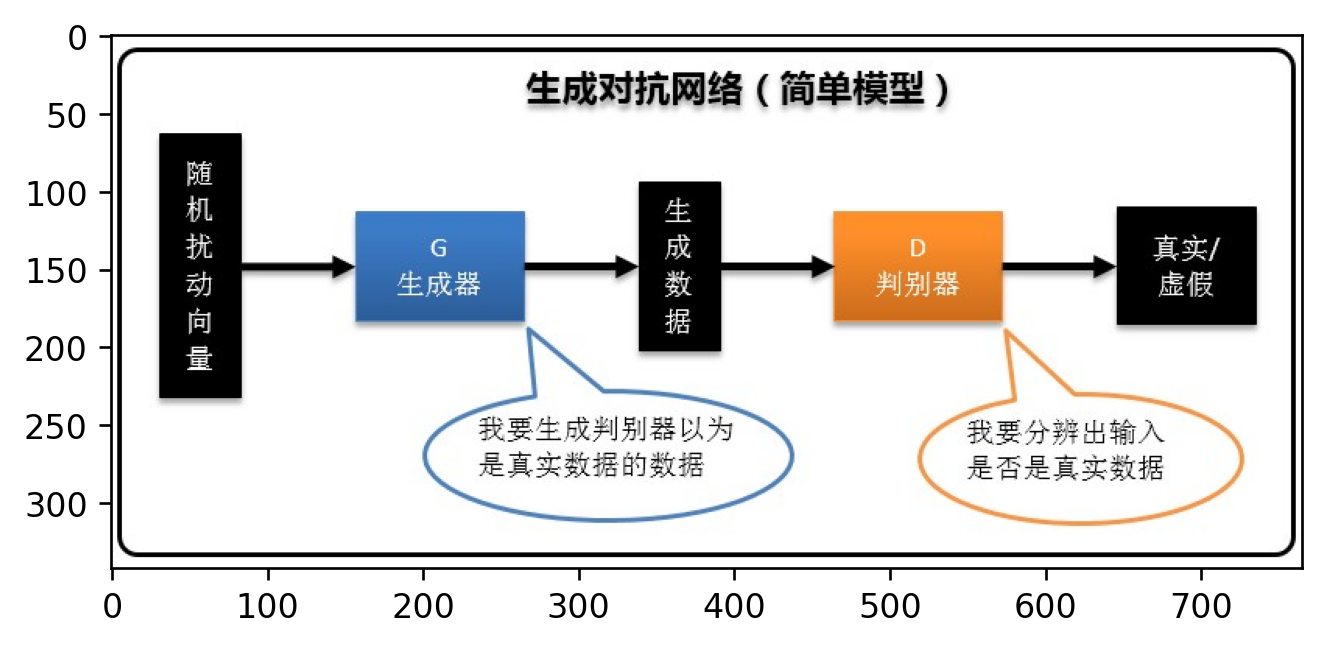

In [1]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('s0.jpg')
plt.figure(dpi=240)
plt.imshow(img)

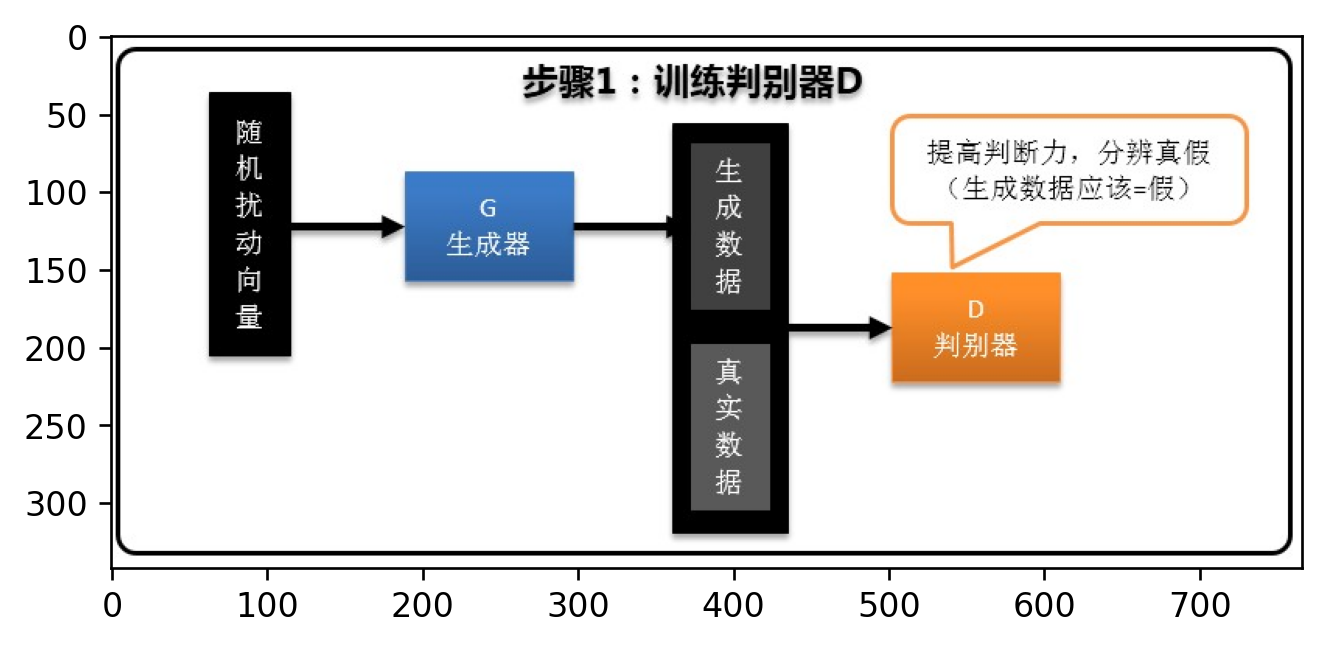

In [2]:
img = mpimg.imread('s1.jpg')
plt.figure(dpi=240)
plt.imshow(img)

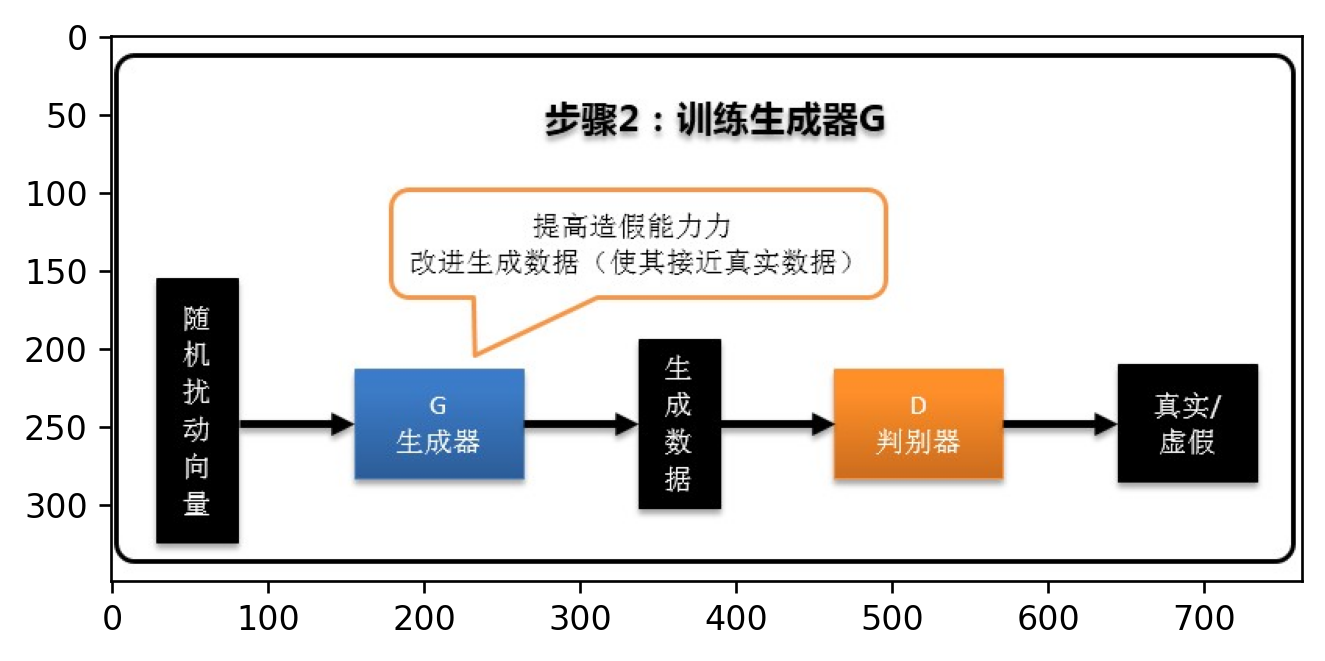

In [3]:
img = mpimg.imread('s2.jpg')
plt.figure(dpi=240)
plt.imshow(img)

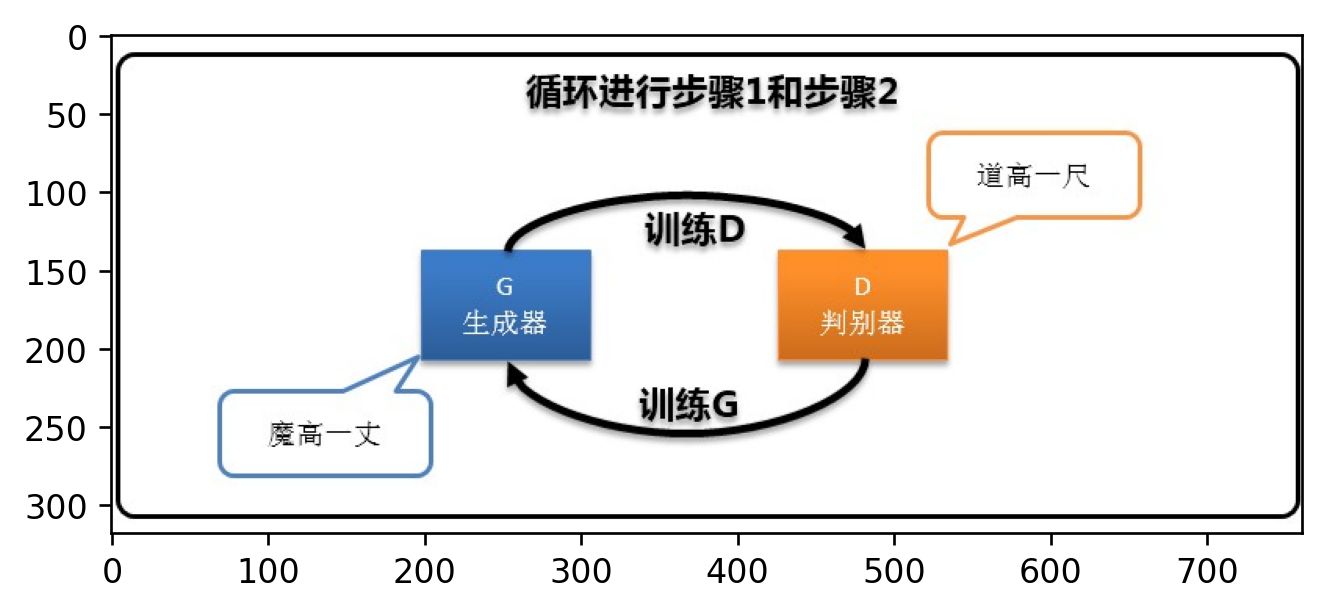

In [4]:
img = mpimg.imread('s3.jpg')
plt.figure(dpi=240)
plt.imshow(img)

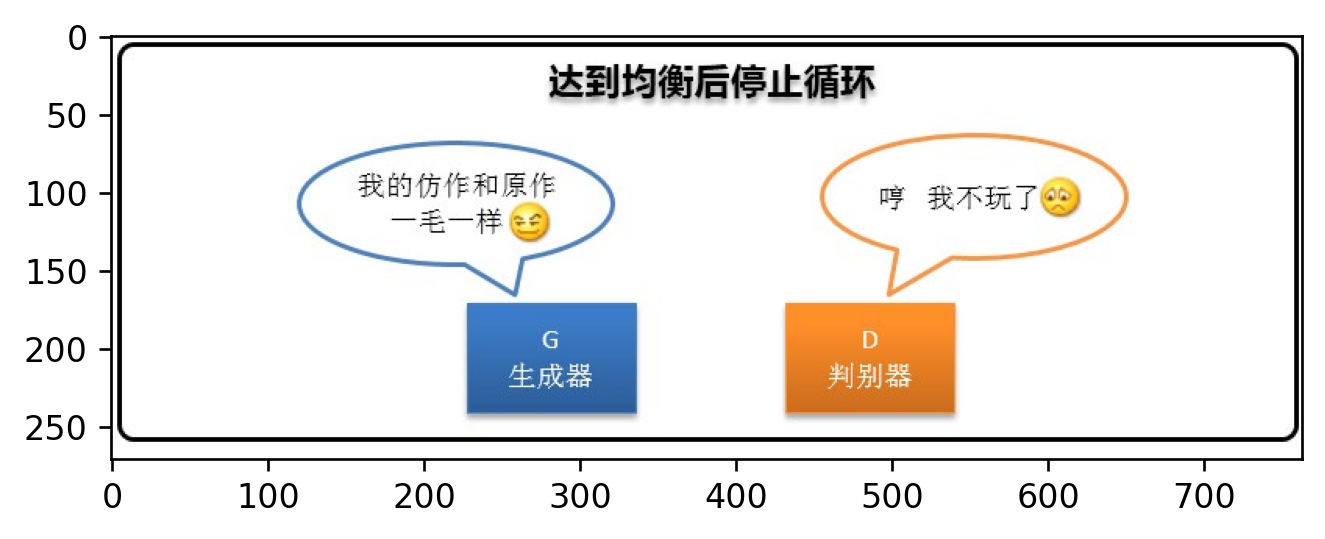

In [5]:
img = mpimg.imread('s4.jpg')
plt.figure(dpi=240)
plt.imshow(img)

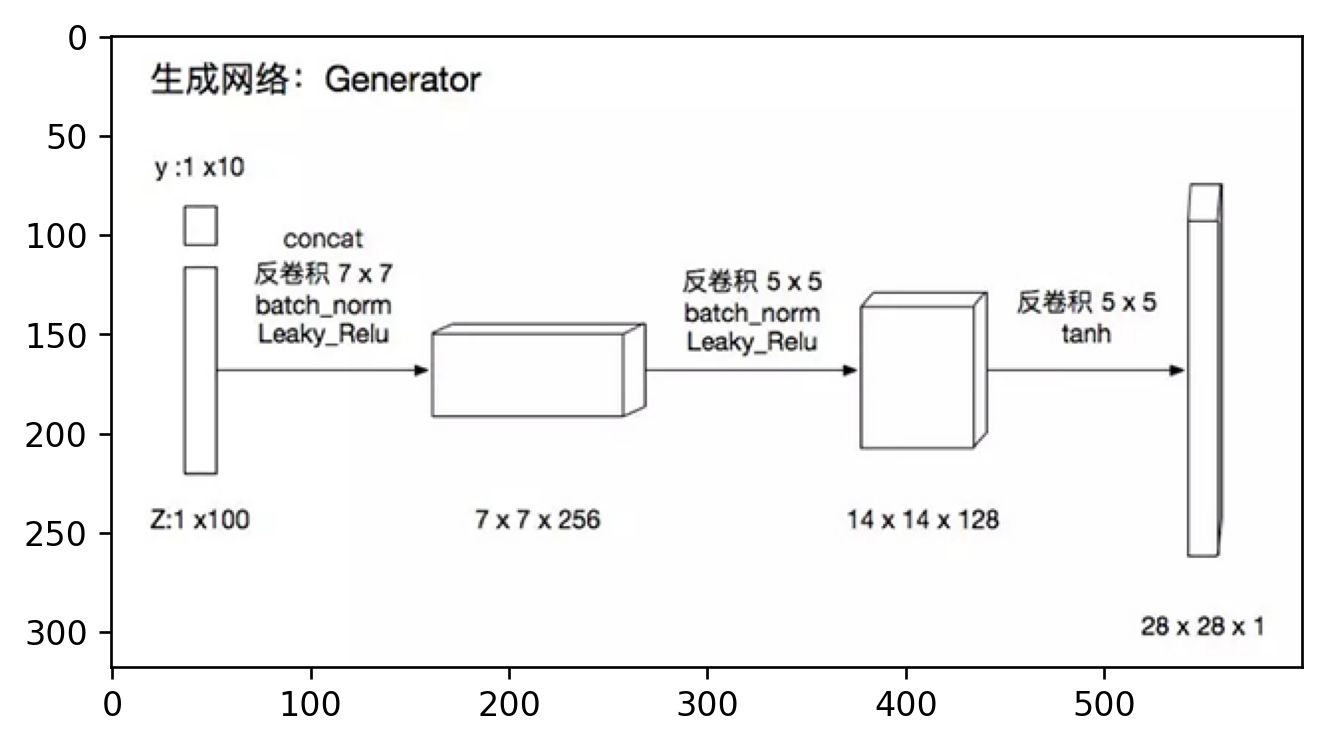

In [6]:
img = mpimg.imread('g.jpg')
plt.figure(dpi=240)
plt.imshow(img)

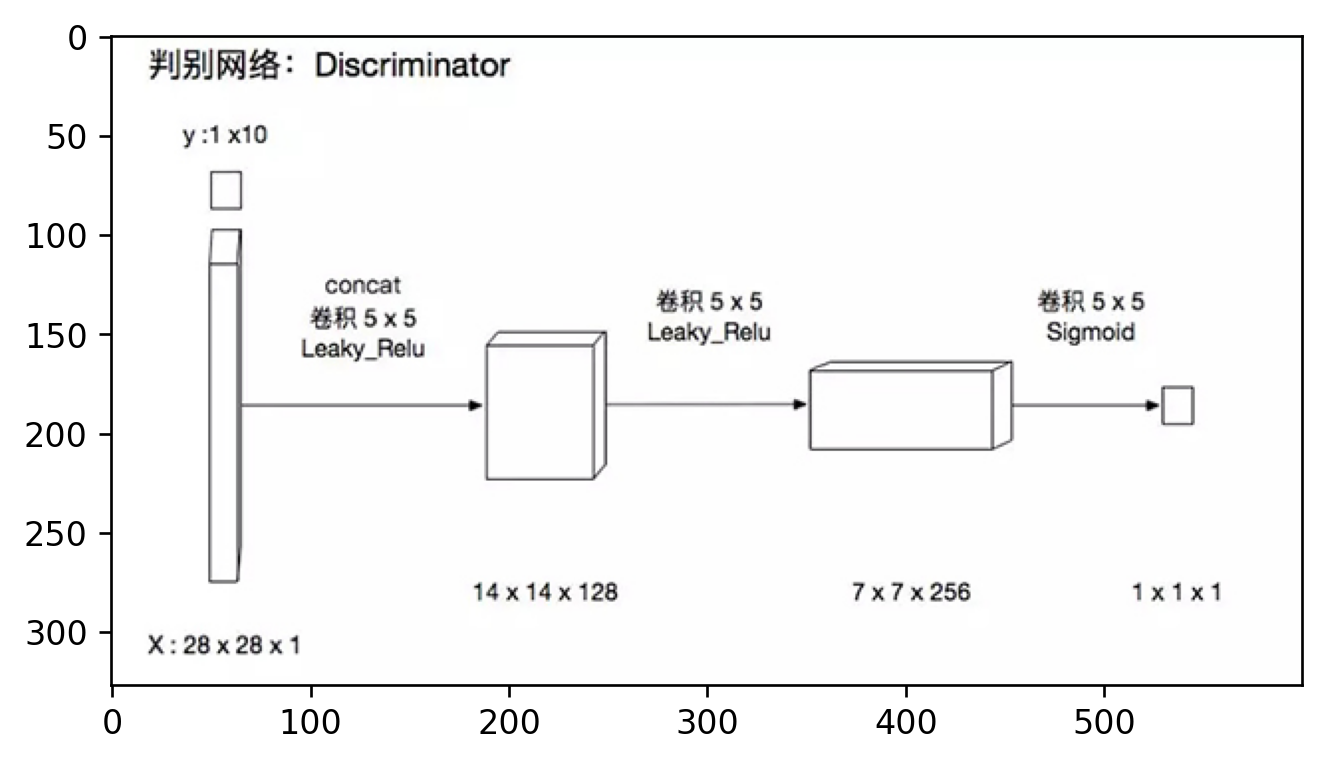

In [7]:
img = mpimg.imread('d.jpg')
plt.figure(dpi=240)
plt.imshow(img)

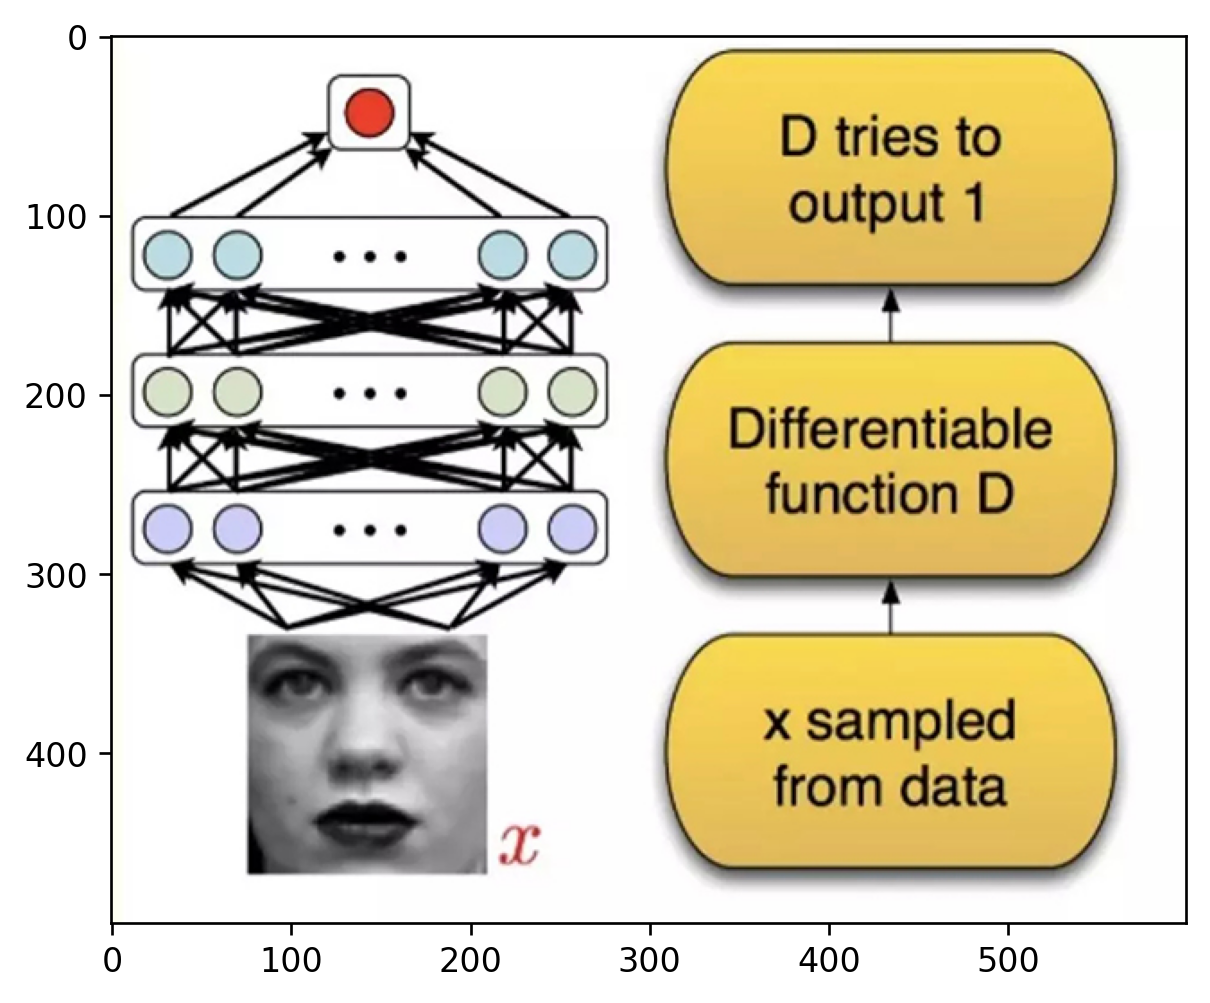

In [8]:
img = mpimg.imread('base.jpg')
plt.figure(dpi=240)
plt.imshow(img)

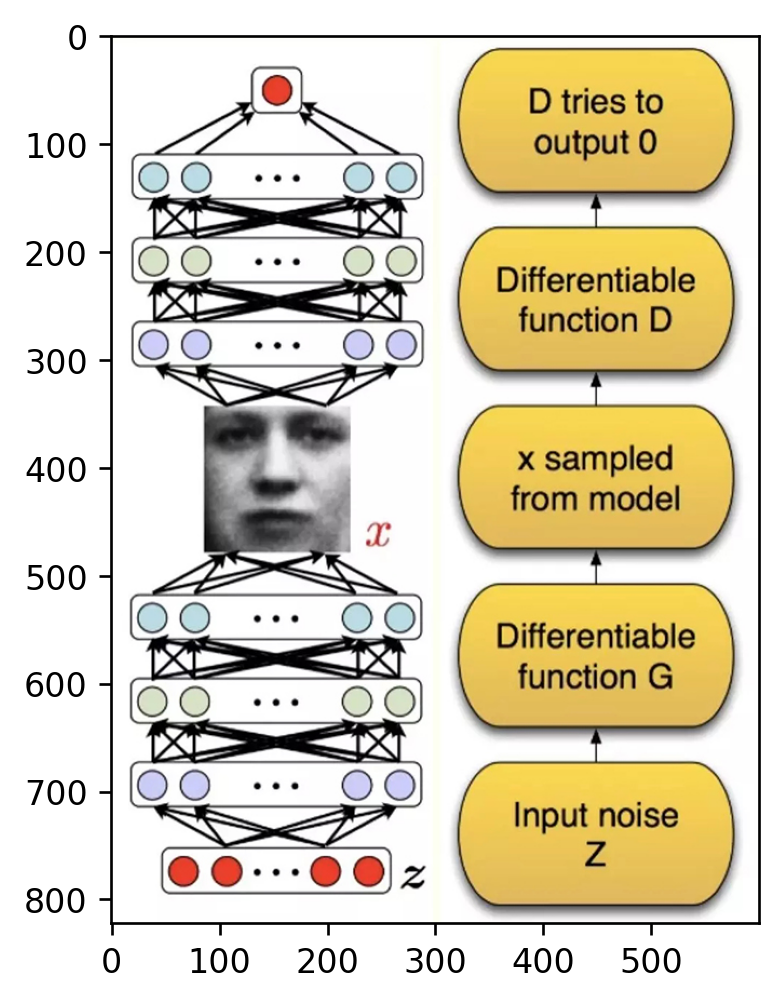

In [9]:
img = mpimg.imread('gan.jpg')
plt.figure(dpi=240)
plt.imshow(img)

In [10]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import os

if not os.path.exists('./img'):
    os.mkdir('./img')


def to_img(x):
    out = 0.5 * (x + 1)
    out = out.clamp(0, 1)
    out = out.view(-1, 1, 28, 28)
    return out


batch_size = 128
num_epoch = 100
z_dimension = 100

# Image processing
#img_transform = transforms.Compose([
#    transforms.ToTensor(),
#    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
#])
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# MNIST dataset
mnist = datasets.MNIST(
    root='./data/', train=True, transform=img_transform, download=True)
# Data loader
dataloader = torch.utils.data.DataLoader(
    dataset=mnist, batch_size=batch_size, shuffle=True)


# Discriminator
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.dis = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2), nn.Linear(256, 1), nn.Sigmoid())

    def forward(self, x):
        x = self.dis(x)
        return x


# Generator
class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(True),
            nn.Linear(256, 256), nn.ReLU(True), nn.Linear(256, 784), nn.Tanh())

    def forward(self, x):
        x = self.gen(x)
        return x


D = discriminator()
G = generator()
if torch.cuda.is_available():
    D = D.cuda()
    G = G.cuda()
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0003)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0003)

# Start training
for epoch in range(num_epoch):
    for i, (img, _) in enumerate(dataloader):
        num_img = img.size(0)
        # =================train discriminator
        img = img.view(num_img, -1)
        real_img = Variable(img)
        if torch.cuda.is_available():
            real_img = real_img.cuda()
        real_label = Variable(torch.ones(num_img))
        if torch.cuda.is_available():
            real_label = real_label.cuda()
        fake_label = Variable(torch.zeros(num_img))
        if torch.cuda.is_available():
            fake_label = fake_label.cuda()
        # compute loss of real_img
        real_out = D(real_img)
        #ValueError: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
        #d_loss_real = criterion(real_out, real_label)
        real_label = real_label.unsqueeze(1)
        d_loss_real = criterion(real_out, real_label)

        real_scores = real_out  # closer to 1 means better

        # compute loss of fake_img
        z = Variable(torch.randn(num_img, z_dimension))
        if torch.cuda.is_available():
            z = z.cuda()
        fake_img = G(z)
        fake_out = D(fake_img)
        #d_loss_fake = criterion(fake_out, fake_label)
        fake_label = fake_label.unsqueeze(1)
        d_loss_fake = criterion(fake_out, fake_label)
        fake_scores = fake_out  # closer to 0 means better

        # bp and optimize
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # ===============train generator
        # compute loss of fake_img
        z = Variable(torch.randn(num_img, z_dimension))
        if torch.cuda.is_available():
            z = z.cuda()
        fake_img = G(z)
        output = D(fake_img)
        g_loss = criterion(output, real_label)

        # bp and optimize
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], d_loss: {:.6f}, g_loss: {:.6f} '
                  'D real: {:.6f}, D fake: {:.6f}'.format(
                      #epoch, num_epoch, d_loss.data[0], g_loss.data[0],
                      epoch, num_epoch, d_loss.item(), g_loss.item(),
                      real_scores.data.mean(), fake_scores.data.mean()))
    if epoch == 0:
        real_images = to_img(real_img.cpu().data)
        save_image(real_images, './img/real_images.png')

    fake_images = to_img(fake_img.cpu().data)
    save_image(fake_images, './img/fake_images-{}.png'.format(epoch + 1))

torch.save(G.state_dict(), './generator.pth')
torch.save(D.state_dict(), './discriminator.pth')

Epoch [0/100], d_loss: 0.149312, g_loss: 3.656353 D real: 0.950289, D fake: 0.085677
Epoch [0/100], d_loss: 0.021321, g_loss: 4.760949 D real: 0.995036, D fake: 0.016157
Epoch [0/100], d_loss: 0.134277, g_loss: 5.181588 D real: 0.964392, D fake: 0.063132
Epoch [0/100], d_loss: 0.007605, g_loss: 6.878247 D real: 0.997011, D fake: 0.004492
Epoch [1/100], d_loss: 0.071117, g_loss: 4.948052 D real: 0.980634, D fake: 0.042031
Epoch [1/100], d_loss: 0.059941, g_loss: 5.231580 D real: 0.984360, D fake: 0.040635
Epoch [1/100], d_loss: 0.149804, g_loss: 4.525189 D real: 0.902043, D fake: 0.017361
Epoch [1/100], d_loss: 0.106171, g_loss: 6.857412 D real: 0.960225, D fake: 0.043666
Epoch [2/100], d_loss: 1.042657, g_loss: 4.285430 D real: 0.713643, D fake: 0.253243
Epoch [2/100], d_loss: 0.333399, g_loss: 5.879494 D real: 0.854597, D fake: 0.037210
Epoch [2/100], d_loss: 0.717001, g_loss: 4.553388 D real: 0.884642, D fake: 0.302181
Epoch [2/100], d_loss: 0.536266, g_loss: 4.242940 D real: 0.94831

In [11]:
#
#import base64
#
#pic_path = 's0.jpg'
#with open(pic_path, "rb") as binary_file:
#    binary_file_data = binary_file.read()
#    base64_encoded_data = base64.b64encode(binary_file_data)
#    base64_message = base64_encoded_data.decode('utf-8')
#
#    encodedMdl_bytes = base64_message
#    print(encodedMdl_bytes)
#
#

import base64

encodedMdl=r'/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAFWAv0DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9U6K81/aK+PPh/wDZs+EmteO/EW6W1sFCW9lEwEt5cOcRQpnux6nnaoZsYU18P+B/2bPjl+3tp0Xj34y/ETVvh/4I1UefpPgvw9mIm2bmN3UnaoI5VpFkdgc/KMCgD9KqK+AP+HKvwSblvFfxAZj1P9oWPJ/8A6P+HKnwQ/6Gn4gf+DGx/wDkOgD7/or4A/4cqfBD/oafiB/4MbH/AOQ6P+HKnwQ/6Gn4gf8Agxsf/kOgD7/or4A/4cqfBD/oafiB/wCDGx/+Q6P+HKnwQ/6Gn4gf+DGx/wDkOgD7/or4A/4cqfBD/oafiB/4MbH/AOQ6P+HKnwQ/6Gn4gf8Agxsf/kOgD7/or4A/4cqfBD/oafiB/wCDGx/+Q6P+HKnwQ/6Gn4gf+DGx/wDkOgD7/or4A/4cqfBD/oafiB/4MbH/AOQ6P+HKnwQ/6Gn4gf8Agxsf/kOgD7/or4A/4cqfBD/oafiB/wCDGx/+Q6P+HKnwQ/6Gn4gf+DGx/wDkOgD7/or4A/4cqfBD/oafiB/4MbH/AOQ6P+HKnwQ/6Gn4gf8Agxsf/kOgD7/or4A/4cqfBD/oafiB/wCDGx/+Q6P+HKnwQ/6Gn4gf+DGx/wDkOgD7/or4A/4cqfBD/oafiB/4MbH/AOQ6P+HKnwQ/6Gn4gf8Agxsf/kOgD7/or4A/4cqfBD/oafiB/wCDGx/+Q6P+HKnwQ/6Gn4gf+DGx/wDkOgD7/or4A/4cqfBD/oafiB/4MbH/AOQ6P+HKnwQ/6Gn4gf8Agxsf/kOgD7/or4A/4cqfBD/oafiB/wCDGx/+Q6P+HKnwQ/6Gn4gf+DGx/wDkOgD7/or4A/4cqfBD/oafiB/4MbH/AOQ6P+HKnwQ/6Gn4gf8Agxsf/kOgD7/or4A/4cqfBD/oafiB/wCDGx/+Q6P+HKnwQ/6Gn4gf+DGx/wDkOgD7/or4A/4cqfBD/oafiB/4MbH/AOQ6P+HKnwQ/6Gn4gf8Agxsf/kOgD7/or4A/4cqfBD/oafiB/wCDGx/+Q6P+HKnwQ/6Gn4gf+DGx/wDkOgD7/or4A/4cqfBD/oafiB/4MbH/AOQ6P+HKnwQ/6Gn4gf8Agxsf/kOgD7/or4A/4cqfBD/oafiB/wCDGx/+Q6P+HKnwQ/6Gn4gf+DGx/wDkOgD7/or4A/4cqfBD/oafiB/4MbH/AOQ6P+HKnwQ/6Gn4gf8Agxsf/kOgD7/or4A/4cqfBD/oafiB/wCDGx/+Q6P+HKnwQ/6Gn4gf+DGx/wDkOgD7/or4A/4cqfBD/oafiB/4MbH/AOQ6P+HKnwQ/6Gn4gf8Agxsf/kOgD7/or4A/4cqfBD/oafiB/wCDGx/+Q6P+HKnwQ/6Gn4gf+DGx/wDkOgD7/or4A/4cqfBD/oafiB/4MbH/AOQ6P+HKnwQ/6Gn4gf8Agxsf/kOgD7/or4A/4cqfBD/oafiB/wCDGx/+Q6P+HKnwQ/6Gn4gf+DGx/wDkOgD7/or4A/4cqfBD/oafiB/4MbH/AOQ6P+HKnwQ/6Gn4gf8Agxsf/kOgD7/or4A/4cqfBD/oafiB/wCDGx/+Q6P+HKnwQ/6Gn4gf+DGx/wDkOgD7/or4A/4cqfBD/oafiB/4MbH/AOQ6P+HKnwQ/6Gn4gf8Agxsf/kOgD7/or4A/4cqfBD/oafiB/wCDGx/+Q6P+HKnwQ/6Gn4gf+DGx/wDkOgD7/or4A/4cqfBD/oafiB/4MbH/AOQ6P+HKnwQ/6Gn4gf8Agxsf/kOgD7/or4A/4cqfBD/oafiB/wCDGx/+Q6P+HKnwQ/6Gn4gf+DGx/wDkOgD7/or4A/4cqfBD/oafiB/4MbH/AOQ6P+HKnwQ/6Gn4gf8Agxsf/kOgD7/or4A/4cqfBD/oafiB/wCDGx/+Q6P+HKnwQ/6Gn4gf+DGx/wDkOgD7/or4A/4cqfBD/oafiB/4MbH/AOQ6P+HKnwQ/6Gn4gf8Agxsf/kOgD7/or4A/4cqfBD/oafiB/wCDGx/+Q6P+HKnwQ/6Gn4gf+DGx/wDkOgD7/or4A/4cqfBD/oafiB/4MbH/AOQ6P+HKnwQ/6Gn4gf8Agxsf/kOgD7/or4A/4cqfBD/oafiB/wCDGx/+Q6P+HKnwQ/6Gn4gf+DGx/wDkOgD7/or4A/4cqfBD/oafiB/4MbH/AOQ6P+HKnwQ/6Gn4gf8Agxsf/kOgD7/or4A/4cqfBD/oafiB/wCDGx/+Q6P+HKnwQ/6Gn4gf+DGx/wDkOgD7/or4A/4cqfBD/oafiB/4MbH/AOQ6P+HKnwQ/6Gn4gf8Agxsf/kOgD7/or4A/4cqfBD/oafiB/wCDGx/+Q6P+HKnwQ/6Gn4gf+DGx/wDkOgD7/or4A/4cqfBD/oafiB/4MbH/AOQ6P+HKnwQ/6Gn4gf8Agxsf/kOgD7/or4A/4cqfBD/oafiB/wCDGx/+Q6P+HKnwQ/6Gn4gf+DGx/wDkOgD7/or4A/4cqfBD/oafiB/4MbH/AOQ6P+HKnwQ/6Gn4gf8Agxsf/kOgD7/or4A/4cqfBD/oafiB/wCDGx/+Q6P+HKnwQ/6Gn4gf+DGx/wDkOgD7/or4A/4cqfBD/oafiB/4MbH/AOQ6ZL/wRn+GWkIbjwt8Q/H2g6wnMN615ayCNh0OI4ImOD6OKAP0Cor86/h98cfi5+w58ZtA+GHx415/HHw48Ryi20Hx7PuMtvJkKFmdiWwCyh1kZigYMrsoIr9FKAPz8/4Kkwjxh8S/2Xvh5fEyaD4m8Y7b6A/dkCzWcAyP9y7lH/AjX6AxxpDGscaqiIAqqowAB0AFfAX/AAUe/wCTp/2L/wDsc2/9LtKr7/oAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKM0V8J/8FV/jndeG/hbpfwm8LyNceNfHt1HaJa27gSpaCQbjn+HzHCRjOAQZOflNAH2X42+InhX4a6VFqfi7xNo/hXTZphbR3mt38VnC8pVmEYeRlBYqjHbnOFJ7Gt6GaO5hSWJ1lidQyOhyrA8gg9xX4O/tQ+Mf2gU/Zq8GeBvif4V0vTPB2janB9i1db77XqFzdLBcBRM/2uUnKPMxwigFVA2jCn668C/tMftuPY6NawfCTwHNpmyGMTvdIJDFgDd/yEhzt56fhQB+ldZ3iHxHpPhHRbvWNd1Sy0XSbRPMuL/ULhIIIVzjc8jkKoyRyT3r48/bn/bH+JHwD8afDPwz8MdC8Pa/qfi1rmHyNdilYmVGgWJUZZ4lXJlbJYkcDkc5+X/2lf2gP2vvGvwQ8XaP45+GHg/RvCV1ZMNRvdMnVp4oVIYso+3ycjb/AHG+lAH6saR468N6/FpUumeINK1GPVoWuNOe0vY5RexLgtJCVY+YoyMsuQMitvOK/Cj4byfHzxE/wQ8V+G/h34YuLzwnam28Nal/aaWd1qduob91OPt0byKu5ztATh3BBVmB+h/2hbfXvGP7V3inw3pX7UnjbwFqU9umpReGraO9hs7aNYELRwuLyNJDtUykIuOW6lWwAfqjnNc+/wAQ/CsfjJPCLeJdHXxW8P2ldCN/F9uaLBPmCDdv24B+bGOK/I/9lf8Aaf8A2ndI+FiXngxrf4oXOr67eW5k+IGrPNPGkNvbtGLbzr2IkNuuCyqXx5eeMc87Y/GT9oK+/b40XxPq3gvw7a/Eo6YlpLpEEoNotgQQ8gP2sjeELn/WdQPlPQgH7Kaj498M6P4o0zw1f+ItJsvEepo0lho9zfRR3d2qglmihLB3ACsSVBxg+lXPEPiXSPCWlTanrmq2WjabAN0t5qFwkEMY9WdyAPxNfj1+0N8YPj9N+3N4L1lPBnh4+J9HfUYPB9l5q+TqFiTOolnP2rhzEWbBaLkfd7U/9rO3+NXxQu9Y8F/EH4+fC0eH01L7fZ6Bqt5a2d1aJljbkkWayKwjfGdxyGPJB5AP2SjlSaNXjZXRgCrKcgg9waXcPUV+b/7FusftFP4j8Lvqvxp8G+PPhPokUmnXlhoUkN3M2y0ZYI/tC2isXR2gdt0oYgZJbOD8N+JPDHgPxn+1F8XJviEviG20u6+INxp66ro13bwQWLXF3ekvP5sUhIJiGNoAAWQk8AEA/oE3D1FAOa/ADSPhv+zdfeOfGOg3epeOdPs9BivpbbVn1ayaHUzagF0iH2QHew3FRzkAeoFeuf8ABOVNB8D/ALX63/h3T9dtNGuvBM9+lprMkU94dzRMcGJEVg23KfKCQRkDNAH7KL4g0t9ck0VdStG1iOBbp9PE6/aEhZmVZDHncELI4DYwSpHY1U1zxx4c8Mappmm6xr+l6TqOqMyWFnfXkcM12y7dwiRmBkI3LkKDjcPUV+LHgn9qjxN8TP2or/4j+EWtpvip4p1uLR9E03U7V5rfRdERcyPJ0UlkVVby2DALcNwXFVP2lfiL4n+Kn7UN94h+KXivX/ge2jxvH4UuLbS5pwkUMjKzRPFMpWRz8+9CwO4DdgJkA/c3OaK/NT/glTrvxU8T694u8T+L/GfizxT4Ouols9EPijUJ5mnKyEmdYpJZFj+UBSQx5YgMdpNfpLd3cdlayXEzrHFGpdnY4CgDJJNAE1GcV8FfsqfFvxf+1v8AtEeK/idLr+sad8L/AA/cPo/hnw5ZXk1va3jgfNdXUalRMdrBgrhgDIBx5fP1T+0XN4vHwZ8VQ+Ar6PTPGUthIumXcqqwjmxx97gEjIDHIBIJBxigDqtF+I3hPxH4j1Tw9pPifRtU1/Sv+QhpVlfxTXVnzj97ErFo+ePmAp+o/EHwvpHivTvC994k0iy8S6lG0tjo1xfRR3l0ihizRQlg7gBHJKg42n0NfjDpnwSvfg745utOtfjD4/8ABmq2lmNa8ea1pi31vb3sGXfdbzQrl2X96N0u4MzErlg8dct4s8d+FvFPirXPGcv7Surw+OrG0tdJ8La1Z2+q28qWcMaxsbyVbcytJIu8sUYZdnc5D7VAP3lBzVIa7pp1k6QNQtf7WEP2k2HnL5/lbgvmbM7tuSBuxjJAr4Z/ZF+I2n+Hv2dviT478NfFnxX8XdW03SWe7fxhfXd1Z2t/bWsk223jnjikSOQyAsAxJCoN2VzXxFZfH/x54n+Jsf7Ttr4m+EnhjxhbabOtx4bTUbm2uNRWFJI9s1r5jNJI6KoQeYA22I8EZoA/cC88R6Tp2rWOl3Wp2dtqd8rvaWU1wiTXCpt3mNCdzBdy5wDjcM9RVy5uobK2luLiVIIIkLySysFVFAyWJPAAHOa/CTxV8cPHXxt8ZaL+0H4p8VfCu51Tw5bvLp3gbU7+dPKMBcqFs95ZpHceYuZfmJTPACj7n8T/ALcnjCX9hbw78SZvAP8AwleteIo7q01W20IzW9vpsAFypumyk7CNREudxAy/3hwKAPtfSviP4T13wdL4t03xRo2oeFYopbiTXbXUIpbFI4t3muZ1YoFTa245wu05xg1Uvfi54F03wnYeKLvxp4etfDOoSLFZ61NqsCWdy7Z2rHMX2OTtbABOdp9K/FDwP8ZvN/Yu07wj4nT4k+DfDWm3F3pWn6x4Ou8WuvTX5upHiubeQRpPDF5TK0azEneR8u7Iq+JPBxb4R6V4dvX/AGkodO0Z1upI9S0LfotukYcl4bM3CiAqGJD+Y235jzngA/eXcMdaNw9RX5IfGbxt4I8RfsC6df6lZfFL4m6VrFzqGoaNrniu7N9c6Jfx7rON7uaOVVSHeW2I28Hc3yk8V8nRaF4Et9N+CIuvhH4wFzdXQbX5jbXIXxLCzRlUsf343kqePLEed688g0Af0HeJfFGjeDNDutZ8QatY6Fo9oA1xqGpXKW9vCCwUF5HIVQSQOT1IqbRta0/xHpNnqmk31tqemXsS3Fte2UyzQzxMMq6OpKspBBBBIINfkL8VPG3jbVvhZ+0sNUsfGOieALrRvD6+G9H8TC5SCxjDQb4YkkZkV1IAcISdw5JNfo1+xTcNP+yh8Js/weGNPUfhboKAPbaK+Ev2zvif4w/ZP+OHgv4vadrutX/w/wBSnXRPFHhi5vpp7GNWGUureBiVik2o2SgXLIo/5aPn7h0nU4NY063vLaRZoJ0WSORDkMpGQR+FAFyiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD48/4Kx+FLDxB+xT4r1G7hWS60K90++s5COY5Gu4rdiD7pcOPxr6B/Z38Q3fi79n/AOGWu38jTX2p+GNMvbiRzkvJJaROxPuSxrxf/gqP/wAmJ/E3/uGf+nS0r1X9k7/k1j4N/wDYmaN/6Qw0AfKv/BR7/k6f9i//ALHNv/S7Sq+/6+AP+Cj3/J0/7F//AGObf+l2lV9/0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAIelfIf7W37Mt78RPGVt8RPC9xa6b8Q9I0mbT9Ivr6NWt43d1KSSAxvnYpnCjaw/fE4yAa+va+S/wBtP4H+O/jJqXh6bwj8W/EXwzg06KaO4t9DE+29LlCrP5dxEMrtIGQ33j07gH5rfto+DPj94Z+GulS/Fbxv4e8S6AdXjjt7TSLZI5EufJmKuSLSH5QgkH3jyw47j6c+Bfw7/auTxV4LutV+JvhO58HxXlnNqGnxWcYnmsQ6GWJW+wAhzHuUHeOT94da4nxt/wAE7viL46sIrLxH8efE3iizjlE6W2r2M9zGkgBUOFkvGAYBmGeuGPrXQaV+w78Y7aOKKD9pzxzZKgCqkKXahAOgGL8cUAM/4Kh+HtG8eftA/BLwrql61hpsyXj6hcpKkRtrUtCXl3uCqgLFIdzDA2kmvn74UfCjwpa/Gb46eF/Amsvrvhi2+H99DbavNdQ3KSTSJbNnzY1VCocuMgfwHnvX294h/Y4v/iB+0T4d8e+INdufENnp3hv+xZLG+RgzyeSYTIGBztcSzuwYlg7ZDEH5eL+KH/BPM2elW/hf4d3cfgTwtqlyreJILVZZ7vUIVBKIJ5JGbaDx5Z+TLljnaFIB8t/seiH4l+Ivh94i+JmpWWhfC74YOtpa3OoSeXbXGoyztLEHduBjMRYk7QIowcBzXtv/AAVy/wCEGudU8HQ6ReG7+KxKpbwaQfMmNi4Pyy7OcMxBjHJO58DBJrG1L/gm/wCLI/E48KaH4qFn8J9S1ODU9Q0a7Dtco8YK4jYKQ2VZgGLJ1XcGKA19mXH7J/hO5+Md/wDEK28OQxeKdQt44ZLxslI9qBC8afdR2UKrMOSB23NkA+DfhX8IdO+P/wCyz4J1b4TXY0b4p/D+8AZpZtjiWSQySb2x9xyTIhwR8rJ/ex6ToVrfyf8ABS3wtHryWZ1f/hD4zfjTt32c3Hkv5hj3fNs3ZxnnGM19PeL/ANk6DT/hV4t8PeCdQl+GOsa5dpfSeJNAiZLoTCYSOWKSRuwYb027wAHOBgYryb9mD9izUPhl8b5/H/iTx7q/xC182zWsd5qVu0bKpAUl2eWVnIVQo+YAAng8YAPm349aF8W/id+2t4P0PXb2y+HmoXTaha+HtS0JTJNDYp5+2ZgJc+Y6A9HUjd0UjFdBf/Bvw98df+CifxK8PeLNNOv6PpPh+1kSNp5ocSpb2KAl4nVt2ZJeCT39OPdZP2Zfijr37aUfxO8UeK9N1Dw5oct5/YFlBb/v4LeVZVihkVYo1wnm8sWdmCAE85Hbfsofso618J/EvxA8XeKtcHijxf4nvXmuNRSExIIQ7MihCTtJ3ZIBwuFUZC5IB4B/wS6+MXhb4XfAddM8RPcRXXinx7Lo+mtBbtKDcvZWm0Pt5VSRjdjAzk4GTXzN4z8SaRba9+1N4Wms/wC1fEXijxtFY6Lp8Z/ePMNQvmMq98L8o9zIqnhjX0h8DP2BPiH8NvixokGp+J9Pvvh54d1ybXbGwhjc3M10Y1jjkkBjAVtqR5w7AbOB8xNenfs+fsMX+hfH/wCJXjrxba6RqL6rrc2paDPbvI89kksty0m8MiqrFZoxwW5U88AkA/OTxprOla/8DvBngLTPDFyPG3hW61W611o42JgiVsyMzYIwQBuOfl8kD+IV9gfsp+I9A8aft16fqvhhEg0K5+H8ItbdCP8AR1VYEMJx3QqUPupr6W+K/wCx3/YOheNtb+G9vpnhv4ha7GFOs3cImjlzKrypKjpIu1wGDYQ5JB7CvMv2Tf2SPiP4e+Lmv/ED4jeKLLUdbudFfRbX+wozEkKEIocbY4gmxYwFVFHJznI5APAfC3hz45+KP2ivGfiu8+G1zp0/iW5OkSanqFyYJNE04uIna2/exs0ixhSJEPJQlR8xrxDRvC+n3HivxTb3Pwh8b/GTUNNvp9Nu9Yj1e5MbSxuy+ZtgtmZGIG7a8j4z3619v2//AATYvdTv4ZvGfxS8ceMpIJVkYzXWyOUhgcFZDKcEAA/N+IrgNJ/YH+KkfjHxnf2/xc1DwHb6rrFxfxWnhv7TIsqSOzK0uJYAHAIGAG6feoAuf8EsLG5b45eLEtj4t8LaZ4ds0t5fCOtao9xGJ53bDsnlQhDGImAVkYnzM5GOf0n/AGhBezfA/wAcxacWF/Nod7Hb7OvmGBwuPfOK+Rv2BP2X/GPwF+J3xB1TxR4hh8Ux66bbyNSd5jdzGMylnnWQHDHzF6O/Q819267Y/b9Llhx95SKAPif/AIJECzuf2WNPaAo08OpXkdxt6q/mlgD77GQ/QivqH9opgnwW8atgHGjXn/oh6+W/2S/hF42/Zf8A2ifGnhjS9DbU/g94nlOp2t5DcwIdFu8HMbRM6uyEAJlFbAWL/bx9Z/GvQ7jxR8MfEek2hRbm/wBPntYmlJCBnjZQWIBOMnnANAH4laP4l8UaF+yn8GbPwrq+t6beat4rvrOSDQtVbTprsNIgWLzh8qklsBnBVSckEV6D8Om+Jvgz9qj4Y+H/ABPd+PNE0/V3uWk07xH43TXI7sLDJg4hRFUA44cHJwRjFe4/D3/gnada+Bng/wAGfEK4e7uNA1W51AJoF0y29wsrg+W7SRB8FRg7dpGThu9R/E//AIJ9HwEuieIPghZWXgnxxpt8J49S1G7ubmLyTFIjptlEy7iXUg7Ox5FAHP8A7FOo6VZ/syftFWWseINI8NQapruo6bDf65epaWqzzWoSMNI3AyT2yeDgGvnR/Bf/AAr/AOC+u6H/AG9+zl4j+zadeH+0Refatel3K7f6PJtGZhnEXHBCCvuv9nH9gaw0/wCAGt+CviQI/GD63rH9t3iwzT28QmCKqbXRkdsYJJOMlunFZXxH/wCCXXw1HgnXk8N+D4LDX5LGdNOup9VvmjhuTGwidgZWyofaT8rcDoelAHwp8I9E/wCEl+BI0r+0PgFpX22K6t/tvi6byfEUG6Rxv34O1hnMZwcKEr6T8Q6Nq8n7CfhH4W+CfFPh3xNcNqTad4k1Tw1fi+is7TFzeN8y4K7liVTvA3Z2/wAWa7D4B/8ABL7wkPh/Y2/xC8NWet+KY3l+1Xtjqd6kMgMjGPADxjhCoPyjkHr1r6T8E/sheFfg38OPFeieC9ETRBrML+ar3dxOry+WyIxMruQBu/h/I0AfkWPA+kW37LXhGW++IS6C3iPV5NRXRNZhuZLB2tGuIJJkNvBK6uVlgXHyggMSWIULzB1TwVql/quk/wBkfDXR4o4cQa7v8TtHKzKOYV8x23KT/wAtYguV/iHX9BNC/ZF+MHh79nrwZ8PtG+I0PhGezuL1dbk0iJpluIZZnkjaGQxxyh1yFIDIDuPPyjOvqH/BOHSNO+H+lW/hjUNS8MeKNLle6tfFdqx+2tO4w7SlSpdWAHygrjHBGWyAec+EPCeheKv+CbunabaaddfFxfDOqPu0zwu97bG6uGvzIVTdAsjBYrrc2YiOGwQQHHin7R3xq8c65ofhPWpfgv4s+GFz4PuUn0rV7wObO3cmMKHjmslU/cUKNwGTyG6V9k+I/wBmv4x+OPhD4V0bVvjprWg+JtMuruW81LQrVoku4nKLDERDJbkhFTdl9x3SPzgCvHvF3/BPX4jeKtKfTtb/AGgPE3iHT5CrPZ6lZ3E8TEHIJR71gcEAjjtQB4P8StQ1z9oXVfDfirxL+z/8SdU1SLSLWze90e6eG11JV3P5+waY+PMMhPyPjG0Dpk/tp8FtEt/Dvwx8M6bZ6cdIs7XTreCDT2JJtUWNQsRzz8oAXnnivzV0f9gj4p6fZ2ttaftJeMNPt7dFihgt7e6VIkUYVVAvgAAAAAOmK/QX9lv4f678LvhFpvhvxJ4z1Lx9qttJNJJrurCQTzK8hZVO+WRsKCFHzHgdulAHhP8AwVqW0i/Y/wDELzlFne9sUg3dS/2mMkD32h/wBr3T9k5r+P8AZ7+HkGqMzajD4f0+O5LdTKLaMPn8c188ftv/AAo8dftL/F3wL4Im0RtO+EWiXI1fVdWlu4S2p3AXCwRRK5kUBWZdzKo/eOf4V3fY3grSRo+h28AUIFUAKBgAelAHQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfKv/BUf/kxP4m/9wz/ANOlpXqv7J3/ACax8G/+xM0b/wBIYa8q/wCCo/8AyYn8Tf8AuGf+nS0r1X9k7/k1j4N/9iZo3/pDDQB8q/8ABR7/AJOn/Yv/AOxzb/0u0qvv+vgD/go9/wAnT/sX/wDY5t/6XaVX3/QAUUVV1TVLPRNNu9R1G7gsNPtInnuLu6kWOKGNVLO7uxAVQASSTgAEmgC1RXlP/DWXwQ/6LJ8P/wDwqLH/AOO0f8NZfBD/AKLJ8P8A/wAKix/+O0AerUV5T/w1l8EP+iyfD/8A8Kix/wDjtH/DWXwQ/wCiyfD/AP8ACosf/jtAHq1FeU/8NZfBD/osnw//APCosf8A47R/w1l8EP8Aosnw/wD/AAqLH/47QB6tRXK+Bfit4J+KCXjeDfGGgeLVsigum0LU4L0QF87A/lM23O1sZxnacdK6qgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKgns4bn/AFiBvqKnooApf2Raf88U/KlGkWoPEKflVyigCuljBG+5Y1B9hSy2MMzBmjUkdyKnooApHR7UyiTyV3DvirK28anIUZqSigCGe1juUKyIGB7GoLbR7S1YmOFVJ9BV2igCmNKthIX8pdx74qaOziiBCoBn0FTUUAUxpVqJC4iXce+KkgsYbdiyRhSe4FWKKAIbm0iu02yIGB7GobXSbazJ8qJVz6CrlFAEJtIiD8i8+1VRoVmHLeSmT1OK0KKAKdtpNtaSF4olVj3Aq2RkY7UtFAFAaLbC688IBJ6irc1uk8ZR1BU9jUlFAFaDToLZcJGoH0pLnTbe7GJI1bHqKtUUAQ29pFaptjQKPQCnTQJOhV1BB7GpKKAK9rYw2ikRoFB9BUksKTIVYAg1JRQBQXRbRSP3K8e1WWs4Wj2FFK+mKmooApHR7Qrgwrj6Uz+wrL/ngn5VoUUAUBodmD/qE/KrcNulum1FCj0FSUUAULjRra5uBM6BnHQmrqKEUADAFOooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPlX/gqP/yYn8Tf+4Z/6dLSvVf2Tv8Ak1j4N/8AYmaN/wCkMNeVf8FR/wDkxP4m/wDcM/8ATpaV6r+yd/yax8G/+xM0b/0hhoA+Vf8Ago9/ydP+xf8A9jm3/pdpVff9fAH/AAUe/wCTp/2L/wDsc2/9LtKr7/oAK8c/bFuWt/2Wfi3t/j8Jasp+hs5RXsdeLftmf8ms/Fj/ALFTVf8A0kloA/nAooooAKKKKACiiigD9Rv+CHly0Wo/GCMdJF0cn8Ptv+NfrFX5L/8ABEH/AJDHxc/3dI/9va/WigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPlX/gqP/wAmJ/E3/uGf+nS0r1X9k7/k1j4N/wDYmaN/6Qw15V/wVH/5MT+Jv/cM/wDTpaV6r+yd/wAmsfBv/sTNG/8ASGGgD5V/4KPf8nT/ALF//Y5t/wCl2lV9/wBfAH/BR7/k6f8AYv8A+xzb/wBLtKr7/oAK8W/bM/5NZ+LH/Yqar/6SS17TXi37Zn/JrPxY/wCxU1X/ANJJaAP5wKKKKAPuG/8AD/wZ0H4ReEj4r8G6XozeK9B0SyufF+ni8mvNMd4rl5bx4VZ4UJeytQoWJJJla9wzlZCOgn+BnwhtPCfgnwb/AGZpen+KLyzvPFcuk694knkv2lhNzHLaXd3aaAxaCFbCUNBHPbMJDOvLiOSun+FvxI0v4UXfwpuLCPxRaeIR4L8Oah4k1i21aODRtP8ADcGqR3d1PJEqCWSbbGbYRBmEgu2RVZ3VHsfCC5+K/hb4W+HfCsvhHxJfaHZeDdZS8u9OtvEuoR6ne3dxqjwx2ZsHfS7sOtxaSC4kVkIlz5pKAIAfmzq09pdarezafavY2Ekzvb2sk3nNDGWJVC+BvIGBuwM4zgVVqxqWm3ejajdafqFrPY39pK8Fxa3MZjlhkUlWR1IBVgQQQeQRVegD9QP+CIP/ACGPi5/u6R/7e1+tFfkv/wAEQf8AkMfFz/d0j/29r9aKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACivFfjX+2X8Hf2dvE9p4e+IPjAaBrN3Zrfw2o028uS0DO6B90MLqMtG4wSD8vSvPv8Ah6R+zF/0Uz/ygan/API1AH1XRXyp/wAPSP2Yv+imf+UDU/8A5Go/4ekfsxf9FM/8oGp//I1AH1XRXyp/w9I/Zi/6KZ/5QNT/APkaj/h6R+zF/wBFM/8AKBqf/wAjUAfVdFfKyf8ABUX9mOR1UfEwAsQAW0LUwPzNtgV9UAhhkcigBaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPlX/gqP/yYn8Tf+4Z/6dLSvVf2Tv8Ak1j4N/8AYmaN/wCkMNeVf8FR/wDkxP4m/wDcM/8ATpaV6r+yd/yax8G/+xM0b/0hhoA+Vf8Ago9/ydP+xf8A9jm3/pdpVff9fAH/AAUe/wCTp/2L/wDsc2/9LtKr7/oAK8W/bM/5NZ+LH/Yqar/6SS17TXi37Zn/ACaz8WP+xU1X/wBJJaAP5wKKKKANfUItf1nSYtbvk1K+0y3Melx6jcCSSGIpHmO3EhyoKovyx54UcDArIr7g8A/BbQ/E37AV1qFl/wAJt4ihufF0V0+n6dpNrbzrdQ6e8c0kCG6ke8t4BO8hKIjuIXVhbrvmi0vj9qdsYP2ptFi8N+E7Kz8PppEemy2PhbTba6gE17biX/SY4FmYtk5LOT3zmgD4NooooA/UD/giD/yGPi5/u6R/7e1+tFfkv/wRB/5DHxc/3dI/9va/WigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACkJwDS0jfdNAH4j/8ABZSZpv2p9C3HO3wnaqPp9svP8a+EK+6/+Cx//J0+if8AYq23/pXeV8KUAFFehfAHwXpPjn4raLaeJJDb+EbJn1TX7giTEenW6ma45T5gWRDGu3kvIgGSQD9B6h4A8Eaj+zl46fSfiN8O9E0jUPHOnyQNFZa9cwadF9kvWW0SWfTWud52qd4GGETBnGQrAHx1RXV/ELwx4c8L31jB4b8ZW/jOGS2DXVzbafcWiQ3AJDogmVWkj4BWQhSQfmRCMVylABX9S+gzNcaXA7HLFRk1/LRX9Snhr/kD2/8AuigDUooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAorlvif8UPDHwZ8Dan4x8Y6oNG8OaYIzdXrQyTeXvkWNPkjVnOXdRwD1r59/4ekfsxf9FM/8oGp//I1AH1XRXyp/w9I/Zi/6KZ/5QNT/APkaj/h6R+zF/wBFM/8AKBqf/wAjUAfVdFfKn/D0j9mL/opn/lA1P/5Go/4ekfsxf9FM/wDKBqf/AMjUAfVdFfKn/D0j9mL/AKKZ/wCUDU//AJGo/wCHpH7MX/RTP/KBqf8A8jUAfVdFfKn/AA9I/Zi/6KZ/5QNT/wDkaj/h6R+zF/0Uz/ygan/8jUAfVdFfKn/D0j9mL/opn/lA1P8A+Rqcn/BUX9mOR1UfEwAsQAW0LUwPzNtgUAfVNFIrBgCOQaWgD5V/4Kj/APJifxN/7hn/AKdLSvVf2Tv+TWPg3/2Jmjf+kMNeVf8ABUf/AJMT+Jv/AHDP/TpaV6r+yd/yax8G/wDsTNG/9IYaAPlX/go9/wAnT/sX/wDY5t/6XaVX3/XwB/wUe/5On/Yv/wCxzb/0u0qvv+gArxb9sz/k1n4sf9ipqv8A6SS17TXi37Zn/JrPxY/7FTVf/SSWgD+cCiiigD7S8H6pP8SP2YtI0/SdRvfCXhfwp4xtIpNYgZ1m07To9PupL29fYSQ8slxMwjDH57iOBS2UzheDvHem/tA61+0NFfa3pfh668b3Gn3Vgmv6na6Yi2kWqxMyefMyxeZFb7fl3F22MQHINfKZ0y8XTV1A2k4sGlMAujG3lGQAMU3YxuAIOM5wRUd1Zz2Mqx3MElvIyJKElQqSjqHRsHsysrA9wQRwaANn4gaFY+F/HniTRtMv4dV03TtSubO1v7edJ47mKOVkSVJE+V1ZQGDLwQcjg1g0UUAfqB/wRB/5DHxc/wB3SP8A29r9aK/Jf/giD/yGPi5/u6R/7e1+tFABRRRQAUUUUAFFFFABXz3+2b4x1fwr8PdNfRdUvNIupNUjVp7GdoXKeVKSu5SDjIU49hX0JXy9+3X/AMiJpP8A2E0/9FS16uVRUsdSUldXR52YtxwlRp2dj5V/4XJ4+/6HfxF/4NZ//i6P+FyePv8Aod/EX/g1n/8Ai64+iv2X6th/+fcfuR+Y+3rfzv72dh/wuTx9/wBDv4i/8Gs//wAXR/wuTx9/0O/iL/waz/8AxdcfRR9Ww/8Az7j9yD29b+d/ezsP+FyePv8Aod/EX/g1n/8Ai6P+FyePv+h38Rf+DWf/AOLrj6KPq2H/AOfcfuQe3rfzv72dh/wuTx9/0O/iL/waz/8AxdH/AAuTx9/0O/iL/wAGs/8A8XXH0UfVsP8A8+4/cg9vW/nf3s7D/hcnj7/od/EX/g1n/wDi6P8Ahcnj7/od/EX/AINZ/wD4uuPoo+rYf/n3H7kHt6387+9nYf8AC5PH3/Q7+Iv/AAaz/wDxdH/C5PH3/Q7+Iv8Awaz/APxdcfRR9Ww//PuP3IPb1v5397Ow/wCFyePv+h38Rf8Ag1n/APi6+8f2XfEt/wCJvg1oV1ql7cajfnzxJdXUrSSPieQDLEknAAHPpX5vV+hP7Hv/ACRbRf8Aen/9HyV8hxPRpU8JBwil73RJdGfS5DVqTxElOTfu9X5o9yooor80PugooooAKKKKACkb7ppaRvumgD8Q/wDgsf8A8nT6J/2Ktt/6V3lfClfdf/BY/wD5On0T/sVbb/0rvK+FKAPQ/hH4W8feLJNRtPBfgnV/HVgslrLrOmaVplzdJcQpIZEguHtsTJC7JkqrpuaNGB3Roy/Wmn/D7xuv7M+vWp/ZG8u9bxdp0q+H/wCyfFH76MWV6GutpvvOOwlUyrBB53zKWKkfBFFAHr3x8+GvxI0KTTvGPjj4Yt8ObTW2e3t4YNGOlwSSQ4B/0Y48ptpX+Fd4Uv8AMxdj5DRRQAV/Up4a/wCQPb/7or+Wuv6lPDX/ACB7f/dFAGpRRRQAUUUUAFFFFABVXUbv7FZyTf3QTVqsvxL/AMge4/3TQB8hN8QPE5Yn/hI9V59L2T/4qk/4T/xP/wBDHq3/AIGy/wDxVYJ60V/Kksbi7v8Aey/8Cf8Amf08sHhrL91H7l/kb3/Cf+J/+hj1b/wNl/8AiqP+E/8AE/8A0Merf+Bsv/xVYNFT9dxf/P2X/gT/AMx/U8N/z6j9y/yN7/hP/E//AEMerf8AgbL/APFUf8J/4n/6GPVv/A2X/wCKrBoo+u4v/n7L/wACf+YfU8N/z6j9y/yN7/hP/E//AEMerf8AgbL/APFUf8J/4n/6GPVv/A2X/wCKrBoo+u4v/n7L/wACf+YfU8N/z6j9y/yN7/hP/E//AEMerf8AgbL/APFUf8J/4n/6GPVv/A2X/wCKrBoo+u4v/n7L/wACf+YfU8N/z6j9y/yN7/hP/E//AEMerf8AgbL/APFUf8J/4n/6GPVv/A2X/wCKrBoo+u4v/n7L/wACf+YfU8N/z6j9y/yN7/hP/E//AEMerf8AgbL/APFV6P8AAbxlrGo+M57fUdVvb+BrRtsdzcPIobenIDE84z+deNV6R8Av+R7P/Xs3/oS19Fw7i8TPNaEZ1JNN7Nvs/M8DP8LQhlleUaaTt2XdH1RRSDpS1/RZ/P4UUUUAFFFFABRRRQB8j/8ABVGZk/Yn8fRg/K507I/7iNsa/A+v3s/4Kp/8mWeO/wDe0/8A9OFtX4J0AFFFFABRRRQAUUUUAFFFFABRRRQB/UvoEzXGlQOxyxUZP4Vo1leGf+QNbf7g/lWrQB8q/wDBUf8A5MT+Jv8A3DP/AE6Wleq/snf8msfBv/sTNG/9IYa8q/4Kj/8AJifxN/7hn/p0tK9V/ZO/5NY+Df8A2Jmjf+kMNAHyr/wUe/5On/Yv/wCxzb/0u0qvv+vgD/go9/ydP+xf/wBjm3/pdpVff9ABXi37Zn/JrPxY/wCxU1X/ANJJa9prxb9sz/k1n4sf9ipqv/pJLQB/OBRRRQB9t/CLw34I+IP7I/iiztvDXjLRvDMHimyuNY1a78UxtZWbxadeO11I0elnES/IvkbWeSSW3RZAxUP1vxM8I2vg/wCG/gPXda+Ifg7Vvh3B4DsfDt5YXWkalqbzXFwt/Pb3NhbSQQKlxsEpimea3ZCHDsquVfgZ9L8ffFv9ku2bxx44j1TTT4p0q5XUbrXYdTTQtJt9OuY5ZZ445XNvt8+BRAwWaWWREVHlkUNWvvEei/tJ+A/E+g6Nquk+GNMtfFnh2PTdN8T+IrLTJbfQ7TTbuyWRWupVV3A2PIsZch5SSG3ZYA+SNWtbex1W9trO9TUrSGZ44b2ONo1uEDELIFcBlDAA4YAjPIBqrW1420S18NeM9e0iwv4dUsdP1C4tIL+3lWWK5jjkZVkR1yrKwAYMvBByOKxaAP1A/wCCIP8AyGPi5/u6R/7e1+tFfkv/AMEQf+Qx8XP93SP/AG9r9aKACiiigAooooAKKK5b4nfErQfhB4F1Xxf4nuZLPQdLRZbu4iiaVo0Lqm7YoLEAsCQATjoDQB1NfLn7dx2+AdKP/UTj/wDRUte+/D34m+FPix4cg1/wd4g0/wAR6RNwt1p86yKrY5VgOVYd1YAjuBXgH7eZ2/D3Sz/1E4//AEVLXrZT/v1H1R52Y/7pU9D4i82jzaqeZR5lftFz8v5S35tHm1U8yjzKLhylvza6b4ceCrv4keM9N8P2ky2zXTEyXMikrBEqlpJCPZVJxkZOBkZrjvMrsvhD8QY/ht4+0/W7m2a9sEWW3u7eMgO8MsbRvtzxuAbI6ZIAJAJrCvKoqU3S+Kzt69DWjGDqRVT4bq/oaWqz/DdJr2zsIfEzCOMrb6tJc27LLIF4Y2vlKVRmyMecSoIPzEbTw3m17X4W8Y6L4A0fxhZ2nxFk1fw3qGiXtnp+g+XepKJ54wqGSJoxArKSdzK56EjOcV4T5lYYabbkrOytq76/elbz6djavBKzur+VtPub/wAy35tHm1U8yjzK7rnJylvzaPNqp5lHmUXDlLfm1+iH7HZz8FNE+s//AKPkr85PMr9Gf2OTn4JaH/23/wDR8lfHcUO+Eh/iX5M+lyBWxMv8P6o90ooor8yPvAooooAKKKKACkb7przH4xftJfD/AOAeq+GLLx5ri+Ho/EUs0Nle3EbG3V4whYSuAfLB8wYZsLwckV6HpWr2Ov6Xb6jpl7b6jp9zGJILu0lWWKVD0ZXUkMD6g0Afid/wWP8A+Tp9E/7FW2/9K7yvhSvuv/gsf/ydPon/AGKtt/6V3lfClAHq37Lfwq0v42fHLw/4O1ldTk0+/hvpXi0aRI7uVobKedI42aOQAs8Sr9xuCcDOK+m/hl4ct/hR4A+K2n3Pwk+Lnw6Go+Gxq6HWfFUVjc3g07UbGV/sztpEbI0az7y+1xgFcAtvT5m/Z/1GPwXP4w8dXLvDDo2gX1haMqg+bqGoW01nbxDPBIWWefB/gtZDhsbT9I+HPGXw8+GHhL4V+IG17UvEvw18P6VrGm3NjqOliwvPE82os4ubCK1E7YjhjkTzLkyNErouwvJtUgHj/wC202n3/wAQPD+ujwifCXiDxLolr4g1KNddh1AXH2mNWiklijs7b7NcsAzyqQd5kVwBuLP87V9C/tb6Xouv66/xN034jaV4/l8Z6veXEcdnItvd6daRrEsMV1ZMPMgYEyRqOU2W6lSwdSPnqgAr+pTw1/yB7f8A3RX8tdf1KeGv+QPb/wC6KANSiiigAooooAKKKKACsvxL/wAge4/3TXnU/wC1R8MbD4x6h8LtT8U2ujeM7QQstlqZ8hLkSxq6CGRvkdsMBszuznAI5r0XxKf+JPcf7poA+HXlw5Hoab51U55sTSD0Y/zpnn1/Jso6s/qdS0L/AJ1HnVQ8+jz6nlHzF/zqPOqh59Hn0cocx6IdI8PaR4V8N6nqUGp3UmqGfzTaXccQiWOXZ8qtE24455Ycj34yfGnh1PC2qQRQXYvrK7to7y1uNmwvE4yMr2OQRj2rQmu9F8Q+CvCWnzeIbTS7jTzci6S4guHZRJNuBXZGyt8ozjcO34Y3jvxXaeItRsBp8U0Vhp9jDYQG5wJJFQH52AJAJJPAJr6DF06Coacu1Pls1e/Kue9vO9+bVPRdUeDhald19ebefNdO1uZ8lr+W3Lo1q+hk+dR51UPPo8+vn+U97mL/AJ1HnVQ8+jz6OUOYv+dXpn7Pr7/Hbe1s3/oS15J59eqfs5yb/HUntbH/ANCWvo+HI2zbD+v6M+e4glfK6/p+qPrIdKWkHSlr+kT+eAooooAKKKKACisjxd4nsvBPhXWPEOpeZ/Z+lWc19ceUu5/LiQu20ZGThTgVyfwb/aC+Hv7QGg/2t4D8UWOvwKoM0ET7Lm2J7Swth4z/ALwGe2aAPBv+Cqf/ACZZ47/3tP8A/ThbV+CdfvZ/wVT/AOTLPHf+9p//AKcLavwToAK0PD+p22ja1aXt5pFnr1tA+6TTdQeZILgY+65hkjkA/wBx1PHWs+tjwloVl4j1uKx1DxFpnha1dWZtT1aO6kt4yBkAi2hmkyegwhGTyQOaAP0P+GXwZbSvhrf6pp/wf8EXS/EDwpZiy+weH/G+qWscM00FzLHePE1yiFTbkI1u/mrIsLHYpbHyl+1doukfDbxbP8PIPBXhLRdX0v7HeXGreGxrMTlp7RJZbaSPUbmRsK0iYJRGGzJCl2QfV/i3xV8NPBfhD4c6N4q1vweuraX4atNMkXWNOgN23lA4kMF14Vv7qGJ1dXj894i6MHWIKwZvCP23/AfhxvEI+JMHimK7h8X2lrL4ds9E08XOnzQ2sNvaTrJeoIYY5VZGYQRQkqu0SJbsyx0AU/h38JfhnZajY654Y+MHiWw8XeH/AA+niktZ+FIXhu5bcl7pbCS7vLUzeQqSlkeMbxbTbTIcJWl8cPhR8CfAfxu8Tw+L/HHiOO4eAavN4f8ABngqDT7WGa7iWWK0t2m1CURCPz0dkKlAkbxq4bbib4Qy+EPiN8Nb3wtd+EvH2i/B+11KHVda8R6v40tG07R54o3VmgY6OQJpEnI+zw5mnIhUZC10PxZtvhx8X9T8Y/Gbwr4Jm+JNrGRe61pf/CYvby6LZZhiR59P+wQTh1iYLvt7i6gikRmdpI1CuAeFfspfDjw7438ca7rPjW0N94G8HaDe+ItYtBK8P2xYk2Q2yyIyFXlnkiUYYE84NeMTyLNPI6xJCrMWEUZJVAT0GSTge5J96+kdVQ/Bz9iDS7JVK638XtYa+uSynMek6ZIUgQgngyXMjuCBysQyeBXzXQAUUUUAf1J+Gf8AkDW3+4P5Vq1leGf+QNbf7g/lWrQB8q/8FR/+TE/ib/3DP/TpaV6r+yd/yax8G/8AsTNG/wDSGGvKv+Co/wDyYn8Tf+4Z/wCnS0r1X9k7/k1j4N/9iZo3/pDDQB8q/wDBR7/k6f8AYv8A+xzb/wBLtKr7/r4A/wCCj3/J0/7F/wD2Obf+l2lV9/0AFeLftmf8ms/Fj/sVNV/9JJa9prxb9sz/AJNZ+LH/AGKmq/8ApJLQB/OBRRRQAU9oJFgSYxuIXZkWQqdrMACQD6gMuR7j1r6++HvgnwvpvwwPjW1l+Aslpoj2unXWua/b+Lp5XvJ43KobWWJra4mKpIzLFC6JjdhRtat/wz8N/hL4x+Gnw2+GifEfxNPp/iL4oXVrb3GleGYlt7md7fTISUMt+WjhVbiMpLIhmHmuGgUqykA+H6KlvFgS7nW1kkmtQ7CKSaMRu6Z+UsoZgpIxkBjj1PWoqAPcP2Y/jv8AGL4IT+IZfhLHdPJqItxqJttIW/x5fm+VnKNs+/J6Z/CvfP8Ah4D+2b/zx1P/AMI+P/4xXcf8Ea/C1t4o1H4rRXAyI10oj8ftn+FfqB/wpzSv7lAH5D/8PAf2zf8Anjqf/hHx/wDxij/h4D+2b/zx1P8A8I+P/wCMV+vH/Cm9K/uUf8Kb0r+5QB+Q/wDw8B/bN/546n/4R8f/AMYo/wCHgP7Zv/PHU/8Awj4//jFfrx/wpvSv7lH/AApvSv7lAH5D/wDDwH9s3/njqf8A4R8f/wAYri/jF+2P+1B8SPhzrfh7xxHfr4WvoRHfGXw0lquwMpGZBENvIHORX7Wf8Kb0r+5Xmv7Q37L9p8UPhTrvhW1u201tUiWI3axeYYwHViQuRk4Ujr3oA/Bb4V/Frxv8HfFEOs+A/EWpeHtYJVN+nyECfnhJI+VlXP8AA4Ye1fpdqXxv+Mfxi+AenXXxY8FWnh2SK/hNrqkchgmvv3cgy9mQTEccliygnogFe7fs8/8ABPrwP8HjDc2OlC51RB82rajia5PrtOAEHsgHvmtD9tvw3beHPhdpiQLj/iZRAn/tnJXq5V/vtL1PPzD/AHWp6HxZ5nvR5nvVPzaPNr9g5j80sXPM96dGGmkWONWd3IVVUZJJ6ACqPm17HoSeEtF8LeGND1i4ubHX727j1ie4s9Gt7yVY3IFvAZnnjaJSiiUgBsidc/dxWFWv7JJ2vc1p0vaN62PK545LWeSGZHhmjYo8ci7WVgcEEHoQe1M8z3r1b4wN4Hl+Jnjme/1rxNf6q+pXqLENOgiihmErBcym4dpI1IC42ISMHK42nL+EPw5s/HPh/wAXajPpGu+ILzR47VrfS9AlWOafzZSjE5gmOFA3cL2NZLFx9kqsk1t+Nu9u5q8M/aezi+/4elzz3zPejzPevqLw3ep4D8G+HbSPwj4q06/g8VLbx6DqmtRI0rXdsgVZlayAaGRUdNhQdZPmySB5ZY6ZaaD+0BaR2Fpa6db+HtTgnu4rnX7NkkMEyea0U8n2eNi2MiPCkEkYABC408dzuXu2sm91rb+kaTwnJy+9e/k/67nmHme9Hme9fYMPhyWWw8OXdpquitb/AGrWGt7GO20K2a6S4sxbh4YIbo29yIWU+Z5jqWB2kEKBXjf7SVsp1DQ3sdW0fXdL0yxTTP7Q0l9PiWaXzJpdy21rK5iTDYG4LyG455ihmMa1RU0lrfr6+S/r0ZdXBOlBzd/u9PP+vmeReZ70eZ71T82jza9XmPOsW2l2qT6Vx4/aX/ay8C3t3pPw5bxGnhGCVhYfYvCUF5EVJy22VrVy3zFudx9O1dKZMjHrX35+yn8ObDX/AINaFczrl2E3/o56+R4lu8LB/wB79GfSZFpXl6fqj84/+Gyf27P+e3i7/wAIS1/+QqP+Gyf27P8Ant4u/wDCEtf/AJCr9fv+FN6V/co/4U3pX9yvzg+3PyB/4bJ/bs/57eLv/CEtf/kKj/hsn9uz/nt4u/8ACEtf/kKv1+/4U3pX9yj/AIU3pX9ygD8gf+Gyf27P+e3i7/whLX/5Co/4bJ/bs/57eLv/AAhLX/5Cr9fv+FN6V/co/wCFN6V/coA/BH9pf4zfHr4sWuhJ8Z31hoLOSZtN/tTQYtNG5gnmbSkEe/hUznOOOmaP2WP2gfjZ8J/Flvp/wm1HU72S4k3SeHVia7s7jnkvCeF95BtIH8Qr9ZP2p/2GNH+PepeFVvr67tdN0eWeSS1swA1yZAgAMhztA2c4BJzwRivR/gt+yd4U+E+jpZaJotrpNuAC6wJ88hHd3OWc+7EmgD8jP+Cj3inxl4x+L/hDVPHugaf4a8TTeE7b7Tp+m3puok/0u753YwpPPyhnA4+c9vlGvuP/AIK/2MenftO6FBEMIvhW24/7e7yvhygArSPhrVxrL6QdKvhq0e7fYfZ389dqlmzHjcMKCx44AzXrv7Jdlph8fX+pa3qM+l6HY2Eo1O7uPD6atpMdpIpjka/Rru22xgshjCGSR5hEkSPKY1b778faz8PdH8Qan4i0b4i6pHqOgWl1ePNpFnaTz2uqx+H1t4WktpZUkaVbNZZotswhVrOZDiTcKAPyVor2L9of4a+E/hlJ4ZtdF1rXvEGr6vpFp4huNR1a3htllhvYvOiQwJJK0MqIULEyyiTzsjy/LHmeO0AFfcFr+2B+3NaQLFDJ4tWNRgAeBbY/+2VfD9f0raL8JNMutOhkZOWUGgD8j/8Ahsn9uz/nt4u/8IS1/wDkKj/hsn9uz/nt4u/8IS1/+Qq/X7/hTelf3KP+FN6V/coA/IH/AIbJ/bs/57eLv/CEtf8A5Co/4bJ/bs/57eLv/CEtf/kKv1+/4U3pX9yj/hTelf3KAPyB/wCGyf27P+e3i7/whLX/AOQqQ/tkft1kczeLv/CEtf8A5Cr9f/8AhTelf3KR/g5pW04SgD+dn44+NfH/AMQPiRqGt/E43reMZ0iW6OoWC2M21UCx5iVEC/IFx8oz15r6h/Ym/ag/aUs7qHwz4TguPiB4RixFNZa+5+zWSeiXbHMOB0TLD0Q19qePv+Ccnhb4i/HbVPG/iA3OrxXIgWHST+6toxHGqZcqd0hJXOMgc4INfSfh74IaL4E8LLa2Njb2Ntbx7Yra1iWOOMegVQAKAPkqG8muIxJcRpDcNzJHFIXVG7gMQpIB74GfQU/zqrXbrFdzqOAJGH61D5w9a/liUbt2P6eTaWpf86jzqoecPWuk8DQW99qN5FdwWlzbPaSoy3N9DaMrlf3bI8rqAwkCZxn5d3BBIq6VB1ZqC6/10M6tX2UHN9P66mbKzwSvHIrRyISrI4wVI6gj1odnjVGZWVXG5CRgMMkZHqMgj8DXt/irQrDU/iHa2F4NJvxe6lbG7U3am7CCJYxGmx9yoByeQTvGFxGWryfxfdlvD/gyNWcQjS5XSNmyFJvroE+mcAZOOwr1MVlbwrneV7Xtp2cV+Uvv08zzMLmSxShaNr2v803+cf62MXzqPOr2nxb4t0q1tfEGqW+pLdw+JLS9+wJBoNtbuwNyUbdMjecQArNl1G4cn5gVHN+K7C18P6J43stOja1sxcaQfKEjN96CR2GSckbiTg+3pWlbKVSvy1LpJ9v5ZSWzas1HvdXWjM6OaOrbmhZtrv3jF7pO6cu1nZ6o8686jzq9x+F7fZ9J0K0a7sIrix+1TSvHLpdztikXPmeY1x5sIjGWbaucA56U+9gSx8DvajV9Ga8fSf7KhiE2mjzwJDm4S6aYSGI7GXaQCD/DkHHRDI5SpKrzPa/w+Sdvi7u217rRO5hLOlGq6fKt7fF5tX+Hsr72s99DwvzqPOqk7mN2RwVZTgqwwQfSm+cPWvmuQ+j5i/51eT/Hj4qfF74a2ukXnwe/tP8AtqWZ0uzpmjx6i4h25G5HikCjdjnA+tek+cPWvSfgF4dt/EnjK5inGVFtn/x4V9Hw6lHNaDa6/oz57iC8ssrJdv1R8MD9sn9uz/nt4u/8IS1/+QqP+Gyf27P+e3i7/wAIS1/+Qq/X4fBzSsfco/4U3pX9yv6GPwE/IH/hsn9uz/nt4u/8IS1/+QqP+Gyf27P+e3i7/wAIS1/+Qq/X7/hTelf3KP8AhTelf3KAPyB/4bJ/bs/57eLv/CEtf/kKj/hsn9uz/nt4u/8ACEtf/kKv1+/4U3pX9yj/AIU3pX9ygD8Z/Gf7WP7aWv8AhPWNO8RS+KToN1ZzQX4m8F28KfZ2QiTc4tFKjaTlgRjrkV8l+EfGGveBPEFrrXhrV77QtZtmzBe6dO8MyH2ZSDz3Hev6JPib+z/Y+KPAWv6LbyG1l1KxnsxcBN/leZGybtuRnGc4yM4614H+z3/wTj8EfCSeC8TTjq+sRkH+1tUAklVvWNcbY/baM+pNAHyh8Rfjz+0D8WP2FfHUPxU8M2h0JI9PNr4ku/8AQr+4Iv7bANsq4kB4+fEQxzlzX53V+5v/AAUs8IWnhr9ibx0IFAYHTxn/ALiFtX4ZUAFWtJ1a+0DVbPU9MvLjTtSspkubW8tJWimglRgySI6kFWVgCGBBBAIqrRQBY1LUrvWdRutQ1C6nvr+7lee4urmQySzSMSzO7EksxJJJPJJqxqb6rpyNoWoG8tl0+6mLaZdF0FtcNsSbMbfcc+VGrcA/u1B+6Me9/Bz4MeDfFfwVi8T63pd1qeryeILvTQP+E90rwvAsEdtayL82oQSLK+6ZuEIOOoIHH3t+0T8J5da8b69c6z8Mdb8WafqSxbW0LSNNvdQu7Iose6K+Xw3JHGURTt8zU0mCRghlYxggH5T+MfiT42+Kk9o3irxTr/i+axicWx1jUJ71rePG59nmMxVcLk4wPlyelc3a3k9jK0ltPJbyMjxF4nKko6lHXI7MrMpHcEg8Gvpv9lTw3a3PjH4m/E/w+Lrwtp/g7w5rGo+H4bi5W8uI9Qayn+zJ5nloJDEokl8zaoVo48glgrfVXxcl8WXF3ruj2Pg3x9rI199EvZdU0v4Madq1oYbexJcmZ5AdV3Syxc3AAjKsVOQAQD8x9b8Tax4lGnjV9VvtVGn2kdhZi9uXm+zWyZ2Qx7idka7mwgwBk4HNZtfQX7a2u3+s/EfwxDqGgeI/DsmmeF7HTUtvE3heLw5NKIjKDLFYws0cULNv2hDgEMB0r59oAKKKKAP6k/DP/IGtv9wfyrVrK8M/8ga2/wBwfyrVoA+Vf+Co/wDyYn8Tf+4Z/wCnS0r1X9k7/k1j4N/9iZo3/pDDXlX/AAVH/wCTE/ib/wBwz/06Wleq/snf8msfBv8A7EzRv/SGGgD5V/4KPf8AJ0/7F/8A2Obf+l2lV9/18Af8FHv+Tp/2L/8Asc2/9LtKr7/oAK8W/bM/5NZ+LH/Yqar/AOkkte014t+2Z/yaz8WP+xU1X/0kloA/nAooooA+s/hf8R/h5qd78LfDPhX4a+M/F+o6Dp8r6hbXGr6dbafc3dyhGqTTwtZSZtjEFjM0lxCUghjy0Rj82us8GHwvqXxw8DzeFr/Q9M+D3wj1afVZtS1HxDZxXU832gXMk8cTyJPNH5gtbWJ0R94ijJ+Zyg+KNN0271nUbXT9PtZ76/u5Ugt7W2jMks0jEKqIoBLMSQABySar0AFFFFAH6gf8EQf+Qx8XP93SP/b2v1or8l/+CIP/ACGPi5/u6R/7e1+tFABRRRQAUUUUAFNZA4wQD9adRQAioEHAAr5T/wCCgR2/DPTj/wBROL/0XJX1bXyf/wAFBzt+F+nn/qJxf+gSV6mV/wC+0vU8/MP91qeh8B+afWjzT61V80UeaK/WeY/O7FrzT617L4P0/wAYaFfRSNfeBLqOe8F3cXOq6p4fvbgliu9vMnkeQdM4B6knGSc+IeaKPNFYVY+0VtPmr/qjWnJQd9fk7fofSvxAXxb4w8ZeKbGy8S+A9O8MarqNy3nx6totulzD5rtE8/lN5shAIILhmVju4OTXA+GZbTw78PNV07XL59NtvEmp29v59pbi7kW2tfNaWVF3ojqZmhUMHIO2XGSvPlHmijzRWEKHLDkurabK23Xrrt9xtKtzS57O+u7vv/TPq+0+Jfh7wP461u8u9We3tNbt7GLRrlrHzrnTvJszBbatJGGwg2uzLCcyMkpcqoEYl8wsfDvhf4f/ABI0LS9Wn0bxnbXAtxcXdtqudNiZ7jDszRlWIWLnDMmGO5gVyh8f80UeaKiGFVO9pPVJP5Ky89Cp4hzteK0d189WfXGr6t4C8Q+JYtZu9R8F/arEamtrcWGo6pbW9qLeOA2CeVvWRRuaUgWq7TtATkEV5z+0T430XxJH4Zh0yw8JTXj2IvL7WvDkVwkktw0syukhlYOxKrG5MyGTcSd2HOfDfNFHmilSwkaUoy5m+Xa46mJdSLjypXLXmn1o80+tVfNFHmivS5jhsWvNPrX6afsYnPwK8Pf7s3/o56/MHzRX6e/sXHPwI8O/7kv/AKOevluInfCx/wAS/Jnv5IrYiX+F/mj3miiivzs+1CiiigAooooAa0asckAmlIwppaRvumgD8Q/+Cx//ACdPon/Yq23/AKV3lfClfdf/AAWP/wCTp9E/7FW2/wDSu8r4UoA91/ZL1HxDp3jdZYPDum+IvAkV5Z3HiePX7LTn0uGJWcRtPc38TwWrNuljRt0buXMcbBnFfUHxJ8aaP4uuvBPxdn8T2Wr+HPD/AIgum8TeMb3wFBoN74uUkqsFjsGbyN4BJa+S8quhLST7I8PH+dsEEl1PHDDG8s0jBEjjUszMTgAAdST2plAHvX7Xmn2fiL4h3HxC0DxH4d13wj4hWD+yrfTb+Jb7TreOEQw2l3YmQzwyRRQIjOVMbEAq53ADwWiigAr+pTw1/wAge3/3RX8tdf1KeGv+QPb/AO6KANSiiigAooooAKKKKAGiNQ2QBn1rN8S/8ge4/wB01qVl+Jf+QPcf7poA/OrUpsajdD0lf+Zqt51R6tLjVbwekz/+hGqvnV/MPKf0vzF7zq63wHc3Fi099OltDoKMv2y8utOt7rkAkRQ+cjDzXyQFX/ebCIzLwnnUedW1GXsZqa6edv6Xfy6mVWHtYOD6+V/6fb8j1my+N+tXPjMX7WunG2uL9LhrQWtrAWw+Y1a58sMNoON7HpnPBNVNcs9Y03UfBemaXcBdetdLILabeoxhL3NzKD5sblVHlSK5bdgK2SQM15j51HnV2PGVaiarScnfe+12m7abtpW6LtqcawdKm06UVFdrb6NK+vZvzemp79bfEHUriHVbn/hKrp9I0nRrjTkln1ciS+vXRwJRCX3sC0rbGK8LGvIK4GD4m1WbVPBHiDXLpLW1j1i805LSCG+iuHPkwyKwYIdykKUJ3Kv3hxzXj/nUedXRPMalSPLNN6Pr1aa7bJOyV/NtmEMup05c0WlqunRNPvu2rt28kke9eCdZ8JX3hu00+5ttA0izvLyZLuC+vbr7ZcRRxxGMtLGyqAZN52ybIyVUquQTVvSfEnhnQfCFxZKfC+pRDQ4rwaffvdTzfbmjQSY3N5KMSz5ERV+B/d4+evOo86tIZpKCSVON0rXstrf569tdjOeVxm3epKzd7X63/wAtO+m5oz3SzTyOsawqzFhFGSVQE9Bkk4HuSfemedVHzqPOrweW57idi951e0/srPv8dXftbf8Aswrwjzq9w/ZMff46vfa2H/oQr3shjbM6HqeHnjvltf0Ps8dKWkHSlr+gD8ECiiigAooooARlDDBGRQqhBgAD6UtFAHyH/wAFU/8Akyzx3/vaf/6cLavwTr97P+Cqf/Jlnjv/AHtP/wDThbV+CdABRRRQB9ceFvAulXn7O+ieCNW/sh727ttS8Sub3xTo2k3OnajdRWo0rC3l1E7xNBa75AAV8vUARmSNPL9R1j4eeBlvvEGqwN8HNWux4+1i50bRZvEvh6002TTJktorCe7khuUmW0gRblvskOHd3DMAR8/57UUAfQf7NjX+j6t8V9Avb5JbfTfA/iUCC3vUubRZ2tljkkieNmiff5UY8yMkOETBIC17f8YtE8Np8U9R8Tap4LutF8J28kem+IPiFfawZI7xW0o2NzYaZAsISS5ViwCKJ2jmiLSvHCJDH8G0UAe0ftWwXepfEyfxNDdaHe+EtVVIfDknh/UY7m3h0+CGJLe3ZAfMt5I4TCHimSNwxJKDNeL0UUAFFFFAH9Sfhn/kDW3+4P5Vq1leGf8AkDW3+4P5Vq0AfKv/AAVH/wCTE/ib/wBwz/06Wleq/snf8msfBv8A7EzRv/SGGvKv+Co//JifxN/7hn/p0tK9V/ZO/wCTWPg3/wBiZo3/AKQw0AfKv/BR7/k6f9i//sc2/wDS7Sq+/wCvgD/go9/ydP8AsX/9jm3/AKXaVX3/AEAFeLftmf8AJrPxY/7FTVf/AEklr2mvFv2zP+TWfix/2Kmq/wDpJLQB/OBRRRQB9kfBD4f+GdA8IfBzxno/gu8174hTxazq/nt4stdHsYxp9yT9pl+128kYeKNvMDGSJB5Cllc5DbnhH4EeANV+JXhm98a+Btf1aDxc2szxajJ8WdL16O9ntrSS4mklaws1kY7yuW85Tv8AvZHytxVh8YbD4R/BP4KXc+j2HiqS40Hxbp9xol1evCvk3s726vL5TCUISJOFZC2xgrqRuHU/AT4lQfEHVvAt/D4a8H/Dzwn8PbTxHLei28TKjSG7sXG9LS9upLphuEa5QyKS/G3BFAHxPRRRQB+oH/BEH/kMfFz/AHdI/wDb2v1or8l/+CIP/IY+Ln+7pH/t7X60UAFFFFABRRRQAUUUUAFfJ/8AwUHikm+F9gkSNI51OLCoCSfkk7V9YVzfjDwjF4otfKkPFdWFr/Vq0a1r2exz4il7elKne1z8bP7Ovv8AnzuP+/Tf4Uf2dff8+dx/36b/AAr9Vz8B7In71H/Ch7L+9X1X+sf/AE6/8m/4B8//AGJ/08/D/gn5Uf2dff8APncf9+m/wo/s6+/587j/AL9N/hX6r/8ACh7L+9R/woey/vUf6x/9Ov8Ayb/gB/Yn/Tz8P+CflR/Z19/z53H/AH6b/Cj+zr7/AJ87j/v03+Ffqv8A8KHsv71H/Ch7L+9R/rH/ANOv/Jv+AH9if9PPw/4J+VH9nX3/AD53H/fpv8KP7Ovv+fO4/wC/Tf4V+q//AAoey/vUf8KHsv71H+sf/Tr/AMm/4Af2J/08/D/gn5Uf2dff8+dx/wB+m/wo/s6+/wCfO4/79N/hX6r/APCh7L+9R/woey/vUf6x/wDTr/yb/gB/Yn/Tz8P+CflR/Z19/wA+dx/36b/Cj+zr7/nzuP8Av03+Ffqv/wAKHsv71H/Ch7L+9R/rH/06/wDJv+AH9if9PPw/4J+VH9nX3/Pncf8Afpv8K/T79i5Gj+BHh1XUq4SUFWGCD5z1tJ8CLJWBz0rlvGHxyi+A3xC0zwzfaWJ9Cms0uJbuJiZkLO67gvQqNnI69eex48Vj6mbwWHpU7Na732T8l3OmhhIZbL21Sd09Nu7Xm+x9EUVn6Dr+neJ9JttT0q8iv7C5XfFPC2VYf0I6EHkHg1oV8w04uz3PeTTV0FFFFIYUUUUAFI33TS0jfdNAH4h/8Fj/APk6fRP+xVtv/Su8r4Ur7r/4LH/8nT6J/wBirbf+ld5XwpQB7p+xXZeF7r9pT4aPr+savpuoReLNGbS7fTdJivIrqb7ZH8k8j3MRgTIQb1SU4Zjt+UBvsb4b+BPEun+FvAvhTw1pnx3sF1/x5qK6/qvh/wAVLZXOnNPFpMZvNV+zWtwEON8hgmZJIGW4jd5CC9fKP7CPjLxT4S+O3h7+wfEeleF9GuNX0t/EV3falY6dNNpsV9FJNBHNcOkrKwX54IGJlCgMjgAD1jwa1ppnwyfTfD1r4aufHnwon0qDS9U8U69FplvYa3dTX11fTQNLdw21xJBJb2saCTzY3+xltkkbEkA84/bhn8Z63qngXU/E3hfxfodlY6O2h21744vGu9UvpIrmaV5ZZZIYJtpE67BLFGSq5C8tXzFXuX7Vnhvw94W1L4f22iaB4a8PXlz4YivdWtfCurtqloLt7u6GBObq5DfulhPEh4b0wB4bQAV/Up4a/wCQPb/7or+Wuv6lPDX/ACB7f/dFAGpRRRQAUUUUAFFFFABWX4l/5A9x/umtSq9/ai9tXiPRhigD80NW0y/k1W8ZLK5dGmchliYgjceRxVX+ydR/58Lr/vy3+FfdOofBGzvbp5SeWOar/wDCh7L+9X5n/qX/ANRH/kv/ANsfpX+uX/UP/wCTf/anw9/ZOo/8+F1/35b/AAo/snUf+fC6/wC/Lf4V9w/8KHsv71H/AAoey/vUf6l/9RH/AJL/APbB/rl/1D/+Tf8A2p8Pf2TqP/Phdf8Aflv8KP7J1H/nwuv+/Lf4V9w/8KHsv71H/Ch7L+9R/qX/ANRH/kv/ANsH+uX/AFD/APk3/wBqfD39k6j/AM+F1/35b/Cj+ydR/wCfC6/78t/hX3D/AMKHsv71H/Ch7L+9R/qX/wBRH/kv/wBsH+uX/UP/AOTf/anw9/ZOo/8APhdf9+W/wo/snUf+fC6/78t/hX3D/wAKHsv71H/Ch7L+9R/qX/1Ef+S//bB/rl/1D/8Ak3/2p8Pf2TqP/Phdf9+W/wAKP7J1H/nwuv8Avy3+FfcP/Ch7L+9R/wAKHsv71H+pf/UR/wCS/wD2wf65f9Q//k3/ANqfD39k6j/z4XX/AH5b/Cvcf2S7S5tfHV99ot5YN1sNvmoVz8w6Zr3D/hQ9l/eqa60ax+D2lNrLW8l2olSLy4yAee+fw/lXThuGoZXVjjalf3Yav3f/ALZ/kc2I4knmdKWCp0Penove/wDtV+Z6yOlLWX4b8S6f4r0qLUNOnE0D8EdGRu6sOxFalfoEJxqxU4O6ezPgZwlSk4TVmt0FFFFWQFFFFABRRRQB8h/8FU/+TLPHf+9p/wD6cLavwTr+mL48/CTRvjb8O9R8JeIbH+0tGvvL8+182SLfskWRPmRlYYdFPBHT0r4+k/4JbfCgOdvg3A/7Cl7/APHqAPxeor9n/wDh1v8ACr/oTf8AyqXv/wAeo/4db/Cr/oTf/Kpe/wDx6gD8YKK/Z/8A4db/AAq/6E3/AMql7/8AHqP+HW/wq/6E3/yqXv8A8eoA/GCiv2f/AOHW/wAKv+hN/wDKpe//AB6j/h1v8Kv+hN/8ql7/APHqAPxgor9n/wDh1v8ACr/oTf8AyqXv/wAeo/4db/Cr/oTf/Kpe/wDx6gD8YKK/Z/8A4db/AAq/6E3/AMql7/8AHqs6f/wS3+Egu4zP4L3xgjKnVb3n/wAjUAfdfhn/AJA1t/uD+VatUtHtTZafFEeqqBV2gD5V/wCCo/8AyYn8Tf8AuGf+nS0r1X9k7/k1j4N/9iZo3/pDDXlX/BUf/kxP4m/9wz/06Wleq/snf8msfBv/ALEzRv8A0hhoA+Vf+Cj3/J0/7F//AGObf+l2lV9/18Af8FHv+Tp/2L/+xzb/ANLtKr7/AKACvFv2zP8Ak1n4sf8AYqar/wCkkte014t+2Z/yaz8WP+xU1X/0kloA/nAooooAKesEjQPMI3MKMqNIFO1WIJAJ9SFbA9j6V+kv7COmWngT4N+KV0nUJviO+razaTNH4Lu/GGltYGK3k3pcXGm6W8m79+mI2BjfDMGJjr0b9oWG68dfs/eM9B1Kx1r4faJO1jcan4g8U61471m3tbaO7iJKw6jpCoX3mMBUZScliQqGgD8kaKva7Y2ul65qFnY6jDrFlb3EkMGo28ckcd1GrELKqyKrqrABgHUMAeQDkVRoA/UD/giD/wAhj4uf7ukf+3tfrRX5L/8ABEH/AJDHxc/3dI/9va/WigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK+bfjnpNnP8AtIfDZ9QtYruy1C3ewlhnUMkikuuCD/12r6Sr53/am/4lvjX4Taz0FnrOGPqDJA3/ALIfzr1Mtb+scq6qS/Bnn45fubvo0/xRka54K8VfsxavceIvBfna54GmfzL/AESVizW47sDycAdHHIwNwIGa91+HPxL0L4o6Amq6HdCVRgTW8mBNbvj7rr2Pv0PYmupIDAggEHsa+e/iN8C9X8F6+/jn4Vyf2fqiZe70RB+5ul6sEXpz3Tp3XBAzoqtPHLlrvlqdJdH5S/z+8h054R81JXh1j29P8vuPoWivMfg38dtJ+K1q9o6HSfEtqCLvSZzhwRwzJnllz1HVehHQn06vNq0p0JuFRWaO+nUhVipwd0FFFFYmgUjfdNLSHkGgD8Q/+Cx//J0+if8AYq23/pXeV8KV+5P7Yn7Bnh39pT4j2nizVr7XbW+ttPTTlj02eFIjGkkkgJDxOd2ZW5zjAHHr4H/w6O8H/wDQW8V/+BVt/wDI9AH5ZUV+pv8Aw6O8H/8AQW8V/wDgVbf/ACPR/wAOjvB//QW8V/8AgVbf/I9AH5ZUV+pv/Do7wf8A9BbxX/4FW3/yPR/w6O8H/wDQW8V/+BVt/wDI9AH5ZV/Up4a/5A9v/uivzB0//gkV4Jmuo1n1fxaIiRu23dt0/wDAev1D0O3a102GNvvKoFAF+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArh/jTZfbfhtq4Ay0QjlHtiRc/pmu4rF8a2X9o+D9btsZMlnMF/3thx+uK4sdT9thatPvFr8DtwNT2OKpVO0k/xPHNJ0TVvA2haV4w8Ml7qyntY21LTWJIJAwzD2zk+q+4yB7D4Q8Y6d410lL7T5M9pYX+/E391h/Xoa574HXv2z4bacpOWgaWI/wDfZI/QisPxf4C1HwfqzeKfBq7JBlrvTFGUlXOTtUdR/s/iK+awaqYHDU8Vh05UpRTlDqm1q4/rH7j6TGOnjsTUwuIfLVjJqMujSeil+kvvPWaK5nwL4907x3pf2i0byrmPAntHPzxN/UHsf65FdNX1lGtTxFNVaUrxezPlK1Gph6jpVVaS3QUUUVsYhRRRQAdabsHoKdRQA3YPQUbB6CnUUAN2D0FGwegp1FADdg9BRsHoKdRQA3YPQUbB6CnUUAN2D0FGwDsKdRQAUUUUAfKv/BUf/kxP4m/9wz/06Wleq/snf8msfBv/ALEzRv8A0hhryr/gqP8A8mJ/E3/uGf8Ap0tK9V/ZO/5NY+Df/YmaN/6Qw0AfKv8AwUe/5On/AGL/APsc2/8AS7Sq+/6+AP8Ago9/ydP+xf8A9jm3/pdpVff9ABXi37Zn/JrPxY/7FTVf/SSWvaa8W/bM/wCTWfix/wBipqv/AKSS0AfzgUUUUAfoD+yX4K0/SfgLJpfiPxp8GIbXW9Si12Ox8ReNdHW/tSIDGiyW93peoxRkq5JGElXO1tuGU+s/tWWvhPx54e+JNr4Y+IHwnl/4StIlE+meKPDj3sxgZLiJJSbfT3iR5beNGle8vCoIxA27fD+UtFAFnVNOl0fU7uwneCSe1meCR7W4juImZWKkpLGzJIuRw6MVIwQSCDVaiigD9QP+CIP/ACGPi5/u6R/7e1+tFfkv/wAEQf8AkMfFz/d0j/29r9aKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr58/bVt3T4b6LqMX+tstYiYH0Bjk/qFr6Drxr9rmw+2/A3WJcZNrPbTD2/eqn/s9ejl0uXF035r8dDixsebDVF5P8D2C2uEu7eKaM5jkQOp9QRkVLXOfDe/8A7V+Hnhe8zk3Gl2spPuYlJro64Zx5JOPY64y5op9zx74yfs/2/ji6XxH4buf+Ef8AGlqRJDfQEos7AcCTHIPYOOexyMYzfhL8f7i71n/hC/iDbf2D4wgYRLJKAkV4exHYMe2Plb+HqBXudcF8Wvg1oXxd0b7NqUf2fUIVP2TUoVHmwH0/2lz1U/hg816FLEwqQVDFax6PrH/NeX3HFUoShJ1aGj6ro/8AJ+f3ne0V81+Dfi74i+CWvQeDPigHm05vk07xIuXR0HADt1YDjk/Mv8WQQR9IW9xFdwRzwSJNDIodJI2DK6kZBBHBB9a58Rhp4dq+qezWzN6NeNZO2jW6e6JKKKK5DoGPEjn5lB+tN+zR/wBwflUtFAEX2aP+4Pyo+zR/3B+VS0UARfZo/wC4Pyo+zR/3B+VS0UARi3jB4QflTwMClooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACmyRrNGyMMqwKkeoNOoo3DY8q/Z8ka38P6xpznL2moMCD2BVR/NTXqteUfCz/iW/Efx3p3QPcC4VfQb3P8AJxXq9eHkjtgYQf2XKP3SaPczrXHTmvtKMvvimeYeOvhzeWOqHxT4RY2msRkvPap9y5HfA6ZPcdD9evQfD34jWfjmzZCos9WgGLiyc/MpHBZc8lc/l0PbPX1518QfhpLqN6viHw5J/Z/iK3O/KEKtxjse27tk8HofUZ1sNVwNR4nBq8XrKHfzj2l5bS9TSjiaWOprDYx2ktIz7eUu8fPdeh6LRXDfDr4lxeLlfT7+P+z9ftsrPaONu8jqyg8/UdR9Oa7mvXw2JpYumqtF3T/qz7M8jE4arhKjpVlZr+rrugooorpOYKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPlX/gqP/yYn8Tf+4Z/6dLSvVf2Tv8Ak1j4N/8AYmaN/wCkMNeVf8FR/wDkxP4m/wDcM/8ATpaV6r+yd/yax8G/+xM0b/0hhoA+Vf8Ago9/ydP+xf8A9jm3/pdpVff9fAH/AAUe/wCTp/2L/wDsc2/9LtKr7/oAK8W/bM/5NZ+LH/Yqar/6SS17TWH4z8NWvi/w7faRfW0N5ZXkL289tcRiSOaNgVZHUghlIJBB4INAH8udFfvvP+wf8N3lYr8P/CigngDRLbj/AMcqP/hg34c/9CD4V/8ABJbf/EUAfgZRX75/8MG/Dn/oQfCv/gktv/iKP+GDfhz/ANCD4V/8Elt/8RQB+BlFfvn/AMMG/Dn/AKEHwr/4JLb/AOIo/wCGDfhz/wBCD4V/8Elt/wDEUAfJn/BEH/kMfFz/AHdI/wDb2v1oryP4KfALwz8G2vW8O+HdI0FrzZ9oOl2MVsZtudu/Yo3Y3NjPTcfWvXKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKK5fxh8TvCvgGMtr2u2enOBuEDybpmHqI1yx/AVcISqPlgrvyJlKMFeTsjqKK+e7/wDa6g1m6ez8D+D9Z8VXQO3eIzHGPfCh2x9QtVxL+0L485VNH8D2j9C21pNv/kVgfwX8K9BZdVjrVah/idvw1f4HE8bTlpTTl6L9dj6MzXkf7Rfijw7N8JvFGlz65psd9LakxWrXcYlkdWDBVTOScr0xXJj9lXWfEvzeMviVresI/wB+2t2KoPYF2YY/4CK6TRf2SPhtpG0y6Tcam69HvbuQ/ohVT+VaU44TDzjUdVyaaeke3m2vyInLE1ouCppJ93/lc3v2dr/+0fgn4Rl67bPyf++HZP8A2WvRqpaPo1j4e0y307TbSKxsbddkVvAoVEHXgfXn8au151aaqVZTjs22dtKLhTjF7pIKKKKxNTD8ZeC9H8faDPpGuWSXtlKOjcNG3Z0bqrD1H8q8C0zwh8YPgZeXOkeDre28Z+FpCXtE1CRVa1yeVwZEIPrjKnrgEkV9M0V20MXOjFwaUovo9vXyZy1cPGq1O7Ul1W588/8ACwf2gv8Aonejf9/1/wDkmj/haXx0tP8Aj5+GdjLjr9nmzn8pWr6Gorb65T60I/j/AJmX1WfSrL8P8j54Px5+Kdjzd/CC+nA6i2eQk/kjUf8ADVms2X/IU+FfiGwx14c4/wC+olr6Hoo+s4Z/FQXycl+rD2FdbVn80v8AI+f7P9tPwU8nlahpmuaZMPvCW2RgPyfP6V1ekftRfDTWGCr4kS1kP8N5byxY/wCBFdv616be6da6jH5d3aw3Sf3Zow4/IiuU1f4MeBNdB+2eEtIdm6yRWiROf+BIAf1o9pgZ7wlH0af5oOTFx2nF+qa/Jmvovjrw54kKjStf0zUmbotrdxyN+QOa3K8T1v8AY++HGqhvs1lfaQ553WV4xwfpJvFYR/Zm8X+F/m8H/FDVbONfuWd7vMftna23/wAco9jhJ/BVa/xR/VXD2uJh8VO/o/0dj6Jor51GvftA+BOL/RtK8bWafentCqykewXYf/IZq7o/7X2h294LDxhoGr+D78feW4haSNfrwH/8coeX1mr0rTX913/Df8AWNpLSpePqrfjt+J77RWF4W8c+H/G1r9o0LWLPVIwMsLeUF0/3l+8v4gVu150oyg+WSsztjJSV4u6CiiipKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAoornvEHj/AMP+Fww1HVIIpV/5YId8n/fK5I/GsqtanQjz1ZKK7t2NaVKpWlyUouT7JXOhoryqX44y6vK0Phnw1f6u4OPNddqqfUhQ3H1Ippk+K3iH7qad4eibudrNj/x85/KvI/tjDz/3eMqn+GLa+92X4nrrJ68P94lGn/ikk/uV3+Aad/xK/wBoXUl6LqFgCB6kKh/9pmvV6838J/CvUNM8VW/iLW/EEuq6hCjIqBCFAKlcbieg3HgAc16RVZVTrU6dR1ocvNOUkm03Z69L9bkZpUpVKlNUp83LCMW0mldadbdLBRRRXtHjHB/ET4Zp4oZNV0uX+zvENthorlDt8wjoGI7+jdvpXOaV8eI9FtzYeKtOvLfWbY+XL5ES7Xx/FgsME+2R3HBxXr9MeJHOWRWPqRmvFrZfNVnXwlT2cpfFpdPztda+f3ns0cwg6KoYun7SMfh1s15Xs9PI8wH7RXhgn/j21Me5hT/4urEf7QXhRxyb2P8A3oP8Ca9GNtERgxIQexUVXl0ewmP7yytn/wB6JT/Sp+r5mtq8X/25/wDbF+3y170JL/t//wC1OPtvjh4NuMA6o0JPaS3lH6hSK17P4leFr8gRa9YgntLKI/8A0LFWrnwR4eu8+doWmyE/xG1TP54rIvfg/wCEL4HfokMZ9YXePH/fLCi2bR605fKS/VhfKpdKkfnF/ojqbPUrTUF3Wt1Dcj1hkD/yNWa8wvP2fPDcrb7S4v7CQcqYpgwB/EE/rVc/CvxZo3zaL42uWA+7Dehig/Vh/wCO0vrePp/xcNfzjJP8Hyh9UwFT+HibeUotfiuY9Xoryg678UPDYze6PZ69Av3pLUgSH6BSD/45VjT/AI96Ss4ttb06+0O5/iWaMuq/kA3/AI7VRzjCp8te9N/301+O34ieT4prmo2qL+40/wAN/wAD0+is7R/EWmeIIfN02/t71MZPkyAlfqOo/GtGvYhONSKlB3XkePOEqcuWas/MKKKKsgKKKKACiiigD5V/4Kj/APJifxN/7hn/AKdLSvVf2Tv+TWPg3/2Jmjf+kMNeVf8ABUf/AJMT+Jv/AHDP/TpaV6r+yd/yax8G/wDsTNG/9IYaAPlX/go9/wAnT/sX/wDY5t/6XaVX3/XwB/wUe/5On/Yv/wCxzb/0u0qvv+gAooooATFGKWigBMUYpaKAExRilooAOlFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRVe/v7bSrGe8vJ47a0t0aWWaVgqogGSxJ6ACmlfRA3YsV5Z8Tv2jPCnw2mewMz61roOxdL0/53Ddg7dE+nLexrzrWfiV4w/aG1m68P8Aw6MmieFoH8u98Rygo8g7hO4yOij5jxkqCRXqXwu+A3hb4VwrLY2v27VyP3mq3gDzMe+3sg9h+JNeqsPSwq5sVrL+Vb/9vPp6bnne3qYh2w+i/mf6Lr67Hmcdv8bPjWd088fw28OydEjDC7dT+IfP1MYPpV8/AX4YfB/TF1rxUL7xJeSzCNDcW819PdTEFtkNnArPM21WYqEkYKjseFJH0HXmXx18Raf4e0TS2vPiBr/gWe4uvJtY/DGnW+o6hqUhU/uYrWSzupJcDLkRR7lVSzEKDWc8fVa5KVoR7R0+97v7y44Onfmqe8+71/DZGb4Y+O2hXcPhuLQvCGuWuga5qkelaTfSWMVlBc5guJZJUhd1mjWP7NIrLNHG5OCiuCCe48G/EjQvHugXuraPPcTQ2NxNZ3ltLaSxXVrcQnEkMkDKJA44IG35gysu5WUn4m8O2/iSP4R+E/E+seN/id4V8M6FrdvdR6zqtn4bW1WOa4mtjPDGto9zGwFwdy3MaYEjArkYH1J8HbXxD4T8C6r4m8b33iHUr64Mt2Yrtnvrw2aFjbk2dtbRrFc+UVV4LaHll58xyWPnN31Z3JWCX9qTwRBdwWslh47juZwxhhf4d+IA8gXG4qPsOTjIzjpkVf8AA37QGg/E2703/hFdF8U6rpV2iyya1caBc6daW8bqTDJm8SF50kKlQbdJdvBfYp3V8Sa18P8ARL74ozTaX4b8L+JEk1XVtf1iXxV8BdbudStbTULyeaBpgzJLfMJW8mPZGgVIpGJAjwfUf2OvDXhL4feILK98OWQ12NtOj8Oyav4f+FGoeGlUJOVe4vbi5dvtLmZEifygWQ5d1WNJHjQH11qvjfRtF8V6D4bu7qRda1xLmSxtYreWXzI4FVppGZFKxovmRje5VS0iKCWdQa/w88ap8QPC8espp9xpivc3Nt5FyyMxMM8kJcFGI2sYyy5wcEZVTkDyz4saR4aPiw6144i8eJLPGbLS4vA8WvO0FvExLvNJpCllMzyA7JG2lYosKGR68o+AGh/DzxD4Z0uzTQvivr9w+oXnnQ6nceJY9Mt4/tkoS4db2WO2doyY2xGHnWQeYF3xs6AH2fXDeMvitB4Q8VW3h2Pw9rWvatdaJqGu28GlRwHzorSS3jkiUyypmVmu4Qq9Dk5Yd+I/av8ADp8XeHfBGjL4f0PxW934qtQuieI5fLsbzZBcSMkreTNwFRm/1T/d6dx4Hrfgb4XeE7+y8YeP/gX8NvCmi6Hq2o+H9QtNE0yDUre43WMdzBKN9nAXkaWEwRr5ZYvMEU5cggH2jo3jLSNf8I23iaxunm0a4s1v45jBIj+S0YkBaJlEittIJRlDDoQDxXMwfG7w7Jq+oWsjyjT4JNMitNXt9tza37XwzCIfKLPgcMzlRGqMH3lQ5TjPhX4euPgn+ziLufw7ofg7xLdQG/vLLwh4QluIba7nIWNXsLACW6aINFG7JtLCItlF5X59+F/iy48JeL9V8i81hNL8PyWGn2dh4b+C3iKERLHaxYQRzSTCEiKRVYuPNMUkvlsnnBqAPsSL4p6Ne+O9B8M6c41Z9WsdVvU1Cxmjlt4f7Puba2uI3YNneJbpUKgEq0bhsEVyHin9qfwh4P1jxrpl/pXjCe58JzCG9k0rwpqGoW8hNlBeDZcW8MkK/u7hARK8ZUgkgIVdvO/gkEPxa8Auq7fM0z4iMcrgk/8ACS6aOe+cAdfSvP8A4p+E7vXPj/qdq3gD4vxWXi6x1XUdZsdL8X2dhBdLBb6ZYRXFvHBrEMKqqKpP2lWd/OIKOqgQAH1hrPxZ0bRfB8evyRXM+59Ojk0yAxG8ge9liigWRDIFU7plJy2MBiM45f8AEX4r6L8L5NFXWbbWbn+1rh7a3XRdHutTl3rG0hzDbRyS42ofmCEDuRXzjdeItN8c6BrPizTdIuNHttai+H91Bb36ILqO3bVFeFJCrNyFkJxuONx6EmtD9tnxPpfh59Gk1v4neF/CTwfv9G0a4F9a6vcXTLJGWjurbWbAJEwbYWl2xITl5AOgB6Tqv7V3hHRPDGm67eaN4w+y6jpVxrEEVp4au7uZYIX2nzkgRzbluCPO2AA/MVIIHofibx9pXg/4e6l401X7Ra6Jp2mvqt23kM0sNukZkdjGMnKqCSo54NfnZ8QtMTwd8OPBR8Y/tHeChodzbSy+f4cu9Qke3sHkBltE8nXIbjVLAyxTQ+aUlucnoMu0X1D438d2XxH/AGBPiRrun+KdF8Z2tx4H1rZrGgWstpbSqLKbapgmmmkhdVKq6SSFtykkKTtUA+gbHxTpWo6q+lw3iDVEto7xrCYGK4WByQkhjYBgpIZc44ZWU4IIGd8O/Htp8SfDba3YWd5ZWv227slS+EYd2t7iS3dwEdhtLxMVyQcYyAeK52LWvBXjD4mx6tbWj6lqfhOzvrWXxNCxWw04vJGlxZtNvCSyloCXRRJ5Jtz5hiZ4xJS/ZcurPU/gR4X1XTpknsdYW41iGRMgFbq5luRwSSD+9wQehyOMYoAveNPjlovhDSPG8otby+1rwlZrf3mhCMxXM0D7vKkgL4SVJNjhXViu9WRiro6r2moaNp/ijS0h1fSYLqGRAzWd/FHLsJHKkfMuR04JHoTXzX8afg/4huZ9C8NwfFrxfreu+KL2C2ktr2x0KNJNPtZBc3Jmkh0xZFjCgxqQSFluY8q4Yq2dHquv6rr/AIPs7j4o/Euz1iLxla6VqXhnxBBo1q2Vt5rwKZLGyUTRSQwbx5czIykq+GVkVpuLuhNJqzPRvFf7JHhTU7r+0PDd1e+D9VU7o5tPkLRq3rsJyP8AgLLXOnxD8Z/gkCNZsU+IfhyLreWxJuY09SQN/uSysP8Aar6Uor0o4+o1yV0px89/k90cUsHBPmpPkflt81see/DL46+E/ipCqaXfC31PGX0y8xHOvrgZw491J98V6FXkvxS/Zw8N/EJn1KxX/hHfEqt5kWp2I2bpByDIowGOf4hhunPauO8F/GnxH8MPEsHgz4rqqCQbbHxGvMUwzgeY3AI6DdgEcbhzuqpYaniIueEeq3i9/l3X4kqvOi1HELTpJbfPt+R9F0U1HWRFZWDKwyGU5BHrTq8o9AKKKKACiiigAooooAKKKKACiiqerataaHp019fTpbWsK7nkfoP8T7VMpKCcpOyRUYubUYq7ZczXA+LPjHpGgXJsLBJNc1UnYttZ/MA3oWGefYZNcxJqniT40XMsGmM+heFVYo90wxJcDuOOv+6DgdyeleheEfAGi+CrYJp1qPPIw91LhpX+rdh7DArwFi8TmGmCXLT/AJ2t/wDDHr6vTyZ7zwuGy/XG+9U/kT2/xS6ei180cMPD/wAQPiD8+ragvhjTH/5dLXPmsvocHPT+83/AaWbw38LvhbMieINV0uHUPsk+oY1u9jEjW8Khp5xExAMcYO532kKOWIFd/wCN7PUNR8IavZ6XaxXt/c2zwRwS6rPpYfcNp/0uBHlgOCSJI1LKQCMHkfCPiI3HhCx+Ovwv03wV8HfBOqeItKmjTw9pfjA2l1tk0lkaWztV0pWuDsaVvup8xdc4y1dFLKcNCXtKqdSfeWv3LZfJHPVzXEzj7Ok1Th2jp973fzbP0A026sruyjk0+WCa0IGxrZlaPGMjBXjGCD+NWq+dPg3q+teKvjlrmtXXhTwx4a1WTRrBdevdBv7/AFFdSV0kktUedre2gSeBSpKMk0hiu0IeNUCyeJftqfBSxTxb4k8XT/De+u/D4g0ud9U8MeHPC1xLcXZvGF0JjfxNeTTOhtkjWLcrs2whssK9lKx47dz7l8SeJ9H8G6NPq+v6tY6HpUBRZb/UrlLeCMu6ogaRyFBZ2VRk8lgByRWnX58fCD9nXUvhJ8XZPGE/gfWfBuiQa+L19b17T/BFtbWmk/2XHBOJpLNfOgZpllXbbbYzG4Zh5jysfrf44eKbjS/Cd7oekyapY3VxboLrUdF0e41KfTLSSQRNLFBBFIzzHLCNQjAENIymOJ6AO7sfFWjam1gLPVrK7/tCOSWzMFwji4SMgO0ZBIYKWXOOma0bm4W1t5ZnDskal2EaM7EAZ4VQSx9gCT2r5V1n48fD3R/AHhi1+GGleIra48P6va6HoVq/g7WLLTFunuRpzWV1cS2yRxR75mjkLMzpIoYRyyosb9/8QvFdz44+Bmo3+teF/G3gnWI5jFDpdq2oNdi6QfJufQ5JZmtWb5S6HBXkgHbQB6o3jfw+ulaLqg1qxfS9bkgj02/jnV7e7aZd0PlyAlWEgxsIOGLKBksAbmi69p/iK0e5028ivIY5pLeRomyY5Y2KSRsOqurAqVOCCCCK+PPDmsabqHhAiGx8fzeF/EOqDV7XWrj+1vNGmqR5CWpkke7a4MZuCrIqTf6OgjDRfY3ftP2VTZT+LdZu7a78das8dlDplxNrQ1qLTLS5iSNp9kOqSCTzp3LszKjBfs/zurzASgH0nq2rWOgaVeanqd5b6dptlC9zdXl3KsUMESKWeR3YgKqqCSxIAAJNT21zFeW8VxbypPBKoeOWNgyupGQwI4II5zXyv8ZfHk3grwt+0dYeJrTxhMNbtrqTQGt9E1PU7COx/sS3g+WWCKSC1X7XHeMyu0Z58xhtdWPaeGPiSPiH8XvAUei2XjS20Ww0PUm1BtS8PatpFiZ2Nmtv5huYYo5m2i42j5sZJAHWgD2e98RaXpusabpV3qFtbalqfm/YrWaQLJcmNQ0gjB+8VU7iBzgE9AcQS+MNEg8W2/heTVLZPENxZvqMWmmQec9sjqjyheu0M6jPqa+Svjtp9hp/7RNrqF3onj+6ub2ZdGsDpuseJbeCZXsZ7u6a2msZTFArSW+noYwoybedzG2zzEzPCeseL/GfjW4uptSbwNd6udKvrbX9T8MJqN7cRM721qlpNBqsnlRjfcqBcWu0CWaSUZldaAPuCszw94o0bxbYyXmh6tY6zZxzSWz3Gn3KTxrLGxWSMshIDKwIK9QRg1znwW8Tav41+FnhrxFrdxb3F5rFlHqKtbaadPCxSqJIlaH7Vc7WCMoOJnBOcY6Dy+/8UyaR+1Fc+ILN7G08ILFZeDtcuVhVHudWnLzWpklwC3k77a3QZb59TYYXYcgH0NVXUdKstXtzBfWkF5Cf+Wc8YcfkatUVMoqS5ZK6KjJxd4uzPNdZ+BWi3M32rRri50C+U5SS2clFPrgnI/Ais1ta+IHw651S2TxRpCdbi3z5yL6njP5g/WvXKK8aeU0Yt1MK3Sl/d2+cfhf3HswzatJKGKSqx/vb/KW6+85fwd8SND8bR4sLnZdAZa0nG2Vfw6Ee4zXUVwvjP4R6V4nlN7ZltH1hTvS8tfly3YsBjJ9xg+9YXh74jar4Q1WLw/43j8tmO231Yf6uQdAWPQj/AGuo/iHU1nHHVsJJU8wSSeimvhfqvsv8PMuWBo4uLqYBttauD+Jej+0vx8j1eikBDAEEEHuKWvfPBCiiigD5V/4Kj/8AJifxN/7hn/p0tK9V/ZO/5NY+Df8A2Jmjf+kMNeVf8FR/+TE/ib/3DP8A06Wleq/snf8AJrHwb/7EzRv/AEhhoA+Vf+Cj3/J0/wCxf/2Obf8ApdpVff8AXwB/wUe/5On/AGL/APsc2/8AS7Sq+/6ACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK+bfi7qeo/G/4pwfC7RrmS10PTwLnXbuI/exg7PfblQB/fbkfJX0lXzr+x1Euq2HjfxJPhtS1HWHWZz1wB5nX3aVvyFepgrUoVMT1ja3q+vy1PPxV6koUOkr39F0+Z7r4Y8MaZ4N0K00jR7RLLT7VdscSD8yT1JJ5JPJNatFFeZKTk25O7O9JRVlsFZXiiDW7nQLyLw7fWGm60yj7NdapZvd2yNkZ3xJLEzAjI4kXBIPOMHVopDPHPDn7OdrN4Ws9E8dau3jLT7a3VI9JFv8AZdOjmJLyXAiDM7SeaxZGkkbytkZjCurSPo+FvBPj/wAEX2rSv4msvHdpHpzwaPDrMbWN3G6yF447q6jEqzAh9hmWBHVYkLLM7M9ePTfty7ba+uPtnwasPs0s6f2drHxV+yaivluy7ZLf+zW8uQ7fubjgnGTX0v4L8QXPifwVomt3VpDa3WoWEN49pZ3P2iONnjD7ElZE3gZwGKrnrgUAeOa38A/E/wAWPFFl4g8W6vH8PzGY/tdh8Ota1G3vL4RPlI7nUke2E8JXcuxrQSR728uZdxJ7f4cfCO9+Fd9Zafofi2+m8A2VgLGz8KalawSrp6psEAtrpVSbYqhlYXDTs2VIdNp3cN8R/wBpDxv4W8Mm90z4HeLzfjU9O09U1G/0Qws1xeQQ+Wxh1N3RmWYBXKlVZ1Z/kDGu78HfFjW/FXiUaXdfC/xV4dt0ZornUtSvdHmhtZBGJFSRbW/mkBZWXHyfxoTgNmgBut6D8XrjV7yTSPHHgmx0t5WNtbXvgy8uZ4o8/KryrqsauwHVgig/3R0rlPC/wr+M3hDwx/YmnfE3wSkIe4lS4k8CXbSo00rysR/xN9vDSHGVIwBnPOe18X/H/wCGXw+8QyaF4q+IXhfwzrEcMdw1lrOsW9nL5blgrASOuQdjdPbPUZ8+8J/tn/C+PwdcX3jL4m/DzTdVsWuVnj0rxRaXa3UUTsEuIYkkaT96iiRYPmdd+zLkZIB6PceAr/xJJ4fHijUY79tJsn33Wl+ZYG4vpYXgkuEVXL2+2J5Qm2ZiPtDcgxqzcPZ/su6ReaXc+HNdv9T1LwZDLNcWumz6vdT3N1dSncb68u3fzpJo2OIFDbYiqy5eVYWg9F1bx7FF4c0XXNHs59e0vVfKaK6sEMgjilQtFcMvBMX3dzfwhs9AceY+Ef2jtW8baD4QfTfD2nNrmuf2QWsm1YFI1ubaS5un4QyIkUcEyo7oPNkQoAMbqAOm8K+BPiF4E8M61bR+MrXxzrl1cxxabqniSz+ztZWYARftAt+LuSMF5MKLcSsSpaLcZB23gvwha+CNAi022uLm+k3tPdahfMrXN7cOd0k8pVVXe7EnCqqKMKioiqov6frum6td6ha2OoWt5c6dMLa9ht5lke1lKLII5ACSjFJEba2DtdT0Ir598R/tf2+g+G/DlxI3gXTtZ1K5uIbu28SeMxpdrp8aGUwNJN9lkYPMke5YzGBneA7hNxAO/wBB+FOs6f8AGZPFl3qWhJ4e07TNRsNI0fR9GezljN/dW1xcyXEhndJW32cZDJHHuM0hYZwTBrPw18aavoeu6hZ+INF0Xxzr0aWlxe3OnTalZ6fYqJAtrbRiaAsymRnMz/6xyxZAnlxxZHwM/aNf4weM9a0Ef8IRfR6dYQ3x1DwR4x/t+AGSR0EUp+yweW/7ssPvZHpV/W/2l/B2g/E638N3nivwrZWHz2VxLfaykN2NT86ONLOKAj944DhpBkGNZIWIKyg0AJ4v+Cer3mh+EfDXhfU9C0Xwtp9xpTatHdaRJLfXcNhNDLEIp0nREbFukfzxyYDEjG0Kd74l/CR/HV5oN5pHiK68Eahp2rf2rPqmi2VpJeXTCyuLQIWuIpY/uXH3njc4QKNvDDl9F/a2+HVz448X+HdZ8a+D9Am0bWRo1pDeeJLVby9lVIxMTbFg0YWd3hAJJYxOcKMFun+NnxRv/hT4Q1XWLPQJtYNrpd7fRygkW6SwRGVY52AJjWQAgPg8jGMkZAPPLz9lHWrmxvYIPi1r+kyXfh7+wLmbT9L07N6PPvJfNuBNBIM/6WQVgEPIYgjcoT2HxD4D0zxV8OL/AMHa1arq+k32mNpd3bPK9utzE0XlspdDuQMMjKnIzxXJaV8Yr/xJ440rQdI0iynjkvL5b+ZtSVmtrO3ig/fYRW2yPLcwbIX2sY28wlfu12d94z09vCOs67pF5aaxDp8d1lrWdZIzNb71kiLKSAyujIw6qVIIyMUAeeaT8INZ8WeHbLQvGkWhaB4KtYY7eLwF4SMjWTQxjaILm7dImuICFQ+QkECY3RyeehIPXab8Pv8AhEfFPjHxLoMrSXGvW8Eh0OefybE30SyA3G5UcxvMrQpI4VuIEO1iK8g8WftiWugzeHLWG7+G1le32lreagfE/j8aXb2d0BH5lnHILOUyunmAncsbBSpKjdgd18APjk/xri8TMY/DEkejXkVoL/wj4k/tywuS8KynbP8AZ4cMu8ArtPPegDrfCHgc6Tql34i1iZNT8VX8Swz3iriO2hB3LbW4PKxBiTz8zt8zE8BeVi+GfjbXvihoOveL/FWhal4f8N3FxqGj6Zo2hz2M4upYJrYPcSyXkyyCO3nlUBUTc0pYhdgB9XooAKKKKACuZ+Inw90j4meGLnRdYgDxSAmKcAeZbyY4kQ9iP1GQeDXTUVcJypyUouzRMoqacZK6Z8//ALO/jDVvDPiPVvhV4pnEupaMu7Tbk5/f24wdoJ6gKVZe+0kfw19AV87fHGEaD+0R8JtatABeXtwbCYLwTHvVMk9/lnf8q+ia9DHJTcK8VbnV36p2f32ucWEbjzUW78rsvS10FFFFeYd4UUUUAFFFFABRRRQAZrxm4E3xq8bS23mOnhLSJMPsYgXMnI6+/P0X0LV6D8SdWk0PwJrV5ExWVbcojDqrOQgP4Fqo/B/Ro9F+H2lKigPcx/apG/vM/I/8d2j8K8DGx+uYqGCl8CXPLz1sl6Xu36Hv4KX1PCzxsfjb5I+Wl2/W2i7XOttLSGwtore3iSCCJQqRxjCqB2AqaiiveSSVkeC227sy/E/hyz8XaBfaNqJu1sb2MwzGxvZrObaeoWaF0kT6qwOOO9fP/wAIfAniDw//AMJZZ+DfhdY/CXw9rupoTb6tHYr9khjtYopJY7SyklimkldXVd8iDAMjbwFjk+lK878TfHrwp4U8SXuhXUPia/1KxEZuU0Twlq2qRwl0DqrS2ttJGGKkHbuzgjIpiOH+F/hrxV8AW8O/D208N3ev+CoLzavjG2nhluGgeOUD+0IWYSmcTG3UzQq6Mm52ECqVHn3xO+F3gzxd4og1P4XfB22/4WBpOpzzS6lqvgBLHS5J5klhea9luvscl5DiSVs2sk5DFZTFKVjB+lvh/wDEfRfidpN1qOhjU1trW7eymXVtIu9MmWZApZfKuoo3IG4DcFxkEZypAw/En7Rfwo8G65daNr/xO8G6HrFowW40/UtftLe4hJAYB43kDKSCDyOhFAHhnwx/ZfvPhF4ttfEGofCX4XeLtR1K9tZrnUfC2lw6NL4dHlJE0djazRussUbB5nmNxFK4kcCNikaH6J8Q69L4ZXTfD3hzQprnUZ4Slmkdm8enWUSbV3TTBRHGq5XEQPmOPuKQrMvNQ/tS/CK/cQ6V8RvDniS8JG3T/Dd+mrXjDPLC3tTJKVUfMzBdqKGZiFUkd34p8WaV4K8Jav4m1m7Fpoek2M2pXt2qNIIreKMySPtQFmwik4UEnHAJoA8Z1zwTqtrB4A+GFh4X1rU9LsNUsNc1HxrctYpZSyWtyt7NJIgm87z5rlFO1YQu6YlSFRtvovxj0d/EngqXRrdNZOoajKtvZy6Lf3dg8ExBImluLaSJ44UCs7ZcBwuwB3dEbnpf2n/BNs9uLmy8bWSz3ENrHLeeANegiMssixxIXeyCgs7qoyRksB3r0jxD4j0nwlot3rGuanZaLpNonmXN/qFwkEEK5xueRyFUZI5J70AeOfDX4M6FpLadoeg6PqGieDvDbzRCa7kuoLzU9QSBrITKzsJBDFAZIo5M4Krb+SVht4S2n8B/gtafDTUfFOohvEPn3mq3a241jxHqGoo9sXQq4juLiRQ5Kf6wgOQOSQeaurftp/AzR9W0awk+K3g+5OqTvAlxaa7aTQ27LG0mZ3WQiJSEKhmwCxVc5YA954G+MPgP4oXF7B4N8a+HvFk1kqPcpoeqQXhgVywUv5TNtyVbGfSgDxjVdG8Xw+Dfih4Fs/hbrrzeL77WRF4igu9JSwAuy8UVxPm9FxtVDGWxCzhFACsQFrY1F/FnxE+IHwkjufhX4i8P6d4Y16bUr7V9Zu9Ie3WMaRqFsmxbe+mlLGa4gIHljAGSRtr2zxJrkfhnQb/Vpra5u4LKFp5YrOPzJiijLFUzliBk7RljjCgkgGTQdcsfE2h6drGmXC3em6hbx3drcKCBLFIodGAIBwVIPI70AePfFv4P6n4w+I3gXULnxT4v1Dw+mvtPNoenXUWn22mqNMvEWdLm0ihuwDIVUh7hkbzmUqQVA8L+DvwcufhjqWua9p3hTxTqV5a6fomp6jp1r4e0+wmubwTzzvBbyFLNLopG6s8kks0ilthZpAyD668Y/E3w74EZo9WvvKuhFHcCzjQvPJC1xHbmWOMfNIqSTRB9gJXzEyMugatafF3wvqHi7SvDdnfSXmqakNQMKW9tI6L9ikjjuDIwXEah5UUO2EYsAGJZQwBzfgjTvF/hb4MfDvwrY6S1priaBZ2N7qNw8L2+kSRW0SOXTfulfO4IqBlLJ8zIpBPQL8HvDJ+GV74EltJLjQ76KdLt5JCLi4lmdpJrlpVwfPaV2lMowwkO4YIGN/xf4r0zwJ4S1vxLrU5tdG0axn1G9uFjaQxQQxtJI21QWbCqTgAk44Fcl4p+PfhLwh4iXQrxPEd5q/2CDU3tNG8KarqbQ28zypE8v2a2kERZoJgFfa37tuOKAG/CHTfiR4dt73Q/HN3o+v2OnkRaX4ktbiRL/UIQBtN3bGIRpKB9545CHOSEQcV6NXKfD34oeH/ijZalc6DJqH/EtuzY3lvqmlXem3EE3lpJtaG6ijkAKSoQ23BzwTg46ugAooooAKx/FfhTT/GOjy6fqEW+NuUkX78TdmU9jWxRWdSnCrB06iunujSnUnSmqlN2a2Z5Z8Ldev8Aw/rVz4H1xy9zaAvY3BP+ti67R+HI9ACO1ep15N8bohomreFvEsI2T2t2sMjL1dM7gv04cf8AAjXrNePlkpUZVcFJ39m1Z/3Wrr7tV8j2MyjGrGljYq3tE7r+8nZ/fo/mFFFFe4eGfKv/AAVH/wCTE/ib/wBwz/06Wleq/snf8msfBv8A7EzRv/SGGvKv+Co//JifxN/7hn/p0tK9V/ZO/wCTWPg3/wBiZo3/AKQw0AfKv/BR7/k6f9i//sc2/wDS7Sq+/wCvgD/go9/ydP8AsX/9jm3/AKXaVX3/AEAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV82fCK8/4VD8d/FvgbUtsFlrs39oaTKxwrZLFUHuVJX/eix3FfSdeZfHP4NwfFfQIntJVsPEunnzdO1AEqVYHOxiOdpIHI5BAI7g+hhKsIuVKrpGas32fR/J/gcWJpyly1KfxR19e6PTaK8L+Efx/ln1I+DPiDGNB8YWhEIkuMJFeHsQegY+3ytnK9cV7pXPXw9TDz5Jr07Nd0zejWhXjzQ/4K9QrlviEnicaIJ/DHiDQ/DktuWmurvXtHm1KHyVUkgJHdW5Ug4O4swwCNvOR1Nc9408F2/jqyt9Pv727j0kS773ToRF5OpRYI8ifejMYicEqjIW27WJQsrc5sfASeFvEkOg+AJ7rxbq1hpfjbSL3VBaaNpfjO8msyrW5KNYafr8gRX+1MThEWMqFZFLbF+x/2dL/Xr/wc66nfw3WlWZjsNNt/+EO1Lw3NbxxLsIaG/uJZZFK+WVk4/iByQQtjxR+z/o2r+Kl8UaBrWt+BPE+JUfUvD80LLIkpVpgbW6intQ8jJCzzCETN5MYMm0FTq+Hfhld2Nlq9h4n8aa38RdK1O2a0m03xPZaWbfy2BWRSltZwbw6sVZZNykcY60AfH37UHhy61D9pzxDeafoE2pXA0Cyt5Lm28PnUGWOVbqOSMuPDerFVeNmRl8yIMpIKMOa9N/Yik0H4d+DPFFjqKab4SvNT8YfYrazurWPSpLqc6bZukSQNp+nEuVDMFFpGSMsA+TI/d+F/2PPhtaW4bxR4N8IeJrhS4t7JPDNrbaTp6MQWW0siHWMsVDPI7SSu3VwixxpueDP2avBnw2+J8vjDwjp1t4djudK/su50aytoxZ7VmWWEwKR/oqq5mZo4NiSvMZHVnUNQBwvxo1bw/e65qfhyLQNYTRtSuN/i2TTfAWtNdySpGn2S/sdQtbYo9zDLHbYIEpARGVovJYnJ+DPxj8FyzePdc0vw34v8Q3finxPNd2qW3g/UX+0yWqQ2UMbXMkCwQOJLI/8AHzLEImJaQxjLV7HrvgDxb4w1S/ttZ8brZ+EZnPlaZ4a099PvpIiCphuL5p5XKkHO+2W2kBAIcDIOX4k/Zk8DamLG88PaangDxHpwtY7PxD4SjTT71Ibcp5drIyKBPalY1ja3lDRlQMAMqMoB5j+19o2meM9C8L6pr3wkl8f6RHEfs9m9lpyXq6hPJClrayTXc8cltE8pjDi3SVpCqhisaMk/m/gr4YfC/wAO/DT/AISHxn8Mrqz8OeA7uGw1HTPGtpp2qwQSvb29tezW7wyTq0aslq7nCKhhmAC/MqfWnxQ+G118VLB/D9/rhsvBd9bSW+saVaWifadSjf5Wga4ct5UDxl1cRxrNkq0c0RXnjtE/ZU8I6dd6lp0+maN/wr+aVZoPAmn6WLfSZJFjVRNeQM7x3UqkEghY4ydjvHJLDDLGAZXhL4XDQf2UvC3hm++FuieL9TbT7L7V4RvobW3sIrmSQSusvmIyrFBJLIxKxu+FJSNmIU+HeBYtT+Ffhf4fXllqWg+GntLS/uBaaZ4OudWtNNa4vUggt4rWyaK5uJZ2kn/eFgp+zbhDH82fq7wh8IbjwP4N1Lw3pfj3xYbOZm/s25v5rS8utGiLFhDbyzW7tIig7VN157BQBu4rnU/ZstrXwLb6DZ+LNXs9TivbS6/4SWOC0fUNttM0sKAPC0IwzuxBiKbpZWCLvwADjv2XNR8VWWqf8In4l8SCTVtIsjPcaQ3g2/07dbzTSsjfbbmeVZtrECMQsEjVpYyjEKYeb17U/Ga+Htbsl0rRrPwfN8T7OH+34talOqQyP4htVQpZNYtCT5pVQWnxg7iDjYfePAXwnvPB3i3U/EOqeOfEHjS+vLGGwRtchsIvs8cckj4T7JawA5Mn8QJ461z+p/sseENV1eTU5tU8WLdv4ht/Epij8S3q2X2mG9ju1T7D5n2UxmSJQQYi2CWDB8OADl/izpGrab8MZPDV/psVpo9n498K2uh3Fo5d7qxOs6ZLudcsyvGxmjLOcv5PmHG+vP8A9tP4b2HjrxdbQ6p8G38fX2o2iaToF5p0ekwTNcss7ymW7ubhZ/3MImkjhEPkq2Xd3Z1+z/Rvir4UyeMfF2matqHjDX/7HsLu3vk8LxJYrp8k8J3RO7fZjcnEgWTHnhdyLxgYqr8Svg3F8Yrr+zPGGoRan4BVoJ38KJYoqX00biRTdzOXd41kSJ1SIQ8oyymZHKAA+U/Fnw++HU3whfxifhit5cazFqPhfwxp/jbTbG+uba7leeSwWOaNrhfKe8M8ccnmZYXEONwCs3vPx++G1hD8DbXw5afDLw/8Q00+zMMS66LaCz00Q2bILsl4pWDBECIIo2bLKCUTLrd0f9lTwrLpd3pXiW1sdY0BJpn0fw7p9o9hpeieYxPnWkIldoboAgC4R1MZDmBbcyzeZ0x+EGov8Lf+ELl+JXi+4Yp5DeIbkadLqckGzYYnZrMxMCvV2jMhPJcnmgD5gWLxD4MsrHSNG1/SYL688J2Gg28dt4Gu7+GSeaCaX7DbwWUyG2SOKOGVpZ3lC/aMllXCj3T9mLXNc1TTtQ07W/Eh1XUNCittMv7CTwpe6O0Eywpscy3cskly7LuDzB2SQLCUCYZpda//AGfFk0vwzBpPi/V/C+paPcveS6xpNvaPdXcrW32b5vtMM0e0RBUAKMQscahht56X4a/DSb4fT+ILq88Vax4v1DWbqO5mv9aitI5VCQpEqAWsEMeAEznZnnkmgDt6KKKACiiigAopGYIpZiAAMkntXzr8UPjZqXxB1d/AHwv3X+o3GY73WoSRDbR9G2OOnu/4LkkY6sPhp4mVo7Ld9Eu7OetXjQjeW/RdX6FcXq/Gn9qOzksi0/h7wZES9wn3HuMnofd9v1ERr6TrifhF8LNO+EnhGHR7E+fcOfNu7xhhp5SACfZR0A7D1OSe2rTGVoVJqNL4Yqy/z+b1Iw1OUIuVT4pO7/y+SCiiiuE6wooooAKKKKACiiigDmviVpL634E1q0jUvI1uXRV6syEOAPqVxVD4Pa1HrXw+0oqwMlqn2WRR/CU4A/752n8a7SvGbhpfgp42luNjv4T1d8vsXP2aTk/pzx3X1K14GNl9TxcMbL4GuSXlreL9L6Ptc9/BR+uYWeCj8afPHz0tJettV3sezUVFa3cN9bRXFvKk0Eqh0kjOVYHoQalr3k01dHgtNOzKGvalcaRo93e2mlXet3MEZePTrBoVnuCP4EM0kcYJ/wBt1HvXwN8XNY8X658TfGPiTT9B8beHYjqek6Ne6ZDqSeZa3lwlrBapIum+LLNcytcQYZ4mwHBMgUEL9869Nqdvo93JotnaX+qrGTbWt/dNawSv2V5VjlZB7iNvoa8H+IX7MmseJfAtxpNrrmm6u+q6nY654k0fX7ASafrt1bXcN0yBhua1SU28VuSy3CLAijymcFmYh37Lo8XeCdLPhHxL4M8VQTz3d1qM2u6tdWUsMfmMWRCP7Xv7o52sAzu/IIyB0u/Frxxpc+pR6P8AE3xHo3wt8BXMk8a22t6vBbXXiUROFdDJv8uC1IZGMYdppll2uIFSRJZfhH8NtY+HnicTad8EvhT4BsbtfKv9S8I6w/2sxjJVfLXSIBIN2PlaRQMk9Rg9B8T/AAP43174keDte8G6vomiHS9O1O1urrXNMl1GM+e9mURYY7m3bJ8hjv34AXG07gQAeD/Br4g6XovgD4f+HPh58Y/CeoeOk0a3sIvh1Jq9hqOnXE8EG+ZVktd09u7JCwEgleFevkuxwfWP2tfE97a/Bbx3oEvhHXL3StX8M39pd+ItOudLSz0wTQSRFpRd3ts5Cbt5IG3H8QOcWP8AhWvxR1X4neAtc8TeK/CWtaN4fu7u6lg0nw9c6ZPuks5rdSGkvrkPzMMrtTgE7uArdh8RfA9/8Sbq00G/EFv4LDRXt7Lb3kiXl1PFJvit9ioAkQdYpDIJSW2GMptZiQD4n03wN8U9Y8WWthJo3j/UJNC1DStYvLNdRml3RpcrcRAfavGtxbtv+zsAWik29cA7TX3r4J8S3fi3w9BqV74f1DwzPKzf8S/U5baWZVz8r77aaWIhlww2u3XBwQRXgHin9mzW9Q8Z3+u674L+G3xxubu2t7OG/wDHMC6bd2cMG/YCUsbuOWR/MZneNbdMgbYgOnpNvoXi23+EVzpiaPF8PdQ00BNN0v4ZX1nek28aqUihOo2UFvGWO5NjRhQApEgydoB8q6z8S/ide+NvFskF14p1FtL8R6taaPqFnp99IunwLeSxmOEweFb6FwUVUJeedgE4MbblH1r+zlfanrPwS8G6lrmoXmrazc2ImuL3UQBcMzsWKt+5hIxwuDFGcKMqDkV4jp37AmjeJ7jUdb8X6jbLrep3TXkyw+GPDuoS7nCmR57q70uV5pnl8yRigiiXzBHHEqRgt6b8C/hD4h+GOoapZ61qU2paVpIFr4aGnXRtbFNPZQfsx05MRpJE6YErtK7Bsq8SMYVAOL1T4CRSfEa20eHxB8SLNkup9dv9VvPF+pw6bq9rNK7XMMSWV3ClrNFJMhVVjjTbggSfPtzPgt8GPBOufBb4X+MPHfi/xXqt1qrWGs2kniLx3qb2893cSLPYRiKS5EbSI0kKxAIHLIhO58k2Z/2ZfC/xT0u40SP4AeEfhV4buiBf3WpaRpMury7QRi2is/OhiykjhblpzJGd4WH5lkHQeDv2WLT4UfEi11Hw1o3hPWfDmqi5ttafWPD9jBq1pBJG5CwXdtBGbiNmCJIlyJJHB3GUkEEA8u/bG8Y6KfHn2C++N1p8O5LCbT7Z9O1A6PJKwnuLds26SWsl3FECkU0szv5X7gLt2hmjoz2Hi3SPh9qfi3wp8ZLi+1ZvD91aeHbnwxcabqOk39zBNHEh3XNvcGFJbm4XNvHNhFj2BgEAT6J+KHg7xb8TfFemWejtd+BbbQrkTJ4wWa1uLiUSRqJUsrR0mjy0bywmecRvEc+WkiOxPndl+z/4z8bfDnwhpl/fN4Yn8B6hHqHhdNWtbW4uL2W2ZhbNqyQPJEybdu77PKrO4WcGCQLFGARftuS6b4E/Zl8SaG/j7xTpVzd+H9agtdPtIE1W41kmzlkdLppLW4mS3QcPOrQrGrjdIuUI8k+LejeIPCsPxY8XyeG/iXdarp/gOGSO9sPHDQHSrqE6rdeZqLQ39qJeLiKQwW63EcP7xIfkKBvp34ueHPiV8S/2evEHhVdC8LWvirxJpd7o1+g1+5NlZxTwSxefDKbLfM43I3lMkQ5I8zgMeV8ZfBPxFe/EHwf4ytPBPhPxhrMEuo6tfw+JtQNrDYX0hsBaPBKtrcsZYI7QRrII1+4zbkLBSAdz+z/4fPhjRtXtV8I+IvC63d39unbxRrqarfXFy0aRuXkF3dMAEiiCgzP8uOmMV6tXkH7NvwpufhVo3i6O58KeGfBQ1nXX1KHRfCcvm2VvF9ltoQFb7Pb5JaB3I8tcb+/Jr1+gAooooAKKKx/FXirT/B+kS6hqEoSNRhIx96VscKo7k/8A66zqVIUoOpUdkt2aU6c6s1Tpq7eyPPvjfKNa1Hwv4ahINxd3izNjqifcB+nzMf8AgJr1mvK/hdoV/wCI9cufHOtoEuLpSljbkcRR4xuH4cD1yT3r1SvHyxSrSq42St7Rqy/upWT+er+Z7GZONKNLBRd/Zp3f95u7Xy0XyCiiivcPDPlX/gqP/wAmJ/E3/uGf+nS0r1X9k7/k1j4N/wDYmaN/6Qw15V/wVH/5MT+Jv/cM/wDTpaV6r+yd/wAmsfBv/sTNG/8ASGGgD5V/4KPf8nT/ALF//Y5t/wCl2lV9/wBfAH/BR7/k6f8AYv8A+xzb/wBLtKr7/oAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA4b4ofBzw38WdM8jWbXZeRqRb6hBhZ4foe6/7JyPoea8ej1f4q/s6qsWp258feC4eFu4c/aLaMep5ZQB2bcvQBhX01RXfRxkqcfZVFzQ7P9HuvkcdXDRnL2kHyy7r9V1PPPh78e/BfxKEcWl6qlvqD/wDMOvsQz59ACcP/AMBJr0OvL/iF+zf4I+IjyXFxpv8AZepMcm+0wiGRj6sMFW+pGfeuBT4a/GX4VHPhHxTD4v0qP7umavw4HZRvbgD/AGZF+lbeww1fWjU5X2l/8ktPvsZ+1r0tKsOZd4/5f5XPo6ivneD9qrUvCc6WvxC8CapoD52/a7VS8Tn1AbAx9GavQ/DP7Qvw98VhFtPE9nBM3Hk35Ns2fT94ACfoTWNTA4mmruDa7rVfermsMXQqOylZ9no/uZ6LRUdvcxXcKywSpNEwyrxsGU/QipK4NjrCiiigAooooAKKKKACiiigAooooAKKKKACiiq99qNrpdu1xeXMNpAvWWeQIo/EnFNK+iBuxYorzDxP+0r8OvCyuJfEdvfzL0h00G5LH03LlR+LCuFf9pjxV44zF8PPh5qGoK5wmoamCsI+u0hR+Mgrup4DEVFzctl3ei/GxxzxlCDtzXfZav8AA+iCcCvK/iF+0p4K8Ah7cX41zVgdq6fpZErbumGYfKvPbOfY1wz/AAT+KPxQ58feNRpWmScvpGjjgr/dbGF/E769P+H/AMC/Bnw1McukaRG9+g/5CF4fOnz6hjwv/AQK29lhaGtWfO+0dvnJ/ojP2mIrfw48q7vf7l+rPJZPD3xS/aKkX+3i/gHwVJybCPP2m5T0YHBP/Atq9CFNe5eAPhvoHwy0RdM0GyW2iODLM3zSzt/edupP6DsBXT0VhXxc60fZxSjDstvn3fqa0sNGm+dvml3f9afIKKKK4TrCiiigAooooAKKKKACiiigAqnq+kWmu6dPY30C3FrMu1437+/sR1B7VcoqZRU04yV0yoycGpRdmjxp9O8SfBa5ebTxLr3hRiWe3b/WW47njp9Rwe4HBr0Twl480bxra+Zpt0GlAy9tJ8ssf1X09xke9dDXn/ir4NaRrlyb/TZJNC1UHetzZ8KW9SoI591IP1rwFhcTl/8AuXv0/wCRvb/DL9Hp5nvPFYbMNMZ7lT+dLf8AxR/Va+TPQKK8kHiP4geAF26xpqeJdNj/AOXy0J80L6nAz09V/Gui8PfGfwv4gKob7+zrg/8ALK+Hl8/733f1rppZrhpy9nVbpz7S0fy6P5NnPVyrEwj7SklUh3jqvn1XzSO5opkUqTxrJG6yIwyGU5BH1p9ewnc8d6BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRVXUNUs9JtzPe3UNnCP+Wk8gRfzNTKSirydkVGLk7RV2WqK821v466HaS/ZtIhuNevmO1I7ZCFJ9NxGT+ANZTaR8QfiNxqNwnhXSH6wQ58519CM5+oJUe1eNPNqLk6eFTqy7R2+cvhX3nswymsoqpimqUe8t/lH4n9x0njP4uaT4WdrO2zq2rk7Es7X5sN2DEdPoMn2rB8O/DvVvGOrxeIPG7hynzW2kj7kY6jcOw/2eSf4j2rrvBvw10PwQgaxtzLdkYa8uMNKfYHGFHsMfjXVVnHA1sZJVMwastVBfCv8AE/tP8PIuWNo4SLp4BO70c38T/wAK+yvx8xFUIoAAAHAA7UtFFe+eCFFFFAHyr/wVH/5MT+Jv/cM/9OlpXqv7J3/JrHwb/wCxM0b/ANIYa8q/4Kj/APJifxN/7hn/AKdLSvVf2Tv+TWPg3/2Jmjf+kMNAHyr/AMFHv+Tp/wBi/wD7HNv/AEu0qvv+vgD/AIKPf8nT/sX/APY5t/6XaVX3/QAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEc8Ed1C8U0aSxOMMkihlYehBrz3xN+zx8PPFe9rvwxZ28zc+dYA2zZ9f3ZAJ+oNejUVrTq1KTvTk16OxnOnCorTin6nz1P+x5YaTM0/hPxnr3hucnIKyBwD/wAAMZ/Mmmf8K5+PHhgf8Snx/p+tQJ/yz1KP94/4vGx/8fr6Ioru/tGu/wCJaXqk/wBLnJ9Ror4Lx9G0fO//AAnvx+8OnbqHgbS9aiX/AJbWcg3N+Cyn/wBBFA/ac8XaRxrvwk1y1UdZofMKn6ZiA/8AHq+iKKPrdGXx0I/JtfqH1arH4Kr+dn+h88r+2p4YtWC6l4c8QWLHjmCI4/N1rStv2y/h3OBvk1S3z2ls84/75Y17myh1IYBgeoPes258L6NeE+fpNjPnr5lsjfzFHtsG96TXpL/NB7PFLaon6x/4J5hb/tbfDGbG/XJoP+ulhOf/AEFDVj/hqz4Wf9DR/wCU+6/+NV2tx8M/B93nz/CmiTZ/56adC381qv8A8Ki8C/8AQleHf/BVB/8AEUc2Af2Z/ev8gtjF9qP3P/M5CT9q/wCFyLkeJWc+i6fc/wBY6rS/tc/DKMnbrNxJj+7Yzc/moruo/hN4HibKeDfD6HpldLgH/slWYvhx4ThA8vwvoybem3T4Rj/x2jmwC+zP71/kHLi39qP3P/M8quv2z/h5b52DVrn/AK5WgH/oTis8/tn6Dfkro/hTxDqT9l8mNc/98s9e72vh7SrHH2fTLO3x08q3RcfkKvgYGBwB2o9tg1tRb9Zf5IPZYp71EvSP/BPng/tI+O9W+XRvhBrLBvuzXRlCf+igP/HqUeLv2hfEP/Hp4R0XQoW6SXMilx9QZSf/AB2voeij63Sj/DoR+d3+ofVqkvjqv5WX6HzufhT8bfFX/Id+JMGjRP8A8s9IQhkHp8ix/wDoR+tT2P7HOhXdyt14n8S634luR1aaYRq31zub/wAer6BooeY4haU2or+6kv0uH1Ki9Zpy9W2cJ4Z+BngLwgyPpvhewWZPuzXCG4kB9Q0hYg/Su6VQqgAAAcADtS0VwTqTqu85Nvz1OyFOFNWgkvQKKKKzLCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK57xD8P/AA/4oDHUNLgklb/lug2Sf99Lgn8a6GisqtGnXjyVYqS7NXNaVapQlz0pOL7p2PKZPgfPo0jTeGfE1/pT5z5UjbkY+hK44+oNJ53xV8Offi07xFCvVlwrY/8AHDn8DXq9FeR/Y9CGuHlKn/hk7fc7r8D1/wC1689MRGNT/FFX+9Wf4nlB+Nmo6UMa54O1GxC/eljyVPuNygfrWhY/H3wldgebPdWWe09uTj/vjdXo9Z174c0nUyTd6ZZ3RPUzW6Pn8xS+rZjT/h4hS/xQ/WLX5B9Zy6p8eHcf8M/0kn+ZjWnxS8J3oBj16zXP/PVzH/6EBWtb+KtFuxmDWLCb/rnco38jWNd/CbwjekmTQrZc/wDPItH/AOgkVlXHwH8HzH5LKeD2juXP/oRNPmzaO8acvRyX6MOXKpbSqR9VF/qjuo7+2m+5cQv/ALrg1ODkV5lJ+zz4WfpJqEf+7Ov9VNQH9nHw0T/x/ar/AN/ov/jdH1nMlvh4v/t//wC1D6vlr2xEl/25/wDbHqbuqDLMFHqTiq8mq2UIzJdwIPVpVH9a81X9nLwyp5vNUb2M0f8A8bqxH+z34VQ8m+k/3px/RRR9YzN7YeK/7f8A/tQ+r5at8RJ/9uf/AGx2Vx418P2mfO1zTYyOzXcefyzWTefF3whZZ8zXIHx/zxR5P/QVNU7f4HeDYPvaW8x9ZLmX+jCtaz+GnhWxx5Wg2Jx3liEn/oWaL5tLpTj85P8ARBbKo9akvlFfqzmL39oLw1C+y1iv9QkPCiGEAH/vog/pVU/FbxVrPy6J4JusH7s94WCH9FH/AI9Xp1nplnpy7bS0gtV9IYwg/QVZo+qY+p/ExNvKMUvxfMH1vAU/4eGv5yk3+C5Tyc6N8UfEhxeapZ+H4G+8ltguPoVyf/HhViw+AumSXAudc1O/124/iMshRW+vJb/x6vUKKFk+Fb5q96j/AL7b/Db8BPOMTFctC1Nf3El+O/4mZovhnSvDsXl6Zp9vZAjBMUYDN9W6n8a06KK9mEI048sFZdkePOcqkuabu+7CiiirICiiigAooooA+Vf+Co//ACYn8Tf+4Z/6dLSvVf2Tv+TWPg3/ANiZo3/pDDXlX/BUf/kxP4m/9wz/ANOlpXqv7J3/ACax8G/+xM0b/wBIYaAPlT/gqsk3gzxB+zt8VZIHl0jwX4vWS9MalioeS2nXj3Fk4+pA71976ZqdprWm2moWFxHeWN3Ek9vcQsGSWNlDK6kdQQQQfeuY+Lnwp8O/G74da34J8VWf2zRNWg8mZVO142BDJIh/hdGCsp9VHBHFfBvhXSf2rv2CI38L6D4Wj+PXwpt5GOmfZXYahZxk5EQVd0id/lCSoM/KRkigD9IqK+AP+HjnxwXg/sX+PyR1Ie+x/wCm2j/h498b/wDoy/4gf9933/ytoA+/6K+AP+Hj3xv/AOjL/iB/33ff/K2j/h498b/+jL/iB/33ff8AytoA+/6K+AP+Hj3xv/6Mv+IH/fd9/wDK2j/h498b/wDoy/4gf9933/ytoA+/6K+AP+Hj3xv/AOjL/iB/33ff/K2j/h498b/+jL/iB/33ff8AytoA+/6K+AP+Hj3xv/6Mv+IH/fd9/wDK2j/h498b/wDoy/4gf9933/ytoA+/6K+AP+Hj3xv/AOjL/iB/33ff/K2j/h498b/+jL/iB/33ff8AytoA+/6K+AP+Hj3xv/6Mv+IH/fd9/wDK2j/h498b/wDoy/4gf9933/ytoA+/6K+AP+Hj3xv/AOjL/iB/33ff/K2j/h498b/+jL/iB/33ff8AytoA+/6K+AP+Hj3xv/6Mv+IH/fd9/wDK2j/h498b/wDoy/4gf9933/ytoA+/6K+AP+Hj3xv/AOjL/iB/33ff/K2j/h498b/+jL/iB/33ff8AytoA+/6K+AP+Hj3xv/6Mv+IH/fd9/wDK2j/h498b/wDoy/4gf9933/ytoA+/6K+AP+Hj3xv/AOjL/iB/33ff/K2j/h498b/+jL/iB/33ff8AytoA+/6K+AP+Hj3xv/6Mv+IH/fd9/wDK2j/h498b/wDoy/4gf9933/ytoA+/6K+AP+Hj3xv/AOjL/iB/33ff/K2j/h498b/+jL/iB/33ff8AytoA+/6K+AP+Hj3xv/6Mv+IH/fd9/wDK2j/h498b/wDoy/4gf9933/ytoA+/6K+AP+Hj3xv/AOjL/iB/33ff/K2j/h498b/+jL/iB/33ff8AytoA+/6K+AP+Hj3xv/6Mv+IH/fd9/wDK2j/h498b/wDoy/4gf9933/ytoA+/6K+AP+Hj3xv/AOjL/iB/33ff/K2j/h498b/+jL/iB/33ff8AytoA+/6K+AP+Hj3xv/6Mv+IH/fd9/wDK2j/h498b/wDoy/4gf9933/ytoA+/6K+AP+Hj3xv/AOjL/iB/33ff/K2j/h498b/+jL/iB/33ff8AytoA+/6K+AP+Hj3xv/6Mv+IH/fd9/wDK2j/h498b/wDoy/4gf9933/ytoA+/6K+AP+Hj3xv/AOjL/iB/33ff/K2j/h498b/+jL/iB/33ff8AytoA+/6K+AP+Hj3xv/6Mv+IH/fd9/wDK2j/h498b/wDoy/4gf9933/ytoA+/6K+AP+Hj3xv/AOjL/iB/33ff/K2j/h498b/+jL/iB/33ff8AytoA+/6K+AP+Hj3xv/6Mv+IH/fd9/wDK2j/h498b/wDoy/4gf9933/ytoA+/6K+AP+Hj3xv/AOjL/iB/33ff/K2j/h498b/+jL/iB/33ff8AytoA+/6K+AP+Hj3xv/6Mv+IH/fd9/wDK2j/h498b/wDoy/4gf9933/ytoA+/6K+AP+Hj3xv/AOjL/iB/33ff/K2j/h498b/+jL/iB/33ff8AytoA+/6K+AP+Hj3xv/6Mv+IH/fd9/wDK2j/h498b/wDoy/4gf9933/ytoA+/6K+AP+Hj3xv/AOjL/iB/33ff/K2j/h498b/+jL/iB/33ff8AytoA+/6K+AP+Hj3xv/6Mv+IH/fd9/wDK2j/h498b/wDoy/4gf9933/ytoA+/6K+AP+Hj3xv/AOjL/iB/33ff/K2j/h498b/+jL/iB/33ff8AytoA+/6K+AP+Hj3xv/6Mv+IH/fd9/wDK2j/h498b/wDoy/4gf9933/ytoA+/6K+AP+Hj3xv/AOjL/iB/33ff/K2j/h498b/+jL/iB/33ff8AytoA+/6K+AP+Hj3xv/6Mv+IH/fd9/wDK2j/h498b/wDoy/4gf9933/ytoA+/6K+AP+Hj3xv/AOjL/iB/33ff/K2j/h498b/+jL/iB/33ff8AytoA+/6K+AP+Hj3xv/6Mv+IH/fd9/wDK2j/h498b/wDoy/4gf9933/ytoA+/6K+AP+Hj3xv/AOjL/iB/33ff/K2j/h498b/+jL/iB/33ff8AytoA+/6K+AP+Hj3xv/6Mv+IH/fd9/wDK2j/h498b/wDoy/4gf9933/ytoA+/6K+AP+Hj3xv/AOjL/iB/33ff/K2j/h498b/+jL/iB/33ff8AytoA+/6K+AP+Hj3xv/6Mv+IH/fd9/wDK2j/h498b/wDoy/4gf9933/ytoA+/6K+AP+Hj3xv/AOjL/iB/33ff/K2j/h498b/+jL/iB/33ff8AytoA+/6K+AP+Hj3xv/6Mv+IH/fd9/wDK2j/h498b/wDoy/4gf9933/ytoA+/6K+AP+Hj3xv/AOjL/iB/33ff/K2j/h498b/+jL/iB/33ff8AytoA+/6K+AP+Hj3xv/6Mv+IH/fd9/wDK2j/h498b/wDoy/4gf9933/ytoA+/6K+AP+Hj3xv/AOjL/iB/33ff/K2myf8ABQf9oXXIzaaL+x34vsNQk+WKfVHvPIVj0LbrKIY/4GPrQB2H/BWzx5YeHP2Q9V8NSyB9W8WajZWFhaJzJIYriO5dgvUgCEAn1dR3FfTPwL8J3XgL4JfD7wzfLsvdF8Pafps6+kkNtHGw/NTXyL8Dv2QPid8YfjPp3xs/aavbSXV9KKyeH/BVi4e105gdyM4Uso2thgoZyzBS7nbtP3lQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//Z'
encodedMdl_bytes = encodedMdl.encode('utf-8')
pic_path = 's0.jpg'
with open(pic_path, 'wb') as file_to_save:
    encodedMdl_data = base64.decodebytes(encodedMdl_bytes)
    file_to_save.write(encodedMdl_data)


In [12]:
#
#import base64
#
#pic_path = 's1.jpg'
#with open(pic_path, "rb") as binary_file:
#    binary_file_data = binary_file.read()
#    base64_encoded_data = base64.b64encode(binary_file_data)
#    base64_message = base64_encoded_data.decode('utf-8')
#
#    encodedMdl_bytes = base64_message
#    print(encodedMdl_bytes)
#
#

import base64

encodedMdl=r'/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAFWAv4DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9U65/xd8QvC3w/tUufFHiXR/DdtJkJNq9/Fao2OuDIwBrwP8Abv8A2rL79mr4faTYeFLNdW+JPi66/svw9YlPM2yHaGnKfx7S8aqvd5EzkZrx/wCFH/BLDRPFcS+MP2htf1n4jeP9TUTX1u2pSR2tsTz5QkQiR9ucZDKgxhVwASAfU/8Aw1j8EP8Aosnw/wD/AAqLH/47R/w1j8EP+iyfD/8A8Kix/wDjteVf8OuP2Yv+iZ/+V/VP/kmj/h1x+zF/0TP/AMr+qf8AyTQB6r/w1j8EP+iyfD//AMKix/8AjtH/AA1j8EP+iyfD/wD8Kix/+O15V/w64/Zi/wCiZ/8Alf1T/wCSaP8Ah1x+zF/0TP8A8r+qf/JNAHqv/DWPwQ/6LJ8P/wDwqLH/AOO0f8NY/BD/AKLJ8P8A/wAKix/+O15V/wAOuP2Yv+iZ/wDlf1T/AOSaP+HXH7MX/RM//K/qn/yTQB6r/wANY/BD/osnw/8A/Cosf/jtH/DWPwQ/6LJ8P/8AwqLH/wCO15V/w64/Zi/6Jn/5X9U/+SaP+HXH7MX/AETP/wAr+qf/ACTQB6r/AMNY/BD/AKLJ8P8A/wAKix/+O0f8NY/BD/osnw//APCosf8A47XlX/Drj9mL/omf/lf1T/5Jo/4dcfsxf9Ez/wDK/qn/AMk0Aeq/8NY/BD/osnw//wDCosf/AI7R/wANY/BD/osnw/8A/Cosf/jteVf8OuP2Yv8Aomf/AJX9U/8Akmj/AIdcfsxf9Ez/APK/qn/yTQB6r/w1j8EP+iyfD/8A8Kix/wDjtH/DWPwQ/wCiyfD/AP8ACosf/jteVf8ADrj9mL/omf8A5X9U/wDkmj/h1x+zF/0TP/yv6p/8k0Aeq/8ADWPwQ/6LJ8P/APwqLH/47R/w1j8EP+iyfD//AMKix/8AjteVf8OuP2Yv+iZ/+V/VP/kmj/h1x+zF/wBEz/8AK/qn/wAk0Aeq/wDDWPwQ/wCiyfD/AP8ACosf/jtH/DWPwQ/6LJ8P/wDwqLH/AOO15V/w64/Zi/6Jn/5X9U/+SaP+HXH7MX/RM/8Ayv6p/wDJNAHqv/DWPwQ/6LJ8P/8AwqLH/wCO0f8ADWPwQ/6LJ8P/APwqLH/47XlX/Drj9mL/AKJn/wCV/VP/AJJo/wCHXH7MX/RM/wDyv6p/8k0Aeq/8NY/BD/osnw//APCosf8A47R/w1j8EP8Aosnw/wD/AAqLH/47XlX/AA64/Zi/6Jn/AOV/VP8A5Jo/4dcfsxf9Ez/8r+qf/JNAHqv/AA1j8EP+iyfD/wD8Kix/+O0f8NY/BD/osnw//wDCosf/AI7XlX/Drj9mL/omf/lf1T/5Jo/4dcfsxf8ARM//ACv6p/8AJNAHqv8Aw1j8EP8Aosnw/wD/AAqLH/47R/w1j8EP+iyfD/8A8Kix/wDjteVf8OuP2Yv+iZ/+V/VP/kmj/h1x+zF/0TP/AMr+qf8AyTQB6r/w1j8EP+iyfD//AMKix/8AjtH/AA1j8EP+iyfD/wD8Kix/+O15V/w64/Zi/wCiZ/8Alf1T/wCSaP8Ah1x+zF/0TP8A8r+qf/JNAHqv/DWPwQ/6LJ8P/wDwqLH/AOO0f8NY/BD/AKLJ8P8A/wAKix/+O15V/wAOuP2Yv+iZ/wDlf1T/AOSaP+HXH7MX/RM//K/qn/yTQB6r/wANY/BD/osnw/8A/Cosf/jtH/DWPwQ/6LJ8P/8AwqLH/wCO15V/w64/Zi/6Jn/5X9U/+SaP+HXH7MX/AETP/wAr+qf/ACTQB6r/AMNY/BD/AKLJ8P8A/wAKix/+O0f8NY/BD/osnw//APCosf8A47XlX/Drj9mL/omf/lf1T/5Jo/4dcfsxf9Ez/wDK/qn/AMk0Aeq/8NY/BD/osnw//wDCosf/AI7R/wANY/BD/osnw/8A/Cosf/jteVf8OuP2Yv8Aomf/AJX9U/8Akmj/AIdcfsxf9Ez/APK/qn/yTQB6r/w1j8EP+iyfD/8A8Kix/wDjtH/DWPwQ/wCiyfD/AP8ACosf/jteVf8ADrj9mL/omf8A5X9U/wDkmj/h1x+zF/0TP/yv6p/8k0Aeq/8ADWPwQ/6LJ8P/APwqLH/47R/w1j8EP+iyfD//AMKix/8AjteVf8OuP2Yv+iZ/+V/VP/kmj/h1x+zF/wBEz/8AK/qn/wAk0Aeq/wDDWPwQ/wCiyfD/AP8ACosf/jtH/DWPwQ/6LJ8P/wDwqLH/AOO15V/w64/Zi/6Jn/5X9U/+SaP+HXH7MX/RM/8Ayv6p/wDJNAHqv/DWPwQ/6LJ8P/8AwqLH/wCO0f8ADWPwQ/6LJ8P/APwqLH/47XlX/Drj9mL/AKJn/wCV/VP/AJJo/wCHXH7MX/RM/wDyv6p/8k0Aeq/8NY/BD/osnw//APCosf8A47R/w1j8EP8Aosnw/wD/AAqLH/47XlX/AA64/Zi/6Jn/AOV/VP8A5Jo/4dcfsxf9Ez/8r+qf/JNAHqv/AA1j8EP+iyfD/wD8Kix/+O0f8NY/BD/osnw//wDCosf/AI7XlX/Drj9mL/omf/lf1T/5Jo/4dcfsxf8ARM//ACv6p/8AJNAHqv8Aw1j8EP8Aosnw/wD/AAqLH/47R/w1j8EP+iyfD/8A8Kix/wDjteVf8OuP2Yv+iZ/+V/VP/kmj/h1x+zF/0TP/AMr+qf8AyTQB6r/w1j8EP+iyfD//AMKix/8AjtH/AA1j8EP+iyfD/wD8Kix/+O15V/w64/Zi/wCiZ/8Alf1T/wCSaP8Ah1x+zF/0TP8A8r+qf/JNAHqv/DWPwQ/6LJ8P/wDwqLH/AOO0f8NY/BD/AKLJ8P8A/wAKix/+O15V/wAOuP2Yv+iZ/wDlf1T/AOSaP+HXH7MX/RM//K/qn/yTQB6r/wANY/BD/osnw/8A/Cosf/jtH/DWPwQ/6LJ8P/8AwqLH/wCO15V/w64/Zi/6Jn/5X9U/+SaP+HXH7MX/AETP/wAr+qf/ACTQB6r/AMNY/BD/AKLJ8P8A/wAKix/+O0f8NY/BD/osnw//APCosf8A47XlX/Drj9mL/omf/lf1T/5Jo/4dcfsxf9Ez/wDK/qn/AMk0Aeq/8NY/BD/osnw//wDCosf/AI7R/wANY/BD/osnw/8A/Cosf/jteVf8OuP2Yv8Aomf/AJX9U/8Akmj/AIdcfsxf9Ez/APK/qn/yTQB6r/w1j8EP+iyfD/8A8Kix/wDjtH/DWPwQ/wCiyfD/AP8ACosf/jteVf8ADrj9mL/omf8A5X9U/wDkmj/h1x+zF/0TP/yv6p/8k0Aeq/8ADWPwQ/6LJ8P/APwqLH/47R/w1j8EP+iyfD//AMKix/8AjteVf8OuP2Yv+iZ/+V/VP/kmj/h1x+zF/wBEz/8AK/qn/wAk0Aeq/wDDWPwQ/wCiyfD/AP8ACosf/jtH/DWPwQ/6LJ8P/wDwqLH/AOO15V/w64/Zi/6Jn/5X9U/+SaP+HXH7MX/RM/8Ayv6p/wDJNAHqv/DWPwQ/6LJ8P/8AwqLH/wCO0f8ADWPwQ/6LJ8P/APwqLH/47XlX/Drj9mL/AKJn/wCV/VP/AJJo/wCHXH7MX/RM/wDyv6p/8k0Aeq/8NY/BD/osnw//APCosf8A47R/w1j8EP8Aosnw/wD/AAqLH/47XlX/AA64/Zi/6Jn/AOV/VP8A5Jo/4dcfsxf9Ez/8r+qf/JNAHqv/AA1j8EP+iyfD/wD8Kix/+O0f8NY/BD/osnw//wDCosf/AI7XlX/Drj9mL/omf/lf1T/5Jo/4dcfsxf8ARM//ACv6p/8AJNAHqv8Aw1j8EP8Aosnw/wD/AAqLH/47R/w1j8EP+iyfD/8A8Kix/wDjteVf8OuP2Yv+iZ/+V/VP/kmj/h1x+zF/0TP/AMr+qf8AyTQB6r/w1j8EP+iyfD//AMKix/8AjtH/AA1j8EP+iyfD/wD8Kix/+O15V/w64/Zi/wCiZ/8Alf1T/wCSaP8Ah1x+zF/0TP8A8r+qf/JNAHqv/DWPwQ/6LJ8P/wDwqLH/AOO0f8NY/BD/AKLJ8P8A/wAKix/+O15V/wAOuP2Yv+iZ/wDlf1T/AOSaP+HXH7MX/RM//K/qn/yTQB6r/wANY/BD/osnw/8A/Cosf/jtH/DWPwQ/6LJ8P/8AwqLH/wCO15V/w64/Zi/6Jn/5X9U/+SaP+HXH7MX/AETP/wAr+qf/ACTQB6r/AMNY/BD/AKLJ8P8A/wAKix/+O0f8NY/BD/osnw//APCosf8A47XlX/Drj9mL/omf/lf1T/5Jo/4dcfsxf9Ez/wDK/qn/AMk0Aeq/8NY/BD/osnw//wDCosf/AI7R/wANY/BD/osnw/8A/Cosf/jteVf8OuP2Yv8Aomf/AJX9U/8Akmj/AIdcfsxf9Ez/APK/qn/yTQB6r/w1j8EP+iyfD/8A8Kix/wDjtH/DWPwQ/wCiyfD/AP8ACosf/jteVf8ADrj9mL/omf8A5X9U/wDkmj/h1x+zF/0TP/yv6p/8k0Aeq/8ADWPwQ/6LJ8P/APwqLH/47R/w1j8EP+iyfD//AMKix/8AjteVf8OuP2Yv+iZ/+V/VP/kmj/h1x+zF/wBEz/8AK/qn/wAk0Aeq/wDDWPwQ/wCiyfD/AP8ACosf/jtH/DWPwQ/6LJ8P/wDwqLH/AOO15V/w64/Zi/6Jn/5X9U/+SaP+HXH7MX/RM/8Ayv6p/wDJNAHqv/DWPwQ/6LJ8P/8AwqLH/wCO1q+HP2hfhZ4x1COw0H4l+D9bvpG2pa6br1rcSsfQKkhJNeK/8OuP2Yv+iZ/+V/VP/kmsTxZ/wSa/Zy8Q6VLa6b4W1HwxcupCX2mazdSSIex23EkqH8VoA+xaK/Ov4I/EP4i/sN/tE6D8Cfil4gm8YfDjxW3k+EPE92SZLeTcFSBixJA3FIzGSQheNlIUmv0UoA/P39oOJfEv/BW79nvQ74edp9n4cn1OGJuVWdV1KQMB67raI5/2R6V+gVfAHxk/5TJfAn/sTLn/ANE6zX3/AEAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfPf7XH7Wqfss2vgqb/hGB4mPiTWE0kp/aH2T7MGGfMz5Um/H93j619BSMUQkckV+Q/7ffwMfSPGl/wCK/H/7Qut2ekX+syXui+HZ7Ka8+wFnyBaxG74EYYZdEUAAdCQCAe8ftwftmfEj4BftIfDPSvBVvdeI9CvbKS4v/CVlbRNLqrh3UKsvkSyoQAD8n93pXpX7NP7bPjv45fEGXw/4n+AfiP4a6WljLdjXNUmuHhaRWQCHD2kQ3MGJHzZ+U8Ht+dnjf4A6y3x58AeGtY+O/jXWvGGs2f2vRtcn02WQ2kREhwJZL8Sxk7G4Ve/PfHuPw1+APirQfjVpmiP+1p4j1nXdFmttWvvCryXO+4tlkVmikU3xG1lGGBVsK4JXDDIB33j79vX4z+C/HtxbW9x8K9b8OQeN4fCM0FjYav8A2hbNK7lVdpWjhZxFGdzIWUNjGQa8wk/4Km/HWLxbN4XdfhIviOLxGfDn9nf2drG5nEvlfahJ5vl+Rv45cScZ8vFeFfFDX9Y8E+I9evfEvgfxZZ6dF8XH8XXGqS6O6Wj2KysqKkjlQztuO0HCkFcNzXB+LRrukeJtUvrzUNP01pfGUmvyaVL41srmwtiZt2JrCEmR5VxhnU7to2+XkUAfqX8Mv29vG/ir4w+BPAvif4MWvhuPxWbryNWsPGdrqqRrbxs0rmOCI4AYBPmdeSQCSpFYP7Qv/BWvwT8EfGviHwfp/gjXvEniHRLo2dwZpobOzdx12ygyPj6xivnD/gnb8MLnUvj+fG/h3WrQW7x3LatBaeGriHSDBM4K2+nzTBGVlZVJyq4UgAOA1ejf8Fg/BWn+GPgZod1Y2sFq994thln8iJU82RrS7JdsD5mPcnmgD9GvAnihfGvgzQteEItv7TsYLwwB9/lmSNX25wM4zjOB0rerzf8AZ2JPwU8EZ5/4ktn/AOiErrPHEGpXfhHWLbR746Xqs9nNFaX4jEn2aZkISXYeG2sQ2D1xQBuVy/xM1HXtM8Ca7N4V+w/8JMtnKdM/tQMbU3O0+X5u0htm7GcV5B+xR4A+KHwy+F11ovxW8ayeOdebUZbiG9kuJbkwQMFCxedKBJJ8wdvmHy79o4Aqb9t/QNd8T/ALxDaeHvF2peCNSto/7QXVtKaRZtsIMjRApJGwDgbSd3foelAHzR4p/bb+LX/DBfi3xffaddeBPir4a1O30ebUpLCFoLtxdxRyywxyq6HKs6NgFQwbaegXrvC/7b/jOb47/Cn4d3cWkXekeIfh/b+IdS1WS2db43xtZ5GKlXESqXiU7fL7tjHGPlXxB41v/GH/AASgubvxBr13rfiCfUV8yfUrxri5dF1RQpLOSxAC4GeOMVPoCvD+2L8FUcMjp8LrdSrDBB+x3WRQB9M/sh/tua1P+xV4u+LXxd14a7f6Jqd1CkotoLV5wI4fIt0WJEXc0km0HGfm5OBxkfBj9vX4pXPwVbVNX8NaD8R/H8LPquoaBaatBoM2k6O8QlguJjMHWTcpBAQAhHj3ZYnPyV8L/D/g3Wf+CZ3iG78b3GpwWGk+LZ7yxj0qdYpbi9+zxxxREsjrtYyHJK8AE9q4rRfD2lfEf9kbxLFpI1P4kfFm81ax1TUvs1veXV3YIvmQw5fb+8AiMqkEsAZT/dUgA+wf2a/25f2kvHdt4j8Vn4Wj4keGtZ1CR9Dtz4i03R00qBZHBgUtCJJ8ZVPMk5Pl+pNfRfxl/aw+Ivws+CXhHx4/wnVtRudTht/EXh2DVlv7nTbd5tgMLQqEnZxtAII2tImVYbsflt4B1Dw18Hv2ovhVqWjfC/x9p6WNg5v9HuNKkbVNUnME8bTwQPKdynIJ2lQNrYHFfbn7YXxR8O+LvgN8P9VuviF4z/Zzn1a+uZoLfUNFvE1OZYN8Twzw20mY1JZJF3MQVKEDngA5zw//AMFEPiZpHjj47JHpmo+PhY+IbDSvB/h9tJW2WzFxPcLtuJI4ldfkjVR5pLbwBxljXqXx4/b7nT4S/GHSvCUF/wCFPij4EsLCW8u2it7uxinmmhV1t3fd5ygM67pIUz1wD0/Lv4W6xpkfi/xtPe/tGeIPAST3w8vWrOw1GabXkDy4uJhFIGU4IYCQs371h2OfUfFeow6n/wANU3dpfvqdpc6To0sV9IrK1yjS25WQhvmBYEHB555oA+0fi7+3V8T/AIY/s5fs/wCu+G7PQvFHjXxxa2sN+2uWzBJriS3ibcghlhSMtI5z0UZ6AVyDft8/tR+A/iZ8O9C+JXw88C+HtJ8U65baZ51qJJpTG00SSlDHfyBWCyAgsMZ7HBFcD8bPBXhvxR+xj8CtS1r4jW3gS98P+H4dVsoFET31+yWsRK2qPcQkyKQuNp6svTIrz34S/C7QPinrHw+8Y69+1L/as1hqcF/Z+HvF9xGL5JEuF/deW+oSGNpDGoGASQVOD0oA+u/2pP8AgoLNcfAf4lan8JrrVfDHinwZ4lg0C5vtSsbWVZH85kkMKsZVZCEOCyqeRwK6X9q39srxx8EPDvwWHhaTwgt/4zzDf6n4yWZLO2IjgIlZoZI/LXMrFjggADAGK/PDx27f8KX/AGmQSTn4iRk/X7VLX1p+1F4jum0b4f6ZJf8AwKfS7Xw5a3KWPxOeSTU45nDB3hjXIELKkYBAyWRx2FAEnhH/AIKRfFOTxJ8V9F1l/hf4hbwp4KuvEVhqfg0XdxY3N2jW4SNpHn+dAJnDKAp3Lw3Bzz+l/wDBTT4yLZfD/Vr3UPgtqdn4m1S0sZ9E0SS+l1iwjlb5mmhNxiPaARnLYZl4Oa+T9X1Px78RNWuZ/h54M8EXGnaBC8mqXfw60e5sbLVYS0bPY3HmiNrpDsUmEAhgTjdxjR+GxGqfEtvHWn63+z7pV08KQjw/rtvc2FjZSKYz5iQywqySho/vq55LY60Afpr+2T+3xL+ylr/gvSNP8ASeO7rxLHM0UcGqG0dHR41VFQQSlyxk4xjp0Oa8ltP+Cu8/hXV7OL4ofAfxZ8P9Lum2R3rzPMxPGSI5reDcADk7WJ9jXj//AAUB1CTXfjT+zDdTXFldyXMkEj3GmuXtZWa4tCXhY8mMk5U9wRX1f+2p8MtAb9lLx9e6oImt7fRZ7mLz8YW5VCYCM9G83YB7nHegD6l8B+O9C+Jvg/SfFHhnUYtW0LVIFubS8hztkQ+xAKkHIKkAggggEEVv18Jf8Eeb/UJf2Vvs14ZDaxa3efYg/QRHYTt9vMMv45r7toAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPz9/4LNRLpfwG+H/AIlt1CavpXjK3W1uBw0Ya1uZGAPbLQRn/gIr9Aq+AP8AgtX/AMmseFv+xztf/SG+r7/oA+APjJ/ymS+BP/YmXP8A6J1mvv8Ar4A+Mn/KZL4E/wDYmXP/AKJ1mvv+gAooooAKKKKACuT+LXj6P4V/C7xf4ykszqC+H9Iu9VNmJPLM/kQvL5e/B27tmM4OM5wa6yvF/wBstiv7LPxYx38Kar/6SS0AfCX/AA/OP/REx/4Vf/3FR/w/OP8A0RMf+FX/APcVflZRQB+qf/D84/8AREx/4Vf/ANxUf8Pzj/0RMf8AhV//AHFX5WUUAfqn/wAPzj/0RMf+FX/9xUf8Pzj/ANETH/hV/wD3FX5WUUAfv5+w1+3Wn7Z58ZqfBZ8HSeHDZ/L/AGp9uFwLjz+/kx7dvke+d3bFfVlfkx/wRBYjV/i4B0K6R/7e1+s9ABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUANkOEY+1flX+0v8UPh/4J/a+1/Ux8G/GPj/4mWSW6wJcMZrIKEDRzWqgylQQRyI/lZDgKxfP6qsu5SPWuJ1n4awavfmd5GAPYGgD8mPGvgn4//tV/GbQPH0Hhdfg5/Ztn9isrq5umN3BGzSb224EnmYlbBKRjpgg819n/ALJX7GXh/wCA8d5raxz+IPF9+jfbvEmqjdcyluXCAk+WrNyRksf4mbAx9TaT8PdM0whhEruO5FdIltHFF5aIFXGMAUAfhH+1b4X0Xwn8SPGXw5s9Q8ceMvilqt9bW8lxqojksVt5HS6RLfDvMSA0a88cNwMVz/xy8LxS+E/HPiGDS9Z8UyG6S3u/GGo6DbaHaQSi6QbILcRiWWYkMkkmVPGGB4r9zNX+G1rq16Z5GPJziqw+E2n4GQCQc80Afm7+yV4Y8VeAv2ovDWmfEu+8beJYo7InwdqtrdTNpSx+Ud4uY4x8sgQ7SXJU5+YEbGrZ/bk/Z9/aE/aG8Y6rpj+NPDU/w5i1JL/RtGuUMU1qViMYLvHabif3kvBkYfN7DH6Saf4JsdPmSWNArKMcVfuPDVhcvukgVie5FAHyx+wl4a+Ofgu01PTPiv4x0XxLoUFpbW2h2mlQKjWgj3K+9hbQlgV8sDLN909O/wBPeOIb+68IazbaXfHS9Tns5orW/EQk+zTMhCS7Dw21iGweuMVoWOkWun/6iJUz6CrUsSzIVYZU9jQB88/sR+A/iR8NPhZc6L8UPG7eO/EDajNcRXzzy3BggYKFi86UCST5gzfMPl37Rwor0T4/6He+JPhL4q0zTEhfUr3TLm2thcsVj814mVNxAJC5IzgGu+trKG0BESBc+lOubaO7iMcihlPY0AfgfqP7Ivjnwpc+C/hl9i1R9V8Z3UM2r6hCM6dZQxF2FurDIZ4w0srk4BIQIDyW+yvG3wJ8VWn7Z/hXxnY6Kf8AhCNI8JPpkmofaIR5UgiuVVPLL+Yf9ZHyFI568HH6ATfD2wk1FLkIAVOcYqzf+C7K9JJQBiMZoA/JD9lXxH4g0P8AYOubbw/8Mrf4pz6n4ymtJNJu1Dw24+zxSLcSIyMpVXjUZJUAsp3Cl8R6D+1D4n8D3Xhabwf4e8KaT4nnh02ePQTCh023LkySSBHdirA4JDnChxtBYGv1mtfANnFZm3YbkJzio3+GulFMLEAfWgD8ZNKji/aW/aP8H6J4UtvFdlpPhbw5c6DqWt6rJtvYZhDcxmZpI3cBi8iY+bk5GNor6Je08X6b+wTJcfED4V2ni7xp4LS407To9bs7e9At1IRb1Vk3PsVAMgAO/kg42ncP0FsvhdaQX5nc7x2B7Vs3HgqyltWhVdqt2FAH58fsTfsKaPp/wdsLnxx4M0PV/EWpO1/cLrGmQ3MlqrgbIR5iErhQCVHRmavGf24Nb+GHwSuviN8OtG8GavYfEDxVYWAe+tQDp8sKyRtGETzzsCiNkCpEvK46c1+v+kaNBo9oIIVAA9K53X/h3b67fCeRzjPSgD8rv2q2j8N/sffBPwDc+CP7U+Ies6VZaZY3F1pqSSaawjh86OOVlOyZyETapBxknG0Z8b1yDwvq/jT4S/CbwT4Eurbx/wCF9ct7XxFqraXbxPdSwuiSyCWJmd4twd90mMKFNftnqHwu0nU/sRubaKdrN/NgaRAxifaV3KT0O1mGR2YjvUdt8L7GC++0dSOgPagD8av2o08C/CPwf8X/AALa+OH8QeNvEXiuHVrjR/7GuLX7AC7SlDK2Y5BtkHzKRnI49PV/+CjvgvTLzT/2dU1PRL+5uLuI6feDQ7VH1WaFUtyIIsglmDPIVQ5AZzxya/Q3Wv2VPh/4h8bN4p1DwhoF7rrSxzHU7nTIJLkugVUbzWUtlQqgHPG0Y6V3+ueA7bWLeGJjgRjAoA/FP4f+JNY8Ja98XtC0nVPiPo2jaR8Oby907TPGdzJb3llcCS22ypEpCx43NtZQDhjzzXml/wCG9N1wfDHxJqWlfEfUNf1jVtPh1HV/GVusukXyMcslvMwLSAkfKGJBTdX7wxfCaziZiGPIxzTYfhJZxSI4Y/Kc0AfDf7cv7Lfjr4ueJfhprvgS+0XRX8LxuYvt5dBFIHieIxokMilV8voRjoMEVxGv/sw/tIftFQ2OhfGH4wW1/wCFYJVlOm+H7YJ5xBH3lWCBMjsziTaeQK/Uk+HbOS3jiliWQIMDIqS20GytDmOBFPrigDg/gF8J9K+Dvw+0vw1otmthplhCIoYF5IGckknksSSxJ5JJPevTKQAKMAYFLQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfAH/AAWr/wCTWPC3/Y52v/pDfV9/18Af8Fq/+TWPC3/Y52v/AKQ31ff9AHwB8ZP+UyXwJ/7Ey5/9E6zX3/XwB8ZP+UyXwJ/7Ey5/9E6zX3/QAUUUUAFFFFABXi37Zn/JrPxY/wCxU1X/ANJJa9prxb9sz/k1n4sf9ipqv/pJLQB/OBRRRQB6Ldfs6fE6x8GXPi+fwLrkXhO30+DVG15rNvsLW0xiEbJP9xyTMmUUll+fcBsfbhWfww8T6j4Y0fXrXSnurDWdUbRdMSGWN7m+vFVC0cNsG86QDzYhuVCu51XO4gV91fD9/EXiK0+Geg+Dtb0HRfESeF/Dd/dR+KkvJbDV7V7m50yC0k+zI7Knn6kiMjDbILhWLRC3+f1Dw1r/AIm+J3wu8Kazb3eta/4Dk8H6yl9qOsat4yN/qTWs+qKsk9xaSrpwEpijZoriTeqyGIEqIsgH5QTwSWs8kM0bxTRsUeORSrKwOCCD0IPamVPqGoXWrX9ze3tzNeXtzI009zcOXklkYks7MeWYkkknkk1BQB+oH/BEH/kMfFz/AHdI/wDb2v1or8l/+CIP/IY+Ln+7pH/t7X60UAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUm4eoqO5k8qB39Bmv5rP2p7l7z9pv4uTOxZn8Xascsc8fbJcD8qAP6V9w9RRuHqK/lYooA/qn3D1FG4eor+ViigD+qfcPUUbh6iv5WKKAP6p9w9RRuHqK/lYooA/qnBzS1+UH/BDu9eK8+MNvuOxxo7bc8A/wCm8/y/Kv1foAKKKKACiiigAooooAbJIkMbSSMERAWZmOAAOpNeVXfxN8QeMtSnsfBGmpJbQttk1O6HyZ9QDgD8ck+grU+O2sy6R8P50hYo17MlqWB52kFmH4hSPoa6vwj4dg8K+HbHTbdAghjG8gcu5HzMfcnNeDiJVsXinhKU3CMUnJrd3vZJ9Nm2z3cPGjhMKsXVgpyk2op7K1rtrrukkcF/wj/xZf5v+El0pM/w+WvH/kCj/hHfiz/0M+lf9+l/+MV6rRVf2TD/AJ/VP/A5f5i/taf/AD5p/wDgEf8AI8q/4R34s/8AQz6V/wB+l/8AjFH/AAjvxZ/6GfSv+/S//GK9Voo/smH/AD+qf+DJf5h/a0/+fNP/AMAj/keVf8I78Wf+hn0r/v0v/wAYo/4R34s/9DPpX/fpf/jFeq0Uf2TD/n9U/wDBkv8AMP7Wn/z5p/8AgEf8jyr/AIR34s/9DPpX/fpf/jFH/CO/Fn/oZ9K/79L/APGK9Voo/smH/P6p/wCDJf5h/a0/+fNP/wAAj/keVf8ACO/Fn/oZ9K/79L/8Yo/4R34s/wDQz6V/36X/AOMV6rRR/ZMP+f1T/wAGS/zD+1p/8+af/gEf8jyr/hHfiz/0M+lf9+l/+MUf8I78Wf8AoZ9K/wC/S/8AxivVaKP7Jh/z+qf+DJf5h/a0/wDnzT/8Aj/keVf8I78Wf+hn0r/v0v8A8Yo/4R34s/8AQz6V/wB+l/8AjFeq0Uf2TD/n9U/8GS/zD+1p/wDPmn/4BH/I8q/4R34s/wDQz6V/36X/AOMUf8I78Wf+hn0r/v0v/wAYr1Wij+yYf8/qn/gyX+Yf2tP/AJ80/wDwCP8AkeVf8I78Wf8AoZ9K/wC/S/8Axij/AIR34s/9DPpX/fpf/jFeq0Uf2TD/AJ/VP/Bkv8w/taf/AD5p/wDgEf8AI8q/4R34s/8AQz6V/wB+l/8AjFH/AAjvxZ/6GfSv+/S//GK9Voo/smH/AD+qf+DJf5h/a0/+fNP/AMAj/keVf8I78Wf+hn0r/v0v/wAYo/4R34s/9DPpX/fpf/jFeq0Uf2TD/n9U/wDBkv8AMP7Wn/z5p/8AgEf8jyr/AIR34s/9DPpX/fpf/jFH/CO/Fn/oZ9K/79L/APGK9Voo/smH/P6p/wCDJf5h/a0/+fNP/wAAj/keVf8ACO/Fn/oZ9K/79L/8Yo/4R74sj/mZ9KPt5S//ABivVaKP7Jh/z+qf+DJf5i/taf8Az5p/+AR/yPI5PHvjLwBNEfFumxahpbsFOoWIGUJ9cYH4ELn1r1PTdRttXsIL2zlWe2nQPHIvQg0uoWFvqtjPZ3USzW86GOSNhwQRXmnwLnlsU8SeH5JDKmk3xSNm7AswI/NCfxNRSdbA4qGHnNzhUva+rTSva/VNX310NKqo47CzxEIKE6dr22abte3Rp2201PU6KKK988A+AP8AgtX/AMmseFv+xztf/SG+r7/r4A/4LV/8mseFv+xztf8A0hvq+/6APgD4yf8AKZL4E/8AYmXP/onWa+/6+APjJ/ymS+BP/YmXP/onWa+/6ACiiigAooooAK8W/bM/5NZ+LH/Yqar/AOkkte014t+2Z/yaz8WP+xU1X/0kloA/nAooooA+vZP2zD4b074c6NpniXX7vwv4P8PaRqFv4ctVCWN14ltJBNGt0XKubVZCHkWP77QqF2krNHkeF/jL8IdAh0q4tr/xNZXmm+Hbvw/pi3vhOLUZtJjupLySZ0uI9ZtY7mUG/nRZJLZUKqh8lSDnxKL4YGX4HXXxF/tRFEHiOHw//ZZgO5vMtpJ/OEmcYHlbSuP4gQetdX4x/ZJ+IvgPR/FOp6vD4fjtfDKRyanHbeKNNubm3EkiRx7reO4aZSxdSAyKfbPFAHkepR2kWo3SafPPc2CyuLee5hEMskYJ2s8YdwjEYJUMwBONx6mvRRQB+oH/AARB/wCQx8XP93SP/b2v1or8l/8AgiD/AMhj4uf7ukf+3tfrRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFe//wCPOX/dNfzU/tN/8nJfFf8A7GzVv/SyWv6Vr/8A485f901/NT+03/ycl8V/+xs1b/0sloA43wv4XuvFuoSWdnJDHKkRlJnJC4BA7A8/MK6j/hSmuf8AP1p//fyT/wCIo+Cn/I1XX/Xk/wD6Mjr2qgDxX/hSmuf8/Wn/APfyT/4ij/hSmuf8/Wn/APfyT/4ivaq1tH8K6v4g0/Vr7TbCa9tdJgFzfSQjd5ERYJvYddu4gE9s84oA+f8A/hSmuf8AP1p//fyT/wCIo/4Uprn/AD9af/38k/8AiK9qooA8V/4Uprn/AD9af/38k/8AiK8/r6qr5VoA/UD/AIIg/wDIY+Ln+7pH/t7X60V+S/8AwRB/5DHxc/3dI/8Ab2v1ooAKKKKACiiigAooooA8q/aP/wCRHsf+wjH/AOipa9Vryr9o/wD5Eex/7CMf/oqWvVa8PDf8jLE+lP8A9uPbxP8AyLsN61P/AG0KxfF3i2x8E6LJqmowancWyOqGPSNKutSnJY4GILaOSQj1IXA74rarA8Z2fia/0yGLwtqumaPfG4Tz7nVNPe9XyOd4jRJosSdNrMWUYOVbNe4eIfOen/tR+I/EXwm+Heqac93peuatFAuq3t98Ndc1CKSRrLz2NpZwtFLJHvyvnI7xjHXDKa9I/Zt+KPiL4n2njkeIbi1un0HXl0m2uIPDV9oEksZ0+zui0tneyyTRtuumUbsBlRWHDCvlux8JX+o+Efhp4YudT8D+L7AeBrfxWbL4j6Fc6zJb3C2KRwQwxC9htgJIobvYqwxkLaSyYmfzpB7x+ydpVxYwzyadpsHh3w9cR/azYaH4AbwppNxcSJErt9nuZXumuEWOICUeXA6OQqyOpaMAofFv9rjXfCIGgRfBz4sab4mvLf7XZT6XoWna9HCEkADXEVpfSnyWb5HXKOylvLdGw673wz/ao1n4vXt3p+gfBf4gaNe2Lwi8m8bWltocEKPli21p5J2JRH2BInUvsV3jVjIvz/8AtD+N/Eg1Sx8W6z4k0nSbKbXdb8N2LWVzeaLcwwWl3KqLNcjxFptvPu8rODhh2VuTW9+zX4g8bi10jxFpXivQLvQ9e8XxaLfCQX2s3lzDFbvJlb2XXL+KM4DJtjZ1B53HpQB9G/HL4saj8O9Lv7XTLF01SXRrrUtO1Oa3NxZLNbvEHhuFVlYbhMhXDDcFlG5GCbr9v8YBBrGj2moaNcJZ6/4gbQdC1C0kWVb3ZYz3UlzIh2mKLNpcouDJuCxODtk+Xx/9rnwZ4o8W3kFnZ6FbXkOszWuhaayfEvW9He5d2Mkm/TbW3MD+XGLiR3Ls3lQsxyECCTRPhp4z8OfEL4aSX/gzStI02Lxc99cXWi+JtS8QTt/xIdXhM97NdW0RGDJbQrISTt8iHIWOJQAdppHxj8USfBj4X+Kzp1vrWreIVhlv7Cxg2yXCNZT3Bjtg8qqsxMSqpdthJIO0HcuW37R/iBdEvLvS/C8fiOSfWUsNOubiZtLso1n1RbG2huJGWWYSlWeUlICAqYYIzJv5rS9L03W/2ZPgJY6v4fg8VWFwLBH0W6tkuIrxv7MudkbI4KYLbfmf5V+8xABI8p+H37Kek+FNGsNHgg0aObVvF0lvd6hpVqukatE9vq63Jgs7i0SKb7G0VneOFeVmia3i2MQn7oA+2PBS+MDDdS+LpNDWWYpJb2eiJMVswR88TzSEfaMHpKI4cg8xrjJ8W+OP7YXw+8PeCQ/g/wCLngM+I/7b0i08ttcsrny4JNTtortni80HYsDzFjldqqzbl27h1/7O/hDTdAsvFN3At1c6iNcv9NfUtSvZ729ntoLmQQRS3E7vLKsYZgm9m2B3243Nm345c/ED4o+FvClnmWw8PXaeIddm8pXiRkRhZWpYn5ZmmdLgYBKpbc7fMjLAGh4Z/aM+FXjbxJY+H/DnxK8JeIdcvhIbbTtJ1u2up5diF3wkbseFDN9FJ7GvRK8q8RzS337TvgS0jDG3sfC2t3k5GcLI9zpscI691+0dQfumugh+KdpL8Ypvh22h67DfJo39tprMtljS54xMsTQxz7uZlLoSm3hWBzQB2tZfijxNp3g3w7qOuatcfZdN0+BrieXaWIVRnAUZLMegUAkkgAEkVqVxnxA+Hx8dNbtceIr/AEa1sV8+2WwitiIrsMGS7cTxSpI0QX92rqUVmaQqzpC0QBg6X488XaT4I8HeIvG1hp/h97yf/ifWcWXXTIZlcwB5C+A8bmCKVhuTLSMNqgFes+I3jFvAHg3Utf8A7Jv9aisY/Nmt9NltYpUjH35d11NFEqouWYs4wFPXpXzHruj+N9V+CKeJ9W+LvjHVNN1rxBY2Vjpslpo8MN9pt3q8FpbGZoNOWUiaGVHIRkyJdpAG4V6/4l+Ftv8ADj4P67onhSXxhNYysrrYadqFlf3MEJKo8Nv/AGyz20duIgFMLEIqK2xQxO4A59fjx4pvPBepmPw9faZ4k8O+INF0TUE1GKzP217m7tY5liSK7dBuiuRtfzdockMVMbou78GfjnqHxF8S32i3nhbXNP8A9FGswX1+tgIobSaWRIYJGt7uYPMGhmBCjKqI94VmNePeAfBOv+I/A3gO712fxbaa7rl7Bf29vf3VizY85NTkumtYIlgt5ENqiLxsLTJ5il5GA6L9ls+K734h+OF8QWvj5YNL1R7WCTxBLoMFtDutLaVo5odLZRLMzS795R1UbNrKzzhgDW+O3x98efDKHWtOXTvh1p2pXVvdHw7DfeOZodU1NgGWH7PZPpZWa4LeWPISR/ndU3EMCV+Dn7RHjD4oalaaTp//AAqXxXc6fDay67c+E/H8988UblleWKFdO2bso5ETTcfKGcBg9eNftc/F7w54l+IXg3W/B/j3S7zTdN07UtP1DU9D8TxwQ21xLNaPFbzTxa5pYV3WCZljadywiciI7C6T/sjfGPQ/DfjDx1qfiLxRJqY1Sy0qz0tYdRl126v5IJL57mK1ji1jWJZTClxDJKsci+UkqyPGqHzGAPpj45/E3VPAp8OaZ4eudKh17VZrqZV1WMyobS1tZbi4KxrJGzsdsaDa3ymUOQyqVPjfhr9tTUNYj1u8udW+C0Nhp9ppRScfEZlsmubo3peOS9NkQkwW0BFv5ROCzGQgYHc/G/w1FD8Q9N124MdzfTaNrVrbSGPDW1sLEMYgcnO6Tc7MAu792CD5amuDk8R6/onwksPEkPxL+LFvpdt5NurXvh3SLKe9lmjEVtBDFPpIkANyscCmSNcm4VtzJtagD6G+C/jO9+Ivwo8KeKNROnG91fT4r2X+yZGktQXXdiNm5ZQCBuPXrgZxXaVz3w80rXdE8C6DY+KNafxF4kgsok1LVXgig+03O0eY4jiVURd2cKBwMZJOSehoAK8q+EH/ACPHxF/7CI/9Gz16rXlXwg/5Hj4i/wDYRH/o2evDxv8AvuE9Zf8ApDPbwX+5Yv0j/wClo9Vooor3DxD4A/4LV/8AJrHhb/sc7X/0hvq+/wCvgD/gtX/yax4W/wCxztf/AEhvq+/6APgD4yf8pkvgT/2Jlz/6J1mvv+vgD4yf8pkvgT/2Jlz/AOidZr7/AKACiiigAooooAK8W/bM/wCTWfix/wBipqv/AKSS17TXi37Zn/JrPxY/7FTVf/SSWgD+cCiiigD9B/CXiyy8I/sEaHb+I9ei8HaprWuoi6no/hWwBtLT7HOtvDexJAsl2tzHayB5GYPJFeIXM0TPHJy3xzuobvWf2ymgljmVJNEhZo2DBXTULdHU47qyspHUEEHkV5B4C/aE0PSfhpPp3ieyvtc8RWnieDxNp8DW0TafPJb2T29tbzDzEKQIzITGiEeXCIl2BgyYvwo/aEh8Jan45l8Z6Hd+M7TxfJb3eo/Y9TXTrprqG9S8WTzTBMu1nVw6iMEh/lZccgHjVFb3xA8SW/jLx54k1+0sG0q01XUrm+hsGn882ySys6xGTau/aGC7tozjOBnFYNAH6gf8EQf+Qx8XP93SP/b2v1or8l/+CIP/ACGPi5/u6R/7e1+tFABRRRQAUUUUAFFFFABWdrniPSfDFmt3rGp2ek2rOIxPfXCQoWIJC7mIGcA8exrRr5k/bsuWPw60mD+H+1o2/EQzD+tduCw6xWIhQbtzOxy4qs8PQnVSvZXPbP8AhcHgP/odvDv/AINYP/i6P+FweA/+h28O/wDg1g/+Lr8s6K+8/wBU6P8Az+f3L/M+Q/1iqf8APtfefqZ/wuDwH/0O3h3/AMGsH/xdH/C4PAf/AEO3h3/wawf/ABdflnRR/qnR/wCfz+5f5h/rFU/59r7z9TP+FweA/wDodvDv/g1g/wDi6P8AhcHgP/odvDv/AINYP/i6/LOij/VOj/z+f3L/ADD/AFiqf8+195+pn/C4PAf/AEO3h3/wawf/ABdH/C4PAf8A0O3h3/wawf8AxdflnRR/qnR/5/P7l/mH+sVT/n2vvP1M/wCFweA/+h28O/8Ag1g/+Lo/4XB4D/6Hbw7/AODWD/4uvyzoo/1To/8AP5/cv8w/1iqf8+195+pn/C4PAf8A0O3h3/wawf8AxdH/AAuDwH/0O3h3/wAGsH/xdflnRR/qnR/5/P7l/mH+sVT/AJ9r7z9TP+FweA/+h28O/wDg1g/+LrpNK1ex12wivtNvbfULKbJjubWVZY3wSDhlJB5BHHpX5H1+h/7INy0nwP0GI9IzcAfjcSH+teHm+SQyyjGrGbld228m/wBD1stzWeOqunKFrK/4o9sooor5I+jCiiigAooooAr3/wDx5y/7pr+an9pv/k5L4r/9jZq3/pZLX9K1/wD8ecv+6a/mp/ab/wCTkviv/wBjZq3/AKWS0AVfgp/yNV1/15P/AOjI69qrxX4Kf8jVdf8AXk//AKMjr2qgDpPh7oFn4g8VWceqym20G2YXWqXOSPJtEIMhB/vMMIg/id0UcsK+gI/ip4S+J+gfGLxLq3hvxMbi602xa7hHiS3KiIahbLHDb/6B+6RDsA3eZ8q46ncPnLwzolnr2otbX2v6d4chEZcXmpx3LxEgj5MW8Mr5OSfu44OSOM/R/hn4raxpnhTxfY6h+0n9q1PUrSCHTLn7b4gf7LKt1FI7bms8pmJJEyuSd2DwTQB4f8Q00a1sdFg03wRq3hN5ITeR3Wr37XMuo28n+rk5hiQqCrBXjVVI4O4gseJr0nx/p1neaDJq178W7Pxvr/2vP9nxxanIzo4G+bzrmCMb8qoK9wAckjFebUAFfKtfVVfKtAH6gf8ABEH/AJDHxc/3dI/9va/WivyX/wCCIP8AyGPi5/u6R/7e1+tFABRRRQAUUUUAFFFFAHlX7R//ACI9j/2EY/8A0VLXqteVftH/APIj2P8A2EY//RUteq14eG/5GWJ9Kf8A7ce3if8AkXYb1qf+2hWR4r8L2fjLQrjSb+bUbe1nKlpNK1O5064G1gw2z20kcq8gZ2sMjIOQSK16K9w8Q4K3+Bvgz/hBLvwdf6NBrXh+6CpJaakiygRx4FvGDgYECJGsbD5l8tW3F8uXeB/gv4d+HmpLe6ReeKJZFhNusOreLdW1O3VDjpBdXMkYI2jDBcgZAIya7uuL8ceLtStNY07wt4aW1PijVLee6iudQheW0sbeIxq9xMqMhkw80SrCHRpCWwyqjsoBs+H/AAZo/hhJBp9kkTPd3d75jku6y3MzTTlWbJUM7E4GBwBjAFYeufB3w9r/AI40PxXcPq0Wo6RObmC2ttXuo7CSTZKm+SzEnkO/75m8wpvyq5YgYq98UPGEvgLwBreuWtqL/ULa3K2Nkc/6VduRHbwDHOZJXjQY5y3FeFWf7TKRfFLwfa6rJ41khHhm+k1W00/4c67BBd3yzWSrLHbyWbzrGoefBViF3qHYkrkA99sfBVrbeL73xJc3V1qepTJ5Fr9sKFNOgIXfDbqqrtV3QO7NudztDOUjjVH+N/Btp498O3OjXt7q2nwzYP2nRNUuNOuo2HQrNA6OMHtnaehBHFL4P8XReMtNe+h0zVtLh34jTWLGSzllQgMsgjcB1BBHyuFdTkMqsCK8Q8eftEeLvEPwj8X6p4E+GPjeG4XTtRTSvEYfQmgiuIllRLjyZdQ8xkWRN21oixA+6c4oA9Wvfgn4B1bwPofg7VvB+j6/4Z0SKKLT9N1y0TUI4BFH5aMPPDkuEJG8kscnJOTmh4I/Z7+Hfw18X3XiLwr4P0Lw3fT2i2YTR9JtbNI0DFmIMMSszPlQd7MAEG0Ll93D/Cr4qeP9X+IK2Ws+DfEq+Gtbs7a8sLjWJ9BWWwCxFbiQi0vmklgZvsxXETOrzyZYJ5arx/x5/aoh+GHxLg0q51u/03T7e7guhFL4b1OH93FDdC88y5a1NvLZkmzPmoxKFpWLABCgB9HDwdbWOhavp2iXd14el1Gae6a/sSkk8NxMxZ5kE6yR7txJAZGX/ZxxUnh/wZo/hnQG0ays1axkD+eLljO90zj53mdyWld/4mckt3Jr518H/tIJpPjPUbjxVqfjK4gt7PTNAg00eDrlbW61WWU/vWuoY5LVJJXuLe3QC4WLcGJLAoy9h+0X8cX8B+C9CWyh8UaPreqaroPz2Phu5vfItp9VtYrmF5kglt0mMLzII2bcWZQgZmTIB3vgH4L+EfhlrGq6p4f0+e3v9Tjit5prm/uLry7eJpGhtoFlkZYII/NcJDEERQeF4FdTaaHZ2WrX+pxRN9uvliSeZ5GfKxghFUEkKo3Mdq4GXY4yxJ+QPEfxk8fXvjL4hahdSfFbw54f0rX9O0a2stATwekFhJc2GmstvM1+zyNM1zen50d4sSx7XIBx758LdY8Y6H8DH1bxv/aF14ltE1G6aPWUtI7wwpPM1sk/2MCDf5IiDGIY+pySAepVzXjHwJbeOZLKHU7++bRYd/2vRImjW01LJQqLn5DI6LtP7tXVHDssiyKQB45rPjf42eNfC+jz6L4f8CeHLy9ubWa1uk8c3Urg4Ez28kZ0YoTJCJEIOdu/cpDqhHXeC/H3xD1X4qTeHPEeleAtJtbXTFvbqx0fxPdahqcfmSOsM2ySxgXymMUinnIIznsQDp/Enwk0Dxb400fxNqj6tcXmlMklvYjWLtdOMiMWjleyEnkPIjHcrshYEKc5Rdu94k8O2/inTTp95LMtlI6m4ghYKLlAcmKTjJjboyjG4ZU5UsDxWra54t0fxF4vh0HU/DXiqWGKxvYdC1rVP7Nm0pJBMkpllht5mEDiBXi3xFi/2nMhVUVPJ/h18Z/i7LfCPV/CvhG0bxTq15N4a0vXvHM0N3cWkMSGT7Ii6TukiO2S4QTFZFSXDKiooAB9CaT4PtdM1/UNblubnUtUu8xrcXhQm1gzuFvCFVQkeQCeCzEAuzbVxY0Lwtp/hy71q5somSfWL3+0Lx2ct5k3lRw5APAHlwxrgcfLnqSTrV5j8e/G8vhbQfD+j6frL6Fr3irXbLQ9PvIIlmmiLyB5pI0ZHUssEcxBdGQHaXG3NAHSad8O7G28X3Xia/vb7XdWZmWyk1J0aPS4SCDDaxoiogOW3SENM4YK8jIkaoa78MvD/iDxpofi6azNv4l0gNHBqdm5hnkt2DbraV1wZYCzb/KbK71VsZUGvmnwl8bPihqmotNN4kup9Js9IvpZZ0+EmszIlyL20htw7xuBqBKSXBH2LylwjSMCi/L7j8Ctc8V+L/hrdX3iTULh9ZuL++SC6uPDs+i7IRM6QMtlc5lRdgVgJWZjnljQB1PjD4f6b43mt5L+W6ja3tru1Q20gTC3EXlSHOCdwXoexPesaT4KaBqt9cS+InufF1oYpray0zXFhls9Ot5YTBJFDCsaq26JpIzJL5kuyWRPM2Oym54D8Y3mo6jqfhjxE1kvi/Ro4ZbsWCtHBd20u8Q3kMbMzRxyNFMpjZmKPFIu6RQsj9nQBieDvCNl4G0KLR9OuNSuLKFmMR1XUrjUJ0BOSpnuHeVhnONztjOBhQANuiigAryr4Qf8jx8Rf+wiP/Rs9eq15V8IP+R4+Iv/AGER/wCjZ68PG/77hPWX/pDPbwX+5Yv0j/6Wj1WiiivcPEPgD/gtX/yax4W/7HO1/wDSG+r7/r4A/wCC1f8Ayax4W/7HO1/9Ib6vv+gD4A+Mn/KZL4E/9iZc/wDonWa+/wCvgD4yf8pkvgT/ANiZc/8AonWa+/6ACiiigAooooAK8W/bM/5NZ+LH/Yqar/6SS17TXi37Zn/JrPxY/wCxU1X/ANJJaAP5wKKKKAO2tfhm138GNR+IC6tboljrsGiSaXJE/mu00Ek0ciOAVIxBKCDtxtGCc4HV337MHiV7DSptEvtN168v/CqeMBpMMrQ3iWAEvnsFkCpI0bQvmOJ3kZCrhMCQR/TPh34y6v8ADT9lXVNX1v40618Sp4fEGnQ2uk6Nq2qm0US6XeGKwu55nt3SDdteWKEOD9nWIlSxaI/aE8T+FPDvwc8OeJLb4X+FI/G3hqw8OeHwmox6hdw6T9t069v2iFtc3TwytFmIqLhJQC7q4cqAoB8C0Va1a/XVNVvb1LS3sEuZnmW0tFZYYAzE7EDEkKucAEk4AyTVWgD9QP8AgiD/AMhj4uf7ukf+3tfrRX5L/wDBEH/kMfFz/d0j/wBva/WigAooooAKKKKACiiigAr5e/brOPAek/8AYTT/ANFS19Q18uft3nb4A0o/9ROP/wBFS162U/7/AEfVHm5l/ulT0PibIoyKr+bR5tftXMfl3KWMijIqv5tHm0cwcpYyKMiq/m13nwO8GWXxA+JOm6Xqm86WiS3d1HESHljijaQopHOW2heMHBOOcVlVrRo05VJbJX+4unSdWahHd6HF5FGRXq9tqfiDxxpetX2k+E/Bh0GCznlfTIo7CO6tLeJOZQQy3bFAA28sdx6hgdteQebUUq3tLp2TXZ3t69n/AFcupS5LNXs/K33FjIoyKr+bR5tdHMY8pYyKMiq/m0ebRzByljIr9Cv2Pf8Aki2i/wC9P/6Pkr87fNr9Ef2Ozn4KaJ9Z/wD0fJXxvFLvhIf4l+TPpuH1bEy/w/qj3OiiivzE+9CiiigAooooAr3/APx5y/7pr+an9pv/AJOS+K//AGNmrf8ApZLX9K1//wAecv8Aumv5qf2m/wDk5L4r/wDY2at/6WS0AVfgp/yNV1/15P8A+jI69qrxX4Kf8jVdf9eT/wDoyOvaqACtzwn4L1jxvc39vo1tHcy2NlNqNwJLiOER28S7pHzIyg4HOBknsDWv8FrC21X4x+BLK9t4ryzudesIZ7e4QPHLG1xGGRlPDKQSCDwQa+o/BaXkXjVr6x8QfD2+8Oazqt/4Ut7fR/B9rBPFPPZXPkRu0unxbgHMCldzhy20hhuBAPkTxZ4M1nwPqEFlrVkbSW4tory3dZEliuIJF3JLHIhZJEPI3KSMgjqCBiV7p+0DrurDwF8OdH12+s5NamsG1a60u10LT7JNNilZvsqRvbwxuu+I73iJxkxnk42+F0AFfKtfVVfKtAH6gf8ABEH/AJDHxc/3dI/9va/WivyX/wCCIP8AyGPi5/u6R/7e1+tFABRRRQAUUUUAFFFFAHlX7R//ACI9j/2EY/8A0VLXqteWftGRs/ga0IGQmoRk+w8uQf1r1CKVZokkQ5RwGBHcGvDw3/IyxP8Ahp/+3Ht4n/kXYb/FU/8AbR9FFFe4eIFefeI1Xwr8UtM8T3fyaPe6a2j3N27gJaTeej2+4HosheVC3GGEQOdwK+g1De2VvqNnPaXcEV1azxtFLBMgdJEYYZWU8EEEgg9c0AZfifQJtbt45LW5it9RtFllsGu4WntY7ooVimliV42lVNxOzzFByTkMEZfANU0D4xj9oTw0jeO/Ax1A+F9VaO4XwVeCJYhd6fvUx/2tksSUIYOAArAq24FfcfGvwt8GfEmzs7Txd4R0HxTa2bF7aDW9MhvEgYjBKLIrBTgAZGOlcl/wyd8EP+iN/D//AMJex/8AjVAHa+HJG0HSriz1fxMmuXlgDNdXt0sMEscbZdTKsYVFAAYA7V+VRnJBY/KHgTQPDHhzV/hwl7f+MdFuDY33irxNa6xqetR6FBp01nPJIJRPILFBHJcw71QfKQcgDNfTHhn4HfDvwRbajb+GfA3h7wvFqSpHejQtMhsDdIpJVJDCql15PynIIZgRgkHote8L6X4oGnrqtml9HYXkWoW8UxJjFxHkxSMmdrlGIddwIV0Rxh0VgAfKn7LWu6ZB43eLxtdG38e6NpNh4b8M6Rqlu1vfzaEuBHqiRypG5N25VpsL+6MCROFkRlqj+0ZL4/8AhZ8QbTUrDXdLu7e+ubzWNK0+PwFf69qGr3sdvMsOmuYbxmEccUsziRUt0jwpG/dLj651fwpomv6jpWoano+n6lf6TK0+n3V3apLLZyFdpeFmBMbEcErg44rJsPhf4b0y8169t7GZNU1xZI77VWvJ2v2jdmbykuS5lijQu5jjjdUiz+7CUAfNer+I/D1l4n+DnhtbzQrnwjrJ0zU7/W9Ghkg0W1u7VpLyzCPmRY3vLmWExJLNlhCcFmKLJ3n7Xng3WPE/h7w/I/iu90zwqviTw3a3WhaXEtvLfSy6/p6eY96D50QjU5j+zmFw/wAxkYYUet2Hwx8K2Hg2fwp/YVpe+H7pWW7stST7Yt6X5ke5abc07ueXeUszkksSTmqWt/BL4e+JLDRbLU/A/h29ttDh+z6THLpcJ/s2PCjZbfLmFcIowm3hR6UAfJ178GJfin4i1HQ/DWiyaPazSaf4uilh8b6rpFmLSG9ZdOgisLRPJzNFpUINycSW4uFkQStAiH2LwlqEq/sueK7610Q6VrdyuraamnDXbnWGuL6OeaxhAurpRJK8skcYDOoJLDNel+NPgX8OviTri6x4u8C+HfFepJbpaR3Gu6ZDemKJWdwqCVWCDdI5O0DORnOBjc8PeBfD3hLQNN0PRNGstI0bTXL2enWMKw28ByzfLGuFHzMzdOpz1ANAHlPjf4DeJNYsfEWl+HvE0WiafqPh6yt7SRoy7WetWcoa1v1TGPupCGyxz9ni44JPT/Di60ePxh4gvrrVrP8A4SnxVIdRtdNkuIvtI0q2229u0aA72gPM+SDte8cZHAqCX9lP4JzyvJJ8HvAMkjkszv4YsiWJ5JJ8rk12Xhv4eeFfBpuf7A8M6Pof2q7a/n/s2wit/NuWUq07bFG6QqSC55IJGaAPBZtN8D+C/GvxG8A6B8N31Oyv4NOvdQ0DwfYw2aL5izBJJGVoUV5ZIggJcdCzlY0d15Dwj4Z8L+EPiGut+Gk0b4fy61fw6fr3i/w5pkT6bCYZGK6NBdGHymlkuDtnvJwC8uLdcymOO3+rvGHgbw58Q9GOkeKvD+leJtKMiymw1iyju4C6/dby5FK5GTg44zV2XQNMn0UaPJp1pJpIhFuLB4FMAiAACeXjbtAAAGMcUAeJ/Fj4WeL/ABR43vNQ0nQPt9jIkYSf/hb3iLw/uIQA/wChWdu8MeCDyrEt944JNWvE/hCXRdO+GVzqUTw6rbavp9j9mfVp9WW2G6RpNl3cIs8xciPc8mC3lR8DBz7jWfq2g2GumyN9bi4+xXKXlvliNkyghW4PONx4ORQB8jaJ4estN+Et54h1fSfiBo2m206TLJD8QdRil1eX7Ts8jT7O2v8ACiZZSkMIMTvLsTyR8mfff2cNGOkfBzw/M2t3niB9UjbVjeXetzawFFwxlSGK6lkdpIokdYkbccrGGJZmZjvaP8J/C2g63Z6rZ6a4urGBbaxSa7mmgsVVCmbeF3McLsjMryRqrOCdxar+h/D/AMM+GU1hNI8PaZpcWszvdalDZWkcUd7M+fMllRQA8j5wzsCzADJOBgA5PwVv8W/FbxD4xtUP/CPLpdro2nXe75b90lnlnmQZ5iBkjRHx8xWQrlCrN6XTIYUt4UiiRY4kUKqIMKoHAAHYU+gAooooAK8q+EH/ACPHxF/7CI/9Gz16rXlPwdPmeMfiFMvMb6iNrDof3kx/qK8PG/79hPWX/pDPbwX+5Yv0j/6Wj1aiiivcPEPgD/gtX/yax4W/7HO1/wDSG+r7/r4A/wCC1f8Ayax4W/7HO1/9Ib6vv+gD4A+Mn/KZL4E/9iZc/wDonWa+/wCvgD4yf8pkvgT/ANiZc/8AonWa+/6ACiiigAooooAK8W/bM/5NZ+LH/Yqar/6SS17TXi37Zn/JrPxY/wCxU1X/ANJJaAP5wKKKKAPfvC3xk+GOgfBGDwu3hLXrnXLfW7bxDcQ6hewXenard29vJDFG+I4nt7bdcSyPGBM7qgiEsZk82Kr4R/aTs7ix8QwfErQdW8cT6t4lsvFRvNO1uPS5ftdvHcRlJN1rOrRMtxgIix7NgCnGAOb8Lfsu/FzxlZ2F9pnw48SNpN9ELi31i706S1094iu5ZPtcoWEIR0YuAcgAkkA4F/8ADG/034V2vji4u7eK3n1650D+zZFkW5WaGCGZ3I27QoE6qQWDZ7EZIAMjxtr1t4p8Z69rVlYf2VZ6jqFxeQ2Hm+b9mjkkZ1i37V3bQQu7aM4zgdKxaKKAP1A/4IhHGsfFz/d0j/29r9Z81/Nj8A/2aPFP7Rcutp4Zu9LtTpHkef8A2nLKm7zfM27dkb5/1TZzjqOvb2L/AIdh/Fb/AKC/hX/wKuv/AJGoA/ezNGa/BP8A4dh/Fb/oL+Ff/Aq6/wDkaj/h2H8Vv+gv4V/8Crr/AORqAP3szRmvwT/4dh/Fb/oL+Ff/AAKuv/kaj/h2H8Vv+gv4V/8AAq6/+RqAP3szXlP7UfxpuP2fPgZ4o8e2enwavdaNHDKtjcSGNJg08cbLuAJU7XODg4OOD0r8af8Ah2H8Vv8AoL+Ff/Aq6/8AkauU+KP7BnxC+EfgTVfFms6l4em03TUV5o7O4uGlYM6oNoaBR1YdSKAP1s/Zu/4KSfCH9oc2umnVP+EL8VzYX+xNekWPzXPaCf7kvPAGVc/3Km/b0OPh5pZ/6icf/oqWvw1+F3wS8afGTVBZeFNCudSAYLLdEbLeH/fkOFHHOM5PYGv0ZPwb8ffBj9nzTtO8afEPUfFqm/hW30qUb7TTwI5PlilkBlYdgMqgB+5nmvVyrTHUvU87MdcJU9Dht4o3iqvnUedX7HzH5nYtbxRvFVfOrT0/w/qep2aXsFjcHTmuUs2vzC32dJW+6jSAYDY5x1x2pOoo6tjUW9itvFbfgvxnqPgHxTp+v6S6Jf2Tl081N6OCpVkYd1ZWZT04JwRWb4n0O78I+ItS0W/MJvdPne2m8iVZE3qcHDDg8j6jocHIrM86pco1YWeqa+9MpKVOV1o0etWnxY8N6G3iK80Pwhc6Zqet6ZcabIp1USWUCzqFlaKHyA477QZTtyOoGK8v3iug8PfDTxL4q06zvdKsI7uC9uJrS2VbuFZJpooxI8axlwxYIVIGOdwAySBWFpek3uta3aaRaW7Sald3CWkNuxCFpWYKqksQB8xA5xjvWFJ0ablyPXrrfbvds1qe1nbmXppb8kM3ijeK6xvgx47iexjm8Kana3N888dra3UBhuJ2hi82QJE+Hb5OmB8xBVcsMVi+K/Bev+BZrKHxBpN1o895B9phhu02SGPcy5KnlTlT8rAHocYIJ0jiKc2oxkm35kOjUiruLt6GbvFG8VV86jzq25jKxa3iv0c/Y4OfgjoX/bf/ANHyV+bDzYUmvNNS/YO+Ifxe1S78W6PqXh6HTtTlaSKO8uLhZVAOw7gsDDqp6E18fxNK+Fgv736M+lyGP+0Sfl+qP3lzRmvwT/4dh/Fb/oL+Ff8AwKuv/kaj/h2H8Vv+gv4V/wDAq6/+Rq/Nz7g/ezNGa/BP/h2H8Vv+gv4V/wDAq6/+RqP+HYfxW/6C/hX/AMCrr/5GoA/ezNGa/BP/AIdh/Fb/AKC/hX/wKuv/AJGo/wCHYfxW/wCgv4V/8Crr/wCRqAP1q/bX/adl/ZU+FVh4vi0SLxDHNq8Gn3Fk85hYxSJKzMj4IDAoMZBB5+o/Ab4ueMLb4hfFbxp4ps4Zbaz1zWr3U4YZ8eZGk07yKrYJGQGAOCRmvTPjf+xn43+AXg+PxJ4iv9EubF7pLQR6dPO8m9lYg4eFBjCHv6cV4PQB6B8FP+Rquv8Aryf/ANGR17VXivwUP/FVXX/Xk/8A6HHXtVAHX/CvxLZ+CfF8PiW5ZGudGje90+3ZGbzr1eLccdAkjLKclcrEwBDFa9B8NfGHwvo/w70KFtAtbPVfDt//AGhbafYzXR/tTUNiql5cyO58mOMRqTFCwMjk4ESnI8d0PRL3xJq9rpmnQG5v7pxFBAGCtK56IuSMsTwF6kkAZJAruh+z541NxpkY06PZfx2EgkMoXyDeTvbwJIpw4cyxyKUCkjYTjHNAGz8Vviv4U+K2g32u3OjX2nfE3Uru2bUblCk2n3EUcTK8kZYiSB5GKZQBlAiGGAYqPHq0fEeg3XhbX9R0e9MDXlhO9tMbaZZo96kg7XUlWGR1BrOoAK+Va+qq+VaAP1A/4Ig/8hj4uf7ukf8At7X60V+S/wDwRB/5DHxc/wB3SP8A29r9aKACiiigAooooAKKKKAMLxv4Yj8Y+GL7SnYRtMuY5D/BIDlT9Mjn2zXBeBPienh2FPDXi4Ppeo2IESTzKdkiDhcn6d+hHevWqzNc8M6V4kgEWp2EF6q/dMqZZfoeo/CvIxWEqyrLFYWSjNKzvqpLeztqrPZo9bC4ulGk8NiouUG7q2ji9rro7rdMqjx54aYZ/wCEh0rn1vY//iqP+E78Nf8AQw6V/wCBsX/xVYjfBPwWxJ/sUc+l1MP/AGek/wCFJeC/+gN/5NT/APxdZc2bfy0//Apf/Im3LlP81T/wGP8A8kbn/Cd+Gv8AoYdK/wDA2L/4qrWn+KNG1e48ix1axvZ8FvKt7lJGwO+ASa5n/hSXgv8A6A3/AJNT/wDxdce/hbTPBvxx8MW2kWn2S3ltZHZPMd8sUmBOWJPQCsamKzDDOEq8IcspRjo5X9526pG1PC5fiVONCc+ZRlLVRtor9Gz2miiivoj50KKKKACisvxB4n0vwvafaNUvYrSP+EOfmf2VRyfwFecTfErxL48me18GaU1va52tqt6AAvuM8D/x4+wrzcTmNDCy9nJ803tGOsn8v1dkelhsvr4qPtIq0FvKWkV8/wBFdnpup65p2iqjahqFrYh+FNzMse76biM1Q/4Tvw1/0MOlf+BsX/xVcdpHwOsJ5XvPFF7ceINRlHzl5XRF9gQdx/MD2Fav/CkvBf8A0Bv/ACan/wDi65FVzSp70aUIrtKTv87Jr8TrdLK6fuyqzk+8Yq3yu0/wNz/hO/DX/Qw6V/4Gxf8AxVH/AAnfhr/oYdK/8DYv/iqw/wDhSXgv/oDf+TU//wAXR/wpLwX/ANAb/wAmp/8A4unzZt/LT/8AApf/ACIuXKf5qn/gMf8A5I3P+E78Nf8AQw6V/wCBsX/xVH/Cd+Gv+hh0r/wNi/8Aiqw/+FJeC/8AoDf+TU//AMXR/wAKS8F/9Ab/AMmp/wD4ujmzb+Wn/wCBS/8AkQ5cp/mqf+Ax/wDkjc/4Tvw1/wBDDpX/AIGxf/FUf8J34a/6GHSv/A2L/wCKrD/4Ul4L/wCgN/5NT/8AxdH/AApLwX/0Bv8Ayan/APi6ObNv5af/AIFL/wCRDlyn+ap/4DH/AOSNz/hO/DX/AEMOlf8AgbF/8VR/wnfhr/oYdK/8DYv/AIqsP/hSXgv/AKA3/k1P/wDF0f8ACkvBf/QG/wDJqf8A+Lo5s2/lp/8AgUv/AJEOXKf5qn/gMf8A5I3P+E78Nf8AQw6V/wCBsX/xVH/Cd+Gv+hh0r/wNi/8Aiqw/+FJeC/8AoDf+TU//AMXR/wAKS8F/9Ab/AMmp/wD4ujmzb+Wn/wCBS/8AkQ5cp/mqf+Ax/wDkjc/4Tvw1/wBDDpX/AIGxf/FUf8J34a/6GHSv/A2L/wCKrD/4Ul4L/wCgN/5NT/8AxdH/AApLwX/0Bv8Ayan/APi6ObNv5af/AIFL/wCRDlyn+ap/4DH/AOSNz/hO/DX/AEMOlf8AgbF/8VQfHnhoD/kYdK/8DYv/AIqsP/hSXgv/AKA3/k1P/wDF0D4JeCwf+QL/AOTU/wD8XRzZt/LT/wDApf8AyIuXKv5qn/gMf/kjO8Z/GTTrO3aw8Oyf2zrVx+7hW1UuiMeA2ejH0Az74rZ+FfgyTwZ4YWG7O7UbpzcXTZzhiOFz3wP1zWvoHgzRPC5J0vTILRyMGRVy5HpuOTj8a2q0w+Eryr/WsXJOSVkl8Mb776tvvoRiMXRjQ+q4SLUW7tveVtttEl2CiiivYPHPgD/gtX/yax4W/wCxztf/AEhvq+/6+AP+C1f/ACax4W/7HO1/9Ib6vv8AoA+APjJ/ymS+BP8A2Jlz/wCidZr7/r4A+Mn/ACmS+BP/AGJlz/6J1mvv+gAooooAKKKKACvFv2zP+TWfix/2Kmq/+kkte014t+2Z/wAms/Fj/sVNV/8ASSWgD+cCiiigD6v8CWngjXfh74etH+CngrUfiN4tuWi8M2b61rFvDNbW4kSWW4H9p5ea5uENvbxJ5YMkcueDGreo/DP4teJE1X9nfRrzwh4O0O18SfEe4updDg8IaczWdhHcafaHYHtzLEyyQ3y+cxNxiFd0zGPdXzr4R/a1+Isl54e03xJ8VPHWl+D9E06HTYdL8K3Ytw9tAm2K28oPHF8ygRtNIsrAHLJLt2Hb0X9q/Sbn4vX/AMU/FfhrWdZ8Z2LtJ4agttbji0ywAUrDFLC9s8jhC8kxdJUMkmSw3SO9AHzneXT313PcyLGskztIywxLEgJOSFRQFUegUADoABUVFFAH6a/8EUdLt9T1b4sieNZAi6TjcOmftlfq1/wimnf8+yflX5Yf8EQf+Qx8XP8Ad0j/ANva/WigDG/4RTTv+fZPyo/4RTTv+fZPyrZooAxv+EU07/n2T8qP+EU07/n2T8q2aKAMb/hFNO/59k/KuP8Ain8FPDnxO8I3nh7WNMivtMu9nn2zkqsm11dQdpBxuUHHfGDkV6TRQB5Z4C+BWheC9Pt7Sy0+2srSAbYra2iWOOMeiqoAArx/9vSyhsPhjpqwoEA1OLp/1zkr6zr5R/4KCHb8MdPP/UTi/wDRcleplf8AvtL1PPzD/danofBHme9Hme9VPM+tHmfWv1zmPznlLfme9e8+El1a60Xw9oGhfD4+OdI0y8Et9qkNtfywpqDlTLte1mSNvLj8lMtuHyFlO1xn578z613ulwfDqwvrS6bxP4oZoZElMa+G7bBIIOM/b/briuPEpTilr9zf5HTQ91v/AIH6nqvxd03XtJ8UePdRb4VaVY2LX14ratqMF2JbqJ5X/fQrPcFWbGJC8CfIOflQnPMfBKGxHgX4hahcTaFY3lpHYC11HX9MF/Dbl52DYQwTEFl+XIQ9unUZfiPUvhd4p8d6xr99rni9bXUr+4vXs7fQrVXQSOz7BIb0jgsBnZzjoM8YekeMNI8LeFTp8dsviBNR1NLu+s7t5oI2t4FkSGN/LZW3MZnkO2RlGyLkncK4oQk6Hs9b+70fSza95tdPTodUpJVefS2vVdfT19T6I0iLxK1lp/hjTbvw3e69Y+I9PuZb/S/DVkkFpa3dn5wnVZLZArIINxk2g42AnOFHir+M9Hn+NK64NUun0/TLyKTSriy8P24ecQyL5CPbRSW6AFVAJBDEADaM4XYufj/p2i+JdW1LTtHj1KHxHbRWus2PnzQW6WHkiP7BDzu3ogXdcsMl1wiBAxmwrX4maB4G+Imi6l4FOsadoVstvHdS3cMA1CRFnMkoEiN1ZcISrJuX5SApIrGjSnDmbhq12S9b6PrsrWNKtSEuX3tn5v0/DfU9n1HVfhxoFzoekai76Fr8897O9m+lSJb2q3sAt5o79H1J3jd0VSNkyGPguF5rzX9o600uO/0qbTdJ1nw5ZW8AsNO07UtLMUMlsjO5kiuvtUwuPmk+8uFIdSCRyekH7U2kPdPcPN45bb/a/lifWkmnX7TFCsBhn2L5GwxvhdkmzeSC2SK84+MfxmuPiVbeH7K21HxE+l2Fikc1nrmpG8L3QkmPnFgFWRtkirvKK2ARjAyYwtLERqxlJPre7v38v6vvvesROjKnJRa8rL0/r9NjzzzPejzPeqnmfWjzPrX0XMeNylsyZHWv0d/Y+0GzvvghoEksKuxWbkj/AKbPX5r+Z9a/Tj9i85+BPh7/AHZv/Rz18pxG74WP+Jfkz6DJFbES/wAL/NHr/wDwimnf8+yflR/wimnf8+yflWzRX50fbGN/wimnf8+yflR/wimnf8+yflWzRQBjf8Ipp3/Psn5Uf8Ipp3/Psn5Vs0UAeP8Axq/Z/wDC3xW0G2sNc0a21S0tLhbyO3uVLR+aoYKzL0YAM3DZHPTiv58/j9pkWifHb4j6dBGkUNp4k1K3SOMAKqpdSKAAOgwK/pkv/wDjzl/3TX81P7Tf/JyXxX/7GzVv/SyWgCr8FP8Akarr/ryf/wBGR17VXivwU/5Gq6/68n/9GR17VQB6N8BPD91r/wAQIja6QutNYwNfNbLDez3ACMvzW8VnLFLJMCRsAdFzy7IgZ1+1fE/iyDQLnwZP4g+E2peHoYE066t73Wbe4vraCWeVgsT3jsHguIXkilZ2ZWfZIjKhKlvz/wDCFlp95rKPqes2+iWlsPtDTT2b3bS7SD5UcQUq8jDO1ZSkZIwzoDmvePFfxi+HvxH8O6+ur6c2l2qasurw2tjc3X9qa3ebAkstxvElvFFIDkBHBt/mCLMCdwBzHxvh0zwx4K8G6TF4L0jwrrmp2s+para20c8ksDrdywQbZp5ZZFBjhfMYfYfM3FdwQr4nXrvxr+Knh742iLxXfR6npHj5kW3vLG3jE+kzom1UeJ5JvNgIXduTbIGbncpY15FQAV8q19VV8q0AfqB/wRB/5DHxc/3dI/8Ab2v1or8l/wDgiD/yGPi5/u6R/wC3tfrRQAUUUUAFFFFABRRRQAUUUUAFFFFABXlfjLKfHDwe+cA27r/6M/xr1SvKvHp8v4yeCn65Vlx+Lf414eb6UIPtOH/pSPbyjWvNd4T/APSWeq0VleIfFOleFbT7Rql7FaIfuqxy7+yqOT+Arzeb4k+JvHsz2vgzSmtrTO1tUvQAB7jOVH0+Y+wrpxWY0MLL2bfNN7RjrJ/Lp6uyOfDZdXxUfaJcsFvKWkV8+vors9I8Q+KdK8K2n2jVL2K0Q/dVjl39lUcn8BXm83xJ8TePZntfBmlNbWmdrapegAD3GcqPp8x9hWl4e+CdlHd/2j4ku5fEOptyxnY+UD6YPLfjx7V6RDBHbQpFFGsUSDCogAVR6ACuL2WPx38WXsYdo6zfrLZfLXzOz2mAwP8ACj7afeWkF6R3fzsvI838P/BSyju/7R8SXkviLU25YzsfKB9MHlvx49q9IhgjtoUiijWKJBhUQAKo9ABT6K9PC4Khg48tGNr7vq/V7s83E4yvjJc1aV7bLovRbIKKKK7TiCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPgD/gtX/wAmseFv+xztf/SG+r7/AK+AP+C1f/JrHhb/ALHO1/8ASG+r7/oA+APjJ/ymS+BP/YmXP/onWa+/6+APjJ/ymS+BP/YmXP8A6J1mvv8AoAKKKKACiiigArxb9sz/AJNZ+LH/AGKmq/8ApJLXtNeLftmf8ms/Fj/sVNV/9JJaAP5wKKKKAO0+HPws1Tx5428IaJOk+i2HiK4Cx6vc258mO1WQrcXSliodIQkrNhgB5bAkEGsS08JahrfiiXQfDsMviq882WO2OjW00pvEjDMZIoyiy7Sil/mRWCjLKuCB9w/BCbxJrXwS+DXhjSNc8cWtlPovi/Vm0bwNrM2n3eo3VnN58EabEkVnZk2AmKQjedozgj0Dwx4i8f8AhXxj8H31LW/jP4du/FEPic6j4c+Ifi65vSI7XT28k+U1vb8Fm3glOoHXAIAPzFooooA/UD/giD/yGPi5/u6R/wC3tfrRX5L/APBEH/kMfFz/AHdI/wDb2v1ooAKKKKACiiigAooooAK+Tv8AgoS234XWB/6icX/oElfWNfNH7b/grV/HPw9s7DR7cXFyl9HMwZwgVAjgnJPqR+dejl0408XTlJ2SZxY2Lnh5xirux+bnm+4o833Fd8f2ffGoP/HhD/3/AFo/4Z98a/8APhD/AN/1r9K+vYX/AJ+x/wDAl/mfDfVK/wDz7l9zOB833FHm+4rvv+GffGv/AD4Q/wDf9aP+GffGv/PhD/3/AFo+vYX/AJ+x/wDAl/mH1Sv/AM+5fczgfN9xR5vuK77/AIZ98a/8+EP/AH/Wj/hn3xr/AM+EP/f9aPr2F/5+x/8AAl/mH1Sv/wA+5fczgfN9xR5vuK77/hn3xr/z4Q/9/wBaP+GffGv/AD4Q/wDf9aPr2F/5+x/8CX+YfVK//PuX3M4HzfcUeb7iu+/4Z98a/wDPhD/3/Wj/AIZ98a/8+EP/AH/Wj69hf+fsf/Al/mH1Sv8A8+5fczgfN9xR5vuK77/hn3xr/wA+EP8A3/Wj/hn3xr/z4Q/9/wBaPr2F/wCfsf8AwJf5h9Ur/wDPuX3M4HzfcV+oH7Fpz8B/Dh/2Jf8A0c9fn8v7PnjZjgWEOT/08LX6J/sneG9Q8J/B3RNL1OEQXtusgkjDBgMyMRyOOhBr53PcTRrYaMac03zLZp9Ge1lNCrSruU4tK3VNdUe0UUUV8MfWBRRRQAUUUUAV7/8A485f901/NT+03/ycl8V/+xs1b/0slr+la/8A+POX/dNfzU/tN/8AJyXxX/7GzVv/AEsloAq/BT/karr/AK8n/wDRkde1V4r8FP8Akarr/ryf/wBGR17VQAV6A3wL8WJrPiTTZE0e2l8O3ken6jNe69Y2sEVw4kKRiWaZEdiIZflUkjYwIBBFVPhLoV94h8TT29j4T0zxc0dnNcTW+s3ctpaWsSAM9xJMlxAIwoGNzyBcuBgsVr6w+LetWFnH8TmtNe8DaK0njkQvc6t4VNzbmSL7eZITutrl55h5yO0zRKEZ5URzGYwQD5G8YfC3xD4F0rTtT1SKwk03UJJYba80zVbTUIXkjCl0L28sgVgHXhiCc8ZwccnX0X+1lLph1jUtIsvEWhfZfD+v6haaf4d0XQ3sxbIzhZvMlW2gieVTFEpCh/lx+8c8t86UAFfKtfVVfKtAH6gf8EQf+Qx8XP8Ad0j/ANva/WivyX/4Ig/8hj4uf7ukf+3tfrRQAUUUUAFFFFABRRRQAZxSZrzn49XjQfDvUYgSPNMQOP8Arqh/pXytmvhs94nWSYiOHdHnvG9+a3Vq2z7H2mScNvOMPKv7XktK1uW/RPuu5935ozXwhmjNfOf8RAX/AEC/+T//AGp9D/qK/wDoJ/8AJP8A7Y+7815j8VfB/iLXPEmgaj4eWNZ7VXVrh3UCEkjDEN1HJ6A/Svl7NGa4sZxrSxtF0amGaV07qdno778p2YPg+pgqqrU8Qm7NWcLrVW/mPqXw98FLGO7/ALR8SXkviHU25YzsfKB9MHlvx49q9HhhjtoUiiRIokGFRAAqj0AFfCeaM0YXjPDYOPLRwdr7vn1fq+W7DE8I4jGS5q2LvbZcmi9FzWR935ozXwhmjNdv/EQF/wBAv/k//wBqcf8AqK/+gn/yT/7Y+780Zr4QzRmj/iIC/wCgX/yf/wC1D/UV/wDQT/5J/wDbH3fmjNfCGaM0f8RAX/QL/wCT/wD2of6iv/oJ/wDJP/tj7wzmivG/2abxj4WvrckkC8Zhn3RP8K9kr9My/F/X8JTxXLy86vbe3z0PznH4T6jiqmG5r8rtfa/y1CiiivQOAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPgD/gtX/yax4W/7HO1/wDSG+r7/r4A/wCC1f8Ayax4W/7HO1/9Ib6vv+gD4A+Mn/KZL4E/9iZc/wDonWa+/wCvgD4yf8pkvgT/ANiZc/8AonWa+/6ACiiigAooooAK8W/bM/5NZ+LH/Yqar/6SS17TXi37Zn/JrPxY/wCxU1X/ANJJaAP5wKKKKAPUPEvxpmvPhX8OvCeiHUNJu/Dtlq1rf30VyYxdrfXDNJCAnPleUFVgx+be4K4ALbHwH+OWhfCqaLUdc0vxJ4g1jSLfUE0COHXY4tMtHurZ4XD2r27scly7NHKmSqgg4zR8C/2U/FXx+8M63rug3trb2ek3kFlPGdN1TUJ2klSR1Ii0+zuXCARNl2CqCVGckV0fxL/Yf8YfC34Ya9421XVrY2OjyWySW02g67p0kwmlEQ8tr/T7dHYMVJUMTt3HjADAHzpRRRQB+oH/AARB/wCQx8XP93SP/b2v1or8l/8AgiD/AMhj4uf7ukf+3tfrRQAUUUUAFFFFABRRRQAVQ1XRrbWItlwgce9X6KAOVPw50c/8u6flR/wrnR/+fdPyrqqKAOV/4Vzo/wDz7p+VH/CudH/590/KuqooA5X/AIVzo/8Az7p+VH/CudH/AOfdPyrqqKAOV/4Vzo//AD7p+VH/AArnR/8An3T8q6qigDlf+Fc6P/z7p+VH/CudH/590/KuqooA5X/hXOj/APPun5Uf8K50f/n3T8q6qigDlh8OtIUg/Z049q39P02HTIBFCoVR2FWqKACiiigAooooAKKKKAK9/wD8ecv+6a/mp/ab/wCTkviv/wBjZq3/AKWS1/Stf/8AHnL/ALpr+an9pv8A5OS+K/8A2Nmrf+lktAFX4Kf8jVdf9eT/APoyOvaq8V+Chx4quv8Aryf/ANGR17VmgDT8O2+j3OqRx67fX2m6cQ2+406yS7mU44AjeWIEE9TvGPfpX0tL+0f4dh8b+PG0zX9a8NaJqVvqV5Z6to9s39oSX99f207sI/NjCmOKMQ5MigiFmBzIEr5WzRmgD1z4tfEXSvEXw18B+F9J8T+IPEqaHLes8mvWv2YwROtukEKILiZdqLC+AGwA2ABzXkdGaM0AFfKtfVWa+VaAP1A/4Ig/8hj4uf7ukf8At7X60V+S/wDwRB/5DHxc/wB3SP8A29r9aKACiiigAooooAKKKKAPL/2gf+RFuv8Aej/9DWvl7Ir6g/aEOPAd2fQx/wDoa18q+dX4dx0r5jT/AMC/9KkftPBL/wCE+p/jf/pMS1kUZFVfOo86vznlP0G5ayKMiqvnUedRyhctZFGRVXzq9V1rT/DFn8S5fCsugx29jLLFbR3trcT/AGiJ5FQh/nkZGGWwRt6dORz34bAyxMXJSUUnGOt95Xtsn/K97HDiMZHDyUXFu6b0ttG192u62ueaZFGRTtasm0XWb/T3cSPaTyQM4GAxViuf0qn51cUqcoScZLVHZGcZxUovRlrIoyKq+dR51TylXLWRRkVV86jzqOULn0f+zSc6Lf8A/Xyf/QFr2yvEP2ZG3aDfH/p5b/0Fa9vr+l+H/wDkVYf/AAo/nTP/APkaV/8AEwooor6A8AKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPgD/gtX/yax4W/wCxztf/AEhvq+/6+AP+C1f/ACax4W/7HO1/9Ib6vv8AoA+APjJ/ymS+BP8A2Jlz/wCidZr7/r4A+Mn/ACmS+BP/AGJlz/6J1mvv+gAooooAKKKKACvFv2zP+TWfix/2Kmq/+kkte014t+2Z/wAms/Fj/sVNV/8ASSWgD+cCiiigD9DP2S/H1rF+z9rmqaVaaD8NLZPENvY3jaVrV9YSajKLRmikae58S6eBgedujSRgxdSI18vNen/tA6qng34cfFCHxDq1h8RR4TSwu20PVNd1K8tbic3tvHGZrb/hK7qYRjziSs1vGpYIcttVW+WfgL+2N8OfgV4ItdHs/hP4tutWZQ+o6vp/xU1PSPtsxA3N5FnHGirkYVTuYKFBdyNx7D4yf8FEfBPxu0zULLXfhH4kWO/3+cknxCk1CCPdE0e6C2vrG4t7WQBsrNBFHKpBCuFeRXAPijXdTj1rXNQ1CHT7TSYru4knSwsA4t7ZWYsIow7M2xc7V3MxwBkk81RqzqklnNqd2+nW89rp7TO1tb3U6zyxRFjsV5FRA7AYBYIoJBIVc4FagD9QP+CIP/IY+Ln+7pH/ALe1+tFfkv8A8EQf+Qx8XP8Ad0j/ANva/WigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAK9/8A8ecv+6a/mp/ab/5OS+K//Y2at/6WS1/Stf8A/HnL/umv5qf2m/8Ak5L4r/8AY2at/wClktAHmtFFFABRRRQAUUUUAFFFFAH6gf8ABEH/AJDHxc/3dI/9va/Wiv5u/wBnXw98bNdk15vg5qevaY8P2f8AtNtD13+zC+fM8nf++j34xLjrjJ6Z59q/4Qb9t/8A6Gz4gf8Ahe//AHZQB+7VFfhL/wAIN+2//wBDZ8QP/C9/+7KP+EG/bf8A+hs+IH/he/8A3ZQB+7VFfhL/AMIN+2//ANDZ8QP/AAvf/uyj/hBv23/+hs+IH/he/wD3ZQB+52sakuj6TeXzrvW2heYpnG7apOM/hXzp+zh/wUI+EP7SQtrDTda/4RzxTLhT4f10rBO7+kL52Tc5wFO7AyVFflnqXgX9tX7BcG98U+PZLQRsZVk8d71KY5yPtZyMZ4r5C0+xutSvobWxt5rq8lcJFDboXkduwVRyT9KAP6Tf2hzj4f3p/wBz/wBDWvkjzj615R+zJaftIaR8MrmD4h+IUPghYlFvpHiANd6mg3Db5cgYNEvQbZGbAGAi9a9IE+R1r8U43jfMKb/uL/0qR+ycGStgJ/43/wCkxL/nH1o84+tUPP8Aejz/AHr895T77mL/AJx9aPOPrUWmWN3rV9HZ2NvJd3cgYpBEu53wCxAHc4B4HJ7VV8/3p+zaXNbQn2ibtfUv+cfWvTNZ8eeFbvx3N4tRNVvblZIp4NNmgjgi8xAgBeUSOSo2k4Cc8DIGTXmV3pOoWOp3OnT2c8d9bb/Ot/LJdAilnJA7BQWJ6YGelQ/Zrn7D9t+zy/Y/M8n7R5Z8vzMZ2bum7HOOuK7qFWthlKCj1T1Wzjez+V3o7rujirUqWJcZuXRrR7qVrr52Wqs+zNDU9Wm1bUru+nK+fdSvNJtGBuZiTj8TVbzj61BNbXNta29zLbyxW9yGMMzxkJKFOG2k8HB4OOhqf+x9T3zp/Z93ugKCVfIbMZcgJu443ZGM9c8VyOnUnJtpt7/fr/wTqVSEEkmkv8tP+AHnH1o84+tQz2V5awvLNazwxJK1uzyRFVWUDJQkj7w7jrVbz/eodNx0aLVRS1TL/nH1o84+tUPP96PP96XKVzH1N+y627w5eH/p5b/0Fa9zrwn9ldt3he7P/Ty3/oK17tX9HZBpleH/AMKP57z7/kZ1/wDEFFFFe+eCFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHwB/wAFq/8Ak1jwt/2Odr/6Q31ff9fAH/Bav/k1jwt/2Odr/wCkN9X3/QB8AfGT/lMl8Cf+xMuf/ROs19/18AfGT/lMl8Cf+xMuf/ROs19/0AFFFFABRRRQAV4t+2Z/yaz8WP8AsVNV/wDSSWvaa8p/am8N6j4x/Z8+IehaRb/a9V1Tw/f2VpBvVPMmkt5ERdzEAZZgMkgDPJoA/mtor3mT9hb44ROVbwQwYcEf2pZf/Hqb/wAMNfG7/oSG/wDBnZf/AB6gDwiivd/+GGvjd/0JDf8Agzsv/j1H/DDXxu/6Ehv/AAZ2X/x6gDwiivd/+GGvjd/0JDf+DOy/+PUf8MNfG7/oSG/8Gdl/8eoA+yf+CIP/ACGPi5/u6R/7e1+tFfmx/wAElfgD48+Ceo/EWbxpoR0ZNVGnCzJuoJ/N8r7T5n+qdsY81OuM546Gv0noAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCvf8A/HnL/umv5qf2m/8Ak5L4r/8AY2at/wClktf0rX//AB5y/wC6a/mp/ab/AOTkviv/ANjZq3/pZLQBxfhnwpqvjC/ks9ItftdzHGZmj8xEwgIBOWIHVh+ddL/wo3xv/wBAT/ybg/8Ai63v2av+R6vv+wbJ/wCjYq+lKAPk3/hRvjf/AKAn/k3B/wDF0f8ACjfG/wD0BP8Aybg/+Lr6yqxBpt3dWl1dQ2s01rahTPPHGWSEMdq72AwuTwM9TQB8i/8ACjfG/wD0BP8Aybg/+Lo/4Ub43/6An/k3B/8AF19ZUUAfJv8Awo3xv/0BP/JuD/4uuENfdtfCVAH6Xf8ABFzQbXXdT+LCXUYkCLpOAff7Z/hX6nf8K30j/n3X8q/MP/giD/yGPi5/u6R/7e1+tFAHJ/8ACt9I/wCfdfyo/wCFb6R/z7r+VdZRQByf/Ct9I/591/Kj/hW+kf8APuv5V1lFAHBeIvhTpWp6LeWqw7PPiaMsmMgEEZHvXhvwN/YV8DfBlQuh6LHDPjbJqFz+9u5h33SHkA/3VwvtX1fSAYoA8Q+Ofhez0H4Z6gII1UhV5A/2hXyR59fZ37SZx8NNUPoi/wDoQr4i86vxrjNXx8P8C/8ASpH7Bwc7YCf+N/8ApMS/59Hn1Q86jzq+C5D7rmPaPghe2b3ltaXF/pqTfanuYY50uDcwhbeQSFCkRTDgoSC//LL7ucGm6z9iu/DOu3EM9vqllZ6TBBp7tZvH5CC7jXKO6KXJ3NucbcuZBtCkbuY0Dx9q/gbw0yxa/eNNdQPHYafaai5hs0fO+Z1RtqvywRPvBiXYLhN9fSfG+ueK4r3RNX8UqLa/iSL7Tr9zcSxxESxuAhUPsJKLkkbcA5I4r6iGIpRw0MNL4rS6W1ask3zW37rttY+Znh6jxEsSvhvHrfRO7aXLfbs++9zrreTULb44eLL+x0rV9UFte6nG40VGM8bSieNGDgHYdzA7sHGMgHGD32padqB8T6ToGo6T4g1bSLPWJHl1LxBI93bzI0O2MKzRJwTuyOQD0ZtwI8U1G/0jWfiH4k8Q3E8U+hpqU94luzbJb0PK7RxKpG4BuNzEYRc552q21B49h0XTItSi1XTrzxJqutDVrjbDP5dqDFKuJflGSHnkO1N3TOSCM9WGxNOlzxm/dc3Ldaq/ZrW7SW/RvRHLiMNUqckor3lBR2ejt3T0tdvbqlqUNeSO78M+A4pbqKyjks7gNcThyiD7XNyQis35A16vfeKtK1Tw3cXl94nS2sppbZbUPeXk9u09vtbZHC1mhRGA+d1L7SyZB3AHyDxTrFjoUPg+1tbnTfEb6ZZSNKyLI9szyTyyKpDBGJUMpKkAZ4IPIrt5viR4U1hbFdWvrS+a3XSY/Kk8PQxxQpG0RukilRd5T/WkoUVcEhQQRlYSrGi6keaKbjFa7aQtvzLTdaXd2PFUpVlTlyyaTk9N9Z325Xrs9bKyLHxt1S2u9LjsBr01zeRzvqL2uoXVzKSZONluXto0MQUbkbcMgttByM+KefXp3jT4r2l78O/7B0rVFu421CRjazaDbWaxQFPlMapuUfMWO8FXyTwK8i86vJzecK+J9pF3ule1vu0lK/rp6I9bKYTo4fkkrWbtf89VG3pr6l/z6PPqh51HnV4nIezzH15+yg27wlcn/p5f+S171XgX7JDbvBs5/wCnl/5Cvfa/oTIdMsof4T8Cz3/kZV/UKKKK948IKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPgD/gtX/wAmseFv+xztf/SG+r7/AK+AP+C1f/JrHhb/ALHO1/8ASG+r7/oA+APjJ/ymS+BP/YmXP/onWa+/6+APjJ/ymS+BP/YmXP8A6J1mvv8AoAKKKKACiiigAqG7tI7yFopBuVuoNTUUAcvJ8PNIkcsbdMn2pv8AwrnR/wDn3T8q6qigDlf+Fc6P/wA+6flR/wAK50f/AJ90/KuqooA5X/hXOj/8+6flR/wrnR/+fdPyrqqKAMvSPDtnooP2aMJn0FalFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAV7/wD485f901/NT+03/wAnJfFf/sbNW/8ASyWv6Vr/AP485f8AdNfzU/tN/wDJyXxX/wCxs1b/ANLJaAL/AOzV/wAj1ff9g2T/ANGxV9KV81/s1f8AI9X3/YNk/wDRsVfSlAF3R9Wn0LUoL62S2knhJKpeWsV1Ecgj5opVZG6/xA889QK+utJux4e8GtaPrfh+0n8TaRp15Kw0Twxa/Zg8aTPG0EtzAZ1ZmwPMRQu0FdxOa+VfBWg2vibxBBpt02rAzgrDHommjULmSTsqwmWPPGeQ2eOh7fT+v/HLQfAkWj+HW8RawJ9K023sZYdM+3OkTRJ5YDm31mCESFUVmWNXVS+0yOysaAPF/wBoK+k0rxvqnhOP+z59N0q4UwXFvo1jYTFmiXfk2saqwJPcnhVIryuvcP2joPC2q36+MdKvrzWZvFEj3UF9FIsdtAY9kctu0Lgzlwfm8xygIZcK4O+vD6ACvhKvu2vhKgD9QP8AgiD/AMhj4uf7ukf+3tfrRX5L/wDBEH/kMfFz/d0j/wBva/WigAooooAKKKKACiiigDyX9pc4+GOrH0jH/oQr4V86vu79o60nv/hvqlvbxNNNJGFRFHJORXxCfBmuA4Ngw/7aJ/jX5NxbQqVcdBwi2uRbL+9I/V+E69OngZqcknzvd+UTP86jzq0P+EN1v/nxb/v4n+NH/CG63/z4t/38T/Gvifqlf/n2/uZ9n9aofzr70Z/nUedWh/whut/8+Lf9/E/xo/4Q3W/+fFv+/if40fVK/wDz7f3MPrVD+dfejP8AOo86tD/hDdb/AOfFv+/if40f8Ibrf/Pi3/fxP8aPqlf/AJ9v7mH1qh/OvvRn+dR51aH/AAhut/8APi3/AH8T/Gj/AIQ3W/8Anxb/AL+J/jR9Ur/8+39zD61Q/nX3oz/Oo86tD/hDdb/58W/7+J/jR/whut/8+Lf9/E/xo+qV/wDn2/uYfWqH86+9Gf51HnVof8Ibrf8Az4t/38T/ABo/4Q3XP+fFv+/if40fVK//AD7f3MPrVD+dfej6z/ZCbd4ImP8A08yf0r6BrwX9k3TbrSvBssF5A0EwuHba3ocYNe9V+6ZLFwy6jGSs7H4fnUlPMK0ou6uFFFFe2eKFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHwB/wWr/AOTWPC3/AGOdr/6Q31ff9fAH/Bav/k1jwt/2Odr/AOkN9X3/AEAfAHxk/wCUyXwJ/wCxMuf/AETrNff9fAHxk/5TJfAn/sTLn/0TrNff9ABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFe/wD+POX/AHTX81P7Tf8Aycl8V/8AsbNW/wDSyWv6Vr//AI85f901/NT+03/ycl8V/wDsbNW/9LJaAL/7NX/I9X3/AGDZP/RsVfSlfNf7NX/I9X3/AGDZP/RsVfSlABWnpvhnVNZ0zUdQsbKW8tdOCPdtANzQI27EjKPmCArgvjapKgkFlBteBdY0vQPFumajrOkx67p1tL5kmnzzGKOY4O3eQrHYG2llAO4ArxnNfRfhmz8I6BeLYan4EsNO1FdH1O91q30jVNSMF9p6WpntpLe5S9ZGjmbYhQ7xlHyVOFoA+V6K7TxN8QNL1vwvb6Np3gbw/wCHis32ma+sftMly8nzLtWSaZ2WPaV/d5I3KW4zgcXQAV8JV9218JUAfqB/wRB/5DHxc/3dI/8Ab2v1or8l/wDgiD/yGPi5/u6R/wC3tfrRQAUUUUAFFFFABRRRQBna1osOt2pgmGVNce3wd0lmJ8sc16DRQB57/wAKb0j/AJ5ij/hTekf88xXoVFAHnv8AwpvSP+eYo/4U3pH/ADzFehUUAee/8Kb0j/nmKP8AhTekf88xXoVFAHnv/Cm9I/55ij/hTekf88xXoVFAHnv/AApvSP8AnmKP+FN6R/zzFehUUAee/wDCm9I/55igfBzSAf8AVivQqKAMfw94atvDsHlW4wK2KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+AP8AgtX/AMmseFv+xztf/SG+r7/r4A/4LV/8mseFv+xztf8A0hvq+/6APgD4yf8AKZL4E/8AYmXP/onWa+/6+APjJ/ymS+BP/YmXP/onWa+/6ACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAK9/wD8ecv+6a/mp/ab/wCTkviv/wBjZq3/AKWS1/Stf/8AHnL/ALpr+an9pv8A5OS+K/8A2Nmrf+lktAF/9mr/AJHq+/7Bsn/o2KvpSvmv9mr/AJHq+/7Bsn/o2KvpSgDpPAC6o3iAHSP7E+1rEx/4qA2IttvGf+P390W9P4uuO9ey2HxytPh1aX9pqX9ieMtYvYPsMx0LRtPs7ext8t5kSXBtCJ2JCjb5bwbc4Mm4FPny0s7i/nEFtBJczMCRHChZiACScDngAn6CtsfD3xI0lgi6NdsL6K3nt5FTMbxzuY4W3/dAZwVGSPmBHUGgDtfir42tda8MaUmha7FLo2os0114bOkWlm+mXMe0bmNvFHHKWDECdURmRdrAbdo8pq3q+kXugapdadqNrLZX9rI0U9tOhV43BwVIPQ1UoAK+Eq+7a+EqAP1A/wCCIP8AyGPi5/u6R/7e1+tFfkv/AMEQf+Qx8XP93SP/AG9r9aKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD4A/wCC1f8Ayax4W/7HO1/9Ib6vv+vgD/gtX/yax4W/7HO1/wDSG+r7/oA+APjJ/wApkvgT/wBiZc/+idZr7/r4A+Mn/KZL4E/9iZc/+idZr7/oAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAr3/APx5y/7pr+an9pv/AJOS+K//AGNmrf8ApZLX9K1//wAecv8Aumv5qf2m/wDk5L4r/wDY2at/6WS0AX/2av8Aker7/sGyf+jYq+lK+a/2av8Aker7/sGyf+jYq+lKAOx+E0MS+NLS/nE0cGmYv3vIr+OyFn5bqVnaR4ZgQrbfkWNmclVVWYhT9cXXjf4fz6v4QgZdYS+kj03UbeHVJfsk92rzSPaSDykEUrLNIjMhUoqSuyZKsB8f/De71jT/ABNHd6Lrsfh2e3QyTX0upNYqsAI8wbkZZH4/5ZxbpGAO1WPFfQHj/wCK2jfFPwprlvL4z13T9LttWj1Ke6vNUiuDfOFAa3s7ImOaOJW+aElSpyTKYyAVAPKfijpXhjSPCHhu7sNI1K31rxBHPqNxJrGp/abu3CXDwqp2xRKUfy5HO5N+7aQ4AIfyyvX/AI6eMfD3xang8Zafqy6XqJiW1l8J3UMjPbBT96CeOIRSIxZ3O8owYtgNkV5BQAV8JV9218JUAfqB/wAEQf8AkMfFz/d0j/29r9aK/Jf/AIIg/wDIY+Ln+7pH/t7X60UAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHwB/wAFq/8Ak1jwt/2Odr/6Q31ff9fAH/Bav/k1jwt/2Odr/wCkN9X3/QB8AfGT/lMl8Cf+xMuf/ROs19/18AfGT/lMl8Cf+xMuf/ROs19/0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAV7/wD485f901/NT+03/wAnJfFf/sbNW/8ASyWv6Vr/AP485f8AdNfzU/tN/wDJyXxX/wCxs1b/ANLJaAL/AOzV/wAj1ff9g2T/ANGxV9KV81/s1f8AI9X3/YNk/wDRsVfSlABXVWnwp8a3+ralplp4R1y81HTHVL21tdOmlktmbJUSBVJXcASM9QDjNV/AWlW+ueIo7Cbw/rXieSeNxBp2g3AiuncDcWGYJtwCq5ICe+QAc/UfxM0PTwPiWLPw34R1Ga48YRyTR6v4keGNnX7eS0sv2i3jWb97kRRudqShXTzI2agD5W8TeBfEngv7N/wkPh7VdC+07vI/tOylt/N243bd6jdjcucdNw9aw696/aQ0iPQYH8PaXH4c0nQfD+s3sNtp2nax9ovJ/MZVM0sRuJmTb5IXDMrAkkouSB4LQAV8JV9218JUAfqB/wAEQf8AkMfFz/d0j/29r9aK/Jf/AIIg/wDIY+Ln+7pH/t7X60UAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHwB/wAFq/8Ak1jwt/2Odr/6Q31ff9fAH/Bav/k1jwt/2Odr/wCkN9X3/QB8AfGT/lMl8Cf+xMuf/ROs19/18AfGT/lMl8Cf+xMuf/ROs19/0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAV7/wD485f901/NT+03/wAnJfFf/sbNW/8ASyWv6Vr/AP485f8AdNfzU/tN/wDJyXxX/wCxs1b/ANLJaAL/AOzV/wAj1ff9g2T/ANGxV9KV81/s1f8AI9X3/YNk/wDRsVfSlAG54QmnGoz2sfiRPC8F7byW1zeTPcLFJEQC0UggR3ZWIHy7SDgZr6G1P4g+FLrxZ48sLbVtAWznbUtdttX1qzW+s5L27vbcw7IWhlZmjtvlIEZIZpuNq7j8u0UAesfF7XrDUvBHhK2XX9D8Ta6l1fTahqWlWLQSyhhAImnkkgiklkJWUl3DMxOSxJzXk9FFABXwlX3bXwlQB+oH/BEH/kMfFz/d0j/29r9aK/Jf/giD/wAhj4uf7ukf+3tfrRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfAH/Bav/k1jwt/2Odr/AOkN9X3/AF8Af8Fq/wDk1jwt/wBjna/+kN9X3/QB8AfGT/lMl8Cf+xMuf/ROs19/18AfGT/lMl8Cf+xMuf8A0TrNff8AQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBXv/wDjzl/3TX81P7Tf/JyXxX/7GzVv/SyWv6Vr/wD485f901/NV+02jD9pL4r/ACn/AJGzVe3/AE+S0Aef6Zq99os7T6fe3FjMylDJbStGxXIOMqQcZA49q0v+E98Tf9DFq3/gdL/8VWHtPoaNp9DQBuf8J74m/wChi1b/AMDpf/iqP+E98Tf9DFq3/gdL/wDFVh7T6GjafQ0Abn/Ce+Jv+hi1b/wOl/8AiqP+E98Tf9DFq3/gdL/8VWHtPoaNp9DQBuf8J74m/wChi1b/AMDpf/iqwqXafQ0bT6GgD9P/APgiD/yGPi5/u6R/7e1+tFfkx/wRCUrq/wAWyQQCuk8n/t8r9Z6ACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD4A/wCC1f8Ayax4W/7HO1/9Ib6vv+vgD/gtX/yax4W/7HO1/wDSG+r7/oA/PX9uu+/4UR+25+z58c9SRl8LRJJ4c1K8VSVtFbzwWY/9c7yZwOpEL1+glneQahaQ3VrNHc206LLFNC4dJEYZVlYcEEEEEVx/xk+Dvhf48/DzVfBfjCwF/ouoIAwU7ZYJByksTY+V1PIP4EEEg/EGg/An9sb9kaI6B8JfEOgfFjwDASNO0rxEVintEyTsw8ke0DPRJivGQq5xQB+itFfAH/C5P+Chn/RCfh//AOB0P/y1o/4XJ/wUM/6IT8P/APwOh/8AlrQB9/0V8Af8Lk/4KGf9EJ+H/wD4HQ//AC1o/wCFyf8ABQz/AKIT8P8A/wADof8A5a0Aff8ARXwB/wALk/4KGf8ARCfh/wD+B0P/AMtaP+Fyf8FDP+iE/D//AMDof/lrQB9/0V8Af8Lk/wCChn/RCfh//wCB0P8A8taP+Fyf8FDP+iE/D/8A8Dof/lrQB9/0V8Af8Lk/4KGf9EJ+H/8A4HQ//LWj/hcn/BQz/ohPw/8A/A6H/wCWtAH3/RXwB/wuT/goZ/0Qn4f/APgdD/8ALWj/AIXJ/wAFDP8AohPw/wD/AAOh/wDlrQB9/wBFfAH/AAuT/goZ/wBEJ+H/AP4HQ/8Ay1o/4XJ/wUM/6IT8P/8AwOh/+WtAH3/RXwB/wuT/AIKGf9EJ+H//AIHQ/wDy1o/4XJ/wUM/6IT8P/wDwOh/+WtAH3/RXwB/wuT/goZ/0Qn4f/wDgdD/8taP+Fyf8FDP+iE/D/wD8Dof/AJa0Aff9FfAH/C5P+Chn/RCfh/8A+B0P/wAtaP8Ahcn/AAUM/wCiE/D/AP8AA6H/AOWtAH3/AEV8Af8AC5P+Chn/AEQn4f8A/gdD/wDLWj/hcn/BQz/ohPw//wDA6H/5a0Aff9FfAH/C5P8AgoZ/0Qn4f/8AgdD/APLWj/hcn/BQz/ohPw//APA6H/5a0Aff9FfAH/C5P+Chn/RCfh//AOB0P/y1o/4XJ/wUM/6IT8P/APwOh/8AlrQB9/0V8Af8Lk/4KGf9EJ+H/wD4HQ//AC1o/wCFyf8ABQz/AKIT8P8A/wADof8A5a0Aff8ARXwB/wALk/4KGf8ARCfh/wD+B0P/AMtaP+Fyf8FDP+iE/D//AMDof/lrQB9/0V8Af8Lk/wCChn/RCfh//wCB0P8A8taP+Fyf8FDP+iE/D/8A8Dof/lrQB9/0V8Af8Lk/4KGf9EJ+H/8A4HQ//LWj/hcn/BQz/ohPw/8A/A6H/wCWtAH3/RXwB/wuT/goZ/0Qn4f/APgdD/8ALWj/AIXJ/wAFDP8AohPw/wD/AAOh/wDlrQB9/wBFfAH/AAuT/goZ/wBEJ+H/AP4HQ/8Ay1o/4XJ/wUM/6IT8P/8AwOh/+WtAH3/RXwB/wuT/AIKGf9EJ+H//AIHQ/wDy1o/4XJ/wUM/6IT8P/wDwOh/+WtAH3/RXwB/wuT/goZ/0Qn4f/wDgdD/8taP+Fyf8FDP+iE/D/wD8Dof/AJa0AffksYliZD0YYrzXW/g1aavfSXDHlzmvk3/hcn/BQz/ohPw//wDA6H/5a0f8Lk/4KGf9EJ+H/wD4HQ//AC1oA+ov+FD2X96j/hQ9l/er5d/4XJ/wUM/6IT8P/wDwOh/+WtH/AAuT/goZ/wBEJ+H/AP4HQ/8Ay1oA+ov+FD2X96j/AIUPZf3q+Xf+Fyf8FDP+iE/D/wD8Dof/AJa0f8Lk/wCChn/RCfh//wCB0P8A8taAPqL/AIUPZf3qP+FD2X96vl3/AIXJ/wAFDP8AohPw/wD/AAOh/wDlrR/wuT/goZ/0Qn4f/wDgdD/8taAPqL/hQ9l/eo/4UPZf3q+Xf+Fyf8FDP+iE/D//AMDof/lrR/wuT/goZ/0Qn4f/APgdD/8ALWgD7R8G+A4PCgbyznNddXwB/wALk/4KGf8ARCfh/wD+B0P/AMtaP+Fyf8FDP+iE/D//AMDof/lrQB9/0V8Af8Lk/wCChn/RCfh//wCB0P8A8taP+Fyf8FDP+iE/D/8A8Dof/lrQB9/0V8Af8Lk/4KGf9EJ+H/8A4HQ//LWj/hcn/BQz/ohPw/8A/A6H/wCWtAH3/RXwB/wuT/goZ/0Qn4f/APgdD/8ALWj/AIXJ/wAFDP8AohPw/wD/AAOh/wDlrQB9/wBFfAH/AAuT/goZ/wBEJ+H/AP4HQ/8Ay1o/4XJ/wUM/6IT8P/8AwOh/+WtAH3/RXwB/wuT/AIKGf9EJ+H//AIHQ/wDy1o/4XJ/wUM/6IT8P/wDwOh/+WtAH3/RXwB/wuT/goZ/0Qn4f/wDgdD/8taP+Fyf8FDP+iE/D/wD8Dof/AJa0Aff9FfAH/C5P+Chn/RCfh/8A+B0P/wAtaP8Ahcn/AAUM/wCiE/D/AP8AA6H/AOWtAH3/AEV8Af8AC5P+Chn/AEQn4f8A/gdD/wDLWj/hcn/BQz/ohPw//wDA6H/5a0Aff9FfAH/C5P8AgoZ/0Qn4f/8AgdD/APLWj/hcn/BQz/ohPw//APA6H/5a0Aff9FfAH/C5P+Chn/RCfh//AOB0P/y1o/4XJ/wUM/6IT8P/APwOh/8AlrQB9/0V8Af8Lk/4KGf9EJ+H/wD4HQ//AC1o/wCFyf8ABQz/AKIT8P8A/wADof8A5a0Aff8ARXwB/wALk/4KGf8ARCfh/wD+B0P/AMtaP+Fyf8FDP+iE/D//AMDof/lrQB9/0V8Af8Lk/wCChn/RCfh//wCB0P8A8taP+Fyf8FDP+iE/D/8A8Dof/lrQB9/0V8Af8Lk/4KGf9EJ+H/8A4HQ//LWj/hcn/BQz/ohPw/8A/A6H/wCWtAH3/RXwB/wuT/goZ/0Qn4f/APgdD/8ALWj/AIXJ/wAFDP8AohPw/wD/AAOh/wDlrQB9/wBFfAH/AAuT/goZ/wBEJ+H/AP4HQ/8Ay1o/4XJ/wUM/6IT8P/8AwOh/+WtAH3/RXwB/wuT/AIKGf9EJ+H//AIHQ/wDy1o/4XJ/wUM/6IT8P/wDwOh/+WtAH3/RXwB/wuT/goZ/0Qn4f/wDgdD/8taP+Fyf8FDP+iE/D/wD8Dof/AJa0Aff9FfAH/C5P+Chn/RCfh/8A+B0P/wAtaiufGP8AwUN8dQtpY8B+A/h953yf2zFcQStDn+LBu7n/ANFn6UAU/wDgqTrUHxj8YfBz9nzQnW/8S614ih1S9ghO5rOAI8SvIB0BSaeT2WInoRn9EK+Vv2Rf2HLX4A67qnj7xp4gl+IPxb1oN9t8Q3W5ltw2N6Qb8sScAGRsEgAAIMg/VNABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/9k='
encodedMdl_bytes = encodedMdl.encode('utf-8')
pic_path = 's1.jpg'
with open(pic_path, 'wb') as file_to_save:
    encodedMdl_data = base64.decodebytes(encodedMdl_bytes)
    file_to_save.write(encodedMdl_data)


In [13]:

#import base64
#
#pic_path = 's2.jpg'
#with open(pic_path, "rb") as binary_file:
#    binary_file_data = binary_file.read()
#    base64_encoded_data = base64.b64encode(binary_file_data)
#    base64_message = base64_encoded_data.decode('utf-8')
#
#    encodedMdl_bytes = base64_message
#    print(encodedMdl_bytes)
#
#

import base64

encodedMdl=r'/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAFdAvsDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9U6K4z4vfGDwp8CvAWo+MPGeqx6TolkAGkYbpJpD92KNBy7tjhR7k4AJHxRY/t2/tIfHgyaj8Cv2fUuPCxZltdX8WTbFulB+8pM0EY7ghZJAD/FQB+hVFfAH/AAuT/goZ/wBEJ+H/AP4HQ/8Ay1o/4XJ/wUM/6IT8P/8AwOh/+WtAH3/RXwB/wuT/AIKGf9EJ+H//AIHQ/wDy1o/4XJ/wUM/6IT8P/wDwOh/+WtAH3/RXwB/wuT/goZ/0Qn4f/wDgdD/8taP+Fyf8FDP+iE/D/wD8Dof/AJa0Aff9FfAH/C5P+Chn/RCfh/8A+B0P/wAtaP8Ahcn/AAUM/wCiE/D/AP8AA6H/AOWtAH3/AEV8Af8AC5P+Chn/AEQn4f8A/gdD/wDLWj/hcn/BQz/ohPw//wDA6H/5a0Aff9FfAH/C5P8AgoZ/0Qn4f/8AgdD/APLWj/hcn/BQz/ohPw//APA6H/5a0Aff9FfAH/C5P+Chn/RCfh//AOB0P/y1o/4XJ/wUM/6IT8P/APwOh/8AlrQB9/0V8Af8Lk/4KGf9EJ+H/wD4HQ//AC1o/wCFyf8ABQz/AKIT8P8A/wADof8A5a0Aff8ARXwB/wALk/4KGf8ARCfh/wD+B0P/AMtaP+Fyf8FDP+iE/D//AMDof/lrQB9/0V8Af8Lk/wCChn/RCfh//wCB0P8A8taP+Fyf8FDP+iE/D/8A8Dof/lrQB9/0V8Af8Lk/4KGf9EJ+H/8A4HQ//LWj/hcn/BQz/ohPw/8A/A6H/wCWtAH3/RXwB/wuT/goZ/0Qn4f/APgdD/8ALWj/AIXJ/wAFDP8AohPw/wD/AAOh/wDlrQB9/wBFfAH/AAuT/goZ/wBEJ+H/AP4HQ/8Ay1o/4XJ/wUM/6IT8P/8AwOh/+WtAH3/RXwB/wuT/AIKGf9EJ+H//AIHQ/wDy1o/4XJ/wUM/6IT8P/wDwOh/+WtAH3/RXwB/wuT/goZ/0Qn4f/wDgdD/8taP+Fyf8FDP+iE/D/wD8Dof/AJa0Aff9FfAH/C5P+Chn/RCfh/8A+B0P/wAtaP8Ahcn/AAUM/wCiE/D/AP8AA6H/AOWtAH3/AEV8Af8AC5P+Chn/AEQn4f8A/gdD/wDLWj/hcn/BQz/ohPw//wDA6H/5a0Aff9FfAH/C5P8AgoZ/0Qn4f/8AgdD/APLWj/hcn/BQz/ohPw//APA6H/5a0Aff9FfAH/C5P+Chn/RCfh//AOB0P/y1o/4XJ/wUM/6IT8P/APwOh/8AlrQB9/0V8Af8Lk/4KGf9EJ+H/wD4HQ//AC1o/wCFyf8ABQz/AKIT8P8A/wADof8A5a0Aff8ARXwB/wALk/4KGf8ARCfh/wD+B0P/AMtaP+Fyf8FDP+iE/D//AMDof/lrQB9/0V8Af8Lk/wCChn/RCfh//wCB0P8A8taP+Fyf8FDP+iE/D/8A8Dof/lrQB9/0V8Af8Lk/4KGf9EJ+H/8A4HQ//LWj/hcn/BQz/ohPw/8A/A6H/wCWtAH3/RXwB/wuT/goZ/0Qn4f/APgdD/8ALWj/AIXJ/wAFDP8AohPw/wD/AAOh/wDlrQB9/wBFfAH/AAuT/goZ/wBEJ+H/AP4HQ/8Ay1o/4XJ/wUM/6IT8P/8AwOh/+WtAH3/RXwB/wuT/AIKGf9EJ+H//AIHQ/wDy1o/4XJ/wUM/6IT8P/wDwOh/+WtAH3/RXwB/wuT/goZ/0Qn4f/wDgdD/8taP+Fyf8FDP+iE/D/wD8Dof/AJa0Aff9FfAH/C5P+Chn/RCfh/8A+B0P/wAtaP8Ahcn/AAUM/wCiE/D/AP8AA6H/AOWtAH3/AEV8Af8AC5P+Chn/AEQn4f8A/gdD/wDLWj/hcn/BQz/ohPw//wDA6H/5a0Aff9FfAH/C5P8AgoZ/0Qn4f/8AgdD/APLWj/hcn/BQz/ohPw//APA6H/5a0Aff9FfAH/C5P+Chn/RCfh//AOB0P/y1o/4XJ/wUM/6IT8P/APwOh/8AlrQB9/0V8Af8Lk/4KGf9EJ+H/wD4HQ//AC1o/wCFyf8ABQz/AKIT8P8A/wADof8A5a0Aff8ARXwB/wALk/4KGf8ARCfh/wD+B0P/AMtaP+Fyf8FDP+iE/D//AMDof/lrQB9/0V8Af8Lk/wCChn/RCfh//wCB0P8A8taP+Fyf8FDP+iE/D/8A8Dof/lrQB9/0V8Af8Lk/4KGf9EJ+H/8A4HQ//LWj/hcn/BQz/ohPw/8A/A6H/wCWtAH3/RXwB/wuT/goZ/0Qn4f/APgdD/8ALWj/AIXJ/wAFDP8AohPw/wD/AAOh/wDlrQB9/wBFfAH/AAuT/goZ/wBEJ+H/AP4HQ/8Ay1o/4XJ/wUM/6IT8P/8AwOh/+WtAH3/RXwB/wuT/AIKGf9EJ+H//AIHQ/wDy1o/4XJ/wUM/6IT8P/wDwOh/+WtAH3/RXwB/wuT/goZ/0Qn4f/wDgdD/8taP+Fyf8FDP+iE/D/wD8Dof/AJa0Aff9FfAH/C5P+Chn/RCfh/8A+B0P/wAtaP8Ahcn/AAUM/wCiE/D/AP8AA6H/AOWtAH3/AEV8Af8AC5P+Chn/AEQn4f8A/gdD/wDLWj/hcn/BQz/ohPw//wDA6H/5a0Aff9FfAH/C5P8AgoZ/0Qn4f/8AgdD/APLWj/hcn/BQz/ohPw//APA6H/5a0Aff9FfAH/C5P+Chn/RCfh//AOB0P/y1o/4XJ/wUM/6IT8P/APwOh/8AlrQB9/0V8Af8Lk/4KGf9EJ+H/wD4HQ//AC1o/wCFyf8ABQz/AKIT8P8A/wADof8A5a0Aff8ARXwB/wALk/4KGf8ARCfh/wD+B0P/AMtaP+Fyf8FDP+iE/D//AMDof/lrQB9/0V8Af8Lk/wCChn/RCfh//wCB0P8A8tarX/7YX7X/AMIIG1j4ofs6abf+HIBvupfCtyWkhj7uTHcXQAAyTuAHqR1oA/QiivKP2cf2mvA/7UfgYeJfBd88ghYRX2m3ahLuxlIyElQEjkAkMCVbBweCB6vQB+dPx/0Jf2uf+Ckfhn4Q64zz+APAGkDXNT0vcQl3M6xyHdg8hvOtEOeQvmYxur9ELKyt9Ns4LS0gitbWBFiighQIkaKMKqqOAAAAAK+Bvg3/AMpkvjt/2Jlt/wCidGr7/oAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPzk+Ivha1/Y7/wCCkXwz1/wjEuk+E/i0ZNJ1XR7cbIGu2kRC6r0UeZNbScDgmQDAbFfo3XwB/wAFHv8Ak6f9i/8A7HNv/S7Sq+/6APgD4N/8pkvjt/2Jlt/6J0avv+vgD4N/8pkvjt/2Jlt/6J0avv8AoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACikZgqknoK+bvBX7ZEfjD9rrx58ED4WFknhfShqQ8Qf2j5n2o4tP3f2fyhs/4+uvmN/q+nzcAH0lRX5UfDr/gpX8atA+JXxS0i4+HWt/GzTrDXp7XThpEK2o0mBJplWNjbWchfcoXBkOf3Z65NfVg/aw8b+If2TfEfxLPg2x+E/ivTpGKaZ47W9ntYoI5Y/MmlWGCOdg0Rk2hEPzBeozQB9V0V+Xmt/8ABRn4+eGrDxjJdWXwu1JtF8PWHiKC506x1RYJ4LqaJUXbNMkgfZLu2sq4xycjBf8ACX/gpt8ZPG3irUba28O/DX4hadYWsEkkOhX15oDvLNII0RJ9R+UsrEAps+YsNjGgD9QKK+Wvgn+2+/xA+HXxU8W+MvAsngmD4eTzwahbWWrx6s0zwQmWdEdEjQuvAwCRlhyK8O1H/grzceHL+z1HxB8A/F+ieBLuYJB4gupijyowJUpE8CxsxUE7RP2PNAH6LUVi+C/GGk/EDwnpHiTQrtb7R9WtIr20uFBHmRSKGU4PIOCODyOhraoAKKK+Yv23Pjf8UvgXoPhbxR8O9DsvEuk2Wpp/wkWlNC8l5cWzEIqw7c4BZjlgCynyzgqHBAPp2iviL4h/tVeNLH9uD4I+D9O1G50TwP4l0GTUNW0C9sbfz/OMV06rI5RpI3UxxgqjgZQ9cnPgvjv/AIKO/FvxH+yLr/jnS7zSPCPivTvHa6BDPo2nLJG9kLYyHcl0ZhuLEZYY4UYA5yAfqvRXxj+2v+2J4g+Eun+APB/w6ubF/iV4nnhuma+iEkNnYJ8000y4+VG2sC3GESVgQVBrzH9p7/gov8Q/DHw6jm+HvhPT7rS/ED21h4d+JNhrNtOl1dMqtMU0t43kQhlmi2yk7WAzk4BAP0cor4v+Df7UH7Q13D4T0TxZ8BUvZGa2tdX8U/8ACa6amclVmuhaxx9ANziJTnA2gk81t/t6/twv+yLoPhBtG07T9c17W75t1jfu6otlGv72QMnKtveJVJBHLcHFAH1rRX5ffH7/AIKm6dJ8Xfg+3w0+IixeCBfxHxukeiOym3+0QeYAbm2EuPK8/mEBvxxX1t8Of+ChHwD+K3jHSfCnhjx5/aXiHVZfJtLM6Pfw+Y+0tjfJAqDgHkkdKAPouivCvjB+3B8FPgL4wbwt468Z/wBh66sCXJtBpd7cfu3ztbfDC684PGc18i/tqf8ABUrw4fhlpS/s+fEkjxf/AGxEbt/7Bk/48fIn3j/TLby/9Z5HT5vTjdQB+l9Ffn78F/8AgpBZ/EL9rn/hD08WaPrnw913TreLRng0q8tLqDUOd0Tb4jvZjuyxKRhRGVIYMrY3xO/4KA/FbR/jp8UfB+g6r8HvDmj+EJ0S2fxzNeW11fq0ZbbEUn2yOCCCAq43J60Afo3RX5faj/wU8+Kcvwq+Cmt2Vn8PdK1vxvqGrWWpXOuw3cWmWK288EcMm4XG6NdsrF2Yv0GAOh9j/ZC/bR8f/GT9oDxR8PPGN18O9YsdK0ZdRg1j4fvczW00rSRDaJZZWDACQggKCGHXjkA+3qK+Tf2mf+CjHgb9n3xevgjS9H1P4hfEBtoOhaIBiBmAKpLJhiHZTkIiO2MZAyM8z8Dv+Ch/ir4mfFDQfCHiz4A+KPh9BrMrQQavfTSyQI4jZwH8y1hxkIQMEnOOKAPtiikVtwBHQ0tABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHwB/wUe/5On/AGL/APsc2/8AS7Sq+/6+AP8Ago9/ydP+xf8A9jm3/pdpVff9AHwB8G/+UyXx2/7Ey2/9E6NX3/XwB8G/+UyXx2/7Ey2/9E6NX3/QAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAcH8cvDmq+MfhX4k0HRNfvPCuqajZvb2+t2G7z7Jz0kTa6NkezL9a/IHT/2ebm0/aQ1Dw1pf7TfiNvifeWkn27VdPsLlrl0TZugnuUvN27EanYzYAjXODtB/Yj4wXcdj8NPEs01hqGqQJp1wZLLSZDHeTp5bbkhYOhWQjIUh1IOMEGvyc+CX7ROlfDnSZrD4D/s7+Jtea/+WbXtXZvMmfs00qJICuedvmIoJOAMmgDjP2f/ANnLVPHl74/u/CXx58W+E20jUHi1y+k09rT7TKpctM7x6gd4GHJZyDyT3Ner3fw58U2f7JfxV1PQ/jH4h/aAttdtINMsrKKK4ujbyLdIspjQ3Ex3bWJYBR8q7uRXFfB/9hn4q/EOfWoPHOvz+DfC+v6i2pan4c0WcSS3cpcsFcgtGqjOV3GTGPu55r7g+JX7NWk+E/2UtV8G+FJL/wAB6TZxC+kn8O5F7IkREsoDl1LySqhQs7fxDOQMUAfmn4r8UX2uav8AE3w+PCWqeHr3XfC+jWdhF4pEOji2trTyY5ppWuJFVVMkZVAD83sRiuMubiS91bXdN1jxBpMtvrNjbWP2zX9Z/wCEqvY9j5zaNZodsgBO0OFABYbueNrwrc+HPE3iy/u/BN74q0jwTonhltOudT1rw9BrV1cSTXpkaGSFQ0WZWnZVJK425J65v6b8K/FB+OfhjR/A1hq3w48SQ+G5tR0uXVmhW9vSJ7hhJcrEirGZBmPYwYqqqCWUCgD9JP8AgnV8I73wx8C9Q03Ub6TUvDGpXst1pVrq2itYX8UTMRJ9qVid7M4JUkH5QCGIZVTxP9v7x9pvxh1mL9nv4WQL4p8W3d5E+t3kPzWulxxOGKvIMgMGC7yM7cFeXYKLv7PWjeNPEX7HXxN8O+Dr/wAWeE/jFeX0VrrWr+Mb24YC6DRec9vMEYANbBlDRrvXdHliBHJXkvwe/ZV/ag+DlpcWXgnx14J0BLiXzZ5HtFmlmbsXkksHdgMnAJIGTjGTQB+pP7PHgIfC/wCD3hTwmkz3MWjadBYrNIMNJ5aBSxHbJBOPevOP22Ph38Vvib4I0PTfhT46k8Carb6pHc3dzHPLbmeAKw2eZEC3BIOzG18YY8V6z8F4vEtr8L/DVt4y1C21bxXDYxR6pf2aBIbi5CgSOgCIApOSMIv0FeR/tufD34nfE3wNoemfC3x2/gLVrfVI7m6ulnlg+0QBWBTzIgX4JDbMbXxhiMUAfQHh43a6HZLfT/arxIUWafYE81woDNtHAycnA6Zr83f+Cmlx428G/FX4f+MND+I3iHRdHv8AULLRJvDOnXc9vbMwkkke4YpKFYspCFSnRR8x6V+kfh8z/wBi2S3M/wBquUhRZbjYE81wAGfaOBk5OB0zXxR/wUq/Z/8AE3x/0rwRpHh2S1tIbXWPtN/ezOQ9vF5Tr5iqPvkZIwCDkr0GSADyH4839rqH/BSz4Liwnjugmh3JJhYOBhb9TyPQo4PoVOa+Obon/hhjxcP+qmD/ANI6+hf2HvglrF7+0TrmvXekarpXh3wJYyaBpMOtD/STI5LFienKyzSEL8o+0IFJXFeWfFn4P+Lvg3+xdr+neMNI/se8vviCl9bxfaYZt8LWpUNmN2A5VhgkHjpQB2X/AAUZ0zwlo3xl8Kz23ibWdC8Y+I9NtrbWrlLlvsVppZTyCWjVN7F1DZRWKkRtlcuCea+K3w98H+I/i38Ptb0H4ceK/GXwkg8MwwfaPDWlXkrX7x+dCgLEx7CpRCcFS2CTnfmvpn9pPxB8VdW+I1rpvgf4H6D4gk07T7RbbxlrqxuHiaMOUQyeVt2SM42rI/rgFsV5DrmvfFLwT440jx98bbPULLwj8P7NY0j8JPEE1O4upSqkKHjXy1+RXUngRICG3kkAtf8ABNz4v6X8OtT8W+HU+G/j3VrfU/Eyx28+i6MbmDS0YiNVvHMgMRQYLZ3EAE81u/tf6Na+B/2otc+LPxk0668U/Du2Wz0Pw1ptvZwXKF5beWRg0UrqpWMxXBJbJLTIR93C+QfAvwL8SL3wafi14L0fVhrNn48XVbLQxIyJqNpNtjlUqcKQPM2eaRgL5xyADX2t+0h+1p40+GnjpvD3h/8AZ98T+N7BbSCf+3NOmnEZd0y0X7u0lXch4OHPNAH5w/Gv42/Bzxn8UPhzrPg/wGdD8OaLepNrennRLK2+3RCaJynlxOUlyiOuJCB82OhNfb37Ifx4/Z9+LXxn0jQfBHwsh0DxTHFLeWupzeGdNtfJ8tCWKyxSM6sQSBgd+tfMfx0+J3xP+MPxV+HXjBvgL4x0U+Eb1Lz7A9vdTm72zRS7d/2VPL/1WM7W+9nHGD9Q/DD9uH4mXPi7RNNuv2ZvGOn2d9eQ2s+ozz3Xl2sbuqtMwNiBtUEscsBgdR1oA8e/bHtfFOsf8FALqHwr4L8P/EHWB4chxpHieCKa0MY3bpNsska7l4wd2eTxXjXxAvv+Flfs+fErUNV+G3gnwVr/AIN16xsXk8KaOlo2WeWKZHkV33AMFHynHQ88Ee/a34G+LXxM/bA+OXi3wuG8F67Y2dvpuhXms26vbvGZYF8wExyqyvDbztwrENKoO0g48u8QfDH4heCPB2ufA2y0WTxV408d3y63r3iF7eSPTbaFHV1EUrqu9t67nkIAUuEVWYjAB7X+x7faB8Vf2oWPgbwH4Og8BeF9Kt2utaHh+Bbo6gUOGt51VWRi5Iydw2wMQAXBrg/jl8QfJ8U67r2tXP7LWuTy3LlporO61K9mAOF8zykdmfG0E9Mg9hWP+yB8QfHPhj4lfCj4S+EdH1LwZq+lateXHjkNaK8OoWxeNg0m7dj91EYw/GC6+W3zVyPxP8DaCP2s/jHJH4e8frJpN+k1g3wzso8WTvGWZpsL+7DEZBXGfnzQBykWoeP9Jt18U+KfBPhLSfBGvCaDTYfEejXMujaIX27pLW1j3vamUqpDbPnIzyOa+mf+CfS3Xw08baLplp4r+Cmr2V2tytzcaRcv/wAJLdIY3lWKPKR71WRUJVl4RW9BjwjUviB4n134LfAGPUPEnjnUBruoa9b6snh2/ll1PUIkngVEUMx81lDMFDZABOOtep/8E8vh9oWmftfeK7DTNA8QabDY6AJrSHxrZRxapbO7wq74CgJuDuARglG56mgDQ/4JY6Lb/Eb4p/FnxN4lKzeMTNFNPJMuJU8+Wd7gjPI3SKu76D1rfs/2xv2hvhb8a/h54S+Inw+8FeHE8S6ta2ZNt5k8vkPcRxSMrR3siqwD8bh17EV1Hxd/Ya8Y+CvjNqHxJ+DHjNvAviS9d5J7a4jJtZWkOZOQrfIxG4xvG67uRjAA5rRP2Q/jZ8VvjL4M8V/Fn4h6Pq8vhu/gvLYaRp4y4SZZTGdsMAG4oPmIYj0oA/V63dZIVK8gipaq6YhjsYg3UKKtUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfAH/BR7/k6f9i//sc2/wDS7Sq+/wCvgD/go9/ydP8AsX/9jm3/AKXaVX3/AEAfAHwb/wCUyXx2/wCxMtv/AETo1ff9fAHwb/5TJfHb/sTLb/0To1ff9ABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBU1OwXUbR4WOAwxmuKh+E9n55eVi4Jzg16BRQBjaV4U0/SAPJgUEd8Vd1PTU1GzaA/KCMcVcooA8/Hwmsi7MxJLHNWLX4WadbXHmbAeOhruKKAMSw8KWVjA0QjBRuxqRfCumq2Rbpn6Vr0UARwQJbRhI1CqOwplzZQ3YHmoGx0zU9FADY41iQKowB2FUNV0O21aMiZAxx1IrRooA5fSPAdjpbSlUB8zrUd78PrK527QFw2eK6yigDmLjwDp93s81N20Y5qle/DLT5Y2EKiNj3FdpRQBx2j/Dix06AowDsTnJpup/DWx1GQMxIx6GuzooA88f4N6Y7ZbJI71YtfhTYWsgZSePeu7ooA5jTvAdhYyu/lhi3XIqpe/DPTL26aVoxg9sV2VFAHC6R8LbHStRNyn4Cl1P4YWmpXjzsSC3pXc0UAefN8JbNoVj3HANaGg/Dq10O+Fwhyw9a7GigCnd6Ta3y4miV/qKgtfDthZvvjgRW9QK06KAEAwMCloooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+AP+Cj3/J0/7F//AGObf+l2lV9/18Af8FHv+Tp/2L/+xzb/ANLtKr7/AKAPgD4N/wDKZL47f9iZbf8AonRq+/6+APg3/wApkvjt/wBiZbf+idGr7/oAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPgD/go9/wAnT/sX/wDY5t/6XaVX3/XwB/wUe/5On/Yv/wCxzb/0u0qvv+gD4A+Df/KZL47f9iZbf+idGr7/AK+APg3/AMpkvjt/2Jlt/wCidGr7/oAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAOT+Ifj6DwJpkT+UbvULpjHa2q9Xb1PsMj65ArkLbwf8AEHxbGLvVfEzeHxJ8yWlkpDRg9jtZf1YmniJfEX7QU0dyPMj0exWSFG6BsIQfrmXP4D0r1ivmoUnmlWrKtJqnGTioptXtu21ZvXZX0PpJ1VldKnGjFOpKKk5NJ2vskndLTd21PKv+FQeJf+ii6r+Uv/x6j/hUHiX/AKKLqv5S/wDx6vVaK6f7FwX8r/8AA5//ACRz/wBtY3+Zf+AQ/wDkTyr/AIVB4l/6KLqv5S//AB6j/hUHiX/oouq/lL/8er1Wij+xcF/K/wDwOf8A8kH9tY3+Zf8AgEP/AJE8q/4VB4l/6KLqv5S//HqP+FQeJf8Aoouq/lL/APHq9Voo/sXBfyv/AMDn/wDJB/bWN/mX/gEP/kTyr/hUHiX/AKKLqv5S/wDx6j/hUHiX/oouq/lL/wDHq9Voo/sXBfyv/wADn/8AJB/bWN/mX/gEP/kTyr/hUHiX/oouq/lL/wDHqP8AhUHiX/oouq/lL/8AHq9Voo/sXBfyv/wOf/yQf21jf5l/4BD/AORPKv8AhUHiX/oouq/lL/8AHqP+FQeJf+ii6r+Uv/x6vVaKP7FwX8r/APA5/wDyQf21jf5l/wCAQ/8AkTyr/hUHiX/oouq/lL/8eo/4VB4l/wCii6r+Uv8A8er1Wij+xcF/K/8AwOf/AMkH9tY3+Zf+AQ/+RPKv+FQeJf8Aoouq/lL/APHqP+FQeJf+ii6r+Uv/AMer1Wij+xcF/K//AAOf/wAkH9tY3+Zf+AQ/+RPKv+FQeJf+ii6r+Uv/AMeo/wCFQeJf+ii6r+Uv/wAer1Wij+xcF/K//A5//JB/bWN/mX/gEP8A5E8q/wCFQeJf+ii6r+Uv/wAeo/4VB4l/6KLqv5S//Hq9Voo/sXBfyv8A8Dn/APJB/bWN/mX/AIBD/wCRPKv+FQeJf+ii6r+Uv/x6j/hUHiX/AKKLqv5S/wDx6vVaKP7FwX8r/wDA5/8AyQf21jf5l/4BD/5E8q/4VB4l/wCii6r+Uv8A8eo/4VB4l/6KLqv5S/8Ax6vVaKP7FwX8r/8AA5//ACQf21jf5l/4BD/5E8q/4VB4l/6KLqv5S/8Ax6j/AIVB4l/6KLqv5S//AB6vVaKP7FwX8r/8Dn/8kH9tY3+Zf+AQ/wDkTyr/AIVB4l/6KLqv5S//AB6j/hUHiX/oouq/lL/8er1Wij+xcF/K/wDwOf8A8kH9tY3+Zf8AgEP/AJE8q/4VB4l/6KLqv5S//HqP+FQeJf8Aoouq/lL/APHq9Voo/sXBfyv/AMDn/wDJB/bWN/mX/gEP/kTyr/hUHiX/AKKLqv5S/wDx6j/hUHiX/oouq/lL/wDHq9Voo/sXBfyv/wADn/8AJB/bWN/mX/gEP/kTyr/hUHiX/oouq/lL/wDHqP8AhUHiX/oouq/lL/8AHq9Voo/sXBfyv/wOf/yQf21jf5l/4BD/AORPKv8AhUHiX/oouq/lL/8AHqP+FQeJf+ii6r+Uv/x6vVaKP7FwX8r/APA5/wDyQf21jf5l/wCAQ/8AkTyk/CTxTEN0XxD1J3HRZBJtP1/en+VRWnjjxL8O9YttO8ZeXe6ZcNsi1aEfdP8AtYAzjuCAe/Net1ynxS0mHWPAOtRzKG8m2e5QnqrRgsCPyx+JrnxGWrCU5V8FKUZRV7OTadujTb38tUb4fMXi6kaGNjGUZO11FJq/VNJbfczqlYMoIIIPII70tcj8JtRk1T4daJPKxZxCYsnuEdkH6KK66vcw9ZYijCstpJP71c8TEUXh606L3i2vudgoooroOcKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD4A/4KPf8nT/ALF//Y5t/wCl2lV9/wBfAH/BR7/k6f8AYv8A+xzb/wBLtKr7/oA+APg3/wApkvjt/wBiZbf+idGr7/r4A+Df/KZL47f9iZbf+idGr7/oAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPKvDv/ACcN4n/7Byf+g29eq15V4d/5OG8T/wDYOT/0G3r1WvDyn4K3/Xyp/wClM9vNvjo/9e4f+koKKKK9w8QKKKKACiiigAooooAKqatezabpV5d29hcapcQQvLHYWjRrNcsqkiNDI6IGYjaC7quSMsBki3Wf4h0671fQr+ysNVuNDvbiF44dStI4pJbZyMCRVlR0Yg84ZSD3FAHy14l+P3jnTPhj481S+8O+MPBltZ67Gqa/f3fh7/QIG1G1gltYi9zLEriKSVhJcAxKSd0gRVxc/ZY+Ndz8T/ilrmn23jrxB4q0ey0ZJ2t9bvvC975c7T7Qyvom7b8qkbZWGckgHGRyPiH4fN4cv9Om0/xp4gtdcuvFd9/bmvSWGnancjTLeWOaW8dLm0kWBI7iO0wLZYoo5LhZTE2zjsfgIfGvxB1+PXNR8QeMvFPhuy1nUILfW7zU9Fs9Pvobe8uYbWe3TTYEmu1KJteO6aOL980iI7LGUAOq+O3xm+Kvwy1HSrLQPhRo3jqHxBqjaPpMFl40bT7+dxaXF07ustksUIWO1mPE7HIXHJ45P4afGv4+3XifSPA2u/BG28NXNxYXF7Drnibx1bXhaGGSFJMpZ2rmR0N1EAGMfmAZLqSxHPftjaLq/iyLxpm9u9Z03w/ceHJbPwtJoenapayTXl4bWefZPpl9OHWF32mFGI+YiNyzK3jHw/8Ah3rvhvRPjB4k0W51D4Z3vh7wmlxZz6R4O0/TLi5aQ3RlRrmfw3p0xT/R4fliQbSN3msSBGAff3ia58UaXoHh24h1XQLbUo9QsYNUe/V4bO6ikmSKZYfmZo5W35hQswMhRGJDbq8Z+I/xv+I+ifFPwha6Z4O1fVPCGpeKGsrGXQv7OWTVbeLSdQkmhdry7jIY3MAlUiONPJtwwmdpRGNv9ozR/h/rOqeFrTVtI0nX/H+n32marbXE+lx3eoWWnW2oQT3dy0ixk28PlRTDcSiu37tdzuqHxPWPhl8KdR8W+MZbWz1bRPC+pi0t9LHw9+FFjrWk6ppf2WznVvtSaJdrMv2pHO0ykAwRkKNqmgD7E0fxnGPCV3q/iF9N0e40qOU6xHa6gLu3sXjXfIDNtQlQmHBZEbawLKpOB8i2Px1+KOvRWMuheLtR2eKvDWl+JrGyb4fXWsS2X9oXd8VgjurUJDaiOFIUD3azBvLLgkbifoP4CeBLeL4BeALG+0x9HuTpVhPqNidLg013mWNXaKW3jijEaiQn92EQ8YI5YH54+BPhmfxHF8Klt/D/AIn1NofhT4Kd77SPF1xoljaxj7cXE6QXKPcSFQ3loYZELDa7wq5cAHuXw48deM/E/wAbtRsL7Vbu78LWlheFbf8A4QHUtCgSYXEKxBru8ZxdSBPMCtAUQjzGKNlCnN+LPj94g0/X9e1nS/CvjHUbvRJH0y18Htp/2CxvU+0xxy3cupTxi1eUlSIIYLh2IYAqXkdIZ/2adCtbnx34o1Wy1zxFdWGk20OjRWuq+Lr/AFeK8m3yNLqKxz3c6CKVVgEJAVhsnBznA8L8cfs/6p4h+LPibx7/AGH4dudIg8e2Sy3l02nG9wt5aIwCvoslwRzji/TjptHykA+ifBvxU8YXeveL59QjisfCWj+IZY7vWPEEttGsVsY4VS0tI4DvBRmaSSW5wQWCoJVk3QeneOviXpHw7+w/2rZ+ILv7Zv8AL/sLw5qOr7dm3PmfY4JfL+8Mb9u7DYztbHz9YeBIPG/jnxL498ReGPB0cXhnxTdTSeJ9d8P2F5qV1bWjFY7e2kVUaBYwiFbiZ3l3qwCBAjn6J8feOLTwB4dl1GeCbULyRvI0/SrTBudRuipMdvCCQC7bTySFVQzuVRGYAHhPws/aW02XxT8T59V/4T/UdNbxII9Itk8Ba5OtpbLYWYePCWJaNvtH2gmNzkZBAAbJ9o8P/FjQvE/wwsvH1hHq8+gXlot7Ekej3cl60ZOBi0SMzMfQKhyPmGVINcr4f1DTvgb8KdWHiPXrFPEVrZX/AIq1lZLxSUkmlknndA+D5CSuYkJUAKqLgdK2fgRoA+HvwA+H2jXxWz/sXw1p9rctMwURmK1jVyxwAMFSSeO9AHlHif8AaZ0eX46eA4bJviBaaXHpGsT6jpa+BNcU3gD2SRMYGsS7qjOT5iAbCwUsBLtf2D4efGTw/wDE/Vda0/RrfXre50hYWul1vw/faUR5oYoFF1DGWOEJOBwCPUVzvhDVbfVvG2q/EjWr2LR9CvktPDvhpdQnWEXMTTZ+0AOFKvdTyJHGmSXSCBgAZCod8F9QXxB4/wDjJq8BSWy/4SaPS7e4jZWEn2XT7SOYAgfwXBuIyCSQ0bA4IxQB6zRRRQAUUUUAFFFFABRRRQAUUUUAFYXjv/kR/EP/AGDrj/0U1btYXjv/AJEfxD/2Drj/ANFNXNiv4FT0f5HThf49P1X5mH8Ev+SYaL/22/8AR8ldzXDfBL/kmGi/9tv/AEfJXc1y5X/uFD/BH/0lHTmf+/V/8cv/AEphRRRXpnmhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfAH/BR7/k6f9i//sc2/wDS7Sq+/wCvgD/go9/ydP8AsX/9jm3/AKXaVX3/AEAfAHwb/wCUyXx2/wCxMtv/AETo1ff9fAHwb/5TJfHb/sTLb/0To1ff9ABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB5V4d/wCThvE//YOT/wBBt69Vryrw7/ycN4n/AOwcn/oNvXqteHlPwVv+vlT/ANKZ7ebfHR/69w/9JQUV8peMP2h9S8PeLNO05fjz8J9SePxDbWmo6BpOlY1WK2W4AuYyTqsxVkjVw7eTlcE4XHG38Mviz4p0h7XTbnwB4svtZ8Waveail7rGp2cdhboGMklrGv2mSeAwQJ5Qj8hEe4U7mQStMPcPEPpKivI/GvxT0BviloXhfw98RNCXx/A12r+B5tQQvqg+wyzJBOEEklphhDN5/lsQiOoRxJx4sPFHxovdd8Vh9A0LMfxA06ExJ8Q9TjSBltLJ1tYwunAfZmLbnGFDGSQNE4yWAPsWiuH8Z+KPEnh/4U32p/2ZYx+NHtPJs9MtLt7m2bUJPkgiEzRRsyGVky5jXC5JXivCE+JvjvTfjV8M7PUvht8R9WvbLwlrYnS4vtAgm1SYXGkKbt4oNSW3wm5gVO0g3C7FYB2QA+r6KwPB+uaxr9hJcaz4buPDEpYGG0urqGeXyyAR5hhZkWQHIKqzr0w7ZOPDNe+JXxY+KXwo8W3Phzwd4Z0rTbyLV9Ls9Sbxxd2mpRGF7i289Fj0xhHKDE0ihZeMD5hjIAPpKob2yt9Rs57S7giurWeNopYJkDpIjDDKyngggkEHrmvmX4M+NPiAvxF8Mrqk3hlNK8Z6Dbanb6TJ42vdSuBDbwok15bRzaamHcT2e6PzlUlJJAGd5HrF/aH+MviHwp8VodNsPDHjrUIrW4sdQji02GyuLRGiaZTMphvPtX+kKwjFo0amYW03loxM24A+lvBnw38LfDm3ltvC3h/T/DtpIqp9k0u3W3gRVZ2CpEgCIN0kjYUAFpHY8sScS3/Z8+Ftr4pHiaH4a+EIfEgujfDWI9BtVvBclt5m84R7/M3EtvznPOc189eCvjXf+HfEMni668NeNPEukjS9I8O2Orx69p0+l3D3N4yJdSk3ELyvJcTxw+YLYmPypAirukDekftLePvFOgfDPTYofBXiO4vL2+0f7ZeeGtUs44rR21K2WS2E0tzbzMZAWjV0QAhxvMY3bQD3K30qztb+6vobWGO9uwiz3CoBJKEBCBm6kLlsDoNx9TWB49+Ffg74p2lnbeMPC+k+JobKYXFquqWcc5t5AQd0ZYEqTtAOMZHByOK+R/EWt+LvFWu+OvF95pS6tpFtrOl6Sg0b4va/ptpbSz21jH5dtHp9sY54/NuRIZdqSHzGBTKgH6U/Z20DXPCnw2/sfxLqg1LXrTVdRNwg1yfWTZxyXcs1tbG7uAJpfLtpbdcygMQASBkUAem15zr/AOzd8JPFWs3er618LfBesareSGW5v7/w9aTzzuerPI8ZZj7k13WsatbaDpF9qd7J5VnZQPczyf3Y0Usx/AA1zvw4uNd1nSF8Qa5cvC+rxRXNvoixxiPTYiCyxlwNzylWUSMWK7l+RVGSwBY8D/DDwd8Mba6t/B3hLQ/CdvdOJLiHQ9NhskmYDAZxEqhiBwCaw5/gD4En0DT9D/sR4dHsrS008WNtf3MMVxZ20bxwWlyqSAXNuEkkUwTb43DtvVs15J8QvibeXPxV8X61pGszaLb+BtKs7SC9n0i61ewuWvbySG6ItLW6he4kSS0jiAG4o0UwUOxKr538P/jP8SpPiB4ys/8AhMljl1jxZZ2do+o/CHxCLZC+nWCD/XX8aWKbg26KVt5JaYfJNHgA+xZ/A3h258RaZr8mhac2u6ZC1tZan9lQXNvCwIaJJMblQg8oDt6HGQKzdb+EPgjxLeaZd6t4T0fVLvTNQbVbK4vLKOWS2u2YM06MwJVyVU5H9xP7q484/bFXx1a/AX4j6l4W8S6PoenWfhPVZruK60ee4vZCtrK2be5jvIRA20YVjHJtbDYONteS3Hjn4k+MPiT8LdF07xtb21wmp3Jil1T4UeJdGgYJpt2cTSXl+gugQM+VvDbgsh3eWQQD6L8Rfs5fCbxfrV3rGu/C/wAGa1q92++4v9R8P2lxPM2ANzyPGWY4AGSe1dPD4J0WDxY3iUWZk1n7KLKK4mmkkFtBkFkgRmKQByqF/LC+Z5UW/d5abeN+KSeNPD3wa1G10mPTfGWqRWFxDeXuu37aW0kAhk/fHyLWZXmwE3KqRIzFivljCD561b4y6x/YPhLwn4n+Jfws8CqIdPttR0o+I5L/AF+2iNus0d6tzNdWLxzNmECMwzH5t+6cOY6APrTxf8PvC/xAisIvFHhzSvEcVhcC8tI9Wso7lYJwCBIgdSFYAnDDkZqfxL4Q0rxhHZRavbyXlvaXC3SWxuJEhkdQQvmxqwWZRncEkDKGVWA3KpHj3wC+NepeLdA1y+8V+KvDvibUrGCW6msvAuk3M8VpHG75i3JLcebeBPKMlrGzyRtJGMMJI2fD1v4qxxfCXxNqug+NvGFvaL4vstPFy/hW6XV9JinntVktIra8tJJLlszOVYwuQJgij92MAH0VrOjWHiLR77SdUs4NR0y/gktbqzuoxJFPC6lXjdTwyspIIPBBNVfC3hPQ/A2g2uieG9G0/wAP6La7vI07SrVLa3h3MXbZGgCrlmZjgclieprwf4a/ETwtD44tlk8TfGDxl4kklTTWm1/wlq1naWscuCiz28On21lGN3zfaJIhKA/zS+UMLoftReKLr4WaZZeLZ/iF4x8P6Rc3cOmnTtBfw5BbxOySMJWm1W32rkoFO6dRyMDPBAPfqK+CPgL4zl13xbpvw58P/GfxxqdxqdzqGoXOpaNrvgvUrW2WQy3LOEjinulG91jI8tUV3OzCba+vviBrnjXwzpugQeE9BsfFWoXF0tve3WtaoumWsEQiY+bJIkcj7nkEaKsUL/NJyFUZAB3NFfIth8WfilffGLR763+F+kWWvag+o+GbvS38dXUVmDbBLj7XcI2kYk2oFWKaEv8ALdlWGc+X7h4a1z4jjwt4sv8Ax34W0qOdJn/srRvB2rtPcyWojVSGubkWqCVnEjq2YgEZAdrKSQD0qivg/wAD/tD+JZPEMl3No3ji7uJvsskD6k1np6+IbqC1eNURYJprbdc581EUxC5WON4pGjj217Z+zf8AELUotP8ADvw7PhPxLb3ekaLaajqWqeLNWspp5oLkziK4hFtcXAZXmglAiYxLGgAQbVVKAPoSivjr4x/Gbxfp/jD4o+X4a1zwikHgMJbza34itLRIpCdSIubSO2uJ/MuHMcZRSI3CW8pLoQiS5f8AwhXje38X2GjGCfwlfaM2i+ItU1ib4z+JdRii03+0B9pU291brbyM8VrcRmOVlAEmRnBwAfbNFc74z0nWr61t7vw/qr6fqdi5mS1dUa1vxtINvPuUsqk4IeMq6sAcsu+N5fAvi+18feDtH8RWUM9tb6lbJcC3uk2TQkj5o5F7OrZUj1U9aAN2sLx3/wAiP4h/7B1x/wCimrdrC8d/8iP4h/7B1x/6KaubFfwKno/yOnC/x6fqvzMP4Jf8kw0X/tt/6Pkrua4b4Jf8kw0X/tt/6Pkrua5cr/3Ch/gj/wCko6cz/wB+r/45f+lMKKKK9M80KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD4A/4KPf8AJ0/7F/8A2Obf+l2lV9/18Af8FHv+Tp/2L/8Asc2/9LtKr7/oA+APg3/ymS+O3/YmW3/onRq+/wCvgD4N/wDKZL47f9iZbf8AonRq+/6ACiivlz/goV+1R4m/ZM+Duj+KPCWn6RqOrX2uw6Y0WtRSyQrE1vcSswWOSM7swqB82ME8UAfUdFfip/w+q+OH/Qr+AP8AwXXv/wAmUf8AD6r44f8AQr+AP/Bde/8AyZQB+1dFfip/w+q+OH/Qr+AP/Bde/wDyZR/w+q+OH/Qr+AP/AAXXv/yZQB+1dFfip/w+q+OH/Qr+AP8AwXXv/wAmUf8AD6r44f8AQr+AP/Bde/8AyZQB+1dFeI/sY/HPWP2jf2cvCfj7xDaWFjrWq/axc2+mI6W6mK7mhXYru7DKxqTljyTXt1ABRRRQAUUUUAFFFFABRRRQAUUUUAeVeHf+ThvE/wD2Dk/9Bt69VrynR2+x/tD655vy/a9OURZ/iwsP/wAQ35V6tXh5T8FZf9PJ/wDpR7mbfHRf/TuH/pJ83fCj4jXmneBL/S7bwXf3ltY+Itdk1TWfEIXSdH0+JdWupmkkmuB5kgEWWVreGZN4CyPENzpS0fx3ong34rTeK/Fl9L4a+HDNfJ4W1/WQlrp80920U940srv+7VpIWNu8oiEgklCBgYnk+h/EfhDQfGCaemvaJp2trp15HqFkuo2kdwLa6jz5c8e8HZIu5sOuGGTg81r17h4Z4T8bPEWm6r420WzNnr+pab4cad/EN34dS5WTTlurR4oEEtuyyiVjKjHyCWhRlllMUbK5+f0j+AEGladcyfGq0Orar4ji1O+hh+MV4PssPGBI39pkPLHDFHGZgSxZRsIG0D72ooA8fl8e/Bnw98OtG1Gy8f8AhLw54XL3MGia5BrVmtrFcssiyNbvKzQvKu+Tgh8ZYEYLA/Out/EPwM/x98G3C/tf/aLSPwzrkcmt/wBr+Fj9kdrrSSlvuFj5Q84K74dS5+zfIVAkDfdVFAHlfwo+LHw01Wx1jSfCPxJsvG66LF/aN9PHrS6rJbxyF2LNMGYldyyHbkhAQqhEEaDwbTvhr4X+H/i34WeI9X+FUXhrUrC8ufFeueOG0uxXfLc29zCunPJGzXMtz9q1G2WOEpmR4h5ZdkwPse7tIL+3aC5hjuIHxuilQMrYORkHjqKbdadaX09pNcWsNxNZyme2kljDNBIUaMuhI+Vtkjrkc7XYdCaAPkn4C6onwV8bto3j7T7/AEbXdUWw0DwNFdQbbX+wUbFvZLKryRrexb5GnjLKziOMoGRNwpftD+F/FGgfFO2g+H3i7xpquv3X23Xrbwf4Rk0OKWDU3t3jt7q+kubcFLApHcQl7hp9ztCkYUxIjfZdZFn4Q0LT7PVbS10XTra11aaW51CCG0jRLyWUYlkmUDEjOAAzNkt3zQB8reMfGNvb3fw81K4k1PV/AOlPaT+O/El/pCRHT7qzdrizNxbx+X5EgupC8xjiYQhVMgQFXXe/a0uvh34z8JeDtQ1jx7a3Wm6zqGlx6R4eGvRR6Xr0TapZGeUwKw+3qsTYKuZIlV92wEhq+lNE0PTvDOkWelaRp9rpWl2cSwW1jYwrDBBGowqIigKqgcAAACrVzbRXlvLb3ESTwSqUkikUMrqRgqQeCCOMUAfCPxQ8GfDvXviBOvxKufhZ4J/t2JfEMGoeN9It31KWKO4MVjaxTXFxF5USw2tqZ4Apys00YMZbfX0X+yNqVlrnwXtNQ0+28KRWg1TVrC2n8F6athplzb2upXVtDNDGskgCSLEJBh2H7zgnqfYUsreO8lu1giW6ljSKScIA7opYqpbqQC7kDtub1NPihSBSsaLGpYsQgwCSSSfqSST7mgDO8U+HrXxd4Y1fQr4E2WqWc1lOAM5jkQo36MaxPhz4hlvdOOg6qgtvE2iQww6jbDdtbKkR3ERbl4ZdjlW9VdGw8bqvX0UAeCeLfC3hY+JfiTomvahFoPheDwXoKyajdahJbLZrHd6qyTNcCVHUo6q2/wAwEkZLZOa8q+FMfwq8A6tc6z8TfEuueBPEV3qy65p1j458Y6zaWk8aRRQwyoL+4WO6bbCshSVWmhEsccqRFVQfXOp+D9B1rVLDUtQ0TTr/AFHT5hcWd5dWkck1tKFKh43YEo21mGQQcMR3rTuLaK6jCTRJMgdXCyKGAZWDK3PcMAQexANAHz7+1dF4s8QfD/xB4e0fxZocWl+LdGudHtNBg8Lz6nq9+08LRObaVdQhjAxKp8x4/LiHzyOEBI8fm+B/jP4VR+B/iVZ+E/hx4Lv9LEl3qyeD/hgv2zSxJavFItwtvrG66t0WWQsLZnffHEVjcFtv2tB4d0q21261qHTLOLWbuGO2uNRS3QXE0UZYxxvIBuZVLuQpOAWbHU1oUAfOvxGbTte/ZqTXvH3xYtZdJe3m1GDX/Dt7J4ZsdTSaGQWsTMty0hT96uEEw8xlTcG5U+X+NvBr/CrQvhZY2OteLpvDt2qXGk+AfBdl4diuINTxG6T2ttPBC0scLSzTyFjcbWKzSBFiaSvtNLG2jsVs0t4ls1j8kW6oBGExjbt6bccY6YrD8M/Dbwl4K1XV9T8PeFtF0HUtYl87UrzTNPhtpr6Tczb5nRQZG3O5yxJyzHuaAPJPgP4rfT/Cmsaz44+JOu674l0CwaXxLput2UdiukqVMm5bdLO2eSJRFMqXITE22QqSAFjx28WaX4W8RPceObhvA/hPVNdfxZFqviKP7HayhY4YrW2lmkwlvMZE8/ypWSTEaKEJ8wR/SS20SXD3CxIJ5FVHlCjcyqSVUnqQCzEDtuPrUlAHgvgn9on4VXHxK8ULD8UfAtwNYuLJNOW38UWMsl1J5QjKJGspbduAAGMktxmuZ/a513X/ABFZ6X4Y07wv4j068g1q3udN1W1nhY6q6oytFZxWmp217vAmLMzNboiRyvJIqL831BWdF4d0qHXp9cj0yzTWri3S0m1JbdBcyQIzMkTSY3FFZ3IUnALEgcmgD4d8My+OvgZ4z0Xxn470Xxb/AGPBI1gn9r3txJbpNcARpJLNP4k1OC2iUkbpZEhOGARnYiJ/qf4jaJ4t8Y/Dxba6u/BfhyCazlXxDY+ItKm17TniK/Oqv9os/wB2AHJaROQRlUwa9GvbK31GzntLuCK6tZ42ilgmQOkiMMMrKeCCCQQeuawvFXw38JeOtQ0i+8SeFtF8QX2jymfTbnVdPhuZLGQlGLws6kxsTHGcrg5RfQUAfJtpN8XY9a0HXvA11Y+NvBXhTSZNG0fU9N8NPN9rjmEDGYC71qJr5I4rWNRdRTDe87BI5ss0XtvgeKP45/CLWJb3x8fEmk63vge7tdBj03+z5oZGinhW1u0lKoHi5hu1lYN5oZmR1RPaKy9b8L6N4m0i60rWNIsNV0u6YNcWV9bJNDMQwYF0YFWIZVPI6gHtQB8afB7xD4l0f4iP4i1vxz438QfDy41W8uNU8WahFo1x4cv7hY4Rpy2bQ24mWHyNqvdRiGJriDaAHlZV9F/Z68Y2fh34keJNF8aqfCfi7WHgsvC9hrEa28+qaFaI4tGjcyN50o824eSLKyxb/njXO5/obVPC+ja5qWl6jqOkWF/qGlSNNp93dWySS2cjKUZ4nYExsVJUlSCQcdK1KAPjBfCXhLxN8cviN4d0DxJ/wsLxLqWj2Oh6pqV/qy6jdaYk+o6gdTt8odtkqW6bfIjWJdyQhl3Nk+ZeGx8LNL1Pwr4u0O9+AY8eanr2jaM3gzTfDNot1ZQzanFbnyIlvTJHeRrczPJNtIZYYx5cfllj+jDW0T3CXDRIZ41ZElKjcqsQWUHqASqkjvtHpUVvptpaWNvZQWsENnbqiQ28cYWOJUxsCqBgBcDAHTAx0oAx/FPiSLwhpcEVnYm+1Gc/Z9N0q3IQzyBchc4IjRQMs5GFUE88A1vhZ4Om8AfDvQNAu54bu/s7VReXNtGY4prlsvNIikkqrSM7AEkgEAk9a6qigArC8d/8iP4h/wCwdcf+imrdrnviFcJbeBPEDyMFU2EyAn1ZCoH5kVy4p2w9Rv8Alf5HVhVfEU0v5l+Zj/BL/kmGi/8Abb/0fJXc1xPwYheD4Z6KrgglZWwfQyuR+hFdtXPlitgaCf8AJH8kdGZu+Ortfzy/NhRRRXpHmhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfAH/AAUe/wCTp/2L/wDsc2/9LtKr7/r4A/4KPf8AJ0/7F/8A2Obf+l2lV9/0AfAHwb/5TJfHb/sTLb/0To1ff9fAHwb/AOUyXx2/7Ey2/wDROjV9/wBABX52f8Fqj/xj14U/7Gu3/wDSO8r9E6/Oz/gtV/yb34V/7Gu3/wDSO8oA/Gqiitbwj4auvGnizRfD9lJDFe6tewWEElwSI1klkVFLEAkLlhnAJx2NAGTRXtvij9jL4ueFtO0e4Phf+3rnVL26sYdP8L3cOt3CSQA7962bShclLhQM7gbWcMF2cx/EP9jz4q/DS2e61XwvffYYNKj1S7vRaTwW9sWjEj2vmzxxpNcRJkyRwGTaEl5PlSbADxaiiigD96v+CVRz+xZ4E/3tR/8AThc19fV8g/8ABKr/AJMt8Cf72o/+nC5r6+oAKKKKACiiigAooooAKKKKACiiigDzv4o+DdRvrvT/ABL4f/5Dmm/8sx/y2j5O33Iy3HcMR6VX0b486FNF5WtJcaLfx/LNDLC7gN3xtBP4ECvTKoajoGmauwN/p1pekcA3ECyY/MGvFq4KvTrSr4OoouXxJq8W++jTT723PapY2jUoxoYyDko7NO0ku2qaa7X2OV/4Xb4L/wCgz/5Kz/8AxFH/AAu3wX/0Gf8AyVn/APiK3P8AhBPDX/QvaV/4BRf/ABNH/CCeGv8AoXtK/wDAKL/4mp5c2/mp/wDgMv8A5Irmyn+Wp/4FH/5Ew/8Ahdvgv/oM/wDkrP8A/EUf8Lt8F/8AQZ/8lZ//AIitz/hBPDX/AEL2lf8AgFF/8TR/wgnhr/oXtK/8Aov/AImjlzb+an/4DL/5IObKf5an/gUf/kTD/wCF2+C/+gz/AOSs/wD8RXXaTq1prmnQX1jMtxaTrujlUEBhnHQ8jkVynjXwV4etvB2uzQ6FpsM0VjO6SR2kasrCNiCCBkHIpvwUYt8MdFJ9Jh/5Gelh8RjI4z6tieVpxck4prZpdW+48Rh8HLB/WcNzK0lFqTT3TfRLsdxRRRXunhBRRRQAUUUUAFFYfibxro3hGDzNUvo4GIysIO6R/oo5/HpXn7+P/F3xAdofCWlHTdPJwdUvgOnqM5H4DcfpXl4nMsPhpezu5T/liry+7p87I9PDZdXxEfaW5YfzS0X39flc9J17xNpXhi1+0apfQ2cZ6eYfmb/dUcn8BXM/8Lt8F/8AQZ/8lZ//AIis7QPgnYRXX9oeIrubxFqTcs1wx8sH0wTlvxOPYV1v/CCeGv8AoXtK/wDAKL/4muZTzWt70Ywgu0ryfzs0vlr6nU4ZXR92UpzfeNor5XTfz09DD/4Xb4L/AOgz/wCSs/8A8RR/wu3wX/0Gf/JWf/4itz/hBPDX/QvaV/4BRf8AxNH/AAgnhr/oXtK/8Aov/iafLm381P8A8Bl/8kLmyn+Wp/4FH/5Ew/8Ahdvgv/oM/wDkrP8A/EUf8Lt8F/8AQZ/8lZ//AIitz/hBPDX/AEL2lf8AgFF/8TR/wgnhr/oXtK/8Aov/AImjlzb+an/4DL/5IObKf5an/gUf/kTD/wCF2+C/+gz/AOSs/wD8RR/wu3wX/wBBn/yVn/8AiK3P+EE8Nf8AQvaV/wCAUX/xNH/CCeGv+he0r/wCi/8AiaOXNv5qf/gMv/kg5sp/lqf+BR/+RMP/AIXb4L/6DP8A5Kz/APxFH/C7fBf/AEGf/JWf/wCIrc/4QTw1/wBC9pX/AIBRf/E0f8IJ4a/6F7Sv/AKL/wCJo5c2/mp/+Ay/+SDmyn+Wp/4FH/5Ew/8Ahdvgv/oM/wDkrP8A/EUf8Lt8F/8AQZ/8lZ//AIitz/hBPDX/AEL2lf8AgFF/8TR/wgnhr/oXtK/8Aov/AImjlzb+an/4DL/5IObKf5an/gUf/kTD/wCF2+C/+gz/AOSs/wD8RR/wu3wX/wBBn/yVn/8AiK3P+EE8Nf8AQvaV/wCAUX/xNH/CCeGv+he0r/wCi/8AiaOXNv5qf/gMv/kg5sp/lqf+BR/+RMP/AIXb4L/6DP8A5Kz/APxFH/C7fBf/AEGf/JWf/wCIrc/4QTw1/wBC9pX/AIBRf/E0f8IJ4a/6F7Sv/AKL/wCJo5c2/mp/+Ay/+SDmyn+Wp/4FH/5Ew/8Ahdvgv/oM/wDkrP8A/EUf8Lt8F/8AQZ/8lZ//AIitz/hBPDX/AEL2lf8AgFF/8TR/wgnhr/oXtK/8Aov/AImjlzb+an/4DL/5IObKf5an/gUf/kTD/wCF2+C/+gz/AOSs/wD8RR/wu3wX/wBBn/yVn/8AiK3P+EE8Nf8AQvaV/wCAUX/xNH/CCeGv+he0r/wCi/8AiaOXNv5qf/gMv/kg5sp/lqf+BR/+RMP/AIXb4L/6DP8A5Kz/APxFH/C7fBf/AEGf/JWf/wCIrc/4QTw1/wBC9pX/AIBRf/E0f8IJ4a/6F7Sv/AKL/wCJo5c2/mp/+Ay/+SDmyn+Wp/4FH/5EwZPjf4MRCRq5cj+FbWbJ/NK5DWde1P423MekaLaz2PhxZA13fzrjzADnA7e4Xk5wTjFenp4H8ORsGTw/pasOhWyjBH/jtbEUSQRrHGixoowFUYAHsKzng8bi17PF1YqHVQTTa7Ntuy72LhjMFhH7TCU5Oa2c2mk+6SSu+1yLT7CHS7C3s7ZBHb28axRoOygYFWKKK99JRSS2PBbcnd7hRRRTEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB8Af8FHv+Tp/2L/8Asc2/9LtKr7/r4A/4KPf8nT/sX/8AY5t/6XaVX3/QB8AfBv8A5TJfHb/sTLb/ANE6NX3/AF8AfBv/AJTJfHb/ALEy2/8AROjV9/0AFfnZ/wAFqv8Ak3vwr/2Ndv8A+kd5X6J1+dn/AAWq/wCTe/Cv/Y12/wD6R3lAH41V1vwh/wCSseCv+w3Zf+j0rkq6P4beIrPwh8RfC2u6jDJcafpeq2t7cQwqrO8Ucyu6qGIBJCkAEgepFAH3j8YPDGq+ENL+IHjTxLDreiQ2Q1KH/hAdZ8ORrputW1nrto9tciaWQSiB7vWbadwI280x3qCVEdUWH9tTQdLg8CfGvUxeeGNa1MeM7eBHs/Dnhq3vdOR7i8eRDc6fczXbMxjQM10sMjbDkZaRR80al+0xZ6vrHiq51XwzdeIoPEuoTw3/APaeszbl0JrgXUWm2wXi3MdyqXAlG8b4ol2eX50c9v4g/tF+EPHHgzxNoq+FfFdtc67qcmu3N5Nr+kE3GosZWWW4aHRYZpo1aeVhD5yoNx2hcAgA+faKKKAP3q/4JVf8mW+BP97Uf/Thc19fV8g/8Eqv+TLfAn+9qP8A6cLmvr6gAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAMfxkpfwhrijqbGcD/AL9tXM/Axg3w00wDs8wP/f1q6rxQnmeGdXXpus5hn/gBrkfgO+74cWQ/uyzD/wAfJ/rXh1NM1p/9e5f+lRPcp65VU/xx/wDSZHoVFFFe4eGFFcf4t+Kvh/wgWiuLr7Vejj7Ja4dwfQ9l/E59q5L7Z4/+JXFtGPCWjP8A8tXz57r7dG/IKPc15FfM6NOfsaSdSp/LHW3q9l82evQyytUh7aq1Th/NLS/ot38kdx4r+Iug+DUYaher9oAyLWH55T/wEdPqcCuH/wCEn8c/Ec7dBsR4d0h/+X+6/wBY6+qnH/oI/wCBV0vhT4P6B4ZdbiSE6pqGdxur35/m9QvQc9+T713Fc/1bG4zXEz9nH+WD1+cv/kUvU3+sYLB6YaHtJfzTWnyj/wDJN+h574Z+C2i6RP8AbNUaTX9SY7nnvfmXd67CTn/gRNegIixoFUBVAwABgAU6ivUw2EoYSPJQgor8/V7v5nmYnF18XLnrzcn+Xotl8gooorrOQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+AP+Cj3/J0/7F//AGObf+l2lV9/18Af8FHv+Tp/2L/+xzb/ANLtKr7/AKAPgD4N/wDKZL47f9iZbf8AonRq+/6+APg3/wApkvjt/wBiZbf+idGr7/oAK/Oz/gtV/wAm9+Ff+xrt/wD0jvK/ROvzs/4LVf8AJvfhX/sa7f8A9I7ygD8aqKK2fBUOuXPjLQYvDM1xb+JJL+3TTJrS4+zzR3RkUQskuV2MH2kNkYODkYzQB7e37JV14k1v4X2Hhu6urS08V+GItWvtb1mGRtPsr1o76byDJDGxAaKxZlXaz8OQGC1wnxO+CKfDjwP4U8U23jXw/wCL9N8R3F5BaPocV8m37MYhIWF1bQEfNKBjHbIznj9BfHnxi8M3vxf+HEVxrHivVV0f4b3l1aeJW1Wa5t9Ssltb5bqe/hcnLSGzgmVowrM5UOHKxbPif4iaZean+yt8EVs7Se7aG58TTyiCNnMcazWpZ2wOFA5JPAoA8FooooA/er/glV/yZb4E/wB7Uf8A04XNfX1fIP8AwSq/5Mt8Cf72o/8Apwua+vqACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAoa8u/Q9RXGc20gx6/Ka4f4Avu+HkIznbcSj6cg16BfQNdWVxCpAaSNkBPTJGK8R8KfCHxbdaUNL1bVG0bRlkZmtLd1d5SeuSpxg4HUn6V87jpV6WNpVqNJz92S00V242u3oj6LAqjVwVWlWqqHvReurslK9ktWd34q+MWgeG5DbQytq2oZ2ra2XzfN6Fug+gyfauc/s/x/wDEoZvZh4T0Z/8AlhGD57r7jhvzKj2Ndz4V+HuheDox/Z1ignxg3Uvzyt/wI9PoMCukq/qWJxmuNqWj/JC6Xzlu/lZGf13DYTTBU7y/nnZv5R2XzuzkfCXwt8P+D9klraC5vF5+13WHkz6jsv4AV11FFexQw9LDQ9nRioryPIr4iriZ+0rScn5hRRRW5gFFFFABRRRQAUjNtUn0paZN/qn+lAH4/ft2ft/fHT4RftU+NvCPgvxwNF8NaZ9iW1shpNjPsL2UErkvLA7nLyOeTxnArwT/AIejftO/9FNP/gh0z/5GrP8A+Ck5/wCM2PiT/v2H/pvtq+ZqAPqn/h6N+07/ANFNP/gh0z/5Go/4ejftO/8ARTT/AOCHTP8A5Gr53+H/AMP9e+KPi6x8M+GbJdQ1q98wwQPcRW6kRxtI7NJKyoiqiOxLMAAp5rY8R/C1/Dnwq8M+NJdXtJf7b1PUNNXTEVmkjNqIS8okXMbofPQfeBz0DDJAB7h/w9G/ad/6Kaf/AAQ6Z/8AI1H/AA9G/ad/6Kaf/BDpn/yNXytRQB9zfAD/AIKSftD+L/jv8OdB134gjUNE1XxHp1hfWraLp8fmwS3Mcci7kt1Zcqx5Ugj1r9v4ZBLErjoRmv5o/wBmX/k5H4Uf9jZpP/pZFX9K2nH/AEKL/dFAFmiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD4A/4KPf8AJ0/7F/8A2Obf+l2lV9/18Af8FHv+Tp/2L/8Asc2/9LtKr7/oA+APg3/ymS+O3/YmW3/onRq+/wCvgD4N/wDKZL47f9iZbf8AonRq+/6ACvzs/wCC1X/JvfhX/sa7f/0jvK/ROvzs/wCC1X/JvfhX/sa7f/0jvKAPxqqW1vJ7GVpLaeS3kZHiLxOVJR1KOuR2ZWZSO4JB4NRVoeH/AA7qvi3WrTSND0y81nVrx/LtrDT7d5553xnakaAsx4PAFAHq3i79o+bXfh9pOgaVoz6HqcPh618L3+rreiVrvT4ZZJvJRPLUxCSWQNJ8zbhDGowvmeZX8IftK6v4U+F8vgiTwv4b1y2W11SysdU1SG5N5p0V/HGlwIfLnSInMaurSRuytnnb8tdf48/Y+8QeAbv4V3GpeGvGWn6P4mtrD+27nU9FktY9Luprt7d7fzmXaHIj8xVdQwEiZDZzXC/FT4Lab4APihtM8aabrLeHfEM/h270y9UWWqO8byqLqK33yCS3YRgFlkLI7FWQLtdwDyyiiigD96v+CVX/ACZb4E/3tR/9OFzX19XyD/wSq/5Mt8Cf72o/+nC5r6+oAKKKKACiiigAooooAK85+L3x28PfBYaX/blvqFydR83ylsIkcr5ezdu3OuPvjHXvXo1fGP7ecpfU/CSk8Kt1gf8AfmvVyrDU8ZjIUKvwu/5NnnZhXnhsNOrT3VvzR6F/w3X4A/6BniL/AMBYP/j1H/DdfgD/AKBniL/wFg/+PV8IUV+if6s5f/e+/wD4B8X/AG7jPL7j7v8A+G6/AH/QM8Rf+AsH/wAeo/4br8Af9AzxF/4Cwf8Ax6vhCij/AFZy/wDvff8A8AP7dxnl9x93/wDDdfgD/oGeIv8AwFg/+PUf8N1+AP8AoGeIv/AWD/49XwhRR/qzl/8Ae+//AIAf27jPL7j7v/4br8Af9AzxF/4Cwf8Ax6j/AIbr8Af9AzxF/wCAsH/x6vhCij/VnL/733/8AP7dxnl9x93/APDdfgD/AKBniL/wFg/+PUf8N1+AP+gZ4i/8BYP/AI9XwhRR/qzl/wDe+/8A4Af27jPL7j7v/wCG6/AH/QM8Rf8AgLB/8eo/4br8Af8AQM8Rf+AsH/x6vhCij/VnL/733/8AAD+3cZ5fcfd//DdfgD/oGeIv/AWD/wCPV714b1628U+H9N1izDi01C2iuollADhHQMAwBODgjPJr8lq/Tv4DymT4S+E8nO3S7Uf+Qlr5fPsqw+XQpyoX1bvd3PfyjMK+NnONW2i6HoFFFFfHH0wUUUUAFFFFABTJv9U/0p9Mm/1T/SgD+fP/AIKT/wDJ7HxJ/wB+w/8ATfbV8zV9M/8ABSf/AJPY+JP+/Yf+m+2r5moA9h/Z+8UXHg9tYbw3caOfHeuwPo9gNfksodPsrQgS3ctw9/i2JljT7OiOSGWS4DAMYg/014oHxHb4C/DIS3XwQsJjrOtC9uryHwZNYwxYsdrxIiOjsBvMi2yNKQIwysfLB+N/BOq/Dyw06dPF/hfxNrl+0uYp9E8SW+mxJHgfK0cthcFmzuO4MBggbeMn0jWPjJ8Idb+H3hvwfP8ADbxsmmaDd317bSx+ObMTO90IBIHJ0gggfZk24UYy2ScjAB5t8YPEeu+KfiHq194k16x8UatuWJ9a07yzDeoihY5VKImcoF++ocdHCsCBxtdl8S9f8D69c6UfBHg/U/CNvbWggu01PXRqj3koYnzywt4QjEHBVV28DAXnPG0Aek/sy/8AJyPwo/7GzSf/AEsir+lbTv8Ajyi/3RX81P7Mv/JyPwo/7GzSf/SyKv6VtO/48ov90UAWaKKKACiiigAooooAKp6xqkOiaVeahcbjBawvM4QZYqqknHvgVcrj/itK0fgXWADjdayg/wDfJrCvN06U5x3Sb/A3oQVSrCD2bS/E5b/hpbwv/wA+Wrf9+Y//AI5R/wANLeF/+fLVv+/Mf/xyvmiivwf/AF1zb+7/AOA/8E/bf9T8r7S+/wD4B9L/APDS3hf/AJ8tW/78x/8Axyj/AIaW8L/8+Wrf9+Y//jlfNFFH+uubf3f/AAH/AIIf6n5X2l9//APpf/hpbwv/AM+Wrf8AfmP/AOOUf8NLeF/+fLVv+/Mf/wAcr5ooo/11zb+7/wCA/wDBD/U/K+0vv/4B9L/8NLeF/wDny1b/AL8x/wDxyj/hpbwv/wA+Wrf9+Y//AI5XzRRR/rrm393/AMB/4If6n5X2l9//AAD6X/4aW8L/APPlq3/fmP8A+OUf8NLeF/8Any1b/vzH/wDHK+aKKP8AXXNv7v8A4D/wQ/1PyvtL7/8AgH0v/wANLeF/+fLVv+/Mf/xyj/hpbwv/AM+Wrf8AfmP/AOOV80UUf665t/d/8B/4If6n5X2l9/8AwD6X/wCGlvC//Plq3/fmP/45XWeA/iZpXxD+2/2bFdQm02bxdIq53bsYwx/umvjyvaP2aZGTVNXUHhliyP8Avuvocg4nzDMsxp4Wvy8sr3srPSLffyPBzzhvAZfl9TE0E+aNrXfeSX6n0RRRRX68flIUUUUAFFFFABRRRQB8df8ABT/9oPxx+zv8C9C1z4f62NA1u78RQWMt19lhuCYGtrl2ULMjqMtGnOM8e9fmH/w9D/ac/wCimt/4ItM/+Rq+8P8AgtSf+MefCv8A2NVv/wCkl3X40UAfU/8Aw9D/AGnP+imt/wCCLTP/AJGo/wCHof7Tn/RTW/8ABFpn/wAjV8sUUAfU/wDw9D/ac/6Ka3/gi0z/AORqP+Hof7Tn/RTW/wDBFpn/AMjV8sUUAfU//D0P9pz/AKKa3/gi0z/5Go/4eh/tOf8ARTW/8EWmf/I1fLFFAH1P/wAPQ/2nP+imt/4ItM/+RqP+Hof7Tn/RTW/8EWmf/I1fLFFAH1P/AMPQ/wBpz/oprf8Agi0z/wCRq734Af8ABSL9ofxd8dvh1oWu/EL+0NE1XxHp1hfWraNp8YlgluY45F3JArLlWPKkEV8N16T+zP8A8nH/AAp/7GzSf/SyKgD+lyGQSxK46EZp9VtOP+hRf7oqzQB8Af8ABR7/AJOn/Yv/AOxzb/0u0qvv+vgD/go9/wAnT/sX/wDY5t/6XaVX3/QB8AfBv/lMl8dv+xMtv/ROjV9/18AfBv8A5TJfHb/sTLb/ANE6NX3/AEAFfnZ/wWq/5N78K/8AY12//pHeV+idfnZ/wWq/5N78K/8AY12//pHeUAfjVWt4TsdH1LxLptr4g1W40PRZplS71K1s/tkltGeDIId6b8dSNwOM4yeDk1Y026isdRtbmazg1GGGVJHs7kuIp1BBMbmNlcKwGDtZWweCDzQB976X4l0fTPiF+zT4X8B6QmqHVND017zxF4u0yxnddKg1PUJJwtpIkyWxG2ad3WWR8QwhGUoxk8+/au+NniDW10G48I2NjoWjeNvDU+va3b6VoFjbTX6y6jqMW69khhDS7Y1iPzsyrIiyjEgD15l8SP2nB4v8P6fY+HPCFp4Fu4tBj8MXE2l3080Y0xZHma2t1lLPEJZZZGld5JXdQkYZEMwno6f+0zfWfgW18PXHgnwrqd9aeHbnwtbeIrtL77fDYzSzSFVVLpbfejXD7XMJOMZ3c5APHKKKKAP3q/4JVf8AJlvgT/e1H/04XNfX1fIP/BKr/ky3wJ/vaj/6cLmvr6gAooooAKKKKACiiigAr4u/bxONV8KfS6/9pV9o18Vft8Nt1Lwofa6/9pV72Rf8jGl8/wD0lnj5v/uVT5fmj5X3ijeKq+b70eb71+w3PzTlLW8UbxVXzfejzfei4cpa3inRhppFRFZ3YhVVRkknoAKp+b716/8As45iv/GupWCmTxHpvhy6udKCrudJflVpEGDl1Vmx9T+GGIr+wpupa9jajR9rNQvucVrnw/8AFPhix+2ax4Z1jSbPcE+0X1hLDHuPRdzKBk4PHtXP7xXf6PoMWtfDjxl4lsPFmrrqNjDbPq1hNaBIrzz7lU2mYXBMgDHed8YyQOM8jzbzfelRrOpzJu7Ts9GuifX1HVpKFmlo1fdPrbp6FreKN4qr5vvR5vvXRcw5S1vFG8VV833o833ouHKWt4r9O/gJ/wAkm8K/9gy2/wDRS1+XXm+9fqL8BP8Akk3hX/sGW3/opa+G4qd6VL1f5H1nDytUqeiPQqKKK/OT7cKKKKACiiigApk3+qf6U+mTf6p/pQB/Pn/wUn/5PY+JP+/Yf+m+2r5mr6Z/4KT/APJ7HxJ/37D/ANN9tXzNQBv+C/h/4o+JOrSaX4S8N6v4p1OOE3D2Wi2Et5MsQKqXKRqxCgsoJxjLD1FfQnw8/YG8c+JfCVvrHiXw/wCP/C9zJ4ittGk06LwLd3csNrLDI5vyC8bGKN0COFU43A5yQp5j9lHWtI8NaX8atU8Q2F7qGgjwLLZ3MFhdraTSGfUrCJESZopVRiWyMxtwrcYBI948F/AfwP44sr34U+FU1LQ4vFfhfw349e48QX8V3LZGG6nF2yyLDCrGOxv5HVRH8whfnLbSAfIPxj+DXiz4D+O73wn4w0qfTNSt8vFJJDJHFeQbmVLiEuql4mKthsA5BBAZWA4mvQfj14g0Xxl8VPEXiTwp4Yh8KeD9RvHGj2FrA0UIt4wI1YA8b2Ch3C8B3YAAYFefUAek/sy/8nI/Cj/sbNJ/9LIq/pW07/jyi/3RX81P7Mv/ACcj8KP+xs0n/wBLIq/pW07/AI8ov90UAWaKKKACiiigAooooAK434s/8iNq/wD17Sf+gmuyrjfiz/yI2r/9e0n/AKCa5cV/u9T0f5HVhf8AeKfqvzPj/eKN4ql51HnV/KfKf0/dF3eKN4ql51HnUcoXRd3ijeKpedR51HKF0dInhDXpbIXiaHqTWhj80XC2khjKYzu3bcYxzmsjeK7Xx1qd7pmreCrnTpZIb6PQrJoXhzu3YYAAd89Md84rP+MSQ2vxK1yOBI4l8xGZI+gcxqX/APHi1ezi8BTownKm3eEoxd+vMm7r7ndemp5GFxs604xml7ybVunK0rP71Z+uhzW8UbxVLzqPOrxuU9e6Lu8UbxVLzqPOo5Qui7vFez/s1Nu1bVv92L/2evC/Or2/9mJ9+p6sfaL/ANmr6/hJWzmj/wBvf+ks+U4pd8orf9u/+lI+kKKKK/oc/AQooooAKKKKACiiigD87v8AgtT/AMm8+Ff+xqt//SS7r8aK/Zf/AILU/wDJvPhX/sarf/0ku6/GigArb8H+D7/xxrK6Xp0+l21yyNIJNY1a00yDA6jzrqWOMH0G7J7A1iUUAe+6X+xr4pv/AIca/wCKZvFPgKzk02/srG3tH8b6K8V6ZknaQLcpeGKOSMQowjkKl1ZypJjIPmPj74W6x8N4tMk1S80G9TUBJ5b6D4gsdWVGjIDJI1pNIqNhkYAkZDDHQgfq14z+GCXPjlra28EvNoV3Na3c1pb+EmmsLiZ4oy87hfB13FJJl5P3pupGHmSASIGZR+Z3x8bUdX/ap+IS6fZLfarN4xv47Wzt7JJfPl+2uqIIApVyxwNu07ieQcnIBzHgP4f2/iTx/Y+FvEmtw+A5L391HqOuQMltbzOm6D7SeDDC7FA02GCK28qVBrB0/wAL6vq76oNO0261MaXbvd3z2ERuEtoFdUaZ2TIWMM6DeTtyy88iv0l8Ba9+0vqEfhqLUf8Ahbl/deLPEenpqtnqGlalpT+F5ILi2Ml1C8GIW0+4hmuozC6RIpTOxjAHbxr9o7X/ANqjxZ4i+Ks+pXXj7SPh5fahe3S2er3M2nWNxYRidlhtUlZFnQW292hg3b0jMjKwj3KAfKHgX4c+IfiTd6rb+HbBb6TStNuNXvWkuIoEt7SEAyys8jKuACOM5JIABJxXN19I+G2f4P8A7E/iPWfMEGu/FTWE0OzUttlXSLEia6lQqc7ZLhooWBwCI24INfN1ABXpP7M//Jx/wp/7GzSf/SyKvNq9J/Zn/wCTj/hT/wBjZpP/AKWRUAf0rad/x5Rf7oqzVbTv+PKL/dFWaAPgD/go9/ydP+xf/wBjm3/pdpVff9fAH/BR7/k6f9i//sc2/wDS7Sq+/wCgD4A+Df8AymS+O3/YmW3/AKJ0avv+vgD4N/8AKZL47f8AYmW3/onRq+/6ACvzs/4LVf8AJvfhX/sa7f8A9I7yv0Tr87P+C1X/ACb34V/7Gu3/APSO8oA/GqrGm2Euq6ja2ULQJNcypCjXM6QRBmIALySFURcnlmIUDkkAZqvW34Jn1eDxdpB0DTo9X1t7lIrLT5dMi1IXMznYkf2aVJEmLFgAhRskjjOKAOv134Cav4X8M6nrGqeJvA8bWio0WnWHi7TtSu7zLYYRJaTSgFB8x8wpkfd3Hiq/xV+FP/CAX2jQ6dcXesRXXhfSvEV7KbTYtl9sgicoSrNlFaaNA7bcs4XGcFvsvx/4W+NfhbTr1fCPw10vwrrHgjT0XUPEdr8ObXS7vxFPJv8Ats+n3qWUPlfZyyxRC2aOaSJWnViQdnK/F34tfEHU0/aD8K6n8QNe8R6L4Z8D6LoU6SatNLanUYr7Rre7l2M/zPJIl8GfBJEjgkhuQD4cooooA/Xb9gz9t34L/AP9lvwN4Y8deMG0TXFjvbg2o0u8uMI+oXJU7ooXXnHTOa+hf+HpX7Mn/RSG/wDBDqX/AMjV8H/s0fsDeF/2iP2f/BPi/Vb3xBDfSQXdsY9OuIUiCpfXIHDQsc8nPNelf8OkfBH/AEEfFv8A4GW3/wAj0AfU3/D0r9mT/opDf+CHUv8A5Go/4elfsyf9FIb/AMEOpf8AyNXyz/w6R8Ef9BHxb/4GW3/yPR/w6R8Ef9BHxb/4GW3/AMj0AfU3/D0r9mT/AKKQ3/gh1L/5Go/4elfsyf8ARSG/8EOpf/I1fLP/AA6R8Ef9BHxb/wCBlt/8j0f8OkfBH/QR8W/+Blt/8j0AfU3/AA9K/Zk/6KQ3/gh1L/5GrwD9s/8A4KfeDLz4Yaa3wK+I0x8Z22sW9wwXSbmJXtgkokV/tECoyklMqeehHTI5j/h0j4I/6CPi3/wMtv8A5HrxH9rL/gn5pPwQ+Hthq3hVfEusa3eapDYRWc7x3HmB0kY7UjhVi3yDv68UAfSf7N3/AAWT8PeIvsujfGHR/wDhGr9sJ/wkGko8tk59ZIeZIvqu8f7orvP20PGug+PbDwVrnhrWLHXdIuVuWhvdPnWaJx+66MpIz6jtXw98Av8Agmb4w8fT21942mfw5prEMbC22yXjr6E8pH+O4+qivpj44fAXwt+z54W8J6L4W0SHSIZWuHuJQS81y4EY3SOxJY9cDoMnAFe7kbtmFL5/+ks8nNv9yqfL80eUebR5tVfOo86v1rmPzmxa82jzaq+dXong74VnWdb8CW+qajDb2/imcrHb2xY3cMIkaPzmVl2hWZW2/Mc7T061lUrRpLmk/wCrX/IuFKVR2j/XQ4Xzau6Lr+oeHNUt9S0u9n0+/t23RXNtIUkQ4wcEc8gkH1BIqsNPubmC+vLK2urrTbN1Et35BCxBmIjMhGQhbHAJ65AJrR8O+BfFHi+2luNC8N6vrVvE/lyS6dYy3CI2M7SUUgHBBxTlUhyvnat5hGErrl3NrW/i34k1/Sr/AE64nsYLTUHSS8XT9KtLNrllbcvmNDEjOA3zYYkZ56iuQ82vY7P9l/xFdaJp1y9p4gtdRvNMub42s/h648uGaGRwLd3UsytIkbMhKclkGPmyOC8NfDrUNY8fS+EtTk/4R7UIY7ppmvYnIgaGCSXDhQW2ny8ZUMcHIDcA8tLE4ZRl7JpJauy7aX89joqUK7cfaJ3e1/M5nzaPNr0R/hHpotI518caY1u2itrDX/2O7FqoF+LMJny/OOSSc+Vwwxjad9ct8RPCkfgTxTNo8WpxawkcFvMLuGJ4lbzYUkwFYZwN/BPUYJAOQNoYmnUlyxeuvR9N+nmZToTguaW3qupiebR5tVfOo86ujmMbFrzcV9cfC3/gpD+zv4K8DaNoms+P2s9T0+0itbmAaLqD7JEQKy7lgIOCCMgkV8dTSkxNjrXceG/+CXfgzxtollrs2oeKRPqUKXkghu7cIGkUOQoMBOMnjJNfEcTybp0vV/ofVZAkp1PRH11/w9K/Zk/6KQ3/AIIdS/8Akaj/AIelfsyf9FIb/wAEOpf/ACNXyz/w6R8Ef9BHxb/4GW3/AMj0f8OkfBH/AEEfFv8A4GW3/wAj1+fn2R9Tf8PSv2ZP+ikN/wCCHUv/AJGo/wCHpX7Mn/RSG/8ABDqX/wAjV8s/8OkfBH/QR8W/+Blt/wDI9H/DpHwR/wBBHxb/AOBlt/8AI9AH1N/w9K/Zk/6KQ3/gh1L/AORqP+Hpf7Mn/RSG/wDBDqX/AMjV8s/8OkfBH/QR8W/+Blt/8j0h/wCCSPggD/kI+Lf/AAMtv/kegDI/ao/4Kp32hfG7w7rfwO8WQ+IvCMelLDqelalp08drPOJpD92VI5FbYV+dCOwOcYr6P/Zz/wCCrHwq+NMVvpXiqT/hXPieQBPJ1SUNYzP/ANM7nAA+kgTrgbq/OD9pX9iPUfh18WNF8G/D3S9d8QyXunLeTG7KSeSxldAWkVERF+Qct3717r+zp/wSxF1cWuqfEi5bUcYc6NpzskP0km4ZvcJt6feNAHzl/wAFIZ47n9tH4jTQyLLFI2nsjocqwOn22CD3FfNVe9/t2+FNN8D/ALVPjTQdH0+30rTLBNPhgs7VAkcS/YLc4A/HJPckk14JQB2Xhz4oap4M8Gy6R4emutF1K51a31S51izu2inb7MN1okZUBo/LleSUncdziE4Uwgn0TxV+2T8QtcurLU9O1i/0fxO8tveaz4kS63ahq91Af3HmOqqEt4gF2WyqEyNz+Y21l4z4J/DPTPin4mfS7/xHZ6A8XkzJFeyrD9ujM6RywwSMT/pG2TcibSG2tyCAG9j8afsdaN8Nn8Z3XiTxJrVvo+jafqtzb3cWiNtaWHUIrSwiMhbypXuBKsjpG+YVOWJKstAHjfxm+Nep/G/U9E1HV9E0HSL7TNPFg8ugWJs1vD5skz3EsSsYxK8s0rsY1RSXOFAwB57Whq/h3VdAj0+TVNMvNNj1G1W+snu7d4hdW7MyrNGWA3xlkcBlyCVYZ4NZ9AHb/AzxJp3g342fD7X9XuPsmk6V4h0++vLjYz+VDFcxvI21QWOFUnABJxwDX7e2X/BUb9maG1jR/iOwYDBH9g6l/wDI9fhl8LPCtv46+J3hDw3dtMlrrOsWenSvbkCRUlmSNipIIDYY4yCM9jX6Vxf8ElPA8sYYaj4twf8Ap8tv/kegD6p/4elfsyf9FIb/AMEOpf8AyNR/w9K/Zk/6KQ3/AIIdS/8Akavln/h0j4I/6CPi3/wMtv8A5Ho/4dI+CP8AoI+Lf/Ay2/8AkegD6m/4elfsyf8ARSG/8EOpf/I1H/D0r9mT/opDf+CHUv8A5Gr5Z/4dI+CP+gj4t/8AAy2/+R6P+HSPgj/oI+Lf/Ay2/wDkegD6m/4elfsyf9FIb/wQ6l/8jU1/+Cpf7MoU7fiO5Pp/YOpf/I9fLf8Aw6R8Ef8AQR8W/wDgZbf/ACPTZP8Agkp4IjQsdR8W4H/T5bf/ACPQB5/af8FcfGvw9+OfjGS1kg+IfwvutZuJtNtb1GtbmG1aQlPJlKhlGMYWVWx0G2vt/wAFft1/Cb9pnwBqNt4e10aZ4ja0kL+HtYxBeA7DnYMlZR7xlvfFfki/7GXjfxV8X/FHhfwho94+h6Vqk9imsaqdkIVHK5aQKA7cchFJ9hX2v8G/+CbPhj4ZeH5/EPiiJvFmuW8DSxtcqUtIHCkgrFn5iD3ckdDtBrmxP8Cp6P8AI6cNpXhbuvzO/wDOo86s+OXaij0HanefX8uch/THMXvOo86qPn1v+D/DFx4svQkPzQwzQi5WNh5qQvIEMijuFLKD6bgcYyRpSoTrTUIK7ZlUrRpRc5uyRnedR51buqfD/ULS6lis5Yb/AA94UjV1Scw27MGlaMngHY+ACxyhHplh8KQzeMtB0KG7kX+0k0/fNJGD5TXMcTnAB+YL5ntnGPeuh4GvF2ceqXzexgsbRkrqXRv5Lcux/E7xBDDaol1bq9rbi1t7kWMH2iGIKVASbZvXAJwQ2RnOc1zc15JczPLLI8ssjFndySzEnJJPc10MHgKC90LUL6x8RWOqXFtNbwJa2cU672lcqNzzJGF6Hnn3xWZqnhibRtAa9u5GhvU1ObTZLIoPkaJELEvu65fGMdic1vXoYycVKq3KKV0+a6te292ulrbmNGthISapJRlezVrO9r7WT63vsZ3nUedXWL8OIP7HF8/iC2SY6OdWFiLeUzEbioXONmMj727P+zTfEnw8t/D+l6rdDxBbXk1g1qptI7eVZMzKWwxYBRgA/dZs45x0qXluJjHncVa1949m+/ZPTcpZjh5S5U3e9tn3S7d2tdjlfOo86qPn0efXncp6HMXvOrf8DftW/C79nXWJoPiF4mOgy6iiyWyiwurnzFUkMf3Mb4wSOuK5Iz8VyOv/ALH+g/tP6wt3rd1rMEumR+TCulzxRqVYkndvjfJyO2K+v4Tiv7XpN/3v/SWfKcUSf9lVUv7v/pSPp3/h6V+zJ/0Uhv8AwQ6l/wDI1H/D0r9mT/opDf8Agh1L/wCRq+Wf+HSPgj/oI+Lf/Ay2/wDkej/h0j4I/wCgj4t/8DLb/wCR6/fT8JPqb/h6V+zJ/wBFIb/wQ6l/8jUf8PSv2ZP+ikN/4IdS/wDkavln/h0j4I/6CPi3/wADLb/5Ho/4dI+CP+gj4t/8DLb/AOR6APqb/h6V+zJ/0Uhv/BDqX/yNR/w9K/Zk/wCikN/4IdS/+Rq+Wf8Ah0j4I/6CPi3/AMDLb/5Ho/4dI+CP+gj4t/8AAy2/+R6APT/2pP8Agp58J9T+Bnie2+FXxJuF8evHC2lvBpF7CwkWeNm+aWAJjYHyGOCMjnOK8r/Zu/4LMuhtdG+M+h7hwn/CS6FFz/vTW36loz9Erzj9oz/gm/4Z+EHwf8QeKdIuPE15qlikX2e3uJ4ZUkd5kTBVIFY/e4APXFeUfAn/AIJ1fED4oTW934ijfwjpDkNsuI915IvtFxs9PnII/umgD65/4Kv/ABY8H/GL9lXwhr3gvxFYeI9Kk8VW37+xmD7D9ju/ldfvI3qrAEelfkpX6I/t4fsr+Dv2bP2W/DsXh3Rhb6hdeJbZLrVLpzLdXAFpdnDOeAMjO1Qq5AOM1+d1ABXefBjxzZeBfGcNzqxt00SdTHeyP4Y03XpggBYCGC/UxKzMFUyZBUMTh8bG4OigD33xp+2V4p8T+LxrVp4b8GWqxeWqNqXhLSdSvpxHgJJc3k1qZJJioUM0flICP3ccShVWD49ftGr8e9W8NxznUPCnhpo4J9a0LTo45rG21ESSrcXtnCWQyPLG4kYzyGV5HdXmZVRhmfBT9l3x/wDFrxF4Lmh8C+LL3wVrmpwW0/iDSdJmmt4rc3PkzyCZY2jUptkyW4G3JGK9E8cf8E7/AIjeH5tUHhxNR8YfZ7ho7S1t/B3iGzubqMPtDk3GnpbIdvzkG4I4IVnO3cAcFp3xW8H/AAZtZ5PhTDrl54xuLdoB458QxxWdxpyPuEn2CzhklEExQhPtLzyMAWMawthxleKvi/4f+IfgC7svEPgXR7LxzbyRNpvinwxaQ6TG8IdjJbXVjbolu4KyMwmRFlBjjVi69HfAb4JW/wAWdd8RWuu6teeFtM0a0jefUI9PN00dzLeQWsEBiLx5Z5J8Y3qVCu3IQiu08cfsn+GvBWkXV5N8bfCzeT4jvvD5lm0nVkt43tkjZxIy2jyCY+avyJG8eMkTE8UAcj+0Z8X9H+J+o+DNL8LW+oWfhDwh4ctNB06LUlSOaZ0BkuLl4o2ZEeWaRycM2QqZPYeRV3nx0+GMHwa+K+v+DbfWl8QxaU8Uf9pratbLOWiRyRGzMQAXKjJycZwM4HB0AFek/sz/APJx/wAKf+xs0n/0sirzavSf2Z/+Tj/hT/2Nmk/+lkVAH9K2nf8AHlF/uirNVtO/48ov90VZoA+AP+Cj3/J0/wCxf/2Obf8ApdpVff8AXwB/wUe/5On/AGL/APsc2/8AS7Sq+/6APgD4N/8AKZL47f8AYmW3/onRq+/6+APg3/ymS+O3/YmW3/onRq+/6ACvzs/4LVf8m9+Ff+xrt/8A0jvK/ROvzs/4LVf8m9+Ff+xrt/8A0jvKAPxqqzpeqXuh6naajp13Pp+oWcyXFtd2sjRywSowZHR1IKspAIIOQQCKrUUAejfDr4yXXw51DW/ElrBeXvj+9Ei2niG51FyLMy586fygu6W4JOUkeQqhJby2fY6T/wDC7I7H4Pah4E0bwZoehSau1uus67ay3kl3qUcDCSFWWWd4oz5m52MSKG+QAKFO7vvDX7EfxH/s7xs/ijwH41sb3TNODaLBo+iSX51O+aaMIsewbZrfyvNLzRORHmNvnJWN+B1/9mL4s+EfBmseLPEPw78ReG/D+ktAl3e65p8lgFMz7IwizBWky2AdgbbkbsZGQDzKiiigD96P+CVkav8AsW+BNyg/NqPUf9RC5r688iP+4v5V8i/8Eqv+TLfAn+9qP/pwua+vqAI/Ij/uL+VHkR/3F/KpKKAI/Ij/ALi/lR5Ef9xfyqSigCPyI/7i/lWVrvhi112MJMgwPatmigDJ0nwzY6PGFhhUEd8V8af8FCyEuvCXb5rnp9Iq+4a+Gv8Agok2248I/wC9c/yjr28l0x9P5/8ApLPKzXXBz+X5o+PfMo8yqvmfSjzPpX6pzH59yl+1eF7mJbiSSK3LgSSRRh3Vc8kKSATjoCRn1FfSHwW8d6pr/wASfCrWvxGTQNJe8hgh8HJd6kfLgjAijiIWDyHZkRSWLAMSS2CSB8y2d2ltdwzSW8V1HG6u0ExYJKAclWKlWwehwQeeCK9B8PfGOx8K63Zavpfw88LWuo2Uomgm87U32OOhw16QfxBrgxdP20HFJt2fb9Tsw0/ZSUm7K67/AKGj438U6jeeH2ju/i5feL7wtt+wpJfvbGE43fPcKh37gCU2bSFzvyAtbfgu60GX4HWml67ZX9+NR8XBbaHTb+O1l3LbIrN88Mu5R5yAgAcsvNcRD8TtItYbpIPhv4Sje4geAyO2oytGGGNyCS7YKw6hgMjtUGk/FzXvCb6E3he9uPD7aVE4V7eQFppZGVppJMKA4bZGu1gQFijBztyc3SlKChFWs762X/pPmWpxUuZu+lur/wDSvI96TSPDFtp9/qNxawXfhv4Yarq1pJpd/J58l6JXQWKPhR8rz+dk7cBU5zya83+Bmi+Ib7xe9xougaVBcNInlalq+pXenRafvjd8RyxXETtuiLNtBkcohIGNxPOw/HTXtK8QJd6OI7LSY2mB0a6P2q3u0mx54vN//Hy0u1S7vzkLsCBI1SjD8XNStfiX/wAJtb6dpdvqA3bLJYXa0QGEw4CM5JAU5wWIz1yOKxhQrRhOPdaXfzs/Vttu/lrbXSVWk5Rl2fb5XXoktPn10+rh4/1uLxjYTR6PpDaNplkJY/Fr+KPNnIaYp5jyNqY32rXEZUWskx+6epBWvBf2ltL1HTPGEE+st4ZudXvUNxcXvhzV7i+E25UKCVbiV5IyEKleFVlYbc7TjBX9oXxEmnS2o03w5+9sY9PZv7Ft/LMSXL3Cn7Pt+zht8jDPldOfvfNXIeN/Gt74+8SXGt6jFawXc8cMTR2cQiiAiiSJdqDhflQHAwM5wAMARhMJUoVud2SSa0b1+9+v+ReIxEKtPlV27+Wn4en+ZmeZR5lVfM+lHmfSvc5jyeUteZX6xfAWFG+E/hUlQT/Zlt2/6ZLX5J+Z9K/W/wCAn/JJvCv/AGDLb/0UtfHcSu9Kn6v8j6bI1apP0O+8iP8AuL+VHkR/3F/KpKK+BPsCPyI/7i/lR5Ef9xfyqSigCPyI/wC4v5UGCM/wL+VSUUAc5qngiw1a9WeaNSR2xWpb6VbadbFIYlUAdhV+mTf6p/pQB/Pn/wAFJ/8Ak9f4k/79h/6b7avmavpn/gpP/wAnsfEn/fsP/TfbV8zUAfYf7A3iu+8PXV0mg/FGTwPqS3jX2rWt7caj9ih0aCISXl2lvbwPBNceUs0atcyIseRsVpZIpYPdPFHxQ+JvxB+Iq/D3Q/ifp8fifx9pUmq6Lr/g+51LTpntUuftlgt1FKkPkSG0N8oKsWkR4PMLFVkf4N+Evxag+DV3H4j0TQzcfEC0nL6Zrd5esbXTQUwJY7VFXfcK/IaWSSEqzK0Dkhh3/iP9s7xhqOj6DPpl3qtt4+so2ju/H2pail3rMkZk8w21vOsMbwW5csdjNK4VjGJBEzxsAcv+1f8AE3/ha37QnxA1y1vpL3RrjW7lrBvtLTRvEu2FJVJ7vFBESR1AUdAK8jruPi18U/8Ahbuvprlz4U8O+G9XkXN/ceHrea2TUJcKDNJC0rxI5Klj5KRqWdiVJNcPQB6T+zMM/tIfCn/sbNJ/9LIq/pT06CP7FF8i/dHav5rP2Zf+TkfhR/2Nmk/+lkVf0rad/wAeUX+6KAJfIj/uL+VHkR/3F/KpKKAI/Ij/ALi/lR5Ef9xfyqSigCPyI/7i/lTZLWKRCpQYPtU1FAHMQ+AdOS+a6eJWcnPIrP8AilaxW3gPVljQKBaydB/smu3rjfiz/wAiNq//AF7Sf+gmuXFf7vU9H+R1YX/eKfqvzPgbz/ejz/eqPnUedX80ch/R/MXvP969I+DJtJdds45J9INxPeRJ5F79v8/y1dXJXyB5ZXKhv3hwDHk4AzXlPnVr2fiRdL0ia3sYHgvrpWhub1pdxMJ/5ZxrtGwN0c5YsAFBVS4ftwc40KyqySaXR9f68zjxdOVei6cW031XQ9pn1vSvEOoa9fW2p6JdXTafqRWLT7W8WYxfZXCs8kygNwFG3ou0bcZbPEazqVvpfjvSr2e/utOa10zSriG4tLRLl1lWyt2U7HdFIyM8k9Ohrz7TtRisb2Keazg1CJCc21y0gjfjHJRlb34YdK6C78cwXniuXW30iBfKijisbISs0Nv5UaRwl92TKFRBwSNzAE5GVPo1MYsRBOdoy5k9Obs9fy2d/Q8+ng3h5tQvKPK1ry91p/w6t6ntmu3ba7qRsX8Sa/MNIg0mW6s7q2DRzXJMKKWY3DFXJmO9VXGUJJdlBbivHDtdaXci3h+2vL4w1BY4UBbziVhwo2nJz04554rg28eznw1f6ULO3+0ajKJb7U3eV7m62uXUMWcqPmJJIUE4GeQSU17xpFq/h/TdJtNItdIt7WWW4lFtLK4nlcIu8+YzFcKijAOM5PfA6cTjqVeEu7Xm9ebbW+y32V72uc+HwNWhOPZPyWnLvpbd7bu1r2Pc7bV9e8LeDpJDpmiXUi20rx6LHr008FvbIWSV5YHvGWQcOoRFODkkhl2tJ4rj1rXPAk1pd/2DbwaWgju9KvtelM8ErAAFH+1ujcglFmA24KhW5LeJ2fxS1Ox0NNJitNM+yLp8unb2s1M2yR3dm87/AFgOXPAYL/s9czeI/i7q/iiy1e1u7bS4o9Tmjnla1sUhkDISQN6gM/U/6wsfQjnPW8ywzouDcvhta0bXs+tu9vLy0VuRZbiVVU0o/Fe95XtddL9r+fnq7815/vR5/vVHzqPOr43kPr+Yvef719E/skBZrjWSwB+aPqPY180edX0n+x6++XWj/tx/yNfU8MRtm1H/ALe/9JZ8zxK75VW/7d/9KifUXkR/3F/KjyI/7i/lUlFfvB+GEfkR/wBxfyo8iP8AuL+VSUUAR+RH/cX8qPIj/uL+VSUUAZms6Db6xbGGRBtPtVbR/B+n6Oo8qFd3rityigD87f8AgtQoX9njwqAAB/wlVvwP+vS7r8aa/Zf/AILU/wDJvPhX/sarf/0ku6/GigAooooA+4vhVYajY+Ev2aryx+Hnhzxje21zahr3XLrU7d9Ga78QXqWUzG2mRVikkhf940U4Uqm5f3kayafxP8R+Hvib4H1/xLoPgO08M2Wp6FqevLfaf4ltLNLVfPurJfPu30WG7u2upobkpZyXbtNggqm1QniWmftkXPh/xLaatpvw78OyPpv2KDTf7R1TWXaC0spI5LGCRIb+GCYRNDG/zQgPIDIylmNRXv7Xyal4O0Dwpd/B/wAAXXhvQY7qPTtMmm1x4IPtBkaV9p1P5nzNIVkbLIWyhXAwAeh/sm+JNPj+BXjnQdMtpI7x9U8OXmr3kqKpmk/ty3SCBCCSYo0Uvk7SXncFSI0Y+0+Mh471X466vY3MXx00nW7y7vk8O26/FMW0k8X9pW8M/lW4015ba22Sxz8gr5VvuBdV3L8Q/Bj43L8JNL8Q2L6GNZi1m50qeTN2YNi2V9HdFeEbO/y9meNuc4PStab9o0aJrE/ifwb4bj8O+PtTvJ7/AFbxJe3EeolmlbfJBZwSQiO2gclgwcTSshMZl8t5UkAOZ/aC1XStZ+NPi+50PXdc8T6SL94bbWvEeojUL6+SMCPzpJwqhw+3cvHClRzjJ8+rpviF4s0zxr4gOq6Z4U0vwaJU/wBI07RZJzZmXexLxpPJI8YKlRs3lQVJXaCFHM0AFek/sz/8nH/Cn/sbNJ/9LIq82r0n9mf/AJOP+FP/AGNmk/8ApZFQB/Stp3/HlF/uirNVtO/48ov90VZoA+AP+Cj3/J0/7F//AGObf+l2lV9/18Af8FHv+Tp/2L/+xzb/ANLtKr7/AKAPgD4N/wDKZL47f9iZbf8AonRq+/6+APg3/wApkvjt/wBiZbf+idGr7/oAK/Oz/gtV/wAm9+Ff+xrt/wD0jvK/ROvzs/4LVf8AJvfhX/sa7f8A9I7ygD8aqKKKAP0I+NPgDSde8V/FzxDJ4O8F+KddsfEuiWELeNfEbaJbRW82js8gSUX9mJHLwRYUuxA3kL941x/xw8KaF4G8KftKaB4b0aw0HSbGXwYqWWm3MlxCrtBJJIRI8shfLu3zbyD1yep+XPjP8T7n4y/E7XvGV1YQaXJqcqMtnbszrDGkaxxrubliERctxk5ICg4Gw3xsitvgxqPgDS/BmiaK2qz2c2qa5aT3j3V+LbeYg6TTvEh3SMxMSIDwMAUAeZUUUUAfvV/wSq/5Mt8Cf72o/wDpwua+vq+Qf+CVX/JlvgT/AHtR/wDThc19fUAFFFFABRRRQAUUUUAFfC3/AAUZbbL4QP8At3P8o6+6a+Y/2t/gnP8AFyTR2S7ktVsDK2I4t5cuF75GMbf1r1MsrU8Pi4Varslf8mjgx9KdbDypwV27fmj83/N9zR5vua+j/wDhjW7/AOgldf8AgOP8aP8AhjW7/wCgldf+A4/xr7r+2cD/AM/Pwf8AkfJf2Xi/5PxX+Z84eb7mjzfc19H/APDGt3/0Err/AMBx/jR/wxrd/wDQSuv/AAHH+NH9s4H/AJ+fg/8AIP7Lxf8AJ+K/zPnDzfc0eb7mvo//AIY1u/8AoJXX/gOP8aP+GNbv/oJXX/gOP8aP7ZwP/Pz8H/kH9l4v+T8V/mfOHm+5o833NfR//DGt3/0Err/wHH+NH/DGt3/0Err/AMBx/jR/bOB/5+fg/wDIP7Lxf8n4r/M+cPN9zR5vua+j/wDhjW7/AOgldf8AgOP8aP8AhjW7/wCgldf+A4/xo/tnA/8APz8H/kH9l4v+T8V/mfOHm+5o833NfR//AAxrd/8AQSuv/Acf40f8Ma3f/QSuv/Acf40f2zgf+fn4P/IP7Lxf8n4r/M+cPN9zX69fAT/kk3hX/sGW3/opa+F4f2MrqWVVOqXSgnGfs44/Wvvv4VaE/hrwNo+lyOZGs7WK38wrt3bFC5xzjOOlfO51jsPi6cI0ZXafZ/qj2srwlbDTk6sbXXl+h19FFFfJn0QUUUUAFFFFABTJv9U/0p9Mm/1T/SgD+fP/AIKT/wDJ7HxJ/wB+w/8ATfbV8zV9M/8ABSf/AJPY+JP+/Yf+m+2r5moA7j4MfD21+KHjr+wry9u9Ptl0rVdTeaxtRcz/AOh6fcXexIi6B2Y24QDcv3ute26N+w/qo8GeGdU1zRfi4NW1a1nuLnT/AA18M31SLTnjvbm18iaV72BhN/owkKGMYWVOuc1a/Yh8dnwfF4mMvxR8U6REmk6/cxeAfDdzc2w1Ax6DeyyXklwT5Fs6CKPypBHcSebGhMaqgY+2xaf4R0s+APFXiDwm+nWWmeCbvw5DJN440+0srS61Cyu7i30wWmoQz3ErKusWqGd3MUCyq8qiKCQEA+Kf2g/hEnwM+Kmo+Dk1O51X7JbWdw0t9pxsLmMz2sU/lTQF5BHInm7SA7DjqDkDzmvWv2mfD1t4S+IcOjL4Zn8Naha6davdpP4oi8QPdGWJZYp3uYkWPc0UkeQgCYClQAcnyWgD0n9mX/k5H4Uf9jZpP/pZFX9K2nf8eUX+6K/mp/Zl/wCTkfhR/wBjZpP/AKWRV/Stp3/HlF/uigCzRRRQAUUUUAFFFFABXG/Fn/kRtX/69pP/AEE12Vcx8RNNk1bwtf2keQ00LRggZxkEZrDERc6M4x3af5G+HkoVoSlsmvzPzf8AOo86vWpvgDPFKyj7YwBxn5ef/Haj/wCFCz+l5+a//E1+Kf6tZp/z5/8AJo//ACR+0f6x5X/z+/8AJZf5HlPnUedXq3/ChZ/S8/Nf/iaP+FCz+l5+a/8AxNH+rWaf8+f/ACaP/wAkH+seV/8AP7/yWX+R5T51HnV6t/woWf0vPzX/AOJo/wCFCz+l5+a//E0f6tZp/wA+f/Jo/wDyQf6x5X/z+/8AJZf5HlPnUedXq3/ChZ/S8/Nf/iaP+FCz+l5+a/8AxNH+rWaf8+f/ACaP/wAkH+seV/8AP7/yWX+R5T51HnV6t/woWf0vPzX/AOJo/wCFCz+l5+a//E0f6tZp/wA+f/Jo/wDyQf6x5X/z+/8AJZf5HlPnUedXq3/ChZ/S8/Nf/iaP+FCz+l5+a/8AxNH+rWaf8+f/ACaP/wAkH+seV/8AP7/yWX+R5T51fTn7Gj7zrZ/6ax/yNec/8KFn9Lz81/8Aia91/Zx+Hkvgd77cZWW4ZWxKBlSAR1Fe5keR4/B5hTr1qdoq93eL3i10be54ed53gMXgKlCjUvJ2srSW0k+qtse+UUUV+rH5YFFFFABRRRQAUUUUAfnd/wAFqf8Ak3nwr/2NVv8A+kl3X40V+5P/AAVX+D/i340/BXQNH8HaV/a+o2uvw30sP2iKHbCtvcIWzIyg/NIgwDnnpwa/K4/sMfG4H/kSj/4M7P8A+PUAeD0V7x/wwx8bf+hKP/gzs/8A49R/wwx8bf8AoSj/AODOz/8Aj1AHg9Fe8f8ADDHxt/6Eo/8Agzs//j1H/DDHxt/6Eo/+DOz/APj1AHg9Fe8f8MMfG3/oSj/4M7P/AOPUf8MMfG3/AKEo/wDgzs//AI9QB4PRXvH/AAwx8bf+hKP/AIM7P/49R/wwx8bf+hKP/gzs/wD49QB4PXpP7M//ACcf8Kf+xs0n/wBLIq6//hhj42/9CUf/AAZ2f/x6vQP2fv2K/jJoPxz+HusX/g/7PpumeIdPvruc6jaN5cMVzG7tgSknCqTgAk9hQB+8+nf8eUX+6Ks1W08Ys4v90VZoA+AP+Cj3/J0/7F//AGObf+l2lV9/18Af8FHv+Tp/2L/+xzb/ANLtKr7/AKAPgD4N/wDKZL47f9iZbf8AonRq+/6+APg3/wApkvjt/wBiZbf+idGr7/oAK/Oz/gtV/wAm9+Ff+xrt/wD0jvK/ROvzs/4LVf8AJvfhX/sa7f8A9I7ygD8aqKK0PD+u3PhnWrTVLOKzmubV/Mjj1CxhvYGOMfPDMjxyD2dSPagD7G+E/wDwTS134rfCnwj410y68U6lb6/Ym8K6Lo2lSQ2zCaSMxF7rWLWRmAjDEiLbhwASQceZftcfsjXP7K9r4J+23esve+IIrx5bLWrC0tpYPJeMBgbW8uo2DCQcb8jbk/ewv3J8LPhqnxm8K/C+91fRra8TUvC8c8lzY+CNNe2sWVJn8iIDwtdQRqzrvKNdq26disfzIj+A/tkeKW+Dnw88K6FoemaNouueJINVtdXtbnwpp1veJpp8hYlUS6DptxEjSG4ZJFiUb0crIzJ+7APhCiiigD96v+CVX/JlvgT/AHtR/wDThc19fV8g/wDBKr/ky3wJ/vaj/wCnC5r6+oAKKKKACiiigAooooAKhmtYrj76BvqKmooAp/2Va/8APFPyo/sq1/54p+VXKKAKf9lWv/PFPyo/sq1/54p+VXKKAKf9lWv/ADxT8qP7Ktf+eKflVyigCn/ZVr/zxT8qP7Ktf+eKflVyigCn/ZVr/wA8U/Kj+yrX/nin5VcooAp/2Va/88U/Kj+yrX/nin5VcooAqDS7YHIiX8qsoixrhRgDsKdRQAUUUUAFFFFABRRRQAUyb/VP9KfTJuYm+lAH8+f/AAUn/wCT2PiT/v2H/pvtq+Zq+x/+Ch3we8eeI/2wPiBquk+CfEWqaXcvZGC9stKnmhl22NujbXVCpwysDg8EEdq+cv8AhQ3xM/6J34r/APBJc/8AxFAF/wCCvxfsPhFql7d3XgbRvFj3lrc2DzajdXsE8Ntc20ttcRxGGdIx5kU7qWeNyM5UqQDXRr+07Nq3g2fRvGHgjQviFe3PiG88Qz6j4hub+IiWeC2h2RpZXNsEVRb9CWXDKqqgT5uN/wCFDfEz/onfiv8A8Elz/wDEUf8AChviZ/0TvxX/AOCS5/8AiKAIfjH8TJPi/wDEK/8AFMmk2uhi5gtLaPTrJ5Hht4re2it41VpGZz8kK8sSc55ri67r/hQ3xM/6J34r/wDBJc//ABFH/ChviZ/0TvxX/wCCS5/+IoAv/sy/8nI/Cj/sbNJ/9LIq/pW07/jyi/3RX87/AOzh8D/iNYftB/DK9uvAPie2s7XxPplxcXE2j3CRwxpdRs7uxTCqACSTwAK/og08Ys4v90UAWaKKKACiiigAooooAKa6CRcMMg9jTqKAKh0u2JyYl/Kk/sq1/wCeKflVyigCn/ZVr/zxT8qP7Ktf+eKflVyigCn/AGVa/wDPFPyo/sq1/wCeKflVyigCn/ZVr/zxT8qP7Ktf+eKflVyigCn/AGVa/wDPFPyo/sq1/wCeKflVyigCn/ZVr/zxT8qP7Ktf+eKflVyigCn/AGVa/wDPFPyqaG1it/uIF+gqaigAooooAKKKKACiiigAooooAoaro1trEWy4QOPesQ/DnRz/AMu6flXVUUAcr/wrnR/+fdPyo/4Vzo//AD7p+VdVRQByv/CudH/590/Kj/hXOj/8+6flXVUUAcr/AMK50f8A590/Kj/hXOj/APPun5V1VFAHK/8ACudH/wCfdPyo/wCFc6P/AM+6flXVUUAcr/wrnR/+fdPyqxZ+BdLsZlljgUMOhAroqKAGooRQo4Ap1FFAHwB/wUe/5On/AGL/APsc2/8AS7Sq+/6+AP8Ago9/ydP+xf8A9jm3/pdpVff9AHwB8G/+UyXx2/7Ey2/9E6NX3/XwB8G/+UyXx2/7Ey2/9E6NX3/QAV+dn/Bar/k3vwr/ANjXb/8ApHeV+idfnZ/wWq/5N78K/wDY12//AKR3lAH41Va0m9h03VbO7uLC31S3gmSWSwu2kWG5VWBMbmN0cKwG0lHVsE4YHBFWigD618O/8FEtR8JXlveaL8A/gZpd7bxtFFeWvhCRJ1VkKMPMFzu+ZGZTzyGIOcmuK+Jv7X83xR8IXPhq7+E/w90DSpG8+K18M2+paZbW11seNbxLWG+FsbgLIV8x4mLKqK25UVR8/wBFABRRRQB+9X/BKr/ky3wJ/vaj/wCnC5r6+r5B/wCCVX/JlvgT/e1H/wBOFzX19QAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSEbgR60tFAHH658NtO1y6M8yAsazf+FN6R/wA8xXoVFAHnv/Cm9I/55ij/AIU3pH/PMV6FRQB57/wpvSP+eYo/4U3pH/PMV6FRQBxGmfCzTNMulmjQBlORXaxoI0CjoOKdRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfAH/AAUe/wCTp/2L/wDsc2/9LtKr7/r4A/4KPf8AJ0/7F/8A2Obf+l2lV9/0Afn/APClxpn/AAWT+MouSIzqHg23FsD/AMtCIdKJx/36k/75NfoBXwr+3p8IfG/gT4peDv2mvhVp7av4j8Jwm113Ro1LNe2A35favLAJJKj4ywUow/1Zr1D4N/8ABRj4E/F3w5bX0njnS/B2ptGDc6T4nuksZLd8DKiSQrHIM9GRjnuAcgAH01Xx1/wUs/Z88R/tGfCXRdA8M3On2t7Za1FqUj6lJIkbRrBPGQCiOd2ZVPTGAefX3D/hrH4If9Fk+H//AIVFj/8AHar3f7UfwKvk2zfGH4fOPfxRY/8Ax2gD8bT/AMExviuD/wAhTwx/4E3P/wAj0f8ADsb4r/8AQU8Mf+BNz/8AI9fsH/w0R+z/AP8ARXPh5/4U9j/8do/4aI/Z/wD+iufDz/wp7H/47QB+Pn/Dsb4r/wDQU8Mf+BNz/wDI9H/Dsb4r/wDQU8Mf+BNz/wDI9fsH/wANEfs//wDRXPh5/wCFPY//AB2j/hoj9n//AKK58PP/AAp7H/47QB+Pn/Dsb4r/APQU8Mf+BNz/API9Kv8AwTF+K7MB/anhjn1ubn/5Hr9gv+GiP2f/APornw8/8Kex/wDjtKP2if2fwf8Akrnw8/8ACnsf/jtAGF+wf8JNY+B37OPhjwZr01pcappxujNLYs7Qt5t1LMu0uqk4WQA5A5B+tfRFeSW37U/wLtIwkXxi+HyqOw8UWP8A8dqb/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2j/hrH4If9Fk+H/wD4VFj/APHaAPVaK8q/4ax+CH/RZPh//wCFRY//AB2uV+IP7evwC+HOhz6lefFDw9rHlqSln4evo9SuJW7KqQs2CemWKj1IFAHz9/wUTYX37Wv7GlnCRJcxeLWuHjHVY/tumnd9MRv/AN8mv0Ar87v2XPDfjD9s/wDahj/aW8aaLN4d8CaBbvZeCtJus75/vqJ8fxBd8jl+hkZQpIjOP0RoAK8J+JP7DHwH+LesTar4m+Guk3OpTsXmu7FpbCSZjyWdrd4y7H+82T717tRQB8q/8OuP2Yv+iZ/+V/VP/kmj/h1x+zF/0TP/AMr+qf8AyTX1VRQB8q/8OuP2Yv8Aomf/AJX9U/8Akmj/AIdcfsxf9Ez/APK/qn/yTX1VRQB8q/8ADrj9mL/omf8A5X9U/wDkmj/h1x+zF/0TP/yv6p/8k19VUUAfKv8Aw64/Zi/6Jn/5X9U/+SaP+HXH7MX/AETP/wAr+qf/ACTX1VRQB8q/8OuP2Yv+iZ/+V/VP/kmj/h1x+zF/0TP/AMr+qf8AyTX1VRQB8q/8OuP2Yv8Aomf/AJX9U/8Akmj/AIdcfsxf9Ez/APK/qn/yTX1VRQB8q/8ADrj9mL/omf8A5X9U/wDkmj/h1x+zF/0TP/yv6p/8k19VUUAfKv8Aw64/Zi/6Jn/5X9U/+SaP+HXH7MX/AETP/wAr+qf/ACTX1VRQB8q/8OuP2Yv+iZ/+V/VP/kmj/h1x+zF/0TP/AMr+qf8AyTX1VRQB8q/8OuP2Yv8Aomf/AJX9U/8Akmj/AIdcfsxf9Ez/APK/qn/yTX1VRQB8q/8ADrj9mL/omf8A5X9U/wDkmj/h1x+zF/0TP/yv6p/8k19VUUAfKv8Aw64/Zi/6Jn/5X9U/+SaP+HXH7MX/AETP/wAr+qf/ACTX1VRQB8q/8OuP2Yv+iZ/+V/VP/kmj/h1x+zF/0TP/AMr+qf8AyTX1VRQB8q/8OuP2Yv8Aomf/AJX9U/8Akmj/AIdcfsxf9Ez/APK/qn/yTX1VRQB8q/8ADrj9mL/omf8A5X9U/wDkmj/h1x+zF/0TP/yv6p/8k19VUUAfKv8Aw64/Zi/6Jn/5X9U/+SaP+HXH7MX/AETP/wAr+qf/ACTX1VRQB8q/8OuP2Yv+iZ/+V/VP/kmj/h1x+zF/0TP/AMr+qf8AyTX1VRQB8q/8OuP2Yv8Aomf/AJX9U/8Akmj/AIdcfsxf9Ez/APK/qn/yTX1VRQB8q/8ADrj9mL/omf8A5X9U/wDkmj/h1x+zF/0TP/yv6p/8k19VUUAfKv8Aw64/Zi/6Jn/5X9U/+SaP+HXH7MX/AETP/wAr+qf/ACTX1VRQB8q/8OuP2Yv+iZ/+V/VP/kmj/h1x+zF/0TP/AMr+qf8AyTX1VRQB8q/8OuP2Yv8Aomf/AJX9U/8Akmj/AIdcfsxf9Ez/APK/qn/yTX1VRQB8q/8ADrj9mL/omf8A5X9U/wDkmj/h1x+zF/0TP/yv6p/8k19VUUAfKv8Aw64/Zi/6Jn/5X9U/+SaP+HXH7MX/AETP/wAr+qf/ACTX1VRQB8q/8OuP2Yv+iZ/+V/VP/kmj/h1x+zF/0TP/AMr+qf8AyTX1VRQB8q/8OuP2Yv8Aomf/AJX9U/8Akmj/AIdcfsxf9Ez/APK/qn/yTX1VRQB8q/8ADrj9mL/omf8A5X9U/wDkmj/h1x+zF/0TP/yv6p/8k19VUUAfKv8Aw64/Zi/6Jn/5X9U/+SaP+HXH7MX/AETP/wAr+qf/ACTX1VRQB8q/8OuP2Yv+iZ/+V/VP/kmj/h1x+zF/0TP/AMr+qf8AyTX1VRQB8q/8OuP2Yv8Aomf/AJX9U/8Akmj/AIdcfsxf9Ez/APK/qn/yTX1VRQB8q/8ADrj9mL/omf8A5X9U/wDkmj/h1x+zF/0TP/yv6p/8k19VUUAfKv8Aw64/Zi/6Jn/5X9U/+SaP+HXH7MX/AETP/wAr+qf/ACTX1VRQB8q/8OuP2Yv+iZ/+V/VP/kmj/h1x+zF/0TP/AMr+qf8AyTX1VRQB8q/8OuP2Yv8Aomf/AJX9U/8Akmj/AIdcfsxf9Ez/APK/qn/yTX1VRQB8q/8ADrj9mL/omf8A5X9U/wDkmj/h1x+zF/0TP/yv6p/8k19VUUAfKv8Aw64/Zi/6Jn/5X9U/+SaP+HXH7MX/AETP/wAr+qf/ACTX1VRQB8q/8OuP2Yv+iZ/+V/VP/kmj/h1x+zF/0TP/AMr+qf8AyTX1VRQB8q/8OuP2Yv8Aomf/AJX9U/8Akmj/AIdcfsxf9Ez/APK/qn/yTX1VRQB8q/8ADrj9mL/omf8A5X9U/wDkmj/h1x+zF/0TP/yv6p/8k19VUUAfKv8Aw64/Zi/6Jn/5X9U/+SaP+HXH7MX/AETP/wAr+qf/ACTX1VRQB8q/8OuP2Yv+iZ/+V/VP/kmj/h1x+zF/0TP/AMr+qf8AyTX1VRQB8q/8OuP2Yv8Aomf/AJX9U/8Akmj/AIdcfsxf9Ez/APK/qn/yTX1VRQB8q/8ADrj9mL/omf8A5X9U/wDkmj/h1x+zF/0TP/yv6p/8k19VUUAfKv8Aw64/Zi/6Jn/5X9U/+SaP+HXH7MX/AETP/wAr+qf/ACTX1VRQB8q/8OuP2Yv+iZ/+V/VP/kmj/h1x+zF/0TP/AMr+qf8AyTX1VRQB8q/8OuP2Yv8Aomf/AJX9U/8Akmug8G/8E8v2dfAeqRajpXwt0uS6iYMh1Oe41BFI6HZcSyLn8K+iqKAGRRJBEkcaLHGgCqiDAUDoAPSn0UUAf//Z'
encodedMdl_bytes = encodedMdl.encode('utf-8')
pic_path = 's2.jpg'
with open(pic_path, 'wb') as file_to_save:
    encodedMdl_data = base64.decodebytes(encodedMdl_bytes)
    file_to_save.write(encodedMdl_data)


In [14]:

#import base64
#
#pic_path = 's3.jpg'
#with open(pic_path, "rb") as binary_file:
#    binary_file_data = binary_file.read()
#    base64_encoded_data = base64.b64encode(binary_file_data)
#    base64_message = base64_encoded_data.decode('utf-8')
#
#    encodedMdl_bytes = base64_message
#    print(encodedMdl_bytes)
#
#

import base64

encodedMdl=r'/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAE+AvkDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9U6K5n4kfEjw38I/BOqeLfFuqRaN4f0yMSXN5MCQoJCqAqglmZiFCgEkkACvhu3/b2/aA+Pt9eXf7PPwKj1fwlBK0MOueKpPKS6IOCVzPBGpB6qJHI7kdKAP0Kor4A/4XJ/wUM/6IT8P/APwOh/8AlrR/wuT/AIKGf9EJ+H//AIHQ/wDy1oA+/wCivgD/AIXJ/wAFDP8AohPw/wD/AAOh/wDlrR/wuT/goZ/0Qn4f/wDgdD/8taAPv+ivgD/hcn/BQz/ohPw//wDA6H/5a0f8Lk/4KGf9EJ+H/wD4HQ//AC1oA+/6K+AP+Fyf8FDP+iE/D/8A8Dof/lrR/wALk/4KGf8ARCfh/wD+B0P/AMtaAPv+ivgD/hcn/BQz/ohPw/8A/A6H/wCWtH/C5P8AgoZ/0Qn4f/8AgdD/APLWgD7/AKK+AP8Ahcn/AAUM/wCiE/D/AP8AA6H/AOWtH/C5P+Chn/RCfh//AOB0P/y1oA+/6K+AP+Fyf8FDP+iE/D//AMDof/lrR/wuT/goZ/0Qn4f/APgdD/8ALWgD7/or4A/4XJ/wUM/6IT8P/wDwOh/+WtH/AAuT/goZ/wBEJ+H/AP4HQ/8Ay1oA+/6K+AP+Fyf8FDP+iE/D/wD8Dof/AJa0f8Lk/wCChn/RCfh//wCB0P8A8taAPv8Aor4A/wCFyf8ABQz/AKIT8P8A/wADof8A5a0f8Lk/4KGf9EJ+H/8A4HQ//LWgD7/or4A/4XJ/wUM/6IT8P/8AwOh/+WtH/C5P+Chn/RCfh/8A+B0P/wAtaAPv+ivgD/hcn/BQz/ohPw//APA6H/5a0f8AC5P+Chn/AEQn4f8A/gdD/wDLWgD7/or4A/4XJ/wUM/6IT8P/APwOh/8AlrR/wuT/AIKGf9EJ+H//AIHQ/wDy1oA+/wCivgD/AIXJ/wAFDP8AohPw/wD/AAOh/wDlrR/wuT/goZ/0Qn4f/wDgdD/8taAPv+ivgD/hcn/BQz/ohPw//wDA6H/5a0f8Lk/4KGf9EJ+H/wD4HQ//AC1oA+/6K+AP+Fyf8FDP+iE/D/8A8Dof/lrR/wALk/4KGf8ARCfh/wD+B0P/AMtaAPv+ivgD/hcn/BQz/ohPw/8A/A6H/wCWtH/C5P8AgoZ/0Qn4f/8AgdD/APLWgD7/AKK+AP8Ahcn/AAUM/wCiE/D/AP8AA6H/AOWtH/C5P+Chn/RCfh//AOB0P/y1oA+/6K+AP+Fyf8FDP+iE/D//AMDof/lrR/wuT/goZ/0Qn4f/APgdD/8ALWgD7/or4A/4XJ/wUM/6IT8P/wDwOh/+WtH/AAuT/goZ/wBEJ+H/AP4HQ/8Ay1oA+/6K+AP+Fyf8FDP+iE/D/wD8Dof/AJa0f8Lk/wCChn/RCfh//wCB0P8A8taAPv8Aor4A/wCFyf8ABQz/AKIT8P8A/wADof8A5a0f8Lk/4KGf9EJ+H/8A4HQ//LWgD7/or4A/4XJ/wUM/6IT8P/8AwOh/+WtH/C5P+Chn/RCfh/8A+B0P/wAtaAPv+ivgD/hcn/BQz/ohPw//APA6H/5a0f8AC5P+Chn/AEQn4f8A/gdD/wDLWgD7/or4A/4XJ/wUM/6IT8P/APwOh/8AlrR/wuT/AIKGf9EJ+H//AIHQ/wDy1oA+/wCivgD/AIXJ/wAFDP8AohPw/wD/AAOh/wDlrR/wuT/goZ/0Qn4f/wDgdD/8taAPv+ivgD/hcn/BQz/ohPw//wDA6H/5a0f8Lk/4KGf9EJ+H/wD4HQ//AC1oA+/6K+AP+Fyf8FDP+iE/D/8A8Dof/lrR/wALk/4KGf8ARCfh/wD+B0P/AMtaAPv+ivgD/hcn/BQz/ohPw/8A/A6H/wCWtH/C5P8AgoZ/0Qn4f/8AgdD/APLWgD7/AKK+AP8Ahcn/AAUM/wCiE/D/AP8AA6H/AOWtH/C5P+Chn/RCfh//AOB0P/y1oA+/6K+AP+Fyf8FDP+iE/D//AMDof/lrR/wuT/goZ/0Qn4f/APgdD/8ALWgD7/or4A/4XJ/wUM/6IT8P/wDwOh/+WtH/AAuT/goZ/wBEJ+H/AP4HQ/8Ay1oA+/6K+AP+Fyf8FDP+iE/D/wD8Dof/AJa0f8Lk/wCChn/RCfh//wCB0P8A8taAPv8Aor4A/wCFyf8ABQz/AKIT8P8A/wADof8A5a0f8Lk/4KGf9EJ+H/8A4HQ//LWgD7/or4A/4XJ/wUM/6IT8P/8AwOh/+WtH/C5P+Chn/RCfh/8A+B0P/wAtaAPv+ivgD/hcn/BQz/ohPw//APA6H/5a0f8AC5P+Chn/AEQn4f8A/gdD/wDLWgD7/or4A/4XJ/wUM/6IT8P/APwOh/8AlrR/wuT/AIKGf9EJ+H//AIHQ/wDy1oA+/wCivgD/AIXJ/wAFDP8AohPw/wD/AAOh/wDlrR/wuT/goZ/0Qn4f/wDgdD/8taAPv+ivgD/hcn/BQz/ohPw//wDA6H/5a0f8Lk/4KGf9EJ+H/wD4HQ//AC1oA+/6K+AP+Fyf8FDP+iE/D/8A8Dof/lrR/wALk/4KGf8ARCfh/wD+B0P/AMtaAPv+ivgD/hcn/BQz/ohPw/8A/A6H/wCWtH/C5P8AgoZ/0Qn4f/8AgdD/APLWgD7/AKK+AP8Ahcn/AAUM/wCiE/D/AP8AA6H/AOWtH/C5P+Chn/RCfh//AOB0P/y1oA+/6K+AP+Fyf8FDP+iE/D//AMDof/lrR/wuT/goZ/0Qn4f/APgdD/8ALWgD7/or4A/4XJ/wUM/6IT8P/wDwOh/+WtH/AAuT/goZ/wBEJ+H/AP4HQ/8Ay1oA+/6K+AP+Fyf8FDP+iE/D/wD8Dof/AJa0f8Lk/wCChn/RCfh//wCB0P8A8taAPv8Aor4A/wCFyf8ABQz/AKIT8P8A/wADof8A5a1HP+0J+3r4YibUdc/Z88J6hpsPzS2+jXSyXLqOoRY7+ZifojfQ0AfoHRXzj+yd+3B4O/anjvNIgtLrwp490uMvqfhbUwfOhCsFd43wPMQMQp4VlJ+ZRkZ+jqAPz1/b2t7n4+/tg/Ar9nm7vJrbwlqKP4i1e3gcqbpU+0HaSOhEdpOqnsZSewr7+0bRrDw7pNnpel2cGn6dZxLBb2ltGEjhjUYVVUcAADGK+DPjJ/ymS+BP/YmXP/onWa+/6ACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACikJwK+G/2mP2hviD4p+OenfDzwHqV38NfC/hi/tbnxR451GFIY5mfaYrO284FJd+9RgghmKj7oO8A+5aK/G7wx+3P428T3fib/hNv2qbz4eT2ur3NnaaPa+A4L4vaqR5cvnxQgAkl12kbv3ec8ipf2TP2tovGXiDQNa+Lf7Rnjqx8Vxa2iWvhiwjkGn3seYwiTiO3aNlkYspUlcDkFTg0AfsZRX5TfHv44/ta+Df2lLLwTonxY0Kx07xhqd7J4dg/su1kSxsxKxhiuHexL7lj2rkeZkjlj1pP2r/jp+1n8CLe18QRfFzQV0e9ey0600mw0q2nvJrs2yidlV7DBVpUlcfPwGUADIUAH6tUV8G/s3R/teSfE/w3qPxI+KfhnXPBC731PRrSxhjupA0LhFDJYR4KyFCcSAfKeT0Otc/EL49/CP8AaX+KWoTW118SvhfNoE+s6XYySLBLa3MMTtDYWyxxsWkd1MZARiVeN2JYbXAPtyivxy+HP/BQz4xaP8d/ipq8nwy8a+KY9TSMJ4KfVbx18NYHUJ9nbZu6/wCrj/GvYv8AglT+1V4+8b6TqfhHxlpnibxNp8Ju9THj3V7+5vV3jyFFgC6N8wBZwBLnrhOc0AfpXRX5p6F+2J8Uf2pP2pNDHw/v5fh18JfDmotaXU2qQoJtblALSW7RSdZGRG2xrzEu6Rju2qOo+Iv7S37Z+jePvEdl4Y+E/gm/8MQalcx6TeXc6iaezErCCRx/aK4ZowpPyryT8o6AA/QSivlL9kr4zftD/EDxNrNv8Z/Avhvwpo8Nor2FxokoZ5Z94DKwF3Nxtyeg+vaoNG/a78Taj+3Z4n+DEtho6+EdM0NdShvEhlF80xjgYqz+bsK5lfgIDwOeuQD60or8f/h9+1B+05YftI/Hmx+GlvD8R7G38S3UX9neL9Uklt9KhW8uRClqkl3CsakAqQmRiNBgYGfsXRPjV8aZ/wBkn4jeLPinbad8LfG2ki6uLG68M2cGpCKyigikEywS3UkckjN56bXkUcLkDqQD67or8gb/APa++P2myeIks/jddavar8PY/Gdhd3nhDS7SaJmuYAsTxIJFyY2YE72A8zOCVFUfAH7d37QVr46aPVPilaWtlbaBHqxg+KHg+DSLK5kluIoAoNlmYxjzt6TKwDGMhkVcmgD9jKK+JP2eP20/iD4s8DfG/wAT+OdO8Ia5YeAoHbTbjwQblLbVJoLaWe5iWWd3LDiBVcIBlmOGGK86+E3/AAU6+I3xP/aZ8C/D/VPhlZ+AdF112aeLVTcTX5i8mV0eNmESgFo8ZMbAjOKAP0gor5x/bH+Ifxm8FeE9Kn+DenaHd3ckkv8AalzrQB+ywhMrJGDIoJyCCNr9uK+Kv2cvj3+0L448C+IPj14l+KsWp6R4W0vWJ7fwlJpyx219PFZSmMTrB5I2LIUYHLMdmMqTkAH6x0V+Sj/8FMv2qY/hMnxLb4efD4eCXO1dT8ubJPnmD/Vf2h5v+sBX7nv05r7p8e/tFaz4X/Y4l+LFna6bJ4kXwvBrK2s0chtDcPCjldocPs3MQBvzjHNAH0FRX5sftVftS+N/F3/BOzwh8Q7HWLjwh4t1q7tZLi58L3U9j5eXlVkRhIXCkKMgsc1f+EX7S/7aGt6l4RtdS+F3guTwzPLaR3mpm6Vrn7ISgkm51EkyeXlvuEk/wnpQB+jFFfA37bHx4+IngX4r32keCvi7qXg02vg258SrokPhLTtQtpBbCYsWup5PNRpCgQKI2UYz3Ir5f8UftuftGWV7ojW3xO12aLUfA1r4nMGheCNM1BreYr5bibcqbISyNI03OzzAojIGaAP2Zor8mNH/AOChvx88MfDbTbuLxh8KvHusyQWEo0zUbK6h1+eW92lIfIt2it2KFyuUI+RFZsM2D9c/tL/tO/FfwBJ4b8P/AAs+Gtt408T6nYte3d9eTmOw0/aVXa/zICWJbbmVeEON3OAD6uor4Q/ZW/4KBeN/HPx4f4N/GXwRYeE/GVxFJNY3Gjs/kSFIjL5bK0koOY1dhIshHy7cZr7uByKAFooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD86f+CmPh6L9n34kfCv9pLwpjS/EdprkWjauIMKuowtFJIBIAOSYop4mPJKso/hFfotXwB/wWr/5NY8Lf9jna/8ApDfV9/0AfAHxk/5TJfAn/sTLn/0TrNff9fAHxk/5TJfAn/sTLn/0TrNff9ABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADZOY2z6V+Sf7XXjnW/i5+254T+F3iLQbix+Hen60qiGbOzWZ0gSYuzYwUCyxqEGcBzk5bC/rY670I9a/Nr/goX4E8bS/H34S6z4J0C71i9sYdWZblYZDbW0zQxiHzpQpWPLdNxAOMZHJAB8ZeCfi740+HHw2sIvA2r32lR+JPH+rRSf2VpEGo3FxEIbIJ5MMo+Zss2FDLk8Zrf+BPjb4hfs8+Pvhr4Q0TUvGmi+Ftf8WWcF9Y+KPBVvpsc6SzwpKI5nkmdmKcEKV2jkHNafjj9mbxX4a+CvwB0RvAepeL7v8AtC8v9Z0i33wKvntCwhmnXi3+QBC7EAFWPaki+A2uaB8aPhBf6V+z3qHw/t7XxVYXF7fWXiF9eVoUuImJlClhCigFi7YHXnigDX/ap+DPieb9s3wlaj4p61bSeKb67utMvtsu7w9GWLeXB+/ztA4+UxjjpXnv7YfxC1D4+LcS6PqkmseBfhhp9po41yUMTrV/I0cU1zkseXKlgSzfKgOf3lfQ3xb/AGPfjn8YvjHL4l1P4mWdilheXP8AYFxp0Dpc2No8jmNMxxxYcIUBO4nr8xxz2P7V37L0ngP9jK/8OeD/AA5canq81xYyzw6RZPLcXs4kiEtwyICxZgmSecAe1AFj9ij40618Mfju3wm8c6vc6zpfirRrPWfCOoXzZMRFsu+0HACriNwAMfNCTy0teFWHwavfgb+2Z8QvCfwq8RNo2sDwpJd2Os+J3ilS2kkmt5JWkIgK7NgcDMZxkZ9R+gnwu/Z/0S+0j4ceKdc8O2tzr+gaTAtpNf2+ZrGQxRF8K33XDIMEjcpBxjJz8eeJvgL8bfE/xH1/4xwa7Z+GvimdUuLW20eSMNpsmlRExJCx2kkuE3hmzkFT8jcqAfOn7P2i/Hb4oeLfiR4w8F+OdDtb6a4Fvq2tX1uvlakRvIMC/ZXAAUA/dj4dOOw9b/4JhaX8U7e2tNc0/wAUaZbfCe01C8OraAYA99cyC24MR+zsfvGE4Eq/dPHODreDL79qnwFZanY+HvgZ8PrOzvbiS5uEt54okklcAO4UaguCQB0A6DgV6L+wv4W+NfgTxfa+EtW+FvhPwJ8OJpLi8vrmzvZLy584xYRYy1/MwLMsecqVAB6E0AfPng74lxftj/ts+DbS+0afRvh/bXV1quj6GoEXnsnmTG4m28M8k0ZLkZ6MuSdzN638cf2UvjB4I8LeNvGw/aQ8bPBptne6ummo13Gm2NHlEIf7adowNudvHXHau5vvhVrGhf8ABT7wdq2n+G9QXwla6A8J1OCwcWML+TcgRmULsU5ZRtz/ABD1rb/bo/aX+I9uvj34R+H/AID63r2m6npbWFt4xsJZ5rd0uLcB28tbUqGQu6bfN6rnvigDyD9iz4M+O/jd8LZ/Fni74w+MNb8M+JdK1PRrzw3c3c8qIj+ZbmVZZZnTeoBYZiOCfbnyHR/2WPgT4t+Oo+HHhXUvHvivyYpHv9b0m7tJbKwdRlVkkFtgg4ILDgMVUZJO37+/Yo+GfiD4U/sZad4f1rRra48Qpa3sz6TdyqsUjSyyyJBI+GABV1VjtYDJ4OOflTwD8Rvj3oumyaR8J/2ddD+G2lzSsZ21klWVycGT53hLEdMlH4AAGABQB498HP2W/g78R/EHxXtdcvvE/hPSfAF6trc6pda9ZtHMpluI97brNRHzB0y2S+O3Psvwd/Z5+HGo/s5fF/xL8CtT8S+JtS1jSbnww9v4gnt4I8+ZG5ILQxAZUK4LNja2CA2QK3wn/wCCamteMfFGo638UvEL6o2qX7ajfaRoZaG2uZy7Nukkwpx+8kGERSN52sM195ePP2afDeufs3ap8Nm0ZbTw29vGV0vStttnypVnVFIVtpZ4xlsE8k9eaAPyQ1DxB4jGranoV9pmi+Hv7T8AReHEv5taTU7W2tLBV+0TsbJJWLkQOAuPlbruANcN4RtrCDxjc6R4Z1qKT+3dIbRZ7DwNo15e3N8hdJJVKagU2FljJMiN8uwYQAk16xoPw38UeJPGkep6Z8G/iH8L/DHhvQpbaLTtFvZo9TmmkmZmMc90sbNu807lVWwqnA5Aq7qv7L3j3xh8Tvh9oV54Uu/BGkmzv5ra80u4udRfSptks0T3l4Ts85pwrEIVB3ADBNAH3P8A8E6vhHH4E8FeILUXGr2EFxeFj4T1a+t7t9GOOMtEMh5VKyFTjAYDbkFm8G+Menx6X/wVr+GcEXCCxhP/AJDu69R/YV+FPiLwJ8I/iN4Mv/Br/D7xdIkthJ40sJjMdVd4nEV3E5kEuY94YAFVDMduxi6r4zq3/BOX4iah46tvEt38evEl94ltQEg1+4sZ3vYVGQAkxvC6jDNwG/iPrQB7R/wVm+G3gbWvhRpnjXxfqep2upaFFPZ6JZWFxFGt5dXGzCurxsWC+UGO0rhVf2r87v2fPCXwv1f4e+M9R1DxBqtj8StP8N6zc2WnO8cdjdxmynj2rmMs8gUsxUOOMEZ2tj9NNc/Y+uPEnws+HqeOfFGs/EXX/AialcwanqRkZ9QlndpIzKjySFjF+7VPmJ/dryB8tfPv7M37Ld/rv7GHikaz4Hmt/iBBaa3aaPDrNl9lu43uLYxqEMwXYHJxuOByeRzQByl3pkA/4I8Wd5t/ffaiN3/cbcV2/wC0J8EfhR4o/Z/+FnxC+J/ibWdB/szwjYabZwaZcwIbvEQkCRxvE7PIS56EADk4AJrxeT9h344n9nWOwHi3XnnEn/JNDdj7Ah+1E7vM+1eRnH7/AO5944+9zX0x8d7TxD4H+GXwRtv+FE23xR1vSNMhgW4kk8xtHu44IlKuqxuGRiCQxfbujB4IUkA+OPHX7PPwy8H/ALOmifFUaH8QUj1O+SzTStV1O0tHKsHZZlYWb7kITKnAyDnp19M8W/sf/s2/DvXPCOheJ/G3jCz17xI8KW+nWt5azyw+aBseVVtCUQsQoJHJPAwGK9V8TPh7+01+11odj4e8a6T4X8AeF7e7S6FtbnzbiRgGCthZJSSA5+UtGDmvpn9lD9g3w58HdZi8TXKXHibxgxLya/rHzyoxGGMKHIjzz82WfkjcQcUAfMn7Wnwq8VfC3x7YWPhzRIdX8N/8K1j+H+nXWreILCzuC26T5tkjI0zhT91UG4twRjFfK/im+07xx4e8Ha3r994Y0tIvCEGi6dpuqJqsswS3lkgN3vtYhHvMqS7VLMoVgGViAx+/P+Chfwtt/CHxN0rx/pHwi174m+KdXs5LZL/Tbm48nRpYERYZGhhhbfu80nEjYPlEfT5z+GvwB+IOheHPCemQ+CfEV5rmnWjX7XHiXWXi0HS3kllcG3tYG3yXBRijISMOcsmGyQDkPgt8Opfi3eeEtUu9S8Vta6HHaadZ+Mbe3tdK07QkhfdujlkbddEP8oLBGG8kgkAV+t/xl+LPgT9nX4SDxR491MrDBEIbeDCNd6hOF4jijG0M7YycYVeSSqgkfk38Kf2TfGOjeDvBHjW78A6l4wsotRkbW/AGrGWzkZhKUjuY42KgnZsyHBBA5BUnb9dftbfsV67+0P8AETw74vsvG174Tj0vTbe0stLh04zCxdGZ98bJcKEbJX7g/gHJ4wAUP2PPhP4w+M37SV9+0N450VvDQljaHw5oT58y2t2QxiRsgEfu2YDIBYyO2FG0H9MIxtjUegr4C/Ze/ZW+Jvww+L+g+Jtd+PXizxfo9j5/2jw7qC3ItrvzIJI1377t1+RnWQZQ8oOh5H38hyooAWiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPgD/gtX/wAmseFv+xztf/SG+r7/AK+AP+C1f/JrHhb/ALHO1/8ASG+r7/oA+APjJ/ymS+BP/YmXP/onWa+/6+APjJ/ymS+BP/YmXP8A6J1mvv8AoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKxNa8KWeuSq9wgYr61t0UActe/D7Tr2KNGjAVOgxUMfw10yKdJBGMrXX0UAZ0OgWUBBECbh3xUer+H7fVolSRRhTwK1aKAK1rYR2toIFHyAYrKn8F6bcFy8Clm6kit6igDjZPhhpTsSI8Z9KtaV4A0/SrgSxJhhXUUUAYsnha0kvxdlR5g71R1bwBp+r3PnTLk+ldRRQBlQeHbW3042aIFjIxgVjwfDfS4pjI0QYk55rraKAKVlpFrp6gQwquPQVZngW4iaNh8rDFSUUAcq/w70ySZpGjBZjnNSReAdMhkVxCuV9q6aigDOtNBtLJmMcSjPXAqY6Xak58lM/SrdFAFaawhmt2hKAIwxgVn2fhezs4JIlQbH6itmigDHXwrp6w+X5C7fpVTU/A2n6kqK6AKvQCujooA5/TvBGmacQUgUkdyK3YoUhUKihQOwp9FAGTrfhu11xQJ1yBWXH8O9LQY8oYx6V1VFAGBa+C9OtY9qwrjOelaaaTarGF8pSB0yKuUUAV4tPt4WykSqfUCrFFFABRRWdrviDT/AA1p73upXUdpbr/E/Vj6ADkn2FROcacXObsl1ZcISqSUYK7fRGjRXls37RfhiKQqttqcyj+NIUwfzcH9KZ/w0f4a/wCfHVf+/MX/AMcrx3neWr/l/E9hZJmL/wCXLPVaK8q/4aP8Nf8APjqv/fmL/wCOUf8ADR/hr/nx1X/vzF/8cpf25lv/AD+Q/wCxMx/58s9Voryr/ho/w1/z46r/AN+Yv/jlH/DR/hr/AJ8dV/78xf8Axyj+3Mt/5/IP7EzH/nyz1WivKv8Aho/w1/z46r/35i/+OUf8NH+Gv+fHVf8AvzF/8co/tzLf+fyD+xMx/wCfLPVaK8q/4aP8Nf8APjqv/fmL/wCOUf8ADR/hr/nx1X/vzF/8co/tzLf+fyD+xMx/58s9Voryr/ho/wANf8+Oq/8AfmL/AOOUf8NH+Gv+fHVf+/MX/wAco/tzLf8An8g/sTMf+fLPVaK8q/4aP8Nf8+Oq/wDfmL/45R/w0f4a/wCfHVf+/MX/AMco/tzLf+fyD+xMx/58s9Voryr/AIaP8Nf8+Oq/9+Yv/jlbvhj4yeGvFN4lpDcS2dy/CRXqBN59AQSM+2a1pZvgK0lCFaLb8zKrlGPowc50ZJLyO4ooor1zyAooooAKKKKACiiigAooooAKKKKAPgD/AILV/wDJrHhb/sc7X/0hvq+/6+AP+C1f/JrHhb/sc7X/ANIb6vv+gD4A+Mn/ACmS+BP/AGJlz/6J1mvv+vgD4yf8pkvgT/2Jlz/6J1mvv+gAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8dttNT4pfFXVv7T/faPoB8iO0P3WfJHP1KsT64A6V7FXlXwg/5Hj4i/wDYRH/o2evBzKKrV8Nh56xlJtrvyxbV/K/Q97LpOjQxNeGkoxST7c0knbzt1PULe2hs4VigiSGJeFSNQqj6AVLRRXupJKyPCbbd2FFFFMQUUUUAFFFFABRRRQAUUUUAFFFFABXI/EH4e6d410e4RreOPUlQtb3Srh1fsCR1B6EH19a66isK9CniabpVVeLN6Fephqiq0naSOG+DXie48U+B4JbtjJc2sjWryHq+0Agn32sM13NeVfs4f8iPff8AYRk/9FRV6rXn5RUnWwFGc3d8qPQzenGjj60IKyTYUUUV655AUUUUAFFFFABRRRQAUUUUAfAH/Bav/k1jwt/2Odr/AOkN9X3/AF8Af8Fq/wDk1jwt/wBjna/+kN9X3/QB8AfGT/lMl8Cf+xMuf/ROs19/18AfGT/lMl8Cf+xMuf8A0TrNff8AQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFeVfCD/kePiL/ANhEf+jZ69Vryr4Qf8jx8Rf+wiP/AEbPXh43/fcJ6y/9IZ7eC/3LF+kf/S0eq0UUV7h4gV5H4k+Lml6f8WY9I0bxzouu6vb2E8N18NrTUdP/ALXublVE0b26SSxMknl+YXEr7NgUgLhmPrleLePPiN4b0r4vaLqV7q0FlpHhW2vLXXdWuQ0dhpk1ylu0EU9ywEUbsqbipbKiSEsF86LeAeD6j+27ptv4blfUfEGq2Fpba19ua7l1fwrBqMlsreb/AGcoTUnjZo32LKPLEwgdEMZkk82vq3WNY+IUfhnTLjSPCnhy68QSHGoafqPiOe2tYMA5MNwljK0oz03RRnByQD8tfD2m/Cj4vz6bakeFvGtrpT3qSC0a7u1t44TcBseQfFIUIF/h/s4DA/498fLX2f8AHS71e38M6NBomvX3hq9vtd0+xOpackDzRRyzrHJtWeOSIkqxHzowHUDIBAB8y2H7W3x7ufCJ+Kdv+zVfN4QutCTVgrfEXTmtns/K89boRtD5sbiL+BQNwb5l3KK+tPAd143v4Jbrxjp+haM8qJ5OmaPeTXptmBbdvuXjiEu4FeFiTYQwzJkEfmg3waln8TTaLF4PghgTxlJoC6u3w406VDZrrBtPOwvhL7JkwDdvF9tBO7BI8ivvP4OeHbnV7X4qeF/GGuXnxC0u38Qf2YI/EtrZuj2p02ycwtFBBFEUJlfK7MHOSMkkgHtFNLqHCFhuIJC55IGMn9R+deWf8MnfBD/ojfw//wDCXsf/AI1Wl4b/AGdfhR4N1y11nQPhj4N0PWLRi1vqGm6BaW9xCSCpKSJGGUkEjg9CaAOD+P3xv1H4b/FPwj4dTx74I+HWkavo2pahNq3je1M0Dz289nHHBF/plqA7Lcyscu3EXC9SOPi/aL1S78S+FNP0r4+/BzxpNqOuWNlNo3hvSz9ungkmVZfLI1efBCbju8tsde1eyw2aeIP2hX1WCMPF4a8PS6VNcrgqLi8ngnaDPUOsdpBIy8fLcRHncMZ0fjDQ/Bnjv/hBvGbW9tFqV+NR8K32pxItteSvJvNpFIflF1DMSUj4Zo3jKbykpQA9booooAKKKKAPKv2cP+RHvv8AsIyf+ioq9Vryr9nD/kR77/sIyf8AoqKvVa8PI/8AkW0fQ9zO/wDkY1vUKKKK9w8MKKKKACiiigAooooAKKKKAPgD/gtX/wAmseFv+xztf/SG+r7/AK+AP+C1f/JrHhb/ALHO1/8ASG+r7/oA+APjJ/ymS+BP/YmXP/onWa+/6+APjJ/ymS+BP/YmXP8A6J1mvv8AoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiobu8g0+1lubqaO2t4lLyTTOFRFHUkngD3oAmor5n+K3/BR34AfCUTRXfjq28RajFkfYPDSnUHYjqvmJ+6U9sNIK+RPiP8A8FvQDLD4B+GhI58u+8R335ZghH/tWgD9U6M1+Hupft5/tgfHFs+GBf6Zp854XwvoASEZ9LiRXdR7+YK5q6/Zi/ak+NjGTxfreqTJMf8AmZvEMlwuD/sK0hUD0wPpQB+1Hiz9oL4YeBCy+IviL4V0SResV9rNvFIfYIX3E+wFeWeIf+Cjn7OHhksLr4o6bcMvGNPtbm8yckcGGJh2659PWvzX8Lf8EofFWoBG1rxhaWfQsmn2D3GeegZ2j/PH4V6foH/BIvQSF/tLxF4guz3+yrDACf8AgSPQB9G+If8AgsJ+z/ou77HJ4n17HT+z9JCbunTzpI/X9D7Z891T/gtz8O4ZSNO+Hnie6jwcNdT28Jz24Vn/AJ/nSeH/APglJ8NLML9q0fUdTx1+2ajKuev/ADyKev6V6LpP/BNz4W6fHGqeBtLYIQR9o8yY8epdjnp0NAHiN/8A8FyrKMp9i+DdxODnd5/iRYsemMWrZ7+lZt7/AMFy7qSEC0+DMMEueWn8SmRcemBaLz75r6nsv2BvhraxlV8A+FyCc/vdIgkP5shrTsf2Hfh9Ysxg8EeGIC3BMWjWy5+uEoA+RLH/AILlXkcbC8+DUE7k/KYPErRAD3BtWzWjY/8ABcq0kkYXnwamgQDhoPEokJP0Nov86+qb39hz4e3zq0/gfwxOyjAMujWzED8UrOvf2BvhrdRhW8A+FwAc/utIt4z+aoDQB4fpf/BbrwBM8f8AaPw58SWilQXNrdW85VuMgBimR154+lehaB/wWJ+AOsbPta+KtD3HB+36UjbecZPkyyfXjPX14qzqn/BOD4XXyyB/AulLvOT5CvD+Wxhj8K8+17/glP8ADK7Vvs2hX2nZHBtNSnbHGM/vGf60Ae/aB/wUr/Zt8RBBB8TbS1kI5S/0+7ttpxnBMkIX8iRXqXhT9pf4S+OXEegfEzwnqsxIHkW+s25lyenyb93P07V+dWu/8EjPDBLtp+t+I7MnkCV4JlHPYeUp6eprzHxR/wAEmtfsgz6N4zjmPOIr/TWjx6ZdHbP/AHz+dAH7VRSpPEkkbrJG4DK6HIYHoQfSn1+C8f7Gn7SPwdkefwdrc8UinIfwzr0tk59/mMXPPrW7YfteftnfA1s6xd+IL7T4ceYNe0dL6BsetxsLflIKAP3Lor8lfhx/wW71y2MUPj34b2GoKSBJeeHr17YqPUQyiQMfbzFr6z+F3/BUv9n34l+TDceKLjwbfy4/0XxLatbqD7zIXhA+rj+dAH1vRWd4f8SaT4s0qHU9D1Sy1nTZhmK80+4SeGQf7LoSD+BrRoAKKKKACiiigAooooAK8q+EH/I8fEX/ALCI/wDRs9eq15P8L5V0z4m+PNPnIS5ubn7TGjcFk3yNkfhIprw8c+XGYST25pL74Ox7mBXNg8XFb8sX901c9Yooor3DwwooooA8q/4ZO+CH/RG/h/8A+EvY/wDxqu40rwH4a0HQtN0TTPD+l6boumyrNZabZ2ccNtbOGLq0cSgKpDEsCBwxz15rdooAhvbK31GzntLuCK6tZ42ilgmQOkiMMMrKeCCCQQeuawvAfw48LfC7RpdI8IeHtN8M6VLcSXbWWlWyW8JlfG5tigAE4A46AADgCujooAKKKKAKOjaJZ+H7EWljG0cO95T5kjSOzuxZmZ2JZiSSckmqfi/wV4f+IOg3GieJ9D07xFo1wVMun6rapcwOVOVJRwQSCAQccEAitqigCppOk2OgaVZ6Zpllb6dptlClta2dpEsUMESKFSNEUAKqqAAoAAAAFW6KKACiiq2o38Ol2FxeXDiOCCNpHdjgAAZNKUlFNvYcU5NJbnmf7OH/ACI99/2EZP8A0VFXqteX/s72slv4Dmd1IWe+kkQnuuxFz+an8q9QrxckTWXUL/yntZ208xrW/mCiiivbPECiiigAooooAKKKKACiiigD4A/4LV/8mseFv+xztf8A0hvq+/6+AP8AgtX/AMmseFv+xztf/SG+r7/oA+APjJ/ymS+BP/YmXP8A6J1mvv8Ar4A+Mn/KZL4E/wDYmXP/AKJ1mvv+gAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiikJwKAFrz/AOMPx9+H/wAA9AOr+PPFFh4ftiCYop33XFwR2ihXLyH/AHVOO+K+Jf23P+CrGn/DC81DwR8IWttb8VW7tBfeIZkEtnYODhkiXpNID3PyKR/GcgfHfww/Y2+Lv7WPih/GfxI1fUrKG/Ike+1XdNf3S9QI42I8tMHA3YAGNqkUAe9/Hf8A4LR6nqMs+lfB/wAIrZIzGNNb8QjzZ2zwDHbIdqnPILs+c8qK+dpvhf8AtSftg3Md54x1XWpdMmYOreJLprW0Q9Q0doo+X2KxAHjmv0p+An7Bfgb4SW1vJpehQrfqPm1S9AmvHPc+YR8ufRAo9q+mNF+HemaSi4hVmHcigD8ufhf/AMEldLxDN4r1zUdal4LW9igtIM+hJ3Ow9wVr63+Gn7BHw88BrC+m+ENKtpo8bbmaAXE4+ksm5x+dfWcFlDbqAkaqB6CpgMUAed6Z8HdMtFXegcj1rpLPwNpdmBtt049q6GigClDo9pAPkhQfQVYW2iToij8KlooA474tWetX3w68QWXhnWP+Ec8QXNlLFYasIFm+yTFSEk2Nw2Djivz1+LXxu+OWgf8ABPDxA/jm41Lwl8QNF1e20y28Q6XqLQXeoW6XMaeeWiKsu4bkzkeYBuxhufqf/goF8M9M+Kv7NXirTtXlvYLbTbaXWYmsXRGM1vFI8atuRgUJ6gYOOhFfmtc+OvD1x/wSot/DMOq2sviG11FJLiwjkBlhWTU5mjLjtuWNyAecDPTmgD6t0f8Aas8fL+0v4O8EHxLO/hC5+GseqXNm8ELSyX32aQ+cbgp527Kqfv4yOnJrnf2Zv20dR+E3/BPbV/H3jTxFqHirxUuqXllpTa3fSXVxd3LBRDFvkYsUXlyM8KrYrzOzgktf20fBsMqlJY/hgiMp7EW0oIrzvwRB4bj/AOCalzqHiTw23iY2niK4/sy3VpkEN5IojSV2iZWCAM2QThjgdSMAHu3w9/bS+KHw2+B93pl54/8ADGpfEfQJDfeIf+FmpcJHFFPb+fb2VnJb7TNcBVfdHIS27eq5VOOZ/ZG/aa/aF8VDVL/RviT8L9c1jxbqE95F4d8ea5qNxfWQRpGMVraxSHyYQN7BQCdiqTwox4voHw8n8U/sV3/hHwt4I1NfENvqdtrGs6v4ktYNPtvmEoLW088gGI1jRCRt4djj52FLoGr+IfhX+2L8MtR0/wCDGmaFq2m6DKYfC8HiCygi1KP7PeI13JeKoiRthckuCT5I5+YUAfpN+0x+0z8Rv2dP2TLfxxe2fhS++IcU1tb3kNtDcyaUWkl2sYlaRJcbcY3N1z1r5r0z9vv9rmPwhY+Nrz4O+D9V8IT20d8JNLEpnkt2UMGVFvZHX5TnmM47jg11n/BRLxRqvjT9giy1rW/DsXhTVb29s5ZtHh1KLUUgHnkJi4iASQMgVwV4+bHavb/2VvDOkyfsgfDzUb6SK1jh8MWc0txMwRI1FupLMx4AABJJoA6b9jv9sHwp+2F4Hu9U0uxfRNf0t0i1XRJ5RK1uzglHRwBvjbawDEKcowIGOfe5dKtZh80Kn8K/Kb/gk+yXv7Snxp1nQIyvhOeRktmjUpGUe6keAAdOIweOwPvX6xg5FAGFeeC9MvAd9unPtXOal8INLuwSiBCfSvQaKAPl34j/ALE/gfx+szax4W0nVJZM5uJrVRP+EqgOPwNfJnxQ/wCCS/he7WaXw1fap4anOdkZb7Zbr/wFyH/8iV+qhGajlto5lw6Ag+ooA/BrUf2Tf2if2aNWl1jwHq2oSCM7jdeFb+SCdlHZ4cqX/wB0bxXrfwc/4LB/E/4caimifFrw1D4sggYRz3KQ/wBnapD6llCiNyB/DsQnu1frbq3gfTdVRg8CZPcCvCfjT+xz4O+K2mvb65oNpqqhSI5JE2zRf7kq4dfwIoA6z9n39sf4U/tMWqjwZ4ljbWBH5kug6iPs9/EAMn90T84Hdoyyj1r2yvwo/am/YY1P9mWJvHPhLxQ9jp9jOrxRXt0La+t5M5XyJV2+Yw6gDDjHG41yerf8FJfjh4l8N+ENA1bxVJJYaFew3dxc2yeVd6oIpVkRLmQEbwu0DAC7ur7jzQB/QHRVHRNWg1zSbTULZxLb3MSzRyL0ZWAIP5Gr1ABRRRQAVwnxA+HEviK+t9b0a9Ol+ILVcRzDhZR2DEdOpGeeDggjp3dFcuJw1LF03Sqq6+5p9Gn0aOrDYmrhKiq0nZ/emuqa6pnlK618WrVREdB0q7K8ecZFBb3/ANcv8hVLWvHfxM8PabNqGoeH9ItrSEAvIzg4yQBwJyTyR0r2OvI/iRLJ4+8c6X4MtXP2S3IutQdD0GM4/BT+bj0r5vH4WphKPNTxFRzbSirx1k9vs/N+SPo8BiaeLrctTD01BJuTtLRLf7XyXmzuvh/ruoeJvCllqep20Vrc3ALhIQQpTJ2tgkkZHPU10VYmteKdD8G2ca399b2MaIBHDnLbQMAKg5I+grgp/jBq3iiZrXwb4fnvTnab27G2NfwyAPxYfSvVlj6GBhGjWqc1RJKy1k36LueVHA18bOVajT5abbd3pFL1fY9VllSCNpJHWONRlnc4AHqTXA+I/jb4e0WQ29k8mtXpO1YbIblJ9N/T/vnNY8Xwk13xZItx4y8QzTpncLCyOEX8cBR+C/jXfeHfBWieFIwul6dDbPjBmxukb6ucn8M1l7XMcX/CgqUe8tZfKK0XzfyNvZZfhP4s3Vl2jpH5yer+S+ZwUXjD4n6mv2iy8J2UNs/KJdttkA990qn/AMdFP/4SL4s/9CxpX/f1f/j9eq0VSyyo/ixVS/rFf+2kvM6a+HC07ekn/wC3HlX/AAkXxZ/6FjSv+/q//H6P+Ei+LP8A0LGlf9/V/wDj9eq0Uf2ZP/oJqffH/wCRD+04f9A1P7pf/JHlX/CRfFn/AKFjSv8Av6v/AMfo/wCEi+LP/QsaV/39X/4/XqtFH9mT/wCgmp98f/kQ/tOH/QNT+6X/AMkeVf8ACRfFn/oWNK/7+r/8fo/4SL4s/wDQsaV/39X/AOP16rRR/Zk/+gmp98f/AJEP7Th/0DU/ul/8keVf8JF8Wf8AoWNK/wC/q/8Ax+q1z4U8efER0tvEs9voekAgy21kQzS4OQOGb9TgdcGvXqKTylVFy1q9SceqclZ+tknb5jWbOm+ajQhGXRpO69Ltr8CrpemW2jadb2NpEIba3QRxoOwH9ferVFFe3GKilGKskeJKTk3KTu2FFFFUSFFFFABRRRQAUUUUAFFFFAHwB/wWr/5NY8Lf9jna/wDpDfV9/wBfAH/Bav8A5NY8Lf8AY52v/pDfV9/0AfAHxk/5TJfAn/sTLn/0TrNff9fAHxk/5TJfAn/sTLn/ANE6zX3/AEAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUV5N+1D4l1Dwv8Gddu9LvbjTr8eQI7q1kMciZnjBwwORkEj8a+EP8AhdPxA/6HfxD/AODSb/4qvostyWrmVJ1YTSSdtb9k/wBTxMdmtPA1FTnFu6vofqRRX5b/APC6fiB/0O/iH/waTf8AxVH/AAun4gf9Dv4h/wDBpN/8VXrf6qYj/n5H8Tzv9YqP8j/A/Uiivy3/AOF0/ED/AKHfxD/4NJv/AIqj/hdPxA/6HfxD/wCDSb/4qj/VTEf8/I/iH+sVH+R/gfqRXwf/AMFXv2rdR+CHws0/wT4XvJbHxP4uEiS30B2vaWKYEpVuzyFggI5A8wjBCmvJ/wDhdPxA/wCh38Q/+DSb/wCKrxj42eC5Pjhq9pqPivUNT1m/tofs8N1c30sjxx7i20biRjJJ6VlV4WxUI3jOLfz/AMjSnxBh5StKLX3Hff8ABO39g+31LS9M+I3jKwS7vbxVudKsLmPKWsR5SdlPBkYYZc/dBB+8fl/U7w54LsdBt0VIl3gdcV+YXhn4jeMvDWlW1lZeLdctYII1jSOLUZVCqBgAAN6Ctj/hdPxA/wCh38Q/+DSb/wCKrRcKYhq/tI/iQ+IaKfwP8D9R1UIMAYFLX5b/APC6fiB/0O/iH/waTf8AxVH/AAun4gf9Dv4h/wDBpN/8VT/1UxH/AD8j+Iv9YqP8j/A/Uiivy3/4XT8QP+h38Q/+DSb/AOKo/wCF0/ED/od/EP8A4NJv/iqP9VMR/wA/I/iH+sVH+R/gfqRRXz7+xn4z1jxZ8PNSfW9UvNXu49UkRZ76dpXCeVEQu5iTjJY49zX0FXyOKw7wtaVCTu4ux9Jh6yxFKNVKyauFFFFcp0Hnnx98JXXjz4ReLfDllcrY3eraXc2EV08XmCFpYmQOVyM43ZxntX5Fal/wT+8TaP4u8AeArXS2vPDl7cJf+JfE6y8SSR7gYRHwYlVGdUPV2mJJ+UBf21kiWZCrgMp7GsebwjYTXi3BiXevtQB8JeOP2b/ErftUR/Ey3k0//hHrbwrLpP2JWk+1mUpKBtQR7dvzr/Fn2rxf9nnwv8cPBX7H+k6L4J8OQ6R4nuPEdyt9D4qtXtntbVo8idUkKn76qPuvndwODX6uXXh2zus7ohkjGcVUg8F6dEhUxKwJzyKAPyk8U/szftHfEDQ4dA8XfEjTtX0bW723TWrayDRC0tY2L5hHlIjZJ+YbASUj5K7q5Hwd8GfE/wC0Z+0DpE2ufCrUfhz4G8O+GZvDhs77zGDR+TcRRmJ3jjLtuuNwZVIHlgk5Ir9i5vBumyptECj3xVXTfAOnafcNKIwzN60AfCMH7LHj74j/ALDGlfCbxvq9rpWsaXeKlrqFmhvS1nDJugV0zGAwX5AAxwqoSSSQPNNL/wCCd3j3VNBtfC+ufHXxhqfg6JEh/wCEdijmithGuAqIj3MkagYGB5ZAwOK/VWHS7aGPYsS7T2xTk063jOVhUH6UAeJfsu/s4eHv2ffB8WjeH9P+xWwPmSPId81xIQAZJH/iY4HoAAAAAAB7tSBQowBge1LQAUUjNtUn0r5c+K/jvXrbx/qsNlrWoWdqhjVIYLl0Rf3a5wAcdcn8a8LOc2p5Nh1iKsXJNpaeab6+h7eUZVUzeu6FOSi0r6+qX6n1JRXxd/wsHxR/0Merf+Bsn+NH/CwfFH/Qx6t/4Gyf418Z/r7hP+fMvwPrv9R8V/z+j9zPtGkIyOa+L/8AhYPij/oY9W/8DZP8aP8AhYPij/oY9W/8DZP8aP8AX3Cf8+ZfgH+o+K/5/R+5nYftmfsieF/2mtFtBrNveQ6np6uLLULG4ZHg3ckeWcxsCQM5XPHBFfkb8cf2CPiT8H5ri6sbJ/FuiR5P2rTYj58a+skHLD6qWAHUiv1Afx94mkGG8RaqR73kn+NYuqanq+qcy6zqDN6m6f8Axprj3BvejL8BPgjFLatH8T3n9iDxm3jv9lX4aapIxecaLBaTM2cmWBfIkJ990bV7pXw7ofifxBoVn9ntdd1KCLcz7I7p1G5iWY4B6kkknuSa0f8AhYPij/oY9W/8DZP8aHx7g0/4MvwGuCMU/wDl9H7mfaNFfF3/AAsHxR/0Merf+Bsn+NH/AAsHxR/0Merf+Bsn+NL/AF9wn/PmX4B/qPiv+f0fuZ9o0V8Xf8LB8Uf9DHq3/gbJ/jR/wsHxR/0Merf+Bsn+NH+vuE/58y/AP9R8V/z+j9zPsfVLqWy0y7uIIGup4oXkjgTrIwUkKPcnivBfB3gfx/qF1qF6sp0BtSffc3lwNs7DJJCj7y8n/Z6DniuI8I/EDxG3irRln17Up4GvIRJFJduyuu8ZBBOCCK+uIJPOiV/7wzXr4LEYfim2IXPBU21a6V21vda7aHmYujX4ZvQ92bqK97Xsk9rPTfU8+8P/AAQ0HTJvtWpGXXb5juaW9OUJ9dnf/gRNegQW8VrCkUMaQxIMKkahVUegAqSivrcNg8PhI8tCCj+b9Xu/mfKYjGYjFy5q83L8l6LZfIKKKK7DkCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+AP+C1f/ACax4W/7HO1/9Ib6vv8Ar4A/4LV/8mseFv8Asc7X/wBIb6vv+gD4A+Mn/KZL4E/9iZc/+idZr7/r4A+Mn/KZL4E/9iZc/wDonWa+/wCgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPDf2wj/xZbWv96D/0fHX57V+hP7Yhx8FNb+sH/o+Ovzv82v0/hZ2wk/8AE/yR8FxAr4mP+H9WT0VB5tHm19lzHzFieioPNo82jmCxPRjNWvDui3ninX9O0fT0El7f3CW0KnoXdgozxwOeT2Fd34l0r4ceEfEdx4fmPiPV5bJ3tbvWbS5ghjEysysYrZomLqpA6zLuweVBBrnniIwkoWbe9l27/wBavobQoucea9ltr3POqKikkUSMEZmQE7WYYJHbI5x+dN82ujmMbE9FQebR5tHMFieioPNo82jmCx9w/sKH/ig9W/7Cb/8AoqKvqGvlz9hE7vAOqn/qJyf+ioq+o6/Fc3/3+t6s/Ust/wB0p+gUUUV5B6QUUUUAFFFFABRRRQAUUUUAFFFFADJv9U/0r49+Kn/I/wCr/wC+n/oC19hTf6p/pXxx8WZNvxB1cf7af+gLX55xyr5ZD/Gv/SZH3/BX/Ixn/gf/AKVE5miq/nUedX4Vyn7XcsUVX86jzqOULliiq/nV1XhXRtLvfDPiHV9SS7mGmG2CQ2s6Q7/MdlOWZH6YB6V0UMPLET5I6aN69km3+CZhXrRoQ55a6pad20l+LOdorodf8P6cvhiz8RaNPObGa4NnPa3ZVpbeYIGxvUAOpGSDgenXOOW86lXw88PLll1Saa2aez/rVbPUKNeFePNHu077prdf16rQsUVX86jzqw5Te5Yoqv51HnUcoXNvwt/yM2k/9fcX/oYr7VsP+POL/dFfEvhOTd4p0gf9PcX/AKGK+2rD/jzi/wB0V+08Bq2Frf4l+R+P8cf7zR/wv8yxRRRX6efmoUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB8Af8Fq/+TWPC3/Y52v/AKQ31ff9fAH/AAWr/wCTWPC3/Y52v/pDfV9/0AfAHxk/5TJfAn/sTLn/ANE6zX3/AF8AfGT/AJTJfAn/ALEy5/8AROs19/0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB4X+2McfBLXP8Ath/6Pjr85vMr9GP2yTj4H69/2x/9HR1+b3me9fpfDLthJ/4n+SPhc+V8TH/D+rLPmUeZVbzPejzPevruY+bsWfMo8yq3me9S3VvPYzmG5hkt5lAJjlQqwBAIOD6gg/jRzhym/wCCfFk3gnxhouvwRrPLpt3FdCFjgSbGBKk4OMgEZ7Zr3LwP8RvDXg74qf8ACW6V8QLjT/Cl3cy6jeeGJorxLpnZX/dFI4zbyYYjaxkAxjOCK+afM96PM964sRhqeJvzNq6s9tV80/kdVGvOhblWzv8AP5NFnzKPMqt5nvR5nvXbzHLYs+ZR5lVvM96PM96OYLFnzKPMqt5nvR5nvRzBY+8f2DDu+HuqH/qJyf8AoqKvqWvlf9gc5+HWpn/qJyf+i4q+qK/HM21x1X1P03Lv90p+gUUUV5J6IUUUUAFFFFABRRRQAUUUUAFFFFADJv8AVP8ASvi/4xS7PiJqw/2k/wDQBX2hN/qn+lfE3xrk2fEjVR/uf+gCvz/jZXy2H+Nf+kyPvODHbMJ/4H/6VE5Tz6PPqj51HnV+Icp+z8xe8+jz6o+dT3Z41RmVlVxuQkYDDJGR6jII/A0+QOdFvz67Pwdq2m/8If4q0m91ODTLm/Nobd7mOVkby5GZsmNHI4I7d64EM7RNIFYxqQpcDgE5wM+pwfyNM86ujD1ZYaftEk9Gtb2tJOL2a6NnNXpxxEORu2qelt01Jb36o77X/EGl2Hg218M6Zctqbi9+33V+I2jiZzEECRhgGKgE5LBSSOmMVx/n1R86jzqVerKvJSaSskklskvx+9joU40IuKd7u7b3bf4fcXvPo8+qPnUedXPynRzF7z6PPqj51HnUcocx1Hgubd4u0Yet3F/6EK+5bD/jzi/3RXwf4Fl3eM9FH/T3H/6EK+8LD/jzi/3RX7JwMrYWt/iX5H5Hxq74ij/hf5liiiiv0s/OAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD4A/4LV/8mseFv8Asc7X/wBIb6vv+vgD/gtX/wAmseFv+xztf/SG+r7/AKAPgD4yf8pkvgT/ANiZc/8AonWa+/6+APjJ/wApkvgT/wBiZc/+idZr7/oAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDwn9sw4+Buv/SH/wBHJX5p+bX6VftnHHwK8Q/7sP8A6OSvzL80+tfo3DbthJf4n+SPic8V8RH/AA/qy15tHm1V80+tHmn1r6vmPneU9Y8LjwxoXw1uh4jkmtdR8RTA2lzbaTBqE1vaQMVZ0Ek0Ri82Usu8En/R3GOc10/xi/4QR/iEr6zrnii78nTdOjFlbaZAgEf2KHZtma5bb1DlfLIyWUHnfXG+E9L8XWdp9vs7vwZdLeww4/t7UtDupURF2xqEu3Z4sLgbcKcBQR8ox6V8RdU8Xaz4tnGha/4Ds9Mu7GztJ7uDUtCgd1+ywpPHI6sJXiDqwMZypCgBSoUV4c5NV7qa69V/d02dtF+F9D1oRvSs4vp0fn5r+u55r8GvAlh8QvEet2dzbarqUdjpN1qFvZ6Uyx3N1JHt2RjMcuC2cYCsc9M16v4dMHw0+HPi2Wbwn438Jy28+matHb3utRwXEuyeSJXj3WK4CvIu4FGz8nTjPlXhW3/4V5a+OJtQv7Z7ea3/AOEeivNOYXkc7yzRtK8BVlSQLbpI3LrhniBxu49H0rx14T+H2veGdcnuptc8J2+gw6TDa3Nkq3WqFbszvMsPmYjjhmx80jYd4CibhvkjnFSlVk7e9HSy11tZ+mv+b6FYeKppX0euuml9PXT/AIHU4r40+HEn+Ksmk2ejWfhzVrgG5uoJtctmtVeUGYLvMcEcBVW2bGx90dSct9B3MCa/NP4gsNT0e2sX8WadqiWrHRLU3TQvI72qXNtdP9ouD5quDOU6H5hvNfNnj7TdG8L+IbbXb7XdO+JMmrzXd/K9jeGFJCxVomuI1AliYszM8fyN1VWXG6vZvEU/w18U+IdN069ufBTaHpup2llb2+najfW4tbN4J3nZ90iwsTKkIaSDcTuO85INc+IbdOmldpJ62vs1fd3WqXbTr0NqKSnNu129r2722VtrnJftBaYbbwf4f0+01fRdYGkPPcX7afHpNi8DzGFRF9ltJ3YsjIVdgNudvLAAj5/82vcfjd8QtF174c6BBDbeDNZ1y6uLgXWs6Ol8b2BIhCId8t0wnfcrSL++DqQo2YKZHgnmn1r1cA5KglNW1fS3Xt6+h52MUXVvF30Xn0LXm0ebVXzT60eafWvR5ji5T9Af2Aju+G2pH/qJyf8AouOvquvlL/gn6d3wz1E/9ROX/wBFx19W1+R5r/vtX1P0jL/91p+gUUUV5R6AUUUUAFFFFABRRRQAUUUUAFFFFADJv9U/0r4d+Okmz4l6oPZP/QRX3FN/qn+lfCnx9k2fE/Ux/sx/+givguM1fL4f41/6TI+64OdsfP8AwP8A9KicT5w9aPOHrVHzqPOr8Y5D9h5ja0eR31WzES20kglUql46JCxBzhy5ChfXJAxXtfibTdPtfCOntajSI7YLqEdhZajqlvOkayzfeVkkbc4ChARkKXDM48vJ8Q8LrqU+sxHS7WK7uo1ZytxBFNCiYIZ5BKDGEUHJZ+FxkkYzXYeIfi/fW11ZWuivpz2unQG3W6OjWYEzsWMsiKYR5aNuIC4BKgFhuLV7+X1KOHoVHWv72isk+qel7PS2vTbrY8LH0q1evTVG3u6vVro1ra666dd+lzS8XWltoPhnxDZ6ej2tu11ojSRiRmDs9lcSN1OcFjnBzz0xwBv+CPEGlQ+F/D2pTanFBFoDQRX8baFbXToZby4kUrNKwkHygEiMMV3AgE7tvJeL9Tm1PwTf6tcrZ2v9qXumC2t4L6Gd2FvZzRyEqhymN8RKsoI8wCtvR/E3ieOHTvDVx4n1C21SW5jvNRlvNbNsLG1QFRDueQYfa7O6DkBUGNysF9Ki408S5RTSs0lZrebcdE4tdHbrG/qedWi6mHUZNN3TbuntBKW6kn1V+krehc0VbV9a0TXreGW31DUW12SaV3Ic7YXKZXOFYbjnH9KyfhTiLSNZjluLGL+0liihaaTT52VkkDHdb3UyZyOAcd8itWHxZL4w8UahqfmW50rSG1qd7ua/j82RJ43EZWJiHKjMSDaDyQOOg5f4WeI9H0i21OWS20m01OC0Z4tU1me4bErTRKFiSDDoRGXIZAzhhncq5FNKmq8GpWj72vw39yCk9urUtdNftCbqOjNON5e7p8Vvfk0t+l46a6dD2iUQWmv6pdXer6XBHHqNvfyecdOmaOSOLb9jdZJh5E+Y2AZMgbfvcHHzn4qWWDxDfmdonaWZpg8MscqMGJOQ0bMh64O0kAgjqDXruhXfg3wxrkjWF54aht7nU0tJo7y7vJoZbMwQFgqKzKV3tKczjaGHbbx43441m11bxTqM9lYWOnW3nOqRacGWFgGOGALMBkY4XC+gFRnLjUoxvJc3M9FJy3+S/T5lZOpQrS918vKtXFLb5v8AX5FDzh60ecPWqPnUedXyHIfW8x1/w9l3eONDGf8Al7j/AJ1992H/AB5xf7or8+fhtLu8e6CP+ntP51+g1h/x5xf7or9d4JVsPW/xL8j8o4zd8RR9H+ZYooor9HPzsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+AP+C1f/JrHhb/sc7X/ANIb6vv+vgD/AILV/wDJrHhb/sc7X/0hvq+/6APgD4yf8pkvgT/2Jlz/AOidZr7/AK+APjJ/ymS+BP8A2Jlz/wCidZr7/oAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiisTxX420LwNpxvde1W20y35wZ3wzn0VerH2AJqoxlN8sVdilJRV5OyPIf20Tj4EeIv9yL/ANHJX5heaK+4v2jv2itK+Knw/wDFGgaBpN9Pax2ySnUJAFBxNGB8nJwSQASQckcV8Of2fff8+lx/36b/AAr9GySjUw+HlCqrPmv+CPiM1qwr11Km7q36sXzRR5opP7Pvv+fS4/79N/hR/Z99/wA+lx/36b/CvoeY8awvmijzRSf2fff8+lx/36b/AAo/s++/59Lj/v03+FHMFhfNFHmik/s++/59Lj/v03+FH9n3v/Ppcf8Afpv8KOYLC+aKPNFJ/Z99/wA+lx/36b/Cj+z77/n0uP8Av03+FHMFhfNFHmik/s++/wCfS4/79N/hR/Z99/z6XH/fpv8ACjmCwvmijzRSf2fff8+lx/36b/Cj+z77/n0uP+/Tf4UcwWP0H/4J8Hd8L9QP/UTl/wDQI6+sK+T/APgnvFJD8Lr9ZUaNxqcuVcEEfJHX1hX5Vmn++VfU/QsB/utP0CiiivLO8KKKKACiiigAooooAKKKKACiiigBk3+qf6V8F/tDSbPilqQ/2I//AEGvvSb/AFT/AEr4K/aHsrq5+KepNBbTTIEjBaOMsM7enFfDcYK+Ah/jX/pMj7jhD/fp/wCB/wDpUTzfzqPOpv8AZWof8+N1/wB+W/wo/srUP+fG6/78t/hX4/yn65cd51HnU3+ytQ/58br/AL8t/hR/ZWof8+N1/wB+W/wo5QuO86jzqb/ZWof8+N1/35b/AAqG8trrT7Oe6uLW4it4EaSSRomwqgZJPHYChRvogcrassedR51cr4M8e6F8Q3mTw3qcGsSwKHlitDvdFJwCy9QM9zXUf2VqH/Pjdf8Aflv8KupRnSlyVE0+z0M6dWNWPPTaa7rUd51HnU3+ytQ/58br/vy3+FH9lah/z43X/flv8KjlNLjvOo86m/2VqH/Pjdf9+W/wo/srUP8Anxuv+/Lf4UcoXOp+GEu74haAP+ntP51+iNh/x5xf7or87vhfp95D8QtAeW0njjF2mXeJgBz6kV+iNh/x5xf7or9W4NVqFb1X5H5Zxi/39H0f5liiiiv0M/PgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD4A/4LV/8mseFv+xztf8A0hvq+/6+AP8AgtX/AMmseFv+xztf/SG+r7/oA+APjJ/ymS+BP/YmXP8A6J1mvv8Ar4A+Mn/KZL4E/wDYmXP/AKJ1mvv+gAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiivNviL+0H4L+GvmQ3+pi91NMj+ztPxLMD6NztT/gRB9jWtKlUrS5KcW35GdSpClHmm7I9JrkPHnxa8KfDW3L69q8NrMV3JaIfMnk+kYyce5wPevHP+Ek+MnxuO3RLBfh54bl/5frokXUi+qkjd7gqqj/arrvAf7LXhHwncDUNWWXxZrTNvkvNV+dC/ciPkf99bj716H1WjQ1xM9f5Y6v5vZficft6tb+BHTu9F8lu/wORk+M3xJ+MUjW/w48NNomkMdv8Ab2rAdPVcgqPcKJD9K434pfCnSfhZ4abxB4y1i68ceN9RP2ewt7h28kSn+Lbks6pnOCQpJUbea+udQ1Cz0HSri8u5Y7OwtImkkkbhI41GSfoAK+cfhTpt18f/AIrXfxI1mB08O6TJ9n0SzlHBZTkPj/ZzuJ/vsADhcV34XE2UqkI8lOO9t5PoubfXytoceIoXtCUuectr7Lu7bafmdP8ABf4AxeC/hwLfUI1Gu6mFnvmIGY+Plh+ig8/7RPbFab/AeyZic9a9forwq1adeo6s3qz16VKNGCpw2R49/wAKFsfWj/hQtj617DRWFzU8e/4ULY+tH/ChbH1r2Gii4Hj3/ChbH1r5R/4KR6Nd/Bb4Aw+IPD9/Pp2rxa1aLBc25wVPzkg9iCAQQcg5wRiv0Pr4D/4LJSuP2aNMiTJabxDaptAyW/dTnA/LP4UXA88/Ys/a18E/tBSWnhLxk9v4Y8etiOAs2y11M/8ATIn7sn/TMnn+EnkD7eHwGsSOor+dZ/DN94b8QaXbeIob/wAOR3DRTmea2YSxwM3+uRDtLYAJGCM461/Rn+y/aPp/wS8LW58Z3nxAiFmjQ+Ib5kaS6jIyhyvUAYALFm9WJouBV/4ULY+tH/ChbH1r2Gii4Hj3/ChbH1pR8BrEHrXsFFFwOb8HeEYvC1r5UXSukoooAKKKKACiiigAooooAKKKKACiiigAooooARl3KR61514n+E1r4gv2uHOGavRqKAPH/wDhQ9l/eo/4UPZf3q9goosFzx//AIUPZf3qP+FD2X96vYKKLBc8f/4UPZf3q+av+CgNxovwC/Z11+7a4T+2dbjbSNNtiw3SPKpV3A64SMu2fUKO9fXvxj+M3hP4D+BNQ8W+MdVi0vSrRTjcQZJ5MHbFEvV3bHCj+QNfid8QPHHj7/gpr+0naLBaS6b4csz5Nrbrl4tKsi2Wkc9GlfAz/eIVRwuQWC57x/wSV+AlzrvhjxZ4uvkMdpqVxFZWZI5ZYd5kYexaQL9UNfoj/wAKGsv71anwC+FOlfCL4eaR4d0e1Fpp9hbrDDH3wOpJ7sTkk9ySe9emUAeP/wDCh7L+9R/woey/vV7BRRYLnj//AAoey/vUf8KHsv71ewUUWC55fonwatNJvo7hTyhzXpsMfkxKg/hGKfRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfAH/Bav/k1jwt/2Odr/wCkN9X3/XwB/wAFq/8Ak1jwt/2Odr/6Q31ff9AHwB8ZP+UyXwJ/7Ey5/wDROs19/wBfAHxk/wCUyXwJ/wCxMuf/AETrNff9ABRRRQAUUUUAFFFFAGB478b6Z8O/C17r2rSFLS1XOxMb5XPCooPVieP1PANeGaZ4n+OXxdh/tfw2ul+CtCm+a0/tBA0ksfZvmjcnPrtUHtnrVr9qyMaz4s+FHh25y2m6prO24jzwwEkEf/oMr/nX0NFEkEaRxoscaAKqKMBQOgAr14uGFoQqcilKd91dJJ227s82SliK0oczUY220bbV9z57/wCEK/aN/wCh+8O/9+E/+RKP+EK/aN/6H7w7/wB+E/8AkSvoais/r8v+fcP/AAFF/U4/zy/8CZ88/wDCFftG/wDQ/eHf+/Cf/IlH/CFftG/9D94d/wC/Cf8AyJX0NRR9fl/z7h/4Cg+px/nl/wCBM+ef+EK/aN/6H7w7/wB+E/8AkSj/AIQr9o3/AKH7w7/34T/5Er6Goo+vy/59w/8AAUH1OP8APL/wJnzz/wAIV+0b/wBD94d/78J/8iUf8IV+0b/0P3h3/vwn/wAiV9DUUfX5f8+4f+AoPqcf55f+BM+dJ/hF8bPF6jT/ABP8R7K20h/9adIj2zMP7vywxZB92x7GvQvh1+z54L+GpjnsNNF9qac/2jqGJZgfVeNqf8BAPua9JorOpjq1SPImox7RSS+di4YSlCXO9X3bv+YUUUVwHYeZ/tAfDzxF8T/A66H4f1K008yXCvdLds6pNGuSE3KrEfNtOMc4FeaeHvhT8fPCmi2mkaT408N2WnWieXDAkCkKOvU2hJJJJJJJJJJr6Xor0KWOqUqfslGLV76pPU4qmEhUn7S7T20bR863Gj/tG+HIWvv7f0HxIIhuNhHEgaQDsP3MX6MK9A+DHxotvitZXtvcWMmjeItMYR3+mTcMjdNy5wcZBBBGVPB7E+lV86azbx+Hv21PD32FRANa0eR7wJwJGCXHJ/78Rn8K6YThjYTjKCUkm00rbbprbYwlGWFlGUZNptJpu+/VH0XRRRXjHqBRRRQAVynjrwBp3jqC0j1Gzt7sWswuIDcRK/lSgEB1yPlYBmGRzyfWurooA+Iv2zP2GdJ+N/g+JYGGn69YbnsdSVN23PWNx1KHj3BGR3B/P74MftI/GT/gnP47l8Ma9p0uqeFJZC8uhXcrfZplzzNaS4OwnvgEHoy55H7s3FtHdRFJFDKexrxH44fszeGPi1oFzp2s6RbanZyZPlTLyjY+8jDlW91INAEn7OH7Yvw0/af0VLjwnrSRauiBrrQb8rFe2575TPzL/tISvvnivb6/EP42/wDBODxx8JtbPiL4Yand3X2STzoLdZzb6hbEdDFKpAYj1BVuwBrofgl/wVf+K/wTvo/DPxa0GXxbZ2hEMkt0hs9VgA/vEjbIQOzBWPUuaAP2bor56+CH7evwV+PUdtDofjC103WZgB/Y2tkWl0GP8ChjtkP/AFzZh719Bo6yKGVgynoQcigB1FFFABQTgUU2QkISOuKAPkr9pfxD8c/Bn7QPw38R/Dq5/wCEi8FPJ/ZeueEJPLhjCyNue6aUjPCqMMTlGQABhKy18/eLf2ivHXhj9tb9qJNP8X6xHpmhfDW61LRNLmu3nsbG9jsdPkSeO2kLRBg5dvuc72zncc8t+014Q8MfCD/gpB8OfHd7qcthFr9zLqWr3GqXEa2tt5UPlAodq7F2qCdxbnuOlcT431G38TftX/tX63pcgutKl+GN2EuE+627T7Lb+exvyoA6Wb9qz4neN9I/Yl1rU/HGsJqfiDxTfQ+ITps/2CHVIk1i1hjjnht9kbqIgU2lcYZs/ebPqf7U/wC21qcH7SmkaJ4W8VX/AId8A/DnbqPjbVdKRJjcyO6xrYhXBR2+ZUAPRpHOMw18h+G8nwX+w1jr/wAJTqOP/B3b1p/tD6R4Fi/bhaNPh9rdxp2kXn9oeIU0Wylu5tWvHUTgCJn2LGcpkgLu3SE5yDQB6T+1X+2h8YvGnizQPA2kfErwD4T0zUtTa/ttW8Mapf6ZeWFuu7yoNWlkcGAlHBeIKDvTGBgA/Y37N/xf+PfxE8S6Je6/q/wZ1z4dyecl3eeC7jUri8crG6oIpJGaIkShA+4/dD/xYr4D+Jnw28TW/wAdfij4wm+D+l+KNP1fSPtNra32p6dbS6fE8S7rx7Vi7+bvjfLbQxYSYYk17l/wS5+Lfiux8BeEfBMfw5tbjw3NJqFy/iw+JrVJ441kcs408jznUStHEWBxlwenFAHvX7WH/BQ61+Cfjy1+Gfw+8LyfET4mXIXfYQyEQWRZSyiTaCzvtw5QbQEO4uvfgvh7+1l+13L440CDxn8GfDCeF73ULe2vLjR583FrDJKqNLhbyYnYrbj8nRTnHUeCfskGyn/4KO/GOz8WyeV4gvrvUzp/2w4aQfaxJsjz3MIVlA/gU44qt+198W/2m/2Y/FE+p/8ACx9EXw3qurXaaNZafpdrNPbW4ctEkplsxyIyoJ3Ocg8nqQD9h4pBLGrDoafVXTZ1ubON0+6QMVaoAKKKKACioL6/ttMtZbm7uIrW3iUu8szhFVQMkkngCvkj47f8FRPgn8G47qz07WW8d6/FlVsPD+JYg/YPcH92Bng7SzD+7QB9ekhQSSAB3NfJX7V3/BSH4bfs2293pNhdR+M/G6BkTRdNmBS3cf8APzKMiPn+Hl+ny45r87Pin+3j+0L+2JqVx4Z8FWV14d0Of5W0vw0H80xnj9/dcHHUHHlqRwQa9F/Zv/4JaPe3Frq3xGuDfzFg/wDY9k5EI74ll6t7hcD/AGjQB4pHp/xs/wCCknxQTWfEF3JBoUEhRZxGyadp0ZxmO3jz87njPJY8bmAxj9X/ANlj9lTw38BvCNvpmkWXljiSe5mwZrmTH35GxyfQdB2Fek/Df4O6N4E0m0s7Kxt7O2t0CRW9vGEjjUdlUcAV6KiCNQqgADsKABEEaBVGAOwp1FFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB8Af8Fq/wDk1jwt/wBjna/+kN9X3/XwB/wWr/5NY8Lf9jna/wDpDfV9/wBAHwB8ZP8AlMl8Cf8AsTLn/wBE6zX3/XwB8ZP+UyXwJ/7Ey5/9E6zX3/QAUUUUAFFFFABRRRQB88/tLf8AJWPgl/2Gz/6PtK+hq+ef2lv+SsfBL/sNn/0faV9DV6eJ/wB2w/pL/wBKZwUP49b1X/pKCiiivMO8a7rGMswUEgZJxyTgD86ztT8Sabo2paZY312lpc6nI0NmJQVWaRV3GMPjbvKhmCZ3MEcgEI2OS+PtrbX/AMHPFdte28d3ZzWZjnt5YvMSWMsAylMHcCCQRg5zivzU174PeENA8X+LrK48U+AdGS+L2UNrruieE47vw4UWNY7i+i+woY97b1wkUcZaWJPOIdLmgD9Z1uYnuHt1lQzxqrvEGG5VYkKxHUAlWAPfafSqWv8AiHTvC+nm/wBVuksbFXVHuZQfLjLHALtjCLkjLNgDPJFfK37C3gXw5oeleI/7A/s3XLKaGKwm8U+HI9Djs5HjUFoEn023tp/OHm5ff5yDCNHPuLivFfjXqPgDTfjBd22m/G/4i2nhe30m0jSz8KfGbTUki1Jbi7F5HeRa1qXmgiMWYCKNoIkDDORQB+klFfDP7JWofC7UtdurDXPihrvjXXrvXVHhjSfG3xGtPEF6I47SKYS/Z7G8mtldZ4rlklKh1AQBgWAP1H4k+J/iTQtcurGy+EfjLxDawsAmp6bd6KlvOCAcoJ9RikABOPmRTkHtgkA9Doryh/jL4wCMU+BHj9mxwGv/AA8AT9f7Vrd8WaP4j8deEbG80vW/Evw81VYWuG06yGlvcO5TiCZ5oLuEYPG6IkZP3mFAHU3viLS9N1jTdKu9QtrbUtT837FazSBZLkxqGkEYP3iqncQOcAnoDjRr5SHhLW/F3xX+GsmmfGvx5eRahoWr6il5Lp+hpPaJHJYxtEyDSwqOXm2ssg3K0RAwQ1e9fDj4eah4BGsG/wDHfibxu+pXC3O/xI1ofsrBApWEW1vCqIQFJTBUEEgAsxYA7OiiigAr558a/wDJ6ngH/sCS/wDoF7X0NXzz41/5PU8A/wDYEl/9Ava9PAfFU/wS/I4MZ8MP8UfzPoaiiivMO8KKKKACiiigApCMilooAydX8NWWsRMs0KknvivBfjN+yD4Q+Kmnvb65oVnq0YBCPMmJYx/sSDDL+BFfSFHWgD8cPjF/wSfmsXnufBOuS2pGSthrCl0+glQZA9AVP1ryzRvFn7XP7IpVLDUfEP8AYltgCFyNV09Yx2w28RL9Nhr92LrTLa8QrLErA+orlNZ+Ful6mGIiVGPcCgD8zPhh/wAFstZsFhtfiL8Pbe+IwJL/AMP3BgbH/XCXcCf+2g+lfWHw4/4Kl/s+/EGONZ/FM/hS8fH+i+ILR4Nv1lXdF/4/V/4m/sPeBPiB5z6v4V0vUJZMlrgwCOdv+2qYf9a+U/H/APwSW8LXUksuh6hq+huekZK3MK/RSA35saAP0s8H/FPwb8Qrb7R4Y8VaN4hgxu8zTL+K4XHrlGNdQGDrkEEHuK/DHxJ/wTE+JHhW8F34b8SWF5JCS0cknm2c4OP4cBgD/wACFVbPwx+2X8HmB0nX/FsttFgRpbaz9viAHpCzvge20UAfbf7d/wCyNe/Hr4p+HvE00qXui6Hplwh0JSYJL643B44zOM7I34VmxlQvH3sr47+yp+yn4yf4M/GnUPEVhFonjHxxYXuk2tlc5SKyj8qWJM7QxWMu/AXd+7jQrnNeMN+3J+154QQr4jtb3UETr/bXhlYwR7mOOPjHetjw9/wV2+KugxfZ9R8DeFrvBIkEVvcwMeMd5Wwc+34CgDofEf7Ofjn4an9kPw3NpE+vzeGPEl3Pq1/oNtPc2lrHJqltOrvJ5a7F2E5LhR8j9QM16j8SvB37UvxB+IOuQad4n8O+A/Ckd7NDZXVpFvu57TcRHJjbIQ+zGcPHznpxXmNn/wAFjdSDRNqvwj066ZAc/ZtYeDLZ4PML9u1ao/4LO24bJ+CVux9/Ep/+RKAOb8UfDb4tfCa48X+OvEnhS4+K3jXxHBL4Z0+bR3nlTTLT7OAtyYxG7EMRtIYoQVbLEyk12n7L37KHxE+HV78C/GOlWNtpviSwnu7TxNZ3k/lK+lzySSBXKht0ihjhQCd7pnAQkYV9/wAFira+xn4LQoBzgeJT/wDIlLcf8FmtUihVdI+EOnWjKuFa41l58NnrxAnGO360AfR37Vf7A+g/GHxlH4wsrvUPC3iuPYya1pBAZmTHltIvGWTAwysrcAZIAA8ZP/BOLxH8QdWsIfiL8Y/GHjzTbd90dtdeYpjJwDtaaacLkDBwoPvXnGt/8FkPjJrKm30nwZ4VsjIdqeZaXNw4zwAP3qgnPt+FcvP+2r+2F4/b/iRw6lZRS/8AQF8NIVAP+28TkD5hzn05oA/bfRIvsWlQJKQhVQDuOK5nx18cvh58MUZvFnjbQfDxAzs1HUIoXb6KzAk+wr8V7v4Z/tf/ABjydd13xR9klA3Ralrpt4fxgEg/9Arb8G/8EsfG+u3Hm+I/E1jYiRtz/YYZLqQ565LbBk+uTQB95/Ez/grZ8BfAscsekalqfjW9TK+To1kypu7Zkm2KR7qW/Gvkj4mf8Fm/iL4sd7D4eeC9O8NiU+XHc3rPqFyc9CqgIit7EPXqHw7/AOCUHgbTHil1dNU8QyDBZLy48mI/RYwrf+PGvqv4b/sgeEPAEaDR/D2m6SVGDJa2yrIw93xuP4mgD8pL34d/tUftcXKy+LtT1yTTJ2D7dduDZ2a5OQy2qgD8Vj7fSvon4K/8EodEtXgu/GF9deI7jgm1hBtrUexwd7fXK/Sv010j4c6XpYXEKsw7kV0tvZw2yhY41UD0FAHjvwz/AGcfDvgDSoLHTdKtNMs4uRb2kKxpn1IA5PueTXren6TbabEEhiVQPQVdooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+AP8AgtX/AMmseFv+xztf/SG+r7/r4A/4LV/8mseFv+xztf8A0hvq+/6APgD4yf8AKZL4E/8AYmXP/onWa+/6+APjJ/ymS+BP/YmXP/onWa+/6ACiiigAooooAKKKKAPnn9pb/krHwS/7DZ/9H2lfQ1fPP7S3/JWPgl/2Gz/6PtK+hq9PE/7th/SX/pTOCh/Hreq/9JQUUUV5h3nE/FtUn8Mww3EeoNpyXcF7fPptlLeTC3t5VnZFhiR3kMjRpEURS5WViAdpx8ifGX9lC5+KlzrfxL0DwRd3l9JdC+0/Q9Y0fw+mp6pLJLta4dr20JhhFs7hILxpHBZGaCGa3UN940UAfOf7HGm+NPBvhJvCniX4TT/Dq1tla6W5S80qW3uZ32bwI7B1SNtxfhLeNCFDcMxFY+tfs0eM/G1h4GuLTxKvgy40SPX4rmFptSV51vb+CeE507ULN+EgJIeVlG8ZjLAFPqSigD5i+Hvw08U/D3xN8MfB1xoWoata6Hrus+IL/wAZQbF06YXUN/hMTXs92Zt95GCZdxYh2MjkMx+naKKACuZ8bePIfBaWif2NruvX97vW0stE02W4MrqAdjzYEFvnIAe4kiQnPzcHHTUUAfNNt8GfiZ4N8f678VvDD+H5/EOtkpf+A7+6nXThbAIR9mvArGC7d0aSVxD5MhdQ0e5DO/s3wv8AGHiPxl4cju/FPgPUvh/rCKiz6bf31neoXKgsYZbaZw6BsqGdY2OM7BXYUUAFFFFABXzz41/5PU8A/wDYEl/9Ava+hq+efGv/ACep4B/7Akv/AKBe16eA+Kp/gl+RwYz4Yf4o/mfQ1FFFeYd4UUUUAFFFFABRRRQAUUUUAFFFFAB1qOS3jlHzIp+oqSigDNufD1jdD57dDn2rHvPhzpF2DmBRn2rqqKAPO7v4OaXMDtXb9K5/Vf2eNI1QMLi2gugRtxPEr5HpyOleyUUAfNmqfsZ+CdUYm68J6Bd5O4mfS4HyemeVrNf9hz4fKOPAvhf/AMEtt/8AEV9S0UAfLSfsOfD4jnwL4X/DRbb/AOIrT0v9jXwVpTA2vhTQbTaSQbfS4EwSMHotfSVFAHjulfs9aRpagW9vBbKBtxBGqDHpwK6C0+DulwAblDY9a9CooA5ez+Hmk2gGLdDj2rYttCsrUfu4EH4VoUUAMSJIx8qgfQU+iigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPgD/gtX/yax4W/7HO1/wDSG+r7/r4A/wCC1f8Ayax4W/7HO1/9Ib6vv+gD4A+Mn/KZL4E/9iZc/wDonWa+/wCvgD4yf8pkvgT/ANiZc/8AonWa+/6ACiiigAooooAKKKKAPCv2rfDepS6J4d8Y6TD9puvCl8L54u/lZRmb6Bo0J9sntXpXw7+JugfE3Q4NR0a9ilZkBmtCw863fHKOvUY9ehxkEiupdFkQqyhlYYKkZBFeMeLf2Rvh/wCKtTlvlgvdFllJZ49KmWOMn1CMjBfouB7V6dOrRrUY0a7a5b2aV9H0a06nBOnVp1HVopO+6em3VM9por55/wCGHvAv/QW8Rf8AgTB/8Zo/4Ye8C/8AQW8Rf+BMH/xmj2OD/wCfz/8AAP8A7YPa4n/n0v8AwL/gH0NRXzz/AMMPeBf+gt4i/wDAmD/4zR/ww94F/wCgt4i/8CYP/jNHscH/AM/n/wCAf/bB7XE/8+l/4F/wD6Gor55/4Ye8C/8AQW8Rf+BMH/xmj/hh7wL/ANBbxF/4Ewf/ABmj2OD/AOfz/wDAP/tg9rif+fS/8C/4B9DUV88/8MPeBf8AoLeIv/AmD/4zR/ww94F/6C3iL/wJg/8AjNHscH/z+f8A4B/9sHtcT/z6X/gX/APoaivnn/hh7wL/ANBbxF/4Ewf/ABmj/hh7wL/0FvEX/gTB/wDGaPY4P/n8/wDwD/7YPa4n/n0v/Av+AfQ1FfPP/DD3gX/oLeIv/AmD/wCM0f8ADD3gX/oLeIv/AAJg/wDjNHscH/z+f/gH/wBsHtcT/wA+l/4F/wAA+hqK+ef+GHvAv/QW8Rf+BMH/AMZo/wCGHvAv/QW8Rf8AgTB/8Zo9jg/+fz/8A/8Atg9rif8An0v/AAL/AIB7zrGt6f4fsJb3U72CwtIlLPPcSBFUD3NfPHw7v3+Nf7R1146sImXw14dtTp9pcuCPtDlXHAI7+bI3qAVz1rWsP2KPAFncpLNda3fIpyYbi6jCN7HZGp/IivbtC0DTvDGlwabpNlDp9jAMRwW6BVHv7k9yeT3qvaYfDQkqMnKUla7Vkk99Lu7J5K1eUXVSjFO9r3bfTotDQoooryj0QooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD4A/4LV/8mseFv8Asc7X/wBIb6vv+vgD/gtX/wAmseFv+xztf/SG+r7/AKAPgD4yf8pkvgT/ANiZc/8AonWa+/6/Pb9vO6n+AP7YvwJ/aFvbSe58JafG/h3VriBCxtFf7QNxA6kx3c7KO5hI7ivv7SNXstf0q01LTbuG/wBPu4lnt7q2cPHNGwyrKw4IIIIIoAt0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfAH/AAWr/wCTWPC3/Y52v/pDfV9/1+dX/BTPxBD8f/iJ8Kv2bvC3/E08SXuuw6xqvkfOunwLFJGDIQeCIpZpWHUKin+IV+itAHMfEr4a+G/i/wCCNU8I+LtLi1nw/qcYjubSUld2CGVlZSCrKwBDAgggEV8OWv7B/wC0N8ALy8sP2evjrb6X4PnlaaHRPFcQlFoW6hc288ZJ7sqITxkE81+hVFAHwB/wpr/goZ/0Xb4f/wDgDD/8qqP+FNf8FDP+i7fD/wD8AYf/AJVV9/0UAfAH/Cmv+Chn/Rdvh/8A+AMP/wAqqP8AhTX/AAUM/wCi7fD/AP8AAGH/AOVVff8ARQB8Af8ACmv+Chn/AEXb4f8A/gDD/wDKqj/hTX/BQz/ou3w//wDAGH/5VV9/0UAfAH/Cmv8AgoZ/0Xb4f/8AgDD/APKqj/hTX/BQz/ou3w//APAGH/5VV9/0UAfAH/Cmv+Chn/Rdvh//AOAMP/yqo/4U1/wUM/6Lt8P/APwBh/8AlVX3/RQB8Af8Ka/4KGf9F2+H/wD4Aw//ACqo/wCFNf8ABQz/AKLt8P8A/wAAYf8A5VV9/wBFAHwB/wAKa/4KGf8ARdvh/wD+AMP/AMqqP+FNf8FDP+i7fD//AMAYf/lVX3/RQB8Af8Ka/wCChn/Rdvh//wCAMP8A8qqP+FNf8FDP+i7fD/8A8AYf/lVX3/RQB8Af8Ka/4KGf9F2+H/8A4Aw//Kqj/hTX/BQz/ou3w/8A/AGH/wCVVff9FAHwB/wpr/goZ/0Xb4f/APgDD/8AKqj/AIU1/wAFDP8Aou3w/wD/AABh/wDlVX3/AEUAfAH/AApr/goZ/wBF2+H/AP4Aw/8Ayqo/4U1/wUM/6Lt8P/8AwBh/+VVff9FAHwB/wpr/AIKGf9F2+H//AIAw/wDyqo/4U1/wUM/6Lt8P/wDwBh/+VVff9FAHwB/wpr/goZ/0Xb4f/wDgDD/8qqP+FNf8FDP+i7fD/wD8AYf/AJVV9/0UAfAH/Cmv+Chn/Rdvh/8A+AMP/wAqqP8AhTX/AAUM/wCi7fD/AP8AAGH/AOVVff8ARQB8Af8ACmv+Chn/AEXb4f8A/gDD/wDKqj/hTX/BQz/ou3w//wDAGH/5VV9/0UAfAH/Cmv8AgoZ/0Xb4f/8AgDD/APKqj/hTX/BQz/ou3w//APAGH/5VV9/0UAfAH/Cmv+Chn/Rdvh//AOAMP/yqo/4U1/wUM/6Lt8P/APwBh/8AlVX3/RQB8Af8Ka/4KGf9F2+H/wD4Aw//ACqo/wCFNf8ABQz/AKLt8P8A/wAAYf8A5VV9/wBFAHwB/wAKa/4KGf8ARdvh/wD+AMP/AMqqP+FNf8FDP+i7fD//AMAYf/lVX3/RQB8Af8Ka/wCChn/Rdvh//wCAMP8A8qqP+FNf8FDP+i7fD/8A8AYf/lVX3/RQB8Af8Ka/4KGf9F2+H/8A4Aw//Kqj/hTX/BQz/ou3w/8A/AGH/wCVVff9FAHwB/wpr/goZ/0Xb4f/APgDD/8AKqj/AIU1/wAFDP8Aou3w/wD/AABh/wDlVX3/AEUAfAH/AApr/goZ/wBF2+H/AP4Aw/8Ayqo/4U1/wUM/6Lt8P/8AwBh/+VVff9FAHwB/wpr/AIKGf9F2+H//AIAw/wDyqo/4U1/wUM/6Lt8P/wDwBh/+VVff9FAHwB/wpr/goZ/0Xb4f/wDgDD/8qqP+FNf8FDP+i7fD/wD8AYf/AJVV9/0UAfAH/Cmv+Chn/Rdvh/8A+AMP/wAqqP8AhTX/AAUM/wCi7fD/AP8AAGH/AOVVff8ARQB8Af8ACmv+Chn/AEXb4f8A/gDD/wDKqj/hTX/BQz/ou3w//wDAGH/5VV9/0UAfAH/Cmv8AgoZ/0Xb4f/8AgDD/APKqj/hTX/BQz/ou3w//APAGH/5VV9/0UAfAH/Cmv+Chn/Rdvh//AOAMP/yqo/4U1/wUM/6Lt8P/APwBh/8AlVX3/RQB8Af8Ka/4KGf9F2+H/wD4Aw//ACqo/wCFNf8ABQz/AKLt8P8A/wAAYf8A5VV9/wBFAHwB/wAKa/4KGf8ARdvh/wD+AMP/AMqqP+FNf8FDP+i7fD//AMAYf/lVX3/RQB8Af8Ka/wCChn/Rdvh//wCAMP8A8qqP+FNf8FDP+i7fD/8A8AYf/lVX3/RQB8Af8Ka/4KGf9F2+H/8A4Aw//Kqj/hTX/BQz/ou3w/8A/AGH/wCVVff9FAHwB/wpr/goZ/0Xb4f/APgDD/8AKqj/AIU1/wAFDP8Aou3w/wD/AABh/wDlVX3/AEUAfAH/AApr/goZ/wBF2+H/AP4Aw/8Ayqo/4U1/wUM/6Lt8P/8AwBh/+VVff9FAHwB/wpr/AIKGf9F2+H//AIAw/wDyqo/4U1/wUM/6Lt8P/wDwBh/+VVff9FAHwB/wpr/goZ/0Xb4f/wDgDD/8qqP+FNf8FDP+i7fD/wD8AYf/AJVV9/0UAfAH/Cmv+Chn/Rdvh/8A+AMP/wAqqP8AhTX/AAUM/wCi7fD/AP8AAGH/AOVVff8ARQB8Af8ACmv+Chn/AEXb4f8A/gDD/wDKqj/hTX/BQz/ou3w//wDAGH/5VV9/0UAfAH/Cmv8AgoZ/0Xb4f/8AgDD/APKqj/hTX/BQz/ou3w//APAGH/5VV9/0UAfAH/Cmv+Chn/Rdvh//AOAMP/yqo/4U1/wUM/6Lt8P/APwBh/8AlVX3/RQB8Af8Ka/4KGf9F2+H/wD4Aw//ACqo/wCFNf8ABQz/AKLt8P8A/wAAYf8A5VV9/wBFAHwB/wAKa/4KGf8ARdvh/wD+AMP/AMqqP+FNf8FDP+i7fD//AMAYf/lVX3/RQB8Af8Ka/wCChn/Rdvh//wCAMP8A8qqP+FNf8FDP+i7fD/8A8AYf/lVX3/RQB8Af8Ka/4KGf9F2+H/8A4Aw//Kqj/hTX/BQz/ou3w/8A/AGH/wCVVff9FAHwB/wpr/goZ/0Xb4f/APgDD/8AKqmTfs//ALfHiKJtP1n9oHwjY6dN8ss+k2qx3CKepRk0+Jgcejr9RX6BUUAfN/7Jv7D3g/8AZaW81qO9uvFvxA1SNk1PxVqZPmzbmDOsaEny1LAE5LMxHzMcAD6QoooA/9k='
encodedMdl_bytes = encodedMdl.encode('utf-8')
pic_path = 's3.jpg'
with open(pic_path, 'wb') as file_to_save:
    encodedMdl_data = base64.decodebytes(encodedMdl_bytes)
    file_to_save.write(encodedMdl_data)


In [15]:
#
#import base64
#
#pic_path = 's4.jpg'
#with open(pic_path, "rb") as binary_file:
#    binary_file_data = binary_file.read()
#    base64_encoded_data = base64.b64encode(binary_file_data)
#    base64_message = base64_encoded_data.decode('utf-8')
#
#    encodedMdl_bytes = base64_message
#    print(encodedMdl_bytes)
#


import base64

encodedMdl=r'/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAEPAvsDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9Rdc1zT/DOjXurate2+m6XYwvcXV5dSCOKCJQSzux4AABJJr4c8Rf8FU7fXvEmoaX8Gvg14v+MdvYP5cupaZFLDC5/vIEgmfb6F1Qn0xzR/wVT8Raxr1n8Gvg1peoSaXb/ErxKlhfTxcF4Ult4wjf7PmXUbkdzGO2a+yPhj8MfDXwd8EaX4S8JaXBpGiadEsUUEKAFyAAZHIHzyNjLOeSSSaAPin/AIePfG//AKMv+IH/AH3ff/K2j/h498b/APoy/wCIH/fd9/8AK2vv+igD4A/4ePfG/wD6Mv8AiB/33ff/ACto/wCHj3xv/wCjL/iB/wB933/ytr7/AKKAPgD/AIePfG//AKMv+IH/AH3ff/K2j/h498b/APoy/wCIH/fd9/8AK2vv+igD4A/4ePfG/wD6Mv8AiB/33ff/ACto/wCHj3xv/wCjL/iB/wB933/ytr7/AKKAPgD/AIePfG//AKMv+IH/AH3ff/K2j/h498b/APoy/wCIH/fd9/8AK2vv+igD4A/4ePfG/wD6Mv8AiB/33ff/ACto/wCHj3xv/wCjL/iB/wB933/ytr7/AKKAPgD/AIePfG//AKMv+IH/AH3ff/K2j/h498b/APoy/wCIH/fd9/8AK2vv+igD4A/4ePfG/wD6Mv8AiB/33ff/ACto/wCHj3xv/wCjL/iB/wB933/ytr7/AKKAPgD/AIePfG//AKMv+IH/AH3ff/K2j/h498b/APoy/wCIH/fd9/8AK2vv+igD4A/4ePfG/wD6Mv8AiB/33ff/ACto/wCHj3xv/wCjL/iB/wB933/ytr7/AKKAPgD/AIePfG//AKMv+IH/AH3ff/K2j/h498b/APoy/wCIH/fd9/8AK2vv+igD4A/4ePfG/wD6Mv8AiB/33ff/ACto/wCHj3xv/wCjL/iB/wB933/ytr7/AKKAPgD/AIePfG//AKMv+IH/AH3ff/K2j/h498b/APoy/wCIH/fd9/8AK2vv+igD4A/4ePfG/wD6Mv8AiB/33ff/ACto/wCHj3xv/wCjL/iB/wB933/ytr7/AKKAPgD/AIePfG//AKMv+IH/AH3ff/K2j/h498b/APoy/wCIH/fd9/8AK2vv+igD4A/4ePfG/wD6Mv8AiB/33ff/ACto/wCHj3xv/wCjL/iB/wB933/ytr7/AKKAPgD/AIePfG//AKMv+IH/AH3ff/K2j/h498b/APoy/wCIH/fd9/8AK2vv+igD4A/4ePfG/wD6Mv8AiB/33ff/ACto/wCHj3xv/wCjL/iB/wB933/ytr7/AKKAPgD/AIePfG//AKMv+IH/AH3ff/K2j/h498b/APoy/wCIH/fd9/8AK2vv+igD4A/4ePfG/wD6Mv8AiB/33ff/ACto/wCHj3xv/wCjL/iB/wB933/ytr7/AKKAPgD/AIePfG//AKMv+IH/AH3ff/K2j/h498b/APoy/wCIH/fd9/8AK2vv+igD4A/4ePfG/wD6Mv8AiB/33ff/ACto/wCHj3xv/wCjL/iB/wB933/ytr7/AKKAPgD/AIePfG//AKMv+IH/AH3ff/K2j/h498b/APoy/wCIH/fd9/8AK2vv+igD4A/4ePfG/wD6Mv8AiB/33ff/ACto/wCHj3xv/wCjL/iB/wB933/ytr7/AKKAPgD/AIePfG//AKMv+IH/AH3ff/K2j/h498b/APoy/wCIH/fd9/8AK2vv+igD4A/4ePfG/wD6Mv8AiB/33ff/ACto/wCHj3xv/wCjL/iB/wB933/ytr7/AKKAPgD/AIePfG//AKMv+IH/AH3ff/K2j/h498b/APoy/wCIH/fd9/8AK2vv+igD4A/4ePfG/wD6Mv8AiB/33ff/ACto/wCHj3xv/wCjL/iB/wB933/ytr7/AKKAPgD/AIePfG//AKMv+IH/AH3ff/K2j/h498b/APoy/wCIH/fd9/8AK2vv+igD4A/4ePfG/wD6Mv8AiB/33ff/ACto/wCHj3xv/wCjL/iB/wB933/ytr7/AKKAPgD/AIePfG//AKMv+IH/AH3ff/K2j/h498b/APoy/wCIH/fd9/8AK2vv+igD4A/4ePfG/wD6Mv8AiB/33ff/ACto/wCHj3xv/wCjL/iB/wB933/ytr7/AKKAPgD/AIePfG//AKMv+IH/AH3ff/K2j/h498b/APoy/wCIH/fd9/8AK2vv+igD4A/4ePfG/wD6Mv8AiB/33ff/ACto/wCHj3xv/wCjL/iB/wB933/ytr7/AKKAPgD/AIePfG//AKMv+IH/AH3ff/K2j/h498b/APoy/wCIH/fd9/8AK2vv+igD4A/4ePfG/wD6Mv8AiB/33ff/ACto/wCHj3xv/wCjL/iB/wB933/ytr7/AKKAPgD/AIePfG//AKMv+IH/AH3ff/K2j/h498b/APoy/wCIH/fd9/8AK2vv+igD4A/4ePfG/wD6Mv8AiB/33ff/ACto/wCHj3xv/wCjL/iB/wB933/ytr7/AKKAPgD/AIePfG//AKMv+IH/AH3ff/K2j/h498b/APoy/wCIH/fd9/8AK2vv+igD4A/4ePfG/wD6Mv8AiB/33ff/ACto/wCHj3xv/wCjL/iB/wB933/ytr7/AKKAPgD/AIePfG//AKMv+IH/AH3ff/K2j/h498b/APoy/wCIH/fd9/8AK2vv+igD4A/4ePfG/wD6Mv8AiB/33ff/ACto/wCHj3xv/wCjL/iB/wB933/ytr7/AKKAPgD/AIePfG//AKMv+IH/AH3ff/K2j/h498b/APoy/wCIH/fd9/8AK2vv+igD4A/4ePfG/wD6Mv8AiB/33ff/ACto/wCHj3xv/wCjL/iB/wB933/ytr7/AKKAPgD/AIePfG//AKMv+IH/AH3ff/K2j/h498b/APoy/wCIH/fd9/8AK2vv+igD4A/4ePfG/wD6Mv8AiB/33ff/ACto/wCHkHxsT5pf2MfiBHEOWffe/KO5/wCQaK+/6KAPl39mf/goL4B/aI8Ry+ELuy1DwD8QIiVPhrxAAkkxC7mEL8b2ABJRgr4BIUgE19RV8J/8FWfhDp0fwdh+NehgaJ8QfA1/ZXNvrVmoSeSJ7mOJUdgMtskkjdc524YDhjX178HvGcvxH+EfgjxbPGsU2vaHY6o8afdVp7dJSB7ZegD4v/4KPf8AJ0/7F/8A2Obf+l2lV9/18Af8FHv+Tp/2L/8Asc2/9LtKr7/oAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAEY7VJ9K+N9Q/bD8SfDD9t3U/hx8RTplh8OdY0j7b4e1iOMwpaeTG8kz3MrEj+CUOxIVRHEcKGY19jTNsiY4zgV+V3j3X/ircft32fwx+IfiPSte8B+NF1iK20yzsYElj0adLkJavcLBHMjbYowxSQ5KA7yeaAPWv25P28bXwTY/D0/B/4r+Grme716OHWjpF5Yaliyx828MJPLXP8AGNp96+rvDf7S/wAKPGGo2umaH8S/B+s6vdZEGnafr1rPcSkKWIWNJCzEAE8DoDX4y/tcfCL4b+GfjZpXgr4P+C5dfudBjkvfE1npd7dXQkVWQm3LtI5RlUMGKcgyqOWGB9XfsK+A/wBmr4matp/i/wCH2gJonj7RFaeTSbzVbtru0JUxs6xvMUljw5G8AgbhkK3AAMvxt/wUM/aq8M/Gd/hzbfDrwDc6/cyu9jYRiSeU2+5tjzNHqBSLKAMd5Tg5wARXZ6X/AMFBPjx8Nvh14q8dfFf4Z+EbnQ9OeG0sYvDWsRxme6afypUeRbi727BuyNg5GCRXyF+0Pq/wb+FfxD8W6x4N8c/EDU/Gt3rdzaaxpula3JpbQgvIZh9oeybzESRFQKWbOQcnGaz/AIgaB8MNJ/Zw+I7/AAq+IGv+JdI+36Ub3SNRidILeV5G2zZkgjLO3lOMrjhcNn5cAH6F/Cf9qXxp45/b+8ReBbjV9vgBPCFvq1pon2aA+RcvHZsW88RiVuZpOC2OenAxd+FP7SnjPXv+CgHxf+Her66LjwLoWlQXGmaYbWBBbSlLQs3mqgkbmSThmI+b2GPnP9muNrv/AIKJ6/FlsyfD+2QkdcGCxFeH/D39jDw1qH7ZHj74aW+reI7bTvC9pHdWN5bXcUd7vZIDl3EWP+WzfdVTwOeuQD3rQP8AgrtZ+Gv2iviPN4ru9a1z4YpMbTw1pmg6bZSFdjKjXDTO8TlX8tnUFm/1x6bVFfU/7PX/AAUe+Fv7R+s+IbDRbLxB4eTQtLk1i9vvEcNtb20dujKrnfHPJjG7JyAMA818q2fwd8R/sbeKPAz2HxE0PSvhpt+za7Y+J5I7Xc3zPLcxYO6SVzwoUllwincg+XlfhT4y8ND9pn9prxPqkL+IfBx8Ni+ngS33m8svJifb5bAfejxw2PfGDQB6b4g/4KW+MJ/CvxE8VaemlaT4Y1zUB4f+G0moxeTcSTjEc1/M8nyfZ4/9Yd6kB2CE4Vq2P2aP26fin4v+KmvfDfxL4j+GHjC60vQJp9P1jw/O6Nq+pbA8MMbPJGk3G8yeVGqqEPzLg18M+MPiBq3xU+DEHiTUdXg8M+BLXx9p2kaV4dTT0u7TRbeGzmPmFGUmfEbLuQ8OQ+QdwAz/ANnt5Zvjb4Mj8D+LdLufFbzeIksJV8Px2C2UzWcwtLmRxGfNjdiHERVhCEKhcNggH6yfsp/GT9ofxr4l1yD42eBPDXhHR4LRXsLjQ5ld5Z94DK+Lufjbk9B9e1fMfhL9vb9rH4va14lXwB4B8A6lpGjanNp73M4eBgVY7QwlvlLErjlVxz2rW/YG+K3xt+IvxI+I9v8AEPxjp+v+H/DSz6NJaW9jbwOdRWZAsyNFbxlowkc4+ZgfnX5O4+DvDvgv4WXnhzxf46+Is3i+SzPiqTSrQeFHtfmLo8wZhOvTCnkN3HHegD79l+J/7dfiWAKJvh94Sd1b5lRJGQ5AA6zDPcdRjrzX13+zpr3xG0j4QPP8adX0DUfEWntNLNrOiuwhmth84eVDDEsbKNykKpBCA5ySK/EZT+yhnlfjL+DaT/hX054U8EaD4T/YP+J3iP4Cp4uuv+E7ns9Gv4fEzWz3EVvFO8MnliBAqhluHVizEBST8uDQB6x8K/8Agop8XH8F67471LwZo/i/wdqniK8t9FuNW8T6d4aGn2qtmGFmnXExIZlBzu/cNnOc1z+g/wDBSj4x2PxV1nWNT0bwFqngu5t/LsfCq/EfQIHspcofMN6HLScBxtKAfMO65Py5o/jTw14u/ZO8C/Bu4tPFkvie+vJ9ftn8N6JHqhkiS4vEMflG5ifcNjsSAQFXPriPUvh9ruq6bc2c3hfxukVxG0TtbfAnSoJACMErJHMrofRlII7EUAfsh+zR8cvEnxx8I3Gu+JPBFn4KjaUDT/sHiW11yG+h28yrNbgIAGyuOelWfBX7THgP4zeCfFetfD3xD/bUehGW2uZvsU9v5NwsZYLieNN3Y5AIr5+/4JyfEzw74h+BNz4U0KLW47vwSRpl7LrlhHZSySku3ESTSlccghjkEV4Z/wAEw7lx8GfjhHn5W1WdiPf7OaAPoj/gl/8AtDeOf2iPghr+t/ELXf8AhINctfEc9lDc/ZILbbbra2rqm2FEU4aSQ5Iz83XAGPWv2sP2otF/Zf8Ah6uq3NtJrPifVJDZeH/D9srPNqN4QAqAKCQgLKWb0IAyzKD+T37DnwB+I3xX+G+q6n4O+NXin4a2EOsSWsum6EbgRSyCGBjM3l3MQ3EOq8qThBz2H15+2D8XNV/ZY/Zm8EaRqN1feO/HrRPZ6d4k1O2MjR3EcREl7I0jSFZBHI20FiW+bJKhqAOX1v8Abp/aI8CeKvA3gLxFqPwm8PeI9U8NLrWoar4tW4tba3lNxcIsLyxTbPMMcUeQqY3lgDgA1z93+3Z8Z9b+MEXgW4+Nfwi8NadLYNfN4t0OBLrT4mzgQB7iTaZOPunse9fNWnaHp/hTxd4O1W9srbxnPH8KrjxNNB4oj+3wS3bG7uAHRz90MVAAIPfO4knh4PiZpD+K0+ILWfwfiu00xov+ELk8N6ibNnALAGEQGLzyflD+bt6ZYDJoA/TL9oL9rX4y/Bj4IeDvF/w+vPBXxg0K1sZR4l8aTRosEs6ypFG8UNveIMszMGWMOAyn7g4rA8Oftf8A7XHi/wCC+leLtI+GfgS51HULkXEKPOIoG01oFeOfD6gCrFiwIZgQByo614z+0XdeOPHP7APgnxP4U/4RXwV4Jl02W48TeGdH09bWKd3u4/J+zJ5TlMOHZv3iZLEnd0rmrT4r+Nvhp+xlovgfUdasfEXjL4hw2mneD7DTVCy6dpckSI3nERx4f5tiks53NncQhoA9O+Ff/BQP9sD416FNrPgz4X/D/V9MhuGtGuGEluDKoUkKJtRQsAGHIBHOM5Br9Mfh/q+q654J0K91+1hsdfnsIJNRtbY5ihuTGplRDubKh9wHzNwOp61+JH7Kfxv8W/s4aBpOqaldJqPwysfGUujeILNYmlktleFcSxMQSqBvMk2qF3MgBzv4/cfw/JZ3GkWtxp8sdxZzxrLDNEwZXRhlWBHUEEHNAGjRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB8q/8FR/+TE/ib/3DP/TpaV6r+yd/yax8G/8AsTNG/wDSGGvKv+Co/wDyYn8Tf+4Z/wCnS0r1X9k7/k1j4N/9iZo3/pDDQB8q/wDBR7/k6f8AYv8A+xzb/wBLtKr7/r4A/wCCj3/J0/7F/wD2Obf+l2lV9/0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADJWCxsT0Ar8ef2nW+NXxK/as1r4g+E/h4Le28BTS6BZQXM5WTUYSsoeZSsiM25JiR5TBlDoASykj9h5EEiFT0NctefDzTb6WSSWMMz9zQB+QfwT+KXiP4HaVe2nh79kjxg813KZbu9E148szZJALtZOdi5IVckdTySWPoH7M3jy7vf2qbLxFD+zBrPgzWtdDWl34g1Ce4S1sI8M81wEazRBK6jaTuUscDILtu/Sc/CezRj5bsoPYGp7T4Y21tLv8xifrQB+Of7S+m+N/wBoWKaz0X9mA+ANWOrm+udbhto4p7wlZQ4eRreFnDs+8sSclQTkkGvZNK8OyzfCP4gXnxZ/Z80TwX8P7KzttRms/CAghvdReKU4LmCeMkRK7NhtvVsE52n9JpvhPp1zKXly/Perf/CubKKzaCHKbhjIoA/L39i7x0vxW/bU8c/Erwf4b1KPwra+EvsNomoqIy0sa2qxws6lwGYxPjBY7Rk+lQ/Cfwz+0T4m/ay1b4uWvhCz+Htp4lntF1O11adJpEskaDzIkXaXEjJDjLIuCx+71H6jeHfhzaaJLI+d7P1JratfCun2spkWBd55zigD8k/j78EfhF+zN4ltPGHxXsfGvxLu/EN7O0V1cTrPFAyMHSN1eZHf5GAG95A3lnIHQ9B/wT40Z/ib8XPjD4yt/DtxpHgzWEhstOt7y3VI2hXeoiCj5SFjVAVXKjcBk1+n/iXwbBr0IQHy/wDdqp4b+HlroCyFTudxjJoA/G/Sro2PgD4lafp1/wCPoPE9z8R9Yg0ex8CzyW32yfy4vluZVRlEaj5sEhsBiAQGI1fgN8IfE/7OevLrXxV1vxp4d8I2DReIbnVfDWtPLpXnCWFWt761WJpJWdiiOUzuUn+FWdf10l+GlrcXDPIchmyRVi5+HOnvBtiURtjGRQB+Y37JXivWoPhn+1D428EaPd6/PqmtXlxoAhiMZumcylXUPtJ2CRHKfeONoG4gV8z/ABG+GF98OP2CvBk+p2stnf694vbU3hnXa6IbWaOMEdspGGx/t1+51j8OLO1tJIW+bf1Jqvqfwvs761jgHyqp7UAfmD4z/bL+KGq+DNasrj9mzxjp1vc2M8Ml9NJdeXCrRsC5zZAYAOeo6dRXrn/BPWxTUP8Agn3qyyDIQ6sR/wCPV9ry/B+xe38ve3510OheD4dG0p7NT8rDFAH5M/s5fAfQPHP7GGiePb6bXtF1Xwp/al8useD5IbbV2gja4LwJMyk7SryYTcoJbrya5n4GeEvFH7QXxYEXh7xt8b9O+F504yrrGsa40NxLdBgNqSKGiZeeigngkkV+x1h4PgsbWaFT/rM81m6T8OLXT9TN4x3vnPNAHx7e6XefsEfBeKTwN8O9f+K2paxqzLqBRydRl8xZZTc3EsNs5kCsAgLKPvj5vX40/Zf+MvxS/Zy8HeONCX4AeL/Ef/CSXT3JuBb3Vt9m3R7Nu37K+/HXOVr9qdb8NWut2whlXCjsK5tfhFpK5wvWgD8lv2LP2hPih+yZ4A1XwyP2cvF/jI3uqyal9qEV1aeXuhhj2bfscmceTnOR97GOOfpj45/FLWv2hP2IviD4v8S/Dq/+G2qWUF3bxaPqxd5ggRMTKZIYmAbey8L/AAnk9vtKP4SaVF91SPpWlJ4EtDpjWi52H1oA/Ff4feFtf8XeEviF4w1TSbnTdH8O/CODRtPeePAufMslfzEbow+WY8dN6g4ORXLaSP8AjHh+P2g/+QFNzaf8iz/qm6/9Ov8Ae/2d1fuFB8MLK3s5IVAy/U1n/wDCnrTy9u49c0AfmVqPhz4wfEb9hv4W+CPAOg6PqPhXWNFYaxfXsqxXFtIl3vjEZaUcELziNuh55Feg/sm/sd+INNutO8UfEmKyv/FWhWq6XoslmwMdrYrEqIHCooaRcyAOcnDnJPy7f0Ws/AtjFZRwSxhwnrWlb+HrOzt2ihiVAwxwKAPyn/Yb+Cmk/HD4TfGXwprdu9xpt34qnjlWNtrrtEbKynBwwZQQfav07+E3g20+HvgLRfDWnW72ul6Tax2dpBJK8pjiRQqrucljgADkmr+heE4tHu5pl5MhzXQgYHFAC0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfKv/BUf/kxP4m/9wz/ANOlpXqv7J3/ACax8G/+xM0b/wBIYa8q/wCCo/8AyYn8Tf8AuGf+nS0r1X9k7/k1j4N/9iZo3/pDDQB8q/8ABR7/AJOn/Yv/AOxzb/0u0qvv+vgD/go9/wAnT/sX/wDY5t/6XaVX3/QAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFRXF1DaR755o4U/vSMFH5mk2krsaTbsiWisWbxt4et/8AW69piH0a7jz/ADqhN8UfCcH3tesz/uPu/lmuWWMw0PiqRXzR1RwmIn8NOT+TOporim+M3g1WwdbT8IJT/wCy0n/C5/Bn/QaT/vxL/wDEVj/aWB/5/wAP/Al/mbf2bjf+fE//AAF/5HbUVx8fxd8ISnA1yAf7yuP5rV6D4ieF7n7mv6cM9nuVX+ZFaRx2Fn8NWL/7eX+ZnLA4qHxUpL/t1/5HRUVTtNZsNQx9lvra5z08mZXz+Rq5XXGUZK8Xc5JRlF2krBRRRVEhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHyr/wVH/5MT+Jv/cM/wDTpaV6r+yd/wAmsfBv/sTNG/8ASGGvKv8AgqP/AMmJ/E3/ALhn/p0tK9V/ZO/5NY+Df/YmaN/6Qw0AfKv/AAUe/wCTp/2L/wDsc2/9LtKr7/r4A/4KPf8AJ0/7F/8A2Obf+l2lV9/0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUVy3jT4oeFvh7AZNf1q1sHxuW3LbpnH+zGuWP1xivH7r9qjVPF1xJafDrwNqWvyA7ftl2hSFD6kLnj/eda7aODr11zQjp3ei+9nLVxVKk+WUtey1f3I+iaq6jqllpFubi+u4LKAdZbiVY1H4kgV8/DwT8ePH4zrXiuy8G2b9bbTADMn0Kc/+Rauaf+xx4bnuBdeI9e1vxJd/xPPOEVv0Lf8Aj1b/AFbD0/4tZekU3+OiMvrFaf8ADpP5u34as7nWf2iPhxoRYXHi2wlK9rMtc5/79hq4rUf20PAdq/l2dtrOpyE4X7PaqoY/8DdT+ldzov7P3w70AL9m8JadIV6NeIbk/X94WrttP0aw0iPZY2NtZIBjbbwrGMfgBS58DDaEperS/JP8w5cXLeUV6Jv82jwT/hq7WNROdG+FniHU0P3Ww4z/AN8xPQPjl8WtQ5svhJcW4PQXbyD+apX0PRR9Zw6+Ggvm5P8AVB7Cs/irP5JL9D55/wCFlfHu6/49/hvpkWennzD+s60f8Jr+0b/0IPh3/v8Ap/8AJdfQ1FH12C2oQ+5/5h9Vk96svw/yPnn/AIWH+0Dbf6/4daPJjg+TMvX8Lg0h+Mnxlsvmu/hUJlHUW0jE/oWr6Hoo+uU3vQj+K/UPq01tVl+H+R88H9pzxhpw/wCJr8H9etkH3pYzKV/DMAH61Jb/ALafhSGUQ6roWvaXN3DwRsB/4+D+lfQdRXNpDexGK4hjnjPVJVDA/gaPrGEl8VC3pJ/rcPY4hbVfviv0seX6L+1D8Nda2qviSOzkP8F7BJDj/gRXb+td/oni3RPEqB9I1iw1NSM5s7lJf/QSawtZ+DHgTX9xvfCeku7dZI7VYnP/AAJAD+tefa5+xx4B1F/N07+0tCmByps7ouqn6SBj+RFHLgZ7OUfVJr8LML4uG6jL71/me6UV86f8KR+K/gY7vB/xIbUbdOVstZViAP7o3eYv5bfwpP8Ahe/xL+HfyePPh9Jd2afe1PRySgH944Lpn2JSn9R9p/AqRn5Xs/udg+t8n8aDj+K+9XPoyivNvAn7Q/gX4g+XFY6zHZXz9LHUcQS59Bk7WPspNek1wVaVSjLlqRafmddOpCquaDugooorI0CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACikZgilmIVQMknoBXnHiT41afZ3Z07QLaXxDqjHaqWwJiB/wB4Alv+A8e4rjxOMoYOPNXla+3d+i3fyOzDYSvjJctCN+/Zer2XzPSK5rxB8SPDnhkst9qsAmXrBCfMkz6FVzj8cVxC+C/HPj0B/EesDRbB+TYWP3iPQ4OP++i30rqPD/wg8LeHgrR6ct7Ov/La9Pmn64Pyj8BXmrFY7Ff7vR5I957/APgK1+9o9H6rgcN/vFXnl2ht/wCBPT7kznJPjjPrEjReGvDN/qrZx5silVHuQobj6kUCT4reIfupp3h6JuhbazY/8fOfyr1WONIY1RFVEUYCqMACnU/7PxFXXEYmT8o2gvwu/wARf2hh6X+74aK85Xm/xsvwPKT8KvFmqc6p46u1B6x2oYKf/HlH6VJb/s96E0nmX2oalfy9y8qqD/47n9a9SoprJcC9Zw5n/ebl+bYnnWOWkJ8q/upR/JI4OH4H+DYeulNKfV7mX+jCr8Pwn8Iwfd0K2P8Av7m/mTXW0V1xy3BQ+GjH/wABX+RyyzLGz+KtL/wJ/wCZzy/Dzwuq4Hh/TePW2Q/0pf8AhXvhj/oX9M/8BU/wroKK2+qYf/n3H7kY/W8R/wA/JfezmZPhn4VlGDoFiP8AdiC/yqjcfBrwdcZ3aKik945pF/k1dpRWcsvwc/ioxf8A26v8jSOPxcPhrSX/AG8/8zzS7/Z98KXOfLF7a5/55T5x/wB9A1T/AOFIXumc6L4w1OwA6IxJB9jtZf5V6vRXHLJcvk7qkk/K8fyaOuOc4+Ks6ra87S/NM8oOi/FLQDm11ex1yEdI5wAx+pIH/oVN/wCFteJvDxx4k8ITxxj71zZZKD/0If8Aj1es0VP9mVKWuHxE4+Takvulr+JX9pU6mmIw8JeaTi/vjp+BxGg/GXwrr7Ki6gLGZv8AlnfL5X/j33f1rtIpUmjV43V0YZDKcgj2Nc/r/wAPPDviYMb/AEqB5W/5bxr5cn/fS4J/GuJm+EGs+FZWuPBviKe153GyvDmNvxAwfxX8aXtsxw38Wmqke8dJf+AvR/Jj9jl2J/hVHTl2lrH/AMCWq+aPWaK8osfi/qXhm8Sw8baPJp7k4W+tlLRP74yc/VSfoK9M0zVbPWrKO7sbmO7tpPuyxNkH2+vtXdhcfQxl4037y3i9JL1T1/Q4sVgK+EtKovde0lrF+jWhbooor0DzwooooAKKKKACiiigAooooAKKKKACiiigD5V/4Kj/APJifxN/7hn/AKdLSvVf2Tv+TWPg3/2Jmjf+kMNeVf8ABUf/AJMT+Jv/AHDP/TpaV6r+yd/yax8G/wDsTNG/9IYaAPlX/go9/wAnT/sX/wDY5t/6XaVX3/XwB/wUe/5On/Yv/wCxzb/0u0qvv+gAooooAKKKKACiiigAooooAKKKKACiiigAoorzf41/GWz+EmhwlIDqWv37GLT9OTJMjdNzAc7QSOnJJAHcjWlSnWmqdNXbM6lSNKLnN2SOh8ffEnw/8M9H/tHX79LSNsiKFRulmb+6iDk/XoM8kV4evjv4qfH2Rl8H2f8AwhPhNzt/te74nmX1VsZ/79jg8F61fht+z/e+JdVTxr8Upm1nX58SQ6VMQYLRc5VWXoSP7g+Ud8np9AIixIqIoVFAAVRgAelek50MH7tNKc+7+Fei6+r+44VGtidZtwj2W79X09EeMeCf2UvB/hyYX2tibxbrDHfLc6mS0bP3Pl5IP/Ay1ex2lpBYW0dvbQx28EY2pFEgVVHoAOBU1Zfii5urPw5qc1ja397epbyGG30s24unfacCI3DLDvz08whM/e4zXBWxFXEO9WTZ2UqNOirU42NGaZLeF5ZXWOJFLM7nCqByST2FPr4cudPup/EfxJjm+DXxH1rU7bREGm3fiPxBpmqXWhyXEF0k8sElxq7/AGdJhtDpbEB1j2suAq16R8DPHX9sfETw9bab4Z8QeE5J/CdnPd+HdW17T/srWOFjtr+1sbea4IKsnlFibYFG5WVkVU5zY+l3uYo544WlRZpASkbMAzgYzgd8ZGfrTg6lygYbgASueQDnB/Q/lXzH8WbnxnrviH4ieJtJ1Xw1ZzfDeYx6HHq/h6S/eJptLt5p5gwuogJf3uyN9vyI0wYSCQbMbx9qfxC8Kaf8XPjJ4a1/wgdZ03RtjaBqnhi6uNQt7a0gee3tmkW/iMJmMzT7GhJX7QAd+0UAfW9NLqHCFhuIJC55IGMn9R+deMftO+L9V0D4WSaHpkDX+ua8YdMuJrSX7KLS2mljguLrcQ5jwJdqAb23yJwQGI8c+I6+Nfhl4/8Ahn4Tl1rwumlaLYXeqaI/hz4Z67qU+ni3WG0jtjDZajI/ktFduCzFEzCilW3AAA+zKrHUrQRNIbqERrKIC5kGBIWChM5+8WIXHXJA615h8K/iHqWp/Ci48aar4js/G9peO82mvo3hq50V3UN5S24trmeWQyNMpUFivLDjHNfPclvfXP7O2m+Lo7TRNCmsrpfHPiWbxFam8sL3Wp5gT5oWaLzIYFYyoWkXyxFY9omVQD7corxz4LfEOTx9rNy6/Fvwh8Qlt4iGh8G6Z5FjjK5Pmm7uS0yErvVZcKs0W6NfMjdvnj4vfELwrZftGaL4R8W+B/Et/c67FdyvoPj3xZp8mgX7yTpFYyC0k1GWCJBIkmxVt/PIRmSKWRGAAPuqivlHWdQ8eN4Zk8Wr8R/E+k+X8QdN0U+Gkj0yS0itpdetbSSEym0a4b93K4z55yf9n5a9C/aC8J+HvGPirwPaeJfDukeKNPgj1S7XT9bsY7u3MqWuVYxyAjI5568nmgD2ymQzJcQpLE6yROoZXQ5VgeQQe4r8zLbwd4Tt/DN74+PgbwJNqF1ocVz/AGXL+zd4gOnwhImlEcb+f5C5Z23XOCWG3LFERV+4fiD4jf4M/s/Xt14V0eyj1Gw0d10fSbC2ENos4gZ0VYwcRwptZyoPyojYzgUAemR6laSpbOl1C6XLbYGWQESnaWwvPzHCseOyk9qs18b+KdKh+GfhL4a67oV94a8D+EvCk0GlWV145sjd28V1dqTd6jKVuoF88OfLExkJZ5bzOfMVz718E/GUnji0v7//AIWNoHxAjXahm8Nad9lsE5bD25M85kQ4ZGbzZF8yKRQUaN0ABP49/Z88DfEMSyX+jR2d8+f9P0/EE2fU4G1j/vA15jJ4N+LXwIXz/DOqHx34Yh5OlXak3EaDsgyTwOmw++yvpWivQpY2rCPJP3o9nqvl1XyOOphKc3zx92Xdaf8AD/M8y+FP7QHhv4psbKJn0jXowfN0q9IWTI67D0cDn0IxyBXpteV/F79n/Rfiap1K1Y6J4phAe31W1+RmcfdEmPvDp833hgYPGDzvwb+Mes23iR/h38Q4hZ+KbYYtb5yNl+nbnoWI5DD72DnDDnSeHp14Orhum8XuvNd1+KM4Vp0pKnX67S6PyfZ/gz3aiiivLPQCiiigAooooAKKKKACiiigAooooAKKKKACiiigArN8Q+IbDwvpU2oajOILePv1LHsqjuT6VoswRSSQAOST2rxnTbR/jX41n1C7D/8ACK6U5iggyQJ39/rwT7bR3zXl47Fzw6jSoq9SbtFdPNvyXX7j1MDhIV3KrWdqcNZPr5Jeb6feLHD4j+Nk5kleXQPCQOFjX/WXI/r9fujsCQa9N8M+D9J8IWYt9Ls0gBHzykZkk92bqf5ela8caQxrHGqoiAKqqMAAdABTqWEy+GHl7ao+eq95Pf0XZeSHiswnXj7GmuSktorb1fd+bCiiivVPKCio57mK2CGaVIg7hFLsBuYnAUZ6k+lSUAFFFFABRTDMizLEXUSspZUJ+YgYBIHoMj8x60+gAooooAKKKKACiiigAoqrqWpQaTZvc3DbY17DqT2A964m98Y6zfOTYxx2sQ+6XXeSPcdq+dzbP8Bk1lipe89kld+tu3qdlDCVMRrHRd3segUV5gvxD1jR5lbUIo7uAH5jEmxgPYV6Bout2mv6fHeWUolhf06qe4PuKWUcQZfnSksJP3luno/u7FYnBVsKlKa0fVbE2oada6raSWt5bxXVvIMNFMoZT+BryvWfhtq/gK9fWfA9xIYwd0+kysWV19Fz976H5vQ9q9dor0sXgKOMSc9JLaS0kvR/psVhMdWwbajrF7xesX6r9dzk/AHxEsvHVk+xDaalBxcWUh+ZD0yPUZ/LvXWV5X8U/CE+jXS+NfDwFvqdkfMu40HyzR/xMR9OvqMnqK73wn4jg8WeHrLVLf5UuEyyZyUccMv4EEVz4LE1VUlg8V/Eirp9JR7+T6Nd9tDoxuGpOnHF4X+HJ2a6xl2811T7b6mvRRRXsnjhRRRQAUUUUAFFFFABRRRQAUUUUAfKv/BUf/kxP4m/9wz/ANOlpXqv7J3/ACax8G/+xM0b/wBIYa8q/wCCo/8AyYn8Tf8AuGf+nS0r1X9k7/k1j4N/9iZo3/pDDQB8q/8ABR7/AJOn/Yv/AOxzb/0u0qvv+vgD/go9/wAnT/sX/wDY5t/6XaVX3/QAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAyaZLeF5ZGCRopZmboABkmvm34D6WfjL8SNf+KWtRGS2trj7HottKciEKM7seqqy+253PUV7n8Ropp/h94njtgzXD6XdLGE6ljE2Me+a86/ZDmt5fgdpSwlfMjuLlZ8dQ/msRn32lP0r1aD9lhKtSO7aj6J3b++1jz6y9piKcJbJN/NWS+657PRRRXlHoBVHW9Pn1XSLyztdSutGuJ4mjj1CxWJp7diOHQSpJGWHUb0YeoNXqKAPkLwB8P/DNv8T/ABFqnh74ca5491q2+xWWmeIPiHb3rT2E8Mcpnla91RTcRxZkhwLZX3GTMaFRIydR8GoL79muw0n4d+INO1XV9Tubu1s7bxpFZTzadf2wKwwRyOC/2JoYxHAsUz4clHWSaSSXH0rRQB8W/HP4eDU/Efxu1A/AW/8AG/iC5eF9D8YxaTpk7WbLpdqqGFriZblvLlV2/wBHjk+bIXLhlHrH7Rdtoaad4s0mw0HxDeeNfG+jW2gm70nQ7+7t3gWadIRNcRxPbQCM3dwzNIysFbLZATHvVFAHmv7QFtGnw1v7hLfdcSXulRvJFEWdkXUICASBnau5jzwMseOTXO6h8QNP8N6vq/xR1m21e50OW2j0fQY9I0W81GWWAbppblkt4XeNJpMKrsNm2GJg370CvbKjubmKzt5bi4lSCCJS8ksjBVRQMliTwABzmgDz34B+E73w/wDA34c6X4js0Gvafo1k13HKu4wXnkDzcFskMGZ1znPJ9a87u7HUI/2MtOsreNrbVZrCzgtkntnlxNJcxrFmJSrOCzL8oIJB4IzmvdPC3i3Q/HOg2ut+G9Z0/wAQaLdbvI1HSrpLm3m2sUbZIhKthlZTg8FSOorWoA4zwXoXjqwvnufFvi7SNbUoY1tNG0F9OgUZBV/3lzcSF87gTv2kFcIpBZuFvPhQs/xD0B9c04eIV1ux1hfEdxPCZrWTzo7aNbYgjasAjUxIhA3KrFtztIze21nat4h03QZ9Nh1G9hs5NSuhZWazNt8+co7iNf8AaKxuQO+31oA+f734FfEu8tJdLtPEHhWx8J/8JxZ+IV0afR7g3v2S31iC9IF6t0YwzJBlV+zHqELKSXXu/iU2qyePdFvNO8PXGvnTbO5trezdGht7m9utioZbgoyx28cMVw0r4YjeiokspSJ+3vviB4a07RvEOrT69py6b4dMq6xcrcoy6e0cayyLNgny2WNlcq2DhlOORW3bXMV5bxXFvKk8Eqh45Y2DK6kZDAjggjnNAHxboX7Kvh/WfFWp6XZeA/h8+v6PpnlXWr6v8KDa6FcXb3TuEhgcxiYLF8glhnfG1SxbJVvofxedS174D+I73XvDUGgeIl0DUoW0+G4S8FufKkUiKZVXcjhEYfKpIK7lVgVHSeI/G39nXTWOnwi7vFxvJOEjz6n19q5yfxV4ohHmeZblf+efk/1r4rMeL8qy2s6FSTlJb8qvb1Z6lHLq1aKlor7XZj/Fmw1ybwN8OLDQ57fTvED61py28uoafJeRQukTu5kgSWJmCojkjzExjJPGK77wTo/izS0uJPFXiWw8QXMwXCabpB0+3gIJH7tGmmfBXbkPI53AkFQQoz/CXxLh1e+Gm6kgstQbOwk/JL7A+vtXcV9JgMww2Z0FiMJPmi/6s+zOOvh6mGnyVVZhRRRXonOFeOftN/DNPGPgeXXbBfI8R6ApvbW6j+WQonzOmRz0BZf9oDGMmvY6q6rJBFpd491gWqwuZSemwKd36Zrow9WVCrGpDdP+l8zGtTjWpuEtmcr8G/Hh+JPw30XXpAq3U8RjuVXoJkJR+OwJG4D0YV2leA/sUxTR/CC6aXOx9WmaL/d8uIf+hBq9+rXG040cTUpx2TZnhajq0ITlu0FFFFcR1BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHK/FPUZNL+HuuTxkhzB5QI6jewTP/j1M+FGlxaV8PtFSJQDNALhyP4mf5sn8wPwrQ8daI3iLwfq2nxgtLNbt5aju4+ZR+YFYHwW8QprfgWzgLYutP8A9FmjPBXb93j/AHcfiD6V4UrRzaLn1ptL1Urv8LHuRvLKpKHSom/Rxsvxud5RRRXunhhXmHxxu9cM3gHSND8Sah4Uk1vxGLG51HS4baS4EIsLyYqouYZo+XhTJKE4Bxg816fXDfFX4UWXxZh8NW2oajqGn2mkaqNUf+yr24sribFtcQhEuIJI5YuZwxZW5CFSMMSAD5J8dar8TD4c8DxXOteLfiB4X1vT706xZS6YJLd5oLtBEskun6DezIXVmIA8rHk5R1Iwfff2UV8Za14NvPEvjrU/EF1rl7eXFqlvrSPbhbSKVhbsLd7Ky2NgufMFtE0gcbwwSIJwHx2+DPwq+HHwuj0l/AieJvF1xaHTtF8Qah4LHiK8WVpVSFZ7trOaNWDTKqG5OG77yGNe9fCf4L+Dfgh4dbRvBmgWWh2srmW5a0t0ia6lJJMkmxVBbLHGAAowqhVVVAB29eQftFvqU3h9Le18NeO9etBbzzySeC9btdJ8mRVGxppmvbW4wOSFiYqfm3g/KK9fryL9o/QtLvfB76lr2teNrbSLKKYHSvBxvla5maNgjzHT4zdlEG75d4h+bMisVQqAfP3g2+Ojy/CS5g+AvizfqOm3bXU8V1ogm1e9ubCIzXxlOpB2uJI4pC88pWVw3zMWGK95+BEtv8TfgZawS32tXvh29WRdP1d/FH2nUp7UyEqJL6zZGWaMhoiY5JCRGpM8rM7V5DZfs93usfDPwppfgn4fad8Ov7Ae11DUpFhj0q58STpZtbXVovkAPEksdxcxNdTDeCN0cZDJOvt/hXx1dfFPRdb0Xw7b6t8Ob7T4rS3KazoZhu7EOzCXyYpP3Mm1UeOKZPOt/MTd+/RSjAHhXxX8F6fbfFLwf4T8Fat45uYbXXrKHxddy/ErxCiW0E6MYrRHN1IDcMCs5QAERouWj8+N69u+Efg34fNqUuqaNb6xP4m0pnt5x4s1S/1DVdLLgq8Qa9mlkjik2ZHlt5UuxZFLgI9S+NPBlr4X0rwHpOg6ZcPbx+KLWeZoleeQnEry3E8hyzMxyzyuSWZssSTmuvv/AIb6DqHxF0nxy9oYvE2m2Fxpcd7C5Qy2kzo7Qy4/1iB4kdQ2drZIxubIB8yeHdT8Pj9pTxjYabonxV8X2+l6NpmoWmlahd60ILW+N1qYmnjXU54oQJGhsoY3UleXKYijupI2+B/Fnh/UNfgOjfB/40a7qMLXctvba544ivrcSWd2baWQR3euvHmO4TCvtJP3kJU5PYava/EXw58XL3xRc3ES634j0yz0+38KeGtBvL63C2E93LCs+uSoLeFJWvJTKZLeNwhCRbnQSS19Sjvv2bx4aebTdd8UX9t4N1G1+2eHPDV5qC3mrNPDPIWjto5BB50rSOvmlVOSN52saAPbvGnwq8E/FWHTn8aeCdB8UNZq5tY/EGl2961qZNvmBPMVwpOxN204OwdcCvA5/wBlz4VfFbxt4w8Kv8IfAXh7wp4euYbG6utL0a2i1LU5ZbSG4KrIkCNaRos6jdG7SOejQhT5n0zqGu22maDPrE0V49pDbm5aO3sZprkoF3YW3RDKz4/gVSxPAGeK8u/Z/wDEcPjbxF8VfElhY6ra6PqHiSJLObV9LuNOkuPJ02ygmZYbhEkCrNHLESVHzROBnFAC/E6/t/BNvoujWFuI9Ps7ZFtrYyHavzrDGpLH7o3DqegrgNM8eW5ttQ1XRPFK65Mbe8hu4AF8q1ngRWAQY6fP174r0v43aY0AsdbaHz7KFTa3ikZCxMfvf99YrzDw4fDngl7iz8G+F7Jrm7BnuiJDFFhu7OQ3LY6Adq/n/iSvHBZzXeKp3c1Fwk9lFJXt03vf16H3eXwjUwcORXte60tv1vt3JYPFGn2EWoWFj4lh8UDTrlLS8jkZRcQSsDwvTeOD0yeK6v4L61JZeOtR0VWJtp4PtIU/wsCR/SvPbC18HaKL/VdN0KDRNRmkLXm4EOJBnO7JwTyea7H9nfTrnXPE2oeJ3ieG12G2g3jG9QT8355rz+GZ/XeJKdbA0nCEU+fV22f/AAOvmduYQjSy6p7Td2te176dtO59C0UUV/SB+bjZY1mjaORQ6OCrKwyCD1Bryz4FltOm8V6GCTDp2oEJk88llP8A6LH616Vq2qQaLpl1f3T7Le2jaV29gM4HvXnfwJsZ5dJ1jXrhNkur3jSjPdQTz/30zj8K8LFNSzHDKO6U2/8ADa352Pcwt45diXLZuCX+K9/yuen0UUV7p4YUUUUAFFFFABRRRQAUUUUAFFFFAHyr/wAFR/8AkxP4m/8AcM/9OlpXqv7J3/JrHwb/AOxM0b/0hhryr/gqP/yYn8Tf+4Z/6dLSvVf2Tv8Ak1j4N/8AYmaN/wCkMNAHyr/wUe/5On/Yv/7HNv8A0u0qvv8Ar4A/4KPf8nT/ALF//Y5t/wCl2lV9/wBABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFACEBgQQCD2NfMvw21Qfs8/F/V/AurO1v4X12f7Xo93JxGkjYAUn3GEJ9UU8Bs19N1xnxW+FekfFvww+k6oDFKhMlrexgGS3kx94eoPde49CAR34WtCHNSq/BLR+XZ/I48RSlO1Sn8UdvPuvmdnRXzV4R+MHiL4G6nB4Q+KEE02mg+Xp/iSMGRHjHADnqwA7/eHcHrX0Xpmq2etWEN7p91De2cy7o7i3kDo49QRwazxGFnh2m9YvZrZ/12Lo4iNZWWjW6e6LVFFFch0hRRRQByPjnxtrHhKa0TS/AHiLxos6sZJNDn02NbcjGA/wBru4CScnGwMODnHGeY/wCFyeLv+iE/ED/wO8Pf/LWvVaKAOK0jxLqvjLwdrcmreBfEvhidY5oU0u5v7JL27XYcGCa0vHWNmztVmljKtzlQA1fNWo/DyTUviL4MNn8Cru+1G1+2XEMnxl8WpqJDBYiptbhZdVkjKMobbiJckEEnOPrTxT4W03xnok2kavDJc6bOUM1uk8kSzKrBvLk2MpeNsbXjbKOpZXDKxB8A+Jn7Mfw38O634a1XQf2dfDHi6yha5hv9M0TQtGhlw6Dy5Ct08EbhWUj7+4b8gdaAPRPh18WdN1XxjqnhHWte8ExePR/pdx4d8Oax9rubcKiK6zBkjdmUbPnKISrKNihcsXXxf8V29zLFH8EPHlyiOVWaK98PhJADgMN2qBsHqMgH1Aqp8PfE2vw+IdA8Paf8HNd+H/gu1sriFjcy6LHaWrDyzAqRWl7K4XCyrhVABdcjHK+uUAeUP8ZfGAHy/Ajx+TkcG/8ADw4zz/zFfSvIv2xNQ1jQPiX8J5LDxf40hS51qe8k0nw5ZaVP9it7fTroS3MIubVneTMq5Rnk3J5vlxs4XH1pXlvxI8Gy3PxA+HusWVpc3lwfEscl7OqlltraLS9RVMkDCoJJjy3V5sZ5UAA+ZvGfhfxovxciubVfjJet4qVIL29tIvBkK6nBp7yXFm0EcwDIitPIxFwqyMjKjgldo+v/AAfPqdj8OLWfVbjVrnVIrR5Jn12K1jvg43HbMLUCAuvClovkbblSQQa8m8S/sw6FL8Q/Bj2154+msIlvWu7hvH2vOYQYlCYkN6ShZjjCkFgDnIBx7PovgrSvDPhybRNItjZWEgk/deY7gM+d7ZYk5ZiWY/xMzMcszExNNwajvYqNlJXPne6+J2p+E9WSeePQvsNwFnEWoapFbXVyH5LoZHChVJK/MP4eK7L4r/EddK0DRTol3o0Ka0rbNYvtTgSC1UbcuFLAzdf4M8jnrXEay9noWt2VrrXhtdYv9EndYsKGlijIwjop4YFSMjPHNXfFHjrRPE9hZ2+peCtUu4bKUT20ctim2KQAgEYfjqa/lulj6WCp1MNiqX7y7Tvve/m/69D9CqYKVapCpTTcfJ9Ohzlt/aNjod1f3Hiu38WxQSmew1WBY1kIXkhzGAhIIx8o6da+qvCOqPrfhjTL5/vzwK7fXFfJuta9N4lW00e008W13qEhjFpDgmKMnlnAA2nb1HrxzX1l4R0o6J4Z02wY5NvCqZ+lff8AhxCvJYqvJWpyat2ur3tbTtsedxCowhRpv4le/p0NeiignAr9oPjArwv9p34kS2GixeBNADXninxFi2FvDy0UDnDE+hcZUZ7bjxin/FD9pC302+/4RjwJb/8ACVeLbgmJBajzILdu5YjhiPQcDB3EYwb3wT+Bs3g6+uPFniu6/tnxvqGXluXO9bUMOUQ92xwWHGPlXjOfXoUVhUsTiF5xj1b6N9l+Z5tWq8Q3Qo/N9Ev8zuvhh4Ii+HPgPRvD0TLIbOHEsijiSViWkb6Fice2K6miivLnOVSTnLd6noRioRUY7IKKKKgoKKKKACiiigAooooAKKKKACiiigAooooAK8f8W6Xf/CzxXJ4s0eB7jRrw/wDEys0PCknlvYZOQexJHQ17BTJokuInjlRZI3BVkcZDA9QR6V5+NwaxcEk+WcXeMl0f6ro11R6GCxbwk22uaElaUe6/z6p9GUPD/iGw8UaXFf6dOs9vIO33kPdWHYj0rSrybWfhrq/gzU5Na8DTbA3M+kytlJB6Lk8j2JBHY9q1vCnxm0vV5vsGsI2g6uh2PBdZVC3sxxj6Nj8a46OZezkqGOXJPo/sy/wv9HqdlbLvaRdfAvnh1X2o/wCJfqtD0OikVgygggg8gjvS17h4YUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBHPBHcwSQyossUilHRxkMpGCCPSvIfEf7PMdzMz+H9eu9EjZiwtT+9hQn+6rcKPYCvYqK87G5dhMyh7PF0lNeaOrD4qthZc1GTTPC9P/AGZzd3sEniTX5tcgixi3ZdkfHTKjg/SvaNJ0m10SxjtLOFYYYwAFUYq5RRgsuwmXQ9nhKagvJBiMVWxT5q0mwpk00dtC8srrFEgLM7nAUDqSewrmPF/xM0LwXGy3l0JrwdLO3IeUn3H8P1OK4VdM8V/GORH1MP4e8L7gwtlyJZx269fqQB0IBrDE5lCnP2FBe0q/yrp/ie0V66+R24fLZ1Ie3rv2dP8AmfX/AAreT9NPMZr+r3nxp10aDoxeHw1ayBry/wAY83B6D+g7nk8CvXtO0+30mwt7O0iENtAgjjjXoFAqDQtBsPDWmxWGnWyW1tH0VepPck9Sfc1oVeCwcqLlXry5qs930S6RXkvx3ZONxkayjQoR5aUdl1b6yfm/w2QUUUV6p5QUUUUAFFFFABRRRQAUUUUAFFFFAHyr/wAFR/8AkxP4m/8AcM/9OlpXqv7J3/JrHwb/AOxM0b/0hhryr/gqP/yYn8Tf+4Z/6dLSvVf2Tv8Ak1j4N/8AYmaN/wCkMNAHyr/wUe/5On/Yv/7HNv8A0u0qvv8Ar4A/4KPf8nT/ALF//Y5t/wCl2lV9/wBABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBmeI/DOleLtIm0zWbCHUbCb78E65GexHcEdiMEdq8Fv/gB4w+FeoT6p8KPEDrau2+XQNScNHJ7KT8p9AW2kD+Ovo2iuuhiqtBOMXeL3T1T+RzVcPTray0a6rR/efPuh/tXJod8uk/Efw3feE9UHDXCQs9u/+0B94D/d3j3r2nw14z0LxlaC50PVrPVIcZJtpgxX/eHVT7ECrWt6BpniSwey1XT7bUrR+sN1Esi/XBHX3rxjxH+yD4TvLv7d4cvtR8Jaip3RyWUxeNT67WO4fg4rpvg6+6dN+XvR/wA1+JhbFUtrTX3P/J/ge7UV85jwr8ffh+P+JV4h07xtZR/dt7/AmbHqX2n/AMiGnL+0x4w8LDb4x+F+qWaJ9+8sd5i98blK/wDj9H9nzn/BnGfo9fudmP65GP8AFi4+q0+9XPoqivEtF/bC+HGqBftN5faQx/hvbNjg/WPeK7jSvjX4C1kL9l8X6OS3RJrtImP/AAFyDXNPB4il8dNr5M2hiaFT4Zr7ztaKqWGr2Oqpvsr23u0/vQSq4/Q1brlaa0Z0J32CiiikMKKKKACiiigDkvHvwz0j4g28f25ZILyEYhvbdiksffG4ckZ7dK8xuf2bdaklKJ4zm+y/3Gt13Y/3sZr2Pxf4s07wN4bvtd1aVodPskDysi7m5IUADuSSAPrXh7ftZXniRzH4K+Huua+ScCaVSiL7nYrjH1Irzq/C+DzmXt6+GjNr7Tsvveh0QzmtgF7ONVry3+5ano3w6+C+i/D8NPGn2vUZP9bdzfM7n1JPP4dq7nUdStNItHur66gsraMZee4kEaL9WJAFfP5u/wBoTx0Nsdro3gi0f/lq5VpQv4mQg/gv4VJY/slf2/eR33j3xlq3im4XkQrIY41/2csWOP8Ad2179HLsLg4Km6kYxWyjr+Wn4nmVMbXxMnNQbb6y0/PX8DZ8ZftZeDtBn+w6GLjxbqzHZHb6ah8tm7DzCOf+ABq5Z/Cfxd+PDf8AFSXY8A+FZeunWwP2iZPRhncc9DvIHfYa9w8HfDXwx4Ag8rQNEtNNJGGljTdKw9GkbLH8TXS1v9ao0P8Adoa/zS1fyWy/Ey+r1a38eenZaL5vd/gcb8OPhJ4Z+Fmnm30KwWOZ1CzXs3z3E3+8/p7DA9q7KiivOqVJ1ZOc3ds7YQjTjyxVkFFFFZlhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFYPijwPovjCDy9TskmcDCzr8sqfRhz+HT2reorKrSp1oOFWKafR6mtKrUozU6cmmuq0PJD8OPF3ggl/CevG8tF5GnX+MY9Bn5fxG2pYvjPqHh+RYPFvhq701s4+02w3RsfYHj8mNerUyWJJ42jkRZEYYKsMgj6V439mSof7lWcPJ+9H7nqvk0ex/aca/8AvtJT817svvWj+aZzOi/E/wAL69tFrrFusjdIrg+U2fTDYz+FdQDkZHIPevG/jp4T8P6N4V+322l29rqEtwkUcsC+X1yx+VcA8Keor1Tw5YNpfh7TLN8lre1iiJPXKoB/StMHisTPEVMNiFG8UneN7a30s9np3IxmGw0cPDE4dytJtWla+ltbrda9jRooor2jxQoqlq+tWOgWL3moXUVpbJ1klbAz6D1PsOa84l/aD0gzSfZ9J1O6tlYqs8ca4Y/QmvPxOYYXBtRr1Em+nX7kehhsBisYnKhTbS69PvZ6pRXlP/DRWgx/63TNVj7H91H19Pvil/4aM8OtxHp+qufTyo//AI5XH/bmXf8AP5fidn9iZj/z5f4HqtFeU/8ADQNhJ/qtA1WT/gC/0Jo/4XRq93/x4eBtUuQf4jvA/SM0f23gHtUv6KT/ACQf2Jj1vTt6uK/Nnq1FeVHx58Q78Ys/BaQE9DdOcD82WkNj8V9Y+/faZoyHqqBWI+nyv/Oj+1oS/hUakvSDX4ysL+ypx/i1YR9ZJ/hG56tWJq/jXQdCDC/1e0t3XrGZQX/75GT+lcGfg5retH/if+Mr66jPWCDIX9Tj/wAdra0n4IeEtK2lrB76Qfx3cpb/AMdGF/Sl9YzGt/CoKHnOX6Rv+Y/q+XUf4tdz8oR/WVvyMu++O1ndXBtfDmkX2vXXYpGUT69C35gVVbSviR46OL67h8K6c3WK2/1pH4En8Cy/SvUrDTrTS7cQWdtDaQr0jgjCKPwFWaP7Pr4j/fK7a/lj7q9Lr3n94/7QoYf/AHSgk/5pe8/x91fccT4S+EXh/wAKOlwIDqF+Du+1XnzsG9VHQfXr7121FFeph8NRwsPZ0IqK8jy6+JrYqftK0nJ+YUUUV0nMFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfKv/AAVH/wCTE/ib/wBwz/06Wleq/snf8msfBv8A7EzRv/SGGvKv+Co//JifxN/7hn/p0tK9V/ZO/wCTWPg3/wBiZo3/AKQw0AfKv/BR7/k6f9i//sc2/wDS7Sq+/wCvgD/go9/ydP8AsX/9jm3/AKXaVX3/AEAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGHrXgbw54kLHVdB0zUmbq11aRyN+ZGa4fVP2X/hnqpZn8Mx27n+K1uJosfRVfb+leqUV0U8RWpfBNr0bMZ0KVT44p/I8Cvv2K/ANy++3utasGHIEF0hAP/Aoyf1qqP2PobPjTPHviGxXsPMB/wDQStfQ9FdSzLFrT2jfrZ/mc7wOGf2F+R88f8Mu+KIf+PX4weIYD1z+9PPrxOKX/hmnx1/0W3xF/wB8z/8AyVX0NRT/ALSxP8y/8Bj/AJC+o0Oz+9/5nzVe+GvjD8EJv7V03Xrj4l6KBm7sr7e06gdSis7sOO6MfdSBXpnws+Pnhf4qRrBaXB07WlH7zSrwhZQR12Ho469OfUCvSa8r+Kf7O3hr4lyNqEatoXiJTvj1WxG1i46GRRgP254bjrVrEUcV7uJVpfzJfmtn8rMl0atDWg7r+Vv8n0+Z6pRXzRZ/FX4gfAS6i034jWEviPw4WEcHiGy+d1HbeTjcfZ8N15avfPCPjTRPHekJqeg6jBqNo3BaI/Mh/usp5U+xANc1fCVKC594vZrVf8D0ZvRxMKr5dpLo9zx/9snVZY/htp2iW3zXWs6nFAsf95VBb/0Py/zr23Q9Ki0HRNP02D/U2dvHbpgY+VFCj9BXgnxj/wCKv/aU+GXhofPFp4bVJV7DDF8H8Lcf99e9fRNb4n93hqNPveX3uy/BGVD369Wfay+5Xf5hRRRXlneFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHk/xmH9r+JfBmhjlbi88yVfRdyjP5F/yr1ivKLz/AInn7QdpH95NJsdzL2BKk5/OVfyFdP41+KOi+ClaKaU3mon7tlbnL57bj0X8efQGvm8LiKVGpisXWkox5+W7/upL87n0mKw9WrTwuEoxcnyc1l/ebf5WOud1jRmZgqqMlmOAB615t4l+MsK3v9k+FbRtf1ZvlDRAmFD65H3se2B71kJ4c8YfFd1m16d/D2gMdy2EPEkg9wf5t+C16V4a8I6V4Rsvs2l2aW6nG+Tq8h9Wbqf84q/bYzMNMOvZU/5mvef+GPT1f3GfscHl+td+1qfyp+6v8UuvovvOB0j4SX/iW+TVvHN+9/cdU0+J8RRj0JHH4Lj6mvT7Oyt9OtY7e1gjt7eMYSKJQqqPYCp6K9LC4Ghg0/Zr3nu3rJ+r/pHnYrHV8Y17R+6tktIr0X9MKKKK7zgCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPlX/gqP8A8mJ/E3/uGf8Ap0tK9V/ZO/5NY+Df/YmaN/6Qw15V/wAFR/8AkxP4m/8AcM/9OlpXqv7J3/JrHwb/AOxM0b/0hhoA+Vf+Cj3/ACdP+xf/ANjm3/pdpVff9fAH/BR7/k6f9i//ALHNv/S7Sq+/6ACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAorwT9p74+a58GZPD0ehWun3L3/2gzfb43faE8vbt2uvXec5z0FeF/wDDdXj7/oGeH/8AwGm/+PV72FyTGYykq9JLlfn2djyMRmuGw1R0qjd15H3TeWcGoWsttdQR3NtKpSSGZA6Op6gg8EV4H4u/ZqvfDWrv4l+FerSeG9XHzPpjOfs0467RnIAP91gV6fdxXiX/AA3V4+/6Bnh//wABpv8A49R/w3V4+/6Bnh//AMBpv/j1epQyPNcO/cSs91dNP1R59bNcvrr327rZ2d16M9Y+Bmk+MPFPx01/xb400SXSbyz05LJVaFki8w7FzGSSGBVHJwSPn69K+l6+EP8Ahurx9/0DPD//AIDTf/HqP+G6vH3/AEDPD/8A4DTf/HqeJyLMcTNS5IpJJJJ7WFQzbBUI8vM3dt3t3Pu+ivhD/hurx9/0DPD/AP4DTf8Ax6j/AIbq8ff9Azw//wCA03/x6uX/AFbzD+Vfejo/tzBd39x930V8If8ADdXj7/oGeH//AAGm/wDj1H/DdXj7/oGeH/8AwGm/+PUf6t5h/KvvQf25gu7+4+76K+EP+G6vH3/QM8P/APgNN/8AHqP+G6vH3/QM8P8A/gNN/wDHqP8AVvMP5V96D+3MF3f3H3fRXwh/w3V4+/6Bnh//AMBpv/j1H/DdXj7/AKBnh/8A8Bpv/j1H+reYfyr70H9uYLu/uPu+iue+HviSXxf4H0HWZ1jjub+wguZUiBCK7xqzAZJOMk10NfMSi4ScX0PejJSSkuoUUUVJQUUUUAFFFFABRRRQAUUVFc3C2sDSNwFGaAJaK+Z2/aU8T7jiz0sD3hk/+Lo/4aU8Uf8APnpX/fmT/wCOV8M+M8oWnNL/AMBZ9quEM0f2Y/8AgSPpiivmf/hpTxR/z56V/wB+ZP8A45R/w0p4o/589K/78yf/AByl/rplH80v/AWH+qGafyx/8CR9MUV8z/8ADSnij/nz0r/vzJ/8co/4aU8Uf8+elf8AfmT/AOOUf66ZR/NL/wABYf6oZp/LH/wJH0xRXzP/AMNKeKP+fPSv+/Mn/wAco/4aU8Uf8+elf9+ZP/jlH+umUfzS/wDAWH+qGafyx/8AAkbr+GvGmsfEbxLNpaS6RFczNBJqMylP3IIA2HGTkKp+X25Fej+C/hTo3g5ludh1HVD8zX1yMsG7lR0X69fevG/+GlPFH/PnpX/fmT/45R/w0p4o/wCfPSv+/Mn/AMcrwsLnmQYeo6spSnK7abi9Lu+i2Xrue5isnzzEU1SjGMI2SaT3sravd+mx9MUV8z/8NKeKP+fPSv8AvzJ/8co/4aU8Uf8APnpX/fmT/wCOV7v+umUfzS/8BZ4f+qGafyx/8CR9MUV8z/8ADSnij/nz0r/vzJ/8crtfhN8ZNW8b+JJtP1OCyihW2aVGtkZWLBlGDljxgmuzCcVZbjq8cPRk+aWi0Zy4rhnMMHRliKqXLHV6nsdFFFfXHygUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB8q/8ABUf/AJMT+Jv/AHDP/TpaV6r+yd/yax8G/wDsTNG/9IYa8q/4Kj/8mJ/E3/uGf+nS0r1X9k7/AJNY+Df/AGJmjf8ApDDQB8q/8FHv+Tp/2L/+xzb/ANLtKr7/AK+AP+Cj3/J0/wCxf/2Obf8ApdpVff8AQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfF/7eJzqvhT/duv8A2lXypX1T+3o23VPCh9rr/wBpV8o+bX6/w+7ZdT+f/pTPzXOV/t0/l+SJaKi82jza+i5jxbEtFRebR5tHMFiWitTwh4U1Xx1rkOk6NbfabyRWc7nVEjRRlnd2ICqAMkk/qRWrrXgW10yzv5rTxj4c1qWyOJbaynnR2G7aWjM0MaygHHEbMSDkAgEjGVeEZcjev9b9vmaKlOUeZLT+vvOWoqLzaPNrbmM7EtFRebR5tHMFiWiovNo82jmCx+n/AMBTn4S+Ff8AsGW3/opa9Brz74C/8kl8K/8AYMtv/RS16DX4JX/iy9X+Z+v0f4cfRBRRRWJqFFFFABRRRQAUUUUAFZfiQ40e4/3TWpWX4l/5A9x/umgD4jPWiomlwxHoaTzq/kiUdWf1StkTUVD51HnVPKUTUVD51HnUcoE1FdDa+CzLo+lajda3pmmQ6mZFt0uzPk7H2MWKRMqjPcnoaydf0S+8MapJp+owmC5QBsBgyspGQykcEEdxXXUwdalBVJx00/FXV+11qr7o5aeKo1ZunGWuv4Ozt3s9HbZlSiofOo86uTlOomoqHzqPOo5QJq9I+AXHjs/9ezf+hLXmPnV6X+z8+/x23tbN/wChLX0vDatm2H9f0Z87xD/yKq/p+qPqodKWkHSlr+lD+dgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD5V/4Kj/8AJifxN/7hn/p0tK9V/ZO/5NY+Df8A2Jmjf+kMNeVf8FR/+TE/ib/3DP8A06Wleq/snf8AJrHwb/7EzRv/AEhhoA+Vf+Cj3/J0/wCxf/2Obf8ApdpVff8AXwB/wUe/5On/AGL/APsc2/8AS7Sq+/6ACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD4p/b6bbqPhP/t6/wDaVfJXm19Y/wDBQFtuoeE/+3r/ANpV8ieZ71+tZDK2XU/n/wClM/Oc3V8bP5fki15tHm1V8z3o8z3r6DmPHsWvNo82qvme9Hme9HMFj1/4A6vYrd+MNDur220y81/QbjTrG8u5BHGJ2KsI2cjCBwpGSQM4HUitWb4dvovwi8ZXPirwIfDWs6UtnFpuqXAvIXu5XuQsoAklMUh8sMfkXGMn3rwvzPejzPeuCdCUqjnCdrtN/L5rRrRp3OuFZKHLKN7JpfP5PZ6rYtebR5tVfM96PM967+Y5LFrzaPNqr5nvR5nvRzBYtebR5tVfM96PM96OYLH6qfAX/kkvhX/sGW3/AKKWvQa8++Av/JJfCv8A2DLb/wBFLXoNfhdf+LL1f5n6zR/hx9EFFFFYmoUUUUAFFFFABRRRQAVl+Jf+QPcf7prUrL8S/wDIHuP900AfCM02JnHox/nTPPqtdS4uZR6Of51F51fyi46n9RqWhe8+jz6o+dR51LlHzF7z6PPqj51HnUcocx61qPhvWPE3w48BrpOl3eoEfbUZreFnVCbjjcwGF78kjoaxvihqdrPqOi2ltdw3zadpFtZTz2774zKoJYKw4YDcBkelefedR51erXxkatNwjCzagm73+CKSsrK17Xer7HlUcI6dRTlO6Tm0rW+Ntu7u72vbp3L3n0efVHzqPOryuU9XmL3n0efVHzqPOo5Q5i959ep/s6Sb/HUntbN/6EtePedXrX7Nb7/HU3tbH/0Ja+i4djbNaHr+jPn8/lfK6/p+qPrgdKWkHSlr+jT+ewooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD5V/wCCo/8AyYn8Tf8AuGf+nS0r1X9k7/k1j4N/9iZo3/pDDXlX/BUf/kxP4m/9wz/06Wleq/snf8msfBv/ALEzRv8A0hhoA+Vf+Cj3/J0/7F//AGObf+l2lV9/18Af8FHv+Tp/2L/+xzb/ANLtKr7/AKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD4g/4KENtvfCR97r+UVfH3m19ff8FDm23XhH/euf5RV8b+aa/VMjdsvp/P8A9KZ+e5qr4yfy/JFrzaPNqr5pqS1ult7mKV4Y7lEcM0Mu4JIAclTtIOD0OCD6EV7vMeTyn0F8Nvg9plx4g+G5nawvrq/eO61iyv8AWrJFWGU7oYktWdZmZoijkgHPmDbyDXmms/Dy803T9Q1K51Pw1bCIh49Ps9dtruWVS2CIxFLJ93I4dgSOm4g47H4G+KdC174weFbvWNN1m98UXOqI8mox6rDFbFy52kW/2UkKF2jaJAOONowBwepXvh7WdJnsvDXg/VIbmEG7kv7nUjezRxqPnDCOGOMRAcklNwODvx8p8mnOvGs1J6WXbu/723Ta9uh6M40pUk4+f5Ly/W1y54c+HLa54Pm8TXniLSNA0qO/GnB9RF07vMY/MwFggk4255OOleqWfwz8CDwx4VE+paLd3OsabewJeWH9sGe4vkmcQyRILZxgARo6tGMhnZQflNZfwml1ib4caB4e0u00me91zxJLdLHrkFk8L28MUMbsguwQWLSkDywWPlyAdCK77RdUl1OPxLq+jWq3PiXTNS1u48D2NkYY1vIJikUs1rEv+t+ziOSRQqkSMz43FH28uJxFRya5mkm9ml3Svp331eibtodNCjBRT5b3S3V+zdte34tLqeF+AtA8NXnxQGj6pqltqXh4pdot+Lk6fHMRbymFhJMF8omQR43jGcAhhwfTU+EXh25OlRweGnkjv9GdbXyvFto5utT/ALRVBCl8F+zGUW53eWE5Vsbd431zvwY0LVbP4mS6BqPjXxH4a1O+kjNzY+HHl+23jeS05DvuVQVBZcne29xhCCzD2htR8b3HimbUx4i8e/YbfRorj/hETotyL37O9zJaqpiW+Epk/dNKZ/M34IOSCVEYvEzjUSjLoustd+yS1/TdDw1CMqb5o9X202766frsz5k+MelaN4d+IWoaZoMC21hbRW6GJL5bwLN5CGUeavDESFgccbgcADCji/Nr1r9p+W2sPGVpo0HiHxhrcthbo88PjF1lmtWmiilCpIGz91gGQou1kOC27jxvzTXs4Wo50ISfZf8AD69zzMRDlqyS7lrzaPNqr5poEprr5jn5T9afgL/ySXwr/wBgy2/9FLXoNeffAX/kkvhX/sGW3/opa9Br8Tr/AMWXq/zP1Oj/AA4+iCiiisTUKKKKACiiigAooooAKy/Ev/IHuP8AdNalZfiX/kD3H+6aAPz4vpcXtwM9JG/nUHne9Q6lLjUboekr/wAzVfzq/ltxP6b5i953vWr4etLHVLq4gvr4acPs0skNw/MYkRS4V++GClRjncy8Hoec86uw+GWrPa621tbyavBdXQCifS9WGnrFGoLSNK3lPlFA3E8BQpJz26cNSjOtGM9m/N/lrr5HNiakoUZShul5L89NDuvE/wAOdLuvGK6fbC40x7/UIIIWt4/NtreNogWL5PDs4cqm4YEbcBSprhfE8FtZ6L4WMEUSyT6fLNNOm7MzfbLhATn0WNQOAfXtjvpPjRoOofEJby4/ts2aX6NFeXOrPLBFCjjkW4hBwwVWKkkggc8c+f69fx2WmeBpprSG+jXSZC1vcFwj/wCnXgwSjK35EV72Np4SXtJYdrW+19FzQtpbzeq6aeR4eCnio+zjiE9Lb2192V9fktH118z0rxJ8P/D2hT+MHfSTbQ2ltdSWLy+IbedcifykZYEAlGGyuHZsEFWy1cjrXg+08NaP4pjkZb+7sZtOWC7IaMos0byMNobGeFXnPQ4610c+oabqAi0G58PaU40Dw/eXlxCkt4RaXJEknlL+/IyGeEPuyQwZQRgBcXxXr1nr+heOL6wlM9q91pCJJtK7isEqE4IB6qetdWKoYdpyjGN/e00v8E29OWK0dknZtW6bHLhq2ITUZSlbTXW3xwS15pPVXbV0nfqafw+8LeF9d0vQWu4ILzUJ5bmO4iOtxWzZwBCpgb945YnA8sr75p1z4M0Gy8E3GpT6dsuYNM8qSeTWI0Eeo7+Ymtj+8EoUMdpOMKflzzXQ+BH1TU/DI/szxj4s1C5uZJbBtSgtZZ7GwVIY3fAaZSpIk2rIwBGGwikKwt6Y2pf8IX9o13xH44C2+kJqker6cJYocSKH8lpGnKzMpk4+VGwpG7AAHdSwNKVGKcF8L1tC2y63fa9+73WtuKrjKka0mpv4lped930su9rdls9L/PPne9Hne9VbqdGupjE7PEXO1mjEZIzwSoJC/QEgVH51fAOFj7xSuXvO969h/Zhff46ufa2/9mFeIedXtH7K77/HV37W3/swr38gjbNKHr+h4Weu+W1/Q+xx0paQdKWv6FPwEKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+Vf+Co//JifxN/7hn/p0tK9V/ZO/wCTWPg3/wBiZo3/AKQw15V/wVH/AOTE/ib/ANwz/wBOlpXqv7J3/JrHwb/7EzRv/SGGgD5V/wCCj3/J0/7F/wD2Obf+l2lV9/18Af8ABR7/AJOn/Yv/AOxzb/0u0qvv+gAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+Gf+Cirbbjwj/v3P8o6+MPNHrX2V/wAFHG2y+ED/ALdz/KOvirzq/T8mdsBT+f8A6Uz4LNFfFz+X5It+aPWpbPUJtPu4bq1nktrmB1limhco8bqcqysOQQQCCKz/ADqPOr2r3PLseg/8L1+I3/RQPFP/AIOrn/4umT/G74hXMMkM3jzxNLFIpR431i4KspGCCC/IIrgfOo86sfZUv5V9yNfaVP5n95r6jrVzqq2i3MislpAttCiIqKkYJOAFAGSWZiepLEkkkmrGpeLdV1bxAdcudQmbVvMSVbqNvLaNkwI/L24CBAqhVXAUKoUAACsDzqPOrSy7Gevc35vF+tXGuya1LrN/JrMmd+ovdObhsrsOZM7jlSVPPTjpTP8AhKNW/sr+zP7Vvf7N2CL7H9ofydgkMgXZnGN5L4x94k9aw/Oo86i0ew7vuad/q11qtybi9upry4KohluJC7lVUKoyecBVCgdgAO1V/NHrVTzqPOqk7aIm1y35o9aBKM9aqedQJeaOYLH6/wDwF/5JL4V/7Blt/wCilr0GvPvgL/ySXwr/ANgy2/8ARS16DX45X/iy9X+Z+mUf4cfRBRRRWJqFFFFABRRRQAUUUUAFZfiX/kD3H+6a1Ky/Ev8AyB7j/dNAH5varNjVLwekz/8AoRqr51JrMuNXvhnpPJ/6Eap+d71/MvKf0pcu+dV2DXrq20y5sIpFjtrllM2yNQ8gBBCl8bimQrbM7cqpxlQRi+d70ed71STjsxO0t0aNvfy2dxFPBK8M8TB45Y2KsjA5BBHIIPOa2Lrx9rt/rlvrN3qk95qltGscN1dESvGFUhSNwOCMkhuob5s7ua5bzvejzverjKcFaMmlv81syJQhN3kk+nye6Ogh8W6vbaVd6ZFql5Hp13J5txapOwjlf1Zc4J4HXrgegqS98a61qOg22i3WqXVzpVtJ5sFpNKWSNgu0bc9ABkAdBk46mub873o873p+0qWtzO1rb9O3oL2dO9+Vb3269/U2rbxBqFl9m+z39zB9ldpIPKmZfJZgAzJg/KSAMkdcCg+INQLOft9zl4BasfOb5oQABGeeUAVfl6cD0rF873o873qby2uyuWO9i751HnVS873o873qOUvmLvnV7h+ya+/x1e+1sP8A0IV4F53vXu37Ij7/AB1f+1sP/Qq9zI42zKh6nh5275bW9D7VHSlpB0pa/fT8HCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPlX/gqP/wAmJ/E3/uGf+nS0r1X9k7/k1j4N/wDYmaN/6Qw15V/wVH/5MT+Jv/cM/wDTpaV6r+yd/wAmsfBv/sTNG/8ASGGgD5V/4KPf8nT/ALF//Y5t/wCl2lV9/wBfBn/BVTw/q/h+2+DHxk03T5NTtfht4mS/voYhkpFJLbyK57BfMtUTPrIvvX2Z8NfiV4c+LvgnSvFnhTVINX0TUoVmhuIHB25AJRwPuupOGQ8qQQaAOnooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA8c+OPwU074pvZvqFil6bXd5XmFgE3YzwCP7oryL/hjnRP+gJb/wDj3+NfX5GaNo9BXTDFV6ceWFRpdk2YSw9Gb5pQTfoj5A/4Y40T/oCW/wD49/jR/wAMcaJ/0BLf/wAe/wAa+v8AaPQUbR6CtPruK/5+y+9/5kfVcP8A8+19yPkD/hjjRP8AoCW//j3+NH/DHGif9AS3/wDHv8a+v9o9BRtHoKPruK/5+y+9/wCYfVcP/wA+19yPkD/hjjRP+gJb/wDj3+NH/DHGif8AQEt//Hv8a+v9o9BRtHoKPruK/wCfsvvf+YfVcP8A8+19yPkD/hjjRP8AoCW//j3+NH/DHGif9AS3/wDHv8a+v9o9BRtHoKPruK/5+y+9/wCYfVcP/wA+19yPkD/hjjRP+gJb/wDj3+NH/DHGif8AQEt//Hv8a+v9o9BRtHoKPruK/wCfsvvf+YfVcP8A8+19yPkD/hjjRP8AoCW//j3+NSW/7HOgiZd+h25XPIy3+NfXe0egowPQUfXcV/z9l97/AMw+q4f/AJ9r7kYXgnQI/DHhux02JPKhtYlhjQEnaqgADnnoK3qKK4223dnSlbRBRRRSGFFFFABRRRQAUUUUAFU9WtTe2EsQ6spFXKKAPmfUv2dY5b2V47G32sxPMYJP4mqv/DOX/Tjbf9+V/wAK+ocD0FG0egrzf7MwP/PiH/gMf8j0v7Tx3/P+f/gT/wAz5e/4Zy/6cbb/AL8r/hR/wzl/0423/flf8K+odo9BRtHoKP7MwP8Az4h/4DH/ACD+08d/z/n/AOBP/M+Xv+Gcv+nG2/78r/hR/wAM5f8ATjbf9+V/wr6h2j0FG0ego/szA/8APiH/AIDH/IP7Tx3/AD/n/wCBP/M+Xv8AhnL/AKcbb/vyv+FH/DOX/Tjbf9+V/wAK+odo9BRtHoKP7MwP/PiH/gMf8g/tPHf8/wCf/gT/AMz5e/4Zy/6cbb/vyv8AhR/wzl/0423/AH5X/CvqHaPQUbR6Cj+zMD/z4h/4DH/IP7Tx3/P+f/gT/wAz5e/4Zy/6cbb/AL8r/hR/wzl/0423/flf8K+odo9BRtHoKP7MwP8Az4h/4DH/ACD+08d/z/n/AOBP/M+Xv+Gcv+nG2/78r/hXd/Cr4Qr4M1drxbaOGRl2Fo125Gc4OK9m2j0FAGKunl+DpSU6dGKa6qKT/Iznj8XVi4TrSafRybX5ijiiiiu84QooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD5V/wCCo/8AyYn8Tf8AuGf+nS0r1X9k7/k1j4N/9iZo3/pDDXzV/wAFWvi7px+DEXwX0YjW/H/jq/sra10WzYPPHGlzHKrsucrvkjjRc43bmI4U4+uvg54Mm+HHwi8D+E7h1ln0HQ7HS5HTozQW6REj2ylAHQ69oOneKdEvtH1ixt9T0q/he2urO6jEkU8TAhkZTwQQSCK+Gtf/AOCVieHvEmoaj8GvjV4v+D1jfuZJdL02SaaJT6KyXEL7QM4Ds596+9KKAPgD/h3D8b/+j0PiB/3xff8Ayyo/4dw/G/8A6PQ+IH/fF9/8sq+/6KAPgD/h3D8b/wDo9D4gf98X3/yyo/4dw/G//o9D4gf98X3/AMsq+/6KAPgD/h3D8b/+j0PiB/3xff8Ayyo/4dw/G/8A6PQ+IH/fF9/8sq+/6KAPgD/h3D8b/wDo9D4gf98X3/yyo/4dw/G//o9D4gf98X3/AMsq+/6KAPgD/h3D8b/+j0PiB/3xff8Ayyo/4dw/G/8A6PQ+IH/fF9/8sq+/6KAPgD/h3D8b/wDo9D4gf98X3/yyo/4dw/G//o9D4gf98X3/AMsq+/6KAPgD/h3D8b/+j0PiB/3xff8Ayyo/4dw/G/8A6PQ+IH/fF9/8sq+/6KAPgD/h3D8b/wDo9D4gf98X3/yyo/4dw/G//o9D4gf98X3/AMsq+/6KAPgD/h3D8b/+j0PiB/3xff8Ayyo/4dw/G/8A6PQ+IH/fF9/8sq+/6KAPgD/h3D8b/wDo9D4gf98X3/yyo/4dw/G//o9D4gf98X3/AMsq+/6KAPgD/h3D8b/+j0PiB/3xff8Ayyo/4dw/G/8A6PQ+IH/fF9/8sq+/6KAPgD/h3D8b/wDo9D4gf98X3/yyo/4dw/G//o9D4gf98X3/AMsq+/6KAPgD/h3D8b/+j0PiB/3xff8Ayyo/4dw/G/8A6PQ+IH/fF9/8sq+/6KAPgD/h3D8b/wDo9D4gf98X3/yyo/4dw/G//o9D4gf98X3/AMsq+/6KAPgD/h3D8b/+j0PiB/3xff8Ayyo/4dw/G/8A6PQ+IH/fF9/8sq+/6KAPgD/h3D8b/wDo9D4gf98X3/yyo/4dw/G//o9D4gf98X3/AMsq+/6KAPgD/h3D8b/+j0PiB/3xff8Ayyo/4dw/G/8A6PQ+IH/fF9/8sq+/6KAPgD/h3D8b/wDo9D4gf98X3/yyo/4dw/G//o9D4gf98X3/AMsq+/6KAPgD/h3D8b/+j0PiB/3xff8Ayyo/4dw/G/8A6PQ+IH/fF9/8sq+/6KAPgD/h3D8b/wDo9D4gf98X3/yyo/4dw/G//o9D4gf98X3/AMsq+/6KAPgD/h3D8b/+j0PiB/3xff8Ayyo/4dw/G/8A6PQ+IH/fF9/8sq+/6KAPgD/h3D8b/wDo9D4gf98X3/yyo/4dw/G//o9D4gf98X3/AMsq+/6KAPgD/h3D8b/+j0PiB/3xff8Ayyo/4dw/G/8A6PQ+IH/fF9/8sq+/6KAPgD/h3D8b/wDo9D4gf98X3/yyo/4dw/G//o9D4gf98X3/AMsq+/6KAPgD/h3D8b/+j0PiB/3xff8Ayyo/4dw/G/8A6PQ+IH/fF9/8sq+/6KAPgD/h3D8b/wDo9D4gf98X3/yyo/4dw/G//o9D4gf98X3/AMsq+/6KAPgD/h3D8b/+j0PiB/3xff8Ayyo/4dw/G/8A6PQ+IH/fF9/8sq+/6KAPgD/h3D8b/wDo9D4gf98X3/yyo/4dw/G//o9D4gf98X3/AMsq+/6KAPgD/h3D8b/+j0PiB/3xff8Ayyo/4dw/G/8A6PQ+IH/fF9/8sq+/6KAPgD/h3D8b/wDo9D4gf98X3/yyo/4dw/G//o9D4gf98X3/AMsq+/6KAPgD/h3D8b/+j0PiB/3xff8Ayyo/4dw/G/8A6PQ+IH/fF9/8sq+/6KAPgD/h3D8b/wDo9D4gf98X3/yyo/4dw/G//o9D4gf98X3/AMsq+/6KAPgD/h3D8b/+j0PiB/3xff8Ayyo/4dw/G/8A6PQ+IH/fF9/8sq+/6KAPgD/h3D8b/wDo9D4gf98X3/yyo/4dw/G//o9D4gf98X3/AMsq+/6KAPgD/h3D8b/+j0PiB/3xff8Ayyo/4dw/G/8A6PQ+IH/fF9/8sq+/6KAPgD/h3D8b/wDo9D4gf98X3/yyo/4dw/G//o9D4gf98X3/AMsq+/6KAPgD/h3D8b/+j0PiB/3xff8Ayyo/4dw/G/8A6PQ+IH/fF9/8sq+/6KAPgD/h3D8b/wDo9D4gf98X3/yyo/4dw/G//o9D4gf98X3/AMsq+/6KAPgD/h3D8b/+j0PiB/3xff8Ayyo/4dw/G/8A6PQ+IH/fF9/8sq+/6KAPgD/h3D8b/wDo9D4gf98X3/yyo/4dw/G//o9D4gf98X3/AMsq+/6KAPgD/h3D8b/+j0PiB/3xff8Ayyo/4dw/G/8A6PQ+IH/fF9/8sq+/6KAPgD/h3D8b/wDo9D4gf98X3/yyo/4dw/G//o9D4gf98X3/AMsq+/6KAPgD/h3D8b/+j0PiB/3xff8Ayyo/4dw/G/8A6PQ+IH/fF9/8sq+/6KAPgD/h3D8b/wDo9D4gf98X3/yyo/4dw/G//o9D4gf98X3/AMsq+/6KAPgD/h3D8b/+j0PiB/3xff8Ayyo/4dw/G/8A6PQ+IH/fF9/8sq+/6KAPgD/h3D8b/wDo9D4gf98X3/yyo/4dwfG1+JP2zviA6Hhl2X3I7j/kJV9/0UAfLX7NH/BPjwJ+z54mk8ZajqOofEL4hysXPiXXzukhYrtZoky21iMguzO+CQGAJB+paKKAP//Z'
encodedMdl_bytes = encodedMdl.encode('utf-8')
pic_path = 's4.jpg'
with open(pic_path, 'wb') as file_to_save:
    encodedMdl_data = base64.decodebytes(encodedMdl_bytes)
    file_to_save.write(encodedMdl_data)


In [16]:
#
#import base64
#
#pic_path = 'd.jpg'
#with open(pic_path, "rb") as binary_file:
#    binary_file_data = binary_file.read()
#    base64_encoded_data = base64.b64encode(binary_file_data)
#    base64_message = base64_encoded_data.decode('utf-8')
#
#    encodedMdl_bytes = base64_message
#    print(encodedMdl_bytes)
#
#

import base64

encodedMdl=r'/9j/4QwURXhpZgAATU0AKgAAAAgADAEAAAMAAAABAyIAAAEBAAMAAAABAbUAAAECAAMAAAADAAAAngEGAAMAAAABAAIAAAESAAMAAAABAAEAAAEVAAMAAAABAAMAAAEaAAUAAAABAAAApAEbAAUAAAABAAAArAEoAAMAAAABAAIAAAExAAIAAAAdAAAAtAEyAAIAAAAUAAAA0YdpAAQAAAABAAAA6AAAASAACAAIAAgACvyAAAAnEAAK/IAAACcQQWRvYmUgUGhvdG9zaG9wIENDIChXaW5kb3dzKQAyMDE5OjAzOjI2IDIwOjU3OjU1AAAAAAAEkAAABwAAAAQwMjIxoAEAAwAAAAH//wAAoAIABAAAAAEAAAJYoAMABAAAAAEAAAFHAAAAAAAAAAYBAwADAAAAAQAGAAABGgAFAAAAAQAAAW4BGwAFAAAAAQAAAXYBKAADAAAAAQACAAACAQAEAAAAAQAAAX4CAgAEAAAAAQAACo4AAAAAAAAASAAAAAEAAABIAAAAAf/Y/+0ADEFkb2JlX0NNAAL/7gAOQWRvYmUAZIAAAAAB/9sAhAAMCAgICQgMCQkMEQsKCxEVDwwMDxUYExMVExMYEQwMDAwMDBEMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMAQ0LCw0ODRAODhAUDg4OFBQODg4OFBEMDAwMDBERDAwMDAwMEQwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAz/wAARCABXAKADASIAAhEBAxEB/90ABAAK/8QBPwAAAQUBAQEBAQEAAAAAAAAAAwABAgQFBgcICQoLAQABBQEBAQEBAQAAAAAAAAABAAIDBAUGBwgJCgsQAAEEAQMCBAIFBwYIBQMMMwEAAhEDBCESMQVBUWETInGBMgYUkaGxQiMkFVLBYjM0coLRQwclklPw4fFjczUWorKDJkSTVGRFwqN0NhfSVeJl8rOEw9N14/NGJ5SkhbSVxNTk9KW1xdXl9VZmdoaWprbG1ub2N0dXZ3eHl6e3x9fn9xEAAgIBAgQEAwQFBgcHBgU1AQACEQMhMRIEQVFhcSITBTKBkRShsUIjwVLR8DMkYuFygpJDUxVjczTxJQYWorKDByY1wtJEk1SjF2RFVTZ0ZeLys4TD03Xj80aUpIW0lcTU5PSltcXV5fVWZnaGlqa2xtbm9ic3R1dnd4eXp7fH/9oADAMBAAIRAxEAPwD0fq1fU7aK2dMsFNxuYbLHbSBUDuu0eyz6bG+mza36axzX9cn+ptfs9RtYq3eiNjtrfW9XZ6ns9T1P5pdMqv2rINr2MxnEV2isvcdoLC1ljr6tHb2s9X09ns99d3+jSU4uLX9cm5uIcl7TjNLxlNHpEH3XtYfU2tt9P0349lWxnqfovTv/AMJYr3UG9f8AWqOA5sNrG4PLPSLwf0vrfo/tDt7Nv2f0LKK9/wDPqziZmbfa1t+E7GrdX6m5zw4h3s/Q2NrlnqN32fQtez9F7N6uJKcSt/1ufWDYzEqtG3cIc5pk1tdt/S7vZX61r2f6X9Xru9P9bStf9cGMLq2YdrxtAbD2gzO93857G17WN9Pc/wBT1PV9X9H6K20klOX04/WM5DWdQ+zjGY073sB9R7/aK9sWOrY36b7fZ9P9FX/plqJJJKUkkkkpSSSSSlJJJJKUkkkkpSSSSSlJJJJKf//Q9VVbMsNYq/SGpjrIe8Rxssd+c1+33tYrKrZtmz0QXPa19m13pgucQGWPj9G17vpNSUyw7HPxw5zjZ7nhryACWh7msPtDfzEZVOl22XYYsseXk2WhrnCHbW22Mqa4Q33Mraxnu96tpKUkkkkpSSSSSlJJJJKUkkkkpSSSSSlJJJJKUkkkkpSSSSSn/9H1VV8j+fxf+Md/57tVhV8j+fxf+Md/57tSUh6R/Qv+vX/+frVR67l2faG4Qwsq8Cr12W47trS4u+zuoMbvoV2es7/zNXukf0L/AK9f/wCfrULK6M7Jsc/9oZdDSTFdL2saNx3O/wAG5zvd/KSU0KqKBdW84+furfW5jC+x9Zf6Jy91rnn3NbZT6H6b/tbZ/wB2Fu49pux6rix1RtY15reIc0uG7Y9v77VnW9Cde2oXZ2SH0bvTuqf6dkPdvsbY73ts4bUz2eyv/hP0i0MWg49IqNtl5aT+ktILoJ0BLQz6H0UlL2X0VEC2xlZdwHODZj+so/bcL/uRV/nt/vQWY1duTkvebNwe1vtse32iutwbDHtb9J70X7FT+9b/ANvW/wDpRJSWu2q0bqnte0GCWkET4aLn7M7PGdYf2zhMx33VvpoOxtgqNe80Wbw52+zfTdvWp0lobVbtHL2knkkmqkuc530nPd+c9ymekdKII+x0CQWmK2gwRtcJDUlObb1XIZccQ9Rw2XhzXgPkOLX3iyljf8G9junfoX+n+k9X9J6n563Gua5oc0hzXCQRqCCgP6fg2ACzHrsiY3sDo3Da76Yd+Y3Z/U9ifIsdjUsbj1Nc5zm111k7GD4uDX7GMY382tJSdJUt/V/3KfvP/kkt/V/3Kfx/8kkpurO65Zm049N+LlV4ja76zkOtYXh9RPpupbtD9jnvez37VK2/qtbQ4sp1c1g55e5tbfzv3nI9Qbl4jRlVss3j9IwtlhLTzsfu/ObuSU49fUcyuoNd1bAtyGVWh29zdrrCKvsthZV6b/TZYy/1GNd/hFrdOsutqstfczIrfa849lfHpT+jY7QbnM9zdyTOmdNrZ6bcWoM3OsjY0+5x3OfqPNFLsXEqYz2UVztraAGiYLtrGt/quckpKko12V2sFlbg9juHAyNNFJJT/9L1VV8j+fxf+Md/57tVhV8j+fxf+Md/57tSU1Ol41dmIXONgJuv+jZY0fz1v5rHtarf2On963/t63/0og9I/oX/AF6//wA/Wq6kpB9jp/et/wC3rf8A0okMOkGd1v8A29b/AOlEdJJTU6fQzGbdj1l7mV2BrXWvda8/o6j+kuudZbY7/jHq2gejkNtsfVYwNtcHbXMLiCGtr+k22v8A0afZm/6Wr/tp3/pdJTU6bSx7LXOLwdzB7XuaP5mj81jmq39lq/es/wC3bP8AyabExhjU7Nxe8mXvIiTAb9EfRa1jWsYjpKQ/Zav3rP8At2z/AMmquXjY9N2Pllz2ljwwl9thrDXSdz6n2ehv3/Ruez1FoJJKQfb8H/uTV/nt/vS+34P/AHJq/wA9v96Okkpo5ebhuqaGX1vd6tJ2tcHHS2s/Rb7lLFw2HHYX+q1zpcW+pY2JJd9APGzn6CuJJKQfY6f3rf8At63/ANKIT+nhuRXk0PebGaFtttr6y2LB7anvfWy3db/Pen6uz9EriSSkWNU6qra8hzi573EaCXudZA/q70VJJJT/AP/T9VVfI/n8X/jHf+e7VYQ7aK7g0WAnYdzSCWkGC2Q5ha76LklNbpIIwhIibbjr4G61wVxRrqZVW2utu1jRDQFJJSkkkklKSVEYGWy82MzrQxz2uNTg17dodfY+lpeC9vq+vWzf9Nn2arYoV9MzGNNf7RudW4ODg4NLoNVeOzZdHqM9Kyp+Tu/0t36RJTopKlgYOTi3X235b8lt8FlbgQ2uHWOd6W51jvf6rG/S/wAErqSlJJJJKUkquZiZF7g/Hyn4r2scxpaA4S51b/UdVZ+ie5ravTZvZ/hbEG3puY8ObXn2VseXlzY3GX2sva5lm71a/Roa/FqrY/0P0n6SqxJToJKn03BycNljb8uzM3uBabBq0BrWbG6u/d3K4kpSSSp24OS8vDMyyuuxtwLAASHWbPSsrt/nK/suyz0mN9n6b/i0lNxJVqMbIZebbcp9wm3ZWQ1rQ2w1urZ7I3/Z/S2V2P8Af+lVlJT/AP/U9LzsbHyBQL7DV6VzLa9rtm57Z2Vn99rv9GqTukYNudfY3Mubl2Vmt7a7Q1zWxjS4NYN/qfoKf0r/ANJ+n/c9JfNiSSn6UxulYH2q+3Hy7TdZayy5tdogGu2670jXWPZU99ltFzP8Kyv9J+l9R6v4ldFWNVXju30taBW6d0t/N9/5y+XEklP1SkvlZJJT9UpL5WSSU/VKS+VkklP1SkvlZJJT9UpL5WSSU/VKS+VkklP1SkvlZJJT9UpL5WSSU//Z/+0TuFBob3Rvc2hvcCAzLjAAOEJJTQQEAAAAAAAPHAFaAAMbJUccAgAAAgAAADhCSU0EJQAAAAAAEM3P+n2ox74JBXB2rq8Fw044QklNBDoAAAAAAPcAAAAQAAAAAQAAAAAAC3ByaW50T3V0cHV0AAAABQAAAABQc3RTYm9vbAEAAAAASW50ZWVudW0AAAAASW50ZQAAAABJbWcgAAAAD3ByaW50U2l4dGVlbkJpdGJvb2wAAAAAC3ByaW50ZXJOYW1lVEVYVAAAABEASABQACAATABhAHMAZQByAEoAZQB0ACAAMQAwADEAOAAAAAAAD3ByaW50UHJvb2ZTZXR1cE9iamMAAAAFaCFoN4u+f24AAAAAAApwcm9vZlNldHVwAAAAAQAAAABCbHRuZW51bQAAAAxidWlsdGluUHJvb2YAAAAJcHJvb2ZDTVlLADhCSU0EOwAAAAACLQAAABAAAAABAAAAAAAScHJpbnRPdXRwdXRPcHRpb25zAAAAFwAAAABDcHRuYm9vbAAAAAAAQ2xicmJvb2wAAAAAAFJnc01ib29sAAAAAABDcm5DYm9vbAAAAAAAQ250Q2Jvb2wAAAAAAExibHNib29sAAAAAABOZ3R2Ym9vbAAAAAAARW1sRGJvb2wAAAAAAEludHJib29sAAAAAABCY2tnT2JqYwAAAAEAAAAAAABSR0JDAAAAAwAAAABSZCAgZG91YkBv4AAAAAAAAAAAAEdybiBkb3ViQG/gAAAAAAAAAAAAQmwgIGRvdWJAb+AAAAAAAAAAAABCcmRUVW50RiNSbHQAAAAAAAAAAAAAAABCbGQgVW50RiNSbHQAAAAAAAAAAAAAAABSc2x0VW50RiNQeGxAUgAAAAAAAAAAAAp2ZWN0b3JEYXRhYm9vbAEAAAAAUGdQc2VudW0AAAAAUGdQcwAAAABQZ1BDAAAAAExlZnRVbnRGI1JsdAAAAAAAAAAAAAAAAFRvcCBVbnRGI1JsdAAAAAAAAAAAAAAAAFNjbCBVbnRGI1ByY0BZAAAAAAAAAAAAEGNyb3BXaGVuUHJpbnRpbmdib29sAAAAAA5jcm9wUmVjdEJvdHRvbWxvbmcAAAAAAAAADGNyb3BSZWN0TGVmdGxvbmcAAAAAAAAADWNyb3BSZWN0UmlnaHRsb25nAAAAAAAAAAtjcm9wUmVjdFRvcGxvbmcAAAAAADhCSU0D7QAAAAAAEABIAAAAAQACAEgAAAABAAI4QklNBCYAAAAAAA4AAAAAAAAAAAAAP4AAADhCSU0EDQAAAAAABAAAAB44QklNBBkAAAAAAAQAAAAeOEJJTQPzAAAAAAAJAAAAAAAAAAABADhCSU0nEAAAAAAACgABAAAAAAAAAAI4QklNA/UAAAAAAEgAL2ZmAAEAbGZmAAYAAAAAAAEAL2ZmAAEAoZmaAAYAAAAAAAEAMgAAAAEAWgAAAAYAAAAAAAEANQAAAAEALQAAAAYAAAAAAAE4QklNA/gAAAAAAHAAAP////////////////////////////8D6AAAAAD/////////////////////////////A+gAAAAA/////////////////////////////wPoAAAAAP////////////////////////////8D6AAAOEJJTQQIAAAAAAAQAAAAAQAAAkAAAAJAAAAAADhCSU0EHgAAAAAABAAAAAA4QklNBBoAAAAAA0cAAAAGAAAAAAAAAAAAAAFHAAACWAAAAAkANwAtADEANwAuAHcAZQBiAHAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAlgAAAFHAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAEAAAAAAABudWxsAAAAAgAAAAZib3VuZHNPYmpjAAAAAQAAAAAAAFJjdDEAAAAEAAAAAFRvcCBsb25nAAAAAAAAAABMZWZ0bG9uZwAAAAAAAAAAQnRvbWxvbmcAAAFHAAAAAFJnaHRsb25nAAACWAAAAAZzbGljZXNWbExzAAAAAU9iamMAAAABAAAAAAAFc2xpY2UAAAASAAAAB3NsaWNlSURsb25nAAAAAAAAAAdncm91cElEbG9uZwAAAAAAAAAGb3JpZ2luZW51bQAAAAxFU2xpY2VPcmlnaW4AAAANYXV0b0dlbmVyYXRlZAAAAABUeXBlZW51bQAAAApFU2xpY2VUeXBlAAAAAEltZyAAAAAGYm91bmRzT2JqYwAAAAEAAAAAAABSY3QxAAAABAAAAABUb3AgbG9uZwAAAAAAAAAATGVmdGxvbmcAAAAAAAAAAEJ0b21sb25nAAABRwAAAABSZ2h0bG9uZwAAAlgAAAADdXJsVEVYVAAAAAEAAAAAAABudWxsVEVYVAAAAAEAAAAAAABNc2dlVEVYVAAAAAEAAAAAAAZhbHRUYWdURVhUAAAAAQAAAAAADmNlbGxUZXh0SXNIVE1MYm9vbAEAAAAIY2VsbFRleHRURVhUAAAAAQAAAAAACWhvcnpBbGlnbmVudW0AAAAPRVNsaWNlSG9yekFsaWduAAAAB2RlZmF1bHQAAAAJdmVydEFsaWduZW51bQAAAA9FU2xpY2VWZXJ0QWxpZ24AAAAHZGVmYXVsdAAAAAtiZ0NvbG9yVHlwZWVudW0AAAARRVNsaWNlQkdDb2xvclR5cGUAAAAATm9uZQAAAAl0b3BPdXRzZXRsb25nAAAAAAAAAApsZWZ0T3V0c2V0bG9uZwAAAAAAAAAMYm90dG9tT3V0c2V0bG9uZwAAAAAAAAALcmlnaHRPdXRzZXRsb25nAAAAAAA4QklNBCgAAAAAAAwAAAACP/AAAAAAAAA4QklNBBEAAAAAAAEBADhCSU0EFAAAAAAABAAAAAE4QklNBAwAAAAACqoAAAABAAAAoAAAAFcAAAHgAACjIAAACo4AGAAB/9j/7QAMQWRvYmVfQ00AAv/uAA5BZG9iZQBkgAAAAAH/2wCEAAwICAgJCAwJCQwRCwoLERUPDAwPFRgTExUTExgRDAwMDAwMEQwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwBDQsLDQ4NEA4OEBQODg4UFA4ODg4UEQwMDAwMEREMDAwMDAwRDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDP/AABEIAFcAoAMBIgACEQEDEQH/3QAEAAr/xAE/AAABBQEBAQEBAQAAAAAAAAADAAECBAUGBwgJCgsBAAEFAQEBAQEBAAAAAAAAAAEAAgMEBQYHCAkKCxAAAQQBAwIEAgUHBggFAwwzAQACEQMEIRIxBUFRYRMicYEyBhSRobFCIyQVUsFiMzRygtFDByWSU/Dh8WNzNRaisoMmRJNUZEXCo3Q2F9JV4mXys4TD03Xj80YnlKSFtJXE1OT0pbXF1eX1VmZ2hpamtsbW5vY3R1dnd4eXp7fH1+f3EQACAgECBAQDBAUGBwcGBTUBAAIRAyExEgRBUWFxIhMFMoGRFKGxQiPBUtHwMyRi4XKCkkNTFWNzNPElBhaisoMHJjXC0kSTVKMXZEVVNnRl4vKzhMPTdePzRpSkhbSVxNTk9KW1xdXl9VZmdoaWprbG1ub2JzdHV2d3h5ent8f/2gAMAwEAAhEDEQA/APR+rV9TtorZ0ywU3G5hssdtIFQO67R7LPpsb6bNrfprHNf1yf6m1+z1G1ird6I2O2t9b1dnqez1PU/ml0yq/asg2vYzGcRXaKy9x2gsLWWOvq0dvaz1fT2ez313f6NJTi4tf1ybm4hyXtOM0vGU0ekQfde1h9Ta230/Tfj2VbGep+i9O/8AwlivdQb1/wBao4Dmw2sbg8s9IvB/S+t+j+0O3s2/Z/Qsor3/AM+rOJmZt9rW34Tsat1fqbnPDiHez9DY2uWeo3fZ9C17P0Xs3q4kpxK3/W59YNjMSq0bdwhzmmTW1239Lu9lfrWvZ/pf1eu70/1tK1/1wYwurZh2vG0BsPaDM73fznsbXtY309z/AFPU9X1f0forbSSU5fTj9YzkNZ1D7OMZjTvewH1Hv9or2xY6tjfpvt9n0/0Vf+mWokkkpSSSSSlJJJJKUkkkkpSSSSSlJJJJKUkkkkp//9D1VVsyw1ir9IamOsh7xHGyx35zX7fe1isqtm2bPRBc9rX2bXemC5xAZY+P0bXu+k1JTLDsc/HDnONnueGvIAJaHuaw+0N/MRlU6XbZdhiyx5eTZaGucIdtbbYyprhDfcytrGe73q2kpSSSSSlJJJJKUkkkkpSSSSSlJJJJKUkkkkpSSSSSlJJJJKf/0fVVXyP5/F/4x3/nu1WFXyP5/F/4x3/nu1JSHpH9C/69f/5+tVHruXZ9obhDCyrwKvXZbju2tLi77O6gxu+hXZ6zv/M1e6R/Qv8Ar1//AJ+tQsrozsmxz/2hl0NJMV0vaxo3Hc7/AAbnO938pJTQqooF1bzj5+6t9bmML7H1l/onL3Wuefc1tlPofpv+1tn/AHYW7j2m7HquLHVG1jXmt4hzS4btj2/vtWdb0J17ahdnZIfRu9O6p/p2Q92+xtjve2zhtTPZ7K/+E/SLQxaDj0io22XlpP6S0gugnQEtDPofRSUvZfRUQLbGVl3Ac4NmP6yj9twv+5FX+e3+9BZjV25OS95s3B7W+2x7faK63BsMe1v0nvRfsVP71v8A29b/AOlElJa7arRuqe17QYJaQRPhoufszs8Z1h/bOEzHfdW+mg7G2Co17zRZvDnb7N9N29anSWhtVu0cvaSeSSaqS5znfSc935z3KZ6R0ogj7HQJBaYraDBG1wkNSU5tvVchlxxD1HDZeHNeA+Q4tfeLKWN/wb2O6d+hf6f6T1f0nqfnrca5rmhzSHNcJBGoIKA/p+DYALMeuyJjewOjcNrvph35jdn9T2J8ix2NSxuPU1znObXXWTsYPi4NfsYxjfza0lJ0lS39X/cp+8/+SS39X/cp/H/ySSm6s7rlmbTj034uVXiNrvrOQ61heH1E+m6lu0P2Oe97PftUrb+q1tDiynVzWDnl7m1t/O/ecj1BuXiNGVWyzeP0jC2WEtPOx+785u5JTj19RzK6g13VsC3IZVaHb3N2usIq+y2FlXpv9NljL/UY13+EWt06y62qy19zMit9rzj2V8elP6NjtBucz3N3JM6Z02tnptxagzc6yNjT7nHc5+o80UuxcSpjPZRXO2toAaJgu2sa3+q5ySkqSjXZXawWVuD2O4cDI00UklP/0vVVXyP5/F/4x3/nu1WFXyP5/F/4x3/nu1JTU6XjV2Yhc42Am6/6NljR/PW/mse1qt/Y6f3rf+3rf/SiD0j+hf8AXr//AD9arqSkH2On963/ALet/wDSiQw6QZ3W/wDb1v8A6UR0klNTp9DMZt2PWXuZXYGtda91rz+jqP6S651ltjv+MeraB6OQ22x9VjA21wdtcwuIIa2v6Tba/wDRp9mb/pav+2nf+l0lNTptLHstc4vB3MHte5o/maPzWOarf2Wr96z/ALds/wDJpsTGGNTs3F7yZe8iJMBv0R9FrWNaxiOkpD9lq/es/wC3bP8Ayaq5eNj03Y+WXPaWPDCX22GsNdJ3PqfZ6G/f9G57PUWgkkpB9vwf+5NX+e3+9L7fg/8Acmr/AD2/3o6SSmjl5uG6poZfW93q0na1wcdLaz9FvuUsXDYcdhf6rXOlxb6ljYkl30A8bOfoK4kkpB9jp/et/wC3rf8A0ohP6eG5FeTQ95sZoW222vrLYsHtqe99bLd1v896fq7P0SuJJKRY1TqqtryHOLnvcRoJe51kD+rvRUkklP8A/9P1VV8j+fxf+Md/57tVhDtoruDRYCdh3NIJaQYLZDmFrvouSU1ukgjCEiJtuOvgbrXBXFGuplVba627WNENAUklKSSSSUpJURgZbLzYzOtDHPa41ODXt2h19j6Wl4L2+r69bN/02fZqtihX0zMY01/tG51bg4ODg0ug1V47Nl0eoz0rKn5O7/S3fpElOikqWBg5OLdfbflvyW3wWVuBDa4dY53pbnWO9/qsb9L/AASupKUkkkkpSSq5mJkXuD8fKfivaxzGloDhLnVv9R1Vn6J7mtq9Nm9n+FsQbem5jw5tefZWx5eXNjcZfay9rmWbvVr9Ghr8Wqtj/Q/SfpKrElOgkqfTcHJw2WNvy7Mze4FpsGrQGtZsbq793criSlJJKnbg5Ly8MzLK67G3AsABIdZs9Kyu3+cr+y7LPSY32fpv+LSU3ElWoxshl5ttyn3CbdlZDWtDbDW6tnsjf9n9LZXY/wB/6VWUlP8A/9T0vOxsfIFAvsNXpXMtr2u2bntnZWf32u/0apO6Rg2519jcy5uXZWa3trtDXNbGNLg1g3+p+gp/Sv8A0n6f9z0l82JJKfpTG6Vgfar7cfLtN1lrLLm12iAa7brvSNdY9lT32W0XM/wrK/0n6X1Hq/iV0VY1VeO7fS1oFbp3S3833/nL5cSSU/VKS+VkklP1SkvlZJJT9UpL5WSSU/VKS+VkklP1SkvlZJJT9UpL5WSSU/VKS+VkklP1SkvlZJJT/9k4QklNBCEAAAAAAFMAAAABAQAAAA8AQQBkAG8AYgBlACAAUABoAG8AdABvAHMAaABvAHAAAAASAEEAZABvAGIAZQAgAFAAaABvAHQAbwBzAGgAbwBwACAAQwBDAAAAAQA4QklNBAYAAAAAAAcACAEBAAEBAP/hDLxodHRwOi8vbnMuYWRvYmUuY29tL3hhcC8xLjAvADw/eHBhY2tldCBiZWdpbj0i77u/IiBpZD0iVzVNME1wQ2VoaUh6cmVTek5UY3prYzlkIj8+IDx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1wdGs9IkFkb2JlIFhNUCBDb3JlIDUuNS1jMDIxIDc5LjE1NDkxMSwgMjAxMy8xMC8yOS0xMTo0NzoxNiAgICAgICAgIj4gPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4gPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIgeG1sbnM6eG1wTU09Imh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC9tbS8iIHhtbG5zOnN0RXZ0PSJodHRwOi8vbnMuYWRvYmUuY29tL3hhcC8xLjAvc1R5cGUvUmVzb3VyY2VFdmVudCMiIHhtbG5zOmRjPSJodHRwOi8vcHVybC5vcmcvZGMvZWxlbWVudHMvMS4xLyIgeG1sbnM6cGhvdG9zaG9wPSJodHRwOi8vbnMuYWRvYmUuY29tL3Bob3Rvc2hvcC8xLjAvIiB4bWxuczp4bXA9Imh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC8iIHhtcE1NOkRvY3VtZW50SUQ9IjZDRTdBQkJDNjlDNDhGNURDMDRBQjU5RTBGODRGOEM4IiB4bXBNTTpJbnN0YW5jZUlEPSJ4bXAuaWlkOjI1NmY2YTkwLWI5YmUtMTk0My04NTY5LWE3OTZjNGZjNDZhMyIgeG1wTU06T3JpZ2luYWxEb2N1bWVudElEPSI2Q0U3QUJCQzY5QzQ4RjVEQzA0QUI1OUUwRjg0RjhDOCIgZGM6Zm9ybWF0PSJpbWFnZS9qcGVnIiBwaG90b3Nob3A6Q29sb3JNb2RlPSIzIiB4bXA6Q3JlYXRlRGF0ZT0iMjAxOS0wMy0yNlQyMDo1MjoxMCswODowMCIgeG1wOk1vZGlmeURhdGU9IjIwMTktMDMtMjZUMjA6NTc6NTUrMDg6MDAiIHhtcDpNZXRhZGF0YURhdGU9IjIwMTktMDMtMjZUMjA6NTc6NTUrMDg6MDAiPiA8eG1wTU06SGlzdG9yeT4gPHJkZjpTZXE+IDxyZGY6bGkgc3RFdnQ6YWN0aW9uPSJzYXZlZCIgc3RFdnQ6aW5zdGFuY2VJRD0ieG1wLmlpZDoyNTZmNmE5MC1iOWJlLTE5NDMtODU2OS1hNzk2YzRmYzQ2YTMiIHN0RXZ0OndoZW49IjIwMTktMDMtMjZUMjA6NTc6NTUrMDg6MDAiIHN0RXZ0OnNvZnR3YXJlQWdlbnQ9IkFkb2JlIFBob3Rvc2hvcCBDQyAoV2luZG93cykiIHN0RXZ0OmNoYW5nZWQ9Ii8iLz4gPC9yZGY6U2VxPiA8L3htcE1NOkhpc3Rvcnk+IDwvcmRmOkRlc2NyaXB0aW9uPiA8L3JkZjpSREY+IDwveDp4bXBtZXRhPiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIDw/eHBhY2tldCBlbmQ9InciPz7/7gAhQWRvYmUAZEAAAAABAwAQAwIDBgAAAAAAAAAAAAAAAP/bAIQAAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQICAgICAgICAgICAwMDAwMDAwMDAwEBAQEBAQEBAQEBAgIBAgIDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMD/8IAEQgBRwJYAwERAAIRAQMRAf/EAR0AAQABBAMBAQAAAAAAAAAAAAAIAQMHCQIEBgUKAQEBAQEBAQEAAAAAAAAAAAAAAgEDBAUGEAABAgQEBAMGBgEEAQUAAAABAAIRAwcIEgUGCTAhMQQQYDggQFAyExhBIkI2FxkVcBQkCiMWJicpOREAAAcAAQICAwUOEAgKAxEAAQIDBAUGBwgAESESMaETQeEUOAkQMFFhcYEiFRZ3l7fXuCBAYJGxwdEyddXWFzcYeJhQ8COVdpa22FJiktLTlNQnaDkzJDZCcoKyg0R0hCU1haaHp0iIyBIAAQMCAgUKBAQEAwYHAAAAAQARAiExQQNRYXGhEhAgMECBkbEiMgRg8MHhUNFCE/FSciOCkgVwYqKyQ0QzY3ODkxQV/9oADAMBAQIRAxEAAAD9/Bb5R4SXxOmeP41c9PHtcPViPOWe2462ZGd57VOc5Xd445srijeNZQqcmM6VyTONOUgAAAAAAAAAAAAAAAAAAAAAAAL29+M5+e7z99NX6f58qPxn0oMfr/zU+/zf7KLvo+bIfp7dVmeDe/3nerznJsdPyW3HT7emYvLxyvntrdvpl/yeaQlo2+jcgzMAXu2p748D9OP6KPN6sluQAAAAAAAAAAAAAAAAAAAAAAAHPeg0+86yT9DhAv5Xpp7/AJuP/H7s19siPXq7t8djrJ5ZOaPLX5zvREmO3pjVz8ckXo9tnX5Hj8WfuPXEvTrCX1+Ps3WfKnuXG87h6u5mAAAAAAAAAAAAAAAAAAAAAAAAAUlSso3mUZZ0yjKNaRlacarsTHBtutuznHmryrn6Z4OfBFcc96c1gAAAAAAAAAAAAAAAAAAAAAAAAAAC2WwcjkWwC4cTiXCkk7XphNckctqqgAAAAAAAAAAAAAAAAAAAAAAAAAPMU+NWRqbJrlUUqrG9xsr587q+uAAAAC4XAAAAAAAAAAAAAAAAAAAAAAAAAAAAafGZu9W+g86EPnS09OQlebfjx7cti9Xe2WwAAAAAAAAAAAAAAAAAAAAAAAAAAAAADsAA+QfQtcxSVtt1HFHLN570tlsAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA7AAAIK6+zW5DVI6IAFstgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHYAABC7pkyNuGU7M6IAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHYAABqs6ZmRd1s4ucAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADsAAFDgN23mAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAdgAAoa3ujJubG6um17lyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHYAABDjWdMQD7ddo/HkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOwAAUNNXTPX7eRtvYzx5ABu0aK5lNcmUwAAAAAAAAAAAAAAAAAAAAAAAAAAAOwAACBt5nadiJVbL4kAQI6XDmrxLOZ/2YZM3l8eUmt6GAAAAAADrzvV6O3k9rFxtk5Y46oAAAAAAACzO9SncL+zdnetdc5mgAAAAOwAACB/TM6RsRKrZfEgcKrBNbgqczVd40l18mRk8MnugtgAAAAAH5i+HSOH06j9z5b3fNy+tnTp99ix5d/SJ2lgAAAAAAAfmm5d4Ybng3H9A28sNd79k6Rh57+g/pvoOfMAAADsAAAgnbOEoiVWy+JA1BR6dBXv83pfNX6C+lw58mSR6LLyzzdJJK64AAAAAGI08umAcex9Ufdx96M8p03zMXPRt1yAAAAAAAGAMuM+V7Dlz9b6fP0OnT5fN8V2nbV9rnxAAAA7AAAIJ2zhKIlVsviRRuDY66++8ZS49JE158E8Ona717ByktrJWOuC3qDlVcw3WmB4TMksyREZCbz1Hia1pzvh/c2M3Hc83DTn7euWOe/oAjpNPOQAAAAAAA+f56/IT7K9/wAYkZ6p+hxrB+eXZL6L25+f2c84gAAAdgAAEE7ZwlESq2XxIqaduHrhDvijy7bG/Xym756/N56+kvo5bD+27ZOXPtcb4mu664t+3mU3QKHgqesnNhMT5jlsIo37uPdencXp9/M+z6PPRf26qSOQYAAAAAABz5bC3sg2bPGY5b7OJ+h1458n1ccgAAADsAAAgnbOEoiVWy+JA14RfW5c/f8APti73x7uWdavCs8vsXkzs29GW2wfvZtV15c+RoFNQt3fFs2DxIuctrK13wVL5aOABEjr18ZMWSmYADQYbi9niK3bxzkAAC6csWNAAAAdgAAEE7ZwlESq2XxIArhO06AGYABCO9m7GUAAIV1Xi93YREAAAAAYy3dXPXpKMuRCcAAAEf7qQZOnnAAAAoKrlM0AAAOwAACCds4SiJVbL4kAAAAAD4hEC6m3E0AAIV3Xim7CYhVcpkcDkcjiVBbI77vkSXAbTdAAAEENXSdcQAAAPjbuoS6lbM/L2p9xAAA7AAAIJ2zhLVJ06T1iODeNUAAAABp9ZNPd3HcuYAAhXVQ/upuzlGWShz1RqcuFu6s1XTzNHTN7fKJc5gAAAAghVeaZ7lpgNMBpmhu63bbWwvnEAGz9mAAB2AAAQTtnCURunTZby5gAAAAAU3YU9Lmvy5gACFdV4o2EzIAAAAGMt3CRLrMAAAAEC6ruE6JkAAAcN3Xl0vIMzkbakTz5gADsAAAgnbOEojdOmy3lzAAAAAAEKq2as4AAIV1XijYTMgAAAAYx3Yv1ss21zKbormNBhoa3N3KbNhXOQAAA3abt2ZocAAAdgAAEE7ZwlEbp02W8uYAAAAAAhVWzVnAABCuq8SbCpkAAAADhuxfOvmAAGgAZD1mgZgAAAAAAAA7AAAIJ2zhKI3Tpst5cwAAAAABrzqvdM4Y46AqQVqtyuPV84aAAAAAAAAAAAAAAAAAAAAHYAABBO2cJRG6dNlvLmAAAAAAON1VvKZrmADhd1mWYAAAAAAAAAAAAAAAAAAAAB2AAAQTtnCURunTZby5gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADsAAAgnbOEojdOmy3lzAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHYAABBO2cJRG6dNlvLmAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOwAACCds9Qh3167LuXIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAdgAAEEujOsbivp0mJy5AAAAAAAAGmAAAAAAAAAAAAAAAAAAAAAAADsAAA10U+difG16iZAAAAAA8rt6/o8nvu/X08dsec985E5S7PLawRO4itvS1d5wAAAAABidUOL55Mio3kqKfM8m6mvqPv+Zv/mfqtAAAA1+3Uh+OdW4w9t393y+bsHYyQB2AAAC2WwAAAAAAIrWtPh9F192C+XOYnTtEfi+BSc/puDvljBXdv6vLnOAAAAAAMOVfyqnXxzS2ZGLXp+TxXoqJ5ve58sjOhgAAAjF06Yo8sZQ6xb694P7k3c2VGTziAB2AAAC2WwAAAAAAXMcixu3cyu5ayg1XMFNAAAAAAABugVzKFS8WzgAAABu1le2bbeG6zAAB2AYBPt0+aRqvJs89+7GwE6Vm+qkvMYLZnWcAAAAFTljhrkDiAAAAAAAAAAAAAcziUAAAABzOJQAAA7ANAFJS6+RxaUerYljKXWtRatoTz4Buti3nvabmAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAdgAoVOLK5tvVC6w2p1wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADsAAAFstlwAtgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAH/9oACAECAAEFAFMQYSjImx7Zze6l/RfAtAOFqnw7eU1uItYSMDowMYKBRBb4QisBADSmtc5FsEASDi8CHAfEnNxKMZmSyY99k013aZc+V9FgeS7As1lh+XymxY4mBIU+aJcvv/8AjBjcXaGGObhlzMrfL72WzuBhZMd9ac4jMHkNlS4mTBqlsisWIwUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQ8ZTGmZ2s+Z2r+17VrO1Pfzf9u2Uiu7e6ZKaYtIxJwMe9wt7WY8d2wOmfR6lwxu7WWztG9xJEts+YJuYf7h83uQ4vly/wArSOTZhBLAw/E2tDfZivw8IlObiCDiPEOI8JnNAAFRIWIqJHkZzcSweMFD4u3DFzYEgQJ5/qhiUY+RWg/W7md9aeVhX5RM7d/00wODAYjyH+BdFExXVAeEYqHkZzUGtILWt8k/hHk/p5IMYQJT+R8kggLqfJBxMGNyMMXkh8YDmYfm8kERQAC6H2ACVAxIggIoghQJ+PkRRT+vsNJhgbhwAMwhpPuOIYsLlBRHhGCBBHuJe1rug5EwK5rCYe4xR6v6+LQFyCDzFxwsa9EmPuElgfOmtijGEyWHEnAxjGu7ftmh7j19wmNOORGZ2nZsxdl3E4Sk+AbLIeyRMa8GEOOep6v6+LZhg4NbKkYxI7l4wyj+Ukn3HE1gE95OKA5PIg4MmOly5UZaBiPcHOADG4Gdq0y5c2RLmh45McWhg+mvw456nq/r4kQD5sXta1pnl5ly4uUI+A6eIBKLQE0NIwtWFqwtWFqDGkuECeQc8xcSi8hSmj60tgMvtiXd7hBZIBJXX3BxgWuH0g0NElgmTQHOlNLXDuG4e0lmMvjnqer+viHNPYlwbNDgHAAieS1s2XgEhuNT5YkzXMEPBkAgCUIKHjCKhBr+p5qBaS0RwiLHuE0lxkSgWSnOBawYEIAn3BzSHBxwlBxaQSCxuBF0ZQMBxz1PV/XxwtEicHYxEODnhPYHIvmENc5ifOmzHY4jwb0HIRWIrEViKxEIkFszr4P6jrwINhBpMAoBQCgoBQCgFAKAUEWt4MYe4Hqer+vsFocsDVEqJUT7TentH5H9eGDAxRgiSFiKxFYisRWIrEViKxFNMRCB4A5kthxz1PV/XigEpvT2j8j+qgPZghHxgoEExxRKBUQohRCiFEKIUQohR/KDHgwIRLoYiog8U9Sj1xIczxDEe2fkLiDjK+oVjIX1CvqFfUcsaxIO5RKj4O+bhfoasSxLEsSxLEsSxKPKITuo6cQ9T1/VxQYEkEe0fkf14YKd83C/Q3gt5kgBRYothxD1PX9XGHy+0fkf14Y6kEuwrCsKwrCsKwrCsKwrCcMAOCDBF0Rxj1PX9XGHy+0fkf14bYRiSYnwionwiVEqJUSolRMI+8nqev6uM3mMLlhcsLlhcsLlgchBodCA5j4gep6/q4zXADE1Eg+ziaiY/Ej1PX9XG6/Gj1PX9Xkg9T1/V5IPU9fx8kQQ+b8fhX4++4lHniPGcIS3vYyRMlhjYQMt/wBR3aTnTnEQTG4nSCyZMa0OYWADimMJrfp+LG4ndxNfL7md2wlI4W8OUMczHEqHIiHgRD3uLvqCBld1Mc+VLdFMlhk8N+gWFxMs4XdqIKRhbLc7jAAiZzUCoFcwjKYZmIuT3GYIQ4TAAYQLejREQBDWxT4D3uHMCAPMAAeBAKAA8AACBAe4RKiVE+xHhR5Q5qKiVE8EtIQaSfpkIjCi6CYMYbAAiJwO4hEfizSA+eCJr3OAknEswDTOmBpUvCxziPpk/wDhlGEvyGea6IiP+iH/2gAIAQMAAQUATkGhYSmSXTE97Jcw9tNaA3E1rEWwMCoKBRaSMKI8BGIESOaIIUYkNiiIfFSIlkGtmzjJ7SQ8juJ809y4uE6dLBmhspsS0otRbFSmRmdu3EpHbmflko4nS2B8vtJf1Jn5YsD3dpIkmZlDADN7Jom90YY5hDRNlkOwLAsCwLAsCwLAsCwLAsCwLAsCwLAsCwLAsCwLAsCwLAsCwLAsCwLAsCwLAsCwLAsCwLAsCwLAsCwLAsCweIcQprQ6TOmAd1/tg4yZ05h7MmXK+s8OBTj4MJDmgyzJnOk9kz8j2RY3sJ30J3J07tnf8MASsuawMmNnvkTmElTZTJoMx0w/FCIgjEUREMGBkfCJCifEOIUOfRNOEnmGDA2J8H9fBnxrkufDj4ObFYFgTRD4y2AQdEPdBRIPkQ8/F0DKlxwd3LfPlzHNcfJAEU4RDWLB5HABUGjyU3o7yU1P5HySCAjAnySDBCEfJAQ6jk7yS3mh19gAlYXItIABKLSPIR6+wPl/FYQC7oCYkx48DDCUeSiI+6QJUEYQBB8MJh7meviIIkBNPOA8HggdDEcdvQwRbESw4NThBTmOHuTpZHadxBh79zW5jLdiYCScSbCEBh9xPXxkNAeeT3gMEUQFNADIQDenGa0lERDvzOcSXJ8CpjiWloA9w5uZMeZinu+vPZFrRzLnBq+Vx5D3E9fAGBaXR/HuTjkDo2MHfnb7MCUWgINBWELCEGhFoQaE7kUOoEThRATjz70tlSu7muaJhIkjkDz9wAiSYp35g3oOry9zHTgcwdzHuJ6+PcAs7x7iJTGfUam9YeExv/EYccrwb1AigoFc1+ZQKhyf18IkokougiQV3TZfcMmEFE4peOLj19wjBDoh1DQ1n0/+QX+5Hr4vmOmTnAlS4BjmlqaIog+DouljkwdEOg5CJWJyxOWJyxFEgh/XwHC5Q5KAUFBQUFAKAUAoBQUB7AdA+7Hr7MSolRKifaHQdPZPyP68MLqsKdyUSolRKxFYisRWIrEUOkIHgDmi0e4nrxYEoDkPaPyv6rCPa5+xAxPWJQcsQWILEFiCxBYgsQWIKPLFHgwKi6GJDmONCJihzOFYVhWFYVhWFYVhWFYUeSPL2z8pJBxFYysSxFYisboYlFN5iBXPwPXhfpCxKKisSiorEoor8XCBb8vGHzcVpgSQR7R+R3Xhg8j14X6RwWiJI5flQIhxh83GHT2j8juvDHUjnhCwhYQsIWELCFhCwhYQsIUOXIcEGBLoj3AfNxh09o/K7rw2wiTz9mJUSolRKiVHlH3sfNxgIiBWErCVhKgVhKHIOAh8THzcYFoGJqJB9nE1OIJ+Jj5uN1+OD5vJQ+byU3r5JHUe5c1A/GA4jjBoI7ed9Z7X4gGqcz6cuYXy52ErCgFhRaIcUDli5+OIxAinAAxB4T/yyHwCY4PJEEGotCcAD70Dy7Rjm9zgDU8uhLOOV3ji7uUY+H4l3GbAgsAMCoFQPgIQcU0xcRA8A/mkTAQZLSCGgqC6p/vnQ4ij+ZBoaolRIUT7nEqJUTxgYImJADVEqJUTw4A+ACDIoflDhFQ8imA8Grtj/wCWLmuc5yaSW+RCI+xDn/oZ/9oACAEBAAEFAE9a2qZTumvY09rhR2rPYZtdjbLpzRtLrr7Xa495mVztu2R5V/ZDt5RpVXeh1dcpzK861PJ6Ddlm2V5jLE+U50yY2UwkR+rLxAg+DiAmzGuL5rJbfqNDQ6KLmNIIcE1zXfE3Bb9+baSyWm1AhlAtEu91XT/RtpVObntIXsUK3AMuzDUVrevr5aq0vyKiOiq7UrtoqxqrO6sW7/8AX5qHb/pDPba6X19p3Ord9WTRPbv2aLMK37OtJd2aoem6T2+b2Vbe1o7QO6HeIZUDWO4Detdlt11x3b9ybTOV6Avmv97G5C3a+28jN9Gdtu63m6itGud3TL7rr9rjWl+W5lrq5bPt7y6/VmjqQOqbMptgWBYFgWBYFgWBYFgWBYFgWBYFgWBYFgWBYFgWBYFgWBYFgWBYFgWBYFgWBYFgWBYFgWBYFgWBYFgWBYFg8d1WzXXt93Y3N2O0IySgmW0B3N9UWPzrFK2VN17raz+/S4iyzMNiehZzGzXbMuGp3Zpqva9vJplO2xrc7jaK1XtstLonak6oOne61loGlG0hum6ds115tC55k+re12JaoXEVMpLt/bkWe1J1Btd6xzbav15tV6z1baNVWxTUlSLnLMtsjWFrdYtZ7HlwuV6ryzZOu0za3fVG3Tf3pe4a3XZ1zygWrO0YWN+JwTmhwa0DwIBRYGqPKJPsAkKAUBF6dBywAoS2hYGlQCcAoDwZ0+MTPFrcS+n7H1E52Lw+osaxr6iH51gWBAQ+LZxq3TmSZ139UaeZRpjv79beu0vEzWo2hcpzrMdwW23trqqV7olEKrV0a8niS/jO9JnORUztqp9bl3NtG3tWSilSta3hbvdi9wF+Wcd/S6sVQKr0DtavQyHWjST4zPIWaZHlOcPlycADYGZ4YIANWDwmeQz0dcJczqyqD9eX8zFbDWTUld6VexM8iWvt/wDmItBfYq2FHfJGhrqaEW83AzNyqyeUtvTN+21Nbz5HIBEuVLlNmNJXMeSDGGT0e7W4i4SZYzTjFsm1RqFWPbh8jlWlfS7zUtcdRTtI0W2b8gk6V2/PI5jC2qktz+vptyFvd4naW7bV2ZPzyy72IhFwCBB8IhEQ+P2BEDRV1AAtj2i/Qb7F4NZK5ZHVCdddftUfVOUbkl51YNK6Du2u913mGV7kV5NQe6s+7up2Y2x8o8ab3XbyJnZZxlmYiX3PbzpzXgOPQAlBhKII9xmdx28l/a5vlnfS5XcdtOnsmNiemNocAT7jYOwDRN1Hpi2i/Qb4zHFja5W60SuZyXWO2xYlrfQk+1636ZlfdbfFm/eVjplt02V0hzyk9Kaf0Q0GAHD6fG/7ANw9Z9D632uaxZ3kVwNgf/pHVVM6Q9tcrojZK2xNY1C0PUi2jcWrTWrcI3Aag3M0nu2BcWe4f9gS4irtM5+15VTXuirxLCJ2h9VUhoLmVSdFbQW1jqSsdOan0O3CK21I3DdxrPrudO3QaUz3LNUaY49hH7Iuo9MW0X6DfHexr/2VB7GrK7x66TbwdQVf1nqPcD2wu9lyqWbf1ergNL3G173LtZ0UvZ3Ps1u+7/WFn9YtCXAWx8a5u3HJridL277fmi6C6updYlSunmvtGWS0L0za1bXZlQW1NukLBrWqaarqvtuWh12rIwuPuNxNBMquB0RRXbs0XSip2g7FKT05qtTOzWilN7dbXbG7bbP+90rt7Wn6G1PXfbXtAuTqj2fa9t2Xacewj9kXUemLaL9BvgYQuCobpG4OlWjdtOsTa855ty0+zaodJrcNMUg1Tbztp25W3VJqxtsWtVj1vc3ZPSq6zUNIqV6BofTPxmTGyw67uouse9+4y7VfcbdqvuNu1X3G3ar7jbtVUe9a4Kk+k7U7gu3ukoSOu5dOmdrt33t3b1Otds0zrcjv8fS3Q25PWqTchb3e3cnr65Xe3yfvdVW7ZRXivthFfc4vyunyvv6PV+1Nrm8/3DOu7k9jk9rWiMjoBqbJr/7vsote1xeDuR6g1zT68PcHrVrvR25dWaoeU7a3eVf/AJ2Z8vHsI/ZF1Hpi2i/Qb4AAm2G4nOqK7VOjN1S+js9HVG3ZbiqfS9Sbh1xlNdW7nuZZvk23dLqdrPb4qjk1497VVtSW+34VMqvMlTSTgTm4VuC9/XDUmWZJkW5DpPJi7dAAx7oCx7oCx7oCMzdAAobltYqxXXbWktsuyta60Po+p2jNJbUO3LoXJsz2ybBs70NlljVomS0xp9Y3mOkai6ZtEkf5KqVo1tlcO401Y1aNo3SdvloFslqXbe4NK0ht22QU/rFebsoUjuwzfs7Y6C9h2VVbBbMq4ad1NaNbHrPTVBbXLe7XchEuDePYR+yLqPTFtF+g3x0ptPbe+h6k5NtQbeumdF0Y2+LNbe+/0btvU60Rcf3NotVdY9vrC2mg9TJFItsyxKhHb0m27LKKFVa+iAVMVx/qgcA5x6+JAIovAXq7W+H7LPBnQ9PAdU/r46wvAp9k+czdXbkGdD/N7nJX+a3O1/mtztf5rc7X+a3O1/mtztf5rc7X+a3O1/mtztVYuFvioXpzQN6N8c6oPjD2GdHdOPYR+yLqPTFtF+g32ByXIqA4FyHqgPX2aL+tna19FnDrW6YyjNjG3DYtnFlMrbIsHYjtkWCOX9Y9ga/rHsDX9Y9ga/rHsDX9Y9ga/rHsDX9Y9ga/rHsDVMLW7eqHbl96WJuouASGhpLhhKgeLYR+yLqPTFtF+g3i5nqXTmSd/ce133PHr7NF/WztakGypAOKDSUWgKKECsPKBWErC5THsks1XVOmdWrdLATGxPhPb/8AZ5ey7BqTgZZqPT2dd1bPaTQC4vP5e2hZSx+19O7ubYnxLCP2RdR6YttO2Tvaj2diyrMSnWVZjH7KsxX2VZivsqzFfZVmK+yrMV9lWYr7KsxX2VZivsqzFfZVmK+yrMVu07EVZ9wCRTO1vNrQ9Te1Rf1s7d9sej6g2s/ZnoQJ9mugZgNllOXIWVU4QsnpunWU01C+yumpLbKKZsM2ymlkw/ZJShZnY1Srv8rsC/66NKdsvSNgDzMsS4TyP7PNxDSb9c9t9luYr7LcxX2W5ivstzFfZbmK+y3MV9luYoWW5iDT3/roV2y/cm2/GPZlrCY7XnKxbiWEfsi6j0xbRXoJ4p5i4huG5z2qL+tnaz9EvDrWI0a2/uViPCf/APqFeuf/AHLwJpm/T0XbfdhSDP5Wj9wqXMtQoVmFtVv3EsI/ZF1Hpi2ivQTxrifU97VF/WztZ+iXh1tLhRiwao9PuzsX/lGma/lGma/lGma/lGma/lGma/lGma/lGma/lGma/lGma/lGmaqJcTRSmG49mHY1gu21xwQAEHpz48Wwj9kXUemLaK9BPGuJ9T3tUX9bO1kQbJeHNlsnS59jNkveTvsSsfX2JWPr7ErH19iVj6+xKx9fYjY+vsRsfX2I2Pr7EbH19iNj6pzbbbtSDNXymYveLCP2RdR6Ytor0E8a9GpWgaP1r/sbsMTtx+wlq/shsHX9kNg6/shsHQ3ILBydK1HzG7S77Q+idKU40n8RsI/ZF1Hpi2ivQTxnBxQiAHOAxuWNyxuWNyILj8SsI/ZF1Hpi2ivQT5IsI/ZF1Hpi2ivQT5IsI/ZF1Hpi2ivQT5IsI/ZFzUhvc237PL5OY7Z/kiwshmirou7HYWz7eeg+1pfYR5Iy6zq5DQmoKg2gXeVR0JojSOU0/wBF8XWmosw0ppS27cE7nXtp9jV22v7nrVre79LX7qNRyryKoz9wuiu4B/Pd92sdwm1nQFWtwO8OqVnVLL+r9rqrSM1du7atdfrLmiYOLWrvK4dlT3bwu1r7dZSq3fcCtZus1LWe7K+elV49er6rX7XtVXD3CVq05Riom97rKnVLLjd5/VNI++0/ms/Osj4N0N41TqC3A10uZo3bU2nFymiq10MsButqJd9S6m24hapVurFe7yamUku94kzj4YnKNuvSGo6TWV2c6lsmoLYRtt6+sWqvre3jMNZXZWz7UlOLULtKzbbtZasXsXgUBze5m364yy28Cql7TdoarH87yxEcW4fROt6l0FoZRvsLe7brGduKq1llbtHWxd9k17O4rtoZjuH5/ePbVetcjaHk9q9+FMqWs2Yay0i0HSTQXZUopbwbk6DZpXLvb/7RNQX00otJpRWKidBrY6B5xb/JoRtyVlo7e1cHb7mtYqosLnN4czjy0WxOFsWCILQhyR5+EUTH3SJ8B1AAT+vBbyWEJ4APB1Bc3RfSlfKD15phcpTW4S5KjNrWg883R7HsjpNoCoGi6p6JzbM+xyrL6f7p9hdScgtvu8oDdtksQFre5mg1O6q8IOIWM+AcQsZPvY5LGUTHhDksZRMeFvN2/wBZb9NS09qHTmou2HuYVyy63e3+pVK8oyLL8o0PUvQewdt3d5VLStmWe9rmV8FqO0Rp7VjKzWM5XcHpDcAu/oDpTvbxvIUB4FvOEE8cy4lQ5wHkiZ4YnrE9Yn+QP//aAAgBAgIGPwBRQ1rOiIPKEzEtVpRAJHYC72RzfbyEoxdzsvdCRB/bdu+qIBDOnevzqUc3McRJTg+VMEyZFU5WTuiqBOnwVbphdB/xMVUI8RAFd6/1HzknMGdOlAHyxv8AKswxj5pHNDEO/mO/tUckAykMyBJcXOW7adLUw0rNYu0m8U69plMY0PERdqPtJFK4FlllsE4iwA+fBChAWZmgAmMSe4OnMnH7cJd+WJ/mCUJ/+YzY+l1mRL0kBatS1O5Z0B+gHvGGHZSvevbZsDXMgTTC9LDRf6KJen7vBTSZCIG1yFmZWaAM2AJMb04mGjRUL3vtyOHgy4y0XkYs2gNvUZEtHhBro/JRzIGpfZe+zR8hakSLD8idBpRTrY/ihJi9e3V+alPJm0jCQroMSO8igUYmRPDN9BcknCv5g1DFe6iYH9yOcJg6RwsddywoibOXRoso8Nj3UGsVo7PigKuw+Qgx0qpCzyA/kI7wyhLMj+mIo7HhiAHtgALB8RUhftfo4uLtb51KZcvJn7C/jipyI80nfRW6y4+2jwwgCAHtfSdayJ5bCUfcQzCTbyzjM6bs3bVe89yCxz4cEb3MpSe2kgXwxWb7mRDyiIm7li9NVdrqED6IhkIgWff91b571IRDEhkWub/ihbE85jXlumPJfmxCOvkorn8dr0V1f8bIIqz910AYsVZEalOOgICIehLagnFvgX25izmYjdqTLHZpJwZTzBSLsNgoKbPFakfLThPee3vp2jHNabgwvarxP0L61kynUxyjEgaTEjc6PEGPEU/wJIYt8lClfgwFVJRo/wAEx2IobB9fgmJ1JvnxQD/BVUWt8EwIaoTIt8ExrggpvpHwSH0BAtjpU+bRNjyUVQrfj4I0Dkl2eHNOgKWbIH90Fo7PFcQkeI5sxXQG8XTD1KYBqA+9uoiOKL0bkvXlcHqUYk+Yu3ZdE4BUROHI4t1IDUipdnhzPNZPEqPmvLuofyRJl5QSe037SyoaJziG3v1EZjml9VU4utBRcp2dlLNOkDHF/wAvzuFMRNaeFfr1LLkDYHeGXvibADsYGu9e1zYzcSi79p8LKZkPKOHeWG9Zs6cIIHeCfos0l+KLBsHNe5t6kA1C276I06hHYipdnhzIy/3mU4xj5xHsO3Xow0r2gExx/wD2JVox/tln+mGnBB/U1dB0fVBwQtXUA91LgDHFEmRO2irt16VQYOnFkcqMv7ZuPnFEQoWQLN1EOFmRFITFfqvb+2ciMIEVb+YmrbaakTmRBrHcQRvspEm7bKKUYUiKdl0SMWconqEdiKl2eHMy+OFJTfwxUhaLfNe9ZXCWMZcVNceFRYBwO8KsWbT9LIch5hZVlVA8W5ercvVuXq3L1bkWmXTIlTph9QhNw9PBSYeavzq1qcP/AEyBbieL8Ixq9GfwWZ7yUeGBifK7mJdmZ3NidBGlZGSYtkfsE7JCMiNtQNeGKMy5Z/lsF7wyH/bCWz+4B9GZA9ROiqEgaANwAFtctFTWz1TAUWVCw4MyR/wwlMDtMSO0NVSJOjfUbV7zgNI5wj/wA071kzepfucMgdXUI7EVLs8OZ7DN43H7cD3rgl/MA2l9OoV7jsWdI3OT3ETH0/JOC5BLjQMD4vsUTpkN8gPqvfkReMAC/wDiEW3qWgQJUoB2AjviD9U4pymRDsn+oVLbVj3rHvWPese9UuUKclnTmIf51qwPZ969q4/1gxIOuNu5DLMnnicScC2DClNqEDJ5O747NilD9JUyD6ocJDmwPF4t3Iauo8QQGHI4NWbsNDuQaTD58Fm19c+LYWEe210YE08Ni4QKdQjsRUuzw5kMgD+zEBhgGt3KEhF7Htb5+rqUzBvK2tntUkKZkX4xEbBGwVsQe0FxvWeJTLZnq11evbVHhLOG70JTk5pu/gmPLLYm5Lq6urqJ2ocwbegCBZtq1L7hfcL7hfcL7hfcL7hfcL7hBFj1mOxFS7PDmh+S6ur86Wznjahs6QKQfFUPgm5cO7nVs/0UmxB6EBM46eOxFS7PDpqBT2c8bUNnJ6udW/MqEdLq6qHXpXpXpXpXpXpXpXpTtijsPQgtRAPRgsO4fkiW6WOxFEMHXpCsF6RvXpG9ekb16RvXpG9ekb16RvXpG9ekb16RvXpG9aDqU3GHPG1MArBWRYBWCwTUXpC9IVLbPur7vvyPrR29H2o7F6QvSF6QvSF6QvSF6QvSE+rsQ2DkPSx2IqXTzL88belZHo+1HYeh1IOCvSUW6WOxFS6eXPG3pQEaG6x7lj3LHuWPcse5Y9yx7lj3LHuWPcmxdFi5boaJunjsRUunlzxt6WqNVflvy35bpnVq9ZjsRUunkFZWVlZWVkCRVAhO34jHYipdPUOrKg5tlT8SjsRUvgmOxFS+CY7EVL4JjsRRPzb4JBGhdqO3qVbdZt16ydun4w5OgLLzjKkovvIp3aF7avry4y/zB22b0F7nKY8eXESI1SPCD371n5Z/6fCP8wkXe2DDYSbhCqAU4CVpAd9+5RliX3EhO/TOBVRAufn57OURF1GEKkio7WPz2rJkJvHMgJDSxe+GCzSSWgz/AOJ2726M5bFuGR/ygltyL2flHXY+bycJprcL2mVKLwjltqxPzrXs5fywA7h4atAUXNF7rN4vLnZUctv6ZGfZemsL3kcstE/tNfDidhbGjOx4jTiqK0+boSWdGT+bNBbRfeb4jYoRjrva5KMcOmugSXPyytyOyGYQOP6XbY648yTle6Yl82WWRo/tiQrtEuxrpm6IzHqZuwhipXu/8EBoRVqI49cdDUuEmioOSqpyEi6bqN1dX6Yonlv0VboAKYNDGBkf6QQH7yAi9E2KBxKrTzEdoAXlDko0oOkb8WiTZ0AC400r82VDVTM5BjknL0XnGVTWgZw1jjcKYhL+2WbaFBiCGGrCv8fuoF6Lgo4zJGmyP5UU4gjjLPs+uGyqIka/x/2rf//aAAgBAwIGPwBBVunwU+CrBzsCllSP9wRdrUpjbHSsmWZlkGeXxi3pL1OixuxQlE0P0TEognmNzLItdE4IuhrTFNh+KgupTMX+fope4GWZDigNnFMR+vivc5JjgIvceYRL4Mz32Gtln5/AYk5UosXfy5gDks1bs5LEbVlw/k9nDHESkRv77KMGAlGEiRR6MTtYO/yF7VxWWWTtLlie6uhq0VkKMqlQjpICb/fP/MQv/wBMH/uJZXD/AEuX3WRjjwk42AUCMdNO7SpxIoAT3BZkrf2wX1MT9MFl5/DQnssSO8fXUvbe/jUSzpZdbDhAk5q9XLUwOpTiIh+Ju2hprr3hZ2Tw+eIxUwBYoGTAGQGLVkAO0v3qrhXV1dXV1dXV1dXV1dXV1dXV1dXV1dXV1dXV1dXV1dXV1dXV1dXV1dXV1dXV1dXV1dX5SMGQyi/7fFGg1SBG8VU5wiA7GlW4REDww3qTwAHBw0x8zv2mu04rOnEjj4OHTpIuMHodVEZiVhKD6j30Zm0tVMcy2WwFDR6ixa6Z0OSMgfMC/avLSv1dH2Uf/AOYZsa+Y3Lmr4oCDBw3yGbGqEQMFnzlBwYkBtYFVn6TkRG6QfFr617eEh5cuXEf8I4d+zFe1/0/JkRlZefPMIoXEocLaXBqpzBLyYn5+cFLNhJpSix7LYaPprRkTj8/NKqAkHEZCWOBcdy4pX/FWQkb8hCMBijyUV+W6fkcXTIRFlfkHKfxuo6W6urq/wCMkmzISaimDRiyAenwROP6iKIghivcxBYSz4yH9IkDhiWTRNvgm9EQtCv8Dl1b4Kkh8FEaUz/BVUWt8FU+CwpPq+CnZHm0Vk6oqj4CltHhzS9ggXKAeq1q6AKA6fVyEtVNj1WiKLaURjyP1SW0eHMLheVVLOndXVSg1eoWon1/NVnDO9T+QfzA4C1fqonMDZmI18gIWSSP0/U9SnnYOvat+sDU5Lb1/qWTKDQhnAN/7cfG/aoypxNUJm5AEadSltHhzHNwFICzqMpWZ0NJCkEALu38O9ARB6hRMVlybzxscdH0UpG5PJF1lnSW+/fvKIxHUeF6aN6ypS/RQL3XuZD+5OYJ0PwiNOwC+K4SnCywf1IQJqzojqUto8OUEBAxKrioQgRKfDw1/q4vCiCNfKhAmg51FdXpsV9y9W5VO5X3I+aqbkCbBB7JroNZlCQNyO38ns+C9mIl+Kh7/pbB7r/TnFJe5IP/AMZ+d6fFP1ANdM6Ej6ZD7fRWWpexnCVJAmX+YjvojGI8ghBtvmdEnqUto8OZ7nKAZn8H71xRDz4ZFtjfmPkrJEqf3QddYmvLIHkz8yzEB8HaR+ilN68W6nKSQ7BOqP3r7r7r7rHvRbmauQNghRcByw2r5wWSOFxEAfftIdZET/08wyG0x4fDxRJr1LUoABmH15YRFgPqUMwUpfSiOpS2jw5mZ7iUnzZ3OJfSgBgowOEnbB2Z9O9MeQkGvIcl/IX3370YCxQ5CmXarq6uqmiB2odIEGHJTojzGBr1eW0eHOurlXV+ceeFHZ0gRryMObfluu1HZ0LK/UZbR4dNQKVeeEG5PV0VkVdVDr0r0r0r0r0r0r0r0p2xXZ0QryEt05AZWCsFYb1Yb1Yb1Yb1Yb1Yb1Yb1Yb1Yb1Yb1Yb0yls54TDksrK3I2CsFYcl+U9H28npCsFYL0hWCsF6QrBOhs5JdPLp5Vw546Vkej7UdnQ6k5CsUWPTy6c88dKEVfcr7lfcr7lfcr7lfcr7lfcr7k2tGuHQ0TdRl05546WqNeddXV1dX5LV63LpyrKysrKysnKB/FJdPUKyoObZU/FJfBcvguXwWT8FBHb8MgvVe8ibZWYYhsWjE1fEEkeCBahQJK9pMScTmY7Gi7bdODa17fLMfLOEz/lMQ3/ABV7NaFUEKq6PTOm5jtVXVCr9EcwSFwGxqQLXauHayj2ItbkDoqg62xsvewNp5pk9WqIhuxq4VTAWVCvYxnWUc2Uu+IHgMWXsnAcDMqA1+FnNaDhsTXys/DRDGibkI6ZiVYKysrcjp1bBX6GeU95QPcao1smdz8sgrKiHXHxV1VU5Lq/U7q6v07pxdXV+kiQ78YHbwktuflpdMaSXlvVVt8C5bNxfug1/pIcd7bORsVM5no+2naiQaPtqjp0qpw+BRXmO/8AsN//2gAIAQEBBj8A6D6/7XTiQv8Adq1UW7eBtNpMWdmGTB0vXqPDq2G4y7BgsqD6TZVeCQO8fmbpq/BW4edTyl7D1GyWZ6dR7w2l6fT9Ajy12yRb94rSNBRWcUa1KRybj7YNYO3It1BjnCqRE3nszAkJhKPa0aLaN6yqo0GlaTL47a7pcrrB1CrwOpwD00dL0SQnLK7i45KxsnpDJmQ9oJjCUfL3ABEJqPxXkZhuuvq4zayFhaZpqtHvK0AxfOismLybJWZuTGJavXpgSROv7MqqhgKXuIgHWpT1i2rN6xA4jcmGe69PWm1xNZg83u8qwrcnGVq3TM85j4yHk5Fjb4xRAiqoAsD1ICCIm7dAX+vZw+A4/vSG5JY8Ux+xvIPkIa4AY/lMAgPYB7CA/QHqSncQ2PLtlhIZ8nGS81lN/qmhREXIrNyPEY+Rk6lKyzJk9VaKFVKkooU4pj5u3bx6bco5Pe82Z8dnsswgWWyLWBuFDeTEpd/5t2DBrOFAzddZzef/ALNL5e5fhHu+X7Lr2sdIsZBLsA+1Yu27xMO/fy+ZRsoqQPN2Ht3Hx7D29A9GIBgE5P3weIdvR7ogAD++D9foVDiIEL2EwgAj5QHt9kb/AIJCgPcRHwAPEeil+y7nDuHYoj4fRHsHgH0e/o7+Pp68omKA+YS+kOwnKUTGT7+j2hSFEwl9IFAR9AfNDv3+yMUoeUBEe4/U9AAAdxEfAA6+xHuP1+/63boTnEAKUpjCI+4UoCJh8foAHQGN3L5u3YDFMU3j7glEAEBDt14eIe59P6nXlMI+YSicCgAiIgHp8oAAiY30g8egMUe5TeID9EPUPzPsRAew9v8ACYD9DuP1f8e3WfXNtpPEGlbLjdJ5OaHQ4zkZyAe4holortnwe0ZhcKbj0PHRUqvqSF0ZWT4PIwqgNiPXjdgmDhMe4DiFlkNl4p6hqWrctfkd39mhOMXJR1sOg0ym0STg6JWqjqNV+10G4zCrV9g1KRCJIq+bDLOXgmWMbsXrVLbedhwnH5HNPl5N52elhyYy/WNXyHRprLLdbHh6BbIPGqrdLcybSzCRMczz4OmRFNA32QD265Y8mwvfC+n6rKcZuFVLmeNPEXMNszGbo8Aw+UCzSzq2++S+lVqBh7qs5fWFOJK8gnbpmRMhU+4gYTG+V6g4wlcUl5f5YzgfCRI3OINP1Ask8tnARvGnt0GkoktP1Yq6xCPmJTkM5aAdIpgEwdvlKd9vvEfhRMMuCkpnnGHkRx8zut5NLSmXaDJ0S6QcRy/wV7NV5u+k880HdLZWUl4ayArKtoNk5bf/AHhFuAW+XVpWL6xi9a2tvD8N2tx5D6XMROZZbBlt3yeuASG4bcaWzCqniI+QbQ07NysaePjkklZIUT/vjG83DvJLzsleUu0Uxz7XuEPyP1frWQTPFXPc2pjSCrWa27ntyVvkvQoGQql0zWFkbBKwsnIo2Nq4sIvGrYhlATLyiwR9WmeX84bxpT7bOQWU5TWiSHFCn1tsZWt5jB8atAzyf0HKF8zjKYm3FIzqZQn5B+6cKOEDCUohuJt55HN+RJ7juVyueTHSz2Bz4+O5FMtoktZxVZKAePCWg9PXarn+27oSvHnwjuoUPKAdbCokqqkqnlmgnSVSMYiqahKlLCmdM5RAxVCGABKIdhAQ79cfOVcDCaPjfN2y8aprVoHltnm8bZA6PVtcii2Z9DXRJBbQ1acZiZ5Hopv2Ro9Nq4Y+ZIvsjezVTzvnjaeNTLkHyjg/kHK/sNgt8FabzG2a+yDDm21xaci5bO4V2vnETQ0Zkp71OzDGD+3hGiDts1VK0IVAOVnIHkQhwa5I4Lx74ztuQ0Vsfyb21z1jj2N3XmCwEXxn1zLdikh2Ol6PaHrxF22lVohtENY4pjOfIv8A5AuKTHK3h5xkLx/5AVWasS1j42aVoMve+H7sap919Ybclo/Qxj4K8xMgmYkc8eVAvZu8KsYhDFBIFrFyt5NcQOMla4gWvSePVcyulo65uRdb0nQ2/MrPs/aaTIq1F5V0qblbV23F8wjlHppJw4jwFyCjJx5B+UD37JeMXEaR4ofJu8mtByHTnmi6NrUXtG8V2kzNTbSJMijK/GL1OmWauw9gBR89nFHUc/XXTBo37oqlPVONnOHDeK1fpfKziDvXIPE1ePN91OauOe/zVxNdfTuU7XI3NqwibJMLVi7t0DzFbIzai9TUOgUSCUxPk6eHnyf/ABo4t15/s/ybVd5QpyG86VuL/L+P0TWb0xpq8C8dRTiyafocDIoOE2EWQ70JYz9wVw7dKNkVgGtaBE49w+yXeKjy+33hzyx1rkXvS+bcFeP9l45TrqFnbyjOzEpD6lcmOmPjs2Nai2ALPRenWBc/kTKZTkjccjnOKNd0zjHzvyfjhruzYBpu3EzC8199pmKOqTa+O9hMmwt6sVZJ+4lgbezlnQeeBK6VZGOqskkVzwJ4oY1wtluT3H/j7levczdb2W67bG8aq5a9VbOVanmeJQFSiB1WeVn27EzpKTlTpJNEDGIsmY6YifjjQcP4dUCZ5tX3lvtnBPfOPV/1GTgarle75Rly+hntcFoMU1WTmssUgiFnlFFW/wANUiAUQRMV0UFD0kdqLRE9gGq18+mp5crYXGaEvJotv90paA4thSWRaoklAUKxF8AOxQKUVQ84j16fV7/Xp9Xv9en1e/16fV7/AF6fV7/Xp9Xv9en1e/16fV7/AF6fV7/Xp9Xv9en1e/16fV7/AF6fV7/Xp9Xv9en1e/16fV7/AF6fV7/Xp9Xv9en1e/16fV7/AF6fV7/Xp9Xv9en1e/16fV7/AF6fV7/Xp9Xv9en1e/16fV7/AF6fV7/Xp9Xv9en1e/16fV7/AF6fV7/Xp9Xv9en1e/16fV7/AF6fV7/Xp9Xv9en1e/16fV7/AF6fV7/Xp9Xv9en1e/16fV7/AF6fV7/Xp9Xv9en1e/16fV7/AF6fV7/zO30esX43wuRZE9x/QbsJOUHJO7sqnLaNkGH1d9X7XLZvi8RLxrmzkue7SMWlDGlo9dFGEae1XOUyopHTSPhnDGnXW45Nese1yh5NjUvnvGuw6bccatbCYpURYdVWjoyMCIh3YmkFySip0XfwcyYj51e/V6xOt5JSOOWtc/eXHI22cjrHJa1XLvM8OeN252d+4tE1WXVaZJRGsbNKUkijGKCOURbR8lIJuTiJUDeXbLHpvEdhS8ExLg9QOGvFjj9WORdJkdM5Ct8H3mD3Wh2aS0KPgm1bySLll8wgGbVm+MuqX4U5M8AoAABzKfz/AB7jePvIrk98pRxi5IVLF3OsZzqsnnWe5BovFBGXtcxfYtWGoExKNIXH5WdRj0lDCZuRNr/lVlPKbia9ezhtDJi87qt25YyNthGyVy+UItFxusnukMw3RZu4+5SWryXJCXXsrhrJsZECJFRZNzptSmKPyjOU2bhXSXMVyc3jLZTFuIPMDliro0I0ybPqXm9SO20LeMbhpWZGnVyTra69XjUmp3TaLYsmCoAJRXPw0JSOInyY+uU7Kdu2C8veMdAoT3CeNWaQl0w5zRWNlvNpvRdMu246I5mnJhJKrwRVSqoIF+DpI91Eea+g7xxr468XI3Z7PhDnPc54wWhlZcxetKBn8hXp+wpFQqlIdxsy7euSfCSqxDMqhwAxPa+UVR2hTGIWxwxt92S071pRrFdrXcxlNLuaLFKwy0b91MtLDXY52WPS8key9gxR8v8Ak0id+3V4qDd0kxc2uoWattnq6Z1m7NedhH0Wi5cJJHIqok3UdgcxSGKYxSiACA+PVJ+TssfyjuFZ1xSruaOMenLFx/4zz8byOsGaSSj0J6tJaBfdKsFbgnVhjZNwxXkWMS2dpNzAYn2fn8zZxxG5JWTiXCUL5M+k8A8NnqXGOJbT86nc132v7XWtEfWV8+TjbHA2CPr32msDFRsm7kkn7s/tyir9juGpc89Y4xEm9U4f6JxGTS4PcdXuDKzrXS7FD2t/rOrSNjttpPeLtUpyvNV4puKKbLz+YTgAABR4/SHML5QWm3rH+K0BYWlFz3j1ldqx6R3+0vqQvn9ctHK2Rd3ucjbYzrUWsL8YiJas45xJm9qJCgUvWVfJ3pbBWkLPntnyGxSGoK1CRGBmAzjkFDbbItmtbbTCUgzUlEI0zJJQXI+RQQUMHYRAPlSOM7PYqwzmPlCuQWxbdW7c5qMsrF5i101zTHDSuz8UlNkdWRxHjVFPauGyrUpxcB5SABOw8VeQKOjQcUy49cVuR3HaVrp6+/WkLNM7rWs/gWFsi5NORI2i46uq0tVRVqsgsdcrgoFOUSfZcTNOmNbrdtZcbvk4GvBqYiIqrScU4uFnR0+F0Ab+wdPJZ4nEwSTaNUbgzUKq5UVUA4nKUPKNQ1/Ht141TWr5vzu+UC5Z0urcjMJsWl4U7rPOh5UnRYmzU9lbo6TX1DJPuSIMTNtl0kyGdq+VMnfr5QzDtQ5h43Yp7mjt2IcranpFU4+P6d/N3vuaWXPrbYYGWo6N1ewspjDp3mETHRLNuslKIMvbrOXC66o9Bze428vMDofLTX8CznFeY9c0DBbNbeNGtzeYEfFqGp0CsRl/h9Bodkrzd78Eatlpd60Fr5gVKcTn83DvSJHe09Q1DJ+SHIXllyt0Gz1ZRvK8hNo5C47K5XKyNTjG0irG57A09o9boRrYfhSoRzMqZlfOY4j2EAAfEexRHsAiPiAf8UO/h/hUQEA8fD0d+g+j+77nzB+mHb6fbovu+8PX0+/fv9bofEfH3Pc/QD9P09egP1g679F+v+10HcA8PHw+j149h8RH0eHj+516A+j6OvQHp7/r9egP1g6DwD9br0B+sHzB/wAMh9f9r5o+Po7evr0+r3/0Ho9fvdB4du3zPR6/e69Hr97r0ev3uvR6/e6+h2+v+516fV7/AF6fV7/+F65XJWyQMXYLgvINqnBSUsxYzFmXiGgSEujX49yum7mVoqO7uHJG5FDIoAJzeUvcerBdZe+UyJptUeSEdZrdKWqAj6vXZCHkTxMyynLA7kEoiJdw8kQW7pNdYh0HHdI4FUAS9UTguwn52wcgbzTrVoCkPEVyTGt06o1itRNoTkrTbH6TKDM5sTCcbgwaRysg6ERMdciCYAcVKxLXOqRFmRrMldTQUpYYhhMlpkM5TZTNyPFO3iD0tXhnipU3j7yfB2pjlBUxfOXvhnDWGtL65bXvlOsek1ZvU4paTp8RmsBSZO8NbzN3YTIVtzD2tjHlRik4xeQduFFiqHSTblOsWtY5E5xyAgK1o971bLMX5D23OW0Pge06Riassho1UodkLPubOVRirX5Isa8lIiPjpsYt38AXX9j9n+sHo/X+eD9b9v8AwzQ+ScFLUWM5NcYtvoOpcRYq4vRaO9R19+8PQJHA4FtHlPZ51bcaDcZSBWYxpTKj8ITdKeRNqZVOOxGBwyG5WXKEoKsvc8Xs9ipcfFbtrNxsCl31I03aNHQe0og2O+z0jIC4kyHQ7JkIHb7DtwA1yu15slQsOhuUKOnOiTMKzGqL6dlVYrNKZs4gzlJ1NprTEcs37sE1SNipgdTykMAjj1FyDP6DXUMgqumau+5B3KylaH0SQXiwqpOAUhB1WwQWhfzM8qGTv/vFkV1CwqELHoEIi9emIml8mVrSmKNsih8ditgkdozP7rKLJFw53d+O7mjV6jQy1UkFIK4RsNaVgjEVoQFmxWyZV/KmkPYvErjpeMUg6th/Dnk7vG6OeThdWqVji9iqFj/nWVyWvU/NGci40aBuL9XXRTsATTVpHxwQ6p2rl58JRKA9w7CIiPbwHt3Hv27h6fT80Pr/ALX6go9WTjIySViJBGWiVZGPaPlIuUbkUTQkY07pFUWMgkRU5SLJeRQoGEAEO49eXzeHufS7+I+H1eu/f1dB9f8Aa6/x/wAfd6EO/p7err6H1uvT6vf+YH1/2v1Bj6fren630+two+N4FkFprOIaHB5i+tWh8i7FQJyxWCTynPtXePGlUgsB0FuxiWEdorVmmdSSOs4WQVU9mQgB0cCcbuLaAlIIpi45caOcVD+AAmUEeJBvKYfcEfAOkL3cKZH51bY+8atm9pp0Naj3iBZWDJtOteayj+Etbmu1N5MRMu5qwvGx1o1ismk4BNRLzkEw/oA+v+1+oTn8YRER/rbV8pQHxAgf1PuKgj5QH0CYfT0QfH7E3h9cQ9PVz7d/HlRzZMb6Y/1ttgKAj9b9RPOWqbLdHdHnrDySqdzgWb2l3+QRmapIcUONUMyn4uTg6pKxL+OXmIB818yS5xI4ZqpnApiCHQGPtiJQAQ8RoGrdg+yAPEQoY9gDv/iHUpbY0j4YK2ciuXlrq757FysL9u6rZuUWszNfsTJhNs4+VJEzsU5TdNDrIJmVbKkUAPKYP1ECA+gQEB9IeA+HpDxDrypl8he5jeUBHy9zmExh7d+3cxjCI/THoO3m/wDgmMX6Hb96IdePfv390REfEfoj+oge3p7D2+r1yqkLfqnI6Fg8xvuc5hUKzmXIvXMppkMm1xSiXmdWQrub2+uMHczJymgmVduXZFlxL7EgGAqYB0mb+ebmamVMfMcCc2uUBCHKUxTiCw/zodzJ/Y+IdwAQ7gPWM33U7fdb5cZO/wDKCKUsuh2N7cLi5gKdyn2SnVFlNWeRUVkJdWHqUGwZpKrnOqKCBAER8v6iP3euZFgTMQ5pzmFd0VFCAAeY1Py/H898pwDw86I1ESCPpHy9x8RHrXrY3AwuKxlug2JACnMQwrQlTlpJMCmJ9kURUbB2EPEB8Q6xuvpB5DMrTvi6yXkBMUHcrvWhzj5A6YeBVUHckch/d84D38e/6iB7ent4d/EO/wBQPEeuTdkzzmhYcgrC3NrltHsqLH4Lit0axf2n2SxRRlSWa1wy1ilVH3wQFjC5UN7Dz/B0+ySKYjvbqX+UNuUtHM8X1J1IxaXGjjqw+2rFtSJxw7jDOgra6rZOQbpGQOon5VClOIkMU4FMGaz6iDVmtYLbtthcsGJVAYsHM/sVzl3LFl7YTKAzZuHpk0gMJhBMADuPbuP6HxEPr9eHzO3cO49/DuHuen9brsIh3+h7vj9b/D/I4B7dh54c2fc+hyCuY9cjRD3cG2Af/wBvbD1jn8Kax+NW1foeM3GbjrOZvn2lcl3WvSBtg1OtP7/AZ9UsSqcPZp5tAZnHWalLXu8Wl5ZGSLRBWXZtmcc3fulPamRIQW+LZ1cuDdL1HHOMUzyR23Qfa2zW8f1KxsNe1PK6vmeeoMrpTpvPKI5Pkr5xdJ984lJGsPniMe2buTIKuFL9yOyWI4/UbDsRgOGtxncpv9WvFn0HVo3kzTaRO6DBoaPCW+GiKIlQU7cZzWJNCGlgmFkipvm6KAioM/yVC88PanxHi+QuuYI4x/RVLLU9RYVbI7LaaS/0RTaEbXIQDjV5O00946GmErRkCwIlBJ0d4Uwm0fNSTNViZHWOF3IvkTi2nOuKuz4vV82k8ohYt1HPs3l9HvSUxyFoFlhrAm5j7AdhXFknBUnRElWyqaXXH6U2e3wt80yYyOhzNsuNdhpGAjLJIS1bj5EsoMbKSky9CRcoOSmdqmcGBZwJzgUgD5Cj2+fpIqqkK4X7/B2/mL7dwBfFQUExMB1gRJ9kfygPkJ4j4dJGj3rZ8Rwl8IbqNF0HKbhqJ/ZleIHQUUBVmdTuUqofYCYoh37h0s3RWTWWamKR0kiomoo0OdIi6ZHSYH87c6qJwMUDAAmKICHgID0YnY3cBDx7eA9ygPh4j37B6eh+oPufV69A/rCHX0PX+31+x9P9IoprLpJHcCYqBVDlIKxyFE5k0gEQFRQCFE3lL3N2AR7dgHpFVg9bv03KaqrYzJZJyDhJBQEV1UPZKGBZJusIJqHL3KRQQKI+bw6cNUnCCjln7L4W3TVTOu2FcvtEPhCRTCdH26f2RPMAeYviHcOhIA+ICHcPQJe4AIAIekBEPH6/Q/UHryCP2Xft28e/ft3+h9DruAD+t/j9Hr3Q+r4fpDkaPh8e3mub3fSbkFc+uRf3hdg/F5Yesc/hTWPxq2r9B5gDuPcAAO4B3ExgKAAI9g79x9Huj4enqGrO00lncGtOnm9orDtvK2Cs2umWdNBdmnNVa506WgrbVpFzHPFW6xmTxuZy1VMmp50jCUc2zGc430M1Ey2pzlCoVfrDizUwrHP7G6Te2mjyT6lz0JK26k2aTP8AC5aLlVn0dJPVDOXSSixjnHRID+aSoNoHXEKQ10eBZxox8LaGWawsNXM/ZLxjNVBrHsabBV9k2YositkUkmxA8nh075APMCpjzVZGakLM7mHwTbuur26Yr/3KTl0Lnqsx/N23u8/WhM0eTKcUWScFOY51hOY5jfdNnuB1iIsBaja89QmJKWtltfMc6vKTVvas4ilrfYJw0Tn0oiySD7SthSjG/kD2KCfbqs5RltfJVqBR44Iqs1tF/MSyEHGmVVcIx7V3Nv5aU+BImVMCKai5yoJAVNPykKUoeAh4eA9g8e/0w8BAevT6vf8An3FPN+P1rXiNVkbcyDNjZ9P27+ceh6dp6VizmO1LQ6nAZLeW0ti9XorqZTVjAk2L6yuXq7ZFssLQFUuUuVaxentTrdK4y1vj4bR9g0DRnNOttYxvFy2WuSGOwr/JMde1yHzWuWt89tMYlORs65XfqShTr+3buUsgn+VnG/Z7/kjeZ5ouncfl9V2OhT1puRdJg7BRtcuD9/thLNr4o4tBSTdN65kFHNWjo0WrshjkBc0IwpMdMt+TQcdpptQmNx0VhAWBGdt1ilSUFWR0ycmH7JpJo1qYZqt5BR6uJjFT8hjGEpR3zidvtQ3WpbvntQxzUXLvWeWs3y7rl8z++N7FXGdtodqnGEU8orprbaw/aS0Idokl7cqSrY6yI9ybN8n5ZM2y+EtvFtxerTuegRFrXcwluzObLXHnG5bJYErx5LEu03FW5Ab02fHM2rrmPFEgid6gUuwcprdVNqn+DHGaE4uQswvhHOB3i0tBpzVjkpbWrdM4BBN1W+puYeQtUF8Oj5x3FmkoBooRiZcx/IKfm8vm8he4k7+QREA/e+b7IA+r+keOdIxmZeJaCpdqlbM8jM2tNpT1mB0iXsjqk1XVLDUIPH9AaSOPUFV8opJoDIM1p5JVzHAifzFOW7cf9T0aTSZ0Di0xx22ansd10GNzy3QhKbctNVk8lgZ/Gs0kaXMVWwFlJexM5GwRL2SYuDu0Vl/gCJ040ORuEbBpGQk5dcqX7SPzeqbXSrLqkApBu0cU1FWQntpWu2qVlCmUiXTZRziUVf1Vm0EHaLgpiPRbTVEaTMJpzPjFqs7jjK4XRiaaZvJ9rdJLChmr5PTcsw9p9rpWEUB+5frkKUSnMoYA8dO4r8oq3utR5ENsMwjkA4dadzEmuYNLulMnRmqTZZiiyc/Gxi2ZzEZpMRJMJeJbJCwcF+COGqh0hACab8nzP5/j8HZ+Pq9u0LWdBirW9fRdnwGZbQy+FKZnWvtgtMNtdknNpQTurGQMoygiNAUTMoD9oAavuzKnbfdOFnGrD8nm7dG4LzpfccLTGyqdksFw1WxL5BXmLxXTJOHpYsXCLGcXjiSbVuds1MoZUBCt2aFXWcwtjgIWehl3IHK4WipeNbSEequVQRUBdVo4IY/m8fMI9/H9Icjf7dfNT84K59ci/vC7B+Lyw9Y5/CmsfjVtX6C9zExN2Ou1iwvmkTapLPrtQajsJa1GIr2CTY40xviyRLXpUoeMTRjW0d3dtlBByYSIpKG64ejyB1XSJHRtNvmqb/LsiaVh9e43nQ21am5opAXx1Ix0PNxWnwNCThoav1sVCMTTJ5ZOJ87k6ADzzpNgtOoWHJ6Tye4y16z2nj9ceVNmviuGuvtvLa7QswnQRSiY6oVG6voP7so+uqg8Rk3BUI4yrIpyp8jnkMvuD3I2HKbQy4qryAf3Z7e1M/j89zFGUasl9LElxTgWmkoTrZFB8IHbOknCXh5BDrO865yteadC2/lHUtfuGQQWr33GbhxgtH3H2F9aLPUKFXczYKWjNrPRqA4jnLFpOvV1XkYZRQpxOUxAp/AkuDnntn5CuqfP8S59O2smud37MWaLt1v9m0eVUULJ0WaxZhAyLksYDZY88Q7MjEyiqihC8c6dxppnKWx56aO3C8brIcSdIxvL9QBOrVSHa5nXELFs6LuDM3nrDKPFCNmyKjhy5ZJJCJCnERw/ZMyn7vZ6Nfc4rkvBzmmNSs9HeCi1GNlC6C3ImikjeGkwwcISxEiAgV8moCXdPyj8+Dx7eIdvHt4j4AH1REeqnEKXe45TZ6FplN1inaNnYwCdqg7bSUplnEGBKyQs7CysavH2N81Wau2yqRknJ+wAI9T9qktX1PZGkxB2KHdUbRWtEb54rJXKZh5m3XiZqNTqdfjbJoc4SusWIykiVc6EW2I1SIRPv1TtBdWC23xPOqntdVoFTujmOfU+pm5DahYNP1mxtoVJkRu5s1m+3icGZwt9inAtwbFL2UUE0zw0nY2S0fj3Lp2OKRpN1l3b0kTUZ+wLWRjSYmXZKs5ZrCVF+qUIcxFgdMk0UikUAUiCFydZFA2MLPoasQpdr9fr1cNP0Kxtq2gs0q8VI3O/TM/OqQdXaOTpsWRVStkAOY3kE5jGHNdDpmXIRGi5Tedn0Wq6AjPT6l0fWvkG4fPNiXuFjO+UkrtGXV69TUXZShnLZIzFn8HIkDRECON207L3s7c5cc/WvUc2vl8g6BqrrKHIO8vX1vMYieaUfSFKE4TA0ceVZOAIRNNJUqqaZCl+yEw9+wh5g7D2ERH9IpVFxb7Zm0uxtFJutd0PPTQje6V6057ZG1qqrporPw83EvGLSVbec7Zy2WSUKY4dg83fqwaXY9i0fYXs7HXoLBSruzz5hQbDL6aRmjarReKtVanDJXCacR7AzNipJCulHM3LtFAhSuVvNQ9W+3t0tEll0zyHs2d1iySjIaZT7VySsKMpcLbGw7Ji1KeehawVesRCihzJsYGQdokJ7Rc6hrVxMNBqXXj3aVtRYFy26mSk65AZ5qM9MzjvIYJJNJBdpndWLNrsYVsJjLMGBUkkzgCKfluEpitRnGdmvMZTa7Y7vf79dNPuz2p5zHuIzP6KlatAnLBNR9LprNyqDCNbrEbpnWOoYplTCcc5vNXzNSGv+b7XrW/QV7QudtVuDvTd0ReJ61I2SxvZRaUucPd0XaSLmMkzLR5EmTMqKKYM2wJudl1jOJWXuc5CVesX5KE0O/VKqa3WaRK/bio1/X6ZV7FF1nSomuPh8zdKVbL90v8AImEyH2HTRkzbN2bNm2QatGjREjZo1bN0iooNmrdICpoN0EiAUhCgBSlAAD0fpDkb/br5qfnBXPrkX94XYPxeWHrHP4U1j8atq+aPcQAPdER7B9cR60XKrSUrD7u88vmfsbczjId/ZqN/ODU5OnyVjqLmZZu04ydaRcsoKZi+UqgFAhwMUeqXuWwc4bZr7qAXpZbnCoYTm9HX1GAzkgv6jRLTLISc+0i6CFzbsrDIsIeOYKyM1HNl1FiezAOn1gY26ZqmXSmyYPsFkwqqQUHF0i1n48VSYaZ5Sp12Uh3alQU1ORaXWURKmC0jKxaCSpzpHX9ryLlIGWkF6TyLvhtOlMsetkTVan3uehSROpzNdX9oZyDbW5FBKYk2wgVEkodyuTsd0p1WdQqb/Z75PZ1XLFTsSjdl1216nXOPtNtzkF7PWMViLEqt9yUdNN0UGiyp1HbsWDZJsCwIk8nWiatf69c3+saBdMgvLXWGtzmY3RMulcNeR7/Oo7FrS3IR7mFbYyLRZZ5Hx4lQlFHzn4WCwK9gol0tNt2zNNAzmKuNcg9AwPWLJk9rcUvQWDSPulKsDqFFdjO1ibLHtlvZuG5l2jpEqzVVBQTGNRcgyyts6jnecVuLqdQrjAVjt4uDiUAbtETLuFFXLtyoACouusc6zhc51FDGOcxh+aHcDGEw+UpSh3ER7CPc3/BTDt4mHwD3epF/x34qaJyBzVjJykC01aI0XGs6qtpmoF4MdOmo7PRrlBz1orUZJEUahMJIFj3TlusVsdYqfnN/5d+m/wB4bi9+Urr/AMu/Tf7w3F78pXX/AJd+m/3huL35Suv/AC79N/vDcXvyldf+Xfpv94bi9+Urp/crzwG06Lh2arJg2Sb7/wAXn0rOz8u7QjoCqV+LJpgOZiy2OScptmTREBUWVOAB29PVO25vSbBmw2l1bYt/QbY8hJC0VCdpF0sVEsUHOva0/lK86etJutL/AGbNyuiJTAAHHt0HXOJ0g6eMV2XFHeXrd7HvXEc/Zrs80sbpB0ykGh0nLJ03VSA6aqZinTMUDAICHWA2HFYVK4a1tl+4ycdqo/8AtOGhOKbL7E0btVr+WiJT9ZDQ5aMYx6oRkQrLxaMjKuG4KOQSExFGGVHloPMuS9RvnJSOk5NvxbQ0rZtjybB6rn9iquqr8fIXbUcm43w8hI39Jhei2a6FcRwkRUi2wFekO3zqyJ1lKhPedOK/JgL6VyXsTeRsXFbjHNbJRL3IHqv2lCZWet9J1qxofaKqoujIwhZBdFSSfGKUqalf4S3NvnKu/Y9sezPuWUlWoJxHRiHGWEg0Jnj3f4qAdSL5zCyG2hcYdqm5BT2IO4yQ8hCF8pC8aaknnLvX2tu5+cU67L44hoAZmjqcbIWaWUXocldjP4xrFMJdRAnnUWXIgJky+cBAe3XKLOsf44yvDqwbdeeAeH5hxzQvC/MGt01TZzcgVLXy/rVfC51qozt4siVASqEdTEZeLSkZuPbLO3BwUEhw33Q2bON3Hivxu+UVpJHE7BtqRWNCa5tsXDluw1nQMSreg3FhmN5UrlqcBLQT6UcjEvkzqomTZrCU3MDj24d1l/R8BzvitZa05jCmUsyE/tcZrUnaWdpeJvFGiqR2FNinTBMqCKiaLkxxE5FE+36Qknbh79rUW0e9XPIAgZyLAqLRZU70EClMZYWhCCp5AARMBO3u9cH+RGg1NhrNd1Hk0eKzT5WDibyYlbZN8npfkNYrjBVzPeU3HbUWUVYwplzZPUo6aCEUnvuRlIlJVmixbouFU7dYOPt14l4PUuCPAHjzyPuea6TVrDclOQE5tsJeLClWoOxSejknM5yirRtcRYQ8wQJiQmLYqZBY4IFFMy89nWmcbqFl8t8orC/J4Vyl2nFbLcrTHxV5zWBm0uQU5ZiaBDlf37PrNIHTj62mghDSzXuZ84TMPswq/D2u7bxgx7Z6G85tSWlcmrbksnOw2wQfEHeoTFKuwoWIOtBg42qvbi3nEpi8OU5h4nX23lCPIYFiKlb7VRa1jmT7bynpnyeeKttAuL26WPJ8ytW53fkXU5bTJGNVsEY0nqmxVoCzyltylilJo8oxRfPTpmII/KTVrcdPpGuXylchMsrD25ZvGyFYq8k1ZceM+WbKuqA7sFlY0G5LEX881HMnSjcHoiqUwgoAAHb/AB8f0hyN/t181Pzgrn1yL+8LsH4vLD1jn8Kax+NW1fNABABAfSAh3AfrD1rHKKxMbJqEnjJ+c2oBFSlgkXM1bmuXbdtryCrI2SbGRdx0edjAN49FY5VUmDFIPImKaRS9XmL16jZZVbffqRxxu3HrUrHxz5GZvXGdt3rTi0excfYHj2Njvm2cqr3SoU4StTkq8eChriqJmzpaKFJRTrFOQ2mZVoGo6Ng93+UywqepuW55pOSVS0sMsqGB2Ct7xyVxeZst2nsUoOd1uxqytnOutYn0G1IddgkcXYopu+OtlX46aXyJ2GK4eWHhTZc8aWRhnO9VTfZdWv7lek4Ne3TclJUzjytBScws4YvjHPXHcW7XAouFBDmjIwUhLxcxG8b9LVj5OuzD2tTbZ+nXX3sloedjXrB/CPxN/wChcIuETonEDAcvbuGBbhTuIPJ7jNRorh5yN0i8R2t805PkFnvM6xUjG2E9T8xLV09c22PolsZWiVRtBrG4SjHSUS0coFSUEQTJlGW8jICWqysVyu4CahV9YoeQapxSi7NXdE1OxQd5w+ezfS7/AGe7XCrwL6ETM1sSRk4azsVRQXbIO0RSU+TYQsNboUc95lUXk5btMZRi8ko7qr/FIyNewzenIuZVw4SZDJPRbPwde39kPlT7kOIdB37+juHj7o+5390PHr0+r3+g8e/frCePmEzeeVya5EaVNVa6SmiuLuyYPs1p1DsegW6nxcnnzhpZYaRvDaAJGqPUFSmQZrLeX7IxRCGrNZi/k+K9AwMUxhIWFi4jkK1jIqKjUitY+MjWjQW7dowZtUiETSIAFJ5fAOv3/Anv/wDQuRf1/AFRHr9/wJ/6lyM/6Tr99wJ/6lyM/wCk6/f8Cf8AqPIz/pOhHz8CA7e6LLkWAd/QHj7T0d+r+Xlg4y2ZneK0NnMjllRx9tcUsyirHr8JYnj3R5xG+KDMTemR8VCHj404EMxiWDpQyHZ2usctFKRX2hR1LlKcAAgEKn5+VW1CYhCh6Ce0AxgD3O/b0B8y053oNeirdRbxX5mp3GpTzVJ/BWes2GOcxE5AzcesAov4qVjXaiK6JwEiiZxKICA9XOu1Ph9icRA6FTWufXOGJWTvIyep7CWip+MhnDOQeu0G5IedgmL1isgCTli6aJKIKJmIAhRM1m+J+JylFzOUsM1Sq86pjUyMVKXFVFa7Onj4yxpaxFvR2qIzqUm4epTPsU/hhVgIUAnMVi+PWVs8itFQqWf2TOS1VmtU5yl0F+/laPW5GKcisgtG0yVk1nMQUAAY1Y/mQEogXtyj2eT3mxm2nkezo9Kg9Uoeb5rSrNi+M5kg5JQ8vp5J+E0KLsicW+ln7pxJTiD5Vyu8ESoogmQAYO9m3DWuUDGtWSs3ijQG5xOKrxWfaJT5FaSrWhVJTNsjzqVQtUSquYiKzpy7RImI+VIpx8/V3d7BiueaM/0mlV7OL0/tFdayD2yUioWN3cadXn7wwlci2qFvfrSkWomYjiPfKmWbqJKCJhZ0Gt8ecmiqUxpGkZ23rCNNjlYhWn7K8YyOwQko3c+3NON9RkYtqvOnemXcSSzZM66hzlAwTzXjnitHyElqQg21rWqEado/tSdaTeIV49nk3C7qSsDmDayCyDRZ2ssq3amBAhgSIQhf0h4+4PcO/wC10vv9I4v43VtgVsFhtaV3hKazZPGFpthF0rNaYiNIoaChbTYEnKoPJNm1bvVxXWEyndZQRq8fF2bNspy6tY/XcMh6WTi/ld9tWb0GLtZ7BNt8H0+VXiJnNHtoi1TMjFlGtnjoxyBZKOaNJEvwgWUehl1PMhH6zGby1VXiEXDkNsh4xpDx2sLOljGXc35COYpJDImN7U5SePfx7nqmtca8jvsCbRblrIMbBU2zn2eh6KuK2hWlN2mqi/Sk755hLM+RUqMoXsVymqUPL1cadaMHymZqGgUim5ndKs5o8GWv2CgZwZ8rnVRcxKLUjBtC0FeQVUhkkCJjGqdjNxTEpRCYq/HfIKNj8DY5T7oLIwo0KhEFslhFoiyPO2BwQTu5qaO1bkTM6dKKuDlKAGOPXj37gHo+p+kORv8Abr5qfnBXPrkX94XYPxeWHrHP4U1j8atq+b4eHSus1bjbBRV2c2e2XB2sW56c6rT6w3tSYUubl9QX13dUF+0sp7A9+Gs1ow7NcHSgGSEDdurfnsFxYz9hVbwtQVZlIJC5LzjUmVTJ7FmLCo29xaFrhn0LnU6sq6g4+AfxjKLWWUM3STFQ/mK+xvj3RqM7NLW+cWVZGsEmRzLaHV67S9Bknrefmpds+fXutVOPQmFFiKGkztwXcCo4MdU2BazVXtTqmT8PcP0zJeI2I1rO2xFscntsXiUtPvJtHsM/YpybZr16ETi4WATbs4uKaOXICC4GRKjOVPfeX2h8hcWuEJPVm+4hc8c45Vqq3muz7NwycQsxP0DMaxdGjFNJcPFnIN1j+UPMYQEQHNm2i5VULozyFtOx+bsLFHjKRtYi7PR3+bWKJRjnaqjORiJyiya8W7avSOW7hqfschjABgKhlXHGnVY5LdlN4I/GSts7NJz+FruXONlTnrJYpibTgMycvFlISHK4CIj1FTmSbFMcwi43TJOPVJpGrLPb2+bW+LUn1nMEfTpJ3NaG1qcdIzL2EpkTcZl8q8kGMS2ZMnDo4rGSFTsYPsQAOwdg9PzA+v8AtdfJ+/fb2j83PReu4h3EPQP0Ow+HQ/oOwh3D6HXNsgAIdqtxOOIh27f+yekFAPR/wSdUTyh2/wC8/lF37/R/rV7Z4/N+v+50P1B+aH1Q/Z+Z9b9sfm+PgHuiPgHb6vUvU83rmm8jrxCuE2UvVuP1MVubKAfOEjKosbVpck7r2QU9+VMgmFrJ2Bs+7FN5UDiHl6Sl4LDeI9MjnyRV0Ktou+atK3KFDuKZm088z7EJymunx/Zgp5WDtdBMD+UFDiAmH7HNeCIf++2fkSH/APn0Ov6NeB34aORP+791/RrwO/DRyJ/3fuv6NeB34aORP+791/RrwO/DRyJ/3fuv6NeB34aORP8Au/df0a8Dvw0cif8Ad+6/o14Hfho5E/7v3X9GvA78NHIn/d+6JbNebfJyZ/BLOSsWLiyb/wAgWLuZkVPKCURW4kOPysvZpxwY5QSYsEHDtUTABEzD4dYyOvcXcgoOFaxtNcxuKv5tH16F0yzPrTUb7YWs7WcN0HGajPVyAjXNNS861leRMg6buxFNgmon5Tfo/r/tB0P1B/Y/SHI3+3XzU/OCufXIv7wuwfi8sPWOfwprH41bV+h9AD3Hv4+P+Pfr0FAfo9vH9fr0fOPk/fvt7R+bnonQ/V/Rc3f9E+Jv+yul9UX76HKL86rbPnmunRVVQVLl9/FNduqdBdFQKnLGIqgskIKoqpmABKYogYpgAQ8euJUs94rZEL2f4247ZZpwhXzMglbHZ88rcpYp2QQYvUm7icsEmqd2+dmAyzl0oZQ5jGER67f1VMmAvbt4RT4R8OwB++kR9zv3+j13HirlP+anofsSHXxVcp/zU9/jHr4quU/5qe/xj18VXKf81Pv4x6+KrlP+anv8Y9fFVyn/ADU9/jHr4quU/wCanv8AGPXxVcp/zU9/jHr4quU/5qe/xj02aZHkNLoiY8IpGfS+00UQ5mc7/PqxiDTUcMgZ8EbLKRTpRso5QBNZVub2ZzGIUpS8FgH0hzqzMoiJhOI/9024B5hMI9xMPu/Oe4+gPr9AIFN2EO4CJTB+yHoHr0D+t16P8Q+e8jf7dfNT84K59ci/vC7B+Lyw9Y5/CmsfjVtXz6FipmwQkTK2Rw5aVyLkpRkykrA6ZN/hbxrBMHCybuXdNWv+UUTbkUOQn2QgAePXyfpuw9g1vZ+49h8PNxz0YQ7+6HcCj6fodD9X9Fzd/wBE+Jv+yul9UMwdxKbT+UQlMBTCAgHKvbAHt2L9Hr0G/wCQf/m9fvR+uAh+yAdegQ+t74dek3o9whh/Y79eg/8AyD/83rx84f8AyZ/+b137j9cpg9Q+PXoH/km/c69HXo6Mqqb2aRAExziAiUhQDuJziAD5SFAO4mHsBQ8RHrWLjlmh0nSKmrmeiJEstEs8NbYMFkajLGWQPJQTx80RcoAH+UTOcqhB8DAA+HXDAQAQKbivgBwARAw9jZZVhL9kAAA9wEPHt87aD3H4hMmHb3PjCxY9+uCn/G535iX9fJ9x+czDCGnYaZf11+WLsDGKk2Ui7gpMyRFyx001aLLLxT34OoVQUlykU8hgN5ewh1zAvmy06ZvFta86eSdZQl3+oaw2FtAVubhIuBhmLCJvUdGRcVDxyREW7Vsik3QDzCUgHUUMcigY64MJDFMAH1DZFUxEogPY6amiHSUKPbxKYBKIeAgIdYIV5IysodiwvkG1dTcxLz8kSHr2q3uEgWDiYnn8nMyJYmFYoNU1XLhZcySJfOcwh3+e8jf7dfNT84K59ci/vC7B+Lyw9ZncE+TnK/P0pOY0sEqdnWnwMHSIQrbSbQ2MjX4Z/R5dzHNV1ERXOmLlXu4WVOAgB/KHcOZnOH8MVW/Jr18c7nGHb6GxVT9vNB6+Ofzl/DFUvyZdfHP5y/hiqX5Muvjn85fwxVL8mXXxz+cv4Yql+TLr45/OX8MVS/Jl18c/nL+GKpfky6+Ofzl/DFUvyZdfHP5y/hiqX5Muvjn85fwxVL8mXXxz+cv4Yql+TLr45/OX8MVS/Jl1xchM150a7VWWQ6Vb7lb7bttuf3aywbCYr0TGsHWTR1KrlPBKzkVYKkVUdPmxCJLAYpzeUUz/ACcmNTvIneeUL2G2Panh9N5EW1O2Xs6p+NF4aJREe8QZswZVNiVmoZs0VM5VRFYQFY/pD9Fzd/0T4m/7K6X1X7q+v28Q7qwavyecKxFZ2291uvxxW/KbamyaEVBw8i2j2CJiE8xikL9kbx79d/5z+Sfh/wCInT/c/wDxjoAPpfJEwd/R/WJ1IPWE2A9uvHR+SA/V5F6r9D+HeuwaRyUDv28A5I64AfrBYgDr+kfkmH/9j9aP6j2QQ8euxtG5JD7vxidU/lEHXjo3JMe4h6eRer+P0h7WTv267/zgcjVP+KpyL1sS/wC03XZS68hjCH/iN2Av/wAW1FAev/bLkN/eP2P+VfUrHEunIIppKLkY4DrcjdnOkmL5ms19ookncEhWIT2vcSiPb3fSACGo7bK8lNx1rbDZ3rj6Tj4G0zOaYK/NLUy2xyKU5lsNILGvJGsdIFUKE48epJvSAsmmUSJ+XhgoImET8VsBHufy+Yf+6yr+JvKBSgYfdAAAA9z520L7v9QqTH639YSLDrhpVE7dc6IpM84cvbktueTDeAucMKWZbS5OeElnUdKtmh3qaAtnHnbqAdosqQOwmAwfHN5w/hgqf5M+vjm84fwwVP8AJn18c3nD+GCp/kz6+Obzh/DBU/yZ9fHN5w/hgqf5M+vjm84fwwVP8mfXxzecP4YKn+TPoB/rmc4R7CA9h2Cp9h8fQPbNAHsPW8c0pf5SfkJndEvGiMrfVYTFr1Lx2zXSPRZQqJ2Wz3V7EsKo5avPtao1VbNIlf2jQAKCqY9+uYSZPMb2XygHKVIxzAX2qvsrDBpissYAKU6zgSCc5uweYw9+3QB7nj+x1h4e77bVPx0aL+5895G/26+an5wVz65F/eF2D8Xlh6x7+GNV/Gpb/nwh9EPQPoHrgEUPQXVto9I+4HHTQw/R83f9E+Jv+yul9Z9987lN+ddtnzzXA+jmF/D/APKct1wwD/wrYF+K2r/O2Ye5/UGkh7fT/rDxfj1wY8f/AOdmY+vKdw+cqeyEPa+Q3shMIeUFBD7EREwCAF7+nwHw9zraDYzumDNKZre66JuqcXo+E3m1WWvSulKxj2YrZ52vbhUI6XjI2QYqHaOPgDdb2KwJnKPsym6TOpu/ElUhTlMZEeNOqpgqUBARTE5OTHnIBw8BEPEOs3xSUtiF5kqVHTAS1saQP3MM5yZsVnnLbLu2Ff8AtpNGho0kjPKpN25nblQiBC+ZU5u4j885G/26+an5wVz65F/eF2D8Xlh6x7+GNV/Gpb/n/AT7620/m66H+j5u/wCifE3/AGV0vrPvvncpvzrts+ea6JCGOYMv0ASkKUxjHMFTlxAoFKAmMJh8AAPEeuGjZ9e6UyeIcWsESdNHFsgUl2rhLL6wRduumq+TUSXbqlEhyGKUxDlEpgAwCAf0i0P/AFwrv8Y9f0i0P/XCvfxj1/SLQ/8AXCu/xj1/SLQ/9cK7/GPX9ItD/wBcK9/GPX9ItD/1wrv8Y9f0i0P/AFwrv8Y9f0i0P/XCvfxj1/SLQ/8AXCu/xj1/SLQ/9cK7/GPUba7botbTjX3BGSjIVlBPBttktEuPIqGTCFqFSqic1Z7ZNCKxf/VY9o5WABEwlApTGLhNnlMmlcExjGdihNti3mpvmqO1aTMwVTuNYhoZDKok7tHN68ZW3qOHS83JfbgxEATCMS8/tQ+c+AB+t14h+712AP1/nvI3+3XzU/OCufXIv7wuwfi8sPWPfwxqv41Lf8/4CffW2n83XQ/0fN3/AET4m/7K6X1n/YQHtp/KcB7D37CHK7bQEPnh0lCEUTUKYh0zlKcihDB2OQ5DAJTkOXwEBAQEB6cvHfDviw6dullXTp04495Is4cuVzmVWcOFlKiZVZdZUwmOcwiYxh7iPfr4mnFL+7tkP8j+viacUv7u2Q/yP6+JpxS/u7ZD/I/r4mnFL+7tkP8AI/r4mvFL+7vkP8j+viacUv7u2Q/yP6+JpxS/u7ZD/I/r4mnFL+7tkP8AI/r4mnFL+7tkP8j+viacUv7u2Q/yP6czmSYHi2WTj5oLB5NZxltHo0u6YiY5xZrydXgop8q28xxHyGOJQERHt36KYxSmEB7lEQ7iHYQH0j4j4+vx/TPI3+3XzU/OCufXIv7wuwfi8sPWPfwxqv41Lf8AP+C2i6lbYShUKG2DV2MxcbO8Ti67EvJrj7ojOHQk5VfytWJpR6HsEBUMUqiwgQB7iHXxu8B/CRXf+19fZcvcAD/9SK97viH/AM76+N9gH4SK9/2vr432AfhIr3/a+vjfYB+Eivf9r6AA5fYB3EQAP+8ive7/APW+uVlC4tXRSQyDQ6vxrDYOUFEeIO61WqhWoDQ46y5XllqaCu2cbfbRkEkVVygZOuQ7g7wO7wzYvUBRaNX42q1CqxTSDr1eiEPg8fFRbAgpNmyKfmMY5+3cyipxMqsoYyihjHMJh/wjyN/t181Pzgrn1yL+8LsH4vLD1j38Mar+NS3/AD8OxzF7f8ERDuH0w6/fGH6fmN4+vrt3/X8fWPcR69PqD9zr0+oP3OvT6g/c69PqD9zruJjfU8w9vd9wPD3f8J8jf7dfNT84K59ci/vC7B+Lyw9Y9/DGq/jUt/6ieRv9uvmp+cFc+uRf3hdg/F5Yese/hjVfxqW/9RPI3+3XzU/OCufXIv7wuwfi8sPWPfwxqv41Lf8AqJ5G/wBuvmp+cFc+uQDYxvIVxh+sImOICYClVoU8mJhAPEQKBu/h1w9taAqCXRMkjNROZUBKdQ+lPXlz9qYg/wDozLFmPOJf/cibt+onkYQe4G/r1c0u3f3fPv1wVAQ8fR5VA65DvjCUpWWE667MY4lKQCts/n1hE4nEpQIAE8REQDt1wpzxmiDdvTeKWAQAIgID7JRhltXSXJ5gEQOILgbubv8AZD4+7+onSlsY5vSueUjQ9a0nX06VKcdclvK1dndStUhcrJHNbTJKxstKRiU1KLfBRdFOuih5UhUMUhe10zG8/KES7uk6NUrHRLi1g+MGOwc25qtuiHdfsTeHmwevvtNKrxEgsRu79gv8GWEqnsz+XyjT6FAC8GCpFWr9QhBkHIvH4xFaiWkLGi+eCQgu3gs2RPaq+UvtD9zdg7/PrLY4uqT15koGDkpePptVGKCzWt4wZquG1egBnZOFgyy0suQqKBnjxq1Kc4CoqmQBMGucqOTGVyHGgmU7FtOdT2USMixt9/gSZveFaZV6vJlrj6ShbDqlydi2RRj4Zy7arSL1Fq3UVEfOMZyE1nGJDFrk9n9cZzGMsXjq32isx2c3KwQLOJfKNmyJH92dRMSid2zbFFNN+qZskY5igIxVVwPTWWkTb/KIzaJNrBQtgKnTaVNWZ/T4lhoLl/GNUKHoT2wxL5t9zEqZtOpjGuzmbAmgY/URw1ecb7TSs3kcT1fTojfLpO1kYzU57PZzKYpGDy+v1ienJZtCMkNCVNJPLA3i1hWRIRqgoTzKjsPGWh0ZBziWU4wvaI/flHrwGupa3W9ULmuoVXOWfsQYTVEy2VN9qZGZA4lXsiLto385Gaqhp7BLboKsRt0FfchzpLJ16xZj3y3ze5s3T7OJTOoFGOVWvlNk28TKC8nI0ziLiRhJEr1VAzRUpazec9442Tb15+9UapWOxsrBXILOMdibTeahUXty055JTLG4OIlL7pTgzQgYyWdLuEigqRBIRUDSb3SeMFAtHGnj9Us3s+maHp+rP8/tOwy2jWdOA/m14zQ8fWJ2FnL1V2yhVnBJt0zI/eLosmxBVUKoLLi+Wncf2NWc8mKzxcDJ5fYJxjzldubTkUXrCHIlniClUJABhMK0kjN3oi/M6I3aLuvblEgNj+ACA9u/iHgPiIdw7+PYe3cPpCHz6bW47QOX2PWCnivuai9jslpqeeuUzyrVObCcnqZW7dYmKiEKZZVt7CPcAo4IUh/KUwmDV9U2bLcxqVZrOq3agY9Z8PuNs0Cr7xWM3WcQFr0ymlt9WptgLVJG9xkjEwYrtEVZUI47tMvwZduopBVHBdIT0WwS+ZOdZloiHrtjQe53WW1yf5+MXrH2xYNU80vqtxhpKPJXJcG02ZxEP/8A1YE2qigYfx9iMT4u6BReQWrSLKoBXtd1Mm2VDjnRmEa/13ftGrD/ACxpnkRFURSUZMCNUbAopJS0xHtGwKGUWOk1qXILUovJHsnl911uBkbhHyzGu2is567j2ttjatZStDw9hvkV9tmpy1lqdSeeJuCnatlidxDMbZxUwSR3DSdutdBrFOgrmpOZ1Vc0hL4xXlVdU3VQ0K/t9TpNJh0AWlGSUeaWFwom0KmRY/2NJb2mr8X6PuUhy65GcVrPaLnqWsPuLEshxfz0970LUs/uubZLf9JeQbxWSjYtJi6gvax0od23drADU6o5BRabIcCpPQLHxopHJi12/ReU8vR8E0xvoFkkq9SMy436CNIdv5c9zGvyCwXWyM4uqQQ/A05ExTPQ9jCSj1iEU8k4iNkncWV80k/ta6fMkHS8eEkwMoxkQZqLCn7dARRW8vnIIlEB+dcWsarPGe7XKi75rdMzm38i3s5TovKc5G1JWdROALHfdMOhzl9dFr5Tt00oYYkqawe1dgf7AM6ebbbSUGA1DQWGX1y5zEdJfcPG3SYZPnkBG3W2INlIWjNZ88eds0eyqrRiq9Mm39sCqqZTIcgMXYWfSaXMwVisdIj4+vuazZtFj4JxIMmhalE3latAZO1vIxQId08UZsnyZ01iqggcFR06+6hiEjx3tNF5GbDi5spn5yMsNugIrN5djHxS11kYB5KVb7rZNo7Bd2lEvX8aiJykRcrgAnGGwuhaI4ntilbpuVBkMyTp9tZXSkTnHV8jH6g+0uGfRaS2dVhi6kI8kXJy3wdnYftqzPGKuSLkEeJPGuH45WmSzzkRe5mrWbktOzVbZ5vXF4zK9E0FpS6xBx066vMzoMo4pZCCZ3GtIhs19qb4Qsr5Uy+nv88D6/7Xz8B7d+wgb0d/QID9b0dXbKdmtlpkm0rzMv3MKmT+R224ZRZafaJq+vrtQio2GBlkJNzL0xV2AmUAwNlnKZFCpFEhO15yita9a9XtNh0XXtKgrdr9ju93YRUvfZ+Znq0wdtpiwOJkkWydvUV5srR0ieUdi5XKKSi/2GkaRE7o20qM5QQyujcw4mcpaUE7u/Mx3Y5KbnN+yNSKefAs9o1rjrO8indOVTctWrWPj12q6a5XYusl5GKWJk0hM2wbbsckKp9r3oTku71ufzOYbzsZYG71JKIRhm1DXSVTFE6qx3SZyKJ+zED1jeMf0nW2mXUvi4/461XFrhq2lX2LgxkdJXvartsvarFIx6lQbpuTmQi1ETHRlRF2VTzD26hPlAY3e61UdywqZolV4nQCtCWk89qnHVywk2PIzN9hYJybOVvtv3wtxmFCTTRdkeqnaRQsCmFN8L224vCWVhT39ksOazKdgmYx3OsmqFE0ypX122Xj2j6PdODybatnapnBYoJKLFUMBgKJTQvJOJvnFLSsizyKphMHxDkjR9hsERiNzZmE2gapX4ek3eGpFl1SxguonFTspHuH1fRIkmzMmAqio3l1tVw42EH54RHygby6LY5MDzebXqDUiphni0VtCNmJVSZaefiiMBkjxv2z+5FQ8OdIxTnWH2g+BlPshDv4FAR7gX0APgHz7ac3zO3tM90TQsrv1GpF+fMn8k0pFptlXk4GEtqzGLfRki5LXn78jsCoOEVBFIOxyj49ZVguaoxDVtjON1DL6Wd+1fkhVXVLqDOvRshKt0VwllWb58xKu8H2oulfaKGE4qGEw6Lsf8/sZpy/LWGlb7zhhpWlkhE7jyyVsT2ci9fwtWMcds5z9GFs8jAL1d6Z8Q0cxjHBHAPSPFHWycvLXY4qwqXTCsjwHIoBKMkkZfL6nT5663LSWisktIOYp8jpNvsEe8OdBq2VSCKTIqdYPJ5KDG3bY1M7yfFYuR1bHomm1ojm+wPNVi/Rb5fu1isEo8dRk/Q8trZHCSdUTaIpS7iQWO7XEiTdMudYzQt/ynPtWezNHHk7aUq/ptSpG50WKjnBdJz2suaDb4fTssgdWkTEI8cxksWSax5126Ljsf2g4BCcfLtwKxKyYSrodRSxKucc7krxZseXXNhGta65i1RtyOy5/pFKkGSz5ytFzH2tspnSqMgl5lCuEWVO467jx9cSOncMLdwr5K2DeeO6ttTd1i5aVf8AUpG9YlAVO0wTesIxkxrM62b06SXdVtZs3ixcAoqzEyuaZVFvpKYjcwz6mZ5HTUycp5eWYUuuxtbaScooQATPIv28cVVcQ8BUOPb51x6dRdjj62OLckM63WSF/FupM1hjKM0sDR1WmItnrL7WyMkWbD2bpT2ySRSGAUzeYO1f42TF8j6bxzvdwaOOVMI1hXj7Q9PyqvkPPRmY57YkXqDWhLWO5s2B5WYBJZ6lGtzpNfIoqJy0LJtv0mu65bs1buqXD6BW60pUBsub156uwzR1aoT2y0ejfWNMRaNZdZj7Ng6epHXRSSKp5C7wjKWSOsv88XJ3ZeQLIYmIcRAQcbqUlFv2lZfg6evvtjJQwMDlVdk9kmv5yiVMnYe9g54O+Q1fs2x8g5m+wXM2sqUF2zz2+4xHkaMeKVRxlslKlks3tPHOv1iMZOJN6rK/dUV/LHfFKqoxOz4j6HHWiMgG3Gzb5nWZeNfRLyQdWxhKZLoObBBRTts9aowzwjq6JujOFiLpmSbmS8gCp5ygJg7CIAPv/S+eB9f9r5+P1v2+vH0dvr9+/XfsAj9P6P0fT9Dr6QeAAHh26Ee3uCP1R9zrt4dvqB14/MDt4dg9z1j9fr6v6U79x7/MD6Yh+z16Pp9fW/bH5z7noEPR9HoADwDuH7P7PXo7/V8eg7eHh+2PzqC40Wi6NK5rtpyqy7RWYGbZv42On8+pku3h7fKxVndt0q47e1dZ2ks/YlcC8aslCuVEyoCB+oXX8bsg3DOLK/sTOt2okRMQ7CwpVqfka2+lIVOaaMnUhBrycUsDR8QgtnqIFWQMdI5TChpW43dnSKo7ssJTIpVWPlZmWstwsyqjavVKrwEE0kJyfskyukYG7Ro3WVOUhx8oFKYwZ/tSu3xsrTtQnbrV6QwrVbuFlvkxY8zScLajCGzaHgnN5j5PK2zRZWyIuGKR4cif+X8onT89T0fO7ND3KiXqvxdqqFsr7sj+EsVdmmaT+LmYt4n9g4Yvmi5Dpm90DfR6eyb941YMo9g8kXT98oCLFozZNzunLx2uYSkRaNkEjHUOIh5SAI+jrSbRXuR1JbV7I88V128ztmaWOnwxMjSlDQQa3VpC1Q0QS55m5ni/Am8zFA8ZruVEkynEyyQHtU7gt3NbUaNOtazc4qSrtnp1nq0u/YIy8QScq1xh4Kfj2tghHST2PcHbgg8anA6ZzAA9jeb7HygUTd/SAG7gHcPpiHpDuHWW4XbdTqMTs20y0jD5pmRpFN7dbIvEVyatck+JXGIrSrKCZQdfdLKSDhNJmXyAX2nnMUo/Oh7e716A9f7vzOwduvc/Tffr3PX+713H51369z1/u9dx+dZPw742U1euajSq7ceQVn5QWdC/VWj57R30PK58PHqHvtUcwKk5LcsAVd16yRDZ+oWOrCKr923OPwMBWe6fx32/CqXS8tHK9T4xZfTNIj9Zy6QyxZlTLDQMliqm0aXO0wzF9DkVg5KEMsSThjprpqn8x+3HO8VvjnZdwvjbYM7Y4iMzleu6rW+O9rdVmYjWnILYa9mNdtWnhD5bV3zorlFqkEm8eugbkVSUOZwlw+2SpbJzUqmfyd1+UQ1HbecmR8KdB/rAOuVfI5pTGFhpqXHeczC0zuT43qkcyWViVfubftDO63HoKP01lDulMbxew45u1J5ENMRyjK8ozPB4yaqOw1ne0rXGx+AWSU+1z18xzNBpaGcPY7urKujQkJHjJJP/AGjch0FOXNd5xZ5sN55UUi3bnK8x45/FWKywPIKVmKitOw7/AIrKJx0PWJ/Hbpkn2thq5DQDdmMa9brMnbdJ/wC2Mpys0tjk2kR3IR1wUqvHfGeF9V4m7rQ63xH4km2jNJ600+CtGp0mnRHIjk/VYusRs4RlGOUYxN/W2zONZKNwVVcc9tIcXLkjuGZ6W841Hq3JblRislieq6JYaVnM5WLtREanL1PO3szTcsQbsvg0l9zrAqz6WeokWeAgVYS2bY6vypU4P6fY92b/ACacdcz3qXTxawEmHyurrckIAzMs9UYHWwQdvsrcW06qUfCHMzAEV3CHXydO81rFIeV1CP5KzcJedkhqWV5coHNkuOG4s2rCyXJhHLv42mKzbtoh7N0ukzM6URIA+c5Sm/UJ37j7nh3Ht9f6PzAHv73o9HXp67/rde+P7Ho/UQH1/wBr5n731D1+99Q9fvfUP6gP/9k='
encodedMdl_bytes = encodedMdl.encode('utf-8')
pic_path = 'd.jpg'
with open(pic_path, 'wb') as file_to_save:
    encodedMdl_data = base64.decodebytes(encodedMdl_bytes)
    file_to_save.write(encodedMdl_data)


In [17]:
#
#import base64
#
#pic_path = 'g.jpg'
#with open(pic_path, "rb") as binary_file:
#    binary_file_data = binary_file.read()
#    base64_encoded_data = base64.b64encode(binary_file_data)
#    base64_message = base64_encoded_data.decode('utf-8')
#
#    encodedMdl_bytes = base64_message
#    print(encodedMdl_bytes)
#
#

import base64

encodedMdl=r'/9j/4QySRXhpZgAATU0AKgAAAAgADAEAAAMAAAABAyAAAAEBAAMAAAABAagAAAECAAMAAAADAAAAngEGAAMAAAABAAIAAAESAAMAAAABAAEAAAEVAAMAAAABAAMAAAEaAAUAAAABAAAApAEbAAUAAAABAAAArAEoAAMAAAABAAIAAAExAAIAAAAdAAAAtAEyAAIAAAAUAAAA0YdpAAQAAAABAAAA6AAAASAACAAIAAgACvyAAAAnEAAK/IAAACcQQWRvYmUgUGhvdG9zaG9wIENDIChXaW5kb3dzKQAyMDE5OjAzOjI2IDIwOjU3OjM0AAAAAAAEkAAABwAAAAQwMjIxoAEAAwAAAAH//wAAoAIABAAAAAEAAAJYoAMABAAAAAEAAAE+AAAAAAAAAAYBAwADAAAAAQAGAAABGgAFAAAAAQAAAW4BGwAFAAAAAQAAAXYBKAADAAAAAQACAAACAQAEAAAAAQAAAX4CAgAEAAAAAQAACwwAAAAAAAAASAAAAAEAAABIAAAAAf/Y/+0ADEFkb2JlX0NNAAL/7gAOQWRvYmUAZIAAAAAB/9sAhAAMCAgICQgMCQkMEQsKCxEVDwwMDxUYExMVExMYEQwMDAwMDBEMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMAQ0LCw0ODRAODhAUDg4OFBQODg4OFBEMDAwMDBERDAwMDAwMEQwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAz/wAARCABVAKADASIAAhEBAxEB/90ABAAK/8QBPwAAAQUBAQEBAQEAAAAAAAAAAwABAgQFBgcICQoLAQABBQEBAQEBAQAAAAAAAAABAAIDBAUGBwgJCgsQAAEEAQMCBAIFBwYIBQMMMwEAAhEDBCESMQVBUWETInGBMgYUkaGxQiMkFVLBYjM0coLRQwclklPw4fFjczUWorKDJkSTVGRFwqN0NhfSVeJl8rOEw9N14/NGJ5SkhbSVxNTk9KW1xdXl9VZmdoaWprbG1ub2N0dXZ3eHl6e3x9fn9xEAAgIBAgQEAwQFBgcHBgU1AQACEQMhMRIEQVFhcSITBTKBkRShsUIjwVLR8DMkYuFygpJDUxVjczTxJQYWorKDByY1wtJEk1SjF2RFVTZ0ZeLys4TD03Xj80aUpIW0lcTU5PSltcXV5fVWZnaGlqa2xtbm9ic3R1dnd4eXp7fH/9oADAMBAAIRAxEAPwD0frXUbOm9Pty6623Or12PeK2xy73w930R+jZXXZvs/wC3FkZf1uspvZVXj1lrqnWF5tJBeKXZPoU7Ktrneo1tP6R1a6VJJTyjvrnmViv1MAtc670rQ8urdW0HH37qnsc71fTyLLKa/wDDbP8AS2eitjq3Vren4rbxSHTY9jt5e1oDBY5v0KbLPUyPSbVR+i/nLf8ACfovW0kklOD/AM76fT9X9nZvp+p6U+k2d27bBZ6m9v8Abb/O/qv9K/RJO+ttTch1LsDJYK2tda5wYNpeK311/wA5sc/ZY/8Awn876VP6SzIrW8kkpDhZJy8WrJNT8f1mh4qtAD2g/R9RrS/Y/b+YjpkklLpJkklLpJkklLpJkklLpJkklLpJkklLpJkklP8A/9D0/KxzkU+kLH0+5ji+slroY9tjmbh/pWt9J/8AIVC7F6bbe5jsixrn2uNlbXlrH2Oqbj7LIG32NYyypv5mR+kWqs0uHrfZ/Xpj7QH/AEjvnd63o7Po7938pJTbwsSvDxmY1ZLmM3EF0T7nGw/Qaxv537qMquf1DGxWOrsvZRc6qyys2fRDa27n3Wf8FV+esevqmZdTZbR1TEsayo37hWXNbXt9Rtz7WfS+kz2bfoJKeiSVTFyRWyrHysll2W9z2EtAEubNrmbG/wA25lP+Dd71bSUpJJJJSkklF9ldY3WODG8S4gCfmkpkkh/aKNwb6jNxJaBuElw5b/WU97Y3bht4mdJnakpdJJJJSkkkklKSSSSU0W514yMZj2M2ZZftgnc0NabGudI2u3NV5YtVVdeV0hzG7S9lu4jvNbXf9UtpJT//0fVVnOJ9H/0MH/n0LRWa8kUEtG4/bBAmP8KElNXrjcj7VXZVjYl8V7Q/JfsLC93oOME++t7LvS2f4T1fT9X/AAVlfGPo4t9wx8BuxgAc14LG1jXKZl2tdbY5tn+Ccyuz/B+tWtTLw6s6BmYLLwBG2xzXNiWv9zD7Xe+tj/chVdJwqD+h6dXUNoaWscGtLRrtexvss3fn7/5z9Hv/AJtiSkPSX5FmV6vo4LGWFzrnYz91pe8D9I8t9v6VtFW//wA+foFq3ZeNQ4MtsDXuEhnLiP3gxvv2qnjdOxMW4XY3TqqLBuG6va36Zl/0QpYRsybbrc3Fbj3QG+k5zbTsa+5tT/UZ/pWfpfT/AMHvSUm/aOJ++f8ANd/5FL9o4n75/wA13/kUX7Nj/wCiZ/mhL7Nj/wCiZ/mhJSGzqmBW0vst2tHctd/5FVuv1C3GoJxrcsMuDw2ggPaWssLLW7va73ez6df85/1t8+oVVMDixjWn7PfqAAeGKWTTblVMY+l7Nh3NdXaGuBLXVu9w/ersez/qElOJgdOxKcgZP7Hvx3CyzIDi/cW3Wmu3Z6bPpev6Ffq2f6X+e/0qnRhVlraWdJyG1NNVb3eu3a0MuOZuqa2zb+hyHPd6lLGez06/U/wVFvG6DViWNtxmZFdjTo45BskBrq2sc3I9VjmM3+p9H+c9P/Rp8foGLi3Nuxse2lzS1wDch232ncW+nu2bbXe67/SJKdHLsyPUqox4DrA5znkwQ1m3Rk13N3Oe9n0mfQQ/S6l/pP8Aps/941Bl2VZ1XZfj+hVWx3oW72u9XcKXW+xvuq9Gz9H7/prQSU57XZzM2mu232E+5ktfuBbbHuFGO6vY6vcq3Um/WXdlnBtprr/RnFNgBgN2/aA8ED+c/Ms9T/rX836tvJLm51JY3e6Ww2Y/NyO6serk/wCg/wCmElOVjZfUX2srOfh2uuvD6mMc2XY82vsZUGjc6z0fT2u/4P8Awav4Q6t6gOcadppr3Np3QLwbPW9P1BvdS9npfTQcfpuJjEOx+m1VODi4ObtB3HbudMf8GxHycnqFVDrKML7RaC0NqFrGSC5rHne/2/o63Pt/sJKabf6T0b/i7f8Az21a6yBH2no0a/o7f/PbVrpKf//S9VWcf5r/ANDB/wCfAr7nsYAXuDQSAJMST9FqquwyH7jeRT6nrbIbyD6kepH0d4SU3EkwIOoMjjTxGidJSyA+i/1nW02NZva1rg5m76O7iH1/vo6SSkHp5v8Ap6/+2j/6VS9PN/09f/bR/wDSqLvZtLtw2t0cZ0EeKcuaIBIE8JKatuFfeR6942bXMcK2bSWv27m73Ot2/R/M96tgQIHZIEESNQkkpSSSSSmpk211ZuO617a27LRucQBP6LSXIn27C/7kVf57f70eQlImJ1SU0DdVf1KoUvFu1oe4sIcGgC5nucPa33WM2N/9J2K+mL2gwSAT2n4f+STpKUkkkkpyG/0no3/F2/8Antq11kN/pPRv+Lt/89tWukp//9P03Nwqs2ttVpcGse2wARBcw72b2vDmva1/vVezoXTrCSWES1zQ0OO1u91lrnsr/m22b77ffs/m/wBF/NLQSSU1sDp+N0+j0MYFte4ugmewb3/ktVlJJJSySSSSmlZ0fAsLy9hIsFzbG7iGvGRt+0eq36NjnNrYxj3/AM1X+jqQsjoHTslzjcHu32OuILyQHuFbN1c/zO1lDPT9H0/T99n8771pJJKQYWHRg4teJjgimoQwElxAnd9JyOkkkpSSSSSmtd07EvyGZVjCbqi0seCRq0WtZuDfbZtbk3/zu/8AnFXd0HprmVsLX/oqvRa4WPDtorsxRvsDt9lraL7GetZ+mWikkpzbvq90y6yqyxji6lzHtO4zvr9L07XP+m6zbjVM37voLSSSSUpJJVL+rdOx8tuHfcKr3tLmtcCAWta+17vUj0vZXVY93vSU18emx+Rgl1b2fZKrA/cIG8iusQ6fd/hPorTVF3XOkNuNL8pjXCs37nSGek1oudd67v0PpNqd6nqeordd1djrGsMupdssEEQ7a2yNf5FjElP/1PVUl8qpJKfqpJfKqSSn6pSXyskkp+qUl8rJJKfqlJfKySSn6pSXyskkp+qUl8rJJKfqlJfKySSn6pVSz9k/aXep9n+1fn7tnqRsf9Kff/Mer/1n1F8wpJKfpsfsTc+Psu7afUj052bK92/+R9m9D/rHo/4NXK/Sg+nt5G7bHMNiY/4PYvlhJJT/AP/Z/+0UNlBob3Rvc2hvcCAzLjAAOEJJTQQEAAAAAAAPHAFaAAMbJUccAgAAAgAAADhCSU0EJQAAAAAAEM3P+n2ox74JBXB2rq8Fw044QklNBDoAAAAAAPcAAAAQAAAAAQAAAAAAC3ByaW50T3V0cHV0AAAABQAAAABQc3RTYm9vbAEAAAAASW50ZWVudW0AAAAASW50ZQAAAABJbWcgAAAAD3ByaW50U2l4dGVlbkJpdGJvb2wAAAAAC3ByaW50ZXJOYW1lVEVYVAAAABEASABQACAATABhAHMAZQByAEoAZQB0ACAAMQAwADEAOAAAAAAAD3ByaW50UHJvb2ZTZXR1cE9iamMAAAAFaCFoN4u+f24AAAAAAApwcm9vZlNldHVwAAAAAQAAAABCbHRuZW51bQAAAAxidWlsdGluUHJvb2YAAAAJcHJvb2ZDTVlLADhCSU0EOwAAAAACLQAAABAAAAABAAAAAAAScHJpbnRPdXRwdXRPcHRpb25zAAAAFwAAAABDcHRuYm9vbAAAAAAAQ2xicmJvb2wAAAAAAFJnc01ib29sAAAAAABDcm5DYm9vbAAAAAAAQ250Q2Jvb2wAAAAAAExibHNib29sAAAAAABOZ3R2Ym9vbAAAAAAARW1sRGJvb2wAAAAAAEludHJib29sAAAAAABCY2tnT2JqYwAAAAEAAAAAAABSR0JDAAAAAwAAAABSZCAgZG91YkBv4AAAAAAAAAAAAEdybiBkb3ViQG/gAAAAAAAAAAAAQmwgIGRvdWJAb+AAAAAAAAAAAABCcmRUVW50RiNSbHQAAAAAAAAAAAAAAABCbGQgVW50RiNSbHQAAAAAAAAAAAAAAABSc2x0VW50RiNQeGxAUgAAAAAAAAAAAAp2ZWN0b3JEYXRhYm9vbAEAAAAAUGdQc2VudW0AAAAAUGdQcwAAAABQZ1BDAAAAAExlZnRVbnRGI1JsdAAAAAAAAAAAAAAAAFRvcCBVbnRGI1JsdAAAAAAAAAAAAAAAAFNjbCBVbnRGI1ByY0BZAAAAAAAAAAAAEGNyb3BXaGVuUHJpbnRpbmdib29sAAAAAA5jcm9wUmVjdEJvdHRvbWxvbmcAAAAAAAAADGNyb3BSZWN0TGVmdGxvbmcAAAAAAAAADWNyb3BSZWN0UmlnaHRsb25nAAAAAAAAAAtjcm9wUmVjdFRvcGxvbmcAAAAAADhCSU0D7QAAAAAAEABIAAAAAQACAEgAAAABAAI4QklNBCYAAAAAAA4AAAAAAAAAAAAAP4AAADhCSU0EDQAAAAAABAAAAB44QklNBBkAAAAAAAQAAAAeOEJJTQPzAAAAAAAJAAAAAAAAAAABADhCSU0nEAAAAAAACgABAAAAAAAAAAI4QklNA/UAAAAAAEgAL2ZmAAEAbGZmAAYAAAAAAAEAL2ZmAAEAoZmaAAYAAAAAAAEAMgAAAAEAWgAAAAYAAAAAAAEANQAAAAEALQAAAAYAAAAAAAE4QklNA/gAAAAAAHAAAP////////////////////////////8D6AAAAAD/////////////////////////////A+gAAAAA/////////////////////////////wPoAAAAAP////////////////////////////8D6AAAOEJJTQQIAAAAAAAQAAAAAQAAAkAAAAJAAAAAADhCSU0EHgAAAAAABAAAAAA4QklNBBoAAAAAA0cAAAAGAAAAAAAAAAAAAAE+AAACWAAAAAkANwAtADEANgAuAHcAZQBiAHAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAlgAAAE+AAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAEAAAAAAABudWxsAAAAAgAAAAZib3VuZHNPYmpjAAAAAQAAAAAAAFJjdDEAAAAEAAAAAFRvcCBsb25nAAAAAAAAAABMZWZ0bG9uZwAAAAAAAAAAQnRvbWxvbmcAAAE+AAAAAFJnaHRsb25nAAACWAAAAAZzbGljZXNWbExzAAAAAU9iamMAAAABAAAAAAAFc2xpY2UAAAASAAAAB3NsaWNlSURsb25nAAAAAAAAAAdncm91cElEbG9uZwAAAAAAAAAGb3JpZ2luZW51bQAAAAxFU2xpY2VPcmlnaW4AAAANYXV0b0dlbmVyYXRlZAAAAABUeXBlZW51bQAAAApFU2xpY2VUeXBlAAAAAEltZyAAAAAGYm91bmRzT2JqYwAAAAEAAAAAAABSY3QxAAAABAAAAABUb3AgbG9uZwAAAAAAAAAATGVmdGxvbmcAAAAAAAAAAEJ0b21sb25nAAABPgAAAABSZ2h0bG9uZwAAAlgAAAADdXJsVEVYVAAAAAEAAAAAAABudWxsVEVYVAAAAAEAAAAAAABNc2dlVEVYVAAAAAEAAAAAAAZhbHRUYWdURVhUAAAAAQAAAAAADmNlbGxUZXh0SXNIVE1MYm9vbAEAAAAIY2VsbFRleHRURVhUAAAAAQAAAAAACWhvcnpBbGlnbmVudW0AAAAPRVNsaWNlSG9yekFsaWduAAAAB2RlZmF1bHQAAAAJdmVydEFsaWduZW51bQAAAA9FU2xpY2VWZXJ0QWxpZ24AAAAHZGVmYXVsdAAAAAtiZ0NvbG9yVHlwZWVudW0AAAARRVNsaWNlQkdDb2xvclR5cGUAAAAATm9uZQAAAAl0b3BPdXRzZXRsb25nAAAAAAAAAApsZWZ0T3V0c2V0bG9uZwAAAAAAAAAMYm90dG9tT3V0c2V0bG9uZwAAAAAAAAALcmlnaHRPdXRzZXRsb25nAAAAAAA4QklNBCgAAAAAAAwAAAACP/AAAAAAAAA4QklNBBEAAAAAAAEBADhCSU0EFAAAAAAABAAAAAE4QklNBAwAAAAACygAAAABAAAAoAAAAFUAAAHgAACfYAAACwwAGAAB/9j/7QAMQWRvYmVfQ00AAv/uAA5BZG9iZQBkgAAAAAH/2wCEAAwICAgJCAwJCQwRCwoLERUPDAwPFRgTExUTExgRDAwMDAwMEQwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwBDQsLDQ4NEA4OEBQODg4UFA4ODg4UEQwMDAwMEREMDAwMDAwRDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDP/AABEIAFUAoAMBIgACEQEDEQH/3QAEAAr/xAE/AAABBQEBAQEBAQAAAAAAAAADAAECBAUGBwgJCgsBAAEFAQEBAQEBAAAAAAAAAAEAAgMEBQYHCAkKCxAAAQQBAwIEAgUHBggFAwwzAQACEQMEIRIxBUFRYRMicYEyBhSRobFCIyQVUsFiMzRygtFDByWSU/Dh8WNzNRaisoMmRJNUZEXCo3Q2F9JV4mXys4TD03Xj80YnlKSFtJXE1OT0pbXF1eX1VmZ2hpamtsbW5vY3R1dnd4eXp7fH1+f3EQACAgECBAQDBAUGBwcGBTUBAAIRAyExEgRBUWFxIhMFMoGRFKGxQiPBUtHwMyRi4XKCkkNTFWNzNPElBhaisoMHJjXC0kSTVKMXZEVVNnRl4vKzhMPTdePzRpSkhbSVxNTk9KW1xdXl9VZmdoaWprbG1ub2JzdHV2d3h5ent8f/2gAMAwEAAhEDEQA/APR+tdRs6b0+3Lrrbc6vXY94rbHLvfD3fRH6Nlddm+z/ALcWRl/W6ym9lVePWWuqdYXm0kF4pdk+hTsq2ud6jW0/pHVrpUklPKO+ueZWK/UwC1zrvStDy6t1bQcffuqexzvV9PIsspr/AMNs/wBLZ6K2OrdWt6fitvFIdNj2O3l7WgMFjm/Qpss9TI9JtVH6L+ct/wAJ+i9bSSSU4P8Azvp9P1f2dm+n6npT6TZ3btsFnqb2/wBtv87+q/0r9Ek7621NyHUuwMlgra11rnBg2l4rfXX/ADmxz9lj/wDCfzvpU/pLMitbySSkOFknLxask1Px/WaHiq0APaD9H1GtL9j9v5iOmSSUukmSSUukmSSUukmSSUukmSSUukmSSUukmSSU/wD/0PT8rHORT6QsfT7mOL6yWuhj22OZuH+la30n/wAhULsXptt7mOyLGufa42VteWsfY6puPssgbfY1jLKm/mZH6RaqzS4et9n9emPtAf8ASO+d3rejs+jv3fyklNvCxK8PGZjVkuYzcQXRPucbD9BrG/nfuoyq5/UMbFY6uy9lFzqrLKzZ9ENrbufdZ/wVX56x6+qZl1NltHVMSxrKjfuFZc1te31G3PtZ9L6TPZt+gkp6JJVMXJFbKsfKyWXZb3PYS0AS5s2uZsb/ADbmU/4N3vVtJSkkkklKSSUX2V1jdY4MbxLiAJ+aSmSSH9oo3BvqM3EloG4SXDlv9ZT3tjduG3iZ0mdqSl0kkklKSSSSUpJJJJTRbnXjIxmPYzZll+2CdzQ1psa50ja7c1Xli1VV15XSHMbtL2W7iO81td/1S2klP//R9VWc4n0f/Qwf+fQtFZryRQS0bj9sECY/woSU1euNyPtVdlWNiXxXtD8l+wsL3eg4wT763su9LZ/hPV9P1f8ABWV8Y+ji33DHwG7GABzXgsbWNcpmXa11tjm2f4JzK7P8H61a1MvDqzoGZgsvAEbbHNc2Ja/3MPtd762P9yFV0nCoP6Hp1dQ2hpaxwa0tGu17G+yzd+fv/nP0e/8Am2JKQ9JfkWZXq+jgsZYXOudjP3Wl7wP0jy32/pW0Vb//AD5+gWrdl41Dgy2wNe4SGcuI/eDG+/aqeN07ExbhdjdOqosG4bq9rfpmX/RClhGzJtutzcVuPdAb6TnNtOxr7m1P9Rn+lZ+l9P8Awe9JSb9o4n75/wA13/kUv2jifvn/ADXf+RRfs2P/AKJn+aEvs2P/AKJn+aElIbOqYFbS+y3a0dy13/kVW6/ULcagnGtywy4PDaCA9paywstbu9rvd7Pp1/zn/W3z6hVUwOLGNafs9+oAB4YpZNNuVUxj6Xs2Hc11doa4EtdW73D96ux7P+oSU4mB07EpyBk/se/HcLLMgOL9xbdaa7dnps+l6/oV+rZ/pf57/SqdGFWWtpZ0nIbU01Vvd67drQy45m6prbNv6HIc93qUsZ7PTr9T/BUW8boNWJY23GZkV2NOjjkGyQGuraxzcj1WOYzf6n0f5z0/9Gnx+gYuLc27Gx7aXNLXANyHbfadxb6e7Zttd7rv9Ikp0cuzI9SqjHgOsDnOeTBDWbdGTXc3c572fSZ9BD9LqX+k/wCmz/3jUGXZVnVdl+P6FVbHehbva71dwpdb7G+6r0bP0fv+mtBJTntdnMzaa7bfYT7mS1+4Ftse4UY7q9jq9yrdSb9Zd2WcG2muv9GcU2AGA3b9oDwQP5z8yz1P+tfzfq28kubnUljd7pbDZj83I7qx6uT/AKD/AKYSU5WNl9Rfays5+Ha668PqYxzZdjza+xlQaNzrPR9Pa7/g/wDBq/hDq3qA5xp2mmvc2ndAvBs9b0/UG91L2el9NBx+m4mMQ7H6bVU4OLg5u0Hcdu50x/wbEfJyeoVUOsowvtFoLQ2oWsZILmsed7/b+jrc+3+wkppt/pPRv+Lt/wDPbVrrIEfaejRr+jt/89tWukp//9L1VZx/mv8A0MH/AJ8CvuexgBe4NBIAkxJP0Wqq7DIfuN5FPqetshvIPqR6kfR3hJTcSTAg6gyONPEaJ0lLID6L/WdbTY1m9rWuDmbvo7uIfX++jpJKQenm/wCnr/7aP/pVL083/T1/9tH/ANKou9m0u3Da3RxnQR4py5ogEgTwkpq24V95Hr3jZtcxwrZtJa/bubvc63b9H8z3q2BAgdkgQRI1CSSlJJJJKamTbXVm47rXtrbstG5xAE/otJcifbsL/uRV/nt/vR5CUiYnVJTQN1V/UqhS8W7Wh7iwhwaALme5w9rfdYzY3/0nYr6YvaDBIBPafh/5JOkpSSSSSnIb/Sejf8Xb/wCe2rXWQ3+k9G/4u3/z21a6Sn//0/Tc3Cqza21Wlwax7bABEFzDvZva8Oa9rX+9V7OhdOsJJYRLXNDQ47W73WWueyv+bbZvvt9+z+b/AEX80tBJJTWwOn43T6PQxgW17i6CZ7Bvf+S1WUkklLJJJJKaVnR8CwvL2EiwXNsbuIa8ZG37R6rfo2Oc2tjGPf8AzVf6OpCyOgdOyXONwe7fY64gvJAe4Vs3Vz/M7WUM9P0fT9P32fzvvWkkkpBhYdGDi14mOCKahDASXECd30nI6SSSlJJJJKa13TsS/IZlWMJuqLSx4JGrRa1m4N9tm1uTf/O7/wCcVd3QemuZWwtf+iq9FrhY8O2iuzFG+wO32WtovsZ61n6ZaKSSnNu+r3TLrKrLGOLqXMe07jO+v0vTtc/6brNuNUzfu+gtJJJJSkklUv6t07Hy24d9wqve0ua1wIBa1r7Xu9SPS9ldVj3e9JTXx6bH5GCXVvZ9kqsD9wgbyK6xDp93+E+itNUXdc6Q240vymNcKzfudIZ6TWi513ru/Q+k2p3qep6it13V2Osawy6l2ywQRDtrbI1/kWMSU//U9VSXyqkkp+qkl8qpJKfqlJfKySSn6pSXyskkp+qUl8rJJKfqlJfKySSn6pSXyskkp+qUl8rJJKfqlVLP2T9pd6n2f7V+fu2epGx/0p9/8x6v/WfUXzCkkp+mx+xNz4+y7tp9SPTnZsr3b/5H2b0P+sej/g1cr9KD6e3kbtscw2Jj/g9i+WEklP8A/9k4QklNBCEAAAAAAFMAAAABAQAAAA8AQQBkAG8AYgBlACAAUABoAG8AdABvAHMAaABvAHAAAAASAEEAZABvAGIAZQAgAFAAaABvAHQAbwBzAGgAbwBwACAAQwBDAAAAAQA4QklNBAYAAAAAAAcACAEBAAEBAP/hDLxodHRwOi8vbnMuYWRvYmUuY29tL3hhcC8xLjAvADw/eHBhY2tldCBiZWdpbj0i77u/IiBpZD0iVzVNME1wQ2VoaUh6cmVTek5UY3prYzlkIj8+IDx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1wdGs9IkFkb2JlIFhNUCBDb3JlIDUuNS1jMDIxIDc5LjE1NDkxMSwgMjAxMy8xMC8yOS0xMTo0NzoxNiAgICAgICAgIj4gPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4gPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIgeG1sbnM6eG1wTU09Imh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC9tbS8iIHhtbG5zOnN0RXZ0PSJodHRwOi8vbnMuYWRvYmUuY29tL3hhcC8xLjAvc1R5cGUvUmVzb3VyY2VFdmVudCMiIHhtbG5zOmRjPSJodHRwOi8vcHVybC5vcmcvZGMvZWxlbWVudHMvMS4xLyIgeG1sbnM6cGhvdG9zaG9wPSJodHRwOi8vbnMuYWRvYmUuY29tL3Bob3Rvc2hvcC8xLjAvIiB4bWxuczp4bXA9Imh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC8iIHhtcE1NOkRvY3VtZW50SUQ9IkE0OEYwRjU5RUE5QUFCMzRGMUEzOTk4OEJGNjM2RUFBIiB4bXBNTTpJbnN0YW5jZUlEPSJ4bXAuaWlkOmRjMWFmNmNiLTkxOWMtZTc0Mi1iMGQ3LTU0NGZiOTYxZTViNyIgeG1wTU06T3JpZ2luYWxEb2N1bWVudElEPSJBNDhGMEY1OUVBOUFBQjM0RjFBMzk5ODhCRjYzNkVBQSIgZGM6Zm9ybWF0PSJpbWFnZS9qcGVnIiBwaG90b3Nob3A6Q29sb3JNb2RlPSIzIiB4bXA6Q3JlYXRlRGF0ZT0iMjAxOS0wMy0yNlQyMDo1MjowNSswODowMCIgeG1wOk1vZGlmeURhdGU9IjIwMTktMDMtMjZUMjA6NTc6MzQrMDg6MDAiIHhtcDpNZXRhZGF0YURhdGU9IjIwMTktMDMtMjZUMjA6NTc6MzQrMDg6MDAiPiA8eG1wTU06SGlzdG9yeT4gPHJkZjpTZXE+IDxyZGY6bGkgc3RFdnQ6YWN0aW9uPSJzYXZlZCIgc3RFdnQ6aW5zdGFuY2VJRD0ieG1wLmlpZDpkYzFhZjZjYi05MTljLWU3NDItYjBkNy01NDRmYjk2MWU1YjciIHN0RXZ0OndoZW49IjIwMTktMDMtMjZUMjA6NTc6MzQrMDg6MDAiIHN0RXZ0OnNvZnR3YXJlQWdlbnQ9IkFkb2JlIFBob3Rvc2hvcCBDQyAoV2luZG93cykiIHN0RXZ0OmNoYW5nZWQ9Ii8iLz4gPC9yZGY6U2VxPiA8L3htcE1NOkhpc3Rvcnk+IDwvcmRmOkRlc2NyaXB0aW9uPiA8L3JkZjpSREY+IDwveDp4bXBtZXRhPiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIDw/eHBhY2tldCBlbmQ9InciPz7/7gAhQWRvYmUAZEAAAAABAwAQAwIDBgAAAAAAAAAAAAAAAP/bAIQAAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQICAgICAgICAgICAwMDAwMDAwMDAwEBAQEBAQEBAQEBAgIBAgIDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMD/8IAEQgBPgJYAwERAAIRAQMRAf/EASAAAQABBAMBAQAAAAAAAAAAAAAIAQQGCQIDBwUKAQEBAQEBAQEAAAAAAAAAAAAAAgEDBAUGEAABAQYEAwUIAgEFAQEBAAABAgARAwYHCBIEBQkwMRMQICEYOEBQYEEiMhYXNwoUcDM0FSgjJBkRAAAGAQMABAQMDg0GBwcVAAECAwQFBgcAEQghMRIJQaETFDBRgeEiFXbWd5c4uBBhcZHBMtSV1RY2lra3IFBg8LHRcrIXN9cYmEAjc7MkRkJSkiU1J3lw8TRFKHiIYoKiM0NjVGSElHWFJlZmxodIWGgZEgABAwIBBwoEBAQGAwEAAAABABECITEDEEFRYXGBEiAw8JGhscEiMgRAUNETYPFCBeFSIxRwYnKCkqLCQyQz/9oADAMBAQIRAxEAAAD9/AAAABQqAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYNwqOPtmYXFHqXlO+aPb0/VtL2ET8bOKXJjpDwnCdpQocj55dY7NmieboAAAAAAAAAAAAAAAAAAAAAAAAABqT5V+Xn31+lT52/ma9nDaF6eOtPj29R8PfIOXm1wfS7ft45xsijdBjnF7O3kBnvm5eefUv5f5/2SM+l83VH36bjOfSP0x+iX1c5W8etcAAAAAAAAAAAAAAAAAAAAAAAAACNTdRvTn7PnXwTOfwN36fz78p9fml7z9GvT0+L9JnPr7/veD/LNRnoqSNz67y3w/o7vh76/9WYXQ9l6+i37eXe5z24mgAAAAAAAAAAAAAAAAAAAAAAAAAAw0OPDaQTtOmVxXXH0YKHEYa5c94sN6fNfL0z3dZrgAAAAAAAAAAAAAAAAAAAAAAAADsAAAKc9pzADp9GAAAAd3n3h0cOmAAAAAAAAAAAAAAAAAAAAAAAAAC4AAAOs4FAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAXAPhFcRA1JjWJZcIunKV2TJ2Lo2h1gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAFwCPXl3WD6ckDSQeNWPbPkee9gPXybHJdk9ee9LcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAuCnPce5qdsyGlQUzKbnJtWi3AAAAAAAAAAAAAAAAAAAAAAAAAAAPI92IvS4hZm7Sc+/MgC4EqTtemRrPHj6upwSaAFuAAAAAAAAAAAAAAAAAAAAAAAAAAAQ7qpfGlXW4DGYTIAuAAQJJ6mvOmw2QAodG6zFVTMrmAAAAAAAAAAAAAAAAAAAAAAAAAQJuvrGp6q/QPE51MgC4ABAknia9abD5AYAagOmYbfbNOa16bhs5vnmbmIAAAAAAAAAAAAAAAAAAAAAAAAEEt2dRo4vdx8s7mQBcAA8JPGjINS7wKHxIa0rXF76x5K8Wq/Te0T16bec+fWAAAAAAAAAAAAAAAAAAAAAAAAQT3Z0mjmt3HYzuZAFwACIpjBjNNg8qH51Zez9GkeW0rt4vcPn+r0qu8s+2ZFPngD16bmc0AAAAAAAChCKemSo8eu/Qty5rnnXm2Q119GpikqVaQAAAAAAAAABBPdnSaOa3cdjO5kAXAAIFE9TXZTYnIaBD301l62Mc/P6x26yAj0WyvlPJ9FsztvhjrAAAAAAAB+Sba92nlpT67sl8nTYB9Lz+LfH7yh9Pqvenj1/t/VKDhrsxQoAN1mcNdmKN6km1re+ZrG8K2mlKzkE92dJo5rdx2M7mQBcAAgST2NddNikqS0KdEh8R22bCZ3oefpqo3fiV6MV78Zax59im9es6wAAAAAACuIcV09TzI07z9l416925ff5dLq+3LYtU5LmtyBV2yG7QDMpuxFupcRM+Yn8tc9PV+Hm/OZ6+u6Lr09a9HimX8v1SBnOPtrWRlfpg5c4Kbs6TRzW7jsZ3MgC4ABAcnwa6qbFZUxoYxhPpZrwSQcfRI6+J7seb9MuJ83vOcpq114HWVAAAAAAKFcfim6fV+/fzfhcuXqfl9H6pOsfma9vCKnD2Sp78J/c283xbx6Zps69Jt7FMzrADPIarJpyeeNP1VIrzcIQ97nn19OOzyv+HTKdjKvSi/raDw5wT3Z0mjmt3HYzuZAFwACA5Pg11U2KyGrvpsF7W/Dl4j05b0p9OrDzXCD1dpV8vHuFqZmce3Do0/XfnNz14AAAAoYfdZbjeZy5iMfWvUuFfAvn8PnnlG35/zegXXpOx7r04ZJHXhvTXTtbE85AACDd1Yzk8sxu8VYgr8wWJAdvPhfD6n6X68vJFUMyCe7Ok0c1u47GdzIAuAAQHJ8GuqmxWQ122xPWIQz/GK2lVwR/vpwcvY4yZmXxvIS3c18humgAADpIS3uITmw6ZqaROnDVh5/VjXWM/nlsF7+jK/n9NSby+xdem3nrw2ruvBeuza2H5zAAEG7qxnJ5ZgFG6lfPvqvqn0Hn2mrcUzKpZkEqqdZo4rdx2M7mQBcAAgOT4NcNJ+SAAocNdmOk5nM6yC5l29ZsZyAAAAHUQpu8DyZ7TlDkUOnWD8Hf6ayGN+txinSOGzc71gc3htbEMgAAQbusYnJ15gAYaAAjRuxU3dsOZo3rdx2M7mQBcAAgOT4NXlpOYAAAHTtAcTWFW7Cmza5cwAAAB1EKbvyJkkarhmAAADsyexjGrm6msrYlygwACDV7G+rmbihUoVmQABDmngm1vmidHOtx2M7mQBcAAgOT4NeVNhsgAABbgA6yFF1NuJAAAAHU2E91iZsJmWYAAAORyB11Wu3pWxLlDMAAgxdWZPaJAHHdZhrTMN5MgnuznqtHDNx2M7mQBcAAgOT4NeVNhsgAABbgA4GrPpcoJwAAAAdRBi9lI2e05WIAAAAA41evC62I8uQAAgr0q2lPOZAAAAAgtuznqtHDNx2M7mQBcAAgOT4NeVNhsgAABbgAGIbvzLsAAAAU3cyx9HnyAAAAAA41evC62I8uQAAgt0qyxPaJAAAAAgtuznqtHDNx2M7mQBcAAgOT4NeVNhsgAABbgAAAAAAAbtKqsQAAAAABw2tRnS5yxzN47ormN3WNW7oZzKogAAAACC27Oeq0cM3HYzuZAFwACA5Pg15U2GyAAAFuAAAAAAAAAAAAAAADC92wquWZXMAMy7N+qzgAAAAAQW3Zz1Wjhm47GdzIAuAAQQMbMLvNo8aAAALcAAAAAAAAAAAAAAAAAAAAAAAAAEFt2c9Vo4ZuOxncyALgAHE4nMqAAAC3AAAAOwA6wAAAAAAAABhoAAw0AAAAAAQW3Zz1Wjhm47GdzIAuARwlb09X16BjzTc8qUqZQRoAAtwAADpnYebzmfu+I7V6es7UbT4+T9dsl8ni0AAAAAAeeXvDeno3PnVnn9X15HouPPLryDd7iTUSzAAAABBbdnPVaOGbjsZ3MgC4BqS4b5T0zNuu6+YyfvbpoT51s4zj+kTOHNfPegAtwAADritOvKYFdd2/d59EzdJdOrlfjtcPIp9H7O3DuXbgAAAAA4t0+X59d3l92wK79R6eeBm16xnCKV9J4fNQJ+n2hjuftYZ38uQAAAAgtuznqtGV1uk5xlcyALgGL4tdZJy2z65y6Pny68ZTPPltVUALcAAAqfP2rW87C8xY8tx3m+t3rtZ9/M5p6wAAAAAG2G11ZfPpPbynq3BbZfb4qxb6PP621keu3lzAAAAEFt2c9Vperd0fLmABcAAAAAAAFuAAAAAAAAAAAAAAACpQAHPnvPm6fRJoAAAAAhJu/IrYybu47nFAAXAAAAAAABbgAAAAAAAAAAAAAAAAAAAAAAAAAFSgAALgAAAAAAAtwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAXAAAAAAABbgAAAAAAAAAAAAAAAAAAAAAAAAAAru1yeLabtcwXAAAAAAABbgAAAAAAAAAAAAAAAAAAAAAAAHxladmyf9HOTfleBVUK+m7WM55e2I3Gp1Fby4AAAAAAALcAAAAAAAAAAAAAAAAAAAAAAAAxnK/MrG+++/jZeFIterDp125Tvpvbh6Z59m3biXAAAAAAABbgAAAAAAAAAAAAAAAAAAAAAAAAFOuc52kLau/LHMuM4UOsuAAAAAAAC3AAAAAAAAAAAAAAAAAAAAAAAAAAAAAB/9oACAECAAEFAODy+BCtWMwVjsjBSUAePJkuJhkxFQkq6XZz7HjsHizj2vHYfD3sUFslFOYTmlFGUzKTFgR0w4OWyIgxVZQxIkLJqUM1psHqZeInpraGXRkhSs7GC0JhxwvUulDVkdbzGZyejRFKSFYTlkOMeGoqThQVHn71yixDgoKGBD1RkOxECEpIhp+lWmqTlc9GXDVHZOJGYCkjOIVDSorBYRU/4megRYsGHFSjMIOGEnNQUJERD1Eg+9ndpQ4qQ9unwHBnBum3TDGG8dNoXgxLz76iceH/AKBuU9g5ohCEdMuKCPgUrUImJaoZ7CAtMVeEwiqJCXzA8fgGJ2YQ/tIeffY5lkgFlP7yk4m6fccx9+Jc8q8YZcVcNL8PccQzi3JgHsoYVe80fdhZAcVcNPgO3EEN4KZIDipAOEYoZCs0pAd7yHM84f3K4eIkdsQHDDURDCy+MQow4gekKRFKnj3kOZ5w/uVwy53YFeKuTiWgJSuLEIXHhoIZD3YiCnx9jCsRUrCyPqCQFlwSVLGIqcr2gczzh/crhjl2fJkuxBREbMRELzeNBLEuYsfE+wl7vFoX+5BiFeezSyiLl8uMvGzP0Ru4AT2O7juxxHaXBkjqEoILg4REqbwDAPJT4sOZ5w/uVwxyZRwpjFMKEtKocUuSqBgiZWOkiHmFdDKwlLwREJQ3z9hJcIuNEMvDeIKA6MpQEchQix3Kjk+LPDAgtiDYi2NQbGtuotuot+NbPIC+bBJC84sQstp5w5/LQzmY0dJREELDGzSzlzgSEkdg5nnD+5XDHJiHjOPzWWzWZi5nU3HHDCocCIHpiELh/UvMKSn/ACwoKV7CrlnDjgLgwDHxPCkjDFSpEGHDQuDlhBOZRCgf9nFSgdkPsU8F5Z5Z5Z5YKJYklKvuDLJUiNgKcuvDFgRlw4sWItUUqAix4YzBSoqS49g5nnD+5XDHLsyqUDKZCAI2YggFS1CGIqSlJDitSeiCQIroaBEeEHF2Et4t9TPU31N9TPU31N9TPUz1Ml4ZRPauHiypwLV4lUSEpCUgFC4iStI8UlPVeyXu4HyV9zPLPZ7mhxoS4sRP0qSoxmeQzz2DmecP7lcMcuyHEMNEKIqEsFzL+sKJKSgllqUYeEOzD1whDcEpw9h8SGeGeGeGeGeGeGeGeGeGVye8diY4Omw0kBJcrPxgqHGy/wDjLWgCLDWVLQkDh/JX3dyDCCYpWWUoiJ2l7DmecP7lcMcu8S/2NXIfazi3h2eLRICYrKUVAh4EFKSE4eH8lfd3A3NnP7gD2AcTzh/crhp8E4i2ItiLYi2ItiLYi2It1FN1FN1FNjUzwWekDhq5JLgVubqFuoW6hbqFuoW6hbqFuoWKy2NTYiwLy5j4d75LUQoLLsTYmxNjU2NTY1NjU2NTY1MFPHzIaH9yuGPt4qgMPCDK5AeBeOIlgWJee7yC/E9zw7fDuDmrlD+5XDH28VQxJwlsJbCWwlsJbCWwlsJbCWwlsJDEeHyXxBy75ZXPhjmrlD+5XDH28VJccQbEGxBsQbEGxBsQbEGxBsQYKBb58Ucu+eaufDHNXKH9yuGPt9oBccXGDfLCpsCmwFsBbAWwFnAFfEHNXKH9yuGPt9z8meWxBiXs9ns9nlnv4o5q5Q/uVw3pA9+DmrlD+5XvMl3so5q5Q/uV3yoDsccLBzKDmKUgcVZKQhQiBgCWIIYJKjhLOYpI9ghpxKSMa0+JPg2FQSUkBoYSpZDwAHHnwhzVyh/crv4XLKf/AJwUwxphZOJyyAz1YmHEjpK4ENJCEpOINi+qIpMJClvP0lbePHymGHGyql/9mlJCopAhl4yzJPhiVD1cByBzKQ7hDmrklj33Bj9sEFMJgsPUQW8HO4zgz0NiSySA0QY0Q0EM/wBhe2AElSWWkKaGcHYS2YgGNmioEhQeVg8Mc1cg93vPn3ojfPipc8+IBd/rC49rvD4CPgmIpCFxMtEhwMaSB4s9xjqTBjFCgyVojZdAI+Al/UiIhBjRo6YuTShzEqCsJRFzyv8AJzpW0BPTg/AgLwFYStKSxZwez/g7/9oACAEDAAEFAOC/4ECXs5SYLBkRMcRzhmUKhZdSVJStyYnc+XeUpzY/ewUUtHATkIASrMIU6MMtgjRUvQsmLlM9BWoqiIWfF7RD9LkjLjCYULxhNkISI2YgrK0QsRjrBTl4wwRT72DnxkAxQcKsIeQkpIxpiwlrLyW1KCqPp2VQuFlWUnEkFyR4JAwhgyv9lYfHwpiJzCVRSkD34/hP7H+OIMog+/Bxz/oH4dsNKlrQ7GteE4gzwfgfEUsACqIklaUlLI+Ah3gHMUgsAB76HNgHsX99/wAAp5lRZPgVewuLOcwHgsYD7zTzcyQ4q5ewBzmQnE2oJTBzakB3vIcyyOZ5ewBTDxYPCYxMaKvwHvIMWRzPL2DUoi4OTypK8q97HkiIVKf7GSAyXKOEM4FiSGQ9TYS5sJ9nDFkczy455ZxBjx8o+DlCpDntCSpC4hB9jifaAoBSggFIEJ5VDQ2WKOq5ymJf2Of3nO7h5gg9hDmHY4s5sAewYsjmeXF5sQAPFzwCkvIDzChLiMpBEJwd7E5luZQ+l3/xQCIaPpZ4ZTOYsObPLYlNiLYi2JTAl73BXP5ohKjEEGOXBkIXG0vIq6uWUMIySk5lPiIjuwMWRzPLjFxDzhxpKktzaFFUkJi48mT7HEQEIiDCHPZ6gpTnoSceYTETBJIysRScR5/MMp4Lyzyzyzy2J7PeDzHi0KKuAuFDRCQeUL6YAQnLQlpDZdH+KAjxd2BiyOZ5cZ5DRHkJQoLZBcvLQ3mGsKyZA7HBgEhiW8Qz1M9TPUz1M9TPUz1M9TPUweGUT2mOgRFOBIDIiIUpRBUiE4iLDW0cKwFSllJeE8hz73yPNnlkrcSoOc2aUUQM4lKYgLwskNiPYGLI5nl7B4dj2xuSA6Fgf2/I+JBczwzwzwzwzwzwzwzwzwx5PJHYqCDml4eyGgoi+Dwp0NCAImYUqKXOZIcAXAnCO98jz7QWxNEQmPBXFUohbgpWLsL2HMsjmeXsnj2uZPEPIcu7yYOISUhvBojy3iSwD2PiO98jz4QD2c5jzRzPL2PGWxlsZbGW8Cz0jiHkPAEubG2NsbY2xtjbG2NiX9qWDEOPd+RJBCvB4Z4Z4bEWxFsRbEWxFsRbE9vmQyOZ5ezvIB5cIB7HkB4F44iQwYl57p8GV490O7Q7uAllfajmeXtBDxhLYS2EthLYS2EthLYS2EthLAOYhhyXxE8k9881cQMr7Uczy9oBAL0s9LPSz0s9LPSz0s9LPSz0sCCwAfxU8k9881cQMr7Uczy9xguOPjAsGcWCS2FsLYWw9iuIGV9qOZ5e83lnpYkM8s8s8s8s/ihlfajmeXwOGV9qOZ5e1/LtPYPH2Hw7xLuwvA4gZX2o5nlwlKCSEqIxAp4oBLKJekkjsCSSEksfAEFJeDxubFSUJCcQAJZ4eUuV2PSlBAUMIAPPhBlfajmeXAPNitX+aDDCg4ZJkcQ8nePchuZYidbUXRcxhWDxUnCc+iKvL5tGPTMuUPef8rHjzQP1LSQ0QxTpyVAMogs4HhhlfaCxPBPYezwbAyU4eK5LODODeDODBwZ6WCkspT+M/wAApzKUFqxJb6XkJYBLyoFkkYEfaSkKxDhhlfaOXvR/j3B2PD+IOZLw93+sJBDAg9gBPwGB4Q04lfSCSAyQFBaXpCSAC9lnAs/AQIdCITEKfrUGT4J8HAuaGgJEQAxfgMeHaOwh/YS/4O//2gAIAQEAAQUA+DD4CpNQ5WpNT6Sr46Fz/NcWPBgIrbdJRqhNHrddwK3S5uqEHensZz2flbeLsmmydJjukppLlz53j9urSq7f5UOIAXibpuliQ5ZonuX2A3IzuiKFliQGC0ns1XV9K0LT4OYgZhBU5sfvUtvFyRWqsVrFSJZ2V9LvitP0ez3QbBrZLS6VTpbHsQ04tEq1VGSas3CSLm5RudrPdjcpfDPWtSju0yVVek1KNWuIlWV73LVwSW3rpW02v9X94eFY9TqU7wt4uvGrXcSXub7k1/U8TbvV3jW+22053n7n5fprUO8LdLpHZDczfpeTeJt465XvdHmKrtYd1Pc2tzpfaJK12UnUSS93vS5jM3bZSV58oVvVz3dJWiQ93mvtpdddr28WVKl2W7Vt69jtw1pOyro+nUXqXs05+ntcpp287tpwvAnzbc3ddZszrbbVRS5iRRyv0sRphf3SK4bZf3Cr3KTVT2vrrtErjbxte6RbxXufdlTT5yip2nbkaqUwvc2154uV0nK7E9Wpnzk5bU9ymq6lK2y7mDLEAKUj3s7tcxDOYpBADg5uo2NsYZJwlWFTJOFsTFxK3LAy6QyYQhsFYR1G6jdRuo3UbqN1G6jdRuo3UbqN1G6jdRuo3UbqN1G6jdRuo3UbqN1G6jdRuo3UbqN1G6jdRuo3UbqN1G6jdRuo3UbqN1G6jdRuo3UbqN1G6jdTgHjr9+LZxPwLMky6DKGjwZk0KNrN3u4Va3ZNQrIVJlzMU7qRcdQ6lElwN1yimv2w2mXYU4vGpJ9LFILdP4CuvopIlyVtmy9pc+1gpRV6T4lQrINfTmpQst2X7XLg7NtVlaj9xVvdHdtiTKu6BS9LI+Ai01ynLE9y1LMpSzJMvlKXuDEAslASChJIDvfVf57ztLqFSZb1ebq8pbleqXtWRWKSpnM5qMr953ZcJc/KNu2cVfXnkGSL6pQmqr/vzcDif+LctCELLf2DM7BXthU8iCNIHAuSJ85gALXOj/3F2kuYEHt8GSQoe89zPXNUl6zRNyt0aRvFVqq1O1rVLwU004FyQJvLhIUlrn1BN8fbVaoeg0kplnL976aL0OrNuO3qWi6Frd/d4NPZvrjfrebQCntCr0LxbrK05aP14fvLckD7TUcv7AfjY9S3+MuBW+22j9xEP/8AnpbG0i2M2307qV2FSQ2uaVokz6JKe0raboOn5HahtvXL1b7ALf68TEraXttXmJP24aBU603LQykdP3luR+k1HL+wF6HqW/xlwLl7iKiUgnZVTNwlTaXdPcfK9w7HlcleTc3l7/pEuh1HRLLKX70F9k9S7dne7XWS9y+xW4CpU51+3NK23u276PWy5hNn1v1v1zcl3a0utZr3f3ON8PsJ5T7uH2tU5qXL95Ug6pQ8br1iUXVqsbgltdGKtW/7gVq90c7V5vJtVtZj6Zqmna1kMJdTC+Wz6tlQ/ZtyP0mo5f2AvQ9S3+MuBcj6zWug9dDFqj7d95VcIVutgsxS7blqu0TXXW6W1W24Mhk61UUsoqlb9VWr9smfq9czedbdOl2FIrIbT9Zszp7ZjavnrV5ESHJiewOeLiKjy/TesGn5Ws1X9mqX7SK90RkS9eidVq17idic11smi7/dVmuk0i3W3m1pqEnaU2p6x1WqLaDtq1Z0CnFwI7FxEQwASxeGeWeWeWeWeWhxocXsSpKhDz+SVFiajk4cTrQnYwhkRkLZzEuAUFBtyP0mo5f2AvQ9S3+MuBciXXnNdCf/AHSx5aRu96rSqosz7sFPZdrtbtvKzDU63rPbwc0ytXCS5w0WoUl0W3k6M1mm2Wd6qiee0XX982meiylahuIyrdNU1onsAe+hlGLLkVClOgFFpBm6RNuvbS1TS5nlW2a4CourSBJkwTJqkr6HrhiaZAzUeFpWUgZvIyvL2l5wAsfBq5Vb1mqNUE2OWchJsds5byOWcN5HLOG8jlnDGxyzgirtqNG6g1J2xk6pBsuIeLz484a1uI0kqRLFKtu2UKsXHZih939X9bqPuRbdWkS5mLitzmUL4Kl1GkC5Gb5+22ttG/lW49RK1iY7w6LXVDluR+k1HL+wF6HqW/xlwLkvWg10PrqY8qnbXt11QY0t7OdZpbuTpxtjXV0Oysi7flQ5a0CQahXMUSl2U9sROn0Bzu0XcPUinlWdv/UapazJ1r2cla4ZL3ROxxLOLOLOLOLOLOLOLOLOLOLOLOLmHOstQad01qlAuemaedxa2zXaLU+oBqVO9erhLNB9c1ucaHW/ZS5anMpQ7k5jl6gVfKAVmlfQrGpGqBQW9pLyFtZxarbRV3VEWD2StEsEskLeQSyRvIJZI3kEskbyCWSNZjTmQqVV/wBtH0fjnOm07o9X49rdkuVtOymd2iaxR9OqFZZLer6jJG31TCk2qXVWBUgu1maeLGLf51tMo9abRq3+faK7UFsFEKpDwbcj9JqOX9gL0PUt/jLgXJetBrofXUx8WkScJtzG7ld3vPzlb1dZJu7DWmpl29lm7PW6pFjls10Me5CrG5jB0GZNw+37dXrPRK1akG5RUaolbaAXJ6vWK4FPJbVZv6rZNFVImj0HnFZp3YtDb9f2LN+v7Fm/X9izfr+xZv1/Ys36/sWb9f2LN+v7Fm/ALFgJeoZSa5DOyjZ9KFl15LeLaVX+nUyXY6tNdI9Im2Zar0TyUakVx9K6yUtmGxmzqotT7m77NTt4rXbzelbtW+hORuFp5mrg8hndGz+dTyiNt4/8DvW3+qfbR9H/AGKQFCd0zhDk+mu5re7RWxWat1u8ab5QpzeNfDRmoOAIYNy7NyT0mo5f2AvQ9S3+MuBcl60Guh9dXZXvbapZXivOpbTlumrTZLuzFarKEw67t7SDSbKWoWQVysTs4pnb9r6KkzJtYW46znJk2nbT5iky1GxejNm+bCXBbWZQQMxiIYqUWxKbEpsSmxKbEpsSmxKbEpswSYFlCAItz4/9xsOdWp2rDbLukXT2Y3M3HXY0xtZuml+8O3nbKrVINI9tO4yR5WojUOg+g39XzTXt3XMU/wAlK1m12lAaZbbmn1r1WogDmWHnbyQ7Id62/wBU+2j6P+0gEZHZjtV0DKyFteWxU9o7m7Are9RpufEgdu5If/JyQ5v7AXoepb/GXAuS9aDXW53JaffF+Xym35fKbfl8pt+Xym35fKbGbpSLCa5Rb8vlJvy+VCUTfKbfl8ptEnOUoaaN7rG31XuqlmUXqROFH/2bKud1edyen3t/l0pt+Xyk35bKbflkpOE0ShiqfK9CK0yCdFoj/wBTpep040LJibJTDflcpORNMpoWqcZTSmh27Bt7XHVN271P07vW4eqfbamOXcnaP+Wyo35bKjflsqN+Wyo35bKrflkqN+Wyq35bKjflsqN+Wyo11l9Vq1k9MbqrnLd7pLIW/sBeh6lv8ZcC5L1oNe3Tin9VbxfIzZQ3kZsobyM2UN5GbKG8jNlDeRiyhvIzZQ3kZsobyNWUt5GrKW8jVlLKsYsmW1E/65m2DRyudmRzCl8KP/s2Vc71adSBVK782M2VqHkVsobyLWUN5FrKG8i1lDeRayhvItZQ3kWsobyLWUMixWyhvIrZOy7F7KFCg39cPa/odW7bwwJ0/vW4+qawG0y1mpFtBsWsoB8i9k7eReydvIvZO3kSsnbyJWTt5ErJ28iVk7eRKydvIlZO18GyvYze1Ruoe2JZDt02XoJLf2AvQ9S3+MuBcl60Guc9cHEi+MOzAnr8KP4QLKVYlXNKdfA9/BSrC3UbqNEOJO3mP/wd629WK6bbOOG0HGGxBsQbEGeWeWeWeWeWeWxhtyFxtPHP+wF6HqW/xlwLkvWg1znrg4kQEotzuhtppJNHnwsibz4WRN58LIm8+FkTefCyJvPhZE3nwsibz4WRN58LIm8+FkTR777IzBtXvPpdlo8pUcrlWatwAA4auW3n/wAHvW2eqXbS9IPD3IPScOf9gL0PUt/jLgXJetBrnPXBxdWp9IevZ39TUtb9TUtb9TUtb9TUtb9TUtb9TUtb9TUtb9TUtb9TUtb9TUtY0lpcRpek6VoeS4quW3n/AMHvW2eN0u2dEhRbQOHuQek4c/7AXoepb/GXAuS9aDXOeuD2l3GiHCiyW4qgNONQ849ozG8m0UN5yrRG85Vojecq0VheTaKTIExTRdJdZI8lyrTqUeHuQek4c/7AXoepb/GXAuS9aDXOeuD3PhQsalS6m2sZ39R0pYUhpUpv0/Spv1BSpv0/Spv0/SptFlzQZayawBxNyD0nDn/YC9D1Lf4y4F4FObgtXqQKubnCm02SL2603U+/NyD0nDn/AGAvQ9S3+MuApOJsDH2Lpt026funcg9Jw5/2AvQ9S3+Mu9chdzblaJLdt939tt4kqy3UyQ5qnBv2rIUWpkjXn2q1OqlQm8u1m5jXeLmMzAykGm24pYrWKegSRXS5agFsegUUuFoZcfKsRYhonu8e1OmFWczfPZ5lK2yPeTalUmsqgBx6i1Tp5SjIVGq3Taj+h/MuAkiqtN6k56SqsU2qPqgSS1Sao08pHpFSb1bSqM1Tj3iWvZOvfD3IPScOf9gL0PUt/jLvbsm4Jotk9N7NdN27JAlfb5obR23e+vcHuZn+lm4RLtEaRUw3jtD1um9RLQrR6xWpVyvCHJHEiQUx4drctaTc1uF7ttxNZqT3TX4V4y9CLB7Z7Y6W2dWtbPNz1R6r3QXaTraVXG8mSqvaXSm6Da5qdNcnVEhkq4yhiTuw0Io1NGS3e81cTqtct5CrNUKV0W2upt0avdgtuEgTha/QLZOyOWkbPUAuZn/Vt2fd/t9otPMg7gE72fV2uamCb5g0a9WHGUtXC3IPScOe/wDFMezmRNPiaTI/emSTJUm+HpNPpG0BcHT8nBzEeXtDzEKLouRiK0+UJc0zWNEkmVpYzOBgHcQFwy2m5HItDl/R4UQaHpP+Hnclk9Ryi9A0SJGzlM6d6nqxlKWhMOTlaW9O1hBwt1ONqGmZDVIUbSclmoZ0nJLzWW0/I5JUHSNOgRMtpORyaky5oacrqGjZHUoer0sptrmpCTZY/wC9RCTD4e5B6Thz3rZJz1RaaOA96ePdRx9xLRJr1605F/EvqFdapzndvU0h3wS8sfH/AEWS4lQA7Hh/wFMeu6bK0vaBvKyzkIVnV+MS6SbvMdQAxbrryJot/m3Wd7Km2qSAK8UsyEqyVU6nlR12qX5UyvBqol7vgGdM5MunSbIFrW4RXeRNo6xaoVttw0y2XXUxNz3c/wBHvhn/AFq7bbBn6r2p3hWs3DVh25dsCitYbZrc6JUkqJK16B+AnkM8spDlLRjShLgITlrhpUpwfD5RPg3/2gAIAQICBj8A/BoAWPEs+HfeW70+ZOQQH6NrXuBnhIg6i23fsUBnMXUdDr3EKCWHES2xJ4Qdru4zCq4zbiIy0yHJT54T0096/d8SZfEOFCTls+IxtSw2aF7qcJf1Iwk2ogFlimZrDBhLeRHxLr3OPGY+7i4spMLkcID7KDPppQrg9wfJ/ZuM3mGGSLaWz37DgSxfXLEG5horc5wWIrR2H7gTWBi2p6i7BiI8JYEi5d6KOFIAk+QXPmLAVDPqFf8AcLygSOISamrbkiDXyyLbB061g4XDS5OazsdA16l6Gl9xm6tR7tpF1+6+3EicHBwsIt/LOZmTVgT5RG9HzAuF7H3OH6pSkJPYkEs1qMzuxfNnX7h7nAxOH3EPc4MQSxAjPFhGWbMCRnJqbMoRiQcRzvDjuzkCihix9XGAd/TVZe9w5n0MxbuzdeZ70WEf5pG+jMd/W16okRYZujo/NvcDFl5p4cQW0ib3rm0qQmHhxW0xGbbK2rUpuSCSK/5f5OtjWlNimeFx9thtcv13zNbWcKJHm+1GPUAOvu3puGgk+ZSlxUObp2r2GJIxGBDEBL3Ad6MsWcQGlivoABBtq1HZkw5AlnzdP4IY36B+nq6XZjRkeODxdwNHTevdVJMhnvQk11rA9vF3iZEv/mZm0sBfSSve4OHES48TDkBS0ZRJc7B36UfcMGjGcW1SYHuXuOIhuPiF+16lno1gAFxiL/cYSB7c1MxGemiijDAf7QJNbuWfrZM9Pm7ZstnQoyvkryHz5LKyuqFEcSFUdyf52OfP+AYceVr68llKcj5QLqNa/bEuuIl11TE1Z/wK36c/guBw8pcbaARENqs+9UyTiahjTp26lDhJaOAAwqXjCIYDOXBWEZ+sRD7WyE/gIZLVZn1Cw5ETo+eBemj6UKU2rVyhVX5B+eh0WROrnJPo8eVbJvRjnAf5oNKceKZqshv5ufI4jZAgqhLIASqQT1Zt6IBLDAOJf9QlGLbGJOmi9/GUiYD2+Gd5xGcbmQp8z3Fbh3I7FvPN15BLOgOFq70VAEUB2G79NXWjX9JF83E7fRY0xKkoRjtAJNdhYjQU3zPce5bh3I7FvPNkjKxCjZUCnEkMB4t0+inhiRIDnUNH12bUahkXu6NaKvwdQHWpWXDG6lx2GdeXEHC3TMohr/E7j3LcO5HYt55uXJBzr3kgDwykImtHcEtsiVi48D5ABEbBQdl0SDRUQyE/BCmSG1Y2DwkCPCxzGrU1fTS69x7KBfDMhInW0h1Byo4UZeR/z6zXrUYP5XDHSXt39XJpyr5K5HRJNFwxDkpiqBS4S7IBWrl3HuW4dyOxbzzcshLLAmSWkQN5YdVQH00U8CcWxYwMm1M/WvKXP237tevtWPjxJP8AXI/6RPe+5SINSVje4AHkw+Iu9qaBrGZGMsIxxwaxN7sK22jMaOVGHG+O4BjnFWHXWjCobYQ1R8E6wyRU92lS1Rk21qfwUXd2B66rEOzcHdTILgi3f/FRkzxfY2wrDmIvEDpsRyXGQUyUKuvUrr1J+LszpnyYvFFot5dBRmZNp2eJNQPC69rhcJeUNZzZmrfOMzlfvEAwh7Uxe59WIIiJtWpOel62xsMkGRIo+Z36aApAUBv9V6hxRrppnOaoFWWFiRk/FEkNZiWB7D4EuiRmybj3LcO5HYt55uWRl7LDEfPhYgkesFnAehq9HcxJEV7r9xGHDil7cwAD1lwsH/yg1DeapBd6cTU/t+DM3E8Txf8AVmzh31zwv0fcMuuIDa7LhkKLGwcSBOFPC4S2esW30WJ72RH9xMuSzAlxKwo9A9LBrBYnvpR/+nGnCUi5YtIkMLC5sApyAuT8EV7UAuQd2zY1dpvmXuYyk2Efa4jtm8jgjXrP5xc/+iPdGu26lKvEMRhrHl+tF7nhrjebhbZTe697I1xYe14o/wCp4dZqaKQmQQ8eoyD9j9S91gxf7IxgAH/STLwA0r38ohjHEYDU3dm25Dkurq+S6cFV0eKO3JhCYfhselM6bEAIKwPdQ9cDTqX7m0WGMYmTZ2IIc6iKWvtRxJHzkgfRYYJ/qSNBsQ+4XFDt/hqQgTSNt/SmhVIY5Nx7luHcjsW883LL7gu0pY/YcMeKOHxcI4Sx1jTq0rG0ifTcVxGzv4ISNyFKQFTBqXXsuCJY+2Myc0i8qi1GoXjGxppwOIUOHCQ1OHbPayjLOUGZkXyUYBEgheodiuOxeodi9Q7Fcdi9Q7F6h2K47FcdifiroUgdGXC92Y/0jPhf/NqXFEmjxO4sRscLUzLi/Tx310o9tyxYAeUyLjSXXCIkyAamii4yPLIP1G/5qU4nzSr0KxOKvEg/M7vFHbkuqp0YD1ygDudYVanEgOss69kHFZkdsm7slFfJuPctw7kdi3nm5ZZYYjEg6Q9bONy44Ukx7QykwuXKIZRErs27YqFjsXtME1GHDhBFKVLnXU7lEaAANgsOpCLWPgmBojXI+SysrKysrKysrIVzBSJy4XsRFxHE433AMp8RcmZP07KKOhwvc4EJRjCGIJgvQgmLAa6FtoUsP7nFUmzXYga2DVQxJCmm2ZCMh5T7YZ7S4i4EczhiNLMsOQiAftxBDuxAqOb3eKO3kjHFPIIgbCT49HUTnEgeo06lgyZ+GT76/U8igW4rcEdi3nm5csfBjYFLJZWyOsQYgeEiCRW4II7Qg7ogiiEx6gjrJO81PN7vFHbzZqq6D3ZDsW883Ii/OVKd2RJ0DnBsCkqWVlZWVlZWVlbLUp7Hp1IbBy93iqHOqyK9RXqK9RV1dXV1dXVUK0QKOxbzzZ57q8ecGwKWxV5x9C/2hPyiNXijt5NstuRuKCOxbzzZ54DUObKi9mCICHOSQ2Dly2f+SO085uPcgjsW882efv3q/er96v3q/er96v3q/er96v3pn71r56SGwcuWzxR285uPcgjsW882fiQVbnm0oMMwXpKqCrFWKsVYp8/8UK85uPcgjsW882flDq6zqnJrzu49yCOxbzzZAPz3ce5BHYt55nVl1/PNx7kEdi3nlsTkjIihfsyHOWdaCQ6aQqz88SAuKJp005KKyYGqdqO29bnTm3wHCIuVGEYvI9PBGtE5shKQ8ptuoe1PkZnnZPEUsgSOc3HuQR2LeeW+dvG6xBwueE0X7cYRaRBfqifFBxnd8zZ46amrqRkbQi213KAIvgkDbwgd/ajxGnB2uPB+eMY+rMjEgcQNGYb96CiETnFkMVxxTuNjHcT3MocNhKJbYf4KRdvKabS/d8AVGeJHMR2L2xxo/wDyOYljYl2LKXFpopOfMKMsOET5gZdXFTJIL2EpSIj/AHUBe8TCZIOkOAVEn+d26vpRYhPrMpEnMxNEDze49yCjsTcuykNSjAmz5LKivz91ZMiiGqqjRmVvgQh56CT9jeKFFQrTTJdl7TEE2+1iCWl/KQ3bQ3GZEkV2pyOc3HuQUW0H50OfqgKIuc3+MNsr/gMyRwyTxmLjZTPqcI+5I/o8XC+sVIZAg0yYmHE+aMxHeWGfb/Ff2+KCMUEjSHFCHQpQrEnhTBj90xOkGLO+i9jcVsUX/ARi38UcSMPN9tn7xvOdf23BbEMgdAIAbsHUnZAAGhWNjGfHI4kZB6UDO20gnabKXuRFuKZLaHL9ebYTpVyyxYyk5njGdc3khFt3D2/gYvpTkUVUDn/CH//aAAgBAwIGPwD8HYMyHEpGL6wH7suGACAYg1DZ2obHM+0bpE2EiN4uhiFgJQJHWyhMj+nKXCDc8QqRuDF9u8QepD8l+WKK3zYEFiv24PT+4nu8gvv7F7eMw+GZh9jhYEB/+ZxiNg8306lhnP8AaiNVJk9d/rmHuxEtP78w/wDu8F73DxJD+n7c8FqEyiTm0k9y9gPa4h+5ivGUc0YQHFxipJMpPGjFs3DVPJuIRLm1r/xTg0yC9SBTWWdYsuKrBhnOzuWFIScl3OwP1eLoSN+KQ6jffkGFiB4GMjoqIkjtZGRNXI6fSqnCY8piSNNA/bvXtMUAmMzXdpp9KtZ0Ij0tQ7i4atiA+u1EHv8ANg9lhyw6tp1oSAsolrEneX+qbPxvuADdqx4ybhOLKX/IumEmcDeg9wv3HAwY/wBbEwZiObzGJA7V7bDmfPHDiDtAD5CERnUY6E2bJdSjG7gjduK9vKI8vCx010ZhUV2r7WJEth1hYVNC9bGtBpQnKkqCmYRBAHUfqiWb8EO3+KcYxi5J61jjMJyH/Ese3qV89VcKh/AgyiQLFx3rHk18SZ1VkT4hSAZzXcPzVbo/gg1uXyU+dBUHagWptVbfglnTob/gbZAdbIA3+aBfmtaG/wCBonqyw5E+U40YtnqCbuwswdYWHCfFA4sgDpAg4PQJmr82HwNEyZg3EDUaj0KjKUQ/ETsozi+bWm+HNfjx8DPEwpNiNmbTavbnItVlg4jGoFdedDajViFwtTv0tqR+DsqL0qioqCuW3xQ+AZftk4xiYYRkS1K8PlJe5fQvscNTjSxCbOZyMi+oPTUuFv1g7mP1R4g48ViGZHCXbVtVPgxEAugC90ZGyjivQjqQmKZu1DYgcQPBi4Ow+NFLbkc85VUOQaOQGur15I5+JJoZAdqLgtxt2HV0ZFo0TJlMRNg6jikeUkjeG+qYfBjisUKqQIzKEC9YvXTZ+xtyiDd+zN+Sqq5kMjNkduVdO6ZMhCMSZVJ2CpYaVjDCrgxYA6TnBAJtROVh+6Z4kGtGBA7X7CCoTzknv8LbkSMyhIOxpvsNNzR2U45wSOmhHVyRz2pMbO64T/M/YR4oh62TorGEAPSX6lgRziUvAeBNu74SAiOKJwI8RI9JIccJo+atbnQWw2v5e2/Wi4r9xuw9VgsJgOH7QH/aR60BX1dHWI5ocTczN4IEx4dHV16Ltc6F7IyDGRk5/wCDdpNq0TDTTIEK5gr8l3RfR4o5DjRI+3iAganodfauCBLOe0umQ9pEH7ADCL2Z7eJuc6jhQYQqW1rhDGLeFRRPgMLs+Z79aMv1Gp5Q5+iJA8zMmEKAX0/lkjJxQ517sz4mESQxA630VN7abLBMYt5pbM1kctTdUZOCFdXV1dXV1dXV0XKOX7AxCMQwcitnbYz5lAvmB8VbO64QfNwu2dn6VUQDU1Up0AJz6qLhMiZCXDfPq1qAPpiT2aj9ESfSnKkhsHLOzxRyBeYoZMXEuIwJ7FgiMnBwoFxpMIv2p0GV+SPgbVyyGlRwv0Ant+qvl0midWXpXpVl6V6VZelelWW4IvlHuX/9XA3+4ydREcwGTiDv9vhfebddexR4RURGvo6kKcT2NVCQDcOK46rn65lUgn7kj1lTOkpkUC2Ycs7PFHlYmDiemQbrUbeWIA2AAeCZkKZLLdlHwurkHYO7nNwR5clrVk4VTk1IDZyzs8Ued3DIPh6olPqHObgigrKysrKysrK3IvVbk3K3eKoqyK9RXqXqKvybqqCByD4grq5zcEdirzhOhbkTym1eKJ18m2SytktkuhkHxLagvzX5r81+a/NfmvzX5r81+aKGwJkOcktw5Z2eKO3nRkHxNVfvV+9X71fvV+9X71fvV+9X71fvTAlHTz0luHLOzxR286Mg+SOrc8RpQpmVsnT6rp9V0+q6fVPnQ50ZB80urFUV1dXV+fGQfgkZB8XdP8PU8oUyPzwyDm8MG8kZAeUFjqKE4xcEs/PUTAjxTnKwujSwPYgdbJjf4AmV0ZCNg51DTkZEdLP25ZTlmR4RYIOEW5wZBzVF+04kg+BCfnNKRABZs9X0r90kzHE93Ocf9JxJkHfHh3MMywox9QxiSNXBL/yO/Iecin5M3BrE9yjMDy/cjotwsXe9dCBwx5HH59NCcjnjoKMMH1Ejqde+wcGuNP256+KLDqROJEGHBnLVzb/zRNoOS+gusTExJUkIvtArTai1lFxmXusOMvMImTMLgxat7HYiTGgg1NLm43uoNcQG6lVbnAo7EBztQro1531L1L1I1XqV0E5580TFHRwtkDUCvVOUAyx4H0ybsp1FAEsUDfSqc4ENnzVs/LbnaoBGub/GGqpkp+A3UgB0dkQDVVKd6IU1J3oqFRwTfh4tx/AYGtGchQ9Ow1RZOzsgEBrRfOOn12otpQxAKiDf9ifH8CU5dfwd/9oACAEBAQY/AP3GCPpavGUbzIkhqRjin2e+3OZUKc6cLU6dBP7JY5ZVNMhzqEj4eMWVEoBubs7B0jridUqw5uD1/wA08ITfIfBzxapv2Ec+xlXqzTLY+kbSo+M3dVaTVhr/ABYotHCQqqKLiTo7BhA6iyqaREyGUUOocpCJpkATGUUOYQKRMpSiImHYAABHwayfm613GElahiPH9sybamVWnICYszqr0yAfWOYLXIj21blmJhRgwMDZt5VLzhQSkKbtGDfJeFcez0zG5WxXXceXWbpdxiQhns/jzKVUjrdS8k0CQbO5GHvdGlW787E7yPcKnaSTRds4TSOUvbn2NekOQl0SrVpttNlJqh8TeR94rX4yUWadV22xsfZKtjSVhJdSCmmSrdcWq6xQUIIAIjrGlCTlc61iZzFkOt4ox1IZE4u8hcb1WwZEuJ1kavVS22745g6+ykptVucqALuEinEo9PQO2OOIKyNqlsyZKxbdMys20DX1pWu1HHlJlY6AXsOQZ1FYqVVa2OwyPtfDiqQ4SD1BZIolMn05x47XTkzj7HORcBX6tYwtxsgS7WrVucu9liGcmEBS7DIKkYWKRrzx4WMlUiCQ7KVKZuICYN9F8iYFBN1gUBMYoBtv2i7AJdt9h326dAPphvqfuVzslfqFVrEQ/nbDZ7VMMa/W4GHjUDOH8tOTcksgwiotkiUTrLrHKmmQBER203xlgjmPxwyrkV+R+pEUuk5YqsxY7AlFAAyi1YjCPk3NnRYFETKHjyuSEIAmEdgHboD0+kQEvSHWGw9P0Nx6A9MerWwGD0voPJebk4+Hio9EXD+TlXraPjmTcogBl3b12oi2bIlEQ3McxShv16KogsksmcqZyKJKEUIcipCqJHKYgiUxFEzAYoh0CUQEOjXp66v21+r0acYGoLV/B4RyxPpxnNPLlfM8mbxjDiPXGK1sy4yx1jqAi5m55Iv2WYSINVIuPiGjl2Q8oop5MwFAA4UQ9Gxhz9h8Hw2GORUfaYQmLe8dh7ZGKsoXH8fjyNoVaka82yKeuRqLR0V63rbY8e3AyIOylL5IC8sZzhvE5+ruNJat5leWQvISJ5BQlw/GmExN7WvHULFcjmzG3pQKcY1Q7B2iZY9VyColEVfK6xBxgzb3LeIsXZY5Sd3/AMmbrxl5dRnImtZSuGS8j47wincoS5SeN69FhYaFKWF5c41y289fLmTcbpeTOAGIWrZg438U8DV2k8bOGfFqnS/I+psZx5eJjmnlPFaFg5IUGNsYyysU5j8dVVzHx0+g4akct5t5sAgIiGuCvGqy8raljDjjzk7xvk7e8SXOTBlW8gcX8v8AG7kXmtNOst2rJaPJlzGWZ8n2+oLlJPuk25Jvykct2W74phtE7yhtlGJmrjL3qHdY8Q7Fi7GV7SuVAbOMZ5GyC9uedYBm0BvGwzDLNqdHIo3KiZaMdtVmCqhTI+T1ysq+XO8FxzijF9rg8YZEzlM8f5WbgeX+LcP40Zrx/F3hrh5Jou/st3yrmjIE84s8tBVeMeOwTMk5ff7O7bk1VbBHP2to7pzHPK2C5C2ju/MpZ8wbLd5tf82UWIVrMhnu5Yssax7n+KlgzMg0npHGathCdcqo+VKxSSOKQYpmpPMWbuE8DYcp4Sy5HzNnIlhPLZHlQvDGehcU3aBtr2McQg3x8yTaKxihxXWKdMATUAwpmDcBD63R9LoHXdQ8JcivHaPHflHzPnFs8wbaSPHNsiwOEsQWvJNUxVO+QURdPa3dLY3Q86QKcpTi0T33MBAFtVsh8EuYGCqrxIuGGc10Ln5w14z4gQpeHHMJYIt62CEvS1kr7lSukXeGibBGHYiQh1/KFIY6aSoctsMYm558auAFa4h21liqo1nMfGm/ch7XyhyU3qkTbLJMWOYq0W7i8Q46bvX6cUxWYGkJRcgrrqNUxIl2u75xjxPksRcQZ3lxwnzJnLOMnlzF0hkmSwdc8JZsjMaWKZolRm5GvO7MWekkCs46KllE0QjJgHiigqtgE2a8RZyuGCl+W2Me8di+7lactD0idj8HR0baMfyWWz8lLrh+tt5aeF7SqRGroGgI1NVu5kCogpsmKuu8QoKnJXEXM+y4F4kvOTHG3mRjbjnasL12VtcfJKQNuwXkfE1oafi2FyqrpNGTbCzdrkViHZDqmFUwpI435CcmOVfBPifO8r7vQLAldrtDRDer8IMKO8ar211CV6j2uYaWzlhm65yybRstCtE1hiFXS4kEzVEXKHfNccZPlxhzPVe4o47wTk5zyVq/GO0YWWzZhzKSU28tGJmGOLG8jV6NNRs1X2pm1jTTforolUIkKqaxXKXGLuwuP+esHQWfoLh9Fcr+VnOO4YKbyFebY/n7xLUbGVWxZx+VtJWLiecuYoGkos+dkKchSuEvIG8omXN/HCzscF5I59cWub3BvCzXISFaPXcL8pMI84JK4ExDNStWbSAO8UWiWXqzmOnCMVzBFmQTUQMoBxUPAxfNDLuN8y58Vl5yTtFpxLRj0GhMGMm6BxE1GBiHBzPn7apJ9tqWRcFRcvyFBVVMhxENBv17eD9tYNXiDDYBmLuawpksqPISRvkdW06sMe8Ey8GrQElZE82SSKiUSL7I+ROYQ3NrAfKVzAd3THTXH6k5hokLS0bfyCUh7I1zM3qyMvMyMn7WFeN14UtRbgg3AhiKCoYwm3Au3LTDd3huGVEyHlXFzXF2IJ/D1pyo99qS5Gn2VQyvY7Srem7NBEaxiuVknsSm2ETuJNJNM4CUQ1hSx8LOSU4xmILD8/xbp99zvK12ao/AHCkjTqJD2O8ce8Q1Kn1mVzFl+8pUBBkzXtEys1i1zpqqFMkURSw7hLGPI1hI92ZiPI2TORiEg7kXsLybyJe8nUwISawnnH2hbx9LyXSUshuHFobyqrUropTpthMHmzcheUSnKBp7aZw5EVnO2F6lHW5eqZkxxx8xBZeQmSsz0N3i2qu2qcOeXsFyn4a5TJH6y6556KaF8okDce13U1I4ucaq84x9w+u+Prtlrm9ZM6BA5Nlous5Dd5DyBUr5hFq3SZ5snsjWpEku1m36rk8G9dnI2KmTynav2fKneO7+4r1aRyalZobJuF+EFayRzWyHTzsodnJMMo5yzHKSMLWrTKoRINxewMWoVFuJTFDypAPrJ3GWFpHdvq0m25oultbN3cfkYeT8hT5zlg4zC3lVcnHfI4pRvzmCODwF10lCJF7KAiLgoGLA465C44r+WKdAXCnZCja/aiunDJpd6K6LI1awm8zdtDuXsQ8AR7JxFBcpjFUTMmYxBDfr8OojHF8sdzxzb6BdYLK+D82YykUIXJ+Ecv1Qyxq5kCky6yDhMHKCLlZq7ZrFM2es1zkMBFASWSnMCc0u+JtWQcP+boSNdquIuJ2KsLKT10rrxm+pU3muSjZ6bdZMqsS7Zg6cwKIxaLmR8m58uU6CQlzjmbgP3iE/w1bcqZuJufJHHM5x7x3nipTuVYinxdFeZaxINtmY5/iq222DhkDymwyKTl0RFbbZBNEOMGbmfIDLeTXPGbiDkLikCGXH697vOT3+T8nwmVbTlu55MlpcZRWVGej1UUIwrYzZBookmidFJsmkblfbYHkvc8d5lzNzjpfeDce8tVelV5aY4x53otDSoUO39pZiRkofK9Rewqz1nLMZArJtJx74yQppqEKsPLeO5i94lf8AkHmTkzgYOOMBZYDFUDifB2GcfJTI2EJercdK9aHdWmcjS82oZSQn3jzz9RuINUjpoFApuE9pwnyV/u78iOCshLSOI8rTeGKhnCpPvxpxszxpby2PE1vk2MK4kH0WxSXYPCuvLRa/aOiInEpy8+n3ITvDL3nRfvF+NNWw3nOXk8GY8qc7CZFoEg2Xx/kCgL16Rbx9bx7To875i3qCTbyK7d8J1XZlk0zk458g8fd4lOY07wbCGIZPj3f+UUXx0oL3HnI/Crm0v7PA07KnGs862p6R6Us9E0W5ZP0jN3RjrmBRQxDJFsuVeVNszLyovXOHi/zX5F8kbDj6Bh/6V3XFKZWd42wnVcaxMsnAYwxhAQjtdlGJtVnijEXS5/8AOFMmkkBlCgQ4mObYBA3Z7RhMAdoA2N0bdP7eiGwdP0tAHpfQ6vH62urx+tr7UP3+prfbW/ZAB8PQHT9Xo11eDb0tdX7/AK2gHsh0fv21sIBsPgHpD62t/JFEd9+vo+oAbdX0tD7EA7XgDp+qGttvsfY11eP1tdXj9bXV4/W11eP1tdXj9bXV4/W11eP1tdXj9bXV4/W11eP1tdXj9bXV4/W11eP1tdXj9bXV4/W11eP1tdXj9bXV4/W11eP1tdXj9bXV4/W11eP1tdXj9bXV4/W11eP1tdXj9bXV4/W11eP1tdXj9bXV4/W11eP1tdXj9bXV4/W11eP1tdXj9bXV4/W11eP1tdXj9bXV4/W11eP1tdXj9bXV4/W11eP1tdXj9bXV4/W11eP1tdXj9bXV4/W11eP1tdXj9bXV4/W/ycPV+x+3ger9jXQA/uFd2GzzUPXYGO8iaSnLBKM4WHjkl10mqSr6TkFUGbQirldNMoqHKBjnKG+4hp5W05qIWsccwaSshXkZJmrOMIt+u4asZJ5EkWM/bx71y0VTRXOmVNU6ZilERKba4cgsx5AI7ptRm5ylnYY9jpDIdglMlwca/kVsapMai2lkoW1CMcdFb21UYM49QQF6u3J7LUTlCWetKrUpCnRt6fydmes4pjXa9IQ6E4o8sMi4WLHxiMYxW7TpU6oIpAUxhP2Q31bL/e8m1aJq9Ip8bkK0O492paJGKo0w7TZQ9tNXaojN2N5X5V2oBGzpu0VSX6RIIgUwhxx5J43xlmzKrvl/fbJjvjJg6m1qDSzBlOarUlfCyMgDC02OuVel1tjVMdSE+9fzsnHIx0b5MrnyboxW4kyzjaLulYSjrbbsd3ig5Krp6lkXG2SaFLrQNyol0r4uXzdnNwcmgJRO3cuWjhEyayCyiRymH/g+LXRsG3pBrr8Xr/uCzlgDJ7lpH4/zDi664+tMu9FAiUCwskA/j0rGmu7URaNXdcfKpPkFVTFKms3KO4CADq586cxGinWWOQTfH+G2FhhpxO1V2y4k4ixchhyv5BptgQKkk6rOb7/HWG8tzJlMiLacRBM6xeysfvDsd4n4u2zEl0ubPlxVGNGeQVTg5fkLkCwVySjP6Yq2Nfm3rabhM3SThMzR5JqM37sAEHSKWwaVa2rDVizW7r3GpKAs/HqAjIecsWVXrbHacNOYhbxc27Qr755aFvKxaoO3CbIvlTGWP5Eph1lXE3JPCarS0XWn4nyTTOQcXPBfqnBYqUr/AOK9f4DLWSUknU4xU4gqszxUQdMp42dilwfJeSMfyYd2pm5fj3krI8pxN5C8znuacG48bQEhmRljTkjL8gK3WshUisvZ2NjripWlbJBvXUS3eleKw8kqukQ6rfyJsxZHzPjWTw3ZOSPJjL/ICExLYVYtxccf0q6vo1tVIq+qQ0jKRiF0fxMSR6/aJLKAyVcCgYe2mYA0PqfZ/cHO02616FtlRtEU+grLWLHGs5mAn4WTbqNJGJmYmQRXYyMc+bKmTVRWIdNQhhAwCA6gKjTK9B1Ko1aIj6/WatWYmPgK7XIGHapsoiDgoSKbtIyJh4tkiRFu2bpJoopEKUpQAADXaENx6NvU9LXUH1tdQb+n4evf+HQB0dG+3R1b+l6Wu14enb6W/Xt9Xb9u8y5IjFEUpSiYvvVti1XKaazdKUga1JSUcouksBklkiPG5BMQwdkwBsPRqryk13juUE5mVrsNKSqTfjdxURboyEjHN3jtBumpiw6hG6C6xiEA5jHApQ7QiO465Lcq6p3gV3s9owpj8LXX69aeOPGE1cmpVWdh4dpGTAReNY+RMxeKSfYU8g4RUIUe0Bg21WpCQOkpIPq9CPHx0CFTQO8dRrZdydEhAAhEjLHMJQAAAC7AHoOMoSXpOVsk2/L8/YK7Q6Rh+mluVolXNUqsndLE8XbOZWEjo+MioCKUUOsu6T7ShiJkA5zlLoSjwm56GEADpJgyvGKO4AOwCGSBDcN9vq6xvhWzYL5PYdtOXBt6OPZLL+KG9Zq1ikqLVXN1scQlNxlnnwYyLWtslnCZXKSKa/kjETOY5RL+3vJFjucozuLp2rFMTcB8pblGdXRKBw+0MdSX2AfB1+DTZIgB2Em6CZOwPbJ2SJEKXsmAAAxdg6B8IazbSnChADJriNpBEVEirEcqDFWC2IoGIcBJsdWpdrcQEA7G+qKqA7grTaup1bfbwbE31OkB9B7uMNxABvXJjcNxAB2413HYRDq3DwelvrcN9vpCIeLo13ZXu55Uj1j/APxjtofZ/Ybj1a6B38P0f/Wib1AEQ21uHhHoD9tMjyMNAL2mRUuXH2IaVttKxEK4sLmxcksQ19OCQlJ95HQUWtKlkzIldPXKLRuJ+2sYEwMIbG7vDNhB3MPYPnXiABiAJhEpBAucuyAFDoDYR6PCOkoLLnE3I+D6KewWdRK+2bJnH65Rqd4UwxldCkxC0JjbJltsoN5B6qv5ZwLUEUQKXcRE25MdlEdxLRKgUTemIV6ODcOkev6o+g93IIbdF65MBtuG/TxruPTt19kB6BHboEQ9PXT9P0vCbfwa7sjff2d75UkLsAj7IeMVuN07B0exII9PpfsMiZTtJlSVjGlFtuQLGoiHaWJBU2Bf2KVFEgAJjrCxjjgQAAR7W2pvl5yF41YimuO1mwDL5oosDiK7Scfk7F1mlCVYcN4jy85uDt1GWyTysvb2rNeYr7IjSAeJqi4RO3KCo5SqfJHCGC7pnRjjrE2XsMDhuftkRiyzw+Sc41DB9nxhcXNrfS9mhLRjOw3Jmp7ekKEfNtFgVRaoqJqoBeeKd5xtx/nuYsvmzCmNcEz1KkbyywJKU3PlKyNe2WQMgRc48Xvjc+HIfD9jCcYNHCa0x5JmZiCXnJgTgKjmim8VcK5olMqS+OyZrtdpuF0wZbqvFU49sZ5ExtgagSEryKsq0687EW4hjmSPArdp08c+aikZTu6Mm4+b4go+Ds1YV5EzWW8byMtenUlJXDFOQm2Op+erIrRMYLqFUGPM+rQSCbR2k3dnTepgcB7JTCAhuUpgAS9k3T19ooGOBR+l2h+r+2c6A9X9NvEAfrcwcDiGjf6Vb/XH1E79P/XPE/qfzZrHXuDp/wCjsb6DSy5VrsxKu8eTshY6VNVq+ZExtZa1Ky0FIViYXi7VjG2U2yIJS1flXDRwgLszZdJT/OJm7JdtgaZ5Dp36OYvMMP4M8Bqn5bgavdpK/Y+TshKNPX3OefMqGqh7jCqV20OISLyflC4QLB5MwZ/NVF02hVwQExQOAGH6IiIgG3XuO22paAm2TGZgp6Lfw0zEvkU3bGVh5RurHyMe9bH3IuzetlTpKEEOyYphAdP6vcX2dM346/o1vuGaTiXPObrxkvHWJcYZLZpxt0qOMIiRetZCACQrzdCObSDl29louPbIpMnTcqYat8TfbjyPzbOXUmHop5kbM+brJe8lQ9GwXdY/IuOcY1m1OkGqkHQ4+7MRlJFFNEXs88XUUk3To3YEuRbxcT5Dhcg5AeYPmkr5Q7/N0+3Y7uHHRzdXGJb5jCUjhMFRt8EGQpVJyqBF2so1dHbPEFm5jJDULbEX/kxWc31O0X23rcmoTOM3/eDtkjk6EjKvd2VwvUpHyTKTh5isQTBgi2Rj2pItuxRBh5qcnbHi7HY7nc10ZHiHMZBksVOa/l+2jKysXladf2O/1DK0pMOpdzlip2Gaeguo2mRcKkVRTUKqCoCcR7QFAw7b9ggkIAiPT2CiJuyX6W/Rrr8Xr/tlO/DZxB+eDgfRv9Kt/rj6ifhnif1P5s1jr3B0/wDR2N9B4+4xxNiOvZav3IC1XyAi2tuyg4xPWK7H4+x5M5CmJWRsLLH2S37ty5bRJWzZolHB21FROZUhSDv2k+IvGkpejYi3NS6+UDo6e0KXD45B3H0tcfsI5241Y4o0XyHc5Pi67dceck5PKi0FNY1x9IZHcoTFWmOP+Kx9rZOPjlmqbhF+soRbyYmS2Ew/QHwdA9Osp8ca9lHltTqgzn6hWcQ1vjnw7wdlmv3Q7Pj7SswZSin2Ycl2lm/jciwxLId6pHA3SFrFHQO3Bcx1fI8tbxRLBzyyvkGh5IuGGZ5xnjHsMrkjGmTGdRgzzr6sRuFaVNR0Lj7GjKcTfPZEGss1ZSbdZNYTdlRMKrdJaeiU6Bky4YGw1x/yZXsD8lEIbl5MY1mpefvjnEjJXGEunRrzypXjlYM6c43Kuxbxzg8e2Moqh2eL+GGuT8v4/wAVZw4/3DMVKwyrE8aMaO5W0ValspErW2y1+uB8zLsI+RcuRlq+4io1+o+j1W0aLwCOATxVXJ/vG6PzMhMr8ar3lG24xrePcEwD7D1wgJ3EPtURzJYmk3VjieynfZCPUYzKQGMLMDf+2kVAkBdOMOSeOqTi9WCl4Ww7gbJuGrldL9mnkRkOa8zq9br93gsq0mGrVbRh2z2Tl3LiOeBDxEY9kFjGRb+SNXcxckYux2eOr6VCg82XHC1Qe2OvUeRmEY2KtuUX9ecPErHGYfgLEso4fOyEeOYqMMC6yYppqGLa8n4KPNhSSWa6UrG2TbXAA3pWT1Kv/wA2p5UxuLeSFxdcPSE+KiUdLFFqlLkZrKNu03MkupknAF/y9xYzdhvj1UQV5D3jFOGMh4ylabmO6tge4uwhCOZ/Jd9irJZUqycJ+xqo9gkUzVaNjbOXXYT/AMhHwdA9P/e3HVow1K2y/WjK1NkY6HslGxdgfO2WJCHmZeGbWGIhpOYx1jmyVWLlJGEfIOU0XL9EwJrkE/Z7QaylyAtWOc+YboeJmUxJziGdMRz2JrdNRUHBN517KVan3BSOnJVqoC4tG4KJN1Xb5MyKJFBEgniYWMz1U7I+s89x+rFILWZGKmBv07yVaKy+OmNObN5L2wlAY1dBSZnljoot4KLTMu7UTApgB9hO4y2QFr7XaNYssX5Gu4lyRYKzjTD9TgiWCw5avd3YVs1PjKDFNHDdFZ0g+dLFeO0W3kvLGEhXmOcI3yzz10Z0VPJoQlpw9mjFiklQPbaHg1rXAO8q4/pTCyRTWWn2SKpmCrkUzOUxEOycojV23JLkBirCLu7JSa9RbZJuEVV17GhC+ahKrRKUk4SO8TjxeogqJNwKKhQ8IaYykS8QkI2TZNJOOetTlVbvI5+3TdsniKhftkHLZYihDdQlMGg8Ijv9Lo8G3p6msSYe5I4fyfk+uEm1Z2g0e6w1htMWlW5EkVYFXkRHuFnKKcPIH8kuIhsVQBL1gIf5PO/DZxB+eDgfRv8ASrf64+on4Z4n9T+bNY69wdP/AEdjfQe7k9P8eeTHT/6Ntv8A4fod2H7ueV3zYbZ9Dp6tXfHljyFjfEUPlrlDZuWV25J0uassryKxbYGsu3quHadxYTIjHwWPbLQsO02Ij5GySfnxX4PnSJGnZEwjPcFuVlPxLmTjvQpVvY8WZBrsrdYCczg+kp+zWiUf8m8fKyzhCyZDUtUh7c2R+Mg6g7VKPhXUj0PJijrE2MluFnA1hJYhiVo6HlGs3V0MW3C3Jo2KGgMm5WpjXCBch3dvX46ymeqV0LE3Zu3bRIfKkP2VU4LN+FcX41vNuhMAytEZKZtnpe0R8dcqJXqHB8doeJCwhPTsTjmjS9bdTqzdF0LhSWcLOhUF25VWNxZvNWyc8vLOGwba8Kcwl7q+EjjKc24UWyXU841yLjI9sxbZGYZcdyccuJvJpq1eb83N2va9oBeJ+eX1y8zrnFkc1TjLHDiEbPmVtv2U6K1oFcuoSyq/biJCgQLyYTb9lA5lPbVTYxesQwdCZafYiot5sUPFZ8XgIcr+2ZAwWLjyt9xFWJpd2khSxyXHFGKkZMEXDgsWuukkBTKActxwhH5BPccEw+TJ6Z4wUp/Gu0pnAmFJ1FjIR2CHNmfS8u9uldoNiUfpwLtyYHTaGVQZqnUBuU45HgLDdQybecr59y9ni95CUhkYR7Py+TbW9lopg6bFcOzK/ihVyMYhNQxx8okzKYALv2QAPSDQer9j/IBDpHcB6A6BHo6gHwb6zHzzm+SXJeu4AvHN7KeAbrx/475/ulPn8rR+L6DRsOV/NHHjGtIdozWS7nWMlUx7G2VCOMuk7iWx1wIAszKhbLNj67Zc5Q3LM2Q8k5phGUvyTodik8A0Iqs1daJi7OmR8mRd3UmYHDlfgYsLLXAjHM6WxKnYkTSEgqk4m3WKtzU77NMA55l8wbWjkCisq/bKRZcWmvMlINbxbeMQUTjVb7bbSxsPBlbTazNCXeNmZW5EXBltSV0l2puPWL4vu0so1vJM7yFyzknzlxCpReO2WUs0Nq/R7mTHCiWF5G5RkaZiDM0BcJRi/XVKqHmLkuFpnkpkmhOJl33ZyUngSrVbEV8xo9u+P7nlnGK12sU44vF7tx1b9j8aFWxnItFJso2TtTRQQEgb6vGRpnvFMkcHc+UTgVNGwTWzVCkhjjLMsS+yNtax0LKZGqtmjsvTsvbYGOh5ejwot5h4wdkBIBOuRQmNsyX+4ZD4+8wbRi3j/acXwWI2khHXZ/zctVOhJin4OYULZQ1rirXkByqwlKtIEUbHigXByBStxUJn2xcmLtfHHOer5BykhzIxs/aOnUpx+yk0raDumY8xLjeNePmbDGwYpLBS1ZCJXeIWBR8q6K7XcrLiTgBgfiL3hFy5xYYvuCsoJcksS3qk0dvYOOriuVCSvFOyZPo1unV+94BsdsyA6VgH1atS7h3IL7iUDLJKKfRATmAoCYCAI79JjdBShsAjuI66h9UBDX2ph+oUR+xr7U//ACR19of/AJI6+0P/AMkdfaH/AOSOh9gfoAR+0MPV07BsHSOtyCIhtv8AamLt7IxBKYDAAlOUxRAQHpAQ+gUxTdohyeUKoX2aYkHYQMBy7lEDAO4dPSHTpRAjpBRdMyZVkSKEOqgKpPKo+WIQxjI+WSHtk7W3aJ0h0aFEXKIrlTKsZADAdcETHMmVYUSbqlRMcogBxDsDsPToTCYwFDsgJuwcdzHEQIUoAG5jGN0AAdIiIB1iGjCIiAF27QmIYA23HbY23ZHq9T1dD2REdgAegBHr6Q6urfXV6mhMPQAdO4+l4dAIb9keoRKIde23WAB07/Qnfhs4g/PBwPo3+lW/1x9RPwzxP6n82ax17g6f+jsb6D3cQeneeTXT9Tjbbv4/od2EHp3nld4uMNs+gP1B1zJjc7YDz9cMJ8YOX9kw3beSuMaDTD4hwzj+Vr2OHmP0rwD++Mr5dXsVI2tVSxykPEOk4Rq6bqPAIQwCMZhl5xw5Ke0l5yFfcI4Wy2rBUKHqmcs649oclkaTx9jmtWC+xmSXMHN12HcJw9tdwraqyb9MUU33YMmqfAdutfC7kLP8meQFmzE0pfHjEUJSlXtgx/h2zv2Vxy+yn7lkeNq9doVWjvNI54aWlGz11ZVisGaCxlkRNlV1F8X+UuYsKMeJmCOUMdSqjhivUrKGCafOTOWo3Ms1nJXJ16pRmdhjfxSZmZVZsRzKKoMXazUq6Psi1S+Vdwd1XbvV4C4V10ukduo6g7NEtZqJcLIGEVEDrMHiZjEHpKI7aoSZMCck8a4QynOZmpuO+UGUKtSa/hywXnAsddJ3IFfWKzvspeoiOLXsfy7mPl3MOSLfGZKoFWKqQxdGuOR+O/KfBlCuOHbzyA44XTKdBrUdE8osU45gQtlmksbNoO4zspXLYenHTm4+AtKMFKSMQui4RTEDiUjW2JcLOdUgmrgh/wAtn8GGL6LHT9d4hRtqf1s3ICzNJTJjRtDR8w1jF5OJriiw2mQj0jnLHkMUxQc4tVwHyCwPOTGHIXkTilxm6tVeFbZbwZOy0fAtLzBI1m22h1W3yEtKtiOYWaIwl26bhNQ6AFN0aD1fsf5B0DsPT07b7dHpateSsF4mwi2yRimUlcBWG4U+lRDSzUCTrpxn7HjlKVBkVaEOmtcQdu02RyEci+7SxjmN0ZRu9HxJj2r2PN7ho4y9N1enRES5ye6jWz5i2dXorFBNlZ36bKQXRO4ckMssmcSqmP0BqBt2N+KfGKcrx5BpYK3JVml1aZpqr6Bk/LR0hDNmYPK0f2jl2IC3FJMSNXKAeTAhkw2vePbpUsa5PyHjuj1qHyHUrbXW0/NwGP8AJsye11OIn20i2VZuKtbZ3HBn5GonWTXXigE5QEmwUK5T1VgJi6YzGwHoFseRTY05UBtcQNfsxa0+BIF4lGxQ/ZbO0kjAkuimQpiiJCCVgpPwcNLjDPiykSpNxMfKGiZBIoGLIRp37ZwLB4kBQEFUhIcu3QOmy7hmg5Oium6brLtk3JkXSZFCpu26ipD+QclSUMUqpBA5SmEAEAEdOHbaPbN3T4WgP3Tdmkg6ekZEBJj566STK4dAyRDsJeUMbyZfYl2DUlJw1dhIl7YHqchOSEXEMGDybepnO4Sfy7xo3RcSLki6hjlUWMc3aMI77jrqH1QHXT0fxeEfqBpzxRwtkBvR5ONaQ8xyWzLGSsajLYaoEwZdRjQ6G4dCq0bZ1yk0aKpM11SmGsQ51ZUUzORYJqgATOWejq35vcszD0h4TG5BCYwj6YjuOg3lsrH+rzb5YD9T7bkAOv8ApPKn+Nnlb4P/ANftf9J5U/xs8rf7ftf9J5U/xs8rf7ftD/znlTqHb/y2uVwepv8A0/Bt06iuM/G57m6MtasYwtubszR/MDl1LRuDMXy7vzRoygngZ1fRDnOWRSNlfxbYuU1kmDJu4k3KfkityOMZsJaxWu1uYG3Z9qbefvNrmbxbn8RTuRmW6tXwsFusLyQm5+RZV+IatzOHKyipgSABHo2AQ9MBDWV1rBQcaXnBa+S+NvHdhdcvckeVGOatg7L1jwQzyLAoz2PsMT7KhN8f5IGbbsCy7tErlCwAKTwAbrtTG523qk424l8XqkbLdpw3QMp4rt9rYY6zu+jEoWi2e5NZ3I2J75ZbhMq3+QnKxCtyV6cJOuo/sNAOmuVYtXyncco8gl8R5fm+MnHHDFJk7DOpZQx1iPCuQJe4YOZZqk1+B8zDZKrkdf2jyUsDeFfKyUlXkQZvGq6SLgmuAE5AssRZsrVvwY3yDdLXjpfkTnKs4juU9VoImLrUWLrWVariVwlZLGWQe1aysaa1kYlBEXkk2Og4TMXhmpjHDXLuiXWuYQzcfmRdsw3XJc7ju42NGGjqQm8ZI27OOQqzOOgzjDTCCDqLjUypOGy5BM2APIawLUOK1YzDacdVuj5ouuZ43CfNOJ4UW+XsRmtYZ4qjAupaVkGz2JusqjLpN2STFnHBIKoHdvEkinEtA5KcQWJMj2lTAcJd6dVOVl8dQc9Z06dHgzt1eytlGMF2hG35q5hnrN/OHK4jjyaQrq9pA4qBYuUtSqkfTePM7cFKrhNpNSpHuW5FOkMEovKMhlqJZuXUHTlyZERes4ZimqZyvDtUZBfsEeokJgy7c6IblrDR/KLOmbqBi6ysOecHmPjihZrK3vdnxDT7vxYgaZDRVBrUzjuHUJBuI+bsBo+XYp+d+SFUpgAfTAB9QQ6NTvw2cQfng4H0b/Srf64+on4Z4n9T+bNY69wdP/R2N9B7uH3ccm/m2W76Hdg+7nlf82G2fQH6n7+rXMXF0DzKx5TuJvObkM5zJlapJYAdS2aqPWpGKp8VdMeY0yU4yAjWFiZNZVFJJ9IScI5UiAMczAomOfbF+ZY7kJhGWrmGeak5yirs1asCWGwckbnj6yRdirCOCb9nFzk0DNq3i+l2daNrgREa0YqkaszPmipWwEPgyfw1ypw42yfxjW5K0XFb254HtU1QrhgHktbm2QJam5cgIzKMXOuciUW6x7N7EzkLIR7R0m2M3dsDgqJw5JtsgcknuYbxyQ4e0HjTasm26kN4uzPLlVYrMrCUypMxsHLtYVSNfrZaArWDZJM/M2UYkiZ0qocywY3wREcMcmZRrGLaxQsVJ5qjMucaarAXOMqFdg6w5v7GmWLLLS5wse7Boo8Fgu089TBMUykU3KY3FPA1ryglYYfjtk3Ptwtz6EprmBUyVXc707O9Mla3FqEmHalResozNxlBegZ0Rc7LYEilVASUPEXIHmRVr1QeNHHvJXHziyeq4NeUyzmTyBj4cUMclcil18gy8ZfbZVsatm0ek1hG8EwcuCquzlBRYxAy/JBk9lCM8sd3G24Apolqy8iNffITF6mj5SKKsq3TlkDltqaRYg3kjk81E4uDAoJS4nzkpd2rxDGPElfjGNVRgFGxpZ+8tVJsbq7lllZJUGTbydKSQIw8gYf86JhWHsgAhv17dO2g9X7H0NwAR11D9YddQ/WHXUP1h11D9YddQ/WHXUP1h11D9YddQ/WHXUP1h11D9YddQ/WHW+w/Q+v9PrDbq13qF9onNXPOMOetF5+P3HFPinTLJZ2FXyZY7TA4bjIWHjsHMYV6yz+wzM/ZSEdNvwBwpAptgOBmBEirrYqVW5L5eoM3m3m/mbh/nXHl15IyMRe6ni4cVXyqR+PYPiFT6GGLOP1QhsrNYg9Hv03Z1bxZHa7V0gk4K7UQR4C8dcsc5s84Q4eqIcs5bNl8jM0TtacRPLLGVrYGrPHDIea04ptKYUbwdYkH1ma1hwtHHn5ZExP8+G7dbmJyKY8sOaJlMNd2bxezBie+FbuuOmT8zXSqs+Tc/jXNWZ6bDQEZIS78kfAt004Nw1bxclHvjOnbIV3YmLhe22J0u/n7Th/HdhnX6qYs3DybnKZESEk7USSImDZdw9cnOYpQL5MxtgANtd33ysg+R/I3M+f+UMly3p87j+93J3L4imYGAw9yBveIsbR+LDt2sC0cVm70OHRbzJTN5RwmZYXDhQpykK/vPEznlyW5EZxyl3ffITLXParXmUnrgw49ZprlUqy8PkJxX5GEhkeKN2peYHMxX2NLaptkpOPbH3ZK+aGdK5Qx6551c4Jljh7uqXHNNpYY3K68LbbXy9msmXWbjskTzyHimSA0+qOKskhH0lApIU8a4UbOE1QIQ4xePnvIfPmZ4LPnAKocjcoss3XBS4s/6fEMgQdemb1SW6zJBvjtnY42dWI4r0X5CIbgmQySBRKA6AR/f9TbQer9jXNW65RwPivIFved4Nyoj31ntlNh5udfMouxxcdFtXkm+brOnKEbG7Nm5DmEqLYoJkAC9GgD+6ngYOno2xnVtg2D/wCj9F34p4GHbfb/AKtKv0dXpR4a+SlgX4tKx4f/AJBr5KWBfi0rH3Br5KWBfi0rH3Br5KWBevf+rSsfcGuflJxrUK9RahF54ws4jq3V4trDw7JWS4kYXevjN2LNNNFMHLxwoqYADYVTmNt2jCI0/wCFblR86/Nuv4+rxb6yZSs2ciMi33AGb8oXDMuesLQ9frdFVzldrHNoKVuHveTYUFr0wxfjihwMFX4iEhF4tYU4jzlZ4dRcSEkMX1rKVgyHxWhEYpXBnHnJtUqlmW4/Sce9O9VQpuWF2qVvsVUTUWN7Ws5lN4+ixEew+UAQKWi1xnz8nWEXiOHtlbwzKJ8a6Aa74shrO5sQtpGuWQtwQiFsgVSKtDlvD2B1ErO2K3ZclL5YN9Uyz4st58KZDpNByLUIu+Vyo1+SlHk5eMVVzEkJe5to4TatJafx7X6y2UjElgFr5QOwYgEEQHhvPYjs9mokxxAq1uxv5+mLaWd5yxZkaGcLZCpuVFXxgF+8tGUUI+6jJp/7U2sDNQyQAm7ckPUb9bLnnjFGRqjS7hjZrfsAZYmcT2aYxrf0yN7ZQrE5YNJFnMV6VKQqhO23B0ycACzVdBYAU1HcFwhbFTOMzKn1XHY0PHlpk6o4cY8q3mf/ANiX9lbCrYnkFZEmQIy4+cEeSKSqoKL7qKCbPF7xLW1aohyHkaPNZBx/Hu0W+LyWKiU1HHzWx1eioMkomrTVnqTBi0nFW+5ZX2ubqKk8qQxz0fJlXmc8WKPw/acgXnAuHsi5ksN7wjgq1ZLaPo+zS+MaJMoiMQqiwk10Ywjx2/Sh01TeYlbmER1t/Dqd+GziD88HA+jf6Vb/AFx9RPwzxP6n82ax17g6f+jsb6D3cPu45N/Nst30O7B93PK/5sNs+hsPUOuSmP1rHYHVHhuCvGuywtNVlpFWrQ9hk8u5tj5SajK/5f2qazUqwYt0nLsqQOFkWySZjCRMoBl7F9Lx7TbdjHi3dsKUTM9H/FDNlr5G5hf5liahY5eU4+/iBWZjHUcjiqsXJu+dM59YriVBu4Kn5smQix4Pj4ZvxpToOYLbyKw3BVTGVnv9yzbiaexhju8WusXS+ZUiGTvAUsrYUqru5gI16SXh1nSRTmOoguUsnkbAGPmOY6dwR49cZo7kVMZdd3dLkHmK9PahVZzMk3UafJum1ia1Cq0NV/JsrPMecEtD1osLHzgiSptcoYmoxEG8wThCz4ux7j7KMW9Wejku7WDF8Lk/JpUDifzMIikIXmDjUzJE7RnwPCnMPkwAuCKNkPHvOfMeNl+HmT7MbHnCzIuYqq7j7mzy/SYiPul7g8V3+hndMUIWQdMGrpZVXsLOeyPZAC78ecTVe0tH+TMx37mJaMd2PnafL+T7Xx1484HzPJ4/pHH/AJFL4ihprJFx5EsXbc0MquuoYI1JAp3zhyqX2eHM8Epc7WEuQ2G+7/xNKYEtj23tYDHlwy5y85bYoyNkGDg5BlErrvnbOiNVoyTcMmyz6FUZeW9iTsl5n4bfQERGsOLeSMa0mFl45Zyd1Ymt7xbDZBcuZhNdQ6KLyOdShmxSpAUokIBhDcd9B9TQfS3/AHh9PWVcJ4F49ZphK9ie5qY+t3JuR49XrNtOmp6Nbx7q1Q+JqPjt0X25koJKQBAz2betGZHnsfNXJCn2Vks+4o71HkBc1nCjlS1WfFvJmgsY/wA4KUXEdU6bhl1jqoViAOqHlAaJMz9k4j7MeoNg4Y95J07fa1znqb+DJQ6+Rj3k3h/3Z57/ANpHh18jHvJvzZ57/wBpGvkY95N4P92ee/8AaRr5GPeTeH/dnnv/AGkeHXyMe8m/Nnnv/aRr5GPeTeD/AHZ57/2ka+Rj3k3h/wB2ee/9pHh18jHvJvzZ57/2kaEf7mPeT9ACP5M899+jp2AP6SOkf4dWOB4n8YMrU6Oqk+/p9zzPylzTyvqtcqVthQQVn6lHYVDOMVkm5WOPSdIgJlzRUURRQN3CwFMQeAaNJyRnS7WnL1v5NxWUZ/JGcMuW2FsEPGcepuzx1ZiMf2W7T9Jq1PgrNFpvoyMatNma4mOC5jdeujpHwaunF4tdfrZKxZhWh51dWR5Dxh4FvW8mWu6U5gwhpQwmlE7Ck7pCyjooEKiLdZLYwm7QFh63Yp7HsVkK7gqvW67MSFdYXi6BWinXUWr8K9WSsFlGBIQTAZqksLfYRAS6u1WWtOOrJcKnXZK+2TFzGcqklehj4pkvJqSryli6UmCKHSZD5NZZsAGOUA7W4awllNtNwtSa8hMaUvKFGp93mK/EXV7X7pBxk1Hs14VWQOZ7IMCzSSDgjYzhJNwbsAYdw3nchTdMkpTJa0zG3CePHZszNEHbSSihTRUq4pkFkiOgohm+PE7pJFYItXAIn2IYO1qr8f8AHHD7kDyoyHN40kMsrMsFtMcNWdQpTCdb1QXE2+yBcaWwbuncy6Ikik0MqJwPuYC9O48hCP22BYN7frVi7JFYz20gMQ3KgZsoVhkKfdsWZEbzrtvHHu1escYu2EiTl0k5AoHQUUTMBtWLjuuiuwslew9j3MatgejG/irOV7JVzvVGrcJDyXnHlnk4aUorlQWvYFNZFyiKAqdowFeN4x7HvXMYqRtJJs12q7uKXOkk4IwkiImOvHLnQVIcqKoEMJB7QBtr6nRovq/Y1zP/AO0T5b/pVEfs+8L+HLBPzP8ACOqf8K3Kj51+bfofZ8P19BuHUO4D4dW1bHpK4pe0q1PKUwlxWft6oa1kiXJq4FkXi01ZFGA9uAS88OgUyxUBMJAE22uGcpk258TJvN2SsO5cyxacj5fnct32cykwoF5Wia1S6tibDdecZMWt9hhlzqPbEsyTrUUVBFv2lnBxIFpy5gbAmCksRYS4Z8beaOajZTslvLZ7LD5lhbnN2jD+LTQC7Zuxs8LE09w8YS8mgdqAlTbLoAqtuny9yelU8YX/AIdUjvP4/EFqNd77epfO6FNzbaMT48ap4ij1pBWoVCCxFPZCYvFY1yVVKTbg6K0IkfYwgUOnshtuPXoer1Q310AH1g+hO/DZxB+eDgfRv9Kt/rj6ifhnif1P5s1jr3B0/wDR2N9B7uH3ccm/m2W76Hdg+7nlf82G2fRc8kv6beWuE8syeL6/h6bmuOHIS14dYWGkVWxWG0V9tPw0EivHysjGS1odmI6UJ5TyZgJ9qA7x9vk8i8p3a75njFHMMGHI/IbOs8npTDyTJtQrTyUiI981TyXbI9jGtWj18BmSkyxZt20j52igkQuP5iq5B5XV6Cw/k6eyvhnGsVySvjbFuJbDclLUa/xtJpAKGi0a1kFG7SqEqze+fFO1froIGQSVUIarZN4vVVktnTEvE2P4d0WCyZky4wWJcsYbgWbCJpdS5KmhIW1SWQGmO2hXjiHfHYLSDVR44SKcE3B+zxx4r8Vshcdq4ONK7PLZYnMkYhyHeWFzyDbJhS1T85UE63mDHMjExRbDLP0UQklJFwMcmzSAUvICBoLkXnGdqFs5IQuMbLhZKyYvg7dRMaExxP3WLu4NW2PrVecguS2MJKGbAtIHkTmOmQSJkSIYxRkbDV7Vn/D2Q3+Yc25obZUwtmq0Y+yHCTnIyWibBmSoxE4w8uh/RpcbDCN5AYN03dN2b8nnDYUlfZ6QpSJ8zVssZRsJUqs26u5svzfItPdcfsqXnNOOsg1q+yMpJ2Rvk1HI+SJl/IzLhdyrKg8Oi5KojsTWZZbFcrlOw2XkFeYzJGXrhlvJ1myla7jdYuvNaylPvJq0LuHLddaLZplOkj5NuXslKmmmmUhCgG++3h/eI6D1fsa5WqB7ETc0s+GEwdG4mLTibm26xEqW3T4A11j/AA66/EH8WuvxB4ddfiD+LXX4g9Twa6/EHh11+IP4tdfiD1PBrr8QeHXX4g/i0qAjuApmAQ2Dq2H6WuWpxAoj/fd5A7bABRApvxQAQ9iAfbCnuPhHXdi+7/lT82K3fY+gH1Q1lvPLXhjyw5E4nydwuwbjSHuPHWo48trGNvNGyplydna5NMrbk2jSjdYsRZmS5Fk0lEdlBKI7hrL2Tj4H5YxkpywsPEbKfHS8xuK+MKVl4yMcWsaapLUy/wDIzISl8yPw/s2K7rUn0u6Z1BtLMLIyljIoA4eO3ZkuPmVZ3gLlCqyFF5IcsxzK1xnhTBldxrHVzPtLyvTKbbkORbnJdh5L8nq5M2CbYyk84lZBq1YIrmMMakVFskXJGGeWbGx22Tz7wPwbbcbc9r5+KcZdOA2X+OlUgm7DiZPvmc2SJo2MsY3FlHT9QfQCCKco5CYJLKulhbr6mOenO7IOJuOefe8csUZkFKtXfI0PDx7LFmEanC4fxfWKm8nSwSUnHkhIlW1Li3R2K4t5jHEROAjT874vz1m+D48RHEO1Y6Y8guHXIItFi5bIxcyw0lLY4krJUHUs4ljt4ht52KYIogiqluCwnL2C4Qh71h3NudME8fsnd4Rio8c0wLx25ZZMyDI5X5Cx2Q8JcqciYq5Jzo07KU/krFwrx85fAMWwNpNECqoooOnAE4+zq/H7POVy8dqj3et6k6aNlxpd8zPq/hrmbyuyHcMa115Fq1Gk2m/YsxflaGct4Jt5qwSjiFjmrlwogBz89sx5h483vjnHZu5KRFqxVXMlS1ekLlZMcxOL6pX4yzzkfXJecY1eSeO2KwLRIuVxYHAU/KqCAiGi/VH7GuZ3Tvv3iHLY3V1b2qI6PU/Z94X8OWCfmf4R1T/hW5UfOvzb+wEDABiiAgYpgASmAwbGAQEOkBD09U1pTcg8r6Aak0m+YmZyVG5KX+uT8xg/IWQ3+UJPBVhsTRwM0+xbCWqVcnhmiayD6JbrnRbuyp9gCZPwdFnyrMU3LuAqTxnuj+05QsU5b18R43b3VjRYSMsqwpO4t9X4y/PWhHpAM5VbptwVOcyIGHLmLHbK5Gq2bc+QPJS/ClcZVGXc5Rrdwol6inUVKpiVxEQCM9jqNEY9L/MiiVRP7VQ2hH0/2E4Hp5u4f/W/vh4GAQ9XfRv9IqP11Dj9nUT8M8T+p/Nmsde4On/o7G+g93D7uOTfzbLd9DuxHUg8asWqd65Wgdy8cItUCifjHayEAyq500wMYwgABvuI6/Kiu/fuN+6dflRXfv3G/dOvyorv37jfunX5UV379xv3Tr8qK79+437p102iu/fuM6//AJzod7PXenr/AOe43YfU856NflRXfv3G/dOt/wAaa59/Iv7q0O9oroj0f+PIwfT/APjWvyorv37jfunXaG0VwfZEKADOxRNxOcpAABO7KXfc3VvuPUHTrIODMfcosYf0zYvyHasXW7F1wm08f3ZO3U+ed1mabV6FugQa90ZFl2ChEHMOL9ByQO2mYxB7WuVmxDk7PNXPxNj7ey8kapk7RdhH2BxHcPDt6Gp/IN/Brlp/57ufv4anruyHUg8asGpL/wAp+25euEWqBRPxjthSAKy500wMcw7AG+4j1a/KmuffyL+6tflTW/v7F/dWvyqrgbjv0TscHTttv0OvS0IfjVXNjdYe3sd07hsO/wDtXTuGgD8aq52QDs7e30aO5eyAbdLoRDoDb6mrHivLDTHeQscW9kWOtNJtTyHla7YY8rhF15lLxrhwZB80Fw3IcUzgJDCUNwHUDXzx+K1YGrRraFrEKu2qK8XXYdk2QZM4qCYLEO2io9szapJESQKQgETKXbYoaJHwcnSIWPSMoZJhEP4KMYpnWP5RU6bRksg3Ioqp0mMBe0YesddFqrn39jvF/tPRrb8aa76YbTsaGw+n/wCFB7L6et/xqrvYAvZIX29jBEvUPRu6+loR/Geujt4PbyLDw9e5nYAABq84UxXyjxk7zJjm92vHFlxdaZgKDeRs9Nm3Fem067X7uSBd3JglKtTkScxAPUVih2iGEu4hzN9kBtu8S5cAIlEB6rdFexHq6Sh0CHph+z7wv4csE/M/wjqqNXk/CNHSOV+UwLNnMswQcJCblbmw5SqoquCKJmEpgHYQAdflPXfv3GfdWvynrv37jPurX5T1379xn3Vr8p679+4z7q1+U9d+/cZ91a/Keu/fuM+r/wDCtflPXfv3GfdWvynrv37jPurX5T1379xn3Vr8p679+4z7q02zLyUy3CUDGji5VeiKWhBtJ2tJjP3By4bQxX8ZUWU5MoR3+yKqLugbmRbpEMc5gKA6lb5xzzZjHNlRVzXw5UGZxtc4K1JM/OOYeBTJIyzWLeLvoR4IB0t3iSC5fCXRv5Z/GcR1E/DPE/qfzZrHXuDp/wCjsb6D3cPu45N/Nst30O7NqOT6PUMi1BXIPKGQcVa81qGtldcycfxrs6sY7cw86zfxy67ExjnSE6ZuwcQMHsgAQ+SDxg+ITFnvV18kHjB8QmLPerr5IPGD4hMWe9XXyQeMHxCYs96uvkg8YPiExZ71dfJA4wfEJiz3q6+SDxg+ITFnvV18kHjB8QmLPerr5IPGD4hcW+9bXyQeMHxC4t962vkg8YPiFxb71tB2+H3F5QCmIcCnwHiswdshgMQ2xqqICJTBuGsi8krDhJjmvKN0ytbsrwRMl+SVx1jR1YLY9tkRXqLiqFLG0dpGVFZ0VuyM4ZuTERRT7IEEobcqwMfcpea+fgDoDfyJT1QEyensQB28HQH1PQ1P5Bv4NctP/Pdz9/DU9d2nUsm0eoZFqLnIXJ565q16rMPba64kI/jZZ1o544hp1m/jlnDExTGRMdM3kzj2g2MACHs+IPF3fw9nAOKwDbwdA1UdfJB4v/EHir3q6+SDxf8AiDxV71dfJB4v/EHir3q6+SDxf+IPFXvV18kHi/8AEHir3q6+SDxf+IPFXvV18kHi/wDEHir3q6+SDxf+IPFXvV0P/kg8X/B14CxUPp//AIV18kDi98QOKverrY3D7i6YAEphKOAcVCBuyYDAAgNVEB6Q6h6PT1fORc5hcma8o23K1nyxBnyYqVzQsavpy1vLXEQdHxrCkjKe3jaku6BBkLpq7OVFJMegxCiHM3YCgJu8T5cbiCfZ3MNtihHfoDcRDrEevb9n3hfw54I+aBhDUPdcgca8CXi4z2W+UryctVuxDQLHZJp4XlXmtsDuXnZevu5OSc+Qbpk7aypxKQhSl2KABrYeH/GH4h8YeHp/+7Gvkf8AGD4h8Ye9jXyP+MHxD4w97Gvkf8YPiHxh72NfI+4wfEPjD3ta+R9xg+IfGHva18j7jB8Q+MPe1r5H3GD4h8Ye9rXyPuMHxD4w97WvkfcYOvfowRjAB+v+LWmuFJjD9FwpClvdMu0na8GY4xxRr3Is6i8eLnqCViYVpB6whp5F+oRyokcFSgUOx06t8TxMwNW8by8/lnhhEW2+Lu5KzZFubWO5kYGctUbLdZ128mXjVN4UF/NkzIsxWDtgiBunR9x/91VAOjboBQwB9XUT8M8T+p/Nmsde4On/AKOxvoPdw+7jk382y3fQ7s33d8pvmyWv0U/8kdcrw36P76uf/wD8nfx+hqj6SZh8WuW3Rttzez+X6w1Pp8eu7NDfrv3KYvXt/wDtitg7fT69b777+H0/QR6N99dXj9bXV4/W0IdXQP09czA9LvEuWxvr2mIHb/2X7PvC/hzwN4+H2Dx+zqodHXlPlN4f/wC2Gbx+zr7UP3+pr7UPF/Fr7UPF/Fr7UPF/FrrH6466x+uOusfrjrrH6466x+uOusfrjr7UP3+pqc6A/rv4fdH/AKYWCB0b+Wp/PNqJ+GeJ/U/mzWOvcHT/ANHY30Hu4fdxyb+bZbvod2b7u+U3zZLX6KYA69h1yxqWUuRGCcbWxLmRnORcVbIGYMd0uyN4+RConjny0FZbJGSqbN+kmJ0VRSAipdjFESiAj8sXip/iLw7789fLF4qf4i8O+/PXyxeKn+IvDvvz18sXip/iLw7789fLF4qf4i8O+/PXyxeKn+IvDvvz18sXip/iLw7789fLF4qf4i8O+/PXyxeKn+IvDvvz18sXip/iLw7789KlDmLxU3EhgDfkZhwA328IjcwAA1yjgsKR1n5UXux8ys3zVerPHtmyuEEeJmCVs0XO2TLbt5G4bpVccqNRTB7JzqJDHMBUyqHAxAw7yL5Cu6Dj1LBTi8ymKsJYtev7ouylck0Z7RJyQytlqWawzC1PmVdkFPNWMDDsGLZ2oIqOnoJkMIAHUAAH1vRB+oOuZv8A2iHLX9KIb9n3hfw5YF+Z5g7VP+FPlL867Nvok38N/D754OCNG/lqfzzaifhnif1P5s1jr3B0/wDR2N9B7uH3ccm/m2W76Hdm+7vlN82S1+jLSU3SahLyTjseXkJSsQci+XBMgJpgs6eMF11ATTKBQ3MOwAAB0a/q2oH5l1j8Fa/q2oH5l1j8Fa/q2oH5l1j8Fa/q2oH5l1j8Fa/q2oH5l1j8Fa/q2oH5l1j8Fa/q2oH5l1j8Fa/q2oH5l1j8Fa/q2oH5l1j8Fa/q2oH5l1j8Fa/q2oHWH+5VYHwh4BitJx0JFx0PHJCYyTCKYtY5kmY+wnMRqzSRQKJhDp2L062AAAA6gAAAA+oAdAeij9Qdczf+0Q5a/pRDfs+8M+HLAvzPMHap5klU1if0p8pgA6RyqEES8sM3kMAHIIlESnKJRDrAQEB9Em/hv4ffPBwRo38tT+ebUT8M8T+p/Nmsde4On/o7G+g93D7uOTfzbLd9Duzfd3ym+bJa/wBqDm6PYkMbp6vYlEfsa5qVbIubMUUCzN+8J5XO1a9db/V6vNkZPLLCKsngxk3JMnnmjxEwHSU7HYUIICURDXyoePfxxY//AA/rp5Rce/jioH4f18qLj38cVA/D2vlRce/jioH4e18qPj38cVA/D2tg5Rce9/hioHh/+vtc8cQYGtTyKwrbMn4MsGaOTdHlkHkXI0f+6zierucNYJtcK97CmVbPIwzxKXnWqqidVi0zdHtiu1KnXqNR6/HVao1WKaQtfgIpEEGMZGMUipN26RNxOc/ZDtKKHEyqygmOcxjmMYfQ5v4b+H3zwcEaN/LU/nm1E/DPE/qfzZrHXuDp/wCjsb6D3cPu45N/Nst30O7N93fKb5slr/agSHKBimASiUQ3AQHoEBAegQENLyUtj2iysi6VMu5kJOpQD584cKAUqi67t1HKrrLKAmXtGMYTD2Q6ejXRjLHgB6QUms/gvQ/9WWPOj06TWfwVr+rLHf5k1n8Fa/qyx3+ZNZ/BWv6ssd/mTWfwVr+rLHf5k1n1f/FXh0WNrcJEV6MKuq69roKOZxDEXK4bLLizj0W7cyquwCYwl3MIAI9Wg2Dbfff0Sb+G/h988HBGjfy1P55tRPwzxP6n82ax17g6f+jsb6DxVzTx4pGOsl2LA93ydIWKi5FyTJ4qaS1fyPiSy0Ej6FtMdRsgEGUhpiQbKnarsiJrNTKiVUqhSFNuHC/jCT/3s3NC0HOP1DE4xdnXFbKObcGYPw1j7jzI5nsEm/p3IWfyvZrHIZDxRJ48h4uOgXGGKCxaNm7uVM4cLqvDGKmkAEIIiIft7N/Dfw++eDgjRv5an882on4Z4n9T+bNY69wdP/R2N9BD6X0t/wB+2uvxevrfbcQ/yLr8Xr66/F6+uvxev+1M38N/D754OCNG/lqfzzaifhnif1P5s1jr3B0/9HY39nBW7kflSCxTXLPPFrFflJ1pNvEpWeMzXkPa1sjBRcs6FYGbY59zJlIHZ27W+wasFy4wZfquY6zVLY8otqmKiq7USq9wjmLKTe1uwNZNpHyEVLoMZBBQyCqIHKVUu4Bvq84+rtzrs7d8Z/i2bINXi5Nq+maaW4snkpVC2No2UVNFLWCLYKuWyaglOogUD7dkQEdI4gQuMGbJqtNc5D/EIr5BSzFpLKbbVpa0KRpAUUSgvxgekZmXOJQ8uJQIAgIiF3wbjvkLiK5Zjx0nKDdMd168wMlZq8aBXTaWMXTFF5/tJao9XTQl/NzKjFLmBJ0CRxANXGrYA5D4jzLYqAYo2+Jx7c4WxP4hoo5O0RlTN2Dg5n0Cs7IKCci18uxUWL2Cqibo9GUcOTlSQRTUWWWUMBE0UUSGVWWVObYCppJlEwj4ADUHi7E3LTAeRMj2VeRaVyiVLJVambXPu4hq5fSbaJhmr47x6rHs2iqy4EKIJJJmOfYoCIb9Woa1chcwY/wzWbDNErcFPZEskdWImVsCjVw9ThWT2SVRQWklGjRRQqID2zlIYQAdh04vGA8tUDMFQaS7qAd2THlnirRDtZxiUhnkS4exThwkjINgUDtpGEDl36Q0Y5gNsXboAB8IgHqdeqrgfIvITElJzPdixn4sYyst4gYm4yqk4so2gG6cQ7eJrN3VkconTjEV/JKSKhDFbgoJTACXGpfkphwnIVeda1ZLCw3yA/pHGzvooJxpXVayV2Z+hMrxJgXBA5SnBMdx6OnVn480XkLiS15wpikohZcXQN4gpK3RzuAOZKyMSRrd0c0jIVdcBTlm7Uyy8UqApuyonAQ10D6e/o8HK5Hu9bo8dZbVXKLAOrHJtmATlzt8ohC1arQ6Sp/LyU7YJVyRBs2RKdRQ++wdGoqyZUvNaoEJOW+qUCFk7TJt4lrL3a9TTWvU6qRYuDgd9PWSaepN2jZIDKLHP0BsA7CH/F23+lvv0j9Lo0IiIF7Je0ftCAAUvT7LcdgAAAB1doug3is2+RxtaVaPkBlXZdnLr0+5N2bWQc1ie8xVWTYzbRm+SOq3MPlEwOACADq9wtBu1buEni+5Osd5GaV6VaSalKvrGLjJl9T7B5socrKwsYyXbLLtREVUCrFBQCiO2hDqEPT+nv8AxajZ/JN5rNChZezVqmxUlaJVrGN5O13KYZ16q1yOFwcpnkxYJx+k2aoJgZRVU4AAdeqlg/LfI7D2PMvXpWOSquPrbeIOEs0oeZcHZQZTR7x0mePNPPUzox/nXkPP1iGI38qICGkOL7rkLiJPkE8ECNMQHusKS7quzMFJhKILFC47ZbE4hEjvU4wxgkFGaZ3BERRKY4ehzfw38Pvng4I0b+Wp/PNqJ+GeJ/U/mzWOvcHT/wBHY39njqi1m8YwoPJnlbb3eHeONpzPNQtbxXjaWUbM/wAds/ZKsE8uhGMKDhWvS/tm4bGMKsu/FpHJkMLvo4dYj48c+oDIM/AZEyqKkjjjONVnX3NfkXYaINzznYc5GrTuVJkS9vG0itZVWiywKR6ayQpD5JFIqfej49wbRYbHdNdOuG12eV2BI7Bgtarfiy+vrDPGF64dLqvptdEii5+2IGUKI7AO+vxExxyUzTG8K301xrQ70y2wE6q+rnBUZa5t0MENaXbzum7/ABO05QyJk4rJItDOgiqqqlKLAzTVBbV8veNaPAVC9Z77vy2XLKNhhDuk5DIFoYZ4qkXFTMkuq7WbGeN2AFIQ6BU9ygUR37Ia4FcbOPhUpXm7h/HnepQmccVUYGg8g8YTSmAs617MbTKcY2WGy1KUyNly0V7zRSTFEthlHjJZoDjslEndcp8NbHjq6I4o7ubM8Xl0uKiQzk+KqbLMsHwVJoeVSwYGJUp8MjQEkRGAk/JvknrV0qKAB2lBDfr2DfQ+p9n0RVMxSHKoQSGKqUqiYgYBASnIb2JiiHWA9AhrlZyXnKpBtaTw0n1OHvFcrOLggbR9tcVmOneTmV2SrRoVVOwz7+YY1lu47QChFsXKICJXCmpGv8duQWbYbDLzEWO1+82XxSke5uuC+FHl6ZqUfkJjlseQMSkZMyRAllmMqzbNHroKw1PNmbFIgV0GR824saw2VbDF0GlR/H1y9Wi7xF2jI+VJSuY2whZkZOSVctbC3Wtl0jZBV6VRQXLQiigGED7jVcKs30fHw8HWpaZynkB44Z1x1cbrPMXM7lnK1mm25mKLKWn5ZZ5IKuzqlBkiBSkOUiRNrLRc/wDIHMl0oTHFFllO7IkMqkGvl5icVWmSrZGynJKwu1nLZ5kzM0bHso5goR20aPkqv5pLi0BOQM5Pn7g5TL7xswTJXrPHFu8d4Tn7NeWadW8nXe3UhtQpvC3HvitRrVL/AIw2LIS1aq8OhITCKbaFrCEk4BsDiVdHISElONPPeezFl7N/eYWbHubu7ovWHqpUrlValkaSlWF+t7Kuuq4TO1OVxPV4FtZIfIEi+CvvIVAESHMk6SIbuosQlzDibP2UjSnJ6m8h+KaGHqNGZa4D2GDZXBxknJ0vY45Icp0K7WS5nSibW6tKgBbl5MVWYqkAomA3T07CIdAbfvH0YQ9MNt9cTc922hw8tl7E/Nbh7E40vrld4Sbp7OwcgKk2nEIAhXhGYGlmjlUjgpkVDKJGH/igIQl/yXxKynkfCOA+S/CUvD6WpVlxSNHSyPZ86UZvlLK1yipa/RVueZGkWqidTqiR40GsQk8cuDuE/PDGJhi0cbbzdYbmOrn2mtOLODayYXzPlJdXTZ+e14QyVW0pRgwdY0LTyu38vLunKDGBUaIODuU+2Xt1VzdsgXPM11twZIrfKFplEH0fcKbnGRnpuOzjgmaq65m0jSIfG066Xg4mNKREvtEg0dIGUTckWP3wGOu7hwtHHyHV+WtlhMNYyrshHRLeFsFno2N4uaskW6ukwwi3UpU4yQdTbVs9fJIPXbNJuKhSK7hz8xBDYByrguu495cM1SuMuz9FtFputgsOD8WOrXYLZKU622ojnJ1oszdxYLA4FVZospNJmQXMInSQc4lleRmXJzu50s8Zwa8Ucoyjx8FJzDzfbUWC/pH4XvsoC7KW4Yvw8D24SdOj10UY99OxzmOau3y0MmiTAmebfjqvTuYMT8u+GTTG19kxeGl6U3l+T+OGsv7Sp+fIsEzOWDtwRQTomMJVDD1gAhzL4C1e9cWeP9rzM+44/wD+jPJPkHlSkVW5vIdCp11DE2IeN1FnZRvZLhlYmNG6CiUykDaCqy7k+51pVwJCSjOPyhipRNv38OIrEy7tBxW2bnl1OjA4zqGKGfJWFunlXluVozmmop5MMqDEKyNbaLl9uEzrrNjmAQDYO1sYP+Fsbs9rbcdin6w6R6B9Dm/hv4ffPBwRo38tT+ebWPYPqXt/J/GNGY7fbe2V3o2WKxH9kOntG89lCbB4R6NUyLWAwLRtSrcesBtgMCrKGZNlANsIgAgZId9uj9m3StNXrlmSaqCo1SsUHFzabU5wIB1Gyco0dEROfyZe0JAAR7IelpFSCpdRhTt3C7xueIrcNGHbvXSHmzp4gdkyQMi6cNg8mdQuxzk9iI7acPEWjVF28K3I8dJN0k3LsjUpiNiOnBClVcFbEUMVMDiIEAwgG2+pduvCxC7awAcJ5utGslEJsFGxGZwmUToGJJgZomVIfLAfdMAL9qG2vK+aNPL+RBuC3m6ILg2KoVUGxVux5QjcFCFMBAECAYAHbfUpYmEBAsbDOlaknp5lDRzSbnCsA7LAsxLNm6chJgyKAAmC6hwIHVtqUc1itVytKTj0JKcUr8FFwys1IACgA9l1o5q3Vknf+cH/ADiwnP0j066/F6/ooh6YbfU69LeYM2rEFznVWKybotCrLKH7ai6oIEIB1lD9JjDuYR6x1KLpRUYmvNiQZlYjFsVaY8m2Fmn7bqFR7ckCbMwolBYVAKiPYDYvRprGjGRpotmm0SaRgsWwx7RKPMkePTasRR81bkYmRIKIEIUEuyXs7bBpZg+at3jJykdByzdIpuGjlBQvYUQcNliHRXQUTESmIYolMUdhDbUQ4GGifOYBBdrAufa9mDiDbOm6LR03hlwR8rFoOWrdNJQiAkKdMhSiAgABr2/lKFSJKd8oRUZp/VIB7LmWR7AILGk3Eeo+FVHyZRKYVO0GwbD0acWxOvwKdpdsCxTqzpw8elY3MUUyRwjF51NqWVVjwOgQfImWFP2AdHQGpOxR1ego+wTaaCM3OsoiPazUyk2/8GSlZVBum/kCN/8AgAsocC+DXp9Xi11eP1vRipP2DN+RM5FUiPWqLpNJUhyqJqkKumoUiqahAMU4ABimDcBAdAR6zaPS+WQW7Dtui6ICjZUF2yvYXIoTyrZcoHIbbtFMG4CA6bvV2zVd4zK5Iydqt0lXTErwpSPCs3RyGXbFdkIUqvkzF8oBQ7W+2nZ2bNo1UfuTPXyjVsi3VevTJpImeO1EkyGcuzIoEIKp+0cSkAN9gDSqqDNkgo4VOu5Oi1QRM5XVKBFF3JiJlM5WUIUAE5xMYQ8OnCjdq0QO8N23hm7dBEz0/kkkPKvDJEKZ0qCKBCdtTtG7JQDfbTRiSGiSso54WRj2acYyK0YSBHCzsj9m1KgCDV8V04UVBZMpVQUOYwG3ER0kjIMmb9uVZNx5u/aoPEAXQVIu3XBBymqmCzdYgHTPt2iGABAQHp0WYmcfUSZlynSVGVlqfXZOTFZHbyS3tg9jl3YqpiUOybt9oBDr0naRrtf/ABnRYjFoWT2kjPxgRjRAxfa9Kb81CTSYgQ4l8iVUE+yO222g2HqDbw9XgDb0g9Dm/hv4ffPBwRo38tT+ebXB2nx6y6DiV70vg0c525CqHFnG2+yysgkYhwMQyKzFioRQBAQ7Bh31sUAKUvsSlAAAAAoAAAUA6gAP20/f+8er9iPqfZ9HuKFLpVuyLOxOReONxCl0CGJYrrNwuP8AkriG9WsK1Anex/txJR9Urr10RsVYh1QREpREwgAlN/dU57E7Ydvsn4i5NAxe1ubYwA2Hsm6ekOsNcL6fjLjHyirrPHHMfGmcsmW/NeE57EVGquNcbVDIycpIhYri4ZJSdiWnbBHEYx7VNZyuBlDAUATEdeHqDrHcf37fuJ6x+vrYenfr36fp/wAP/cW6w9PYR2Hb09BsO/X9Dbfp69vpen+4Oes8y4M1h65Cyk/LOSN1nZ20ZDMl5B+uRq2Kdw5Mi1bnMCaZROcQ7JQERDVasWdOKXIrj7jXKeAs5cluPl0tzGlT0xmfGnHnHquWcgtHWPa7aF7Pie+OcalTl4yHsAIGdJKeSMqmqQxNW7HNzwBf+O+Q6/jLFeboevXG0Y8vbC2YezWWfNj+0x9jxvYp6NjZwx625Sk4d55Jdkr2fJqOUjArp23DM+MzO2OYm/Hp4yJcoM75tnZ2wRlmuH12QPfOksjuIhwm8JEGID4zI4OAT8j7PWLsWYm4yZY5T5my1HXmxV2i49f1SnwUTUMbMmD65z9yyRfJKKqdXWKeUasohisc7iYkXJEUvJlA6pK7lzCfG3OWbsdocTYTmdmGRj3uOqBN4bw3KWS5VR61dV6926IfXvIdencdTqD2JhhcNwUjjAR4YyiRT4oulju0FT4DOEhRYTF7m6PW9VWtloyVGElqPTGCEsshvcrGgp5JpG9rzpy5DyKRTKiBRthKBdqxdBodwmse3Q9WmmE4jVr5WzJJ2KmTi8cu4SjrRX1VyJvmKhiuGig9hUhD9GuS2N8a1XJkOlxmmsd1yes+Q6NY8bkuUpfoSfnO3V6rdYuFtYwsEWCFH2wVbEayBj+UamVR2UEN/SD9wVvkaXCM7NcWFXn3tSrUi+LFx9hszSKduIGDfSZwMSOZy0qmkgquIbIkUE49WuQb7kRxqypTOc2d+KmZcZVzllkzkDgm3YN44St0gnZUMHcbMK4wlXklivGlkUcki1p8Wb6zuUSCvJSLj2JAy9lWG4eF7vHBNp434SwzMcdDZwYZ2fZbzrjeQkHK/ID25i7HaIutwFPqEoasRiZnSL+YTUVfOmqKogUGfecRGBaIeMicy1/jmfjwpM1hSZtHHhOiytPkO8SWsHtyhXo3lTATlgVh49sskpJf0UIqxPbTfOALrEuIOPeF8p5C4uWmKvC3KyXwDmXFmDs8WVumyaIU3DNYvOTJONfU3H15cqLK2aXryiE+LNMjVo8ZeUVOZw/P3WkPluk3Tg1injPxaxWbkjWMZod21bKytON7DW55eu2VpH32sO5WVibQNhiDzDwXEMoy7BfOVFFcV8IkWVfzBlDItdwVgzN+dbFIRsQwxDHV6OhHuTOWVai3HmcjM5Po8jUzPqWhHkTdpWtzHuTii3QcGKpxpy7jWq1c2Br5bMeUHJ1Udwpw5MY6buUH9Y5B2+JjXz2ShcpX9u7FW2BInM5dzyblyBhTWJtzYy7YoYjbHuXq3xcj8cTASjZ04lnGN6Xd4i6JrRiapnkQMdKzSRAFYpfOAP2yCYu4gHsez9n9wXRrrH7H1tbjt1Bv1+DfbQD0dBfD6W3VoQ/9SIdY+H6uu10beAPS6NEMIBuQ3aAR333DbYfpiH09b+H1fS216v8AFoPV+x+43//Z'
encodedMdl_bytes = encodedMdl.encode('utf-8')
pic_path = 'g.jpg'
with open(pic_path, 'wb') as file_to_save:
    encodedMdl_data = base64.decodebytes(encodedMdl_bytes)
    file_to_save.write(encodedMdl_data)


In [18]:

#import base64
#
#pic_path = 'base.jpg'
#with open(pic_path, "rb") as binary_file:
#    binary_file_data = binary_file.read()
#    base64_encoded_data = base64.b64encode(binary_file_data)
#    base64_message = base64_encoded_data.decode('utf-8')
#
#    encodedMdl_bytes = base64_message
#    print(encodedMdl_bytes)
#
#

import base64

encodedMdl=r'/9j/4SNRRXhpZgAATU0AKgAAAAgADAEAAAMAAAABA4QAAAEBAAMAAAABAuYAAAECAAMAAAADAAAAngEGAAMAAAABAAIAAAESAAMAAAABAAEAAAEVAAMAAAABAAMAAAEaAAUAAAABAAAApAEbAAUAAAABAAAArAEoAAMAAAABAAIAAAExAAIAAAAdAAAAtAEyAAIAAAAUAAAA0YdpAAQAAAABAAAA6AAAASAACAAIAAgACvyAAAAnEAAK/IAAACcQQWRvYmUgUGhvdG9zaG9wIENDIChXaW5kb3dzKQAyMDE5OjAzOjI2IDIwOjU2OjU5AAAAAAAEkAAABwAAAAQwMjIxoAEAAwAAAAH//wAAoAIABAAAAAEAAAJYoAMABAAAAAEAAAHvAAAAAAAAAAYBAwADAAAAAQAGAAABGgAFAAAAAQAAAW4BGwAFAAAAAQAAAXYBKAADAAAAAQACAAACAQAEAAAAAQAAAX4CAgAEAAAAAQAAIcsAAAAAAAAASAAAAAEAAABIAAAAAf/Y/+0ADEFkb2JlX0NNAAL/7gAOQWRvYmUAZIAAAAAB/9sAhAAMCAgICQgMCQkMEQsKCxEVDwwMDxUYExMVExMYEQwMDAwMDBEMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMAQ0LCw0ODRAODhAUDg4OFBQODg4OFBEMDAwMDBERDAwMDAwMEQwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAz/wAARCACEAKADASIAAhEBAxEB/90ABAAK/8QBPwAAAQUBAQEBAQEAAAAAAAAAAwABAgQFBgcICQoLAQABBQEBAQEBAQAAAAAAAAABAAIDBAUGBwgJCgsQAAEEAQMCBAIFBwYIBQMMMwEAAhEDBCESMQVBUWETInGBMgYUkaGxQiMkFVLBYjM0coLRQwclklPw4fFjczUWorKDJkSTVGRFwqN0NhfSVeJl8rOEw9N14/NGJ5SkhbSVxNTk9KW1xdXl9VZmdoaWprbG1ub2N0dXZ3eHl6e3x9fn9xEAAgIBAgQEAwQFBgcHBgU1AQACEQMhMRIEQVFhcSITBTKBkRShsUIjwVLR8DMkYuFygpJDUxVjczTxJQYWorKDByY1wtJEk1SjF2RFVTZ0ZeLys4TD03Xj80aUpIW0lcTU5PSltcXV5fVWZnaGlqa2xtbm9ic3R1dnd4eXp7fH/9oADAMBAAIRAxEAPwD1ROmTpBSkklS6p1npvSKWX9RvGPVY/wBNjnBxBeQXNrbsa73ua12xiSlM6rTa0PpputrdqyxtZ2uH77HO27mO/Mf+f+Yi4+dVfYatr6rQNwZawsJbO0vZu9r9rj79v83+j9T+crXA/WXp+fcemvtxrcnDGDSykMrfc1lkH7Q19NbbfTus3UfpHV/pP5r/AAb1r9N6lX0HB6S/6w3HEL6cqur19xcA62izEx7HN9T9K3Fb/Nv9/wDg/wDBpgmTOUeEjh/S6FnycuI4MeUZIyOQkHGPnh5vXpJJJ7ApJJJJTU6lntwccWbDbbY4V0UgwX2EFzW7vzGNa19ltn+CprssWX6/U3+6zNex55ZQyptY8mfaKsi7+0+z+xX9BN1C31+s2A/Qwqm1sH8u/wDTXO/7Zqx2/wDXLFGVj8/zeUZTjxyMIw3Md5S821hxRMeKQu2fqZ//AJYZH3Y//vIm35//AJYZH3Y//vIs/Oz86rMqw8HHqyLX492S4W2uqG2l9NXpVuZVf+ktdk/St/Rod31gxaacLJNN78fPxjlsdW0Pe1v6t6VTqWnc+65+dVV+j/wirDLzZojJM8W3q1/l6VxjiBI4Rp4Opvz/APywyPux/wD3kS35/wD5YZH3Y/8A7yLJH1k6c25uPeXtvc97HMY0v2EW34lLbWD9M6223FtZ+rVZLGWf8B6V1k6+u41/TG9Sxarb6n3VUNYNgcTdZTQ1zHNsspc1v2ln+F/nP1e30bfV9InJzo3nk1PD83Uq4cXYOn6mf/5YZH3Y/wD7yJ/W6mz3VZr7HjhmQyp1Z/kv+z1Y9zf67LP+t2fzao4PVcXOcW0CxvsbdUbWbBbS8urqyqPc5zqLHV+31PSt/m/0X6WtW5TTzPNQlRyTBHSR/YkY8ZGkQ6/Ts9udj+psNVtbjXfSTJZY2C5m4fTbtc2yqz/C0vrtVpYHT7fR6zWBozNqcx4/4SiLKXf2qLb2/wDWa1vrc5bL7uKM+pHq/vR9JamSHDIh/9D1RDycrGxKH5OXczHor1fba4MY2Tt9z3lrW+5Z3Ueo5NGQaqnbQ0VhjG1+pZZZZ6ztjd9lNNVdVWO6x77H/wCZ/hM7Gwq78m/PzMlz8vEPrB2dWx4x6zu2Pwq6LfsVNW2p/wCsV78z9H+sZCQGirF02bus9QzKX29PY3p/T2NLrOrdRaa2hsbvUxsCw0Xva3/TZr8Gr/DVfbKlkn6vO+sFZtqsyKKbBI6zl7h1F7mP9bHd0+mKK+lYTbWMs9uPj/av+4dP6LOfccw9Qz8W7OstG1wOC3IpZ9nbcPfXd9nqvdazMe1v6u/qH8x9DH+z5Vnv2/s/U/8AuYz/ALZ/9SpIBB2VV0bp1LG11VFjWNDQA940AjX3+5zvz3f4T89Z/V/qpi55x7KLn4lmO8WOZq+m7YfVppz8cvZ9qx6shrLW1ep/pvS9L1vUWh9n6n/3MZ/2z/6lS+z9T/7mM/7Z/wDUqSXn8H7bg5LMLFe3pec/cWdGyXutwb2s99j+jZm1t+L+j/7T1N/Ua/5zov8AN32bGL16h17MPqFb+m59mjKL42Wuhs/Ystn6vl/S/m2v+1/6bFpUep4TrcKz9p5FVmLWN791Blpb9Gyp1VovrvZ/gLMf9YZb/M/pFRxW3ZGPX0jPtsvrsaWj9o0U3ett/S+lf9ntdU66utv+Gqqss9L1P0ltdyVKsd3pElzGPbb0v12UZeTbg1O2kvrbbVT6Zc3I+zG+/wDaVtFTv5z+mej6fp4/836a38C667H3X7TYx9lbnMBDXbHurD2tcX7d7W7vpJUqwXAc+epdTn6QyW/d6GPtUtyh1Fpxuv3MOjM6pttZ8bKZZcz/ALYsqf8A9ZsTblhc7jI5jJfU8X+M3sJvGPDRrdUxOlX1/aOpuFVVTHUutdkPxmencWerRe+q3HZZVe9lf6K1R6l+xW0syeoPqrpwvaxwsLGsB9CwVenQ5vqM/RYdradn+gtUszHsyPs9lNjar8S316XWM9Wvd6duM5ttHqUb/wBHkP2fpWenYsz/AJsNFQxq8zbjMb+ja6lrniw49HTvVfZ6rWvr2YjLfs7Kqvp2V+t/NJuMRqPFklHhvQcWl/u/uqkDZqIPi6DcPoduTYanVvvY8tvrqyDBstsuyGtyqKbtttn2i/LsxmXN/R77Ps6airor8fLxKrvUZVYy/Neb7H2NsDasnHyLMx1jrv0dePQ+u1lv+A/4xUqOi5e9mVdkVV5VF1lmM1lO5jA/Ls6j+sn1mPy/Ub6ezY/G+zf8LarvRunjpLSxl3rNIo5YGHdRUzGc72uf/PNqZZs/wPv/AJxGYABrLKRFcI9W4P7yAD+6Az6VT0ttAzemNPo5bGmt5dYR6TS81U0V5B/VsWt77XVY1ba61e3FUun4owcGjDDzYKG7BYRBdq5+4tl376s7lFkFyJsy10Mvm4f0WSOg2ryZMd/lPpv7xyHx8PQv3LqFy3TGnJ69U1urMCp1lh/4S/a2pn9nHqe//r9a6hbPIQMeXjfUmTTzm8h8NH//0e76pj3/AGz7Q1pDWtY5lsB1Y2i6vIryRvrsrrdVa17Lmfzb2f8AWr+d6X9cfq31A9Qa63JtqNLMd+TRjW+gxlnqe31dttjLt77XPvy68Wn+b9Jn6K1dplX4NbPRzLKmNvBb6dzmgPH0Xt2Wfzjfd715vidV6JkYGNRgWV0Wsxq68uqmq8uz7G+nZbj5f7PZ+gwfV9Wj7df+mstsyfSr/Zv2irqqB0pFC76t9n14+r1mZi1WZjsyv1S6yzFxrYL6R6vqXbzurprs2XP+y15Pqez9JXR6i6vC+s3S+oT9geMsjltT6nPH9an1vWb/ANtrhR1z6sY+R1Jh+rtNl1+U014uTXjsLdtGOHV+hSM3Lf8ArH2m5l1OHbj2er+iuWL1HoFvVXuOF9W8DpTLdG5F2Y9hb/LZjPuw/wDp9ORJtQAGz6aMDpLabqB0zIFWTlfb7mwfdkh7Mj159b/S01v2fzSPR9kx83K6hVgX15OYKxlWkABwpDmU7vUt9Nnpse76K876P9SOvYtfpP8ArhV06oCG14eRZY3jb9B9uGxqodS+oXW35P2q7rGB1sVmQzKy7A94/ddueNn9nMQS9/1365/VtmBk023vssawuNeJsyLWln6QP/QPtpr9LZ6n6zZVV7PeqHTfrh9X8rMoe/N9SymLm4uPjXmxz7GbK7HVht7tjar3/oMf7Rse/wDS3/o1znSxidGrLuofVDBOsm9t7spoHi3czq7K9v8AwmTSruH1Po+RkZ12BgP6Y52bVeOqY1LLfs9f2emWUfsx1/2yy/IZk+pTtsxK2Zf+UK/+0VxtBAJB7Or0r6wYHWsjM6Z06y2u+l1xtxrqHNyqWF+zI2t3/Z7Nl9+yj1dl+P8A9qMW/wBFdf0yuyvFiys0lz7HNrJBLWue41NdtLm7vT2/nLjPq/n/AFayPrDiWVsxqsrBxMkZGXscz1LHPw/RyvtGaPtXr3MtzvtFWXb9tru+1etZlV/rmR3ddjLGNsrcHseA5r2mQQeHNcEiVAAbdXO690j9p4rRW805VDhZj3N5Y9v0Xa+137j2O/nK/wBGuZfl9Wxz6WV0q19reX4z2Gt38pjb3Mtr/wCL/Sf8au4c5rWlziGtaJJOgACzT17Ff7qKb8mo/RurYNjvOt1rqvUZ/wALX+if+Yq/MY8EgDmIj0EjLg+jLjnMaR/i8v8AtPN/8qcv76v/AEol+0s3/wAqcv76v/Si6j9uV/8AcLJ/za//AEql+3K/+4WT/m1/+lVX9rkP34/+GMnuZux/xXk/23d9q+yfs3J+0+l9o9HdTu9Lf6HrR6v0PW/Ron7Tzf8Aypy/vp/9KrcGXiDqx6l+zbvXOOKPX9Ov1Nu8v9Lf627Yrn7cZ/3Cyf8ANr/9Kpe1yH78f/DEe5m7H/FeX/aeb/5U5f30/wDpVSZl9XyHeli9LsZa7QPyXMFbf5T20Osss/4v9F/xq6b9uM/7hZP+bX/6VSHXsVvuvpvxqx9K6xg2N87HVOt9Jn71tn6JiIxciSKnEnt7ijkzVsf8VfoXSf2Zilr3m3JucbMm50S97vpOO32/ydrf5uv9GtJMCHAOaZB1BHEJ1eAoUOjA/wD/0u56jY5nUywWmluR6NVljSGuIDcu2qhln+D9e327/wDrdX6e6tSoysrHGfVQ52ScbHF1bLCbXMuItIxi7+ft9RtdV3pPf67PU+n6dtCt9QwBc22+oOdcatrqQWbLg3c+qm0ZFd9Tfe536TZ+evO+nZP1zwK8fJz+p+g/qza/2Ri4tOO+i1xc932Wyh32RuJdc2+u/wC0sf8AzX9Ku+0ejjoV1tT2ldr6LsS2jLsyTk2Nb73723seN1l1bB+iq9Gv9a/VW1VbGekt9eZ4fTv8ZduZmWsycSvIwchzbm0elSLXPYzIrZLcJz7qm15Pqv8Atd36X1a/5vIoRsz60fXno2Kb+udJeKmnXIx8rHYIH0nega813/UJAV1tT3Azeoela/8AZ1gfXkCmuv1Kpsp3MYc5rt+1lfpufb6Fn6x+j2bEam/Jfl5FNmM6qinZ6OSXMLbtwLrdlbHOtr9B3s/TMZv/AMGvPsT/ABq/Vy4Rk5XU8VwEncyh7Z/da6mt7v8AwNAu/wAa2HbayjpLOoZlz3BrW3PxscEn91wpyUVPonVci3G6dffSdr2NneRu2D8+7Z+d6LP0qoYz7MfNxWVZFlwyS4WMts9XdWGPs+2Mn+a2WNpr/Q7MT9Z/mvU9Bcy+3/Gh1dpqoxm9Jxrm+y52TS94n6LjfSy6xv8AK9PDrVKi7669Kf1C/qGbjYPT8OyrHzs3Hx6LbGPLK7/tLamU4fq0Wfaq3fzd91P2mr08e708hAjUaqesvyLnU5Wc/Lspux32throrqNbnNposxv5u71Wek93rb7sj1/1b0/1da3S/wCjP9u0m64ubzDnWPe9un8ty4j6u4v1s/b+PX1a8ZWBm492Tg5Dxjuy6a2WMdW6630Lvf8ArdTHU1XWU1/af1ez9Au9xsavGpFVZJAJcXOMuc5xL7Hvd+897tyQHipyut2/aMmvpp1oDftGW3s5u7ZjY7v+DttZZba3/CV43ov/AEdyq5OdiY212Xk1Y/qGGG6xle499nquZvSsfv6p1Gwni2ukfBlVdn/V5Fiz+o05Ts7EyqMSvOZVTlUW0W2Mrb+n+y7C71mWtdV+rWV3bWb/AHrD50+7zUoyPph6Y618sb/S/em28Y4cYIGpdC3MxaS4XX1VFshwssY2C0Ne/dvc36DLK3v/AJFlf+kRjuGhGq5Wv6s5grxqMh7civFFdbHeo9o2Md0ZzmtZLfZ/k3qGxjv+635/82TC6V18NY3Kynse2xr7bPXe5r7WU5bftYrY/d9mtzrcG12G70mW14/6XCr9L9PEeXxcNjKNN/8A0FcJy/dem93goixpeaw5psA3FgILg0kt37PpbdzXMXL0dG687Ee27IuZa2m30W/a36ZnpYzaMk2VPO6p+XVk3+nda+v/AA32Wj130J8jo/WQchmNpRbba4NbkOYf0l+flV3N22VbP6Xg+sx9n+Bts+z5FtdfqL7tj/zsf5f4SuM/ul6Y3VhpeXtDGu2OcXCA6Q303O/Ns3O2bFOXNIPBGoXKM6J1p+71W+mbXsuyC/I9Wq13qYV39G/m2XUWYuRkPu9P9N/pH/arPQ0ugYnU8Rl46jY6x7/T1dabQ6xof9qyqpL/AEa8p7q/0f6P6H9Fxv8ACNny8IxJGSMiP0UiRJoxd7odvoZFnTeKdnr4jezWzsyMdv8AwdFrq7Kv9HXk+h/N0rZXN0vLeq9OeO9ltR/qvqfZ/wBXj1rpFtcjkM+XgZamNxv+7s1c0eGZA83/0/Qs7qdmPkGppYxjBXJc19j7H2mzZTj0U7XbmsofY93/AKLrssXL4H1Wyrce+t/V6X7am42SbsANubisH6DEH2zIyKKcFrWbt9ON+nt9S6y63I/SLf6rTf8AbhcxhJArNfsscx+l9ORW6zGrvdjvYy6uyt9lX8j/AE3p5OH13oGXk9S6ffn11ZbqjhPx2tsJZra1+599NLLsj1rn/oK2fo/T/rogDh31U0Kvq1fl2PpZ17JLc5wdW/IqymmxrKq6ms31ZuDh5Vv2fG3etlYX2jJZ+l/TbEen/FR0KuXXVMzLTqbLjY0f9tYdmKz/AD/UVq7rOBR1PEwOrZNWJkWPbeK4u32FhL6vTZbjVNx6rLa/p2W2fzX2T9J6nrLpf2njfuX/APsPf/6RRkBehtTl4f1WxsED7Jg9MpIG3e3F95H8qw2eo7+05VM76idIzxGR07pw1kmmh9Dj8bMW6l60tmD6VtXqdQi7I+1Odty9wcHNs9Gp+zdVi/o9n2Wv9D6aNVfh1ZWRlA5jnZOzdW+rJdW30wWN+z0vrNdG+f0vpfzqap5Wz/Fl03CL8zByR0sVAvc4GxzGtaNzj6nr4+YxrY/7nJsD6t5D8yR1rIZlut+1Ygux3+mHtqrxrLm19Xsz7snI9Gtn89lfaMSr1PQZTXYuh6/1npFPSr3Z+Q/BqgbbraLQA4Frq4qdW11/v276q/zFSweqYeSMXqlt9NWA1zrWXsNrmWWbbMbYy63HxmMrZ6t27/Cvs/8ABHACjZ16KaXTcC3o3UrMj9pVW0Y7LaBVXhWV4tD7nY9uZY21mTc2pr7MZj8mqv8AVMa31bP1X9Muuwr7L6N9rQy1r31vDTLZrc6rcyfzX7Ny5Pp/VcTq9GSOjXty8b1LGfaRVkTWLy+17bMf7N+msq9azZtv/T/4b0l1HS2ObiCWuYHPscxrwQ7YXu9Jz2u97XPr2v2v/Sf6RIgaUb7qcG6a+sdSqPLn1Xt/qvZ6H/V4qfcjfWjGtoup6vRW61tQNWVWwS51LiHOdW38+2ixjLq2fn/pav8ACqpRdXk1Nuxntvpdq2ys7gfu/wCpcsTnsJjmMq9M9QfH9JuYJgwEeoci/N6ph5+btbbezJtcMX9C+xrXMb05tNbDXuYyj0b+oP3/AKNj7Kbbd/q1odnVOvMc0W7qqLhvfksxDa7HAfmVV0sxmbnZH2j7Pg7/AFP5v7Rv/R+vV6O/Fo4B1Si3wP3FRjJGheOJNAX5L+A/vF58ZvWasq83PtFRti3IOM932el7qX/q+N+lqu2fQZ/S7Mb1bPVfb6Fis9Nzeu3XY9mYwVVWWejbj+gWbW/ZRmNzHXOc6yv1Mv8AQeh/N0+r9l/n61rgWiNHaceSUWfulCUwQR7cbqrUIG9y4mC6/wDaXsOWcgZ+Z9t9X1/s/wBj3ZP2Tb9o/Ut39C+xfY/f/wBb9Vbm5MRYdCDA4Q77qsap12S9tFTdXWWGAP8AyTv5Dfemz9ZGnh3TGPCDqkomzrPTqhyx117v6rGfZx/08pdSue+rGNbfbd1e9jqvWAqxa3iHNpYSWl7fzbL3vffYz8z9HT/gl0K2eUxHHhjE7/Mf8Jp5ZcUyRs//1PVAszP+rXSM6yzIdSKcy0gvzKQG2mGiprbXOa+vJp9NrW/Zsqu/Ff8A4ShaYTpDZTwXUfqq7p9jMtmC03Y7dted01rqd9cbX4XUelUeqxteX6r92Z0+nJ2X/rORg1YlVtNgK7uiY+Jj5nRvrJ9hN7Q+vD9Nj7dzvb6Z6T030afUa9rq7f8AJt/9dav+MLq+Z0uvp7sO59Vtz7GANcWtMNDt1m36XprhWfX3q+Ha5zOo0Ze8j1WNaanF0bWudksYG2v2t2/pUlPZYP1j+v8AutrZ0P8AatNftry3/wCTXOP77sfqH6Sz/tjGVZ/WvrBlEt67nH6uMLjWa3Y1zKp/N3dTa4Ue/wD0lPVaf+LROlfWXO6hjesx9gMTt3EmR+asLqX+MHr2NcKmX14zSS3daDY7Qx7a2Skp08zD6VZlN6b0/Kv6vk5tQfn2YTa3k4znAGk57G+rvz276f8AKfV/s9OL6+R/P/Yq8ja6X9SMRrWHLxqMKhrdrMHElztp1NeX1e0Nz8pm73+jj/Ysf/A3fbKlzfSfrZlvDjXm1ZNNpLrm0ViiwPd9K7ZW1nv/AH/UXp6SkGHgYWBUaMHHrxai4vNdLGsbud9J+1gb7kdJJJSzmte0tcJadCCsLK+pH1fyrnXPxwHv1cQIn4rQ6r1B+JXXXQGuy8gllIfJa2ButyLg3a70aGfmt/nbPSo31+tvWV9na7W626+w/Ssfa8EnyrofVRV/UqqVXmedx4CIyBlI68Me3iyQxSnst/43/wBXf9Al/wCN/wDVz/QJ/stH8v8A7eu/9KpfZcf+X/29d/6VVb/S2L/Ny/5q/wC7y7uePqF079vFvp1/swYYHo+71ftBtLvtG7b6ez0v0Oz1Ff8A/G/+rn+gS+yY27ftfujbu9W2Yndtn1fo7k/2Wj+X/wBu2/8ApVL/AEti/wA3L/mq+7y7hb/xv/q5/oEbE+pH1fxbm3V47S9hlpImD5IX2Wj+X/27b/6VTfZ2t91Nt1Fg+jYy15g+ddz7aLf6ltaI+LYr1hIf4qvu8u4eja1rGhrRDRoAE6o9K6g/LrfXeGsy8dwZe1s7TI31X1B0u9G9nu/4J/qUb3+iry0YyEoiUTcZCwWEgg0X/9X1QJ0wTpDZTx/+MTp1PUcfCotHLrdpBgyWtXKYP1UDbK2OpZ7GemHvBIDYI3ObOxz2td9Ny6z/ABgWtrPTQ4wHWW6/BrVn1Zb34hrrMvI2tJ80lN36sdNw8LGfVjt/RAw3vMaLP6r9VMe1912HWx5vaK8it0yQDua5jmncza79xZfT/rR17GNmLj4WgJZSNskkDxI/Oct3pWb1O+r7Zm432Sx0B9c+H+ERU5+B9UcSi1uXdSKX1MDKzX7dB+a79/8Atr0hcX1HN3NJJMdl2iClJJJJKeezLPW6zlOPGKyvHZ5F4+1Xn+3uxf8AtpLcgOdHUuptPIyGn5Ooo2/9Q5T3Ln+ds8xkJ719jewgCEfJpYvW68jqed070tr+nN33WeowhwIa+j0mnZ9Kvf8AavV9JmFb6dX6X1vUWePrgwVMdZiht24faMcWuNlVbjihlrmuxWf9zme630MKz0/1fOv9ehXbOpYGL1EYllQqeGNe29tZMvyn22Ppb6VTv537Dbl5l77PS/Q/p/5p766n7Q+qDMZh9GhtDC59df2J3tDq/XsymY/2bezHtxW+t9s9P0bKKv5z9EjHHDc4ZSBEa4eL+XrQSf3hpaT/AJzWBz3PwgMesibBeC8tfdk4NDhR6DfdZkYNm5nrfo6P+G/QoB+tdwspD8VrC8AGiuz1978gYDun7cimrczb+0P1v08a/wD7r/aPUo9S/ZldHswrLX+3Hc/7I8Cl7bha5xY2hmMKvtf2j1Mj1aWMq3/pftH8tUMfqv1cr6UC3DbVQce60YgxwQ9jGvsur3+kzGsyMjHw/Xtqe7f+j/WP5pGMMZs+xLQ8P6SDf74S0/WTIy8jErpxhRW7Krxcw2vBsD3syLTXj0bGPfV+gZsy7PRs/wAH9k/RZHpbu5ZmNb0W3MbVRRW3Mxaoq3YxqeyppDHMxrLKq/0dFl3p2Mod+issV/coc0Y2OGBx6bHdfC9bNpcK30us4zhoMquzHePEs/WqP8z9b/7cXQLmK3f5T6a0cm95+QouDv8Aq2rp1sfDifu8QehkB9rVzj1l/9b1QJ0wTpDZTwn+M61jbOj1HRz33uafNrGaf9Jc/V1C+jEffi1/abmDd6JdHHmuu+vn1S6n9Y39Mf0+6mg4Nlj7DcXCQ8V/Q9Nln+j/ADllVf4vOtgEWZWM0nuz1P4sSU8Y364/XB73OqzMWiT7atlY9Mj89nrVue3+u966LoP1t+sPU2vozsfHya6v5zOoIaB/Iez+bts/4hag/wAWHqa5GQ0k/SLZ1/6KtY/1BycRvp42SwV/uncP+pCKnMyX75aDub4rusvq+JiW+lYLXP1gV1usJLWi17WNrDnOcyp3qf8AqRc076mdUja2+gA8n3z/ACfzV0lvSzbmjMdk2y0ObXX7QGMs9H1WVuawWe52K39Ju9T9Lf8A9bBvouhw36tq/Ho3kkkklrzHV2HE66HnSrqNYY09vXp3vYz/AK9RZd/2woblu9X6XR1XDdjXSJgseCQ5rgdzHse33Mexw3se1cy/p31txz6Yrx80N4vfvre4f8I2k+lv/l1sq/4tZ/N8nLJP3MevF8wute7YxZhEcMumy9uDi3ZP2m1pdZtawtn2lrWZVG1zP5VXUsvf/wBb/wBGqzehYIY9lj77nWVOxzZbYC/0XVfYxQHNYxuymhz/AEvb6nq2WX3eta9G+y/W7/uDi/59qX2X63f9wcX/AD7VCOU5of8Ao0V/u4v5BlbgUWNsE2VvsyftotY4b2ZA2/paS9tjG+1uz0rK7KvTfYxUm/VjpTdAbyCx1bg6wOJFlduJbutdX6/6SnIs9vq+l6v6dlfrepvt/Zfrb/3Bxf8APtS+y/W7/uDi/wCfakOV5oChpf8AWir3MR/3mOJ0nFw8t+ZU+199jXtebHMIcLHMutL9lVb3v9ar1Gve/wDR/wAzX+r+nSy7uVT7L9bv+4OL/n2qVfTvrZkO9N1ePhA83s32PaP+CFx9Jr/5b2W/8WgeS5iRuQHmZRUM2MDT8m50Zhy+uusAmrp1ZrJ7etdsfa3/AKzTXQ3/AK89dOqfSel4/S8NuLQNBq9xJJc4nc973O9z3ved73uVxaeHGMeOMB+j+fVrTlxSJ7v/1/VAnXyqkkNlP1UkvlVJJT9VJl8rJJKfqlJfKySSn6pSXyskkp+qUl8rJJKfqlJfKySSn6pSXyskkp+qUl8rJJKfqpMvlZJJT//Z/+0q9lBob3Rvc2hvcCAzLjAAOEJJTQQEAAAAAAAPHAFaAAMbJUccAgAAAgAAADhCSU0EJQAAAAAAEM3P+n2ox74JBXB2rq8Fw044QklNBDoAAAAAAPcAAAAQAAAAAQAAAAAAC3ByaW50T3V0cHV0AAAABQAAAABQc3RTYm9vbAEAAAAASW50ZWVudW0AAAAASW50ZQAAAABJbWcgAAAAD3ByaW50U2l4dGVlbkJpdGJvb2wAAAAAC3ByaW50ZXJOYW1lVEVYVAAAABEASABQACAATABhAHMAZQByAEoAZQB0ACAAMQAwADEAOAAAAAAAD3ByaW50UHJvb2ZTZXR1cE9iamMAAAAFaCFoN4u+f24AAAAAAApwcm9vZlNldHVwAAAAAQAAAABCbHRuZW51bQAAAAxidWlsdGluUHJvb2YAAAAJcHJvb2ZDTVlLADhCSU0EOwAAAAACLQAAABAAAAABAAAAAAAScHJpbnRPdXRwdXRPcHRpb25zAAAAFwAAAABDcHRuYm9vbAAAAAAAQ2xicmJvb2wAAAAAAFJnc01ib29sAAAAAABDcm5DYm9vbAAAAAAAQ250Q2Jvb2wAAAAAAExibHNib29sAAAAAABOZ3R2Ym9vbAAAAAAARW1sRGJvb2wAAAAAAEludHJib29sAAAAAABCY2tnT2JqYwAAAAEAAAAAAABSR0JDAAAAAwAAAABSZCAgZG91YkBv4AAAAAAAAAAAAEdybiBkb3ViQG/gAAAAAAAAAAAAQmwgIGRvdWJAb+AAAAAAAAAAAABCcmRUVW50RiNSbHQAAAAAAAAAAAAAAABCbGQgVW50RiNSbHQAAAAAAAAAAAAAAABSc2x0VW50RiNQeGxAUgAAAAAAAAAAAAp2ZWN0b3JEYXRhYm9vbAEAAAAAUGdQc2VudW0AAAAAUGdQcwAAAABQZ1BDAAAAAExlZnRVbnRGI1JsdAAAAAAAAAAAAAAAAFRvcCBVbnRGI1JsdAAAAAAAAAAAAAAAAFNjbCBVbnRGI1ByY0BZAAAAAAAAAAAAEGNyb3BXaGVuUHJpbnRpbmdib29sAAAAAA5jcm9wUmVjdEJvdHRvbWxvbmcAAAAAAAAADGNyb3BSZWN0TGVmdGxvbmcAAAAAAAAADWNyb3BSZWN0UmlnaHRsb25nAAAAAAAAAAtjcm9wUmVjdFRvcGxvbmcAAAAAADhCSU0D7QAAAAAAEABIAAAAAQACAEgAAAABAAI4QklNBCYAAAAAAA4AAAAAAAAAAAAAP4AAADhCSU0EDQAAAAAABAAAAB44QklNBBkAAAAAAAQAAAAeOEJJTQPzAAAAAAAJAAAAAAAAAAABADhCSU0nEAAAAAAACgABAAAAAAAAAAI4QklNA/UAAAAAAEgAL2ZmAAEAbGZmAAYAAAAAAAEAL2ZmAAEAoZmaAAYAAAAAAAEAMgAAAAEAWgAAAAYAAAAAAAEANQAAAAEALQAAAAYAAAAAAAE4QklNA/gAAAAAAHAAAP////////////////////////////8D6AAAAAD/////////////////////////////A+gAAAAA/////////////////////////////wPoAAAAAP////////////////////////////8D6AAAOEJJTQQIAAAAAAAQAAAAAQAAAkAAAAJAAAAAADhCSU0EHgAAAAAABAAAAAA4QklNBBoAAAAAA0cAAAAGAAAAAAAAAAAAAAHvAAACWAAAAAkANwAtADEANAAuAHcAZQBiAHAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAlgAAAHvAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAEAAAAAAABudWxsAAAAAgAAAAZib3VuZHNPYmpjAAAAAQAAAAAAAFJjdDEAAAAEAAAAAFRvcCBsb25nAAAAAAAAAABMZWZ0bG9uZwAAAAAAAAAAQnRvbWxvbmcAAAHvAAAAAFJnaHRsb25nAAACWAAAAAZzbGljZXNWbExzAAAAAU9iamMAAAABAAAAAAAFc2xpY2UAAAASAAAAB3NsaWNlSURsb25nAAAAAAAAAAdncm91cElEbG9uZwAAAAAAAAAGb3JpZ2luZW51bQAAAAxFU2xpY2VPcmlnaW4AAAANYXV0b0dlbmVyYXRlZAAAAABUeXBlZW51bQAAAApFU2xpY2VUeXBlAAAAAEltZyAAAAAGYm91bmRzT2JqYwAAAAEAAAAAAABSY3QxAAAABAAAAABUb3AgbG9uZwAAAAAAAAAATGVmdGxvbmcAAAAAAAAAAEJ0b21sb25nAAAB7wAAAABSZ2h0bG9uZwAAAlgAAAADdXJsVEVYVAAAAAEAAAAAAABudWxsVEVYVAAAAAEAAAAAAABNc2dlVEVYVAAAAAEAAAAAAAZhbHRUYWdURVhUAAAAAQAAAAAADmNlbGxUZXh0SXNIVE1MYm9vbAEAAAAIY2VsbFRleHRURVhUAAAAAQAAAAAACWhvcnpBbGlnbmVudW0AAAAPRVNsaWNlSG9yekFsaWduAAAAB2RlZmF1bHQAAAAJdmVydEFsaWduZW51bQAAAA9FU2xpY2VWZXJ0QWxpZ24AAAAHZGVmYXVsdAAAAAtiZ0NvbG9yVHlwZWVudW0AAAARRVNsaWNlQkdDb2xvclR5cGUAAAAATm9uZQAAAAl0b3BPdXRzZXRsb25nAAAAAAAAAApsZWZ0T3V0c2V0bG9uZwAAAAAAAAAMYm90dG9tT3V0c2V0bG9uZwAAAAAAAAALcmlnaHRPdXRzZXRsb25nAAAAAAA4QklNBCgAAAAAAAwAAAACP/AAAAAAAAA4QklNBBEAAAAAAAEBADhCSU0EFAAAAAAABAAAAAE4QklNBAwAAAAAIecAAAABAAAAoAAAAIQAAAHgAAD3gAAAIcsAGAAB/9j/7QAMQWRvYmVfQ00AAv/uAA5BZG9iZQBkgAAAAAH/2wCEAAwICAgJCAwJCQwRCwoLERUPDAwPFRgTExUTExgRDAwMDAwMEQwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwBDQsLDQ4NEA4OEBQODg4UFA4ODg4UEQwMDAwMEREMDAwMDAwRDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDP/AABEIAIQAoAMBIgACEQEDEQH/3QAEAAr/xAE/AAABBQEBAQEBAQAAAAAAAAADAAECBAUGBwgJCgsBAAEFAQEBAQEBAAAAAAAAAAEAAgMEBQYHCAkKCxAAAQQBAwIEAgUHBggFAwwzAQACEQMEIRIxBUFRYRMicYEyBhSRobFCIyQVUsFiMzRygtFDByWSU/Dh8WNzNRaisoMmRJNUZEXCo3Q2F9JV4mXys4TD03Xj80YnlKSFtJXE1OT0pbXF1eX1VmZ2hpamtsbW5vY3R1dnd4eXp7fH1+f3EQACAgECBAQDBAUGBwcGBTUBAAIRAyExEgRBUWFxIhMFMoGRFKGxQiPBUtHwMyRi4XKCkkNTFWNzNPElBhaisoMHJjXC0kSTVKMXZEVVNnRl4vKzhMPTdePzRpSkhbSVxNTk9KW1xdXl9VZmdoaWprbG1ub2JzdHV2d3h5ent8f/2gAMAwEAAhEDEQA/APVE6ZOkFKSSVLqnWem9IpZf1G8Y9Vj/AE2OcHEF5Bc2tuxrve5rXbGJKUzqtNrQ+mm62t2rLG1na4fvsc7buY78x/5/5iLj51V9hq2vqtA3BlrCwls7S9m72v2uPv2/zf6P1P5ytcD9Zen59x6a+3GtycMYNLKQyt9zWWQftDX01tt9O6zdR+kdX+k/mv8ABvWv03qVfQcHpL/rDccQvpyq6vX3FwDraLMTHsc31P0rcVv82/3/AOD/AMGmCZM5R4SOH9LoWfJy4jgx5RkjI5CQcY+eHm9ekkknsCkkkklNTqWe3BxxZsNttjhXRSDBfYQXNbu/MY1rX2W2f4KmuyxZfr9Tf7rM17HnllDKm1jyZ9oqyLv7T7P7Ff0E3ULfX6zYD9DCqbWwfy7/ANNc7/tmrHb/ANcsUZWPz/N5RlOPHIwjDcx3lLzbWHFEx4pC7Z+pn/8Alhkfdj/+8ibfn/8Alhkfdj/+8iz87PzqsyrDwcerItfj3ZLhba6obaX01elW5lV/6S12T9K39Gh3fWDFppwsk03vx8/GOWx1bQ97W/q3pVOpadz7rn51VX6P/CKsMvNmiMkzxberX+XpXGOIEjhGng6m/P8A/LDI+7H/APeRLfn/APlhkfdj/wDvIskfWTpzbm495e29z3scxjS/YRbfiUttYP0zrbbcW1n6tVksZZ/wHpXWTr67jX9Mb1LFqtvqfdVQ1g2BxN1lNDXMc2yylzW/aWf4X+c/V7fRt9X0icnOjeeTU8PzdSrhxdg6fqZ//lhkfdj/APvIn9bqbPdVmvseOGZDKnVn+S/7PVj3N/rss/63Z/Nqjg9Vxc5xbQLG+xt1RtZsFtLy6urKo9znOosdX7fU9K3+b/Rfpa1blNPM81CVHJMEdJH9iRjxkaRDr9Oz252P6mw1W1uNd9JMlljYLmbh9Nu1zbKrP8LS+u1WlgdPt9HrNYGjM2pzHj/hKIspd/aotvb/ANZrW+tzlsvu4oz6ker+9H0lqZIcMiH/0PVEPJysbEofk5dzMeivV9trgxjZO33PeWtb7lndR6jk0ZBqqdtDRWGMbX6llllnrO2N32U01V1VY7rHvsf/AJn+EzsbCrvyb8/MyXPy8Q+sHZ1bHjHrO7Y/Crot+xU1ban/AKxXvzP0f6xkJAaKsXTZu6z1DMpfb09jen9PY0us6t1FpraGxu9TGwLDRe9rf9Nmvwav8NV9sqWSfq876wVm2qzIopsEjrOXuHUXuY/1sd3T6Yor6VhNtYyz24+P9q/7h0/os59xzD1DPxbs6y0bXA4Lciln2dtw99d32eq91rMx7W/q7+ofzH0Mf7PlWe/b+z9T/wC5jP8Atn/1KkgEHZVXRunUsbXVUWNY0NAD3jQCNff7nO/Pd/hPz1n9X+qmLnnHsoufiWY7xY5mr6bth9WmnPxy9n2rHqyGstbV6n+m9L0vW9RaH2fqf/cxn/bP/qVL7P1P/uYz/tn/ANSpJefwftuDkswsV7el5z9xZ0bJe63Bvaz32P6NmbW34v6P/tPU39Rr/nOi/wA3fZsYvXqHXsw+oVv6bn2aMovjZa6Gz9iy2fq+X9L+ba/7X/psWlR6nhOtwrP2nkVWYtY3v3UGWlv0bKnVWi+u9n+Asx/1hlv8z+kVHFbdkY9fSM+2y+uxpaP2jRTd6239L6V/2e11Trq62/4aqqyz0vU/SW13JUqx3ekSXMY9tvS/XZRl5NuDU7aS+tttVPplzcj7Mb7/ANpW0VO/nP6Z6Pp+nj/zfprfwLrrsfdftNjH2VucwENdse6sPa1xft3tbu+klSrBcBz56l1OfpDJb93oY+1S3KHUWnG6/cw6Mzqm21nxspllzP8Atiyp/wD1mxNuWFzuMjmMl9Txf4zewm8Y8NGt1TE6VfX9o6m4VVVMdS612Q/GZ6dxZ6tF76rcdllV72V/orVHqX7FbSzJ6g+qunC9rHCwsawH0LBV6dDm+oz9Fh2tp2f6C1SzMezI+z2U2NqvxLfXpdYz1a93p24zm20epRv/AEeQ/Z+lZ6dizP8Amw0VDGrzNuMxv6NrqWueLDj0dO9V9nqta+vZiMt+zsqq+nZX6380m4xGo8WSUeG9BxaX+7+6qQNmog+LoNw+h25NhqdW+9jy2+urIMGy2y7Ia3Kopu222faL8uzGZc39Hvs+zpqKuivx8vEqu9RlVjL815vsfY2wNqycfIszHWOu/R149D67WW/4D/jFSo6Ll72ZV2RVXlUXWWYzWU7mMD8uzqP6yfWY/L9Rvp7Nj8b7N/wtqu9G6eOktLGXes0ijlgYd1FTMZzva5/882plmz/A+/8AnEZgAGsspEVwj1bg/vIAP7oDPpVPS20DN6Y0+jlsaa3l1hHpNLzVTRXkH9Wxa3vtdVjVtrrV7cVS6fijBwaMMPNgobsFhEF2rn7i2XfvqzuUWQXImzLXQy+bh/RZI6DavJkx3+U+m/vHIfHw9C/cuoXLdMacnr1TW6swKnWWH/hL9ramf2cep7/+v1rqFs8hAx5eN9SZNPObyHw0f//R7vqmPf8AbPtDWkNa1jmWwHVjaLq8ivJG+uyut1VrXsuZ/NvZ/wBav53pf1x+rfUD1Brrcm2o0sx35NGNb6DGWep7fV222Mu3vtc+/Lrxaf5v0mforV2mVfg1s9HMsqY28Fvp3OaA8fRe3ZZ/ON93vXm+J1XomRgY1GBZXRazGrry6qary7Psb6dluPl/s9n6DB9X1aPt1/6ay2zJ9Kv9m/aKuqoHSkULvq32fXj6vWZmLVZmOzK/VLrLMXGtgvpHq+pdvO6umuzZc/7LXk+p7P0ldHqLq8L6zdL6hP2B4yyOW1Pqc8f1qfW9Zv8A22uFHXPqxj5HUmH6u02XX5TTXi5NeOwt20Y4dX6FIzct/wCsfabmXU4duPZ6v6K5YvUegW9Ve44X1bwOlMt0bkXZj2Fv8tmM+7D/AOn05Em1AAbPpowOktpuoHTMgVZOV9vubB92SHsyPXn1v9LTW/Z/NI9H2THzcrqFWBfXk5grGVaQAHCkOZTu9S302emx7vorzvo/1I69i1+k/wCuFXTqgIbXh5FljeNv0H24bGqh1L6hdbfk/arusYHWxWZDMrLsD3j912542f2cxBL3/Xfrn9W2YGTTbe+yxrC414mzItaWfpA/9A+2mv0tnqfrNlVXs96odN+uH1fysyh7831LKYubi4+NebHPsZsrsdWG3u2Nqvf+gx/tGx7/ANLf+jXOdLGJ0asu6h9UME6yb23uymgeLdzOrsr2/wDCZNKu4fU+j5GRnXYGA/pjnZtV46pjUst+z1/Z6ZZR+zHX/bLL8hmT6lO2zErZl/5Qr/7RXG0EAkHs6vSvrBgdayMzpnTrLa76XXG3Guoc3KpYX7Mja3f9ns2X37KPV2X4/wD2oxb/AEV1/TK7K8WLKzSXPsc2skEta57jU120ubu9Pb+cuM+r+f8AVrI+sOJZWzGqysHEyRkZexzPUsc/D9HK+0Zo+1evcy3O+0VZdv22u77V61mVX+uZHd12MsY2ytwex4DmvaZBB4c1wSJUABt1c7r3SP2nitFbzTlUOFmPc3lj2/Rdr7XfuPY7+cr/AEa5l+X1bHPpZXSrX2t5fjPYa3fymNvcy2v/AIv9J/xq7hzmtaXOIa1okk6AALNPXsV/uopvyaj9G6tg2O863Wuq9Rn/AAtf6J/5ir8xjwSAOYiPQSMuD6MuOcxpH+Ly/wC083/ypy/vq/8ASiX7Szf/ACpy/vq/9KLqP25X/wBwsn/Nr/8ASqX7cr/7hZP+bX/6VVf2uQ/fj/4Yye5m7H/FeT/bd32r7J+zcn7T6X2j0d1O70t/oetHq/Q9b9GiftPN/wDKnL++n/0qtwZeIOrHqX7Nu9c44o9f06/U27y/0t/rbtiuftxn/cLJ/wA2v/0ql7XIfvx/8MR7mbsf8V5f9p5v/lTl/fT/AOlVJmX1fId6WL0uxlrtA/JcwVt/lPbQ6yyz/i/0X/Grpv24z/uFk/5tf/pVIdexW+6+m/GrH0rrGDY3zsdU630mfvW2fomIjFyJIqcSe3uKOTNWx/xV+hdJ/ZmKWvebcm5xsybnRL3u+k47fb/J2t/m6/0a0kwIcA5pkHUEcQnV4ChQ6MD/AP/S7nqNjmdTLBaaW5Ho1WWNIa4gNy7aqGWf4P17fbv/AOt1fp7q1KjKyscZ9VDnZJxscXVssJtcy4i0jGLv5+31G11Xek9/rs9T6fp20K31DAFzbb6g51xq2upBZsuDdz6qbRkV31N97nfpNn56876dk/XPArx8nP6n6D+rNr/ZGLi0476LXFz3fZbKHfZG4l1zb67/ALSx/wDNf0q77R6OOhXW1PaV2vouxLaMuzJOTY1vvfvbex43WXVsH6Kr0a/1r9VbVVsZ6S315nh9O/xl25mZazJxK8jByHNubR6VItc9jMitktwnPuqbXk+q/wC13fpfVr/m8ihGzPrR9eejYpv650l4qadcjHysdggfSd6BrzXf9QkBXW1PcDN6h6Vr/wBnWB9eQKa6/Uqmyncxhzmu37WV+m59voWfrH6PZsRqb8l+XkU2YzqqKdno5Jcwtu3Aut2Vsc62v0Hez9Mxm/8Awa8+xP8AGr9XLhGTldTxXASdzKHtn91rqa3u/wDA0C7/ABrYdtrKOks6hmXPcGtbc/GxwSf3XCnJRU+idVyLcbp199J2vY2d5G7YPz7tn53os/SqhjPsx83FZVkWXDJLhYy2z1d1YY+z7Yyf5rZY2mv9DsxP1n+a9T0FzL7f8aHV2mqjGb0nGub7LnZNL3ifouN9LLrG/wAr08OtUqLvrr0p/UL+oZuNg9Pw7KsfOzcfHotsY8srv+0tqZTh+rRZ9qrd/N33U/aavTx7vTyECNRqp6y/IudTlZz8uym7Hfa2Guiuo1uc2mizG/m7vVZ6T3etvuyPX/VvT/V1rdL/AKM/27Sbri5vMOdY9726fy3LiPq7i/Wz9v49fVrxlYGbj3ZODkPGO7LprZYx1brrfQu9/wCt1MdTVdZTX9p/V7P0C73Gxq8akVVkkAlxc4y5znEvse937z3u3JAeKnK63b9oya+mnWgN+0Zbezm7tmNju/4O21lltrf8JXjei/8AR3Krk52JjbXZeTVj+oYYbrGV7j32eq5m9Kx+/qnUbCeLa6R8GVV2f9XkWLP6jTlOzsTKoxK85lVOVRbRbYytv6f7LsLvWZa11X6tZXdtZv8AesPnT7vNSjI+mHpjrXyxv9L96bbxjhxggal0LczFpLhdfVUWyHCyxjYLQ17929zfoMsre/8AkWV/6RGO4aEarla/qzmCvGoyHtyK8UV1sd6j2jYx3RnOa1kt9n+TeobGO/7rfn/zZMLpXXw1jcrKex7bGvts9d7mvtZTlt+1itj932a3OtwbXYbvSZbXj/pcKv0v08R5fFw2Mo03/wDQVwnL916b3eCiLGl5rDmmwDcWAguDSS3fs+lt3NcxcvR0brzsR7bsi5lrabfRb9rfpmeljNoyTZU87qn5dWTf6d1r6/8ADfZaPXfQnyOj9ZByGY2lFttrg1uQ5h/SX5+VXc3bZVs/peD6zH2f4G2z7PkW11+ovu2P/Ox/l/hK4z+6XpjdWGl5e0Ma7Y5xcIDpDfTc782zc7ZsU5c0g8EahcozonWn7vVb6Ztey7IL8j1arXephXf0b+bZdRZi5GQ+70/03+kf9qs9DS6BidTxGXjqNjrHv9PV1ptDrGh/2rKqkv8ARrynur/R/o/of0XG/wAI2fLwjEkZIyI/RSJEmjF3uh2+hkWdN4p2eviN7NbOzIx2/wDB0Wursq/0deT6H83Stlc3S8t6r05472W1H+q+p9n/AFePWukW1yOQz5eBlqY3G/7uzVzR4ZkDzf/T9Czup2Y+QamljGMFclzX2PsfabNlOPRTtduayh9j3f8AouuyxcvgfVbKtx7639XpftqbjZJuwA25uKwfoMQfbMjIopwWtZu30436e31LrLrcj9It/qtN/wBuFzGEkCs1+yxzH6X05FbrMau92O9jLq7K32VfyP8ATenk4fXegZeT1Lp9+fXVluqOE/Ha2wlmtrX7n300suyPWuf+grZ+j9P+uiAOHfVTQq+rV+XY+lnXsktznB1b8irKabGsqrqazfVm4OHlW/Z8bd62VhfaMln6X9NsR6f8VHQq5ddUzMtOpsuNjR/21h2YrP8AP9RWrus4FHU8TA6tk1YmRY9t4ri7fYWEvq9NluNU3Hqstr+nZbZ/NfZP0nqesul/aeN+5f8A+w9//pFGQF6G1OXh/VbGwQPsmD0ykgbd7cX3kfyrDZ6jv7TlUzvqJ0jPEZHTunDWSaaH0OPxsxbqXrS2YPpW1ep1CLsj7U523L3Bwc2z0an7N1WL+j2fZa/0Ppo1V+HVlZGUDmOdk7N1b6sl1bfTBY37PS+s10b5/S+l/OpqnlbP8WXTcIvzMHJHSxUC9zgbHMa1o3OPqevj5jGtj/ucmwPq3kPzJHWshmW637ViC7Hf6Ye2qvGsubX1ezPuycj0a2fz2V9oxKvU9BlNdi6Hr/WekU9Kvdn5D8GqBtutotADgWurip1bXX+/bvqr/MVLB6ph5IxeqW301YDXOtZew2uZZZtsxtjLrcfGYytnq3bv8K+z/wAEcAKNnXoppdNwLejdSsyP2lVbRjstoFVeFZXi0Pudj25ljbWZNzamvsxmPyaq/wBUxrfVs/Vf0y67Cvsvo32tDLWvfW8NMtmtzqtzJ/Nfs3Lk+n9VxOr0ZI6Ne3LxvUsZ9pFWRNYvL7Xtsx/s36ayr1rNm2/9P/hvSXUdLY5uIJa5gc+xzGvBDthe70nPa73tc+va/a/9J/pEiBpRvupwbpr6x1Ko8ufVe3+q9nof9Xip9yN9aMa2i6nq9FbrW1A1ZVbBLnUuIc51bfz7aLGMurZ+f+lq/wAKqlF1eTU27Ge2+l2rbKzuB+7/AKlyxOewmOYyr0z1B8f0m5gmDAR6hyL83qmHn5u1tt7Mm1wxf0L7GtcxvTm01sNe5jKPRv6g/f8Ao2Psptt3+rWh2dU68xzRbuqouG9+SzENrscB+ZVXSzGZudkfaPs+Dv8AU/m/tG/9H69Xo78WjgHVKLfA/cVGMkaF44k0Bfkv4D+8Xnxm9Zqyrzc+0VG2Lcg4z3fZ6Xupf+r436Wq7Z9Bn9LsxvVs9V9voWKz03N67ddj2ZjBVVZZ6NuP6BZtb9lGY3Mdc5zrK/Uy/wBB6H83T6v2X+frWuBaI0dpx5JRZ+6UJTBBHtxuqtQgb3LiYLr/ANpew5ZyBn5n231fX+z/AGPdk/ZNv2j9S3f0L7F9j9//AFv1VubkxFh0IMDhDvuqxqnXZL20VN1dZYYA/wDJO/kN96bP1kaeHdMY8IOqSibOs9OqHLHXXu/qsZ9nH/Tyl1K576sY1t9t3V72Oq9YCrFreIc2lhJaXt/Nsve999jPzP0dP+CXQrZ5TEceGMTv8x/wmnllxTJGz//U9UCzM/6tdIzrLMh1IpzLSC/MpAbaYaKmttc5r68mn02tb9myq78V/wDhKFphOkNlPBdR+qrun2My2YLTdjt2153TWup31xtfhdR6VR6rG15fqv3ZnT6cnZf+s5GDViVW02Aru6Jj4mPmdG+sn2E3tD68P02Pt3O9vpnpPTfRp9Rr2urt/wAm3/11q/4wur5nS6+nuw7n1W3PsYA1xa0w0O3WbfpemuFZ9fer4drnM6jRl7yPVY1pqcXRta52Sxgba/a3b+lSU9lg/WP6/wC62tnQ/wBq01+2vLf/AJNc4/vux+ofpLP+2MZVn9a+sGUS3rucfq4wuNZrdjXMqn83d1NrhR7/APSU9Vp/4tE6V9Zc7qGN6zH2AxO3cSZH5qwupf4wevY1wqZfXjNJLd1oNjtDHtrZKSnTzMPpVmU3pvT8q/q+Tm1B+fZhNreTjOcAaTnsb6u/Pbvp/wAp9X+z04vr5H8/9iryNrpf1IxGtYcvGowqGt2swcSXO2nU15fV7Q3Pymbvf6OP9ix/8Dd9sqXN9J+tmW8ONebVk02kuubRWKLA930rtlbWe/8Af9RenpKQYeBhYFRowcevFqLi810saxu530n7WBvuR0kklLOa17S1wlp0IKwsr6kfV/Kudc/HAe/VxAifitDqvUH4ldddAa7LyCWUh8lrYG63IuDdrvRoZ+a3+ds9KjfX629ZX2drtbrbr7D9Kx9rwSfKuh9VFX9SqpVeZ53HgIjIGUjrwx7eLJDFKey3/jf/AFd/0CX/AI3/ANXP9An+y0fy/wDt67/0ql9lx/5f/b13/pVVv9LYv83L/mr/ALvLu54+oXTv28W+nX+zBhgej7vV+0G0u+0btvp7PS/Q7PUV/wD8b/6uf6BL7Jjbt+1+6Nu71bZid22fV+juT/ZaP5f/AG7b/wClUv8AS2L/ADcv+ar7vLuFv/G/+rn+gRsT6kfV/FubdXjtL2GWkiYPkhfZaP5f/btv/pVN9na33U23UWD6NjLXmD513Ptot/qW1oj4tivWEh/iq+7y7h6NrWsaGtENGgATqj0rqD8ut9d4azLx3Bl7WztMjfVfUHS70b2e7/gn+pRvf6KvLRjISiJRNxkLBYSCDRf/1fVAnTBOkNlPH/4xOnU9Rx8Ki0cut2kGDJa1cpg/VQNsrY6lnsZ6Ye8EgNgjc5s7HPa1303LrP8AGBa2s9NDjAdZbr8GtWfVlvfiGusy8ja0nzSU3fqx03DwsZ9WO39EDDe8xos/qv1Ux7X3XYdbHm9oryK3TJAO5rmOadzNrv3Fl9P+tHXsY2YuPhaAllI2ySQPEj85y3elZvU76vtmbjfZLHQH1z4f4RFTn4H1RxKLW5d1IpfUwMrNft0H5rv3/wC2vSFxfUc3c0kkx2XaIKUkkkkp57Ms9brOU48YrK8dnkXj7Vef7e7F/wC2ktyA50dS6m08jIafk6ijb/1DlPcuf52zzGQnvX2N7CAIR8mli9bryOp53TvS2v6c3fdZ6jCHAhr6PSadn0q9/wBq9X0mYVvp1fpfW9RZ4+uDBUx1mKG3bh9oxxa42VVuOKGWua7FZ/3OZ7rfQwrPT/V86/16Fds6lgYvURiWVCp4Y17b21ky/KfbY+lvpVO/nfsNuXmXvs9L9D+n/mnvrqftD6oMxmH0aG0MLn11/Yne0Or9ezKZj/Zt7Me3Fb632z0/Rsoq/nP0SMccNzhlIERrh4v5etBJ/eGlpP8AnNYHPc/CAx6yJsF4Ly192Tg0OFHoN91mRg2bmet+jo/4b9CgH613CykPxWsLwAaK7PX3vyBgO6ftyKatzNv7Q/W/Txr/APuv9o9Sj1L9mV0ezCstf7cdz/sjwKXtuFrnFjaGYwq+1/aPUyPVpYyrf+l+0fy1Qx+q/VyvpQLcNtVBx7rRiDHBD2Ma+y6vf6TMazIyMfD9e2p7t/6P9Y/mkYwxmz7EtDw/pIN/vhLT9ZMjLyMSunGFFbsqvFzDa8GwPezItNePRsY99X6BmzLs9Gz/AAf2T9Fkelu7lmY1vRbcxtVFFbczFqirdjGp7KmkMczGssqr/R0WXenYyh36KyxX9yhzRjY4YHHpsd18L1s2lwrfS6zjOGgyq7Md48Sz9ao/zP1v/txdAuYrd/lPprRyb3n5Ci4O/wCraunWx8OJ+7xB6GQH2tXOPWX/1vVAnTBOkNlPCf4zrWNs6PUdHPfe5p82sZp/0lz9XUL6MR9+LX9puYN3ol0cea676+fVLqf1jf0x/T7qaDg2WPsNxcJDxX9D02Wf6P8AOWVV/i862ARZlYzSe7PU/ixJTxjfrj9cHvc6rMxaJPtq2Vj0yPz2etW57f673roug/W36w9Ta+jOx8fJrq/nM6ghoH8h7P5u2z/iFqD/ABYeprkZDST9ItnX/oq1j/UHJxG+njZLBX+6dw/6kIqczJfvloO5viu6y+r4mJb6Vgtc/WBXW6wktaLXtY2sOc5zKnep/wCpFzTvqZ1SNrb6ADyffP8AJ/NXSW9LNuaMx2TbLQ5tdftAYyz0fVZW5rBZ7nYrf0m71P0t/wD1sG+i6HDfq2r8ejeSSSSWvMdXYcTroedKuo1hjT29ene9jP8Ar1Fl3/bChuW71fpdHVcN2NdImCx4JDmuB3Mex7fcx7HDex7VzL+nfW3HPpivHzQ3i9++t7h/wjaT6W/+XWyr/i1n83ycsk/cx68XzC617tjFmERwy6bL24OLdk/abWl1m1rC2faWtZlUbXM/lVdSy9//AFv/AEarN6Fghj2WPvudZU7HNltgL/RdV9jFAc1jG7KaHP8AS9vqerZZfd61r0b7L9bv+4OL/n2pfZfrd/3Bxf8APtUI5Tmh/wCjRX+7i/kGVuBRY2wTZW+zJ+2i1jhvZkDb+lpL22Mb7W7PSsrsq9N9jFSb9WOlN0BvILHVuDrA4kWV24lu611fr/pKciz2+r6Xq/p2V+t6m+39l+tv/cHF/wA+1L7L9bv+4OL/AJ9qQ5XmgKGl/wBaKvcxH/eY4nScXDy35lT7X32Ne15scwhwscy60v2VVve/1qvUa97/ANH/ADNf6v6dLLu5VPsv1u/7g4v+fapV9O+tmQ703V4+EDzezfY9o/4IXH0mv/lvZb/xaB5LmJG5AeZlFQzYwNPybnRmHL666wCaunVmsnt612x9rf8ArNNdDf8Arz106p9J6Xj9Lw24tA0Gr3Eklzidz3vc73Pe953ve5XFp4cYx44wH6P59WtOXFInu//X9UCdfKqSQ2U/VSS+VUklP1UmXyskkp+qUl8rJJKfqlJfKySSn6pSXyskkp+qUl8rJJKfqlJfKySSn6pSXyskkp+qky+VkklP/9kAOEJJTQQhAAAAAABTAAAAAQEAAAAPAEEAZABvAGIAZQAgAFAAaABvAHQAbwBzAGgAbwBwAAAAEgBBAGQAbwBiAGUAIABQAGgAbwB0AG8AcwBoAG8AcAAgAEMAQwAAAAEAOEJJTQQGAAAAAAAHAAgBAQABAQD/4Qy8aHR0cDovL25zLmFkb2JlLmNvbS94YXAvMS4wLwA8P3hwYWNrZXQgYmVnaW49Iu+7vyIgaWQ9Ilc1TTBNcENlaGlIenJlU3pOVGN6a2M5ZCI/PiA8eDp4bXBtZXRhIHhtbG5zOng9ImFkb2JlOm5zOm1ldGEvIiB4OnhtcHRrPSJBZG9iZSBYTVAgQ29yZSA1LjUtYzAyMSA3OS4xNTQ5MTEsIDIwMTMvMTAvMjktMTE6NDc6MTYgICAgICAgICI+IDxyZGY6UkRGIHhtbG5zOnJkZj0iaHR0cDovL3d3dy53My5vcmcvMTk5OS8wMi8yMi1yZGYtc3ludGF4LW5zIyI+IDxyZGY6RGVzY3JpcHRpb24gcmRmOmFib3V0PSIiIHhtbG5zOnhtcE1NPSJodHRwOi8vbnMuYWRvYmUuY29tL3hhcC8xLjAvbW0vIiB4bWxuczpzdEV2dD0iaHR0cDovL25zLmFkb2JlLmNvbS94YXAvMS4wL3NUeXBlL1Jlc291cmNlRXZlbnQjIiB4bWxuczpkYz0iaHR0cDovL3B1cmwub3JnL2RjL2VsZW1lbnRzLzEuMS8iIHhtbG5zOnBob3Rvc2hvcD0iaHR0cDovL25zLmFkb2JlLmNvbS9waG90b3Nob3AvMS4wLyIgeG1sbnM6eG1wPSJodHRwOi8vbnMuYWRvYmUuY29tL3hhcC8xLjAvIiB4bXBNTTpEb2N1bWVudElEPSIxMDRCQzM2RUQ5QTEzNUJFREEyMjc3RkIyMUFENUQwRSIgeG1wTU06SW5zdGFuY2VJRD0ieG1wLmlpZDphMzE2MmM2MS01OTAxLTg0NDYtODllZC1kNDdkODU2NjYxYTQiIHhtcE1NOk9yaWdpbmFsRG9jdW1lbnRJRD0iMTA0QkMzNkVEOUExMzVCRURBMjI3N0ZCMjFBRDVEMEUiIGRjOmZvcm1hdD0iaW1hZ2UvanBlZyIgcGhvdG9zaG9wOkNvbG9yTW9kZT0iMyIgeG1wOkNyZWF0ZURhdGU9IjIwMTktMDMtMjZUMjA6NTE6NTQrMDg6MDAiIHhtcDpNb2RpZnlEYXRlPSIyMDE5LTAzLTI2VDIwOjU2OjU5KzA4OjAwIiB4bXA6TWV0YWRhdGFEYXRlPSIyMDE5LTAzLTI2VDIwOjU2OjU5KzA4OjAwIj4gPHhtcE1NOkhpc3Rvcnk+IDxyZGY6U2VxPiA8cmRmOmxpIHN0RXZ0OmFjdGlvbj0ic2F2ZWQiIHN0RXZ0Omluc3RhbmNlSUQ9InhtcC5paWQ6YTMxNjJjNjEtNTkwMS04NDQ2LTg5ZWQtZDQ3ZDg1NjY2MWE0IiBzdEV2dDp3aGVuPSIyMDE5LTAzLTI2VDIwOjU2OjU5KzA4OjAwIiBzdEV2dDpzb2Z0d2FyZUFnZW50PSJBZG9iZSBQaG90b3Nob3AgQ0MgKFdpbmRvd3MpIiBzdEV2dDpjaGFuZ2VkPSIvIi8+IDwvcmRmOlNlcT4gPC94bXBNTTpIaXN0b3J5PiA8L3JkZjpEZXNjcmlwdGlvbj4gPC9yZGY6UkRGPiA8L3g6eG1wbWV0YT4gICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICA8P3hwYWNrZXQgZW5kPSJ3Ij8+/+4AIUFkb2JlAGRAAAAAAQMAEAMCAwYAAAAAAAAAAAAAAAD/2wCEAAEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQECAgICAgICAgICAgMDAwMDAwMDAwMBAQEBAQEBAQEBAQICAQICAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDA//CABEIAe8CWAMBEQACEQEDEQH/xAFDAAABAwUBAQEAAAAAAAAAAAAAAggJAQMEBwoGBQsBAQACAgMBAQAAAAAAAAAAAAABAgMGBAUHCAkQAAAEBQMBBgYCAgICAAUFAAABAgMEBQYHCBESCRMQICExFAowMhYXGBkiFUAzUEEjNGBCJDg5JTUmNhoRAAEDAwIEAgMJBg4KCQsFIQECAwQRBQYAByExEghBE1EiFGFxgZGh0TIVCSDwweGSIxAwsUKT0zQWltYXN5c4UmKi0jMk1DXVGEDxckMllTYnmMKURXUmhofXeBk5UILic8OEZYW2xke3KAqyU4OjVUZXs0RUZLSltcVWZnamd8dYaCkSAAEDAgMDCAYJAQgBAwMFAAEAEQIhAzESBEFRBRBhcYGRIjITIPChsdEGMEDB4UKSIzMUNFDxUmJyJBUH4oKyNWBDJcLSU3MW/9oADAMBAQIRAxEAAADvt69l9gAAAAAAAAAAAAAAAAAAAAAAAAAEFItiYng+Je1kkhSQACRABACQEAoFgVgQJfWyR7BS/wAay+Tx0qgAAFvrc2V2k1urkgAAAAAAAAAAAAAAAAAAAAAAAD43GmHDzHZ2efn36ti+L7Jew5FVrSFCsgSUTSYJmkyJrGOszSJItTJFa1CpSy9yK0+qtDld+3vM5Bdv6JdKEgAAtdLmy+4tXLFc0AAAAAAAkbMMrLBeKj0xzZUAAAAAAAAAEhDAtEEPh24/Q/Hf6Q3x5xs1mFvJReWahAAAATECKCpvWYpBNqlCrWqAFy03cOFiH0355JZ+vvzLI73XHUAABa6XNl9xauWK5oAAAAAAAINibrDaI/o/RvmTll+7vzGFHNM3ZfAAAAAAAAAC0II9ul7SLH8cfod8nzR6FXlWuTNqFwVIAtwBcqgJhbAWKlUswAABZelay44zv0E8Q6Yv0b8O97nrUAAtdLmy+4tXLFc0AAAAAAAEQExHL5f9Sc+nx1+49qnLnf8Ar38TJQfWfjSYmeSAAAAAAAAAAHlkc0fzD6Y/z8gPoZXV9hS1hWs8q5WlZpbYrhaRRNyYTWS1aRZKAqKguVkAABXJyJ4dKQ8Vu3U+E/bT5Qns9A168AAWulzZfcWrliuaAAAAAAACHuznK+ZP1XaH8z/rSrDw92fSv5i9P/1F+PsxDOJAAAAAAAAAAbTgnnU/Lr6Ukx+MvXblcFEHGuXzIrxm+bf08DX1X589TS+dMt8zeian7rrftMvsurysj9F6B9fkWwVrFvJF3FarI170PqnQaZzK8LImOQnLYhXPNMMAvNjjZ/Ur5+6dvsvxn2IABa6XNl9xauWK5oAAAAAAjkG2H1pjRHn/ANHcovyH+0lY5HUd9dfim430L5txWV3g/cuAAAAAAAAFsg76fsNW/if9ab+8u2kYyL1rYKVxRs+9a7pX0HSGf+hcadb5J3OJf6H6Jo/rWrb86btt56ndpmzcBwmv8xuvoXTPJ8I2yXP559C40f0v8Dk08g2vw1c3Sn8Oeg5nT9qlAACoRh/aPlvST+pHzK4aIAAx+iyZfcWrliuaAAAAABp5xpEcR1QEvE4WucfZ8bEdfzukhsrh5CSeA6/hxJUAAAAAAAPknMH59sD3PxM+sPq653xMAAW448bfvOs6L9C0xkfo1OgX4/3hgPqvWx8/TPnUzfzrvHOF9KaJ9Xu+O5Hoez13w8zmdb43Q/8ACnu/NJ9/eHec6bPn27LpN+KN0+/q21qgAAiTB/ddClZ/ZD5SlD7CgAGFrjL7i1csVzQAAABpQ5bjcxKYfkon6xw8oqJSheKCZ/NVP1uUQdJ82nqBV2pFBAAAAAAHlr5uWrxXZJGPxv8Aquz1PPLSAAWaO3PrYJfqbzx9vnvZStfNu06R3jhRf/QfQyp/PezNs2brY8PbNffN5l2bCPS+C+HQ80l3zf6dDj9Pee3eTXEm0yHy5s9zB3ikAIJm3HFb36/rm+P2Y+QZwO2rdqAMLXGX3Fq5YrmgAANfnL8fHOoEh5I6joOHwF0BIgWlgc5eddExyZLzmAPeK9O0U9cgAAAAA8nbJymeE7ZJZ+QP1XhdPzCZAKWUyKXg5EJvZXF4Nb46XXcSqtKcnGtyb3Jx3r5EdcTbFcta1nJVpxrVQABdmmk/V+k9l+yvx7Pz21b8ADC1xl91NcquSAD4JzNmhjp2NnHJSSxk0ooqKAQWi6ILM5ICUstOqtOhjmLQ6hHSij6sUAAAA8gycnfmOzSW/jj9Wp1zsaXJmUIuLUyK0j5uw8JvW8dRujzrsvv8Q0r1nqNI7L1juPPe42d0fIr1V7fLwRA/T+szSfKe5Nt3br4cPp3XOi74i9ILTXDhtYcqisC0VzUaP6xqjnP2G+Rp5O4rfgAYGqs7aVZBhnO+MJOlkeIRvHOada44AqAAAgtAACJu0xflhR08D21WVJ5uFpBDoNjFmIAADzeG/KbrHevR/Hj6s9dp/bUutotxS7jylV1PNP8AbPmv2+w6prm+Y+kL483LmF+wtD3HhxeB42DdsHC+Z7B8fkc1gvrOvdfv5x+u/F7Tic0n3R5R1BfAfuaouvFhMcpiKTYtFOQjl950GZj9XPlyWHk1v0AHztQnU241jjsUc0EpVCRqCBtEoQ5dJUL8EpqViEpVKkKTNJvSICpQSYxzGXnokrG2YiiY4r2ilh05xVUQ9+Zc3jqRGAtAt1/NY5+UP08+7w/dsi90LWkUx8SiLuaebX7U81wu81j5vYcq51HP83n6z4vIyap2LiuZ1m+ru25Gs7cHevD7jpu+DvVPrcW3Nx90+U9I3wV7ArLkpOJeOqr8mqxMGfBE99w+L9Jf3n4PIIKgAfO1BDruSXS9Yg83V/Uy3l34/ZZuJr+MMR/J63cNefKdizXaLjIQAkQJJTbWqgACtK1I3uZ17Yc/ElL4nY7wxctMoqOXwtQ5cct/G7OMfFMvRkYsYmOTJl5pfhL2iYH4g96Xjx2qraKxjEVtfF7PFrrvOp2bruweO7zrfu9ZRvW68BjHqOnS3fPm5ef59fQTysSnK+z1NcjiZvi9tg+r1HOu4ZWxkrcZCZXNjlcOIb9T/mbrn910NxMUAAw9bRMdyajsGnOy2vzn48U05q3p88nQbRzX7ToL+u30bVeHlfe1r06ZDh93fZwCkgoWplMFRFAAExo8jrmj7r424PkddHF0O99OWt+mRBdj0Pn9t8o2hSrA+j3p/XQ77K1BdKg3Tk5uRjzLuZQPyn+u/a6vzLeK6AAAFIL1TbHatgv0m1yuKqsIwrUzUVNlVy1zQmmWlbqABZeqYl7zojgP0z+bOjnm8H2fLxgAWddRM9wZDs2iPx27zdfJM31D0roW1LdebfePLX8d3pt/jZ2p6h6xP/1mxXpzgHM3kh+cT5uYaKtMatzWy7DMVAClrwhc/pNwbj5CvsutYb0+zz86V7JDl2+quR2/yjGxYY/eq3J/eoeqSuQuUqHwM2SFfHfnv+KvW5x/iT6AVhXqZAAAxsmCmNTJKeXF+mRXHwrxYVyAKFsCgFS6Apby+wcSFP8ATD5z61vXdGf7y8V2MYAFjWUSex4/mc3rWh7D5f8AH5WSQzXPSpUek7iCfZtX1HsPlvh+N3cu+qeoP24/PuVACLF1IsRBMKXyVrUioA1nlTBfsXm21ew0z5XSeodHGvbKwbncaJbZfKvZsW2eh33fXX7fKzSK1qBMtx5GXmN67KzT4u9zme+PvUvu4Ofj0vbiKF1NIEFWheSMXDYCZAAAAAAANU7X0kKH3Z4f0SfQHlk3mSPd5YyM1AAMHUZjV3GuvZq3uUQV7MwT1E0jZJGvycMbkWcZTLOGGGKABeAStbXAQChUoX7S2JD+MtJKcLyFK8vNz/CTyeS42Y+vSks2OCKgGDlys9yoCuLkhk8/7nE1rsMGM9+0LmbcRSJpMKmbkRZRQ1hE7TkiqkiQAABfhcY/d7b0nQptHCmmvx93XX8ta5agAYWrT9LaoVDioyR+dhkdEkOkaHKyQicqXG1O5odTQ7rEkKmJfYmXYewfcKJ+bN2iERasPM2jekz2ZaZEMsPIEnKnXDDnxlzN2n9EmM3bfgwWrWrWgAAfPzZNMXszKrRN5+dMIKCSpUqULhrKHAtWP0ObyiJEVAAAC6ffHMYZeHxY9+jLVXeqbwABa6Fld6XKPG8Qt3fegwWU08uank264cL4+CIe+LMR+eIhckRK3aSg6eUm57paLq2RnsPVSlPrEwsJdiYi07vhyZRHRNMwvDoDY42WM/ZdTjKpQAAABFrWr2tiCsRWIAtcACtaNntbltl2N1ZxUoAAAAVMiCqyqMQAAAFvp5y+0VyQ0WUeWSI+TRUpaYMFl1OUmOGEOFUT5FTkiD65tg7YlZNuLRPTlYOj3hMJES9Qk+mZgyVU5ra1lrvaCiseomeiEj8pWfzHQAAAACCIsusW8c1hWwgAAAUTFHeZZK0txJIAAApKmVSgySpUQAAABa6Zl9hNc0NCu/PgzRPBDLlCKRMEtoxyHvoOFiXezEuEpiB+FJ+6Jmfn3u2SZiirWIwYzMtztLaYb7IxUSuE2ycuIhvtPVvirP7StEAAACZNW6rlxNfOG7fE8i7+rl2YoldM3FBIkSKLNExG84UtWiarCwpQrM0rNeOv8nDs333SZpfetZ93yeNVAAABZ6OY1+2a9s8pkiI2xwkn4WjYZHWavrLoEO4llyXCkqFkCqarhambsQlOWjUdpYHheyJJk+auaRaW4xWQesbQm16IlcrVUVALMZY3NN7GMP8AK36Hf58i7he4E05drmaFFUAAAFEibdSrRWIJBQqJi1GerjqPkd1ijX/QTxjo3/Rryvc+bgiAAAs9GiP7lu7BEb+vLl4lO7+zzuSi54NGPdFKsszTd/Zx+eAAAAEFoAAANe47QL6xS3xMDoOxzzF9/kbtNIXte4aOJyHz97mwOfMq2UpQA0fw+Zzm/ml73Jv+e/qtMcXXFSx1gRFCl5CtREAABbFigASJconm3I4yHFFMfspj0/XTwDpe+xvN/v48VYqABj9MiS7E1LWcMiOq9WpZie5dtPj3NuebWurkR1/MvJmZXu+Sejtsi5AEWVzhIfOhpiT0ZvGMiaGlQAIV+HZymgdRc6/FHX3HYzz7vyYbOvwu+0vp1cfJHN3fYPV3LkysXtb5EBg3yc3Phu4PH/GD6X+x0HbWqTSFOPjMEUsRy615sU4cnHGQAAAXJspIBQoEFStxVKDIa17Pqz1P2r+YZTNj6+7TGABj9GiS7o07VMci+tdPcpDCNt7zoB7tzn6zxZIugw4WbjtK3Hs50+2z3ssAEbdm/Jj5EtQTLwa2jXvaX3FQiACH/hz7bzzg+64fXxsbDz+hPb+TCnxKOz03iZ3ErHN3PLebuXIldXTyIDU2VzL/AJr+5Sefnv7gvlWTaNW7N11/k4th6Vl+Tz6+P2vj14GbaGsWJyrjs6MRatJ4xWK2fLos9hf7PW5/Ndpx/scOL+SPM8h6vrbE8+k2o491jj4/XX5p6afq7zv7mPGABj6wh/2uJBOEij4GDDxYHcc/nSackzDgVjs6vF83kJU+4zOlm9zPAUKSALcqVUtasQRABobFeKDrsGDTgve5nIkI5VmF4zDeupdwJGOdlaTyrzARkTyIpNos+Dnjw/GH6jeb4PvBlvcs4v8A9NvC36+U956blcb2luyg2+kNHdl5NscuHgWzSC+X9gy30HrHD69y2vbZgeB5r3jA/UdVxuyppPa8EhPiPdte9E4lmmPUe39VL34LtUMXuGquk0HYJMvG9m3roXYKy5qcSIwfvTyLpX/TT593lixAAWdXnTe2xGplNXwPzf8ADT4EXn6pO0SOMaRJ20JdZS6ZokNs9TaFyqXBK1ucgKiPhyj/AJmIdEOGOzKIxSRZsLuuM8kiBFb7mCO+YkyH1TZ1UZLfIjCm/NRp/fur/FD6u9Lqfc041bOCOXD9DvFenj4O9K5C/wBQfIHbaB2l3N1zMtt5X1OX1e4dd7HF63E27a+R7TBly8HCmD8W2+PffNf2b0/M0P3nWJ2/i6Y6fnz6+AdrDb9B63HxunDfnq3M3D53sPTr8CepV5vLtceI6foHQZuf2E+X35czApUAtayytmVlxR5I47cU9Jx2qHBKc3BMmOnIoyLITkiT7Il6qmShLge2i0SlskMEof0RSp84SWIl5TpOKREqTaHf1VyDHO7jmac/RyL5Uxz4V78uHle0yJfiv9c14GXDxTj4eByT/pP4/s7V5kj812TU2zcO7W2vbZ2reo6dIb4ttfya4dJ7JydObx07r/Pu7kD8c2GPD1nSm9+oZtXcfptl8yrcO85G49ZxPQ8/7xp+5dX8btsMjXge0y9fMm9qw5rVJad6t0Ts/wBpvkGaDtMVyMQBa1llbMWNFsjzhuaX549o/VRieWuY60azcLVUctnJdeOSaxgclQ+NV9O1qsibS4mI6n4jr2hMZE/cSI5J4p1XXn8v87NqxITWY9ET90rdAxzydsvKl4RtElX4/wD1ticfOYq0rxF8vJbz8e7xap4PErmxJ5fIpyOYnr+Tf5HXprWs8wycW1jpdx0tSRblpy572fDcnkXMOC3bFW+e1x5vcW1m8Fc+kPSul2Z+0vx5Ovy8V/NjALOsMraFyDR5Qa3hmsuqKHH/AGanHS1M5sY8QoDVhz0peKpnJS3w29NomZyQ2kREo/6xs0l/tMlkQ4ZLba1dhe3VHWIGJl7UPvUpPxSqypjnlmXk68l2aSn8efrdHW8lOJWtV5MSZ4nm9i4sO/0Jrc0ny5smVwewL5q8jHXJhvjOvWem132nHf74p3V7DyiZXNacXJE99Ka2xv07T34+Wd/Kd88bymylchjkgdjjbj6Zre7f2I+Rp4+biyM+MAx9XeL2uItpN+l+e/Kb6Gv5bmsg1qnfGTS9sSsktcN/xOYizAErJmwkR4aZjemYj5NyN0wiCJ6JNOPqkYUOvwlWrWSere1KY55rDbkt0/v5Efxs+tfqdH2yawiuOleEgYB730MBP1r5X0PfIe8Mx9S6mLr1/XHPav2HzJ5PtulyR4+qcCXPzztWsczrvt8Lled7HrvHcrm9VfwD6xzP/a+i9Ivyn3/MP9laF1Nfn56/jxnra6Yi3EZPKswH23R5O/1g+W5kOy4q1QDG1dDdtqYaEXHZYPr1xyfdTe9XL57LeKDsY3px5kKxRcqvUkAAASWwAAApJkXNq0nPMp3XW2LjikzHbzMeluVWVrqcsSN0y2NYPkrc5PTc/wAd+Pv1K5PQ9rVjvXGox1ZdHega9AJ9e+RPf897lk3oc+96S2ut74mPq0SjeX7DHv6d13ydx6PB07lfKrzt6dvwPm6V33Qh8teg81n1bpU2/gvZ88f1lovVt+dXsicOZfJktFIhWW8Vf155f0QfoV86SOcrCnkVAMfV0R+3m47Ti3f7T0/w5wYHhXbThajyea30fG9b1jj6X67NvrxDJLR1+TKw3AATIhatNKwWsVqAVhHv2SPj3Pp3P820c+h8np/8m5MSmxW0d7R0u6eyxMv8k7Z+Oi8uWKjHMe14royQF/nd75Kx8iepZE5rcZFxmoeY7Xh6J2LqI4/WdafRqXP+9rPcfM5+fTmy8T0+HJ8DFxdv8DE3TYuL7C2Te+vdyvo5c1o3bs69K6Jgno2uSf8AkfZOK852ZXJyGXLS2REFRwogP0r8P6uPpzx13GPGnkVAMfV0R23GSeocZ9fqvV1zYmk+Kdn0K+Zcrmp9469/u6dbTP2DXPBeb0DafkyK5gDmZufhaPh1ln95mLnJzZw7C8OIAXSYQtqrtz6D6BPFzsO1+J8vn3mw7b9TfPtPUZts7CdH7V+finKltxzjgNRvm5FPG98mR/Kr6Nu8LMrFyrscoFiEXq46TC2VAiViJuqXEVFq0WROS3ELkmuK3kxWsnGu586qZilkGkdy1huP6zfLnVdsXV7PnHTPUAsauiI2t4rYMOo/auq+TgOx8a7KWnW78/O9cX0npXB1Rj7CS7xfkSMdTF6c4BQtXgTRNi+W5jxqrUABnvaRCx7D0rnuyyN487z9J3nvKjh7bHG76/wtpdnPxfNewdjoeWWOk44qjxuHJzlcbMxz89PpWTj5m3c4uZfMyZGPMCLVtWxgCotepkw8uALtbX6ZcfJhBUWvUyBYviRaqotbmciuW5E0jhQf/f8A4X0ufXnkUrzDmY8YAFnV5jA3CPOZIa/WrQMU6XpaeCoRH5amiVndY7O6sybwSQUFiJUTRdM2VEAQJhhGSutr091mSB8JlTMBaHTWb7tDwsNvOEw2OccBKzHL5eSjVe0e/wDmh9HPL8j2k7HNSOdbtiTNagAAslUAIEgAgBIAucPJepkryOPET9N+XOq+/PAumvuOFurEvY8YAFrWJv7TGFK1RwMY55Srx2ESdMaLPzlT9BseUSw5YlypP0YVhSysKJtTJEVT4q0wk2R9WmLzLHEZZ+nTE+arDDZcgSO9qrr649cmH0RUMcAPO2yxc8GeYfo+z8H85+pbe8m7q1y8i88rKQtlE1RWYCpaLkLU3ECRAkQJEGK9nk4NC+w6XIt9E+b9LPccR5OG2bRWtQALWssrZiwPJGjSAY1ZZPkczpFETZkbOWPNEmsJA6pzqzsmq2NXvaCm1mnWmNyTj4PIRATlT0JnuxxAbeXhwnLpG7z6WDHUALIAUT5KmVjNUY8m343xJgSouFgAKooYCeZZXpwWvIpAFloWAgvS9pMvQnFJ5PGdJyM31sdkAAAWtZZWzFgAAahu5c7xsuHwyZsfjSYoJiL+5gcuZMfTVrG1kzk6QoOeJTaxKVjpFNe7EcrR0z6i09O2OPaY63MdAAAAAABOJOXy6fhlkAAAAAGSo4KkfpRpzU1QCU3EJAUITknrmP7kUyS0IAAAtayytmLAAAoJsajLmHvEA5+j7SYf0QDWMxHbQnBs8fW0Kk2x7TILE9BMQ58/Nqs6P7uoajefFrS9QAAAAAAAApaxM1pQAAAAAVKKHJeVzFUQAAAAAAsugWhAAAFrWWVsxYAAAIs0RLVowO0c/EpiCYaGz6ymYy4mpkrKyX1AQskcsulQdHadrYq+owY6WAAAAAAAAn5mS8cej85ueq9kdRzqY7iAAAAhegxi0vrrJKiAACRE1KTFOXwn6eldY7zZOry6xbkiQAAWtZZWzFgAAAmXOFliByxgRr0eySbjhjbJ7I+WtpOcrXBqxog+gPfJUSajDjcnSoAAAAAABROn+ryc6fxR6m8D85vYN+aZz08W5MgAAAAvnMfmRRFUkiJAApxopYcmbdas39N42b+o3zj0D/Q+m/U5Nk3qAAFrWWVsxYAAABzSZY4kLtyHrBjRq0lvJfR442mbQwssdR5skpHfHwxwJ2SYcbs6VAAAAAAAPMRl5k/ib1aSH8t/bPo9T2CMFq8NTOplAAVxFYGNyZpaVyuXqAECoCwxynEIrXk3ucyNO7n1Xjv2k+aZ7PVtVycuIAALWssrZiwAAADkayxx6XafGgH3z6A886GCVM1itABOWOQY0WR05KSPWO0fDjfJSoAAAAAFLXxbTCV533Pm/wAXPqPePk/Mpfk255a8dU3tSQXbY0RetVylbGTICpquaWq5AAACrJXDyinXoyQcmF5Yjw+ovMZzv12+fXZ9vguRjAAtayytmLAAAAOVzLHChcyElDNID/xqx0xE7Z4pbnanLCMSEkMA+kZAdDJ2+Ycby6VAAAAAArS3g7X5kvhD1qSD8yPf/qcfFj15trJAAIVGNCKpCgkqUiE0rfyXpSKxRKic2auKF48SLZl87JRUK5LU7Hgsh/Z75W6TfddZ+jTCABa1llbMWAAAAc+2WOWK5nY5Q24bmN/D/wAljKTZnDLDWNuPOHqjf5IEdBGHG4mlQAAAAAF4pY1XkQcfjz9NyNfO3od3i4VX5teTNmY+Xy8F+2BXWl8udd7BxNj69j1xs1ve9By/M9vwcrJn+nw+R8vNwsnrMsK/1loU0vyruVyeTcwZIGfrHTOgL5I3S91fIXF6poJnLGT+kHgPTl9/+LbMriAAtayytmLAAAAIJMsQb3eBME2eP2PnG9CSg+mtqScuvSMk0ubJHPDiSV/FTeGOgAAAAAFmbc9Or91sb8O/qzY+td+nDRE2s5uXSEfnsHRcq36EeB9hf5w+3Rl+mddEz9geaTUfPOyQYfR3USX+Edsyvf8AWNb7FzHoankZF2tHGdK3Z2fFj82Hk+l4uHdXRcxlm58Pul/Lj2HJ6buaLiwWuRx41Pp7QehP9dfmR20cYiAC1rLK2YsAAAAgXyxCzc702EeoPVDCSTEeyegWarOX5hss+AZBgmjSYTDjcNSoAAAAAHxM2TmB822V+n4jfXSusila0nLbnmJI8vcNc5U/0F8E7E/za9rbH6FigZ+ufMdLdvZxvT9b7jTO7mG8N2RoG7cPXm1dSxvcOu3Z1Gfavc9dHrsvIefr3YeN6HG3Hv8AD2u/mt7J9Pqu1WImLMYxDMfYdZkK/ar5Slm5WC7jxgFrWWVsxYAAABzvZY5/7nkD+D3Q1MaSSjD9jzK2ipytsHcG3Dy43A0OTz4sbp8dQAAAAAPL5MvKr4Zs8j342/Wy+IKwL0nKmI8JsvC9Rg4Hn+zj6UXbLt3DcRpmfWPf8D7/AFHM2B0PZYHZc3B2PpILvp3oZwPlrvft8DmeL5PD+vGfDmfl9pwN3+bd1csUuABoX07qtrftH8gzodxx7uPGAWtZZWzFgAAAHNtliA253w7I2iMOItjSg9U0us5qcsgI8Q34ecNGGozoNxUdpjoAAAAAB5C+XlI8Z2aS38fPrm110VrNSqMW01rh0luXR7B6jkev6fljllcJNScFcPLK5LeWdO7Z0W5em5qet5VMsXaqK14ymaSigoUWjQvp/S7N/Zj5Lnr7bj3K0ALWssrZiwAAADmByxzxXPEHBm7DVBzrjVTfx79bbE5ekw2afWPHmtTSJ0x4cbyqVAAAAAA8pOTkz892aSP8a/qevXdmmtkxVFaZN+TlVxcXv6K+GzbeI7FtDou2Y9uvDlt8N76Ln1zWfock6zQe1k78R3CKT2zS+fT6n1no++b9qan3vEZ3teGS3ReU13Y8E4PzbtmwOj56+HBKgF0ZB7NqL7f1t+YZue241xQAtayytmLAAAAOU7LHMpc9YdKb+NrmgxB9Qkxm2ymX2BqEagfKNUGlzqLw43tUqAAAAAB8Zbl71nvNwfjn9P7g1HuhlpEUoVkW+Rn5x/urxX5XPw/a4kzy/Ne38rP2TpMkvlXKbxtE/e1jsOkX479V5efubx7F6/mbe2LrmD7jqr9vHd92tXrGgepRK78qbBJx4P6KnjTWICswnkXjG+ivNp4/1P8AnSTGcS1AC1rLK2YsAAAA5T8sctlzqTbQ743wN0IrR2Zq5aZ2csqZrUaQaNPCnhTqdw43r0qAAAAABh2tDxxeVDh+Yf0zJt827neuJIAWyQ3fSvn3q83H2X0HYxeez6k+Xz7sd4aX3OmNu5ODxMEunzbufOr9oeZtx3TC6np+E2zsavY8x7xv3pHRX+Nnf14ZtUp3h+3Ux8iqK1Kx1VyOXEZ99eBdSP2h4+8hjqqAWtZZWzFgAAAHINljnbu2IPKMMgSIfjzR8cVW33r5ZOTpDJMj4hpsSdU+HG8ilrGTKTjyKY6xJFQAApMsXjLyz/K3o0xP5yfRdeLZMQgUkKq405cikIy46Y8lu+PIrdF12kFoXabFISgmwrVNbVt5sQ5AVqViYG39fFj+p/yz15eodDuiuMQAWtZZWzFgAAAHDDkiCfI2+OJNxkdREob+PYm0FtJzl3sdF57U+ceOPonUxxqab670aMXQfqX6XZ9F0qb78aXppWtAAADVOfLyw6zz9n/lb9SOl8y2C3lISCeOMZErnKisyAAAAAAABWIs4gABVFB9d+azLfoN86Tfo+sqABa1llbMWAAAAcFmSOVXIlXPSG8jDGKjUS4awW3nOWdQfIalMA9WVOq3i2dTxOZzmeY/cHQ76r8NbGtw13oAAABhWyRiUtyheC7zOZ+d30j67W+bZyKyvcbHTDFuYtc7OABcQAAC6wqAAFKVpgoFjPkXlq1je9ZZl+oXzj1ubHrbo89r2WgAFrWWVsxYAAABwV3jiGyp3jcxs08sYp6coeiW+/OXbpts9UYxjnnjrUx0jH0H69VweRIzuvz1IbzNBy86sYgAAATri+WC3g4ecryjepF/ir2l2Wj9hkceVRFIhElTYkBAAACVYiiQAKFIpbW+V2kML9M1TSv295F1NbpqspGKfqZpMtQALWssrZiwAAACB26EWYeDL2JuY9nL3sNlHtz1k2+EvroxT4J82XgIe2JOBwuHJS5WHEqIuZKgAAAAmb6YxIlEwvYbMxx8r4jFRRSKVmlgkCF1Sk2oKqtWi4lUKwpaExKUVm11HqoScXwTQZcUlbJ6+ZpdbvAAFrWWVsxYAAABQqAAAAAgtAAAAAktNEkCIqqAAAAAJX8jOTTx4EwZEBIgAACRAAATRAUFAAk+rmbTU3Tgx/VKiC0AAWtZZWzFgAAAAAAAAACC0AAAAAAAAAAAAAAATakxWJAAAABMqwCklRFJmgAVgFJBWC0XogAQWgAC1rLK2YsAAAAAAAAAAQWgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAFl0AEFoAA//9oACAECAAEFAGfm/wCI1LQn2NCm8sUr+zloOaS0gUylxj+ylw/spcP7KXD+ylxD+zlw/s5cP7OXD+zlo/s5cP7OXD+zlw/s5aP7OWj+xlw/sZcDmUuIf2cuH9lLh6yCUHHEa6g++w6lRJWeiVGZ/wDCxK+m3WV1aYo2HrfLh99cRkhVjLn5G1QCyQqfROSFUGDyQqgHkhU4LJCp9E5IVQSlZI1SFZJ1QoJyHrB5Kb/Vulf5E1ewFZIVSCyRqrRGRVXuBWQNaJB5FVcQLI6qgnI6q9VZHVWYVkfVJnD5M1kwq32X7Me5TtRQNQhRESu9CfIj5UfN/wAHroCLU7yXNldGSC49xptW0zYa1N9prqphSIjZIh0R0R0R0R0R0R0QbGoJg9CYMgbIJkGwCQsiJgiBMkOkY6RjpGCZRpEJWkWNvjOaYn9M1BLqrkvehPkR8qPm+K84baHKigGA1UUvfJlSnE/4c+nUPJ4LIW5kyqqYNeAJaiHVUN5glqIdRQ6ih1FDeob1DqKHUUOoob1GN5jeYJaiHUUOoobzG5Q3mN5jeYJaiBK3HCvqhXMTrqvoOGi2o2H7sJ8iPlR83xCIzO4tZQlOQ06qibxMbJ6tm0FF29rkqhhtDI/8LJ2s26YpOZaPIbaNZmx0wRgkqMvMbTIH4duh6JSahpqNi/iIY8FoVuJJkKBmzklqi3c/anchPwPuQnyI+VHzfER4qvg0oo2I0UaUELEtrTFq+b/BfiW4ROXFUvTSqXS6iUpJIWRGDYbMbEhTSTFD0e9W1SzPE6Ty6NrfF6c05In4P066ZpSZVUuc0rMKYipdBeqjrgW/ZoUkt7kqSlJ9Aw42pASy8p2YW2n8lkxNqIRCFEbbRqHRQOigEoyBtIUrooEOv0sTifO4uYSEz1PuQnyI+VHzfEI9DuFTpT6Dm1vp5AxMmoSbRkdQ9MJp9o/E/wDBqCJchJJc+aLnU+LyBlqW0xtMKSZljo1pc3JiczKBr3FyvJlUM2ubLIeW1pi0qmIWqq8pCkLhXfqW3to6SF27UQbMzethZu3MPdHH2l25dEWqtfREhv5bukpfI6WTLmJ1c6KoJy0FLWeoKm6ZnNorZXEpWaQJQL5pMhsMbDGwxsMEg9MParcldX7FqHTUOmodNQ6ahCfIj5UfN8X+JhcLCuKOXwO5SkqV/hXPeW1R0/0KIJCtOmodNQ6ah01BTajLHtRtXJyVkUxj67xot7MKTiLlTeCnFW4xvG5cSRKfayQuVMY6JvBXyIVNR3mqmRySfVTUNTTmgDuHUMjgr40hSzlCy8yTE3HaWuzl8pVPnqQxtkc1kckrDSKmnTUOmodNQ6ah01DpqGPEa/Lq8lEQuLge5CfIj5UfN/jH8RHzXsjvR0zOdVPpQnbsIbCGwhsIJSkhRtVro6oIjLOJj3q5yHqyqId8lOrttVb9FVBNsk33awntbRU4qyuruzar3pRlL6WV3CvtUlWxciyZ9RKbp3piriyxP8HJZkfMYSjqNyTmcgha8yBi6skqm3SHTSOmQ6ZDpkOmQ6ZCxxkmvaZL/wDS1eB9sJ8iPlR83/BI+a/LZu0zUCNkQn5e0i3GTZaJbIjQo0E4hZEtJGG9UhZqWraZA29xm0RAmySEmoxErSlCWzHTSQS04kNm4ROErTppHTSOmkdNI6aR00iyuiLhSEtsnMzPuQnyoSeiUmR/8ESySq6EKmIp6pYbWKQx4HDHqcKo0lDK0aZ1C2VJJKdTkFPTSfRc6tRXEmlsHIprMH0wMSURQdt5hNp5e+050XUEptpWEzcmlLzeXRD0hmUNBwcmmDsM3YCBiLYRsAUNE2+oCY1tMLn2clFDW49L0X1sqUXp1jaQ2jaYJBmaIdSisrDkVwKdTulhkZdxhxSVpLQv8XX4znzVbCIjafr2Wpl03Sls0klOmiSH8Bt1HTIGg1LstDyekLf2uvjMKurKjaPlkgvU+wxEXMrKpGaVupcysSi7nXtulMKDqKuCk9zLU3ulkvhbbWvlMvTZ6EnscxY2IdXEPSKfx8gjLqLXMbGEg1rNJpGqRsUOkanOgEtGky2jH+nYqZ1jL2fSML+btb/3ILcnaRDQFoQPQxoQ2kCIiGpA9NdpDYkEREDSRjakaENpDaWug2IBJIhtIxsSNhDaRHqQMiMbEjaWpH4HtMzIjGwhsIGWnbN2fUSy+1LxcpqNEP8AxNOzt6KR0UhllKXLLx0gqikbdWbiaYqmk7m0/Nb4HZ1KLl3bjZSV1rj02iHujeO2UfV89ryYSe2VtZ/SjVwLWNUrI6AtRJUFObMR8GqDW23qqv46CfsKlw3HezpIB9hJNQ6RGeMFMxrjbZ+Jnqfaj/YgyJsi3BMG8ZHBOpIyPVZkRJI1GUKsyUysi0Cj0PcY3GNxjcY3GNxjcY3GNxjcY3GNxg/AknqTcM8sHBPJS42ts9ygneo0Qz5kUC8ZKSZFu8HO1be5vKijYk4Y0KbBoIbFDYobFDYoE2Ql8yjpY4qtqqcZhY2LhIpdYVM4SpxNVrpOsI5iob0XLej61fnUxmJwVQzqBOIqKcRTUsn02ljEwcOIdQW0imkyOAdbQaumY6ahsVqTZkNhgkHrCw0VGRFlaWYpin0GRt9yFTqSDUlyBZ3iHhUExEQiNkeySCQZmqXwu4JhmyD0O0onk6Go9T7SIzGgItRtMyIjPu6aiGaSbkPDtE0cK3pHQjZIWRkcsZJ51iEQTS4ZAj4Xw/6WZ69hGLlUk3WUqqySREpnjje3vn4AkGoiaUZmysiNCiCTUpSmiM9hDYQ6aSLYnTYQ2KCmy16aR00jppHTSOmkG2k02NpN6bzWElbMthGkKLuwfykZE9LFkGVEpClEZTYv/E34LlSkkwSTMogtCjT/AJdxPkvxCC0BmoybMiC9dvanzhDJLsG4RtLUSjj1I2P+LkqUkltqJSTVtKKWk0eYc+caBvTR1knCvravWHfgH4V5TBEXSIdIh0iHSIdIgcOREaFEEJUZ+nIHCEZuNmj4pFqKfkUTOYm0dvYOnZAygkud2FdQhSUmQh3ksqhZoztKYtrTGPpfM2zSqVRzbKUTRhZPR7JNOvJdcX59pGWgI/AzLQbiIGep9rKzQqEmCDSuYINMymSDTuSZQkV6dUPNGiRETRlxL8UbheQV59hHoPAymctZmcHdyysxcVFyaawrxyqPQDhZgk/Tx5j00wHp48enjgqGjVEiEjB6WNIemjjBMRpDoxo6MaOjGjoxo6MaOjGjoxo6MaOjGjoxo6MaOjGiQUbUE7ftraGHo00rNtKTNRN/N3GtDeSkiR0yGwxqlQI/A0GZJSpJ7HSCS8CaVobBmOmOmOmOmNhjYY6ZmOkY6RjpGOkY6Zjpgk6JI9pG44ZLI1JJvUK8yIzGh6fyBmRJM9T7UH4f9xEKxEpmdv6cmTy7M09EOFZORJI7JyHU7JyDT7JyDQrJyEfZOQ6/ZOQj7JyAFZOQg7I0+ZlZGQECsnIQVlJEPsnIR9k5EPsnIh9kpGPslItfsnIh9k5EPsnIR9kqdI5RRMgkqUtEhvppCUkkkF/LuQzRrc7El4ajUal2GY3biWpCT6xjckERGW0tDQY0IaJGhDQjLaZjaQ2pBEY8RqkjSox4GrxGhmCLsUREDBKIi7qVlp5jYnRJmktyhuUNyhuUNyhuUNyhuUNyhuVqSlbtyhuUNTGqhqoaqGqhqoaqG5Q3GHEkY6Sh01Am1BKTI+5Al4EZKIJUZmQLxHgCIwjwLqGaFqUobjLsRroXlp46AyBEPPs0B6kPAwRFroYMzSRHqPAuzUeRkYWWnwEqMh1B1B1AbhjqKHUUNyhuUNyhuUOoYSZqGpEneOoOoOoOoOoOoOoOoOoOoDVqWvwG/JB9ifmI9ARDUhqZBPiNDMjSZF2JI9P+v4mC1Gvjr46jUhqNFDQgZgjMGZ6IBnqDMeY1PVZnt+AZkQ3pHVQDimkgolsx6lsepbHqGwcQ2PUtj1DY9S2PVNEZvp19QgeoQPUNmPUNjrtkPUNj1DZj1CAT7ZglIMG6gEZGXwEeSFGCNRmXgZEDJRkRGP8AoaagySY2EDSRAtpAjIamNSMakE7ddEDUiGpDUhqQ/kNEg0kPEeIIvAiMhp4q8SPw75Fqc9nEDIISrsmqKp0obM6SxajzDlZn+YUqMfmBKR+YEpH5gSkfmBKR+YEpH5gSkfmBKR+YUqSX5iSvb+YMq1/MGVmDzAlY/MCWa/l/LB+YErH5gSzT8wZYRqy/lhkrLeVKNjLyVpcpG/8AS9RNwsSiJZ76VaBKP4pSZGNxkCXoN43GN5A1AlmOoOoOoN5DeQ3kN5DqEOoQ6hDqEOoQ6hDqECUZg3S3E7oOsEu7i36gzIGsbzG7cDIu4aiSK3q2ApeQ3vyRndQORM0mM1aQwRm2tTReqe09U8PVvD1bw9W8PVvD1bw9W8PVPD1Tw9Q7qcW8Y9U8PVPD1Tw9U8PVPD1bw9W8PVvD1TplIqomkgj8e8i5fETGEjYWYM95CSUZKPR6JJtMRO+iuFn0PEONRDS2kLTujY84cOTlSFMzZ1S2F7y+M4500xMyc3/2qzOGjiecaMlG66bQip0tpTM5cNyHiuuhs9e7FqJB5MXdTHTN5bzz+0xsMbDBlp2kgzBoMgaTL4hDx7krmsXJ4rG680JUVKoYdQ0rQj7iPlQXjGxBodinuq9Br6ZyyK6hMvGs50te9TilGy6aFwESlxkj1LtSRGRpMEWoMiIiSDSRF3I7/RGLUb/UMhLVrMJMzEyWaEPuma+v/KCilE4n5u0vkvtWrdE0dOpzGziZnCEseiC4UkpW1sNRaGlG4NwpkpEMhJPspIdD+JQih6RY9IsekWPSLHpFj0ih6RQ9IoelMekMekMekVr6RQ9IoekWGoY0KsrULNJVvS0/ROZIoyUXchV9UtmgnDBk8beim2VEJSythKSMlzUnesttSAy0ajgG1tw5LMi7SVoRLIEZaKIzCPm03EZadyO8WYonOohG45SwtTm0yVGIN1EXDuNvdBRnBQq1OpJPc0ImMwawSoJfVo04ZoU6tIltJ1LO4Vy3VTND+mfQ6mn4+CemtvK0lcBMKRqmWQnTcIKShKd6BvTpqnQyMhvSQSxERTsNK5zHz9+VRsE+4s0CTS2InMa7DvwjkK0mIdipRNJK51GwSkqPyGobivSRmOFXRVQyMy/j3IIzKI8TbiYZt9C5LDOBuVtIMmtEmRmmKhkuGuUnualxIUSE6aH3NBoNAaj7CUZEZ69xxBGFSmFeNMghEHCwbMMtaSWFN+D8Cl5SJakzbhybCSIu0hOpgqAlOQE7VUVXoa2pSg9CJRKeq2Ot7YWjMn5nMJ1eu3kNT1Xzii5vUF3bsydUwneVMvqc4OVY0VNMZdW1qJ3R82lmMdXTSFkliZ3Pp/O8aKvlcspC19T1k6eKdYxMLYWz8POKyqe3D1A3yrKmarrK5f4y1Ea7I0lH09eGscbJ5O53MrZTW3taZaSJUwqSX4vVRMIStrfzaiI5KSMdEPQxOHiRUz0umKvFHcg//ZQo0mtSVEoyC0lqsyMHqDTqRkEkXZ/LsIy03JMakNSGqQRpGqRqkbkDVJjQh/AL01R82hdmo01CtoItBqZjXTtLxOvIo4Kmq5ijj6lQyaicToD8DuAgzxwkEJExc7qyFNEsuq87DXuupOY4ryVS+UxvJc+StRdXXqmMmi6Jv1VU0p231u4JCbI2yTA09F0BPJTJZTZy4tQz259OEcBky9HxMblKiEqKJvTIKZNuqJiolZJ3YujWDNw70sMTKlKlkcBOLw11K4qe1TlBG07MqUbQaTBkRnj1UMZLaxhYpb7Pcgv94IzIEXh8FHl/1oQ2jQxooEXYRmYMvA9hDVQ1BaGC10IiIj8leCe8j5rvTJmDp2exKY2bBz5lkkyk1SW5nlr5PJrBW0cqa9i6iuNci4lKTS7dy69puOutXl3KchLsVadrbmTi89w6HS/kBXkjn1J2XuDT1R0PKIS2dBNUZXNOQlFWIqSVym5T9xpJK8i6omFBwl2ZDdam0XQl7tsacqya1hbdy4FTUvaSu6ivFdmUTWpK4vLIJfcafy20dYxmQE+pKPgja/iaATZkVlXlJr+Q/wA5Wfcgv9/YRnqZaAiIz2DaQSkjBERkZER+YJJgvBJaagxp4loYSfYZg/AHu7TIFptPTTQ9VEowSS1NJEXcT535M/pd2EP1Rt6GtCtVQ7TzbZ9FUXEOxj8Qa3W4ll15Ljz7ijeWsyjDNLjTb6kPPofefddeN942pa9FQ7a0/wDnQ26h1+LmTpKiX3l73DIl6De8gLdfJSoqJcHrYhJRD7jzSd5GCZIWZY//AJ/Jf/HIOoruQR//AFBlp2J+bTU9dCI/E/IvAEkiLQaKMgRkPEbgahqY1G7x1IeIPz/iY0UNDBAh4jUgXiNNFKP+Pc3ER3cg/V01Fo6caplwzUyojJvx6Do6Loo6URc+qG8VoKZt1IIuGeU6pLqDQ2+sPw7kCuGgY6ZuqgH4aNVaqdtSGY0BK5BRS4SLcjnWIlh4pdEuEUsjG0IV1BZqzUvuGy7ZW2UG7dKxEbRjRtpJRNEYVDqC2VIJCDUaIciTZpoir6S/+SQbFadsH/7OhmWwEjQy1IvAiIyUNAfgPEeI2kNNAaVGDb8CbGwbB0x0xsMdMbTIvEyJPhoYPXXQbSIaaAy8dVA06kbYUREXY551xCFG01U8GiBnmxQMtDUSdN6RvSLCx0mhqmuK5T9Q1hdiSQMquFV9vaalktraU2qtzIKsoCiKtt+zS9C2po+qIC1tTUdFzKnE2irag5dPaIh6Uo+z1Hx8joi5lByOgaFp+2kulNuLn0bPpW5L5xjKekirGazNdR2hi11VZ+LQX9iSSLtJRF2WFlXrK1lhekhu5Bl/9Rrogm3FG3Jo11L8rjIdKzUk0rNRpStakSqNWS4R9kGkyGhfG8Q1AxTxLlUUhK21tqIzBambEFFRBrlEa22hRKM1ap7aiZU/JbkymIlNRtspJK2R0dw9MsdNItgWlbVBGNwF271W+nsRcy60velScjNqnLcraasPfunprWNEQFpXW7ezWDiY6xkxaOX2syHkk2q6VWekMdSNI3AQcxsdjEyqDg66Nr6nxkacdls8tVWkXOZLIXrYWkmDKIeZpaUZJYUQOGUoHCOERIUasaaVi3pyn+Lfcg//AGTIjYkEtN9uVS+Hh4OOlcI8xUcuRCGgzFGwCIp1EBCoRESaEdZm0OcNHmWnd0PTxMEhWgJOpdpqIhJYdEbHQcrYbaXBQrgqqWtpSlX8pBJ3JxEyKnmJZBPy9DqKqkKZYP8A5exJEZrVtGTtDm1MkMaoNoiHTIbCHTISSYuySaTSvptNp1DZHVSqDqu5sVWD1cVxM64W3cKYwVF0femoaWlVYXin1VwdOXdnkhklV3KmtUSikb41HTMtqO9M6qZqOuRFxdL0XXEfRjk3KHj46gbmTygmnMialNNX3Fqqsolxg3HEtKSSSMiBluJCTJ/HyRsQMoW0jZ3IP/2TPRmgz3tMf6zLVNbLQpKCI1Uc4yuEMj0JttZ1ghKJgaz7ifEjLUJLQamQIvE9dO1STM6QQRzJlpC2olJJcnjKFQTzaScoZZtxDSTcCHSSK42vwv8A8nZroDUZlemjyqilXGTQ6si0Py7TIjG1JA0JBFoCSRDQjMiIhtIwSSIGkjG1I2kDIjIiIi0IxtTonbqnaaktp0U0OmkdNJC31MxlT1PSUthoCRm2e0kq07YP/wBlRGaZFPFyZyCqWWrYmFVwDDU8mKZktvwFMz1qWCGqqBeS7VsKwioJy1MZj3Uq0LUgRkEqLVXn3JTHHLouCrOGW3G1FLig5rV5xMOepKlcxcl7sjqhpMG9UMsJNYz9qMT4kjsX5H4COYKMh7x22hpFOFt7lNII1emMdIdIJZ3H6Yx6Yx6YwpjaXSHph6YKY2l0h6Yx6YwpjaXSHSCWNxemBQxkNpAy0MtVmja4vH23iZdBtbEJX3YP/wBlokqImU7VxSmVKi3HU7yV2ktaQa3FA20mY6ZjpmCQY2GY2GCQY2GY6Y2qBoMx0x0x0wlkjSkjQa1xK0knQbQehBK3UjqPA2zUD0JPcSZEqtqLktWwdw7XzSmZuiGfaUR6FqkFpp/hdRsKT1BL4GYriLR2cYiJlI4BEugvAL7sEX/1BKMhvUQV/I9pgi075koeJDUxqNxgzMxqZDcoajcZAt5gkqBeAbUlRLSRpNClHsSRbCBIIGjQGpQ3GNde75lGMdYp1TUsnrM4xnZNlNgpg663jrFKBY5xZD8c4sfjnFGPxyiTH44xRAscooh+OcWPxzix+OcWPxzix+OcUY/HOLH45xY/HOLH45xY/HOLH45xY/HOLH45xY/G2IEHje+l+jLFwclj5TI5fLgvQlKWQNRn3YL/AH97YY2q12qG0wSTMeI0G0gaDG0y7CLUEgzCUaAiIuzQwZJI0aGklJ1LqLBIJAUsgl3aaXSJJ/AWg1KJCyMydUXQIh0R0THRMdEdEx0THRMdEx0THRMdHw6JjojojojojojomOiOiOkYJtRDa5oklEep6d6C/wB/eSDPQ1eX/Z6GRqUk0qM1aglEY8gegLQiLQxuIxuIKUZAzMzT4kkzG0jM1ENDM1nr/majXs17NRr8SC/398vEamkEZGDBp8duh6DUyG5JDcempa6kPMaEQMtQRGZFoZJ10eIyNKjM/jEajH8vhEFHogz1+Gfh8GC/399PntMxsUCJY08P5DRQ2KBpUYJsyGwx01AiMi0PUt2hkNDMano4YJJF8YkbROa9pyQxMZe6hYY3cgqNbV+Q1HD8hqOH5DUcPyGo4fkNRw/Iajh+Q1HD8hqOMKyFo4HkLRxl+QlID8g6QH5CUePyEo8fkJR4/ISjx+QdIafkLRw/ISjwWQdHmbd+6NcKnqngp+xp4byIEZH3oL/f3y8Ajy/wHPm+LNJszJ4a92ULMsZqCv6qqaMiJvNlK/upjp/dTIf3UyH91Mh/dTIf3UyH91Mh/dTIFO5kGahjkgqkiB9SRA+pIkfUcQPqOIH1HED6kiAdRxGjs/jViHn0agvqGKC6jjEppPIGqadctXfKErGVNKcUlv5e7Bf7/gI8vgF8Bz5vh6kQUaEJyQvXK5DJ4+eRk4UpojNba0k4hRm2yZmUOsenUPTqHp1BxkyNLZmaWjMuiYTDks/Rtj0bY9G2DhEpL0yh6ZQ9IlRLYQ0rafY23qGW20roit55S1Q2nuTL7k080vUu7Bf7/gI8v8Bz5vhJ80ERlcqqpbTEmuZV/wBYVGhJpBGZdnTSEltGpjUxvMGozCiJQ2J7SPQbzGpjUxqY1MamNT7DQWhsaGlGgaI1LUhZpxruhE0VPpRFJiofTuwX+/4CPL/Ac+b4S17CZc3nlfVSISWOkqJNZKJKWd5+lWPSrHpVj0qx6VY9KoelWPSrHpVj0qx6VQVDmkukQ9KsKZ2GTKlAod0zOFMjOHcBtOJNpBOKbbMkqQvVKF67SEkim5TNbEVOqoqS00PuQX+/4CPL4BfAc+b4ThahnpsnktO4ec1+41/JxpKg22RF0iHTIQctio9aJTHOPx2suiYKEOPYdoipmIOHg3op06CqkkMyqMedKjahWlmiakdOOpycS2IhqQn0Yczpicy5yb2vk8DYqV01Op2Iqm5vL3JdIJtOG7JWdgJ1LJlAw8JMTQeu1Q2qG1Q6KVKxKqFg4QjLuwX+/wCAjy+AXn33Pm+ERanWsScFTdZx8RM6pMiI1/M38w1IWRrVikqxjLZULLJrdeqUVjPsVJJIo6vJ1UVayefyOPo1NzaXnlbTKoKgkMobvfcC7ibcV5d24MFbdm4cRLKpoe69ZSq2VPPPS+7tq5nLXYywbskmNsKNmlHxdy7ezeYyuxtvbR3Ocrui5tqU07ngMaKli5XVDJ6kZ69yC/3/AAEfL8AvgOfN8JlP87tRzUNTU/cS9P1fMC7bGW3ia/qZqvqMnkRdyiJpQNZWMpyGq2YUSxeeBqmkUUbFXBkUjuJG1xXsoiIK+1330RV7co4hpqHnLambRXetpOq6p2Bp96z1lUzaCbshV5VXV9NT9M9pWja4ppV5raWYt7MqIpKdp6c57tkIlcJWkufTEwy+5Bf7/gI8v8Bz5vhIM0nfaIU1TM2Qf9wptRHsMbFDaobVCR1DOJESZtNfXT6ezKozgpzGytld2q8cgoCqamlUbHXOryNRGVpUEbFxMdHx04mc+mk3hpXUc1jV3du2hMtnlaVJPDiamnMRAUzXlYUqzOq6qyfxsvryrJO3HXPrKZP9NanOmY6ZjYY2GNhiz+p11TOv9Ys+5Bf7/gI+X/Ac8/hJ1NV7YQn6cm0Oj+3UxoromOiY6JjoLCmjSVK0DUtYomEtipbF7Fa7DBtGZ9BZkTT2qy0PQzDSnG1Sanp7UJRUCtlwiLX0j7xvQrjDyoVTYJOp9AbCG0htIbCGwhZlkl3DptRf1ajIz7YL/f8AAR5fAL4DnzfCJRpFxUnFU5P2VNVAr5tArTQtp9im1rPHGTsSu00wszU1eTCb4/TqAmbeMaXGp/bOfU9UicZJ42beLVSNO3GsbF0DLUQsI0Vt7GzCspDbO3LdF09Sln5nXMdMsalKleNtv5bMoqd2MmEwuKeNpxaatomZUXOiIaENCLs0LssPApiK2lja4SFI9e5Bf7/gI+X4BfAc+b4dWQZxMguBIY6T1P0tw6INk9OksdEg23quycQorPWtnkVL7ZWCjCmMe9VFQruLX64eKmF6ayjWLk38qGaM0hUcwejLAy6BamEVdl+Kklq7DT6Yx0kpej4+Jpi18JT8PC2SdUVw6GldYTWuKGh6fhqsyIY1uQbRhTJkZtKHSWEsrM+mRjHSTxMVVyUJSnuQX+/4CPL/AAHPm+ElOpzNpKpfkDJvTTRKlmgtTLtNW0raXIlFN2xoO4kggrd2puhK6GnD8xshEzerbsyupq8unVMrnFc3ZuTTFSUxMKyk0ba+Eedgoqjbi0hP6Pg6/t1Tckp269GRNKUrcG1NKLour6To+v5HdK21PTOX1xa2nJ5fOf03UdTaDpJHSSFIJJDw1xckzbZl5dyC/wB/wEeXd8e0t2vfc+YvE+kodFW00mNp94jMjiEm41kRScPM5LFwXo3jbPXpqHTUOmobFDpr2pStB9Ex/wCYiJoyNaVrCmzWZdUgbajBJdSDVEabXCPR0bXRtc12OBKFqPYobFDYoKQZkbaSKlKfXPZjaynPp+UakZ9yC/3/AAEHoXwC+A6siN7c4cbM42Gmbjc6bnaf4I3H3tfEj3FWEnhZzKLp0W5TU1bbHRHRIdEgtHjsUCQEtal6dJj0yB6ZA9MgemQPTIHpkD0yB6ZA9MgemQPTIHpkA2UpPuKLUsfKFJcQltppnuwX+/4CT8P8B9SRtSpKHEx8+UZGSVGZ98j/AIup6qLtWyaqaU1HTkVT0WRan0yHTIPJLXYQJJEfTSOmkdNI6aR0yHTIdMh0yHTIGgxsUNihsUNigtJknQhoQbaSsHC+FBW5mlYTWlqWg6UplCzMI8+5Bf7/AICfL/AU2Rh+HinHpdJImWxMMsw0eqtPgaJ2xjKYhut7YS+dQlS2Qm8qiH7ZVMys7cVODtvUpj7bVKCtrUg+3FTj7b1OPtvU+p23qgHbipx9uKnH24qcfbipx9uKnMfbipx9uKnH24qcfbipx9uKmB23qYx9talBW1qYQ9tamIqXshGzFVEUhLaSYiF9Y0IJIR59yC/3/ALTaSkkN6RvSN6RvSN6RvSN6RvSN6R1Ejekb0jekb0jqJG4gTDSTNCNFNERIRt+CR+CkqNWjhpVCtrBy2CWX0/J1mVOSQJpqSmf09J2x/WQbR+hhgcDCmDl0E4Pp2TqH01JNE05JDP6dkiQdOSQfTckMipuSGaqckhBVNSUgVNyQ0lTsjH05JQdOSVJFJpegFKYRgibVpsXrsUEpMj7kF/v/wAkj0PcY3GDPX459p9nh/gI+Vz5fgQX+/8A4ncY3KG4xuMbjG4xuMbjG4xuMbjG4xuMbjG4xuMbjG4xuMbjG4xuMbjG4wZmfwYL/f8A/BX/2gAIAQMAAQUAL/iSSagaFECZeUPTvj0749O+PTxA9PED08QPTxA9PED0749O+PTvj0749O+PTvj0749O+PTxA9O+PTxA9O+PTvg2HyJBqM1+S/P/AI4hKaajpkUFbtpLbVGy5ovo+X6HSMuJR0lLR9JSwfSUtB0lLdTpKWj6Tlo+k5cCpGXqH0hAaFSEvBUnLx9Jy7X6Rlyi+kJePpCACqSl5KOk5cPpOWj6Tl4cpGANE6o5K0zKUxMucc01/wCNM9BSVPLncVLZaxAw7TqUt6sg+lruQRbkDcgbkDcgbkDcgbkAzQY/8Y/8YNaTG9ANSDH/AIx/4wSkEW5A3IG5AJaAtpt06wpWHnLMbCPwET/jIbU6qS2nrefwU2tNW0lg+m80r/DgYFcW5QsiZhIJKCItqSGnboNBp26DQaDTuaDT4CmScO6cnh4aGWhTa/8AEUWqcY7PQ1xJzTdtKalMlmtqqcn8syjsg1b6atmZtf4Jig5WuPiIWFOEBFqDTtJKTUZQ6TBrQyTjxOJLxBn2aHoWpgtQWiu/pp3dhaeRibwiH4SoJc5Cx3j/AInkMD5hLImWLUnpxCCWznfNYBqn0aG3/gpI1LtpKzbI0KSbiSUaUEQJCSPfqTpbzmcYzLYVividRLbhS/1ry0kURMoeGTCzBiNbN9GyTR5xMeajG41Gpe1SVpUFFtJidwKJqtSSWg9SSjUbEjYkGkjPYRnsSH20qbuFLvTRGuv+Ify493dXbScW+yCoqrJLW1/KBp2UX7vNHXOmyUGlH+DLGutGUqhLMAoyMkkZER6DcQ3EFKLfUq0f1dvWmHnriSKCafp503JbUyT6DE1mcnl0tmU2mKJDM20zJVWzSIclNZRzEziqpmkZMqUmcVFxsWg1MsNvlVMdUUzj5i7O5tLlSqJRHQpeA0Gg0Gg0FwoUnIVSP5bTG0xtMbT/AMF1tTpymq6ikomtUVDPD0Vp/hU00Ts0lTZMQpkaj2GNhjYY2GHf4rqv/wDZ7fPohpdWM6g5nFyZjpMVihLcomqm3Kfp6CcOSMtdByl0pimW4JCJ/wD0DcwVSMVHpm5blsKJDdQy51pERUjrbkspAj/rNpjYY2GNhjYYJBiuG+pL3DI3P8Yj0PcC0MED8/LsUWoMtPhlrpSxGc0g/BgkJMumkdNI6aR00gkaCZy5uZQkNb9DJQNGIg30JNtMbLm44JpCCJLRPQjMHI4VhETRTDcxZpwkFF0dDvlI6YdlcS2tKCjKRRGzGZ0VDRcXDUtDslAm3BkT6DLrJHXSOukG+gw6tpSqpbJ2VueK/wDII+0hp2GRgyMvhJ8qNIlTthsiQRaF3NFDYZl006EW0nm0krYnU0JCWtS6RGGYcgbBaohiSZNkgKMyT1TM1akDhyMjhtEGwnX05D05D05D05BTW0qk0KVL+f8AykmRmfh2ENB4DYQ2+PfQKWMym0BqbJqSRkZKBmQ3J7TMiKOiGYZhc5l6CjXUpZhf/OcxmjMLD03UyJtBNzmXuolkxhZk45FLamT8z9GmIq9RRELFGtM4maJc1LKqOYxiTJBLMlFsT2/9GoiBaEdXOkmWuf7P8tK9B5Aj1G7QGojIj8AWoJJ95IkLymZhJX+tBb9B1FEFLUovEdVQ6qgSjcOrVLiZnMpEy1L3J5EuUzCRKnpLL1LipTIYcjltIy1EzVBJKR1BLIuKXUM4fUmNioJKn24ckNTCBZmDSUf11RoeNTXUUaeqsdVQ3KWe1QJKyGxWtdPIZgXNOp/g690vPzG1ILwBlqDSQ2kNpEPAHoY2kDItdTH/AGZEY2kNpAy07EnocK+mHiaSmLUTCmSEmnTQKXsI3GyPqthLiDFYHFQk0j6gin4WIlUW3TcPOUNyWnXHG5XIlKbg6UmcPLFSpp+cRkVM4yUx0TNpjN5lEK3RLcWTrS1bUJhYmY1NDabFOEk/VJHVbM0nqQNW0KfNAuZNEoBmau9/2Z6FETmChVQ03gotZ+Bh59LJIm0MlxEdCOkTiTBrPvkeg3mNxjeY3mNxjQeRREyh4MkVJL3VQsa3FDcobjIPTaDhlMTmDiDJWpf9L8gR6H4629mSSiU+INtJklCiBskZKYUQ6LgSwWkdDsRDK5RBLJxppyEdlkETbUHCNCYSz1EJTMpdg5fCQjELDuQEK6cNLINlS4WFMktaDQJh2UhpBGk2lKHQcHRWCZMh01BLfjFqQ3D1zHFFTDaWnd8xP5o9LFxkzdi1QMwfgX5HHPzFBaaVPHuNRD0S4tUPGutOSdxcSwffItTIjPukWomUR6RmdTKMmES24tsUlGKQpWonsaqChJhFuOxLUwehBI5q6+X/AEoz7fASCKchJhLotmPhEnp2l4dzzM1Ek3FEpO0wRLIlslvJtRDpqBIWQNCzCEKSrXsbc2p6w6w6w6w6wJ8taunBwcNHPKeiFH4d6tGFvrNr+SGzU5TSVIPQhWDLxRx66nrvphtSYHvp11ToQV5dqPOoW1OwMQ0po3D/AJ0+w8mJWsllP2DimYlkkuEgyVJ0mYR4JV5jQJ00JSkigKgjCQRGttKT3dNI6aR00jppHTSPHsPZt8B1TDuqj+IkjM5lMIeAhqxn0RHRp6mlfl3T+eYwSYxmJk0cyuXSOMW5LYD0zZF4VFJ1xzRy6LbXCSOLiBLIJUDCfB3JIKPU+1xpLrdRyGJNf9JMHHJDKVw0JqvWLhvUMxUnjm3WpVErXLZTEIUWgX59hHoNCMmouKhTpOuX2HG5zAvEiJZcG6HHUhhvhhvhhrDjWHGsOQ3MDqwo3w5jdDjdDjdDjdDjdDjdDjdDjdDjdDjdDjdDjdDmJhNUQZVpU8XGLeeddNPkry7pl47SBoQYIkERKMuwyIwqGYUEMtNn46aDUajUajUahPie0bRtG0bRsGngZJ06DZDUbS10IdJCzZhmyJTp6keiVHqfak/DQIceQpmfx7JN1jNWx9bTofW05MFWs4H1tOR9bTofW86H1vOR9azgfW05H1xOyBVxOjH1rOTH1rOR9azkfWs5H1rOR9azkfWs6H1rOR9azkfWs5Cq1na0vzmYxC+stajSRn4JJR6/F8u3x76dNf4jQaDQgWvZqkjIzIeY2mCSY2mEpMjNO1J+ASoiLukojLsIzL4eupjUx5jwHgCIuzwHh3NB4BRl/kI8/Ps0IHqPAEWg8QepER9viP8AvcaSWWnwEnoNxDeQ3kDUN5jeY/kP5D+Q/kN4I9w8i3EN5DeQ3kN5DeQ3kN5DeQ3kN5DeQ3l8D/v/AAU+eo1IajxGgMyGo1Ce5qDM9PgknUElQ2GNihsUNihsUNihsUNihsUCSojMtU7TG0xtMbTG0xtMbTG0xtMbDG0wSTBkZfBP/BTpr/EakPAeHZ4jQhoQ8R4j/rsPxI/DvlpqxDqdVC0VGPohbdOKbTbbUvtt/L7amsito4QK2KyB2ycNR2zcMito4QK2KyB22USjtsehW3IJtqen20WpSraKNJW1URItmogdtFmtVtFmRW0Mgm2qw9bdaUzOmYqXBTayIy0+Br3NBp3NBoNBoNBp2keh7yG8hvIbyG8hvBHqD01I067iBGZg9ezcQ11I/ElJ07jTZuHDypUa5TdJwcNAbEsoS9tP1Ch11A3jMdUdUdUdUdUdUE8ZDrmOurTrqBu6jqjqjqjqgl6lrqXUMdUyJyGgo5qrKTdYaiYc4Rai2n3zPQbiBLSfZoFLSkGsgR6/4CQ46SAUSowk9SJRETjmiUxLm9LhKJKi01IKURl2wqXFromQQ6wlZ7Vl49JY07mg0GnxGPElG3ovwNz5iPQP7IiGraRHDRhkFFofdIOGZBbhqKHfWa0+XmIpaieS8oyLcaUH/L4G3QaFp3C8lOqNxpZmpCtyU+T2pjUlJ6yiDSzIEfj2o00pKUux8fBQKoQJQenTUDQZFuSNxA1DUxuVruMbjG4xqY1MamNTG4wRp01QNUDVA1SNUjVI1QDPx1MamKklBRctmMKcLFr8u84klE+R9WHSe9HkZkQcaM1oToCdWZM+Ke+ktTT56agyMj7fEg60ZG3/ABNKjSlKtEvamnYnU20mppJGRfN2uGaU2/hTS6SjSCSSi0JKnpzL4VxqbSyIDsQloimMM8n1UIgFNICKJDhkSFmo22yJLaEbogkkDMiG5I3JIb0aNbHAppBJVqReYUokFuSRBtCSN1pJp6KBEs72K3lymIn5k94y1JbCVG2xtNJERKLUtqgbBAmEhKTT8Aj07CUZEZ69zQzJ1veRMhLa0mhKiJRbiNlRl0VmEpNBJ8+xJahprqu0gw21LWT1SpZECURojGHJhPfph5lqWTJUQhqL6EHLZm+8xQziCciavk0I7Lp5BTJh6rGkGc90g4SomYuLjIyGhG2qmhokTudvQcHKJw7M5fLpkSJQ1W0Gsp5OW46SS+q0MB+bsTCV0tHnDy5ip2kqlUciPIlLSst5kRko7jQiDaWWnfPsMtCL4qfPQeA1SPAeA/iC8l6dmih4hOhnqRDxGoT83YgU/DoiZlKoBLEFoDQSj0QTbLyGqofWRQ7HqDipE689KpBL0xEqhGnW5TK46IgoKQRUVFziQNHFzqbxjq5/MyP+lj4aIeamknYhJTENpiqclTKYSjZfFGunkQy0IgGkPUrBSGEfhZFCKglQMS+iBYiHHVSBD5TRhOiwryraDTFQC/BxSdv+MnzHiCMzHjoe3XUxqYV8vwkEKU0TNZZ/6mwwotGjfS0Uzl0xbmrv1HFolEgcRAyKTvwkFKZS9BS6Bk7v9ZAqnMoRJoONiW6fp+LgJtUUnhm41bUZHwSpK+4U9h1RUmRLn2afhYaMfpWYU3N5fTanZvsgYCPakiXJ8wmUSSLhoOGpuIKHOWTqSnTMPGuPJNBqJCTC9yiqhslypwzN1fl/ip01I+wx5A9R4AtAotSIiMGgiGwGkGktTIiLuJ020okjmsuPZCKU4R9UyJxnqG1DtpS4SVm3q2S2j0ShJn6MnSUxDuEl1pqF6ZAmWzU1sQlxoiCj3JRDpI1MJNGjbjSoOGMmYZppayYWn024kQytxQiDImmUno2Q1Mf+QVLqUpcLRxXiX+Knz8RqPHs8B4jxGoLsLQx5jTxM/wCPcSeopXcU2gSNUMo9TIjMKPaOu2NSEfFlL4WUT52duIa/kyppKScZMOONKbIi3bUEURUnp4xiaRkQ61tIIfhUpS+xo5EsaMum6dTTkpUhFWzLWW1d6oaq2k4ozLXTs27hVTvSlbn+xXl3dfjajUJLU9g2jaNDIvEaeA8QRDQhp2aqGmpGkGREXYkU+6bMfIoonIHaY2mFqJI2KGxQqktZJInnWYGEjolbBxkS89Ko+op5MDm0/kc1anUXM5num7ERAG45UCZxEsRnrp1N5zFR0XKY92bTCMmpOTaAXLFkbFcKUiMlUlh1wM0hilk9hlrfYSpJL3pBrSQ6hAjIyrZ3bLntOqo9T7h9jkQ02frGtCeJZp8xqXx/EePYbqCMnW1GPEFrqt5DZpi2gakq7iPmgn+hFUvFoiIBK9CPaozQki8B00iqiIpVKGnH4aXzBLsJALTEuUFBrZj6rbcTU0jdahpjFTaFfnB7W6gmC1LmtMxhQEdPnPXRlOQSjqKtUGcTKSUiFrfwjIGppZBw0dMoaez2HQaIckmZElBkZIIeAUpBFX8ehuGUe5R+fdcXtJ9W9xRERMGYLUjceUgvUaH1UGSF7huPvkWpgk691R6JJzRxKjI0xGhJWRkakkUYtKnidUaoYyIu1B+PgR2+mTbjBLSEKI0t/wA1dNI6aRHwZRzZSmFhIRumoeEdg5T6U5RAIgzdk0PFR8ZS0BGlKabl0mKZStuJiISSQ26Z08w5Ey+VtQhw0rhjmExlaJg+wnYidwHrFFTrK1NSiEYUTje01qUbaCWkm0kDbSZxxE03cOLJTfmD8+7EeTnzK01hjM1EZkIh40hwzUpslLDaFJGvfR82nj491XiSDSbylEQSZKDZFviyXp0yNbbS0qYSZd0vKiIhDMdDkl6Fa+Rn5+1SUrImWyI4doySlKQSSIGkjB+INtCj6TevTSZrYaWZNoSDIjLQtDSlRGw0ZrhiMdNIJpagkltp6igS1GdTx/pYabRSouLPQiMy17f+g6k1Etla1MMqM0tdMah+HN1Zw6yNhBkXwEmRGRkZr017itdpNKS4aNSZZMzNGwOJNYShREaV6MpMi/77CBGZiGdchYmjapZmkuaSZoR8w6aR00hSCSWpDUhqQSRKPppHiPEILcrppGpDUgkiUfTSOmkLLaoa+PVUEKNSdxGb8QpkVvVqXolRbgvy7xlqWxOqUEktOwyIwbaDBJIu3Ua9uvYktT2j+QMjMbRtG0KIiGxJDYkERF2aEY2pG1ILw7qfM/EpPNH5RG03VkFOYYn0moz1PqkFq3K7hGaT6iu5qfc1Man3NignwJbrbTdW1wwTMbFJfUj5V+X+MR6DcY1G4aqMaH2GRKPaQJGo2kNiTG0htLXvpUZgz8ZVM3pXEQdwiShNzpU0RXXkZmd1pEPutIyL7ryQfdeRj7ryQHdeSD7rSQfdaSD7rSQfdaSD7qyUfdWRj7qyIh91ZGPurIh91ZGPurIiH3VkY+6siBXZkYeurKXETCvX4sotRxL5loaVaEajP/H8wSTCS0BF2aGPAhp4EQ8TBHoPAbiIbk/AI9B5jxGg08dCGhaaENCGg0Gg0Gg0BJIEkhtIbRtG0bRtIbRtGg26h1OpEkwWun+QnwMal2K1IGYI9S1MbfHwIaBfwyPQEepfDM9AXgWo1IbkglJMakNyQRpMGpJDckakDNJBStS/yk+Y8x5A/Ei10Ly8TBlqW49PjEajH8xofwjMySZmf/B69moLxPYYIaHr46dqj0L4ugQ2tamJPNHSRTE4WbVHzNZKo6YEPo+PH0fHj6Pjx9Hx4+j48fR8ePo+PH0ZMlF9FzQy+jJoPoyZj6OmQ+jpiPo6Yj6OmI+jpkCo2ZD6NmQ+jpjo7S01SIiUx8MRlp/lI+bvq8/iEWoSk91H0eb64enYBkkwDaR6NA9InT0pD0hD0ha+kLT0pD0hD0ha+jSDgk6+iSCgkAoMiHpB6QekHpAcIQ9GkelIehaUIympXFQ9W0tEyOMIxtM/jn8FHzd9Xn8RKTM6Lo44g2YRppKCNKT8e3wHgPAeHaSTMbDBp2lqNRqPAeA8B4Ai1G1XYReHgJtKoObQtRyE5ZFo10+MfwUfN31efwkeafKUy92YxMmhkwUpR4kyRmsbCBFp27UBJERGRaaJ7VERltR320EtSkJUSk6nqRBRkZJPQVZInIlT7ZsvmgiL4p/BR83fV5/CSZkaSPS3svWt9TBGhDamnOivTpLHSWOk4FsqHRMdEx0TBsjomOiY6Jg2tBsHRMdLxWnb2NNqUTqTSRuk2Sn1qLpEYNrxJrx6KRHQXXhqphVQs0MtC+KfwUfN31+fwiDSd71EQzcI2ZmZkW5aT1IbTES6iGaVGwam0rZWS1tNEqPgyCI1vX+wgtEuw6oVU1gUGUfCCGiIeJWuYQiF/wBnDbWKijIuq/XwukHHwjpxEXDkc/nsK2qEeI4TrJIJWlRakNRDuancWWEa/Db8U/go+bvr8/hI01kzXXjZFAE1L0pJBLIzUySt/ZU6VKk7s2jSXTaDal9bHEQ8mgT6qohSzZdOBaTBG6/T8sk8zmsDIYd+YR8tXGMTiEgIubRj0JGSiNbiFQ9TFHsxk1iFLlkygWYqaTKe0zGSabwCdYYmU6EnaXYTpkK3hUOwDxbHDMz+KfwUeffV5/CbLxpdJLmcuSRQalr3b1hlSjX2VbMoyDkz8FFvop+ZI/rqlm8aiWzNMjiIU3IpEI9Fw625JGH/AEdJtvNSehpbEJqF/dDVXJJ45JppMpm/Us6eQ99QwC24KbxjipnMYKZx9PTmpaijJ7GwqkOIZcUSSbIyWgkp1Psq9hSpa8rc4vy+IfwUfN31efwkl4UmR/20tI0whpNR9NQQS0H1HR1HRHaPsqg4VKSabQS2kOEcpg3A5Cwz6VySB1Zg4ViHYaYbKHNhl5cDDoiW5VCk/LZTAw8U7LYP1Tktg3Vw8LCQpRUJCRa0SeCQpS9TJ1SS65jrmPUGPUGKj0OUTAiZj1+XxD+Cj5u+rT4ZaGVK7/7aBMig9EkP4D+A/gNqDJaP5zaYIgFtPqfbJGpNpQRIQkOoI1bFGEkZkkj1dRtbfUho4aJIG+bhP7GGIfY/DeAIhoQ0Gg0Gg0FSPE3KpkSnJiv4p/BR83fV5/CSfhSytJrCxSyhkOkZdRsKWky1IEZGThGR1rMopyawtRw0ClVXwbLCq5hiKW1NLoyA+uIczKuIUzklYQcwjHojYU2rJqBdiqvbjXCmsLBtJqVpmIriYn6OT1CULJHa2hkCUzWBmkJ496sHenLHzPqr+b4h/BR83fV5/CQfjJXyYjpW+URDMp1RtUNihtUNhhPgirGCVOZ0y2c8nXTZl0LIpVMoCQKS3AU5LW2VSiTNRkxYhIKVVU+2tULLVoKo6tVDqmUfMGVRlQOzJ2ZzFjbJPWwzcPNOi5KaEIkQathg0GNihsUDQehpSK9jG2IYz1Wvz+IfwUeffV5/CSRmbDhNv0bEofbMvHUamNTGphCjM6glETHzaIpyZRUwjKVTNIAoCpdYWlo+Fg5NK4knIGTxsHGOyWKjKlN95KZjIo1ubxcnnEziX6WmSIiOkM5j3H5ZOYuCfpqamFSScxMNTspjZYwTqiLwHgD0GphtJKFw45KiI9SUZGfxD+Cnz8e+vzQ046pUK+gLZcQ0STMtqu8R6DwNNDzV5iLQZqRoNBoY0Gg2kat6wk1IG0iVuUZEkkrM1GRapM9TM0kNAf8AI9pAjUkzSRjQKI9OmruaCaRK4eCqGOXFRpKIHp/jI+bvqLU6ZclkhklDU9SNb2zgnLeTah3FFu3n3tfHXUS2Nel8VIZ/BzSAI9xeI0MaH3fEeI8R4jxHiPEeI8R4jxHiPEH3SNGtY1Ow2048t91P+Oj5u+hRJWpp9LEXEHReMqWY52FUZGXfQYUWpUpOG4AS6Kh5g0aNqto2hRaHr2bCGwhsIbCG0bRtG0bRtMbTG0xtMbTCkmRdhILRW0in0+OWIqKZNx0drqC/x0fN3/HrTapbfzeka7rulazpCoJlK5XLj0UNhd8j0BHqF71iQVTMJWuGreAWgqtlii+q5aDqqWGPqmWD6plg+q5cPquWj6rlo+qpcPquWj6rlo+q5aPqqWg6slg+q5aPqyWkPquWj6rlo+q5aDqqWj6plmpVRLTC6slqEx9bwRqqqfuTSJItCIa6f4Gg07NOzQaBPge4huIbiG4huSNxDcQ8DBKUQ3KCkmtOmifgJVoNqgRLIbnSCIh1KFxD+pzGYIL+4nGn9tODMpzOB/czkh/czkf3E4MynE3Mf284H9vNyBTSaOH6+NSX9vN9f7eb6f284MynE3Mv7eb6nMZiovVRCQU0mSTOMinAs3VFtP8A4IjMj3mN5jeYNRn8JKtP8bwPtMK8v+S3KG4xuUNyhuUNyhuUNyhuUNyhuMbjG5Q3mNxjcobjG4xuMbjG5Q3GNxjcY1M//hT/2gAIAQEAAQUAb8/+H3kFOpSl+Yw0I09eS08Mv712hH3stCPvfZcffCyw++Flh98LLBd77L6feuzpj71WgH3qtCPvVaEfeq0I+9VoB96rQD71WhH3ss2Q+9tmB97bMD72WaMfeq0A+9VoRKrm24nsUbqTIgrz7zXgNf8Ah5nHswDeWPKBOZLct7EC917ohXFbgrEL/VTgQP1T4EmX6psCR+qXAkfqmwIH6pcCAfFJgOov1RYDD9UWAw/VFgOR/qjwGH6o8Bh+qLAUfqiwGB8UWA2n6osBDBcUOAwLiiwEH6osBR+qLAYfqiwFDHFphpK3ZRR/INhmeFPIVaDMKVNvIeLvNggXxFFqWRmXeO+KUq/ddhCROc3WDLKi5r8HzL91+D4xyzGxyyvlKVEovjmoiBKIzmUc1Aw/ILl/dW4dxMdsebaYwW3WolhR7TJkzIm9BsGwbBsGwbBsBtan0h0R09BsBt6l0R0QTeg2DYNgbJKDTtNeV2KM7rub8eecUmy/tclRK7zYIF8XjLttTmTNaKeWxD325xuOfHyvLN86vHJeus2HyiIbk0txT+NNWsoJs/jr8+oTY5AcvKfxTx9wfsRUVqLf9ZaUpiF6+oUPUuhEQ4ZddwddwddwLiHSNMS5r11mOu4Ou4FRDhF6l0epdCYlenqFmOu4PUuj1Lo9S6PUuj1LoTEr0afM1LieoV/ZqvBbKKjKohJ1L0qJRdxsEC+LwqLJGHHuBM1biMTmjqBpagZZVtG05W8t4Gc2LgSK5PNaWmI3+DUk0TKYbLSpnsteR5S+o6stVaGQ1MaEEErRTxqLeYNw1heuqSMzI9o3mOoYNRmXZqZBJqM/594vAjNQ8RdW3VO3etxwz31qib2VYWlxruNggXxeFv8A+zTlkhaqp/ldbJRJUlJlx/y6bzvlT5sz0xH/AMG/NaQEhpfjegp3XdPJPYFOqUCcUN5jeoKcPXKe/ssxcx5pT3FszrqRYh82+L2TdxkPoUL231ttjpbK2F06NvFb6Zx7MqlOCmaiM16aJOhme0kupUNSBEZnarL+x17LuJ1USiNIPy1MamDUZjcY1MOOoIqSnh47ctdETT+2kvcbBAvh5K8t3HZh1chz3FHDMg+DWoZJV2CfNlxuV9k7LZHeyjI2KqO99BSZfCLxn3NsJOeeqr6at1ghDe4z4YIkYpcoGCmcFSNuJcL4rzhMtcvF1H7cYj4q24Zs7jd1ljrLHWWOusdRIP8AkOX5xCuMfgYhodXFn7jHGOl4jGDFG5UReDHD3BENkfFYRY438z4xC4ZsGMtOV/MKZ8W2f1wMlLM2bzC5eeSmacd/JDf2vL+2Pyw5WuS2qOMvNnKm81y68h68iKN4z5RyRO8od9eQbN7KbNd/PvkN48ck4WLU80Trii9QseoWPULHXUEq2jkwbmNKwdi54zFynaZjYY2GNhhsEC+Fldm/izhNQ+eGWGTHuKKW9txxW21qvJHBbOjG/Du4rfItgdEC+tU8J+T0bYuf8I+Mcz/YrggyWf2eWJWct1ebrhypi1WdmEfIffLgZk+NuVmO2W9Abk/FnryWZTzZzeKn1soFtUBC691T6m1cuWj3GfwS1FT8Dxee4JyvpqvrSY7W3+zdgub9ZnxnZDPoP22OH7DMJxxcc8iq6puMLiMw4vBkphTijZrHayHJtbDjIs5kbC8WOVWaX5jQR6ucS78Ijlx4JKiklF5de4lq2Sz6Q0u25B0o28RJ7jjxbeTeVxc6wa4/K+iK2s8Xl2tggXwL85GWPxhoC5/PHmLyFVnil7cCl5vXvJIxgpavCa+1pa+q+5HFbxmWrwg4+vwlw4IfhLhwFYTYcJL8KcORzvcU9B5rcc2FNsYmU1LihTeGN8sN8ifbnzizlwrPe4Cv/hnWlnr22kv9Rvw6wX05ByjzFc6vM8esQSjG4xuMbjG4xvUQyVsZIMnbCyr22lnqZg8POHrETDmtFuGMi7E0ZkxZS2fC9bGhcW7aW2k9t7GYWYH2xwgo66PAxbyMuHg7xu2NwQkVyOBukzuVgJxm2iwLJqINgq84fbU1VmZm3w9WhyxuniLw22oxwuqy90zU644reY6hjqGN5jqJ0y4gmZpipxRzd6JxVZUam+1sEC7upELmXVttZqj8gvcTV9kPX+Pvt5bq5KV3a60Vs7JUhyic5ViMC4vFPhXyiz7uxdXAfHi7NxkefYo9C3mFF42W46MarLUNfzirzg4ern8X/NJi1yYyW81iLNZGUNebgCyQwwuFjJ7jp+2VwKFr+hrn0z8GtlpbpvkieQjKZ+INDhvGZ9Ux1THVMdYyHWUOsodUzHqAqKUozjFBlaVGrppWaiQbkQaSOLJZ7twR4J9RuHkEukoHELURuqBOmQ6yh1lDrKHWUEukZ5PuJ/GLiYfcexghv9Ha35l3akqinaPkuXXuQ6A+u7d8HOcnI7XWPWLlhMT6BrqvaKtpSmQ3LrmVypXP4wOEvHDjsgUNJSNhAkkXavyG8h/AOJUaeTrgis1mfU2IPOFkDh9eGTVBIKrkuTGImNmY1BV/wvcinGDVOHPuQ7OVPW0knsnqWU9+u0mql+V99NO1kUYmIcMxvIgp1KS9QgbyG9IJRGJ5PZFS8moPMzFK6VT1TX1IUNJETWBdl2SmW9A2oxs4ws8WcysTa4ypxttxIaMrujLiU/Ja7o2pZpOq5pOQz6qOUldPcpUJHMRkNlVmJY3DKiuPPlIrjOvkTMlEZKJJ9ZI3kCPXtUtRlnnUiaVw34rpa/KMcIb/AEdqT0UXbHzCAlUFnR7jPF3Hmqac4seWLl3nmIGB+JmDFBJMiHItynYrcZ9sqCxV5JvcH1hjnjJY7Eu1pFoXdX5dxaErLMHCfHPO20UXSXJd7b6pcG+QPFfkPtNp45k8emIee1Ez/jU5euHic4Ke4kxOyQqaBmEBNIPu1Ywb0h5rKSj4+w9DzWDn1GlEq0N9ZhbpqLVI9QoeoUGXjWvlMnNXZkcg+e3DfilQGJ2amQVe5D+3wotBniLhfYi3GQXCdxYYr2ipDik4YuLqw2TmJ2CtIVJx78vfEtMouNz3zsi3onmOuPgLjfHc7FPyyXSCS1lbq3NzGcHqfkdLc+qYx0yJ9Sj9SY6ywqKdSfq3h6x8dUhyn1C1D4i4TU63JachvBnuXzv9aXGi2aOV6uahaLlFvgZ5jQPOpyN35wVltl+Oekz5N73JJHJ7esyyy5NORuYWVwMw7u5Q93WuTm9UOz+z29pD9ol7R+z+9qwfJ/e1A/aJe0fs9vaYPlCvckftCvaofs+vcRftEveQLk/vcsHyf3uSP2i3vH7Qb3iN5M7xzSEytxHyyoTIGxXJ3mw1aH9n98SBcn97hndJ7KcjNKYqu+4H45rsQvJ7fpUM9ykXfl6cXcvbE5h0J2TZlURK+Ry1Kq8tlxtXLK4uHbZr18TCzMi3GNxjcYaWolcp1OXQxIzxzy5ibI32xnzDwfvFbfgQlnNlbCZ4TcUVGVxO+FzjByioCc8W3DTyr2UxexM475ncfPjk4szlrT3GVyatZSVlmZzIZmXTlOLXOlIJzDVDT6T2niHK5vCc/CHXHUmpY3mP5gt4/mDNRD/rOiYs3Ny5xTp/08mQkkJ7TGQtPyq/XLVUdSU/RcjqrmtsnG1LbjmbsBN6wg4uDjoRB+N07t23slQ8dzX0HUkwsNy4Y03YrNDqHEkY2ENhDYQ2ENhDYQUkiLTul4jb45ScomMmMdUfupp6RKsDkZY/J+hdiAvpoRfLlyxjthWsFzZUBTk2thdC3t5qNqSlZbajmfhv9Y01LLajzjZThXOXLHZkoP8AkpwyNbqtCdUQ6yh1jCX1pONZhplC01Zyz9FTJsv4ym3Vu6am0vlkmk6cgbYS6ZWE4kMVSoTj6lkvlUigalomhKzVDyKnIQp9TlL1ITJNtjqKCYCVtzFtaNpOpIdZsdZAU+kjS+kz6qA/FNILEJteTucNjZEUsle8xvMbzG8waTUmcp282ObVRTfObNSRU/IaUkFY0DRlyaY42K9qbGnJFKNFV/Fu8iOZUGpMLC3wsXazJKgeKG/dyHEF3FKJIIyMKVtJbiNTMiBkZdwvA+U7Kmr8a8f8bsa6GxjpFZxBuXjg4vAm8MrmMLOJdyvX0uig7IWMtjjtQkwSiPgLXJe46s17zkZ8xiEpSnsvhSKpvT3JbRNS2Wq6gK+pi5NGqf8AFTupbzG8xvMb1DeY3kOokKfJCSidT8ybJSBuPXqkN6gTqyBPK16w0BvdMyidR1zHXMdcwh49esOQvIOZ2LsVxj4zQ9qbX0TKVy2WdxAnfhzX2JgY+muRRJhsj3U06qoeZN9DimOPqIhYGTaBojMYRIOqeYnue50sVyQX1xU4QbaZo2i47+eG2+al2OOj2z1kORSxuIOetL5A1ph77XrHDljsVWfaY5gZrA0vcfaonOmRHyeTGCl2B9iJTN5FZfMmIYpHluIyMa6DkBQzPoC7zDzXL61/q7KilxTKX5q2UhJ5LcMbsx2IN6FKcQTalKVoNBoNBoN7g1QoGTehKIjKJURdYzUlRmfao9C3mN5gz1BHoN59qTIjrOracoOnbMQ9SZ5ZTYxW5KUy1lKUI7hGRCoXEJ5r+Q/ES7kyuRRfI1i1PYOueR6xbI44cObn2VdItSzWxnvXjdf+jOR3DesISuc/5LX8bx/Ydt4dWZb8u1STNQUjVSkmXYZan3MycYaPy9x/prK+uMXpnP8AkIwspyU492Qu3yN3tSZkXIRhh+YtqKc5AaZt9Naw5G8NqRlWE2Ml5cgr63ldL9wZdplqLxW5ZqaB5BMLpdcyT485+Vhj/OaeqKUVJLuupa97oVELQaYhSj3vDe6DW4YQbhmfUIjdfI+s8Os8Os8Os8Os8Os8Os8Os8Os8Os8Os8Os8Ou8Lt34tXYqlrhXDujyZVjhxjQmUQNG061JpYz3WVG4edmPt6o64UPy4U9L28ieT7BJ+gqy92jxlY70Ji/7qu+GROZNGc/OGVwDmfMjY+XwVyuePhIrau7w+8CxIse3xR+4xra+EFDcxFp4qFPmMtYk/3G2rH7jbVj9xtqx+4m1I/cTakK5iLUmX7iLVD9xFqh+4e1Q/cRaoJ5hrTKDnMFaiHY5UfcXTiylH2U95Hi7dWFpvm74NreVlJ+Zaws4gKw578QbfDJz3WF7scMzrOe7U408laWtHyKcfsqljnLxb15OKlnL/Xvyk7kZCtvpvJYuBqKCyowcg6jTG4nX0sDHHcLlGhUHc7lG1auryiISd1uUAy+6XJyPufyfD7m8oRhF0OUFs/uvyeD7t8nwO7fJ6KVy55B60rRu6nKOYO7HKLr92OUQh92eUMfdnlEH3Z5Qx92eUQfdnlDH3Z5RB90+URRsVRycVM/bDj4j68rTGbDxmnitnbmDpeXMtEpJNkgu4w2pKkF4GlJj3dOc1UQ1npfam582jvbscReN3Jdem4Xs48fJRN+Vik88sTLlWvuzV1ma4zHvfEZg3Aks44U69peXZG5SWRlVLe5S5vceJfZP3r3/ix792VxRXohrF8o3H1kjCyGqKdqmF1WDNYmU4lsmYvLyI4O4/Sy/nup+JCzMrvd72GlEIqT3PHNLki7EZP5s5BQdWnw40LS2JVyIPHi4uWGUNz8x7/caEqzXuvcehfZ7Waq2be414eMYuM6u51TdV26n3s9+R37mWZJZaKSRr7sbL2oxNX2klc9RW2IcmncTH4Qy9148GJUDwVl6h+CMCofgjKyH4KQYLBKXmPwQlpj8D5YCwYlQvXjlQ1hbNcPGU0LM+U97BiV9T8EZaPwQl5j8D5ePwPl4/A+Xj8D5ePwPl4/A+Xj8E5cJTg/KYVdu8UpRT6aVt9LKeg0Q5pJr+BKURl3EeaPIZz2WtXTWK/D/gNabLni85UeIC61GXkrr3EuSnIjbDAbg4x9w9xG5WuGvCzj/Tijw+4e4eRl6+C3isv3F339m7x33Hm96vZe5LUxG379s/zAWdau1hZlVj8iW05EtrshmzkzaKorP+5o5dbQz6/PunOW+6kxv1yFZiXwhnZLM6pbtvjnd+9E2sX7d7lyvm7aH2aeb1cOWX9mHg7RUfZn2/8AxKWLjMqeKvFjK6z+HXEng5kbzKXZ4HMYrz8c1subrJvhdkXGrxgZEZz325IuC/DOcQHt5+LHH6vsLEq3fAWglkcM0YOBhVA5ZAmEyqWj+qlgKVy0h/XwA/r4Ef18CP6+BH9XLRl7iJZvNTH/AA59uzxwT3MiXSCXS6WlL4Mh/XwZj+vgx/XwY/r4Mf18GP6+DH9fBj+vgx/XwYJpCSJOnwGgXZyAf/Yh7cdKkcLPJxyuX0y1vxdT2ztcYm2R4feZeiuRCRe5aUlu9lYXIt/buCv9zbcXONsDkB7xzjctxD3Q95XlRcZ+/nuFOcuvYm92WeVV84hRm8do8Q8mbpCzvtl+X287Vz/ahcvtIlefjQ5DLLrmspmkgj7d3ru5Z6Mx75uuZyyUDbL3b3J9ZhNjPekYm1NM7Je494gL7TW2eU2M1318WpLL3I/KlyuWU4xbR448DF6OTyksH+Q3J/h+yD5J5hK5nxt+2K//AAz/AATWlKjNJDrNgnEGN6BvQN6BvQN6BvQN6B1GhgytR5vb06/xGhDQaDQaDQH4DXwNRECMjLz+A2fiR9nIK4beB9kOYitqr41MMOQT2/3C9YOsfdt2An0zzXkPL7yN5YZe5ecpucmVl5+Gm0duqkrOQ+2ssjM6Lquv7vuUdwy+4jywgbU+y/ujP46yPtG+Ky1Ezs9xQcb1hYiRUtTtMQ21Qc6hJi4RuYQ92cI8R76Qd/fbIcQ182b2+y8ss8ud+255xcYYCobJ8ntm4WbT7glr2oad4vuIG8b9RV1nTxlZ/wBv8dfcEWVy5g/dI35sq/kfzb8DvK/Yy3XMiWEVkPbEkr9M+h99a0tpyizEsPiJQU15Gc/7/Q33F5n3G/rzmMCq45klGdb8yZD655kh9c8yQ+ueZIfXPMkPrnmSH1zzJAq55lNLa285XLUXSVXfMkQKt+Zcx9bcy4+tuZYfW3MuCrbmWIfW3MuDrbmWB1tzLj625lyCbm800papnlyrizE4t/cOirlUyRkffQeh545MXppatJXxi3RioG7PEFM7l2wsj7NPBGlqEo72knGFQs3kHDFQVLMOcYE7dh8tPbA4uZc1DC+z84z46Hsn7bPCrHNcr4o2JGhzizinUo4tYpI/VxMAfFxMDL9WUeP1ZRwLi0jUj9W8YP1bxg/VnF7/ANW8YP1axRE9xgzF1mt+Ei0VxpfM/aC8Vs7i7O+1TwHsTcIuMiatqnHEfI6gReD20ODV/no72eHFbEM2J4R7fY0WxmHGJVzTOJl98gbXZKJVuLtfeJlGf+edO4i26s1ihV08raHW+o32NxlDaBLZpG1Q0WNFjRY0WNFjRY2qMbFDoHqSlEN6huUNyhuUNyh1DHVUOoYJeom0ql05gImAulxa1ZZe81GXtoIvHvIIT5xTvNvnbnLA4nSM8W8wL8A7FZx4yQmD+adDZqWr/wC8487a6tVcAsLb5XRN2S8geEreLOSlt8tbLd9fl3rr3SoSyVt/uvnjyEuQGBFfUUrELOe91P3kItRlTk1bXEaypU/n5mswnC7Iq1iMHs7Ktu/XV3YZBcwqU7S7bzXWpi2FJYpSefZZXldUp02zUkdd4eqcBRLpj1LhD1Tg9WserWPVrHqnB6pweqcHqnB6pwdUJWRlqQ1IakFL0M1mDc8CUQUvQ0uanGQ8PGQ+MNYx3HVmhKJw3NIUtdO4QnPjzbWtjvvjygJI0kZrS3QK4i0HMUbiGUYISsqvq7alISeh8fqV2P5NUOJX3OVLllx54mrT4HZw2Z5Csa+QPPGy/HHjTxZ8q+P3LFZfIa/NvsYrKcVfOPiry0z7ucxsLF3FdbQw0nzHKJTcK3h/aWrfr62GeEA1e7k4NCVGM8CbtxXV3ohtzl5R8nZHPpYa5X60meQNwZLKZVIZU6r+e4gaiIbyHUIKWRluUNTMamNVDcoblDcoblDcoblBLqkl11DrqHXUDd1HUIdQh11BS1KPcoblGM17AMZJY6cY2WEblFjKyWiO55CceHNtWhNYa8pCkrbNO42sS1w+XXJpqlRY1LmmNGWhkYmExgJLLuLSUR+Q+SDSSSXbyX8WuM3KfabDvDuyuC9gM4MKbIZ/Y/cavGRjZxb2avhZq32QtpeMThexD4opl3OYi39dLtVbW4dHXcoQtdOR2fRdzKRo2m4SjaU5TkReN+RMsiYOZS4iM1ZBPoylzCvOltrmCaUakdl0qhh5TJcP4pOROV6XjCnDWCUZnPr8WLpWcU7e6y1YTGPj4GVwdO1dSdYyumb42WrSrafvjZarqs7NRqRAzLtJJrVPJ3JqXlkkqOQVLLjMiFVVlSlCyiXTOXzeCiIhiEZpevKKrmBIyURrJI6mo3GOtsXhVPPxw5GZBMkzOX9wvO+c6llluXfJjF+zuXNq4bDflHx8YjsFeQrIeFtdkzxwYpRSWzIsycGrQZpUcWNPLzahE149Mi75jHS+OLFeNIIyLsM9BuG4bhtIi0MGjU9pjQxoY0MXjyHx/srFznjWuBbiqVWF5g61GFHHrQWI8alBkU0zSwNvLVpcbmW2OMe5jZy83egMQcKbQ4YUfV9RSu5nNE0k0pBqJJciF4Ps5jvx8UJE2yw18i1Ig0rRa8PbVZx88F+vbv4/wNueJ7N6q8pcPrXZD4S4acTXE7kbglj5il7cWb4mRjt2OdvAy01f4y5gWDy/oC5vNhgfalN5ORXFuwmPtkucXBG+FwMlc6sdcQ6ni/cH8eEFWvNdnTS1i8I8ccvMXs1OIbE66eIuN+ADXuDsAHY7mmupRN3uIK03OfgvYqy1CZOWcyrxg9tXPIeCwluNz04A28rrHnJmzOVVueoevU8FOKGbkQm1GR1mJkuKlXcR82QOPFosoLZwnFtfWnm86LAXlwfxMvxzB8lWSst48K0z8p/IljmP5BLMzqrOfm0kpoGi+fPkUuNd7lDuRyRUndjEXIfOfi7txZfm4xir2Ls3d3Fm/j8g4975VRDJ4w8n0mfGRk4QTxk5ND9ZOS4VxlZNEP1l5PAuMzJ4y/WVlAJvx4X8p9u9FwccMe46+nNjitbGPzIzOzG5Jrccal5OTGoLy5Xc3fIBjPkpbH3AFuJ9Qr/NPmndmd8jdS8hUVkHjpy68k+P8NxGye+HKBhrEcYORMajFrEOzuINHpPUhMFpbhecGt41rG6l4FuW0/8AwBq0CohaRh7Fl/8A6KYh5pLXHDHwlcXO4j4KUz3gp4dqSo2L4RMYa4irM+3c4tMm4rH7DriGpK/NBci/EhivZK8ee2cVzHao5uuS65l3c4LF8kVu6lvvGctOM9gpbxj3lfYqb22NYyWRSb200pcxP/Q5cLN+prk4RRTkTE+16wIwxx+tLhFxH03D2Wyoxnu/P7R8CmDORaMfcSeCS1l6bX5ME4Sk7zDzy9nKVLm4vCzECvWK4olKiV3GvnT5mlJj3PUszQzqmeJvDzklfSueMiTzn22PJTlVkFiVYHHu63HZd7nVl844ys1aXpDGD2x2X2T9Hzzin9zzh1TGSMfyQU6/cerLTzCcUXkzfazs7sv7jbl1su1Zb3oOY1Mw9iPeO4WVbKbLe4N4jr5wl3Oc/ijsxB3n94Jx5UfL70+9KyZmsPeb3MnL5epu4eX+Tt8J3RdQ2ml9RY+1jmhPpjIeNz3PWZlM5D+11y1xGxwgeI3PGors498Z1+eNrHjADKTDfM3HvmsTLudbkYy14NcsbI5Q+1snWWuFlzGD3J0LtqOITDynlrmzE9rZ0kJjeokPuF1G3iNVzbTcmWNvKxc+53Ppl1R2MXHhCYb8f/GvjFfGx/EpxhY03ysfxN4HcflwJpxNY23p5Z+NS23GVZXNyBnXFHjJe2wt8eRPDjKi2OZ1171cuPI7FZx4kXmrnIrkot7WF5MG5hhpfOquDG2ND533e4c748cuWNU8WFV5G8wOaVkrcY8Z/wBU8Q9nch+ZXCKx3GBghePHuzWAfGHd+fcWtkcqeYPCa1/Fjjxl9baXIQSW9GTD7yFIzikLVU4e8WU/jJhjC2epdrXzp8xnyhDOC/t1JdAR3DDzKQeAjmCmOMTXEXW9tYK2ZW29yzDQcNepbRdc0ktETDQT0PkLjXxSVSnNHGv2jEhnGX0m43KSnr87VFsSia1XLTYee/tajKEbmkZUVTRkpls5VLUWMjMaKtrXEKzvtJY+ExPsFwVwNPyOEpuElxeILbu4tGie9yFGSunICQ54lOJZmv7dhnjsh8B+TKGhobjv9shud4YmkklPbWalJkPI+bUVljGukxEddY6xhK1GZa6G8ozTFGglRWprjDWo9y0khJBbaVmlStFKUlSXnFKU4bTSIlYU4pZEg9XWkqCC2BTzpOK1M24sgs1OEtbikko2zVFrNHWUDdUYydJL2MfEo8v8VYU96e1BkSkGRmM/f/sV4tc6sfOPL28GI+F+UnPXf/IzEDHjJbHezWXlzvbf5Te4P5c8C77XPud7yi0M0TOOeX3DOUMPe2J9wvdBm+VrbTSKaz+m7YVDMLR8RvJRkJEWF9onyi3UhsefZf0rJWLJe1p4lbSIvB7cPiMvDCXo9mPiRV8LeX2ZWd9JQ15/b9ctVikzexVcWpqChLeYm1bOrEW/5XKaTTXJr7ovFaXWx94BfCgXuL7nCwVpLmJzw5bKj5isjuPTCjFDCPHXkI4wcguOm/KOT+wXJ9w9+2QLXhhQoiIlEfbWSNaf5RHG5Nd99ZKigaiIyUQ8RoYrWqpZQlE8YvIzlDnrXnUMweoJKzNSFpNJLUpaFoElzZtROswLLZTXcuVmQxDvGSmnUHsWQ6TqB4jlg5Gqo46reL5WeUCFgOP3lRs3nRH6qBrMhvIxuSN6RuSYzFn7NPYm8TkO4xivBpNDfcuPdG3lmaHVza4wxbuWPLJaS8WLOP8ALuSWEquteWb3JV3pnMLF5p5LOW64u+I+FVfvBac4vZY3G5geSWKgp5XfO9mU3b/iCwgnE1sziRwBWbRb3PXjdtPAN81ePraVc0mP+z91dgB+6uwAVzVWAMv3U4/j91WP4/dXj+kqo5WcM7gi+0Jwb5Fxd7uLbhpqqPgbJ564izG2HKxzuUgu5mKmRuc+eVb8YPBbVFNz7j2kltH2c0vcSY/RV7D5d60vdwlZ9yTCfjf/AHcY5Qy8f8jbNZPUD2Vgk1U5zTS+JlNvpbMzjIP1KQb6VBUSlsetIepQOSyir7V3ilxww+Ztg+KnjOupWt7cL+NvKS9d77/4bX/5auQmqsM8iM18X+SiqMhs4uTfMzH6tOS3ETNegrB5pHzcYkZa5CV/ytQWQedHLHktSGR2bHGhmVfvK7khq7lNuPWHJdxf5EPR7bcT7liI3UPSMU87Q/I3b2V4xcwZLJSOsalb0BTqEkUU2CUlQ5R50mTYNYAUs/SVtmi0a7f+srqUk+T/ACZriZDS8mr7mawypWo7ScuOHFyqxYiUvtmeoqer6ZoWQ1HzUYdRUXj9yhYjZGVS24Sy3K76zMi3GNxjcY3GNxjcY1MxkzyG4n4nTCC5usV4ePtZd+2l8KM1UQU5tGQ3KPiDjnVdPc1WHUTNKYqqma8pqDoOQ448wxa6CesqflHLDbVVbWEwuuGu62KPUIEZKBl2aDKMjPGfFTdEe3Q4gsl7PSnjL4L7jym7N7vb2wzBURko0t/3DHBbWlNWJvZU/I/bJOclKTqRSX3GGFjaJlza8A90aQtzG8w1RSDJXOLGRbSef/n/AG0LkUMhJQ/uVYiHhbdSXKzGyRUPN7tHyocyan3HXN+oSvUjPXsS+oi5N46KrKdYpU8cNCs/6u5PP/ze8gFe1pmHljQlAULa6nbnWbtbeqnONK9FwLP3p8TF+J9HclmWlP03TtKS+/eMtockqX4sMmLlXFpRKjMu4SkmalJSFuJBA9Un2kRmOSjK6fYqY742YrUhYqVzKAgJzD1Lrxm32l8ZDR0Lyt5NXLoWR2AxqtDjpStQU5IKulePMfNONnL+8Z6cxfZFpNcPmHTJxkj4xp8qg5icQ2RtqJSCdPXqkOqQrmmpVXdGWGxctJjzYj9BeCyawxkwax8xCmuLOHtosPJNVeFtmKsy0y64s8V8x63w846MW8Kn8guMDGLJ6+1ssK7JWcv5lhxL4tZbV/h9xeYwYVVBSmJlpqKyfyYxFs1lzDpUtsszcG7H530pCe3+wFhzx3xmsRi1STTiSHUhwS0hThkXVUCQbipfFlkXyk47SBctlLXydpFqJ4ov3e2Ng4qX8hhkZBJCRLajuY03H+lgLFwrcg8R5JwobVMuZskkXc9znPuSmQ4rcIczzVmXHbzvzLOSWcdftoJzyR1LiFnpFZDQWHPtfap5c59WXakyIuYGNl8quyuHW2+pCjHJzEQ0NgHYGEm8BZPMyJYk/L2weheJDkEcKKkN2UxP7g+3IGj0TKW5OqLEzNfqNupZe0JCy3bzG8wTn8dEBLiSLVA6pBakqIjSQ1QSm3UpHVQs9UA3EmDcSZKUkbzG9INxJAlEQdW6Zk8QQ7qSlkZamMl78SPGuyHEzj/VEkoi3EkclcsbPantT5z4yb5v+RbGe7lH3ltFmzjTeaR3mznx7s/C8amK13KQnKtUqzJsjcnCPIi2uWuM905Hd7O23dNTvjbw8n+Jtqu4ZEoltblbDMjSaSdQa0pIiT3M6cT5NmXjta7NGOt7OKjycx3pKnrM0FXHKXeVtltsuSrDao8qrZ2jzhtnP5hcnLzGm1dPYYWQu7mVkVeJw18xHYjzrKSNTSV8huNMquJRHG5kJUNV0qo1JPrLSfXcG4xuMLcUlPXcHXcHXcCHVqVuMdRY6iw0tZq3GOu4Ou4EOrUrcY3GHVrJROuEfqHB1lhpxRo6hg3DIsia7dziy2w6tMUjl8CwiGh+4j5s7bSXwpe7ks5j8WHYC8mT/Dnf+Lf5xOAjARuy3u3LTZF5Oq5i8MtD5iMMdmQeUfA5PGZb7iPgTw6kOLHuEcdciZN+5XDAj/chhcD5j8MArmPwvIi5ksLCH7j8MQfMhhdr+5DCwx+4/C8fuSwpBcyGFpj9x+FwLmPwtM/3HYXDKz3KeOWK9STb3HPBHlRR9srzcEUmmkDy6YRQMP8AuFw1NN0fd8WTsdklT/PNwY8gEPbO+/ClZidRPMjhnBQOKlG3lypy57VpJaMjbUIn8FmpjVXtB3Fw9zXoDKulTcT00qIk+sYC3kOKJRH3N6mx6lwb0jekb0jeQ3pG9I3pG8hvIb0jekb0jqoCXkJQcSwlOaWc8xnM746MQJJa+m7Y0g1IYBn5e42WqthKERJpTGOfTsgIe7F4ZYaChMZ8c5ZQ8FinbHl+ndu4rl25lcSY7PXn84zc2MD4KCiY4sIeOn3EeJ+NUs5580MSp7idzf8AFFmExKoWiagl305T5D6ckI+m5ACpyQEF07INPp2nx9PSEfTshM64quzlrJRk97jHiRxwmhcuXMNnY5y78ZHNVUuJcHSbjlWUz7k/jAsnaJnlf5qMtDzda5TbcW/yPxSuLL6c9rzwySzF2xxU1TgYksnhXSLTu1LJm5zLslsc4eoWMscH5kisqR5CM17GJhuZekThz5lKCSE8zFAJL9y9vlD9ydviL9zFuyP9zNugXMzbsj/c3bsfubt2C5mrdmG+aK2Tp/ubt2ZHzNUHr+5qhB+5qhB+5qhB+5qhB+5qhB+5qhB+5qhB+5ugxFcx8vj265vxnjl6zhVgpJ6IFg7LyykoCEgGoRskknutfOnz7K5oimLkUhaTEqy9nsfss/bnQNMVvZTnlyawbrNFsePnkEtTdz2jeP0Zh9xC2A5LLvonN+vcyY1sZAZjcP1/Yu0NurO0/NqS5ZecLEdGOHuYuNS8z1ubyWpu7IyPUOqJKb+5t4lYuym7vukcR1Typ8m/ca5iwdc4+cV9NxlguTTjts0UHev3RmV0RybYz8k1QZFyj2keJVK0hcV3jV4ybWV3zFci/KrU2Dft07D2oq+9GMllL/2vbgWYdslJ03pG9I3p7hlqVTUxCVBB3Uxfl09K52BbM0jJhx8xix+viZD9e8yCePmZEZ8fMwH6844x+vOO1/XnGj9ecaP15xplNsC4enJVxrXjlOR3JCvjqiiUnjqmJpVx3TBJp47pgo/11TMfrwjwnjsmKiVx2TFJfrwjwXHXMyOR8fTqHLQYSwEnctbZCU0xLZZLEQLK/PutfOnz7t7LF2gyGoG7vAvlHg1XOKXuMpPSF0eZXBSt4Oo+MHkUtLyVYuVHQdDVnBX84D+KPINyoPa8Sq10Xk5w/czbMmqG9EThze6w/uz+SSxTNf8AuLc5Mu55ixStJZQ1tZ3i/wCfyq6bpj2tNsbhT2wnBpxY45vSCkaTpeH5kOT+j+MrGfiEwXlOBFpL7e4NvHlbcLGj27k+vBXdC2+oW2FKtIJCfhvQ6XCiqPk8Wp62FNPF9qqbH2ppwfamnR9qadH2pp0famnR9qadH2pp0famnRyMYv3yvPhjgR7dnkqt5m1CWwgIuE+09NArU08QO1FPGX2npofamQA7UU4ZptRThD7UyEfaimhD2yp+GVB01KIRtthDRBfn3WvnT590yIwrwLLDCHF7OC3dXcUHKVxE1Hb/AJa5Lx2clNHZnYxVnYvK73PfFXjIu9Hut+QnJGInWDnugeUReP8A7K27U9csR7TfihtNA5Fe0X4v7tw11PZ3Zi2Qm1K1z7rnjMYsT7u2S0zMcYeZbjYy4hcocvrF4k49Wj5ProZy8ktreDnNTkUq7H/Hix+MlvNhJL43gPD4SRg2RHmx8NHn2L8+6186fPvL8rz5M2Px3bk/ILh9P156WA4huRyj7ee2245YePx14o+BLHpq3VyMOrWyr8kbKaM5HWXcUWQtnjH5A2fWGL6WmeJd47aqF2KXxBv7Lslvb8cJ+QKZf7crHuPn2GWNmAmDFAxmR1kYBVI1PIazkZqM/jRs1hIFi9PLZhBYycvc49k+sXN7Z0x+7yzmv7u7OD93dmx+7uzY/d3Zsfu7s4P3d2bH7u7Nhrm8s2MZeTqlrV5M/u8s4P3c2iH7urQkP3dWhH7urQj93VoR+7u0A/dzaIfu4tEP3dWhDXOVjrBRePeeeK2UELDRjUQglEYX591r50+feURmXP5C+qhJ/fKk7XUpVuedYwES3ya3QgHbH8qEuni6Ey7oar0QN6mSakdx4eJMqpdeEfXiZazP8nYeSt1tyjSGhDqvm5mPSj+X249YvS/NW4kzOwfIrNJfFNXBpW5FO4iN9PHr4hmRFem8dDWRoGfXRyY5TJnaHG2yFiZQ1Gm216pY9WserWPVrHq1j1ax6tY9WserWERi0g31j1Dg9bEj1sQPWxA9bED1sQPWxAONiQUdEEfr3xELdi4e82C1iLyu4x56XjxduPKpiUcwsy17rXzp8+/7iqp4WlqImk+j60mdI2Gl08h5vi/bp2CuNjqdPPyOuLn20isa8rprPIG1VwY2YOSuaxZQd7a0mUsll3LtVEb1dnUFXTCmrKRM4mdmbCWNlpw9h7TxqZvYOTQgx6uLPbST7BypGquxf+JUs/hZHB3Vq6ccpWTzEDCwLJOaNHoZJMkg/E/4j+I/iP4gvAzUOpoOqQQ5qe5Q3KG5Q11GiRoka6DXUuw3FINt5et77MUFfm2vGTlBci39Zw73Xa7rXzp8+/7qWZxEvoKiKgl0mg7o5tzmRRNQ5S3+nD79yr7QlOUPe+eTY7YTyFbmuOkcqoJZR1IR8RKbx2j9TJbv0vASqo75XsktCoqW599oyNibjXapmGs5ndXEhetDmHAVXFSWIiJg/wAbu48L/hGIt82G+WfJqrqFtXj5ZGl8b7QEsKc/j1FDrrBuqMdQx1DHqiCnjWaHzbP1g3mN5hL2w/VEOoY6hjqGOoY6hjqGCWob1AnDC3NTbdJKlvIWWf1uq2l0gxQyFpTIKzzbnUT3GvnT59/3MtGO1hSGQ0snVIyCzlpJ3XlwL6Y2yluU0fa+rZ6m42CUlpyyVlrKVpBngxQUT6Ohbfpck956AdiKayIx5nP09QGLaqsuRlnipIXqbfx8uFV82rrAmTya1tO48XZpGrMXoKqZhS3H3CxMFiF8Ik6iu5+iSyiTTz8peS5gjNOiCJaf46DQfxIFtMbTHSIEjQGjcXSG5QJQMyMtEDQx/wB7VbS8RuSC8SJCldm0bRtG0hHwsLMoLifqia2QuhLXm34XuNfOnz7/ADoSiHmsvu3jpJ6ihk49x1NTej4SoUwFK9WmI5iUVVc6JkOPyZfLceqKgZSulId1qXVdSn9hL6qsrAzOW5B48T2QTZq4twqQh4CpqoXGR0gqmtkWfxmlUygqJxfp6l04nytmS4/fCT5ZfXTgbbW24xqIiJDio1uSEuKUOqlJ+pQOskTKfyWTpXNYBqHlk3lM7hnYlmHEqvXZ6czZ6IQ0iHvPaGLmcfMJfKoOdXJt7TEPPLgUJTMpkVTSCqJVNLiW/kcrp6uqRq+X0nlxfSa84VR19R9Ew0hrCmKrgp9WVN0pBcy+bd27EmyTiSJxIJ9tI9S2DiW9DiXFJvO9E2M5IbYR7kbT/ca+dPn3+adhERBRdJtzVmJtVHpdas88t6kbVyVqJtZaCWSWFrWYQz00snBNoiadWTEFOIl5Tczf3vVha+UVzLLqYuMwcygccoNT0px2maCoGz85p6GbWiBg8b3EO2X+FEukwxzdXPfp/Eq1VNSyi7Z9VxINe4LMjIbkDkjw3Rm3jXB8j+Zl7MdsPMY6aw4sN7ha599bb4S0ThtxH5HWCy2szl/XPGVlbjLw8WTxftfeO4tz/bu8fnE3TGcmCPFRx1x/IPRnE3T84xV5GOLPBSa8gNb0xbSpeITlppmMZk/uPqDrbHnk5ylthc+1/H/yZSS09Qc2nIbyt8dUhwYvW3FpW51iG7d2+qUOU+Up/HrHarWampvTTuNfOnz7/NpGtwcupKpoJUTS0DJps2m1sjmzcltjTspcqydQ0hlEFWqKhrez0vZhkyGGfebmDCmIWsqsVKV0dchuag4aXVAiJs9TzjjFCS2TFOFwMvhp5V8Kt3FSIOLsL8KoXlNSjmQmB1Owy4thRuua9RwKWsy1MaDkxzspXAbGuaYD5i4xWOwtyxt5mvj5yuZV3PxFsnnJVHAtd/GjL+Eylp3ivyGvZw5UvifiTeC39ee3f4lmDa4vPbwLaKwWIbpK54eHPkes/ilWU1vVLOWDmOpyUwk+9xRhvIMHMNMkLG3Mw8vfyEYxX4pPh/5EuZDkGs5mNekmVpc6JGRMp0cbJCezkQptyrMKONqqXZ1jo0o1J7WvnT59/nocU3LJHM44nbZVHNWmaNnaphCORCSRkBVTrVP25i4KmYq0N96BYTJL922hpXUOTFsn253PqdqqEped/wBFVlNVJBqXCVJDw5VbUrMQKyqE33plMNruFcSqKxp+FWLiG6f5K34uYZNOk43E9ZRjrKHVUY6ihqYrO2VurkuzSWwEyk9GUNQ9u5bPZJJqnlMgwTw1paqqjoyk6yp23mMGOVpI+mrF2ZpCTyGnqfpaT0xRlI0TBvURRcum3EbiLKphYq2VoLW2UkjND0VD1RdWwFkb5otrZ201mpJdOxlmb4S6ncccf6Rp/wBQogTiyBPLIdZY6yx1ljK1tyNxY4notxWKTJElvta+dPn3/cExy4GApF5bgod9thqjahcaZVPTJm/lQRzkVczKAqXl1sc2334umc4Z1MYW7OfrVBzqyvJAzVcnt5cKKuG/S1TRCIiFn+9M6qBls6jmRPOzV4zVg0snMW/hVs0S6d5LotyUZKOu6xHWSOskE6kwbiCBupI0L1VfXJOxeM9O0HX1J3KpLQeBAj0B+I0BeQUtRHdrIixdh4hbiOmlZKLrwyFeI1PQzGpjcY3GCc2n1yHUIZXTJqW4rcSjj/4zNf6+1r50+ff9x3HJgJZRtaMNv0jVUJEwlHT2MbUc5WuAqOlCqZnK2108VVlAWNm8vi5HRdawEfUGHs0q6CxrwgrWNq2y9mm6aphUkiZM8mfuw7M0jo2Jdn03fhDmlVRmnH6s3cRvhVq3vpzmKW7JJfCxaYtg3kEOugLiUoIo0zBGSih07lc1eRdsblch9VcpmHmIEtsByn2au7jY97gClFpo3MazFz8YJ57gfHeLpN/3BeK05tlgPyl2izunLi3Ulmvy4WJw5uDyach1uc1qmzX5MLG4NNUBzg23jbn+4hy8m9G0nbzlXsHIsKWue6kZGdqbt0Pey3HUIdQh1CG8jG5I3mOSWpnKWwe41aecpqzLJ6t9rXzp8+/7m2Keh6eoecIiyoKZsNQ9K1FDtLlM6KJTIJbDvMV/ixA1zOKG4/2Yl+b4YRMsqi3WLEnVSkNj7T8lOX0O1J4a5EjhkMR8wfg1nPErKsJqp12YxBb+OlTisOPhVFDHFSTmPoNc/wAa7FV7BXLs11mx12wb6B10jroHqHCLlGbaXy18idoaFvdzX8/cvhoi3Mltxb6AtFxbTOPlGLvt9rW0zR3HbwWWut4zf23UFByz3EjER1HeGKUyO/mevuEKHo+VXe5A8jLG27z+5Sbn8gd3KZ9wcpuIws5TroYoUBizl5kZyd3nwp4eHS/W+2biiKLVp6ox6owUSozJ1RjlSqF6MsziRIHIOVt/J2tfOnz7/uaEkqSUeXo4ih5qb5SyAqFU6pydttNUzW8mlsPerlIsXYBmY+4muJKqta9yRQLtGUv7mKrWZvjTzuY6X2EnvrbesJbVFZSJw6vegDKPmrUO5NY1KkLdJ8cdiNmHPwpglS4LOC38PNqU4qq3iYrHBLiiJLqdFLbUX/iHWUPnRnFh7ee+WfN/cT7vXF5TuTDBuXZ3Y9oqfnx+1mMXHjG4vcfPGDYC4eKeHnGFiNeHFysqdw3vHJuXRESTZX3wmzUxPzPyJwR5Wc56+yyxIzns7nllzhhy9Z0UxnFiPldnFx3ZCYa8j+U1gLtWo5pOQi0PErb7LOyOO+5JnqgaoBdMz/8AEN2gv1Gfevkpxlp5cDIyLQu1r50+ff8AdN1rDUzES9hlyFpOeJgoilHkOwVdVjFU7L8yOQG5xTqdKulWEbEymuYRuKaqoyYbrEkyZVzIGMxO5N8hLATHGjPyOvUmSzP+4FRwJNOTGKM34OHUQ4+yL8QnXGWUIjIZ0FFsG4SiMu8ZEosn6LRNZPSMxXjLyPa+PV2BT2pdQx1EhS0qQS2yTuQlSloUhCibW0aWj2J3KcJSj6ZmS0GltxKDJ0iCTQ2684pThrPXeY6izNTytOsOqOqCdMdRQn9US2kJHxYSmcXdrCzMmcltN9xr50+ff95lUSqYRbCtU1NTjEey0ugrg9GGl6oKoxmfjDJJtGTyTx9LTqlLxSOAXGXSt5UM/VW+PRqrO6tBxUTjXiDLcj6gpXF61lt6bl00hJI3UFXIjG0NpeWhRtHx+OEjEG+Vf3Nv5kfktdnITDPLm4tN512izWhyV0NO/dGQMTWR8qGMUfXFKYZZIy7KCxiyJSlIRptbG1sfxSDUgGrwJKBtbGiBogaIGiBogaIGiBogaIGiBogaIGxtQ0QNEDRA1JIJw9eS+6MbXcZgdZqX0xSUmgUS6X9xr50+ff8Ae5KNNIYU3Z/s5ZLYVuLYljKod+naoVI01bWsuncNcu2soqVyZ2OVAvHQ8JBwsxtDOp/EWexzgoCNxsn0FRsuO6MLEy2ZzpUXEMRC1Lgok9v94205x6xbUww3lcmpeWzemX4LKfm8m1yaAp6rkJWku/HwiIxrLOz6Z5LKzmtZ8eeQtEV3SdyaScim0n6pY9UsIe3oWpOhLSk+usddY66x11j1Sx6pY9UseqWPVLCYnw9SkepSPUpHqUg4hJjrEOsQU/uU26ZLy5y0orEq3WAGOtwalrLHq3jFOSFvutfOnz7/AL3T/wDp+KExiJdcOja5h2kSyYQ0SbcrN2Di6Rmin37Wz6ZHBYkzmdNuYQzV12CwYnjDUJi1OJA5JqImUpZp2RxqCekxpWqENlUbNESqGptMRUzPGspTmD1oLR5z2NyrxPxfyYwmyQsDZy59e3qh1K11+BXlKMz+Ey7xfgp8xDSPIrjzrm0HKTildBuHyMsFEN/kJYUFkNYYiVkLYdRfkDYYfkJYUfkJYUfkJYUfkJYUfkHYYfkHYYfkHYYfkJYYfkJYUfkHYYfkHYYfkHYYfkHYYfkHYYHkHYUx+QVhg5kLYZCZllDjnIZbd7lptmy9jtipdK8l1MWseYGnoWTyqGlsF0yT3WvnT59/mv4U5VzBSm2XsxKft7ULHtb5Iwcp9sxJJYUo9vpJZcxKuCCQQByzhWpmCOTcStOylEDxkU9CEjjspdtub8alITViJ4maXiHT4kacETxAS6KW7w3y5ap5wetzo5XwxyeRU7i3Yf8AG6x5Mp0Q0RI6aCCU7VfAUncLi2vltUQ9+sO5dU7t8+OWUVHGR3FfbdlauLW3hq/Vrbwfq2t4P1bW8H6tLe6/q1t8P1a2+H6tbemC4sbfBXFpbxJlxa29UZ8WNvjBcWtvSCeLO3yi/Vlb4fqxt6P1ZW+B8WtvUmXFnb1RlxYW/IN8WVvUnT3FZb9cxsRgQxLHsf8AFOCkgpqmoSQQiCMkr8u4186fPv6ePwF+XwdBoNPhKTuE2pCWzZM9sHJpkb2LkidX+KciH4pyIfipIh+KciH4pyIfinIh+KciH4pyIfi1Jh+K0kWPxVkiB+LUmH4pyIfixJUg8WpOPxZlI/FmUmPxVkqi/FaSIH4tSYfizKTEvxolEK5T1nJXLDgpXCQbBeBBfl3GvnT5/wCAvy/x9ASSL4OxI0IgZEY2pGhA0pMbUjakbEjQiBkRjakbEjQiDZER9q/LuNfOnz/wF+X/AB6PPtX5dz//2gAIAQICBj8A/skkyDKZ82IjHGuCMRrrT/6gv/kLP54/Ff19n88fiv6+z+ePxX9fY/PH4r+vsfnj8V/X2Pzx+K/r7P54/Ff19n88fiv6+z+cfFf19n88fiv6+z+ePxVNfZ/PH4r+vs/nHxX9fZ/OPiv6+z+YfFf19n88fiv/AJCz+ePxX/yFn88fiv6+z+ePxX9fZ/MF/X2fzj4po66yRzSCiQXBCZ/oHDs6pgmP9jZ3AV3TcU1LarIJUIwL0HOOdhzq5oeBaiMLkixJg++vioT7OtSy8RDE/wCA/wD7l/8AIS7D8UH4hMnoPxQP/IzI6D8UCOIyHUfimGvmD0H4oPxCZL7j8UD/AMhPsPxQI4lIYbD1bUBHiEwabD1bUw4jLMDix+KJ/wCUkYNgQfe6yniU+w/FADXzB6CftVdfMmlWPVtQMeIyMDzH4pzxCbU2H4r+vmOo/FAHiEzLoPxVeITI6D1bVTiMwOg/FONfc7D8VCVrWAxEge9DN2jMH6FoofNHlizIiLwhl7xAEYtmIFduPNRWr+gvROmnEEbX3e9EbvT6z/Y4AxWpH8htdmA5mILh3x6lrM94nRPjg5c4cw5kKOAzviv2xgFWAdd2IZUAZeELwheELwheELwhYB032rwgoNGK8ITABkI7F4QvCAsAsAsAmlAOrU7RbLIEdIwWnHFNRP8AhRygYkNgTjtFOpWuMcM1AlZllBBYFyHwc/dh6fWfqBkNia7fq+4H7QgIX2fmA9xPuUZYgj6pO7OTTY1OGBo+9T4WdUPJF7McoasTIAEvhXBZViFVuXZ2LZ2LZ2cjrZ2LZ2LZ2LZ6GzsWzs5MUPQaTMpXbfiI9o2qHy1xDVynqZQJEdhZqCuLK1fsnuEel1n6cAYqeigJfzpENTusXqS+O4K9ehdOQmlSrd+dyWQEOyt6PT5jdjiSGFB1u/sZEHH6nKz5rSlE+Hxd4EYI3LhMpE47arLtRNE4ThYpyPQzNR0WiSeZYc6PcP0hzeLmRG6iPQuGaq3Mx74HUSFoLkJR70aAYAgBwMXbBEHH0es/TwHOrWYd0gDsFehRANEQ9FqJEEBiK4YI7/qULt4fpmYiet1atWL76PKLZjsaOY4dJRi/I7Jq8gXCvl6xeEJai7GLncSzDnL47FPS6j5v0ti9BnhKciR0kRx9yn8y8L19rU8LjMB4SzuDtcVGykgDXBXbEgxjQr/iODaeVziN0tbiA5lI4ADaVc4XxWyYcStUugghpdC09gjxyEeav964bZGst3r+p0lu/LJLMIC4C1s4NOLd8bHCEhE1TSLHnXgknIICtWoQJlMgU2PvWl45xPRzjodQCbcspyybFjtba21MIlkbn4WCEi2UhbVt5DI4krarV2BImDidihpb1/PKF+5lBqWIiS9dmzpRLV9HrP04KNmNrNIgE/8Apcg+3sU4WdJmsmoIOHNhToVm3qtKfLxpzdLdm1QNyyIkijbyKk0wOzndE/UuJ37UoiYsyqcGYuVxDVyuGRF4x/KSh6JXylNmP8mPtK43a0s5RteYMCcS6478m8fHmcLuW5WsuLwlFi4O0HAs4DtWq4/pNJEDSC9LJ0OVw6GrhdPEJ0s5WYXCQXm4fKzsQxBbYtL8sWLd6JzZdW+UB3JeyQN2OZy/MtH8qznel8y+dFjEA2RB2IMmEs4PVufbwPhXDbuc6jS2pAyLNKZIyu2HhY860nDvm2Oqv8XkIZ42GAtmQrCUjEkyEqyYAAMznDh/zd8sSz8P1EIiOYtKOJaQAYliK0qCGovl638yaHUz1NyzEk2suUZwJCuWTuKk0bCq0XzJ8k6qFzSXoUgTHzISiWlG5EYEu4LBxsotBd4nGR08JxMmDmhGzauG+ZY1Z0k7Ev447pInKII8yjGLkZsuV+laL5w+fYG7DWRP8ezbIMpChM5ExIAiKZQCXLuy41xz/r+zcs6/h7yuWrhHeEQ8pAiIwGxq1qEbLMR6VUeH3C9suWx8VFmamPo9Z+oETiCFnlpoEneAoSGkgJRIamDId2oH1Pi/lzyz8sk9ABdcTq/+6mXJfGSHokBfKsjs1ET7Vxm5pbZNs3AMNtarinz1xi2Yaa1ZlOebe1BEHGRq1cWXGNVoSfLFyQfnzE0Xy1bkMLrrWCduQiboJ6Vo7M70svmS9k8V/wBdX9ZrhCI0OizRkWzAGJ6nV8a35EOu7oHnd4AmQceHHMK5uZcL0HD/AJRjpuH3ssoSBkZEwBAiDKjDNWlCOlcP4H/2T8nQ1VoCELc5xlG5CMh3GkDWmDj2LT/NvA7Wp09q8ZQ8qc+6JQAJllyjHMB1K05AqPevlSWSRhkiHA/ywcdI2r5A4pwaRjwmHC42hAEn9WIGYncS7nnpsXzl8ycVuS/4uWgnmEq98xkH66BS1Ohb+LmL9p9Qqt6OxQu2W8wRid48W1W78to94ct6PWf7FiuIZ/2pACm8gt7VxCW/UTPtQ9EkuzLhPHtPpo3Z6e9GeU4Fi9d4pgpXdR8kcMuTDATnZzSIGDkyf3I8PtGNnhuPlwj5cQ+6Ix6ySN6vXpeK4ST0lcP4zp3ErchUV2uadS4Tx63oLFu1pqkws5ZXDjmuDO8zsoY0oGVv5nI/XjIkUbEuV8v6u40dRo7du2csWeFvwkly5xfDqVnQcW4da1lyEYxiblnNKMY/hzCQJjsALtsZW73BdUdHpYRAhZjHLbgzvlD0B6ydpWlsfOXynpeIa6wAI3JReVBQGQIJA2bnUNDPQw0mjgBGFq3SEQMWHtKsXKtC4JPg5Bf+9ar5N1vCLF/Rm0RC5OLzhKTOY1oxDg1ZzRf8RxTg9riHAyx8q7bFwRmC4kHw/wA2/qVzgfBuEQ4dwudZW7VvyxI18TGo3DAYqQlI9Dratq2ratvJpLX4rgAHbVRH+X4ej1n+xY9K1kBUuMOgrVjfel70PQYKuKcGqIGBWaTNgmQA2If4mUomnNuTkrGqJ+1CMRVRgJBsedVwVAhK2ZCu5VuEn2rNIMtqxKxKxKxPJwSlM64fcH4wuf0OsoDanP8AYYG1cTuSiC1qWPMC1N/MtfQONRP3lCipEnoT5fivAskTVZpYKmKv6bh2nM527YlLYGJbFDX6zg1yOnkKEOXB2igcc6np9Lo5SvRBcbaK1ppWiNROYgIkVcllZ0Wp0cvNNwRIO4liw9cFHR8Ks3J6YkCNO8QdpAp1oWtJwS9OchQsW9xw3rWWtboblqVgVJHdJ5sHKhr7+mMNNLAnb671DV29OZ6XMASNjrU/OUJtrbcRMgnumDOZYOZA0bcv44DAYthT161LRaSzG5KIch2aLgGRpQVqSwC4Jqnj/wApK4IyykSAGV2BGJG0uxcNg5uCJGUl+hZaLDkomTBAtTtXDCYtkY4c+Kjze6iY4+hCAwJQ/sTqXEbFzw+WfcuIaYBnuk9pO1BohMIsFhyeILxbVbiDtXzZ8867TQnrbXcgSBIAmJaQB/FE4dLstVwD5j0PncMlGUQLozRclgWNMzYHc6+YdFY08TZjZuGDgHuyiSHo3NguEmdmIy60AxAp+5tC4Ja02mhG9d0+mEiIgUMcuxmLUXC+AeTbnbFyIMJxzRdxmkBTvMAx6FpeGcE4WLUZEGc7YYl8ahmoBTDbtXDvmw6eI1cL0BcnACM5ZgQMxq7F3fF3ei+RYabTRgJ6O3GUo0NDOpO9fMMpWIzJNupAJ8Y27Fx+du+RO1CcIMxaLCg5qkMjekGUdZw68BeYBi7HqcL5M4nqJk6kZNtDmjV+hg25XH8LogrxcjAOGQpu2oEAOsFb1dq29sMAeguQoWBuHu9Gz/qCgG/CPcvFVeMIgEMmEgAvEvEPXrXiVJB0+YLxrxrxheMLxhDvovMKkwvGF+569qpMKswvH69q8YXjD+vOnzB0HmF+4v3E2cMg5DLxBUkm2+hrLW2UW7VqLl+ERbnGMosdhzYjZ0KJD4b1lPLtW1W5/hBC+aPkTXXxDUXwJ28xEYZspHiNA8mx3YrW/MPHtTGPCYRM3lIDAljEO8jQ4O64vqbt827d215YkR3MJRi8npznfjRXeP8AFLli1wOF4XRPzIkEu4y5XeRJ8PawBXC9adRbuaO1Z0zyiRIczEULLgXzLauQnp9RqIASjISDkhxQlmB2sDsdXtdodfEGQjExEg8CBXMMQ4YgszUdwVofkHR6u3d4xcMPMjb78YuHiTOgGJwfqXyjpuD6mzd1WmAjdjKYjIUJIANSxJ6qrjnAdLxCydfGUJThG5GTCR3/AIiDiIvlo+1vmHh+iv2payJlMxzASMREuwJrhghbkBm5vXao73XyjorOrty1HdLCQJGQEEEAuMQzs6v90hpNX0qKIiKkshqLMYZfPlUli4yndUc3OnOICJ9C0WwkEK1YLLEVQkBToWZwUXXWsHT5gKp3oOrkb6V1R0+CEjOnrzpi68RQAkn2dq8Q9d6MZeIevYjHaG9CcQHdR41potcyxjzMCX6cVGEw0mDqmK2eh3sVqJ6PUSt+bAAtzIWbvGLpizYno3qWts3jHVE+IY9qb/l7oHSjdnrZSuEu5XB/+SvmeljqLZJOIY4vzLX3/lHi9wcINmAo4e4ARIgbHpRE6/UyuEF6naj5HEbnl5fC5A6lds3dfcMJxILknFXNPa1kjYnDKYv7Ubo3ALnVnQXNTI2YYBftgFUAWAThljyVwWjtaaDmd6MT0E1Wgu2wfOuEyk5cBwGYNRCT9/0QdoJb2IB/w/Yokin2bFDu1QIGz2omMcMevBPm2qUpFz7HXhClFtiDYH0acmKdU9EhNIUCiTFyUO73u1AjxNvqej4KqAkHbZ9vSgDHvIsO6yM4gtFTI5kx5aKfDbkAQIk9gKu6O7Zywi/sJHqE4Hd9PF04VGT0QILF8fhzrNJyqCntW1YlCpR5e8assStq2ratqLOtNqdTpj/GDuWchiKstLpbDZRAdrId6vT6PWUScG+xZdtPYgBijRSLfi+1VG1M2xOFIbWRALv99ff6NDVD/En3oMalO673oyJxZverZG5EjB0GCkHq/u2Kb70GwCd1ccbOtTPP9qPLzqQPhI96vfMXD9P+nGcR0ZnrgrlnUjLJ6c6fZ6Tpo4JiA/I6BGH0uCjGFt7YkAwxNfahrTZ2AVxcgHd7UQJk/D0oxO8oTIoQiZErvFpfYpBwA3rVdwNB3c7fuRLbUY3TQev96MsApZRs9iMq+u37vRII5GKp6YkNgUInxYI1b19yywYy3pwVm/CcebnCibhr9nQgIEs25GLMVIdHoOiCcQrmkusxr7xVXOKaLTWzYyMBGTSo5NGwR02o0NwEc1O1NPSyHr0JjpZP0L+kn+Vf0k/yr+ll2L+ln+VMdLP8qA/iT7FTSzfoX9Lc7E38WfYh/tZ/lQ/2s/yof7Wf5UP9rP8AKh/tZ/lQ/wBrP8qH+1n+VD/az/Kh/tZ/lQ/2s/yof7Wf5U/8Wf5VphptG9ucwC9C2/DctNxadq2b0gDjmFcdlGUrcC0CXbY+9OfStbsygDuTumEqI55yJ3BM1FigXqmjdPr0oxzmQBw2e3aqMF4h2fesVisVisVisVisVisVisUxqE2Yj15kIm6ez71lomKDh2VJEdSrP17VsQGz0WTspDUWxODYFSu3eH2xcfFh8EZx0Ybd9mCH+yiS/rsQbQxAp64INoY7PXBAHQR9epB9DDZu+CDaGLU3fBBtBH16kH0Mdnrgg+hgcN3wUSdAO0fBAjQDtHwTHQRb15lXQw9nwQI4fBur4If/AI+L9XwVeHx9nwQfh8PXqVOHxb15kP8A8fF+r4KvD4+z4IPoobPXBCUtCMo3N8EIaXQ94bSx+wIWogMDTkYYelbn+ESQ5H2nkKLOhUosat69qjIAiR5vf8U4pc60+Z+kLwrAsqSryVHK4VAqyC2uqRYqsqJ3JQLElOTRGtFtPWjs5A5oKfDkw9Kq5k1UwNF4ivEViVivEVisVivEViU+bH7FivEVisVivEsVisV4linIoti2LYnPo13unBpyRGxCmwIP0cnMjECgP2Og9C703f3oZjVULknDkosGTquC2KgATvy+Jkxk6YR7VsROKL4UXMj3qevtXrT70KdajTYo7/oMVhy09HDlqoyav1UdKbZyDpQ6AnOPuVQz+tUwwRPOogCqc8rhnVSmxWFFiFQheE+9VoqFVAIVbaZ2HOsQV4SiehYURcOqIOodH0NUXLLxKpTg0W1YFDFYFDFYFDFM9VIbvi3JgqgratqGK2oY9iaqpMIjMnGH0IT7VUUToHmQFMqJJVNi3IYohYHtVSqEssB2rxBVJWCqsVSa2FYt0FACawVYoMT2osapyAsCEWNOxBQY7PoAEdbxGTad1OcL/wClHB61VydmVs2xJh3P/JBp2m/0/enNy1+X71+5a/J/5Lx2vyf+S/ctfk/8l47X5P8AyX7lr8n/AJLx2vyf+S/ctfk/8k3mW/y/enlct1/y/eh37bb8n/kotODU/B/5IDPDZ+D/AMkDmhs/B96Hfh+X70O9D8v3oDPDZ+D/AMl44Mf8n3oDPAYfg/8AJAm+Hp+H71AebAijvHf1qzajeH8qeAFOtWr0ZDLMAjr+gEQo5cGTnkAoyw+xUFV4VUJgKc6qFgsFh6Xr8F6/Dk9fgsFgqBEZa9Cdq9C5k+xUCrD2qgosF3sFT0HK1PE9Rfy5C3PUE/Z04AAkhX+H8F1E8sQBgRg4pX2r+TxG6Tqukt686z5mOxCMT3UBmXjK8a8a8a8a8a8a8aHfWxlivGV4l4l4l4l4l4l4kxNFa1+kuy8yNMTht7VZ4F8w6u8Bj4SR3mAq+9HU6O6J2SxB6fTB2PVNsARINexSEv7l5Qk8mf4rPA90chYB0BVAHwM6jMeEj6eRODIlyIv6unEi3r7VGExTf1Yc3YnGCc4IxhKr7KhAmRc7Dh1LOcWHWonY32+jnlLKAHPUtTwDhGp7mJjzBw+OKu3bsnkS9foa/UYanRzyzBBccyscNvXs2rzA1FaARrzPjvdWpXfxBx0Knpc5A9ymCaDdRE1UbkYgSchRhLwkHqYE17ECBTnood6iMihvaiiH2D17ECMD6FVTBE7AnBom2okF/Rl0KT7lsUXLgEY86jzh08dg+1EnBMMVAZjU4PioEChifa5bq9A73VzikL5GorGlSXBU9TfP6cpGpxq5xXmbXw5kKe1OcOlZZEumCc4I5/C29Mal/ULzBQUDLPsdk7U6Vs7Vs7Vs7Vs7Vs7VX3rH2rH2p39qxWPr2LFfeqe9bO1PLw9K4brZTMbGWUAKmLyZnD+1aLVm8ZvAAHeAKU+xOPRILAuoyOKLDuSHt3J5BpKMYB6om5HvN76U7ex0KIggEjsb1wQRIw500w0yEB6FRRO1UStw5BRvRmAe8ymS2ZEFUjWh6lTAevvWSG77SVKJCBlQqEYCmPZj1KJi7ZW9/oTkcRUI/L16+RYFuEwBi8jJ/cgYtl2U2J2GKBGnM1HW6Dgd46cyYHeRi1MFO7q+C3hERPURg9MFOxdkJ33wiGI96tRvaacrkyAIYSrzEY7lp+LX+AXo8Nu+GReu9izEjaBgrGu1Xy/qIaa54ZSiRGW9iQxbayy3bOSXOfuQBkMVWYdOZhkCDRAtQpjILTWtKHlK4H6KutPwPTx/3Mrpp/lAf3djriENWMsbU2HtTBsyOj00Cb/lykAKvlagG3FXLOpDXIy9iFl+/LAc6fi9sC1IAxo1Dg/xQImGPOmEgTy6K+ZkRF2JpvBDLQaGchKxbma/iJAFCdw9qD4+jbGwlNtQFwE5S6lM0lRghGbB/Xo3qEYsABs386Yu7ovbq9D9nQg0XlSof7QFGV6Xd3Vofcgw7w9ywPoYrFYrHkI2ejmOCMsrA1TxLnpRlEHN7FQVVTRSnHH16vihmiR1H4JoQLsHO1t3QgAaAfHlqtdqLQ70YHYtVenIkCEY9mZRi5oGVFBi3eHvXyrxzgdi2eISjIEmMcGD1I62Wl4T8zcNtazh194SMrcAat3YliYvv31Xyj82/JHDoC3r/LyRLGOY4uWZw4FetfL/APzmntx4oTCUoxyiJhbAOAABaIGyq+V+AQEI8KMo+XAMIguAYiOwMy4Bwbg2SHB4DuiDAxEQxEYDeGzHbRaXil6VqIvASj5twWpSo9IyqepafT8a4Vds56RJBy4tQ4VxGLiootHrLGgt+RqLYuQlK4IgxOBJIYbjz0Wu+XtDpBc1mmfOc/6dCxIkzFtu5Su6fQ2r0IDNI2rsZiOPjMQWw2stfpuFcMN25pW82rZQ+V8HYHFnbEq5eOj0xuiAkYC/E3AGcEwFQOqjqxo+LaW3PSaDUPehKWIiWbYTEmlGXB9XwHR2zc1N/Np4UIkXytlP4RKlcW3Liug1XDj/AM1d1Ij5cAwzE1DRpTmHQo6e/Y0v/JiAJs+fA3Tt8Hizbos60un45pBblcuSjCJAcSDu8SKMOwrV3tFp9PC5KZERO7G2ZPIkGALZgXoRivlnR8Z02S/PV2iwOYAZwGlQVOwbqr5a0mi0sTcOlsuAAHcGOAA5lptSNHas3LkQYwvXY25y/wBMJByCfCduxQ4fxjQzsaolsst3YMd+BFU7clsiIoXqoaPMfKzEti5LBlmGBb0bSBBQ7tepMI1WbL3kKrxLmRQEYhUKx5A42rwqkFWC8PsXhXg9y8HuXh9ypD2Lw+5YBYbFTcsOTHkpGqNahVlREDlA2riMn72T7CuIXJ7JEe0p+dOrf+oe9fKGUUMZH2BcKs6aRF7+RE0xYSDr/qXhmvIlqo5TJ8WMot1MV8sWYHKDKwCQd+QLS8P80/xoytsBsdj718ucL1sc+jFzLlNRlp2rV6ifzPY0kYwtgWpTkCIxFGAiQAdjUXyhajxbT6vWR1lmBygk+XlNQSA4Bcc70ovkXTcE1crFm7pYvlo4qB0sB7StPxOzxSOj1+tutd1EixMR+FwHq5J5lqNRxb/srT67h85zE2nI90itsgxIIFF/2TxjhdoQv2NPPLKIbGXdk+8UIC4Tp5cSuHRai9lnE9bjoOHOFxzhGkGTRHV58owDVw6SVoLeomZQt68CINaF8F80z+U9NCXGNNqM0TIBowrGUjmo3eGO3cpcQ4x83WrnFZTGaEZmRiQdjUDHDvFzgtHlHdhqd2JMXPwXGrGm4ibdgX4xEYuAwLDEnYv+quMay3m4pKVj9T8ciGIc7Q57Nq+VY8QsC7ZhprBMSHByxMgDzOyt663882bE7VwPCMpCJjE4BokHdjvXytKzrLN/jkCbcpwekIxGXMSBUvJjtVeTCitaW1k8vumoch5Nv5qK3c/Cw932+jDp5ccfosSmoiACmBWwqrKpqmIK2Ksltl7V3Y0VZBMD9ixDpmQWG304vg61+f8AwNjtIPuXEL9oHL5sh2Hk6gomc4xiCC5LCi+VPlDj3zNZsakWWHdMx3wGoMSo6/V8TnxPiMT3BC0RInECRJ7sXGLOuF8RvWJWNJYNuIhGsYwjLutztiMVwPi2j1c5aOybRMjD/DlfrorXHtFqjc4YDaOcA1DAEgFjiOZcM45oL9y5o4XIlxAmjjY4cHqXDvm3W/PMOH3xCIlYu5onulzUOCDscO1F8vfLXyvCMrWnuRMrwxuSBYSZy0f8PNU1K/684TwrUSvcQtaSAuARIEZDM4JO3A0oxFXcLU/9d/NfFp6KxCYuWLjBoGNJZjtEnfLTAkLjOsufNdji+ruW5eXp4ZsuZjW4SxA/0sTg6+ftFq75t63WwkLcDE5pVBAO4CuO5cJ1+uueVpNPqDKZO52dar5ntXzPhF3Uk5gMYFg4BY1aj13r5X+fNFxaBsxlG5dIie4MxFRiZAd5g7OF8w6viOoFvgmv092z5vhMYzMGm2J8OGJB5mU/mkfPUNfbuQA8iIkwILuZSYAF9gODc64Z826XjlmVoyFybA5oSIrEgs56DSqt/M3/APsrGjyXBKVkwdwJZu4YlpEtgQGJrTH5S+XOGZh8u8Pu2ssmeREJAEsGqQMAuC8e4LenehbsWCe4WZmIOGx3GxWuNQ+eLeiuUnKyTKhd8uaNJP1c60HB/lWLW7FuIzjG4fxTlJzEE7IgUGJJKYYKhqmVqIwyQr/6tyt3CKsPd6MOnlFUOhUwRdc6JK5+XBNJvtRqVXk70nCxW3kqqEOtvUq05Cj1LnVMdqoe6gFEj0QtZSrj2grWin70/emIVGZXLV6GaEokEfb0rQytkjyPDUrz5zkJdJ2LJnIlslt7VbJ1MzdiQxevaoSuX5GQAxNaKMrsjO4NpqUBfibkxgSTh2ozMf1RgcWWmv3bpuStFw9Qp343DbJOALe5SjbvSjdI8YJzdrn3KVmF43JE1lKsugnD2KV+zI27pxIPavOlfkbu8mvav1OI3CzNUqF27dkSA2O5Aic+0pvML9Jru24pxqJg/wCoqMrl4ynEUJxHWgbt4yIDVNVEDcNp+KjGUnk6qzcmKt89uPvXDZk+OFOf0bY5+UKJNAyw9edUNSuZF0anqR7qILKs0wCoEKhUCoAEHIZYUVJINVViqEhYqsQVgQiKPRO3rzKoK2P70CfDVRHN6IG1cRmYPlgSeoGrbStfFv8A78//AHJwA3Sq4ptqwHatnarXBzZzWDkr0lm6lodVotTcvfMFy7bE7WQ5IQlEkkSfvEEAHtojclYIi2DV7EP0J15lEHTzEjsIUIX4PKWwVXl6LSTJZ+btVnSazTyEjIDCjnnVn5gvaWP/ABV0mIIkCTKLODHEeIVXDuOQ1luer1cpA2mInaZspkSaiYwZsCp6XT6W5ORDgiNGOx96/jXtLcjeI2inasrAKT2qBEAMedX7uu1MbXlWzMmTs0SAcN2Z+pfxr3zHaGpiQADC4K4By1Bzq3x3Sxt3eHTIEJ255oyBcg4UwOKlEmoKYFUwWY4Jo4piaugxp5UfeuGW4+KEcE7eha6VEALGqBdVCchvamBXMqBUB6/gmQdUZeJPmqsQsVisVisVigMyxBC51isKLasFiVsTgKIOxYrCvKFxSzLA2y/QxotfprYLeZI9pPIxTnBbVtVqPEtObks4o7E4NVjgakbcKYrhnBL2hJueaM5zUMAwIEcpyyDk5nOIDUX/ABXDbeTReZGAG4CTY7647V8l39Lo8t3WeUblXc5pCTUoCG5qc64VxLinA7V29c01uTEbZQrKRZ6nCI56gLg/zp8rcGjp9Xe1FuBiKhpCZJD4CgotLx75h0Iv8S1TmESe7bi7AyZiSSCwwY4utP8AOvB7dvT660YE2pTAN1yxlbiRmJgRWIwizl8eE3LugHkzExHvM11oE3HaoqO43M+1fKHGeGmUZ3b0oEP3SCAI91sQQdu1WeKfOOkjqOM35GY/w27ciMkSGeRIBNCMr7wuLfM/yxoY2uL6OImRQRlEFiY0dw9QaMHdaL5s+auHi5rPMObDv1DR/wAgAB7zSxwXFL3y5weFjW2bZuRMcTG25IJIpTbtIwDrWaSUGlC5Tczll8ziJ70OH3q/lZcUMNdcDXDtwZ1x7hvHv14WrcrsJSLmM4gAV9WrvXE4Wv246m4B+bDq2JxyVVOSF7ZliParVqJeLfD0bfSol6lARDy7cEJxtsDhtQnctPFEMmKywi6cW2C/UtlVH02PJGcLfdLVonlCiyyix5+X9O37KI3Ta7g6kTEEMjHd9vocQtQg8zbLBa2WphllIkjoJKxKJkmjisQtq4G0ixvCm+oWiuTnHvzMC+wTYOegVdaXU8K0fm6SVyEjN6OZB36l/wBc8P1VwC7bt28wBoJZjhvaofavk+E7gyHQWKHA92WxcOu3bgFsX8TgC5+K+VuI/LlqN7TRhETESweDxI56iqucf+Yc2nmJwFuLy75L0AFKYydgHC4XZ0VmVyVm/cfLVgMgXyBdu3Iwt2LoM3LHY7DaRV9y+U+I8A0xv6E6a2XGBYNIdIK+cdd8w2hZ092yLdsHCRm3dA393BTtWLordumLlv8ABR9jL530ly4DIaC/gXbuxwXE8xBGf7SvmqFsE+ZobuQbT4R71xG5b4YWleLF9hJajLXWOJiFvietiIZHdrcsZ7GJ2P7VroWJOJXZSPSS6zRJWUyLrumvOncdqENpR4kIx/igsK1zBqEbAz1UAzH0bXSgdoKhcAe4ZNzgfA7ercrcDaBkSTWp6FczWhmZG5bgznf9m9RIGKmL9gHeT8UYRtUHNsVyfkxy+1XLeVov6+vT6TtRUFU/I4PoVKhbmxtj1rzK3GNqJGLn2LJO0MqlCzaiIsCDuPr7FOJxClYt1mA7OwYY+8MvL1dsG+JY8274I2rdkZSNzoXIQAnLtCkejlYq7HKDExIL7ipcS0URGErUH5iDJ1E1wQ38uJWl4rpwP5Fk5oOHGbnFHUuOcSvvrziY0D0r0hsVDR3tRakI24wEzaibtNpuHvPzrhl7imorpDHIwNGJI2neVwy5xS8P9pZhahlDdyDiO3Fj241Vr5H0WqkODxmJYd/M7vm+7BQ4VZ1UJ6aMj3bkBcBeppKnRSitaHWayI0wfuwiIRc7cooMNjK/wCxq4y4ZcpKEoiVSKkE4E7wxoNy0nBr2qMNBYOaEYDKxl4jicWHN2q1w2F61cs2xlEbtsXB0sSwlRn3I6bX64DS7IQgIQHPljQnY+LdCPypLVS/40SJFKgybMQd0mFOxqriR4XqW/l2pW7j1eE2zDZiyvayJlKVwknp+C8ng96MAXBJi5IJBIL0ag2IzjdseadotRHtDHrUp8R4rOVskFhQFsHFcHWeQeRxTABkxx5GK0zBx5kR2labWWwQbtwmROwhqDcD1oCO9/RtdKAAq9UI3AGqm5ypHYAu4KuPX71bl+F1btACg66qABAKJwgxopSDP7sUPQbagOZHeg+KBRJw9Cm5REhgFbDUyg09ykI4Or1yYqyuCAYOe2qkwqPu9i78jl96fMXaiEpB5Aj7VLc/w9Birw0sInXxBd6UAJxV2E4mMhIhjQ0Kfb6OCHdDKgTAUThOQqBVxVE5xWCwTEUTBVwTNVd4ru7FR2TlYlYlcP0FjTm4Ac/M0a9rVC0tnTW2AgKsAXA9j9acmrrD0LSA6VESBNslQlKbSx7VPy5EhvXoUvKkcmPX07f7lUUdCN2bTjTmI2evMvMnMOpGFzr9diPlg5QKc/P8AQ409KGprlGLe/nbcoZ5HNvHrhvR1ef8AUArzlSsWnz9DdfUjM1kUZwkQJYn137ercojVyH8h934dizCYfmQsaeXdLOBs6UQcf7uXrWKOnLHZ9yva23alDaB+FySXwV5sIn2ooV5W5cU/JtW1PXlxT8r15MeUxiHkhaBBcgN0lQ4lqtMM+ShOPeY4qNqEAAB6VrpWWR6PXeq1PvRj5xCrcll61THl7syOtESmSEZZe9yYhVVGWI9qxWIWIWKxHtVSFisVigczSTQvd7m9exZTfoqYrFYshkulP5pdPKTnnWXb6MTuK1E9TIDVGIABwJAIHY9Ota2Ol0r6AjMCDiS7sOZZp2yGKAI5KelgPpdvYngKYKNrS6fNno3rtVriHEtO5NQJb8ex0dNK3ETdqBqAKnpWzz8ndkR1p5VKZqH6DE9qb0aFY+vbyUVExkyf2owd0ItiR1Iy8044BOZEHnKcnurAt67E21nPwTZiqmiph6J3qNs3CAGKNvU6OJJhlo1ekkFq7mKvajT5xU7adGCuDvsC2P3LveYMNv3INK43T9yDm52/ch+52/co1ubNv3IMbmzb9yixubNv3KPeubNv3KPeubNv3KPeubNv3Id65s2/ch3rmzb9yHeubPxfco965s/F9yFbmz8X3KPeubPxfch3rmz8X3KPeubPxfchW5s/F9yj3rmz8X3IVubPxfcoPK43T9yhqtfZnOxEUwx2OGdeZp7MQQGRMV3VX0YdP0DIU5NnLgndVHLULGq8KwWNE5RD97H4pzQbN55yjUk9g+9GUq8/r67k4x9exEkumf6FxgycYoAycdKcW45upeEexDuheELwj2LwheELwhDuj2LwhDuhBoh14QvCF4QvCF4QvCF4QvCEO6F4Qi0QmJogCaIgmvpw6fTIdVTBMBVVQJNXTFGhVOTw/YnIXMixWBdU3rFcyaMXrX4P6+9CUqn2cyoO2gTyqUP7Oh0/QVVME3r1KqZqrFUdNmAWJQATEKkiFiCto9fXaqVCYhUwThz7vv6FUpvrcSDX6TH6GHT9C45GNQmTAABV5GpyU5GKxoi7clUzUQCcfTEzpRAa7i9mOnPaD2oiHGbci+HqfagI6h6bkP1TTmX73sQ/W9nriv3vYh+t7F+97EP1vZ64oEXqdCiJXqdCDXae7Hmqff7EP1fYo/q7lH9Xco/q7lH9Xco/q7k/m7kP1tyH6u5R/WoWVNR3qbUJ2pNPFk+xVBBVPSh0/Q9f1+ervlrcVd4PwK9cNwRckRYCRejo6vW8fuxkcBUD3p7nELlz/wBRH2oDz7rf6j8V/UXfzH4r+ou/mPxX9Rd/Mfiv6i7+Y/Ff1F38x+K/qLv5j8V/UXfzH4ofr3fzH4p537j/AOoof7i52lD9e5s/EUP9xc7So/7m5s2lD/cXNm0qP+4ubNpQ/wBxc2fiKH+4ubNpTQvXGP8AmKad+5TnKH69ztKM4ai5mH+Y/FaM3b94kTiKEmj7t28rQ2dXqG4kaMQ1KAVwetU90VYenDp+h6/rtUBMmtMVqfl2zflDiMrsWO2mZ1qTqbpmZXCQTixOHV7EBXKBsTkcmULBYLBYLKUxT8jSwWJWJWJXdxWCwXfd0wOxYclR3VmnAFhR96tasapuGRylg70LnbzYMrfE9GR5kQAewYLKcR6UOn611fSV3q9qtfqJQt5DWIJLsdgVzi2pJLgxD0o9Cx2spFu69Ez05MSqLFY8tVieV+TFYrFYrFY8lMV3cECTVMMWKyrhnCZXZjh9wkHaKkbN6GptkmF05hzUrTmR9GHT9D1/XOdSy7Ap6PzjnIDDpcKEvwmvOhangME0cVs7Vs7V96+9feqD2hfevvX3r7196c4LAusPaE0sUBAEklMw7VTDpTxFOlMYIuKBNPxOu4Bl513wAOZYrQ6zPICN2O3nWhuzmCIk2xi5ygVrt3lSHow6foev65XBXNRck0LcDI9AxV+FnUznatYguwBJMQNlPYiwYPsVXZNAUWPr2ckrejsSnMYgKOmGlueeSwDVdXNLrLM4XIYuKVwUrunjmOIG0jmG07lb1s+DX/48w4aJJY1wZRsW7MhdJYAhi+5jVeYeDXsrPgcMXFFKyNNMTBaoZeZb4Velb3gFu1kMnC7hNPXBR0ut4fKF4xBDijF2r20QGm4dck43N9i/j63QTt3KGo2H+5fL/wA02NMP+cuXJ5y4ym0Ig0DeIPi9UTwnhV68XwjEyPOzBX7XEeH3bFyEDIicSKDqx3KE+G6GdyRjgBXqC45c+auEXYmGgvygSDEC5EPE5mYtU5du+i4jY04e3G/MDqkQi2CwWCwVulAQesIcKF2R1fnGTF2EWAocK7URzejDp+h6/qI6Po2XFbgLS8qWFDguLX9UQbguSiDzAlkWHoYq1e4jobF7hzgEXICT5qEVpgaULGqj/wBknRRPB7Vg3YWqZZymHjDLU0liSaAHFcUbh9ixA3SP04ZNpoatzBmV3TfMNu3LT2bMjajcAMZXRlyxL7MTzs21av8A5f5YF75ZjJo2zAAGEXAMDlaLCkSBTco8Ul8tefo8t027FHc+ByAxY+IiIcYAIaDiPyzGPy3cjECPlAAu/dqMoAGDANsKs8KtaG3Dh41IyxAoRmBbn3FW/lz5d+XrMdHKcYkiALiUgJAbGP8AhZaHiHy9wWyNfqdN50mhEnvgSGX/AARAJwYl2dgy+R/me5wq3a4jrx+scoEiYgMaAAGpelelcC1/y9wKx/yd2xZMpCHeDxBBiTQPQyIDmlRV/mX5j4hwsW/mfh1iFwXMsYymJuWm0QCI5ZMaE7SvkzRW2M/MmD0UcexfLUvkb5ejquPaqEZ3ZZM0wJRfJEswiHY0c1DsuJcR+b+AfwfmSxKMhMREJSgJMYSo0vE4LPsK4TxLhfDdKfmC5BzcuQEjGGYiMRg0qeLHcvmA63h3la/+JduCYiI5gIESBYAO1RtO11xN8Rfuf+4+lHSWMtZA1xqQN6gQK5R7lX0IdP0PX9R6vo4yOC4pGUyHsntYsPXrXFJxw82XvR9GNi5K3HhsO9OZIeEYEGUjFwSAKYipCuf9cTv24cMnHydPORc+ZENGRlQd6QfCrstZwriMoyuzuZoGJ2SqKbgGbeCvJ1PE5aLihtSlYMcLl4ECEJGjCTmu9l/x3HCB8t24jMZtKJgHcyEqMwxJ2Yr5t1PAbVm9rRbueSGAAnmABi4ZndqdC1Oq+beIXNPwjOAC+4lgNjttXBNTNoRu3BOJOEoEtEje7NTa42LTyjqHiJwiQ9AYmq+XYG41y5wuxGLV/wDtg9QLGq/6vjcuxfvNXFhHDe2B56L5StcEuwF7+BATzECQOSAhTExI2s0aOahfMfCeP6uMvmPicBGMRIEi2CRGR3QYyG8mg2lfLGolfGUamY6xlze/2r5T1/yHxDPpNPZgLoie9GYixLYmJDbxSpqFc4t8ycYmOK3JxhCwXciWMyCQ0aFixc0G0jhd/wCXWvcY00BZvWszS/TP7gG2JzAdi+YbPHNYYcU/gXhGxLuyETA5pmJrlAAAPO9QFxiGd21NxvzHasFh6Fi7/wDb7g53zK1ejtiPd6MOn611fRxZa4gs7DtBXEP/AOyXtKLivLsWCmeGamVuRxILe5DiEtbPz4nNHvGhBd1o9TxbVyvau3TNIuWGAUI6C/K3eEneJYgjBR0t7j9+Uh+Iy2AMB0BX9foOL3beouGpBqaue1WgePXozDd4Srzqxrr+tuS1FtmJJJ6BVWuN39VI6qJcVP2qzp+IamVzy4tEkueZn3LhGh1OrmdLppREYvRgRgOgLg+h+VuLH+VasacGcSQQ1vLcg+8EAFg25D/keJ3bkf8AMXUeGjW3BpIwMRFywfa2D8+Kjp9Bxy75EcI5jicV/K4jxi7OyzZCXD7D1IQ4Rxi7pzmd4Fj7XHsVzUazi9yV2UDAly5BDF1fumZlOciS52rBYLDl4ZpiKTlGm8uoPsj8PRh0/Q9f1AfSRAWuEhRgR0sVr8sa+bIdQKICwCwWC8KJL0CM/l7hstTIAnLGsiB/hADnqV/Q8Q00rWstyaUZBiCKMQdywRdc67oJ6E8rMhHeyHQqIShIiRotdPh2jnfjpgZXDFzliMZHGgepwCnCdLkdiYqIs2ZTL7K9ChYuR75GHOiZDugbFUKnJiseXhUtsCD7UJNQj7BRU9CHT/YuYYhcWzwBj5Uh2hcUt5qC7LoxUlgqhCleQNgaLi+q0Wrt2ddKnmkxzQqcS4ydJYYHcuKfMXD9Rb1Gjt3hC5KJD7SSMXYVkfwuHxdaTQWbkb12Yg/lyEu9KmQEUMhzPioaOXG7FvjrfsyuxJ9gy12DNzYqx8vazh87d+4QHNRUs+G3YoWtXxWzpdQYg9+VOZiHcc4DYAmoUo8R4zbjpN8iBEvg0h4nFQIuW5gVp+KXr0b2iuReFyJzRJHiFPxRo4LEPgtRd1UpC2LZMW/xbH5lf+YtddjY4bHC5KYhEEYuSC53RHeK+cYaTU2tZau6eY86BEgc0PASMDvBrvC+Y+J6vVW9LwPS3ZeZdkQAA5/ESAKf3LiXEvlr5i02ttWbUrhhCYlKgcmhdg25cWlxyzanqbNsxyzY+IEOIGpy/wCIeE9S1PB/l+Hn6EXAXE4yMYSJcmQGWOX8QPhwK1Gh4dxrT3OKwkQYC7Fw34TTKSNrS2hqqfCuIyAuxdxt6327UywWCwWCwUbh8QjH3q3ZI7tD7E4w9CHT9D1/XeI2oh3tl9jjm3Lif8q3GN0zehcZSTid/MiViVTFYDkiTgv+wIyHct22B6j68y+eNVaJEI3rUQx2TjMTbmoH6183azU35ynYsXJ2ySZGMwY5SAX3ljgMVxC1CV7y7d8QAzSek/avkzX6wD/lMtrNEgZqnE0p4Qa7FpLNqco24m3FgSxykD2l18lDS3Jxnc0gmcpILkMfYAuE3OIPO/590AmrUgxqrWmvSa2SH7V8rcF4HaAsjRWrjw7uYzFSWxNG6QV866XUQmLP8aUy4LPED21pzOvmnV3uLnS8Iv3nIxjLLV8orKQfw7F82jhXFf5F7+LN+6YAd0uACSSN5YOuN2hIiHl39uHi9QvmXXcI4wY6aMbguTmcsYWzJpEnbsoK7lajZ43c1PGLk2k0Jxj3ce9IAEjmFd5XHJy//kcbtuA3IMUMocdKDRfrXh9qZvb2pxgvNtWXjEAk7g4d+0dqgARgPRh0/Q9f13VjE5VfuyiziNdox96i0QzLvCvoZmqF84cF4mJfzdZbaOVmiWOO9+ZfNPy1qLsxxjUyhdFO6LYEgH592/m23JXwJcPvE5wQe89Mr7jzg1AKl80HV6z+dMxmbQjARcVIzsx6W6lw3itqeXRW5xtiIwAiWh2DatNxTT3CLWeJL1IaQO6vSvlLScPuz/mWLULZBwNDmPRg2DVd8Vo/lU3SNfau3J8xjIRAA7C6M5yBhIZegHnWg+T/AJ1vXAdM5tXIMZCH+GQOIcuNow2rjXDOACczqISBnLLEnusAIjYD4qknENgtV8q8c1d21p53ZEXLQBnEHK7g4gtsYjnXE7Wgu3TY1Vownck2fvBiYxBYDpJJpUYLXcXheuXeDXhOIMmEzGb1bAGrt1PtXFdFpL0zotdFpyOUXI5qkxbuljs2hsFp+NcK4jqNRqYzkQLmWEQZbWi5NCdwG0FHi/y/fnc8+INzOAMs6uItiBSpxfCnoOOS2NhLIa6Vl7meQfYzCnUdiG/0YdP0PX6WPLUfQdSy7VVZjSPJh6ThNsRlCyBfDVHXtRsT8Qp1qiwWCwWCyfh6UTChYCm4IdwJhMt0oEDvBRz1bBy5dAyi7b9nRuQaRwbFVDlAxkR0FFrsgelUHt9qxp0qsjs2oSfvDBeInrQE9g38mCwVcE5JWlhCL2xMEjrDLS2TZjEByG2Es+GKkRj6MOn6Hr+oy3oxzmMN4x56K1pbN6XlzbbWqsaXTTfR+XE5i75iDmGOHUohq/Q3NPeg7mtK1DU9aKco5jYM6PjUlkRVvQwryVWFVVDFDFDFDFDFDFDFDFDFDFDFDFUd29HKPEcFa4nrogwEXY4bGcKxbswaMYt7B6UOn6EdP1GoU5GbEVQugdyLY40+9WpikjH3Ko+gI515cjRX9bYswOsEoliwBiHcj2dK1Fi9p5RjGTYdob3oEhn9yxWKy8y2p1iViViViVisVisViqLBYLBYJysFgmL5l3A8upQ08tL/ALMkByWIL16elWODWbUQ2WTgB3AbHHqwQj6UOn6EdP1GZOIHxV7JndsOl6oXbsc4mBV99VGU3Lhg+z12Lmb6F3qvJn4Eb1rRwzkbhXGqyaWMjEl641KyC2Pa/XVD9OOzf8UHtR9etD9KPYfiv2o9h+KA8uL03/FD9Me34ofpj2/FD9IbN/xQ/Tjs3/FD9OOzf8UP0o7N/wAUP0xs3/FD9OPt+O1D9OOzf8UP0xs3/FD9MbN/xQ/Tjs3/ABQ/TGzf8UHtx9vxQ/Sj69aDWov686YWYsTgtPqOJ54xEwe62w4VBViVvSwN7LuG7HpWZmfZ7kDtb0odP0NTtWJ5NvJt5Nq28u30nFSiRGqYhwu7Fj9E2xUFGWUnu7l37ED0gH3rLPR2gP8ATH4LNOxbz/6Y/BVswfoj8E3lx/LH4ISjagZf6Y/BNDR2vyR+C/o7X5I/BMdHa/JH4JrmktN/oj8E8rUBKn4Y/BA5IuP8o+CY2oO3+GPwQezBqDCPwQa1Bv8ATH4J/Kg/+mPwTG3Fw34Y/BR/Tgzj8Mfgg1uGz8MfggRbhs/DH4Jjag4/yx+CH6MOyPwX7MKf5R8FlhprWTDwhRlbiBhRsEA1AqACINKvyV9GHT9C31F/qWP0GP01foYdP9lYrFYrFYrFY8mKx5MVjyYrH0MVjy4qp+hh0/8A0X//2gAIAQMCBj8A/skgIDGSpakeolfsy7D8F+1LsPwVLM+w/BfsT/Kfgv2J/lPwX7E/yn4L9ifYfgv2Z9h+CH6Muw/Bfsy7D8F+zLsPwX7Muw/BD9GXYfgv2Zdh+C/al2H4KlmXYfgv2Zdh+C/Zl2H4L9ifYfgv2Zdh+C/Zl2H4J/Jk3QfgvCV1/wBowu2LRlYJYn7eb2qH8iJOD/BB9NVgn/j7kGsU6FH/AG/sQfT+xD/b7tiDaelNii2nL9CD2Ds2IfobticWKIf7eqrZQez7EGsUomFmqrYVbCH6NFH9Av0IPYPYh+gdmxTazQj+9TjpNOY3XHe6Meoo29TEiXOqH+z4Sf8ARgXkT7lb0+mgAIj2jFCPN7fgqxVHZM1FgvCvCvCvCvCsFgVtWBTkVXhTMsCsCmai8K8K8KwTCAf1dXJQAF8R9ynp79sgiTOfq8YWy8yWAGJO7pOxR4hwvg07mlzGL1xGIoDv3qet4hwOcLEdrkl+YZQ/Q6nb1Aa4DgaEdI2fVBAD9N67yo3TD9eQHUyAVB9ZESTWnb9ijrLFkZvNjFxixfFGMhX6rIcy0+u4hbJ08HIH+kxfZU1I9acP0XDNKI2YwjmEogHM1f71ruHcSsw/jStnd4gKbN61PGeHWSNJOQBG9ya8zU6QeZRJLk/f9SpioUwKiwb3KhqqphisVlAQi3t5BTkfYqJxiqHCvpCqrj6IdNt5L0zbzSykNj2K6Lkac234ro+qEnBWZWrY/lCMg5GIBDnroVp4mDDI/SpRDiuxT0Ny1E6mUIsdtcwB6QVExHdp9qP1GEQHcqE5QIBDuejYpVomJTIEYsyqKppK7qZg90Kd3ypGAlsFCPvULWscRkGAZi52/eFCVpjblEENuKPnTYCp3IajSyGR1I3JgUV21IECMj2DBvWqNarLHxblllIAogSBkBgs0iwUtDqLkc2UEDpwPWjKVCiGqg/K5RPIYAY+vbuU5ZGiw9Suf6oWxVvT39R5XDCCc2wSpQ1FGFFpp6ripjqo90iQbBq44LWyPGX1eXuiIBqX/wA2CvaY38+gtzod+V8oxNA7nnAbahAYD6laiQ9QrUW72UdITEl6qpr6AAxV4SDgg+5Xs9sEOQS3MFDU6KH+4jIEDDBzVQt3Zfqtgdqu5JOWcjmAOHOrt2n8cEyoDuq9a+yiOpusNIN+POVqJGTCO3mCuHTmAg9CRmetKAhwRhVStai2xyvg9Nh61c1OmmPLdsDjEkGlMCFd/lg5x2HnA9ivEGrOtRdmQ+YEljg5wrQ9q8vRMDADNux3OC9DVWb+qgDYlRwCGJDgYnYDXDAYlefalTf01WD+jVSkB3gH9hUm+qxMbhjMHZ67VD/j+LXYRiGAEjlbodTjxHit6cSGbMQOhq9hQzF/u+p2QcHCsxg1Igb0/ottYK+xD5fsKlrLl2I/Wk7ncArOi0lbs6EDEBi77mC05kO+1Qrk4ACeYBxixBp8VftibylEj2FSBgxZ224Yla3UadzN5O32fBZ5yEZAYc7bubYrl2d3NbyVAYM/QHq211c1fB9UI2YEuHDGVQQaGr7iC7vuWo0mpkDcgAXAYMSQBidxdSjvj2UxWsEqECnPj6hX4XLgz5n52OHw56qFm1dBnK5FgNrd4jsBPUoRO5U9GquOHYn3K4QaZj7/AKu7rEohyxT7Fzqvr0qi3H6QOrIAGI6f7laH+UIGvo932q5prsS59XdXHuTAlJ/EW6huR1UI5rxpmNT0Pu3qMDQBGN2sTsU7dyRnalRpF22U3KdrTENKOU84V2NwCRuSc8z4gbkNboZmMSKgGnYiJxOY7Xqec0qstu9OIOwGj7SBg52oTcStDEu8ieemxXIyGMWUNcZSBBALHEB/EMGr7qqzdtTlExDPEsS74jbvDuyiLl2cyG8Rx5zTtwWSMGjgnXiWKxQTknqVw/gER9quE/4j7/rLIb0QyDhUXMm2Kv0dkH/CrQjINlfmwTejQ+xNmAbmQFUwWQE5UasqJwDlH2LaswKzSAJTO8UJ9ScKpAqgZRCoftTRxfoVJEBeIrxFeIrxFOVdA3fYVPpPv+tmiBKp93JRYcjD6GyRg496sVLiCxqnCrQLEcrlebeugRcKB88VO9W9TCQMZAI95oiLlX74mMtsF+ncp55ARBd+b1xVy554EY4qMNJfxkzq/oxdJyAP0qRxL+5Rg4YjDb2budQlcPdIR1EpNF/XrQsOchYA4F1Fy5yrLVYHldVTiJ6VdAocu/mKm2Dn3/XGOCfZt5A+CICoFX16DyGtfTtXI4gj3qxceoiPvTZAqAJjhybFgFllgregndlHTmAmcpbmyn/Vj0Ajao343ZAjDpWguu05G2ccHIOPs51c1UpkTy49S1lozMoRnMlzXElnO72K60moe8MStRpdVfmdOQXY1w2GtVptHoNRc/jkmQBLnulpVYY5hTmK1+eUjaN0sexQsz/bb3hWwY1OUu+BJUAScAjavft7WxHQv41l8kRBu2XqVakdwVDXoWxbFgHWAVGTvVXIPXL8VcaLB/q+5eNeNUkqyVJLxBeIIVDrxUXiC8abNRM4XiC8XIOQKzORaOYK1ZjLvZR2oxk7hd3Dkcpq9q+/7kwx6VHXQtE2BbiKDaNvTu6VDTShJiQwYs4c1OzpKsW42TlhkyvuiRzc2ClpTbuC8zYHsq3WuKWb+nmL13NlBDGr4jY5NOZXtNdtyjIAs4I5lfu3hI2hFnAdwBiN/QpcQhZItwdpEF6mu7dFujcVKAsPEtITiDU4EEszinT1LTzGnI08QKttGzoWmMbM2LbCWI2kjDmJxVshwMoUy7Blcv27JjaiIkkuMDLDYTzBCLhwB7ExBdYD16k1H6fuQDN18lU5Xlxk8mBbtCzHE+m7pr0yEIWLjyPr7FU8lZgHt7Ast2YHX9n3qOS6HPb2LuyDrZ6bj6DNekQOxZbUzKXMntSDu3OsVU0RhdugHodAWrjl9yqU3OOVwoSBwKiPMGGHvQJL07XTxKNdiYyXcLjnWxd/FZLtsGLjpUBKzFhzKGj8mPlRKD2Y47kWsBuZXv4tuIvN6j71c0mvsR896nqAIdqgNjRGzZtgB087QJRnCzFyMWX7YeibY5+5EHAomNsBGVXwVStnatnL3sFcnI4AFSjCbinsdPt9IhMJd016yu8WDvghfhJy3s2rzZksTTq+5+tkyjajcaDAhsaunncJChluSEW9qzyk8xt9dv0DBUWPoUQukkAH17UbkpfoOw2KYzHd67kLcpuTvQJUrsZZe8A/S9EbkpnKRRNZbMSoS1E2mWDYjp6eZHfRN6FuYumLkbaY+xW71mYIYdQZEEkn0cOQlmRBJTDF+QgFgfaiWApybFQsnJqnPK3P6RB2cylbjNidynclNwcPt9MqHligA9rovgoxOChbjSDH/wBpZNvHvRuucotx+1F8UCMEJSJwHX9BROq+jKMRtH2oQmK8lm5GkXHvQL7B7kLUj+lQ9YJRjDYgdisbyQQmPip6DjFZoEiQ3IWbt7u5tv2KzkckxdZZfQUfNyYLNzfSsA5QuXS18YfYsnmNAfeoknaV1+l1KYb9RlMG04JooGVnuAuUczC4zMNj7elMVK5Yyi4wdy2D4c+5ASsl3Cj3KuOjrVu1cbOzlvosPREZYLz9NAeU9etCMLTdPOo+eBmHr9yMSKKcNp9W9cFc8y1t2KGW2cQoSuQykMfXn+1Ebaeg6IJVqWlmYyjIYbaq3DXXGoK4oXYXB3g6eF2q/dX7q/dX7q/ej2r9+Pav3x71+8Oxfuql0drL96Pav3o9q/ej2r96Pav3o9q/ej2r96Pav3o9q/ej2r96Pav3o9qAN8A9NE9q/Ch3151PSWDTaehQNyRMwGc/QOnTmAdUiBysQ4QzWYnqTwtgHmQDfTYqtVUdqpCPYubl70A6doiL7vgQmMQ/Rs7VXeqei+1CUbhBCjCN0iIUCLxceu9D9Y7EP1jj67UP1jsQa+diH6x2Ifr+vag98v686H6x2IfqqlyPXX7V3rkW5v70AL1aIfqnYh+qUP1Cv3S6/dKrdKH6hX7pdB7xeiyG80fb2upTlqZV2OjK7JyUSsKfWKqioFWS2uqBVKxqnIdY05SnKqemvZyN6VcU3JQ/RUT8mKqqchfkp6WIQ+s48uKYl1hyEormWPIKK2GFYj1933oVf6Dm9CiwWCwWCwWCw5AWr/ZGFFVYqoCrFUp0rYsEVzLDkCjX6bYti2LYti2LZyRH0mxMfrVeShWwrHsTCSwWCCxVVuRbBBR+gqVGMY0JxUJyhiR0tzqMpjvPV6IZiH6UC9KbelCMUO7sCwOz2ISylCOUod3YFgdnsQMsaKLULjaojoTnm2oSGHSgIx9qZtgQzDdtQk1FERDYId3chmjuRI2CiM7kDG24AJFH3dKm4w+tOfTcBYcuFFgqxTMnZczpx6BbYrVoA5SRhUqzO5p4+bTHdvWQWYsOZOIB+heEMnYJjELwBeALwBeALwBeAKkQsAmyx7FgFWAdeALwBeALwBP5YZAG1FfthEZAp6fV2I5CMW271I6Kw9p6H12qFm4Gmyav0FeSh5QDisSn+oFUevaq4Ln5CUYtSqfkJVPQjbiBv6grGt1FvNcag2He428yjDywIjBkSAtn1OuC7oqqcjhfxrtsGO9QNiPdk5KY/QEowBAL47VVsOUxAYs6wCBEgCmf6GqJf0ZdCkC1GTUwTnHkpiGTyBAVMN7LLRmJQ3N6Fd6tSiHiZDHBgrcWZ0GPJVY8lMVindYrFYrFYrFYrFVxWCwWHJisVgqYLFYq/bgM0yxfBgNyuQnFqrr9OqkJYrqXWsFm2rK/agWDOyfd9A3I2CY+h0olqYqRIqEwCAGxArnWYu6f8WCB5vQtttkFCUoNEgdCyjAJ0ARREXJ4UO1fpXT1oylIZd6Isx7zY7E925TmQt2JPcFCxdlTBMWdUNF3TXpWPfVSvEFWQT5gic3cCeJLKtOlUITywQOYcmUSDdKYlYlXIxD0Vy5KDVH2pz6bIku6x7fsVFRBDFVQGz6CnI3ogrnR7pA507VTEJga86cMsAEwCHR6FqJwzBWyIASYdKqdqHQrm5nK1OmjKWXu7aYy7Onb1IXhekLkauCfaBiOmiuaLiEwBbLSI3jDaWEg0m51fvaMDLFwPXpWslekRqSTmO0nn5hs3CgVzzZfqSiSZHm2OatuVyzcndMhQ5IGQHSQjf0tws1Hoesb+ZXLYcmBYgbwhqszOcDTFDTTJiWxNF5ty8ANnP8AemsZgAWJkCAS7MDtfZvRlZmfNOzqNX+5avUymQLYLjA4P1I3ZyJIJrzc53KUoGRtRIctTtQ1dsnyvNgMelATkTAAOMcFdv6W6DJj0q+LkzKXnSNep8dqlC4JMKGjoxt6kPiEQZusAgSahSywq4+1SG4/Q4VVPpcHXhXh9yw9y8Kw5KCi5lzOqleJMqI1WNFTlKt2bmBIfodWIxpARVE5V4CVcpWpMpUGV9lXkyMpFgY7dzLiFyyGhnpuLADto3sWpE8CZfarl6ZJuCRZ9tAXJ2q7qrcmmKUoUw4ZLUXCxMmerV+K1Gfh8tPaNsyc0Dhg3SR7lxGEmJF3Dmyx96OjIH8eFuJAHPmd9jUDdaBtWyL4LiWFdlXw+xcOj/IkIm4DJ9oykN2soay0GuZQ46sR0Yo6y5N5+XTpZcc1QixyH3MFG3el+hMN9n3c6uiFs5ZbdmCjprkmHdLbHAoBirsgWBDdor1ridkXs2nFyg3d2J6sStabU8ss0yDsBrU9CjG1ZJtnds5lMQlOMCH7cejlBDOrl2QeQD9bKYarlO9Pq9TVNVbFUqhcKgosUz/Rkq0Ti4Vno5Jg4srkKOQ3qVc1NjTGQkBhzPt615Zs5cA5Ozq+NMVOMoDzcpfbUvV+clX9PqQ1+r1cOrmkvD9QinY3bvV7SzIF37dyuaKWkzQBYENh1q9q7ttoy2NQb295fady1mr1QA09y48SC5ZgC/PRR4jooCd0gCXOA7DpDlunndQsWtLKLTDktz4APXe9BzrSgxDgjtan3hDSwHeyN1so8OlE58oBbeBWq43oRaIv5d+JZ6e6rYLgYnCPn5nYF+ep2e1upRsabQMCA5lTpbHsQ0crL6iJFd7betRsR08pExZ3HtwbqWpleA/k3JEnfgAOwAV61dsamAyTkduyToHS6cT0Z2uHdndnoO1HWa4ZZlw2FNn96kCCKp3LJsquOMR9hVx8cx9/1eq28lVQ1VX9JnVMEAon0aKwTskFZH+X3rusyaWKaJxDoZ7YMucexCUbYiRs50XTnEplEymQBIKOa0HGJbHpR0tuyBB3RGxAzg4fBSFvSjKeZDuF3URsCDiJK1EYwAEw1Fo7V228YJvLCB8sGG4+xMdNEIHY1NiAIYoCcXqgRFi2IRMXzLFbFJ8WPuKuHZmPv+sYLFUVYrFlisAsCiH5K8gc0QHosrAHhzD16FYAxyqiwoqrE8ktXPwhXfKgI6UYEmpLl6bBhXnUQZCqIlMYod+IQEZB3CEJTAPaswvRdT4dbL6nLGRpsLtXbgpi5baIau/Gg2029KErkxFx71khOuxB5scK1REZOUQT0MhkJlMsGGNXqv2e72/ahYugi47EEMygSzmLpgAVXFY8jyx5ldiDs+wqbf4j9XZY8o7yx5MVhyYcuCiDs5MK+hCQ3j3qxKWIjvWCwTbVgsFfiD3t/wAFLJNi9KVffjtps2KBzuWqVfzXSwG9XuHcPuDzoykATgRGRG/m7V/xPFSDebNmj1UZzvxfm2OTphKUIxGzaWem4I29RckbcnIO7mPxV2cpnOYRxqGGZhzVeu2m5XbJ8MREjrMvgja0l4f8fEZecyFJV5jTBWtKZkwmMa0IBNdgBAx302o6GF/u5H3Nj29FOlWv5V17EpAVpzDtKtGNSWd1pIjEsB2qJnEG4WqtJDS0jKVeip94ViU3wb+9EbN/rvXiWKwThXGOI+KuGODpvTaRTh0BF39dqx+o4rFOmJDrK9VQ8ojI1QINE8fRszdhmCtGOAjh67U0cOdCpTuVisSro/y/YVcuwtkWhi6iwIo3OPgy1Zg7Bw+Lkdm1/etTqJBpG9cAP/rkrZnCRJgexx7lK5ftsItUtgfxDcMRXaFas2YmQMfXtU9WIZbRtxDbfxOW51fu2AZDJb9pnVXJakYXJyO0tOUpCm3FWbujg8CzvizGrdLBG5cj3hCD9Dyb2utBC2O751voJzUVmM496nu+xaeb0Eh2/BRhqpTFyMatEt/erE9HGfk2ziQzly4bm+CtbmVE5KoSsarM7Iwep5+YqUhgSj6XMi+4LBZdjUVMUGFUBKYZ04dnTh3+gYclD6JUssqpiaJiQ/Yqmv2IZjQonNT4IBghEer+gUJ7QQVC0Z9SIJq6G5MSsSsSv48w9qTAqeisWQLVRRSt2YyNs1rLAnoYdrqUogGRx+xSkLYDyc9Jck9pdDWXrffGG6vwWS4DEH/CWPUpStwnOTCsy8tu1hTnQ1Fu0IlgD1LzJ2v1CAK7h8HUJRtsGAOUke6qziDlmrWnXihrhD9YxAO5g7U5n61C5cDkSBHSFEDEYbe1QJqejpQEx3CznoVuVmwBKNAObaoiQw3J3Tk1fkeqcloqBjMEGgTn0xXaF1IDehTYiAstHCJiUIHFvYgZHZX6Ivh6MgNymQK1QddDFA7cqeJxFEXJdkCRQJ/Wno1CrfYA1C8+JcU6+dda6j6ABFE2VNl3ez1qmAYKgVQqpyHT5VIyi5O9PlboQaKbYmaiaQT5V3RTpW1UCYgLYmADq5HM1PUq9OcyXlg9OzZ6R5GGKpL2ISJ732LGrdiCzD3qsnHQhI+LBNv+gcrGiph6MsuLIyKDhOQA6oaIMBgmaiozpj6JUNTaumJCGhf9ZnI6PgUTuVcFhVYlYlOHxQohRCiYg4LE8rHBYlCiFExBwWJWJTDBVCDCq2Jzi6I2ozNLcXI5wEbGnO4Ec9fYjcepNenah6YTgVVIgegHFVT6FuTYnPoMmbkoOXBYemQreqsyIGBbdtHWrcBcI1AFQadLb1QYIkFCicbvRcYrH0MfQxWPosSH9dqNyUmiD7lPR6S73hQ9KlIh7r4+u/63gsFRVknWKC8SBIWPr0qn0J5Bet3CIPgoZ+9cYKMb5LsMAhUt0J8xamxYl6bEKFjzIY9iGPYhj2IVKFShU9iHiQ8XYgM0vypzOX5U2aX5UDnl+VAZpP8A6U5nL8qbNL8qBzy/Kv3JdilC3MuW2K5CxekLMh1qd6V8kkvivE/I31ioWKw5MaKqLGqB2FYnMiSK706Ien0LhODyOBVOyHcGxeEf3Lwj+5DuiiwWCwWCw5CGCHdCwWCwWCwQosFgsFgEQBQlUJJVcfreKwTo1osEUPfsTgN07E+1D6Nwn+lBJVViFisV4gsVisVivEFiman1zEhYvycybl6EK/T4/SRIxVf7GYcuNEX5K8h3/TUWSMXkhKNkMVW0yrbqgDGqwCFAhQIUCwCFAhRd0UUWjuQoeQBCu5Cu5Cu5Dq9qwQTvsRywDI+bDsVf7PooxAeRQ1usgMpGCHlAZUALUQAqQj2KkB2LwjsXgHYvCOxeEdi8I7F4B2LwjsT+XFeCK/bii8IqluKHcivBFeCK8EV4IsvBFDuRRE7cMvQrkGj5hG0KZEM2nIBcc706tvJQf2ZRARPeKjrtfbeAwUbdqLABvQr6NFTldYLBYelhyOTRBip2dTDYzjHqV21ZH6ANHxbeVX+zOtQtWA9wSDbuvpUbcgc7BAIHLRvSxVMFVY8tcFj6bHBMeRiqJiKK5qrUQYAK7bIwKf8AsqiAChKVsOCoxgKN78Vh3u1U3rBYLAdq5un6HA8jVdMQcywRMVmIQJoExKq7qjsquyxKuQiHorwyNHsxUt39l2Q1MwVu5GHdIqu4xCc7kwWCxXm3Jd1x2IHzqFk8bhZPdLL90v0p5y/TPqE/m06Qjqxd/SBbFN5pbp+z7UJZyjatyGYB1KJmXBbFUuDPj8Fd0c6aOFmJ53JkKnaKUpv3qtwAIiN2qEfNFVY0tm7/ALgzHRiAeuqtVclNLFOHboWB7FgexXBJqhlK/GIzDH2qmDfV+r6AfRsVbt4uR71YyHYOsJo4JwFUHDluiLg4Aj1oyjpBflG+7PzDbUM7FwPvVk3JmVyW3mKF7SyIum7GLjECTvv3YNsUJDWkHCpf+9lkhqP1A1dlMWHQ7VptdXPO1chMDfu5/er4Gol3XLPjR1LVm/KUBJmfAgVw96vaW7rJStxiQMfw0rvLg9TLWaWGqlli4xqPuWpjbvylLNI5QasGcnrWmsXLssk6VOBFRQ1IIfoZX7kJY2Ie+4v4WquTiDhlPt6Xw+Ktaa1qZ+TOjEkl2JGHMChpZXbnklmxd9/R7utaXVzuvYzgVL9Y61ZFyRy5QabigQ7MmHLQK5dMRgrkW2qv9kurY5x71p2NMgUu8cV4ymMiQ3LdFm0JRYAbyTgOkmiHE71iX8wSfKPxB8Bzthz9KsStBzlHQx51lGnjO2ZASDVES7kb2UBpr0/5bg+EhjuEttdgWlF4GMgI59rgCofnLV3Orgha7wjRuigpgFeBjIxdutaiEs0ZyuTIG1iAx6E07f6RNwPzgl/auNWvLcDBucvVajWQtHzBmiNxBNVp9TbtETts4Zo0BDja4foVyAtPIWrb9tzDtR1OqtNmwpU+vuQvaG0TAOCaMDu6fXc5OpsfokuD1YdIYnDArSRjAixG7CRJ5jQdbrT5QzW4v0sFM5hiqyKcEu6x5JEAPl2deKm+Ln2If2TzKwdgI7Va3MiRhyZgzrCK8IULc4953bYi1sN0IRtxYfagJRBid6jL+NGnN2oQOmjQMiDYj2L+Pb08crvggPLDhRui2BN8Vf10rQM5n2dKnGdgZTKR2bS6lqbVmOZtylrTYj5h5lmlp4oeXpxj69Sz3rETJtyjIWY0L4bQomMREAMyAADLALwheELwhTmBi/uqPgpWiwka0Q+vc/0YVkbHDqwRgwRzSObmXikvEV4igQZIM+XnxUISLRJxO7a6gYkViC+9DMS6OfFSMnXcNFgs48KptCwqhInm+ATvXtdZadijqLtwCBR1EfD6+w/QyAOGPZVSujYgP7JZWukELTiL5cqeYq+wLb2IMNqHd9fvQIwWfYFpNPEHKJjo+/oWn02qJ8whxTdz7DuC8wgjpDdaeQkwAOHZzq7qZyLgPTaymBEkDcNm9UO3s+B3qWlkDTY1RuPRz4I+WGhs6EdPN5TAdgHp1KzZsAiRk+Hr6srUL8/1pgEbz0K3HUuLUi25Wp8Puy8oiOGDvv8AV1CWoJyDfi/vqcN+xE5JCHRT4rzoF7u5UPpXRtIUyTt+3+y7UpHaAFalAu0RzoEYLHlxWXNtXDxs8we6S4fAwBgNI/W8a9K01yUIkSuxjJ9oILDtDIai5ERnk7GC1LimeQ9mxX7k4AxIJY1xLriNu/AC35tKYDJA7N7mpX8WzbqbUC/MczDqqiYigiPcr/8AIGeQmzFizUyjYxx61pp27MYzEouwA92xaeMQ94ANzPs5gSFpbd22I6YmJHbzLSi4NsVatXGIJAAxeWIYb6E8wD7CjO3pwJEs6iG2+xBnxVOWvJO0Zd7D2KRfaf7KorEiWGYKzbzAEx9ilVYrFYrFAMtJ/HoYSEumhDe135lp9ZcyiMLRhzlzFj7C4R0mYicZCY6Yu3VzYqWlgctsBqO1ObFutGzbArJyTRycT1o2NTDvsz7OZau/cYxncfqyxj/+l1/OsxHli3EV/wAr19tFK0Rzc3Wp8R0EB3mcE7d6tai7ECQDM437/d19Q1VuMfMYBiaHK5HQal+rcrF+cRGdshgDQtsJ59uGwqOnNuIMWYkuAdj8ytGIAnCTitMCD7JFudty/h3LYjE7ivL1AAjzGh3f3OgGDBYlYlUJWKmZHAFTtghokN7UOhU+rU+hy24GUuZEztkdIRvShLJ0H3IEYFYenTxMvKjcOUn2/eoyliR6WYiu9UKeMmKMmGY7UIk90LzAO+gCaBPAsd6JOJQLVVAu8MF4QniKpzEIUC7qw9G7cjIxIGKuylN4Oenkp9eornzHrbUbl83DGAO+LNXZiSTuXEvnH5j4fD+dp5SEDANGjmLjnbvLjOr4hO3Z1MDcjGDCoiO6d7k1YdSmY+F6dH0FFb1FqTV9SoTBAu5R/cgRh9aBl4NvQr2i08mkBX29quzuScko9H1+pqQrcTCfkSqHfKecPiVDhsIAXb5iX2mVwl8OlC+YS8kULEs+7HFi5TbfoCERvVmF26RIz3qFuzdHhd+lGJNR9XeRTg7Ubl2ccjV6Eb1k9x36Rz8kuj6/pzlEoi5EkYOAarhWhhbtw19swMiwFI7PYx5nWk4Bo9TO15U4BqM0AQac9DE+xW+D8OD2aEyoSX2UFTKjndRHKGifoKckYxLEHEKyIXi1BWo69rdatyu3BmID/dzIEXgy/eCB87ch+qh+qh+ruQ/W3IfrbkP1dyH625D9ZD9ZD9b2Ifrr94IfrbkP1kP1kP1kAbu5fujYg1yqM/ODsp5LrR2Iws3T/GAG1M/Ifq9Vj6OPICDVeM9qBcv0oi4H6UAdn0NcFzrFBpy7UQb0gcMV3bssoO9DypEyDIExHr1odwdqBFodv3r9odv3p/LDdP3ofpDt+9RIiAOn70BlDsPXFAmIanrjtURPDmJ69qErcibnSmYA02oEs1PXFABvXHagQ3rjtQBiNhx+9ZrpIqMCgfNkd1U0S8D2oRuTkKb9qcyL9PJzf2C49Bj9Exw+rV/tfFYrFYrFYrFYrFY8mKx5MVj6GKx5cUz/AP0p/9oACAEBAQY/APhT+H/1I8fv+HXUfTQcq1PIfJp2RLcbjRWGVPvy31pYistJAJW7IdUlpCQD4nSmpG5W37DqTRTb2bYqysc+JQ5eEkcvHX86G3X8O8Q/01rjuht1TxP7+8QoPTX/AIa8NUO7u2APiDn+J8D6D/wvz1/O9tf/AA/xP/S+v53tr/4f4n/pfX8721/8P8T/ANL6H/O9tfz/AP2/xL3fTdxqqN1dt3U/2Tee4gU+9U3tJ4a/nQ27/h3h3+ndfzobd/w7w7/Tuv50Nu/4d4d/p3X86G3f8O8O/wBO6/nQ27/h3h3+ndfzobd/w7w7/Tuv50Nu/wCHeHcP/wA+6o5uxto0rxQ5n2IhQ92ib0oa/nd2w/h/iXw/9mPDX87u2H8P8S+H/sx4a9TdnbRw+hvPsRJHx3pPPX86G3f8O8O/07r+dDbv+HeHf6d0zAsufYVdp8gkR4Fty3HLhMfIFSlmPCukh11QH9iDr1wprjwLg6Aaegngefgf0k/B+H/1IC1JeUAtAcU02HQ0hdfzriQoLLSSOPSFK4igOrh2sdkGEQu4TuSYZCcryOXMdh7F7HuyOLS9z81tgkyRc1soUpmFAamOl5AbfS2kk6ayrvM7xt9NwLzNaddm7abF5reNhdoLI9L9dVmYtOIuBzL7ZAKlNpeuCEvPp9ZQRy1507Zty8TKDzrhecjuFxuMpQ/32XMeaL0l5R+kpRqdcNjLdX/ttIr8Xlc9H/mKge8btJHyeVyGqHYq2n/4KyAa/sWuGxVu/wCNZH7VrhsVbv8AjWQf/ctcdird/wAayP2rVFbFW4j/ALayBx/YtfzFW/4LvJH/ALlrhsVA+G7yf2rQP8hVvKSP/rvKHHjxH5oVGv5i4H/HEn9r1U7FW8D/ALcSjx+FrXDYu3n/AODEn4uLWv5ioH/HEn9q1w2Lt9f+28oD/wC5a47E2/4bvKNP/qev5ibdX/ttJ+H/AHnx0T/ITb/e+tZPH/6jr+Ym3/BdpIrX3mdfzFQP+N5X7V46/mKgf8by/wBq4V01Lw7Ec/2zurK0uMZDtZujkeB5JFWgg9cO9WZKZkRZIHUW1JUoDidS8i7Ze4y+92WDMS5E+7dufdNNm37I5kJK0utfvK3mKrlk7l9Wz1tIjykR2HFFK3HRxGrxabZDvm1+9OErMHc3YXcRpm07i4Lc2C03KTJtq5LqLraFOuVZnxFOxVp/XAgjQUk8xWnufdn7/T+nUHp1b7lvjuVZsUmXoOHHMTjiRfs+yvylFDwxPA7I1OyzJiysUWIUR8oPOmh1L7kkk0BSe0TuNUtKvFKko26WoKHjoJWe5ck8B09oHcl4cz/Nvy0FB3uTAIBA/wBUDuU4A8aH/m15jX+F7k/+h/3KH4aDbUnhq53LYvcyzZjMsDjbeT4o4mTYs8xIvIC45y7BL61AyzGRJSR5ZmxGeokJ+lUCo/2BQ11Tjp111xLaW0hRUoVrx4JQmo6lqPADxJ1H7B+0qa9Zt480sbV63i3laj+02btt2mmLUxcby4826Efyi5HEWqNbYj9AlpbzwFW0HUDbTau1qYgJeVOyLJbifasrzfIX/wA5cMly68rWuVfLrcZBLq3n1LV1qJFK6oK1CgT4Cnjy56NAOQpw9Ner49esePuHhr08+JNdchrkNchrkNchrkNchqvL3jQe/wC/rmr8o65n8o64Aa5DXIfBr6Svyj82vpK/KOvSfSTU01yGvDXhqpA5EfqaKxUK6aegGnHj7oOrH3F9vFza257udqS3csKy+3qVDjZ7ZorntN02wz2MwpmPkeM5IhPQG5fmezOpCmukqOpF3uFqRhe6GC3V/CN69t5j4N3wLcWzKbg3WO7Gdc9r+oLhKSpcCX0qZltgrbWQDqo9Pga/qcPuj9/p/T9/ftAN7LJaM63jyze/cHbja9+/xxfI+yu2u12RTcStWNYA1cfOZx83CZZ1zpMiOESVyH1guFFBorcUAWxVS1kdCUJ+ktauCQltNVEnwGrjttku9F6z3MbOt2Pe7TsrguS7tt2S4MOvMPWq6zsLh3KHDujTzJQthTgW2qgUEkgatGB2zem+7c5HfpjdvtDG9u3+T7Q26dcn1obj21q9ZpFgWwzZDzqW22/M6lrNBXwbkMzGn2n0IdYkMLbdYeaWkKS404glLqFJUKKSSDXWwPfnsVZbTt7vVa+4PZvZbc6bi9viWVnd/bTe/PbXg1wtW4TMJEeNk71hk3n22G9KS7IbfHBdAkApHVRPAdRqaCnH4f8AYHwfhOiTXkeQr6NbibsXfzpD2M2h5nHrTD6F3HIcwuBXDxqyWuOaqkTJNxAIQmqlBJA1etyd1X3rz3HdxF8kbrb55TMkvyZUy7X5KpVkxRlThSlqyYnb5flRmQkBpZVTgddI9PPj4+5y1zA4eOvpJ+IfPrmPyRriRz9GvD4teHxa8Pi1wI5ege7riRy8QNcCn4teHxa8Pi1wI5+jXMfkjXMfkjXEprXxA1wKfiHz68Pi1zH5I1zH5I1zH5I1zH5I1zH5I1xKa18QNUKkgdJ9HPhT4K66FqIV9JJRXgeXA1FOesA79cYUbPs/uPd8Z2h72LXDiFdsbxqZIj2nAt35ENktgXDGby8xAfcbopbVwLiwoNnTDrL7Mtl1mO6xMjupeZfZkNIfZcacQShxhxtwFCxwUk6qOR+5P3+n9Pva1D6Xcl3LhRpUmm8eZAfCAmnvawr7O/ZTJ7xgdw3Pwtrc7uFzqwyZNvyCDs7JuN0s9swvHrpDdTIgP53drU/FmuJCXERB+bWklWmrXiFqZs8ZpISpbSEKmPr6EJddmXBaFXCdIfUgKccddWtxfrEk6fs+Y2SBkdskoLbsa4thZKDz8iWkpnQXx+teYdaeQeKVDWS/Z6b1ZVdcyslrxZW4Xa7nmVXf2q8QsPiSY1oumz8qXMU7cL5Lsjii9CcddLyIbSuvrJ6tbben/XU7KOo+kjuGw/mfHl/sJ6YtIcShhSkIKggKWK0qpRApWnv62Y2CWl/+TbtYslv7kd2IZq5aLnm98lzbdtNbJzAKmpv1Y5CmuOMPJUgqWkgcDpxfSEAk9KAOkIQDRKEpHBIQjgB4Aa+DX4/Trmfj/QokA8z7v6uqUHMH76HXh8vz6oKc68fxHXGnLw1wNPk1RVSefDjQfq68Pv8Ah1yHxH59cafo8CdcDXh4k01+t+X7rmRx8Drmfj1x46zPa7LLfFueP5/jtzxafGnIQ7CbcuUGQzark+2aLJtF49nlJUghaXGUqBoDW4due5Nylzdzu0nM7psFldxuSlvTL1jWJuiBt3lEp10hbb+W43DE1KT1GizQlNCUqT9GlBXnTw977k/f6f0+8UHEdyvcuR7pG8eaEa3zTmcwzHMk2a2wyPb8q6VBrbly63iHChMHqJbTByOPPUtIA9ZZJ46HVyUAoen1hwHvDRrXkSfg4+7rsRRi8R96VZMrzzJcqdiApeZwxnAMgtMiZdCAeq1JukxhluvDz1enW2xTy/11eyelfQe4XD/9hXSc8+gfV0Z193qeDbLTTKHHnH3nDw8ptLfre/ruB7qcsZDtx7md+syybB7k8Cq4HaKwyGLNi1q85Q6mrRDu8Ca7FjpqhpTiiCa64fGePE89cfl14fFrw14a+Y0+TW63cFerQ5f7Xtbjn74ZllZe9neubYmxYvsrL3Dy3HPaOB8KV8NQ8mwzsD3uyawXFT6LfebMuVcLZMXHcLTojyo8NTToQ5w5/FqFsdlVlzPYTfSaA1GwXcm1qtEadM9ZKoEC6y3mm35ynUFCGwPXUKA10oUUkp+kFChB50I8CB+rrId4d2Lw7j+AYqkLv15Qx55gtKAo4GRxcBUeVRUawrdTALqb3g+4WO27KcUvAYVHFxsl0Z8+HIWwslTDqkVC0E1SoEaul5dYcks2u2zri5HbV0LkJhxXXwyhYBCVOKQBXjrdfJ0bV5JtZG2z3KuO3jMPJvPErIPYUeaLxA81phXsi0+qSpACiKpJ4gV4jw48h8eiSDw+P4tGgVwND6vI05a4kD3K8dBNaFXAcRWvgBXmfc8dbm7HbbZM7etxNm2GXdw7aplttq1F+YYLQQuqHFPF/gpHSA2OJJrTRNCeNeAPI/g1U8B7vDVR48j+j4fo8alSVIUKVI4qSkcufrKFdQmWpa7Pt73j7MtXW5xgTEgXffPba5s2DHobTn+Aeuj+FmUoiiVdCASdMyDUqASgrqaLokUVQ8iRSv3J+/0/pq9oe57uew7Zncdu1w70rGctsubJdVbLgyJEKVHudsxe42WYiQyoKAZkuKTUBYSrhpCGe+jbie+683HZi26w7gTpT7rqw22iPGj4ep+QtayAlKElaiQACSBqPluPvuSseyrfnuEyGwTnmH4xn2m8br5VcrdNEeUxGkx0yoEtCw262h1FSFJBBGsL7nO2iyxb13I7LWyVZrhha1NxpO7+1zqJMuRhceWtTaHL3aJb78q1trW02qS8oKVxoZNhyJ+Tt9mVnW9DyLC8/hSsQyOx3GG+uHMiSbffmoJeS1KaUgOMqdaXSoUa6iW613ZWXZPd32YOP4nh0KXlt8v1zluiNCtkSDjjNzkMSJklaW0qeS20CqqlJTx1m3ep3UY8rFO4LdDHP3g7dbZqmqec2e2bclwrq/ab6w25IhHM8mu8FqTLU24vyEJ8sK9ZQ1aNwcyuaLHiOC91vaBluS3lxl+S3arFYN+cSuN0uC40Vt6VIEWEytXQ0ha1U4DSR/r0bcRur/8ACbHnjXT7iiMTWAdX7E+1PuAsO9N7xiCm5X9jGLBmTUS1wlAHzZN0u+N2y1hypA8lLynj1AhFDXQUniCAoemhpzHgeP6c46r6LaFLNTQUSKmp8Brf/IrZOMG7R9tskjY66y50PvZDcWlRrXFjUNXn5DqulCRxUdbIbZtOqe/eztxjXtBUz5Ljc28W5i+TWHEVp5jMq5KCjw6lcaCuvD4teHxa8Pi14fFrx1UfLrvN4VptM9WqeRF8tNCPd126edGiuum47ikOOwojzgQMmX0DzHmHF+r4Amg8NY73h4ZbLRiO8Xb7uHh8tjOLTAYt2QX233y7swrbaZlxgpjuluy3UqmRiKALUpKqgga2V3Nme1e3ZfttilynLnKSqW/OTZIUaW/JUkBK3H5LKlFVPWJr46y5zaq7bdQtoIdtuLu+0HLGXHsuuNtKWjZmsDIjOsx5aXKh5RWhVKcRqf3DZlfdjp2P4zs7t5dO1aDYbM7ebtbMKluNIltbp2+WzFiz784w+OgqW55aqmpHDWIdwl+wXbjbXsr/AHrPS7xAvFlTB3AzidYsZmyJWV4k8G3pJsdwyMMOth1TUcR0dKAqhJ7wd1u4FvHIdu7d92M4tUadh9hg497RhWM2ubebk7c40NbSLhOaEVaw68ouqFQlXHWabj9lFu2X2G7aMeuM7Htvsj3nsku+PZ/dIUtbDTVvmoiTVL9oaQV0eCfZa+sska3i7He+bArThvdJs3a73f03zG4qoFgzLFrNDRMuK0MBxDAahtJL7LrIV7T5ifWBBA3nzPsxzTt42W2W2uzC6YLhlozqCLvm+XSbPJVGeXcGlql3CCweoOBb4R0BQA6xQ63y7X+8/bpiwb5bDTLksZ7jGK3bH8Fzux2qeiDMft0qZGjQZLsNa0KjrbHVMacLnhQZY1tfMscDch/Hbkxg87JkGRjcTJ1RnDZ5N9jhKy7a0TQjzgASWyeGu7VWG5h27OZ7DyDFp3dZKvUOS1ZL9g6svYTeo+1TotipcK9BrzA0HSPWAIVrcDsj+zKtuB49B2Vipc3l3t3MgovGPxvP6WyxCUQ+IFvcde6GHigqkutKSrp4HWzuyf2hidpd2dlN87tDsGIb4bY2uTZLVYLs/NagLjOTHWYjcqRBW8h19l9CQhtwKQVgGgcQetlYQ5HeNCmRHdQl1iQ0oEhbTrSwQa64ED4NeHxa8Pi14fFrw+L8eiVUJJ8fgI5+6NdqncFbWo6Inb53OYXkOQXBTRXMh2XN4snb5t1h1seb5Zut/aQtA4etU6THXM8xwtNgNkoKS50IUVjoJSkqTXx1XXhrw14aP3+n9MmZ93MbzYftbZI8R6XHYvVzj/Xt38kerFslhbWq6XORKdIab8too61DqUkcdXrY7sg7DLTa+2HFWHshV3pdzWItWi92RyzxJ065yduJTonNw4N0iIAbegqef6nKOBCgkKvveL3j53t1iOy3a5ndztW3VlzjLbDjcHczdfGLm5EF+TGyh6CmXhGNXCKXW3k1MiW0EKSigVruI7XM73Zt2R7HyN68q3C2M7ksXgy8i2jmubh3Vd6yLa3I8mxti42TF83xW7zH1qbkLYiuwfLWhxZNNFxvuz2O4EJ6v392UFQSaihEr6NdC8b/AGQ9l+6t/Sz7M3kmXPYTcckYj9AbEdm+uI+s2mEtpACA70jnTq46/fDsNfOyzbHJix7O5lWLu4TByd9opCCHr42gXFxSkAJKvMqRz0FK7stjiCaD/u7slarPH/76ACf1NdvPZTiG6+Fo2dZ3hwbejfrfHOGTY9oRbdpcgZyWx7W43kmUIt1ky7JsqvdtbYmpiGQxEgudZc9bhtbfu0LNtur723d9G7Nrx3bybjWR27I8d2p3OzO9ts3PEbnLx1+4pjY8mRckTIpJCg26ptAUUECxdmX2jnYPE2t2Ltk2Lb7F3mdt+GQ3cTzy5TZLbDmbbn/U7cSM+p1hSUqluhq4rU2oLZIT1G3bn9uG7eG7tYbcmWnxcMUu8WbKtwfQhbbN5tRcTdbTIooepIZbV6BTXMfGP02ctRp+YWkeJqoUHiNbR4LCfeaTmfdd29YRclJcDSX4F8zRbE+K+rpcCo0hkhKxSlDqLbk0UiBHjwUKI4luIy3FRUeBCWhx+66QARQHj7uu8lhQ/wANtQ8hIAqes3u1KTwqK8jrt1jy8jx6HL9pz9aosu6RmJLRcyd0IS8y4tK2zVJrzGsF7BNnsks24W8W/m5WJs3TF8VuLd3mWK12a6tSrIZf1f5zEdy7X8BtYcVUR21LoKa2c2ujqf6cL24xKyyva1pXJTc4tmiC7trcbCUrSzc1upTQD82E67kFeqT9SMDqA9KkJFDz4kcNYMhvoWyvtp2+isSEiiFeUu2+olZp1FIPH0a7ZPZQyygdoODIKGzRPHb5YVUJNCT0jhr7XW34K+uNkid4tyZiHG3AjzbVAsFxl3qMlRBDhft3mJKKVUOGtt8m2o+0r3s2ri49cr7Y8k2Zwu22c2rbq7G7S30Q46X7nEkuN3CKpEla3EVC3acqa3GznK++vcrus7mtrNodwbXnmO3vEorlkgYyuyNInQnsnsxuNbtb49HENoJRTrCuY1uL3T/ZP9726OxM7JssuTE3B7dd5lmw5nLIUsybnbMlVGeF++rY85/qQDHcbIUQitOG932ePeRlW3u6t/2c2zd3Bte6mIPMSJyWIE+0W2NaJFxabbk3j61RcA6/7alqTHU2kFBPEsitaOU5+FfV4+jhr7ULzXWAWrbb1uNqNSEHMaJrQGiVUIGvtIdmMySbZvdM3VuGRdNyZjw51xxSbkkv6vtDClPGdLEBEhLiWCgpbQpLnDqprtS7abLEYu2624O9eP3KyQmHmjdLPGs90jRnylkK9ojJuJfDaSE0dUngeGsYhO08+BjePQnRWoS7Hs0FDvSTxISutTr1lJBqfhpQVHufc+qpJNRy/HrfX2Nhb8uy2/GctYDQJdacxDJrbkKJKEj6aoyoHVThyr4a2nyGeFOycj24wrIZcx0guvy7lYrfJWtQqenzC9y4lPpOh9wfv9P6Vdtz9/dz8O2rwizxZcp69ZhfbfZm5qoTHtDsGzsS5DUm8XNaCAiNGQ48skUTq8bBfYj9rmU5rAe9ttdx7v8AdWyScd22x4x3iw/eMbfuq4llM63KWhXsc9a3pCOoJR4Fjug+1W3rzDvt7j5U1GRR7FlN6uatpMGuz05i6qhWDGpboivQWZLfQYqmxC9UFKPTlti7rM8c7bu3q12t9u1xtqcvuGz92TLRHcYhY7gsDA5Fom3WVLeeqLbHadZdUSt1ATxGOY32/WLucuvbtvjuY/jvafG3rbuMCduS5kmRphwpFmZPs+PXJFzuk5tQktUqXAp4hZXTaztUyvBsbyu5XK1Qs23ug5VY7Le4GR7oZBBgzL6bpDfjSLbchYlhMBla0KBbjA+jVE9qPbiBw4fyLbdjlXwGO08dce1Ltzr7my+3Y/8Aid1UdqXbn6OOy+3ZH/wva/qpduP9C23f8XtZht3tHgOKYnuJsJHuO62ydsxLF2LXHj3Cy22TIyHFrVZsahsF9zLLXHMZppDZHtC0qoeWtut4u8OL3VYr9n5g2+gwLdPOdmU3uUxtzulj8WFd7barzG63EY3PiGahSnkNonlIKYxDyQNYFiWyt4x7uV7X5+Ot2y0r3AyEbz/WTHsiQ5Dyy4Zc7ericgisyfzrUvpkRlOUCUAp1J7nPsdO5DNOy3eyNOVfJG00jIbjO2MzqekrkSIsyzKXI8h6eptLaWZCHYKWz9FNK6sfbn9t32r5b2/ZYiRCx+291O39ml33ZPO5h8iOzdp8u3uzbbEl3Mlx9aIDqmIzDSlLQ3QjUHcHZfcbD9zsNuLTLke/4XfbdfoLa32kvpiy3bdIkphzUNqBUy4UuJ8RSn6ZcFAkHySB6KkKI4+io4+nXZjhznmGFdu6fB8kfQh9LVZGGT4N0aKwpK/N4yTQU4jhUVrqQr+ydcPD3V/IB916dbn9v+WXa82DHN08f/e5dL5j3sgvVpYVMjSzNtyZ7bsN55v2anluDpWFEVBodNWnG++Du3sdmYWtyPa7PdbPa7dFU+rqeMWBDLUdgKX6xAFSeJJ03utj8fKd2d4mmlNNbnbnzlXe8oU80GpMv2KQp6Ixc1pFA+z0kBRpoJXzpXpAokVryB5cdZ/sbuK0+5ie4Ngm2Sc9DX5c6EuQ2QxPiO825EVZqCKVTUeOt7+1S49yW+2Y4JvNHxyC0nKpFvuqttoeNOdbLOCwZKZFotrE5tSm1thsAAJJ4jWEbFWmZNkWHAttbPtjbrlJEdNxm2u02FNjbuMsR22oqZ7zXUpRSkJ6gDSmt3MKwbIb9n1j3q3Bu2e5VCzeBa1Rosi629+C/bGWIjaUTYMliQW3ELqDSp4Gmsozrtt7kt6+2C2ZrOdvORbf7a5NdLNi7t3muOSJkyOxElshkofVRpCaIS3RNKDWUsYVLu25G4O4LXlZ/u7nwEvOclaf61y4bkkFxpiG+t9xLgCqug1Vz1l+c9s/ddvp2wWjOrlJvl7wXA79Jj40zdLhJL8tyCwwuO4nzCalSlKAACUgDWY5Nj2YZlu1vDuQ48M73b3CeEvKLvAccbfTb/OC1jyXH2gpaiStdEhRJFdJNSek+r41KeVeXPx073mYZvhvPs7ll0yjGcuyvCdvJ8O1YhlU/HJ7E4Wq8pjhmZLsl0XGCnml9fQs1FTXUPfvBNx9w+2zfdqI9Dvm4G1d6kWWbmEd1K/KN3ciKjus3CMpdRJSrrWAArgBq2b97sbv7p90u8FiiGHi+RbxXc5IziSemrb1mRcTMeMyO8S408VgoUfVpxqo9SlEmpUoAkn0nl6yhz0VggVpXgBxprmn5dcx8uuY+XXMfEdUJUfg/HruMiOBdBsxuTLT0K6VdULELxLTxofVq1xHiOGu2F1ak+c9sLtM65RJAC14faesBP60BKRwJNNIJ8Up/wDnRX4D9wfv9P3fE0qaD3/R7+rzuBuxnGM7dYPj0RU69ZZl13h2Ow22MngXJNxnONR2yTwSmvUomiQTq69sv2LPbXl/eFu4zKNpvG+d6x66W/YnA5RkriTJM2eFW9D8aKw4h5me/Ljw3FKAooc4Xcr9tn3KZZ3UbiTnol9idumLX2Xatj8HmuqMhdmnRo6WmL8zaeox23beY4eZNFqcIrq0bebN4Die22DWOPHi2vGMPssGyWxhEZpDKFvNQ2W1zJJQgdbzynHlnipZNTqNsTtVZJndR3tZg8izbfdtm27ci9z498uKHmLbMzqXaEyXrVb409KFOQ0j2yQ2VBAT0Eiw98v26Ga3LNMhZupyPansislxXF2v22g+Y6u1xcztDKn4i3Woz4/xRp1uU2pJRIdcqEp7S9wrpgtkgO9nuTXDItrbDbLZAiY/blSLI9aIcVy3NR0sez2p51MthKUgCU0lZqRo+JpxPpNRX5f0aj068Pl+fQV4j9TjXXcztNa8EsmQbQ90G8uXb15pt1kNrt07HYeR55YrJaMniwYrsVRajyn7KJLblS+0+6pSVg0pkfeH9irkd2zzY+Y/MyHd3sAzS5XG9WWbCL7k6/SttYSJEESWo8WMyiNGbWu5JKldK3EtIb1Kxiwy3dmu5vEmls7j9tW4shq059ZLjbkNs3qTj8KaI0rILPDnFSFKab86PUJdSCCdXXbXfLbXEd0sIvMR2LOxzMLJCukMIfaWy49CckMmXa5hacUgPxnGn0JUelQqdTO4r7ELufybZC8xnp17unaVuZkcu8bO5jLck+erH8ZdmEW2wR7hFrHcXcfPd8uoQ+kqGrP2xfbHdvWTdiu/qlu2uLudItFz/kIzue1clwmZsCZJVPexm2vw0JkLnOy3oBWsISpA1bc024y7Hc5xG8MNybVkmLXaFerLcGHUJcbeiXCA8/GebW2sEEKIof0q4LUOSE0NK0JrrsVmrr7Mzv8AuRV1HAuykW1tqtapNC3p8rqauODl1Hirlwpy1Xj8evH8o68fyjrx/KOvH8rXCvx68fj/ABa8fj/Fr9d8eqqqeAHh4a8T4caaJ6SK15DnUg+k66VdXXQGh50PL4OGulPorxoeeiRWnHgKE8Pc1WhBoKerQfB8eq/BX3vcr7uuPCpJHve4PHl8eqJFU+NR4+Oq+gfj1UBR8eqnA8KgV90H4tFKiSK14n0cvTr5zw+LVPd8Dr8f4tfj/Fr8f4tfj/Frj+pruL5/zGbsnjTwwO/cPdPDXbYsVDSdjNq0AV/XJxCz8AK8EjTXuoH6lPwfcEff9/H7q6ZHld7teN4/ZYMi5Xa93udGttrt8CI0p6VLlTZbjTDLLDaSVEnhq69sf2XG0GU9/wB3QyXTbLfIwK3S7ntHjklxpxK7vMyK0h798cS2yAlMhtlyOGyrivpSqlp37+207l7/AHDHXZjF7sPZrsvfpdh29xiC5Kh3ZOM3uTFVJhqtrjiVNPxz50luqwl4Emlq2v7ddqsL2kwa0MlqLY8QtEeEVpK+us+5ltd1urgV+vkvOroAK0AGsgzncXJ7NhOFYrbn7xkWWZLcItpsVot0ZtbsmXNuMx1thlthCD1VNakUB1kvZj9iHi8+2YDFku4/vJ395LbZEXC8TgvSVQpz2AXJxBhKd9mR5jTyEvPSGyC0jpV1D+UO6Kf387s8oiKd3B7ldw0/X2WSp81UCXcoeLv3cyX7RalXGGFMuACV5YoVpqoE8K1oKq9ZRCa0KlHiTrx+T5tVFf0fh/Af0PH5Pn1+u+TQCVFJrXgSOPwaT3L9ueTXPtI768RMe94bvltk43jsPJr3a6vwIuf2+2RmnLkJD7aEKlNqQ50lReDwJGrB2IfbkbeHZXckS1Yptt3hRIUtnaDeFFvdbt8C8X+9OdVvaVdWmwtV2aLbDjqvzjLRUNWnJcau8C/2C+wIl0s17s8pmdbLlbpjSJESXCmR1LZfZfaWlaSkngdTds+5jZ3Ct3sNnIb8y35RamXpsZ+O550OVbr0wlm8W6RCkfnGyy+2nrAKgqmrrvX9i53TZPkm3TF0GSZL2U743L6+xi/2+GiRIk2ax3EGMiW0GEpZgw2G40oBIrIJNDD7cvtH9sMn+z87nYYTDnx91YEmybWX6YhLLSHoOS3Qp+pHbtLc6YsZ9bpdUfVWU+sbffsfukC92S6xWptsu1qlx7hbZ8R9AWzJiTYjjsd5lxCgUkK4j9IudOYQkgeNakcvh12rZe8SDj3eTsLDU8pvzWoduv8AlyYl1eLYU3TqZA9atAQCQdOqC0OMuOLdbcRQhxClFSFVrQhSFAj39ejVNVJ9zieH+3r6Q/K14/f8OvHXjq5ZHk16tePWCzxlS7pebzMZgW6BHQKlyRKfKW0VA4DmfDQwrbbuH2mzrLSlz/udxvLbZOuiVsuBp1lTBea/PoWoeoCTQ8K6eyPNcks+J2BmTDhLvF+mNW63iVOdLEdn2l9Qb6lvDpHE1UeGk3dE6Gu0qhpuIuTb7bkQwFtB5EsPNqUhTCmlBXUKih1u1vXhO4eBXabhNhua8UmyLtHlYtkOWQWA+ixIlNSWEzFtioeQhaXEkEU1ju9W6GSbd2fc2XOzh/KcSxeQIaLFjmNXpu2xbs5Z5MmRcI0NKFnzXVqUKpJ1DyzOd89r8exu5q8u13m45dbWYF0dqepi3PeYRJkNoHUpApRHH3NQcswLLbBmWPXRkPQbvjlyj3WC80SUpPtEZa2UlZTUAqqR6NXeyY5lePX+846EJyC02e4MTp1icccLSGbs0ypXsbq1D1Ukmo1b8ZuuR2i2ZFeYz0qzWWbPjR7hdmo7ZcfVborjoek+zpBUvpTwHp1jnZxHzrab+QS4YPbbxPzWdOaTcm8skRlrlY7GvQm+xtL9qQsIaLZWVAjlx1GmRHmpEaWyiRHkMqS4y6y6hK2nW3EEpWlaVcCCRTVsz7fjIpdisl7mTLXZYtttz11ut8ukSJ7Y5Bt0Ngha3ixy5AnxGt6sYxW73G0ds9iwdiTt3h1xtiYF4fegKUy3fb6FqeWzdXautrAUlJZCQEgk6IUKEHjwp8NKmmqmno4mmuXyn5tePyfPqo+X9GgA+LXcLdXX2I6Xducgs/mvpK0dd/t0q0Nt9AWgl15UsIQa8FKBoaUOwNodYdZXb9pNvYoQ6Kufm8dtyASrh18qVoOWmvcQP1K/cD3eH3Ei43ObEt1vhsrkS586SzEhRWG09S35MqQtthhlA4lSlBI9OpuwXafi+Rd9vdjIkos1q202XjyLth1oyF+4ptqLbmWZ21qciHIZcWHC1HacS43yeRq3blfazdw1x7be3O4uQb1ZezPZCfOtF1l2eSHHF2LPJTEphqz3KI15bTyqy1vqBVRBoBbdve2XZLDttbZAjNxpl7g2mI7l2QyENJbk3G/ZK62u63CbOI63ipwIWok9I1xIqTShIFT7leZJ1JzjfvMI7mXXJhTO3mz+Pvxp+4+4t3X0pjwrHZG3lSGI5W4PMkPpQ2lNSnqIpqDvJ37T8m7N/s2mbvEyPbHtcxWTPs+bby4087GegSM6kFxK30vQvWTOkNJNVLZ9mT0JcONbMdvm3WO7cbeYzBYjQrRYrfHjOSnG2Go7lwu0pptDlxuMtLSS664CVK9AoAB6ABw9z7r4fwH7njq97Idy+3Fp3Awu7xH2oL77MdjIcUuDqCGb7iN9Uw5Mst5irCfLdbUAmnEEDUm64InL+/j7KWVe35N0xqW9cbtu7292SVJSTLaKGV+zWy024FALXnRn1oT1hlIOrbu52y7lW3LrdJisPXzFZTsaBm+FTXkguWnKceLq5cCXGcqkn1kcR63Vw0Fc6fRPOnpofCvuanYL3ObM4vnkaTFWxByYW6FCzewuFC0tSrDlKYy51vlxyrqaUStKVAGmp24X2Vu+167t+2GHPdut77Nt7LlMvWTWywR3vONlwF+Q+uLOur0MKYQ+0qIpHBQSTwMbY3ubtV77IO6uPPfs112o3rZesFhul4akqjNRMRyu5iNEnPPKST0vpYSAmqVrB4RbjbJka4W+ay3IiToMhmXCksuAlDkeXGW7GfbVTgpC1JPgfurlTifIpQ8Rz508OesnyyClRk7TZTie8TaUNlalDbq7JujqUpBBVVtVSK/RB9/WE5BBeS/GveI4rd2XWx0tPCbYID63EJ6lfmlOLNBXVKJNNckj3KH59UV0gVB5U4j4dcx8euaPv+HXNHxfj10+qSQSOkcainu+7rtV+zas+dXPAdub229l280qySZDS70xb0Try1Z3lRCHH3JNmhKaDLn5tt51JJISa7k7n9sllvez27WyGHTM4xXLrVkM22SbhAxht+73aLkL9vAfu9zmQmClh5RQpLlKkjWzm7ufXJ+bnN0zDauyX68JrEducjGsruFkZnK9nWgrXJt8NguLJKnHUqWr1jwsb6OmrvbyzWp/XrwI1A90dIPprx13HObkxLndn9r91t3c7xF8Xac0mFeYaEMoceb6nRMbQ28SlHq+tUknW4ndZZrVdou9Gd7R7+4HkF7Xd3l25ywRHg5DTEtQ6GokppyKhXmjqVUk148IW/Hc2vKN1E5Rd8pxrBMbnXyYiwYfaLNMlWm6IZgyXHW13Ny4jzmpKaeWCB0kJ45n2HYfll+vPbnvptzcc+wKyXaY7dWcdesUSXdIzzQkqCWnOu3vsPLZ8sPIDaukHX2tTEqRJejQdx8UagR1rJZhtO3R4OJjoNQ0lRQAQOHDX2a9sW+/9XTVX63zIwfeTHkMSG5rchtbQcLKipDlK0Kq+OrFsLOxi9R9sch2/se5NwtkK+vtThlk2Mq4Lkx51ELZY9oRwb9bpRw489WjH7U0Y9psdtjWu2sqPUWYUNvyo7al0HmKCBxV4nUCJn+F43msW2Sva7bFye1R7rGgyVN+Q5JisSkONtvuM+oVAVprv4xnGbVCx7HrVbvItlmsrDdtt1vYasFrfDEWLFQ20015y1KIAFSo+nXUriVUVxUpVPGgJNeFdUISPf5a5o+/4dck/F+PQA6KUrxH49ckfF+PRFEcRQ8Px64qUfj+8aveENyY6b/uxuDtrg2KW9xJXIus5WYWi6XhlhPGhjWGI+4oq9To6hzprGrTFiGNCtFot1rhsKbA8iNb47DLDaP7QJRwOkD+1H6g+4Gsj3f3rzW14NgOLRvaLneLkp156Q6shDFqtFrhtyLper1LcIDMWIy884TwTQEhu9bafZhfaIbn4Fc2kTsVz+wbe7X2qyZZaHuMW72u35NurZ8gjRJbZC20y4kd3oNVJSeGqK+yG+0pCTwJGF7JkgHhwH8tA/VGrth3cV2x97+xH2eqLpdGYO1/bfYts4+5ucYbJUGWsf3GXI3XsMC5qukHqRJ8551uP1ny0qoDq0Yr20fYUfaCWW/R2pUW87oXzCtiL1uRkZdopyTe8xlbwouE1D5R6jIDTMcHoQCBXXUn7JL7SFZNCUnDtiE8ac6/y3AkjVT9kp9pM2f7BzCNkP1Wd6XRSvu11ldt7L/sle8SD3AXGL7Jh193rxnauNgmOOuqCHLzMYt259xVcpUNtRW3GWlLbpT0qUKgiV3r/acfZt/aOd7/AHuTMifvFtlZBj20mS7RbdF19U+I1htiyDd1DEhqxzAF21TkdpMH6LaANNsI+yK+0hQ2yhLbTTWF7I+U22hIShtsDedCEIQkAAAUAGq/+aP+0j4ceGG7JE/AP5auOv8A0Rv2lH8CNkv/AB16H/8AyO+0lFKH1sL2STz/APDVx1/6I77SU/7nC9klcv8Aw1a/9Eb9pR/AjZL/AMdeq/8Amj/tI+PHjhuyQPxfy1cNU/8ANG/aTnw9XCdkiOHu/wAtWqf+aN+0n5jnhWySR8f8tfhr/wBEZ9pJw/8A3O2RP/8AevVP/NF/aUcOH/InZL/x1ar/AOaL+0m519bDNkU/J/LXqv8A5oz7SU+9hmyKuXuDes6/9EX9pR/AnZL/AMdWv/RFfaTfwN2S/wDHVqTbLl9kB9o5OttwYdhXCDOwXYuXCmQpLamZMWXEk7zOsSYz7KylbawUrSSDwOoHet9jT9nn9oL2VdxtzvntG5u2N6xraK09u+49kMxma8Lljti3SkMw1zn2ip+AIy2HVrWoqbUsr1gLfcX9kN3zR98WrBHj7lo2xsG012wB7JI6lsvzcUmXLdS2TTa7iyhD4acYbMdbimh1BAUeP2Rf2kQHp/ehsor5EbzKUPhGuP2Rv2kNDwV/3GbMn1fEEHeL1qjw8dXO1dyX2Ff2hV0yhyNHgWXdSwYNsfY90cdYiq6ohs+Uxt2XLpHiMOJClxylxDiR08OqumMS7Yu1rvG7nOyBuVaEQ9r+7SHt5b9wcVx9qUPbLPh90s+52RjH1xrcSlpbDhQ6oDrQhVaRDJ+yK+0aRKVFYXMaRjGyjjMeYtpJlR2JDu8TK5TLL1UodKUlxICikVppUu+fZOfaNWazRkqeul5ew7ZiVHtcFv1pE59iLvG7KdYjNgrWG0LX0pPSlR4GXn+xmXJyCBZbq/j2WWG4W+fY8uwvJYnqzbFlGOXViNcbbLjOhSQ4UKYe6VFpawCf0Z7KE9a1x1dKBzUU+tQV97W5GISITq4mXYrfrEXE0C0LuUJ1LK0Gh6SHEAePPW1EZchbmQbXxLjtLm8Z4FEi1ZXh10mxn7TIbUpS2X41sejHpqR0KSQTXhxINKa48/eprh6fn1z1zP3/AAa5n7/g16tSRxHOvDieWu3L7TTBtusi3L2/xiG5jW77FgYckS7c86Xrd5pZhtrfaU/j8lxSVrHllfAqTXV72J7OYW4G5W+HcBb4+BxMYi4jcEu4cjJFJt93teQyUNJZjXBMCWtpHFTSiStRSlJIw7t1tGPO5luXtW/hG4WcWvHiuVIjW9jIZuS5A9CjLQh+WvHIc7ypDLaVLUtpRbC6itt2228213VyjujkbVt7aW3bC2YXc2m7XlbVlcszmQz5609QxiJHaUs9AL6yqgTUEa7pMOGOXKJml/yLd1MCwXKBJtNynOGC1LkpbiTW23wGyFGlPAAVNdbt9oj1ozezbw7X7Wb5ZjkMS9Y1Kt1pcs1ycKGXIlxkoaQX+qU3Rkp80DqKqUGoGyHcbZMwxC1Y9eMqyXbrNrdjU6VYM5t1ynvzrvaI1wQ28zKyCLdlORm20dIFAXCOGtzPtG7pg+SYJsrtnhs/b3ZpvJbS5an8lavTUizLihh4rU49Ft7ypq1IKUIQ4lNSa07+8e7msWzKw4T3BX6z5JhO41lxmVe7O4mEt+8MulxPlszLdLXIERJZ6nEPpUFDlXsx32x7ajcvF+3e05M9h+2t0zHF7kwLzMsbUo5NkIbotEBm4Knsq6nVNpKUekEa2v393TsWWz9qrrtNi+NtX/HbHJvUP6xch+wtOrdbU220xElvIS4alVXBRJFaWPIoIfRb8itEC+29ElCmpKYNxYTIjCSysJcYkeWsdSFCqToGtKEEn3Aan5Nd/uQyrNeItjn23zbfdJVslxoFwaXj1pZSuFMdaTFlJcVXp8taqgH0aSoeKEcenieHGoqKa4n5On5dczrw+TX633K6/W/Lr9b8uiSaAAngK/R467Ju3eChq4OYvkl97i8pCiFxG7Hj8S44TDjdVfVdN3uzUhRIILaTqz9Thec8lhPmj6JBbSaUVQ8CDx9B0EjkBT3/AHfh+4/COPya7UdmdwWTf9sdlNgdx+4u3YXPBcsNz3ltmVYnj+H5bPhmrM5eM2i9y0stOhTfmPkkGlNXfLMuv1tx3G7FBeuV+v8AeZse22i0W+K2pcifcZ0pxqLDiMoBKlrUEp8dSMc7d9k9+e6iJBluwp2a7Y41GteBrdQvy0OWbJ8okWqHkEVxXHz4gXHCKK8yh1GwXf3bfdztKu9zeZi2m6722BEfB7jMef8AI8lWc2Ry44xaGuugDs2RHQpZ6U1Oos2C/FlQ50dmZDkxltPR5UWS0h6PJjutlTbzD7KwpK0khSSCDTXIfEOHu8tXzcfdjNsfwHCMdiLmXbI8kuMe3W6M0lKihpLr7iA/LkKT0Msoq66v1UJJ4afTsH2nd0XcLijfWWM+x3EbZhuK3VLZPU5YznM60Xa4xwkpUl32ZLbgV6qlUI1a9sdxLJnnbNulfZYgWDEt8rC3jMW/znFIZYt2P5eVnGbpdJcpflMxG5HtLqx6qKEaStshSVgKSoEEFJAI/V/Q8fv+DXM/f8GuZ+/4NeP3/Brmfv8Ag14/f8GvHn+h+Ifo+HxD5teHxD5tCqQaUNekH08uHPTm2Rdybeje1KOOzuzFidzLLbc6toOxmclkxU/UeIGSk+qLjIYUSfo6tlx3K7Iu7rbrC5qk/WGZSsQx3KIdkZKko8+faMTu91vS0IKiSG2VHh46j7jbG59je4GLOvrhypdkebVMtFyaQhci1X62OBNwsl1jdYDkeS206k8Ka+gj8hPzaUtTaehIKlkITRKQKlRAHIDnq7bYbXWfcLuh3Vx6cq35FhGwuOKv8HHJrRWh6Pf80kGLiEC5MvBLaoolrkpJqpAAOoDW/faR3U7A4vOdZjqzfJMTtGYWG2+d6qJF2ZwW53y52+C27wcfUz5bQ9ZZSnVh3K2sy6w55guSxUzLJk2N3CHdbZMaIClJS/FdeQ1JZKh1sudLrZ4KSDrZm5YETjkfug7Td8bpvVZrc0iNbs3yPZrItvo+EZNdWGQ027ebdDy2UyXiFLWlXE+ke+f1f0CDy8f1Pw6uvlo9vKGn/wDFlDp4UcIdT/bt9Xy67oe2e4umJjO6M9vuE28Mlv2Rh/Jbq4m15/ZLcFHyZKbWiHGdUluqked1LoDTRFa0KgaHhUGmqCvx/Pr3Dw5+/wCOvx/i1y+X8Wvx/i1VJIPv/i1JgXGJFnwJrK48yBOYalw5bLiSlbUiM8hbLrS0mhChxGlXjDNqNusRuygAu443iVptUtZAKesvR44WHCk0KgQSNEEJUk1SpLiUuIWkp6SlaFhSFpKeFCCKal5Bj+CYjZL7cXVvz7zbMetsW5y33EgOOrltxw62tdOPQUipPDidLbtFrhW2O4pbjsaJEZZYdecAC3nW0NpC1qA9Y/rhwNRrfW1YHhdoGW5Zt7mEOOzZbRb4l0vU+bapvkw/OjssuOF59wUT1UPjWg1s9tx3JbP4+5nWO5FuHPexvN7Fbbw/a2btk8qVCccRJZc8t16I71pofV6tMWyxWe02O2RmmmI1vs1vj22Gw0ykIabQxGQlIQ0gAJHIDUJeZYNimWuW8uiL++WywbylkOgD823NadS2pvj0kUIJ1bURsesMZuztlm0NRrXBjtWptSelSLe200lMVJSAPVpy0wnJMcsV99jJMQ3W0wrguPUcPJVIZWtsBSUqABA6kpPhpLaDwShKUBICUpQhIShASmiUhKQBQACg14fFp27NWm2oujw6XrmmFHTcnUBHlhDk1LYkLSG/VoVEBPDXinwonlwqOHwa/XH3+OuavyTrmfiOqV+MHVCfD0HVK8/cOvzjyIzfq+dJeV0Mx2VqCFyHVcelpgHrWfBKSddxncOqKmVYMcyJOwu3EpPU/Fj47gDqbTnsuAAtQVGyLK7aJLakkpU2v1Tq3D6vRGDFuT1JCekNvKCQjh4/m+Xo14fL8+vD5fn14fL8+vD5fn0oDn0q/D8+sCVQEnsT3FAPjUbk4BXl7g1c+y5F9kM9rHafZcIz7uYtlqly7e7ubvDmcRGRbZbZ3Cfbn0Gfg7OKqlSbrEJA9sYbQ5UdSNW7FsWtVvx/HrNHRCtFls8KJbLZbYLaQlESHBgMRYsdhKRyQkV8dXbCNxMXsubYZfI5YvOMZHAi3O03NtKVBpD0aUy42lbSl9TTgotpdFJII1nn2cuZ5Tdsp23fw1O9PaNe8nm3C75DacMky57WXbOzr9c1uzL45gRjGWy+paktxZSWkkJSkapX1T6vo4HhT5dbo3zcWBJuHat2X7i3naHbHaq4vIdxncPfjE3Fxs73Kzm1IC4mRwcTmP8Asdrt8sOsJU6XikOJB1Hgx2I8ODFZbjxoMKMzEiRmWR0ssx4rCUMsMtJFEpSKActXLbnd7FoOT2GfHkN2+Y+0E33E7m6n/Fskw+8N9Nwx3Ira/R1iVFcbdSscCDQjeXsh7gMjcyfeXtOvUWHiGX3APJvm6/bpe0stbdbl3dLilpXOTdUTbM451dTxt3Wqqyon7jjXiaCgJ4+8AdcP9r3D6DrkT7gFT8A10V4+7w48RQVHHXE0qaD3T6BoVFK+9+D7gH3Rq0WHaOYYW/ncPmtt2U2VmmP7T9RZFkTbqr3mHln82o4fjiZE9AXRPmNJ41oD9S4wx9eZ5fAm57o7s3la7jnO5eazUF3IsgvmQSyq5S4lxnuLW0w4opjpCUNpS2ka8wOLCwAAesngK8DWvDjrFe+7Yi3RMTwFWS2PGe9Pbu0R342D5FtRfLozBkbtM4xbVswxnOHXCUyEvNtl99MhxSyrlqBdIDiXoVyhxJ8N5JBQ7FmxmpUdxKhwUlTTw462Y7Jtg8gmYduZ3X3i4wM33Hta+m6bV7B2SHKOdZZbyD1MT73LDNlZfAJjqneYKKQCLXt3tRi1txqxW1tJkPxmUuXa+XAtoRKvGQXl0KuV9vE5aOt6VKccedUSSrkBNt0lKJEK4xnYVwhyWkSIs6C+AJESXHeS4zIjPgALQsKSocwdbWSNrROtvah3r5/C2s3C2njvUwzanfnJS23g+eYTCkOtQcXtmXPtPNT4LADNGgpCQpWuxcq5DtF7yU8RTinKdlEg19BToBH0aVr6fd/RuCkBSXn2XnG3UI6lBzpWlxo8SelSeI1tp3Y4JbpEnJdgcsN/yC0Q6sv5DgVyeZZzmxdaUlRbuNuZC1pIIKW68xrFdwcMuUW8Yrm1gt+SWC5wnRIjSLdc47clsIdBopyMpzy3PQoap7no/HqgHj6Px68Pl+fXh9/w65D5fn14ff8ADrkPv+HXj8X49ePxfj1Ue9xFRQ/Dz0AAKn+1GuFfSCOGiFGtacfdHz6JHj6dfiOvv+fVNcQKe9+PXL5Px/odPw8q8/h1Qfqfj14fF+PXh8X49eHxfj14cvR7o93Xh8X49O2zCHGJu8O9F0b2i2qx5QWtybf8pYfjXOfIS0pLsaDaMa9skedxCJCG+HiMEw+A06JFmt0GLMuim+h68PsNs/WF8fHSFBd1lBThKqlf0q1VprzFLJUhrgoEEdKKJpyFVA1PuU+5P+5Vrb//AMhfcb4P+cjAtfasYpf1CPf5O4mw2XxkPOBDt9xjI8Au9yskyBGKR58S1x19LriCQ2450qpwJ+/59e6eAHpJ5DXaHbrSl12ftx249wt7zpthvqbt1oze12+04ZLuCgfzAmz7VKbYqPW6FaWy0rocdbW0h3n5K3GVpS6Uk/nOhZHCvHXdpg0hxtWVYN319zsPKapKJ81+6Zi1Oh5DPBJITe2uLXL1UfoJA8VUoOfP0ePDXd5m2PD6yxTDOyzYnaHLL/EHXAiblw91c4yleGzHOaLxZseuLMtSDxDM1J8fudprR9n69uDPi2XcS5St78P2rvb1iznI7BNtcSPiciCuG7Hu9wh2e9pcUtEN1pbZd63OtAonZfBu+y9zLrvNa484Q4d9kPXDMcew5x/qsNhzS7vuPvXW/wANJWVPLccX5S0JUolOt2MN7DbtfrbvTJuuPTbvGxW5KtWW37baGZn778cxOU005KF8ugUwGgwpt7goJWknW4Vh+0Bl5rFcuW4wm7M4XuXcZ11z/ErIiLJVlhvcq6uSrimHeLu8wuIhbykoDTlOKtdwmL9q92TY9/bzttfom2lxL7USSm+qjKPs0GW8hbUWfMjpUyy4oUC1jxpruhmd+MfdOw7O32021jCsd3dvk263qXucm+ok3bIcdYub8mXHsTtj8xtSkrSytxSQlCaEn7j7NDM7+xHVieOd3N5bv8yYoohwVX/aXLLDY3pCwFU677OZQ2DwU6Ug6cbd6g4lagrh0qqk0PUONFHxGuZ40+/lruLiyXHUTchxSDjmPRWU9cu93+43+ziHaLUwkhc24PcelpHrnpNAaHW1Fnv3mm82vbvEYdzU+oKfVNj2CA2+XqAdLocBCh4EU120ZTlHnRcdz3sn3W2iwmY42FxLhuk5u3jeWox6EhRA+tpmM259+tR0tMe7rh4cPi148eHvk+A12p7dQXEu5nnfeZ2/23Erey503SPLh5PKnysnis0qqLjsVsqec/3sOio12HodIUtjs+7v2XlVrV1GQbIoUa8KgqSeNOOm/wDcj8P6LzKkBYSlSkgivrEUJp7g+PV4S/bm5cObHktvxn2Qpp1LjbrbjTrZHSULbWUkHmDq7dnm6T8uJs5nN6vF97bsyuchKbVj19kSvaLxtFJUsJVGdluvqdtLZIT7MwsDqPIJNAU8FdR5VNE8fEe7r1qEUPL08PuuY+LVV16vc5U16hV1eNeVPHQIrUe9qgHDVCBWnyDVDTl9xUenXh8vz68Pl+fVTqo14fL8/wCjxNNX3M8tvUTHsYxi2yLxfrzPWURIFthNrfkOkjm4G0HoTzUrhpfdHkFtusParGmZOIdvOO3xrofi4zJfbF13WkQUgIhXPOEx0riJV1yWGipKyEkDUJ2RE9jLvszZSUGrbTbTYaQ3ySlohNEgch7ukoQAlCB0pA8EilB7/wByf9yoa26bUSlcrsT3MMcHgXUtbi4GXVIFaqS3UAnwKgNYP3ydpcKHd+4jajELpg+4G2M2Ubfad/dm7jLiXW4Yw4WUtJVnVilW9t60y3V9YQgx0kdYGkRNyMzd7dNx4Dfk5ZtFvlbbniWdY3c2SESW5MRyLJjvw1u9RZdDlXG+NNKxnt5+tu7bd65ufV+MbTbF224ZRfLlcHQUMvXl5LEaNY7Ey4pDkiW6VpaYClFPDW5fcb3RXayZF3a9wqrcvOGMaUqRjG1eC2uszF9oMUlPNh16045IlOvPOBSkuzH3FAlIGvRQ+HDWVd93ath0rdLDtxbZaYndl23WGMDkuUN49HXHg7ubWw0LYauG4Fpg1bkQOpCrih1bqlgt8Q5K3nsWAX1kKbvWD7lMT8XzHGZ7NEy7XfrW5DdbiXCE/wBTa0BauKTQkcdI2k7EsWvfddv3lKmrVZHsKt087W7dOTHlR1ZdufmTzEVmw2SzqT1lJqZCiEJoTXU+wZDfU5nvVurlk/djuB3BopQy3c+/xIcaeiCpwB9FisNvhMQoaFqJDTHXw6ykfAPw/cBQJFBSleB98U4/oBQpUClfHjz+TQJ4+HpP6AJ4kVoTxIrStDz40+5zfY/MJC7U3kjUGfjeUMoDk7DM0sE1i84pldu4BwPWW9wmXihKk+alBQr1FEaTsL9ofjk/afMcYLNkxfuRcgXGZsVvPa4SEsW68xswZadRCzK8wgiTMhOtoTFKinqJ4Bq6yu5DbOeHmy4xCtNynz7pL59MeHBZtxckS3aEIQCOqnPW2e/u7+3GZ7IdmWxWV2zcDaPbTO7eqx7ib+7pY849+97Ocvsrynvqrb60svuPRY5KkTvMTTp6SdBICQkAAAAAJA4BKQOAAHLVgg4pkiNvt9dn8sibodv+5hZL3708/tjDsZUWa2hSVO2TJbS+9b5iTUBl8q6SUgF3a7vexyb2kb12JbltuX7/AGDcIe2m4M2E4Ir+QbWZQ3Glt3qwXJzpW1UJKVL6QVUrpybG3hte4N7dQ4mx4HtlDuWVZvltypSNY8bs8SAfa7tLeIQ20pbZXX1TXWN9+HdTi8vbWw4TZrrbu1TtzvSS9f8ACYuSoiquu525HndSImbXWE0hiNbgC5bC2panFFQA7GkUV1Odo/eQsGhpROUbK14+n1h9xQ8tTkpjpdT5Dq+noFUhQPEA9XXQnj7mrtj9ytEpqAuYLvb7rDUqJcbHfYLgkW282+UyA9GlwJTaVtrSQeHHVj7ee964OltcgWXAO5J5h0WC9sNKDMG2bi+qVWO/vdSUJkeumc4FO0SVEajXnHrxbMgtEtlDsW6WaWzcYUhpwdTa0PxlrSOoeBooejVEAFHDjQ1BHPhr6A9+hpqikUPH9afDnqgT/cnX0PkPhr6B/JV8+voH8k6p5ajz5JNdE+UsUBNSDQU+DRHRShP63XFH9wdfQ/uDr6H9wdfQ/uDr6H9wdfQ/uDr6H9wdfQ/uDr6H9wdfQ/uDr6H9wdfQ/uDo+qngCeR4ClSeB5ak5tuzuBjWCY3EZddcuF6nIZceW3UeyQYIKpc+4SVjoZZbQpTq+A9OrfY28eyTb3tIxq8xZ8LHbkiRaMn3muEF0O2+55DE81KkYe6075iIqzR9JT1CnDVnV7EiLDhsQUsRm4aGWy1DS2hhltptKW22GUeqAABTgB46jVa8tdOptChRSU06ApfAVXQcPAaPw/g+5IVThQcvSCNbM95najEtt57he3Nm+WG5bdXeW7arfvjsnlJjzMx2sN3ajyfq28y7xbIMu3yXB5bTsZQP+E4NwtwuyzvfwHMoqfKvuLzdp7DcHrZMQSlxLFwgZm5GnwnVpJZeSU9aOPSNZVuX3BdkPcBdMdwe2SsguN+zzYDE247S48Z32ZMq8zMqC0LkupDLZWV0Kqgc9Rj2a9oeS3TOLxHbmzrGvGcY21sMB5aC0qNd8kti7ldJshKEgANsrArxpWurPde5TKrF219nuMOO5GrbfarB2syz7JLjFdSbRi1xzG6zrUt+0T6kSXFNpLYFUpUaaaGE4Z3A5OqUQY4tGGYfIU+XOktpZYVnrUpSXa0QfLoo+OpMy7dvXeDarfFSpUu43HaC1QLfCQkEl6VcpWZohR2U0/whWUe7qfZ9zNk8rzXcCDGdemxJexuH5HkTwhNuuurc+r8jfTcJQbr5fQtx5YFE1AFHcX7F+yi5XGD0zI0q4Zoi17VMsz2PzUV9u12Bm+TZsYkcW31tOJINU+ndLcfvYm3G53jJchVA2Z2Q2XwHEo9pw7CIi23Td73lVyzS3XHIMjnS31RwhyM2sNNBVAFABqbC7Ze82bEkIDkd6Ds3AmNPtcel1l1jK1trQoePVqh7VO9+o4cdjoAr7wOZpJ+LX9VXvfPvbH28/qZpr+qp3wf0HQP46a/qqd8H9B0D+Omv6q/fB/QXB/jpr+qv3wf0Fwf46a/qrd8B4/8A2jII/wDi01/VV74P6DoH8dNf1Ve+D+g6B/HTX9VXvg/oOgfx01/VV74f6DoH8dNUPa93rtrP6xzZS3pX7nq/vyVp2XJ7Yu9ONDZQXHZcrZSDHitNjiVuyXcrbYZQP7JSwn3dbf7idmKL9ZcyxbKkndHaTe/BsZMHNMHeCmnW7fNs+X3i6Y/eWpJSUOJbUpKASW+dXcS72+zm+YzjsiEYkyRhKrPuza7gt9pKHnHrBkjGOmEy4aqV5anVggFPuY4mz9vOV4HnGTwLdk+OxLjsPi1hyCTb7gFC03mNFu2QtiG1I6T5ZdUyf13TQgmFdbDsD3eX+zzmUuWy52PamxXi1So9AlJgzLXmL0HyUigFFhPorp1WcbedxeJpjEmSm+4VhsF5hKPpqcir3AVKo3+u6UkjWQXTt4vli7le0DK/MyWHtlulikbEs7xC5yHHGJeOws2slxvTjFrirT1M1ZWtSTVVOFYGO943bTm+GZS+/wBDFo/etj+62GofPltIRBv9wmWm5QHZKlKISIqUhJ6VKJqTZNyNhuxPfJdovyFTLFm2BdvOKPQpyELU0uRbrqzkbgK2XmyklJCkKFOGgxZO0Xvlv99kpLVpskHZW2e03ScsVbhMuO5chhpTquHUqiQeerx3+d0mHSdmbrbMBm7U9uXb4/dhcr9t9t7kMiPPy3JNynWR7A1meZS4ETzIUdTzML2aiXFEn7lRUByANRXgeCvgp4auC20B/wBoDjrTS2klSCrq62wemhTx5aukWbjbV1iuB9LsF5ALDqVpWPJcT0EqQUqNDzSdS3e3ndzcjaVtD7rkHE27rc71gkd0KClRjjDz7cZxlwpFHC71JFQOGlg9xeMPKFAVStpILqq14kEXts8/HRA7g8N5047PQj/+vhqh7hMN5AfzOwvh/wCz+vzncHh/Sf7DZyFWp/8Ag/7mv6weJ/0Owv4waH/ywWID/wAD8L/T2qp7g8Op7uz8OvDn/wBntVV3B4eOH63Z+EeA+lw+v+ev6wuKf0Owv4wa/rB4ny/+01D8P/g/8euPcJiY9P8AzNQuXjw+v+Os/wBvcd7m8HnZftncI8HLbM1s/EW/AanRmJVvuCqX4/4tMQ+Ech0OAp11Ob/YeE0H0doYfVxHIg3wfDo03+xGn/8ASGEPjrfdcd/8QB5/zQwv9O+Ov6wGH/0Qwv8ATvjr+sBh/wDRDC/07r+sBh/9EMLif+PfHX9YDD/6IoX+nfHX9YDD/wCiGF/p3x1/WAw/+iGF/p3VP9YTEGB/ZnZyE98HQL8nnpq13DuetFuhzV+WuVYtoYVvuTJI4ezSRe3fINCeNFD3NQ8y3WyHPN48zjllSb1uRe5mQs25xBUtLdtt09RhMMtFZDIS3+bSAKkiurYtUAJSyxGQww4y3wQW0dVEdPSlIAomnIe9qL+ZShaEI6EhA9ZSQPVTQABCacT8WudSAOfECteA48ANVrxJ8OA+L4PuTWngfir8+q+NfwDVSkE+kgaxr7OrY2z3nLsx3Ntg3c34j4papN+lYrtXhTq7pCjX8WpqRIsTT1yjsT3VvBLZiIClEDngNst+B5XPuW6siHE23jR7Fc1rziVPnfVcRjGnVRUs3d164/mSGVr6XOCqa7isC7sLvn9gm7JWe1SIW3OOzomL3K9XGVdJdovTc+6KeTf7fJxt+KA6whksueaetVU009mPax3eb37D5ZC/xjGmS2zfY8WcgqVHL18Rcol6baJPrdFSOnnxOr92dTvtH90e86z2HE5WRbr4xtzuJuJk2P7a2KNNjtMWvc2IHX7XbpSRIQt5tTzrUcqCHCldAcQz7CLg1CvmD5hYM6spdbTJjO3rH5TUqMzcGVn/ABq2zEILchomjiFEV1cu4m0dslm2VueQOuSdwrhtXZbmzttk2UPpRIn5GzbItrjWHFps90redjxlKbKnCqusES613o9sO8kOwWxvIspxVeKblYC7msaLHbk3Zpd+yW23+12mZLSt38zHK2q0oRytORdqf26TuXw7c0g2LaPJ9xN27XkqoynE+XbZGO3iyv4gypKAlK2ETOiqSQoJI1ZbluinaXeXDlPIMWVcLBhrtwu8NkU6JVxxi4S73H88A/nFtJXptnuP7LnrM6yttLs7anJ37mmYgVDykRcoFqEV/gSB5i0e7ouZvmGe9vMtASlcLdbGkOhbyikEMTcQmZDGWwgE/nF9FactCZs53abM5U0pbbQbeyyFjsnznEpWG0RslVaH3VDrAJQlSakcdGdjGRWPJIKSAqZYbtb7vFCiKhJkW9+Q0FEcaV14/ENen4AfwaVKvNxt9ohpBKptzmRIMUdIqoKekuNoTQceJA1Nu27ndNsvice3hZksKzWzXa4ILYqtIttkfuU8rRTiPL4U0ZuKbtZDvzO6uj6n2nxiZJlV6ikFMnI0WOAUnhxLtKGppqSx21dnN9v0gF5ERzdzI27UlxJPSy+4ziL1zU0acVIqr39XVjZOxbM7QWZSXn30tWHF3XYEN2vlIjZBmku2y/NYBH5xAWv0gHWR3Tus+26jbPRLmuV++Patrcncpd9ea9X/ABS12DCLNIxxdvcUVBCDLHX0EFPI6z1yZnved3W79XCwX5qxZROtuL4Dte1nMmE6iz3p27fvpdzG9WWNclJeeRIjdbyfV4Co1ad/My7Xrb3I4/hb7dxtdi3AjX5G1TN9Qrqtlxyr2K2TrTkECNIor2KSUsvcuoHjrcPuK3dnxZObbjXNmbNiWxsQrFZIEOHHttqx3Gra2RHs+O2e3xG2I8VoBttKeVSTraztPt3f9uL2Kbf7wWgXDaOZm+b5/iu2ueNSZaIrdkwp+1E2wz50kdLQUtuOVpopYKgTBzHu972N8998olR467tGaQI8Z5Z6nHXIOUzblJvDrUjq9XrbJA41OtiLb2sys6j2PdTFLldrxYMwmpylcabZbhDsUFFovTjhvku7ZBMdWsRQz5RI9UimpNkyWy3jEcmt7cVbtuvsJ61Xm3pmsNS4rrkOSlL8R5+M4lSQpIUAa6zz7Pjca8wjmWyzkrO9lhIksNSbltveHGTf8cgx3iXpsqw3wSJ7ikFRDMsldKDQrUn08Pxc9dYqD09PwVr8hP3S0OAFK09NCmpB9IVzSfdHjp7zIzL6nAa9SEB0mhAoekBX4dLkJgNhxKnepK20oFDXwLdDT466WUW2L0dVODccEcSDwLPOuqm1t8aH/BxaVPgPzPCmvzdsZI91MUFPiB/gNUXbGqe4Ila/sA1xtiR/6yMf/ca01/mtr8iL/k+qqtiAfcTHp8kca421P5Mf9o1/mxH5Ef8AaNf5rSfT+bi8fd/wOt1t7MuiwIlg2qwDJ85muXKRBgwnTj9rfnx4S3nWkJUuc8yGkIB6lKVQVPDUeRuLJZGL91+V3XCbkzNWVKZuuRXZ1zbyA0+pQbKYlzkMRwFiivV4ilC6gWuEVtPrbWDCIUXEqUFDp9NR7muFgbPuiESPjA1/yfSf/eFXza/5PJ/6wV82v+Tyf+sFfNr/AJPJ/wCsFfNr/k8n/rBXza/5PJ/6wV82v+Tyf+sFfNr/AJPD/rBXzaCvqRhpdOijsE8lUNeQpy56U81Z4wkLS10OiO0yloAcCnzuoqV4VpTTKG2GlOpbQnilKkoKeY5cVHxpoCo4ACgFAKAcBSgA0a+4Pir90fe18Pzfod++8FmwTGou6WYdqe+TOQ58LTCXlk2Db9oslix7Ym/LZVc4trTHZALDTiWyR1EEgHX2Lu8GdsMm+dot2yvd/DnUMIbmTr+1nV/Rb7bLnMJbkO22Jc4CZPlOFxrqSARyo99qP9lReDtF3iYUJOU7o7aWTzYmJdw9qiqXcL7HuFsjAR3sguLDYbU0U9EkCtPMoobYdjv2fmyWWYL9oZvMxdsN32m3qLKh2ft9i2V2PasyyWyyC05KREC5KlGTICFQSqhqQCd2tnM0Und/frugwrI7L3Jb95U0bzkeRXrLLXJjyo1pkXNUiXGx6xXKQl9tkOVlSGQ86VK19lDs/trgz2Qzdze6bAcL3qzPKZzk+8bkwprohXpqYglxi2QJ7jjihGjkMIqKJ4cd4Md2vwe03nZHda8RMlGxu4NitOb4lhGTpjIjXOdi0rImrhMj2y7sJ4wiC00VcPHUidm/aDtrbpMpnyZBwSCrAG3kjrNPKxU21tn1lk1QE08PRqTddqtzd5diIr3WGbJZZVuzG3ReslaPLcygvylhsmgBPEc+PHVwn9tXdfhGT2Vlt4wrfncK8WDJpoqS02+7ZY6rK2VoABoVCp8dP3Z/YlW69kj9aPrDb3KLXf5a1BS6BuyKlIu6vNSKoIaKjyIHjKkb4du2821Ftiu+zyLzm+3uUWOyhYJDnlXaXbmrdKSkpP0HCTTgDpV5s93t09izpalzFs3N2zTEICh1sRPaHYkt11TdaFgkjUaZgfcn3LYNboJbfgW3b3cTIn22mmKFpt+zzbiLfJhoSKL8wE0+S3Mxe4NvcXFYMxKTj+42G4zPcukFldEN3C6tw/rSLJcbA8xaXyAa/A9Fx3dPF9mbItpxD1owPG7JMccDvNX15MjSZvSlP0QhSCDzPhqFdtw+6nuhyh+8x3nLvbrznF7sOGSH3CoOosdstFxbhrh+kLaqdHLrnd7fbLdLkpiT7pdb5JuVxU+2yCt12PJefu8lbw4mgKVKOn7Jsltxn+8NxjvJQqNt7heQ5E55K1AIfcRboEpUdC+ofTApXjqNKxftXy/CLW4pkv3fci52zB/Y2nKKS85Fu0mHPdBFSEIbUs0PDhq0u769x+1mBY804FSrTDXfsiyFhDwbU/8AV5TGkWoOpHD84oAkatV33Z3/AN5t2247zblzx72PH8Ys85I6SuK3NtCGrky0VVHWFdVNQ7hh/aPh93lwlNLDmfTbnnTct5ocH5kTJH58NxxVBUBAT7mrL273PCMb2o2QGW43k2fYbtHiWP4TI3Ag4tNRPtWKzbxZIcKbarKZCVKdLB6114gjX20vZtmWzdrgbN7VYntpb9nrTY5s23v7YzLzY7U67eLBNStyYqWH3ytSVuUc6j1E01s/2LZTLmOZR264cm07FdwduYatG5GFZLAkT59kvLl0t6UyZsNMqWlMqMVlt1KeoCtBrcbsY+1W20zDdrdHa7GJkztH3nxqO7NR3DWJt1q249Yb7MfklDqYrrrAMtol5tCltPVcCFG2/aw/bBMP33P7o4xkva72qXZxl7BdosMlupu2JT7zjq0OxVzo0JxCmI7yCpzrS8+PM9RP2lf2iO5VjlZlubknb1mmTba4wsot2LbU33BtrZkaDe7VAgtNR590lXG1NSPzqVIaA6UgGp12I9/OCS8i2X7p8IvGVfvi3HxCQmcnc7Bk5Rdbbftv8tsM9aLX9WX+0N+yqktp9qaTUhRrQE0pU1p6K+H6RQjlyI4U1UgH3wk/qpOqqYZUfSWm6+jn0DXGKx+xN/3uqGHH9NS0k/qAa/ccb9gT+HX7kj/sI1+5I/7Cj5tfuSP+xI+bX7kj/sSPm1+5I/7Ej5tfuWP+wjWc9t29VquUzbXcJNsbyCNYLpJsVwd+qZ7Vwh9FxgralNt+0NgOJSfXQSnx13lWT95+4Vridse8u3sbaGTA3EvbM/HVHCsYy2LL9qQ750uXHvkl13zHaq6uilOnjbralCpaLdAh29uVNV7RNkNwozcZt+XJUOt+S6loKWtXrKUSTrhHbHvAj8OuMdv5fn1+52/iPz6/c7fxH59fudv4j8+v3O38R+fX7nb+I/Pr9zt/Efn1+52/iPz6/c7fxH59AJQlISKJAA4D0D3NeH6QffH4f0e9P/yUO4Yj3xtJlpHy67GVLIAGAZW4VKKUpQ3/ACk5kQpRJACQnx9Gpv2S/wBj9LTlu9+QkWLuM7mbItMvBth8UlPOQsmYg5HHDkI3GLBX0vTGHVKQtS2WvziVHW2Pcd9m3vlnEH7SPYRiRmeT5ldcgmuwu5O+ywxc8txiUqc+ymPEuUhhaYUeV1NSk+q/1LUil72W3jxp7Yzvv2Yadsu9+xd8ZctMubPsnlQbtmOH2+4Jjy37LLuAUXIqQ45EKk1JQtJ19j+oJVRXfFt82ghtQSpSrk3RAVQeuqvBPPUm659muLYTa46Q49ccsv1rx+ClHQFFaZV1lRWFISkesQr1fGmn5m4neFtLOdj9YftWA5BE3EvLSkGnlrteIu3WUHFkUSnpqdLTsvhO8PcPcPODKY9vszm3UQcSC+qZmFvCXGUmh9RKlKB4CopqbZe0/sxxuDLeWUxHMu/fHnV3itOq6GgmDikqFHef9YesRQnkBXU6Dft2p/b5b7n7ZBes1kwq1YIu2x3OnpS/KyaDKu8Mp6iGnlKS6sg8TTUqJvZ3Ebr7nxxJccfgZJuHkV8x5yUtZU5IZtTtycsvWpR+mhlIpy56TVSVLSmgBUBWnIVUQDU+A1a5m1mwHcLuQLrH8ttzb7bHMXWWnVlAWybuza3Y8uMEKSSts+VQjqPLVvyOw9trG32Nz1NPMubuZ7i+L3VmOsgqVLs8uRHuweCTUtllJB4V0u52DafbLOoqI63pEPD9zcTiyfzSOpxLUO53Nt5+Ss8AE8FfrQdSbRuf2f8AclZY9iLrXt/7wMnv+NIQ2VF5Vuu9rtUi2SWuZq0tXxakW2+2m6WW5xHPJkwLxAk26dFcTwLb8SW00+w4AOIUkHSrptJuhnu2d0cStt+44Hl9/wAWmSWllBDch2zXCJ5iGy2KAj366s1p227pM7z2wNsJMXGshNo3KQUdKAkyFTos++ofojgkvesSaAnVsi9yfa1hmbWZ1YEm9XbDsywPIJSiAFGE4HWbKFOBHBHldI4kV1brHv8AdsW7e1IcbP1jl1hvNny+xx3+pCen6ihRGb+hCipRqkOUCePPUKy2DuntWEXKWlPWjdOwXrb+3x3VJCi1IvGQsRLa2Ar1UqLoSo/Iz/JT3A7ObjKfS2plrDNw8YyF9aXRVtXkWy5SHUpUBzI/V19utVC1A2vZlJUkVCSuyWFTYVxrRSEmnvaYueQtu7hdwO4KPqXY/YPGHfa81zjJLh50W1yXLbFD9xi4+iez0OvpbPWseWn1lcNzu9D7Y3Os0h9w2/WKy2+33a2x3ZcKJ2sYpcC3dMVuke3x1KjMZEmjClw6NuIQk+eVPcRjv2Yf2tVymXvaCfMRj/ah3rTTOl4tkGNl4W/GLDld+khwM+VDjIAQ8v2uKXCmQAUVX3q3W1To9ytdy7U94pluuEKQ1Kgzoc3b+8rjSoklorafjvodSpK0kpUDUa7Wv9znH/w5Xn9KCDzPL3zyHvnXFaK+jqFfgBprgtPxj4fHXBVfeFR8Y19I/knXM/knXM/knXM/knX0j+Sdcz+Sdcz+SdULgB9BGvtS1frEb57ct/RI9YbS4kDx8aA+nVK+78evpfJ+PXA1+A/j1+I/Nr8R+bX4j82vxH5tfiPza5E+8D+Gmq/7euNQKgVpw+PVRy/ST8fxf7f6PemUoWsjtR7g/VbQVKPVtRliTQCtSAa+9rss+ya7RN0MZ7dcrOB3y091ndxubdFYnhe0mIXvNL/Nl2SzXV9SVe1vWa+pEuQkEuKUGo5QoKWHdtdqu461bt59P8m6brbo4PaV7jbkbu5fKBVMur9wt6W5L1renBfs0ZBAZbAKkk0Jesfa92a9zncDLkusRbFNYsDuKMTpj6ldLa4su3TXApKkg9JcFa8Dw47V95/bH9lduP2dbwYHKYuFn3mt0G74/l2efVizLtcXKLopcS1XxiMwhTa0OMKL6FFJUQVa2n2E7yN3Zm2+7uAb449g2GYXebM1hjO2Ob3e4NQIeeMwAw3cVQ46jUzvOUAUJUkivAzPtIft78Neu8hb83IMGg5hkd0yO9JZSFSW7ZFueS3aL1OLKkeb7Khsr4Gh0y1tue+HvZzC2Idcm2mM5aMSxG8zmVkBtid+915UuLIWni4miSFA1HimJ9nF/wDM/uGCzMMhhOeZ/gO4W4+bQJqCFN3WXdF3+12CO00yoKPXHU2Vf2XLT8XL04F2+7d3sFJslzb22wV+zWmUepEGLb8exqLlbzMZCqBK5qnQeNQaatd07n+99u8RZDjb15sGIWDIbjdU8AXEM36/XK4RVSmqq6XS0pFT9E6tl2zCBu9ve9BUhyRAz/J4rNjuKk9JUmbbbDbLS4W1qHJt1HA6gydp+zLZHFZFu6TDdXif1+WVpSUhX/dO9eUrXRX0lVNePPSIuN4/YrBHQ0hkMWW0W60tBpFOlHk2+LGaShNOCQkJHgNc/wBU/g4aqmhNR4H4+ArpcS4Qo06M5/hI0yM3KjuChBDjL7bjawQfRpUHdrtr2fzRlReKnZ2DWWLOWZAAeLlyt0KJcF+YE8au8PChJ06uB25ubK3Z1Ydcu+z+QXeyrfdKlrW5Jg3ld7gqUtaxUNoQFAcRpUztY7t91dtprhdccjbixo1/hJUolSGY8jGLdj8xDLZpQrU4r9XVwi9s3c3tnupYgmTIVGur1gjz1ADq6IUHcq0ZepLr5QAfJWgkcAKVBat/d99h9sr3Y2O3vKGXZ5C2tyRWST4kVdZ1yZv2398tECFPfRQtuphhCSD6g6qAwO5fsc71Oxi8tJkRLwvbe7qyjG4MlDiFqdh2K4WJVwbcZKlJKHVKUlKQCOIOoM7sp+2qkbDXOd5IgYvvtNexfJEypVVxbYFWebjCxPZoEqCSoesSCek67jdsu2LvMyLNO4G35Thu3szcXbZxOWy+4hFzhWmbb0wpF6byF25tQWZ7SCXXFOqTUJWAK6s/2iG+fYnO7293DjsJdma3Oss7PGMPizUMyYpx3F7HcLbFx2+29oqcZS0ypLDrijQqOolj70/sr+4PbG+soQi7z7HDuUOC0GzR96NartbZM5CEAE9HmrCQOKtXntx7sLhn21ZusEzLPkGebeSrXeNtsn8tTce/4xlDyAG7lbHXKksj84moPTwUO677MXenuMsPeZ2vbhdvO6+J9pPcJgt1/fRl2FHIsaudoxLD88YdWZUC1PtvoR5LiXFxXT5gX0FSddrNW1pBTnPSoiqVAZnehVNPAEcdcj8R18vwfddSzQcuRNSfAAVJOl57vfm8DHIEhxMaxWaOtuXk2VXB1zyY1txqyoWZ10nPPkIShtBKlkAafm9p3avZNqMTckst2rcfujmyLXMnQJfWYdyRtvFdt9/hNPMcUdTi+opIIHLRVcd9+zS3vfR8hraXOnwptXFLiFnLOIPGuiT3C9n9Tx/mhznh/wDzXy0SjuC7PCKnidos5HAU4U/fX4aqe4Hs7H/gizoD/wCGvX9YLs68f/jR5z4/99mv6wXZ1/RHnP8AGzX9YLs6/ojzn+Nmv6wXZ1/RHnP8bNf1guzrx/8AjR5z4/8AfZr+sF2df0R5z/GzRp3BdnlOPLaLOf1f31mh1vtuxjHcB2wOX7uDym2ZhmsWZtdmrlsjXe12O2Y/GTZI7GRoUxEFutTVQ6tSw4VkGiqAKO/vaKpxQTQJ2qzwgHjUGuUAA/Hqv8vPaOa8anazOzX3f+VWv5+e0b3P+avOv406/n57Rv6LM6/jTr+fntG/oszr+NOv5+e0Y/8Agszr+NOv5+e0b3P+azOv406/n57Rhy/+NZnX8atfz9dow9H/ADV518H/ANlPhrhv12jf0WZ1/GnTk2Dur2dZY5HCXV2OXtpm8BExlJ9dtM9zLkNwlmo/OEKp6NWfGO/zt1yrYy3TEx46t6MLuMbONn23HFFlM6+3i2MlOJxpTiCtCJS6hB5mnGz5hgeU2bL8Xv8ACYuVpvVknx7hDmQpCOtp5t2OtaCFD3jqo+7PvH8Gtmu0TtNt9qldzvcWbvdYmU5HHEzFdmdoMZcYh5tu7kNv6kLvKbRMuEeLFhIUhx6Q+kpUCji1Lz77SDvau+VSPzt3mYpuBbcVxxchdOpuz48bTclWuG2oEIbMh0gUqdbibev/AGhHfWlrO8JyTEVqvG6EC92cC/2mTbCbtZ28eirutrKZJ8+OHWi62SnrGoNp3x3c3k3OzcNqTdckxW8IwGyTV+0OPMmPjnTeER2kNLSkpcceV1I6uqpOrZkGO3rfuHfLPLROt1yVn9vkPRJjVfKkMh+wLb8xqvAlJpqNFx7u97ubOxDSn2dNvzLBo6g6KhTjikYH1LKhSvI8Oeo8ZX2hHfv5LBKugbzW8JFf/oYGOBLSU8hQcNNbj7m9xnc5kO7keNFt0fcbKMxtN5uQtsST1xmpLUe0Wwyn2EKJac8xKkK9NdQX8xzbuTy6/JZbTdL1cdylpdnPI+m420/apDjKCSaJK1Djp87H7odxW3jshxDj0i1ZbjMqUtxFAla3briM4FwdAqQkcvDSWbF3yd8NjYB8xyPZd1bHaWZD3llsOvt2/EoyVlKVGgoB6a6bS7369+q+nr9b+WeAF1UytsEq/eySSOr4dJH+vr36EJA/+PPBrwHCp/eydcO/bvx/pkgfxc0R/r7d+PEU/nkgfxb1/X479RU14bzwQOP/AHt6/r8d+v8ATPB/i3qp79+/QjlQ7zwafLjev6+vfl/TNA/i5r+vr35f0zQP4ua6/wDX178q1r/PNA/i3r+vr35f0zW/8OOaWE9+nfkCooPDeWAOCARThjY4AnQZ/wBfrv36aNBSTvTCUhQQFBQUlWN9KgqvI1HDx09a897oO7DKbfLjPQZce6ZhhbqpEWUKSI7shODIkqQ8R63r193TtweuXcDHmv1W89D3DaZWXysrVICUWgsB8qPPpOo27O2u5nc3Ytx7JcnZuL5axuBbTdLIlbbQbQlc6xSxJfaW2QH1I6+mlDQaccHf738JddYShav5a2FArJJcISvHVJFSeBpw10X/AL1+9i/AKWtP13uXjN1X1LpUrdnYS86sDwFaCum395twu4XP5cfjAk3TMceiPx3FEklK7RicAFNSahQNa6kJi3fuCjS3/NUw8M+bdjMOKbKEFUZNob6mm1EHp60+/rHNndlO8nvc27wHGGXE2vHcY3ajQbRFVJfflS/Z4/733ksofmSXHOkHgVcz4rex77RPvytF5aQpUKbcN24V5gJkEHoVItarDHS+22f1qlUVq9dhHdre4e4ub/yezd1dgN+Lda1Wde722FgnwLPkbGY25EiQ0xmuKzLpGbkvIUEyfN6ghPM1+/5Pf+46j4mgry+HiPDUGRbbNJ3D3c3BvsfB9ltqbAtS8iz3PJyHVwWGGmyVxsftobU5cJhCmmW0Krx0z3M95eQsbx9y98iIkQLbOAuG3uyFrkuImxcL2+sUsuW1K7QVeS/NUytchTSVo8unFIcWXBwH5xXUK8aUSfVHTTgKUHhqqQOXTwHH4ANfS/2/fpr9YTSgKgSRTl6PTqtGvH9afn1yb/JPwa5N/kn4Ncm/yT8GuTf5J+DXJv8AJPwa5N/kn4NcQ14/rT8+voteP61Xz6qCBTkAeHDl4aoOn0V6a8By8fDX638n8ev1n5J/vtfrPyT/AH2v1n5J/vtfrPyT/faP0a8f1p5/HrkkfAT8fHX638k/Po16SOPJPzk+nUy03m3W+92q4x1sTLZeYce526S2oFKkPwZrT8V9PSogBaFAVOnN8e2+Lds57P7nePrnf7t1bdkzbjtS3cpqfrncDaIvFwsWaAy51ybWeprywXKpSg6w/cjAb5FyLD88sUTIsZvUNxDkedbprSXWq+WpSUPpFQpP0kkceY+7P+5P4NbbpcIWInYpuSI3Vx8gSNxsEW8G/wCxS4pIJ1heH4RhkzePuZ3lnyLLsfs1aZiYLl4nNppNy3L7r66sbwHHlBRmzihaRUISlSlcDk3d930b3WO73Z1dxh7ddpOVydjcTwSJcG/MTZFZBaPrGfm6LWHFNJkPsxlPAdamkq4adzHtH7u9w95mbKFTp+wHd7kc7dKFnsaGUuvWmybp3MN3TCbpcIrZbaWzCfQHlCieOrnldqx+97bbnbfZFM2/3w2Wy5KW8x2m3HtTTLlxx69Mg/noMlh5uTBlJoh+K8gkJX1ITw46xztN7TsNtG6vd9uDYf3zKiX2X7Nt9sbtyp9MCVururPjJkyY0SJKkNmFbg0p24qUmgDXWsfvl7lPtA+67JM4lu+1TIfb3ntz7dNtYDzwV58O1YhYHr2yIzKlfmXCrqSn0+DufbDb7ZR3g7QY817dl3bxvzJVft1rjZIyKPrwLdyStd2n3uOyB5EJyO0h5dalNdYVvjtZNdkY7lsNQm2iYW275h2RW5aoeRYflUJLinbbkWPXRpbD7DgC6hKxVC0qP3fw/gP3eZbs7nZFCxXAsCsNwyPJr5OWEMw7dbo63nA2n6b8qQQG2WkAuOuqShIJUBr9+lpzu+djXaZc46F4RjONWttPcXuvjEtx56255Ny8ym5G2EW/291CosaOJBLHStfS7UaGT7Pd/vfBjW4kJAetF13Z3svm9WBNT6lSRf8Aby8ot0G/28KHrMrdA6eAOrV2c9+sTEoW72QW2dO2T38w5hqzbddyES1SEtXOLGs6OmFhefwS+nrsqHHutpPWhaiSNV5cAKeIrx4+g01lu9u6Vxei2HGmozEC1QWUS75lmRXN9uDY8Ux63l1p2fd7xcpDTSEoqUBRWeCTo59v9v1l/aFtbkTXtuJ9uWwr72M7q2ixyk9cA5pvTb5CLlDv7sd1K34zUZSYznU2HF9PUXMh7YftCO6PHNw2mh5I7is9ufcXt1clpFREmYbkjtqhxBJCQhUmrjjQJUAqp1lXar3RYXb9p+7vbWyRchl2+2yxJwbebA1kQGNz9sbg61FMiPKnsOmbbUoLlvBBKlJNU9kzqm0l9PZ73dteeSrzA2cw2aPlf2JQCqvKo1T76/cZHmOS3CPAxzELJc8gv9wfWEMMwLXEdlSEJWpSUhTxbDSVcutY1fPtHt47ddGHL/EuOHdo+GX1R6du9lGbgQnKJdsV1Q0ZZnqmvMcW2lPszLdEKPmmnWRxqoqPHionjQnwqOGqp51HE+5rmPiHza5j8ka5j8ka4qHxDX0k/EnXBST8A1xWkfANfTT8Q19JPxJ19JPxJ19JPxJ19JPxJ19JPxJ1zT9/w6qSOfp/HrmPjGuY+Ma5j4xrhQ/f7+vD7/h1yT79DX9XXMfHrgRT7/d1SqeXp/Hp2LJaZkxpLS40qLIQ29HlRXkKaejSGXUrbeYdaUUqQoFKgaEagbAXJ+bH7Se7fIL/AJHsKHZTk5G1m+Ljhm5Jt68p1TbcPHM6ZbkSbUyChiAIziQelQATKY6ilYSqjielVFgEEjjQ08PDQqKHxHh8HufdYCP/APRTcP8A+SNgmvtBt2stiMXG49u52m7eNnDNbbdcw7D73icnIM/btyAChCsozGzMSluK9YBFBo15lRUo+KlHiVKPipXiddTZovq4GlSkjilQ/tkkDjradOJeRa7L3hduO5sTda2RUqTHvWTbFtN5FYcrlR1HyBfHmsg8lySgeY4ygNq4DSn19XltJW6shJJ6WkKdVQDiT0oNNd7HcjlEt/IM73h7vt4cTg3+e2PbrbtRs/kbuL7X4wkkqMVuBj8lSFMCvQRxJroAJAA5ACgHuAejSTWlDWpFaU9/hrvh7a8aSxH283T2q2572F2sIWn6v3Ez3K7vtjkvsLYoxHt82z4TCfIQKuSFLKuQ1UV9PH4Pn+4xDc7fSBluUT9w8gkY1gWBYTBiyL9k022tR5d7ealXF6LbYTNqhSm1qLzqQSsAVJGsG7ndjpdx/ehmbUhmTY763HYyPE77BcLdxxy/x4rj0du5Q/VWfLWtCm1pWklKhrLe5zfRd2XiWOy4FlttpscdMi75Lk93TINnx+2JcUlhuXcPZnAhbhS3VNCRUayjdvYu35PjT+BZSjEs4wrMmoLWQ49PlxFzrPJlfVkmZCMW+QWlusFLhqG1Dw1uRv5urc/qjb7a3GLllWTTQmroh29hS248dJ4KkzZXQy2DwK3BrdDENj8fz/CMz2shs326YxnsSAiXcsSlS41vi5RBftsiQyiG9cZIZ8pZDiVD1gKiv3HYx2zypjzGDdxXdLFsu4cJNfZL5j22+H3fdKLZp6UUcXHmXvGI6enqCTzVUCmmY8RhqJDiR2IsOKwkIZiw4rSWI0ZpCQEoaZZQlIA5U1Tw9z8Ho1mm79sUu17ndtl/xbfXaDKYhKbhj2f4tfYUa3ykrHSHo7sS4vtuNOEtL8yqwaa28zkpcSvL8KxnI3kuoS24H7xZ4c5/rbT6qFF548BwGuzTYXJ1OyMD2a2W3D7yDZHehy133N8ezCBtdYGbhFWD56bfDyKQ+gnghwJPPRJPM14UoDWp5Cg4nXz8v1OOuyzubs5egZbtN3RbeYaqTBUGXLvt1ulcU2ncHGJKAkJlpvMKIyhCXFJaQEkmp12NPI6gJvaL3cqaCh0kIORbMSAFDiAoBQ+HSf8Acp/UH6LrzriWWGmXXXHVEAJShBUtR8KJSNbL9g2Jy1uxN8siXlO9jlqmFMu37D4S7GlXyA4qPVyN++t15ptvrLYd8pSQTTharBYYTNuslgtcKzWeDGQGWIlvtkVqJFZaaT6qQGmhWniSdHhTwoDXiOfw6/29E8Tr7/n1xr8WuFR8muZ+PXM65n49cz8euZ+PXM/Hrmfj1zPx65n49cz8eqdSvkOvpK+Ia+kr4hr6SviGqmpPp19/z/ofSV8mq1Pu+HH3vTrmr49cz8f38dZvgkSTItGbWINbjbXZPb6pvGObhYOyu94+7bnkhS2/rKRB9kcSAQUSVVBrTW3ufX1sQM18hzDNy7AVea7j252IIjWfNbW4vgoMxr224hHUOo9JrTSR4j6Xunxp40+6wL/yFNwv/kjYHreu35mBbNqftDbBgOc7a5zO8yFj9k3i2wsb+KXPa2fPW2Ia8hyxE2RdorQJcMZhXOhp0rSUrAHUCCCDT0HTqkJUrykKcUEpKldKRUkAV5AV94ayXuNwx9+dsh2Z7aX7ZDHMqYS3Nx/NN39xUljceJYbqwVQrjExq0R4YXIjlSFOuKaPFB0lVPon0cKfruHopruv7K9y32rPdtwN49xu7Pt0dkLDUbcfbbdW+m5ZRAsS+pSLhcNv7n5MaQy2EqZ82qxxGuIpTh8I8Pf1Pvd3mxbZZ7PEfuV3us91LFvtdviILsmdcJKqIiwozaSpxxRohPE67qPtFH7fc7Pg+4VnsPbH2/IuDa20ZhsjtTkFxyZrcaH1pHVEvuc5Hc4rK21Ft2PCbWKVqeHvfqfcY1tZ3GQr6wcGv0rJMCy3F7guBfcUu9xitQLq/FQVexTmrhb2Q0pqQhxsEBQFRrBu27YGxO2HbzBoamo5nOomXm+XST0ruN/v1xDTbk+7T3EjqWoeqhKUD1UjWU9t3cFYJF+wLJnYlwact8tcG64/f7b55tOR2qQlSUifa3H1KQldUKrxB4avGz3brBvT7WV38ZLm+YZRKTMyXLryy05GgyLk83RlLNtiPKaYbQAlCVHWe7J7rWFGS7ebk49OxjK7MtflKmWye30OeQ9RXkyWHAlxpdD0OJB8NbnX3t9Yy695duohNsveXZrcWp91h4hHuDd0tuIQlNIQn6ugTmg51keY4oAqNR9zsj3PbdW6ZkF87MN5Ye898xWE0p1+97e3Gx3LDdw32A1+fMjH8VvMi4BKPppYUnxGsU3S28vUHI8EzuzRMgxa926S1Kiy7ZNZStCFuMrWlmbGcCm32VHzGXUlKwCKaKgCUjmocUj3yOA1h3YVt7AdyXeLu+v+O4rMtltbXMm7c7SR77DuOX7vX2OyouRLDjohMAqcSA8H6JPjrHMRtwSLfjFitNghFKemse1W+PCQvpHBPUWSae7rta+0CkR5r22WIWjIe2nuIuURh2QMP2j3JvcTJIeXSGo6FyFMR82tUKO44KJjtPLWohNSLbdrXJjzrTebfEulnuMR9qXDuVsnsIkwZsKSwt1qRGkMLBQoKNRqgFVVp0jnU8AKenXaz2TYE4nIjtvuhh3dZ3KyoifabftthG21ykrxHHL44iiIty3IuyZLDbbnrEx/UrQnXYi02KIb7R+8VKE+hDV/2UQgfANJr4JT+p+jcFOUcbYiLMoBaUltpX+EWUqIDnSPAa7vu8O4oW1HgZs52w7YtsL6mY+H7WPx5cq8sOkrH/dI5elNPhPSShASQKA6BTQJIBAHCgPEDjXlrqPM6pwoAfkFff1Ox7Kd5trsYyG2LS1crDfs2sVru8BxbaXW25kGXMbfjLW0tKgFgGhB0m0Yfu1txlt2VTpteNZjYr1cFJIrURYU550inoBOpFxuUtiBbojJkS58pflRIjKfpPSXlfm47Ca8VrISnxOkXvDsksmW2Z152O1dcaucO829ySwpSH46JcB15rz2XAUqQT1Ajlq7YBiG7O3uT53Ymn3r3hlgym03XJ7O1GcSzIVc7NCkvTYXkvLCFBxCSFEDV0wLE92tusmzmyOLbvWH2HLLPc8ktDjaep5NytEaU5MiFhz824FJqh0FKqa97w8dePxfdBCAVKP0UgVUaegDiaDVwveTXa24/ZbU0H7nd71NjWy225guJaL82ZMdZjxmUrWOpS1AAaj3nHLzbMgs8tJVEu1lmxrlbJaRT1o06G69GfTQjilRHHXMD4dS8jzbI7NiOOQCymdkGRXCNabNCVIWG46ZU+W42w0p9w9KATVSjQaiXO1TY1xts+M1MgXCG83IhzYj6Q4xKiyGlKbfYfbIUlSTRQNRpyTJcSywyhbrzqzRtppptbrrriuSW2mm1KUfAAnTl0wrK7Bl9sZkvQnrljd0iXeC1Njq6ZMRyTDdcQiRHVwWg0Uk6qNU/BXXD5R+PXhpHSSHELS4mgNKpIKa+kV13IdtQUuLivcBZbR3QbfvqC2oVqkRJaLFufHhMJPktuXvMbgmS4U8AU1NSrTT4UlS0pQh2nioJ4OV8fNTRXw/c8q0409NPD4ddq26efyE45t7vZ237pbCWDLbjVuzNbyLy3DslxrB5Msfm4c3JbBa5r0dx0pbUuN0VClDVz2j3oxlvJcUuDzN0tcqPIft97xnIIrSxacpxi9wlNz7RfLS44XGHmXEVPqr6kkgu4ts73D7QdyW1dqSiJiUPf6wX+BvFarRFa6YkGbluOT7Hi9zaYSA3VbKpC0gEqUanS7B3Ydzu1ex+xl1jFGW4N202S/2TcK7WqivabTe9y8ruF6tsRm5BwtOuQQy621Xy1VJ1tH2RbK7l7a2u/LucPBsH2e21m/vwyU3J5xKJd4yFiyqn3Dq9oc865XKWSlpS+p1aQRog+k+56OWrHZtwEXzGM5we7s5FtbvBgs9dh3I2yyWP1eRdcevccJclW8lZMi2yS5AlDi42VBJS9Y8f3V7Ye47HW5S2sfvma4vlOH7itWxpITHdzKbEvNvxi6z1pSOsw4zNSeNeehcvtI+6fb6xbCQ1RLrfthdgY932zw7KY8dSHzY91cyyW6yrpOtjSVKafFvlsMSW6oIUklWrjtB2zbg7b5XbtlrRabDPxrbO4Wy52bCbayn2C22cu2gqhR3GhGP5snzFfTNa11xB5/N+jyJ97XJXxa5K+LXJXxa9VKudeXDXI/EdA9JqBQGh4D0a5H4jrkfiOuR+I65H4jqxY9vjubgu3X7/W5VusDe4F0gWez5MtaVsyrKzIuqkQJkl9kq6oyqlxuvAiurtuj9l73D4HtZhefXWZl2T9vm4EabuL29S7zeEGZcb5hScdlIyDE3sikqDkiOzLTB6lEobRqRjb+S9o20Ed1Pss7cNjHs0yy4rZKQFvYzYmMjfYt04fSaVMQ8yKdKxU11lu5N5y/K98e5Dc1DH8pW/W4rrMnJrpEZSlbGLYzCYZYt+JYXbX6liFDaa6+BdKyABSh5/f4a3Q7VM43f2tczi2z7nt3uFsnufMhY3fp6Hw9CdSMdyb2R+6WS6NqUYs1hK2HkkLbXWmpS+wHuOwuVsRLckXKz7AdyEHIM4seIxZHW4LHtdleOzYFxh2hACBFTPlvoSklPV0pSNOWC97sdsnbPj0h+HHvGQYRimU5XuXMgDzC8/i0yZerjjllmspNEuTI7xCqEJIrq649ttb7nfcyzO4nId1t3sxk/XG4m6GVSaLm3rJL24hLgaU9UsQmAzBiCvlMo6lFWwVswqUMjHbt2jb8R925VqbXKt+F3jdzJNv8A95lmvVybrEj3W8RcWkutRgouhDaioCmh7wA+DhX4f0Knw9PifAa3q3LWsOHCsAynICyVjqfVDt8otNlNUlaVuUqAQSBz1sJjVyhsxchn4anLsnfSnqlXK+5dPl5A7cLjJ6iqXcFRZ7La1qNelpKf1uh+pX9AEcxX5/wa72to97lZG9hNgijJY0HHb1ItL0i5Q8fs0lkvqbWAWVOKV5oqCsU+DIMm7TNw929oN7cdtcq64i/FzCe7Y7rc7elUphi5tRHhcepSGykFtxOu5HYHuzvl5j7jduMHI8E3Lyn2BTV8fwNyHMgx7q4hdQq+M+zPIWtxKm1KbSs/Trq8ZbsduVuXeNjMiyLd3BcKz6+Y9KkZo5u1fbbPVLhyE29uO/Bs0OfEAjTeiiW1H39b9bu53ftwx3uZJhm6uPX3JGbZld0iwbVeW7g3i8ti8RFuQTcJlwcjOuOlSnWVN9axwocsyqXIyq99593k5VkGYZFf411k2qNhanHVuNs3qWoxJqnelyS86oecCnjy1c9t2cvyvcO545OXbcqvWBYdecjxuySY5CZnl3e3syItxaimoUttXRVCqfROo+5GwWcwc2x5TrsS4MMIEa82OcykF2FfrUtxUmzyVjg2l4J6/CtDrceNkm41wXku2Wbv4DfMGhWOZKy1eQRw/wCe3CtjCVOzrcyYy+uQ2OlFPWprbvuR3Uz1GL4Xutidky7A7KqKZOY5HDvsVMmLGgY4FJnuPxwsJeFB5SuB40rZNskZlke3WTZPNYg4z/KLi11xa3XiVKQlcIM3G5tRowYneYgMrqQta0jhXW2eK79Zu1hD+601cHGrnPgyV2Rpxvyz7Tdrs2VRrZE6XQetwUpUitNN4y9mGeJsLt2fsjGcr27yFGMzZseUYT7sK4qYbiyYaHwT5qFlJb9YVGnXMH3Bu1iz3fbH5cjZPLcQalSETW4BiyJEqLe4BfjwOsOgB1ZoCkgazvFd8dz9z2sa2o2PwXHe6/NrJZ5Izix3WQ/BlKm2SbeUymsmnyn4iUrfbB6wT6dYNuRhu6M6B2uYdj0p2w55uMvysgn2yI+3HcXNhpajuO3Z92nTHQgLIIIHHXtTlx3abw0y1RE585thkSMXcS2opEpEsxTVpynqq4IIH0tbl7rbZ5PFyrC8rvO1l6xjI7HIWmNcIi7++QlSm1haHWyopeaJPQsUJ4a2e29m5FmOd3DDdvcZgZvd8Iw3ILvjuLyo9tYRMhyrzGiOxVrguUQ6pJKUrPTrPd29kcxg5jiNz2y3EbEhjoal22eMHvLz1tuEZC1uw7hDbdT1tr6XE15a3gu98uIi22PvRkci4XW4SHXWIEWExIlPypUiQtamIkeO2pSlV6R489XjDIuV5pmUTHLm5a8jzHD8Nu+R4vaHWlltb/1paWZESUwlQ9ZSFEJqPTq2brbGZvas3w65Oqi+2wVeVMgzGm/MdhXO3OH2q3y2RwW24ApJ4U1x4j3tGnP3jorXTgaCnAmvun39djHcRbEOR5id2JmzWZXJp9MZL+3eSWa7XZuzT3VJUlxleaNxJCW+bgSoe6IyH3itS4KOjqI/OKSlCk8OJJCDQe59z8B1edpt6sPgZjh93LUlpmQXY9xsl5hku2vIseusVxmfZ77aJVHY8hlxKkqFFdSCpJRacI+1Q75caxeEC1ZcfeyDB7qi0QgoluAzNl4guS7GjpIS31qUpKRSut6+5zcL7XrvWhWzbPDp9ztLcm44CI93yuQj2XFMf6E4ctxbl7vjrMcAdJ/OVJA46uWNbud4u9OS4ncOplzHzkDFljuQwsqaZku47CtEl4ig6iV0JJA4Gmmsz7Dbdulku/5stygu3nbywIy3OWbBcEFu8RYlyu8O5i2LubagC4gh5RCaGlRp7GO8XPvtP9rL1ay21fZES8YezGhPNueVLUIMrbRxaaOcAguUH9lp66Yr9od9qRe9ySgttYRd29urLb2JBa621vX57BjEUhTvqdJ6aD1q+GrXjsn7QDuB222ty/JYeJQJt5uWE3DIMObuqkx2MvyK8x8aYjPWW0yH0KlFtpI8tKiKUJ07gfdt3a57v1ZZTYyHbrcjHtwFy8C3HxO4IBt+SY/9RO2+K/DkR1irTrJ8haikGnE2+x5XhHfbsZt9u1JhZ1LyrZ97G7ZastfuUNL8bJW7pcsNyWZckSbR0KWhU0NlSesIT1ag2TdD7V77UvZO9zFstuO3+34LdLHb3DRL3t1yYwxnyUIUeBKaUB1bLVtn/wDNH3cJdMkuTSVsY9c9wts7JeXFGnBNun4ihQJ6hRPUT7+kS8d+2d7xb9HcabfQ9Zsx2tuSC26lKkLKomLr6UqSrhUDVT9rj30kcqfWu35+T96OuP2uHfMPfum3493xxHXH7W3vncHoF5wBr+6GHr/U1/6Wbvo/hFgH8Sder9rR3zA/21/wFY+IYUNf+lq74v8AjjAv4m6qPta++Ig8iLxgVD8P7zdf+lp74/8AjjAv1f3m6Lt++2K7x7K2EKcLl1y7bO3oCEfSVWXirPqp8T4amWjdr/5o132xm+wQsyMdZ3H2vul+Hl9XUgQIOIvqDtU0CVFJVq42Xbj7W/7TTe68RFLZinG7dhMGzTXk9QqxeHcNWw6kkUACT7+r3g2F2Xvp342924jT9x3LxunJsF5hYkzj9vkTrjl7ciyYRj8+2x41pbWXyJPSGUqIrqy7UdmPc9uTtfOvj0R/IsjuGe+y4VhljYUhEzIsheyZybboFrtccFZQlA8zopQ8xctkcA+0n317gdvtsV2+w7gbl2WRhlvY3GyppkO5HI2/nLxx9i1WCBKdMRl0pdDjkdagOOk3Lcz7QL7UTFNwSsKGI2KZt5kcJ9oN1UgXiHgkRhl4ug0oCkJ4nnpOL9oW4/2qO6d5uHtLVldn3bA34slaVNpjSVJZ2xdFAVjqaLg6q8xprP8Avwtu7uJb23SyQxaLpuPam8UzleOpUoWxE6dYoVnEmWy01XiOtKSDTjqzYxtf3n72Yfh9uKEP2lm+sXtKrXGPnyIKHshh3eQQ600EI9b1KDppTjhncpa/tXe87HMwcu16xXdHBrPfdvpUfDcttj6XW7YjqxNTzSZNoksSUFdSpLnua9knfa0d+L8KRRuYyzfcAjLWwoKDiW3U4ctQJ5an4xtXa7lKvOTTBe9xNxcquD9+z/crKFJKZGR5hfpR82XPfUpRCG0tR2gqjbaRWtT6f0HHFV6UjjTnyNPf1KwaI8441vBu5tbs3dUJdS08qw7gZIuz3JDRIUFqDKASmlVJqBrG7ayoKatuN2O3NLDaWQpEG0QooUGU+q2CGeAHLXEq+TVBy938WuptTZIBqOZ8OQrrvzPicWmcKeAxazk8K/22pkt5wMxokCa/IdUoobZYaiOlbi1cehCUnifDX22G52Jtg7ezYmXm33VHUuK+txV/bS1EdJSJaupolVKAJIPjrMTdbfAuzUGT3Oy4ke522HcI7Et1yUhMtEa4MSmUS46XVeU6kBbZNUkayC63DDcQud0exbuW866XPFrJcLk8WxeFM+bcZUJya77M40lTfU4ehSRSg4a3p3KweHa7Lnku95BiSctiWmAzkfsWW32RDnsfXLbTc9pp0OGgS4AgUoOGtsMfwv7KzdzeF3NrVNuudbxW3D7Xf7furPcvFwS9coVxukaZI+rGkMCN5aVJSVNHhU67ncuh9pm5na32q744tlOWxsezm1OxLLjWUWtxp+z2iFL80MIdmTXn1MoCD0IX0CgA19pNvNuphtjzu/7Z7/T8aw2DkUVu5W21u5DJuL0+6pt8lDkZ2b+YCAtYNATqzYnf+3bLu57bjtn27xkbZdumE29mRAgvsw4MybPftCAiN9UIugSpwBIQX/LNAOGm8Gxv7JDfDbTdvGLzZrrtluREw+3WdzEzCmtOXNhTtii2+TKTIgoKWUE0Q56w19i5tRv7Zp8C/wCW5JgOF7p2S9KkxLy5bYy7JZb5bLhR56SxJlQm1oK/MKwpRUKVpruAxq3bW4fBtWy229zyDb36tslutkmwXvGre+3a7izOgxWJ7zjCmErWFuEOrqV9QOtt7xd4dsud1tnbfjQhXSfb4ku4xHn35SJT0ObLafkw3nxTqWypsqpqau22Sz224XLsrwKZcpcC0222y7i6L5jhD9xmQYkeTcXgf98kKdXT9drt4jd5GT5bYNr5V0Ei02/AZCGspy7KoynFxsfhoW06XGJMZkrdWlKlNhPUAfDMtn9ivso84e2hh7FXix2zcPPsZscK12nEbVjz8RvNZT6LUzdZMi1xEiSHkEFTo6yqgI1EZmdaVM3/AB4Rq1SlMJrNrz5AbqVUHmcfh1tLtTa8DxLIbXnG39puW4F1uVhtc24ZfccqtLT9zXc5siGt9RR7X0pSjoHqJVSuvtfu3nDHpNv2rxZvctqyYv7VJeg28wcbyNmG60064W0Ptsr6VqCAVUAFAANd2srFJ9xtF+zbfCdhMe9W+W7Dk22HcFqfuTjLrLiFhM+2ocjr9KVEeIptvtRin2Q+9W4FjyPDYd5yrPJ2KwLm9uPLyO3J9vyGPcpFucW1brkhQdh9DiS0hSeZBr3s3DJNh91u3rYXOrdacn2xwTP4z7Vqtd8mZQ/7bCgqcU005Mj25YCPLbADZIrQDQUniFca+5+PXh8vz6/WniOY1uPfihPt+EZPtbnNqlDhJgSca3Ex24zHoDlCWH5FuYdaUrxbUrWJZTGV/i+Q49Z74yFq8xKW7tb4c1KWXaAOtJD3qke94a4Dx+4Gle/+E65U+LX+p52qbWZrctj+2fCL93Ed025MpTuO4C5Lx3HLhkVrxA3Jxpz98UmHjsf25ptCVJRMSEjjUjsSv2YYbe8e7aO9bcG241Yd5rNDdvdstlnZyJyzZPGuALEZu3ZHHER8R0KV5SijqCzy1uj28d7ECZbu3XuwTZsf2b7p41vTLwGQbJc7iMclXuX7L51glPC5+TeUpWkR1NdRQtITTJ+5HuIuG3J2bs+NfXab9eLXYb5EyxifAVPtcDG/OjTVXuVe2CkxksdXX1VPI07m/tD9tNhsM7N+2DaXbDM3u1bHLNhzdlzLuKveOvt3U3q/QW0ND6qutlZccbnIbWUyVJZaQtKyodvGe55s/c9vbF3VZxZ9v9jf36LTY7jmt4vranIExi2qSqXbrS7SnmyAypK6J6ASNbo4hlWeStk+5vZPJk47O2S3ostwj41dMQfUlyFmWDZ3Ek3SNccbkvLKT7NHHS6RXwra8c233Gum7m3WMRTBs2G4FuDCz61NWqAj1Iwx7KrFFdhxVNgUSh5K1AUqaU08e8b7OnE71KWpbV3yjIu3uQxlE9IWoKdRk2NyJIiuEAlLnlAg8SfDSHMd2SybZy49akOO/vynvC0vBZ8yTCtsqxWuS480OAaU8mnKumLpsv3Bbu4u/AqIs+2ZTebS8yE06fKjIuUhlKagUFKDUBi290d3z6FbksojRN1bcjL4pSySGw+HJEJx+lOPUo9XjXUGNvV257Tbvyo4bEubYLnJ28cl0FHnWWI8G9tRl+r6o9avjqI5vxsLvltPe3G23JycWtDG4FihsrCSXvrFD9okKBWTRJZTwHOppq3OY93e4Ril1uCErTjm4bM7Fb9GKumiJ0d1iVFZWSacHyAdOSsu70dp5MhtsvItWM3N3IbnN6AsmPEYhRlNOPqpUJ8xJOry3tBtpv7vBemG3m7GtzE4mI43eJbSlISr69l3OYhq3uKTweShRCTXp8NXGHsx2obbbZS1trRCuuUZTOzt5C60Zfl20QbZEDjaB9FK+knmDq6MSe4drb63XAPNqibWY5Gw9EVh4qCWw7FkPqWUpNOpdakVoOWmrnvR3F7w5eXSpiZcLlmN5lvoiOK630Nw250SM+kq4lB6QdRHsj25yzeJIlLfkoVlM2wy7qtxYKW1xoluvLzYJB6iVOLdrzTTihjs5+ztwttxpUdyz3hWw8zMsogPNKrGmQ8uyP6rjyH6LHU4tt0KVxJ1OxHMJ2R7L4DkFuVbbrjedZZatrrPcrFPaW3IgyGsdttzl3GHKiyFJW0txSFJ4EAGh/lIybcxG4O/GTZPY8O227dtg7NeMouedXi5yUC4mRlFbQzbbTY7eVvyHnm+hKRrun2KxjaJeXbvdnVmxvIt8cIsFzZuV9stsyi1sXaI/amG1qF+XHZlJEjy1EoWfGuuzv7X7bzYCwd3u2uQbdN33u17edxMREvKtt7bJvUyJc77jkGQFuQ1QGIfQHvJXIjPFPW35bhUjGd/+1OLgsPDLlAYbyGw2zH8esV927vkOK2u5YxmUGPFiO2u42RYUlwuAJIQVJ8abNdmvYRC/lYumwVivGNb575l8DZ7bBm4ZI29ep6p7La03i92GOhcVK0rA9rWWUIX9Md1WzWyWE5VuxtX2l4rCzLcffWXZpFkw2BYV4PGzO5SHLhJJalS24brqUR44ccq0UqCeZ2+zbcPbjKH+w3v3afxKz7p2lidd8SxDeOz3GTacQbu8SOn/ga65Ze44tbkh1IZSxRQUUglFFAdQ9VXoBSSCAT7+uQ9H6MpZP60DlUUNflNOGu0LA1lLhv/AHm7G5C42XEIrbMJy9F1uTLqFJV1tykOpSlPNRPhqSGkJbaS++ltCaBKEBZCEJA4AJSAKa8fi1Tj9Efh93VCoiiVUJqEg0oCT4JB13Qd3nbV2i3zd7HdyH2LdYpktMRNrvNpdsVqhvzbcv29pwNqfirSFKRx6eFNXbZGJ2zY/wBrlhyqE9b8m3DvTwts5FrmJLD0O23aG/KfZkyGH1IHSKBINSOB1uZ29YkJWX7oZ5hGY3TMryHWVycuzu+2hbTcGEuqQ1AjvKDcdC1cCCvgVnWWdvu6GCXLGN3bm1vsqFhUktC4vrylx1WPNpPnLa67mhVUetTWSbD7p7fX3Ft2LlZN82bdhc5DIurjuQxLsixQ1tsvOtok3FchJbT1esDU01mvZr3HYxd9rsvzN/KnIsW8RwJNlvMp55zGrs82S+hbESU4l1dK1SCBQ6a7Prp2Gy+5ewbaLuto2h3Hw3I/q2yP4/MlSLhAfKYSXXLtH8+Q6s9YZcTXpXxFTvF3Pd8maXOLnG+DjruG7D/WS5Fh2vtDqHChS7a245b7fKktPhpLLdS2WyompOvtFso3dwS+4VY939+YeV7Z3C6xo7bGX482i4KVd7euPKkKQykyUDpcCVHjw4aw77TbsdxWBuRndhxqLYt3dqXZns13ye2wVR7fGRY4dEJmMTbW3WQsKU4h3pok01iWyWFdruW9jm28+/2qfuVuzdMlkv3ZNpt0mMZbFlufksvRpTfr9DSAEuCiVnX2XF927xW/7h4n2/bh41/KfmJcZdk2+3Y+bOZ+Q3dbrzCn1zExHH1FIqVKpz13W7Z7Z2aTk2a51tllNmxexQ0IXMvVwnMPoiwIfmONNpkynFpSkqIAJ1inaS9isqxb8W3YS12eZhN+U1Alxr/bC9MXYlvtOyIqpS2V9LagsoW56tQddx/Zrud2pXvbzcTa7ZrDdndnYDtzD143dgQLjabjNlsNLdUwifbocMhSUqAKlcQDQa7L8Rw/B40jf/tMz9O5t32hvqWXZ18j2xb7zNociuuOQH5qJDQQ8ytQ60Koaaybtr2+7IbL2qxMswuXimdbo5hkDUWw3GyvWJ6JerRY4Ue2tJttyuzTriWGUlXlNEcTQ13x7Bsu7T8jxjLNsbzijm3t9VcWZU/dLzMynruEW12sr6I8a0Qn/afO66OMkKA1jfarN7DZ2997xzC28c263gsOTPSRbE3OMr6rjZBFUiU1Mn2lclSHqupJKKJIpruZ3c7gXFXvur7qbfm+Q5Zaoa2VNWeRPxe7xbHjrTSEJpcZk67dLpKlAFNDyqe5Ls/7iMOuW0WcbnZberhiisjYjlcO5sTBKs96bYLjqlxVyYobDgKfzTqlitKGD2l5Z2E3zuHuu3bacR2/3Xs+TOpsEvHLfHTHsRbhRYoavFrtMdtttoKW35jaaGlOO7m8vepuDkNz3R3wvQu0PbB69queMbd2AyhdocOFFQpceHdkSHltONJPS02ABVXUdArKujgB014Eega4Kc+PQArwV4j3NdxVqdDRDW1uYXoJfQXG/Mx+xzruzwSQQvzIg6TyCuOu3V118vrf2T2vmJcWASWpmKWl8pURwJS64ae5qv38h9wNK9/8J/Q70FtJS2tztW7gOtbaQhaydp8rbClKT0kqCTQHwGuw5c2HFlrhbfZE9DXKYakKivOZ9l6VORy6hRZWUrIqmhodbuf+cOVZGtmTY5ibU8sRlZ1Gy4RH12FW1ZUy/Ni5oZSB7O7HT6tSVkJ467Ibd9rNO7oHvsehuHlbvbc9nblxfxKSpF3gtYeznKESXpMTE24hT5qXUIJYWvy0qa6+nErbtVDxL+SdONW2JhMPEW7cvD/3pmE2m2R7KzbyqB9WeydISlIpQcRXX2PDDUePHjNd7mDNMsMMNttNNouEXpZaZbSlCGwDwSBT3NecQnq6OkLCUhYTwJSXAOsoJFaVprpIBFa0NCKc+Sqg8fTp1iXGjOxHUFD7chplcdbauC0vNup8tSFciCDXU6Z3JbSdmtzeklbU13cCx7ZpuSnVpWSpAkpantykCpS4gBbdSQRXWSsXPduXi2dtPylqtGw+Z5ZIh2+UpShSPaolpVYX2EqRRtBfCKDgrT73ZLup3CbgMsT5K2oW7m3thtmMtNMKWmOzFuSL9Luc1KxQhxcVNRxqnxlJdh21gy1FanIUFphxBXzShxHrBAI5afbx2Zf2DJbQiSm2qlKDyAD0haWeqtPD0aS7PdWHzLS4+ub1kl7rqVSus9dQTUk8RqYiNJtkxkuBYdtPtHsSypIqWxJosrFeJAofA6iWqbc7zIssVSVwIUp19UCOU16VR0K9QGhNKaeT9WWyY48ttQcuLBlBHRT1fKUQhSSBqI13T37cTb7BEJYjuydjsIx66TXmy8nz359uuV1taX1pZr09KyeqhGscmbk7471P5ImOw9IG9d3yDFrQ/IJH5u4WXH4F1gxOup62vP6fA8NY/cu2rB+x2WhiHCkWy+MRdvVZRLZdQlUORcJN6RGur051BBKVoC6UJGorWMRLI1amWmW4TVgiwEwGWG0BLCIwt6BGbaQgeqBwA5a5EAVABTSg4VFPAcNJNElST6hISVIqCk9J4lJKTQ08NfbrJW224j2LaBK0upCklt2w2pJQUk+ulaRQpNQQeXLU63XGJZLdiMe1ymrvCmM2+PjzdkVGdTcWbk1LR7A3bFxFL88uUT5fVU0rrvmt32CVw7gj2/vbcXr/AF3IOyrtxO2dtki9xoWb/wAnRhzUJltMoecj0aT5jaXXEslSStacL/1DUxxcHokN/f5eRIj/AMrr26JjIRfjuEpSVTlsMTkrRb0dS4zEUIQhRpU98z7Edhh6V2x7yOynmWW2nZTqMBvDSHJLraUrfcQ0gJBUSQkU5a7U0vJSpHs+dpbSpIUChrOr5xIVUcFHh6NUSKAcKfL+H7iYoDl0GvD+2r79ddhqRVQ/l/kJe6h6o6UQXGSTyr1E09Gn0Akq852tDUUUs/rvg1+u/K1U1r7/AOLVOHI8/EH4fRoVUokDpBJJISDwSk80pHgBwGq+NKVrxp48fQdeYsnh6opxVX9b48Bx0HXSrqBFFmpNU/RPVz4aClLWVHgFFSyokj6QV1VCuHP0aIcWpYJrVa1KIHIcVEnlocBw5eqk09IBIqkV9FNAk1pyrxI9wceAGgK1CeCeolVK86VPCug4n6fAA+j3q1Apo+uQDX1U8E+7UCg414+nR6FkdVQpAVThXlStKEnj6dVFR4cDSlKH9XXSeQPIHx4mo0lXUoFJPSQSFDq4KoqtRUDj6dFRoVEgqKuKlGtSVKrVZrx48zqo4AEKoBQdQ4dVOI6qcK86aSRzTTpcrRxNeFQqnUOAp73DXUUmooqvTxqCTUGhNdAtlXWKVUVesefjz1Raivj1ArJUQRy4qJ5aSkuKoinT6xNKV5capr7lNcONRxNePHn6fHXR+t+Wnhx9OvH8o6+c113HNuBPT/IPu8sE/wBmnAL/ANA5/wBkeHu67Zys1UNgtpU8a8/3nWYcePuHSfAFCff+in7gE6UfTx+/4/0O83/yV9//AP5FeVa7Pu4PuJyyNj+N2fa/KEY/YW3mRkee5EM4zBUDFcUguqSqfdJ7/SgkVbZCgpwgcDjX2iP2l9gue23ZtiVxTcu1HtCW5Ogwr9ZockPWbKswtLz/APjDdwbKnVvPJ8yQpSgn8z01yHto3k24xe97L3LHkWJjHnosaDFxOHBhGLbbnjklCEqtNxsaQHY7oI9dNFHoKhq29oPcRutC7ivs1t173Ic2O3UiZZEyLNdho0qYtItGUW5qXNmRbfAiJSqUw0ks0bSpn1SafZy5JsVvRb94Ge3TuXxzePcuBiVvurUmBiVjksvrQw7c4MNh6fL6KIbFeBrx40uFu7Wuy7fDdi8MuKZt82+xmEWeU6ahlTkPHHpd5ZCjTqR0FXHgTqXC7buwudtWzcUIct2QM7Z5BdIsKFLURGfM3PLfDiVKE8VJc9U8/dmzu63vPtPbfj8iOXbkm6b4YNgXsVt4+0/9zeE3tF5SYwUastNKf9zTszeb7Q3/AFiL6y48zJt+2ic5ym5sFKqutKvOdMRbQkqXU0QspVUcqHUSy9uuCbvbiLktJalvZHaES7oxcnHAAzbbfiHtzbjRaA6lOjj1DgNRlbY9nG8EqNMCExH7xYJWN25ZIHlpal5IbY16wVw49J9Om524jm1GwsasV1cXN8icu1zU28Eqdbai4u1dQhxlJorzFJIPKumZ/cB3kZeLmytBVaNoMeiMWuSmifNbfud9TGuKEGpA6UGvPTUrIdpcn3ivzTyZC7zuFl14lokPc1LdtceU1EcUtdSQrqTx5aeaufa7b8TlqipjxbhgN6uOLLhqS15TcgR7dIajuupABJWlRUfHU6RtN3Nb0bfTmmnPqGw3iDaslxuKqhLMV16a+5PYjg06lN1Jpy1crntPvZsvuhHjIecg2aU9esbyCaEqowwhU2IbX5608yXEIHp1IlZR2h5rkFriOOJNxwidZstYkNNEnz22bPOkyw04E8AUdRrqJbO4Tt03mwa1tOlN7lfvWv8AaL2ywmodcgovkKNZ1PpIr+cWE6b/AHm90GbbD3Bl1sxrvutYpbcVh9xVG0iVt6xcpbSI5A8xw8KDTMjsp+01w3eyHF8ny7Dj/cU5agVCnlR0Yxudc7NPkqaHSAhLSxxoK8de1bpdu9/31xi3NNdElrb62ZUHoMdISh5u7YA3c5kllYQfXAPXXkeel2vvL+zxzLEnbcryJtzwqFk1qmEs9KX3JUXNodtjMOo416SUjX2lfejvHkeWbMbWd3tt2xZ2wayWzi8XCFPsEOBabuzk373VXCPE6XYhdbLa1thpziolPG3fZodgG+2J7C9tdwW1/rF91GaZZCwT99uKpcQLtZMDmSJjEyVblw3ugBSELde4KFE6x/ZPtVjYhc8XZgMrzHM7bNs2Q37cm8PQhHm33L71bxIXc3ZJcV5ba1qQ0ggeKib59qj9kBGkWe4JeXe+6HtItokN4pujjaZJuWSXnG7KP+D2pjrTa3Fxkt1Dq1ONUUSlXexuPtTNcsO4GNdru8lq3d2hvq2o+Z7dZNFwG8N3Bi6W6od+rHZSVhl8CnDpVQgE9pqqj1Y+finv53fR8FNcT464H9Ger+1A97n8+uzzMD1LVZ+7na/Gmo6eBefzW+s2oL6wRRDLKFe8og8QKalAHgl94VJr6qXVgAnxI9Pif0KHXAmuvpfKdfj1lubXpTibViON3zIZgaHU643abZKmJZZSKFTjjjKRT0V1lWQ5R28WTbvtVat+Wt4FupEuVxl3TIcuxy+QIDWOOsyX1MPJcgSHlyVobSlp1kJSokka5ChJ4HgaDxrXhWnDXEkAitTUA+jieHHVAF1PECiqkemniNALC0eioKa/HTVEdSj6EgqNeXIceeqKQpJ8ApKkmvpNRwA1mHZREhZErd3DMfg5JcpKGYrmNvWqbCTLU5HnBSVuLjoWmoTWpVwrQ6357dsm2UuOLbYbTWm2zcW3gdiXlu151MuK47SYUOXLabtj8hLjyyQwpYT5J48ddIClkcKAE8eNeVeHHVFBST/bVT+roHiQrka8yfAen4NBTiFoTQ8VAgH3eNPHR+T3fvOtncuxnbm2bjXHdjM8hxFuDNny4KoD9mtcS4RnGkx0kvKluyg2kA8SePhpN5n/AGbN4+qEW+NeJDrF2uD767TKjNS2pMWNHLsiR50Z9CkJQkqIVq/bfR7Nftp98cMYcGUbW50iNAvEh6CEIuUqxoLyX32Y77vQtlaQ60R63PQr1Dh41rX0e5riT8Z1xP6uueufyHXE0Pw67jbi8UBB2b3Et9XXPKT5lyxW7Q4yes/rnX3UpA8erXbpHc4PM7N7bIWkK4JKcat3UOrkpKTwHhTTZNP8Gjlx5oT6Puch3I3UzHH8DwbFoTs+/ZNk1zi2q1W+O2EmjsmW42hT7yiEtNJq46tQSkEmmn3ca2i7ysvsiXnGoGT4/wBqO8MrH72y2aC4WW4KxlDVytkgeszIb6mnUEKSSNdym1GE9u/e3NzLcfYfdjB8UhP9qm7URiZkOVYPe7HaYz0xWPeXDbdmzkAurHQkc9dvcrd3sP7gu6na7tAtFwsuyWxO4W1m5Vr2fxu7tXmZem5d3tVts1vi3+SzkE116QmSqQqR1BKgUISnSbNjuwGd9qGLRLW1CZjYB2q5nlFtttoZYRHZjw2HrDfHYq4kNtCUBoJCQkhKWwdWW5953f79pEGHYbofx/ZztW7jsVXCkD84xFns27E41quaVF1YDiistp4UodN3bfmz/a79w98SyuKWcw7fd4GrYqQ+gtKuQUjEVTESWSSpoBYT1E9dRw1ju4Gwvax3Q7/dnmK7xYnncZGf9ve4uNZW/bGbqwXtp8ii3jHBGlJXGQmK08W3GpCl1BPLVxhdk/2EGP8Ab7aoynItlymf2rXmfnltYbCUW116GnErZBemQ0Anzg2UKUTXho4r3O7/AHdrsPg01cYT7Nt32vbuWyAw0VOLDLcXarE7VJEVpKiVUV0rCeKSBqNeO7Ldj7Ufee5t+tKRbO1zegsSJZWFTH2Ljk2Hu3kJlkesXHK0A5nVtdh/Z397GeX22ttIk5Bn/bz3BXxy5PsL6lOOWx62G2NocNOpLbKErpxHAahxtt/s999cNat6W2oblj7CsxiTWktjpSRchhCrgpSQn6SnConSGm+3rvZbbbSlttCO1DdtKEISAlCEITjQCUJSKADkBoH+QDvb40NB2n7u1Pvn97lPDX9X/vc/6KO7n8W9f1f+9z/oo7t/xb1x7f8Avc5//wCKO7f8W9f1f+93/oo7t/xa1/V+73P+ilu5/FvSiO37vbTwJNO1HdocfE/8mufv66M57Ou6HM0uM+sMs7JM8yIKQodHSoXfC5Yp0inCmpcvcr7MDuNNwWlfVOxPtA3pwt8e0VKlNoxbHrdCbVXkegkGlNLv+yG232p3bpe2Ef4icQ7fd2bxEtTil+Y09ElZBiU65qkJ5KJdJ6eAOp1/7Du9f7RK4dAbMDDN2O1buMuYlxmApxthxF5xSZi8ZTaUA1QyEHkaDjpq0b8/ZnQO8ize1B6XkO4/aTeIl4vUQrqXQ/CxeG2h1xv0slNVHn4bibvbh9im/HabsJvVuPZ71nFpwPtlz+4xdsbFj8G1RLla8DtNoxMLamXH2dw9LDKWVreKikgUFmtOJ9s/2pW1+SWm22+C9mmK9vm9ku5XW6QoyGfrx+NfLFKjQ3pzyVOONsI6SVeFNG89oveR9rntlPtkxu4WS357209xM7GGHmOpaUy7fiuNRxK6UoAq4hSSfDhpcTazdzuI7jsYgGK0zBzns43Atjl7gLV5XlrfyjBmp6UFrgt4OdVCKc+G6Pcft/2C7w9t+W7x7cZBt7vfb9m9mtx7dh25tlyWC7a8juGRYhKjT7S9crrFkL6/JZCQ6ouIQFUI2K7cd++2bvNx7crb5i/xr1brX2v7tXeLS73+5X2G63KjYutvqchz0VB4cOHGukruuwXfLa7cmplXN/tB3reaispoVyFsRcTcfW22n1lUT6qAT4ag7nbG5/j+4GITFKjPyrPKQq4WS6NGkqxZLaVK+sMdv8FY6X4UtDUhoj1kD9G4BIqSkAD4dYHm8ZtRRth3FbQ7lXGSG1Oew27GcoL82YUtqC1BthfTw5FYNNW6cqlblbLXclUR00+s7dFnn1anooJHLjTX4j8+q8fRy1UcTWnEcPHj7+iK8+H0dfSV8R1uJF2E3Pte1d6tFpu97yy8Xa3OXBF6w6NZ5rN4xdhpDTzjMi6JcFHQkhIFDreHuXxruKtyNn7Ltxuq/tZtK3YG377g+6UXM7Ey9mki7yoYiT4D0aXJKI4cUA4sFaeAGtgdy90L/JynOszsSZ2R36Uwyw/cpS3GW/NW3HQ20k8TyGu/7BNz84l5Pjezu410sGA2qRBisN2azG7ORo8OO+w2hzoiN14KJ6lLr4a3+2iwPuGs+1e3W227GWqyTeC72K3ybzFtke+GzY7t1Y4MCG45Ojw2oYdK+gKb8wVUdHsC7u93IO/GK5pt27n+H5uER4dytUVovC0+WottuNsXNER5MhpweYlQSoAcRrd/YLtW3Zb7ae3Ptwu0vFsx3Is0IXudmN+blPxGHGZ0Zl5YdujjavZVIW2Y6KKKTU6sfaL3AZxeu4fZ/fHGb6nbjeqPj0x2FgN6iMS0W+dkk9mMpUT2Z1pDctuYtJecWFoq3rPsNjd1dia3gx+wYnlGT7qNYtIYgZDt6tmG63h7OPpiNBqcq3PJZU4pIbJT1FWu8rtrz3cCRdtpdl8XtU/EMfYt8KFDtdxbj2tT9wLjTRkyX5a5S+ouKUBU0A1vNhvadvK12z9quw14Xh0/MWrE3cb/AJpkrEyTb1KUordlonypaStvpSmMGaEkHWzPbt3ebnWrf/t37g7qbHg+78y3pt12st4WIbE6PJU57PNDMSS+20svJUXXF+oaA03V7KO03K7Yi0XbArSbJPyK2xnrbs5b7kmM/d9x25SmXVuTYpkBhtDyujy3elKSrjrttvW83c3be5jY3fncqw4BkTLtv+rI0S/3qVHhG2FqTERcIi20OuSGVtLShaEVUCAdLZa4thYT1egmpI9BAGuxClSD3DXo06agf8HY4DUHhxrrDEoWQpGJYmtJACSlQx+2UoTxoANdhXchtx5FjuO+F0TZszx22QYkK2XX6hmKtdxlTTGSyZT9/cuCVyFulSlLbSakJA0HBQeYlL3TWpSHUpXx9P0tFJ6QnjRX9lTlx5cdfST8Y1UmvP6PH/a1wB9GuBB948vf8RreRofui/rwvGIg8sugv5Rmdmx9J8tKkFwo+seoJqK9OsAxeQQ67jOHYvj77qUhKXH7Ta4kJxQQKAf4Ghpwrpoehtv3j6g4+59wac6H49dr3azuY07e9ktuNlM87nb7gMlwHHc33QxnLsWx7AEZLb6qavWO2iFep7siHIS4w895JIHTx6j9X2CwWWFQ9KI1ttNntsNhSk+ojyY0KFGZZoAkJSkAADVwxTB7nuNv5eLPMkQbwrYnbjJdwrVb5cQpRKiG72qGuDJlR3VdKkNrUAa8dQdubvkGY7HZzkD7LWOWDe/Bbrto/kkqWujcSyTL3HjQ5twUsHqYKg5w5nTa0rDiXEJcbcQpKkOtqSFJcQ4g9LiVpINRwIOuavgUofqEavGVZlkFrxXF7DDVcLzkWQz2LbZrfEQD1vSbhNdbjspQRQ1UCSQBUnU22YBYN69+bfbphZn3va3aC/5hiaX46wphcW9NRl26eEyGwpC260UlJB46Y27xzN7tgu50ltxcXbnd+xTdtcvuCmEtGQ1abbewwLsWFuhJ8pRPVwpXhoEFXKo9ZRFDQ8iTx9/XP7vh6df7fz6/2/n1/t/Pr/b+fX+38+v9v59UqeJ8FKHu+B0zje7G5QOfy/LFu2ww6Bcst3Cn+cgrjrYxiyIkzGoztAA670NioqdQ/wB+uB9ye12PyH0sHL882SyyBi7SVnp9pl3JttxuLCQriXzUAAkjVq3D2jznHNw8JvbfmW3JMUuce72t+iEOLZVJiqUlmS0lxPW0vpcTXiNcz8Z1xqa8gASSfQAPHT+3eQZvec+3OiHolbc7QWGfuPltvlArAiXm32H2n6lkdSRVMhSF0UKD0RLduPE3p2Ki3CQ1Gh5LvFtblOJ4l1u1BVPv0poRLcyhw9PW6UoBIqRq15Pil8tOU4vkMBm4Wi+WWazcLXdLdKQFsSYk2K64y8y6hXMKOtvrNtBBh4Xhvd92x7w5vvLhVjhx7djd53C2XyXCouP5wzaYjLUCFfrjBzN9uW+ylDkko6nCoq1x4n3OH6E5pCCtSmqhI8QlQUfhAGt7cdYZQ/IumD5JEht9JLhuTkVbtvWwagtyG3WupK+aaa2E3BkerNyTb20e3J872hSZlkSvHJXnKUOoPOO2grKTxSFjXj9/w6rx50/R4c/DW+1XFKJ2vywVURw/4LfHP0e5rdphhlx55vGd51JYZT1uvE5bakBLKajrUgtFRHghJPhrZbLckzzFLFH2ysN9iZuxdLwxbpNj/e/KcU75sV8h5b0oRlBhCQS8adPPh9o9uTYf8yZluJdL7aHKKT59sN2XLjyihYC2vaoikrCDUpB4nXetLbaSZcnu43AjqdV1FQjNOwZKEJFQEhS3OOtn4I6ESZXavbocdSleWnz5jOWMNlazwQElRNfCldd9Paruvf4OMbtQ91ZN9aTfp8eIckg26XckSZ8R18NdXlqktlJqS6hxFABrbrshwGwK3UyrKYb91y3Pccudvk2LbaM3DDiBef8ACOOypH0FobcJZUpKDUnW8ar3kFss7c7ZPE7fCVdpLUNMya1j1qeEVhTzgSuQUIJSitVchr7T6NDktPLueCWiNGeb4D/hCJaAhIX1fmnFBxAJ/Wk67we2POHYeG7wWPuCyjK0WjJH02u7y7NeJaLfFgIbmqjodW09bi+SkqIC0ngFa+z87Y9qL3CzTcjFtxpGR5lCx55M+LYIjtwgzoRlTW1exrdbZhuqeT1HpFBU113hLS4S432lWq3KKFDpUW5+JiQqnisPNcFegmnPX2f608AO9jbnqA5kKbcAJHKgChTnphRJUpTdVH0qqeOuxqVJUlliF3D3x2S+sUQ0ybTYHlOKPghDbKidY4/P372rit27DMXXOU5lttJY6cetYeZUPMoZTSj0qb4ELBHhrZR/aViVlnbP2cqcvF1yiPEdj46JzLoReTDmyaoktXG7oYMdI9Z1LS1D1RU9XADpASE8EhKQEpAHiKarVWqhR5nnrmT+h6lKjiOvlQcwOPu67PdiIbnW7uL3BWy75PbYqwp2XiGLWm4XhuZOY5m1RMihRkmvN08KEV1b09SXh7FGqoIKApSUhX0eSSkk++NN+4hI+IU+52//APIT3C/+SRhepHYLheSXjENgdm8exLcTvEyHHHjbrxmF0yVlu64BsY1eI76ZMexZPjEpy4XBTXQ6kx/Kr6wOrTie3OJWHDccsUNu3Wm22K3RobUeFHqGUKfaaTIkugH1nHVKcWriSTq6YfurgdgzTH7u0W5DFziITOjOGoEu23ZgNXK3TGj6yXGXUK6hrO/s6N6c0uGct4ViEPc7tVz3J1+05TlmysuZKt0vCb3ch1Kud/22fhUcdcJcMN5pPWoIGhSlTyry+GnhrcfAMplT3eyvs9zh/B5mCxpc21wd5e4fHFriZYrKzCW25cMY2+meZFjxlKQh9x8OKBA4w7VjOPWbH7ZAYbjQoNnt0O2MMMtJ6WkFuEyw06pCf1yklR9On8U3GxuMbgwETMXzeyE2PNcGyGM6mRaspxzIralq4x7lapYDraHC6wtVQ4hSTTW6vbL3B3Zm7dw3aZmAwW85C6tlq5br7Xy4kWTt9u6uI1VLLd3Zddtjqk1Dkq2OrNCug8Of3Hp96mikEFQ5gGtPf0OogVISKmlSeQ+HQSeBJFPEGoNKEE89fD4ePvaAIPGtPRw93lX7jhqTP29RFm757s5LZtpNibNIT5iJue5ZKbhourqTVHsmJWxx66P9XqqajFNKkak3zI1K3M39zENXneDerMUMXzLMuy95RlXJcObMbc+p7DBmPrZhRI/QhqMhANSCdGFeLfAusJYKHYFyhsTobzKhRTTkWSh1hba60I6eR1hvdFswiZjnbTuVndhw3u82rhLedwvH7Xk80wY++tjty1FjHp2LzFstSURx5TzbwohPGsadEfTIiTYrEyJISepMiNJaQ8w8k/2LrSwoe/raHtQ7fLw5ju+3dtk8rDWs5ipafk7Q7Zw4MyVl+5Biuesp9bcb6tguDg1OkoUeA4xMb27xuMu7lSpmSZzfUC9ZxmOQSSl665DkOS3ESLnLuFymlby/XCEqWQkJTQCbYcosNmyOzXRhcSfbL3bIVyiSoroKX2HGZbLoCHWlKSSmhAUaGutt9sMSutyldlnePmBwyzbfTXHpcPYffu4tdeOM4lNlPOLj4zn62zHVCP5qN7OXEkKND2QpNP6oXd4Afd/fXs9WnH+1/RdQK1UhQ4VrQg8eHHhq8eTbvNQ+2tqS4hAqW1NuIdKeoKTVVR8BOu5XtSvkpSbjtbutes+weCt/zUQtrM+eYNhiwD9FMJq4RJKi2k0beWqgANNEdQqDTkfDRUD4VB9IIqNcTw40qSQfd1zHxHXMfEdZJhV8Q67ZMqtM2xXdqO55L67fcGFMSUMOlDgbdLa/VUUqofA6b7b8ItMy4bWgZO07aMokNXaTKj5a513mLIf8hlp1laFKS36gKAr08dS8pba3OZx+bkCr87tzHzaVFw9S1PokGCu2xkiM5A9Tyy2UkqaJFa8RuTdNisauGK/yqSI7+S2td1XOskcRmiyliz29xtJhsPoNHErccJpwI1uFYtnmL4zb9zs9uW5GTC/3JFzlLyS7pZ9uXGkJQhbUJRYR5bJKugClTXWNd6N4Zvqt5sTxW14faXo05huw/VFrekyIolW9bC1Oyg5LWFLSpNUUFPHULdHObTkOF7kRo6okzMNtrs5it2vMfiWk3R+CG1y5EcmiXVkqKPVNQBq93fajE7jcc8yKMu33ncjM7ib7l8m2uLQ6baxcFgGPDW60FKoOtRHrKJ46sHcZuDDzCzbq45GsTKL/AIlfjZ2r2vHXUPWmTd47AS4/KjhoIcV1o8xHA+nW5Pclh8a//wAqe7NqtdmzKfcLgl+1uQbUiOiN9XwqdcZ9Yio61LW4T7mhuvkzeX7fbnSlBOQZhtvfXMauOTo8otp+uDDSlLrwoKrA6l9Iry1ds725td6yrca8stRv3/55cHb/AJNaYQCFPQbROmFZhMS3Wwt0pAKyAKgcNZ13e2SPe2t3NxsLZwHJ3Hri25j8ixMvxpLa41sRGQ5HnByImrhcVUcKa22h7yxL9LY2oz22blYgLFcW7eWsptCAiC5OKmHVSYKUj1m0lBVU8dBKQAlKQlKQeASB0gUNacBrDcM34YySRZ8CvlzyHHDjV2RaZEefeLexbrh5zxjurdbdYjIIAKQlQqa6aW6zu5LaadQsxZOduux30prVmQ2WEdbSvEVBOnMH2I23sO31jlKacuarZHSu53mQyhKRJuVydCpTy1qBWUhQR1KPDXUCQqg5iooRx4c66/3z5Nfm69P9tz6vHl4a5Dn4cPn14/H+LSW0gqUtaUpSn6Sio0AHuknWXZRbJMO5YV2wbf2rZuC9HdrHmZlmk1nLbpdIij1oM2zCE5b3iOkgg04nVuWW0BSWm1K6QeCC1w6iQk04a+E/ccNbfCvH/UT3Cp/SPhZ/U19rDacgHk5k5uh29XxbEpysuRic/bG7LxyfDp6j0FcB1AqKdHAaofvH3jVRyFCfCmuyuHbWS5csc7ee5O5ZY820pSo1kyGxWqLi4lrHBqPJuMCR5RIopYUBx5uhro9oLTnk9Qqnzeg+XXiAU9Y48uGu6+yqcj/vtsff13YxM4qoGbOvTufpWLstsFXlsTmkiiano6Pd1xHHx9/XUunq1JJP61Pu+4Nd2N3sba3Mat3Yh2/4xkUyOy57FGz2Lu5nl3l2eQ90eSm7fUtzYecR1dflOJNKGuj7/wBxtO59ngnc2IJG400b4XrZ51xrOoGOi1sIxZLC4q27gzbH70VJeWxVYV0D1R6w2TuHfsiYd8pUacWZWRApzqfhSVoGNys9QfWTlSh5vnFXrLb6FciBrc6V9n3HyJ/fM3vHm7g7hwaOXwtulCecumYyl1QreGEBkt9IK6E0B1uLcftDZGdzVjcZDeydy3XTLRunOxlMSSrI/wB8yp61S3ra1dXG027zAChnqFVClO4qT2pNNvdwkLbK/wAnaxpTTciS5kLUZSwLe086025dRFDhjAni/wBIAJprufj/AGgTm9Fx2iatNqdwi5b7qlJySPuiq7NN3uBjInEPLx1VmS4p1LaRHafSkINSR9xxOvsv7zf2kKxS393t8bv8l1kvsxxcdoctt1oS4gKHUJd3ksspHitQ5aWFCnSVJUnlRST00UDU1FKa5fLrukbkvNtOScCgW6I2pQDkufMyawLiQIjZBVJmywhXltJqtfSaDhraGDf/ADRfI22uHM3MOrC3Uy27DAS4HVAAKdAp1e7rtwn5C/Hg2bIuxPeDEMMk3BHTEuG4Dm8GJ3ldmtb7iC1++F3HYDz7aQQ55DS6eNSoceJA9B5VI5aFCefya7WsdgdS8vv3e127MYMy0D54yRF9m+yTUL4JbTCBNSopSPMFTxGuxUyykyUdnfdqJRbACFTBkez6ZJSQAChTpUfd4H9H8Hp9zUhDTZWxI85bjXT6nU7HXRJUKUPXy1tR3ICK1a8IyG6I2Y3okLWqNa28cyCe05jWS398EtswsVuK1rSogUU7019amkPsrQ7HkNokRX2yPLkRnkhxh9sVKkodbUFJCgDQ8tFNfSTxI4+I97XDiaHwPL5NeHy/Prw+X59UNBxryOuZ+/4NeB4k8T6ff1/7IfNrkPjHza48PeIP4Nc/jH4tEjgSOPjX4hrwPP3PR4HXLkPSKfqe7rw/KHza40+MeGqUHxj5tcOdPHiD6OWuQ+L8evxa8DyPHh8h16gBPA8VDkPeHu66hQCgHA0Pj7o1+I6qaDj4A/OdcCOdfH9Dcfea/wBxTAj4XYJDlqCG0SJkvKrqj6sxW2R4yloW6u4XuYw3VHUUIUVUoCRasuzqH5G6G6t9nbubnOqZKpUXJszl/W8ixPuFS1rYs7rykoCuKBwHPTDf0lojMpWpQpRPSAG+kivUupVXw1Qnx+T5an7j4DrbjzPzfndiW43klfAPeTuLhRe8r+y8oKHV6K6xT7QftexZ7OM8xDEn8B7h9k7cIcZ/ebahl1udAya1+cW0XLcPbv2VKICX1dKrep5tJCqdSbrZNzLDjd3jBTOQYjn7xwLKMcujDhYm265WbLRaJqVMSkqSlaUFtwDqQpSeOkQIOUt7r7jXRaoeJ7TbRpbz/MsvvaupuBaYLePqnwYDUyV0ockSnG20JNUk63H7we6m2Js/clv7Hi2mDt+XmZ7OxWzlmkPTcU2vj3ALdXLujEqS7ImPp6AVveVQhFSlXo6VAH3DUejW4Pensvt9etz+23fGPbH+6bavCIBkZTt1ldmUkDfHFraypyRdbfLZefdvsdhpyU664HEJKUU1GvWI72YCuNJSpxEW/wB+gYdeIyQqhbn2bKZFpuUJ1JNChxsL1G2r7f7Y93O9xeSBMPDNrNtVPX6Cq4yZPsLNwybJba1Jx+14/bnT5s1Tspp0MD1AVEay+47oXqNlXcP3BZ1O3m3+ySI46/b05reoEGBGxixOSCp1uxYrZrfHhtISotlxpxxPBYA+4oRUe6Afd5Go1XiTQCvDwroggKBBBCukgg8CCPEEaAoABRKQKAAeAAFAANCnMKCvDw5jQACUgeCAEprWvIAcK/c5Zs7MuTWNZOXrblW2ualkuSMM3HxaY3ecRvqFtUlJhsXeK0JTbZSX4xW2eB4Ru3rvmtC9g+4/E2hZ517yMSUbbbrxrdSLGzjEMzLP1CpvIGgmQ5GckIfYdd6OjpHVp/Kch3s2zhWZiO7JVIYzCwXOSttngsM2y1XCZPkP15NIQVrPBIJ4a2xzR7GciwjsG2Bza3bjsXDLbPKs1x7ot0rCsnHoUDHrmiNcG9tLEHFuyXJLKFPuFtKP1w0lLaA2hCQhDaQAlDaQEobQlIAShtKQABwA1hGXbSXWLjncr23Zsxu9sFfZqi3a5GSwoEq2XnEshS224qXYsux6bIhlJ9Vl51Lo4p1N233wjyO3HuAxB4WnPNrtzPMsjEW6tpbDs7GcmuCI1jv9jlrUFMOx33vzak9RC+pIk5Hle9GCJixumlvx++QstyGc4vq8qLa7BjT10udwlSFJIQhttRrzprDe93ejCbntr297Qxrn/qs7T5fGSzlmYZLdW0sr3syu3KSPYojcZDRtMZ8IfYcStzxAHY8lVAv/AFRe7t0hINDTJ9oG6hVeXr1p7v6PwfNp9opKiGlV4VPJRSa8BwPAe/rcXH7vFVLt+QwZkcoXHCy0440sNPNGh/Ox3UhxJ5hSajjTWQ9sG7d2ZO+/b1MGNPvXGSlM3cDAQ3/3JZhBLtFT1LhJDcop6lMOJShfrKGulQNeITwoOrkoHjw4jQICeI93x+HX0U/GdeH3/Drw+/4dVABNQOPo46+in4zr6Kfj19FPxnVCEgUJ8T6Ka8Pv+HXJPy/Prkn5fn1xApQ+n3Pd14ff8Ovop+PX0U/GdUISBQnxPoprw+/4deH3/DrgBSg9Pu+7qtE/f8J19BPx/i1yT8R+fVSB9Ijx9z3dch9/w6FUmlQVFIJ6E1AK186ITXjTWPbB4lIRd9gO2zIYOR7lXGIFSbHnW78VbrFuxBboKW34ePQ5C1zUDr6ZKWR6oB1CHsjja0CMn/GApTjgQluilKFEgdI94eHHSGkAeqKKoKVI4fJ9z8B1sf309tWNHcXcXYizZLt7uPtAHo0efudsJm9wtl5zK1YlIldESNnFvulhiSILj6i10ocSUlRTpn99OPb94FkzIVHv+GX/AGB3Rcu+OXVj1JVulSYeNvQJyWlfQeZUpl1Jqkkacvm8Gw16zbJJgrJyCT2vbkMZFJUodBVMvEfFY8maaDh5ql9PgBq7xtnMQisbk2d2QzccfxHZ+Xas2Ymx0pbTAl3u92uM5bXugAeWpbYQOY46wLaDC9onNpdqrxLkyMmz/c1F7yfL7rAYVRqwYPjGANznnsln9JDKnWnGK0BANK0S9vYFCgUl7Yfc1lY516gvHlK6vSKV0fPVvb0L/NqB7fd2nkKSsFJSaYp0rSR74NdXPc/fvZRNlhW1TczIM5yHtpzjFLcly4yGorLl4uT2NQIj78iQ6Et9YLilKPT46nw+3C3RS/0urmQtqtoX7BeLiAlCPLdvM2zxlz33VJB6XHqClSRTV4zXIdjO5XZjAVtQXMAu2UbR5ZksrcNl5SjKvNpfxK0XG3sWdpCkhtSlHzjUpPDiOuRvkke72/7pVp7xxkHX7p3w/wCj7usT8mNnQo/vkfe7fN1/w4ydeu/vmB/5Pm6/P+DI1wk75/8AR73X/i1r/Db5/wDR83W/izr1pG+YP/k+br8v4NDXCRvkT/5Pm64/+JrX+H3y/wCj9ut/FnX7q3y/6Pm638WtVS/vkR6f9X3dYf8AxMnX+H3xHPn2/brDlx8cZHo1QSd7yfR/IBup/FrX+H3y9Nf9X3dc093/AJM6t0q59u3cnnmz1ztvnvbsWnby7YrZMeu6X22G7NeU5fDtqva5/WVtJQQoAAKHHUGw793yJNtz7qHE4hurtLdb99VzXGgFrbkt2qXFiyG3FlPnMuKCqVSrVv3GwHt3k3VyUpq8WS/t9s+42QWgqA/xe42nz8WkQXwKHy3EpWASSk146Zh24bwQokRlMeLEg9vO6cWPGZQkBtllhrFG0NoQngAE0GnFe0b3Jbabeddd/wBX/drpZZZaW644tX71iEBLaCanhXWa7ZX7axG8+zkKef3q7i7Xqu+OZJb4q3FJNlzSwZ03GcZvtqcHkylR2ktFwdTYKTwsmN7sYxJv+fXKHJYtGD5lstfMrzFn8ypc2NaLnj9nmlyQw11LSmO8VKSlSkjgdM5Rt729z7PkUJaHIF4d7Xdxbjc7c650kvW+VdMQlOQnU9IPU2UmunlwGd8brIjRz7HZbJ2+7qyrjOWkdLcKDETiraC4unACgA0j7Qnd/b3IdjcFwzam/bNdsu0WVoZbzh/Fcyutsu+bZ/n0Zlx1q0zMkk2WKIUBPS7Gaao8VGn3CkKAKVApIPEEH0j0amtiKVsTWXVNuIRVCXilfqf2pJ5DUDfzZKSvH94tspEp6xyEtuIiZVbXFqfueHZD5Km1yLJeg2A4kmqXAlQPCmjHU0rC96cUZaibl7S3UKj3yw3FpIbXcLe08UruNlnrQpbbrYV0o+lTSufEgciCDx5g8RoceNKeJ1+u/J/HrqSTSgHEEcRX59cDX4/uOpNK8uPHgf8Aa1+t+LXP5D82ufyH5tc/kOuf6uufyH5tc/kPza5/Idc/1dc/1dc/kOufyH5tc/kPza8fi0Ca0UopHDx93S1rWEhtBdUDzKRTgkAEqUa8Bz1P7S+024/XW6+RtKs+425VvbekY9tJZpSvKucFU9CfY38vWwrpSwFq8nqqsBQGrXjluhOTFKlty7jc5ZTIuF8vU9bMi95Dc5Sf8NcbrIT1OL4EnwHLTQbb8soIBUoErUhtISOPAAKVWg9A18J+5HxfHojiKHgfe0Xptst0x8oS2X5UGM++UIr0pLrra1lKamgrwrpNLHaB0U6SLbDqmnKh8nw1K+0x7ccUiQ0Qkw7d3QYpj0TyOptZdZtu7bUFgnznKrTHunkpbbjx2kvKqAqmNbt9z22Xddtjtfc49izHE+6PZK0Pv2XDMevbrkezZhJrbJip0JyXEe6HIykPjpJCVUOrTun9mD9q726d++3DcNh9rbrcjGrBasyt1ucR1xbJnSsmt0S8Wi7xEtpaWmSppS1dRonRtve/9j4jcW22yguGZdsHl5OmaigPtLDEF3IIVOhKilCTVVRxHj3N9rW8WI7v9tO7Ofbd3GLj+D7l7TXnz4+cWfyr1jlvfvlos7cGNITdoaEB8lKG+qpUK8SzEYVIeQ2p5TLfFflApClhI40AIqeXp1tdnva73Aba3jHJ9jst3sPazu3Kw7NGU4lcbZFvVuZY3AaZftNsts5M3obhtSGn4pCg4R6unMN+1D+yjz/DkW2SuLfd69hLGjL9v0NNIUF3+Q4iPd4r0A+StSvIe6kAgUIHUWWNt+4LbvGMjUWWZGHbs2uLtlkseYtQbVHTCypm3plJ8+qEONktuEeqfARbxYmMYvVpnNIfg3O0sWe42+Ww6kLbeizIjb0d9paFAhSVEEHnr/MtoB/7WW/x/wDebxpr/Mtp/wCLIH+Ta/zJaP8Aiu3/AOTa/wAyWj/iyB+CONf5ktHP/wCtkD8Mc6/zJaf+LLf/AJLr/Mln/wCKrf8A5Nqn1HaSR6LXAAHufubT+Q7k37bzArHFYckybxl0vHsetjDLX+EddnXIxYzaeHAFVTQ0rQ6dxK37oW/fjcFYfbgYhsdiUjO0zpbKlIEH6/tFul2diRIWmjSetfmcxXT9l+zl+yoVtHjk1p9yz7ud0rTFgi28NkeXc4BnCxWV595pxC0oW2tAJKarIOsp7jO93uTs2+dlxwR7zkGx+0TmHYNj2BokPNoYnXZS7dDby8NXJ5tkM28uvrWpKuqg1bsVvMtnHVyL5b7Pd59xSvyMfRKltR5c6egUWGLc04XHPGiSOetuNju3fA90u6fLtsNt8IxBGM7SbSXRhm43W047DiTm7VNu1mRFll24tLJU11JddWroKqE6ft/ZJ9kVD2pjSh5kTLu5JyJjpiwn0qLLrrFxctMB5wJIJSQ2UkEUPDVwyj7VP7XTYrs6xS5RlSIexGyWF2jJ90coZVUGy4dGw+BNuxdSpzpLkhZjJTzUATqZv/t5sh3JxO365Pic3u1vXYvZ52bKudzVDZzENx7bD8iz3+dIa9ndUkArfSgqUo10x3q9yOEW6X3A732tl/baxZJakSZm1+181qNKiPLizkvssZFky0iQH0JS6zGWlANCddX1BZaqAqfquDxpy/3jSX4tqtkZ9Feh5iBFadRUUPQ420laajnQ6rWv3/i+5dhqAq6CmtK9JIPSrmACFeOpzibY0malp0PIS2AiakBVVpoAA/QVB8eeom4e386+ba7m4/NXKsO42IvuwL5HfZJUmLdGG1Ij3eM0UijUlLrZTwoNOYxvRszZ+4C3WxhBOeYPdIeJ5JNSj1W5OQQL8oW/6wUyglZjpo4rlTTKpfbVvTFk+WDIZa+qpLaVkc23Uxwkp1x7ct8CfQY9rp8FIqTw9/VD25b5A+gR7X+GKrVP9XPfT9gtYPxiKjXHtz31oPHy7d4f/StEf6um+3oP5m3/ALXr+rpvt+w2/wDatV/1c99j77Nv/atf1ct9P2C3/tWv6uW+n7Bb/wBr1T/Vy30+Fi3Ac/8A2rlqQlrt63udMV4R3y0zCdS26U9YTVqMsmqOI4ctEp7dN81eikeEnj/9MjtkfFrh2474U8PzNv5fsev6uO+H7Db/ANr1/Vx3w/Ybf+16/q474fsNv/a9f1cd7/2G3/tev6uO+H7Db/2vX9XHfD9ht/7Xr+rjvh+w2/8Aa9f1cd8P2G3ftWmYmF9q+8N8vTxWlMK4z7JZowRSvnruE5AitIb/AFwVxNeGhiLzdr7aNr7u4/Cuduwh4XDPb9anzVpMrKVSZUeBIaQT5i4KmV14JJFdQrdZbMpqKp5qU/JmdE2ddJDrTQkXC4y3lOPy5slSStS3luPFSiVKIoNR1C3tAhtpKFhhtsqcCUghKQAKJp9L06DaUJSCApSRxoqlDQ+jhqgFB6PuRpXv/hP6OT4Fm1lt+R4dmdhueM5RYLtFZm228WO8wn7fcrfLivpU241IjSFCpHA8Rx1iPbFZcNteQbQ4VjUnDbRYMxgwMg83GX7jc7g3apbkiOQ5DiKujjbKQlPltUApTjM7lPsm968n7IO4GPKevE3D7JdJj20OcyUue0otszHHHhBtZkPCinVpcRQmoHDVu7a/twO3rIdpr4Za7JjvdVgFgkXfZ3Lrey6zEbu11ZtzchlCC255j8lDjVQD+ZHHUfL4WGbB9w+AZlaSpnK7NY8busmREnxigSXZsCMxdocpHmA9DpSpChy4a3RtW217lWnvGYu+4+X7d5pAuUpOHzrZJyO43bEdvJ1odWoMMLxpTVuDyF9TbyutR6a03J2S7evtOM97Y+7jtavsqw552nbwQblk1rn2a2qQiDerBJuLyQzYZgR5ZDQcV0BKypKFJOpVm377O+37vi2vhpP1o9gyY0zKL5bY7S2zW3OSJVo8+ckkuNuR10qKrHIyLP8AaQ/ZEb59lW4zryYVy3RwPEZiLjBdS91TFWpWJ2232yGptRK/OWz1Aj1TTUW9/Y7/AG+122tuKi3MtHbv3VXl5cme4FLdYx5x2/ONxmYDDSA0SWwQSSB6XZXdt2SYR3i7SW+PRnd3tOv0Ca/Jt8Sja71dkw5d2i9cppPWkeWyVL4BJHHUTHt08uy3tQz11xMaXiu/uNXPFosa4Jo3Jht5K/DbtMpxl6oHTTqHEeIELJNsNw8RzyyXGM1MhT8XvkC7tyIr7aXGn224ry3/AC3EKqCUivwa5Ee+PD3fQdAngK8TQ9KQASSpX0UJAHM0Gnrzv73BbX7Yw2Y7skpyTK7ZHlqbaCioIhtuvSC4ek9KekFVDSunsF7Ndjt/O9vO3HkwrfF21xO5WfGXpzylIjrXkk63SoaoKlpr1VQXAKDiRq63WDYe3n7L/Yyay6o5buvf7czuVZrNKNEyPq26XFbz10Yjq6lN+UkAggV8JGR/ar/bPbi97W5UOYty87dbM5Tc1YtPuDFX3LPkGMWv20gVR5SENFtJQqvVQlJj4t9lJ9iVuVvpkpdYYt2fTcFRFE64oSWmp86bllpudxS45RJaUw8z0g1CU+Jt+3XbpsD2UbZ3JbjUSRlRinOset0tCCl1bU25PRn5UILVRLbTQcVxAOtmfs+c4+0bzDvM7td/LpZ5WYbKYFbJWPbebT4o/KRIiXjMH4rjMYqtxC5K1KUhQQ2Sr6Ou1y5W+85Hlm7m226G3Wddw1zye+LmY/u/YbdKtsvPcNTFS2h6HbphZeSwEqC3ULIKk9VNOZ7mOM9vXbdgljbU9Ef/AHsY3AvU56Ow6+3b7MhyMu+T7o90nym21KWtwAc9XnZX7GHt3vGEbTtzJdgyrvO3ih/U1ngw1PIjG5YbCmCPHiyDGcU80lwPLWUdPCume4vvvzW99/HdjdHVXa65ju3JkXTAcWvD7iZi1Yjhst16Ml6PJWtPW8pxgjihtPLSdm9zMEsV424TJxmQMYZgsQLclvEb5b8islvZYjNJbj2uPdLWwtUdKQ2sIpw0zHjNMxo0ZlpiPHjtoZYjsMIS0zHjsthLbLDTaAlKUgBIFBocfAeB1z+Q/Nrn8h+bXP5D833BGnI77aetLZ8p0gEo58CfFNT8Gpbq7e24t/rLlWkqaWrxUCBQD3eddPuRbYEtVeS4EBtKwk1NU9YIKB7tdFDMR3pBokq9iSo05cSlIPq+5r9yOU8PWg/Noj2RwcK1KoND7g4c9CsRz0cFQfH08OWiPZXPyoP97qvsrwrxp1weHwBPDVPZX+ArXrg0+D1a10P8Wf504Lg/GapHDX7me/Lg/wB7oH2Z8e4Vwa/DRJ1dMiv7htthsFvl3i83F9yF5UK2W1hcudKcCUFRRHjNKUeHIHW/u0V7ny1WHdWbkDe1duL5EGDcsKeUx7XECU0R9e2i3pKW+bhWKU46AMaQhQ4ELYWk9Q4KH5wkgV/U0KR3SKcPzNfwaoY7gP8A7SPw6oGHCfR5I/Br9zO/sH4tf4Bz9hTqqY7hH/tHzDVVR3QK0/wA/CNf4Bz9hToH2Z00Nf8AAfi0lLkV2nS2D/iiCFKSD7h4jUUyoTriWmmiG/YGU1dbSagvOeohBPj46jt/V8YyAG1KIbR0trUijSQoCpJHMjlppsNoJbQhKaI6QkAUoADQa+D8J+6Gle/+E/dXvbPevbnFdzMHyOC/bLtj+VWiLc4z0SUgodDC3W1Pw3SDwW0pCh6dXbuK+xB7kL7tNdZch64ZR2tbmXaXe9qMnjpcfmrt1sEpx5qOwVIS00wG0ODqAS4EgAQ+1j7WbYzJuxjuOiy2LMMrvsF5W0GVyHPJYZujV49nQ3ZWrm6VOt9KnmwlXT1cNYP9tn9l5fberuo2LhQ8h3BteEy2rnjHcLs1ERIn32LOatIWzdrkbYS1JaWSJUMBB6HG0LGGb+7byo1syNyKzad19uHJHVe9t89jI8m8WG4xVhDqYxkoUthwJLa0miVK6SdS4GWYfi+TQZ7Cos2LfbDa7qzJYWkpU08mdFe600V8B4ih1PuOX9pWD4/kdwcU47lu3ntGF5My64pa1vxrlbXOlp4OuFwK6CUr4jhUamXrsd7++5rtwuj6VFFtuOST82sj6kEuR4zsSdcGIxaCukK623AsJAIA1Ml7uweyX7QvCMXYnSYc7eez2zHN0xEaJREZsz7ce12luchtRcBLlUOE8eio1ebZZP8AWI7Ct6sfJmyf5Nd017mYqm4F5XQLdjkeSiDCtynAsM9L7jaG+pKfTq5YrlWTYd3MY7FQmPj+UbkYqqzZc822lDbb12eh3BxLrqm0nqpzVxNa8L/B357vs77ZNtJS1ez4r237eRJL1zgKUrqtEy4O3iI7HC23OL/0yUClNTVdrfYRup3857InBNz3Q7nd3m52Mu3pTjjiJc3A7mtpvhJdDxbRJKWwvpPUmlIuJxd4u1b7ObauYsOxsR7a8YgPZVb4DzLaPJuUxcBchUuOmpCBISpCxwIqdNZh3wd7Pc/3XZIvoXOTKzK5YfZpT/UVvq9jjTbipPnE0VQgFPAjkRbbjgHaJttMyK2IY8rKcvhu5VkDz7B6hMlTbmtSJMpa+JWts8eVOOm42NY1j2Ox2GksMs2SzW61NtNISEIbQiFGYAQlIpT0amZfCaYy7uK3SeXt923bVx1Ov3nKNwr0zJjW+6uwY8eY+mx2V7pccUpvofeCWQSV8NxvtIvtJM/xqD3i9y0KZuRu9uRuTdYcRvaLE78WL81gUCTNfebjORWUodfRHBLK0lgGiaan9rn2Ivbvfe5LPHZcqxX3uOy+0zrbs5ghUtMRWRxHUtrjXm0oLqn0zHHm/Ub6g0RQG39zv2yO/wBk/efvvIkR5re1ZvU07MYe00+7JiWJEJt1hu9s2tbpS2UIZQUU4qI1aMH24xOw4TiFjgxrdasfxy2RbZb4kSI2Go7SWY7aOsttpA6lFSjzJJqdU8fHx4/phQtIWhSaEK6SCOPAgimllyEgByvUAhB4nnSoPD3NUMPpFQahmP1VFeFejgOOv3Mj/rdn9r1wit/CyyP/AHPX7la/Ymf2vX7la/Ymf2vX7la/Ymf2vX7la/Ymf2vX7la/Ymf2vX7la/Ymf2vX7la/Ymf2vW+O0PaRdMSxre/cvGlYZZbzmT6rfj8WwX4rt2WIlzYsSS/HW9ZJDnlqSgqDgTStaau+Vbb53sg1l/ZXvbgxzGXLzG7xrdk76Yljy6VZ7bS1CZPtF5s0xUV8vIaoSeRIGo0m726OzdH2Iz9yajOoditXF6O07NZiOFtJXGYlqWhCiAVJSFeOv3KuvjTywPg4HhqiIvD+2DZ9HiB8mvXi8P7UIBr7/Ty1+5V/G1/e6/cqfhSj5tevFNf7XywKfk69WKa0/XeWofF011+5U/ko+bX7lX8bX97pKmo1CCPpobWKDhUHgQeOg23CYVRKQSW0j6PiAKAcTpKW2kISkAJCQBQAUABHGgH6HwfhP3Q0r3/wn7rjrhw4+HvHVy2y7mNo8Y3Jx2fHdYYk3GG0zkFlccQsJm2C/MoTcLVOZLqihaF+qo1pqduV9kJvlkPcL26GfKuWQ9ku9E435DVkWtpb1ixB+4zHI9wuD8JhUduR0sOAu9ZA6RU90m1WyOe9sFh3quwtPfd2G5NFuEfGrLfVXhIvG4e2k+cy3GmJRJWuZF8hhlLSytNFJUSnCu46BvXt5btos/xmDlWP5TesotFsjOwp0VuSqMpEqW26J8DrKH2QkuNrSQR46utmtu7U/fXMLZ7VHXYNpLQ/do7dyj8ExJt3m+xxYqXiRRaQ4kA8TTjqbiv2enY3dcc8+Q5HsmcZFjd33PuS47pPlTF2NuzQsdgy/KPqlU1xtBNVBXLSZu8l23SwnCMjS3IYg55nQ25wcxHnFFfstjssua+y0gqP5pwJT6tDSg1Evfc93fWfFpapLD90se3WNSstmzG6BTzYyS63a1hiQFEjr8lz3K11FdzfDtwd7cmQhKZt3zXNJ7dml0UFAN4tHDkGKAoEkhxalVoaUGps7ayLuPsJk8t1xwTrBksrIMcjhY9RuNikx2FEZShXod5ClNOZl2Wd5dnyC821wyrQb5HvG1uQIQ24HWIv1hYrlemHHWiACunSs/rBWmozd/xbMu5bbKyTWfaG8iaibuWuTbilfVbYd5ky4t9tTaBH9QIYU4Ov1QamkPEvtBeynd/t6vUfybdccrxW2XW8WVVxT0tyJki0ZJbrBJhQ1uqFQy7J8vny5QjtF3Vbbu3qWGEuYxld2axG+wpTzPnKhSmL37JFS+yn6XS6pPEUPHWedzm62dWSFtngePSb6udDukCWnJJYhvyLPj1gcjuyEzbtkLzQbipbC+upVQgHWYd8Fy7YM17yu5aDcpuHdjHbVbIMlzaPY2AFLbxPPc7VFamQV3XGooCnhIQ01c5bq3lOtlttKbFv99uF3LX2+2lEtF4sfZftJPfse3uPBK2nobF7mW2cLfHcASpL8ZiM4hYUUqUOOrPtVsFtfh21WBY/EZhW/H8QskG0xVJaR5ZfmKjMoemS3adS3HFKUpROuAp4cKAfBQCnL/ZR/wBydfahEgV/lzwUe7QbVYcfir+mfB+Efo/B+E/dDSvf/Cfu/h+fVkc3lz224O1kb7sezO3KNcnm5jzLfmOIQqDDlBJCR40GnG7RvZjkstpC1FuNeEJoePBTluSKjxB4jUzG+4tOEXPIVMJbs+5uOW242TcSxPttvJjOQ8ottrbnvx2lvdS47q1NudIChQDUqw7wfaLbx7jbM2XI5tx2/wBqIzF1sljtdolvqd8p56M6/wCx3hTfqLeZSAocaA84zuNbT7e51dWUsg3ndCLeM2kuvNFPlv8Ak3iAthKqjkpKq1Na6bsW1ytt8As6EpSi34ji8bH4hQEhKepq3WxjrHSkCprodGd21xNObTUxSR4cSIwpohGbwSfdYmgcT7sbXDN7b8LUsH5WBqgze28/BqZ+0Efh0VN5pbVJpQHy5Y48uBMfnoLby6AoGh4IeKSeNDRTdAae5pFt3mwfavdWIhpTAYznD7bkKW2F9XmNtmfCcW2khR4JI56my0bcM7O3+WX3m7rtTdbzicOI+8CsPJxyC2xbn20OUPlBKEkDUza/dv7THe7c/tJZioueO7L3W93tt225pCVFZs1wRGTNdhNw7Nb2XGW6HiHeABFdMYb2vYpg2BwfqyLDvmTsQg/mOVJioQEP5JkTzKrldFgoBAcUemnD06UZmf21npWULUpid09QPrDq9mNT7uomSYzcWbtZLiFqhz2EuJbe8pam1gJdShYIUD4fp7smQ8liOzUvSHqoYZABqpxZBCU8OepOLZDu5Fy3L4/nJRi22tlvme3VclhRQuDJ/evAujMGX18Ah0pUeFBTjpwQthu4qdFrVl8bdXZpSk0FAttxhC0qr6Rr+r53IjgDxwG5fq+VTXHt87jz/wB4Ny+Cv5rX9XzuO/gBcvHlX81w1/V77jv4A3Lx5V/Na/q99x38Abl48q/mtf1e+47jy/7gbl48q/mtf1fO47+AFy8eVfzXDX9XvuO/gDcvHlX81r+r53HfwBuXjy/3rR/+V77jqV4n94NxFOB9LRpQc9d8W5uSduncSjFt8NzsXynCJLGCy31yrdbMHx6xyXH0Np8yOTIgqokp8K1odf1eu5H+jy5/tWv6vPchx5f83lz8eX+9a49vXchx5f8AN5c/Hl/vWv6vXch/R5c/Hl/vWv6vXch/R5c/Hl/vWv6vXch/R5c/Hl/vWv6vXcfx5f8AN5c/2rw1/V67j/6PLn+1c9f1ee5D+jy5/tWv6vXcf/R5c/gA/Nc9MpyzavfrEbapaUyrpctssmlMwkrqUOut223S3lJokngKcOJHDSXtlt3Maym4hCVv40/INjy2KlYqDIxa8iHfW0gDiryKDx0FoWFJNOI40J8Kjgaa4a+D8J+6Gle/+E/d8PTrtyQvgkX29HqrwH+LqBB48uOpzCLhC+tHmHGkJ60NqU6gkqAokkJSKVJ501INunO+U0sIZQ2+oNq+Lprx5Hx0W3GpakJUlVRL+kmp40CvAajRsniQYjiVJjibLea6khISEF8IHrGtSSa11HRbMrtntTvloRH9pZW2450V/MucujjyPKukUubTgpVfS6haOqvrCqOACgOROorqoyFJcSkrcQ6SD1eKQRX1q+7rrbZYKSfVos16eFK8x1UOnX3XIzJYSVlJcUlQ8AR6dS1IukRpMQlTraJQpwB5cOA6dSuqXAmqjt1TS4BKVqRzBCudOVNTmLVao8NDjdIj6bm2pRNPokChSqo5+AGosI3CUxIqUNmPc1rqilCF0VwHSrife17S/mF0hBY9VKZhWVJPHqS4lBA4nlz1brLk94h3GCqRHivTJZ6HwyRQgpVQOKofpD0enUO6WG6xZxcabktsMrSp1Bd49LqQQfh9HPW3yf8A8VuRpy4G7TfDwpT9NJPIayjcbcXKLRhuFYfaZN6yLJb6+I9ttdthtrdfkSnaggEI6UBIUtbhAANdLvDN4y/th7EVvuNYzCt8iXZd7u4m2Q5ji2L9fXG/ZZeDYHeOlK4K45bnuxl9QNCdItu2G2uM42tSvMl3j2FqfktzfSkIMu6ZNOQ7eLjMIAq644VHx0GkdDaBw8tISkCnI0px46+kn8kfNr6SfyR82vpD8keHLw19Ifkjw5eGvpJ/JHhy8NfSTw/tR82vpD8keHLw19Ifkjw5eGvpD8keHLw1TqFCOPAcuIpy93QopQoKDp6KAceA9Xhr/COfGn+919NX9zr6Sv7nX0j/AHOvpH+519I/3OvpH+51Xq5+JI+CnuaNVn4KGvprr6Z+JPw+HjroUUqSVEUWhCk0PA1QUEGukZGzjaNq91LYHZWObu7VuyMEy+13avmtXK7Ssbdt6skQy8OtTUorQ4PVUCkkawntV7+rgjIbZlUlvHdi+7SFEjxcd3GkOP8AlWTD9xGLe21Ax3cNbIUlCiliPOCR5ZKwrXWkAFPSFJPMdaQttXh6rjZBHua+D7oaV7/4T+kbH3R55ptcW45E4hJI84KVAe6VI9FfLIB9OnpUuVIkIlPEssrJUEIdUfKbSjj6yuoV01InNxwChJfU60tTIWqpCQK166c/AafiSr1ZYMh1n1SWHA4F0qlPCpTX06lScXv0e4NxldTioSXUlJ6lUSOHS4UgcfRpK4VwnMNNLCutKOQHBVSR1Akc+PPUCDeLnIElSWUl1/y6rCUg1dbPBxCjWh5jUJpM9xpl4CrSlBxvrKUlBarUoSvwpTTjvmrcKQA3Q9PWekEVNPWFBqY+h98utxn3ChtVOs0IJBoCACBw1JYbnzJL8jzQVNv+WhhSuIYoj1CeIqVcgdSEvRph6XilLCSFIPA/nFEECoHLUBN0v7VoYVIQ4pT7KnEoIIKUOUJAB8SeBppiResrxy4PKeacIeR5TnmOD1UJSaEISUnjXx00bJc7HIVIQFsMMlPW5XiQlHWOKeNNf4v7I2G1JWk+RRYWATUGvq8dNtyi5e4EjyY3sqXQhPlJKUqIrUJV5Y8OZprbDIGIy4bNwhXRxqM6sOONJF4nJ6VrT6qiFA/prz8h1DaW2/Nqs0ogH11r59LaeFTq+YjcZjx7Gu1fMFxsktkd536s7hN9LDcD5dsvCQGxLwPA3UqYfijqbmSulZ6kpIEOLb4keHDgRWYUKJGabYjxYsZHQxHjstJS1HjsIFENoCW0jgABqlRWpoOZpwHprQaoPvGuPprqquH3/Drmfv8Ag1z+/wCLXP7/AItcz9/waqnj9/wa4cTriPk/Hr8WqD0ejXh8WvD4teHxa4nhrn9/xa5/f8WvVPu8vHVTwFeX6PSinpooV9/jw0esJAII+A8xrI9q9xbQzdcXyWP7MtQCkzbNNTVVvv1lltKRJt15s8vpfYfZW26haaBQBIOa9hfcpe3rrutszGTddos1nPl93evYh6d7DYcmEhxXXNv1hQ40xdSOKJC+KUeKXAQQtIUOmpTxFefjT7oaV7/4T+kduiWAnpevF/LhI5+XBndIJ8efjpN6uaEOKZaQ8lLiulIANeoUFD0kU9NTp224k4/HdCnPZ2GHq9SkcAohRA8dKdlXe9xAt9TiFIaUehDp5LqkdXTSvDgNJyQZO/cYnmttORQ04h9xS2i64B0dXT0p8SCNNsZlAnkPBXU680yWwlJ5OBXqqCqn0EeGrZdYPluRUFtPShQQlLayEnikgUbqDqzymo6kOBqIpbQPV00bShKgR+tJHD06ZKw6A4oKUPKJKRTgmpPIDUqTIZcUhz2gAdAoWigmhGrilpDamEPLWQugAdQpaDQ8gOgCvHw0u22REaZephDSWmHB561VUnyWengfzgA58TwHLRW0zerQ1JeQsMlrp8tBp66goClU0r4aRdpGSy3Ejy+otgFKFuVAbWgniOPGvAat1vvftIFWW2ZbvBHqgABK3P8ABLV4caH06h2u6y3HX5zjbTLjz6SnzVCimXAVeqnjUKFdR3oiQsea2pLrdaBSlgfSIAqK093WyilpUkm0XevUKElGQXRtR90dSD+mEp5lKqGlaHw9znq1bP7Nvde+3cdfoGzO2DXlvtOWi6ZA8qLeMulLQD5djsdtU6l54lCG3HUKKuWsF2dw5lCLbh9ljRZsw9Tk27355PtF9ulzlqPXcJ0u5uOqU8r/AAgofTriQPDhXkPj46oDXjWn4fDXh8vz65J+I/Prw+X59eHy/Prw+X59eH5J+fVRT0ciOXw6qaejkT+HXh+Sr59eHy/Prw+X59VIHo5E/h14fkn59eHy/Prw+X59eHy/Prw+X59eHy/Prw+X59eHy/Prw+X59eHy/Pqp508K6qSeR0akk+HDxHL9XWA932ySS3v12i3h/PLGyy1U5VtuopXuJhNxbT0i5Wq5Wx12cphw9PnQkK9GtvN1cQuiZuL7i4rasrx9TxCZCLfd4UebGjyEEBTcqO1ICXEHilYIOgeHhyNRx93h9yNK9/8ACf0jt3jNMJeLV5v4AUgr9dyFLCAKH1eI5nhp+FbITqJTKloU20C2gVQsq6iaJSo9AHDw1a5F/iz/AGY3JlyQl5BI6OodYQSSKCvAaYv+OWR5cL6viNqTHbU7KK2YyG3HkpbABSlaaKBFRz5ag45Z8auCkKmRUL646lBLbpDKnFIUKqISePLQkP2lgZdMMSVDDSfIlMpUx0dPSB1LW6vkDw56uFudtswNx7o4iO842pFUNOIQ8g9QPQrqBHoI0xHmxXlGPFhpUgsrUetCgCkGgqk156jqTAk9I9UnpcSKgca1NQkHUmNAjLL3kPqSE9RUR5S/MAKlAVA9yusguLdoe88RpwHlMLW50tpkuoX0g8SpY4mvLTOQbgWZT0CNd4YgxnWHEuD10qW6kUSB6ta8eGmMhwLFT7A5a4MVlURlb8pmc1GCHvMDSS50K6AR4cxz01jDWOXRlT85oLWq3yEocDb49ZZW0j1aHin9dpguQY6cketcXyVobU2+xJSaqQ4itWi2RzOoT6HpLybbLCozbTK/zhp1NhVXOnp4c9WONd2XnJseCy6+HEo8xKqpolRBPX0g0BPEjWzcWU35bjVnuZSmlPUdvtyeSQPQS4f0vjy/DqYttxpMosr9mLi0tp6wlSVArVVIIJ5+Gt1NzpMhd/227PcWd2wwx5Yd+r1b0ZS+pzcRlpIWltx21W0Qj10UE9dRQnQNSfV4lR9Ymg5/DqtSPi+Plr4eX6PrVr7hGvVJr7v+1rw1z+X8WqD9X8WuPv8AP8Wufy/i1+t+XXH5Nca/f8euZ+/4NeGqa6ikhP8AZEHp+PlrmP0Kjl7uj0hSqc+kE09+g4a51+HXH5NcPl182vHUq3XBluRb7lFk224MKT1B+BcYzsKazQkp/OxXlp4gjjxB13Vdl16mrYibJbmvZ7tFbZJJkTdo92ZTuQ25m0BfWXrPhiVtwgodKW09KKV0w62sLS6224hafoqCk+Hu1P3I0r3/AMJ/SNikvspfDVyvR6VJ6gCWHACPjOn5cu3syGVJU4ElCFPBtQV1dbakq6wj089MyrZbnEKQorhvMspUFNppVLobCaKpyr6NNwrzFKmmQlvreaRRXUn6KUEKKuHue5pE+xw4jc1RQam3RnqJPFQKFI5K4ceY0w3cIaXn2ehKA42UNcAeghPVzSKj9TSPbIEdlUpLT/X7O2keb01UKhPV9LxPPUNMZtpt4IQHC2njRCghY4ABXUo+9TURlviFoTxIABqnppzoDQaUwy2C8tp4KKAkrDbjZBKVHgFCtdSIjEIPqLLram3QApxKyeopKzxcCj9E+GpBtNjW2yyVvq8htkBLhKxSjYAqQK0FPc0u0ONNmI2ny1Mzo4eKej1SUlQNKjgaejRuEZm3OPuSW3Q19WxilKiSodKyOpJr8OqzogQ8r1ioCqVJUCTQVqBU8ABptd3tMd16Y4la1raBcQ3QdRQeaEiuvPhWtsh1DCluNutJUhtKEEpFSAK9OturZHQENRLdNQlIBHBVzmLqak8aK8OH6WR48SNZ5lU+S1AgYfjV0vdxlOKSSIsCI9JWEo/WVcCfW8ADqx7iXh5crM+43Nc138zOS62UO/XOZXqTFjMhZCVOtItFrjlKqCtR6K6JoePLmedPi16/qk+ioHxcdVUTSnwfLrnr8Y0hd5vNosyXldEY3e5wrf7Wof4QRRKfaL/lfrqctCY7MjIg9PWucX2kwmmenrMh2WXBHajpTQlalBIHjpE2zXSBd4K+Dcy2TY1wiuEUJ6JER15lXOvOvHlpZkPIYQhHmLdecQ0yhIFSVvOKQ02ABzUQPd0nH7Rujgd1vi3vITarflljkzy+FobWz7Kif55dbUsdQCT0g104tfUlDNS6qoAbSj6S1rWpLaUAcalQFCDXSbJF3TwKRenHzGRZ2sssqrkZKQSY4i+2BZeAB9UVOnrjdJ0a3W6O350ifOkNxYcdqlfNfkPKQ0y0B+uUQn3dQZWQ51iFki3VHm2uTdcls1vZuTYAKlwHJs5gSm0JIJUmqaHgTqPfshzfEbNZZaEuQ7tcr/bodsmJWjrQIc6TIaiy3FJNQltajTjpV8xm92jIbOErKbnZrhFuVvWW0JWtCZcR55jrQhYJFaiorp2+XrOMTtNmYUht+6z8htbFvYdcr0MvS1SvZ23lJSVBJV1dIrTQueHZPYMogeaECfYLrAu8NZ9U9KJNvkSWSSDyKgaeGt2O1G45gHticZ2jxjLLPhqoDPlRr5drZa5Mx8TVKU+UqckuUT4AilKVKZubZXjWIQnEOqjycju8Kzx5CWq1RFcnPMpkuKNEpSgklRpw0Lji2RWTI4CqdM2yXKJcopKhUAuxHnQDQ8jpc7J79ZccgpIPt1+uUG0RFJ49akSLhJjNuBqnrdJPSOeuzq49t26sGBZN0t3bVimZ3HFZtuvdtvdpevsGK7blS4kh5tIfiyCldD1UPhw031jpcLLJcSknpS4pptSwmpPALJHva4k/ANUJ93jw1z0aHjThx8dEHp58KCnv+nXaRvvFUpFp3uxDIe1fIIrTvke0XFUyRuNarpMdI/OllixCKgA8S50k1oNMeasq6UpKeo/Q60pX5Y9NK/H9yNK9/wDCf0jY9CqCt2utSeRAZWen00Ol+SlKlqQEoTQJSFUH64k9JNfe06kwFpNTxSEU48QQRVJB0FyGJHQDUJKUHmDX3aV0w2u3uyJiuhCWnGSPMXXjRVeI9J5U0i6S7fHRXpUlJaqkuBPEAklVEAc/Hw0m3NhHRGcWmqB0jpKj0JAAAFNR1pVUkHhT+yeFAKHwA+HUMDpP5tNaivoqKenRW10EeUSeFeNOVAdKUekP+NAAmhJPwmunw423Hmu9QU4lCel6qSEqWD/viVcQeenxJbQ42tbhP5iq00JIoCCkior+LXVGQ3VKgP8ABIQK+PDw5fBoOQ0AKApRkIWqlOFEE8aajGep4I9nQC2lthayVAkhRr6vCmkJeT00ZS2BQBZCEAUI9A1hK0GqfY5IrSnH2x/9LdfNKNIUs15UA/V1uvYozqzcN02IOz1lZRRKjfNwZqbTCcSsUUpTZJKRX1jw1t5iFogs2+BjOE4naWo8dPTHU4xYLeZUlpJ4t+0ylrWpNeCifTqlG+HDjT8J1U9IPLgeH6p1zrx9P6H0k/GNZXtraL3NxHcqzRpOTbY5Xapk6FIZyW1Rn5ESzynLe43IchXlQDJAICVKSo1AprC/shLLZMptnd1J3NlbMbgbiB1sOjbnHZhZfgypDY9ohy7aiAJEqa2lBfaSSVVpXBtjceus3I5VgtkaRleT3KfNuUy/ZZLjMuX+aJMx1xfsq7glamUJohCCAOWra5slJyW1W3Kc5jWHd3IcUW4m52fBlMee24HI/TJgmRMQUdfV0LRzIoK4s72a92UzaHu9jY7ZZ0fIMyz3IbbIVuMY0eTdLblDF8MFKY027qWTJhFQV6qk9KUkHb7aJvfbBcQ3wjRMPgby72M5M5juKSsdtjMxnJpjd2dXGRKcu9mcaU2Q51PqbBJFdZNcNue6Oddu7DBsPRdsTyrG82vdwvuW59E6BMcd+rZUmAxGlvrNQroShIHHWabibi5bcskzxna3MbOcinOg3JUbGrzboFp86SPzkiQiMaKcWSVHjqxb7d0+6m52YZhfcPyyBtHbHcluEOzbdRsYkPs2qQqKiSl2TIdW0HQojoUnnUEAbrf62G+O4+cbLdtO4d92T2m27h5beIrK7pjr/n3O73Hy3W+iO7GlNIZUqp6kEUA19oV2I49mGR5RsfgFoNzwJnJpntcjHZKbai5IkpbDzqg4pM5LLoQohxLCOrlruZvPcnuLuXd+3ba7eDKLTjm3ttyq4W2w5Nltxv8AL9t+sVRZjctBtVqYQlofRSHDTnTXbXsbsrneU3vtc7vY0iDJwvI5qpqrK/AlPR7kxAXNUtlb0C5NsBuTQLLSyKAjj3F3G53L2e32jtxxm5zZHS0Q1Gt2KWqY6pVAT5TKGlFRHHp567id1ftFO6hvbnZTa/PbzhGzexSMmXZ7dcYlvlGJbb82Y0hsMxENMdZeSkh59Kgo8U67ctseyHuZd3m7Ve4m62TDcs2/eyZWTtYhfsmvCrWhUeI9Ilri/V7KWHIzy1dSVOL5kEDukg7xblZfau07tYuhxTFdvccnv2j69mplO26MFuw1MwQibcIjz0h1SQtaVJB+iNdnU3ancPNLtsbmm7OM+zbb5Xfpd4jYZlMfJrSuVcLG1KkOq8q5JbUl1Xh0g8jw5k1Q0QSFcetpBHjr6SPj/HqtQfe5fo/QT8usS3baSE3vYDejbHPLC6CpJivXfK7diV0nFaVJUEx7JepBUKgUSK6s86I+09AucWJMhSGuotyYLzDJiyUGpUPMSeX9kDqn3A0r3/wn9I2NUpXSo3i6Gh4VT5Lg4H010zGkOIoXEqWhQKVFIp0uAU9YcOIGmgAy6FJRQBCV+qQSeJHH1j48tPFDKmCsA+agJCA6QDwSKeqfGnLTL4aU6+10lSlhPrKAHUKjj5ZPgOepMhaUpaisDykIIQkVQSDQDiEjSIcbqU0/JX1PhfmJqlRHRwFORGo6hESpwJY6QKgUqK8vj9/SFJC/KUqqAlNQE1IJ4nl8PhpS1VqlKq1FOPTUApPHkPe1JfNG2mwHVECpDVTRVSKlRI+DTjbb6X0gp6lKqh9on0tr4FsjxppLcyNFkEgKSt5lDhCTwIBUK1odKeYDaOtXV0ezNAg8OB6ekK9Y89B5KWlFBHSUshC/RUGpJPv6Utzy0KKivgaClCSacwAaVGg0yodIUVVUhVefHieBGsBkkg+dFuS0keKfraalPw0H6XPLdOv2dZ48ukCpr79NdsWEArd/fJ3r9tDK4rfSXHYbGZlc90oIJcZYAT1gUJqNOxVBPQw6tgEJoQlpamzw5EBKQAPAa+kR7g8Pj8NfTPyfNrion7/c1zPxnX0j8nzayXceSpm5bnZLGfxnZ7ElBxx+/ZZcWnWG5ZbjHz0QrWKrWv1aK6aVrra/7ZCPm2R3fuXbz93eHdfB3IyGnY+A5JMM/wCtZkkdT0mVd7ZP8ibCWoeU2ojpqmhwbfzbqYwqPkNsabymyNBaHcUy2O223fbC+04S6lMKf1obUfVcQnqSSNYZupiGzeP707Xys7j49vrasktjl2hY7gLkZDz94RESFMJefeKmkOPgpSoAgcdZdultb9T4l3F3TEFP7cQttxlFsyFncZxtT8KzTcagNswIzIujobfd8soQglSagin2cNv3zn7ixNopeWLmb3mGqYbkxg1wnRF4rCymWt9cpMt+0iX7Ol1SUlJT6tAAcv2+7Etj7Juzv5nu2b9pwe0Y9heQ5RfsafVBjKu16yOZcYqpzzsBuEuRJX5il+sVgBIIO92AYxf13bMtr8azaDuHZm4MmOcekXu8Q7jbW3XpDbbb6JUNBWCioTShprYpBQW1t7cZK8omlfLUxIKXBStQQOfua7u3eoqH+uhuSldD6wU8zCcT1DmKoodfabNpIUtvFpZcKVJUEFNgg0bUQqocoAADruf2g7krrNwLAMw3pzDJNv8AcZuy3a440vIxe5MbJbTNmQ470dToSGenpIUniSOHHtZyzt2sd5yPt37LRdrhm250q3ybZaLg5NdVJmuRW5aELLq7x7OI7SQXXWCtYBCa67msblPBEPJe22w41Ols9ASzHveH2uG80tC+pZ60ODkK8Knhz7p+1/7TXZqwY9crpuhfMs2e3Wz+wXiXDumKGUtiHYkvQ0Lhx4MyGW5rTxUErcWps9JpXbfbb7PPsy2ty/arBEsZVuH3G3KzX6zqxe72Se487IxiSh1u2tTo0byXozEgrU8upTwGu7/ZvuYgXrFdle4nKBl+3G8Ei2S/qRBbucm6paeaYTIVITIcmuhwIqtoprShA12h4r29/WWbbbbZ7s4s7ke6vsEqHjV0yi65BbnoGNWOYtlKFvMMJdU8V8+gBIPGiKfRKI3PgeMZpwA/+tUNA9YFQOY464qJ91JoPw6qCqtQOJ9Nfc/R7hLO15vmJwt68pDKAtZXjrqb43wNSAHIKTUCtQNbD3KQ+XHbltRgU595aaLefkY7bitxYKW+haljiKc6nVSa1rxP3A0r3/wn9I7fuhRQV368IVRXT6oiPLB5io6hpSQ8taWSktKPFxFAFABwetQHw02faD6obUlNKAHnQceAIHH06jLea6FOMpcUoK6hXoFfgrqqa1NAOHp5alRIry23V1j8aDqWVq6knmTw5HTl0ui0tEPec0sgkeYuhIrWo4g8fh1ARJuUer7LYUgpeDjJIHWCQkp4HlQnRdTdYrhDTYZ6mZACAngUKAb4jjz5k6cY+tI7MopDTYQzK8tZNadR6PpHw1MdamNKQ4hSQelVVBxJ6SE0JVSvCnjp63PuUQpbsYug9PU31/mlgGh4LAqNNJDxK1dKeKiE16eKQo/rgeXKtdBwlDrfAKSSeriOVPAj4dNiKfLbIJKAVc+FCABUA+k6fYC1fmwkpIcJqUKUCFGvTQqUdKUVqPGoqs8anifhOttnV8zEugBKuqqReJ1DXxrX9LuCiSFBlQFPGqVDjTw12JWYOKTGmdxUK5OtpIAck2IQ5EVRUQSEtOPk0HGp51GpAPH887zrX6Z4+7XXL9T5tcv1Pm1y+UfNrkfjHza8Pl1ZTuDg2LZp+9+R7ZZ05JZbfd02+UpXWHo4nMP+UsOJSoFNCFJFPGsvG7lb7dcLHOg/V0u1S4MSRb5EFSA2qI9CW0qK6wWh0dJQQEnh4aNj2+w7GsHsinPPVZ8XtMOzwFPdIR5rjENplLy+gAdSqqp46n2DJLVb79YrswqLdLLdorM+13COsUU1LhSUOsOpIHAkVHMEHUXOMd7bdrLXlUN9yVHubWOxXUNynaBcn2F9DkFT56R6xbqCK6nYflmOWXIsTubKI9xxu7W6PMs8uO2nobachPIUygNI4IKQCgcBTUm6ba7I7b4bcZbLsZ+ZZ8XtTUoxX2y27HRLciuSUMuA1KQsAnhyqNZTjuN7ZYbaMfzl0P5pZYVgtUe3ZW8FOHrv0VqGlq4NhLnSEKASEgU46ax3GrHarBjkaO7Eh49Z4TFvs0GG82W3IcO3x0IYjxSk/QSKal2/DcZseLQZ8165z2LFbIdsE+5yf8Pcp5hss+3XB0ji871OEACtBrJs3teHY5b80yG2z2b1ktrsVti5HflC1usITdrtGjIuFzKyhP8AhnF0pw1vzh3c5sjAuEW6dxm4t8sNjz2wxXnFWy53ASUTYPntGSzEuDLwV1JUEuAV8NOY1tJgWNbe2R91uQ/Axm2x7e2++00GWnX3WUJefcaaSEpKlEhOpecs4hi7WbXCFHt9xzBuw2tOTTokRRMVmTfBF+s1oYSelI82nTwpq3o3j2swzcc2odNseyizxrjJhIooeW1IdQXfLPWfVUSB4akY5tNtth23dnmvJkzouK2WJbDOkJSlAelusthx1RSkVqaGnLUG17w7Y4fuPEtq3nLeMptEa4PwXXk9CnIktaPaY5CCQQlYSoHiDq24pjOy+21oxy0T4t2ttnZxO0uwod5hOhyPd2m5EZz/AIQbSOgOHilJ4UPHXAePhwHuAceCUgAD0AU1z/V+fXP4iRrxPvknX49fj13JsDj/AMxO6yh7hThN5NQRShBPDxB12tsKKlEbI7ZsulRUohacct/UCoklXMcfHSKf2KT8YH3A0r3/AMJ/SO3ZQI8t29XoKBNPWbjPlIHj6wWdOoX0E9RIoePTQH08/wAGkKJA6GmSRyqB01HhWmo7LL/mNKSOhbahVB4qCT/akHh4jlqpmFJITwJVwoOZPKgOpC25BU2Fq8SE1CiTSvjTx56vUOUhMdcZ92M267ILQ6mweodJKhXhwNOOqt5GtC2XQAlU0rTSgISAmlK8ve0xERcH2qoB8wylqSQFpSeAPjXQ9ovrsuYqaohpNwWloFsE9PudJPEe7qGFT0NvPVZbbTKIClt9PSes1SKk01DvQ85EhNEuLUUqUA1RSh6h4hJXz5kajJMRB6VN+YQshKuk/SAJqSaV9/XUoJooVTx6ufIEc6fNpKXHW21EmiT8BBPVxqR4aleSttXWo0KeJKOJI+E6KgugAAPHgDxJofEctbVqBrW2XIlXpP1xONT7pB/S7gr0N/qgjhrsYvymVmHB7kbBaFSA0t9tuZk06Jb47LqG1JUnz0tGijwTSp1ISrml95J4V+i4oHjyOuP6o1+Ma5/LX9TVanh7h0Rx4e7qorSnprx4aiZhvzudiu2OOXCa3bLfcsouAiNz57jL8hMWG02l6Q+6GoyySEdKacTxGrBnuDXqBkmHZTbWLtjuQWx32i33e2ym0Ox5kR2iCppxCxzAINaj9H39e59x00HSDUHxB5axaNvNubiu3EnN5bluw5rIXXYrmRzmnWo7kS3ezxnUuvpedQiiyniQAdMyErStt9pp1tSVBQ6Xmw631Ur0lTagfeI1w8fv4enSkOy4kZQCSBLksxfMSQTVlT620OFNOIBrqoKVAiqVJUlSVJPJSVJJSoHwI1+H8H6Hh+h4arw9HOmvD49c/kOu5KU4SEDYzdJmoQpfrScOuzTdUjj09agCfAVOu2Rh7p9XZjbhRoPE45baUI56R7iUj4QB9wNK9/8ACf0jtiWpfQF5Nfy4eNOhqA9w4V5lfH3NN9Swtl2gNFgKAV01WOQKhTl7ummg75ay22G1pUSl1IACVCnFKvSNIS2/+a62wk0oTzHMEeI+HSiCVuFAFKFNVn1eo8z08eXjpaZLFSErIW2kFRKurmlRooUPv+Oskgxo7sph64S22lBCR0OdS/zaqn1AByPoOnFRra8j/GGOpshKkEmnXzFak6eZbt85kOupTHQY6ghMgKHSQa1QCgDlQHUe/XrFp864SG1PuPohOqLjiknqqKkCgHCnPUR6TDulnskcsSY0RdoT7OSl3oDinC4npX0p4pI9bnqJCjsKU8hPlyJXlNJW+roBVwWetKCocPGgGiVocCK0K1FJ4gkA+qqtDoJYdCFdND6vE+rQcDy/Br884XKJATXhwJJqT6Qfh0sI6VU4cjXkSak89OJ66qK1lI4geI4A8qV97W0DylFSnrTcnVEmvrKvM8EA+gEfpdyoafmh4mnCvo1sJlyaBrDu8Tt3yN0lKylUe3Zep99KlIKV+WoCiqHjy8dMTT1BVwZRPp0lICJo9oRwUapJQ4OHhqhJ8OQOvpK+I6qkkmoFCCBTjx+DXJNfeOgoGoIqD7+gkkDqPTUmg48OJ8BQ67VcG3G2u3Hvu2exsvL7Fn+KOWWWRuNHfvTc8P4nFLiW8hZ62/LKkU/sTwJGu3nbrKMPyvaXC90toJuf7fWpdkXEYxGw2dsRrdiE61DqfiXu5rZbZis0KS4uilgkV3h7qc6xfJdktq9osuVi61Zqw7FyDK2H7czc4V0s1ufQnzX3W1qZEdBWnzKErTUDTmd2/tB35uGwDN4VFc3ij2aWuJ9TIR5r10FrQ3x8hlQWpVfJCa+tw1c+7Pba9ry7a2047dMklLgtrVdkIsjAfulnciJ6VsXmMk0LbnSAefMatd92W2i3d3ovRjzp+WWGxY3LZYwi2Q3fJD17uDZf/wAadoXAgJA8oFZoNYXkO2mDbj7lbu5UmU3K2Px21Py8jsMi3TGok56/SWWlN2u1qWs+zu+uXeBITXWcYJaMYyXard3b1LknI9tc0jKj3EWkS0RI9zhPPJacdLzroQpoo9UpJrxpodIQpfIgcQPw6tWzP1Blm8e912aivDa7A7S9LuNvbleYI4uU9lTqorkgpBCA0pSEmvEHXZdjcLAc52t3IwTeOHJzHAM7tEiDcbdFl3y3GM60uWhpcltayU0CKEAKrx1g+JZtbckzXdnOrBbl4HtZhduXOvd3cbhQ2UG6NtAG1x1OLSlCvWK68Bw1iG2XcB29by9uFxz24W20YffMvsS12C53K5P+yxGJU9x9tmC25LPQFArNeYHDW3OyuL2zPrReo2YWTMpGZ2Nl6Fi9yt5ab6LR9dx3QVzlBVUMeqVeI4g6Z7n9z8ez/ajC8IVjm1/1LlWOSmcwyzKomKWVz2zFrDJdZduNsnvyglp0uBCqdZVRQ1b8wzrtD7gMU2PuToUxunIs0l4C0vEph3p+1hBbZZkKSrqQVDpCfpaw7dTbq6i9YVndig5Fjd0CSn2q23FlLzClp4Kad6FCqSApJ5jXM/Lr6R+XX0j8uuJ/V1z+Q/NrkPi/Hrf65Nl0OyMai2NsMHoWpeRXKNZEBSzVIaLk0Ag8FGifHWx1odK1yLXttgsJ1txosutOMWG3tutONk9SFtLQfc46SRyoP1B9wNK9/wDCf0jtlLPNOQ39Q9PGFJB+D1RplvrAU2tkrSvgE0KCpHGnFKjw9I1CSVoKvNJ48eBIIINePI1002JDSSFoon9ceJ4iop1Eq000goJWgAVHBQANSP8A1qeR0KfnaEdVAB6x48uJUkV09LatcR7z5LkgrMceckrqSgqQfXSonxrpzyLAHXzKYo22x1UTTgSOqvA89WiMLAhLkeS4HEeQpo+YkK4LQsltwDwOrIi44oH6wmiEpjJ6QST1FayriajlrymLQ3APBXleQgAhVeJoRTSmUMtLQXAoAsN1Qenp6a0HUABwPPUhcSOCplsFZSk1SpdTXpFBTqGlJXUDihQKePqmik8eAI8PHVepPp40r4+jQZaV0FYq4pB5IAIpU8RUcPTz0pSOQX0159Xgo09AI1s0XadX1ZehwBHAZHdgnn7n6XcWRzMdah4/RHo8aDW8SmWC9cMXxqbmFmqlYU3fsde+sLRIaCVJK3WJCOtPEcRx1tRn1pfblW/KtvsUuLDrZV0hSbLDiy2yFcetuXHXXmDzB1z9/gdf+xOuFPyTrkPyTrmfiOqJIpU+HujwNfDX2R6+lpS1zM8WpC2G1Nmt1r64WkpcoeQINNfZ07e7k2JvIcQuuE5pcrlZVL8iPNkY3cr1fbY3I8tPrR27hb2lKRQBSU04a7INnLcqFiuA7l9z1oxPM7fa2UWyDMx1yLBhlqSIoQVNRGJKiDQqUSCSaag7QQsescjbZrAUY4cbatsU2S42QY55L0VcdCFCRGmULjhUStaySTThr7XPbK3SHEbV4aMvn4NG8syLdDmS5N7hXBmBJUvoIESK0FJSkUPPVtujdksy75uTkm5Fwym6qgRX593tUhSo9ttU2W82twsw4SaBCSB61PTr7S7cFOH2NOXYr3JzcGxi8iCwHrDir10yOc9aLahKPLjx35cFtSwB63QK8hrepu2xGIESZsvj70piMgNofkN2iIpDikpCaKK/WPgpXE8dMhSuFSa0NaUKqn00pr7RDuT3Pt0a8bvY5njlmsKbm2t9/FYAv8+xPO21t7zGYy5UWC3xSapASUU12I7gQrBaIGYXTdCJbbhfIkZli63iHEu1vQ2zdFtISuQ1FLaPLJ48DzrrZ6HgHa5kPdP37WLC8Zl44xHnSo+L4nGuVnDlrny4SWlRC69GKlFTh6G19PUQSNdtd/7pe2XFdhNsrR3Ubdt2Z1u5W255bcshkutNxWFvQyQ9bEwlOrPl0Sl0AqHLXbvIUhr83uxh8dK/Ia81wJtduUCtwp8xZ9WvEnXak33Jba5BvJfrknDZGy+2WKKet8i/5nBx6xrU3dnoSeqZEfUWEJZCSVDhQmmt67RcOxLFNkNh4uzD1wv17yC82mdPtmEmAwFu2OyONtTWbguI22GxVDzLhUVAdR12toR5q3W9vbemr6wsAKT6gqAK0A4ejVVJT/608fDnU69agPHkPDw1zHxa5j8nVBx94U+Hjw14UrTjUcfRxOtpNmI0ZT7+/wDv/t3gZcQ4C43Hsd0RnkssxOK5SFx8bUl39alB90atKQhgsMlhDCWm+lQYSlsNJoOICAaAcgABoV504+/9wNK9/wDCf0jtlBpU33IOmvifY5FAB4nSi6j/AAykFAIoFdIFTxHOg+DQjpaKVNBK21lX62v0SOeo86HNQxFSpsuJXVwqRX84Cjq6a9KSBwrprqWrqARUnm3QABQBqQCfd0qRMvEKO0lAKzIfS0lsgD1lrXQJTUcuZ1Paddcvt3trC0uG23K3FKX0H/CeWFuKWySBw4U8dPSsPdlQrCiU6Shy22wuKTwAcbIYUV9QFOfhqPOvWK3+RlrNuD/tCmbSy0qWE9Ifr5ZUVFRNaChGjImt5CmxB+Ohu3tx7ShIiIPrNp8tlNEAGv8AZH06t9qucKdZro+20y7Nuc+2RUBxQQPMCXlNLfBUv9amgPjpFysN8tU6JIQlxK2LpEecbQoEJLqWFkIJPgdT1GSw77V5qAz5qFpCEpKRUpNacvj0pUaQyVO9SvLSvqKaKIPumo5eOvLQtZAAHq1Hh1EEV4cfj0t1SgkqNQCepXSkEeBrw1QcQTX3uPP062ZTSn/Bd5PGvjkd29P6XKbSKrdZW2kDiSpQ4Ae6dZLbZQYeRe7XcIK4shlKmnmpcSS2tpwKqACokau2y116Wr92ybn5jsm8yp1Jlv2qzyUXi3XNxrg43HdN3U0glI4pp6NUok++K/h164APuDhTw1TiPeFDr6S/k+bX0UfEfn0VqoDxApwHDXYP3A4LbrZN297fJGVu57JkzEw5kb26a3JZZZS4se0l9pxJR5aSQSa67M+7DFrdb5G0GyeHZtZs9uUqfFYnwp1/avIgswoLjwfmqeTNSFBKaop1DqB4P7exr5+9PcbFLs3lu1eVLcdRGsuTsNeU4mclkdZiXCKPKW4mjjXBSSDo9satndrozbWMHbtruCjZJB+svqJmL9XxMgiRI1yQtlTVs6EIdDQdBbqTUmu6vbZabzCzfePdzHcsumU5aSiPEuebZZDdQu3Rn3EppbYryfpyCklbhIPgMJ2Y3ZiQIOb2iblMiTHt0pMmMiNeFg24rdSpYac4nrST6mu+y8brWy3wIW+ncS9uFt69BnsS03PGi5fXkTFttrVIiqrcUpKXUoJPECmtxe8iTAgPbNZLtjZ7DZ7gzcIhuLlzjQo8KTFlQS/7TEQzIaUnzFI9Y8tdSyQACABQmoFOmo8DXWZd632dULG84tO9UZbm7Gx2SyY9stqZhJcmgturiwploaW0lbLqFh9Dj6x7utnN+99YW3WLp29y/H38c2Fx28NOMYbizc+NLueQTb09LVGkSpIhnpaC3HW2U0UK8Sz3+djVnw7cKXle31h20znbvKZERDsi3Q4URu4FcuZJaehsXZ63NuGREIcaIoKdR1he6+6cnbTD7ztFmtmyvbntgsVyUYE2TbZft31vcb05MVFduJSlYJeWjy2B0AVJVrbDDMgseK4f3Wbd5BY8qlYTargJWOT5VqdZheSxeXpD7b8p62hLtOsNhwLFQE8e3zc7K8f2+xju37PNyoV5wLEID0adiedYjjlnsjOOvKWZb0Jq/RLjaVLU06UtuIUkE1rq+bKbvWja/thwG4Wx1vJTYZ/tdx3HubMVAYtM4xpDwgRpjjSW1IY6WlFRqEgGsbYbujwvEsPh7URLfYNq3ceuhudwvlgaceTMn3UIkyIzCqrbSED1gqvwdXUrw4cfDlwoNfSV9/wa+kr7/g1xUr4P9rX0l/J82qkEgcVAcyBxoPdNNbHbWkO3PG+2jbu4btXSOwy4IULc/KLnDg4xGn8SfbncLuzvl0oFFJNeBGoC5DKElCY5oKK6R0gjiBwVUcdU5fcDSvf/AAn9I7MLdISf+GcvyJjrK+lBC4jyEIH9uFA8/Tpt4JA6vWSaDqoOXEivw6S2QAk9CCsHiBUg1rT4R8OmHwW3V9KeojiCOngr0cidPS4q3W/KSFrWhRomtRxCeYTSvunhpOIYXPuMNluNKKQ9FkNeY81KVH63PzYH5ylfEAanX25XWdNkyXHZMpalqSVrkrU86EtngsEq5CooNNOvRrmtD6atdMF5fWn0ANIWRT3qaAXBvHBRFDClhPCnq9Kmq8D4ctDpt1zUigoDEkJPiBw6QfTpq4WhF9hvsONutKaRJbCVtkFBSCKp92hGm7PfrtdJNlZ/MpS4gSn1dToW+y4lxDinOCvVryFKcdWueV3fqkEJcTKt60oSsJQVp9VsHp9fmdF6QsKW5RVSfFfrABJ4+PD3tF1NCHQSQOdaniAB6dOISQelRQDWtfe9HEaPA8UhQ4e4TxIPCldbNdPL6ln/ABm83A/q68x51LSOHFfAVPh7ugGnm3K1+ioEUHM19zXlJX1L4miShXAUqapWrhqoNR93Qio9GrktTKXy2lZbWUEq6VIWFNgVqKV5+6dS4N3lt2nbvuzxmBjLLi4624MPdHC1qctwU0kpbFzyS3SPKCh1LfW3VRqNEceFa9QIPA0NQeWqfDyPz+5qgpz9B+fXh8R14/FrpqR61fvHo0UmpTzoTQGgpyPidEpNCoCtKcacBWgFSBqiuPGv3j4NdSVKHBQHMABXApoKeoR4ctHp9UGpIApx9Hq09Ouokk1rxJPx8ydBSlKJACRUk8ByHEnlrqNeqlK0FaVrSpBNK6oeVa+AP6nu64E8iOJpwNKj3jTiPHXBXpP0vSKHw5EcPe15rZKV0p1J9U05dPUmh6aaqkClOJ4kmv0qqqKgg0I0FA0IBAKSQePMV50IOq9SvjOqlaioDpCiSVBPoCjxA1xUpRrwqSaDnTw8dcvk/Hrw+I68PiOuFPiPz65D4j8+rzkt5eaj2nG7Tc8guzri0tpTbLLAkXSalK3PUDrseIpDdTxWQBUkA7td0t/tcuRO7hty52TWQzW1NSmNubM8YG3QdCyXmXXbC6lSkK6SkkEJHLTJcZLRUhAT1JFaAHjWvE8afB9yNK9/8J/SOwS7JW4lMXcTIpD4b8WmIbxqRyUElwkjxpq3XBMj2hp1tBKgepQ8xKVoB6QP7LSFhdFJPUDyHw8D4c9JiuueXQNhJ6uaSKDjyINdLL6WnmFCjiHEpebWnpoqqTVP67kdQcuxWC0t1FseYeiqjt9Lr6XVSFmqE9QX08+Po01HkWhu3uM9LjDUqO280/00ClEOApA6k09I1ZHbnjtkWbcyW1E2WMor6iCUrCEUIqOY46gS5VgtDCPaespbtrMdspUakEFkJIAPI8DqkuJEaURUgWy2oPjyHSDSunLBiFnsrkcOuNB9yDHS/wBSz61C0inq8DWvwah3C5WNti1Q5MZTrjTDLbjoaWkPIC+lIWhSlfSPDUC14rbXIiYkOK068AyJLr6GUF0l9tCFpSlyvAcfd0iOpwFLPqpPWUq9TgSfE0pptmPJSqqSlXTUKSn+xCiB01r7pOiajjSprQcaV+QaIb4noIFQTwPD5RrZnrBANmnigHEn65n9PD3a6c7U9o8luG32K4Rj0DKt6dyLYOu6Nwru9JiQMSxpRoiJenn2KvOLr5bS0rHKitue3nZHczJM7ib8WO32S32bPprV5k4plM1xxj99jbjTLTpjlhDzhbCulxwE0ATTXb3hmy8vcLNMVuDVou+6mV311qVimQi5+am9sS3HEhq0NWdDalR2k9KyVDidM9YovykFYHILKElYHudVf0iS26iiFsOFTquKfMSFEBXjVSTT3qafn4q+bHuBh10t+Z4DkTbTinLDlePShcLbMZ8tSCS+htTQHKrgJBAprG8+KG7bmNubONbk4wt5C7li+b2Qi23u33VtISWXnZjBdTUJCkuAgU1WvCgpQ+Py64qUOPh/ta+m58f4tfTc+P8AFqiir0+k/qa4V5+OuHP3j+LXrKXX3D+LX01/DQ/9Tr6SviH97r6SviH97r6SviH97r6SviH97r6SviH97r6SviH97r6SviH97r6SviH97r6SviH97r6SviH97r6SviH97r6SviH97ripXP3P73XM/f8ABrmfv+DXM/f8GqpNTy4+j5NVoKDnz+Xj6dYN2Nbc3ZUPM96Fxr3vHdLYp92ZiGyVknMXC5+0JjKS4xc75OjRWm2woOLhuLVQpVrGrXAt7cODaotvtcOK1HUyxChQWGmo0RlIP+AYaoE1qQBzrqPEbSEoabb9VNaCqRTnx+P7kaV7/wCE/pHZIpJ6VDKM1oqlSk/Vb9CB4kaZxJySVSrRFaQ95ixxYLobZdUo8Fdaj0keGkuE9VQCCORBAPA18K6SttZ4Vogj1So+kV8Cfe0ghfUChKvLVUICx9Lq9KVJGgw+ptQKFJdAUrhU+opKaEdXHw8NSFvMIFS55bikhTiUuA+s2tQrQjmK6X5VwSG/NBaSVK/wZ9YVSDSmlBPQ8+lkJV56AUqKQqpCuJBB5enTsiMXKKUEpSiiUpNKJCackp9A01Pv01L8lktuOx/Jr1V6VhoGvSlKyCCa9VNCNBtcSI0I8dLYZQllvoV0fm/UANepINeJJ4nQAQAoAdaVOAFBUCKp59QPpGnCCpLaipSAQTwJrx8Dx+TXUVlXFIqoUIpXgKU9OuKqqARUkcyan3vD4NKC6ciKlPor6vza2VkxgSy9ZbiUeCvzd7uKD4/2STq+3C2QLPHvd3libfpEZmOLpJkrYZYSqc43+eUjojpoFGlakca6vs6ZGkycd7d8cNtiKdUjymstsASuLIJKQoNuM3JzhwCqADWPYJfMls1rzPLmpkrG8dfJN0u8WC6xHmSojaGlKEaO8+hKlEhIKtEKpQEgU9Pj8H6QWnUpWghXUhYCkGoP0kkGpIJGro23HDhDT3Qso4qjqC1JUa1JU11FI9zV936xi1XG8bFZpIiW3uCwiAyta2v8abiwt0LRHZSXV3bHYrq0OtpSrzm3FKX9GoxncDBL7ByjCsxtTF5x2/2h9Eu33GFJT1NrbebNG3gPpNrCVgEGlCNdKalXT1cuA6vognhxqOOvoJ+M/fw19FPy6qoBJ6jyBPDw465+PoPoPuaqD8YOuSfiPz65J+I/Prkn4j8+uSfiPz6+in5dfRT8uvop+XX0U/Lr6Kfl161Aa8gCdc/kOufyHXP5Drn8h1QU+I68PiOvD4jqiaHh4g/PqigAOk8QD7lBWtNP5ReGDke4F86rVtft3DcAuuZZZJCm7bHaYCVuG1xZA65TlKIQnieOsp3t3mkDIt594b4zkmd3NTSfIx6I6oO2nA7Q5QvfUWNRF+zNGo6kVrU8oq1sNBLCG1JUhQV56yhKupzpPSlQWT6vGgHHjo/B+H7kaV7/AOE/pHZN/wDxPm3/AOi39OLiu+U4+zHjPcDRUZx8E15gkKSPDhTRgzl+ogoSl48KGiUkFPPwrXlptbDzLiVkcQr6IUKetx4H9TSXEEkrShQqCa9Q9zkB+rptTMdSw4FDl0pqkkk1JHMeHueOklTS2xRPBPSuqONClXUKkk+jUd99mWA631pS40DUKHq1KVA8PCvLSU+yulKlcD5XHhXmOr0nlpJbiOAUBPqAdXAmpT5gFf1NI9tYkqSFIKkIYZ6iAKJAX1n1iffNNNx2LdJbQ2lLfJNVBPCqqEgKJGm/a2VhRSlITVC6CnFVeqgUKUAoaaSSjoJSOChxA98EjjqnDwPAjw9NdOOudPWUHoQTQqABofSBX4T4auk0pQEW+inAOsJHVUEgE9QV6TrY4Ic8tSrDf0JdT6xQo5BdehaQagqSSD7413Tbk3rFsv3Ltuef4ls/ERfWV4wXJcxR8y9SnpKF2CFBhqQ6KtqPVVuoNKbn7oZditx33tu9VoTkF4yTFfJF6secLnSpD1okQ58lpt61pYfCA824AFIpTw1d+67uFhwLLlUeyzcG2q25hPm4M7fYu7NaeuNxuFxBSiVkF9eitqcbCSiN0kJUSSdUJJoCKkkk0pxPpJr+krqwl0iO6haempLagUq58DQHWQti2MTYM0PpfjSI4dZdYdbWHWX0fr2VhX+6HPV5vmwdqlZ3s5eb07d8v2Sv0+SbUxIlr86fc9vpinHhi9xeLXFpDYbcqBVAFCi2X/Jbhs9mzCGW7ph+50V61zmZyj0Os2+e0yu2zI6HTQOKdQVDjQ8dB1G9G2RSSRxzGy1B/sfVmqHUK8RXhr+efbH+GNm/yvVBvPth/DCzf5Xqh3n2yHHwzCzV/wDyvX89O2n8MbN/lWv559sf4Y2b/K9fzz7ZeP8A9mNn/wAr1/PPtl/DGz/5Xr+efbH+GNn/AMr1/PNtj/DGz/5Xr+ebbH+GNn/yvX8822X8MbP/AJXr+efbH+GNn/yvX88+2J/78bP/AJXr+ebbL+GNn/yvX8822X8MLP8A5Xr+ebbH+GNn/wAr1/PNtl/DGz/5Xr+ebbH+GNn/AMr1/PRtkPezGzV+WXr+erbP+GVl/wAq11fy07ZcwOOZWb/Kxp+6XffDbKJbo3rPSRldrf8ALB5fm477ry60P0UqPuaueGdq2KXjuA3HdbUzClw4sm34BYnnypMd+8X6dF/PmN0dZQlhaXEq40ppvfvuJvb2Z7uXV1EWECzIRYMFtktaHXLJh1q85bFmShsdDkloJW8FH3KW3pt4TRDXmBTakrdSkJ6nVkmo5UT6BxGkRY6ENITQltpPS2lRHEAeNPT46qPSPw+/9yNK9/8ACf0jZi2T97rns65tBcrtOZchY/EvzV4Td2Ho7rbjch5hbDrPmApUDSg5HSb6nvYyKWUBoezjb22NBZQ6HOor9scNUdPAUFa6BR3V38+tUlzDrak+JNQhagQT7uk//LS5C709JonEoCDUcz1+Yr/53TLK+4i9uhlASOrF7eoqUBQFXrgfJrqe3wuEpVRVLuOQykpT4cD6tfe0nr3OWsJINVWOMpXAEcPVAA0lv+Udx5KKdPVZGQRwI4evwAry5aT1ZqhfTTgbKyonpPAdRUKVHPSUnKEqUAkH/gmMASB4V5A+/pbRydtpSqesbTFVSnooeeluoz9LBUR6gs7ShQeHBaRolO5jyFHiPLsMZVDQ0opb4PA6Kv5YZ7QpSn1JDr48PUXQCmqjeefSgFTZItR/dc9EK7gbnHBWFhaMdirNErqlsILrYA6Dzrw1d7Fb957g+q7sIYXJex2A2uOtKaeekod6lCtSQSSa89YJssL+7lDOFxLhFN+ditxFz1T7hIuHV7OhSw2lov8ATWvGmqKCVemqQQR6PWBropUlI48gEkGhJB4g8yTodKQOPGgAHu8AKcfj0SORHHl4fP8ApI9/TzyGUIWtC/aGkpB6gQolxsemp4jU8KhBBV5vlp8siJIAqpBUpspU2sE8PRU6fTkeBQLvHCX0lciEiQFNJBCFJWKB0tVqkrqpPhpQRtJZSnp4dVrbKqg1TyITWmlEbS2Olaj/AINT8X0tfzSWP3vq1A9/9d6NcNo7Gf8A3gTw/uvDXDaOx1/7XIP/AFWv5pbH8FuR8X0tfzS2T4bagf8AVa/mlsn/ABcj9Xq4a/mlsfD/AN9zZ/6quuO0djFP/fckfDwVz1Q7R2PkP+x6RT0c1eGgE7R2T3/q9JAH5XhrhtJZK/8Aa5J/6rw1w2ksQJ/99qR8vXof80dkoKCpt6eJHj9LQptHYzyBP1cKAfleGv5o7H4crcOH914aFdo7H4f9jxw5/wBt4aodo7JyH/Y9I+DirVE7SWOpHH/g5J4fleGv5pLH/wAWJ/vtettHY+Y52xB4Cvh1fq6gvN7R4/Rp8OKP1Y16opQcOo1IPPVvYjY8u0w4oYcdTBhxWE+aK0WtwtlVGwB00IA0y8/bg4xRsNuKCUr9UoWXnlpKet5aq1PgNJYiNgLoAt0o6VFAASEJpQ0oOOgKUpT4eHPXw/P9yNK9/wDCf0ivuU/Sfh/Af9ju+Y2EOO1JqlC2io1qVIPpr4aTRppxlfmKcbUCB1K8RQgkU0QLfHUgmoUTQlRV4dRrTX+bWP2XX+bWP2XX+bWP2X8ev82sfsuv82sfsuv82sfsuv8ANrH7Lr/NrH7Lr/NUb8o/PqqrYwDyoHKCnvV1VNsYJ9BcqPi1/mqN+Ufn1/m1j9k1RNrjEe6uvy11wtcXn4qPz6/zXD/L/wDZar9Vw/yz8+qrtkcHl6rhp+rqqbYwT/7ZXn8Ov81Rvyvx6/zXD4/25/vtJpb4iCnprw6xTiT+ur4aaDfs6GElJkMttV81QA4Hr4nly0huOwhryglA6UhPUEeJAoBz0B6P0Ph/AfuRpXv/AIT/ALB+H8B/2TUACv6T9EfENcAOVPg8B8GuIrqtBUcuGqAAD0DhqpA+LVOkenkOfp1XpFfTQa+iPiGuAHKnweA+DXEV1WgqOXDX0R8Q1wABpStONByFfc1wAHM8PSafcfD+A/cjSvf/AAn/AGD8P4D/AOqHwfhH3Hw/gP3P/9k='
encodedMdl_bytes = encodedMdl.encode('utf-8')
pic_path = 'base.jpg'
with open(pic_path, 'wb') as file_to_save:
    encodedMdl_data = base64.decodebytes(encodedMdl_bytes)
    file_to_save.write(encodedMdl_data)


In [19]:

#import base64
#
#pic_path = 'gan.jpg'
#with open(pic_path, "rb") as binary_file:
#    binary_file_data = binary_file.read()
#    base64_encoded_data = base64.b64encode(binary_file_data)
#    base64_message = base64_encoded_data.decode('utf-8')
#
#    encodedMdl_bytes = base64_message
#    print(encodedMdl_bytes)
#
#

import base64

encodedMdl=r'/9j/4SaRRXhpZgAATU0AKgAAAAgADAEAAAMAAAABA3YAAAEBAAMAAAABBL4AAAECAAMAAAADAAAAngEGAAMAAAABAAIAAAESAAMAAAABAAEAAAEVAAMAAAABAAMAAAEaAAUAAAABAAAApAEbAAUAAAABAAAArAEoAAMAAAABAAIAAAExAAIAAAAdAAAAtAEyAAIAAAAUAAAA0YdpAAQAAAABAAAA6AAAASAACAAIAAgACvyAAAAnEAAK/IAAACcQQWRvYmUgUGhvdG9zaG9wIENDIChXaW5kb3dzKQAyMDE5OjAzOjI2IDIwOjU3OjE4AAAAAAAEkAAABwAAAAQwMjIxoAEAAwAAAAH//wAAoAIABAAAAAEAAAJYoAMABAAAAAEAAAM2AAAAAAAAAAYBAwADAAAAAQAGAAABGgAFAAAAAQAAAW4BGwAFAAAAAQAAAXYBKAADAAAAAQACAAACAQAEAAAAAQAAAX4CAgAEAAAAAQAAJQsAAAAAAAAASAAAAAEAAABIAAAAAf/Y/+0ADEFkb2JlX0NNAAL/7gAOQWRvYmUAZIAAAAAB/9sAhAAMCAgICQgMCQkMEQsKCxEVDwwMDxUYExMVExMYEQwMDAwMDBEMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMAQ0LCw0ODRAODhAUDg4OFBQODg4OFBEMDAwMDBERDAwMDAwMEQwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAz/wAARCACgAHUDASIAAhEBAxEB/90ABAAI/8QBPwAAAQUBAQEBAQEAAAAAAAAAAwABAgQFBgcICQoLAQABBQEBAQEBAQAAAAAAAAABAAIDBAUGBwgJCgsQAAEEAQMCBAIFBwYIBQMMMwEAAhEDBCESMQVBUWETInGBMgYUkaGxQiMkFVLBYjM0coLRQwclklPw4fFjczUWorKDJkSTVGRFwqN0NhfSVeJl8rOEw9N14/NGJ5SkhbSVxNTk9KW1xdXl9VZmdoaWprbG1ub2N0dXZ3eHl6e3x9fn9xEAAgIBAgQEAwQFBgcHBgU1AQACEQMhMRIEQVFhcSITBTKBkRShsUIjwVLR8DMkYuFygpJDUxVjczTxJQYWorKDByY1wtJEk1SjF2RFVTZ0ZeLys4TD03Xj80aUpIW0lcTU5PSltcXV5fVWZnaGlqa2xtbm9ic3R1dnd4eXp7fH/9oADAMBAAIRAxEAPwD1VJJJJSlSt6ri1Oh0hpeamvcWMa6wHa6uv1n1+o9r27fYgdU69j4TMivHb9szaK3WOxq3BobDfVZ9syX/AKvgV2N+jZkv9/8AgK7ly+T0i/6yYeF1Ok+kL67C6uyux9YZfZZk+pjyym1/85s/TU4/2pjKrP0Vf02yJAJjHiPbZkwxxymI5J+1A3c+Hj4f8GL29F7L2uLQ5rmO2vY8Q5pgOg/2XbkVcvgdd+wdVyOjvx7rKMSim23KO594llWNW9+E2v1ciuz0t9uThPyvQf7Mquj37Ojx8nHyqW5GNay+l+rLa3B7HQdvteyWuTmNKm07pKh12xzOk5G0w6wCoHw9VzaP/RiEiALPTVQ10ab+pZWUfUx7fs+Mf5na1pe9va55ubYxjLP8FV6e/wBP9JZZ7/Rqj6+d/wBzbf8ANp/9IIRcAYbo0aAeAHCzOp/tV2ZScH1tnpgAsextLbfVrLnZrLHbrafsnqfRrs/4L9Y9JYH3nmMkyfdOO9d+GEfBu+3CI+Xidj187/ubb/m0/wDpBL187/ubb/m0/wDpBYeXZ9YmXZJxGttrZaXYrHhjQ5jm+1vqMta51dEfzdrN919n+jSZf9Yn15TH1it32RzsW1jGBwyI/Qja+2xjrn/n1u/QVP8A9H/hjx8zQP3j/no4Yfufg7nr53/c23/Np/8ASCLj9SyKLWNyrPWx7HBhscA17HOO2sv9PbW+l7/0f83+i/l1/wAzk4F3Unuv+31ioBw9IQ1vO/1Gt2WXepQxvoelfZ6Vtn6b9ErNzRdTZSeLGOYf7QLUoc1nx5AZZDkAPqF8UZRScUJR0jX4PTJLO+32f83v2hP6T7J68/yvT9T/AKpJb2jSf//Q9Ly8+rFPva5wABc4FrWtBOxm59z6m/pH+1jVjW5fUMzHGVml+JguB9PHxLqWveddld3U/tFe19m3+bwfQ9N//a6+tXOuh1APUHCKcSt1r3j3BorbZ6m6sFtrt1VjvSdT6lnqf4P3rlx9cujN6azqdzcvFq+0WFtt2P8Ao3uePSexjce659Dmt/wl36T+c/7kI6d0EnoOjudM6durovyMMPqqItw8PFNP2Slx/Seq39Mz7bl7/wDtbez+c/SYtGN+l9ba+1X/APcO776f/S65bov+MH6rir0L8h+JkWPfY6vLYKNXuc/86yymtjp3e+/+WtbHy8DqTrMjCvuyWesy9xx8upzGmtra/SHpZO1mNZ6e66j+bts370EtrOpZn1CrIwbzsdvqsY+pllbwC0W0XMyG2U2bXObuZ+Z+j/m1kMpvozbGWF2PnvDXVZlD8eu2+S6ttfU+nG37Jk37Wf0muv8AS/pPsv7P/m0d/wBb/q10ut9eV1BjXNe97m2X1XWg2Odd6fp03XXbK9/p0s2foqtlawH/AF6+rmXmW0V2ZDac2xpY847neqQ1gd9lcyw7tvosbvuqZ9lt/fZ/NEIN9Bb1ON1jMZa/E6hjt+0s2mt1FlX6UEF2mLZf61Fvt/md+R/wWRci9bByeh5FmP7z6bb6oGrthbkNgfyti5/D67i9U6xmdIoqyKcut/2m3GvY1lha01e6i0Xup+mK/wCc2X4/+is9L9F12PW6vHrqfBcxjWujiQNphCQBFd90gm9qo6PNi1lgFlZBY8B7D4tcNzT/AJpVTqH7Se2odPeGODj6hJaOw9Fz/VZbvxmO3/aaaf1m39H6NitZPROr4NjmdNrry8JxLqqrHmp9W47nVNsDLW2Ubv5tmz9F/wAWg/ZPrN/5W0/+xP8A77rH+45oy9MBMDYkxqX+DItz3oEamnLtb9ZjZXYHOaXAVOrqspLRFe77TZ6tL62+rlsd7/p/Z/1b/Co9VfX32Tfc2stouqa6tzfTNzmt9DMdSK9+xtrf0Vf85Qj5g+sOFiX5l/Ta/Sxq3W2bMgucWsG9wYwY/ufoitxvrK9oe3ptRa4BwJyCNDr9F2OHJ33bmKr2YD/E/wC/R7mP98/ix6ZXkUYvp5EtO9xrrfab3MYdu2t+S/c673+pZ/130vzEbJyBRj23n/Bsc4DxdEVt/t2bWKH2T6zf+VtP/sSf/edWun9E6nk5Nd3VGV4+PQ4WMxa3Gwvsb/N2X2ubX7Kvp11Nr/nP0n7ibHkM0p+uIjEn1G47fbJJzQEdDZ6Op9gf/wA3v2d+f9k9H+16fp/9UktFJbDTf//R9E6xkOGPbiNaC6+pzNxJBmwOZW2tldd1tj9Hv9tf6OtnqLlXdN+sFlVmeL8KnqGZUcO17Rk3eoAHt+yNxTVTdiMxf52t+2/J/R78qy2qxdN1tllVb+oNG5uJU6xwaCXwxr3ObXUGv9f1mOez0/0X5myxcm362ZTcP7Tf0XLZkse6401PZbkCt42erm4JqotxsV1TGem9lf8Ag6v0/wDOoaqdD9ifWzrNbzm9aYzBtLh9nx6q5gEscx1uTiC2p7PoOb6fsVTE/wAU31cxw4XYZzS7h9+XY0j4fZMfGYj9P+uz8Kjb1Xo2f09znOssutqssrlxLtz7sfG/d/Mrp/RomP8AWj6n9QL8lmT04OffXkvN+S+hxuqayqi708rHpfurrqrb9FFTWwv8WlfS8h+X0XLu6bkujafUryGCO3p5GHv/APBVO3D+toyRRmdXxrRWHVPvdQ4kC709tbvs1OPjY9lmzZ+lts9OvI37P5lGo+vv1cx/UxOngZlge+w4+A2/IJfa999z2v8Asraf0l1lj/55UbPrVmWZb67/AKv9Soxst+5stA3Na1nrvt9Wqv7HV7K2ZH6R/wCj/SVemkb6KdHo2P1LpOWMawYv2PDq+zYlFL7yGPtNVjqbMq7H9La70q/s9d1tlzH3+lZe/wDQLqqrW21MtbIbY0OE8wRu1XH9K6xmdY6nkYJ6e/GqsByqb/UFuJexrqt7ac6qjb7rHN9auv1v8J6eRWuh6tvxuh21NdL/AE2Ub+NbCzH3/wAn6aaTQJPT8lDXRrv6nk5R9THs9DGP80Q0Oe8f6Z3qbmV12f4KvZv9P9Lv/SejXH7Tn/8Acx/+ZX/6TWf1R2Q3GaMT1RF1IeMcD1BQHtGR6W7/AIH933/6NZRf9bBstAe41MJ9Bwri5wYX1tyLKnt9Oz1BVVkMx/0Xr+t6f84sT3+YyEz94Y7JqPFw03OCEdOG9N3o7Lc22t9b8x+17S10MrBgjb/o1L7Tn/8Acx/+ZX/6TWAM36zTUfslTmvftcNjmnYBU7fZ+lc6n1/UyPzP1W3G9H9J66i7K+s7H7nUi0BjNK6g1m5zXm6wtORZa/0X2VVehu/wHrV/6NDj5r/xQP8AHVw4/wBz8HoftOf/ANzH/wCZX/6TRcfqWRRaxuW8W0WODPVLQ1zHOO2vfs9j6bH/AKP6LPSf/pK/fTywzfrXt3/ZTP8AOOqcwNDZqj0GP9ax2VS291tmxvpXMtpoo9Wz11rVevk9ODMxorvuqLbWNBADnAt+i4ucz81+3/BvRjzHMYpRnLKMkb9UeLj06oOOEgQI0Xqkln/b3/8AN/8AaM/pPsnrz/K9P1P+qSW61H//0vQusZDvTfhiAMitzCNu5zt4e32D1KGMbWxr7LLLLVzD+iZtmI6x/VnNzrw7HfbTiVsufDSLa8v1sm7HdiV1P3VVUPx8en9DZi/pv57rc7pxyrGvbZ6ZaOYkgjdtdW4OZt/nLG2Nf6ldi5h1/XsHGsZ1jCx6TW+2zFy6LXBjnGWVtyMjJd6VTsj6P65ZRT6dlVdFfr1egwjh63v+CkmL9U8jqQdk53XM7IY9zmuxWWWY7AQdrqrqqsmz6P8Awb9n+j9iljfUr6oYLrK68fpxcbBS9uQx17hZYA+un9byrXMusY9j62fzih0r6x9SxcLZ1HBdiW12PblGmm3IbXZuLnC97rGO3OY+u31KrMhl9djLaP0PprRxurdGzmvvpz+nvhwutL69j2uYG1suuruvZax9e1jGWWNSU0KP8X/QJsyOmWHBse5zXZHTrr6iHMc6qyv25VtP6K1r6317PZYqtnQs6jJNVnXs23Go3V2WFjbCBYK3OrsyMm+27Y3bT67sWn+a/R+rX+mWmPrRhMccfptjM54c4urwsZ7m7nE2Pf6jbvSd6ljnPe6r1VmV9Y6jkdQzDlYDBS6yMRlb3g5NlQrZk1PxH/rdv2Sz9Ffdj4n2X9H+tfoqnpCuqm507Eyuk59h+1stx6W/Zqa2Ywqx6XPNTrdu3Lfa2ux1dHqejT9kx7f5uur9YWx1k2ZPQLra2EWek29tfJlhZkbP+gqPTendey3ZOR1avHwnPuD6MeovtaWgMcx+V+maz1Wvb+kbTsptsr/m1v1VNrpbSCXNY0MBPJAG33ISESAO41UC816rHgPYQWPAcwju1w3MP+aVl5NfXWZGU7Be0syXh1TrHsIpDa6axtqsYfY97Lf0bf8ACfprP5xaWT0Xq/T7HV9PpZm4RJNNbrPSsqBO70d2y1ttH+i/0X83/NoPofWP/wAqm/8AsSP/AEgsf7lmhI8MBMbWeGpfTibfvQIFmnPvo+sLy+sXucxrz6T2vpr31BzmsbkAUCz7S+t2+/03U4/o/o/6Sp0s+sW5puva1rC0uaPSIeQ+r1mtirezCdi/aPs9e77b6389d/NqxmP67hYl+ZkdLa2jGrdbaRkAnawb3bWij3ORG1fWJ7Q9vS2lrgHNP2kDQiRzQj925iv5mH2Q/wC+V7mP98/85r4mNm19Tvvs3Noe+8km42NsbY+t2E1mNLm432Wttn+i/wBH+l9T2XcjJFGPbef8GxzgPEgexv8AbftYh/Z/rJ/5VN/9iR/6QVrp/Rep5eTVd1StmLi0OFjcZj/UdZY3Wt19m2tvp1O97KmM/nP0iQ5LNOceOPDHYmx8v+Mr3oRBo2XV+wP/AObv7O/wn2T0f7Xp+n/1SS0UlrtR/9P1VMQCCCJB0IKdJJT5Jm/WtvTc7MbjTgmu23FdTi2Ciqyui2yujbVkMy/s9lbd36TD+zb96s9C6r0LrLcu6zoteXkU1b7rMxz82wsAgbcjNfda3/rexQd9Vum9W6lnX6i77TkNsESCPWs/f/lLovql0/p+Hk5zMcNa1zBXY9xEvP5ySnlMD674zQcPGGR0rEc3YPTzJAZ9HbjU9QZm/Zvb/NfZH0ekvQvqm7pFvTvW6XSKq5bU5xJfYRW0em23Ie6yy702v/R7nrDt+pXQ8m3eGCttTjvpAbtBI9zm6e3exdJ9X8Pp+Dhvxun1tppZYZY0QN0NlJTppJKj1yx1fSsjYYdY0VA+HqubRP8A4IhIgCz01UGm/qmVku9TGeKcb/BO2hz7B/pvd7K6rP8ABM27/T/S/wDBJvtXUP8AuUf+22f3IEtbo2A0aNA7AaALOty+sh/UQzHaGUtaenWFrneqT/Peoxlm/wDQu/m2sZ+s/wA7/wAGsE81zOSRIycH9W+ECzw0G77UIgaW61l2dbW+t2Udr2lphjAYI26aKX2rqH/co/8AbbFzo6j9ZrHPDMFtUVh7TbWT721ue6r9Hk7Xevf6bGfpP0P+E/SpruofWT1La8fGba/GfDg2v02v2tZY0+tZda3blep78ar9JRX/ANqE7j5u698d/nRw4/3fwej+1dQ/7lH/ALbZ/ciY/U76bWMy3i2m1wYLQ3a5j3HbX6gb7H1Wv/R727PSs2fT9T1KefwsvrlubS3Lp9HGDLDYW1lrX6N+z22WWWOfTbv3/qPpb6v52y39ItK5rbqbKTxYxzfvEShHmuYxZImWTjG8o3xDh7KOKEomhT0qSofb3/sD9o/4T7J6/wDa9P1P+qSW803/1PVUkkxIAJJgDkpKfLsHMNOZ1N5dtrbm5Qee4AvtXP5R+qGV1OzIdm5tbXn9IKKnuH8prePpK8cPqQ631OnDb+0KL8g3udiNfa0U5djrMfI3tr/S0+79I/F+0fQtTV/V7Hbc82dcwcF4dFlGRdZi2t7+/FzaMa9v/baSnpemdS+rrMKujoV1tj6mAOFzXix3nYbfzl0n1UsdZhZFr9N1xOvhsrXBvw7seht2K27JxxXbfdnsqtbjsrpb6tljr8qrG9dtjP5n7L63q/mLtvq2xuR0NzMa6lzrCx53NLyzc2qzbk4x9F9d+z3em/8A4NJIehWf9YGPf0bKNYJfW0WtA5Jqc2+P/A0fp2FXgYleMwNAYACWN27iAG73fS3WO2+96swCCDweUCLFHruo0DobrYvMNtrc5tjTurdDgeQWn3NP+asSqv6zUVNYLfWO50eoanc+k+cmx2219L9+d/R/01dleF/2m9Ra+R0fq/TrHVYFDc3CJJoYbPSsqBM+jLmWMtpb/gfz6v5tB9L6w/8AlT/7Mt/9IrI+554EgQjkj3PD/wB82/dxyAJkYlr0s642u5luQHvcGCiwtqBYfUi52ytja3fqnv8A0v8AhUBx+tTWgNey14aC1zhSG7i1pyGXgBjva7f+z/Q/w/8AT/1ZWcy7rWFiX5uT0vZj41brbXfaGmGsG98D0fdwitZ197WvZ0nc1wDmkZLdQRuH+ARHLcxr+pgb8If98j3Mf75/5zQx2fWP7RW215+yC0WOL3Veqa/X9XZc+h3896Hssoo/UvQ/Q1fpFq5GQKMe28/4JjnfEge1v9p/sQvS+sP/AJUf+zLf/SKtdP6N1PMya7epVNxMShwsGM1/qPssbrWbrNtbW1VO/SNqa3+cSHJ5pzHFAQjfqMeHb/GV70Ig1IyLq/YH/wDNz9n/AOE+x+j/AGvT9P8A6pJaSS12o//V9Izeo/ZXFjWBz9oI3OLQXO3+lUz02XWve/0rP5ur9HUz1FzuTT1rOxH5PUsnDtFweMLEqbZZjiwA+nXbW9rrMuyqyv8AWHZGDf6Pp2ehi4tq1+vNfj13dUgvrxKXWFrAXvIrFjrK20/4X1mP/wBLT6Vlf+i9RcufrX6OEzJyuk9QovZbbLQyu1+2xzd7szDZbTl4TP6O9m+r/uPsuy/W/SnRBvWg6mF0DPyMUWZObdkC/wB95x8g1ttedLX22bG7vo+mypmPjfZqmV41f6OlXqfq30qlhYOi4tm76TriLnkeDrclltrv89Y+F/jB6b0/GZT1jEy+k3Fz3uOZTYGkve6z+cpod9Lf/of0f/givV/WD6sZR+0152E4+sMxx+3lhFjaxi77KrPS21+iP5h1fof4T0/VQSz/AObDKnl/T239NJ5bj5Lth8N1D/bt/kVPpVGrpWfj51tdmbVXa3Y3CtYCbanPc+2zFsu2VtZRa+yu3GwMnLy8f/BfZfS+yemQ/Xz6p9KaMOrKryDuc5tWK+7LcXPc61+20VWM+nZ/3I/qLPH1tZdmvrs6P1SnGybPWq3UAB7G+k+219+Q/HqxMf1fT+1Ps9X7P/3Jpr/mSPFBvo9Hg9T6rjh+N1X7NkZFbg1tuK57N+m/ZZVdX6FGVs2/oftj/V/4BbVb2vY17dWuAIPkRK43pXVLesZ+X0/7DfhWVvfkCu+HVWtFu3dTn4/qU7PtG2y+pnq/4WqnJs/wfRdXL8botzGO95rbQHjQzYW4+/8A6aEiAL7alIs/bo139VyslxfiubTjT+ieW732Af4XVzWV1P8A8F9Pez9L7FH7X1D/ALlD/tpv/klndTdezFaMP1GxdS1/2dodY2je1t/pVltn0af3a9/+jWV6/wBbBstDHO9JhcaHMrHrEML6m3WVu202ueK68iuj2ev6/pLD+8czkJmMwxgk1G+Gvwbftwjpw34vSW5GfbW+p2VDXtLSRW0GCNvt9yl9r6j/ANyh/wBtN/8AJLnx1D6yA1E4VbmvftcNj2naBUfUfNjnUev6l385X+qPxfQs9X11F2Z9ZmPJdQLAGM0qpIZuc17rbHNN9lr/AEH2VVeg2zf+g9av/Qoe5zf+fH+NFPDj/c/B6L7X1H/uUP8Atpv/AJJFxuqZFVrGZbm2U2uDG3Nbscx7jtr9Vu5zXV2u/R+oz+bs9P2fpPUr5Vuf9aNvqfYySP0jqTXtDZq/mBZ6jvtdbch1luyptWRW/HqxvVs+0rWqN+V04Ny2CrIuqIsY0EBriDthr/ez8x+x382iOZ5nFKMp5RkjfqjYlp1R7cJAgRovVJKh9vf+wf2j+f8AZfX4/O9P1OP6yS3Go//W7/rlr7sfI6awAHKx31hxBcSbW21iGNdV7KtnqXPfdX/o/wCcsWBd0fqdtL7W9WazMyy5lj6sQi2zY5vqV5jMvLuo9LF2/quz7P8AY/U/V7bPtVv2re6+1+Ni5HVGAvOJQ6wVt0eTWLH7WOIfXtu3urt9Wqxn+G/wK5Y9e+sNGGTd0Vj87Fe599OPlfp6a73ex2Yy/HsxbvtEsdX6N9nqen+jqxPsdv2cG+inQZ9VOqdT/Wc36w511by4GjHc7CboSx9VrKzd9H6D/ZWmp/xdfVXH3MZ0/FcXfo3etZdY7cRvj9Jb7Ldnv/RtYh431q+sHSsdtPVvq5mVFu59l+GBmM9znWue/wBO32/S/S/pf/Sagz/GB9Sbz6xysVtjXjJcLsW1rxc1voC7+bs35Laf0O+uz1fS/RoqTVf4vOmUtLuj35HSHP0fZgZdwa4tP+EZa67ftd/LQndE6u3JbXf9YLr6Kd+PY52M1wIuNDvs9+Q677Q6v1KqW5D6f3/S9fF/SJY3+MHpRacb6u4GR1UMJcWYGI5lTXPJsc6x9jq/S9Sxznuf6H00A9c+s4zT9s+rrqcfILskNOUxrG11el61+W1leTkforHVPuqorr9f/uLf+k9ZG+inW6dTmdLyLS/IqyKax6FFddD6KKfdvOMyyzKzLPR3/oqvZ9mwv6NT+ir+zV6nXN13Qsi2ppLmsbe1vf8ARluRt/rexYPRczq/Vc6/Fy8NmLRY12XiZVFnrYlzDZtY/wB7acr/AIdn8zj5v9I9Gqu39N17K2sqFX0mtaG68kAbdUCLFHr+SnmTY13uYQWO9zSOCD7mn/NWXkHr1d2T9k/SMvs3UPsNZbS0VsZtFdjmO2Oe39HXt/nfVsuWjkdI6v055qwscZ2FJNAFgrsqB19B29r2W0s/wP59bP0aDs69/wCU7/8At9n/AKTWR9yzQkQIDINrPDwn8W570CBcuFoZDfrG7cxljoY+GPZ6DBZUNzGOtd7b2ZNn85kNp9Kj0fT+z/rCJS76wm9rrixtLXtL2bafcDZU3Jax1e57cSvH9ezC/wC1r3/0n/RouXf1fCxLszJ6U+vHxq3W2v8AXYYYwb36en7kVo649rXs6S5zHAOa4Xsggjc0/wA2j93z1Xsw+yP/AHyOPH++fxa+KzqbOqvfcHux3evvsdbNZaXh/Thj43qn0/So/Q2/qlD2Wer+nyfXV7IyBRj23u4qY5/zA9rf7TvahbOv/wDlO/8A7fZ/5BWsDo/U83Irs6jS3Dw6XCz7Pv8AUfa9p3Veq8NYxtNb/wBJ6f59iA5LNOceKHBHaR0+X/GUc0Ig0bLq/YLP+bn7P/wn2P0Y/lens/6pJaSS2Go//9fvut2vsbb07UV5VDqztjdFjba7LN9m9jG0sZ/obvUssZ7Fg3dBouxmtOf1A5NjrgIfRS9pBr+2WX5ONjtsyGX7Mf8AnHX/APaf0qsf0f1fqczpzMqwWF5YYA07Fu7Y+tw2vrf+lsZ7Xe+uzY9cxez6z9Pwn19QZhOFZsfiZdIurqrc7f6Zy7a/VyaGf4TLtt/Qem+z1+o+r704GOljrr5KZUfUHoXUgM3PflZ9hc4bM20vDXNc6tzYx3U79r2/nWWK9X0T6sYjjRTV0+hzrBhuYMeqXWuZ9objPc/c+y11DvV9N7voKj0nrfXKuns+0YT3hhcyw9PrY8NfPqe2j1r321WV2V305Prs+1U215Hp/pFdH1r6QA8ZPWK8G2sTZj5lX2a4SJ/mMr0rbP8ArTXpqkD/AKjfVDq1Lb68XFLJc1t+Gz0PcxzqrIOLZXVursY9n82qP/NjAoyQ1ud1J2LivNMG9hYN5q3fq7qz6+NVayn1GWfznp/pKcqlag+sGXeQOnUZeYHx6dxxjRSZ7+tkN3bf+tbP+EWVidS63lZ2Q9+Pj32OeyzBqrDhY4Nn9ay8eq2/D9DdX/k7NycrE+01VevV636vWiK6qdHEpPTcrJvqyr8gPc6t1t7aAxthf+mfXjYlOJ+jtyv6U/8Awl/qX+l/2of01LzZUywjbvaHRzEiVh9N6P1h7bbutXY4yX2ufWMNr/TDT9B7m3nY/KZ9FlvofmV/ztiv9Yccfo97afaSxtLDOo9Qtx2mf5O9CZiBe1DVQaz+rZWQ4uxSyrGmK3uaXusA/wAKPfW2up3+C/nPVZ+k/RqP23qX+nZ/21/6lVcbGkNaAGNhoHYAaD/orFu6n1vHE2UN9J2QaG2OpsseA+2Kb/Rxns9ev0HelXTU31bf531VhfeuayyJjk4ddI6df3W57WOIFi3oLcnqFtT6nZDQ17S0ltUEAjbLf0qn9t6j/p2f9tf+pVh4vUOq35mLXfhuxaiT9sJY5wBLL3VMqyJFe1vp4/qXN3s9S30FX/af1j2bXYAFjmNcPTrfqbGNssrbZY+yqi3p7ne/7S39ff8AoceqqxL3ucuve6XvBHBj/dek+29S/wBOz/tr/wBSomP1TIruZXllr6rXBjbmNLC17jtrbazdZuZa79G21n+E9P8AR+/1FzmN1PrVmZVTdgCuh1j22XbLGgME7TWbPo+n7f0l7K2ZX/ab+b9RadzBdRZUT/OMc2fAke0/2XJDm+ZxZImeTjjvKPpl6f8ABT7UJA0KelSVH9oO/YX7S03/AGX1/KfT9X/qklutN//Q9VXH9W+t1vT+oPx3+q+thDr31uqb6bXOdtFFVuPc69zaW73+pfX+k+guwWXf9XenX5Lcq1u+6sk0vcypxZLjbtY6yp7nNZa91lXqep6L/wCaTZCRHpNG+urJhlijK8sDONH0xPB6v0TbyXWrul9O67bTWzLra0Vs6jdi5Axd+8/aGfq+JVX6zqftG/1W24ttnq21fpVus6N9Wcd9mPWwMdbcMK4fZa3l9jqxlCu+6zEsfcz0Xb/XusfT/g/V9VaN3QMLIyq8zIJtyqo9O99dJe3adzNfQ/wbvfVv/mn/AM2rP2W//ubd91P/ALzpREgTZsX6fAKySxGMBCBjIRrISeLjn+9H9147rg6R0/For6aMr08w31ux6LnYdBZS77PlsdQ2hzK91rvT3Y2LVvZ+lryP5tHs69jdK6Z093SqbGszq3Wsxh6NLGBmyuzdY3Eu9Wz1HsZ9H3/znqfQ9Tos3omN1Bgrz7HZTGnc1tjKTB/eaRQ1zVHJ+r2Dl014+VN1FAApqdXTtYANu2rZQ3Y3aNmxCQyeqpAWBw6fKWTHPlgMfHilIxMvdqVe5D9AR/d4UOL9YKGdIr6lkevbRa6sVllL7bQLWMs/TV4Vb/5tz3s9Vlfp/wA3/OWWfpT9d329DyLa2u3NY28MIh36MtyNpb+/7Er/AKvdMycdmPksfayt2+sh7qS1wa2pjqvsZx20urpZ6NfpbP0Xqf6W71NBtdbaxU1obW1u0MAhoaBt2hv7qcRYo9dCwEi7GmujzXqNd7mGWu1aR3B9zSlvQcjpXVum2GnExft+FJ+z7HhllbTr6DxYHMsrr/wL/wAxn6NC/wAt/wDlPd/27X/csaXIZgSBHiA2lY1bgzQIu6ZdSOScK1uJW6zIdtbWGWekWy4Td6gsx3baG/pfQbdX9p/mP8IiYoNeLTWTa4sY1pdkOD7iQI3ZFjHPY+53+E2P2IP+XP8Aynu/7er/ALkv8uf+U13/AG9X/cl9zz8PD7fW9x/3yvdx3fE29yHkZAox7b3cVMc/5ge0f2nIH+XP/Ke7/t2v+5WsDpPU8/Irf1Cj7FhUuFhoLw+y17TuqFhaGsrorf8ApNn+EsShyGYyAlHhjfqNj5USzwANGy632Gz/AJt/YP8AC/Y/Rj+V6ez/AKpJaSS2mm//2f/tLjZQaG90b3Nob3AgMy4wADhCSU0EBAAAAAAADxwBWgADGyVHHAIAAAIAAAA4QklNBCUAAAAAABDNz/p9qMe+CQVwdq6vBcNOOEJJTQQ6AAAAAAD3AAAAEAAAAAEAAAAAAAtwcmludE91dHB1dAAAAAUAAAAAUHN0U2Jvb2wBAAAAAEludGVlbnVtAAAAAEludGUAAAAASW1nIAAAAA9wcmludFNpeHRlZW5CaXRib29sAAAAAAtwcmludGVyTmFtZVRFWFQAAAARAEgAUAAgAEwAYQBzAGUAcgBKAGUAdAAgADEAMAAxADgAAAAAAA9wcmludFByb29mU2V0dXBPYmpjAAAABWghaDeLvn9uAAAAAAAKcHJvb2ZTZXR1cAAAAAEAAAAAQmx0bmVudW0AAAAMYnVpbHRpblByb29mAAAACXByb29mQ01ZSwA4QklNBDsAAAAAAi0AAAAQAAAAAQAAAAAAEnByaW50T3V0cHV0T3B0aW9ucwAAABcAAAAAQ3B0bmJvb2wAAAAAAENsYnJib29sAAAAAABSZ3NNYm9vbAAAAAAAQ3JuQ2Jvb2wAAAAAAENudENib29sAAAAAABMYmxzYm9vbAAAAAAATmd0dmJvb2wAAAAAAEVtbERib29sAAAAAABJbnRyYm9vbAAAAAAAQmNrZ09iamMAAAABAAAAAAAAUkdCQwAAAAMAAAAAUmQgIGRvdWJAb+AAAAAAAAAAAABHcm4gZG91YkBv4AAAAAAAAAAAAEJsICBkb3ViQG/gAAAAAAAAAAAAQnJkVFVudEYjUmx0AAAAAAAAAAAAAAAAQmxkIFVudEYjUmx0AAAAAAAAAAAAAAAAUnNsdFVudEYjUHhsQFIAAAAAAAAAAAAKdmVjdG9yRGF0YWJvb2wBAAAAAFBnUHNlbnVtAAAAAFBnUHMAAAAAUGdQQwAAAABMZWZ0VW50RiNSbHQAAAAAAAAAAAAAAABUb3AgVW50RiNSbHQAAAAAAAAAAAAAAABTY2wgVW50RiNQcmNAWQAAAAAAAAAAABBjcm9wV2hlblByaW50aW5nYm9vbAAAAAAOY3JvcFJlY3RCb3R0b21sb25nAAAAAAAAAAxjcm9wUmVjdExlZnRsb25nAAAAAAAAAA1jcm9wUmVjdFJpZ2h0bG9uZwAAAAAAAAALY3JvcFJlY3RUb3Bsb25nAAAAAAA4QklNA+0AAAAAABAASAAAAAEAAgBIAAAAAQACOEJJTQQmAAAAAAAOAAAAAAAAAAAAAD+AAAA4QklNBA0AAAAAAAQAAAAeOEJJTQQZAAAAAAAEAAAAHjhCSU0D8wAAAAAACQAAAAAAAAAAAQA4QklNJxAAAAAAAAoAAQAAAAAAAAACOEJJTQP1AAAAAABIAC9mZgABAGxmZgAGAAAAAAABAC9mZgABAKGZmgAGAAAAAAABADIAAAABAFoAAAAGAAAAAAABADUAAAABAC0AAAAGAAAAAAABOEJJTQP4AAAAAABwAAD/////////////////////////////A+gAAAAA/////////////////////////////wPoAAAAAP////////////////////////////8D6AAAAAD/////////////////////////////A+gAADhCSU0ECAAAAAAAEAAAAAEAAAJAAAACQAAAAAA4QklNBB4AAAAAAAQAAAAAOEJJTQQaAAAAAANHAAAABgAAAAAAAAAAAAADNgAAAlgAAAAJADcALQAxADUALgB3AGUAYgBwAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAJYAAADNgAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAABAAAAABAAAAAAAAbnVsbAAAAAIAAAAGYm91bmRzT2JqYwAAAAEAAAAAAABSY3QxAAAABAAAAABUb3AgbG9uZwAAAAAAAAAATGVmdGxvbmcAAAAAAAAAAEJ0b21sb25nAAADNgAAAABSZ2h0bG9uZwAAAlgAAAAGc2xpY2VzVmxMcwAAAAFPYmpjAAAAAQAAAAAABXNsaWNlAAAAEgAAAAdzbGljZUlEbG9uZwAAAAAAAAAHZ3JvdXBJRGxvbmcAAAAAAAAABm9yaWdpbmVudW0AAAAMRVNsaWNlT3JpZ2luAAAADWF1dG9HZW5lcmF0ZWQAAAAAVHlwZWVudW0AAAAKRVNsaWNlVHlwZQAAAABJbWcgAAAABmJvdW5kc09iamMAAAABAAAAAAAAUmN0MQAAAAQAAAAAVG9wIGxvbmcAAAAAAAAAAExlZnRsb25nAAAAAAAAAABCdG9tbG9uZwAAAzYAAAAAUmdodGxvbmcAAAJYAAAAA3VybFRFWFQAAAABAAAAAAAAbnVsbFRFWFQAAAABAAAAAAAATXNnZVRFWFQAAAABAAAAAAAGYWx0VGFnVEVYVAAAAAEAAAAAAA5jZWxsVGV4dElzSFRNTGJvb2wBAAAACGNlbGxUZXh0VEVYVAAAAAEAAAAAAAlob3J6QWxpZ25lbnVtAAAAD0VTbGljZUhvcnpBbGlnbgAAAAdkZWZhdWx0AAAACXZlcnRBbGlnbmVudW0AAAAPRVNsaWNlVmVydEFsaWduAAAAB2RlZmF1bHQAAAALYmdDb2xvclR5cGVlbnVtAAAAEUVTbGljZUJHQ29sb3JUeXBlAAAAAE5vbmUAAAAJdG9wT3V0c2V0bG9uZwAAAAAAAAAKbGVmdE91dHNldGxvbmcAAAAAAAAADGJvdHRvbU91dHNldGxvbmcAAAAAAAAAC3JpZ2h0T3V0c2V0bG9uZwAAAAAAOEJJTQQoAAAAAAAMAAAAAj/wAAAAAAAAOEJJTQQRAAAAAAABAQA4QklNBBQAAAAAAAQAAAABOEJJTQQMAAAAACUnAAAAAQAAAHUAAACgAAABYAAA3AAAACULABgAAf/Y/+0ADEFkb2JlX0NNAAL/7gAOQWRvYmUAZIAAAAAB/9sAhAAMCAgICQgMCQkMEQsKCxEVDwwMDxUYExMVExMYEQwMDAwMDBEMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMAQ0LCw0ODRAODhAUDg4OFBQODg4OFBEMDAwMDBERDAwMDAwMEQwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAz/wAARCACgAHUDASIAAhEBAxEB/90ABAAI/8QBPwAAAQUBAQEBAQEAAAAAAAAAAwABAgQFBgcICQoLAQABBQEBAQEBAQAAAAAAAAABAAIDBAUGBwgJCgsQAAEEAQMCBAIFBwYIBQMMMwEAAhEDBCESMQVBUWETInGBMgYUkaGxQiMkFVLBYjM0coLRQwclklPw4fFjczUWorKDJkSTVGRFwqN0NhfSVeJl8rOEw9N14/NGJ5SkhbSVxNTk9KW1xdXl9VZmdoaWprbG1ub2N0dXZ3eHl6e3x9fn9xEAAgIBAgQEAwQFBgcHBgU1AQACEQMhMRIEQVFhcSITBTKBkRShsUIjwVLR8DMkYuFygpJDUxVjczTxJQYWorKDByY1wtJEk1SjF2RFVTZ0ZeLys4TD03Xj80aUpIW0lcTU5PSltcXV5fVWZnaGlqa2xtbm9ic3R1dnd4eXp7fH/9oADAMBAAIRAxEAPwD1VJJJJSlSt6ri1Oh0hpeamvcWMa6wHa6uv1n1+o9r27fYgdU69j4TMivHb9szaK3WOxq3BobDfVZ9syX/AKvgV2N+jZkv9/8AgK7ly+T0i/6yYeF1Ok+kL67C6uyux9YZfZZk+pjyym1/85s/TU4/2pjKrP0Vf02yJAJjHiPbZkwxxymI5J+1A3c+Hj4f8GL29F7L2uLQ5rmO2vY8Q5pgOg/2XbkVcvgdd+wdVyOjvx7rKMSim23KO594llWNW9+E2v1ciuz0t9uThPyvQf7Mquj37Ojx8nHyqW5GNay+l+rLa3B7HQdvteyWuTmNKm07pKh12xzOk5G0w6wCoHw9VzaP/RiEiALPTVQ10ab+pZWUfUx7fs+Mf5na1pe9va55ubYxjLP8FV6e/wBP9JZZ7/Rqj6+d/wBzbf8ANp/9IIRcAYbo0aAeAHCzOp/tV2ZScH1tnpgAsextLbfVrLnZrLHbrafsnqfRrs/4L9Y9JYH3nmMkyfdOO9d+GEfBu+3CI+Xidj187/ubb/m0/wDpBL187/ubb/m0/wDpBYeXZ9YmXZJxGttrZaXYrHhjQ5jm+1vqMta51dEfzdrN919n+jSZf9Yn15TH1it32RzsW1jGBwyI/Qja+2xjrn/n1u/QVP8A9H/hjx8zQP3j/no4Yfufg7nr53/c23/Np/8ASCLj9SyKLWNyrPWx7HBhscA17HOO2sv9PbW+l7/0f83+i/l1/wAzk4F3Unuv+31ioBw9IQ1vO/1Gt2WXepQxvoelfZ6Vtn6b9ErNzRdTZSeLGOYf7QLUoc1nx5AZZDkAPqF8UZRScUJR0jX4PTJLO+32f83v2hP6T7J68/yvT9T/AKpJb2jSf//Q9Ly8+rFPva5wABc4FrWtBOxm59z6m/pH+1jVjW5fUMzHGVml+JguB9PHxLqWveddld3U/tFe19m3+bwfQ9N//a6+tXOuh1APUHCKcSt1r3j3BorbZ6m6sFtrt1VjvSdT6lnqf4P3rlx9cujN6azqdzcvFq+0WFtt2P8Ao3uePSexjce659Dmt/wl36T+c/7kI6d0EnoOjudM6durovyMMPqqItw8PFNP2Slx/Seq39Mz7bl7/wDtbez+c/SYtGN+l9ba+1X/APcO776f/S65bov+MH6rir0L8h+JkWPfY6vLYKNXuc/86yymtjp3e+/+WtbHy8DqTrMjCvuyWesy9xx8upzGmtra/SHpZO1mNZ6e66j+bts370EtrOpZn1CrIwbzsdvqsY+pllbwC0W0XMyG2U2bXObuZ+Z+j/m1kMpvozbGWF2PnvDXVZlD8eu2+S6ttfU+nG37Jk37Wf0muv8AS/pPsv7P/m0d/wBb/q10ut9eV1BjXNe97m2X1XWg2Odd6fp03XXbK9/p0s2foqtlawH/AF6+rmXmW0V2ZDac2xpY847neqQ1gd9lcyw7tvosbvuqZ9lt/fZ/NEIN9Bb1ON1jMZa/E6hjt+0s2mt1FlX6UEF2mLZf61Fvt/md+R/wWRci9bByeh5FmP7z6bb6oGrthbkNgfyti5/D67i9U6xmdIoqyKcut/2m3GvY1lha01e6i0Xup+mK/wCc2X4/+is9L9F12PW6vHrqfBcxjWujiQNphCQBFd90gm9qo6PNi1lgFlZBY8B7D4tcNzT/AJpVTqH7Se2odPeGODj6hJaOw9Fz/VZbvxmO3/aaaf1m39H6NitZPROr4NjmdNrry8JxLqqrHmp9W47nVNsDLW2Ubv5tmz9F/wAWg/ZPrN/5W0/+xP8A77rH+45oy9MBMDYkxqX+DItz3oEamnLtb9ZjZXYHOaXAVOrqspLRFe77TZ6tL62+rlsd7/p/Z/1b/Co9VfX32Tfc2stouqa6tzfTNzmt9DMdSK9+xtrf0Vf85Qj5g+sOFiX5l/Ta/Sxq3W2bMgucWsG9wYwY/ufoitxvrK9oe3ptRa4BwJyCNDr9F2OHJ33bmKr2YD/E/wC/R7mP98/ix6ZXkUYvp5EtO9xrrfab3MYdu2t+S/c673+pZ/130vzEbJyBRj23n/Bsc4DxdEVt/t2bWKH2T6zf+VtP/sSf/edWun9E6nk5Nd3VGV4+PQ4WMxa3Gwvsb/N2X2ubX7Kvp11Nr/nP0n7ibHkM0p+uIjEn1G47fbJJzQEdDZ6Op9gf/wA3v2d+f9k9H+16fp/9UktFJbDTf//R9E6xkOGPbiNaC6+pzNxJBmwOZW2tldd1tj9Hv9tf6OtnqLlXdN+sFlVmeL8KnqGZUcO17Rk3eoAHt+yNxTVTdiMxf52t+2/J/R78qy2qxdN1tllVb+oNG5uJU6xwaCXwxr3ObXUGv9f1mOez0/0X5myxcm362ZTcP7Tf0XLZkse6401PZbkCt42erm4JqotxsV1TGem9lf8Ag6v0/wDOoaqdD9ifWzrNbzm9aYzBtLh9nx6q5gEscx1uTiC2p7PoOb6fsVTE/wAU31cxw4XYZzS7h9+XY0j4fZMfGYj9P+uz8Kjb1Xo2f09znOssutqssrlxLtz7sfG/d/Mrp/RomP8AWj6n9QL8lmT04OffXkvN+S+hxuqayqi708rHpfurrqrb9FFTWwv8WlfS8h+X0XLu6bkujafUryGCO3p5GHv/APBVO3D+toyRRmdXxrRWHVPvdQ4kC709tbvs1OPjY9lmzZ+lts9OvI37P5lGo+vv1cx/UxOngZlge+w4+A2/IJfa999z2v8Asraf0l1lj/55UbPrVmWZb67/AKv9Soxst+5stA3Na1nrvt9Wqv7HV7K2ZH6R/wCj/SVemkb6KdHo2P1LpOWMawYv2PDq+zYlFL7yGPtNVjqbMq7H9La70q/s9d1tlzH3+lZe/wDQLqqrW21MtbIbY0OE8wRu1XH9K6xmdY6nkYJ6e/GqsByqb/UFuJexrqt7ac6qjb7rHN9auv1v8J6eRWuh6tvxuh21NdL/AE2Ub+NbCzH3/wAn6aaTQJPT8lDXRrv6nk5R9THs9DGP80Q0Oe8f6Z3qbmV12f4KvZv9P9Lv/SejXH7Tn/8Acx/+ZX/6TWf1R2Q3GaMT1RF1IeMcD1BQHtGR6W7/AIH933/6NZRf9bBstAe41MJ9Bwri5wYX1tyLKnt9Oz1BVVkMx/0Xr+t6f84sT3+YyEz94Y7JqPFw03OCEdOG9N3o7Lc22t9b8x+17S10MrBgjb/o1L7Tn/8Acx/+ZX/6TWAM36zTUfslTmvftcNjmnYBU7fZ+lc6n1/UyPzP1W3G9H9J66i7K+s7H7nUi0BjNK6g1m5zXm6wtORZa/0X2VVehu/wHrV/6NDj5r/xQP8AHVw4/wBz8HoftOf/ANzH/wCZX/6TRcfqWRRaxuW8W0WODPVLQ1zHOO2vfs9j6bH/AKP6LPSf/pK/fTywzfrXt3/ZTP8AOOqcwNDZqj0GP9ax2VS291tmxvpXMtpoo9Wz11rVevk9ODMxorvuqLbWNBADnAt+i4ucz81+3/BvRjzHMYpRnLKMkb9UeLj06oOOEgQI0Xqkln/b3/8AN/8AaM/pPsnrz/K9P1P+qSW61H//0vQusZDvTfhiAMitzCNu5zt4e32D1KGMbWxr7LLLLVzD+iZtmI6x/VnNzrw7HfbTiVsufDSLa8v1sm7HdiV1P3VVUPx8en9DZi/pv57rc7pxyrGvbZ6ZaOYkgjdtdW4OZt/nLG2Nf6ldi5h1/XsHGsZ1jCx6TW+2zFy6LXBjnGWVtyMjJd6VTsj6P65ZRT6dlVdFfr1egwjh63v+CkmL9U8jqQdk53XM7IY9zmuxWWWY7AQdrqrqqsmz6P8Awb9n+j9iljfUr6oYLrK68fpxcbBS9uQx17hZYA+un9byrXMusY9j62fzih0r6x9SxcLZ1HBdiW12PblGmm3IbXZuLnC97rGO3OY+u31KrMhl9djLaP0PprRxurdGzmvvpz+nvhwutL69j2uYG1suuruvZax9e1jGWWNSU0KP8X/QJsyOmWHBse5zXZHTrr6iHMc6qyv25VtP6K1r6317PZYqtnQs6jJNVnXs23Go3V2WFjbCBYK3OrsyMm+27Y3bT67sWn+a/R+rX+mWmPrRhMccfptjM54c4urwsZ7m7nE2Pf6jbvSd6ljnPe6r1VmV9Y6jkdQzDlYDBS6yMRlb3g5NlQrZk1PxH/rdv2Sz9Ffdj4n2X9H+tfoqnpCuqm507Eyuk59h+1stx6W/Zqa2Ywqx6XPNTrdu3Lfa2ux1dHqejT9kx7f5uur9YWx1k2ZPQLra2EWek29tfJlhZkbP+gqPTendey3ZOR1avHwnPuD6MeovtaWgMcx+V+maz1Wvb+kbTsptsr/m1v1VNrpbSCXNY0MBPJAG33ISESAO41UC816rHgPYQWPAcwju1w3MP+aVl5NfXWZGU7Be0syXh1TrHsIpDa6axtqsYfY97Lf0bf8ACfprP5xaWT0Xq/T7HV9PpZm4RJNNbrPSsqBO70d2y1ttH+i/0X83/NoPofWP/wAqm/8AsSP/AEgsf7lmhI8MBMbWeGpfTibfvQIFmnPvo+sLy+sXucxrz6T2vpr31BzmsbkAUCz7S+t2+/03U4/o/o/6Sp0s+sW5puva1rC0uaPSIeQ+r1mtirezCdi/aPs9e77b6389d/NqxmP67hYl+ZkdLa2jGrdbaRkAnawb3bWij3ORG1fWJ7Q9vS2lrgHNP2kDQiRzQj925iv5mH2Q/wC+V7mP98/85r4mNm19Tvvs3Noe+8km42NsbY+t2E1mNLm432Wttn+i/wBH+l9T2XcjJFGPbef8GxzgPEgexv8AbftYh/Z/rJ/5VN/9iR/6QVrp/Rep5eTVd1StmLi0OFjcZj/UdZY3Wt19m2tvp1O97KmM/nP0iQ5LNOceOPDHYmx8v+Mr3oRBo2XV+wP/AObv7O/wn2T0f7Xp+n/1SS0UlrtR/9P1VMQCCCJB0IKdJJT5Jm/WtvTc7MbjTgmu23FdTi2Ciqyui2yujbVkMy/s9lbd36TD+zb96s9C6r0LrLcu6zoteXkU1b7rMxz82wsAgbcjNfda3/rexQd9Vum9W6lnX6i77TkNsESCPWs/f/lLovql0/p+Hk5zMcNa1zBXY9xEvP5ySnlMD674zQcPGGR0rEc3YPTzJAZ9HbjU9QZm/Zvb/NfZH0ekvQvqm7pFvTvW6XSKq5bU5xJfYRW0em23Ie6yy702v/R7nrDt+pXQ8m3eGCttTjvpAbtBI9zm6e3exdJ9X8Pp+Dhvxun1tppZYZY0QN0NlJTppJKj1yx1fSsjYYdY0VA+HqubRP8A4IhIgCz01UGm/qmVku9TGeKcb/BO2hz7B/pvd7K6rP8ABM27/T/S/wDBJvtXUP8AuUf+22f3IEtbo2A0aNA7AaALOty+sh/UQzHaGUtaenWFrneqT/Peoxlm/wDQu/m2sZ+s/wA7/wAGsE81zOSRIycH9W+ECzw0G77UIgaW61l2dbW+t2Udr2lphjAYI26aKX2rqH/co/8AbbFzo6j9ZrHPDMFtUVh7TbWT721ue6r9Hk7Xevf6bGfpP0P+E/SpruofWT1La8fGba/GfDg2v02v2tZY0+tZda3blep78ar9JRX/ANqE7j5u698d/nRw4/3fwej+1dQ/7lH/ALbZ/ciY/U76bWMy3i2m1wYLQ3a5j3HbX6gb7H1Wv/R727PSs2fT9T1KefwsvrlubS3Lp9HGDLDYW1lrX6N+z22WWWOfTbv3/qPpb6v52y39ItK5rbqbKTxYxzfvEShHmuYxZImWTjG8o3xDh7KOKEomhT0qSofb3/sD9o/4T7J6/wDa9P1P+qSW803/1PVUkkxIAJJgDkpKfLsHMNOZ1N5dtrbm5Qee4AvtXP5R+qGV1OzIdm5tbXn9IKKnuH8prePpK8cPqQ631OnDb+0KL8g3udiNfa0U5djrMfI3tr/S0+79I/F+0fQtTV/V7Hbc82dcwcF4dFlGRdZi2t7+/FzaMa9v/baSnpemdS+rrMKujoV1tj6mAOFzXix3nYbfzl0n1UsdZhZFr9N1xOvhsrXBvw7seht2K27JxxXbfdnsqtbjsrpb6tljr8qrG9dtjP5n7L63q/mLtvq2xuR0NzMa6lzrCx53NLyzc2qzbk4x9F9d+z3em/8A4NJIehWf9YGPf0bKNYJfW0WtA5Jqc2+P/A0fp2FXgYleMwNAYACWN27iAG73fS3WO2+96swCCDweUCLFHruo0DobrYvMNtrc5tjTurdDgeQWn3NP+asSqv6zUVNYLfWO50eoanc+k+cmx2219L9+d/R/01dleF/2m9Ra+R0fq/TrHVYFDc3CJJoYbPSsqBM+jLmWMtpb/gfz6v5tB9L6w/8AlT/7Mt/9IrI+554EgQjkj3PD/wB82/dxyAJkYlr0s642u5luQHvcGCiwtqBYfUi52ytja3fqnv8A0v8AhUBx+tTWgNey14aC1zhSG7i1pyGXgBjva7f+z/Q/w/8AT/1ZWcy7rWFiX5uT0vZj41brbXfaGmGsG98D0fdwitZ197WvZ0nc1wDmkZLdQRuH+ARHLcxr+pgb8If98j3Mf75/5zQx2fWP7RW215+yC0WOL3Veqa/X9XZc+h3896Hssoo/UvQ/Q1fpFq5GQKMe28/4JjnfEge1v9p/sQvS+sP/AJUf+zLf/SKtdP6N1PMya7epVNxMShwsGM1/qPssbrWbrNtbW1VO/SNqa3+cSHJ5pzHFAQjfqMeHb/GV70Ig1IyLq/YH/wDNz9n/AOE+x+j/AGvT9P8A6pJaSS12o//V9Izeo/ZXFjWBz9oI3OLQXO3+lUz02XWve/0rP5ur9HUz1FzuTT1rOxH5PUsnDtFweMLEqbZZjiwA+nXbW9rrMuyqyv8AWHZGDf6Pp2ehi4tq1+vNfj13dUgvrxKXWFrAXvIrFjrK20/4X1mP/wBLT6Vlf+i9RcufrX6OEzJyuk9QovZbbLQyu1+2xzd7szDZbTl4TP6O9m+r/uPsuy/W/SnRBvWg6mF0DPyMUWZObdkC/wB95x8g1ttedLX22bG7vo+mypmPjfZqmV41f6OlXqfq30qlhYOi4tm76TriLnkeDrclltrv89Y+F/jB6b0/GZT1jEy+k3Fz3uOZTYGkve6z+cpod9Lf/of0f/givV/WD6sZR+0152E4+sMxx+3lhFjaxi77KrPS21+iP5h1fof4T0/VQSz/AObDKnl/T239NJ5bj5Lth8N1D/bt/kVPpVGrpWfj51tdmbVXa3Y3CtYCbanPc+2zFsu2VtZRa+yu3GwMnLy8f/BfZfS+yemQ/Xz6p9KaMOrKryDuc5tWK+7LcXPc61+20VWM+nZ/3I/qLPH1tZdmvrs6P1SnGybPWq3UAB7G+k+219+Q/HqxMf1fT+1Ps9X7P/3Jpr/mSPFBvo9Hg9T6rjh+N1X7NkZFbg1tuK57N+m/ZZVdX6FGVs2/oftj/V/4BbVb2vY17dWuAIPkRK43pXVLesZ+X0/7DfhWVvfkCu+HVWtFu3dTn4/qU7PtG2y+pnq/4WqnJs/wfRdXL8botzGO95rbQHjQzYW4+/8A6aEiAL7alIs/bo139VyslxfiubTjT+ieW732Af4XVzWV1P8A8F9Pez9L7FH7X1D/ALlD/tpv/klndTdezFaMP1GxdS1/2dodY2je1t/pVltn0af3a9/+jWV6/wBbBstDHO9JhcaHMrHrEML6m3WVu202ueK68iuj2ev6/pLD+8czkJmMwxgk1G+Gvwbftwjpw34vSW5GfbW+p2VDXtLSRW0GCNvt9yl9r6j/ANyh/wBtN/8AJLnx1D6yA1E4VbmvftcNj2naBUfUfNjnUev6l385X+qPxfQs9X11F2Z9ZmPJdQLAGM0qpIZuc17rbHNN9lr/AEH2VVeg2zf+g9av/Qoe5zf+fH+NFPDj/c/B6L7X1H/uUP8Atpv/AJJFxuqZFVrGZbm2U2uDG3Nbscx7jtr9Vu5zXV2u/R+oz+bs9P2fpPUr5Vuf9aNvqfYySP0jqTXtDZq/mBZ6jvtdbch1luyptWRW/HqxvVs+0rWqN+V04Ny2CrIuqIsY0EBriDthr/ez8x+x382iOZ5nFKMp5RkjfqjYlp1R7cJAgRovVJKh9vf+wf2j+f8AZfX4/O9P1OP6yS3Go//W7/rlr7sfI6awAHKx31hxBcSbW21iGNdV7KtnqXPfdX/o/wCcsWBd0fqdtL7W9WazMyy5lj6sQi2zY5vqV5jMvLuo9LF2/quz7P8AY/U/V7bPtVv2re6+1+Ni5HVGAvOJQ6wVt0eTWLH7WOIfXtu3urt9Wqxn+G/wK5Y9e+sNGGTd0Vj87Fe599OPlfp6a73ex2Yy/HsxbvtEsdX6N9nqen+jqxPsdv2cG+inQZ9VOqdT/Wc36w511by4GjHc7CboSx9VrKzd9H6D/ZWmp/xdfVXH3MZ0/FcXfo3etZdY7cRvj9Jb7Ldnv/RtYh431q+sHSsdtPVvq5mVFu59l+GBmM9znWue/wBO32/S/S/pf/Sagz/GB9Sbz6xysVtjXjJcLsW1rxc1voC7+bs35Laf0O+uz1fS/RoqTVf4vOmUtLuj35HSHP0fZgZdwa4tP+EZa67ftd/LQndE6u3JbXf9YLr6Kd+PY52M1wIuNDvs9+Q677Q6v1KqW5D6f3/S9fF/SJY3+MHpRacb6u4GR1UMJcWYGI5lTXPJsc6x9jq/S9Sxznuf6H00A9c+s4zT9s+rrqcfILskNOUxrG11el61+W1leTkforHVPuqorr9f/uLf+k9ZG+inW6dTmdLyLS/IqyKax6FFddD6KKfdvOMyyzKzLPR3/oqvZ9mwv6NT+ir+zV6nXN13Qsi2ppLmsbe1vf8ARluRt/rexYPRczq/Vc6/Fy8NmLRY12XiZVFnrYlzDZtY/wB7acr/AIdn8zj5v9I9Gqu39N17K2sqFX0mtaG68kAbdUCLFHr+SnmTY13uYQWO9zSOCD7mn/NWXkHr1d2T9k/SMvs3UPsNZbS0VsZtFdjmO2Oe39HXt/nfVsuWjkdI6v055qwscZ2FJNAFgrsqB19B29r2W0s/wP59bP0aDs69/wCU7/8At9n/AKTWR9yzQkQIDINrPDwn8W570CBcuFoZDfrG7cxljoY+GPZ6DBZUNzGOtd7b2ZNn85kNp9Kj0fT+z/rCJS76wm9rrixtLXtL2bafcDZU3Jax1e57cSvH9ezC/wC1r3/0n/RouXf1fCxLszJ6U+vHxq3W2v8AXYYYwb36en7kVo649rXs6S5zHAOa4Xsggjc0/wA2j93z1Xsw+yP/AHyOPH++fxa+KzqbOqvfcHux3evvsdbNZaXh/Thj43qn0/So/Q2/qlD2Wer+nyfXV7IyBRj23u4qY5/zA9rf7TvahbOv/wDlO/8A7fZ/5BWsDo/U83Irs6jS3Dw6XCz7Pv8AUfa9p3Veq8NYxtNb/wBJ6f59iA5LNOceKHBHaR0+X/GUc0Ig0bLq/YLP+bn7P/wn2P0Y/lens/6pJaSS2Go//9fvut2vsbb07UV5VDqztjdFjba7LN9m9jG0sZ/obvUssZ7Fg3dBouxmtOf1A5NjrgIfRS9pBr+2WX5ONjtsyGX7Mf8AnHX/APaf0qsf0f1fqczpzMqwWF5YYA07Fu7Y+tw2vrf+lsZ7Xe+uzY9cxez6z9Pwn19QZhOFZsfiZdIurqrc7f6Zy7a/VyaGf4TLtt/Qem+z1+o+r704GOljrr5KZUfUHoXUgM3PflZ9hc4bM20vDXNc6tzYx3U79r2/nWWK9X0T6sYjjRTV0+hzrBhuYMeqXWuZ9objPc/c+y11DvV9N7voKj0nrfXKuns+0YT3hhcyw9PrY8NfPqe2j1r321WV2V305Prs+1U215Hp/pFdH1r6QA8ZPWK8G2sTZj5lX2a4SJ/mMr0rbP8ArTXpqkD/AKjfVDq1Lb68XFLJc1t+Gz0PcxzqrIOLZXVursY9n82qP/NjAoyQ1ud1J2LivNMG9hYN5q3fq7qz6+NVayn1GWfznp/pKcqlag+sGXeQOnUZeYHx6dxxjRSZ7+tkN3bf+tbP+EWVidS63lZ2Q9+Pj32OeyzBqrDhY4Nn9ay8eq2/D9DdX/k7NycrE+01VevV636vWiK6qdHEpPTcrJvqyr8gPc6t1t7aAxthf+mfXjYlOJ+jtyv6U/8Awl/qX+l/2of01LzZUywjbvaHRzEiVh9N6P1h7bbutXY4yX2ufWMNr/TDT9B7m3nY/KZ9FlvofmV/ztiv9Yccfo97afaSxtLDOo9Qtx2mf5O9CZiBe1DVQaz+rZWQ4uxSyrGmK3uaXusA/wAKPfW2up3+C/nPVZ+k/RqP23qX+nZ/21/6lVcbGkNaAGNhoHYAaD/orFu6n1vHE2UN9J2QaG2OpsseA+2Kb/Rxns9ev0HelXTU31bf531VhfeuayyJjk4ddI6df3W57WOIFi3oLcnqFtT6nZDQ17S0ltUEAjbLf0qn9t6j/p2f9tf+pVh4vUOq35mLXfhuxaiT9sJY5wBLL3VMqyJFe1vp4/qXN3s9S30FX/af1j2bXYAFjmNcPTrfqbGNssrbZY+yqi3p7ne/7S39ff8AoceqqxL3ucuve6XvBHBj/dek+29S/wBOz/tr/wBSomP1TIruZXllr6rXBjbmNLC17jtrbazdZuZa79G21n+E9P8AR+/1FzmN1PrVmZVTdgCuh1j22XbLGgME7TWbPo+n7f0l7K2ZX/ab+b9RadzBdRZUT/OMc2fAke0/2XJDm+ZxZImeTjjvKPpl6f8ABT7UJA0KelSVH9oO/YX7S03/AGX1/KfT9X/qklutN//Q9VXH9W+t1vT+oPx3+q+thDr31uqb6bXOdtFFVuPc69zaW73+pfX+k+guwWXf9XenX5Lcq1u+6sk0vcypxZLjbtY6yp7nNZa91lXqep6L/wCaTZCRHpNG+urJhlijK8sDONH0xPB6v0TbyXWrul9O67bTWzLra0Vs6jdi5Axd+8/aGfq+JVX6zqftG/1W24ttnq21fpVus6N9Wcd9mPWwMdbcMK4fZa3l9jqxlCu+6zEsfcz0Xb/XusfT/g/V9VaN3QMLIyq8zIJtyqo9O99dJe3adzNfQ/wbvfVv/mn/AM2rP2W//ubd91P/ALzpREgTZsX6fAKySxGMBCBjIRrISeLjn+9H9147rg6R0/For6aMr08w31ux6LnYdBZS77PlsdQ2hzK91rvT3Y2LVvZ+lryP5tHs69jdK6Z093SqbGszq3Wsxh6NLGBmyuzdY3Eu9Wz1HsZ9H3/znqfQ9Tos3omN1Bgrz7HZTGnc1tjKTB/eaRQ1zVHJ+r2Dl014+VN1FAApqdXTtYANu2rZQ3Y3aNmxCQyeqpAWBw6fKWTHPlgMfHilIxMvdqVe5D9AR/d4UOL9YKGdIr6lkevbRa6sVllL7bQLWMs/TV4Vb/5tz3s9Vlfp/wA3/OWWfpT9d329DyLa2u3NY28MIh36MtyNpb+/7Er/AKvdMycdmPksfayt2+sh7qS1wa2pjqvsZx20urpZ6NfpbP0Xqf6W71NBtdbaxU1obW1u0MAhoaBt2hv7qcRYo9dCwEi7GmujzXqNd7mGWu1aR3B9zSlvQcjpXVum2GnExft+FJ+z7HhllbTr6DxYHMsrr/wL/wAxn6NC/wAt/wDlPd/27X/csaXIZgSBHiA2lY1bgzQIu6ZdSOScK1uJW6zIdtbWGWekWy4Td6gsx3baG/pfQbdX9p/mP8IiYoNeLTWTa4sY1pdkOD7iQI3ZFjHPY+53+E2P2IP+XP8Aynu/7er/ALkv8uf+U13/AG9X/cl9zz8PD7fW9x/3yvdx3fE29yHkZAox7b3cVMc/5ge0f2nIH+XP/Ke7/t2v+5WsDpPU8/Irf1Cj7FhUuFhoLw+y17TuqFhaGsrorf8ApNn+EsShyGYyAlHhjfqNj5USzwANGy632Gz/AJt/YP8AC/Y/Rj+V6ez/AKpJaSS2mm//2QA4QklNBCEAAAAAAFMAAAABAQAAAA8AQQBkAG8AYgBlACAAUABoAG8AdABvAHMAaABvAHAAAAASAEEAZABvAGIAZQAgAFAAaABvAHQAbwBzAGgAbwBwACAAQwBDAAAAAQA4QklNBAYAAAAAAAcACAEBAAEBAP/hDLxodHRwOi8vbnMuYWRvYmUuY29tL3hhcC8xLjAvADw/eHBhY2tldCBiZWdpbj0i77u/IiBpZD0iVzVNME1wQ2VoaUh6cmVTek5UY3prYzlkIj8+IDx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1wdGs9IkFkb2JlIFhNUCBDb3JlIDUuNS1jMDIxIDc5LjE1NDkxMSwgMjAxMy8xMC8yOS0xMTo0NzoxNiAgICAgICAgIj4gPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4gPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIgeG1sbnM6eG1wTU09Imh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC9tbS8iIHhtbG5zOnN0RXZ0PSJodHRwOi8vbnMuYWRvYmUuY29tL3hhcC8xLjAvc1R5cGUvUmVzb3VyY2VFdmVudCMiIHhtbG5zOmRjPSJodHRwOi8vcHVybC5vcmcvZGMvZWxlbWVudHMvMS4xLyIgeG1sbnM6cGhvdG9zaG9wPSJodHRwOi8vbnMuYWRvYmUuY29tL3Bob3Rvc2hvcC8xLjAvIiB4bWxuczp4bXA9Imh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC8iIHhtcE1NOkRvY3VtZW50SUQ9IjFFNTI1MTNFQkRCOUI0NEM5MDJFNTk0NzE4OUM0RUNCIiB4bXBNTTpJbnN0YW5jZUlEPSJ4bXAuaWlkOjFlOTdhM2YwLTcwYjMtN2U0YS05MmI0LTdhZDFhNWMzYWEyYyIgeG1wTU06T3JpZ2luYWxEb2N1bWVudElEPSIxRTUyNTEzRUJEQjlCNDRDOTAyRTU5NDcxODlDNEVDQiIgZGM6Zm9ybWF0PSJpbWFnZS9qcGVnIiBwaG90b3Nob3A6Q29sb3JNb2RlPSIzIiB4bXA6Q3JlYXRlRGF0ZT0iMjAxOS0wMy0yNlQyMDo1MTo1OSswODowMCIgeG1wOk1vZGlmeURhdGU9IjIwMTktMDMtMjZUMjA6NTc6MTgrMDg6MDAiIHhtcDpNZXRhZGF0YURhdGU9IjIwMTktMDMtMjZUMjA6NTc6MTgrMDg6MDAiPiA8eG1wTU06SGlzdG9yeT4gPHJkZjpTZXE+IDxyZGY6bGkgc3RFdnQ6YWN0aW9uPSJzYXZlZCIgc3RFdnQ6aW5zdGFuY2VJRD0ieG1wLmlpZDoxZTk3YTNmMC03MGIzLTdlNGEtOTJiNC03YWQxYTVjM2FhMmMiIHN0RXZ0OndoZW49IjIwMTktMDMtMjZUMjA6NTc6MTgrMDg6MDAiIHN0RXZ0OnNvZnR3YXJlQWdlbnQ9IkFkb2JlIFBob3Rvc2hvcCBDQyAoV2luZG93cykiIHN0RXZ0OmNoYW5nZWQ9Ii8iLz4gPC9yZGY6U2VxPiA8L3htcE1NOkhpc3Rvcnk+IDwvcmRmOkRlc2NyaXB0aW9uPiA8L3JkZjpSREY+IDwveDp4bXBtZXRhPiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIDw/eHBhY2tldCBlbmQ9InciPz7/7gAhQWRvYmUAZEAAAAABAwAQAwIDBgAAAAAAAAAAAAAAAP/bAIQAAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQICAgICAgICAgICAwMDAwMDAwMDAwEBAQEBAQEBAQEBAgIBAgIDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMD/8IAEQgDNgJYAwERAAIRAQMRAf/EAU8AAAEDBQEBAQAAAAAAAAAAAAABCAkCAwQHCgYFCwEBAAICAwEBAQAAAAAAAAAAAAECAwQFBgcICQoQAAAEBQMBBAoCAwABAwQBBQABAgMEBQYHCBESCRMQITEKIDAiMhQVFhcYGTM0QEEjUEI5GkMkNiknJTUmNzgRAAEDAwIEAgQHBg4LCAYIJwECAwQRBQYAByExEghBE1EiFAlhcYGRodEy8LHhkiMVECDBQtIz1DXVFpYXN5cwUrLTJDSUNtY4OfFicqKTJZWYQIImRicYwuJDU2Nzo0RkhFZ2R1eHGSkKULPDVHSkRVV1haW1ZqYog8SGuHnkZcW2Z3e3WHgSAAEDAgMDBwgIBAUDAgYBBQEAEQIhAzESBEFRBRBhcYGRIjIg8KGx0RMzBjBAweGSIxQ08UJSNXLSJBUHUGIlgrJgouJDUxZzwmODo0T/2gAMAwEBAhEDEQAAAO+3jiY5KwALJIAsgSALIEgCyBIAsgSALIEgCySALIEgsiSY1OKaswiCQJQklAWwAAAAAAAAAAAAAQtlVFUlCwAzOYFSQAAAAAAAAAAAAAAAAAAAAAATFOLxDJ5YsgC2NF4Pfja8e7J5PheRJkQiFEBKglUEAAkAVRatCioszIff2sDnfYOvSf8AbOFz1KwACrYgAAAAAAAAAAAAAAAAAAAAAAATBOHw7K5Ysg+fEQyeac62H8n/AKEe186drrpyAKkSkFkgiEQs2AAAAsxW8muCJyprbE2dfQPpPXdDfqZ5J0YfTPlHq7zUAFWxAAAAAAAAAAGgCOoqCq3ZuIk0AAAAAAAAATBOHw7K5YsrZFP1bmmXfjh9Hu8+e+3rXMAACClBbAvCgAABQVAUlYpVetrex+T5jjWt/tL879FPuPQPsxIBVsQAAAAAAAAAWyDknFRFlwvfmVcD2udbu3kLe7atI9cAAAAAAAATBOHw7K5Ystb5XM1+efuck/5ney3suerJQAAiaq2oFFLYoAAAAAAAZEwpi2tXlhiP0p0eXH9jfmZ/Ozo1AVbEAAAAAAAAAAQjoOveuce/wh+9Gw+H9Q319I/lv3YfSf5asxJIckAAAAAAAAJgnD4dlcsplDLw25ov8Q/rVxHk3OLvZF2QApXTDc22Pg2q6TTKpFvJSupK3S9FpdJhcNTEpkua5mxkgMd006UIXe02H/sn8xdLH0H0j0QFWxAAAAAAAAAAEIisa3j/ANnQ0fEf725m1Vvnpnyz+jz9rfz8tX2taR/NUAAAAAAAAwTicMyeXfBu5jPnLu0gv48fVFnQzLnst5ALsW5pPt/zTA5/ivqp6UfgT1iDT6086mR8Q7a2fmeN+rtZvdcBbf3UOW0H2nitz9V5r4PL6kRvvXSJRPHOy+i4nY2D1Tnaa1BYm5jusrjDFj99eD9N36N+L7pTWVbEAAAAAAAAINAGUmiEPT4zv3D18h/uRl9B9QlN+kPyt7GffPz953LZZI1JRIipUAAAAAALmGcbhV/l2prRzC/DntEoP5le74dciAAFycvLL+hHlvUZ8adw5gvsXzzqJ+GfXuPz9DfGNozLmOu54zvZer/fclv3znmGDeo8H0M/HHb5EvLe78wX274r6nheUp5DT62fzc9nw9fkUKkVq2l8mUbX015zO5+t3zM+DYx5BVsQAAAAAAAIanOP45ljteJkJaZ1OQabh5qQzkuqsjyTynr6ime4+lZMYIV0oAAAAAVYpscIu8wbKjm1/NP36Uj4h9nsUpbVomADKZ+V3778u3xTVbl2jiur/wDOr2blx+5vM6Oc4iY3wvuvNb9o+ZOv4OHieK9iYD61q7g825DpV+NvT+Rz9EPGMrDHqdPa6xvzc9euYthREBfnIt4al6fwLlv2f+T5suY43NKtiAAAAAAA8ccvhrg6MT8ls7zSeEC4VWfAtP5Bd7/pNTP0COuI6Sol8mLGsQAAAAFWObHBr/MGdI51Py6+kpNvkL1Fdm5jLUAJTF5rnOM+BzeDYPDcjl8dteT53icPb1/vcZu29jc1Vz/Hbs6jyuiu48Pt/qPIfV4ufHdj1vichr+g0cfrev8AK29TaqraqQAmTX013zhviftB8o9F/P8AE5xVsQAAAAAfJOaYaadQo1456zoIJMj64ABbmWIZLQx2n76ekyHNbJp8R1AUq56lQAAAKsc2ODZHMQyO1ec38xPpSUT5H9So2qXdTOVACY8BXAuWadjdqxaxbVt8ljTQ2KsWdbZlUM17ObFe1svnN7W8hzmntLqeQrlXHvAgkATJr6a9K4f4n7EfJvR52DivpFWxAAAAGOc+5G2dIg9U5jj0R0vGYAAAFBaKL3jOvbnbl1sy2DM8z1Y1bEdROOu6IgiAAKsc2ODXeahluaObH88foaVD4j9dpXycdSoAtZLpkiJb6Q868Hu1eR51zfp+PQa/S/AO26fn1zyHHyPecdi2p0vkNKd4xc5v0/5/2Y/nV7Pyn/ob455as9WXwZ3/ANjwfY79ZCks2tZnHcnCz/1TrTof15+VJ5N/S+mVbEAABSQkEOR0GEnA3Y5ITpYJCS8VAAABQWgKbW8Pe/I5aJd5maCjVl3MBDMiOo6ke+pUQFWObHBsnmYaZs15cPjL2iWL87/esXBZbyAAkRi7VObH7i8v+rXUy+T4vennfZdC88+tyHVJXPLO5c4f2H55MH8xd7aj6VxPzeO1ek74M9t5l/vnxtzPk3OSa+T9mcn5v2yrLiBZi5NLFctWLXjD+lfM5sv1A+eJZbambKrYgNekYRaly6Vq+xEy03yTSBzHnVqeiLooAAALdTM0LAAU2mB2Z23ETFTNpOh1eX2Z6Iqw9+uLda8ieGbfA1yuZaWyuRTxvuMsf5O/UNGjyFW1C2kACtXnB+3/AB3z+bFubr+8zXv/ABEp3gXeYuffumexwVed51zTHO8cY5LrD487vQ38e+pwBfYnnel97rXTL8Xew5PF5KK7gAQsyTDqREfoB4n04fbPjj+sWteKtiAhqJdLY4wdnR9NXFJPr8jfjL89EVu3w2yKchIhh2r9ZugAAABKkoSAAHgMiLTZwPIx5neYFcTq3Jrxhbes+7U3PCxn9FhO94OuVyzx835veP2NPflV9SvP8g7vkoLWRBM22kV1a7Ux8mxlV2knBRg2mKexcA5zpubZPR95OQmvGrmbkZbtMqWrTC1j1htAArbjUxeb1IfP1a+bOwT1XpLjMdVKtiEIpBpfPdZ3h2HoPldOLHWvQZydLnedXl+vOQ7b5/4jW1/W9a9Rmn4jn7oAAgoAUFoAAxJnl357z2SnsvnbONHskmPWfV3nYNzmn7B5bJTznS2QcL22SzrnqmFhyyNcPkzN/FY2LRwsnLb8uepTW/nT9CV62ejJNqMQURiRS4E5qVKIqqb+aiVUY5oKytkS2C9nvbxZqcdysgABXTUit+pOgSifoT85z4b+p6oCrYgIpBiXbvOH0c75zfx7LQOseodBfCdv5lO2eZyNdm6OmPGyTqnsvRr1ftF0AIpCLo6MzjfO4Q4Itie9/XhAAZ/mrFt3jxp2HK9aMG037p3ur1+O3Wf948L3hyfE5fH7zHem+0yFcbyUjvXM2RzeOjPGpJzcxXD7mhfzm+gpQvn70u2z0KU4iRFM1tzjVYQiAri4lKyIAsWcVe/ejUmnHAKVMtUTeo0J33rkav6h/N3Wt3rqT16rkUC9YEUI2Xf6l7Ls/nPxMmn6/q/ss0WryvPty/UNw9o8117p5t4dV9gmE47mLwAYpbM0xjKMC034kioBj2cwfYegSA9l6W0bjtmVTqfsTydTZ5jO5eWyM811NkvC83KX1j1r4Wrnki6vnyOwYqM7FnKw6L8uXV9zxPxf7dK789d89Viypp7aRNSbwAAFmYSAIACCzmSMYqAGe+NlpH16j1xlP2v4H0/exdWluwx6+MSqhkCENxvmcDCc+qzS2x4jW2OjXKwiM7Z1WOUu5nUzzBROQIASAAWQWpsCCw8Teef62He21ikyx7DktNHnlxx6Xb+YZGF9SVvJvhvvLrGfM5/FRni1Of4wxZMFeNEXxXI6w1rE7CLWy2EBIhSqXxRt46WSQqmAWJASALL1FtaRvluNnV2MkpOPHsDJhrjEAZAGKaPOS0/NeJrpdE2WIqjnjk4Ie6SNjkYSb1TAEiVZ9fAksApsbhN4opQ/jFbWa4QOxDvpnS0ur2Hl4xcUcxLufrnY52zV7aGF1jLl9gx0Z4pBPzpy6kS3g8UBUKAAAFZzxogLP0BU3ysUAABC2fYN5m+EehitbGABkABbOfwhhNkSe5kjTpzknSZK3VFPKL8hGuaFDesJWZS6Qd/VFRdEfNo+2T5RKnCYCIlEJaU8qUp2DScRvyXw4iDqX6AtT2cVaojF6zly+wY6M8UgAk2RKFQiQAAAFV0qmIted1RYqBMgAAsRTNkSosUVAAAZAAUEfQzk+PLmDyR2c1RRJ6g6vkSYZKHq0Q3HNrZEYZp74egMJl5hb1c5OhuqfKIl8JYbS7as8rUx1I0rx6XloR3JzbmQiOsnBiQqhjdZy5fYMdGeKUosqgWGFYWsUpUCpojMJAKasUittaWCtUkQABAkAqK8jLzY0maQAAMgAAj8OTklalINkjhRl5mErso8iNOHlZOdJF4S+wmBlKDE7GxtBXRQWmHabxXSYfMtniN4Qk3tLNobHiJfTodmeeI3YjsywYwrhjdZy5fYMdGeKF6Zyed17QY/PPcdJ/I3oPz+C5G/x8lCzC0rjzhpmgktFfIqdd4bVjYU2q5GpmkxDRGzBoykCWLLF5bBsH6Y6RNF9Z9IclyevcYwAMgBkQ1cb0cow7yTwssSckJp9OGqCVeUhEPXQSVJVCsQCla3NxCmuJmNqUcpjwmnT92UXcQ2EcLLoorHg5tMxipndXvl9gx0Z4EeNwZOZT4k9DkQ/Mb6F9TxXK0xhIgKta1rUqQAAJEAJAogQAkQACZXcrGn9v8Ajs6X6h+Lu95fTrmoBkARJD5aIjOPVa9ZneUbZy2afKLTimZETU8rTYsqpkm9NiwQWCwCmZtzNJVEEQQjrwWY1pNl5Ymt2ITZvGhr4meaODb2xsSUbdmykgXW8uXz+KjPGHE89HkPY3Cfij9Rer6nz9eSly2JJKLjmnXEAAAAAAAMVQpKAKrKrXRbK5jXjH/TTxDpm+8PHva5sC1qGQBFOMs6tEhfT+KuRlY33Xan35zPzh8Nhkm6HxNWa7Gu98lP5ziub1sgeZl4eW1jRJvyDeJOAiViADW9EDXTONkZ6lr+I348V3vfkK5Pdhu851X96WnqC214H0/ZcVkvIx13Lmc/iozm84M/O7+Uv07JP8Tdqrvu0TkJJUsluuSTERKBBbQCyphVJUkDVqol7UUyXJwpv2XZyEqkN99M67779qflebLunE5dMYXgIpxmnVKyFdS4q5F2M9u2Z8+b2Ocbhsck/ScNzJDAe+bHQdz0VzetkCMiyOu8TxVcqFnYOcVU27WYvdxYwBuGBFD0rjHtdf1Uy5Gpegbb9OS2GS+b4XMcNiXkZYZ6PuPi2ssjHXcuZz+LEzW55/Pexbx/En6q9T17aq1s/g+Wuzf0rp7our8pcw7+HfBrzs+jsDp3Jbs6Tv07NlSmPYrza67KiJxa6usOYjbHB5DDk1d2LQ2X15ichn8fmbG47ZotlVAJGvHF+sfzl06fX/lns6lACKCr7vFI/uD1kpkk97NeQLNeK7WhivWoxlZZuz1e7yFa5vWyBTKmSwJBTE25lYAITHEFfX8Onuv4sTdT0dny7T3ogO4mmvOv47+3lma7NsaAtaRHruXM5/F5DPn5gPkn0aR38nvpizNSkRS+9cFH7715o0butJbfEezw9fQHQ9C9wdLnyT3NlnadyUrxbYZl33X+7r5/d8Bazu3ax3PimJemaT6vPNmQnyXtEfHqPV7eLf1x2vhX7+W89orn+P8ACbF5RvCe2O48v5uhNUY4uvtPxzpC/UvwVzOOtQAR0Y50HieepXlc2ZivzOrrEe1CLeUc5r21OrqJ3bea7CVYoAAi1M3APgkYkOXjBi6BdSXPZ4cNmc3arTqV6RdeZY77Pg9mJlccem67fL57DpHay8w35/8AuUpv5z+60XtZqil+hup369Zar6flZN6v03fOm9bxO7ofsOg4vFox0d40JtPn7v8Az5/QHTHNcZuOE65zO1+k00b6Tq7C8+y/e5bfYf6HxLk/NtievwrufLx9i+d+R1cb3OG5D0fT8PSt+fvtyxtVKR+++9Clp/Yf5iky39W8AFFVGOeOeX5ul46mbOtU4WyA0kaN1mvzbd4frdLXCX2Eug8mJ+ia/IzpmH9aHC0xeTLQz1kRofHT4ONo07k7JYD8xytfaVj9reufbGabtK2eu2yuewtW2MnOD+YX0bJ98Xep0xt2oxsE9e4OD36r8m2dpb72vOOa89yWp6LjuW2DxulG77TwjkOlZ5I/FuywU/UHTd7dV5J0PVOw/R4HU0P6Tx+uow4vMYNB85g29xW55PmDsvO+Qtaew0H0frkivinY5hvl/vNrHmrz2bP6N1LYv7L/ACnPt2jTywAAIMBjI7U5ujr1Oec6pDbZFMRAWRF3iCO6MM+lBzo72Ee1mnlvSzknahNPSJfpTDD46RxpL9LNXOsq1ZPWcrznRTqxnO46MVVK4/XM2Vz+FlmxfnV/LP6Wk++TfQLmrvJGvRfDbzwkiJMeE3ctV5px1u57Wtdeqqwxj4MZkyrnjLiaseX5sY7qlnanKos1wZGDEltmu90rNucuofSOveL/AGN+WukftXD54AAEeoy0i2HEH3z55O+RTkPhG/dDxkiIk8oSFEvlT1iL6yI+bNIZHDQmvJNYiTYl+rEU97dOcOR+Tg4TPkRUV6z8cLFa4Y3WcuR2HGyHPfnQ/M36SlC+NvQ6qWEGeE22Rx0xGfUnUn1eP8o4fzzkk3r17a5pTY3a/G2atJ9C4vxNUgfmfZa9a121befHZ09eGH6N6m1P0/qb7/Oefla+be8rjCSVzWmiuy331DrGf+wvyz0Zdm4nPAAKCPg/OiOgE9mRzECxLYaGN4m8LHtWiYElqHGxOTALdo+LNmfTkiMisU0y3kbDadJVho9p39RPJrt35IhCvL4zv5rSutRNjrOXI5/Cy3Znma+FPf5aPgX1m3eaYJWCF6uPkM/Q3x95/mu7LZ5L6LCb9CedeW5ujrOobzMu5cX7fh82jucxOtxbWpq4XF9Pxs29E0Nk8byXUb+fPqPMP9x9D6bfi3u/Lj99+adTv59+s29GULsrevJm2mKe1dSfv+tPyjN7y2vngBFCeVPnUNGyNow38ZMG4niDdEtyGPZdvCFEFAAKVrc2C4EKpaKNXxV1uG/1NSfi7MaAszbnB5J0/MS/4m2OsWyufwtnzX5UPlb0qWT82PovEwZ6WOqkXqXXPp843295Xjcbne7wO5DV7F1npU+Ye9cuf2j0yWjwHk91dd5ZmXd+Oiw9w6T0XfKHo8b/ALJ1favAK+T3Ohv4W9Y5eftTzifr573uc36i4nq7/P8A9Ft037ecTN0yaZYoPq/x+fr9JfApP8uPJFAikPp8zgjV9TxX+OvK351kkN4nLE92GkdPqWjl6qYXyTafRo56gAAAt2Aibc2WlACkgU7brN99B0PrdQ35/fPdnbeOeenvevp3u+r9XrSdfz3ebRjvI/1ld7BOq8V+R3oHYpKfyZ+n/t9d5O7IhZhbyGtem8f9jDpxr+ncW9HzrlXidM5VsXceNZT6Dxb7POuQbd2/S3/03Yj+9LwSHeb7/wBBNGOHReecyw/1XjGXd34KVbzTlN1+c8xU3FQFBeyYIav0q+ferj6k8weVGJVcgCKKhgvqPHvv9iwXs1mfeN5+hvy3d5j/AFvXkG9L4PK3qss+c+T6Ner8pcKgGSSZneJW6zA5kjoghzSrdMDKuLCANtuhj9+4x5fZsK6mXRHz3tSF8VljT+jNFxPYtGnRhsnzdzj7OFzyOcDGTz74y8GNNiKX80/pKTz5u7ndjNVW9pN68WbKbFsuFUKC3EVxC2JQgsQMtatvHNyS2Wiq1ViywChOnu9cGzb9SvmfrO771vbWaFVyAIpKGJ+l6z3fXNKqkNF8V2+hXpG3zR+m4n9+p8TTGBq/hnI9CXUt67NlWBulza7Q/Qi0iZa5iHOLTGxeqmMA11Zzw+88c/7tOp4rQy3vAdmRjh88Fn0Vrvh5vBqvj5+z888g4fis0jfARk8+XJLIsmbkS8t7fMn+Xf0N6TqnM1xkCoubSq8JgJAABAFAAEKMUgC2i5uSlpEUluKQk/dfh3Rr9e+Py8Zsf1ckqrkAQ9j9rojO269VKyedUzO2pkbXt44lu4YcvVxzQdTnbWPNUyVrgkkAAKSmAAh8q8x+7+Bifa9XZnAVmt6zm13tZWE81dnvY43ZxEvx6vfwtLPb64yOwFzR4uc0FmDNz7/KPps8nwp719/hctuK2ptb2bJM39fFTWyQAAqtCyQprJAAAAx9vNciLkxTmwRUfS/n+4PvH5z6ief0t/WyXlhXIAb+R8mScMZDUdZRMvhn1WGPzfMsTARi6/c0uvyWW9rsAAkBBJtSuAaplzi3tyZ6+LtSnFN1asQ+Jzc7ExOY5/USx12on7k5JX6Ws9dXufLmihZu03gAxYYOPFPSXN/OPfPXdc5UwLPISkCsmiMcACoXZnG3JpqXShMIAAAC9M4fM6zZfauhvN+juhdNfLcU+/Ji+umyIZAAIKRXnOCeSHx1eJxzw7RHRqhy+aHM5GzrzM9VJ3ScqCgIWJMftaCu99Sy0bL70OOiK9HCkvsVj1Q7SZ2jDrOxFKliGF1qb3YC5opLM30FXFF1r5I5ckao24x4EFkAAAVGhomM6sTRWXhCiV2FuQXIKlUeuyHw40puDZeXfH9VjrRSBkAAAWjHPPHMgacq6W8bkEtM+OSI27te5IhdlqGEz5MlRseJh0vEUlraHnLN7EbJHlVRwI6UYRF2hoFa9PaXURUiLtJUBYYvWpu9gLmikCo+FSfBWt5/ZisAAAABEc9kIGjv5FK01ytQrkQoEKD7CPa0r6OmS/FAAAyAAAAAKDUpy1HnzVh2vF40ZdyPXjh1lss3dBpB1rLdrLI5yZuEHcRB9LZZ0V1iRCIu0gioAAVwsdam72AuaKQAASTIAAAAAhZlFLMywVhQAAAAAEEQAAABkAAAAAAHlBihxcntrNh5I8IS7VTfjwKzdlphENV5iDnJ6dOxYiGW09kFUyZnUqtKAAAAVwsdam72AuaKQCk/HxbDGOrb2u9W+PF6QkQJEAJVRNmYjsmZHorjxa2sQAAACX3LYn39t0dh8hrXKYwAAyAAAAAACHY4wSSE+jkjVOR9ccIO2HJFY0IaatqacrhxzxJKOANjwdpioUoAAABXCx1qbvYC5opKIsw7r3Iw0/nD7K5/5J9A2V13bWAkQoqUEArhTM2RYi4hZkQJABAkPlbWNo/unVHg/qV5LNB6r0b6GOoAFYAAAAABECfnsmwTKyQ0/IbmerH+nQMbzOeUiHW85OVxBLAPXHnk4kRKdiqtKAAAAVwsdam72AuaKYlonEcjB7+Wv0BIv8W9+qxLmPaQAAWgiUEFFAAKSlNxehVEBcZBCl2Ktb9s4Hbv7I/LEyXo3EfXiAAAAAAAAIZD8389GajyR5LI0YfXN/nY2P8AjjMIsFs+cu0jehv4eIdJtY6WsdVpQAAACuFjrU3ewFzR5WmXmV+QvTpFvyM+hr+DZXJjWLCEAUyNeiVIXEW0gCFDZWIrYbaahRSzeVStKhdm8Xv2n5Z0RfrJ88OT2tdQAAAAAAAhuPzdBjBl5I8pkOAMgeUdz5KocYhBCtsycrDjAPbjsjsVrHVJjqtKAAAAVwsdam72AZkc3D70X34vfTD2fDPSRckIE06nHrTXqvdM++tixjojAuCqZCZLXYlMUFsdzJsY6iorhXEUbGZMKnVxLtEPj9j45pX7W/K3SB691f6ooAAAAAAERBwajVz4+SNtZG2x1Y4k6fSRkikIv1oyZytkNwjrCR0l6iJQcVVpQAAACuFjrU3ewMHYtzKeGdrfd+Nn1EcVztaygXFqcWGnHq1ZtejJnrx7NGQtsSaGRcPF1cvCY95KZMHNWLn3DqMp/hvY1yZ7zJEN9A9Ulx8E7Hc4vNcZKdjFYLkIy/0r8C6b/u/xzaooAAAAAAEWpx7DkTy+SPv5G/DfJ4EmyH6DYzTC2ipytFPfDyDd5u6DtMVFpQAAACuFjrU3ufjXm1n5gfiD0mSr8xfp3HpGTZXJC9TBzPfbnn/yOZ4Xpq+GfTub77k87892LjXedC7DGF7Z1d2vlu01XumjdpaQXy/n40PS+AeNo20zyWH4vIbjlvPNvSPYssafqfHd4P5c+mpwHJ3K5Fy0sznuKRi/VHm/Ql+tXzE7/JFYAAAAAAEWJyTEl5uzJHssj0A1I1SdAg9I00NoW2lOVD5Z6A+QbCiHpYqrSgAAAFcLHWpyOfhvWxk5nPzT9xlD+GfeMrLUjIlbUFzW47mo/QDyVuvaeF60fzo9rgW+0OhRX+09IcRSGW9o3X09FvJh8+9n2lwNYlPcePcbw2ZuHqPVGa930Ps8PuuO67yX1evchr7I63vz/wDVk4vduLlIuxZIMq9l6s+/9oPkyX7d0rwAAAAAAESRxfEm5JRkhyeRq0ijPVHQIOFPBjS1voTldOXDVA3Y3FESw4qrSgAAAFcLHWpvc/DR9i/OT+Vv0jJ78l+lVY9tK0SAjIYI9PoThb+vpv38T7CwP2Xjmjeg9Ycl1Hab93HX3J1zlnlec7v3OLsyb1/r0MX0T1Kev5K7f9jU22K9/wAD2umchoTm9HW3Pas0PzN6FXqWqpUksERoj0zrf0f2l+U+hHmeJzAAAAAAAIhjh0JZCSjJG7shlpAUM3HvDoT449dZws5ZODZ5q8bQbKrE8eOq0oAAABXCx1qb/PwyrYyc6f5WfSEn/wAsejLXarFKDJzUwrVyNRbxSRhszF4WzH2FeuuZnydq3wtvS9jxe6RgLzjY8eRk5EnDcyK9fYpKIoCQ096bwHl/2P8AlPo67DxP1gAAAAAAIeTg3JZB/wDkjYeQ3g5+iAY+2bAMk6SVuk6cuObYNdDdRwER0UYqrSgAAAFcLHWpv8/DJ9jJzd/nH9ESmfGfphl3VvKpoRzzfWPmEgXVd12XjXN6i7Bkc/03kNS9iw4mbBhY8blekct4Tncem+f0aK67k+rcu0XvvEuz8+5TQXauPiP+l+qzWfKfdPm5sUJ/0p03og+RPSUjZsq1rJhhrnq/Wtq/r38ndCPLcd9EAAAAAACG04GSR0fHkjeWR60aYRRHixwJLmTUTbeLKy8bka2NDD1ojpQxVWlAAAAK4WOtTkc/DQ9mOXn4o9sll/PL2xNnZCpa3XLzAfavlWmfSesOl6RyWyuschoHuWg2Xn9DwHadBwXnvMda3wP6nyw/cHQvNdv61unhMrNO76srvjXbIn/ZeBd753vN+7xqN15nD8DZpJn5rr9K/wAI+5X9TfSJFVm8b/0D0GWj9VflWYbPOeAAAAAABC6cA5JWOiyRv/I3Oa+NCntB4Y6cd6tVOXUJHwNXPLEmtY6P8GJAAAACuFjrU3+fjRGy5MPnbvcqv5ZfUN/BtW1lDLEAv1Z0HwPeOnyKeOc7Gl7FoZG7k2j0WPO9qr9bpm/0J/MHdeeT6m6hum93e9Fc7f011B8vmnYWsesdY9b1bZ8RzOHy+/kcJ03P7jT1ekL4l9jt02kx5b6pMxJ/Z/jvR19/+CyPZKXIgAAAAAAIQz88cmdHoZI0lkRVkfI2A+Ke9NpD3lnyTlkVN7ngRSSuI6M8VVpQKZmqAgArhY61N7n48RncqPX9ze35LfXG9vLudqyXE2Ni2Dv4MPZw/W4i2tu46PveJtd0MFrZ2DJP0eHv8vnLXcWWvV1LueNc8xOyeEyeC5jT9dXN8zR2rWxqfU47c+3r568NqKzbxzc3NeHH9Vvl7rm936U6XWwVAAAAAAAQbH5upMAP9yQ2jIiRGgH1Rzxs09ieUW23OV6I9c9WWSWasT+4q+TxbkV3Bes+R4n0B3/afK327vlYBXCx1qbvYGPmiKPLfnO+DPYpi/iX3O/m2asGRFkpcguSKNrWpppLimqmSjNJYrLVXKTIgx2KjaqVLWxMkVRKhEW652P+29B2T+oXy90u9gxbF1sFYAAAAAAEER+YkSlkn+SNeZDKhnZqA2CbGNvG9ps4Zl9me5PWDvCXasTkYMTd9Pn2idO9h05tdik37J4Tu/kOqEQFcLHWpu9gXs0NxOTHrXMub/L76odf5T2CrZzW8lcdhEkRTWMnHhppABVYkEgAATNnLmAEksCIAmfnc/x0G36S/OvWZ7j0CRPPf62tgrAAAAAAAgVPywiQAeHkh2eRqMakatPtGyDcg7Vbc05foGkD7RKaSp1icfDSJvgfbIwfO/oqWT0D5terzPl26tniyICuFjrU3ewL+aPjkW5yk+Y91k0/Pz3d5PkndLDNRMiCIKFiFiCZSZWJRBMrECCCCTIAAJOmZY1p23DBd9zfPvQn9G+Wzt5s2yc1aq1UvAAAAAAEK5+aob2LGSPdZEs58k+wfQNym5T2K3oJywBm7B15KqPRiJysFNXaPN+Vx8njV0HAclwVc0EBXCx1qbvYF/NAa+Ij087HDcm2zyjtVOnGHE1iiAACzJChHhD3ZUIAAAAXkZu5h+73fhp/u38FN9Nd+5L3s1QDIAAAAAAMQ4FzjQOmu6MO8TiQkRhOTKTGHzqzFHMQdzZqF7866etuI4Nj9CK09dNV2laqVpWpwTfvSjJABXCx1qbvYF/NAUHkxogzM1+fOLZSVCiAKUkYpCCdfYpSAAAAVnqR148fXnbpesozQAZAAAAACEPhBqOJIfDveu8Uj4EuMu7kuNemCObOyFbrFi/zJneuOv5vF5myPAzPRnSJCMeMAAACuFjrU3ewL+aAALJ88slBdFLJfKCgvgRTEK517mSKUlIAAAVH0DJApLIAZAAAABHyc35LeSinCcTIGvLGZZYipJUCRWqek1lZBpCPabRnWyy6xDtIbPIaju2INohlEz0746OkrC1qTIBXCx1qbvYF/NAABBJUTFiy7WbhSVCCFQGARTTEskLiQAAAAEESooFJZADIAAKRspyQjZyR086QPE3p802Rc8i8Tx0bXrKlEkmKLBfRFskFUQ1GWrZXoQhnQFEY5FLaZM6x1v1jaFKrEBXCx1qbvYF/NABh47R3dO5Jh/zt2Xz3Cdgya5blZruIICVQAWRs2WHK45LQTIEQiVkRJNUhmb3GOA9s6lMD61wn2slAsgBkANrGEDdjhwJVCZkkdIeSC8nHJhz611+8VwAAAEWpWAPgzMO9pgamehiIlZhG8QoSY5We1NXfEQ5NZ9mOlrrEXewL+aA+Ra8DHgfZviflB9EO28W7Nj2i5plpJBYkAACSbZc0GmKykyQACRAmbsVt3nXXoWixP9K/AOkj7X872Nm1wAMgCFEl5yRFDu4HF4kgWpnIeCthii2dV2Ndh9mts1CSQAAAApTQkCSxANwyI7dzUkNw53Ka2Ug122BhO1qSL0349qZpYsOP0fWF3sC/miyQ2+d81ov8avqJynj/AGS/YupalRUiUVAAqWQEIhVgEIgAAFLQmRm774XI6TGf10+c+kX6s879BWoBkARDDA+yeZSD9l6u3HSzOY6j6tKzo8xzC830GRbsHQGtYOQfN1j16S3S5BQAQBSmVULUzREAAaKy4oBOe8pkV7FwUdnE87Pd1X1TzU5YVu1+QPy3esRwcP259nAeuyc4Y2h1iL/YF/NGrMObmj/N/wBtks/Pz26nVqiaqzWikCoAoIilNBcRWW0pVVK5MUiVkgSW0UiTN3YhMVWXfQnRpGv2W+ZZLeb1ahDIEIec1mR9s8akE57r6YrN/wCleszIcZ2jnp7l5FIVy3V69bLo/q3sM5HDc8qQDmwvDtzbCYk7R0r0njOu7fsdiKgpDbtafp+4eJfa5jFg8Xby/VfbfMU2tm928Cv7enr/AI/lGNdM926J9LNtDrFcnnpqzxBz1fd8v+I31nubzjslNKWuQj5HMcX9nhdq3SybuxiZMN/j7fQwbC58gilIhIpVMEYsTbZWvdIpj573q4qbZ7cWv0ouOyYcd3DZM9o+f2V+VumL6P6J6UDILZEVJkfM9Kdd2TprcNXYkC6n6XJdg5PmL5rpT3+e8+avrcrKF1j1eQDV2lmQCzKoossWjIrONM36SRUKjVeXFzjdn80kT5brUeXEc10Sdf8AUPPYtiAPsvlkgXKdejv0uzyOdV9PkZwX2j1uuXzk+d2q8x/zD3l/P5BfUV7BvXYRce+9XhI+r/PvLY6TZ/PXb4r/AHvrbaO/dS6Ofjj1bzOlsvz8q5BtvZ8n1aY/XcJq/RyZmwd24+P32HgN+dVtJ3412Vm/e+Nbx3LJ762i7DofItQ7ZobV6vyT9vL+T991fkL2HfImLf788V6Xv0e8C3jmCMgCDeYcBmwxj7NdC1yXMczlYb/GmIp82JtuO79sGSQ6xJIimQBZLslgi1M3CuIvxDTrzFtbBt/a1ZS9bJsyuSG6L+cvTZ2THJPjs2KmafHFbK6xOVz7Ue3XmA+C/Y5PvzO92q2Nullij+kOp39Pim3emxHn7P1PYmLDhaWanXeK7lr6H5PjJQfJOchc9r43YPFHg9V2vQcfu+W57htidD5dwmXZht9o6fIp4v2uQroHIQz/AER1rN4jW8zy2Td/m+/1ffnr7LdybtyYjc+j+izefr/8rP5y4gyAMQ17en55dp4o9h00pmRxzz9XiJ2ZKJkMUPJk6UlJhLwSHHqpAsEPlzZkM5IhoiI0aXMtPlAXB3qNgRXqdY4/Jjkcl1XxP6aGN76tvqwxOszlc+bJsRzWfmN9ASgfFnqldNkjJGV7zwsIn1J5ld5XC+DyXlvgcjf3vAbf0+R49sPrfC+t65rSpfPXpHPh9T9HeH1jU2v0/s/reA5BrPr3Wfgdb2Nad16v5DsnJ7K822PfZtzMz4/m6UeK7jxsivzp22Zn5S9RvWrdzmp+odacD+zfyZOHzWlkRXIAC1LixyQ9jLMd2Q8Cj4szAJEdO1GlMaKCYiqlC+NXlvIlcJbIbShFZZELNmosmwIiYEl2qlXmZHZnkmR0NRXVqmtBzxBNL9GHG2VQsMTrU5PPmdbFec78ufpGTn5J7+YNu5XIm5a3vYLOPLkUrawY7GDYyMzA7Ho/R69s2sOa1zHGmrmzWSxxt8bmYzL8Zj1im9asfI4m5x/1uO2667fmt3U9LxnI06uWmlaqV1F6R13zn7Q/KfRZzvHZUY8gAA5hbp5rOdHMi0l2uYXObjdbmGfC5Ii/sh9lDraOa6yPuX2hwUN0jIjy022nOXparEz1YlvJb0uiTyG2jrWpHEBZ6c7a4nlYmOr+kLSlcLHWpv8AYDHs0c7v5i/R0m3yp6Le0MyY5IyLG5Uwsg9f6y5HonM7C67uZNcqgm2Y23x+tOxV+a1dw9c5gvNdMFzFhWI8F2fThh+i+rSS+U8k7fyHtxFybAm/SnWaO9A638f9k/lLpA7Bx30IpkAAHMRYyTaSu1miI4u8rXGJLthiMSxj0vqSeLVJ4TAwl2k/k+zWW6kUEzEPa8UYyeZ0ObdRJWmOw9lEdPkpICDxLsIjrgxUIiuFjrU5PPmSbMc1X58e9SvfE3sdulFwVSl7bPlYo4vf088NnV+Z+2u5845xkvp3BM97rw8ufiPd4ivc+mfV2KNU9B4uaj5q7DHV6REjPmG3G16bxz0Oo8vMh8qd05W/vTzGfn5s3oqvadSfr479PpxbZWK4tXu2NerNvV+nuz/Xv5SnU5bF9CKZAEaEtOWRZ2iJus+qzRJxeX8w59sT7tGXaJg5O1hehQVpIglcFKVqJughr+0xpkcMR9A6FKzpa9Ytdezc5iSu6XpWm9ph8VbXWIyefNfzuVr5E9blZ/Nr3pZulSRNtbN2HOr9reT/AEsem6nofbIk/orpfTF8r9x5HvtDzvph+RvR9DdmiPz13ozM+6a3Vv8AE3eucn7R6m9f53y6p9A2ekX4P9L5XfvfzWd/5S7vyc/bfnPcD+b3ruNxnKpQSXLa7hpF99Vedzhfpj82yu7mK9FMlUIfhzGojo4vH9Nab/l59HuGA6phHBY/u715y+Tn7FpBJAAABCiVtIAARF8RZvmlpb85bHL1u7lnSzQ68fraX0tJ0HLb/wBHlc0gcNg9Zrk8+1DtRx++W9olo/In6eOK5NZKBcuiq+jetfIcZHj7VwDuunbEwPz53OL73rhGN944V+vmnMtT9E4t3HQNlhHoWg+roefb/nHN6s7frSzfPHbIzva+Djb9w655PTdQHxF3q3h5pa2RAV7FIff0B8E6f/sTxx9+yVGQBEOMj6jEmfVeJwdrYbJ3zbmh2cvOx1LXk56px3wuR2tHd42Zo+WyVWkA03L0kvsQ1dLedTZbnL1lYgAYZglovQ9VzXAcW23suZ2XcuQ8Piz6j6Jx+9dHjmb85yPxe5700WS+zuvsnn3nM8c7Glna1+WH04+nw7u13HBkUbM1UmmVNRJQiLMrpVGehgolcSBFRJMUzJmxVa+bIksQkLaUtHyOycXFL+qvy319ejdY33ny0zNwCHwaJ0GJI+B4WqMrPO/7c0HMZ+f3oFZJeC1at01zvG3NxzeSq0gEB+SHIxOxiOKYnrrPKlaevCslagEVOla953x+weI47xXP5/m975Hy85tneb63p8Olo/dysv8AS9yfeMuzuu2yefUZ4jwo5UPnT1ObD80foS5gtTeL2eMbBJEgCALK7eKWMZFFKKKYkAAQJAAqtGTlmIb6683mT++PmydLYn7ybZcAh8xzRwVWa8Nq5OeJsezXcfmvC3xktT6vj+3vVnK7Tm3jtZFmQt2ApXUgoghZADDi/PvwWPX/AAmHYu+6BuwZPk0vz9cDTx2pi2zytXZc5kf6ybI69fK59XnjVdXODx+Zg3wr7rL18newWccVQTDUAAATJZNqSwAILqQuOoAAAALJYNM9X6syv9N/m3rW7HxTwM+BUUl4CLTG8nom43cke1XR2vXqEvG95R945g4zH3bjpKm2+ImgyAKCky4kRbm2PbJZK4jWMzAvKECroerDu8b5mGvMxgrjZJ6nc8SDaWDx2a8z02x+Btlc/NeeMWhmOGeY3Ts0f5L9+kz+Yu2bM47kSc6hAQJJggSAhSmoQEAJAQAm3Ffh7mCPv2Dp+oftHxPqU7ZwspWxH38+MQGQAlFOOfzepckB2lQnAiPzz8kxuQkIHIZYbfkjdFkgZLtCXSUvNT06TdG7yictMPy0PEo2LS2iG7zRtpbmerq/QkxNS4H5/wBKRPK/Yd1cf1rLxicDGVz8154D44zSMELlZiU4Xe03a2NOwsWVUCZAQJty8nUz2IfRaVStSTAIAoFUve3SR8lqTS7upJLin1tL3EAGQAQtQ44ScKUUMIgzsqObM6wJeklFbkiIEiAs54pMplfHOQ2xBldnm1tlTl6Coia6lZg5tLzDakuPOXUpWOSQ9xhnqimOaSbdeNY2DFK6xY66yefV54BD56utzSsPLTONOyibYAAAZMObdaAKI/Q9nVyJzVRckAAAWz7ptxG38mt9bGqibQAZAABzDE0ByqD6B0AxEnhIfyJHIYraINZRrw9pKU4l+g4WERlkSqzUWRzBOCSHxEn8Je0wq3dHFIgPtPlsc9MkUgem3VrVVGOusWOtzk8+rzwABbAuFpZAAAABFfNLRMMkxca1U5aUXEUFwVABbWoSqLiFELYAZAFo+Kcxpyzk+x5kjOIESZQ1EOdzRseElMJhST+WzoESsKbR82LMmveJSIiimdCzLfJaxiIp0yqkzh7NEHMJvzs3xvqq5dK2OtTk8+rzwABTR82k/JwQJSIIKIKASqqsSimlLFK3sZbl12lbOvdYhVRKxNvYrmZGXaciMdUkkABkAQlm14aylqGzfNo98LJm9mwobkl6Kq3WVAqRVJAApWom9SApKYaymdQ2OlpN3HHzVtXxGLmjduGWsTM9FKZPXKZXPzXngKJat1ssD/yx6Nq34l79m8Jy9yMqzKpECQAAoh8M+qXpipAAAKELmpOHyOp9r6c6JL/90+cvW5jib1qCADIAh+Ne9ghpXrGE4ROF5dkdhrWgg7fibL6Hx2T0/NPL0nkHG8fNyBYAAAAghZAD5VnN13XX+T3nD9jo1+kzo+z8KJ5wvTMHzO4Y/f8ASNh/Hn2V+FWzesxlc/NeeENaVczHwf63J3+ZPu+TxGa7hVTa2vSAAAAVF0sFZcLhZAAAopkpilzNqx7/AGD1GWr9XPmx/PZtK/GEAyAIeRhXu/EyD9208rDjbj4ZzU2XT9vnP9y4SQvvmsurtaZ+fuZnM6peuC5YCIKzd57cY5eJe6zz7zPR5OWvFhAIleUeW9+4v2XK083qT6D5v5HyFafa+mtD63J6+qeFu1r5v5roL07bP6wyufmvPHxsjnN+evSHcfjl9C/c6zv1VV4JW1kqEZFq49ZQAL9otQs1ZuRiYyTNRlXi3BSsoTaxTRUZK2s1ozP0o8S6Y/0O8Y2LfVIIXgIg8aPb2PjJE/StL4fG4/AeDc1NZwO1zMez8fJH6HxmvNDayPnrlpnOByV3LlgGV3jYSfRwbwPclGlMyeWzV4cAAybbRl+98e6nsGFsPGWkm+d97w9KMy+itFwHN42a9enZXz7zExetbaPWGVz81Z4afW8Bv5FfS0jXyr6CuldcMkxXHJpQRjrvp2hdmV2pKrmmpx1t0XBN26Vg1ouzCSSC2WqEgRNSq72vqbvvFfG/bX5Unj77wf0sOShNwCGKp5+1SNjttc/DMsXVb7+xSxzdiO3stPdakzCdTye5qruXJAAAAFBbAAPKWmM/m8LYeZxuf69eVziWk8kx28nDfOZxvI4W+vuJzSj1t6vrkZXPzj545w/OubdL+JH1Z9PgeSopyK4sl2mtrPn8HxN7Q3D1Pmr03x72XNhrjDTjv57mtf03ErOjmMVTYuXv8Pe1NK9zxOK6Ht2bTVWi1saspSFyTVyWtTlrG7+qPzz04/ZPlGwsGSiJuANJGMFJ+b4fEOk8mHGtHBEdHNHT+OPkti5IJAAAi1LIAhqsuXuznox4f0CKw5wh0s5qrziw/SDxszShwezeRSFrrjK5+fFbVeYr489SkX/Kf6SLrFNgra9FI3/oTgmM+vdC092LG+vyXeYT6HkfN0Gd39G52rJj5vfsrofYh+cPp7I/RNKLj6W6XLd4L2iJL3PrUjXk3M+L5ijGPQ+Blk8F7xFX7fwUo/gfKyKeDd5SCovbWhXZFz9m+X9HP6n/ADk5zFUrNwAADn4I9hu4+YZScdJ1xnjB6RsGU29kj0K4EgD50zFHbJEHaPEwbaUS5F1OydDpayxex1cRIBE9BNVzXLkgrOJ1yMrn50JtV5kfz790lK/PL3KzGSxhstZGCOz6N4OIf6L8wlh8F5aIH6c646Tzbmm7dz0NxdX3/i6m1j9x4LpH/PH2jnV+tejS69C2uIP718v72vzq9h5XPubzve/TaeY5bhte9o297cPse78/3Okv8+PeUpRWJMkV0wsR9+6PKf8Asv8AKcmm1jycU3AAAKS0a6OWY+odGZyCE9xGMeBlCpmjxBM/VNHWdKEX9oh9tbc85Jc4eyrWTFMBFnYZE85aMOZ6jE7FiVrSutStQqosdcZXPy0vPHOL+Wf0XJx8fexVLlYqjTScDXvVuMYv651N+HlvOxse99fhX996RM38z85r7uXN6YpxbxesclLT8z94YV6npPW6Rhh++jes6I7vqPh8h5LxXNS1j0nh3eeUc0zf0rp7/fGO5y0fNPo1zFlTBWhC5Ndu/pnA+5/az5Gn15rQy8NrgAAAACDazl5PGDijqtMmTLbxxvy4/wCT0T1MGjna7NuuFk3gZ2HFyl5srTJbGOpGlXE0qChEAAVwx+tMnnzLc9edL8s/paTj5X9Wu6ViNemNYtWrNukqoeO5bjW2d74x4PmvaK8EIotMSTkt4sVd9WjMXHluRFUbVOSbbImPVrZFnLTBMesqVti1P6HxHj/2f+Sujvsuhn4ZuAAAB5w8oUAIMEOHoeyeRl7/ACRNSTDw3XWbV40gQ3rRKWyZUvbQixl3EY6vqtautVrUPrntILEAFcMfrS/z5l2evOJ+Yf0tJ98n+j5Ovs05cCZcSFWruUAXQLc1ovBDJ2MPPX9r+ZR4+rdW6aPh/wBUdr5jz6BRXr50ZCLLWbaarSWrRl1SVzDZuvqnX/u/sZ8ndEvMaOfSb0AAAbgRoJ3Xa/zcb680uzFZTLztMnpsmO3ki9SVKgApmbFclOSPh47fYsyox27WVX49djJnH8W711McnWOoBXCx1te56Wb7FeY74Q96lc+BfXc6LU2EgpbqAAAAsK8VmwemcBzufX/l3V18Cen38HJ0zJEKhGyRkAAAAuVrH97t0CRn9bPlya7YrkVm/UAAEYw6XV2+IP5o/U5jvn32NL/7X+dnbD7r+fGvtTPwifO/6isa8n+x5dvYfzm7W/ob4F+9sYrlQAFBYwZOajo30vzDfMX6x7L7D5323fT/AOP8i3M9A5qvOPpjmH+Z/wBZdldk837Y/pb8jPGdt6JKtjqFq98ilLPXmRzUtw2qcofzT6ZLD+XX0NdxbNOa63AC41NJAASFKnyeUcPH6e/OfTP8jelP2+f+/wCx+LvTe1rHcAAAAAtxRImKP6/8m6Cv0l8Bk7xYLuObgAAEY6Yyuke1c83wf/R39LjeR8D2TyzuX/QX+ceOjgPRObb4O/okyuG7f4Ps/l3bd9/fzd6M5jqDm4n31Uel4m+rPMVM9QGPL+bd8YfvZsHxb7Q+feJJfsX8Pu0P3L8+fzWPij939oeR/cVqmu/X64/GHoa+g/zvlBh+d/EOEvPVXirJF1imXz063z15J+odgfz+Q/1N7LqnKXc8pewBcwUMYACkxkfO5DGw33LqtOI9Dx7ndh8HydM1SJAAAApMcuIw4rDp+n3zz1lfSPmruc0VxivgAARjUnQ3W/QOQL4V/oW97w/sWr+9/LH6E/3F+ArKuE7bxgfEX9B3vOmeua09I+a/0DPt/wDADzPJcFtVPpxtdoe/ExppksZfz1/lD9Z/GfN/6g4XJ6M4X2v+CXVL6p8kfnz/ACZ+uuuvAP1A+Tt8VNx9mfhLLn698gykak8/Ext3ZmTXFTfHWq5nPz8jPEKkzC/+df0bLD8gemLtQkC02xccFQAAAkkmLhWmiIpiQAAC4EqSgvDc/TevN5/V/wCYerXl+G2zsWqmlwAABgeO+08SLHq/r0ZvU/pycPvPyVKj2PzbJnPAx0v2+NDoX0LNj6b8pywc55Tm5s9dpUAKC0lpWjzHNn5V9n7w5zz7ps9C+Y/Q5dFpfEdj5tvNvtndvK+XdLXevl+L3k9fK07QEXtGPnfoOUb+65TM58ueGczPIf5t2eWv8tfpz23V+Sua96rKYJJQCCSWSwTbVWhQEKMUrgFRJBZLQm2rvBWa82OCr9B/B+mX6y8Rls47b+hnyrMgAAGOtFFN/AFIsUEUzkqvgLVqguGqzlW0raACibWpuiaox3EVMliVVMSa+OirNnLLXE+oqqWM9ViLHXZyueV548mvC1Obmn+ePQp3Pz59+9l1jkLO7eq1CREoLIggsqkLNQAKYtTEqgSISLLatUq8cWr4YX/rDzJ7/wB4eB9NO1x28debs5lSAAAWihIAAgWuzVUAsFSAAFCbUyAgQQJmuIuVgBKiFoplVVY65OVz6vPFtbQs5YLbRz5dB7buH577v6ziORoz3typgFqSIAkBAAJEAC4lYKWbRficKMDe/W+pyoex+c9Hm/rPMtTLhdnMqQAAC0UAAABcFAAAAApKAAAAuFwAAQsAVUWeuTk8+rzxQY85NOrxuEexrQwCkoKDJKhQAAAAAC0IBeKperHqxEmeLXdTNc6wK5uJAAALRQAAAAAAAAAAAAAAXC4AAIWAKqLPXJyefV54oLRYnL5xbwZ5guCCFwtgKAAAAAAAABSfRPentYwfRAAA/9oACAECAAEFAOiYOAZUClsMPlsMPlsMPlsKPlsKPlsMPlsKPlsKPlsKPlsMPlsKPlsKPlsMPlsMPlsKPlsKPlsKPlsMPlsKClsKPlsMPlsMPlsKPlsKPlsMPlsKPlsKPlsMPlsMPlsKPlsKPlsKPlsMPlsKYOBaQay2AoJMQ2UqhCL5VCD5VCD5XDa/K4YfK4UfK4YFKoMfKoMfKoMfKoMfKoMx8qgx8qgx8qgx8qgx8qgx8qgzHyqDHyqDHyqDHyqDHyqDHyqDHyqDHyqDHyqDHyqDBSqDIfKoMfKoYjOVwwKVwpj5XCD5VBj5XCdhpIz2ENhDYQ2ENhDYQ2ENhDYQ2ENhDYQ2ENhDYQ2ENhDYQ2ENhDYQ2ENhDYQ2ENhDYQ2ENhDYQ2ENhDYQ2EFpIRJ6IZ7mPQnU/g5K3PMhqKkrv5R29H5SW8H5SW8H5SW8H5SW8B5SW8B5SW8H5SW8H5R29H5SW9H5SW9H5SW9H5SW9H5SW9H5SW9BZSW9H5S27H5SW8MflJb0flJb0flJb0FlJbzSByYoGPipZXNOz5ZkZH/4lfjFe41/D2ai41w5XREhuXkNU1WRS4yMePrPDqvDqvDqvDqvDqvDqvDqvDrPDrPDrPDrPDrvDrPDrPDrPDqujqujqvDqvDrPDrPCEUS3qKufUNKzyyV95dWUGlbZt/45KIz/AMBfjFe41/D2VRULVNy2+d0JpWdTL1M/8dPcWxJlI59M6cmdlriyiqaaVt3f4mmomU8lUubl9b01GxSFIcR4H65fjFe41/CGWTfXl7dKElKFLUtTbJrHwqh8KofCqHwqgcKZF0CHQIdAh0CHRIdAh0CHQIdAh0CHQIdAh0CHQIdAh0CHQIEwkdJKexo0ErHmtjkVWSx5MwlP+JVE1TJ5VVdXTKeTCGjY6GctdXb8weT7Kd56etX4xXuNfwioJkmUSe7lQu1lV5t6CHbSRdw7h3DUiCYSYRLipVHoSbJoGiTPaQJKTHSTt2JMySnXpoCkpI0oQo3VEhXV1LqmEaLT0kDpIHSQFtJMuksdFYlMZEy2Y49VYdSUd3F/hkZa3gS+uUPtrbikHuFrkJKpIdCyQST2+tX4xXuM/wACfeyFrBcmpqJiVxcX0TDadqe3QjGLVGU9PJHF3EtI3Prq2eomc0guHU3H2xsidW0I5b6cnMqSo+bS2q7nyqDi63VautFMqkUxbEutdWE3ZjpLEy16j6VdqGdX4si1QUVLbZ1FNxUlFzqllqSaD7FeG1Q2KGzQ8MaqU6p1v/n/AIc2k0NOYOuLdOw8ZC0jOHnraUHESeM2kR93rlkYi/42f4CUaDy1mesmJS1q9se2PbHtj2xovbicZfRdbvPNVfZN2KjLDznZCzjHCt5oxafH2dsz2Ml93ZzVNwVW4k9QXejppdkqkuvR9FSW4FwHrhS1vJKatzmf2tn8XT1TZCT+PqGZ3nr+cWialkd937Pxat0V6OhjFqdOSesIOK+LgP8AD1MidgoV9DUqljKkakCLUzIbSMbCBJ71EnX1KyMiivcZ/rjKifPxU0aZLTpjpjYQ2ENhDYQxJY+Kk0wxbncZUFezeiLT2/mW6IdxkhymdC2akyKXbtg7DxV1IW4EolV4Z9RdxI+uLlwshnVWotxX9OVDlbESZUFSMQ3DTm8snYccufbly8sHMFQ1lrSvtKW9oQ0IaENCG0ghBGVmYl2Ar2nlJdkn+MSjIkqMz7D7hoQMgZHr6hz3Yr+Nk/8A7cZVd9ZsoUYSykiW1ofTMdMx0zCmxJqln0iN64FXRRxse5NApJGJFU88p5D9Y1GtuFmkbL3ynEe6/wDcGsGYd2bzpyJgLn1rAszqaRs+jkEps5jWdSzKXSCu57I2pvUsynpmkjCmtD6ZjpmOmY6ZhLWgtyhRVFSf/wCL/wCOR6GSiMjMtfA9NTPUgZEZGgyL03Pdi/42C1ZUWgygY6lYttEQ27SNKhtG0bQtszPoqCIZ/VEO4HkG2bbXswkN8aIsihX/AGlDpumDZUkNwxrDkvimVPMqbKT01HVDETW3s7p8PNfDvDaY2mNpjQaBCFKK1kMT9T0sRokH+SlWhl4f71IaENQZEYNJkNNPRc92L/jh/wCFZanlTJDZm5MmSlJ1CkDYQ2ENhBLadEIQSqBsDGVjLKuxxck0qhbbTJ2mqKoaPrma4729QxUlZWPiZtcZGMMO6/UdiZ/T9SVxb2aUbUH2QnkDKavt5LYq1TzZORdGwMutLai2NxYe9MPU0kKWz/4VJj4Uh8KQKFLX4ZI+GQCaSkrLy5b9USiG+FlH+USjIGrUeJF3Az7+4akQNJGDSQPu7XPdivch/wCJJ6rydl7sRCaJSZoTv6Kh0VDoqHRUDYUYgIU1x15p9MKWoLF6YzGaMzllpu3uL7Ws/tO6+i7lunIh6+F2alqWHuMpxMRLsidx3NuweyytUx8zYsnCEtcbcuAbmFkMW4N9dXXVZJ6uDJ4xqNRqNRqHjJJ47SOIjalhy2wJHr6Wg1Gvrko1LpjpjpjpjpmNpgknoaSUZIUY2GCQoht7jbIy6ZjpmHiIiivch/4t+irxyEp3TM3Y3TEmemlCSMtqRtSNqRtSPcOna0ouqaVXWFFWypm3F1KQ+VU1XdpKGXbmvZTK7k0W5Tbt0atl9t4ioa+vNJ4upKlrK0NXvXduXSM6oVqt6TnFqYpDTcXay41OxNIlXls7ZyWbzGKms02pHSMdIx0jHSMdIRLe9GLcjiWlPERK009FKdwKFWoOQykDTsLUwmDWZKh1oCiIvUkZkNyhuUNyhuUNyhuMNkazTBPKDrK2i0UNFakhRg4F7atpSDLuDxd8Qg1Jhv4lkZqmUtOaQN3qVdpqeGSVERbR4jaobVDaYU3vSSTJyJdfjAwbkM48t2IV0zQm0laN0TU9X1BHVDN3IDrBLkYlrSJMy+ISpzc4EIU22SVaqSZl0x0x0x0x0wTe45FI1zeY2rkrNOyJ7vL0P9yiEJxXy8m0uQKXREMG0emqoCD6qvlZpJ2WGYmkH8Mr1yU7jgoFS1lLyMoqWGo4hg2XSIzOGgCMFBlsj4FRG62bTi/ee00h/wCMuzIShlT6FmMAcA+lrUuiSe0/R1MamE9xOeiRGoyZ1JSTIGRKLYkbEjYkbEjYkJUhKrHW6io6cQ8B8InvP0pU4jYbhLSRERTEk6KSRCA0JwzMwvQhPFoP1JePfr6DJauQO0j9vV9z/nNNSWysuvAkZJNJEUZrpHp/6OeMY6aXob+LsnMIU0hr1W4+mYxxtTJ7DUDhh0yHSIdJI6aB00DpoHTQOmgaEQNKTGxA2I12I0ShAJtOpK2k4hO7poHTQOmgdNJjpENqd1AW+iarmNBUy3TMmV7atiRsSNifQhXzaCH1bfiS2RL5uLPvEtiDJxMYgiiostZg/wBRz1JK0JR6n2GE+9LopXVKMTpERWhxb/XdbI0OS6N6gVGsEUxjUmTyzcW54xv9mH/i7NO+pKXhapRc+xkRCRKqIqKHS7Ss8UlVHVEY+jqhH0dUI+j6hB0fUI+jqhH0dUI+jqhH0dUI+jqiH0dUI+jqhH0dUOn0dUWn0dUQ+j6hH0fUOv0dUQ+jqiH0dUOrVKz5tR0nP33qMsjP5hEUTbaCpltZmpHpkZpCIp5BLjH1kkvaLcNVapjIpIeioh0Gep9/ZoY0MaGNDGhjQwSVGNihsUNihsUNiglAJSkGcdFavRDzxd4SRGlC1Mq6j25bjzg0ML01jf7MP/F6D7LUS0qQShZ/SskM/paRkCpWREPpWRanSsiMjpWRmPpWRj6Vken0rI9fpWRD6VkY+lZEPpaRD6VkQ+lZEPpaRj6VkY+lZGPpWRj6VkY+lZGCpWRkSaZkbakQUMl54iSlC1n6sj0PcNT0GpD/AF3jQGQ2rB7yBGsx7Q1MamNRtWNpkO4aHrqepn3loZHqQ1MbkmrUtdAatC1MGIz+zD/xf52vd4F6pPvEkiM1aHqWpHqRmRHqnQtTHeQLQaaDQbUjaQIi7NC07iBmY7jGhGO4JMjH+j7hoWpaAtNpmkHoPAoz+zD/AMXoajUajUajUajUajUajXt17dRqNRqNezUajX1qfH/ZpIwRaGZ6FopQJCgY26DvGg17O/s7uxXcNAWo1MERmE+JF7Wp66dxeH/p7D8Iz+zD/wAXZp2lqZq3JJT6Un8S2PiUD4lA+KQPikD4pA+KQPjED4tGpxaCL4tAOLQQ+LQPi0D4tA+LSPi0D4tI+LQPjEBD5LMj19aXjoowXgNNC0B7QXcO8akNS07zLv079de7Ute7UzIh36aECJI7yBal2H4nrqPBPYfhGf2Yf+IF2PxTEMzXt/JZR780zMm7UdFZmVe2asyqtWPzGqwfmNVhj8xarH5jVYRHmPVhF+ZFWBOYtVqNrLup1k/l/VKDVmPVhqRmJVZqay8qhZ/lvUwcy7qdBHmHVhOFl/VG08xqsI/zHqwFmPVgTmNVajazFqOHFs8nJRO4aBnEDMm/H1aT79yRuSYM0jcQ1QNyRqkx/wAx/wAx/wAx7A9gewPYH/Mf8h/yH/MEpBDcgxuSCMjBqSNyRuQNyQRkP+YIkhYjP7MP/F2RbyIVjIm9rVOSub1FM6imGha/72pG1IeIiUfjr6GpjUxqY1MamNTGpjUxqY1MamNTGo8RATWOl0Vj3f8AmzM0lE5hJpLiMlem4420T02g2STN2nCQ4RpSsjDrpISqbw7JQ80TEOE4lZAgR6DcN3eajMamNewjMhuMbjBnr2uxCWgqcQrRImsM8kn9TSvcTkSy2apxDEsotK1NrMycUYje6Jh/4geovLcOW0TStY1FMqnim1KJKVGRkohuIbkhZNrBtnr01DpqHTUOmodNQ6ah01DpqHTUOmodNQ2kNpDaQ2kNpAmjUOiY6RkIeZREHMcbrtOzOAhyIm1Fp6U7cNIdUZm0a0OSh1T7KVJE2fUUOpZrND6kCTLNbALtIjMbTBEWpoMhpqNqgZGXoOKJKJo6pSVE4soZ1TaZca3GNdqI2Kd+MNZBh91MRCOdWHcEd/Zh/wCIRMYqXoypr6Imk42qMkoMi2q12K7CIzGxI2EYPuPt2qMbTBpMhtMbFDaoGhWmxQ2KBNGFo2nsUGGiNRQ6SLoJBQ6DO18+fp+qLbzRuo6aWaT9KdIWtS0Gai3EqStqbbI/bmrauh01pcSzuEkNRNAu1J9/gkveLQwrQEfevw7Xy3lHpMm9ig20ZnJDUbCk7lTWHU1HGpZiXsLcVAo6ba/CO/sw/wDEZ6Jr+oUyimJ7Ol1HO+lqFtJWcrkUyqCIKwlxnW6gtLWFMokNGRlSvUzbmqarnybM1Y9Nq9oGbUBHssbj+GIfDEQUySTYaNQ6I6GoXLIxapLQ9SVC9FS5+CiEQ5mmmqLm1VRkVL4iWxcup6JnMVOKTmtOxSWyR6DXVaicUat+e0kadE+gZ6G+0l5L0AeqJU+pUPCG01sLSJhzeadlL+sPK3SVBQqoVALt0Me0NDHtDQxooaKG0xtMaGQWk1FMYFfT+CUZsSxesK2plPgI6UMRq35QSTgZatpxpKkmvwjv7MP/ABaGZZLVCmTUs1EHEur7j7jGNS303BvPeepqWuRamvIS9csoSg6pk1wMfaSiJUVrZNNEzC6lAVDcCvUYqph4CGsVP3qsnONMbTUipHGmIn8rruwc/ouAovG+oqlpxeL00alWPdspdNKWpagp3TVY0xZqe3HqeLxbVHQmNNOxUjuTOcXpfMpvLbZR1tK+yPp+Jn91mMT2lMXLtbObcR/SMaF2YgTn4afktLkL6CyHTIwW8g2RkRr1LaQNCTLb3ElJGfeWmgSRGeiRtSNpDQtdpDaQ2lrtIaENCGhDYRl0yDiN6di0mg9O1epBRL1bJST8Q54R39qH/iR3nl/EJTDwyTJRoIzNBEWMKTO4OSqiVeDD2URq5zal1Tl2LcxsWyixU8mD7uOhqmc9YiJGzVJzuSTW8dzqgm01uzdWXSRmS/NKT+2MmnDkpsbizO5rN6htg+9DuWEi3n6stVTM9iUWplNMwVS2vJcPeOuq6rCLuTXyIeLI5YxM7+3QllOR9WZFzin5vbtSj3GkjBNajHSavyauZS+T0q9BRGZbVAkhOvqEGepkDLU9pa7THcO4aGY2mNpDaQ0MuwlIG1QWlWqde1Sdw2npsVqnXRzwjf7UP/Ek9Dy3jXXasQn29pjaoWMqCEpSrazPH2qain96Le0HSdkbqyqUVTRF1KblQtZcqRU/NrO3jOi6o32EcnErutSzV47h1nCzK5ybi2wuZTFb3Ft5TdDO3KlkVaTHaupLQtV2rupS0qq6krhW5pisra3UoV6m7f1FZu2k7lFb2/pW5EbMMfqji64vbJZ7Pp7emFgru1PM7H1zN74V/TVSQ5smZ9MISRC0y1orKkFqVJPXpMiMlEY7+zQaDv1BEXYeoI0EavFRqIJPvV49p+gvwjf7UP8AxF4ZWtLcrQ2yI1J2npqEqdQaYiLDkQpRJdU2N+htuqWk+okEUWQSpZB5CnTQ2+gPk8Rk7E6IeWgHGKMHFakuKf3E/GERREUE/EKCmlbjecQnrRhje+Y2qGhDTutQ1rVlHf8A9k9egFuIaaDUeIMyGqdBqeu4gRGPaMaA9DGzvJIIbS0TtMaECIth+IPwjP7MP/FqMpoNZ1goj3m2Rgmy1aZQZfDt6RCSbKyVkoC4TN1pRLKaqKH3KM2nEkiVTNxs0LJ5mWxrwgJHFR01qS1EyouIujQkio+FRCPuNuKQhTLTr5/AxJq+HTrZKykBcFP2ms27EXZsKVIwa4QiHw6R8OQ6BAyLUyFp2nF1PSLZokfr0juMamQPeY2qG0xtMFrp3jUyHeO7QlDvHsg9CC1GkzeIjSojIlglFoZK17yCu4o3+zD/AMSDTvywgGFJbhkmOkgG0gG2kdIGwjdjzNoJmhqYpqQVbF0ZTsnja3hLc0jHXIjo+29N1Bc6zssbrCdwts7ZuRMFbMp7kVMZEctre2kmmM2qR61VBR1zKApCNpf6WtrRdBRNN0FcCi4ls2I3HyJ+DpCoImIbmlvolupbFRJElf8AoiMxtUPhlaphSSViIM4mpZE305V6JmRElWoMjIal2GZESdVDXv7EnoN43jeOoOoOoOoOoOoOpqOoOoOoDX3EYdcSYJJbm9CBrSQJRDqpG4jJzURv9mH/AIjXtGRUjemVOuNHDu6GNphaDNKWzJRoSZY+IWmgLHwr02K31uJ2mt2C2Xbqd15+59ZTFqVRWR1CzGY1Cq2MRS0Jf2WRqhPn2oCr7wUDNom4sRL4egLNXiWf2qsO0TdsJ8hCJpj9CnEUHH2qmkzmDzSbS2Qe3OG2wWpMoIdIh0iCk7RjLJkvxkK0hqD9GTyxcyehqHhCRHUoek2lDsqdFPyY5s9DUZBbY+gWFImUH8FE+ntG0bRt9Au8U9T7kyMqOg+nMqVJsRDS2Ygi1OSU0qIQzREKtqpKO+DZ2rbNR6nHf2If+JwzIrgSZycU7VUsdlM9BkZAy1BERBCdVU9cab05K5BcKc0nMYrJGrH2U3SqhM6dnccuZz26NUz6EluQNVS6V1fc2qKrmdQXtm8/p2qrr1ZUsRJclqil0trC6s+rJdS3OmFRU/SN0agpaSRyzi4m3d25/QROZG1csVXcGc1c8okmZERegTJrGOVLMy2ny7i9BZkSaLY0dh0oI3umlNeNpV2UTCaNQ+urmimKqQSI/wBAi1M0pIbdVEREDLv0LXx9BstV0o2n5OwaCOO0WxPGOlHwzesTTbPw8FoYmRF8FNy0jUrNRR39iH/iWkjNTPVhshrdxsimCWFoSpBa7EjYkEQJBmRNmNqRsSOmgbEhTSFAmkpNSNR0SHRIdBI6KR0SIJSSQhOzs01Loag2DHRMdEdItaDpdyoJ/QEkORSjerUvDtWncVFx7KYg1pMziGtKyjEvRQoqO1RCOmk34kt9WuMLj+/0E9wM9Rr3GZmNdT3aHuL0EHtVRsXCrl62mkHEvsIYnkSy/MGHTQ/TMSyqCXFEaplHNNwEydS9F6bSjv7EP/EpGptJ2C6dHMVVTdUyaKkcYadRsIbCG0g20FI0LpjpmOmY6ZjpmOmY6ZjpmOmY6ZjpmOmemwhsIbCCUamlvQtNOw0kaIOFXFxtlLbKhodCTU3sMeBeg044w7DVfM20xVSuxJPOriXRL5hES55FbxJJi6xiX0OO9V0+8+3UxqY1MamNTBmfopIxATF+XLhq1cQmOncTFOdP/qhojEHPYqES1WZpROajemrWmgc8I7+zD/xdkWymJavXaeBjIKbyWLlMVvSDWkgS0mG1bErcJSdDIbkkN6RvQN6BvQCMlDQxoYNREN6RvQN6BvQN6BvQPiWh12FBK2FGmHeeO1VkoyOmklk7Erg0ltT6sy1N1CSBNNkemoSRElBmkbzHUMdUx1THVMdUx1DHVMdUx1DMdQwSlGEmFd5o0SRqM0hPuuaGCLtX4R/9mH/i7XYSBjWKwtPJp43EY+qbcjbETTqt2NmrQOzExIvsxMTC7KzFROWNmzg+xM1MfYmaD7EzUFYmaBuyM0SPsvMdF2WmJk5Y+arH2Jmg+xM0H2Jmg+xM0H2Jmg+xM0H2JmgTYeaqEDj1OHhQNjoeTJhZXBQqG/D1mxIW2gzIy00IgRFogiBpIbe4yMh3+gRGZ7FAkkQLuGqh7QNKTBaIG4zBIIa9yiIzMu/sMiMo7+zD/wAXbpqTrZGphtpANthR9GHHRhx0YcdGHHRhx0YcdGHHRhx0YcGywYSwxp0YcdCHHQhh0YYdCHHRhh0YYdCGHQhx0YcJJtIW02syb0MiJPrlEZnscNWwx4BJ6DcXZ3DaQ2ECQepJIgWhD/ZmXYZnqRnofgZajwBmoxvG70D8I7+zD/xegpJmaEGReqMyMeB6kNSGpDUhqQ1IakNSGpDUgZkRdQGf+KkjHeQ17jGhjUyGo8BqWm4wRd5kZjwJSu41924/SPwjv7MP/F6Oug3GNxjcY3GNxjcY3GNxjcY3GEq7zUZnuMbjG4xuMbjG4xuMbjG4xuMamf8AipIjPTTs7wZr12qMbVD2jMzMdw01G0tfAz1IERkF+oPwjv7MP/F2rWSCecZbYja1puWufcikR9x6SH3HpIfcekh9x6SH3HpIfcekh9x6SH3HpIfcilAVyKUMHcek0n9x6SH3IpMfcikx9yKUH3IpQfcelB9x6UH3IpQfcelB9yKUCLi0q4qBmEFHmpG3/Db8fTL0j8FeoPwjv7MP/F2bkkdRzdqTyu7WUUQUfN7t1TPVnWdTa/WdSj6zqUfWVSj6yqUfWdSj6zqUfWVSj6zqYfWVSj6yqUj+s6mH1jUo+sqlH1lUo+sqlH1lUo+sqlH1lUo+sqlH1lUo+sqlEJX1VQbtuckqrlM5thdKT1/L1lp/hN+uV7qvUH4R39mH/iBmRCaRjcuYv7f2NmMW+21GPKhWUl0lDprHTWOmodNYMtD9Vr6Go1Go/wB2pujNKDnlvK0haqkSu4/8Bv1Bekv3VeoPwjv7MP8AxBwvZykuhFUrIJpEPzqZtuKUNxmNTIamNTGpjUwo/a9DUajX1GxQ2K7UqWheMVzZnAR0I8l2H/wG/UF6S/dV6g/CO/sw/wDEKhmSpVKL+VA5U9XNwxpIoMiL4Qh8IQ+FCkknsJKjCIbcRwhj4VYOGMiUjaEtksfDKHwphbSkqJhRl8KY+GUPhlD4VQKFdUaYMyDsOSATRbihlGDhTMU3N4uQzOz1RwdS0b/gN+Ppl6SvdV6g/CO/sw/8SSIzvrUHySkptFoj5n6LrJmEwqQTXf03NhQ00cEAl+IBymc6xTRqU3DTQiTBRhNG2rT5ZGxIbk8yJdy7OlRUkbgJms1wzzIbhnnhayzp1vJpq0cLGKSSibbSntMu7D6pW5gz/gN+PrVeCvUH4R39mH/ib7lZaTUmpWpJE4CSZlsUNigRkTttLcUhcigZraymLWW7i1JVHWAtdKoijpsduqvk9qqNt3LkyCRW/ryEsxaKj4iPpWItXWk5jIi0FG1JVls6Tll1riM2psvF1xb+k6spi7NGRlXSWb09bu2MPcq1FNx9Iymi6DtzRdHzKhZrQdRNpOaKQEpVu2KG1Q2qGKs0TLqrhjNyD9e34+tV3JV6g/CO/sw/8RDK6buRcyWn/p0yBoNPaREpzGymY+UP5Iy925NIxkMqDfsadYUxQFFxEuu1KaTo6Q0fSFsqkm9RTG27S4V2yD5vX6r9t/713H9m62VFLTyY13CQTlN2Km1TSmVHeWtJlTdQVbVk0haIv3T0dV1E2IpafSa3FQe3NDbIz6ZdpmLIzFctqyTuk9IfXt+Ppl6SvdV6g/CO/sw/8RDKNaiqtxnVY2jYNgSk2XIi+k9fpGmL1TympTOolMZMrVXumlCQk9yQiYiQ26v3OKNhHMp54w9+Rc+Uum64XSVYzWq4uaVPT9exdfVfeu80XRU/q299U1pF1Ld6dVRAyfJKoIGX3DvJPK+Oj79VHSUpiMmqpfYiVoinjSZFp36ENCG0hakunUVNOb6a9e34+mXpK91XqD8I7+zD/wARDKNJqrI0bT6A6BjoGOgIeFU+qIhFwxkrQLTvWTOo6AJgtThXFkSVkjoGQJGhQEbFS5+bTibzsH7JbjMGegUt7QkPLQlt7VcFEoQTe4ugY6JjomDb0FqWjVU1Jmoqf9e34+mXpK91XqD8I7+zD/xJLVWV1PNw9R9JK1pYSRdJI6SR00DGu2LEdPrsUdMKmrWNtzOYFDVmquNM+pCYSyKatdUETDrtHUqHJtaqrZBDGhrZCUdMpxClaWfnCItBVUQ27IYuDj27R1W7Dzmn4mVR8uthUESmb0dKKcsNTtF1PUontCVDTgkNFSOMsj8ImGGxA2IGxAcQ2Ys7Ck5VshZSzJfXt+Ppl6SvdV6g/CO/sw/8SC1Vk7JlPy6HI+0/AyGNk/mLUstPP34xmmKtibo11ce+c8lVSV/L5bWltri1g5QVHRlaxcNaOk62jLl0FNWksv45RMBLqStBceOrGtH7vzeDuVNKIpmZXbq2/M/l1R1JQEkrCJu3dabURU9ZzFNU2VZp6MpG3sjl82qCn4CE+Bs7FpUp00KIaGNpgmtRj5JCnVRwTaWZd69vx9MvSV7umnqD8I7+zD/xJPRV/wCSRMyp6JhlQ0Zr2aahLajFgI2FhYWz01gGpHZ2o4enrgXFsexXFR3Zn8lpqRXwnEFF0ZMJzAu49WXmUvg6NmzRm/ayLgYe3ONkbL4WspjMIZF046uZNBXjnth4mY1VVdxZNSh3CtJB3HnNdHKKetTFTQrhUBHyFmlqOhJ7JHbRKMnTU2RFtSNpDuIsU6VWgQze1J+Prm/XK91XaRGY7yPtPwjv7MP/ABCqJf8AMpNdSQHIak2qCWlKImzDfccpm8ykyoaoJlBnq6sQ9WTyChplPJjNVTSaTGZtJn0yOFhZi9BsurddDE8i4eGg5tGyyIdjYt+KXOp0t5ut6lYTGTucTSJl1RTWDhI2pZnGolc/nEqZjqnm8xZKYzBEK4ppRmW4umNO+DgIiPXYKmWZPSuhaH4+ub8fWr91QU4aBMp0qXE5VLzsHKJkiaQRl39h+Ed/Zh/4gjQ0ZHUCqZRKmm0OdIgphRDoGOmOmEIMEg9DbMLZ1CWTI9g6Rg2jBNaDpjpBbR6IaPVKdCW2aj6RmOiY6Q6RjpDphiGU67Zek3JvVtPQLcuZB+Prm/UF6S/dD6tRU6jOAkUuJVMyeG+Fhj8ew/CO/sw/8QLxqCnYacw1f2/iZBN2y3GhstegPg0pHwpA2CSXgD8dqRtSNqQXcRlqNqRtSNqRtSNqQREQ2kYIiLs2kDJIIkgkkKap6Nms0tbbmDkErQhKFA/H1zfrl+6XjPY1MAJvN1TWLgnEtQsGtSgfj2H4R39mH/i7blW/l9ZSivbSTikD6biQaXCPc+N74M3jGxY6ah0lDpKHQUOioh0VDoKIdJQ6Sh01DpqGxY2LGxY2LGxYJBhthbrlM2/nVSRdsLPNU+yz/wAmkrVu3K/wG/H0y9I/Du3TCDRHKTJpWhKIVllbai0Px7D8I7+zD/xehOJMxO2nbE0o4r7A0uPsDTA+wNMD7A0wPsDS4+wFLj7A0wPsBS4+wFLA7A0uPsBS4+wFLg7A0xp9gaYH2BpgfYGmB9gaYH2BpgfYGmB9gaYH2BpgfYGlxC2NpuDVT9CS2RvKaIlJTtJPvf4COz2dT0BeB+BbhooFpr2EZEZamRmZBJkF95jUKLVSPQPwjv7MP/F/nd+oSXtf4CBrqNFDvGg7x7RgiHeC1IapMjMiUehHu7tCMKI/UH4R39mH/i/8ikiM/HsMyIbi0PXXQxqCPUakO4aEY2j/AEDURGZEoGkGWgPUF2n4R39mH/i9DUtS7xoY2KBpMhoY0MaGNDGhjQxoYIjMzQoj0MaGNDGhjQxoY0MaGNDG1QPu/wAVA1PU9w0PTQ9faBakNTBdm4xqRjQ9D3AvHQjBp0MKSY296i29p+Ed/Zh/4u111DKZ1WEilDc5ynpCTvFmLS5D8xqUMvzJpAj/ADJo0HmTRwPMmjh+ZNHD8yaOH5lUaPzKo0wWZFIrN3MWkUqLMqjx+ZdHkPzMo/QszKPH5mUfr+ZlHj8zKPH5mUePzMo8fmTRxiX5gUTGP0reSlKmfccbSv8AwkajaZjpjpjpjpjpjpjpjpDpDpmNpgiMaDQ9dDIaK0/0nvLZ3dMbCIKLQR39mH/i7EkQvPduEoCHrK7s8qyYvPvuRa4x9ZL6iwTehmwyY+GYMHDMD4ZgfDMD4ZgFDMatOqYN2MfeCkpUfTaHTbBNtAm2tem0Q6bY6bRjptAm0EEkSVUnXFSyKaWNyAhZ8tqKZiWvTQ2bhplr6g7BPMkZadiUKWfwb2i4Zxsuwj0Go1Go1Go1Go1GpjUxuMajxDaVqP4B8ycYU2FeyepBthwyTAvqC2lNg+41eMd/Zh/4h3ELiVvC0jJbsXFmlbx8OZNk8vcj/GaMicEomsbJppYW6sJU0rUoln6Urhfaah9ExLBmUYybKiLvgYUzV8Kg0vwyTbiofpL009DQz7dNOwiM/RQglCEhVmlEKRnHtESHNSUw2bq4eCJJKhySUyh9CURktfjHf2If+IRCzQzlVchUIp10nUpQRA0FpsUNihsUNihsUNigbSlDoDoDoDoDoEOgDaIjJkjHQHQBtEQ6ZDppHQHQCGdp6GHWesVia3iKeqOURpzWB9FBoEvIm0oX7LyyUiYqI1N6b4HbsJCjEQ2RFNdCPUz9BOuiwnUGRmCItx66GWh9sJqp6FR3I8YjudmJIS/AGlL8OaNviJgwhSYwkpil+MaRnEw/8Wmp1rOCkciuZN1VDVq2jNRtOEUDKYuZJaoep3mpjKZjKjg5dGTFuFpyaxsSVLzs35lKplKUpUhR6aDQbdRpoGVtPr3NB59mGJmFeiVraNpzQS5h6ZxWw9UtKWp6HWwrYkLb3F0Eg2XDEBvYjscqwVNaV9HcaSl8areiJLR+KEQ71XC13QsY4lRTBSifmKjKPijedI9S7dTGvdtIgRmQ10PcQUep9rKlIcg47UijSIomNMlPr6zjR7VQseoiTHGZzCP2ktw3XV+MV/ahv4my1cyPqlUrkSolEU+DLUseZXCxlcXPvhI6BqyUMUJkDT9uoGaUhWOP1AfC1Jbmi4tytrvwlTVjcB7Gat25YxbWpIqaOWIuBBQdOWXrKpVVbaG4NKty20tX1JLJ5jfcKVQdgbJwlVSajpZUlNVqVFVFU9RzDHC4UvgsZpA0uqqix1rmc1HTNBR0nuFktJYVFzJHj3X87l9RUZP6VifAz8fA8OZzGPONrWr0SLcC3JCIqJSSnHHDNCdpkZgtxAn3SDi1qJREoEgzLYY2GNpjaY2mY0MaGNDG0xtMbTGwzHTUCR3IWbZ/Gv6LWtZnuBJ0JC1oPrvha1rG3aa9dY7+zD/xMmRO5gxaUwjDaWk9w7hjaRfXWRRbLxYhSuYw1bW1No7wW9qSLULMVjMouaY661JUsNLawhqzKT089eW81wJlOq9rGnp+1RkygOvaukp43QtjcfbgTer6os+/Fyo7HziYzO4tp5rVLNR26k1Uy2f2v6EJeyuL7T9Fz7kMQ7kyiqVgaoyIruErWKn+TUHL5pRi/adS0RkbOgxoqNcvrSG0VBeiR95eDZp2q27f+QNG0zbIgptBJ2JMaGRaajTUaHr4DuGgLQeyC0HePAdw7xoYM0jQzGp6moEeoPQyPXQz0PUwZ6iO/sw/8RdwyyffTOzh1jpmDbPTHyOhJXW9d2ko6sarKZ0RZSRWJq+XrrO21XyFoWQrKQNRePtfyCU1U7RsO/UNP1ZRMNey5NSst3mqGKK8VIVXD0nRduYqqJEdicaKklEor62VWSNup7exkkpK49oqslMwpu3Mtl9OT+koSTU3euc2apif1vcC61KzWrZ/dKn6dvfP6WlU9nOQL9MQKltH1C1CNNtmjOHrinYn4mR+iWmpmZmg9pFtcSlskqJaQbiUkbvsmpKgSiBa6eILQd47jBkQ2kCIi7NCHcDNWhmQ7iBGYIi01IaajwHfp3EStD7D8I7+zD/xEMrXOrVZkDb0GxJhhbjIXNJkan42JiW4WJfhjbiIpg4Y3YMQy32H3J7UTjS4qNS8pbqlS+azOWFEzKKi1fHvLakr8dApZmEY045MoxbsNNo6BUc1jn3Pj4t51E0mqC6q0xb8Qcc6VTzNpp59cW8psx0Qpo9LZbiqKlkEmmPST3malapTtGqVpUSm1LM1J0VuBJ1LQtS0Ba+hqY1BGXYY9nXQjHtDXQJ932hoWhkWh+6fgrsPwjv7MP8AxDKSXqKrjaSSVMHuNG0+zv1oG0c8uAqopD8hm6UKUNNAZHppqNCDMBMZg4zQs2cnlV0XMKMmvwqyBJNslNGs+k4ZdJQpWk5xVUxgsXKkWxXloakoZs0KGwxtNIItykQxKJ5k0Fa1hT9U0spX06fpJDaNTWS1pS2pJl3pcQWhIIGkh7I1MHqO4EoamO4GY1WNTBGkhqQ1UQPQxoQ7yMjMF4f77zBlqStdp69h+Ed/Zh/4kmRHlFLXXI5vUwpBGFoSR9NBjpICiQ25ZCnpXKLftWxh6odt5blisKioTHyEm9UQOPFDNlWNmJhJKuh8cqCkzcksbL6QuHc6gJZUFwLk25nk5uCVlLby9241kH5FUjmNlNSE7o2MlVMU+mFKKetPL5db62U5uRVcwmsTcaGn1o1MmgGgjHTIy6RAtdHyNQsvLXouq5E2bUmP0C8dyR7BjqmkJcIdYh1tQ47qol6mSkkNyQZoMf8AMf8AMf8AMaIHsD/mP+Y/5j/mP+YPpglJIbkjckiNRECcMzNZaLd0NLmo3jcQIkmShHf2Yf8AiItTyYkz8RIWicJXTUDaPXpDpHqy0kl2zfjStdaRbrlsscIWKirjWwUbdcwdRziLurUkFDFee8y6ljriW9OsG6urFMUd94KAhXL13HiJuq4syZYO32Ss6jTn7hpicdG4f/7impMdX2Coyp4mhaop2IhKwt5M0n8Y42pJ7FDaoEhWhkpQxnlPxc6gSNEL6MTFNsE9NSJUNMOu40ZoPcWkREk0gpulQhZilwiWSu3UxqY1MamNTGpgz0GpjUxqY1MamNTERM0QplPmnBDxaHEkslE74vRqUApq9rBxfVJKu5aiM47+zD/xN9y7uSJM7p+dQLsBNRoZjQxtMPIcNuiK9lsqpCyl2IClEwN4rVUpMKZvXT8uqFudMw1aV3fOEjazi7o2pqVmdXtlUfWE0vPb6Mqub3nh27mv3GspPYqub7szOc3drCBrGoou6MrgbMb0kdsrvRNBKiawsZOYiYX6phyn3UrdeU2evSHSHSDUL13sbqPKXwkOZJb9GdOmSluKI4CJU1EQj6Yht53Y3MpmtLXxqnDgYx0zlzqn2U96e0iMwadCIjMGkyMbDBlofbEvGyzMY0lDrJcVL4s0FDOG63GKWhh+LWakxK1HL41aVtOLUhR6iO/sw/8AEJkyzEwF8KEep2ovhwpJpDaNw6BAy0BnqPDt79fS/wBdqVbTN4zIu7sMiMbUjakdItKTkcTOZ1bKlVSCTEgyIvDtLQjnG84lfvJJW6QpWUM6nVE0YdINNpIoZBEqUkRsJ93tSZaKMjBGRFp3EffqRBXj2xu42pkyvZDNKIQSdBA6FDxREbTqXERS0aCVtOLjCbSklkWkd/Zh/wCIOJ3pvdQRziUxDaod82iUENbRp3GRGe1I2pG1I2pGxIJsjHRHQHQHQHRBtkQ2pG1I2pG1I2pG1I2pG1I2pCUpM3miS1j/AEI9M4iUMIYaNOnorEXC9ZSpapQaliycZMm0qXqUVBlElES3YculxuFDQ5NpItO3aNoMuwj09M0EophL0qb+BTuhYMyUz7JO6LTESs3CKViBhEtJJwjSpWpR39mH/iCjJJTVj4uGvZZ4oKJiINyEe6ZGRNGYNBDYQ2ENhDYQ2EENkYImSL/gP+A/4AyYMnGyIbCGwhsIbCGwhsIbCGwgTeo2kR2voeY1TMqVp2W05I4JSmiP0VGe7aYSbhDaZmbZpMtSIOEaiRrqkiMtqRtQNqBokaJGiBogElA2pBJRrtQNqBo2NiQREQURKBtIC2UEWhg0mpaS0BJIkrIzUWunicd/Yh/4g4WpEnQTSVQU7ga2sAhx2bW2nEPHfQE9IFb+dmPt/Ox9v52Pt/PAdv52Q+388H2/nY+388H2/ngOgJ2QOgJ2QO387Ifb+dkPt/O9PoCdj6AnY+gJ0PoCdD6AnY+gJ2Pt/PDELbKfxJW/sFFzQUvb6AouGZhiZCCPd6K/d1MEW0u8go9AS9QSh3BPiC26aDQhoCCiMwZaDQxtMEgwSUgtDGh6Ht11Id+oV4BXilJGFH3Fp2x39iH/AIvQUncldOSp1RUpT2hUpTxD6Vp0j+l6bB0vTgOl6cMHS9OafS9OD6XpsfStOmZ0pTyjOlKdH0pT2n0nTpj6UpwfS1ND6WpofS1ND6WpofS1ND6WpoFSlOKDdNyFkMQ7MGn3gsiI/SMiMbUgkpIyIiGxOm1INCTLakEki7CM9O4gWmha9pa6+0Y8e3wB7TGo1Mz/ANkZmlSu7ROhpSZkRED7xsSNiQtJEUd/Zh/4vR0Bdw0Ls0IaENCGhDQhoQ0IGCIhqPEaENCGhDQhoQ0IaENCGhDuBr7jM1f4Jbdpdw0PTuGvYZpBGQIyBGDMjH+vaIHoQ9kd4SWhaEZakQ2mZ7TBpMi17FFqUd/Zh/4v8bu7NBoNP8DTs7/QLdtPw1GqgXgC11LcR6mYLdqeo1GveWuupmD017iB+OgMtC1IGZGk9CGmoPwjv7MP/F6BrQSnHSQfxBD4kx8T3/FEPix8UQ+K0HxZj4sfEgoktTiSJJPloh5A6jYU6giVEFr8QQ+IBxI+J70vtmfVaCloQW5IIyP1BnoSScMvaQOoY6g3GQJK1EajIva0UoyHUMbzIbzHUMdQdQdQdQdQdQx1R1R1B1BvBbwpZpHxKdd5LG80gydWSiMgR6k54R39iH/i7CLU5jFQ0qg7tZL0XRLE+zCrWaRH5X16PywrwFlhXo/LCvh+WFfA8sK+H5YV8Pywr4flhXw/LCvgeWFfD8r6+B5X19r+WFekX5YV5oWWFeAsr68BZX14PyvrwflfXo/LCvQ5lRcFRwmV9bpdthlxLZm7IailFVy8m1o9RIJHEzKMapyDYRPaSQuFehHIZSk6ClZM1MHCp+GcKZ0rscimDhXVr7yUSvWpSa1SCl1xoZp6CZFR0w9CuKb2KJpxxUnpU0pi6YZUJ3SZwjCU6GsiMR39iH/i7HDShGQN94OXwkXHREyilw5IGwxsMbTG0xtMbTG0xtMbTG0xtMbTG0xtMbTG0xtMbTG0xtMbTCmyMybLWHP4R+xWQk+kc3pSqoKrpVp6Wmp0qhDcETKSSrpKKsW0NRhqLWg2GVQLbKDEW1uRU7PSjnAjx7EkRhSSIJLU9CIJIyVoWplp6EmQlcwl8OlLDrTSBMm0uS6PSlMXKdHoyWQ7a4BKEkqpmUrgIlJpileMd/Yh/wCINtm4L33IhKUp6pakiKlit5EFmak9NQJhwyNtZGTajPoODpqHTUOmodNQ6KwbSkjYodBwbFDpqHTUOg4Og4Og4Og4OisLQaTSnv2KDBvQzuMt22nYRlw3UGWnouK2FS89hIeX9VC4aJdSzBVTGKiosxQscZwjUarSOmCm26jmCoiO3GskePYk+4zIyT4mrUiURERmYM9fQl7/AMNG01MVRLT7u44+YwvwEctK4uWupg4mUTeHiYBMToVTzhiFgXnUvvq8Y7+xD/xBcwblyMoq9j6kqNUKlBvNkRk2szNpxI6R6GWnZsPTYoMsmofDEFQxaONuNg0qMzBd5tM6k63tGwwRrUpTa9SSoh7Y2KBkZdmmoSwZFb2qH6RqW21VwdZ0qtOpegpO4mIhcO5D1hEMNxFWxjqHXFPGISOfgnE1fGEUZVMbEtrNS3NDCCMj9YSVEcHUMZBj6zizKLncZFqPvCEmYg5tFwI+r44kzCeRUyBbQvwjv7EP/ERancypIen6ZquNiI6oQtJKM2kmOggUtSUyqyaVZb+dUdOihntDhiQEs7gSVJJRKMHuQcJT81mEClCVNusklRpWGm1kFIcSJVKHZnE1fbaoLfxbi3yUcIWpS9RJVCJQS29D2KDSTJbaCMibSMTKoKYU6fgfj6s+8bCGwgSSIeA3jcZjcY3GNxjcY3KG5Q3KG9RAjWYI+5SCMjSRESNQSCGmgPXVzVQNoiUhJJJfhHf2If8AibLVeV01egqefUp2IJHcpJEe0hsIY5Q264F4KO+sb+tYz0zJphcbHabSKeFjHTNLv3YsC9TkvrCzUbT9I2xtKqsZPZ+iJLBWoqmVMSqbWdtFMLnzKX440q6dVWZm0pr5zHmgpOmorNzu3tV3ItTV8TXcNjtQEsYq+xVUyGqZdjjSMmgLv2fmNtnTSlY6ZAkERpUaS3qGH0/RDzxrauGUREfry8dpmNdBuMbjG4xuMHuI9DG0FtIGRgiMeIId5jQxqRmYUQUkzMu4l+Ed/Yh/4m9eplvHttRSSRuMiI1pUZ7FDYoY6aprqq9iclL/AM+msXdiuj3SLMREY1PpChR2DumUQ7Z3HyAjYS3dCPLTa6YIU5FYmRUTATP5tHu3edhmTvDcebTyY3Iq96CTR94pvH09eZU1tfcSb0xQkfTVybmwlv4utsgKsk0/t90Ok1oQ0SCbPR9hxxFhYpEDXspc6kmX/gF4n46ENo2mCR3kkaaF/vUjG8iBK7DLUaGC7zPuPXvUrQtx9q/CO/sQ/wDER9+UzkR9Wk2o17FA+7sSWp2rqlqkaqqu6steu5cyrYCoq7durJayevPUlvWZrc+8srmsooW8tKN0PE3stxIqQs9eKnpHLaq+EXP7QV7KKCODqCEbqOrL5wEXcKNuZZqonK4vlL6mn1X3tls2ub9w7OTKYXAyKYeqOaXTs/Vr97rryqs4ZRmtK06F3DUgjwtTEnB1bS7vXpxf+AXjp36kPEGPa0PQEeoMtQZ9wSWg079NAvwIzIbjGp+ifhHf2If+LQzGUZa1h0kJCmdpmyRmTJGRM6GRaEftFtTrTUeiR1Bc25UwuBN1urUO8xpqZoLX2zDrJKJpslMLZ9gmkJQTDKSIiIJ7iUfcpKVmSUkWhBSNxdEfDjZtFuIZbs9os1FSy/8AALxMhqvX2xtPs1UNTGmg01LaRn36KJZgtxEolGNihsUDSogZaegfhHf2If8Ai7yGUEM4VSLRvJTCiNDCUqJCSG1INrv6RDpEOkQ6RBKCIbUjakQaGDiqYlFh4iRSCztpKihbsyySyirdCMbUhbaVEbB69IyBtd3TUOmoJSoiNvcC2jUgpvUrSJ//AMrplGyRqPvMtPUGkyI1JIEpJ9p9w3thKTMe1pvUQ3mY3GNxjcYJRjqGoINSwT6NdxhKzUe8yG8wbySNLm4GpRBwtPQPwjSM4iH/AIi01yegIZcOstrgJJmNihsUOmY6ZjpmOmY6ZjpmOmYNGgUk0i2VBTavJ9cWopRbCjY+JejI1LRmXS0HSIdMh0iHSIdIh0iHSIdIh0iHSIGwRnj3Kzjq4lrZtQCveM9fTi4tuDYuDdqPajoS6c8VEULcVmcOpWhxEdGw8DD1ndaKlyWLoVA4dE3GiZg5DxHVJRaH6O49atraEp9iLuvN3I2m7rzV6ZSeasTCFNfdWlX/AE7Dxdzp87EUtdKZfE0zPSm7Tnh2bO4/CK/nhv4m9vUyTphubSaZQL0LHpb1JDJ6dAx0DHRMKbG0bRtG0GjUiRqcslXzSY01QT1vKKn9kbpVE5VFNzSmJq2QWRaaENCGhDQhoQ0IaENCGhDQgZFpivTDyp0hKGYc/TPwrl1RU3N1KVMjSRiknYhqfyvcUsrZJHJJu4uIjnC1KhnnGp1IlG7AmRGZpIJLUaJGzQzJJAySQu886mcm0hpTa3UOWbciFwLiSQLmRcVEzd3QjRuJdlYt+IhVFoR7dqVEoaakvxjTMoiH/i8BXUqROZHXUuelFREXc37ug0GgcItdpDaQ2kNpDaQ0ISyZLlUe1kVWZJXkPWrj1R1FG1NM9CIGWo2kNpDaQ2kNpDaQ2kNpDQhoQS05EP430k/K6Z6pmRHqXpKVoKll5zKT1NIJtLpq3LolwUPTkc5OpcS0y+roR+LlFTSCOl0U63EC3VLTGKmEubOGhyUNwJWg3Ddoe7UtpGV3aTmERMVFFIcl0tj4qLthKn5dLTPU7m03Erjlw0Ya4KUxcZE2qpZcjlqjLR1Rmps9D36hatBHf2If+IbGVN34oltMd3hCNC1PXsUjcfSHSHSHSHSHSHRMdEx0VDoqHRUOiZDpDpDpDpDpDpDomY6JjomDZMhaenlzuqqXk/09Je4F7vpLIzDjZrTOqMls7JFp5YmIltLy6WKSfcotyZ3Q0pnLKbMy5IktMS+QwO1QR7vpTCXQ8yh5nZ6SRsVKbcSeXEwwiHaExlMFMERNsIF56R2+lUqXDNqgyUeqV67+4J8HPCO/sw/8Q17q3ouGqWV1fR79LR7jBtF0jMJYNQJlQNhZGbC9pMGY6CtTYUQ6CjJLBmaYcx8OY+HMfDmPhlBcOofDmYJkwbCyUbC9CYMwTKgiHUDYMi6SRCwBzCLsXbSEgIWJSk4bRQLw9Tr6CVaFuMKPUuxJ7T6g6g6gJY3mN5jcY3mQ6g3noa0kF7VK0SNEjcZDaWugR7q/CP8A7MP/ABAh/u7Vo2KphqppecyyLZh4jRKU7TJBjROhEgj2oB7TGiNNEa6N6kaCG4huIbkjcQ9gwRIIGSDPROhEkj2oGiDBbTN33JfLI+aPWcs4vfLpVDSiCc70+v1MhuMamNPS10G4xuMamNT7NTB942pGxI2pG1I2pGxIItAvwjv7MP8AxdhlqErPSprVSapIOZY0qdJnGJZp/GIx+MJj8YTH4wmPxf1H4vj8Xx+MAPGDUfi/qDxf1H4v6g8YNS/F8fi+PxfIh+MBEZYwEQ/GAh+MGg/GHaDxf3FSFi5HTDqpfDNG2te01KP/AMQvwjv7MP8AxdmvZ/sd/wDjagwbZmEpNI0Gn/h1+Ed/Zh/4u0v/AAP/2gAIAQMAAQUA07O8d47x3jvHeO8d47x3jvHeO8d47x3jvHeO8d47x3jvHeO8d47x3jvHeO8d47x3jv7D8dDGhjQxoNBoNBoY0MaGNDGhjQxoY0MaGNDGhjQxoY0MaGNDGhjQxoY0MaGNDGh9mg0GhjQxofbqNRqNRqNRqNRqNRqNRqNRqNRqNRqNRqNRqNRqNRqNRqNRqNRqNQXZ/vt1Ijh5VGRQhqMmDySt/HGCt/HD6AjiP6AjdToCNB0BGg6AjR9ARxn9v40HQEaPoCMH0BGD6AjB9ARg+gIwfQEYPt/Gj7fxo+38aQ+gIwfb+OBW+jtHKDmCCmEmel7i07Ff+JL0TMiKn5E/PomVUhBsQ8LBNw6UtpIum2CQgi2pG1I2pMbUg0IMdNA2pG1I2pG1I2pG1I2pHTQCQggSEENqR00DpNh2HQZR9Owccur6JWyWpkr/AMQXoyKSvTeJkMih5Wy23s/yFeDhGsouES6xUsla3Fr/AIpnoKdt1UdTIm9hbiyeAiYKLhHj8fXF6Hiq3ktNDcM0RLWSCP2B7A9gewC26+hoXrtOzQtaykpxkHMYQ4F7/DVrtszQp1tVNtLR0pTEhmVNyWYQmYlgICTwJpNCvXF6Evhzfj5HKG5cyRbTJBLLopHRSOikdBOjim4YMxbESRmgiLaYUREWqNDURBLiDB7SG8J0MldxGoiG4yIlahPeRLG8bwWiyNB67FCaoNUurSF2RP8Ahr7k4dxcG3WEQylLhtHrllGwcFbqOUlyMMjSfrS7T7iomB+ImEGesP0yBFoXanvOvoh5mMYgZoaICfzOFmrJ726oqo4aLh5mwmXxE1ZUUqifZRPIJS4OLbjUv1HDw70NMW4xiYrVDMSerPmLiqohECDqCGjnXWjaPprHTWCSaT3pG4g6knRdqCQwr/f+EotU2/qx+k6gtPk5RdRSCfXooaBl2U2RkJXTCDNQPUzJBhREXrC7VFqVtYJL6YdBob6hjqGOoY6hjqGGjNR3ELWYSZsigqpaWifwii+AquXIip3P0PG18pOGgEzCPTCQCoBmHg5lFE2UOb0LR/xEIU/STktlUITQp6XlPIiYk7J5zLnnX4XqmOqoG4agW0dUwX/Q7jStEyhnm+k9/iQE2mMrVG1xU8xhtxmae9R9/ZtBJLVRFr6kuz/ZmZFatpfytBpNBkgK0I9RqNQyotbldZt2Fq11MNAomM+n0IhxCamhIh2Y1Il9cXPW0OSpEpj3pXLXYV6XylbzMO1PicgqMaWcRPibXAy1aUJpqdOyGNmMc9P55Ao0hNPQ2oB+yKiaJ6WzZBIjf8dPj/v0DLv9QXaZ6FbP2JGkjSRbx3D/AJj/AJj/AJhxREqOhGYxxEpgEHDQ0I0bi1oDjBKUiGZMNw7ZEhuEJCZDLN8IxAQKHZHL3hBwMPBQrzBOkUngSU9KIAzTK4VoM/8AJslEY1bH/Mf8x/zDij1nCjKXTn+9/jkehkZGD8fA9New9DLaenpl2rMiRbU9ZAR+we4HtUe1I2pG1IdQZqNKkhskqcSSSDppUDUW0iMOEbBMqSkzcb0I2TMlINT0ShpfvCKiEQjDUa3EkhwlGNqRtSNqRtSNqQ8REqdETUBN/wC5/kpPv7uzUuzwB+JkDLT0S7TLUraxSfl6SJSe5Z7VJP2x7Y9sJPucJJonNbQcpclVUriHYieQyoqdTMpTDzWcRbcrldVpTLl1+51ZRU8JM2IKdwUY29O22XWajioyp23CcKdx8XMaxqGCj6bKSxPxsG2y2NqhtUNDIbkjqmHFblVbHFDwMxeU9Gf5OoJWgPQf6GpDQeA0IxtIGWnaXarwtlFNNLaUSiJGo2kNpDaQ2kNiQ6nRqSsQcVU1xvhicadOHi63fSciiGSVR0fvRTUjlcGuQOIiYeLoZEK5J4WIWqcwLTaamWZE2pjSsrnPstyekmj+VETZDYQ2EDR3bTG0g6Ra3CiiYYjU6O+mpW0EvU/XEWp7DGwxsMbTGh6ERgy1Hfp3jQyGhBSe7UEnUjIiIGNNSpeINqJlzhOwftJCdNO4dw7hqgG4hIjpRNYOaPSmZTFU2p2MiXZtI51OQqCcTIKlh3YGQSNE++TwMki2EMSmdwKYKSTZmZMyaLKbw+qmqjkkcqLiJVOJuJdD/DS3Ux1B1B1B1B1CDzh63GijNyIXuP0VOEk4mZNslDzFEQaVlu1IKUSUxE3Q0piLadbJRGfqfAamNTGpjUxqY3pIlxLKTStKkke4HqQU+lJIjkGsnEmlJlofjoYMJ8IZ52HiaDmfx7CiJRJSaSGpDUg6tZBZqWWwiDTSFKWlDZNJadX8PDaTqTwMyhZbBMQENoWpGki1IIabdNO1k1E0odJkg6X/AD2LHTMdMwTZkFNqJK1LI5g8liAq+OcjHleHo1HMUS9l+eriUsTjpCRxxR7f+57OEwKX5kpaYebRMKVPxPxMH67TUVVPVwpKmc0WcBPItpMtc68K73tz6axCX0zeZoektQxC32VE42fj/owgyIaEZ0DVSYCIaiydIlKWakr07F+PYki0X46mNxg+8F3egjxcMyUEJMkEZke9Q3qG9Q3qG9QcWaSrKdpgYSKjzjFelcBSyhIc19FZd9IINuGLxrMzJ7fqHXFGilEGmXepT49/oLMyTWCFHGpDCjNcoM/gIg9GpsvWYKSYlRK+Klrv/wBqnwLwPsSfdAP/AAsTSNXMTNpl1BI3jcgz3NgzaMGTWm0uwyIxtIbSBE3oRND/AIjRsaNj2SBp1PYQ1Mi1Go1CS7tEkRm0kTuaQ0sg57Uz85iCbCi09Kp4T4pt2XOMJKFinlyqBXDwRJURVPKXY1L8NFEcPJox8SRs2YH1KT0NRkZ9uugqiXk+65K3TODkka47ANfDQq+9NQyaIdinJfHJOn5PFORiGySafAu5JjuBakST0OHjn4NdP1zCnCs1LAGhFRS8zKbwLg+ZwAKZwOvzKCBzKBHzKB0+ZQI+ZQIOZwI+ZwA+ZwIOaQI+ZwOhTOA0KaQOvziBCprAKMpnAD5nAj5nAg5vAmZziXkU5qmWwa6oncVN4s0kkGehKUR+k6wh0HKoLVMHDtjwIGSTJcFCrCIOGQkk6eqLvG0xtMbTG0wSSMnIdp5KYGHQCYQnsPuPQtDh4dSktNIIF4f+g/Q7yCTWg0TOMQlM4jkGioJikiqOZj6jmZGdRzMFUk1I/qWbD6lmw+pZsPqOZgqjmQ+o5nqdRzIfUcyBVHMx9RTPUqkmpAqlmw+pZsPqWbD6lmo+pJoYencwdDjzzqk9xOGRmr3f8gtRooaGXb36n49xkZ6DvB+Pol7h9pKMgR6+tM9CLu9aZlqvTT/JT46DuIGZ9mhGO4gWhj/QNJGNqRtTpokgemoL3D9HeobwSwaz13jeN43jeN43jeYJR6mfeawZmYIzIbzG8xvMbzG8xqYJWhbxvBnqf+UjxB6l2FqNewvEvEadw/12l7h9hFqNh9mg6ydet3E6nTqpHVQCcSYJBmWxQ6ah01DYYJJkfiNhjYY2GNhjYY2GNhjYY2GNhjYYUeh/5aS79AfsgtdNCGhDwHf2H4n4j/XaXuH2I8QxCxEQJXSEZEqhbfNmSLcsmR26bUf25hwduGAq27JhVrGFA7VsA7VsaKtXDkPtZDGDtXC6/auFIztXDj7Wwxj7VsD7WQ5D7Vw5grWQxj7Vww+1cMPtXDA7WQwctiwgTyh34J6Ig1wy1NqL/D7x3jvHeO8d47wWmvsD2B7A1SNyRqQ1IxqRjUhqkakNSHsgtArTUvcPsPw3apoaRR0QmEl6WmiI0DcoblDcoEZgzMblDcoblDcoblDcoamNTGpjUxqZDU9dyhuUNTG4xqYSRmHYdpRVpRS3A+S0OKIiP09S1NWgIzM+wzIakDUZHvMJUZ+oI9BuMbjBnr2p0IKURDdqEn37tTWraExBGe8gZkDPU/8A0H2GjUqcp+MmcbJ4GGgIZWiFKM1HsIdMh0yBIIbRtG0bRtG0bRtG0bRtG0bCGwhsIbCGwhsII1QHS3KfbSpqtqdhocOJMlKLT0leD7qiNpYQtJq1IOqLpuEpJM7lBJdwR4+mXeDIy9AhEuGR9bu6ixDOOGRB5RBCSSELLRJ6kQ/9Bgi1CEGp2iIBphhxOjjRq2/67NfT1IvT0PsSZkaXEmQIiM9iTHTSOmRioJciMg5xBLgI0zSfpK8Hm1LW2lRBtCiWR6HoHG1KNDZpV/sI8fTT4q8O3/UQgzHRcDbakmjuSk/ZeGgSXtIBD/0GEEKfgCjJhJ4JuChlIJKmkbkOPMsoKrYLqwk6hIxS4pLZOzqCZJVSwBJlE3l80ZJJmewgTZGZNGSEo0LRYIlA3UG8uKYbQl1pxsiIg/E9AkvqUFLS2GYuGeUWxI00LsfIhc+UtS+N9LxNTZGaUFoSSI9CBkDIjBoIwfskEePpkRmNFGNqhtUDSZEQcbJQ6RAmyJRkQIOlqEoMwlgyMiBD/wBBhraQoyXuLjEtG0SkGo0oWk6oX0pHR0hhphJJ/TsVKH5jNGFSqqnFdOKJLkFI5hDyuBTWyiN6vGoeGarVUSuPrGIlxS6sIeYOTSqFSt0rjKacqeYOpZejSKVKj2oGQxVWRbap7PUPyiQVPFvS5dQsTKTUNEJYkcbWMOh2WVKioG0uantMjc2i7UKp9CkGn0S7DHh6J95bCI9pAi09Qnx7h3DuGmo2loZd/tabRoDTqFJPVGoSadDSkzNOhf8ApCfdt81uQ6szd2DYK3SaZHROiJBV7qSkM7LpyyZNKi4acwq4VqfqTDQLKYuIZmrTjcqpuXNLpuTrfjH1wkxbmMxhHY6aVdKGIaFnKlfBT1eySVHN4WFZjmY/oRxIVJpNAwyafh1G0IaJ6MikZvohKLl82gJ23oSzNKgbSTFdQxPwUaZfFevP1CfHQhoQ0Ps1SNpjQxoZjQxoYUkzCdSBF3biIKURkXuhOhJtu0lUk37nNyQtxRHULS5hKJXCVZAQq5LO5mJ9TDjks+TPlDzSUuRyI+lDjYOFls9aEfR8bES6m4GJg4GKkM6lMwlUunSY96BW5Hz+WrjYGaSVbsriJM5ESSraQfmUa7KamiUPyWMelLUJUUubZpbVuXSNg5YiDmcG5TMDHMISadSJJHv1FV6qg5g2aI3/AB0e8O8EaSMy1M9SJJ6mQ7zBajuILIa6GFe8QL3R/wDTtv8A/jupkEnuJ1SiVqfZp3+BqQ0oEWnYpJKIaDUOISpSCbcUqHNQOGJRJhU7ekrbroZoRqoi2mXsk2YXAtqNCCT2amGiUYqbb0J5s+O/x0eOpAiMd/ZqCT3kCMF3AjIx4giLaoz17C9wwfe1bVaVSEEpRA9THgO8bTMTapky12DmDUQ0l9sx1Gx1G9IdaIpTjrbS3XybYYnjMQcri1nGOOMoCVNrJSmkkcQwZ6kYqmoHpYy3VU3WzJq1bmDZa6ajUa9jHhVJkTE6WlyP/wAdPj2aDUd47hoRDUx4jb3l3gi1JWpmDIyBF7IM/Ztg5tgtBoY7+zQJc7qxRsncS+/BtR8Q2mnZhNoqDk0N81ipdTc+iGIdT85nDz71RNwdIsRcXFw87e6rUzm80ENO5qmdO1HOX5ocTNYOPhXzWK3PVEmgZe/JKgg2YOrW1Etrs0Mahj3axUSYKN7431Hd6rQaDQaDQJ7j3jcN43jeDVoRKIxu1Go3aDcQ3EQ1IbiCjIxqW0IIhQsxeZmWpKb3EFaGZFqCJJGpKiOvULXNaibbTBTCdwipKbDz8mhmW10/J2nG4amp4mDbjp85FtUbFwMPFy3rOqpiMl0LCzD/ALVrBtkqqK1cNE0ZZa6VeLJCYeqYWBYZiiqGcy9s0Mmk0nqNexoz1ubM3mCcNS3PRdfS0ZxRa9YlmhRGYcWTaDj0mfzBBhl8nS9SktT2ei88RJRGGgMvG6WpdjkQlsfMNTKNPVDhLLsMJ8KcjSgZjKI1EbB+jEyyGiTiZK1FN/R0ARw0iZRAIgYdmWw0qYZDlNQ6IqHljbKk01Lm4yEkMshjVTctWtiVS1k4eQQqI2bSOAjShtrUHNJPBzVv6OlxFKpGxLIhstCMzPtPuJcQltNx5iUS+FePoRWu4tdCUpIh3CMy8IsjNgjLdp3wZ9/qU+JHr6LmvU6aNUKJAJzUkqM0vmevgC1N1jTaXag++GXsiaGjUPsb1Bs9ydOzx7NezUxqY1Ps2pMbSG1I2pGxAQokmvatXoERENxjUxqY3HpPH0w8FUscmJiNxhXj6DzXUDhdJtpCtGUe0XcT2qkKZSQJClGwg2wSy0JWvqEnoe8vRikmkNK3ERkZ+6lHel1rUyZIEwWrSdqe0j0CT0Ol5zGSh2WR6ZhDt6kka9hd4MhqNRqNRqNRqNRqNRqCPu9DQadhl7K1GluvKiiDcfSsx3BXpOtmtKGNgIjIwrUycZ6gOHJI2OGRJMiQRl63Q9HkbyOEURdBaDMlqCS0LTUbVAiMgkzMi7D7EnqXXW0VG1ntQ3Fsxbeh6akNAlSUkpxBlqQ0Gg0Gg0B6ENSGpDTUaDQaDQaDQbkg1IMEbYi3ksNT2qUFCzKPi4uN6jhkXgr1Zgy7vEaEYSWg0Gg0Gg0Gg0CT2n1DG8zG8xuMwQPxUhJkTSEmZEQLuB6AiIaJBeBdh9ifFSiSERDqXZZXMXCtQVdMk2VeScfXklH15Jh9eSUfXklIHXslH15JB9eSQfXkkBV5JAdeyYfXslB15JAdeSQfXkkH15JB9eSQfXkkH15JB9eSQfXkkH15JdHq7l2lQ1lEvLiI+NinHUpUZEReu0G1I2kNCL1BFqNpgiIuzUx3gyIKQWuhDYkhtIaENqRsSPDsMH267iSRpVqY1WQJSyG5Y3LG9Y3LG9ZjesxvWN6xvWN6xuWNyxucG5zTc4Q3ODc4Nzg3ODesblglLIbjBLVooy0My/xtRr2J8QenYeoLXTuCiMxtMbDGnpGD9I0GNhjYY2GNhjYY2GNhjYY2GNhjb37TGwxsMbDGwx0zGwxsMdMxsMbDBoMi0BqIy/yk+ILTt07DMyLd3blemYP0iMyG5Q3KG5Q3KG5Q3KG5Q3KG5Q3GEq1Bmeu4xuUNyhuUNyhuUNyhuUNyhuUDUZ/5peOg0Gg/2CLQL9SYP0CLU0QzizKTxigUimBkUgmJj6emJj6emA+npgPp6YEPp6YD6emA+npgPkUxSDkUwMfIo8jOQzAzTIo/T5FHGPkMePkMePkMePkMePkMePkMePkUeQcksakOQMQ0a2zSf+EfqEe96JhfqTB9qS1OAgoiPiJTb0lssU3BNIKRy9JFI5ePkkvHyOXj5HLx8kl4OSS8x8kl4+SS8fJJePksvHyWXg5HLzHyOXD5HLtCkcuIfI5dr8klwKSS4h8jlw+SS4wUkl5EcglyhPKKaiVT2ln5awoyM/8ABP1CPe9E/BfqTB9hd4l8GqPiaOpSHlrakmhaEqPs1Go1GvqtASTMdJYNBke0xtMGysdJYJpYOH3lPpBBxUsmMoKAjTLQ/wDAP1CPe9E/BfqTBgiMwSdCoaQm9FS6ENpS2jIiQki2pBJSQ2pG1Ou1IMj10MaGNDGhjaY2mNoaZJRKQns7/Q0MGhSB3kNDIIURCt6bhHUxTRtP/wCAfqEePoq8F+pMGE6boSHXExNKSdULDMkW00DpkOmQ2Fo+kkAj0MlkZsITtdaSYU0kkmlRdniCbUY2KBmpBJUZmmHWpJoUQ2qGxQJJmEESScNKgazMtqjGxQm8GUZB1bKHoCYf4B+oR73on4L9SYMIFLMKXM4ZtSUIXtSTxmOqY6pjeejm1QWnuIzSaX0kol6ks0mFH0wtKdjj7TYbiGlGkyUZkawv/mzLJy/GR5RSCNtROj2EFHxqiiW4o4hlkv8AnoSU6mNT7Lkw5pcLv/wD9Qj3vRML9SfY2e0qChSdmKG21ER6FoZjaY2mHzMm5/PIuUql1Qx88eRoTNYRrsO5Axk4YiqniYxbLcdGQi5/UMemH1mDcKo5k7BSapY5cpgnZvUy0xkRCxMtmsKxHMzd6KaklURENM46azKdx7y4mEjZYglQbKkkgzJRbFAiLRadRciEbXLFltX68/UI970T8F+pPs7una6A68AyaUluMJPUuyNcJLVaRiIlulHlyBTSicYqQmlx8a1FQy1PRcdETImlJnCCch4yEJFMS1tXyGAbShmhJnAMiZPLen8HCdaOljqkNSmFQ5NZXNES6dzqPYjZnJkkcpQnaktBvSNSGpCqYVEbLpkyTMb68/UI970T8F+pPs/+nbJCW5ETntEZkW0xtMbVCJh0vsqpeCOImNKQMxQ3BIh4eYyCFjUqpBBmVIQxpXSDDwh6Wh0nFwCYmGTBJbh5pBHCQlI0v8QZUjAk4zSkvQDpGC3wlMQTJTOkIKKVAUfDJEMnYyZER6e1oRjakGSSKcrNUBOu+O9efqEePon4L9SfYRat2076fGhDQhoQ0IOqaaSl6HcGmhdLRBmZA9RoYIhp3d4Iu4ukppiEQ0S2DJHTIdIdPRSYXehaCQtLySP2TBkO8aqGi1Cof+UHOf7vrz9Qj3vRPwX6k+wjLZbJwvkpd4LaRaoBbDGnfcKPiWYWnIompcmZtLccnbEMGo1uLVETqCg1uVVL9G6pgXXjeQ4FzJiHD9WSqGN2rpaZwkfCvwKqmh3RCO/FNR05hYFUJPHY2o42ZHKzgZm3Mjm00fZnMKpK2TJJDVsaEDT31Soigpqs3Iz15+oR4+ifgv1J9h+Fs5jsDK9S7EnootVncCDNRRjMShT0E/BQUJKnXYCCKOho+FYiJnHokT3zGKlRyeYNHubrhD6l1JJnYCWMSnqy6EmEfDU7J5a3EQDs3j2W5DLnZhCQrJwNUzGYRMyncRERMIl2JciY+Wr0hic1G8x1Qhe5VwY34KEcfU/E+vP1CPe9FXhpp6k+w/ChJg3DTNJJSRJIj7CWRLrhh15Ee26t6L2uy5icPwbcghoqLiJLBRDc2j2XCqKuGV/ES3Ytqp2nIiaVZBuPSqDgl/JSlsR8skkyZh5U1T0XHJh5y7IGpZEvTOexEpjZLPPiW4p12CiXZhBJNMMncStyuwvG58yaBNpJR+Prj9Qj3vRPwX4n3dhEZjQ/RPtlzxsx8miTipd1yCVmokr3GSNCfhGohJSqABy2BERKYFamGGoZTEO2h5ULDKM4SHcWppBKRCMuqmUIzGttwSTYhpY2218il2pymHIjkEvUqXSaAgnnIBp8/kEAZty2DaBQ+gJkyHSHSEYfQh7gRJvTT/Z+Prj9Qj3vRV4LMhAyqJnDtN0BKp1M0Y9rltSXYty9bapj7j7TB9iD0Og6kijNJ6pZVohJoIdRI1GoM9CWSjJ0j1bI9NC7NQ0skjqpIdYh1khLqTCnUkR7jUS9pdTUbzHUHUHUHUCUqWK2qFMogJlGOzGJLxPx9cfqEe96KvAU9NVSiLsaxFze6N/a9mbd0qqqudVfMD8e0wfbIpmqVx0lnMNOIVlOpHokuoQ7xqYPUamD8fUkNT7NTGp9mug1IF3icTcpQKsqQpstKdCLxPx9cfqEe96KvBBe1Zi2sprldjaAgJAVQSKJiK0mSW0xZ+PaYP0KPqN2TR0trCEfDb7bqCQlRdNINLZHo2NGxsZGxkbGjHQbHRbIdFsdBvXotg22iGxkbGRo2NrY0bGjY2thzXRky0i53BwJ13Wi495BaGlR67z/AMA/UI970T8NdDlM+mMlN+sagiHomoZrFEStCPx7TB+gR6CFmsRCqbr6Ztt/cKd6/cOdj7hzsfcOea/cOeA7hzwfcOeafcOeD7hzsfcOeD7hzwfcOeD7hzwfcOeD7iTzT7hzwfcSea/cSeD7iTwfcOeD7iTwfcKdmHK/niii6jmUcHTW6aSMiI9D/wAhPj2Eeg7zLUFoFgjMhvMH3kfomD/80jx1Mh3A9N3cR69wVr6kwf8A5pHvdmhGNNB/rUakQMtQZAy0B6gvQMH6Rd410GpDX1GpDcQ3ENfUal/nILUx3jxGh6d/ZoQNPeD1BkDLT0DB+glOpwUqi495qhJyoQ9uX3yTbVwgdszI/tmen2zMzO2hg7ZmQ+2Z6fbQx9tDB20UR/bNzRNtXDB2zURnbNWhWzMwm2hj7ZmSjtmraVszMJtoowdtXECKt3NUCOp2ZQCloW2f+JqNRqNRqNQktT2DYNg0MaGNB3jQxoY07tNBoY2dxJIKLQzB9qEko5FJX5pEySkIOTIOGQYKE0L4VQ+GUPhlEOgY6Bj4dQ+HUPh1D4dQOHUZ/DKHwywTCiHRUOiodFQ6KiHRUOiodFQOGUYTD6HFSiCiyq+j3JdGPNGg/TM0pCouGSExcOoEZKIzIiXEttk5NYJsNRcO8Xj6oj0G4xuMbjG4EepqWTYVMYRIaiId4vA9UkHIhlATM4M1NPsup7gfiYPtk8ljJu9TVMwkmhTM1AjNJ9RXYSjSDWoy7SPQ+oob1A1Grs6ihvUDUZl6ZdkwhWIuErGlnJdEF3H6U+nMSmLcmcYaoSZRfVkz6nmDIjKqo1xglLfWIOZRkMcsiFRMF6ki19GKWbMLGTqOiA69ELKTxsS2IJw3IdZ7UzycxKYsomJ303OIlmMSe4K94H2NNqWLbyxw3NSJOo1GvZqNezUuzuHcC0Idw7h3adxDu7O4aDQaDuHd2rTuRV8vU9ARjS2Ij0U6azpBnGrSozQhZFS2/wCDFZmoott4jJJktVPltgSMjL0C9BPiotD7ZiZfAuke9aiIQ7mjsn1+AiiV0Jnu+YEZay1JrmEMRpaV7wPslrZPRkig24CAUjvNJkF6Ibam8E8r4plRIiGzGrehvspEK8iJBGhQ0Idw0HcNTG49FOGZIdMgbpGOqoEowl7cburEOwoohjeYNSdu5obVCJQl2BuBKVy6OP0pxKDU7ESiM3Q8gjHClsGmAhzPQqlkaZm0qSxTJwFOxTsXCMJYYItC9QnQjUZGfa+2l1qbSd1DaZNMlqg6ZiFCXo6UK9tJqbU87EPlKYjqyWQPIiGNCQr3jBhR6JpCVpjHjJJNDTUVC4tMHJ6XjJg1OWpzTD7cw60NU01ahSdmUwUil4xqElBVXLzDNQS1baZ/KzN+opaSWqnl6xMqil0KyxV8A6Khq5+WCKmjz0AUdBwLDVTy9yKqd9uEagasgVInEWmZyah44ihXKrl6HoWdQkcRgvA+8roQHxCDLvMtPQV4GhKjNprUiSkEZ6jROioZhYbaQ2n1SfHQaAy1G0xt7nWULSUInVDRpCEpQDPUKQlQ+Hh9em3tSfs9hhXem3MPuRoaUmRkaNdtXEpEmoWK2ya477bjM7e6EhqmFR8qi4ZKIWevnAyVMM25JWXygpBS0pWcETqYqMdJJR83lyphOKgkjEuhZ0yr4SoU9CkZucPEyaMXCutPKU/SkhpmAOTwLyYNmEilsSSHehEIpGKabnziDIiP2TIlHXcEaoCITsifRNOo2kNpGCSQ0Gg7uzX1SfHv7NS07x3gzIHqZKIaENvftBEQ2l2mD7LcQpfK+ssy9oJNwk1G115VJI5UJCKlU2qCYVbKI1+TT5hxcHOpdFvNVDIJpM4CGKbphpjJ5rEy+Qy+IYkjkljpTFQcFNY2YKlsxh5xUjMZEQU6hJkUDMmI+PlEwl84Uca3ERLLUPNzlUJNIqDhpbT5Psy6lJjGSdl2IlxUw03FOG1vBbiBnodWmb0FMmzbjDIiT6Rf4CfEdw1VoNug7wRFofhtUNDG0yG1Q0Mu0wYMW3//AB7XUGpQQ7tIum6SJdCoUcK0g19JKShmFqJKUpIv+L0K2ZoZQlo9FIeaLdDtNNrXqt9xpOi2krSUIhsLhmXA3AsoUhlokql0KpTEK0gmCNo4iBhXlwsLBsE6bhK1cG9RnPyQUHOT1jVe76nQf79WjxBjUh4gjMhqQLw7x/oyLT/0hfaYPstu4XyBBLMtSHcGvfDyzQUVNIWGVCRBraOIbSZGk06IMEkdxBxSCU3FQHQk0zgZkepqHtGHiLaSUmNEkJnFFAw31lLhD1NL3TQpCiPpj2dVGZERKMJIyOp9Cg5wpKo1Xh6RegfrE+PcXZ3g9BoQ7x3gvD/feY01IyPQ9e0wYPwtpEJODZ6eqiTr4Bs9Fby0e0JNVpeVN4SpFMpjZgUM1MKwVCQX1jGHDyGqt8tfquaOxD1TxkQ1Loh04KWx8MxBP1fGqQxWrvTTXanDp2sfio5bqEFU0VEzKa/TUBCoZkEA5HQKSQ2o0apNI9kbkEFHqKpdJuBjVbotXu+j39uo1Hj6PeO/s7x3jvHeE+PsD2B7I1IakNSIakDMtN41IyHs6biBEQUQMGNupW3eJqMiG9hjQF3HuClkpM9Ioip6gQluYzx2GTIY9DbkoKHhfkMEUc5KpD8MUFNGpeUPBp2SeCUf0tTsNDxEoiFNuRNOyprd8G1CVEtxL7EycUzPHfgYliaQsa1M5c+l5s0aDaobVDpjvIV3GE1Cxadr23UlJ2+h4A3EkErSotS7FGSSJ0jLcNSL1XgNTGpjUxqY1MGZklx8yJp9SwRloRlo66aSbiXDWlZGSTIK7wYMamQpWOchJpCxCoqH9DQTCQlGxlQ0q7EiIpOaRjMTII74U4P/APpFPyBbcJDyObQEWUgiVNNUzGKQzTC4aXIkc9gkw1MxGsuljsOES2LXUHSJJVFTbU2gkymaw7TdORsREy2GchEpcJJdYh1iHWIOOkhq5k0U4Zr3DUxqZ+gr3X3FEtlSjNJ+0InUmG1uJNKlGotDJPh6gu8zLQ+3doIiI7jNZkz4F3oL3YjuJB+02pRkjv7DB9kLEHDRNJTD4yE7CGvpGWo0IEkjUSYc0kY07+w0koERENiQREQNlA7i7NBp2zuN+Fl1UzZUa+C8PQP3Yj32TVo3v1JRmFe0S2yIJ95Jeynw9QnxV49v+otBEgvca7yIvYLwebJRkykjIiIJUexJ6gwfZ/uhqsal0QhRPI1GvqNR4jpp1LuGpjvGvqyFcTWHTDOGuIc2l6RlqS2CUZQ+0E0pILuHiFp3hLZ7j7iT4etLQ0qbSsHDpMEwWmzUiCkag2+4mjBFolBdh9rCdzlJVc2gH01JJOoNHfoY0MaGNDGhjQwlBqGwxsMbDGwxsMKQaS0MaGNDGhjQxoY0MaGNFDTvqidsy2Gi5tExcaW0gZHr6avEiPXvBkY1WQ7zMtSBa6ej39qe89pDakhokbSGhF2bSBpIi0MaHroYVroreNDCddQfb4BiNOXvySvIFMEzWEtiGmqgl5j57LSBT6WmPn0tNRz+WEXz6WkCn8tMfP5Zqc+lpD59LTL5/LQc9lpA59LiBT6WmRT+WmZz+WEDnstIFPpaZFPpaozn8sIHPZaQ+fy3R6p5cyVQ3GgoWFjp7FTB49prIGZn/kF3nokFoY0PQ9BqQ7+zu7SMgo/RP0D7wlRpNEe6ylM1jVmiPmJn8XMB8XMdTi5gYOMmJl8XMSHxcwBxcxMFGR+nxcePi40HGx5goyP2/GTDT4qPHxcwMFFzAFFzAjOKjzHxcwMFFx5F8ZH6vdV0GegQZ6JPQ/8AIT49ncNBpqNO8vDdoNe4EfcY2kFdx9h+htSNqRtSCSkgRmRblDeob1Deob1Deob1DcYJRhSjI1Oe0hZ6bjG4xuMbjG4xuMbjG5Q3qBqMyMiMyLT/ACkeJ6H2d5DwGo1MF4f68ARlrpoDMbyBnqYMH6jcoblDcoblDcoblDcobldiVGRqWZjae4kmYMu/QhoNCHcO4dwJRkNyhqen+WXj2agtR3mD017gY0GndqQ7jLQhtMzBg/R1IaHoND9Lv7O/0EnoRkkxsMd5g093T1HTSDZ0I0gkGZmREXq9BoNBoNB3H26dmg0Gg0Gg0Ce49w3jeN43jd3bi11MwRmY1UDM9CUQ1UO8KPsP0GWXH3JRQj0QzBW8ly0nbym0Arb08ovtrTo+2tOj7a08DtrTo+2tOj7a06PtrTo+2tOj7aU8YO2tPa/bSn9TtpT+v21p8fbWngVtafH21p8fbWnx9tpCkfbyTqB2zp8iibcSVCZxRDLLs2lzsud2mD1I/SNaUjraGTpakvd2PuEhsos0my8Rn3GXrvALeIjOKUkNxJKVvIEojCn0kaX95k42YJZ6a6mD7S7zoWRQ0QuFcOHZSRJCk7lI9ktxDcQ3ENxDcQ3ENxDcQ3ENxDcQ3ENxDcQ3ENxDcQ3ENxBDikk57ZGw0KqpiEm0vi5dFQMStJ+nHmZLStYNaiVBnq2Zd0S53q2kIdRmEloRA/UJPv7vQ01J49V+ITqEqNKHFmlCXjcN8zIoVR7y93sPtoOnGJm/CSaXQaekRDYY2GCaNRG3oNg2mNhjYY2GNhjaY2mNpjaY2mNpjaY2mNpjaY2mNhgiMgfeW0weiU1jJTKIeMku+lGNGtzpKNHRPqQqDSgy1J5nVPRMjh2lEtHukD9QktT9F8j3GW0J8C1Sl1PVR0SbN1s1iFbNLpa7ew+xtCnHaBlZQjJl3p10M1ECUZmhaUN7yWHf4+wi1GiBokwpJp9BKdQaTIz7j0Hh2d3oKPQnXl7ZtK2Y6WVRDrgY0yBeHoGgjCmUGDaSZEnTsMtS6aTJKCSC9foZBbZKHRIJRsGhgiCk6l0SBNJSZeBdh9kgglx8wksvcg4QzMzYQSkraSOmQmES3Cw0DNYWKJJ6g1JI0oSoOpIySokg1pUlUU02RRW8GSdDSZBHcROpSqKdQk4CNZmLSiIhoZmtSEntTqbZjpqBIURn3qWRqbuJJXmXQXh63Xt09JOuveC1BmZAtwMtxKIjPYQ2ENhAiIhtIbSHTSPAi7DCj0K3ECpyOhjI4bokoIM2yNZmNCIVN7MnkMzhoCQvVrMYyXyqrU9F2rWnUQNWGmOXNkuxcZNfhynU1jYeLlG+IhJ/Nvk6ZhU8/dTLqmgIunGp/OnAdVwkVBU9OmmZUuro+KXIZ2zEy9+qSiXZTUjUfEk0eht6DYQNBakjUXHYUuBfR0zLw/xkmeupjQdxHoYLUGk9SSoxtMbTG1Q2qG0+0uw+y2TOqYVBJaWhZpbQpKVLQg+uZCp1aSiXNpVS1EwrfyI2kFMKBh4Q35wbH1Qybnx079hMzhlvKl8IpiXVwSVsQDLRU2ySmpHSUE0VPy+EYXM6VT15Gx8yYZj3oj6Xl8E+qFp+EWifGtJoWru1UDQY1TrXEMt6FjSUmLL/AB0+I8RuIgR9h9unYozSNx9pdh9lrYbbAoLRAUpKCeUlatNROIRyMgoWnnYWU0xKkQrUxkvwy6TlU5NcupyKbnU2pqaPPs05NolyfSd9uFk0PMGZZU8tOKh4dhTcubpvawmTVBCsSOnVS2XUpScc3JWZbNWFSuno0yh5FOYFVLU9GQxoURGQ67Y67QIy21URLl02LSNLw/xk+PcP9Au7tUXcSjIbjMamNTP01e7bI9JAy62ZmZha3EpWo1K7whG1Km0qDTSGVTOD68LTcgblrbrTKzSS0ETZEHIZK1KWaUOKS+kmEhLZJV3jQgh1xtKEIMlrWlGiTBG4SW9dFb93VMdYwozMT3Vcum/90vD/ABk+Og0GhGO8HuMd5BWpjQxtMaGDLT01+7bM0/IULNs0vJMlvGtPZ1D06hjqGN43lopajG5Q3KD6XHG46IqRqJmtSVHKXZEt9+D7CPQ+sEu6kSyMatjekE4kgpzv2DpgmyM6iX0ZfN++OLw9MiMz6ThmbLxA0qIuwzNJE0+pOh9mnopPQ+8wpW1KCW4k0rIJc3mo1ERLMyaYiX0qS4hZ6kFaa+iYPTS2sW58MTpOeiS2dN7I3sjeyN7I3sjeyN7IaSa11DM2JVCS1Sqqi4NjoERGYNJkWg0DamyRvZG9kb2RvZG9kb2RvZCjbUK1f+GhoszOKLw9ODlcZN4qwuI0DM5S5i5bSJgMjsVYilTeaUw7LoF+ZR+O2I8DOYKYYt2/ckmQmMMTSkLENdB30k+FibBzu50bR2LNAy+SXbw/paOktf0m7RdROOOKFg7Fxdy42nMV6QlUruZhzS8dJ7hUTMaCn6u/t2dhgwr3aBmyoUoQt7fcCMtNw1GoLRQ2ENhDYQ2EDToXcH31Mw07qR+Pn0oqORShEM/BxUMZGSUd56ENCGhDQhoQ0IaENCGhDcnUlFuuZHJ6UUZKMvTIWGhGIu4cnhYSV04jcTV56fh5xbmuoFEuqfH6Rws8uNTEPCyqUHEqcReWUQ0fR1eQSYCrfRT47SM8NpFAyqk4d5KwiXNOt5u0PLpVU7OvxGH9Fy2RUU66tLkyZYiYTPCmJfLJufgZd3ePEl95AwZalT0YiFjJE+iMhTLvSehbhuG4H47jG4xuMbjGp9jzXXZXQ8tecXRkvS7AwyYVKj1PwG4xuMbjG4xuMbjG4xuMbj7Fr6aLhTFEVGL9oaFt9Ii1FtJ+xTNW2juDI67kDz0GwnJK7tM07Qk9mapzNLW1C5TVbW3r2lJ9TLsbLIWHyHu/TtNUbVU2KbVAXeXoJ01My0w5vPKG4WWRUIiFqGr6ep6BywuamuKxYImXcNb4yopfCRcFMiq+pqdpqT5eXHhqzq1R9x95F3DUjBkeoPsR3OW3mSXUKL2vD0NBoNBoNBoNBoNAZajQaDQaDQaDQaDQaDQaDQVHHfDy+cxPUidxDf3eknxMkqK3t5KwoCKfzeqVyBuBc6oq6jmSJBkokqtvfmqKCjY3NqeOwlwrt1Hcl82S6ifD0e8SSezGno+mM0aslsouflHVtwmIx9cU8tCXE0xUkypaa0nnFUcpgri5V1fXJRUVERzyjMgg+zXuVoZA+wi1FMTWOl8bI41MTLkK1Tr2a9uvfqO8F3jUwZH6OhgtTGoPu7C7xqNDGg0DqtjdZzt5JPOPLfBeHpJ0111Bq0G4zJRmYLxPXRREY0IaJGiQnwGg0GgT4941UFeKT0M3DM+8wou7RI0SC8OzcYPvMuw+xHihamlUfWDsucgo6FiWC0MzVoCUZA1HqajMiWY3GRmozG4zIlmRGZn6JKMi3mCUZFuPU1GZbzBKMgajMEWoi4liEYquu4eDgY6Liox40p1BeHpkZkDMzBKMhqZ9m4xoNCGhDaQ8PRI9BuUNygZ69u4wfeNpDQvSIGD7EnoY075ZVsRLihbrtNtouxAmkrrwI+60APutAD7rQA+68CPuvAj7rwA+68APuvAD7rwA+68Br914AfdeAH3XgR914AFdaBH3WgTH3WgR91oEfdaBBXXgg5dOHcE4rlyNEZFKinnFqcGp9heH/hSBg+0l93+T/oy1JSdT2HrsMbDBdxf+FIGD9BHh/lH4+j//2gAIAQEAAQUA6ZjpGOkY6Sh0lDpKHSUOkodJQ6Sh0lDpKHSUOkodJQ6Sh0lDpKHSUOkodJQ6Sh0lDpKHSUOkodJQ6Sh0lDpKHSUOkodJQ6Sh0lDpKHSMGgyHS7uiY6JjomOiDb0HS0HTQOm2Om2Om2Om2Om2Om2Om2Om2Om2Om2Om2Om2Om2Om2Om2Om2Om2Om2Om2Om2Om2DQgi0SCbIyJrUdEdEx0THRPs0Gg0Gg0Gg0Gg0Gg0Gg0Gg0Gg0Gg0Gg0Gg0Gg0Gg0Gg0Gg0Gg0Gg0BhxRkaPd7XHUtpyfzpxfw+pmecw1067l/wC0DkfIftF5Gh+0bkZH7RuRkftG5GR+0bkZH7RuRkftG5GjH7QuR8ftC5IB+0HkgH7QeSAftB5IB+0HkgH7QeSAftB5IB+z/kiBcn/I6P2fcjY/Z9yNg+ULkeIi5QuR8xJeVPNGSRON3LfiFkfWMJEoiWUeH/iDDnvI93smEc1BQ+d3IXV9IV3j9hJQ9pqt1c371j4h8FEvg4p8i+MdBRL4OLeIHFumXWMb1GNyhuUNyhuUNyhuUPYCHDSRvmQ+IBRKSC3W3AS0pTf3HKy2S1L2GycvpxtVjIKllk+hkqJRf4eQuTlk8V6MPmusI+9+6WzA/dJZgK5qrKJOwvLLiVfCuPXGHPeR7odcQ03yVZtrxas5iJi5A450ck07dSGpDUhqQ3EN6RuILMj7SMtNSGpDUhqQ1IakNqARpIj2mNqBqQ11BFuGxBCvqApG6NE8eN665xZvrKZk1Hsf4TiN5WLk8izB5VO7TL3mMwZw0qWhfMj4RTqaWxuxbW+FC54Y427yaxh46LrVXejB31phz3ke6K9njcug7Wzx3NHOjeowh5RF8QofEKHxCh8QoE+Y6yAb3eTxA3kmW8h1R1jHWMdYx1jHWMdYx1jHWMdYx1jHWMNRDZE6+yaeqFOpNOftpaqrW0ODuTlM5KWNSZGX+FxspQWeXOBnhV2IeONDW8klGw0XAMRsLx25Yz/jmypu+6y7Z3iR9vjw9aYc95HurWltPLhki9YPE3E2x8JjnjzvSCNI1SNUjVILQw0246pTEQlROINWoUtKT1LRTqUHuIhvTp1EglpBrHUQQ6jeqnCI0uEY6iR1EjqJG9JlqQ3K1Ue5njNqeKxuydpuYnMJX/hcbv8A/wB9eZDiDl+RDTRKQXcWS7TERbaqoOLgsbOJEjTx470jekb0jekb0jekb0jekb0jekb0jekb0jXUOe8g/YqWNKDk3IPPSvPm4h9TiuoQ6xDrEOsQ6xBt5JF5iW9t6rTwEPxF8knyLAzkSy6tJmgnqrPkG5NJrjdl9HXYtdDMZB3Hoy89o8HaLqy2eLsRldjDBzhmJREs1RlnjFRU/kNQyeqJTcWuKct5R/DjyJ1dnHbC4mRNirQRVBXZtrdSAJzUusQ6xBL3f1R1UBDqduVUQizGcVpJ+U4ptKi09cZkRZP55Yr4ZpifMD8QsKOHG9Ft8iMp+VDAqGz5xmm9T1baKr5/dq2tMy7iV48br5V5C3h0VaDjz5ruMixuH1rOaDjXvfXKTUZerSZaO+8j+O6Mx+Ck1tqgj7n8rSTQ0k3069ch1yHXIdcgl4jb8yctS5vJXG/prmsgZZTvJT1ojpcxWGWNLPJHz42YkNvrW3R4x7DYF4DVxl3XGOfl9qEtX5dNzHjiMykvJcXj54/pvw0zaz/DvjpP8YLPZOWJtHkzZXgKtVYG1uOvE9gzbDkYktT2jhOJbl9ddZaM3x1zCYgyP4ofEGGHDcLlepd+PxMxOrN2oKLQZK9cZkRXkvlaDH6iM7OWmN5jJJxl8GVZ395F6KyoxHwCz8a5E8CYtm9eQnEpkBT1mLc+X1sDP4fkN4+oOGz35dsSrf2F5quHK0tYYKcTkszI4W7Y4C8uOEHJBThqCDUZepQHPeZ7036mrrMv4+IpFW3tN9pZdNsL2JPckbkjckMGlSfM2zyEpaHZ8yTgwiR4W25yQ5OuSkj3Dnhq+Ds9mNzG3UpHIGTcoat2BFaYjXSyD4BqF5iOJSUY9Ya3BzEqHAuneTziiyRsV5eGiIyEmtSsLiaT4Nrp22n9r+NHkUt5xX0nTtyY3mA5YjcU8CJI1SQ3JG5IJDRkSyaPOaTnVOG/FZXz1U41wunR9ZXVwKKtlTOTPmPXLrVxZbgHybzWryMsxiRi7jPyNymlfvd5Yfi4l+LGCUVgHhTGxqOP7CVs/wAA8KQeAuFRnc7j9xTryw18cSMxcQssPLzR+Bswwzz08vDiDlVPqf5EuYbhhmWFvI3h7n5RpGR+pT4ue80nROR0UluC4sIz4m1HWMh8QodfUdYh1iHWIfEmRVBSVH1glmz9nWHIdaIRBxS1t1HR9J1jDLt9QLkLHwEtmsFAS2VyiCcx1x9iZ+2ZNJqjGbHKs5vJ5RKJDA7lEqX2+oWV1FXlmLQ3QepWiaPoaXpc2l1jBPDrEOsQ+IHxJ65Cobi7EcLsa9FYdQZ6w/qp1PZNTkpzZ8yTZG39c0bwvcjvKhV+L2H2NWHFuuRnlVw+4zqBoPDbki8wNWt6eJvEu6GHUllEBIpVp6DhEaZrgXZyNzzz94D58xdrjo59pPcO5Exl0nnspzN8tvj1cmsKJ5k+THiin2LWZmM2aFAdx+mnxd95v3cm/Yg+K1xMNbDcobjMe0PbHtj2wZqBKUR73Aa1AnFERuLDkQllCXOoRGY3KG9QI1GbcUytfVUZ1lWNJ0DT1tr72avMz1HVK3uD2x7Y1WNyhvMbjMZGxnwFgOGNDjOIEuPWC9RFxcPAw2fXmJcQMUqkpvj35kOZqdYZccWH+AVEvvQsvY5BufCcxNzOOjgSgKIuPDNNMNekvwC0b08j3FPiXyW23t3mRyQeX4rjH3Iqx+VdsKxomkrh07lF5cSWUPXVouevLTAytrE5FWNydoP0U+LvvIGTTesswDjk01kU2+l0NPEa+pqN5jeY3mFuaGhzVecHLlaLEm4uMPNHbS7l36yzfoCj8x8zMvaKwjtDz9ZpuQ2MOP3LjbincAa48wLQ7cJZvkTx9v1i5h9lLSmZFjqN5Frd1vffFHkkiIfl+gXeqrKeXz/lS5euRvBul+JoreV5L7m0EbpkW4xuMLVonqA3j1aeSOQGfLkmEvGFSZ0fj3Le6C9JSkoTyL88+DXHxEIsZzlc4j+BHEPg1x1SIyLbk1lVYLD21dR5G8mnmKKn49OMrFTjUtQhtJqJJF6a/DsUklFcG2lBXYoy/nEnmpxJ3V4vOavGHkjk7ftou1Ze1d96Lvz5eK9GMNd47+YvrzHuv7a3Rt7eOje1Pi57yCIk5KQZvya1kF9r+U1gyIjXovqjqjqjqg16iNjH4KA4SoCW3eyu8xRSNINWjujFuxHOz5hmLbLBPmlZhF8S/LS1CQvCdgVa23dBYW41SGEtPd3gceWnjT46olmN5qcOmJeXPJDtGh/j+nUqhOdvzDc6gIDj5wwkkzpbD7qGOsY65hL2p9RsG4eraiUrlrn0W3jNhnT7UnpyGSSWu26F1rdWWoZ3m2w7fePmxxZIs0eT3lKz6vvx409w38dZFzXYrkoubDFwyyN52reUVZ2xMLM+QS+9McuuHVCUwjmpxlIFzWYzpH7rcZx+63GcfutxnH7rcZx+63GcfutxnH7rcZwrmsxnMv3VYzj91WM4/dVjOP3VYzAuajGRKuT6leOvOWb8TvOTlxJqW/ddixp+7PFkZF8iXGzlhbq41K1lx01xgvz/ANRXJtYXNZi0YsLym4gZA14ys1k57yO9F64P4mmeQRcssblKh/aZGlStpDaQ2kNpAkahBbF3Xw/znwdzMmGI+efJdklyZYUZcVFlZl3iXy+8kMl5CsM7mZPce2d7mXcJw5Y71hzU2OxiwD4t57Y/F3GC1/NHgZQfE7x8ZY4l5XTTFTPKx/K/CvvqYz+wRyppzLipcW+SLk3vxDtoaZ6ZDQhoQ0IaEDc0NLiyVlc5MbvZ/wCLNKw0LI2mySjsPwyBoeXZScpzrEok8Hc3mG4/ra13ZDliwKv1XLcPLlj4KAMTR6RSaAuFzL8fdE1Tj9ym4L5G1WqHhdWoSDNPwcGPg4MfBwY+Dgx8HBj4ODHwcGPg4QKhIQi+GhB8NCD4aEHw0IChYUxcmvLZWlpJ7nF484tGL+cOIuYUP8LLdqYeXEV3byWcsPRT3OPx+RCsZsyMWcwJDyD4x21yUxa4/Lvz++mGrvvN+7WcsRM5RymY9ou3Z/Ai+71+cZGnS165DrpIfEIHxCAqJMIiVmpz2waUqNpwkB5xDhKJCkch+JEZmzjXaKjYi2Vrkm2YI0EEE2QTt3NmhJ6p1NTagp1CS+IHXHXHXHXBuKIRszg5VLeOmEishrx2SpxmVyMu4uw/CWHt5t8/7n1zmLlXbm0FqrN0veXH60N/qZ41L73NtZe0z0TmTWtacgWWdC2yoG2cgvrjHZPIqnOLvI25kvrJotC9DUtRrp2KMlJ9CYTKBk8BSUvjeUC5UBLJTLYPJbD6n7pJ45svorMfG6sKqkVCUlZ+jpxyCVyzKJRCwWSWJbE7mFg8pm8w+PTiOPXj7d99HuvtpdPKK3pTKU26q08Is4y9h5S9DUvUuxXik9D6hAgsz7NygXekzJJGstNTBLIiSstSWW7ekLMjPUyGpjUxqY1MamHFGhPJzdmMjqcwJsTAURSdKS0pfKvQlRkXNxiw/FNZNE8STMiUIZxpfLiy4axx+kUPWjhEZmalFbNCnOcdrXTt5rLwZeWJ47PK+5V8lGTllckqgu1Slg/LjZ28xWSmcUUqKRC468hXOBP+ek/Ht5CIaaReB2CSpTFYYkkiBo3HxAkh6+HKY1O08d+N8RIlY+oVqUERfG8WCY5GPvEapK+PxxKTU37q/eujTcPOZZyUYiS66dFYAZhza4LJPNLHVaUnqoHXbBvNGFOtmXUHVUDdMx1B1AUUSSOKQY+IaHxDY+IbHXSYS9oOqoG6oj6yh1lDqqBPkkFEIMzUkjyZyQt7ixa/BSy9ybxXZx/t6iSQDeqUbjG4+w+4QBH+7HkCspczGbI21WQ9iL5SC+GVVice6c40sc7pVLchJEkZtWvrrCTJy2t97O3kpu+uX1hcepZxj4wXLkk3Z93ti4ZMUzCwMPBsqIzJmDh2HP8ASoCDTE+hGQ0PHQcOqd8VFz5NXdE1HJ77Znymm5lx34fIwsxtqimZNWVMUjUFQcZday2sKOmcuvxl3G1BNLKYuyjDzADiL/8Ab9cURKb91fvRDTTzeQlloOfyzN3C2MmsystyiRlBrpG7Fsq+lPzqUGDncnIfPJMEzqSmr5vJR83ko+byUfN5KPm8lCp3JSP53JjBzqTkfzySj55JQc+kiR9QyIfUMhH1DIh9QyIfUMiH1DIgdQSMzjKtpqVNZD8o2Pdq1Wls3e/K+8eJ+OMLTUspinYeTQxegfeWdMPdPFvKKkuUnj/runL9UFwG3wj4TPjy13HIxjF5pyn818unuRTBWGJ7kZwJiG732j4ALz1VNeU/y6nF/MuNnzE1uc+a7RyRYIoI+SDBMj/ZFgiP2RYIj9kWCI/ZFgiP2RYIj9kWCI/ZDgiF8j2Cmn7H8EQfI9giRFyP4IGP2O4JC5vJVilKLd2t82VxxXrl9JW/8trkHLMdrz8Q+MlP/sbwT3clHM3b7FjHqyvmqeJvLakY3GPy6taRlkMiOJHG2msr+Sq3d06SxWsdB4247u/yI91fveImcqYmEPfTHqBqVjInBCCnKK44wqWgZkfHCvU+OR9ZfrjjWyXx0xJl+uOKH65Iofrkih+uSKH65YoFxyTHSpcAnKVpzDqxVOZc2lPjmmWv65ZgC44o9Y/W9Fj9b8WP1vxY/W/Fj9b8WP1vxYTxvxe6S8ZUNHxOOfHrJKbdx+xVl1Mqo+ioOnoRJEXpPs70zvGvHafzLzWmROO+H2JSEGlfDDw91Fy63Qf8spyx4zQef2UvM7gBJoa9NTqudm7cDDm7lY4rYyWIn9uaIyj5bMaCtr5mSSWzj7CeZL4HbnrsvnJwOX6TSlh8Fa7hjxHxPIfiRiePxGxQBYjYoBeJuKqUXPf4qrLQ96eaTy7tlDun5p/i/lcXGc2PILkMKztdlxkIWR1BWlt3fbJfKDCqIxKxZz4yQxQmFv8Aje8wXnPLMmfKZXxtzjlPZHH0/MOFLMm22IWe8Di1ibNoSibZW3trBkWge/kR7q/e7I2XQ8cmpLRSWfFPMW5fHPu4gwbi/wAP5YRJw/layPDyUD8PZKPw9ko/D2Sj8PZKPw9koXiFJmkeZQuBTOFnH95Vy9ckeytTiPK1JRh3KnC/DuToH4gSYfh9JR+H0lH4fSUfh9JR+HEpB4eyZCoHE6RMrpqw1PycpXTcvlZILQvTX48sXGzjLUVhONDhPsPmxgrmPx3X44Q8jMh/M6YlSvDjA7gpq++cg5BPLnU9x2YbYs+Vhw9sFcu+/k+ONe58ddLyZ+QlALu15drnLx7bvFg/nLatZQcQxEW8vJk7ScbZjzEPLLalFr/ObZj0fEXI86tHQFM3w82vyaXhgL68o/Jjl+qpZjcSrImmqEq+tprjJxgcudwI+yvlSOYWu02c8lPZ6Bcth5X3iYs5SvKzwB0LgzI8FvK8WDsLc20d9MpvLUX35MeW24Odtwb6eVgtc9x0s+Xpx8a5jeP2y19cb8YN6glRmb38iPdX73boCSRA0JM9BtIxtIbSG0htIbSG0htIXlx+sjfGWcIGLuO0PhOSSIiLQaDQaDQaDTsNJKHTSNiQRaepUkzPlgSouMjy3if/ANNfMjzEUVgTTEm4SeRzjPp3jR5QcduTuxnmqjSeHentTmfyCmoK9vLBxzY9N3x83BxT2ugcivOivVtTeZvMlkJmlK4WJjIYQMoiIwUpZG61w5pc7jaznpqhZ5S9V04cDMIuWu0jXM6oSrMWvMwZcY2QlpfOyWcjBZ/zRPD9d47R57YT36ahpjARbPmltq6Op95mEpDlfzvrHlnurYe3l+vKlZHWpu5ba/Nu1IQfm4PYB6BHi9/Ij3V+8Ne04hG4nyMzj4JJ/MIEfMIEfMIEfMpfr8zl4+Zy8fM5ePm0sIR81lioDhHiGi46PmEEQ+YwI+YwI+YwI+YwI+YwI+YwI+YwI+YwIKOg1EmKh1mkKLQ/U8sBa8ZWIfMlDYbcNXFfxb0JgXMbrc3vFLamXZr8o+Gtrc7+U7zDN5eUi0sdF+bszWXffiwyOeqKs7X8HVrIi350rXkXZfhJ5uciZnZPyXGVtWu2c8mfgFSyLQ8CnE5ZZVMWbtJRMPFQUHHQ9zMTcZrzSK9flsuIO80pvP5LLFidw9wPJ88jVpp9U3F1y64yVVO/wll1Q21xB4gL5R2PHFlzAUVK+T6rufC0Ujy48ztn3mTjBxHc5XBngVZGP5J+HjNy28VE5D+W0vfYW/Nqcn/NE9iPF7+RHur94wZ6CpKup6lZRczlRu/feqplYPPG68UWEuQhK/CfIEfhPkAPwpv+gfhpkCFYbZAa/hrkAPw0yAB4a5AEPwsv2o1YXX522v42rg2XoosLr/mX4V5AafhZkCPwsyB0/CzIAh+FeQA/CvIAfhXkAPwuyASH8MsgyU7h9lTLESzNDkMxBicasr7M5W22S4lZelmbmbKMV5dAOc0VUQ2Y1lOZi9mJ+IHlTeV2TQsH5S7M2qI6zflqJ3Z1+3+Deb9pITkQ8thnPlRd+6HBJz85aS2hPKFXekcfY7hVvVj8mQ2l5W6MYXJ+Zkx8m5mgcl5nDNMk5mtfknMwPkvMsPkvMsFSXma0+S8z4+S8z4TJeZ0VZYLlCrxi+vAvc3IVFQeUeyZlkbeHyy3MLeymcMuMjOHBWw90eMXJ69kFdLytE9ukuqPKR5xvQ3Gf5cXkT41MpFSfmZ3VNmJnlhnMqfn0oqeRvfyI91fvEkVZUUup+WXNurXHLRdai6VpyhKXJKSBrWY6ix1FjcpRGRa6ENCGhev8B1nWzvTZC6mLlxcR8s7b5aWibUS0ejESuFqPm8yXyes/iLaePzY5Pcg4djkH5BsZYCyd7bX5C22UfsZb5iWWwrthF5d8sN8WJfyMZrYwMWturQF5aD3GCPUGgjHTGwtCabIdNsbEjYgLIiIEhBH25ocjNscT6gjb98z1YR9s+U24FqbgNOtRLTmjSMvOSiksdq1iL2c1tSxdk+UeoZHcrIySyerMd+KieTKeYBO/yI91fvRUa3DN8pt869vVWtB2/o21tGdZTZpij3fEMj4hkddkfEN6ddQ6xjrGOsY6xjrGOsY6xjrGOsY6xjrGOoodRQU6oi66h11BLxmROmRm4ZqUtRtyifxXHXm5TNSQk4hCPUvQlf8A73M4horMrkgUbrzvwzD6MUYV/E3kxJXUFAPsZpZ5k9EPmplqIZwHmpYmchIT21fWdKW/pqz1/rL5A05EPoh2LRZUY6X8mhq0KV5Z40T+8JGR+heO58hslaPjotvHzOgSSZLulbOiL0W64cbsV5ObP5S3jhse8dOPmzRUlZJGhC+9iqEyPthx732rC6fHhxHkZ4AO/wAiPdX71+rmSi2NF8d8qm11WtTCddOoN6hvMb1BKjM9OwzIhuSN6RuSCMjHgNyQXeQ0G9IIyMlamW1Y1IakRkaRqkLUkzyoslKMjrEcSuUlRXyx4hXVPN7FDYrtlX/vc46nC2pzkSWiUEalyKP+6nL+R6Hg1CO2svkg0mCI1Kss1FXa5rwnt5fMFqx5GME/Lx8M97+Jegch7URF9LE8Enl38nuMrM51lUTD2H8sxk7a7mLbPUu3Ma1tQXwxK45K/k9e4ZKUaQTqW08OKoi4tU8iFsp3eTB/DW6ErvJiyR98XMZZJoPi+paJi8P+I5fU4/3f5Ee7GxCIVvmruxVkXZqiaWkdv6RNwwTitLh3Loa0lIL5U+PFLlosgrI36lN4L92fsFIbu5H2Ux+oNWcWKDtjbB5HWcyct+p0lFvIbyHUCXjSDiFmXVUH5jL4AXbyCsxYSTwsdDR0LvF3r62lx/pSSzqWT2VVTVFP0ZT1rLwW3vbRq16H1DG8x1DG4zFkJ1BY08qFJTNEylxeHbCxLEFzdZ84NTzICMYz0ru0EMrNK+WRbOA+EMJh5QxaGnPDB24N1qtY5BZrbZ5zLDJfKJvBXDemsMrVhPaZpBdMhqgx7A1QFGnT0FKJKcj8MMhcXr2K5PbUSZUU3mZyMwVkbP0Fj/at9xkXkw9yJwkvCrlCtLLVvUJmLyVP11R9AWTxP4kZdHS7j0d/kR7taxLMLJch4ld5+VFGpA19/UHN8tP6wuKLiywIvhx6cneD8FxIVbyGXwwvq7D/AMwvkXQtY1LykZhY513jNi7lXhnZbBGE8xHZVCLg59WMonDa0HOHjxf+9WWfM5j9jldfC3ltx3zFuBlVy+Y0YcX2pHzCePkZcnn6zsclN1svctsJb74SZccheOuB9oWOf+0lOzrzBFZyCo+OamOfuytI24rXL2y2aXG7wRz+SUNxM1N5hKxh1Bhxm/YrOe2e9QNZmEqWSeRhb1sqssHUXzWn0Hqntziw+ru9E7hMr+U+Uw1xM/uQS1tBZF+dPvFOpPYXzEmU86y7sb5pGQ5COTTl6yJltMRXm+6LVXGbXm9M5pBUXFh5iW+jV+aB5YMpbowpZmcl+p5l8mILMrkyMyzI5LdPzI5Kx+ZHJWPzI5Kx+ZHJWDzI5K9PzI5LR+ZHJaPzI5LBUOe+flHQuavmAY+2FpbFeaw5OLAT+hvNh3dcxlxV8ypNMxIK5PNxeWzsr5T/ADMlJZT2dxV83RyQWVPBvzM1zM/7gnmJyYJOv6T5H8/5PQFG05bmiXffQfsXjmjcLKMbCOruRlhalEZmZrdNCub5w/1hcLB9Di28x9cOlae49uWWnppQPELzdpJUf5gmI3218zXWtUwsinN/+R+e2YpmxWT2OHBVxZWptrY3i54cr35dUnM7x205E8iuQjIK09F3b8xJ5kWnafmOAnNm8uZWe8xwpCcQ+UHJPEm1NX8tORHJNe7Cnk3hYCdcGuMtkrP23xbwIlcrt5JVXFndA+WUwmvln/YvF/hbxqyUslmMT59NDiFKceJA5OpE3UmDeDNaQtVW1YUSm+1SNx9Ih5ubkaiLDYwWytRXt4rj+WxwPxhuRm/fXytvEdd+D5HeMzH+jsk5c7PJY5cSoM/+SulKNypxkoO2E3qDjLmBUfyDZ945t2j82fytWZRYPzstGOS6xnmsuJW7sPZ7kjwQv1CyycSqdQvtCt7tWstnB3v52OKnH8Xo85Fx2UFG3q86tlHPplcXzBfMjknFVTceAubGyC9nDbaNyqbVZBZqX6zAy7y9vfLbB4u36yBTxUeXz4XM8rMZ28IfE1jxgJWOM115RZ/BrLK4+E2U1iry0VkLZs2twaRob3vt+7kLMDalfG6pE9OHeJI6igtRmfKFY+5GSuDmNFK+YYxbsdbfi1zhzIyR5ocOry5hY88nWF19slozlsxLvjlhRXKtx8uZ52Ki7ueYFqm1dbccF5qS4esJrSVJZ/DSDxU5HOK6/wDjFjNyF5WZjVBileqN5kOaPFu8+YWF3KzhLkxkPjBnfjFn1nfg5yK4PZeQ2TmXVjOZ3lAslfnEnO7KriEpmYc8eM1pcSuMutMbsFsZuNys5zxBWZqXnUwrt9xV4X35x2lqTMkIdJK3Xdwy9lTU9xa4ealVMMTYJRKhvR5SsDcWpZi3wecdOJ+RPGLzD8NsgzQba5zeRbktpnjk4qMc+OnGjna468TcCOOy02D2NNiL51jjdjzcUry+XN4hb3Rl5fJc4ZVS7ezyYebFGs5gcMudODcJDy+SvtU3UDVLTK3Wf2XVkaguvzs8sFy6PnN/7i17L4FUBMImUURDVNUONnlkuTfI2V2Y8kzW8Y5YfyivFjbErAcS3HBjXL2Le0jKKY59cIMXsQrS45ceONGP15+TnBG5XDdeS1F0shPNaZDXh4wsPL34y/jTj615oXF7FazGHVsCCPF/32vdyTilMwnFO4r7LIcLb1CBud6jJRdIhpp26mF6KQlTiDWW8u4NOG2b7qXjGhmCI9UrQREvcIxhx942tyHGlGSPdLUFEOmW4iPrDeQcc1O/nSesfwnRTi8O5Z/S9Hln0LjE8uZHy+VcLWeXIjkry95C3w8sZi49hzxM8xdx4i43mslG3hvdfNbEaxUvvR5nDiMs0m7XnVrFQ71YeZy5tL9wmQ3JNy/XKVXVw7gVjE0/T1SVLF2P4oOQK/TloPKV8oF5oyq/JV5VtUtd7yvHLZaBV3uP/NuxEVGtzOVRVqr95GW9ise+WrnitZD0F5tjksstMbIec8wqq2Ksx5iTiRveXmP7/wBkL3UPfLJKy+IeOtvbdZTeZnyD5EeIC8+BVzuK/lasbye2hX3+bpIi0CPF7+RnwyfUTcDxlxLsokqVHt3mN5jcY3ECPUcrHIrXmC9N4sVTe2s7HpUlZrWhs0+0knEaLiWknUlSQNM01hdm5bjOe3uCOS2Q+QsvbdQ4XUbJZm0lTq22wbupctPJVdjAGZRPJBzEU/B8d3KxarO2KJRmWpkNTMd4JXctRDKyet03jLw4yxyUYqS3+l6BuISfLEptzjJs/wAr9WXmwexP55eCPjJsRUPmVc4r2S/MDCfzBvM7M+RGYcn8FeK7HGTwMY6StV/uBii3rcTnmUvC6x5cDnUytnVovJc2W6lk/LJ8Q1m4a2GHWJdl5RCsy+Bh+u0Ou0DW2ap3IKcqSFvZxxYIZFQd8/KocR13mrl+TQKn34Phc8xjiBBVtU2WlITZ6pfLP3nd5JsL+NbHy1eNfE1zf8qOL1KZZ+Z5wBpWQeacu9at7ODkg4759fviU5DZNye+YFSttRadyFFq8fttFonJuCU/K8KpgqnM5EuIJHxLQOLaI/ikKHVHUIz5xLO5ARGZ2el3susPqRzZrapbc4Z1xm7k3JeD63dh+XfMnHbip5E7i3Uw8xpp7kt5cZZZ2b8ntV0V5euyeRD6+PfkSu8nHnGu0XJlyaW74yMzsnJHlnRd8+T7LHOGkKw5BuOnkIdLYrzAJqRkQh6Kdgc3LfS7Fbm76hmpxwiUl0t3WSDdIEreOTCrmKQwZ49aVapW1kt1KD7c4rvX0uHfqC4W8WlMVJwkYNzyTUz5VfiCgYenfLPcSlJzSA4RcLJPDP8ACvh86u/flxOM+/cvp3ysfEFK4Gh/LrcYttgXC5h8ltXCriCsl8K+HilfpYw/BcKOHen6UcOx+lHDsfpRw7H6UcOwrhRw50/ShhuP0oYbhfCphypxHCth82p/hYw+im6z8t/xWXAjpj5Xnhs+Yyng6wmkMgheFvEBlqbcFuCdSsTbyxXENNH7feXF4qLQ1WrhSw7cO8OBVxsFqMx9u/T+QNknffb9zIKWIiJHU02h7R8qbCjMvAGlRm3ubUb5mRxKCLm7cV+TfmBajg6PieUrK2yFCcd9eMP/APx0MbJdDQmH+BNtapu1hLwO5A2wqfj8tXyL0plvcvy9tRyJOOOP9C1NdPjR4l8j7T3WwZxyrmCyw5/OIw0NZ/cs7yW+RM4gyV5guYMQV/3ctcZJFJKQuDEcp3Mx8SozciDUOqodZYJQh1d/KhMYas5fiBJWYOVt6jUu2WKSfNzn/nfO8eJkvCOv7rLbxMvzYF3AfOODy8o1K9U8gGeNd2lrBGC87uI0nHbJnGd/A/NOQZq2nT7vpbxvClalr6CzUlGTebWRGTF6f14UFUKIacZoceq7JXqt9kJalLiEovlmlkVm7dUuOm2Uc9Lrp5i8dDtUXFou8uKPEMRJ4/Hffa9y6Urh4+T8tFMz23TVMVTK6pkZuGZoidqVxG9O8HoMhMQLQ5NVrk9i3Z7MG2VE8DODFNPx3HNjjNsTqWoiSUbQGLWFdmcOnby8JGGd2LkYt4gWExFt3ZziexasFkljThFY3E+UXM4HsOa9r3EzDexeF1C2HxGtJj5c2+uHNoMhLsOLU4vMvjxx7zwiUeX1wDhnbDY8WPxjownO4lbi7N/e06aTncX+QPKPjNSUTLafLw7ZV/73tkTautnMkz0QZmVAsroDl/2JMsQI6LujfdszUgl7RjtMn7S805GrRJqPt5DM57V8c2LHDzzR2W5fKJvDdqi7FWq4q/MYY3cpOQr0Q1DQ9qvM3Yr3V5JjLT0Mybo1DZHEjj5oaVUTh8SEaHtNXCzERtDzPkKuPObS4PYg21gLQ4vqUagcsgJvD8VFVRsHhtxH6t8faz1U0RbZ5Lkx0FntZ2Dr+kuLO5E0Ta84kiDbpLSpeieoY1IOO7TJ5Wu9GpRJEXxYOIJQUtCglTJBTrY646qdesQJ8iBxWpdQwlRGFuHp1dATwJ4yHXUOuoHEJIZBXupnHmzHFDZaqGqWtVJG5VTxehKtP3c3ANzC/kfM3CWTzLLeFRRGWXJC1olMjlD+F2e5lsXEPMwbHHhTruUuebZqSkj17cqsW7LZm2R47+LfE3jEoqraSpyu6awQ4S8C+Om7Jp9mg+CPjvtvm+RGRdt4LZ0/eq0+A9cTCn6LI0oTc25dF2bt9w02Vrul7H5MWYgcg8ecCrtPVNZ09qSvfeyiscbbceOP9V2a47+JIlFx9q8WT1SvQxkfRTcxlGWkqqzDLKCmKukdb022ajTqse2NFgiJAJW4dNQ6ah01DpqHTUOiCaMh01DpqHTUNhkNhjRY0WNFgkKUe8iBrUN6gbykrcaN1zK6v15j5NYcWnTJ5fLYRqCgS9C5FWSuyHMrk1jHZ7LO10xwD5HbGOM8bubuQqbXzrEjFynWjWYytxHs1mNbOKwV5P7MIlPGHltkOu09I2vtTR5EeiSMu00kY2pG1I2pG1IUnu2qG1Q2qG0xOJ3J5BDZicfVp8vplFYmcutKptPxNVXV1btMJZbuJeS2FomMpsALP5eVA/ivy/U+7YrigjIi4+bF46EsFinxt27qO2GDS/FnwV71YSVM0l2Z+O8tqOTWEvbUHHlX9O1FJp/KVLIi6ug6yA4rcaD0V1EkOu2Ou2Ou2Ou2Ou2CeQY6iR1UA32iP4hofEND4hofEND4hofENDekIdMiJx0xo+4rNzOeYSV3jmxEhKFktpKJhqflJIV6OSWM9n8rLaS3i7vDTEG5xq5FOFz8XJ5iMBMmsErk5fSXIGznL/jZVzthpXaXJaXZh4VZjWlxUuRzXcp10neKfOrF2gIPHu39FZVU9+tjIjQuNnIjX9bWRI/W1kSP1tZEj9bWRI/W1kSP1tZEg+NvIgi/W5kQP1u5DguNzIgxc7Eaq7OyfkEzt4+JzRcn5MuQmw9V+X1qjkY5UrJVxiNVFrYG/HIdgzYd/lD5CMjMrrZ4bZK8i6LrWQ4zc42rT/rSyJFB8T1DouU0k0E577Pgv3lESiu5bWFqWWZhYfSurZXJIfLjBSb0tzH0XDQqeZvFEyVzOYoJI+ZrFNY/cxioP3MYpg+ZfFQfuYxUH7mMVB+5jFQHzMYqj9zGKYLmexScWXMtioP3LYqD9y2Ko/ctiqP3LYqj9y2Ko/ctiqP3LYqj9y2Kob5mMUUlG8zNgVQlfZi5nZdwuEGCEio5OOdmIem4CXwjcIjQgfj2mWoJJF2cvnGtb3k7xAxv8qbI/wAYapyYytwFndAcMHAlybUHW3l7eQyx9NzbiCzspuguNXmJ4qre4Zlib5avM2c03jX5gHDpukPMnXyx2muLPMvxwZgQ0DHwMzhNS7TMiES82w1kRyTYLYpy+6HmirZVjMY5fmdc+oeouIzittFNk8ufl68U6YlWHd8+TG4nDnw/8uNw8MWfLFYRURBVnlxxn2hra0/l3cjM0nOCHgFpvAzIgklptIadjvvs+C/eDzKHkXEtJKajl15sOoScs1VgAr4x7j5eSo+P58yLj9eIfr+fH6/nx+v58fr+fH6/nx+v58fr8iBlDjlIMZcfOFmCVmXZH9escE8e0Vovj3iiH6+Iwfr2iArj4i9U8e8WZ/r2iB+vWJBcf0c0qn+P2K+LtHg/AwcxtRjvBUxByeWwstg9O/er1DzfVbXDEZVPR1MVtT+V/lw6cp64Nmee/KnBGu7BVfjPey0mQNk3vL351XX4WeIjPajaz8rRI6AdqrFzzMeOkDlVKbeOz6zuXTWN84tl5jjkBx/l2LXmN+L7JuOyj59uL/FddaeZDzFyImmSGVGRl1EWln/F/SFVW+mnmQLqS5fl+uQvJaPsl5YDiktVNeVauqEq+8+AeDdieNrFbMbzAWIeHcypXiL5PeXOpsVMK8ZcK7c7UmNC1JZEW8hvIEojDvvs+C/e7DJoxG0/K49UytVTkY6mylOEX2Xp0fZenR9l6dH2Xp0fZenR9l6dH2Xp0fZenR9lqcHmLMGM4srsWfLQccnIXZHJ/wCyFNKSVk6eSSbLU+R/Zinh9lZAE2Yp8iVZenzL7KyAfZSnwdk5Dug7RU6wmXUdJpcliHbh0+tWglFeCx1pMgaGvZwE5NYT15TvNXZvIKjOK7LqquHXKpmIbebNRELz5DWAshIuR7mX8uclORWQtprrXloHjB5TMypncDgm5icRJvGXUv1Sd0+NbkG8sFKzxzvhiLdmmktr6nSSY5uuVyF487GYkZF4U8B9nJXjXzY84s0wS4r8KuOulSaSS/SR4u++z4L9712gii1heExsk8dehF/mVVVVKURJsnrZ8cGd9Acl/l0r20BbfDTzOuZNhsZJ5kR5n7kQhaI8qdfm/wDHY/eVm4fLPN2Uw44/sfJTD1TRsOx9XUqQuHbfFa7EJfzy8nDBf5NceU2kVATuQSfzSvH2xRfmqLk0DMrUcaPL5zK5u8eHCdglx7tJjYCIURaF6aPF332fBfvdndpNKhlMigq75QsFrcxx8xvHzormT4+0q/cpx9j9ynH4P3Kcfg/cpx+D9ynH4P3Kcfg/cpx+AuY7j/UIvmMwG+B4pOTvDey+D37juP4OcyGARK/cjgKP3I4DD9yWAw/clgMP3JYDD9yWAw/cjgMP3I4CmJDy8YAzyYUBd22V1ZMhwll6/nlhG4njCxtnssoyChckYCAhoDLqWUnFVPyqtS6HknKIxLlUTyWU3OYW2mXdNzaBpu9LccufXjUw/czKaXUrHTnkdpuWuP8ALGxALoPmVhnXJRntam602t9lXTlUhm5MsnqrWxLbtfeoR4u++z4L94OOJaRmxnbanC+inbO5QZxRtB4p42W4hk2mtIkvtPaQfae0g+09pB9p7SD7TWiB2ntGPtPaQfae0gK1VpiJdqLTrJVo7UKP7S2rBWptakvtVa0faq1o+1VrR9qrWj7VWtH2qtaPtVa0fam1QmlirJz9iq8AoGipzhnyTVFVFxoWLaiEkgjGwhsIbC9XzsREPDcZcFcKPcdh61qOYqmExmsPDXJkT8YqYzucwx0vcysYVywuT01lTmPNc1DVsHdaFnMjkOUV6p9IY6sbqzd6KlE8qCdt2tl06cKgXYyXyWR3uqWSwttMoK0ZjMObinWldF6hHi777Pgv3j7iy5yfonGOymL1rbjXXrRDhuEXee0xtMbTG0xtMbzIe0sbVdm1Q2KGxQ2KGxQVqkbiGwwo9p7iG4htMbDCUmR6kMtcV6Sytt5xp5s1ZdiVwEYh9Bd/refxvq8WFPOrh2o678tpyWTjKFqJOb5VQMdBzG5HzSLg6nOYxVlZp8VW/HtRUwnUtv8A2dqGa0jnjS0wpionZc8y9L456EOi8l2KKh6Ozfl8ImisvYSLFrb4RM4rbiwrabT/ACHL1CPF332fBfvVHPG5VC5Bz1nPnPHaSwl1SC66zHUIdQh1CHUIdQgl4tqniBPFr1iBvFr1iHWIdYgbuppc795jqECc7upqN5jqkOoQ6hDqECiltnnRJJzYWsrCXPktyaRLw9Zz2Nm7xbzVqIlMmudOpu89QlBx9XszuztTSaOsxjzGT5yZWOnlOznHuzcdDT3jYoWEktDXAoSXzimOUfFCo5vceuMZ6xphy0uLUrmdP3psBUdMVZbbGWq547OLN13KJnj9IbiomPDdSdQyy/ReoR4u++z4OamM/ck5Ljtj1x6WZnVosaf9DUakNSBmRGS0kfVQDdIJdQDcRp1B1UEFOJUCUWu9A3gniQEuGpOvfv0CFGZm45t3GFd41MaGN2h1DIZNVkh4f7hzm165dFuxDJeHq+c2XOTLjP8Ax8+YSKu8Xnm1SG0sZTaCpgpnE0ZRFQQ65Jj4/N2rT46xKJthRSKadkUwhGXZNkvamFqyY3LxOhGRUlk6nk01jrYTScTahLXxKW7V4iQdTze23HtR0DMcSrUwFFXJL1CPF332fCaxCYWF5XZ2d6brEaW3DiUhLu4t5jeYUpKE6oWkiQZklBklTazUlCQpTSD0QE7HDVsSSSSoiJJmo0bnYokHx7chVT5n3gNxKVEojDZGouSvkSrzCK5z7nSdaeSaOqjTqKBuK1Qs9tcTOLsDyiWwnS5tJS8PV8zTTTvHdb6AVO3G8eoGdwUTh18WcHifJZPKrW46ytMtiaAkNNSynGGoee4ympMDEw6YiHuJIdFMUpCTVi4GNkinC6pxUlTgorFKnoCV0FYmVyKCk1IrgphaVlMNWxeoR4u++yR7bjzU5dJETuHvXy2tPJcSpvU2tUpNRkOoQWZLbzuynyv428815y5D8kvIghSkFytZqX6jczH7T8sOBt2uUeu89Kpudl/B8hnFZAcxGb2SdhbUZj0Ny9Yw2PkVBcw2beO+DGbt8cgOKXBWM5V+VqxfHDl7lvaXNfiJunSliLo2EhuUHlplfHXmpk/QmYNZX8zw5SsyOQChs6rK5Yxa0JiELPQlKGqgaVhB7BywS6MgbDY11KU2phszNHq+Z9/4bjssev4aX0ZHSBcFJJQmoYKAtcqHNVMogk5AVe3Ioe0k9dq6s7DyB+Vo17q9S1DOFFREO9JX4WbIiaIkkazLqMlkI7/xg1TepYSFbsrUUFMK7L1CPF332vdvzNvhZNhaRVblxD6JLQhu2g3NS1IOGaRz95Iyqu6X4P7lzLj+yB6poRyByPjpzDy3zBshkfw3RmaeRWQmX/ItzA4P4rYd2b5S34aYW955njd4scK0pb4yeK+KWviH8vJkBaGsMAJHcylslvMSY30JUlzLQcUWBFm8rMUcOccMMZbyN8CFw6Xsdd/nhv3berc14xRKfacLb1UDrJBOdxr1LkPla6iwc417lOVzYaGX1If1fOKf/wCtOz9STOZyKyM7nSWbYtqmglOyXncOYSyWKu3coqojsZ/gJfVFp7jSoibuJLFip6hgZyzc2LaRJbTXFdmL8BMW1MxD6SbnNQNPxFSVJEqisWZyuNvkXqEeLvvo/jyGjulLeLWJXMrbmstOsY6mo3kOoQcdUabeccGOdu8rMp+OjHXLm40JshYLOHjdxuzuYs3wbYo26uPnHxfY0Z3TqS8E+DULbxvi0xsirVZP2FoDLeylvLQ0fbKzc5xTtPhxgXxxcSeNuXGC+GeBWPeCtJ464TWMxerC7HBViLXNxMN8Fcd8G6TzA4icWMv7iUnwXYOUyanVrUhzQuoQ6hDqg3lEeSsCmeY98ME7+OxFgVo+E9XznxHQ4z7D1NEy9Fqpw/NIii6hiYuUxFYQUrg7+VrGKp2uMmpjRkXV3I0dNzu0PMlMnII+Yg0wst5tJQzHyXkBkdzaEsdeeaIj6BvRKI2FTWUZEtzKdtwkRVtUIcj8HKgjJllSXqEeLvvo9zJFR/CcU7zTVnusRDrkEupMt6Qp1JH8QnppdQpRGSi6yR1U6aEauo0afYNKmyNRERETiCKfySVVRI7fUDRdraS6bY6bY2JUEttaaEY07zeaJZqIgpxJF10jrpBukZ3+iGIWxnCetZYiSxs/hC9XzuOpZ4x7LThtMRbCt5hKG7Sxj8O3NKwZdj7qtrrSXZuWYnEvXVtFTxmdU9LJzKw2VTzWFkNkLqz6I44sNro1TK2cbIanZdLID6dei7jQ8slk2uMqPbntTNOI49Y7r5YF6hHi777fuZKJNMBxzTBMjuITpGXVQOskgTuocUvdz/5PVdb2z+FybX4z4+ULkdZW5lY3Gz/w2tFVVMVtStZU/PsqMeqXp+jcsscK/o20GY2Mt9p0hxZnUt1Lf0bOZRm1inPbk1zm7ipbOqoCcS6ZwFVchmF9B1lJqjlM9ltyM0sW7SVNay9VS1Vz3XdvnaGxcks3ktYnIGCuzeC5cJz2lFpdC3kbeu2N5A1jNyeLp/D3iPkX0vjvLP6fq+fJXT4t7LIZjlW/qGMmDdHVTMYSAkTbszhzpeGVDZQWkklYyWp8FZXHRcNhCcwmNruOhmZTey3GpS1Ly60GPNMW+kk9kcLEQlcSZ+CmE3mjzUdUVw5fLBWc4YmL/GnCPoyrL1CPF332vdyPlMRGSjHBuY0JyTJcJSOxCiSp6I/6eYGx4sxFz3mxxmoW09KZL46Wc4iuPfAnh6xQXiXxdS+sMO+SbjUwPtZmDljFcddno3mjzuxHs1gjm1GK/wCvmAaFm9z8jeY/jTxhxLwlguHzEkuOCDzLu/aXy/ONHC9hbBY3Yn5Q3YwDpji54q8cL14r8d+O8FiFzpSi/OHGU/ITkDeHCywGYl43iR5jBmJRt+JbHxTY64J5BjlYrVVO4c4M06UpoyWp2wnq/MDPnD8VWPEQ1FKpFhqDcpyZTJw6MqKIVN/rmAlLM9vBbppl7J+zMFM6dyqxh+bW+yPsLLSp/NGxkW1I8g7XzuXzm7FHuorOqqYnabjVVAxTsZHxDjcHNjqCZccDiXcpz2+oR4u++17t8pSqKp7Kd+Ns5yLsvq1W+tRb1gl9/Ub156pNO5xT3N1KJ7Orp8o2M1R5W4OYic4NjbN42cSlCXYyHy84RpTNZVcSnJLN/wD5EPM5JZxN8iIp5BP8tsknU2zo8wdLppOOOuawsX+tu3+I1y8lOBqx3PbjtSFhMQMEr75d2V4+eXG32GmPnHVc+6eSPNLRM5orilzjRl9JcxsprzyCef8AyHmlJJBmoblAnz06iTHIHHuXKyfxWkZw0pZSSW/V+YmdW1xMWLW4/B2el7EfBSyHjX5bc6uJlSUqvll1WcMm4OZtzIxye3zuTOH2LhXIaiWL+3WODo/JK70gctxnpfqVJoHkZrxmWWqynmtd0/LqjVUUvqqnZuzKraMwDkBxzSiPgspy7TWhJ+gjxd99o9U3Ali5pI+YGx8ZWVmMZr0wORNh0RCkmcRqFult6gmUulM3TMpFJJwsyIznlm7R1LN4ODYl8JBQMplzqJRJUTKPl0qmcQTp6xcpk8xiJlL5fO4JyGhnYWVwstksLM7LWYnE3hUtwrE/tTayqZtAyaQy+JqikKTrWApuiqPouGXJpWuY7yQSokjLrDqnqlwjbxgRG5K51WAp1+VSdBmafV+Y3e+G4irKVcTERaau3I1mlYaYTOmLrv1BFw14adKaNTW18Qg6Xs/LmJvTFkpBMHZfjLJnIyHx6o9kKsZ8vgaNsVCx6bXyxdNlQFxYWTw0VW0VMRSDSDqTj4i343JAhW9XSKhKarHPa/7Nrv2rRF1KA4/s0ZNnDZLtR4u++z4TGHTFQ+W9t2p5LcDKwfx4yMJ0zDKiNJr1Lckbkjckbi0UstCcBPJ1N1GnWSOoCdIdVA6iB1UDqIMdRBDeQ3pIdRI6iR1EgohDg6iR1Eg1mQz+yEm1jbB8Y2M8Hau2VEyNuSSVHu+r8yi+UPw62jqSFg3rP1lBEVu7oSmJl1zY5MdF1xLIRqKryDdg0QkTHQsZA3GmkKiFuFULsJRdTTmYRNNRsTNn5RALk0IubFJkSmvYWJhIGt5VGMWQgJVPUYItQ7eQgydsPDZF2+5S6rkVq8BeK7GyjHuO+xdibW48UX2o8XffZ8DIjF66KRNpZyW41Ve85h9lJTOVlp2z1So9pdQhrr2aGO8J93YkbEjYkeAMiMbEjYkbEjYkGhOmpjUxqY7xqYIjB7hqYqipJJRlL2kiKrz2yjxktfD07BpJKUo931fmYf8A2bKRikwr1tKphlN2kuSzT84TOE1NN7iwTcxOc0gmYRzVuTi4pizj8WKOs2UEdIWbmHSpe26YWChKIjZjH1bT8BsXHJJykZoiaxWNMJAQcFhMlpnJdzclPKVnxXWDkh5pshpteC0VV5OUFZvFHH6U1/JbNdqPF332fATyWomcuyqsOmo5XfO0N58S74Ys5x2UyhkTjymlOr9v/oY/6AjdIf8ATXc8Q3PDc8Y/6Dc8DN0xq4Nzw3PDc8Nzw/6D/oP+g/6D/oDdW2aYg1Hda9VsrIUjdK7NzeTeqMLMaW6alVv6WZkkr2kCUZFvV6vzCFqLkXt4oZbxf8jaCoXj15BIFqrpDP7CixmUcPd+6EBhpl1GQp4I5XTWKhePHJloi478qJPMJJgDkMuPfw0vrLhS+HOQcTCTzFjIKSSmreQqzchrGxk6gb/O0XihlHDTy0uPV5oGCw7tzdenMrD925dn7e3eldPY42VpanaMxbsBb+dJb2F2o8XffZ8Oys6QhKggsjcW5dOGMk+OiGms3hptyKWhS7kDyeIH5FcogLInlGMvyH5Rx+RHKMPyI5Rh+RHKMPyI5RR+Q/KAPyH5RgvI/k7hU25zM5H7o0m3kPyoOGrIXlPI/wAhuU8fkNynj8huU8fkNynj8huU8fkNynj8huU8NZA8proK63J7UrNvcB6uupVWMOIsLIl2qtdCU3Btt7S9bFRUNDNeZGzMtHLLhzrkMzpmyq78tzcjJXid4dMTuUuOqWK8x9zZ4MzmwXnKcFazVYjmq4vMjxJKjpmoG6rru39FS+//AD2cTWOIv35z3FSnXae5jfMbciieSvAXkPTnbj35cGmcJuLWR8jee0nX5bPK/GOvLbuIU6hBbUjakJ0JajI/QR4u++z4di07inNMwkzauXjlKZ6Klwkkkyi3sD5OofgbKAvBCWJMsE5cPwVlw/BOXj8FJcQ/BSXD8E5eDwSlpjmAp6lMG8C/LG1JT16JieC8kUDwPk6QeCMnH4IyYfgjJh+CMmH4IyYfgjJh+CMmDeCspQqS4PSlp23eKMokxUhbmWyUmGktpNJJL1ZmRFyCc3uDXHzBN0nzjc7D2TFh+Mby+mB2NPlWKsuZxf2HtxAWdszbzEawFoL55D5H4VUHTHIRcjyqV1o26OCNZ1FW1sb95x2AuDPbgZg5cXExxwdkNta947cp/K32mj7U5G41XYk0nxGx+k2RNa0rLq7os/Lh37tDi/a7DXja8w/i/L8rea/hDjMHOUPC3kIpEyMvTR4u++z4dumoWylalSaAUX0/Lh8jloRI5bouRy3b8jloKRy3RyRy0FI5br8jlo+RSwcovELYLlRpXgO4OcaLW0wxKpasIksu2nJJcYORS0x8glo+QS0fIJaPkEtHyCWj5BLQmRS5Bw8K1DFoR9i/d9T4DOXk8wy49aPisvOaDnDf49uBPC7BSYZRZM2ew+sNjHmNiTm/mncjzWuJrkV+w7zHGWMTknj5mizCQko4f2a2szx0cyt/IC0/lZbFVFH494AYY4syzJTis4/ssYO4flb5Ja2IvTg/y42JalUu4Y46tMebEclkLLmeTbzC2KD1qPNXYVzOMvlmtilx2Z1WNvhaLK+yudXlzseL4VdR3LvyY8TNR4qZp4xZr26IyUXoI8XffZ8PRMyIuq2Oo2G3EaGpBj/mNyAZoMf8xvSN6BNFJOWcJhpLjsSTZAlIIbkjckbkjckbkjckbkjekEojPXXtX7vprUSE5QZk4z4aUFkTz35i8gs7tG1wJ4K1vNPMlXkuq3UU+80hlXJcOcGcoeabLaq7C+Ve4vYOl+ba7dfRUPx0eYaztfxy8sJxvWhmFr7G2YstKNyddyRqgK2mWxIMtCvHjTYHIOTX98rtx7XBm0Xg55jLAl+oObioaQi6Yxi8rLybQ2RGGWY/Dxm9Kqn805iJBxfmLasp+RVBD8TNxK4xK8zFV1h6ytRey019aNJRGXYjxd99nw7YiLJg8puTnGnFWZxvItyZXJePLjmpUpOWnNYZFlpzVEDyz5qR+WfNSPyz5qTH5Z81IPLPmpH5Z81I/LPmpM38sOah+HxCnXMXiLj+WVvNOZflZzTmDyr5p9Tyr5p9Pyr5px+VfNODyr5qB+VfNOPyr5px+V3NMQhM0eYCnHbRcy9nI6q5TUEsncElRKJfu+jktltYjEmhm+aKxMUzlxzGVDG42VJglnjndcaxfFPxb0xS+PU04bsZZdKeXTH6mIHnPzhvbmfhdiTx3V7LbUYq2Q4RsPVSfl9x5pmWtcytkFBPMjZIx+5Wyo/crZUfuVsqP3K2VH7lbKj9ytlQfMpZQy/cnZMFzJ2TMfuUskRT7lyx3qaV5R2R4SctnMxeN6d1PbXhW5FshMbcMZ7y1Y+1LCX9ieGvKGV5KcRHFJX8rtLj3ya8YtaYy8zk1jLDFzH2hUrGLkXxiywqNpRKDvvs+HZM5iiBRmdnldG6V08bsR7Q40QSFqcT8MCQ6RbHTBJdIbXhteGjw0eG14Gl0bXQSVjR0bHBscGxwbHBscGxwbHBscCF9MnSQ8VxrYUDd2laKupd3iSndB3Cp+upIh0nEejjnRMuyQ5QK3ruirY0tU3N3idDR2OnJjiPk5Ue/v3C5N0Ld2fpCe84eJbcXjRyK4o5UTgj3EaSMbCGxI2JGxI2JGxI2JGxIUlJFoQ0IeA1MhuUMissse8V6VPm9xnKY465Y2Eyqpklap9pQyNzKxuxMlMPzfYvFMbCZOWMyfpbmKtnIJZjjQNSnWdEO++z4B51LbfKTmZP7DW+xkxup7GG2LTyED4pJj4l0e2CecbHXcWPbHtj2wRrSPiXR8S6DdccGq0j4l0fEug3nHB7Y9se2PbHtgtwcXtU26RL7jFSSGU1LJsFbp1Fgrk1JY1MUx6PHwRnm3X03mPJ/lBI5TJaXhMjMULSZI05xWZSXHvDRUdFMQME3ERfJ/fqAlcDKZbkziJb/JGQ8YuWlZ5LWXI9S7TPQEfYSiPscURejkvfqmMYrC4xY+Tq7Ex/6oYyUx7n9s5zi1fulMpMfc1Mm6ew9xoxmxamKovot9DIu0U+xfn3JRdqkb8cQVhFaWMcPVTPgLk1RAyKSY4zWJy5y4SgkkozIyV37iHVBrIwSyI+qOqOtoDe1G8gbighxQNw9N5DqEEud/UUOuOuOuOuOuDc1BOFr8UoKinDGdFj5zeaxPHzlhJMoseWlJcSfcfZqRHge3MFZk8XsVAu4caajQxhLuiOV+9zUyfs1xWIhP11NkRFtJwcXb0FH5nJ007fM13c5E7QYe8Ddxs1rp8ePMfXWWttuPHyuF6eS27lkb3TKv5VZ3y4WSXMldbO3XXtItT52GJ4eB0rfl0RLyPumBQ7UDwZQkzZ48OdVl1eL7CococXZOBTamAh5j/8biwpf/wWrxaIyS44ltPMXknH2cxUx0s1JMe7IbFg0LC3WmAdVU6ISIaj4WIjYeEKLj4SXw0NPpPGS+XTaWzmF9ox7Y9saKGihosarBdQxETGCgSS+Sh1DERGQ8KW/UlvIaTDR0PGM9Qx1NRvGhmSkpUnAmbTDHHN6mZmcfLT7+1Xv4BpNWa2QdE1hxm5DW4u/a270ivznJbO0kVxkYf1vjBat5CHGrh0vUXFJfihrsW1uZJL4Zy0bSUfx0YiTDESxpdxdr0OxEtpRsNRktLUNDw7e3clmChoRXaj3r7Weo3ICz9tb3zvBics1tRb0nuxeirM4ZpYWzlEY8Weyox+pXKawFpMnJxjfUUdWtFy6n63uDVnIxVXKZb6lLVcTlgUkmxKveb92qJiiXSzOacv3p5DWXVLPqEEvHpzPz+dU/xr4CcNcsyqwwvdJsxuBm7nJbI7PZF4zeYKyapt+meR2/mM9s8COPCnsY7DYiwPM9xzTG4FdXxthbO1TXJDh9MLjZKcguI+IK8bc0cbcvJPXuY+M1qq5tLy+ce967i80/KNF4s1jnDPccMycU7i30s1jjbO2XMtx2Xbq7zAVVTSn8DJLzFcftmqbybutSVxcF+BOoZvUPF9dHmG49bPV9bi61ubv0p1D065hTytmZMSqzWWdmp6qZSbt0IXHnNWcb+a7vLdxtVDKb41V5cCYipOdPgJ435Tx3eZvpfNW/7fLpx3LROOVvjWqiWXFqbyzs/mlU+Yt4PePCW8c/mA7HZX20Ry88eSw5y98eLR/t749B+3rjyH7euPIft848EguX/jrUf7eePAft648SB8vXHkZft548h+3njyCeXfjxMi5cuPEzzO5wcbbNWKtj5qniezFpyR1B5YOoHbV8jfE5Z6kj5buO9DXJp5kKisNqqtr5lThgz1o+mYTy2E+jqF5LeK2z1NZOZKHypQkilUukMlc95Hu3ajlQkps/Nom5PKUwojI3miG8lDm/M08Y3Cs4auKvzGkfI2uMrlIhZjKuHDnBsramOq/nMxVxwt1bbzCFQ01ivjfU1++DWaY02RutcesfL68SnHvjbZrCvAnLPCeZX+mN/rAUzyqZx4w0blh5gDnwwrxqsTiNzb2ktdMqY577Z0BabBrlopDDaopBynZYYG3+xl5SlRtVcG2L3EPhXReJPHD88thYi2GQ9SY7eWkwlvpw22exg8vlUzslygZeTt1Mw2R6cqFNOzbD7EOqWZxRXoREBBRjC7M2iUrzembNuZlcVqGiEu8JPl9Jlym2bjfL0c3eNCORHPXl1x7rfGrJQ7JXoyNmmL1TXotHaCyNNQFEcifNVjbNqH81zP7YT+z3mneGavDtJya8Md8IenqUxyq2Wps7aQyKz1oQqzdpNfs1acTC2ljpYi6+bXE9Y1+9/mZOEG00ReDzclspvMLj8r/NRkc9XlrJ5c5+VQtl4K8+fuX9jsgVYP8inIPRNWyvhI8wdk4XLR5ayocDcSYyCOCf8AKxZ70baLNYrKWfeRJqfkVOwRJIg776PdyAmRMSXj6S5U9zm3HED2B1TQOY6l6mr3jjwa5WL3Yg4mV1QWdfNvfTnxs5WFZYh8xVuLhV3MucW2NfXOtvzm4XXSyksnG83qZraK69ocuIvgwwAoiZQPHfjfW1fcKl7cf8h8vs9M6Z5bWvXOfbzAdBV1czj05qLf3Qj8V+WCp6/zi4/+VC1lxLV52chOW15eRHFnKuaXAyi4K7b8x168c7DYM4dX0t3ghjbg7cbIbgKxk5aI7GKynEs7mlcVRKSkFELCIvQZwSz6jw/4mazcq3F6FUa4f0HkqU35mLj+xnxv4vLF8D2K1wMgK2tDk75Y/I3O3n+++sslPlq5DTvG1lH5fjHLE3kUxK8s9hPauyl6vJ6cbVeJul5MXIKiIO8/l1ucS0yLz4N5pWVjWpHPYGMoO/8AlLZ9rH7zDnKjaOGsn5zXMGiYq8vnWbzzGVXn8zlyq3Wgbl5r5t5Kxc2l1Rxbtt8fL5XNmtg+DLmsu9DWX8nzyAXIgbFeTLwmpNM98urx1W6s5kzwJY6Y6coWMnlfLAUDiXhByNZH8Pt+sp8icgvMbZAZt+Vyx1yHhcEeBixuSGbtn4C4EmtjvSCURh330H3ZExJQsr4qojq2g3LBLIJcLRSm1k2mESTbKGVE40QWmH0U1DOBsyQopFTaYyKKHiC0ZI4uCl0zZhJdAQDWjbZvvIWvpsOElEE2zEMwkbDw0JLYJlmEgodqJlcjiYhs07iU2hUVT8jjYkoj/h1iHVCXDF+GExtkuE6Pcdw8gz3Q3o+btTpw14iqbXivzC8oVb3+ruVceWYflj6+w4zGsBnZYfl9QafMMK0JdWXXtlQksvDz1cTdlGbx+cq49qPTf7zlOTFbDNjkhyCzjnZJfeOSUymcKtThlk5fidXX4oOR6zMknFKTiTQqYpTTdnLxVbY+scefNi59WZgLMedVsxMRYvzRPENecWYztw0yHZgpjLJo3ygGlPmRK4rmjbaUjknV14PNHZDYN5N3l8ubfmn59I6plXCKSl8xRdiPF330DJ1SigOLsm5VbvqDeY6hkCcBrDZnpmRyE414LQVobr0zfC15qQQSvu3g19wmc3gpFLZzf21UntfYC/dvcoLRmO4Nq7943mLoXat7ZOhqj8w5gbKZ9iznPjRmbICc7uoOoOpoW8zBuGQyZnBSXHThhZXCYlSrX5f6Pm6yNXDbkfyzXlySoTjlxS48+GizGRHmKeGugZJI+UWjcEM9cmeZ/NDlG5ErhYu+afyDkt6OMbGKhYSoU8J9tHqYtfk3faKovy4PNvkomy3kpajmsJZXyjnFbbNqzPErxx2BKSU5IachnoeHiWro4e4rXsh70+Wg4f70OXs8lhi5UURdTyinJRaKZXG44+XnHF9+NwLVEW0wg4Zryzm0fFnzPW6ic28heYvCvP8Azm5us4+U6nML/Mi8K1i7X3Wyz4VeWKxmL2YN7fL8314E6wpGu+VrsR4u++j3cmYV12X4DxaKbymbW0tPU0HUIwp0kl8UN5m3yh3wvXVnKXVnITUVorm5s5MOYhY4ZT8q/wCNuFNbc12YC6VxyzwtDf8AxClnMxm/kEdwuW6osoOPjh5ySrmQ8d2F2Wti5LxqSTmCz1vfJcLuTO3OZtj6B53r+5Gyvjn5UJ5mFdhRk4jk5jKlzu5QaOxWxfs/Q0v4yZhYXkpN5Jg4gkgokjProHxDY6rai5CKlap7CLjMpdmlrFSv+j25TZn3MpS8z1C83UQvmJwB5qM4cJrEeUb5DaApCT+Tivq7PLRcAd4LLS6j8QuTu38quj5WfPyX5RXQ8rrymX+grLeURr+0MztPxbZl2NRCWt5npWydvObQ0/bvm3H285tNPt5zaArec2mpW/5sB9v+bAKt/wA2On0BzZhVv+bJRJt7zZkK5xk5XrmwV/PL2XgyPgZd5PnKuiapuX5TjkNv1UtqcN+UKzNq7m8U2X13zvr5Titr1TiJ8nLmDFyDi24JuSLilmblvebBSqczTymxguw0e4O++j3ch4NT8nouFhLPcqJPkls4k9fiVBUQpRdVQVEkhHII51uZrk8V/wDtc5xqgllN8c3IxCQ0w4eK6panpHjTameTuA8tjxeyal5Px/VTLcNYSxnH6t1vy/F353UEs8tLiVK6TpfGnFhUNB8rXl5qUlUmwso5qHgvMftPG05deu5XZLzFWZuH8jzKozO7HKUYJ5mRDxE4bpmOoodRQ6ig04ai5Z51/wDwPhtSyZXIYdCWmSPtwFlkFEZ8Zk57Wjw6lyb88zNzkyTkvy4xkjqYqem62pxHhmTyC23xPjmb380VfppHk6yOxwnclnkqqKVFoNCMaENCGhDQhoQ0IaEFkWno5Ocmk2kF0vuxzX/AY2cm81nFz0nuS44TKL/8odVzC5jl1+a6WpxQ5MIS5tx+ZyWwE343bMTSYTy0Tvvo927skXNJJyXslY2/O1KQayIyURjUhqQfcSacncILm3tzx5SMAK/zLVfLjE5Ss5Le5RcbV5744N1pIJnUls8H+N5+zHH1QnH3y64vU5htxlyvGbGTDzjazisDjzZLjmgIfjEtnh7zc41UdgjxqwWIViOMjEyt8Jca5TgzdGXcrrcUW7km44bfcglE0Zjv5gO31Mzbgcu9OazdcS6su4a6DeQ3kEuk2nI6YTC+HJDi7TioSnEJ0Rpp24BqQrNbBuVfkFXZGZlN5VKZ9KuKl+cWBvLVE+haSpfjnkDt3adT3nV1J07XNK8Pk6q2g4VPh23zyDstjRQtsrqW7vNRtaVtSFuKWx/ygx/yoo9+IYhmbLZmYv5HVKR7i7eS3IqbYxYc4hY7U5jXYM0aoy2xypvKayHGRkTVWUuEPLFf2qLC4f44WJoPHCzrzROIznsLLb4Y+ZOZCx2U3BFYX/8A0c776PdqqEKLlnJdYCBuhbbjjvhF3gxdNRGEr0I3NB1VEOoFK3H2dYiHXIbtVjeggpRGC9I06l7RjwMniIurqFOHp1B1e+pKpkdF0vxgSKa3orazdPsS2UJIiS524GwDEzzO4wZquQ2G/wCay2oHH1GQd5+Rq5VOLq+3XFPOEQ+GneSCWkkcVkUq5eRKfDt5/uJW5PLTjfwx8eNT8ZWD/K3hJP8AkOwZ8vdwz3W4jaAvJb87q2m4K/LrX34vMxvQ5nbYTy5WBtqrg09d+2v+rkXBpi09u+FigZ7R3HnzaUjVUzw8pSoZLWdKI0MsmLjUxabHisLaVPbLy7lhTSqxrvvo915snE5SW8dm8pdqc8D85ydbMG4sj3OKM1GZb1Desb1jesblDcYI1GftjaY2mNpj2gpS0n1FjqLG9Y3rG9Y3rG9Y3rHUWErUajMkJ5K7qxlwZlg9ZqX0bT1OS9iXygOduAkygW878zsF7oru7H8j7tq3SrzOHOuAxWxktniDZbUZbYP3xoW+UVyaSuhH0xGc+f0JjtYK22MNm0+APuLeN4SevYaSMwZEY2J9CNgIWZQ1RYnZZ8fFXHynW9S7T2LmVXIdU8FDQ8BCVHIZBWMhmGN2XXG1NEcqtuYt+gMNsls6bjcy8wgZVxq2Ngo2WWWd99Hui5lMMTqT8iOKMtuNSGCGW82p+dbiM1RKCCIhCy6jQ6jQ6jQ6jQ6jQ6jQN9CB8SkfEoHxKB8SgfEpBRCFDqNDqNDqNDqNDqNDqNDqNDqNAltGa3GWhmLllRWKltePrG+tqmqiwlAQsglCVkkuoFK3duUWHV6pffZjJblHYay45Ws0MG7GZU+cWziuoxxl+YfrnHy+FoPM2y29RXX51rgWepWlPNzRN36qyp82xyd3Ed4iPMLzi0Npbacp2Vt54ZeU3KSRFlTyk6/lLyiD8peUQOZTco6Sbyo5STV+UvKEPyl5Qg5lNyiEn8quUcFlTykGE5TcpSjuDyKZu2nhOTDzC8vrSwmNXmyeUKxUHVPmu7l2QtNj15iWd5RSO7vmOYmyK+WDzFDuV0zxa835yHWegsCeeDI/kilCcoOUAzgsX8yc1rpJ11d99HuiLYQ+zfi0ssqeV5x4QyuuIC0XIjfHGlFAZrYpXFgSvxY5LRX+sbp9/bGj7+2NH39sYPv7Y0ff2xo+/tjR9/bGj7+2NB39saRFkBYox9/bGj7/AFjCP7/WMH3+sYPv9Ywff6xg+/1jB9/rGD7/ANjAvICxiVTvKPHKmoG8nLDQ8Qxjli3dO8tzMWceIGSwUklEPKIfu9ExqRDzgHI2u6l7scMXL4ZY3E8rXgdx7ZLWXyX8spwyVJRWWeEFPz2oLaV3X9p69ri1XI/nFPbiZzYf1AmJnPHtMYSy/JDyJ43psh5u/lFtG1ZHzstAxS7O+aw4iLqxdq+R3Am9DsPEw8U0aiIrrZdYuWLcyB8yxxF4+TC/HnVMYacVe3zkvILXcHcLmB5Xsk6WgJliHHCgcy+NWzp0FiNyCzu5eV+WmTmZtycesUrjVbRXHl5dvg0vRZTzDfGJxqYp8aN5MTL92HtxwXchNRcePIDKppLp1K2fdDvvo90eImMtYjmbz2FllWM3+wagotyvuMWlpjMIvi0pJCS4uKWMFxcUsP1cUrp+rilR+rilR+rilR+rilR+rilgri6pohXnHXQNvKI4/bBWvzVs0fGDTiQXF7SqyPi7pMfq8pQfq8pMfq8pMfq8pMfq8pMfq8pMM8XFIuPUnxb0dBzCw+BLEpFjcVpdTJ0vS8NJIBCDSXpOINafM3YW44Y18RmIOAmLcsHMlxWzW1FU0PnZlx5oe7H6ysTYPBvkfxkx9sLziY94hWIxTauBjJjvdODvh5dPiPvsV9vJeYb1RA3+8mtm5Qcoyo42ci8LUyqX0/FwlL1G9Ko22PIXm5YyZXz5a+Se9LdSV9UFSNS2CpWPllk7GzK+9U4t+VEz4v8ACw3kn7XyuMsh5WriGs2dp8EsNbGw12LI2/vNa7P3HGxVq+e2xmAGMOPlF5f0jdLyv2S3G7jFcTzAmQl++PrFrJmuuKjF/HrIDkwtfbqmrS29T7JJMzN330e72GRGImXsRKKkt5LJyxO8d5RFxDmK8qdIsUpQYPFCRkDxTk4/FOTj8U5OPxTk4/FOTj8U5OEYpynb5nmp5njTgd5WW5M3prM1OL0jcJGK0pWR4qSwh+K0tH4rS0fitLR+K0tH4rS0fitLQeLEvQuVY0wsM5IbOSmWuS+TQkEpLSUhSSIvT83coi4a7S3ftpYTA2o6qyc80BfTkM8v1TkBSXDvzTU/nzCcwMTCw/mD7v8AK1x0WBmN5/NwcU9sYi8/nQqxm5Xm51PMOZG0RkRmLyE3flk6qKezyLt/ay6FzZ3Ybgc5Sb3zO0vk4c/K9m97vJg5LRUFkH5XvlzstC3nwGzXx3h3WZtKXrF3hv8A0nP8aeUrzDEgmlFebu5E7SVDZfznGE9TIsb5hziKvrLs873WnvZ5hXkt5OceuMaxnH/xi5Kcm9+8tcI8nuCO/wDgdnzjzyIWF4Q/b5fSSRdiPF330e76CmyMkNkkx0zHTMdMx0zHTMdMx0zHTMd5CpqVpipoLhJpCknOPlDSkqUruIxuSNTBJMbSGhDRIWRa6F2EsiLeQUsjL0VukhSqqplCvNxT2STHhxrnlXtVyiVvC+aa4usb7YzTn+5j8lZDkPxWeYXzZyGiqUyCyZ5DKkxe8rJjIVO5n8ZrMyo+3HmNMlJdRPlaOQjJB/H/AMn3xzUHC2K4L+HKwJ0LbiwNtYQ6kp5s/qamTSupqYWn6kpohNo6305hbycf/HDkGzeXyuXDJdZ2uvJ20/IZ1DcXHmMcV11ndi+lr26Yn3lZb9Q/IXYrCjGa91puDTm7vHJJfnr5orFWK/8Alg1HQU8ufyoYWYZZi+WWygozKTN0qnpwyh4qGimUeLvvo930N6BGTWAhUnU9PkPqmnR9U08Pqmnx9U08Pqmnh9U08Pqmnh9U08PqmmxF1TTfwfCROpLDccn1ZIB9RyFw0VBIiM6ikBF9SSAwVSyAfU0gH1LIQdSSIgdV08gmZ1KYoNRTTpgy09O8Uzu3yC5hwHDngwxC3m4SOMi49F2y8tJw50lS9N8CfGBSDf6asFty+HLBJRZGeXa4hr4zanfLo8P0rl8m4TeOWmAXDfgm4g+GTA41fplwNH6ZcDQXDRgikHw2YKmf6a8FR+mvBUfprwVCuGvBPT9NmCA/TbgmP02YJhXDXgkonOGfA91NT8APFdWKZf5enhhktZtcNWCKTPhuwWYOYcK/HjOWIzy9PEfMIm3PB3xOWyjD4bMESF6bO11xKiTzKAnMsd99Hu9jiybTcy79AWkpGqOQjL7M6PhuPeYVUEcY9i1p/WJYgFxiWMH6xLHD9Yljh+sSxw/WJY4frEscP1iWOH6xLHBzjEsYaKe4nMbKSk/6xbGhHGLY/b+sWx4/WLY8frFseP1i2PH6xbHguMWxw/WLY7RHGVZAii+My3rDMhrfktwtRh7nXZTMeg2YpuIR6WAiDPN/NrNm9tXXnTxuWkqoishlHhwWHWXVvczrHNubiy7zUvvfy+a+NCyU9Q3QGWuCzGLuSNvss7INloXpa9h6D2PQns5llOyWrMh8nOTapHOMjGllVM5D5LcYM5lsyls8ltcVhS9uqOmF18tOTKLRxiYzsFbvKbIbjhqvmJWxMeNSwZF9i3ffR7oMXCr2R0XTcVOap5YrnwkHL4CCJKQhSkEbjhhW9R7VDYY2GNhjYY2GNhhO9A6rm3aYSpaSQtRnuIb3BvcG9wb3BvcClr1JajCTUkZMY21xKa0wQzUo3MWz7LpLL0cDI5qWZkca8GidY9p1G0ja48ThbZckdzp/EUrbLi3kzD+E6EntTEFDK4nZa1QeSSPAu3mJ5crccRlkOMTkRtvydYr8hWbtu+PDFDhj5orbcwFC3SuBILVW44mfMZ2T5TsmEqJZdvNrcqe29wCoiipRbWiT9tNX0hT1d0jwi1dNp7x185NUT6GxAp6XQ0ikPSQL+0dJa/sNOK9n9wvLl2ALSxDvvo90TebJljHJbcyqcr7901JZLSNNpfLQn0kfxKASFmRrNoIfJaj7iOIbI/iUD4lA+JQEmSieWSAl5Gpd4W8glJeSZ9Tv0MKQozSkyPQx0VBZk2fUIb0hLmjtxprG4FZk0JVMsqKWJSky2GDSae3j8Q2vNrGiJ/E6+KUmTlVVfT9BU7xF0jVF1q4qGSwlQU9gvNY7HedKcNTdxK9pG1dGcPduq6iqUR4F25w4A4vch9rMVMT7IYW2ayMx7tRlPZ3A/jUxF43aPn0hltSyjCvhzwC4+bopSSS7eRLGeMyyxCxFyGlmQ9nG3CWWX2RMvxss/wAcWOVRYn4W8puNVQ5QYfYzZE0dk1aozVpm3fqHtHajLiwBYr8GdgFKVYl330e6fhk5eOnLS2345KVqCoKFKIdIidUobzG8wcYsddTgJwyPrA3DMyWY3jeYKJeQS33HAThkfX1BrMz6hkfVcI/jHwb61H8QpAOLeMuqswa1AnFECeWOooXvtDS1/bU8QWRNY1zZiDikRLReDnbibUcFaDk7zEwjsnm5QjmBXKJQD1PcTFfXOn9D30xwj6hNCjGZWAdkc0pO9g1yt0hE204mKrrqqqUn9HzltBGRF6hZajQxoY0MaGJ/W9EUvF5S8XtEXsuaeFXLmmFxP4taSstc7RQr3Iqw9r6tyC4y6Iu/cF3C/lyjIDETjJt7jpXHM7X9OQWH1tqZcoq3jvvo92Mf+HZ5oa4nVa28kclktOScGoiCXEkfUbF47wULYm29ib+W1yXtWhZ7idQojcJJpVuIj2kb69JtXtD07N3FKHtDeRjqJIIWZnV1XSWiaWxnyrs3l/bdXeOoSx1m9CWkGpJDcQJZa6hWqitxPG8ceVmg5mmYyZPuuduUuF9jMvJIzxN3NYaieKK7RM8uN1uVXGXKLimrrJ+xtZWi5RsFK5iLI2fsBkQzzT435qYKYHXF5SeRK9b/AB25ncc9rqVsTizbzJeTlxO3dH6nbuj9Tt3R+qC7ZD9UN2h+qG7Q/VDdofqhu0D4oLsmX6n7sj9T92R+p+7Qv9YCz+L0u5EswMB7+UdbnlI5FLHp4f8AErMbNnAy8uP9oceoW9/J/gLbJzlmyJyOv9NOHyacomUuUsu4nbvtwbnE5ddacauNGymPdfNJJJO++j3a6mBwkju1GQ96+WVruCnDIlOGZpWZnqOWt4/15cfGQhYscGsHzpZIX+oLBPlYp/M3HCheea+uT1P8cPK3AZm1/YXPdu9ua+aue8Fh9c/lQyqyFZ5R7RVhP6/tvyacg0v47bVV7zfZfxFI2j5Hsd7kYPy/mS5AbuyzGHkgsXnRi3gFmXjZGcdzPMxyFXHpnFHkcsJlZitEc2eWV7Ztx9ckdps/KSN0jHUMdQx1DCTNRcl63LenYOoEzGRtKNSHPS58uHqluTmxNU+Vnlln5ZF8idS4rziR+X94QM1bbZU+XazmtFjJWnFnmtjHjNZ3nm4qqwx5keEfl28y5ZRVmfMeYjQVEeZxnVlYzGLly48Mu6fbU28jYQ2ENhDYQmMylspl+V/OFxkYcS+d+Y6yiyYqmqsNfMIZhSCNwW8tnhJKMoeejipLFqn+LvMrJHGbGry9PIzcrGSqvL98KOFVv6ezkqDKmIkvlYqYuNa7y+3ENIeMbGMj79yRuSNxGHffR7t7Y9cJLsTVIqnkC+JPpuOpWncNxjesctiiTx5W6USvLP8ADvSkjozjWwOZZkF+fLbSqn5bx2ZVQDEl8xhgi+oubjm8nEqVlZyom+vmQN1w4nzIknYqjHO5Mll9P4IQtSVPB8EuPUlpemrH4WwEPLc4eJq2NAXj4NbP0BzZcelrL5ZqUpkZw44O1BzM0XiRxS41ZCUFyJGpKD6qB1UDrIHUQpvkvp+HqTBnBG4EPV9noZRKQ56S07i6Zi6dobZXtozIHy9d5sUK/wAdvMSTW1dex9EY9ZRY447x7vBHnLfzga4n8oIasfK8xdsYetcZfMz45SPJWRWjhoKyWbFVWBmVmvM05iWhlWM3mIOKrJoZM+Z54y7FPXg51uWrIIXdvFYy4dR4yVvY2Qy6m7IeaEyek1D+WAq267VgfL98TGM0NkmSOdHOOCpDHLFzHDIfzENR3urPHry9F0sma4tfam3Fm6M2JNJJIladqPF330e7kVM0twXGipqdytCz29QdQwTmhqiPbzasbOMmMXaX49rhSDibw4s1NsZ8Xbe4QVtjDUPEFj5yVyLF7j04z7y2bv7lLxvZlU5m/GcP+bl6L78pXHpkDlTfq08NX8ut5yeYTVnnNQVwKBiqpsNi9w4wlIce9AYm86tg6Fwv4wIbEjFvGviki6D41rf49c8uPtusROKCSWexFtXhLzL4V0zxn8dc2wzbadNKfiNB8UY6hmOqMs5ac+xf4dKhRPsSoPTouep2kR5PYfY15lW7rvhp5GuKer6+5O8EOXyznB9yGXbtbdNpCkmeqE5M594KYzS7kq56OBa8cqrqtqxyfu/YvgS5bstqguBwxc1+A00sfdyXY73q4yuX3y3UgVYq9+Pl56QSglLLQc73JFcSqqztZyYYWcRtmqE4YORPlErDGnFDHTEK3xkShoRekjxd99r3cku6G4p3dLPrdM1b1Dq7TN0jPqpIGo1EXRSRKb0uNR0LcOgcGsPaVwXsIk0a6tAlNkNqVGrRoushRJJCkqUgjQ4nXqoG5INxQMiGhakpogbmoNZ6dRI65EROGoX4U2VkuEuIMsQpcesK56dQVhSdKNfeuzwO9tnh97rPD72WcM83cM+M3kIo/kn4McxcW5zbPzVmdF0rP1XazzJvIzF2e8pxj7Nanx64D+CywDluaYwktHBlea0JEd47RmVzqMwfvTAZB+X54ML+RNWeWHklpqvld7vMw4EQ7/mt7y1pL+PDgkywy8q/CbDfjZ4+6OVeOzZqTeezqS+9Fnh96bPCT3LtxUUUR6+gjxd99o9U5KHpB8aUWUnZJehbwZ6mNB1Qpe4yVofXPTrBa9w1GoadbbXc6aeYFTcPL7kV5nMH2sGq3vpcjFkaDQh1DHVMdUdQhqQJehG5qW4ahHhmDP1Uvitw9y52T4ryhGktUrX0susgpdivjTZDivt1kPSznDFxYMpa4f8AiMeUnhe4rlj9LPFkE8LnFmgRPDdxZMQ0Lw9cQ0uVEcNPFw8s+GHi3UouFzi3Mi4XeLpI/TBxdj9MHF2P0wcXYVwwcXejXC7xcNGrhh4tmjjuGniKgouF4b+KuPhy4YuLgi/S5xaqP9LXFqIrh74l4F6G4buKSNaqfhO474+UcZl8Lv1lTHajxd99ojJOS0GpyU4dzR2mc9G3d56mDXoOoQ6hDqEOoQ6hDqEOoQ6hDqEN5A3UknLfKW2GGti+NTGm53I5kbDxROJW8lKieSY6pDqkOokxvSN6RvSN6RvSN6RvSEuJJPJzXTVMYR8fVOw0ittLy2wRkZelzHlrxvzm8NCWIxfyp5B8sORaft44WohF4Bctd/sP7iwMWxHwl47tUJYm1uWfIllhyLzuHx5t1DROAfLLf7DS50tmkNMoNtWpegvwc9/l55crj2luNP7StXCmtnbiZGYeVDxlZ/0nyEY7motvMHy43DtBXM7tA1cuZ2VrfJbDyd8YnIRSHIfj/h8T/wCxMeA6ydyPFz30e5kFKjjZJcSYLtPyosrQlao0yPrKdPcNw3A3FIL4gx8QY+IMfEGDiDIfFGKoqeR0jTF0sz7N8p2d1O8o/GJS9O2rudQF5qG3kbji9C6qh1VDqqHVUOqodVQ6qh1VDqqHXWCdWpXJzGt1/PcQpAUNJ2UklDnpcx3/ALcHP7XU9kfHbBwqWU9NBC6cphZ3b7iYr+LuRxyeZaruo6fwvg2IdEJsSLlUxCVfR3D3cKobrca/NhzEUzw+2R4uuQ2jOTfEvkOzYojj3xI4Rebam+Yej6sqiBo6leLHzMdvOSbNKaR6ZXKpdNIuvbtGglG+x3cD1dTejOR8lm2xT9bzm81xEqNaOnsLgjuPPLfcouIWq+RicTVqSyzNHNfzFPJpca0vOtzJ4RUzxY2IyvsdjQsz1R7tzYVcTT/L3Q9WyCnLe1tT1zKJbcLcbha9UdUdUJe7uqkdVI6qR1UhTiTTvFQyaVVTIP1X8eSB+qzjsJy1dtqDs5RanCQo3iMdVI6qR1UjqpHVSOqkdVIW6W3qGHHEm2Ti1HJXSyX5M8eJAUDKSMamfpcx56ccHKliPVGX3GzQlZyiuKfStC01ymq6/jMTLKJxtxk5ocR6hy7wdt3W8trSm+ogyuCVS1g5hnYlnF/FzNXALFnkKttjNjBZLEK0N9rF2uyVtLgzxt4g8clHTCWwc3l+KnD3gFhRfFxGqcw7F1NhPnM2rVM0mkqlMB5dvG6qahqxZqQzmhYCZ4P5vIVubmUzl8vg/Lv4zzOsq6xDZQ3yJuLSlzNjldunU94MHuMe0uAMFjPk1ZDLq06vFHu1DAtTGU5xWhgqlpnjCuNNKUkzbhGFumk+qenVMfEGCiTIfEmPiTHxJj4kx8QZjeYVEmSW3zMuqQREEk1xeqvijHxJj4kx8SY+JMfEmOsY65g3tS6gUajRlPfSTY4WD4nsfp5S1v7X04crkpN93T9LlGtnVl3MB8Qr127yMxxzk4HbKZL17K/L157zWYcfvEfYTAyJSwslG2a0Z08D1j8lKzgvL456xkz4+eIHHvA6Zmwvc2n2dCL0F+GhjMXCPHvOq1ldeXSyxpKbY9+XGh4ypKYpaSUbT5IM05h4S495xWwrjy7WWtLTbHXy5ioqopJTtGWqpDjJrGGyBvVzASvkCuLYu7XlgsncbbFWE4JOfTLuv8V8ZbVYe2FX4o91aSWWQtvm5zKs7aHrXGu+ds7k0fdegUrNRb1ab1kRHqNxA1aHqehHqNwM9o3q0SaTPVJDcQ3ENUg9u4zMgR6kSiMGoiBmZAlqMEojPcQ1Dz60N3grtWeGWmJtqHJZBQTCIaELw9J9JLK7PE9a6oK5TxUXtCuKe+Rn+qm+Zj9U98R+qa+A/VPfEfqoviC4qr5EF8VV9Vknimvlp+qe+Q/VPfIfqnvkP1T3yC+Ke+Rp/VNfEfqmviC4pr4AuKm+JA+Ky+JmfFNfIz/VPfEHxS3xMv1R3xEJxAuVSugKDpK19Fra3K6KQZaBHi576PdFWSVucSzMHH6Hncto241TcZ9zqDr+i7l0op9JNktBka2zBLbIiW2Rmtswa2zIltkRLbIzW2Zk62kddA66B10DroBuNGe5sGtsz3t7SW2R7mwpbaglSAbxIBxhEWYub1V3aqfjww8kdt5Vaii2ablILw9JfiC7hp26BKSMtiRsSNC9Jfh6SCIxtIbUjQuw/DcY8Qjxd99Huh0tU3Tt2xUcqy1xIZqeCmdgMg8OKukfK9kDTTn7gVj9w4VzEmR/uKUP3EqB8xj6D/clMR+5KYj9yUxH7kZiP3IzEfuSmI/cjMR+5GYj9yUxH7kpiP3IzEwXMjHmX7kI4fuQjh+5GZBvmRmRpm3L9cCYw1bV1nNmc/hfg5J6EkthLKQdMS2Dg2oJkF4ekvx9JKyIt5DeQ3kN5DeQ3kN5DeQUojL0m/RPw7EeLvvo90L8FNpUK6tnK6ggbr4fSidoqbAeXPR7/H5uSfH8STPj4J0K49dpfr5IJ4+j2/r6UY/Xysfr5WP18rH6+Vj9fKx+vlY/Xysfr5WP18rH6+VhXHqpR/rzMfrzMfr5WE8fuwpJgEgjs9hJLJE1a2x0qpqCgoJEM3tMbTBeHpL8f8Zv0T8OxHi776PdC/AO7BHlJd0fD24VFKhLXGpMFaXQ4O1WpQdq9fg7SD4O1g+CtaPgrWj4K1o+CtaPgrWj4K1o+CtaPgrWj4K1o+CtaPgrWj4K1o+CtaPgrWj4K1oOCtYISFtkRylFKJZhShC9L//aAAgBAgIGPwBVVQtqo62qrratq2qrratqq6q62ratq2qjratq2qjratq2ratqq62stqq6q62qpKeI6E8kJXIjL0oUW1bUO75hCiwXhW1bVtW1bVtRxW1HFbVtW1bVtW1bVtQxW1bVtW1bUAIlvMo93zxQeJ86ratq28jratq2ratq2ratq2ratq2ratq2ratq2ratq2ratq2ratq2ratq2ratq2raiNyl57VEcw8igKibpe7iRtbaysxu6mJtkVALyDYg0DL4suxfGkvjSXxyvjlfHK+MUfzpI/my7EfzZdi+LLsXxZdi+LLsXxZdi+LLsXxZdi+NLsVL0uwr457CvjnsK+LLsT+9lVlZ01q+XkRjTay01jhE5yncLZjhmGIB3jFtxRBOG3n/AOlFS89qHQOVlqtfc1QGpiREBnLl29S1sNPfuRgZZMoJiGi4B6alZ7upuG4Xd5E49a+LLtK+NPtK+NPtK+NPtK+NPtK+NPtK+NPtK+NPtK+LLtK+LLtK+LLtK+LLtK+LLtK+LLtK+LLtK+LLtK+LLtKpdl2lfGn2lfGn2lfGn2lfFl2lQ9/qZxtjaJEV6XVvUQ1F0cPjTMJl2wZneoUNHxLVmOrlFogjFunzdQuW55rUsD0/WCBiPqJUvPah0DlucQ1D+7jFyRgwFSdwdqq5a0uslHhjktEmsgS23BlmOP1guhVaLiWl4ldti1cHdiSAQSxfqK4aLeolcnbhGNxy7SYIm38P6tI6rViIAr5hCxp9b+ZzuB6QELkJgx5im+nKl57UOgcmSOIDr/Y9Lq5Z5AR7uYd4OJRpRtpehYMjOUiZGtedMfEvD6l4fUvD6l4fUnIp1cn8F/Dk/gv4L+C/gv4L+C/gv4L+C/gv4L+C/gqn1IEH1cg94AR9y0+jOon7i5ISIzERpSodlpeJ2Zg2ZxHb9V1GqlPKWYVbYr8replGyCwAJalFbu2tXPOAOZW+F6+9WO1y5Gxxh0JjJygW+mKl57UOgcmv4kZt7q2ZDY5YsOta/W6pslu6WGIfbijlFH9Cz7ahYLBYJyKKNzSWs2mOJZCU7Z7PuQE4B+hGOUOOZDuBuhMIh+pOYjsCAjEP0BMYjHcFgOwLwhugKoDdAQiIRL8yf3YboXwot0LMYAF9y8I7AvCOwLwjsCIysOZlSNOpeD1KF6x3bgFCKeqq4fpr+oOfT24kMXzkhi/RjSqYn6nVWPdAmOaoG5jj0K7GUGGKYGqByk0Ha6hmP8n2KI+mKl57UOgKO91q7VwZM0hFhR3B3dq1l+cWMrsux6HkbyKr5g4p8w8PjqNNp7c5CBp4SGIOOD0pUq9wi58g2BpLcjGVwSIMWNRWZruLHnU/+QfkS+Dw+1B7lsYwkWo+WNK958DgStXH+UFgvmD5jvWbn6izpzOwIxBjcl/NEk4EDdVaqxw/ht24Q7hsGNcWwK4be478v358JmAWMCYzi9QDUdexanS8A4CdLblEGNoAMARQRepR1MPl7U+7YlxGjdqyy0swc5ixpJwHIY16yG517/ScB1E7eUlxE4Nz4tzKWn1didu9HGMwYl+ghWNLbgZTndhEgVoSAT1DFcO1XCbc58IOnt5pmIHfkA4oB/MWAxbGqB4bwm/ddqiJbtVq1xbh9yzcmKPE+sOB0Egpjy0WCwWcD8xmWt4Pe+JGZHQB9ihcf+H1S5p9REEtQnowWo1mjlM2i3dy0HXirVqxp5GctjKGp1mnPvCHLgNvDdiNPpydil57VHoCEgMFGDU/URP/AMhr1K7KUQKrwLwLwLwLwInLVfOG8aS4e1cVFqTPeL89fOq/5R0esvSnYtRBD7DIiQD8zMN64hlD28xb7fSvmkWQI/7ZYM7TknvFySAaAPVhiV/yLxr5jjbuztwnLKQKiRM5k0xMojBcL+Wjp7Nvg1i7ktxiAQIuAwBDCgApuXE+LcStfqI6aPvhbYRAILCLxqRIs4NMV7qxwycfl4XxERjaHu/c0BAiAzM+yq4H8xcTH6TSagQldgABF8xBOWgi+4BhzLhnEf8AjKNq78vx92LcbQf3dumagG0VrvquD3bvAzo+Kx0w98Wb3kv6yGDGWJFS71Wl4loqamFyOUgticpwqxBIO8UXyp8iaiYt8N1f6W7IgOc82q2BZy1Vpflb5P8AdWdFYtW884jLK5cmM05TkA5qWFWGAFF8x675rswnxfhUPeW70YjPcyxJy3CwcHtGL7DqCQ3fNOvkx8hwEIQtRML88pJowYl+c7Fp5EUb6oQNoQhf08Zj/uD+tCdnQ2ozG0RHsTxFU5FEe6mZO9EDsWP0Tupee1Dq9QRKucNuRykTzN0BkX2rErFYrFY8nzbwqOojC7e0sowBIFSQHriHWq4xrdbYGmlImRlK2w6RmdupXvkLgWstXOI69v1VyBBDxi7UxGagwbA4kA3pF5ylPsei+ePl+1cj+v1WlMYRMgMxqMocgA12lupf8l6DiN0Q1YsXc0ZEAgRBBGLEg0oS+xabUWLoNiGryk84lgSWXGdBPXWv092PupzBcW5A5gdxqwLK9xDT8Su2/lW7LPmF0C3G3IPmcTw24O2xcE+WbvzBPV6CF+Pvb0iJHAZsjkgxFchLOcd60Ov+SvmC/qvl+7ENONzukNliZDNiAw5sAvlzT6zWWrnzjbjl1BiQS2UtGTbcHx3Yqxd1E2te9gSdwEh9i+TP+R9JqY3OH2xpgJiQMKQcNV8QdlCGLLS8d+UNfY1JuWrXvIgxeE4xaWYybFqdi4/wTjWp0545rbfuo2okZo5onvSygiROwEghneqlNmzF+1YLBYLBeFFqLgt43DHS+9rXumhxC4ddgXE4P9XYGnJRVwTnz9qLBVCw+il57UB0fYitT57FIYLnVIuF4F4F4E+CB4br5W9tP4oe941d7T7Vn18pz1AwkZE+hAFXocM10oCeIG1XhY184XbpechjIbvSrmo4fc9zcmXLbzvK/WTvy/VD+YFutHTWeMzFuorXHrX6u5xGUtU/iavrVuwOMTlCI5x6ipa/X3pS1EsSSTVExod7Kxwi7xaUNJbgABjXezhQtWtfcmYxZxIxfnIDoz4jencuGrykT6CqqgdeBeBeBeBUwXDAIv8AnLgQ/wD7P2/WHTZmTPXzxQbs9iBzVX2+1c3nsXP9DLz2qA5gsKLU3SKfcjVimZgqhgsVisUFR+xAi2cqOYEdKAIJUpzLbt56FKGmtGc4hyGqyhauAic6gNsTRjVEe7KBy1KL90tuUY3rMomUXDjEbGVV7nS6W5KjggO52AdKsnivDr1iNzw54s7Ysvdk1byy0SuFgSp76tOYrhls4CDD61Vb0DyPtVQwTvVEny5ee1W+hRjHaVc1sIkvMDo7v2oyhghVMzheD0LweheD0KsA6iMoqVc4txO7DTcOjMRF2ZMYPldgACZHoweq1PGPlzUQ4jpLI/MMJVhLcQQ/MCwB2LWfM96yI2bFwW5x2xJBI6Q0S5ait8M4Vaibs5SAzECIEYmRJJ5h1lgKri9viOl00/dSEZxkYyO0UiR3g4rRhTeo8K4fc0071wkEQkGi5NJB+6wFQWIpvX6XiXG9Np9aXaEiXkRQAM4BJDd7LStRVWuAWAJ+9MchZx3gG7zsQ+0UWi+XNcYy1kptIgOBTZWo51wj5iu6yydBqpPClaSwMXJFRtxXB9bq9NphrNNblLNHK5eOAIDnByCTlqrtmIzSlcYDrYBf/tt3S6eHzBet0MgJd2LSMQaNIln3N2ce4D8z8PsfrI2zKxLKCYyyyyNRycaPXYxXEtHfuNfs3DHIRiC9cdn2phAOvuX3L7l4fQvAOxGIoD/BcPgB/wDfNW2VXDbe33f2/XKGqqE2xEOgQV5sqe1YsVXyJee1Q6AovsUtb7loe8AH4SFci9c3tTQ8JHU+5eH0FeH0FeH0FeH0FYehaKMovE3YOP8A1BfKeg+XITt2pWBNrQLlyDKRbFvC+LBnovnCfFL127ozpZyImXGbEguGcehfNfu4j3U9RHZTCbrVSFnNGN2debKV8w27d2UbX6+9EsSxiDNh1FmVyWonKR9/J3L7Sr36fiuojKGo2GoeQG7dToXyBxDXTB4qcsc0i8jEGBHQAZFt9VcuRFLeQg7nI+xfKWp0k8sxKJBicO8V8q37WruCdyBFw7ZAxka+ntUb0v8A83/9S4Bc09gznbtTiCCT3jJzTaaDsV6Qsy/LtZrgwAjCMiX3GhbeuP663HG+a9KP5p8q0ZsxLKErdknKcx6/UtHbPjjFkelvKr9Qd1isVisViiHVSjvVCGWPoXipyArFCtFTBS89qj0BALU5YCXujnbElgVqjG0bcBMhugs/XigCHVVgsFgsFGcJ5ZCQL7qhcN+Xfmu57vWae0YWb1JhpEExlGhyu5cF+pcb4X8vzld4pq4yjK4AIQEZf0gmTuHd+plx35b+bROVnVkGMgBJm5jXbUg4U2rWXeD3JG/OEwWjldxsBwPOTgcKOeLcX1sJx0N/Vzm4IJiJSPUSH5nVjU8B1f6gXSJZjHLlMiXGJdqOaPuC1HEuL3TZvW7macMvvCSDhGThgcRmdsHkuBa3holp+E6ScIiLxLxiQ5pStaV3LT8d1+uu271wR95H3eckxLtGThnG8Fjs2Lhfy78vaeeW3MBiQ0REuK/zGVScGOxaPgWulO3xXSxAtxYSjLugVLgh3Ow7tqvSsgRiJOO1XPlX5suE6Ns9udJZJsxeNDIEc7Dc5dcVl8vag3/mHVicDKMMgjCQIo5NWcPz0wXEOIXT+TflmAOxYLFYrFYrFWgRSJWq4tK3+XKA7CMelBhRvKoa7sVz+fYqhY8lEHBHpRBw89iBBp9DQleIrErErErErxFNU9qzbOv+KLh+dytq2ogAkokGjc6OcMsUQBtRDKHQEWC1GiIAExV9oYuFxG1c0ptw968aHwywbe/WhWqIVFgVgVgjEihVm48s9ukWJoHfYv8AUXJybnKF2yTGe/8AipzvSkZyNevoTQzAndj2rTa6/Ezh7tw5JAIwc7FxLX/qZiF69Ojt3XoOgbFH3kiQC9So2Re/LAoKJzeJ5kJe9l1FHODVC1AyFvc5WBJ56+tMzBeJYrFYrFFW9KC5IoN/UuHaPTWRbJ09sSG85Q5rtd0GNW8rM7SPN547VKZIJRkcGRkQx8wjgrQaskM8g4CLTDHzbrVC8XarY9X2/TsMVbhkodr0TSlsRkD3UQTQ1CjEVJKDh47RXBAZqoSFXRgdhCkpDao9A5bnE42+8LcQ7bIvhvNcBVq7EbBZ40VRVOBX6DFYoIHyWT5fWuZMVgsFgsFgog7ZMrHHtRaBs2pACJB7wLEtsURCLEgdQbBAk1Abyg1CQmGCIGCu5tzDpeiJ2KIGLdToOgSmxx+hD4It4PJtgeLMFEDxAY7OScXaR2q25orW8FFzVUCiVbk+0/YpK5GNG9jqHQOWWkvxe2xAxeoI9ILdaOo0+jnGwbjM0ixLnpbzxdNcDHnUS9CMVUjlwWCwWCwWCZVWCZlgsE4DLKJUTNRYLBYKgWFetCIDyPSrE5Ql7gXKwYh67NvStNa9wIyyhqczJztWCwWHkEg91/XtQeVFKJHeRiDTb59PJbjKfeDt9/nzoviVEb0I5ni/0TeSC9VBy3Nz/wAERtQiTTzrWqkX7goPMqFx6jpUpA0OO9DvglAROCznfRTV3q9QUOgcokPEMFc/3QCV0htmPqUpcOtiWlyiTgHFzSgxU7Vzhd1hIt3TsWT/AGm8/wDhK/tt38JX9tu/hK/tt38JX9tu/hK/tl38JX9tu/hKP/jbv4Sj/wCNu/hK/tt38JVOGXfwlf2y7+Er+23fwlf227+Er+2XX/wlf2y7+Er+13fwlf2y7+Er+2Xfwlf2y7+Ep/8AbLv4Ss0+F3T0RO1Rjb4VeEiGrEnzdQ1GpjGBJFJCWHYrF6J/1kQKgMHao5woPjEfQExVJIvNB8Vggwr0oNPDegbkxTci3LgsFgsFgsE7LBYLBYLBVCzRmxQOcE+fUiZyeldgWFF3gcF3ZMeuvYs4n3kMxf1IZqBSbBXOr1BR6B5Pub9sSh0B+1GUtGHOL4pzo4sv2MWX7GK/YxX7GLof6KK/ZRX7II/6IL9jFU0UVXQxX7CK/YRVNDFfsor9kF+yCH+iC/ZBfsor9jFRlHRRcFWrsbQBjFgwA7d56UDHFAH6MFYsVsXOqKh5KuFSaxW1YrErErEruyLrFd6XpWMiqD0oAkKpZENRUTOFzptqZNmLpnRV3q9QUegfX8uxN9GKLzqgFTFUbFMYraEwknbanaqxKqsFgVhyMqRT4dKHfT5S6fKAAiRimG9U8+Yoyaq5vSiasiqcl3q9QUegf9LCO9cyD83rUaLDkYkOqA9qw5CFgsD59fIzqiqKcxWDdNVQghYJ2UqqR51U1TbEBtUuvlKu9XqCj0Dymyl0CYSYpjCXYvDLsXhl2Lwy7F4J9i+HPsXw59i8E+xEe6n2L4U+xA+7mxJ2bm9qb3U+xN7ub9C+HPsXw59i+HPsVbc+xfDn2L4U+xfCn2KtufYu7am3QsD1/ShbgudUFFQVVSmP2p4xqtgXiK8KJBZ1Ul07qhKahKwL9KYyLrYVWPn1JgSEGP2rAJxEv9+xRAKdlg32fcpPz8pV3q9QUegeQdRem1sdvYrmkkYe+y5qh6F23blLS6CN4jNtDjm6OhCOSeP9P3qtuX4fvXgl+Hn6UwhP8P3r4c+xfDn+H718OX4fvR/Ll+H70Qbc26PvT5J9iYW7jdH2otbmCd0WHQj+XOv/AGr4dzs5l8KfmE/urnYgDbmI/wCH705tXHbcm93P8P3r4c/w/eh+XP8AD96D2pv/AIVZuX7dwWiQ7DzYqMeKmUZSufzeJmckYMD1qxd00nE4iQatCHHo+kBPJzLFYrFYrH18n8V/FYetYetYetYetYetfxX8V/FY+tVKxTZj59S2+lY8lJFEZisPWqFSV3q9QUegcpuXS0fsWo4bw7VSMZ3YgEY4S2YhX+I669MzkaAkmmwYp2qn2rBYINuR8nErHkxTOViVieTHyamijcsXJC0BsJxWl4TxOcvck5YknAAUxxpTY3oWk1li5mnOLy5inHlg3JME8pqlIlROYGLKlVmJopd/vNSqLCgOPnTtQYjlCwTssVj5GHkcyqQiZyx5/YomMqc6DYpkYmYzNgsr1J86qJzVNMUAR3gn3q71eoKPQOQNFy61N+c214BDEExMiDliW8O+p2c6nr+I6gmZme69MTWr1qgAaKsjl5alO5dGiwCwCwCwCwCwCwCwCwCwCwHlOMOQFsFouIW5e7lbZsu/q2MrnAtVcz3jcjkO1stR29exQzGpA8toywbqqqlQIPnvKkJToPPqUYvVSlGXd8/X61J5HFeNlEyLjf5NAqppI8jsqjyJE4KZjM07cURIk1WJdW81SDQ82PrKmSKstRDP3AS3X9iJc5utWyZnIOdW50ZkFd6vUFHoHJHViLxia9DF1xPhcyf04kCGNSTi42N2pjIqgogGWHIDsWKxRHkOyw5XaiwRosFgnkO6uZYIRNMUzlYlAyqxWhvxumOkBcsSNvMXVji87zgW4iL/AMxYP6KpwfKyxryRGxEHwmvsQkd6kSNjelTzfzGiGbxbF7tu6D5NdyABT7kQ6BGIKceSYYkj1EK7TasEBtKECKRdXI71eMw2aXngpZRgFaMqua+e9GOzYgrvV6go9ARLYLjF6fi90QOsHDnXF9ZqLmeBvSjVy2UkbUWiGfmTmnQytcP4TpZXdZM0jEPJhiWFVauWPlzUGMhttzFexC5xrRm0Cf6SO11PScEsyu6q1bM5ARMmjEd4sAaAOSdgcmi1PCeD6T3tyDikSXIOAbbuUvl8aKY4uJ5DbyHMJOKMz7fML/a+PaeVriAxiQxqHB6CKg4EVCD7RVAZvUqnkBEXMuii8I9CDQGbqRyxYnYy1FjhGlN27Zt55xAJOXaQBWmJOAFTRXdHqaX4Y+ZQzCvMyvaXhdiVy5GJLRBJaIcmmwAOTgApaHXN7wGjbUYWBQ4Ab+pT0vF7M7V+JYxlHKQcWIIDUTbcfIhqLV0htiOg1F5paVmALuRQu+xlGWw+SRze1EDxjA/YqQ7wx6cfUoyFvzfzxQiSAVlUhmD8/nii8KVbp9aOJHQMN9cOlRiT3vJceXgsOSgqjIBxtAxrXz5kGBZZhi+3BW4H+UbNxq/aU+1e8nIgqQtihf7laM4nIKKTho7EFd6vUFHoCYBStwm853wCH/7ZU6Ny1d73YjmumgDbebeqcnyxes2s1w6mIlvESWl0favmngmk4nqIae1ejljG7OMQDGNBGMgB1DFcW+QvmmwL96Onl7q/IA3YljLxGsm2u5IADr5u4L8n6gZ9LbvRzFgTDKRKst8SQNr4VXzVxD39qHFMsoxch4yILyO0Af1YP0FfMvF7/FNLf4laN2EZCUZnPIS7+epyuWzPUPiy0fy9OJva/UXTnlCQkwZ3EnwADAPQUYK7w7T8U093isYVt5xmBbwiXhMgaMJO9FpPlL3MrfEb97JHOwAxrI1Yb1xfjHzDxKzC5p2EICQErjlnjEVIB2tg+4qPG+O8atcP4XchmtyuERBBwbGUjzAEgVLL9bpNbZ1XCLw/Lv2+9F/6TIDuyG0FtwcutLxscRi8yRMU7pqRiMGDknBcS4nofmHSamWliZTjaMZyiwrQBiN5DhnYr5l/3zTaa9qLsZ2hKcImUCaZ4uM0DGOEg3oXG+E/J/FAdZZjeE7mYEGzG3IzAkHBeOwYnCoXE5F8kJvKbiMYxH80nIyxAFTKj0WqjwT5o02o1tiLm3b8RYF2BiMzMSWJo5wXFeCa2YlqY2bsXG+VuYA66dquavXcbs2OIyzAWrk2kK7RURJ/lzMWPQuC8H1tmZ01y/EiUquSQGerh2YilUdPprZ9xMxEmAxIAjTbuG7ay0s+I/NNnRau8A1q7MCewsQxyO9BMxfEK1o9dpZixN2mWILYEEEuCKg7k6wQptWu0Wci3IVG8tiy084GreTmfBPk9a+CG6ECQiMoWCZMsB2KI3KiLll41414/SvF6V4/SvH6UHnTpXj9K+J6V8T0r4i8SxojF6IARiT0D1lAZcVTkDSQEQKDcPvQJj6E6Cu9XqCh0BBWtM4/cj/2FXgQwzJ3RLrgpBYi79q+abhwNwegN9i1PGLkDGOW4+4CILV5wF883dk7WpP/AMpX/JF0Xy8dPJsaH3uzqXz1anKkNHcnHGhBNQvnbjHEZG5qrduZgZVMAZEEjcWo4qyu8Su/OkjcndkTYEZCIY4AkP2r5O1HC9R7+9MRE5MItIRINBtbHnqtZwPVaonQnUsYuQGgWAbBmpzL5O09/jg0VixpLRpGRhIM7NEE12lqr5r0I4z+ssyt25RAhIZbkT3T3oghzQlsF8ya7QXDnOqIhzNCrbRVarTcR1k7ljUQuxlF6MIne+9f8pabTXMlu3G+IAfy5SwZfM8dVdM7g0eoJkcT+VcftXzfxi1rLem4FdjGM5ykQMsT3olgXJkHjEOSVrr3Dfmieu1jye3EEZXzVckOBgWD7l8wamxAe8EZkEAGohMs29aid+6bWms6irSJz94E5n/qX/EvF9RZBvytWnfa5jIVNafahnsifubwnlIoGi9RzIQ1HzcNNxWEwfdnP3nLglgalsRs2rgujsX/AH3HNM0ZT73hzRygGWIx561U4iNQq4pwaK0YWhKNxgSSRv3LRyBcmLv5NFgqhF/oDVYArBkwIWCw5A0U68XYvD2pwAFWX2KlSicqbLVAHlCIboVAg+KCu9XqCh0BUxCnZNw+6EwRFyw7uLK4RRYLCi4JxXikiNPb1ETNqFnqeoY7FxHj/E/mO/LVX7mYtbEhXYCZD1UwWq4R/wAaaQy110RhK4RESlF2LAUjvNccScVx7jPzNqY2LV/S3YxzP45xIADA7cV882uJ6yEf1dowsipzS94JDZQMO1qL51ucVuxs6XU6ScLRZ3nJ2HRVyT2Li8tbo8/B9UDGbFiYknA7DWi//ZpfNl43DLP+myEVNTEycxxo4DGqsfMd2NnSfLWlvdz3cWBhGJiCAAHkcSS2YuSVqvmzhd4T0s785xZ2Yyo71dsVwvh/zlxu5w3imk0wtmcY5xOMRSIAL5g9DtGK1Py38l6n/cNXduxz3pwEJZIMYiIqakkSc1VzgduULXErusjM24hvyyGkaUd9m2pffc13H9V7rhhFwZmJYmJEWA3ll833fmPWQtcF1k7uWRc5hIuCABXAULY9S+ZuIaTUy/229avwtybLmE7chHuuWcluYV5lxr5V+ZL0tJor17PC65kRKofJ/MACRvDgjBa2/wAN+ab2uOqLm7cjkjaBdxGspSNWD5QPSj8wcI4r77hEpTMpScSeUCG20Eizue7s2KfGuI8YFjWmRuSt5HBILxiJBnfAOKLgOj0khp+A6GUI23JOSECGwBJcbcVd+bflrURv8IuTic1Y90AAxkMa7Qj82cR+cp6PilyEQbUbWYxYMwkGG81ZnVnhnyvwoW9FZjCEboERKeU1ncIrKU9mIiKDaSTgeRiKnZvXBjCZc3a1NQHoeb1LRing8+v6gXDrxdvLQKiYNyYcmIZVJKpEMsUHWP0HWrvSPUFDoCLK62wj1Mj3Q6ZBPbk0l3rrppiroPHYjIjErKcEfdzYlF9UW3I5iJdIdPEgFAQvENh5700riA94RAIRxCYinQmbDsQyz2LxlMbrKt8hZ5HNJCFukcUO+hCU3WCwRLYBcEmY0999hWk/wD6gaLEMsSqLnXiZACSxCw5HcqoDJzHs+5eJulODRFwj3fN1hVEN3lhTzxTkVR5bvV6godCZlfvxgfdb2xopgy2qq5uheIZuhB5en7kOkLiHFOL6j3Wh09vKXDkOxcRcAmuLhvQrvBOB2pXtHCUgZ5QCIgtGUgCREy5iUIRgTPc1U8rZA6ELlrQ3JRI2DFS05DXgSCNxCkLWmnIjcFpOFGxON+5MRAatdv2rS2+PWpRsXspMpHNGAkAYknYSD0jauA3OC8SGrOpsRuSIiY5DId6NXzZf6sChchwy5KG8BG1LTSEtxDHz+xCNnh85zGLBEHhc49IoKIQJGbZTFa7W8W1w0+msh6ism2CoZXdHb+acmpiWkJDLl2VInIjqBUfmHhF+V7gcrYkJiWaEsXII2YYgGuCcH0LH0LH0LxIhlRcGMIE5b1WwGK0ZO2I+oGq8JKpBYFVBWB7FgexMYFeEhUdVhVDxAIASBVQvCncoB2BRD95UFVUVRiAvCUxFUVc6vUFDoCjmwdf7lp7REzfALDZlKmclSdy+EOxfCHYqRy9SxVnPF4iS+b78dF+3sZpVPfYUDbK7RXsXz9xziPDYyMLEp24GRJgTIEd5gSYigcVDuFw63e0sTpLmoEDF2YGTNhzble+WbugEOH/qrkXfCMScocjHAVx61b+V5fLVq/bjcjbM5SYl6EgAd2u8yXC7PAtCYaTWiFwHFxItIbMD6G3rSfLut4RY1fFIwErl2dHJ/kEQaAc5dfLPzfwiFmR1NwC5pRMGVqUWBFO8ISfukjEEPRcN4fDhYlrL1yyfeZi8YsGBi1XBAd6AUdfIPDYwy2jpLQk9QTJn/wDSd2xW/ly/wLT3tVCZE5T/AKtoizNEc5J6MFw352+VtFE6K5eEbsQ0hbkTQEgChGD8y4J8ycT4NbuX71l60zVNSWLMGFMW2YnjPGPlzhENNr9LYM2h3oziItzNJ/4Vpai21vuXzjq8hkLWmMmwqCNuxcSvWNVehcuEz8WFTT0ri1ji0ZXrNi1ExEi9SGJw9GxXoxDREpdjoHYqLwo949iILScYtgtDGUMwF4+orRxZu75Tk0VBIvzKoITPXkc4ItE05kzF+UrDkwWCwWCwWCwWC8K8KwTkBeBMaU6k9cd33o1xQ5/sQOxMGdAkKT4q51eoKHQE4xRvae1K5ON8EiIemWTnoCv2ifDJYLBNggTJ2UBtdf8AIkyPyxpWfZg5HYvnfR25DNf0khB9piXLdWC4KL2lu24x1YkSQS0YyMiSKUbsC4nfxtfq7zNvrh1hamNu4ZRGpt9TM/Qv+OOI38shG1FwauBKFOwlio8U0kJyjdk8TCoMWdw3SF8o8Wv8RzXNUYTFok54xLEE7GkSQOcGi4Dq/wBPM2CNM8/5cA1epf8AH+o1BHuzpbNDgO6A9dyv6m3bndhqLhiBFyIDHOOaQIYrS/LnFdSZarX6oXI5v5WYAF+cBm5+hfK2nu1gNO46RKQXzXfsxIJ0Nz1h1AbDLYvnSxbhmvXNNIRAxIo7LVCxYmIGBYgUcswHnVajQa4vxfU2390fiZSAxy4jbiMegqdzAkk9qrUdCNK8rK5qJ2Xn70kHcKurMIMzdflCDd3dv7MGUZEAzIwxY9ClGzEEdHn54qMblX27ju9nJ3h3POv3IPGJKuXoSiGDkeZUrGZwDj9n0GKxWKx8n3ly3+VvOHn0qWWMTTo/irtwWyLYCuWZRqN2zpTBC5csZpHpaqJuWwJ+fmVHU6GL1LgA4MjGYYupMp9Sh0Ki1unsj8xnPQAXotborgacZP1GtOSqYqgQJG11r+D8OmYaPVwyXhQiUXG8OCwxDFqbSrfEPl+8bVyMiel6EEbQRiDsorfurFqzrAKytwjAEu9REAntZXePy1T8RndncJYNmm7900bvGmAV7ikbh/VyLuedcI0ms1ZP6K2IWywBYb955zzBaPQW9Hb1HuogPeEJsBgIZg8QNzlaPX3r8rc7dwEh3FDhFqRG4bFD5e4hpjOxEWxEkQzA2y8Tny5m5gRzuKLg+onrbkLujtC2DRyI4NlAZudydpVvQ67hdvVXYQyic4xkWAYDvAlh0q3LiBnlgQYjZFi4AGxtgwZaXgV6xNrNrJGRIYVc7NrnnriuJcB00pfo9VayEBmEaE4gkVGxjzsULzORVXbWgObSSDGLB+0vt3ImFm1CW8QgCOggODzqVzil6RiYgM74P61zKnkAtVaXWSgDK7ZjN23j1oAYDyS6gdpAWzM9OxFojz2qUoyGLnn8zySuMFTer0SWOVTcB8x8nmQKZEg1QZM/e8mIODqUyAGAw212oEmm1am2GyEFXQ9XKtgmhKjFmkwR3q9QYHtZX+lPzn7FPqUOgJmWrtRiM07ZjvZ1quPQBuC7lelSdrCIYDcGoMUDcgxXeFVgsEwTun2LBOy8KwTyHpXdLR2hBuXALYizKgqqY8mCdl4F4F4CmyrSaO7DuSplNM1efZzrT6MW/diFsRA2ACgA5kA+KHR5BGxlbszm0wGUTCTRO1SMrgpvKlGMngTTt5J23q6AMnfDm51MGfdatVMWZOQThXyXVAudBgyLp2WHkCTYL3BuiuNR1KIt3Hd1eM7goDtCvStTBAJ9Ktz2Aq2bs2JiGX5c6DbRXvfTGB2jcr8oF4k4oU2n7FPqUOgIl1Jy9Fc0wmI6gO0iHDtgwr0Keh1Qcx/majv6umqcheFYLwn0p8US1FSVF4gvEF4gvEF4gvEF4gvEF4gvEEe8F4T6V4T6V4T6Uwp2pmWHIZONisaW0HnI4dfnRQ45xBjqRMe77pcRZyXNCHpTcrQIqKfa6xQHki9auEXAvd39QZQalB9g2ItOQkylcvTJIw50yN2ySEQbZfqU4xBGYHo9CldMiSSj9M4Wa1MtuqgZQk4DV+1XZQvSECfWpTILlZg1F7mUibTkjeOYc3qTSg59fYo2YxywB34ogFBT6lDo5TbuVj57ld41pNOARciGGYku6u2LlieQMXylm7GTZg6qVQqoNUQAXVQsVivEvEvEFQrBYKpXiXiXiXiXiXiWKczqmjJz1rJYtSkC2AJ9QK4VxHXSMI1n3g1MrjHAnBWtJZgAYBuZM9T9IaoFw6pFiFggiywWCwWCFFgsFgsFQLBeBVxRfeiwDuiDFhyRZB8PICn1epQ6PIuWNfF7DYCteZX/AHERBxtHsHpU5WREgy2RJ29Cb3WH/afYqWXD/wBJ9iH+mkWH9J9if9KW/wAJ9ib9Kfwn2Ij3Bb/DL2L4J/DL2L4J/CfYvgn8J29SP5Jx/pO3HYmOnLV/lPVsT/pT+EogaY/hPsRaww/wn2L4J/CfYvgn8J9i+Cfwn2L4J/CfYvgn8J9i+Cfwn2L4J/CfYmFr/wCWXsUJvCIoB3ZDbtICMuKzhcumbjKCKdJA2qAswwAHYKMju+mj3fSqOxTEIMFJ8FQqlVULDyeZUXPtVAgXonCYlEZVVMzhN5FVPq9Sh0eQ2xAN3dqEhbj2LMbETJft4+fUv28fPqX7ePn1L9vHz6l+3j59S/bx8+pft4+fUv28fPqX7eK+BHsXwI9gX7eHYv28ewexft49g9i/bx7F+3j2D2L9vHsX7ePZ9y/bx7B7F+3j2D2L9vHsXdsx7E+UBF8EW+mBCJcCL4LY6YIrFA8u9PsRW7kYkKjrBisfuQXOqAOqYbk3klT6vUodHkuE21YrFYrFYrFYrFYrFM4WPkY+TjyOqD6s6czCDAt6+hYBOGVQqSC72CpyFVNEGxVEwWPlFT6vUodHl4rFYrFYrFYrFY8nWixWKxWKxWKxWKxWKx+rF1QBYEqkVRYLwoO6rBwgQCFUApqrmVBREhD6AqfV6lDo8hyF+pu34Rt85Qt6nidsT6QR6wqcYt+j/Mv7xa9HtX94tdo9q/vFrtHtX94tdo9q/vFrtHtX94tdo9q/vFrtHtX94tdo9q/vFr0e1P8A7xa9HtREuL2n6jz71/ebXo/zL+8WvR7V/eLXaPav7za7R7V/ebXaPav7za7R7V/ebXaPav7za7R7V/ebXaPav7xafq9qjbhxa2ZEs1Paofp9Zbm4cAGqxB+pn6YofQFT6vUodHKxLFanXamYEIB/WtTpuBamI0sI5Wyv3g4lV9iz6nichHZleJ9ZR/8AL3iP8RQ/8ve/EV/d734iv7ve/EUf/L3vxFf3e9+Io/8Al734iv7ve/EUf/L3vxFf3e9+Ion/AHa7+Io/+YvN/iK/u978RX93vfiK/u938RX92vfiK/u138RX92u/iK/u138RX93u/iK/u138RQ/8tep/3FQvWuK3DOODkketWLfG9fA6AEfy17cyje0V5zGI6XaroHZ9SP0xQ+gKn1epQ6OSqnq79zJCIJBOGDq9wzh2pk+ZmqA1QTip375OaZzHbU1QEFQLBYLBYIj6LHlxWPkOMVw08PumVnP3gSWObHaOgrQas6gS1M4jNzEjBM7/AFE/TFD6AqfV6lDo5B0ocK0dyETlEgWL98Ha+8U60eKam4ffZcP5a83qqpOdqqFisVisVipdP1DDljOEiJAuDzq7wTV6gy01y9E1dxRmFaLTTBfPAEdYf6ifpih9AVPq9Sh0cmt1USAYxx3c64nct6qc4ARABkWIjTA4dCBIObqTB+0Lb6Ft9Cq/aEW8ITrCicg+hDKPUh3fSESQ3YuZAbThgsPUvD6QiGFFGUgMpw51gO0LD1LD1LD1Jowodq75IJTxfL9qzFYepYepaLVWiY2o3YykRiw6FwvUaPUymYwjKWYEHvbnr7PqJ+mKH0BU+r1KHQmWrn7zKJyEecuD7Fr9TGZlEyPT5RhIAFuZN/MsrYJ7doylsAqv2cogVqtVAxAvxLNuKEzbH6YeItgpe6tmR3bVEx0ZiBvGKjcuxAJ+xZW7yBtilVpbWUEGYHaV8qcU0Osneu8RsSuSjIAC2RRgQA747WwQBgMa8yIuRwQEIrjWv1fEY2DpbUpxjQmWVqbgHONFc07UjIj0kfYjHYsvKd61nC53qWLUQA+0Ns+on6YofQFT6vUodCiV+h96RM34lq4ZZPzYsrpFHr28lAsFgrWbw5gtVwzLCx87W5flzZzchQszEZqkU/pHOVxbX/N5t3PmG640wMR3ICQHvJgB61EXpR2K1l22R7mUyQ2DbKdC4n89cT0FrV6u3bOTTSIMZNUGWU5gDiGMSSCCWBC4rpOJ8Ns8G+YLQkIGEJiEyA8YycSAcgxEokM4MqL5j4pxe8NXc0xeOnjF5Xpf48paMdrEEvQrjfC9H8n/AKWQ08jmAkCZZSw/MlLu84YilV866LitdPoBdyOBKURAg5iSC4FQxLl6VVz/AI8Py7bzzEhG9UXYyhXY0CKYNgcSQ6h8kX/laGrN2812/M1tgBnhEEYM7MX2q1pNJbMdBq8hjmYj3cxmHdHdEmxotLprfA7eu1l4xJtzfLGBxDxy95qvmoDg9VwX/kP5QtDS6f3kYXLLBoSPeABaoFKl33lf8a8CtXDC8LDEgf1zaOHpAquHcE1vy0OJ8REBC7clbuZQWeTZchO5y53MtH89fKmklZ0l65klakGyTEiCIv3jA7DKoapquE/MXzlwqGq4hrMnu7MqAQL96WViSQHYyDAjEuB836v5a4R+mhbtXM8AcQQ/ck+bKNokSQ2JdXz/AN59ZXOhRYLBYK4DfMZXTliA9Zbi3NvWnuEYj0/UD9MUPoCp9XqUOgcg08qEXX6mZSB3cj7OW2Hxl9q1Xznxm4bfAtDZzl3GeRwiDvbEbsFpvm75XuCeijc93dhGuTKS2alaVcOBR6lS010fmRx5moy1vzTw+c7ujlclH3fiDMTEGBcENgSCBvBXE9P81fKdnS6wWrko3rQlbkTEY5fBjiGAXHPmjhPDI6/X2rsoZLhLRygZiYxIMjUEB2pV1xKE+DW9LZhp5ZjG2I5gRg7U6j0uv+S79wGN2dq+SOfMKLhlcuXU3nG/ulXCdQaaiTh+eX2L5RiQQP0+m9NuK4CdDos2j1FpxIA0ozbtlfYtJpuLRNq/c1kCBIEEiMSCQNz0C/401eqMRYnbtNI7GmxL40xBC4do9LwO1q7GoGYXJQzMDgAWL0q5XDNbxbh9qzwO5e7kGjE5tpy0llfae6ThVfJPGeA35HTe7txEYhwDlIlGR3xYYb+tfPkuLWiNMbVzLMg1llcgEhmAx2uQrsoV759ZVMFTHlZlwmQj/wDfc9BBdcJugF52n7KfUD9MUPoCp9XqUOgckrLuMxRINeTxFYrFWb0IiWWYLNuLrT/KNqItcNiKiIEc0iCCZmIEpnZ3iWYbAFxDgel7+g1MDGcZASiQcWjJwJPXMAJDYVqdWC3vKstTwy4M+guUMJ96DbHgXiellrOFcJtW9PK6CM1qItnrlECRHM7Liumu3ff2tQXlG5+ZEkkFzGbgnnxUbvDNDbtTixa3GMYuNpiAIy53BdcTNjhduzLWQnC9KEIRBFxjOgAEXIBeLEHBlZ+dOHyEtZCRIjiHIYmtD0FX/ne5AHWRvZvd7C+zoLnmXBOIcUmBrbc7cTQDLCIEYijCgAD4lq1Wr0Gk4RZ18NPKOXPGExF4DATeowotNqOJCcNPbIIsv3GiGAyDu06MarhXDtXpMmn0cctugDB3Z41xcuejBlpOG8Q4ba1luyGhK9CFyUX3SmDJuYlhsQsa3Tm3pwzRiwgGwaIaIwqwqamqPBzZjq9EW7t2MbkQRhljccRPPFn2rVaSzoYWtHetShK3GMY22li0IjLEn+oAS56q5fg/ekThg5dupO1E7rBYLBcPO6/9hXBP/wCH7fqB+mKH0BU+r1KHQF1KYiP5j6kRIVXh9S8I9C8IXhHoWS3bkSf6Q5QE7c4n/uDfai2KJMQ29PlosEwFEDAUZGJihSiDr9TpbmW7v2jcoXNdrZzkDWRJJPS5dbyvDTkjl09wx3sWQlGBKymPfJXvDbPu96pULwheBeAJjALhsDCvv/sK4bCWMbYH1A/TFD6AqfV6lDoCi5YKfErMnsGeV9hLKThVDleEdi8I7F4Q/Qtbxbi3CxqeH2bZkM3hzGDxHQ+IwIouKX+FcCyaaw8RGzAC2A+IGwblbuanh163an4SY0NWpvrRCf8A+v6oxZ6RcMd7HzCs6O/ZuWr8izEN1c32rTXocM1GS5EGLB8wOBHMrVqXDdULlwsAQak7Fc12q4TqreliCZSkKADrRLO9aqet02mmdJaYylEYZsHbHBQ1x4dqTpSCRJizb0NRpOHaiVk1fKSKCrqPDr1mRv5mZsTh6ENWPl3Uy0pAlmy0Y7XfsUNJqtPctykzAhuk9tFZ1X+0ag6QgSzZCQ287gd6Oq1PBrcOMjUXQbpgPeMS8RmZyAMK0Vm5wvh16Vq5EyEhHulsfNkLvGNJetW2BzEEDoBC1XE9Tw+zPiQAMbpiM4BzOx8+le7lU4uvCF4QvCE4ai4WSO6b3tXDhEYwf6gfpih9AVPq9Sh0BAMhcEWy3wf/AJT61eBj4ZeQ21fM1j9RIQjZMgHYPGBY9I27V/yHr9fbF6Qs+8eRcliQQScQ4daPgOv08JcI0xMpNhGMBnMYhmi+WjblqeHcG0/uOH2JGFuIkQBEEgHKABEsK4udq+WPny7oYWONTtxhcIHik/jJYVYF3c1Z6BfIlzhGlh72WhjmmO7IgARy5hUDEn+p60C//dNTp4XuLxgZQnLxQZmANTRy2DbF84WuPWIytjTSnbepgYkBxI781Q1d+L6y3a8EbkgOgFfOOv4jp7dzTWtLalkmxjIvJhXnYCi1/AdTpongpjJgagRiHEADRvUylwvR6cW+DR1BtRsxOWIIoZUDVD7NqsxvcPhG2bcr5EQGJjCU8uDMSGPM6Gi0Wljb0FrUe5FuJIiAC4kABsoANi+R+ParR27et1EYG5lAAlJx3moASDU7TXFcO+XeE6cW+HWZi2IQkYx/xEbSca7S4ZcN1mr00Im9fySiAwcSIzNvYV3r5fs/JWmiOKXoRNyYDEwIJMXDlh3XG/HYuMWPnvS2jp7FqUrcpv3SA9CRgQ7jA0OIXHdHGYlG1MAHYQTMuPUhRw32lOYrBYLCi01zMY+5vk0GLA0d6b1oLL1hbZVx+nP0xWH0BU+r1KHQEC7K9d0+mMwLkTToLrVW5RIlnPkCrFfNkb2phCP6SeJZzkLDpJwG9f8AI41Gst27x0pAEpAGRzGgBxNdiv6m5qMti5dykPWUSWmBz5SVouOfL2stQ4dMvM25jKQS5MjvG12Lr5Z+ROH6m1+k09g5/d1gboMcpB2lhIndIkVXyFCxqoSvnQwOUEEhi5cbMR2rT6D9faOvk493mGdmBcxxA58F81abVay3b1EtJcaMiAZOY0jvPMFrScfeSPpK+d7F/V27d2emsCMSQDMi4SREbSMS2C197U6uFqMRIPKQiA8dpNOZXLkr4EDrSXJoxJYv50Wilc1duXDf05tm7GQMe/AiksCxPXgtV8w6Pi1u/wAIua330T7wZBE4CvhbaD4dq+XeFW70b50Xu4ylE0kSQZCBrSPhB2s7MrfzboOL27mlEo3GEgGcO0w/dMTQv0rhXCLXE7U7trU1iJB81SWGOWviwOxcI4N8o8XtR4/ZhHNHMIzEYvUbwAcpGI6Fr9R87/MkjxSUMosi4DmI2kbAMSavgNpHzBC1xSzK4ZwEY5hml4gwGJ2OiYnCh6UXLrwhYKgWu4hdB95nlKO4iR9hUIkUCLYfTn6YoctAqjyCp9XqUOgcmt0htZomPYarX6YwAIY0wqsE/wBi8SAZa/8ARaoxtX2eO5utag6e+Yi5Fj7ShKNwwvO+aNC6t2tPxK+AB/Xioz4jfldmHYlaKzqNQTbsWhCL7GxPWyhop3ybIjlbm3I2rEmcKfvATM7d/OrOlsylG3EMedXr/Dr5tyni211HXXbj6sF83OhqDrvzW3feox/3CRA6fart7Xa4ziRQVcdb/YhYHEb5HNNkdPqtVcnYbCRcv9yFuzrpib4xoW7UbGu1M7to7JF/NkdBZ1RjoyQTHYVE27eUtWuJ7Ey8SYL3OmgZXzgFpZ3rWXVy01skbiQHVAEfpz9MUE7IXJW3tNzK9qNNp5GzEPIgYbH5hzlW7/uyJN5BU+r1KHQqK7bIBEgzFXeJaDS/nZYCTYlnIoKsAKnB0bMi1wYhEUAZSIG3kxWKyvRMahYEJxJAl1isfQsVSS8S8SDFFzs3JhVOSqFY+heJVK8S8VEYRFd60l69bP6O3ICbilVK1abJQCmwch+nP0x5JRlJmwCvOKMIjt+1S05iIz1Vkualn+1RsZWyxR5Sp9XqUOjkFFfgRETlbMah3ce2vUrsblnLAOczM4fcfVjsUnDgFkAFQqgBJ5ivD6EWCwRWCwWCYYKqwWCwWCwVAsFQcmCqsAqhaa1pIfkzlWTEgBWdTdtxz3GlJhiWDJoBhyH6c/THktXsjnd0elaWzbtkWBFzuc71YtQk4hFtvqU82DUR5Sp9XqUOjyLtoaaA1+YET2sHp6Vf1lvS3Z6R8BCZHoCiTblGW2iBi7sqErEpy68JXhXgXgXgXhXhXgXhXhXgXgXhK8JXhK8JXhK71skoRs6eUpbog19ajOzauQsCQBBjKp6wrOs1QiSKkGhfYabQajoULNthbiAAhVY/UDyMsPoz0IurNuYGQVPmFOMdOxPQjljUqor5BU+r1KHR5MtLrK6coyNiNebzqj3Ifh+5fDh2fcvhw7F8OH4V4Ifh+5eC3+H7l4Ifh+5VhDs+5H8uHYvhwb/Cq24di+HDsXgh+H7l4IfhXgh+FeCH4V4IfhXgh+FeCH4V4IfhXgh+FNkh+FCdq3ET5o17WQnaAMXdm2oiEmi6NdqH1E70+BTsUe+UGr1raCqOqyZeIkolsd6pUlCKBzVQOz0o7fIJbaj5BU+r1KHR9fI2oofUZPuQBKpgsacgVSqrFVBftTA0Q6F/3Yqu3kZvoCp9XqUOj/qVVzcmNVtVSsVUFlQ8jJgaIjNRVNNqY7Nqx6074oblVUVeUqfV6lDo8ltqosFSJVQsFgsFgsFgsEABVENULBYLArArArArArArArBYfVStyx5MOTHkqvEqhM/asT61gCF/2qrP2JwarnRY0TYHyZ9XqUOjyM8z3VKeo4nbEgHZw4ZGz+ouTLsBCAOH/qH3ofuW/wD44/50e/fH/wDjH+dB9VcHTAf51+/k/wDgH+ZfvpfgG/8AxblTXy/AP8yP+ul+Af5l+/l+Af5kf9dL8A6v5kW15/AP8yOW7el/htg9jzR91c1XumxlaiC7VFLhDPhXDY672tuA88B/mX9wn+Af5l/cJ/gH+ZV4hL8A/wAy/uE2/wAA/wAy/uEvwD/Mh/5Cf4B/mVeIS/AP8y/uE/wD/Mn/ANwn+Af5lHTnXyEzgTEN/wC5WtLp9eJX54FgIjpL/Yrcbd6M3D90uPqZYqsvQvEvEvEvEvEvEvEvEvEsVQsgCfbyEqh9CYn0KpRbDnQqvFyEKfV6lDo5XkWjvWr0Yu2xqWxIzCoPOK7lrdTDiE46dzECIaofnwqv1k7903tlXHYgDKfSPau9dmqmR6UAYFFoS7U2SXavBLtXgl2o9yXavBLtT2cwTTlLqTyiXVYS86LwSXgl50XgknMJIdyS8Ev4LwSTCEkJQjIELTauxrDDRW41AHPjjuWn0fFtVCUsNkcB04+s85Wnv2iMlyGYdGH0GWIc+dUHo/oRMouBtf7ExNeRhF0+VPK2W9XT9RcVCcRBHQgLltj6O1OUUWDhPlQE4sEI7Cip9XqUOjkrgr+p1NxrMYSlQOcOkbVMm5I6PPmc47W9BU22o76fVwThXk0XENFcy3bcw1WetR2LRaXW3ydZaEYVDuWehwb2FZolwfLEiA7ef3BVFFKgytVEBmJQdRJwPp5wqxwUnAzNRZcAfMpvoaeTHnKEjQOG9qiGxHSpBtilE+JAN0qPdqgMtSgSVEHY6kp9Sh0clyewAvzDepcEF1xkicK95x04Y7EGNCi4VMVgsOTBYLBAyHpW1bfRyYrFbfQmLqj8m1VKxK2ratqDrxFCBmQHWm4VK8fcXJO+2lFw7U6EvaFqBn1xGPW6p5MMw7u30LK9a9i7uCkdqIPi8/sUH3qEiK4dCqGCr4lbJx2faq4+QWxQ38gfFAHBSJ6vJgIs+7rCIPnXBRW9NEUavSat07esIuDsQBx2JlF6koxjgAx8+xSU23BQ6EAuJ3pf/iIfpH3Liutu3DcjKQFTSm4bF3IgRRJAYc6kNHbzXIxMiH2DdvPMrd61wq5K3LCh6NybW6ScJPgx9aNzS6ckjEbelDSaXTGeoZ2GxsXV3Tw0hN2ESS1Wb1rTHXaKcBcgJAsWY8/2K3EE5wGTkUWC8KwVyESxiNqbPVQ95Id4tSp69yhZtWCZS5ubbuU7U4tKJbs5J6TR6czuRBJpux2LLKDS3EMUIQg89wDoQu25Rkd/IYtRYlGgbpCt3YyMZxGILHfQrQaD3hlk09uNalxHf5VA6AkSWCOY1bYgXaPn9qMsWQQJOCkRgMUZOECT3Rgn8mqYErFdXJTyIyj4kW8+ZAgYD0onYpzkGlt6qepGW3DqQizEeeKAYO+91JyxGHOdyMyakkqSn0BQ6AodK1WnzGMJkBwf+04LVX7VzMPeyc878hG9fLf6mEbkDfAlEh4mL1EhtHMtf8s6P5a0k4adgXswodowXEuFy4dp9H82iBuRNmOQHJ3hAguA4qTQ7Fx/QWPluGuv2dNetyjKGeINQZCP9UY1cu2OxfM3zXqOHi7D3TiM45oQlMPlFGBALsdledfNXzLxbgliejBnlibYYyIJbKAI0LEhsNjla/g0dDatPL8qEbfuwIhsoygBhlaoFcSSUNbDR3DdMXbKW9AdufBQ4LpNNK5xOd02424uTKeGUAOSaYLVcS4hwydrR2fFIgsDuO48xV06Hg9+5ZFRKA7rdLN6Veu6zhErVqJHjBHdO0YAuMFo9fwvSNA3oxnLYxIBrg7I6uxw64LMHMjKJwZ92O2q+YZ/MXBI3NRprU425tKt0xeNcDIf0jmdcZ0c/kuGojat3bcY3LcpN3SDIxH80IuXbukOcFrdJwzgt435XjQRJZzsADttWo117h0hZhHM5jJm3nd1rU6LinD7c9TG3f8AFEEH8uYFC4cEUo71FUNTwzhwHCquYxNKmo3t18603B9bYEoxvxjISGDF68x51PhvCtHbtG4HywiIxdgKRFAOYL/cNPw25KxiDGEiCOalep1PTcasi3dEmZiOihqDyFUxWpt6g/l27hiBXAOAoFu6T5t5LLusCmcMiZ3Gidgw8/MqUojvfevCE4DHpRYU6cU85dAGCDqhAHJgvCvCsFgsF4V4V4QvCFhyF8VmiTz+be1EEAoEio51sR3p4TrzrEP1oZzmlvf7PYEZHFF8VPoHqUegKBJo/wBiGmjc7vvgGB/7D1qUYRYGRP39fL8tBqfqF85tGn6gf+0LX669bI084Fi70yEGmOC+fS0TGUdRLZgIEFf8i27GaEIWzIAFqi5lGG1qDcF/yHZ99cItaaUqylQxEiGqz+lfOXFuLW43dfYtyNuVxpZTmMYyJk9IhuoI8Zv8eha0ZnmBnqLZcGhOUzLU5tq+XdboNVpjqJGNyQtEEC4ARLD+aTZug7HZXPkSF2UNHbvCBjEkRkQe8SB4jtcvsXy5wj5T4ra0VkaWBlEzhaM55RmJkTGu4ktuXHuGfNXGNPc1lu1E2pm5CZjKJeUYycuJCgahl0L5i1+lEbl39TltGniLnMDvjsOzYuL8G4jKUtNd0c3zSMg7HYSa9C/5J4dZmfdab3solzWQOI3GtOZfMn64ykI6XUy7xJr7qe8+e1fMmk4NwM3bNyEwL7VgCSTIToIMe6SSzUVz/euN27ti7ppxEPexuAktSQjKQqHoWXHzYjAxt55CIwLQmSGFACjp9NevRtR1ULcYxlIRhF2AiHYAbu1fIPzDDSQhrdTZtyuSEQJSlmHekRiSKdrq9LilqMtNZL5SHzCMAW6zuV6/wfjFrT8OtAQhEXoWhDISwjHMMrbAQ4Xyrx6/r9PP5ig8L4hK3KUywGeRg+Y7Hw3YFXIjELBGi4Pw+czCxO/IFjj3ZYjbVaS6DScX9vleJB9qw2rNJ+pfEPn1IOfP7EC5PMpd8v2ItJMKhbQi0ihj1FMXdeI9qcSL9KqSvEVt9KoD2rvSQ8TqgVCmOCGwApnWLJtqqmC39fIVPoHqUegIEYoaKU80PeA+gqkfUvCjRcB1Ou1EbWnhecykWA6Vxj5kHzzpYT1V3OYyL5TSg7hXEb3BuLR13GbkBCMqCNsSDSkKRlKZwDAxAq4OPzdxzimtjZN7T34xEz/XallbE1mw3b1/yOLt8Qn+mkz/AM0hcfKGepxfDnXz9rbupFo6jS3BVy8qgRDPUvT1r5p4TxG57u3qoSgJE0HeJEi1SI0JAUeNcW+aLH+zibxkLgEDEVByP7yrYGOK0R0MTa0cLrC5ObgDIxkSCwBLkbnZyzrW/MWjML2iGpnIGJoQ+O+q+Xh8sfMNnS8TtaaEL9rPlnQNmhI93pBII53Wu4ZxP5h/X/MXdBhniRb3iRizk7Msi21XeG+/hDVz1eYWg5OUxk0ga0dga7cFeu6/VRtaOWmmJTLtGjxehNTSg6V8+8Huay3bOrN0RnMnK5k4dgTUYUxXHrWq4hEWLmj1IzSwzGEhGIIFcxLDevm75c02vjpuJTuSyTJiBISBGXMaRIlV5HK2FUbvzF81WbuuNuURaFyMgJUOd4kx3hsxk+xqrjGr1vGdNDQzYuJvExnblRw7EgsQWYliyj8xcL+ZdONHK+LkhKVt45ZYZfES22II58VwH5R4fqAf0MoWRLDNlIeYAwBxG3mGCu8UsakXeHicTOTs5MRSLtQ4VCh8z8M+dAPl+/GMpRlctxMJElwYSyyLAhyIl9mxcF4N8tcQGqt24k3LhkXnIlwIRFBEDEkAk8zKUgExFFJ1wG9lDC+a9R9a4dLdBvT5VcFXzqpy/m50zU9XOu8QT51RGah27T6OpMA45+hMGZORVeIrM7xVYqiNTyFgqgrDlcCqFQAqyPUgQC6qjRUNESA6qiSuhE8hU+r1KPQOST0aWHUqKpWKgYXDEAhmJHqQkNfdf/HL2rLf1E5yG+RPrKJtXZQkRiCxbpFWV4WNVcgLniyyIzB9ta9bqY0t+dvMXOUkP0sjqLF8wvt4tqFqfzFmt7iZkdhClelrZi9hmiSCevFGUr0jImr4nrUpaHW3rMj/AETlEnriQrk9TqJ3JTPeMiST0kkqNiV6Rs/0uW7FqZe8lC7K4agkd3ZUFSv2tVcjqJVMhKTnrd/SvfXNZcN8Ykyk5ptLv6VO5pb87ZlWWWcg5G9jXrX+4T4jeGr3Z5P2v9qN+5qJm8cSZEk9Jd1GUOIXonmuTHqK/wBwzPrRXOT33/xeL0qWt1l19SCKVJLbXPtUdPHUXTaGzNJvWyF27W7z1btVRXkeMyuDsS/vvQxXAyGc2i/S+3yz57QjAbUJO5bs6fYpiJJD1G3pHn94fDYUGxXNyOSwRebojvLm5cFh5DsViR0heN1ULcj1qLJisaepMj0j7EOQqfV6lDo5DdZ4P9ifKOwIiIcJpRY8sQNpZav/AGiMjasweUqNE7iZEBm6+lcQ4TclnuafuyNPECxwcFjgRimiFRUCww5LNjhlk3LhIHWtNwGduY113KBFq5pYAAtXctXwvi8ZQ1FueVpM7sCxYnesChEwqpTkSCR0p8lE+RDh/DNNKd0kCgfFf+Q4jbsan+WBnaBJ2BpyEq7KI3eI2Je4YESahBJ24bNirFeFOyYlPIMpHKwXB7YwN5vQfYuFQljG23pQ8o+e1GYxw8+f7E0Acr9Z+5PmAnu8/wCCIy12028z0UQIsqSdY0WCoExkFQkogCqxRq6o6xQeIKwIQaa2FViVQssVvCHdosxNF4QyKO91XkKn1epR6Ag4opa0QPu/eMd4oW7elSBwdblUArwheFWZEUzxHaWXHNZouMxtG9pc0zFx7ogGpIDuGfuvTCtF83/NtviHvrGmtk5qmN0meQmrF3OaofoKtfL41eX3sZgybw95n3lty4xwafEDONm3OLnAGDh+ZyMe1f7Zr/m21b4qLhiYAGZzOwjmBZzvDjnVn5W0Nq7d1V+6wiKnITiKsQuGcN+Z/mP3XHr8fhROYim0iQ2sKO1dzLgsY68/7Zfa5F+8MtWMWd3IYSpvNFw2/wAO18LPH5TecYPGce7HLIyAD0BZiSMVe+XLWqva3iUdTCOaRMpSJEe8TIuRvJrTatNwL5m+aIW/mZgLkLeYxgdkXo/PlBZcEsaCFyXALuVr0ZCUTGZYlwXFdhDjarNz5l+ZY6bTXYCUJnvGTh2jFwzPXMQCRR1a49wXiQ1WkkCc0f8AtZ8w2Ha1eZWLXvMtaLifz1etw/XSlK1bnIAmJ/rOJoHjELi93T6rU3ZGRNtjKRbeA+9an5e+ZrVyfE4W3sTmJGUZyxBcEkbgCGJxYJpDvBYJlRBNXBcGlatGTXXPNQ1XDrZFYwY9qp5FRReBUo6IEmTnvHrXhXh9aBAoyxp58yxqsVU8n8eTHycPXyfxWPJiQFi/n1IPHbv5PEMd7IgyHaiDGnSvAE4FUVPq9Sj0BAbEbli0TMXouOZjiVe96GkJEN0LxqsnWK8VOhQndtihDOv+Q42brAaaOXYA4L/evn4ZZSkNO9Kn4scAoamOnnGzblPM8djkv0UXz1eAFIXz0tKa09w60/p568dxqUkw9q+VNfKP52SA9EsVxnUTjcFizMiyQSKbadQZfKF75g1t65orluAtZ3bI5bKSaxdxSjvtXyzd0+plC3GZzR/rGUBidjfauI6uVse/BnXohQ9IWt1mrtXjGzqjGIiOdnK+SRfsyM3iRmHeDmrrSaE3ZR0lvTWcsQWGbJEP14tsWqv3e9KE3qX/AJADXrr0LTEf1di1nBdNebVWtRMkBiQPECQ+Bqx24bFrJ3OCyva2EJWfd3IOGkR3mIODL5i4vxHgeltzhZmIvZiJRMYuCDsf7Bzq7CLDvH1lMBs3LArwlDvqQNdi093/APHMkc9CGULZ2HynMhzV8+xD3c3p0L3ZAJ37X3Jiw/ggXUi9QrhN1i9OdQE8T69yBjy4rFYrFYrFVKxWKxWKxWKkXcA9XR5/eqln86K0BIZvOnIZMVOMS5G3z9e3cgHxTSPf8+xAjFElT6vUo9AUXwday1ag90BxzsCtdpZRrG4fSX5MFgVghkgczx9YdfM/y3rL8YX9Zpxlk7AEAjKzVkSxxDLW8G49pCOFanNG4XylnektlQocQ+W+HkXiCLkqZjEyBaJAABLVJEuhfM2vlo4xsai1cEa5TIzJZ5MXZ3Iaqt8fABsDVxmwwZwSuF8W4JbI01u3A5h3jAg1cgCvM2CtcU+YrNuHFIOZQhINdJG6QJjUYPJnLY04Rq9Lw0Q4Lw2MY2hGLdyFYxjvOwD0r5c+Y9Lp/wDWEy99KZBEBkDNR4yJdy52K58ycP1Bjw03RMsXeLViSG283UrnHNfo5WtdKeecBKIzyFXDxJDllwuxwiBHBIAREf5YNRzz7dj4rh+q0UgdOLVsEvmrGIiXLDaCcKAgVWv+T9P+ZxY6iJDF81uWUFhiJRId3wdRJ8SnanE39BdcXbJfLOJoXbAjEH7Cj8wavTTs6+VZRjOMST1xJO7Fce+XuE6GNrQS004WwC0veEECciQcxdjI0zUZgp3JO7v6VUrxLxLxKNsbtm1f7hKDTYSHO4x9KIJavlMDV8Ov2JgVbnKVAcFO4H3rM1BF/RT0srgEdld6kYAlkMpaQPpHqUpTPeB/j1IeRRVxVEzclSm8iUhGo+1TOVi9UMp2/ehv271GR893oV0x2uPP7VMNga9SDxaqjF6oO7Yegl/UgeZT6vUo9A5NZYv2xITtmNecLXcQ0cs+luGNAGZ+d9nQsPQmAonVRTkqqcp3eQ+3l5+QnkdkzJtnJULBYJ8tFZ01iBMdrVWljO57yXuI4AhqYYnzCpGiHkOrprlzeYRcugwUveCh3+hSDOGw3tX7FeMqAnaqUkUSBXzwUzuKHkEPigNyNdiDFOUWOKp5EhlJqC3nzqbGpdeAjqRpVWyNv2UVzMaVV8SB92UMoUHiMjjr/gsowdBT6vUo9A5DEjFX9TptOJXRbdgCSSAcG/mq/Qp6a/HLeBPdNCw5kyYBAGqwWCwWCwWCoFgsFgsFgsFgsFgsFgsFgsFgqxWYYOAhxO/pZRswkAZEUNHoWbD0K7p4UjEN/BN5PYswYl9qJEKKN0BwBUN9iYBhTm2bsW3IMiDHvebqMgCMvpUWttzrKI93d9qblxWKd/oRmFQnEBioNFgg47nr5qblUfYrkTF4vvbz9KjPMGAJbaPPYiQKD0qM5wIIqPYnZCin1KPQOX9OQ4lTZuU+K8N0oEHDyA3uSFO1fi0giXou6XXhXhXhXhXhXhRqAogxBIG9eAdq8A7V4B2otAP0oEEFeFeFeFeFeFeFeFeFUgsGWlnqNH/oI3CS9XAwbYtLpeHgAGIMgGxZq84+5SgcSU/khsUaUdBvUgZSrzIyi/2ocgjs6PVuQEpEn0ee9QG4cvOvF6V4vSsfTyVkvEsXCw9KwWztWComMedB8UDGNd6w9CLjuv8Aw82TO/Th1J9u9OKuo5gyJU+pR6ByCm1OI4q7w/iOmjcsyqxBpIOxcMaOrus0NgSmZOMokeosvdWNHdyVdoSZx1J/0t4N/wBp9i/a3vwH/Kv2t78Ev8q/a3vwS/yr9rd/BL/Kv2t78Ev8qP8Apbv4Jf5Uf9Le2/yS2f8ApR/0t38Ev8qP+lvfgl/lX7W7+CX+Vftbv4Jf5V+1u/gluf8ApX7W7+CX+VP+lu/gO7/Cv2t38B/yr9rd/Af8qH+lu/gP+Vftbv4D/lQ/0t38B/yr9rd/AfYgRprv4JexCUbdwDb3JexGfF7JmDc/mjIAD0K1pNNp7bGAFBgfPrU8oNT5tzIU8vFFtnmU5KepogxPs6UzI86iAeQVqsQVWPn6FtBVAvDy4KqfFMI9qoQCmMqqkCh3U6JA5KYui6PQjBqcs+pR6B5JiSWKzXLffJrQIZtO4PNzqunDdHOn/TU6Bvdfs5f/AC70f9JL0b3X7OXo3o/6SW3cj/pJbdyP+kO3YE409K7F+3YV2Jv03o5kX04fo5kSdP6OZftvQv2cvQv2cvQv2UvQv2UvQv2cvQv2UvQv2rDnZfl2m6ude70tLe5AkuqDy2KwTsqBMyoEQsFhyCgKcxqsSq8rgqhXMsVzqqqHT5QsaJ0SUH3J2UqYqiIKdlgqBT6vUo9A+oYeRVP9FTFB/qMaElUiqyXiVAqpnXiKYFYFbfUu7L7Vg5VYl14q86ox5A+5AIoond5E+r1KPQPqVPoMFh9RwWHkBmXiPYqRJTZaLAoPEuiWLJ8q8J7E9XVCez7lWK/mCoe0JiHXmFjVY1RcV5ke8R0ognz9qLb1WKcIqfV6lHoHk5TIZlF5AAp80fxfevHHtCYzj2hUlHtHtRGePoVZDt+9Fpx7QnE4+hEZ49oReYfpHtTGY7UO/Fy+3oQJmO370xuR7QviR7QnFyPaFS5HtHtXjH4gviR7R7V8SPaEPzIv0hMbke0L4se0JzILFU+gwdOLZTGJG2vJgnYIkQJHQW9RVcfPHkZg6wVAOTBYLBYLBYLALwrwrwrBO1FS2SehEGICZqoyCI92S6cWj2FODXtQKCn1KPQOVqKWt1l+MbEcS6na0dyF3igiJUqyFzSTay9HGz7kPzgvihfGHYvjDsXxvQvjDsXxh2I/nDsR/OHYj+cOxFrw7F8Ydi+MOxfGHmF8fzZfH82XxgvjBD84Kl4YL4w7ECNSFbGsuPaDYBW7XzFdhG3Egd+kukCtNmIUddwjUR91KII3sahggT9BHuH3NMcFG2bTMACVK7pLdQD044hGF2LS2dCdTuaiGaMdmzs3o5LRBND17FOcBICtPPcrlmWIw5xs9nUgSqfSiMQcxUrusBFkerpQhCB3YvTnUtRZtPZJ2IiQOYFZLZ78jRaeeqtgykxJ3Ovd2YBgPNlPU1E3LNt6R5ssp2IqfUo9A5ZTlJogPuwxWq4LodSMk5CNKl2O3Z0b1q9RrZe+M7hIM60OAru9CJgAIA05hyY/VBmQbFDVWoj3orUOuG6HV6y2NACYyiY7GYNXYa+imKscQ0UgZM0m3s6ynxeVEPtUSA0wzHH0oykAfapRkMRQbOtHKGDnrQU5mHeI8+pAM4IorlAzKTYOfSgjyl0CDRVwVDRM2KcFyPJsCQcOrQiPPnUYgFmV4ziMuWjq+I4ZioE/yz9i08p1YD1etRDI91yxH2q5DKzE+foUlPqUegckzsCuxvXssmkzVJJiWo4OXn2KWr1pJuO6AARiwcrYnDN0piyai2dq2cmxbE4btQduQYdvkbO1bO1bO1bO1YjtVVTFFW7+lLXoyBCjwDU37n60XIs47oDbC+DvsxVu5IuZB/KEudQGrud4jzHSDio3YEESiCGO9Xbw8Ypj59CETKhPZXknCJGYMwQLgBXrj0ALvgFcJqHKBKPKcEEehAAJiFgG8mzdcU9B2KJuMBTronmQw51d05PfAotRKJcZiyhd/kzOd6s29NIc/n9qBnMKfvZULt2Kd0ChJUlPqUegck7l34Ugx7FPgOjvD3MbjFqNGJptxO1ZZROYUNUAPEmDOnICd/YgNvI/JzKhKLYoYV59qcougE58OxYd3kAGJKrEpxyseRkCuHa+M8umldEZdBOPMVouJ6WQOXunewoCVTHyWXvIHqXuzmIYCqnbg7Hfh2be1TuXSDIl/wCHJbu2JmM44MqTLhXLYuSySDEexSliD29awKLj6WMwa+pQjAyMR6PamLsyLykAdzg9qoqxogLVwxi+zHrTZ5Oo29RKRgDuKIi7IKfUo9AVMVxG5dk12UDCNHqQezpXEtVfn+ZK4W205KpiStq0nCeGg/q71wQi1e8Sw/jsWt4HxoZOKaYgTj0gEMRQ0OIRBga/YoiQIJRAiUQYlDKo0Jf0K9xPS6KU9HbLSlu9Cz1AzEVG0YpwC6b3cuxHZI4LvQckKzpbMjG7ckIioxkQB2k9iOh+YQYazLE5CMBMZo4bxVMLT4VTyjVOAcnSqu6aODcgJVU3r3ocOhP8uFqMT0xGPTyH6Qvy05MAsFgsFgsEKBCgWAVYheEepB0S5dDGqwKqmeifd5/xTbFQn0e1UK61PqUegKIO1W7dm405agCm7LJX53JOTIl1XHyPlqrRGpfsqyucGjr4W7upu2oNLcQA/QOta/SfNvzVC1GEQYxtiJn3mymTlgHI59rMuDWNFxbTz4ZqwDbntMCQ+3EOzsx2UWij85/N9q3G/F4e7AzEEPQToSDQlxzArh3HPlzilvXcBuykPeRZ41DRmxbO2IFBVcE+adPezDVmWaJ/lAAL4AASJpXpXGeI6y9knpbUrjAsSAYhhQv4n2Uerrj1nU6jTg6iBEzKJl7svIAyAqf+1nIPYtfZs6uFyH6i5SOEa/atRp9PqI24WQZucCwcRP8AiwHPipcO4j8yQt8XLjLGIMIzwAlJ8HYGUXAFXUPkjTiM+JXbkI2mHdJlh6ql8K0Vng3zJ84Cx82TtgiMYxNnMQHBJOZxJwRF6BwSuFae5ft37d+cTauwBySzEG2RU0wJquEfLnEuNDV8Q1kLeBJETMAgjN3mi+UvTdRXeAcV+d4x+a7fiiIwlbjKQeMZVE6YEh94cKHyxor1vUai4RknEd2Wbw7cCCCtPpPnP5who/mCVmMjaGWTGQPiq8Q4wYmu1l+pva63e4VfnH3Eo1Mol+8CCxFKsKbUJbFtTqi2LW8N994pks+0q1cd3Cp9QCf1KmHks1VVgi9VQVZYdqfPRFtqZMIqpWCbZt5CUAgp9Sj0BQbehopXnmLoLf8ApL9CmZVLqhonAWCwXy0W/wD+n1laGRAzjW6fpxj6FxO1bvXI6P8AVEFpSAYXSBgRSi/4bMjUip3jOMSvlnUxM46eEIihIA7oGznXzKNZdBMp2PcZi/fMhmy7iQCZDcF8sysAyFsXAWwoYhfOnEtSB7r3EspzA0pQ7iSKDE7MF/yHenmlmjaMWej5xRauZBf303fHHnXzDctTOaOmuyHMRbJfqOCzfrr3u5ahmzlt+DtiuBan3MTfnwgzc1ln9xMOCavTYtZb4ro78pQ1/u7QjKQ7oLu70piv+LtZftZYQaPeeUgc8Qzlye86+XuN8M0/vtVZ0tmQjtLRDhjRXdVxTSajhPzBclEzmBnBnvxBDnAVDLgur1/Freq0VyJ92+EgcCM24+nBWr3zNq744jGQiBCLgxjLug98OOp1oNDw/hlyMLRk1y4AGGWIAjFzIEtXdvqtMNhgD6SsVihRWfdeISr0LRC1Ix97IAAUeTH7Fww/ze7qfqIWHJhVc6YrDt5DRbHQoXT5aKvnzIgeJbwqVTlOgPI61PqUegJmV0XLplX7FcOx1gq8gC4Fxa/ESsWL4lIHbF6/ctB8/WtPm4edXankEsYwambfRnZn2LiHFNJ3dNcn7w1fLmnmyvtZ2f7F/wAX/Lekjl1WlkIku7k3BVtgA9K4fw75x4dfuagCBjkyGMo5RIgifNUMYkHEkUWi+Tvkzhf6XgNmRlPNImZuOO84LYBuiij8rfOnDI3tPbBMTEjMSRgcz44lmXGfl35c4Pet2tXCrtmzgUNKZRUBg7Grmq+YeE8d0k56HWeGOYCUSARHFw9TQjFlxHUaH9pduGURSjn1riWo1wzT1Fi5bABas4mMT1E4bVL5tuze3b1mYDfzHb2L5Z+auDaiVjRaTSwjI5nciEhKO7LIHKRuJ30s/M2s0JhrYMZQh7vLKWMiJHvQerUk29ae9p4Rt8C007Ys2gSYwt2yDXY5Z5HbJzRfL3zZw7SxFmFm2AJSzAZQAS4bFn5lqeP3dLOzrCBmtxMDF4iuU0MXxFJdC4Hq/l7R3o6LR3YRgBIloRO93xqTtJXDuP8AH9Nes8WjCPvIwMGnKhfveAU2O53LS8L+X9NGzwixHJbiC7A+IlqGUtsttBgFajGIaAb1n7U2UZupYch3rguqAeUb32FcHvbZWvqITxDLHqQZ0HAVGZMQV3T9iwqi3JieRmpzedUFRYrHySp9Sh0BUxVwD+o+pDMKlNmWNeR2qmCjGVYjAbETlDlcP4xGAE7BcUHS/StHxLVAC5ahEd2g7scgoN4DnaSiTSRxVZEpyS6zbfP0oCQl1g+tPO2SRhivce7ItAuxpU7UIyiMmDfcjCIaG4UCYWwB0BAAM2HN0blSjptiecQTz19aYRAHLz8hDLhYtjvm97VwiEx34WmI5/qIRo68NVXBYLw1VAVWCwLJmTkKuKbKwTMvCsFgsPJKn1KHQFTFe+yFs+PSExNF3Q4WZ3XhC8IRqsVisVijtXhC8IVn3wAtZg77lw+fENffGsNsZwY2mE272XvPlfB6tihxDhk7v6TKZe8lG2IsHBLg0Ztq1+h4CTLhcJHIZM5HPlp1jFVCwCAwREQSFWhVKrwrwpsgVaIdwLwhGW1cBtt3je68CuHgU7nmUR9C5oF4gypIHlcyAVbsX6UCCEapity8S8S8SxQZMKFGOcErxIsViFsRBnF1SUU5QI8gqbDcodAVcELnu/zPfCvUaKceRwFgsF4F4F4F4F4F4F4EHipGYYP59q03DdHpbp0zd4igA3kkijKx/wAc/LmtjK77gx1FwSOcT8WXcMXocKFi73ruovSlM4OSaYCp2LnWKxWPJgsFgsFgsFgqFupaC6LAnaszJNBQZSHPXRaWDNER+hu6i4e5AOVpdPwkAWYwkJHMal6Ft7dOKidTfywbeSOg7lesau5EkEMf6X9b7S6jcgXiQ4O9Tv6ibRHr3BamzpCJTk4jVmfmG1Rlc1Ji53labR3tS88wBL7ziN3QMUBEd0DHf57vLAMiyuCF0G4BWvn2rUXNJLuPsJ9i09nX00h8RcvzdNWVvUaeYkKP7RzfapyZlEi/+ZOJIBLYbtzYE/Yr9y1fPuyTlD4DcjY1t6pZiS3SOd0X+IA5GI6RzYKPK78k+r1KHQFDMHi9RvQvaWJF2NwSoMQxDFaizci0ooHLVUjRYLBYJ9ixWKxWKIdAE+haHQRHevXIwFKkyLBkbXy9wmd35mv2GNwAiVvu4BgWlWpozY0VzU63T6g6ucjKXcJzF+dT4ZxTTyhq4SyyBDEEVII2KoQosFgsFgsFgsFgsFgi4Wp1N1xbMXfmxb1K1aEnygI+WVxWMSQfdO788VeEpE4+tELQ2rF0xtyJzDYcG7FoInH3UfUtRP8AmiCR0stSbsiWkQpArRmMzS9H1hW7p2lEnBUVcENyoUW2J2Do2oTIgQXCkIihVo2pEHMFKF2TwM6P0P1VUmirtjU6qU7UHADuAHdh9vOmjQITjMiY2hTF67IkRxfHmKDY/cudGMCEHRZTY7lHoCBGK1lkj84x7u92PrXEbGsEhKMmcjfgOrBOBTyWajLBYLBYLBYLR6+2/vLNwTi2+Jf+CyXOKatsGzy9tVKI4trIwO3MWFOlXdbxC9O5ekSTOTyJO9ztVFVYLBYLBYLBYLBYLAK3ptPbMtRIOIgYqHEdTYNvUm3EsefYehMyB8tmXENGDllO3Qs+DE+rqqr0bulPu5PllvD4oQjaOZWb5sE5Ob7Fo7cwM8bYB6WqOoq/asRJLF+gq7elbOQyLoxtWXlVaPWSsmNsXYk9ALn0KNsmiohRCmCDsycLLQBNmR1umtGWmAJdt6uWrtoiUSwVmH6eWQkeuiJ1NtpmQI2bPN/vUzzK/q9PbJEQety7rv2CIiihbtWjmOKN+5czSuRwZspDOHcv6EN6aJ3OiNpTYhPvU+pR6ByXJXouIh26lr+MWdK8LhdmwZ3TAIpstOV3ZeJeJeJeJeJeJYnsQ9ixPYsfQsT2Ksj2LxLxLxLxLxLxKh9CxPYsT2LFaW37jOAwfc6taHOCGFRzjDa7Ycg6PLoExBZQ/UWLeaEWiSMN7KF5402Mveae1GNwDEBCmxGIbrqr0b1mBuSfHedo3emqYShXHYtFp9Ppbf6m2CDMDxYs/nRVBQfy56a9AZD9lV+qhatxmNgBAPOQ/bVWydLalMbWr9yjahEAANTklDUWcwY7Np9fR6kblvS2xbrT7lOdzhtoyJd2cvzbufFRs2rbWcOgIRZHK5D19idnQ3IKfUo9A5CNhV/RC1ETyGvUVM62zKzEzZpUqX9J3IOGBA9KcYKgJK7wYoPEsiYxJQDVREgo0LFExBKAI7yNPQvCexeE9i8J7F4T2Iv6kcoJVRVESiQE8YkhMASV3gxQp6E5jTk0+it/EnIU3qHE5aKMdU4Im1WbfsUbQIzD07Vgh0fTeFeBMYLHkdYLBYLwrwrwrwp8q8K8CeUEZZmfmXi9C8SZ0S1eQLrU+r1KPQOUOHCvcRsW4yuQOYW8tSQDV+bcyvQlpDltlmq/Yhns02hAksVUhM4ZOCHWIQeQoiHQOZOTtVCFiFiF4gsQncLFO6bNtTuvEnJ2ImKLmijZ0enMhg4Cta7j1kRmJkwzA7cAdrYOzEjAg1FjT6cABqth/DciTj9RxWP0GKxWPLiqrBYLBYLBYJgutT6vUo9A5WKlTxCrqesjb08b5cMWzPto4JHOVP3eqt5Cft5qoiWpge1fHgv3EF+5tr9zbVdRb9K/cW/Sj+dbr07Ufz7denavj2/Svj2/Svj2/Svj2/T0Jvf2/Sm9/b9PQq37fp6F8e36ehD8+36UPzrbdexD863s37EPz7fp2JhqLfpQfU28RvViF3TWLlyQzGWIBBwZ+bb6lGzbtxEIgCg2DD0psxYJif8ApHWp9XqUegeS/wBYrgqKpR/6T1qfV6lHoH/Rf//aAAgBAwIGPwDkxWKxWKxWKxWKxWKxWKxWKxWKxWKxWKxWKxWKxWKxWKxWKxWKxWP0OKx/+BH8gAlZrUCYkCuxAmJenR9rqok/V7F/N6PYv5vRv6FjL0b+hYy9HsWMvR7FjL0exN3vR7F/N6PYsZej2LGXo9i8UvR7F4pej2LGXo9ixl6PYsZej2LGXo9i/m9HsVc3o9ixl6PYv5vR7FjL0exeGRPnzIW7sGLPimNP+lnyCTgFEQgRYjUkq2AwuhCEYhwg8Q68AVIBeEdiPdD9CAyhuheEdiYwHYj3AvCOxeEdgXhHYF4R2BeEdgXhHYF4R2LwBDuDsVIDsXhHYvAEPyxROIhgheu2xlPrVzW6KLiJdhiX+1lKEgRIFq/9KPkQiI/kPXeoWtPbGYjortQf6yBKJboV2E4PFlqdVp45SJF1X6tG5w/RzEJFgZRNTzUG3acdinrr/C5ysA4AMdtagdjqWn1OnlbujESDfxbmRH1A8sYjEq3LI5f71LfVOMFisVisVTH6r3qjz3qVyxbiINsADqdqY7z/AFQtitLptU409sxJAALyJFNzAV7FwuzLhdu5qBF3lCILmuwK7o9Twu1ctSGGUdo6OdT+Zfl3TEQIjTLEAEOZAEB67UYSDSH1A8ulAfxAelWIW3MTESfBiRUU2DYnBVSsSsSsSqSLom7JiKoe4k8upOWVGdPRPsRNMqOCODrwp2QaKjQOgTEMny0TmKLxC8IXhCIZiqCiwU4MsxpLD09n1QlCGslEGRDPvJjvWm902T3NvDDwBOCFOxqbkBdeR6jFaiURTOfWiDs+nPI5Vu8Q8QXVoPgAG3LFMPIA51oLNu9IRkakbQULmhlcM+Yt9oWn4dxCJzSkz7DvxJYg02uGL7ozie8YqxoYnLHMxqx5lYneuATIHSdykLV8GTN0c5V2equvCIxwqpmV7bRXpQmHjXpCnbzAiJbYo3rUhkO5e/EgIgEk19CvwnDIIGWJxyyIGO8B9250KjzxUbEJhz5t0qL7QsFgnkKLFYoQl4XVidqOwdblH6mRtXDdfC4Y2YXYmXQP5qenm6FwuPE+J246wRMSRJ3y0GKvayfGRGMQ4qKntU+BcCuQuWQBHOJEy25nGFH2epZpFy6fHkBGH0pQRC97IMG9SBNHanR7V4V4V4V4V4UC21cN6vWrZjGrMVwvLJpyu9oEZelwtOR4hCvWrdu6BllKp37nWi0lq+YGBAfeCw9AfrWq1XvmllNdpYbdpqp6eN7xgBzVn9bIQnOMrwHiJrzucVds6a4BEAh+bYHq/SUdPqyP1M4vMc7VPOKU5txUtNfv54O4G4HADejppg5TBai8ZvMTuDnaM5RHYAwV2N6UojMWFCwi4DDnxO2rLSW9M4EpgGpDM7EDZz4PRWrmoL90V6V4QvCExiGVR5/wVIhkJmmUhRmCxA2Kdrc/1WM9Brbtoj+mRA7Av0ep41fnY3Zpe1GRPePIaJk5KfYsW+jPIWxULpjVuxAcy8a7pceQz7Vo9VZtGRgRg+/mqrFu3bOdmZj7GVnXauErcbUi0Ttxcnt83p7uUfy9jqxqbEDIRmHbYHqTzLSSs2ybWeNR0+pQ/SRJErNW2lqllqL1vSSkbUcx2dHpHtWmzB71XpV3Lg9S1d6OiMpGLMatSm+vRTcr1nUaQRvVEgRvDbRUc+BUTG2Y6UOxZg24NsJwou4agfZUexauzcB957y4WOLSnIg9YKvDVWQLRNCaO+CsHTaQe5icxl0UodwfrPQrMICgiH6ViseX4gQyzcLUzyh8vmyukAMSfX9bJKwVR9GUESrMxjgnFSVQABd9sy2LYtiiImnnVRjd7wHpTjTx7EJ2dIBMbQhHM437VcnlqUJTgC+9AmIZvMKVoab8sio39KPu9OIwxbpWotDSAmYZ91FdjGz4lDT2LTSBqd6a5HukrP7uMieZMdNEdSBtWgD0IQYY4825HMy2LYti2JogBakkfyq50n1/WHTOybaqefQgeTm89n0RQUiVZiN/2KAO0IGSqxK8K8K8KGWNGVQQVGJOKLBlI5hT0oh6oARDlQFxg42KTleIEI4UWWDPzIWpyAuHAOgJxpj0oXLsgAZMH56rOZgFMBTkwWCwCwCwCi25agSOMVeJNcx9f1qqpXldcyB2okoeUeQhla0wNfPBQiDgFl2hUxW1bVtXfNVLmClpZW5z1eMYjbVvQrZ1z2BMPGBxIGPtO5QsW5gmWHb9i98Y5nb0+xDW2ZZTKJbdzdq/U8TtmcYxxwoOev3oxt8FuSsvSQkG/wDap352/dmILxOPqDdBDqFyEu5IONmOClbtA54D18/p5l7q67AjHBt/Rzq27eEepDhQvEaGETOIc+LAOA1GJoaLTam1fzRcOBQNIgSo7OMXxLdSt6gPgi7E7141405lRYrwqJIwVzdl9avE7/rlDVVHIyccvOq+QeQpr0wBkOUdbMPYhKODINKjLxjz618RfEXxFWauZZ1IWsv6qAnGNxnkKRG4c22r1JWlnw8CIjcgHjseQBw3ii4WZktMOT1jzZXbwnURcb8R5stDc/qt+x1rBbDAWpbebHzwQErMc8Y05lr7WmBiYyq3nXYidTMC97mJiDv29n3rX6a5cJlGTDoYehTlM1JGPUrXuzhHrV2+1cDzCnsVm5nDEgc70VrOd3qWCxKxKoVgsFFmVqGbxRwWZ8a/QBwgG+nZYrFYrFYrHkx5MaLFVHPyAoEI8h3LTQjQvirEiCTlGHQhF2XgdfDK+GV8MqsGVIb/AFLU63QyBtX5ORgQwZ+k+pQhfiYxiX6Zby+7ENtXCb2moNPEgj+p2fmoQoaGVz3eno71wLim3DYrGgzA3IQMeZ6c+C1sSADK3JmqKj+K0kbVzOPQr/6nv6ibnNzn2eoIWrFsGMT3SHHd2PvI3jHcFf1+oGYzPXh9mAUdbcg1ot0g4qESNnoZR4lw2Y94e7MbSA9XwoeYmqs6bXwMtMGNdpB+z0nmxt2AauKrFYLBYLBYIM4b2oMajzKhTZ5VRTadid38+tEOMz83r2dnWox2ssUZEgBNHvDfh1VdW55gCQ7OEQ9foqLFYrFYrFPOVOlAe8DdKcTfrVJLFEmYAG1ZJTq+8N6k8S6BdEc6Jbls3bcmIKtwmSRkRfFMeTFYqRfzdNKPrT5K9ai8AjkZz0I+8hHfuRJgHdXdPqLT6eUSG2gkM4bBtjqNmxbiLQoBWjJ2DpsoKpCKIlCIO/2rKKkqpBHUhlgFlgvCVisViiRUqgVy6zXGr2qcpSwP2qPR5UZzBMObFDLGnpWWQLn2us4FAKckYM42hTMCxJK75JgefBCZBzdv0+KnpYS/MOGyr7dqD3j2qNu9OUiTv3+lW7kvFl9SkDgjb011sXRlKZIPOhbvh5HCuChcEsWUunlNU+1R0t6JxZ0J5e6Q67poql/KCHJii+1N5BXdWKB2JxisVisVisUZIwMC0oqRIIcn17fLpuVsk95h6lHoVzN4iVzqBGLKoQjHerW5vZ9HXyCRigZedU+1RBNHC07q4xqx9SumcS9U4wVph3ndW4y8f8T59SCfloFG6IvUHsQ09+WW8AwqmemLrBYVXgKrA9qLQL9Kw5KrBYIPCvSq2z2/eqWy/nzrweteD1qkap14Vl2eQXiiTCiGYgHrWo1NycRlDs9ep8VcjMD3EXYfwRLoeUIGoI3IZQ7blH8iTgq2CcszEHoJCDmqN+yawjUb33bO1SfTkNRRnkaL7VC2Yt9E5VPIdCeXvYjoX5Ns9ij3SIvuVm1IvIBEGoIRuae2T0DemOnO1RuXYGMAQRz81aI90Mg2C6uTnQBTq3d05YiTq1DW3WvgAdvntQl70NsqMF3ZxB3u6c3h2r41epfG9S+MPR7VS8PQvjB+r2qt71e1fGHo9qP53qR/O9SpeHoXxvVuXxh6Nyrer1IfnDtC+L6Qn996Qq3vSEPzhs2hA++D9IQBuhupVvAR3OhP9RGUJDYdu5uhFpn9MDSqG9ElBvKOclj9qf3bHmoF3bI7Eww5GIdObQCjEWgwR6foqcmCwWCDhZbsQQ+1ARthPGNeSiwRkbQcoxjAAdCpiguryQU8ZkJhOmKeNxkwm5XeuVRa73fPaqXfP+C7t0dYB9a+LHsC+LHsC+LHsCc3Kqtx0SLoZUuKtyqrdoqXVS8Ox1W9HsC+NH8IXxo9gXxo/hC7137F3rzVRlcuSJ8+xNmxUQC9EfrNFiqyWJKoFU8jcmIRPldXkUKf6Yj6UBAfXKDk8Sdk+UAIlU5CTyO3JTDk6vLwVQqYLBYLBYLBYLDkDnajuVPoMUywWCf65RMRyYusE6KJVU2zkPX5HVysPIYwljuQItS6wyqC/QsD2Lb2Jqv0Jxh5IR6PoNi2crDD6pj9DgmJL8lYqiFVgqAoMVhyHyOryY+5g7lQldtFyyiP04dhggfcoPZov257VTTl/vXesU7F3Y3BjhLn6FKt38XP/hUmN16/zj/KiXvbf5vuTj334v8A6UK3vxfcv/vbf5ubo2IZffY173N0Luyut/i+5M938X3Kpu/i+5UN78X3Kk734vuQre/F/wDShW9+L/6UO9e/F9ycG9+L7kTbzkc8nf0ISsRJgRs7MF7u44k6D4fWq4L+K/iv4rHlxK/jy0JWPJRc66uWpRAOxQve6e0DUn0K0BbAkB6sECCj3ivEV4isVivEV4ivEViViViU7lYpnWJWKd6oVWKxWKxK5l+ZEE02KfEtDEGILkbcdilanA54v61TH6ELm5KrFYh01OQv9DgFgPIfMyFUKhkUxwPIz7ebkDYJ11ctcVCIgPcgj71DT2oAOPVs9iGQuGT/AFdwuZTiQ4IR1di2M8sfWpwOLoeWwJdRJJZqoB1ipVUXmSSjEEqIarch+gp5Uss8F4i6BEzipRLHd9roIKVMVGL1TbuTq5KKzEf1D1qzcEA0otgpsauV3sXTvRD6Z06w5KBV5AFitqIJU7MYAzMSOvYrti8GnGREtoBfmWPluMFlLKL0HIxWAIQLAdnKfpSpCIqvD6kJSCJG0NRDeyjTkj0qR5OrkdQs3MXGzz3Kzbj/AEqY5077Ubl1vdjqUoiQYHFxvQAIHX54oTlSHUiLsoggO5Iw7cFI54+7Ad3p2q5K3ccjAirjqTscq29hW3sU3iKefanapXgC+HRCA8RTynR67ujrXvYP7vqx3LvkuomcWdsVGQw5k8z3fP0KMYTBo7ggol0HGOHLAGNSVHUWpSJuyzF2xOIDbPoK48j8mHL08h+gpjyYLBOydY1WJZCpbqVByRYYOm2IGtFz8nVyd40Vi5APF8fOpVm2PFk9iJEUC1Fr5Ed/3ZVjUXy0ydz063NVa4npNVIaaEo5qsKkCu/m2OrMfed85A/OStNlnJyK7jzbupaMAScgOCMdrYU61ev3BlkIvVhhj1c6EvdHLVXL1yPcA8+1W42bJInhu5nKFvUQBJ2Cp8+lCzmlG6+H27yjbuDu71b036cgXS1adDexaYae9MZi+aJIbmcMepaW3fmTck2Lv18/StPKXiBJ7SW6eZlp5StkRcV2de5/uX6qPiiAUbkLBlEHHmbtPSFOQll1IMgRVwG+1XDfk9+MsSasH37Vl0T3oRZyAWFcKt6FHUGIjcgGYIRAqnl4VFi9Vp7tsOIgff59aDiv0pDshVYKg+gxZeJeJeJeJYrFYrHkxQaZCyqqoU7odHLbuCNOrerZ/wC1YrFa2ER/I4WkiNhPrV+JLvcthv8A1haW4BQG325orS3OaJ7RVcKjFwJxr2rT5Z0J5w7F6t0deG1WZ2bDwYvgtYLkADlLdCuXwPzYxLNiKYriP6mBuTjMgAsTQ8/oWiu2dE0hJnGIBZ9vMtPHUGsIlx0kdWxaLU2C0ozL89HHRVcPnKozDrWj1gFRciP4rgegvN+ovAEDa5jT0HHcSst2yABg+0KAJ7hIo7Uf0KU7cYi4I7OdcWLu12gfD8uBI7ST1rXSMjE5ZVwamL82KvZNJGYMnc7iAG6KK7HUSJ0sxM7Gcu2HUollleqDk4oyEfCKK7AYAn6zisFsCYyqt5RosFQLCiwQ3IhlUJiapgh0IJyrVwjvAof0gMPPnWKaMXC1tiEM1+Vsgb33KzpI8KmzO4IAB7ez1qNriMTCIkCI7RzkuXLuNnQtPpdNIzuAwfb4SC3oVmEnEYgP6mWghEVgK8wUoTnLMA46RhtUdLPh5t6eII94+O4iI9NQtUIkyuStSA2lyGFFrNPqrRgaAAtgx3ErV6jhOjN8X5kkUiIk4sfsbeXVnUcStytsKB3DnFztbZTep3m7jV6VC0CcVYjAfmRIYefrVmxcBpOJY1wPs2rgXENEHuWoAEYDugN19SML2ikOsS56uQv0dy1l1FHALsemjsocOtWIz0oyvLMRQ+JxlOGypfmWomS1yfekWbNIgB25wANuCv6PV6cSlJwYmoZq/cr1mzbj7kihzEV2uMpYDpPUr0tdGXvpFw7M2xm2N0IHOw9VFmzLu1CuRJ3q+Bg59f1rmTkuqRpyVRVd6Lhc3rQfFBVR5QirY50GkU6oSzLHkzDH7ECshAqUGFAORpVDrnRO9OomQqEYwBz7llNvu+hZTaohH3dBsdDummHnzKuCEiKupOzMgBgiCGcLYSgw2edOTEpwTijmGxXco2n1/WsVUBVisU70R5OdEbVXBYVRr5LP5uoQidqxVJFOTXlLDBR03uxK/MtEO1WOJYsGGLHoVu7KQFwiod2PTSm6iYll4wy+IG6VKNmYJCNucu8FcvCIMQEAJPGrV3LUyuwIi5AD41Z13pjzCeMw3mFGJv8AeHnRUuv9lG60wDqFuzaq+IUb0dGTa3hf7XftC3qIlySO9XB+br7VEmpZYLDll0omRZgrpjvPr+s0XhQxWKwWCxXMsFQJj4kQEaFYKq6uTKQvdE7H9O7kwWHLIHd2rhsjQymW/BOvoIZaSFuTSmz9GKgbdttTlHeU9VCt2EHptJIGClrv1ZiwJb2/atXcd9REl/Po9aOrs3DkJoBufHr9C1emuxkISiQJdP2jb1dVy1qrx93GBNKVfbi61tmAc2rk2I3RJHWWHarc9LckBLZgQ424sd+5Hgt67IXhbMt1BF+1S4bYMjMSA9APVjitNa1WoMTKQptcgy9IBUTKLRIfootLT+ZWh+lGYAbGVk6aOS3K1B6ba47lbkNsR6vIwUulXH/pWoL7T9Dj9O6wWCwWCwTkUWAWC2LBOQKrALEcmL1QrsQXeFCrduNz8vBhuVmY8RB82WIWKZ05kCjTauBxt2yay/8AbcXD9TCbGIgCecsPWhCOrBmIViMcPNlKc4yNoR7x3BxUj0KXuC8cvmOlcahMSA98R/8A64K8I2xK7Js8WwIfDctRYhpnahO44tzED1riM7t4RPu5M++tFxk5u/Kc2PSS57V7ycwL8hVxh07lY4jYrZNvLIjnGD9HrV02YPN36mFTuK4Neesr0Qej3ch6lC5AflgADdgtIX/n9qjbtXXYCg+xT1VsExEYxB3s9G5t/OiCduCqHXgXgXgWDRde6tzIgfaFKRFSq+SxTZSyrRBiH5DM7FSOxHu1TgeZw+iZY+SYDF0YkPvKjJ6FY8jkKQENqjEw3pxh5Nu6TR8N6t3YHZgfKhK7ASlHAnY7j1EoWbsQbQ2KZEKnnJWp4dKtqccpbaHB+zFDQ2reWjE7/wCCnCVtwTWmNGcnoACu37EGEiaBx6jVCMoRlGRrTar2qNl7kn3gdmCvtpxlm/px9Kzm2Qx/llKPaxAPWnjpo78O3r2lXdZajGGcMefAt96sxuQib0C4kztQj1EjrUNO3eioQvQBkPP70B7sP0qN2AGQbN3Qi29V5XRJLKEYjb1ch8kMAVXFAhEZaugptF1TBFhRQG8fUC8nHqR7tUGFAiMux06lyRESxZAAM3KEArEie66hCEwwoFinOPl4rHldqoUWC8K8KDh47lmED0eTQLFYrFYq7ddu7isoL1PrWKHR5If7USAXD+dUDOTuswogFOO1lSLBqpsOlQLjD6PDyZTArhzokyeu1Mnlt8/YgN4T4u6Iy+gp8uznQPkYsgVniSbLij1526UNRGBiJVbc6H1Hn8mo5SQpF2R4bppEADvF/s9KEpnvH28g6PKZDmQBx5JYpxu6FmbDpJQDBvPtQoi4+lcYIR2ruMoU27A/ag8TTmUQVQ1WC50CR5ONVmBcCqt2L0WqHB3K1dtMAYiizUyrELEdqYyDogSWKxHasR2hYjtCxHaFiO0LELFYjtTuO0LEdoWI7QsR2hYjtCxHaFiO0LEdqxTu4RIIc1V+xYuZbwV6d2blzXmdHMXQQ6PpvEjX6B1gqBYLwquKKytRODVUVVUKpXiQ8qox+xW5WC0hLqPSoWZmrCqh+okD1oA2yedx7VS0fxD2qtqXaPavhS/FHf0r4UvxD2o/lS/EPavgy7R7V8GXaPavgy7R7UWsyx3j2oAWZdo9qH5cu0e1fCl2j2r4Mu0e1fBl2j2r4Mu0e1fBl2j2r4Mu0e1fBl2j2ofky7R7V8GXaPah+XLtHtTWAw6R7V/pz3Qd/sQlc8J7VIsqD6fDkp9FRc6oEC9FRA7WXNyusFh5bHFO9FiqTKbOV4yvGV4yvGV4yvGV4yvGUe+U+cuvGvGV4yvGV4yvGVSZXjK8ZXjK8ZXjLJ3QrROqD6zjyVbkw5KoHb9bZ1iOTFY8mKxWKx5XPI2365VU8l1TFY/TUKxWKxWKxWKxWKx5Od0W5MVisVisVisVisVj9dwdYEcjVXNyj6ZghEEZjhVNG058+Yp/cjtPsVLI7T7F8Idp9i+EO0+xfCHafYq2h2n2L4Q7T7F8Idp9i+EO0+xN7oen2IflD0+xExthj0+xObQfpPsVbfn2LwrAdqwHaVgO1YDtWA7SsB2rwLvW+fzovzINFYrD/oI+lrgrdrTRJL9it3L1WAJD4qEZ2BQCqI90V8JfCXwl8Ir4S+Ej+Uj+Uvgr4KpZXwV8HzbzKP5K+Cn9yh+Svgoflef3r4Kb3KD2kblmAEsuHnvCnqD4Imo3eeCof+gFD6RlHSwxJZCVyD3mrtTCbP2JwVz/AE7LZ2pi3KKx7Vs7ViO1ESkGK1MLjmRieduhX4CJ91Xz5kR9fKH0bDFNtUdTdiKYbOgqRag82+9PIKkaLwhNlWCdl4Qjy4eS5fKiIEmQx6OnkfyWO5MsEROLx3L9bbgRcYuNm+qnA4v9fKH0bqzCIcOrJuAC4wLBZohqKoWCwRDIiPnVBMiY4oE0RMSSVUcpoOSUdqIKEnAG5YLBYJnD9IWcvTFOK86ZqcnhUrLfmsVL3gFT1N9Z6vKKH0ZVomO1WoxFDEPzUQAwZGiwWCDgIuaosfSEJNUIxfvM6rJnwRgD32cJye6pSgfMICcmQa4MUJRrFOZDFXZSNAPPFX9NJ4whQVx5/ajEyBK7uPN96zXZMPPZioC3OhIGKzSbOwHUjEks6LcmKfarszGn/QB9G6t32eI+3+CgD/TVkzJwFgsESMVGc+9ZIJps3OadlcQhasgizE9417Oyp7FaiTVu1WowvTga1jQ478Oo9i0+osTlc0s2oZYdDmnO/UtOLN7LKRcyBIIGLU37N23Y8Zy1cpClJSLY7K47nd1poWyYxkzsSPVt8yo6v9RKQDkglwRuq7dIUdTpr0hKpYNXp+4gq5anafUxie0Y183V2Er9y1G29YkxJbb7H9SnpL+quSlEU7x70WZyDR3xamBGLLXZ7xAbrwC9/auSFtzWnbtxxp1q7p5jMYh8TUNQnnUoaQm3bFCRvbY9PQVas3nJ7pJfA19exSuE7Ai5q6IGKwQcVQaNESYd5t3OFKO0P9eKH0QRJ3FQ1sx3hhuUYCWEX7V4QsOU97EqHDrIJ1VyjbhWpbAbH3lfpNaCL0jR9oO6uzCqt3B4iMNiswuB3BIHWp3NPrJi1mAyk0DyAocdu9WI3NRIQhXprUV6K7aq0SKiQIrtBoft5mWiyl69rhXGpd91L1LSFq5JP2lasxwIP2rV2rtx7wjIF9pwOPOrkg3u4xkOsmJA7AtfDbKJ+xCwal64YihdqONoWolHxmGOzbtwV6xqItbi+JFXwkGOGI2YFW71pnOUMNwevQgDHvsKJpCqwWKxCxCviZqAT07legMHP1jq8oofRDktgJzRkzrxleMrxlZZyYUH3oauTHUxiwkakB3bo2qOsu3BG9aIys7muxtnSrNr35NMdyE5Xc0xhv7cVmldkVGZuHNGtKV+0HcURO6TAvju9asics1uFQ53bXxPWpaZvySCGG7BthVu1biBABmAC1ErNqhem3BXeIagmE5ujcEzmJft2nnUpQuASOJTxuEF6siLd1jt8ygTcOcF3FN+Jeq/NkZEScVOznxQg4YU7EwKBdVCwCPdGCv7O761ccbT6/rxQ+iCKsk8nxCviFfEK+IVmuXa7F+UX6CjFsUS9UzLBYJ8tehEJlgrtm7ZEhIbdi91aDQBeidmJODLFYrxAFuvq5lAUBx6uhbyyY3MoevWnF1+dUuVXjXiRYl1eAjUxUzzn1/Xih9EE3SrNirs/SyoUxIK2JgyDW3iox0t025GcQ4xZ6jrVv3t55MKk160IQvAjad33IQnMGJUGmMxHnRGzduxE2ww60O/Hq9ajZjcBuHBGQFSpCcot2KA1GotwHPv3INeiFPiMJj3UXfZhzIxjcp9yjISDr3U5j3j0wfDBXIxuEafLEZdgNQT10WW9dESpGNwZgac+9WLUbpFncMDWj9Ctkly20KoDLELAJwWCuSP9PmVc71XPr+vFD6IIle5dqbsPuTSjsx6OUJyaKxNwXmKda4PatagwiZMw/8A45llPU27/fJDje9A6jq714yuGL9PmdivRt38wiAQGqAXDY1qCdlC1WXFY37pM4zaL4YA+1Gx+qIi3hozkmvTQrhNyc6ykRzMGqd5UcuDBcJs6S8bdydyQkRuYY8wrRWrpl7y9AE5mxLdPoX6o2n7v2Y/ctXaF4y/MjHc4JjEnm3t1Iaw1kIdtKrWWrWoysWHMGBrv2tuDL9VrbnvNQJGpZzuHVgtTbFJ5In1nHcNnSr1m/8ADtnLGJNCGBdt7kjbgoQ0Nz3d/OHIG/aQ+z1YLTXLgqGBfpVsyFadjLw1XgK8KiNpIV20HJKvyIwJ9f14rD6IckLdyQju2Od3PtVs4vENzOn5YgYOrU7UDJpjq51wSULUpCNwksHb8u5jzOQOkqVvK9w7OfY/Qv08rUiwwb1LX6u7ZyGbCO9gDUjZUnDYQtaJwIhmxbEfaN6tZLZ90TAEt/3S9X2rhpsAzEJ7N/sWnBLAxGPR5utBKyCbUJF+sfcrfu4k92gbmUouxEDsV6MbTgl6/wBQY/Zj61LTX5GOoynu7RTm+9ytRfuXskJyJA3BmD9j8zshw8WyWeuNebmVy/K3KM5QAc7BUY+rd1q5xS7GVzSTFBiASAPsJ53UWtEAmpIYee7r69NLT2ZSi4cjcCrQMmLIHMWWPIOle6E+++BUpGOKP10obuSqosPoNJciWkJgg7lprpkHZuxeFAiFEzMjWqEbgBj618BD8k9v3ITjaAkEGiMpBG5TuZA8n6lKRsjMdu1RN62JQCPui0NiPvIZm3q1YhERApvCnaZgzD1fepaebEO5O905sh00AAOhPOxHN0elTvRsguGbBucKeeIZ/wCCc2YZuhA27TSR73oXiC8S8SncBwqoPJy7pken66UFb0Oicam5JgR2v0UqtL8t3dRAcZmcuNSTWgfYMHXDvlbifE7f67W38lpyxFHBI5gC5wUuD3NULtoxeJG6jvvxxoj5eZ2IUNFdvmVuJoNz4t0qJbYuiv3ISEfIdnUiIlChRcMq8pdOyLCnUsFi3WqEEpxEhMYlUiV4CvCvCvCV4SssB3tyuWTWRfDYvf3CWzYcyCl0/XTyHU24EzMSH3P59K4fr53u7ZnK6TzF3fa3qoHwV3ifBtRKNzRXMsJA+E7T2UZDiXGtTK5eAYE4AbWIxR+gs3iHt5wWULliTFsDzIvgqCi8KNV4lisSj9HieTFYnkxWKACEzKpj/FaiwJEnt2oOgpdP10rCq+ZL3FOKC3+mtgwhKQjnkXoDR23Ar5r1nFdTG1qpHLZOaOaUIvUbQCcBiVx25r7r6E3pyJJxYuK9j9auxtEZMxwwR+hE7lwnTmJjlfadvUowFAdr7VGQkO9VZmosB2pjyYJyPWsE2UelHuheEdv3rwjtXhC8I7fvVQFh61gPT5TCNd6kJ0k+9A3JD0BT0lh8hJD8znz3KU/5jigHWCJ+ulSUpcPvZJSxrT+POo3p8TuxnF2yyLB8enrUxf1cpZncnE9JxXeJJR+hB2hQIJygqMYyNOcoNdPavi+lfF9K+Kvi+lfFXxV8VH8z0o/mo/mr4vpXxV8T0r4npXxPSvielD8z0r4npQ/M9K+J6V3p16UWn6VI6iddlUJSl3lU1T/W95TLFcyogqf/AAJUJkOhc/LUV/8AgdtiZ6LGiqsU7ocgb6ViarH6HHkx+hb/AKBgmdYreuZVZ071WNVjRYV+iG4r3WntEij0Q95bjkfZj6lH3gAl0/cg7+ZWBPWnr2pvtTV7VXbzon7Vt7URXtTgGux07d7pTSDFEHDpQI9a+9BxXpTbOlAjm2pujaqivSu5j0oytZG6S/YyMbtrrGHqQE4sfrbLFYrFUKY8uKxTcmKJdMybyWKt2IQJO8enqVm4YH9QQ5q9fsTARCpKL9K8YXjinzxZeKCxgsYLGCxgsYKk4heMLxxTZoLGCxgsYKsoLGCxgsYJ88Qi8ol96a9YjLqo6uai0JHTkk72r5tzIjb9A5kAExuh1S6E4wTlPOTBB7odCULgb0rH6P8Aiv4r+PIyM5zAHSq3A3QhKEwQn2IvgnlJkYe+GYFPCboAYHyoW9LAGWYYlg23YoSnbidSw8+tOS6BCx5KJifIcYrFYqvJisUx+ivWtRAGEg32o6i1H/TSD41d925sFuA8oq7Zszy2onD7UCb58/uQe6WfEqJnPNJh2YKqMLcmkQ3QOZAG+crKMRdJDq1cnJ7hFfomHk3L48URgdv3b1cj75g5286AN8sq6gkRJ7FCdS4692xTO4K5Zhc7tcEZm9JyUbFy8TC4RU7G3HY6geZHyO74is8oMBR1GMcAsPosOXHkwT/RENROIuwOxXIXAHf0eVJxRlfOx/tVAiQWKOY05A0i7v1I5iogE4qDkmmKBGH0OPk3gcMquthmKi5qoZTV1pztOKv5ccpV/Mf5iojetOxoCFbBxZHyLMDJnkB2rT27cQJiIL9IXdFFgs8j3QiIXaDFHJNymmauiRcCL3Ars7MqRw51EbQsOVlRl/KqJpEJrZBO1YBZpFuhOJUHrX6i5MCAZG/blHKNiwC7y8RQYUVy3OAJ9KhMwEZTJLDBiaejyip3YQcSPnzoiEaEpi4c06Vash/eMM3T9+KcKRBkL7d0je+37UIz2Kz7ylgyqRu5lCwCAwTfQ1VPInblgQpStwa4SQN1DVAyghO5Iq3Zl/LTr2+l1crsK/UWB3i7jADoRsiPfdlG7dxem6m8q3EHBHlJVm+ccwPU/nzrTsKCAHYKcjLUQMmtgVbFHUWdbLKWcgkB9rBWJSuSlYMgDtNcPv7VZuXpEGTPVto82ULFjUTF65ShI6W2g+nrTC/KMjtc4PX0UfrV6/elQBy5fE1TiVDTrQkZV6V3ZOUSJ1Hngh3h5/arc4zactlHwQgZBiOZWbmkjCUTIBpbiOYhaS9K4Y+8IcgtXFgTsUBdukyMQa+frULfve4Sxqreq0l6RsFnYlQEpd6jo6nT3jkLgEHaMR1K5DV3j7mINCTUqVrNtoo27EnuHZ0KtEOhMcFHUANKIbqBRQ6PJck4IHKx6l3Y1CHIxATG1FRhEUCw+j8IXhCw5OdEEP586DBgBuHtRabR6AqEv7VzIZoiiJ90HPMFlhQPsQbyC2K6C6iDuCbOg5WsnHxM60sjOspPjz7VaySBNNu13ViRJjnlADtDHmXyzMQ/NkGJxJ7u3nWklK2HIGPUvcQnl94Q/Q7kU3jBRt5O8YbuvrXFxceV73UwCdrjBty1PEr8j+aAcTRnNHwxw6FqogF4S9Gzq9L9S0IgGBNQPQa7vU60Fq1+3i+arGpj1Gj0Ub1gGRE4gNiKitet+bBloiQ/eFepaG9Fmjeg/Q/tXDdVKdTEGu2m7a2IG+qhKNo5okE0NCMCH3Gu9WveSOaUiH2+KjdCu3bkwbhBrvpVcX0ENTKViNwiNfC8IkjtLrUXLRacYlq4kAspAWid5IJJ9FXVizahKNkROXAAUIYAYM2HPzKJOBDodCBequEAZTHz8wrkW2n1+UC6G9Y1WPLiqfSYKpQxWCxQCG4Kp5HdY+WaqF8YqIIFAAsEWwWpts5MF7iEJZ4Fmpv6Vanr5St6KMnyhnJFY7SGfrWntae1myXImnNIY+tcBE4nNGIJbYWXDI6e2TERD4bwfUrJ0dsvaAMsDQNTcH37HVuwNGWAYDb0bqLVNYe4YSDCjuCw/io2dVAsYs22uPNRa7UaaOexckTFxVjVj19SsGdhoxO4ufPa/wDGM5W+4BU9nUoDS2jK4TUerFaMSsUjMOwQ4bCyPd5okb2cHbRgtNZlFtPaZtrMGfrG6tdyFvT6PKzbN/27dyjoJWe5AkgtUkl67KbG2I6I26tWh3bCtVqZSa7cJkR1AeoAU6dqv2Jd0EEHsw8+pTs6nTD3kTtGLe3YhrfcxgQaUqH2FQfBmPNtTSCFFMAuRFuZXRLHMfWgfrNAhULxF0CzqqKLLBYLBYIeVa6UW2cjSZThIAuKBZo6O2K17sfYjktABZSAY+e9ZpWRODbQC3Q+1CIt90b9yuWoloSxbbV26EBGDTB3BRjK0C47VGAhRmCInEY8yEzECQfYjPF+hQJizHt+5ZZwBDUoECBtonnAE9AQlGA9Cym2MFmlbjn6EfygB5sp27ZaBFRs8/SveXLECTvAPrCjGzZjEkOwAFd9EDbFFWNUxLBagTJYhlcptPrUfrOCqSCmz0VRyOFFlVVK6l1hDyrUYnvYp4hwOUclA4Ka9eESTR9qhMHuFVJBQkDQpy3oVBgmdXDdO0t7FeuTvASgDt3B1dyXQSI5otgdo6jsXegF8MKLwAqqRCoA6GocFt9FWTyo9HTSuAefnioykBmIf71gF3SHTnFOSQmMaK5uylXCN5UOj6Cn0+DrBkGkt6qFQrFcywTkrDkO9V8knYoWYmoVT3fR/Fd005AdiqSpAl6OPuVmxcBMiHjXe4cdpC02h1Mcl3KAOgD7WUdRKsWfmPMp6j3f5MW52cgD1+ZR1MdMTZ3/AHLUay/bibMIEudnUrmo0+nkdIT3aU8/QVO3OBzihGFdoKzC7ms5B3tkg2OLj7VZ1+ni0ZRevQ7HdioX7WmJtk0O/wA8Ksp5rVRStKtXzwKIhbdiQccR57FfsX7LSZq8+0bwjORABUOEwvGOi7ssw2uKx5mKj3hKQA617+E4h2zbmDsw9ZxO1NO4CGADqmHMqludfFXjCeJeO1aqb1MSGV6tHPrUOj6vXBYLBYcrYKpTrBChRBPoVC68IQLJ35TvQsRlXLX7VHCo5XWCETitFTuxhl6ak9q0JBqT7VblfvATMAw51aiSTbMrb8/5kSpD9MCMrnq2ri1mN2X6cwm2J7tadDt2KNm9bEjgH+1XjbsxF30kq6XGb3Q6MNituHHumbqUp6iIJH2Ba6MYgAMG3FiadIavsT6oZoSzGO9zImvNVuhZrJywMB6G9dUGgWI61CGqGTSmIAkd4xD9foVvJfOVgHBViOm1s4EywBxGNeYsVbIiAModl3S4WCwWKO50TGgLqcgKSPn2qNUK+SxRL0TOH5DLYn2LCiqfoqLFYrFYpnWY4IkEAb0BKQBGJ302jZ0oVQqqEOmMgY7TuQUS9FTfy0ULudosx3dis3JGuUeSArOpg0ZxDOOl3+zoWmuaW+JXY7cQCzP6fsovc63U57cfCKsDvxNHq1G3nFWtPDTk5ZQwD0jIFtmLdWNcFOwIH3uXDa61FnVxy3JAhyGfqc+tX7Vu8ZWh4OYbelSuTlKU6k7Sd/8ABStTJFnKwDNTBiXY0bADBW+HiRMBDKaULAO4rQ9NFOzpNTmskNhTmzAEO3U6lduA+8NS9HPM2NKdFKrLcgYtt38yu6i7ZP6HIAC2Jpteo2YINIMrd+Mh76JcMzg4UfayEYXogxb+UsB/3ASqehuhW9TfnL3tK/ZspufBZZDr6Ey+9YLBSuZe6oQtS7r/AG7kM0liqnyaHYo7im28lzLiyEXZzux61EGVHUgNiH0LJvIwRAxTmVBuRceZUScUOhE7WCqGUAJUR5vJs3B/UrFuWOULH6FjghRCRLSbpUj7w5k6flDpmXhQ3I0DlBsPKuDbsWQ1aZryDy3JqgTIs33IuUxNFGqj0quLIfRU8hyE4xdHpUgS7HEKPOh0I0opOAR6kBGjJ3qV1eRE7QVCzqptB2BOx0L9s/lndhX6MuMVR2TAfQP5RJwHq517i1qAbhegOHT0q7KeGYrDymGKwZERYdqBzclEGkokFwgEPpqppRcInIGRJAI89ypRAKR2JhFVNEy6vJHfy1UNHqdQSGGJ9KjcszzQkHHs5CxdYLBYLBYLBbl4l4l4l4l4k+xYFYLBYLBYLBYLAoAq7YsXX1RjRX5XZFwTt52UwzkmhWH0AxTgLBYIMKJi6w+irgsFgtiwVE7chWCZlhRFsWUWCrgi48qzfiSQ47FajcllkwoSEJC8AaNUOgZagAc5ZH/UxTjUxbpWUaiL9P2Kupj2hOdRFm3otqInrTDUxfpFVXURHWn/AFEW6U36iPaF+6h+Ie1Vvx7UD+ojl3umGoi/Sv3Me0KuoiD0oH9THLvdMNTF+lfuY9o8/aq6iIKcaiLdIVLgJ6R7Vl0oa47Pu50dRdvGWY+hSmDj5+lUNVU/Q8/1DeqBUYFMSvChTkwWAR3KvI30FViWURCVB0umldk3OUD74sOdFtUQN1U41JfpVdSSmOpJHSUW1J7Sn/Ul0X1J9KrqDt2lFr5YpxeonOoPbzJv1Bbc6LahlXU+tV1R7Sm/U06041NetV1PrQfVH0pv1B7V8UnrRndLoAKQJ2oE/W68mCxTooPu5BvUkVgiB5eCwWCcBMsVisVisVisV4lICT+fniiAGj60wwQi68S8S8S8S8S8S8SxWKqaclPrlCsFgUKreig4TJi6luRptH2chP0eKxWKxWKxWKx5Ax2oiReidOEx5MPJoVim+uBlj6FghiqHtTEeQX9CNSmKLLwlUH0LsWWCwWCw5MFhyYLBYLBYIBYV5aRqu8KLwqsCyoOTcfqGKx+jdYBYLBYLBORRO6LEOnZUZVZc62Mm2oDb5UbduBMjhzq3e1NuQmQ/Mo+/gQabX6y6EZW5ZiAgRCTKsJOvBJuleCXaqQl2rwSfpXgl2rwS7V4JdqpCXau7al2phaPb57V8E9v3L4J7fuXwT2/cq2T2/cvgnt+5fBPb9y7lo9v3LIbRy9Krbk/Svy7ZA6Vls2ydu1mQt3LJA37FQquPl1kAV4gm95FAg8hIPeTG44PoT5vTj1Ib/qDBEE90qheHqXNySi+BKAc0xqmBQZP5OWNZKN/VWJe8j4X58SfsOxR00YRy72qqYoSOIQD0+qHKaIvinMQTzq+bdn/WAPEijVw6GV2xfi0hh2quPlhpd3ch3igxx86qJOJRRGYnZzFGIFfUogYk/wAU30WCw8mmAKCLIULp32q5Xm8zzqDEhAGTsh5Ub9+L7RzDoURp4NIth6WXdoFQ8jhV+qNyd7BXNVctxyScirnr3VU47j5cS9B5upVb7jioRBoR50QBKZTAHd6UBUhUHdYj7/vXP9PTkxRxUARVSjtUmOJ9SA2oSOxDybduIxKtmfhlFHpVGZPRMnzbU4KlyvsWJTAl0PIc4IAYFEHEKgVfKJQiSrk7njiCyMCGBJJbp5B5IO1DuhBxVUPIxwTEDm5kH+oOtrrAo0WBVcVgtqdi6Hk27UBUV9qsgRY5VVVTOWWJRvXC0B59itztTzW5hwRgxwI3vs5kJZaoAs6JzAAJwaBHNREmYYBAZw3p7EMqoanBd6izOEMDHz8+lTufyAef3o3bEgYAkOKjulj1g0QUjEAjz7ExfN2KJeh9apgsECyl0qVv+UqeqMB7t3fkH1eiFAsAqgOsAq8uPkum8glSvSiCPdnz3K2NgCeTvzJgqqq1JBpmj/7gjqLpe7a04kBsoPatBreHWInTzkYzJejf0je+/Yr514JvCRGPhbZ149CI0ciZgkMaB331pz1Q0utBEnw+0b/47lcMJd1/RsCicRIsrF21N8xLDcOY4DrUb0zUxc73ZRvkOBjX09WKt6rSaeH+2Cr1zM3T9i1Wv95/qYuK76B1C9p7IOjrmJPeYf0jnxcnqV0ZT7zKQW3t7Vd1F6PdD9oJfDoop39JH/TvtJB6CCPWR0K5r9WQImLlsARsU7lmH+njNnJbspXm9ahobRPvWJAOFMevrrsQfFOeQ9KopijkHseir6PYh9XpiqqqpisE+aidYcmCwWCw8oqYjsj19KiAT96YYumkKumlii0QtTSnd7XC1NycASdKw/CtLalAERlJx07e1cZesBdoNzW4fxWpzZZDNOpYsTKRPWDRtisRss1X+zz7FfhGXdiy05jJ32c7LhwHiMsexaaT1LU3e1RjcArL1MjbNsMbZ2cy19mByj9RRt2cU3YU+9T1t6MDbkGqRjl3YhceaMfdsSBzi36N6vwvjMHm9d5O32ehXrWm08Z281CaE9gZ25gr9iBnG/E5pNiAASRTbgzmqE80cjKF0SwhsejO/TQinMrWV2EQiBisFsRL8yeMQY5aur5A7uY05382+s4cmFU7UXn2Ln5OblDfQW9TviygWo3I8iwQMTRkyuaeJOUtXcxcIcNMiYiGXMdtGqjpxWAevOuL6kypOeYUwaMYtvqz9a1uos3WiZSaJ6T51UdTrJmV6e8YDayu6rhbmIDHc2IPTj5s1qd5zMAtjgW9gdaX3cvz4yHqwpgrA1ctm9WZwDkkHZsX6U4N61dsEuJTmTT+omTdTs/M6uWLGoPuJAgCrDdTb0rVT1F2U9VdjPMSMCQQG281epXrRiT4npvckdIwVzT+7cA44fdXmWonO1mMoVDbTRz0LV243DKOckO9Bu5/Qv8Acr8ibtXfCvq83qhByydl4vQvErhajq4w/kVxt59aH1ioRbkIctyYIKhWKx8sIqB50yxTmNHQOHRyAb1hVCUAxbYr8LYBuSGBU7l66al2POfahI2xn2FhRSjG4RE4gUVCQhOQzAYg+tC370ZRsQgZRyxx3JgXjzIlM9EyMbczGPNRZjEZk0ZEDmp6lWI7FlDiO7Z2JzigY4MvAHXgCO5aqZNRBXv8R9aH1fBUfk51VYUTSBdYLBYLBPs8uShEHDz7FmAeieRAKykNXlFFgsFWITZAyDFliViVMW5d9qefnzq7aFqJgHYuRTnaJVmB00ZCcgDU0BZ91WVq9en+YwJqdvr5vs5QV8OKfKE0hRYDsWPJQBlivEgDJgr8HdwruX+o+tD6BggIwJJ3VVbUh1FAkcuZihcNmWU7WLdqIyn6ChRlI0CzwhIw6CqgjpBRAlXbROjLYjOzYnKI2iMiPQF7ucTGe4gj1qv0FcFG1/KAUGABA7efyR3gvEF4gvEF4gvEF4gvEEMmJw5x7FqLtwRNyr4esoXdRAgWpd0NRsS+0uwd6UptUYQNN2xUTnDlAkQ68QXiC8QXiC8QXiC8QQyyDq8JzYNt2ncrs5GpJZD6DTaHRCXv7sxGLYu+7oWk49xq3MhhnJgCZZg5qS4FKAUU9PD5X0xeDZjbiCTvJxdDjHBeHR0+gjG4SLcQRJiCHLBmFNuKlbmCJAsxoesbCtNw/TwJvXZMPPmFfUrHFPmSxIwuQEg8B3hizkuAfQr2jh8vwhIRLSADhDi/BNLP9L3pGWUB4jHM25qGpCNraKdBGI6d/wBBp9bLTSnwxy8QHBDYl6dTNTss6bXfLti9qaGRnbiThhXctfxH5S4Dp7V+EQT7uMTKhrsHrpVarhF0UFQ+IqQQegjs50IWx3iVPUXzIaa1cjHLlEhLMCQS57Fp7NzhYnfNsZiYgV206VrdXw7QxGsAeIYRL8xG7etZwfX2JQEL0oxeuBwfbzFDlp5E67FYtmLkkqEwDmI7X5PCvAvAvAtxWKxWKxRL8k7kD3oRcK3au3hLRZ6xcMdxPRs3og24ZyK1bHarWo08hIyD051EvVVWCwWCwWCwWCwWC8KFKL3Tio8+veomOLIfQfLnv4xlE3xHKcCC5PUfsXD+H6Kzbs2p2YkxjSJLAO29kLJkcgGC4+Zgfl2zjzj7lxrSQLxjeJHNVm9C4RDWZfc27kSXwqWWg0egjGFiFqMY5cCG2IRdwcX7FqtNqtJC5pP010ZZBwxiSQ3WuOaWEMsIag5QMANgHMMB5WCjHYSAreqsGI/KDgf90Qpm3g6u6XTgWxN3ajvi+99q1Oq0lq3bu+9xjRxmPrPpQiTUSI9K4Tro6e2dVqwLhkBVxRSiDQIzv2ozptG1aDiNmELd67dzNGmZ6V6MUBuRATDDkHKytC4Wi7BWRanQRGHR6EeTBYLBUWJWJWJWJWPJO2ZtFl+qlbj7x6Fg/avfzhnI8/Qo27QaMUWNFRYlYlYlYlYlYlYlYlYnkNydIAYoxszdpVG4oErDZ9BwXi2pum3prV0GR2BnLnBt3YtBq7HFrfvYQhHIZYkxcdSncu6gAB3bAMuJaHScYjc1d23J4ihGXrO9a7iEg8r1wy3sFwjUiTWp3AJHcBUelfL8LXGYy18rERKLYS/pd/sU7x1YIjiFG/Pi0Zam9ZuD3e41ABL7ejauI8Q94Cb1wyAeoBw6kD5NSnBWn4DrtbGOolExAlLL4Rt7FC5+ogY3e9Fi9DhXnWo1PEuMR084RcPXoGIxwWq0/D7wlpo3DLMC+EjRup8eZCd+QId36fvWi+WON3hAwnEQkTgP5qbgeeuK1F7T3RKL907w+KGq1vEQLjHunY28vt2BqI6fR6v3tm3eJAxEY1AD9qCd1VEOnenkQk7MUIGexg/R60WO36U1VSsfosVjyTGcBgVdkTUkrxJm8tkY3IvHzwVi7w/ilw6WBDQMqRA3D7FdtT1GoNyUGI2P7FPUavXXv0pB7kpY5jV9iLYITjJpjAqzI6y/e08SGqXDYBiCD6GG9XrcBfMiDSm7Z6ln4lqro0sZEi3J2B6KdiN1nmh5djiPC75hftycVVrRa/U3hdt0AjUMOdXNGNVftQLAklgRHDDfu9Knfu3DK9MvI7SedCMg4dWOK8M1BhdtF2qx3im07Ds3Ffpr41MTGIiHrhzsH6Wqr+mhqNTaoQJEsK7aCrbnCuajVXpT1E5ZpSJck86O0BVNVuXiVPJEbF+QtHEITnPNcIqef2oFm5Kcr7E3JgqJgFVYrFYrFOypyVT7FTkqFjyTk+AV2yL5Jchn2OonOZOXPRyDy64KjKoTiNEHCCPdQdYrFeJBvK8K8KqgU5xT5aousVihyP8AQZ7ZaahptZImyVG9C7SQcDpQILxVGRogdqIIQoEWQO1EYJmQfyWWCZk6ZYBMyqmRuXZsPsUtNpbcjqLgodgrVxzjBSu35Ev7XQkR3t/IPoKKqYHlx5MFgsPKosViq8uKqsFh9GyjJyCFCMTLINhf0IW7mlmSMaY+hDNopv0Ffspenev2cvTvX7OXpX7KXpTfopdhR/0cvSv2c261+zn6V+zmv2c/SqaObda/Zz9K/Zz9K/Zz9K/Zz9K/ZT7Cv2ckP9HJD/Ry9K/ZT7Cv2cvSu5pzEIwGYxKF7PJwaOu8VjyD/pdceWv1dkQMVRY0WKxQH/wOfK//2gAIAQEBBj8A/Xfi/h14/MdcvnBH06+yPn19kfPr7I+fX2R8+vsj59fZHz6+yPn19kfPr7I+fX2R8+vsj59fZHz6+yPn19kfPr7I+fX2R8+vsj59fZHz6+yPn19kfPr7I+fX2R8+vsj59fZHz6+yPn19kfPr7I+fX2R8+vsj59fZHz6+yPn19kfPrkPn1xoPi4658Pp+bXGpHxfh1wSPl4fRr7Kfn19lPz6+z/xdfZHy1GuKRT5fq1y+75tcvu+bXL7vm1y+75tcvu+bXL7vm1y+75tcvu+bXL7vm1y+75tcvu+bXL7vm1y+75tcvu+bXL7vm1y+75tcvu+bXL7vm1y+75tcvu+bXL7vm1y+75tE0+6vxa+yNVonl93hrkPkFfq19n5xQfPr7Kfn19lPz6+yn5//AIjU4fcdD5vmP6TqVU8aAAVUT8A0Mn363ZxvDESFGPabAuQZ+UX+4FKixa7NY4KZMyRPlqQUtBSUtrXwKhq33HtZ7AO57cK1znHvLyTd3H4u1WLz2VJT7FLtFwaul8lSre4VdanVMIPQQKeIofdnWMkcCR3AgCo4EgHEagV1x92faP8ArAj/AER1/sz7R/1gR/ojr/ZoWj/rAj/RHX+zPtH/AFgR/ojr/ZoWj/rAj/RHX+zQtH/WBH+iOqD3Z9nqeVe4EAV/kjr/AGZ1k/6wY/0R1/szrL/1gx/ojr/ZnWX/AKwQ/wBEdf7M6y/9YIf6I6/2Z1l/6wQ/0R1/szrL/wBYIeiv/tI6/wBmdZf+sEPRX/2kdf7M6y/9YIej4MR1/szLN/1gF/6Ha9b3Z1oB+Df9Xy/952v9mfav6/1f6Ha/2Z1q/r/V4/8A5naqn3ZVudNadDO/TjqzX/epw6uvW92RAaV/avb8uNKr6Ak4dz01N3a92VuVGxlK1LnP7TZ1B3GyGNDaQVOyG7DLh4+mRx4JHnIHiT4af2xYyq/bRbxskBzZ3evHHsAz7oNB1QmHZM+yzUh1Xl0EsOlzglBArpDqT6quA4EEEDihf9q4PR6OIqCDr5f1B/8AEr5P1Tr5/v8A6LrzrjbSWk9alOKoKegU4lXoHjqJ2l9oFvtGd91eTQGrrdbvd0e04JsNjXmeU/l25TQQ7WQS+37HbFdDk1RFVISerR3r3Lu83uA7oru7MnZFv3uGXbzeIki5JUZVlwO3XJUxrD8PirXSJBSXTHSkBLlNEqPOvUodIK1KHrKIQEpBUedNfbV+Mfr1+t+YfXrkn5vqUNcQinxH4v7bX6z5j+y1WiPmP7LXEI+Y+H/baoekA8CQDUD4OOv2xXzq1XqV+Mfr19pX4x+vX2lfjH69faV+Mfr19pX4x+vX2lfjH69faV85+vX2j93ya4BKhQU6h6K/Frilv8TXJv8AE1wAHwhAB+cUOqqKgQa1Hw8Ph0elx2lOlSSolBSeYUPslNPA6Thu8GCWnKbXE82RYLi00m25LiF5dQUIyPEr/BDMq03+MaKZfPX5akg04axLZnuizHI99ez7JbnBxParubyOS9OzfaWROnezY7hW+0xXmKuMR5x32eDe1FIXwQ6lCG+vUadbJbEqHNiMT4EllxDjc2BKQHI0yMtKlJcYeaIUggnqSQRwIOqj/sT+cLfbcC0YFi6pibbAMuPPuV6yC6PIJYtWNWC0R5t6vlwVwJbix3imo6ukGunfzTsR3X3m39ajBu8PZi7NwrlF5tTIqJkiNMQw8ihAcaQsV4gap/4uvdr8X80EoH8Uzwr6Nce3Xu3H/vHZ/wB8TCNdJ7du7jqJokDZueQTWnE+2cBXVp2tnXjLtl9z8iKk4xg+9mH3vA52TLadLDrNkvE+GrGZkrzqJbY9tTIe6vUbVx/7A+T9U6+f7/6C1uKCEJSVKUTQADx11YO2cj3s3RyBjbDYHBk9YmZhuRe2FiOuD5bMkmDi1tMi5zFupDaWoZTxJ1dLvl1xRm3cLurN/jpv1ujMR13TJ83uSly5tvjvrceU3YMeXIVDgoSUj2ZpsqT1J0fXBUVEk+mvo+LXMfONcx841zHzjXMfONcxrn9B+rXMfPoUNef6n6I4jkPHXMfONcx841zHzjXMfONcx841zHzjX2vpGqVHzjVCR8419r6RrmPnGuGqfGfo19r6R4fJrJ9vM7ssTJcPy+0TLLf7JPQhce4QJzKmX2AtQPsr621kIeT67R4p46vPu8t8LxKySx260vZb2lbmXNSmf43bRMOuF/b68znqGXm+3y3XPNSVdQtq49KgV0hTC0uoCQetJ6uoGo4KFQRUHj40/wCwwPDqHV4er48eddd1m5W7Nqj5DbewyVjexewmHXb/AA7H8Tym62mFmWWbrW+1ym3YzeW32FkjFv8AaqlTLENHQEnjocB1KP8Aajjz+DUzbncTc/8AjVu4xbhcY+1O2ltlZdlckFS+mC5JgtLxu1XHy21OKYmzYzqEAEgVFfJ3UwHuD7d7B7SGf457rYTaZGO9Li0pjutIwS8Zfd1KdBJKFxm1ICTXWO7nbS5vj24OA5Vb2LnYMqxmUxcbZcYkltLiD1hPmxJKQaOMPJbfaVVK0JUCNbqYRuBZ40uXZcQv+Y4FlCGY7OQ7f55ilqk33Gcuxe7+S5Lsl3t11t7X5eP0u+SpaAaLOu13cjP7m9e89yTZvB3c5vr49a+ZfGsMKLkN3Qvgt1qfc2nHApaUrVWpHif7N8n6p18/3/0FNGTHZQ8pLZffV0MsvfrQ65UICQSKjn4a3e7rL4y5P2k7aZ1z2D7c7ddY6ZVqueZQ5SWt1d0oDDyEsxMmtl/gvWuLLb60ogvKShaVEjVa/wDkvpPE/HqnV6fD8Gvtf8UfVr7X/FH1a+1/xR9Wvtf8UfVriqo8fV/Br8GuB4fF+DXE19HDRHwejXP7+uY+b8GuY+b8GuY+b8GuY+b8GuY+b8GuY+b8GuY+b8GuY+b8GuY+b8GuY+b8GuY+b8GuY+b8GqLUR8QPP5vRr1FGvHmkj5tfa+j8GqBRr8Xwcaatm721TJd347Y7+reTaRCHfIeu9ws0bzL1ibknqQr2DK4DQYkN9SQ6EIBNBrbHd7GJkaZac7xuJcZaYrgUm0XtsuQshs0psHqju26+w5CA2r1kpAPIg6FDWgHH/sP3xFT+VX3UYupKeNfJG0mBp4GlAC5qwbdbL3f80dyHctd5+BbXXZtrzl4daYMZl/N88Unzmx51gtkoGNUULq680jUotKkXjIb5Nl3PLMtvSzcsjym8TZL0idcr7c5an5E+RIkKUv11KCUqAFKU07ElIbkxZCfy7D7aHm3gU0JcbdSpKyAaA/aFeGsIlw787bu1DfbKrThO8uBS5EleP4VfLy57LbN18bhIc9jtcqNOLTU1CEJTJ88cCojW6rrC0Otr2yzlaHEELQ4lWLXJQUlQqFJII12v1FOjbm1JTTwHlJ4CtT4/2f5P1Tr5/v6KlmgAJrThwFdbr3eyTnFZXklna28wm2wErXc38h3GukTEI82EWyksPWhV69r8yoU0lkrTUjW1Oz7chU+6YriNuZyu7LTRV6zGWgTcsvRqEqKrxfnXZC1KHUtauo8Sdc/i56rX6Drn9B1z+g65/QdcDpSW0kqQkKVxSOBNBSqgVKr4Cp10ll0mlapaWpIA59SwnpFB8OukEE1pwoePxgkHX3eOgFEAqB6eFa08OHx6rpKVEAqr0/J83ho9VAQeIqDT46V1Wv0H6tfgP1a5/Qfq16tDTn8A1xPPlQePo+bXT1cfRT66aomij8R+XXGgPo+D7+vwH6tfgP1a/Afq1Qnj8X4P0OAH3fLp5BQysOtOsLD7SH2g2+2plavJcqhS0IWSmvJQB8Nd1nZtJ6rbgFpv0HezZa0z5TSlQ8L3MlyjMs9sJWkymYN6hyX3OlJU2l4dXHUd5RqrpSgrNT1gJqgg1PJPD/sP3wP/AP07jP8A/izA9e70fePRHmx9+rfG6+pSHZrtkxkpYbQmtHnUdVDQEgEV56Cv1wUfSOBrxqKHQHHlT5PRpuAYi5twueZbc2+0RGEPOSZc+Vn2OhuJEZjBT7sh0NEhKRU9B9GspiTikzY+x1+jyvLCg37S3g0tL4HmHzD+VB4q4nx467YgoU/8Hdr/APjafR8Wuf0H6tc/oP1a5/Qfq1z+g/Vrn9B+rXP6D9Wuf0H6tc/oP1a5/Qfq1z+g/Vrn9B+rXP6D9Wuf0H6tVGvk/VOq+iv16mPp4q6KDjx9J6ePMAfIddlXbwYb92xi35Tft/szt5QVB+z4RFm440m6JoUPWqJe58V3oXVBcQmnrGunFmnFSz8nVXwOv936teHzHXh8x14fMdeHzHRqQBXnT4KePx67OrNsnufkm2V13H3ByHGbnd8euc6Aoofct0eK5LTBdaU+3HXJKqEmgBpzOol+tXvOs0cvirRAvNoYvk29yLX+cX4TE9iLNYQpa1R1Kc6FJB6fTUV097t73i7cG77i3hlMraDdOPGgwP4wxXYEl60NONW5fkPwMhixiqKVJQ62G/XSCaqTUFNRxFePIq4przIHLXZ7sbgG4u1ycJ3Yv94te9si7Xm2vSMOZtl5TDQu7yDISceHszhqXlNBZTWpprHZsrcnBoluyl1uNitxdya1NW7J33QryW7BNXJEe7qeCCUeQpfUOI4a3m2q2X7kNrsU3Ti4pMakZLFzW1vL22c89LJnZQ1BmpuFkBfR5fUoJUkggjlXbPDM43gtG/mUWaPdzdN4LPel3m0Zc3Mu0t+M5Cu7r74lIgtUZPU4V9SOQHDT2Ozu4vZODf4chyJMtM7cnF4kyPLZKUuRVsPXNLyJDalAKQtKVVNKaZkxltSI8hpEiO+wrzWZDDiA42+y4iqXGXG1BSVAkFPHX8Vsv7hNm8ZyILLSrRetwcYt8tl0KCS3JRIubaorgUQClwJUD4at9/x28WjIMfu0cS7VfLBco12tFziqqA9CuEJ1+NIb6hQ9Kqg86HV7y3Kshx7FrXardcJDdzya7w7Ja1z2bfKfhQ1zZrrLPmSpDSUpQFdSvDW41z3nyjBk7nY9uJf7VYsUsk23w7vKw+2SCzEuLNjEg3GXFjJAQqWhvylc1Gp05G3T3f24wKc1GZlO2bJ8ysFjvZiSqeRKYt1ymMyHWXOYUlJHTx07e9s89w/cGzsrS07csQyC236IytaQpIeftkmU00FpIKeogkctVFPHhx4Ecx4cteHzHXh8x14fMdeH06+769K4+g+g+j4qA67LO5MFUPGL/dco2Ezx1lSErmXbOY8SJtm2pCwUvIh3BuWodX2ElXTQmpiK/KBZbSCVAgOLR6hcSDQpSsCtPCugK8eHOvj4f2ck8hqxPdy26UDayDkxWixXW+Wu9Ls9wdbJC4zN0h2+RC9sSRxZK/MHOlNOF3vS28CWuvrcRbcqkIHlhRXxYsayenpOveo707QZGjLdts97j8fumJZI1AuNtZu9uZ23wuCqWzEusaJObbL8ZVPMbQoihoK01etvrDc4GLbzYbPj59shnE2OHG7FndkSpyFbrk82gzE41faeRObaUkuJ6Txpq5bSd0OIXrYfeXHpT8O72HOo/wCarFe/ZnPJF3w/JFJ/MuQWmekpdZcYfXRLgSr1gdKnXrN8biB1JTFZN2irfkrV9kMxm1LkvApqR0IJVSg1gPdhvRh1+2/7XNjrrFy/Z+w5bbnrXet6tyIboctuQ3LHrtHL0TAbaw8pxhUiOFPukKaURUjdNDYTU7bZ0lKRwT1HGLn0j0AV1sTs9uj3R43h+5GC4TbrPmGLXex5OxLtF2ZT0Ps+f+Z/Y5UYqSS04044laCDX049tntL3L43nueZXLbg2DF8dtGRzrtcJLiwgJbjJtKVobQo+u4vpabHFSgOOvWHSfFNQSPgJTUVHjQkf2Snjr5P1TpXy/eGukuFCfIcWQDTrUCTThyNBTXdZkFwUZUTYbaLAttMMc6aIYt25sSHl2QQ1uJ4FxN3gpc/3w4+A16xCR004nhU04V+HR5cz6fq14fT9WvD6fq14fT9WvD6fq0o/CPH00+DXu9AEip3puoAqa1E6yn0ejWONuKCVHG7BQca/vRBHj4691ZlmDsxY+490y7Jol5m2xlD9+lQLfc8Zi2n2xhqspSYsGdISweFEFRHLQIUUOJZjK6uo9XWGWVdXHiCTz41rrsNhM7dH2TuXyHJX99YaMgvbLOcPtX5oMqUWpYdsxQ28tP+BqaqDXgddgGwOwkN3a6xQd6LTguBItt3uslOKtXZ2baWJq506W/cZIgIeQvrW6pSSjqFCdd0WXYJIv2S725pstNxvdfdDIJ0t6bljkuem/3V5iA9KkR4AeurB6XQPPU0eJrTXZjg+2t9l4nlncRm2c7c3PN0SX2ZmJ49AyyZeZl2t0lpQkBcmMhUYqC0rbZ6qeA1bcCznfFVw3on4e3ccg31mSM8VuBD3GuEFmXPugDCnLbLjW27uLQiOUKaW2ASCrie/PZLDsxyDcTM9g8b3FY7d85eMmTerhZ5lrmxcXtrM15XtK3luKL8dKyXEKc4miQNX7bT3heL5TYe7S+37JIu5mUbrMZjNlSrs8F+z3iwXGyoabsaLe4ohKH3UPrdSpSgU9JOd41ZO6HB+5LYrIMsl5BtNHwqRNuLO37VyeQ+u0XC6PyZLAkLtTbIMRkpDK+oqSCTrLNst7MWYzDBlQ5uSLsr9wudsSL1YbXcZFqliVapUSYCxINegL6VjgoHXcr3uXfAkv7ubRX/AHSx/H81F1vTwteMsRAiJaDYzNNtejB1DaVLUhTpCRUnjXdLv/74rWd8cj3O3NynH8SxO/Xi7Js2N2/HZS4kj2aLFltpjMeS+37O10kJSivNR12sY72v3i+2Ht37vxdLTlm0lzvM+52O3KjvuRpBiQn5DiSGp6WlRpK+pxpnqSBwGlUUkBKqACp4kmg/tifhPHRokEeBqRX5NfYHzn6tV6B8519n6dfYHzn6tEUAFacyfCv39StwIjikObBblYFv26G0BTxYwC6h5zyT9hDqzPCUlVQD8NNYxPelIW3dLFY7mGgrzVNG42qNMU2tYr1KSXCCeFSCdIUDUHpIPpBp/ZiTyHE/Fq6bj717j4Ztjg9ojuvzcizXIbbj1vIaaU8WIrtzfjplzHEoIbZb6nFngBx1mnYj7srsYV3f2DK2LlimSdwu9WMSMd2nwWd0OsyrhjN6uAt7lkv0Ly/MjS1Ske0IKVNJW2pVdxNgO5G6WPE9iuzzKojndHnD11jW7H5T1s8qedvbJfFTGoT9xvRBjyHWn3PZG/XVwUNZ7L26z3b3Mu03uZw/FRkVz2Tulgy2H237uYdHbxxyfuRaMPL6cZ23yXF7Pb2hdHwhMeehxTylFxR03IZ7x+211hwBTbid38IopJ8ATeKpqNTMZ3v3q7MtybPMhGApOVZ1tvdLhGjFaHPLt13XcF3a1kOIBrHdbVw07k+2d/7JbfennnHBLyDdHHM2THWvqr7HEzPIL9Ehlv8AWFpCCinqkeMe3w+7vtqhworTTESHC3VwtmPHYZSEMx2I7FyS0xHaQKJQkBKQKAAaznENmd5dv94t2tyMbueE4hAwXKbdecYxJ3Lo68dezHcfMLcuVZMIxvHotwclqfmuNhx1pDQ9ZwEbI91fZ3uFtRvRvH2sbIbfbed18TZi82fIFbj27ErJCtdy3Wjw7RMkzXLvbpZrIZRHQXorinldSkFWsR76rh2G4n3X9tHcXCsdzl7s4TEYv29+11rEIPSGLTFj/nCRiNlSC4JMt5gNPL6kFQKaaj3Dt13bsr+aNpWi+bS5Y9/FjcyzyY7PmS0t4td0w7ndIMZaVJ9rYbVHV01B4jSgCCpPNIINDStDQ8Do9Saej+xEfGa/qa+T9U6IJPEH79NLaQ2OltKkfGPi8VLB5fJrv03dUyG05fvPaMRYd/KdKhtrBn2BaGKj1vLC09YPT5ZoE9QqdFKlAgU4EVB+HkQdftw+bVAvq4A1odc/oP1a5/Qfq1z+g/VopqCSrlTnQA8qeFNdiOVPx35ULGN1MjvdxRHjvPKES3u2mS+AWUK6XC20ekGnUdQolnx3d683+LaLfEtlnj4nObXdbrFhMR2oTEpUXymvaH2+lK1gpA4kag+8U7hdtsg2Y2e2UjwmtlsCv0CVbLjPlRob8K0vrYmsxly4rsbzXJ0ppCGX3FtFFQmp+zwoE0rUAJATSh5UA+XXu3e4DK7Xd1bY7aX3Ijl99ttslT27eHL0xJcaCYra1OzUQQXUMj1nAKDXuxd4ts5E65YNnvcdg99xuXLtkyHLes0q5MuxpcuG62l6CVoqVhwAI4VPEa7oVIUFpTgM1fUmoSU+Q8epKVUUeochxJ8NdlOc7aWB/J8t7cs6zLcR7btFseuV1y613HLZlrciQ7fHK5DgiRiqU82ts9cZJ5DVnut+7eMYa39s+KMY9edk/wCYawyJkvM7LCbt70VvJnccTBii43aOpXUT+TDgBNQdb49x8PYfbLaPde7jJMk2Y22x7AmMauN7wyPb5L9oj5VZ7VDtb1wlKiJ8uO+hKVOdQPHq4RrJ7x7Zu1Y13B2JqTatzsRg7O3e33SfksaRPdduFqv9hgQZ0Po9RIQ8+pfXwcpxOu8TczbvE81wrtOzrK7VH2AteYqkNrmx4Fwdem3CDHecKHkeyOhJkJBJT0tlaunWUMMgqeex2+pZaSlSlPuG1TAhltKRVbjqz0gDiSaa7oPdu5scixffbc7Id1rjCx67Y3dY7Me3paKHVXOa4hqPAksvONdLSiFLrX7PPcvsb777HlO0sjA9zMmyDBs1i4hf8mGT2/Ipz/tvkQLRFdeMFjyGlNPpUtt5K6dQ6TrYfe3ZKwZJC7Vu0OC/ef475XabjbIuS3JKQuXb7aHo7Srfcp1yfZcREWVFTTTh0VKBT1OFRr4Hny5cK6HrDkOHUr7wJGqVB+c/f1z+g/Vrn9B+rQPmjiAeR0Ag9deJIqmnhT5tdz+PLSFC7bO5VDCSSnwjPUKvAEtCp8DrZLKJbgku3zA8fdkujrDhVDjKtpZWk/8Am0YMdKqcCR46YpyKGyPiIBH0f2W6ZruFlmO4Rh9iYXKveT5Vd4NisdrjtoUtTsy5XF5iK0kBJPFXgdXnth9zrsNlfe13BO+dBG40KzXB7ZfCn2ZgYlXW5TWTFF7tTTCVOIlNymYhFCpfKtp7jffhdzt/3jva02+72TtU27u79t2ww9/2gSnLDkz0F1VuvEJlgJaQiKlp5CfVU8qmstwSFacA7cNgMfwy4QL3crNIt2DW/H7EzCdQbmu/rW1LXOhMirK3nnV9aQADwTruD3Q935uT3Qbj9nsHK7bBzzeDMrhkMKwXjci/SfzZ+bpF2twtsC/+0uoQ3EefbU4+1RQJB07vJvbhkC47yd4EdvJsls+ZY667Psm1B8tOO4Nktkv8d1tx6TLbkXB3zUK85uYiookASJcntb2QW/Ic81xTe3uOxmwSKBLbESCwwyhNKAJSBoqR2t7JpJFCf4iWU1HyxyNf6ruynOv+Ydk5/wCTaqe17ZX5MEsg+cCMKjW8uwdt2Q2xw/F96sHvOFZO5jOG2OzTJLNxYBgPyZ0GG3Mfbtl0ZYkpbUso62hw1vt2j26Dveq8bQ3e/pyGDt85kTEzJNo4twegQ8+YsdneW3ccfv2NOpkIccbcaDTlFgBKgLPifaVvlle81wZtMW37pYfu/fmpebYbdXIiF3vHXsIlNx2o2NKuJfLC/JWlxrgaV6RI3v2Dm3nsq7rIKvzjYd39i1yMatU2+tlksP5Zi9sW23IiFqOhsphKinoB6gupGo2Ee822SvXef2kWT/mu092uzUIysutFtQ+wzHyHOWYrLzDFvbjqXVic0xIPSAHlrIBYzHtm3mxrNlmMxJuuHvzGbVneNLfQlfs19xSY6i6QXGyulSgpJ4jhx1wINOBoQePyf2E/Fr5P1Trn8H3jp0BYQsugHjThXlX4RruFnKdLrk3vF7igsq9ZxSbfnkqJGC68kR2vUQK8EnX4BrgVD5BriePwga/Br8GvwaomvpqBSnhz+HUZnL8QxfLWoi1uw2snsNrvzMN1wUcditXSLJRHccAoSkAkabeY2e2oYeZWHGXmdusRbeacSepLjbibSFoWlXEEGo0lmM23HZbSG22WG0NMtNooEttNoAQ00ig6UpASnwGlJCj1HpFQOXp486gaZhZliuN5fBjSEzI8LKLHbr9DjzEDpRLYjXJiSy1JQngFgBVNWu3u4NhztvsTwkWG3u41aHYFhkCnS9ZYbkVUe1uDpFCwlFCBqTa7zboF4tcxHlTbbdYjE+BMZpTypUOS26w81ThRQIGmrZZrXbrPao6eiPa7TCjW23R0dSlFDEKG0zHaSpSyT0pFSTXRyh/ZPbFzIFPrkG5nDMe84yHlBbzy0m2lK1uuDqUfFVSeJ02htCGkst+UyllCWkNMhIQllttCQlLKUigR9kDgBTUm/ZXsbtlf71LkGVLudxxGyPS5chRC1vSXFQSp51xfrKUTVR4nnqJaMftNusNmt8duNb7RZ4ce3W2DGbCUoYiw4rbUdhsADglI0FBRATQgV4BQNQofCNT8xs+DYba8surq13HKLdjFlhZJPWvy/NVLvbENu5P+b5KOqrlD0jhw0xK3G2wwbN50VRMW4ZFjdquNyjApKS2zPkxXZLbBHNsK6D6NC04VieO4hbAEdUDG7RBs0RxTaeltx2PAYjsuvJTw6yCr4dUpUVrz1+E/Vr7jr8Gvwa5nVamo+Cv6ut448lCX47+3eSoeZdAU24gw1EoWk8Ckkctdujkh5ZcRhaEK8wkrUBeLsErKv1xWBWvjqKRyLLND6fUT/Y59+yC62+x2W1Rn5lyut2ls2+3wYsdtTr8iVLkrbYZZaaSVEqNKDVz7avd5bcZX7wLuunI9is9l2gt8nJttrHPfYKmJFwyOwiaMhahSaty48NSFx1ii1pFSLLvb76fuau+E7XPSxkWNdkexlxftFjsMZ4MyWLdfpjjs+DCbkskNy4rwlTUK6wHUcALXtj23bPYTtTiVq81aIuL2dEefMfkeWZc26XV5Ui63CbPdb8x5TjykqWSQkA01IyffrOIj2eXGOpWCbKY3Ljz9zc9uEhQagptGPRlSLjHsz8tQQ/PUyWY4qTUgjVm3w94ZPy3s693fDuyL9th2g4wubY8z3ItRbS7abvmRlI9v9gvUB1pbsiQOiShRMdtngs4P2P4xtvYdtdgsN3F2nzp7DsTtrcJnII+2WWQ8pk2m7SSJEycvJ3I7jcl6S48tXmmppw1bbNaYrNvtVogQrVbIEZHQxCtttjtwoENpNT0tRojKEJFaUGq+P6Sh8TTUPv5askBG6C9h7nsZk0ZVvbkxstt8q8QLnaL3d1yA40ZmP26EuC10p9Zl8pPFIrL77fdJbiudo/ehZp7uSXLCbU+i0bO7xTX5RlT4d+ihsx7PcbmXXgslLkNwOkeUhVFh3sj951hCey3vqxaazjbsbM2VYtttundAtpiPKxu5XeSIttu17efb9li+a83LCitlzponUq03u2Wu/WiYjypltucSHdbZJZWmoRIiSmpEWQ0r0KSR8GnO4nsEz7IewTutscleQY9kG2UiQztne8lE9+5Jn5PjA82Qt2TMcov2Z5tkJoCyUjjbdnffQ9td/wBz9prWyxCt3ezsfaJV/h3GH5slTNxzM2yOrHLrf5jPQVxmDbHGOoJUggFQhbl9tW8GF7p4vJhQ5U7+Ll8t828Y4/MYRIFrym0MSHZdjujAX0radAotKgCQK6qCCPAgggj4xUfpz8Wvk/VOqfD9Wnlc6OBQ+MAmn0a7hLO55rc63d33cK/JaWnp6Grvm0m4RisGikF1pQUjwUniNDj9PLXBRPynXjrx+bXj82vH5tcSQflGqhR19o/g1xJ+n9TRoojx+MeFNU6zrzH5DMduoT50l9qOyFK+ygvPrbaCzTgK1PhoLQsOJVUpWg9SFAeKVA9KknwI4Hw4a5k/KdcCfp19pXo8dUqok0AArUk8gB6T4aU21JZcdR1Bxpt5C3W+k0V5jYJW2QrgQoA11TqJ5V1PyzOsjsmJ4nZ0pdueQZFcGbZare2qoS47JkKbbFVcOdKnjxpp53aLdbBNy0xXjHlHDcktl5VHeQjzFNPtRZCnWlBv1uKaEeOqAq5chx4g8fg1zV834NePza8fm14/Nrmdfa+ka4En4jreiauhRE23yeQvqcDaOhuESoqWeCUgca67fUq6hTCYfSSCKj85XRdR8HS6k/KNQj/7DtA/GBT+wvTJb7MaNHbLr8iQ62wwy0nitx151SW20JHElRAGpWyGxybl3f8AdPJnKsth2g2YcTkEFOQhaGhZ8nya1Ca3Z5qHnE1ZQ24pQBHUOOrXuB7zHea6dl3am/cUXK29qO0UmbacuyLGnyp6JByR6NPbVZ7/ABUDynpcnzvPZc4NAgjUPCe2HZzGsIDEdLFxy92Axc89yFzoSh2Ve8sktm4yX5PQC75ZaQtQqU6kzrhKZixo7S5EqVIW3HaZZbFXX3XXFobbbSKdSiQBqT2M+6OwEd33eNd3vzNdcux+G5kO0m0rriyzcZl4ukNbca73Gxth1bqEvIajutVUV06FNd7HvN8/k95XfLkFybyZD+Zu/nrbjatyQwp1uz45YJzT0WRc7VIfV0SEluKkVCY4JJ00yw02wy2ENtMtICGmm20httpptPqttNoSAlIolIFAAP0/y/qH9Ap+L4eIINfj4ak4tvlhUaBuBaoTzu3W8+OJFr3AwW/tt9VsmRL2w2qTLgNym2y+w6SXGkdKVINCLRsJ7wm1ZN3c+7zlSWbNtn3a41DuN0y7byC5IZLKMvKva5EiNDil1JgPrLyENpcDp6lAWDeLt93JxbdDb7JIjMu33/FrmxcGmS40lxcK4sNLLsC4RVK6HmnEpUhYIPLVzw/PcZsmZ4neWHIt0x3JbZFvFpmx3EKbUhyHNbeaT6iiAUgEV1J7lPdIb8Zb2Mb/AMWTIvreD2S6XB3ZvK7i3HU5GtIsrfmN463cHklDsh1ElpAXySk8LP29e+87YMk2zWzI/MsDux2usci67VZEEIZYtdxlMw0ORpH5xWVKkymHkNtlPWW016dW3c3t/wB0sN3YwW7I64WQ4deYt1iEgJ62pCGle0RH2yqikOISoHw16fi/Sn4tfJ+qdJpqcsjgGVlJPBPUEniT4AeJ9GveB7WOUS1j+52B5hCT1/kVfx3sFwucpxlFK9K1hISoVqOejQBJT4Ejj6aaIpXxBBBBA+uuqg9PwV19r6dfa+nX2vp1xWOXifhOgAoE14Co5+H06t+xGGYVk/cLv/cYbM1W2WAFxqbaYz7lEm7zzHkMxH0tJVVgoLlek1ooah9vu+e0GddsG797mJg4lj2fea/HyV4tiQqM3cfZI8aNcFMHqSwshRqE1BNNYT2XSLNfJWfZ5jSMqtt9SUt2KNCcQH1R3VE1W+I56kkVqeFBqLvJuJa7xesekZZasPVDsbLLs5E67hXkPlDxoY6Cn1qDhrbDbjFrRn+PXTdaNim6dizm2CTabLAtrjQWMfutytspssXJwPgpSpY60Dq6dQ+4LcHazdex4/sXZdttsr61erekXLNL7Jx63suXuxSJRaen2j2o9K31dRNQa+tp7I9je1bdzezbaywrbLzvcK2R37LacWmT48eZMt7JmQ5y5jdpiPErcT0oLqekc66zPur2vu0+/wCH7fY/e7rmeLuMmLmWNXWwwH7lJx+8WlavOiTFQ4ynEKJ6FtlKkqIUDrFt+cFtF1sWP5aJfsdrvSke3MmFNkw1+d0daUha2Kp4q4H4td1Wwtjw3JnMt7SbEckypaQHGcpZQlEhEOwoSlanZTjSwQgo58KnnrfzNl7f7wXDC95Lw3j9twBtu5e1YNIeTHjMTbvjbyjChwlyGS6pSW2yhK+rjx1Hq4sofbiujqUnr6X0NOcSOS0hdKHiCOOn+ynI8yv+NdufbXi96vGcWLHp9wg/xmu1kXFZvCJCWQY7Mq7F1htlx1pxKEoUSKqrrY/vY7HMlzfBmMX3Ex/E9z7Fcr6u52S72q8uCOpw2xPktrjSokNz2vr6/WdChQgEYRuTZen8y57itlyq1LR6qHIF5gMyWXUIFQ2lxXUemp1UKB+XX2/p/Dr7f0/h0fX9Hj8Px6+2Pn0fUrxPGvP4eXjopVRPEVqqvhX0a7p7snrR7Ds3k6kBCqOuuKXDbSmMAQVSOlRUhI41GtlsYUEo/M+G2ZkIA6AkPxm5P2eJBV5oJPjz8aaiD/0Jv7w/TlS1JQlIqpSiEpA9JJoANS8DvGYSN6+4l0mDYNhNnSxleW/nmQx5lsaywwlrGNQJy/VS50yHSoFIbKqAsXnuCym6e7G7GL67LSjaDFX5sbd/PcWmeS+E5IlCLdcpbc1EdKY8h4x+hDywplSTphnYHaW2u52/BEW/7vZo21ke5eSKWQ487cb/AC2Q40lxypDbSUdCT01IrXjyHH0cvHV+3n7iNyMa212/sMOU85db7cWo79znR2luNWeywirz7jdJi0BpptA/bVpCikGurntj2oWvNOyD3ZLN3MXNO4DIIsu0Z7vNZGHfYJ9isTo9mlqjT2ny8qGyVNtqCSt9fQpGo22/bphUeNdJyTIzjcu9oZuO4WfXd1Zeen5DkLjYluR0LUUsR0FLTTYA9YipUrxPM+J+6n9g+X9Q/okHx+7hq/bd7m4hj2eYPk8F+15Bi+U2yPdbPc7dLbU1IYfiSUrR1KQo0WKLSeIIIBF17xfcj5Bdsu2zdkyLvu72H5TLmXiy3+3vyy7dUYHBVKTHlutQuERtIZfhdPU2pwgIU9g8eRI2U7rMP9otm5nbhuK+LZl9uvttcTGuz2MLnJjHIrSzM6m1dCUPsupU2W/UKtNr6OHSkoJ49QKQeofBQ+OrztvvPt1ie6GCX1l2LdMYzSyRL7bJLLvBRSma06uO6B9lbZSpFB0kaufcX7k3uVyTtm3CkSV3G7dv2X36W5s1lyGVNLi4+04S4iyWoBC0pDkd/pDh9YcCLF20++j7acz7QN13XE2yLvaxa5P8zWUKS6ppu+PoCOix2iYy0p9D6HZI8spHTVVNY/uJtXmOO7gYHlVti3fHcsxS7RLxaLrbZrSXo0lh+K4op60KHUlYStB4KAII/SH4tfJ+qdVpxAP6upiAlVFQvVV0kgKdSUHiOYTXW7OOT3Q0z3G7NQsxtjnX1MouG10mDirMQJqA29NYluuKTxJSgK8NLPI9KzxPFPEcK+jSqKBHUQOPCnp565o+f8OuaPn/AA65o+f8OuaPn/Dr7YHxH8OrjNjKUZUO3TpcYINVGRGiPPMUHHqIcQDSnHXvEe5XcW3R7zu6xuY3jlsn31libccWs0+5XlufEt4mtOOwkSUsMCiEt9JT6tK012zbnspi2vdDFt+catGMXWE23Cun5jvU5hy9OLlxVMznWG34TAPFQFfAka7WrhcXCiZN2Rsin0PqKXBITjUZS6JWQrqWlJVTnQV1Z4Timo7krfnCWorjjzaDJU2pwrZYbWoKedKT1dKQTQctbGFcSI+6yztYC+qOw48gnF2VrpIKC+lBU4s9PV08Tw1gaYcSJBLu2Gyy1piR2YiXHF2/GlqdWiO20hbriTUqI6jXidduOCWLC8diY9cNpcZu90tbtpt7keZJzSxwbve/zilxlapJuEuStwlZUR1GlOWvfo7NYcuRE2tsGx+W5La8fiqSmzW/ILgpyPLdAYJaVMbbkhgcfUbHTQcdbMOJNShq/wDUkH1wtu8XNQFPtkqI8B4696g62pl+K8rFIwILciO7GkGEh5ok9TbjbiEkK9HHXfo0qBbnGUpbDLSoEJSGXfzRGZacjpUx+QW0lAAKOnhprpJJ8xIA6TXqKhTmaV6te8WtE/yW8hv0fKrnja5XSwV221+xtXYMPu9NGXlPJUTXp9Ual259aDMvu6mFWSyM0Sp1d1nrl+yqS3Qn1UNqNQK67ZMdvSVxrxZdlcFgXSK8Vh+JObs7PtEZ5DlFodbUr7KuVfh1+2H5xrmn5/w65p+f8OqKUkD4/wAOvtp+fR9cc/SNGprXmoetQgcOXLlrEsBtchxM3d/fvavbOVGZd8pydZckushq7RVcCS042yjzOBASATrGrWlslm2263RG1EeshEdhLTbavSpAT0kjgaV00lP2QBT4BWoHyfpMg3L3UzGxYLgmLRDOv+T5FNEG122MFBHW650uOuuLWoJQ22hbi1EAJOnl41j3cPm1mSopiZPimy18m4/dU1oHrZKmS4EmQwfBRZRX0a47Zd1XI0A2KuqipXSehApduBWqgqeArx4au+xuLWDfDsE7I25Ey13zcTBtuL1le7eXY+JD0OXdUym3rFJW3e4blPzay6EsDk4pVVCHl2D9vHdvu/vy+hiRkHcBu3sJOyvMpN4WyG7jMx9ydOP8WY010dYabS642o/thJJIUNp+7FSumnU1sLdCacqKUu7tKJpoH+anu34iv9Adx/h7WZZNsF2yd0u7O7tttzqsK2/vG09yxO03y7LSEtfna9ol3ZyLAjBzzFJQypbnR0pFdO93fvzYHdZm6cav0gbOdmOBbPXRe0eOWNp4mJLyBAuMWKuMpxpXmQRGbdmKcU+46KhGsfwzDtjO5rF8Uxe1w7Lj+P2fYaTbrbaLXAYajxIUSKzdOhtlhltIA+Cp46oNpe7FY4Hq/mQnKrz8fzuPRrhtF3Ycf/6HT/4Y1/RF3Yf1HT/4Z1/RF3Yf1HT/AOGdf0Rd2H9R0/8AhnX9EXdh/UdP/hnX9EXdh/UdP/hnX9EXdh/UdP8A4Z1/RF3Yf1HT/wCGNf0Rd2HP/wB0dP8A4Y1/RF3Y/wBR8/8AhfX9EXdj/UfP/hfX9EXdj/UfP/hfX9EXdj/UfP8A4X11jaHuw6q1J/mOnePM8bxpvuE2Ywbu87VO+TEHm79gPcDt1sTMtL12yG0uCTBYzu3Qr1b03ZM1xtLaZ/modjAlVF1VXINnPeX9te90654LHTGwjuDwrbe5z5G4sWNIMRmLkti6GG2rmiC0l5VwTLd9qKzVKCANf0Yd1qlAkKSjYm6q6fhqLry1/Rb3Yf1EXX+FNXTbDuK7Vt/92MHusdxt+0ZZ24zp5jLW0ttMu3TDcxMt05gOlTbrK0qSrjq5b7+4x3L7vMbs9yuUKfkfaFvZtJfrttxcGnnj7e7EuE2+H86hlxaEtQ3IqXA3Ul4JTXSnO93s23+2J3bsjsO2vs4Xgd6zHHMzSmOgSchtwei2V6ytvPVJiq80Nk9KVqACj/Rd3XEeBTsZPofhHVekn6NRNqbFl+Qbfbq3Rov2HbveDGZ232R5EykkLcsX5wU/a7gtBp+TTJDqyoBCVcaEkFKhwKSCCD8IIBGvk/VOqemv3zqQkJ61JivK4JqQBzrwJpx12sdycpM5nHMB3LVg+aOxAsunFM8juQkJkp4JdioyObCPMdKeo8xQqHnpV1JQslC0rSC4lK1N9aRQ9JVT5NHiBXj6efzcNfaT9GvtJ+jX2k/Rr7Sfo1zHyCukq9UgVqFDgpJBStKvgWkkH4Drc/uz7DbFjm7e2e+lxbuW6WxVxfehzpb8x2Q5Iegs0dYRIt8p/qjSvtMEqPQqpOtlc/75cIsGxHbXsHKVfLTtZbbsmVlOU3xKos1UeTNjoZefcn3OI04qU4ny4zKFNpb/AClR2899HZk3jd93F2gipt18xjIZobZkMwIiYEINW91tUe4RZlpddQ6mg6HOlQ4imrHfd3sY232rxnbe/Y7fsT2igXlhmTer7HkNtXG+XucEJTKCYiHPZlBsraSrp6eJrjWwmCv2OPuvhWP4HNh2m6urRZ77dLDa4tqu9tTeAgGKpCVKW0tTfrEcRwOs2w7vCwTEsHv23d125wrBV4ncW5r99xXHk2i3GfdkNtNtxny5EQlvmFAk6282f252ewTemy5NgGOydpd5vzhBUrA8Tyu0tz4ZyWLIQyLjcrQzJCG3F/tIQCAU0Gu4fE9+c6bvXcB3c2/J4+5eT2dKbg3iUG/s3BlUJmQvyk3eY9KkplkJ6G0n1QBwpl3a9tBtrthuZgi7rclbZ7mXm5xvIwyPOfW23OuMeQwVSWltOJc9jopDCys9RPHXc5uz3HXvG8sj7pWqwez5vZ7sJj2SX4XNy73Z/wBgUC7FhxlSSw0CpVEIA5a3P7r9ksHwbN9od9b1Dbvzt2vbcababO8y1GfWtpxpxcJ+3oZJUQOlzq9Wh00p1xAlBlv2gNFRablBCfPbZK/WW2h0kJX4gV1h/vBfd+t2SVujGs6bBvBt/cJ3sAzG2xxFolliQFxro1fGWAJTSQhQcbQoGqaHai496mEWLt97XtqMgtOUztu7dc1G/ZPerKW5PRIYi+Wm4e3ymqtvrFIrCihNSo6YjMhLMWMwzGjNjpAbjxmkssIPTRJUlCQNftiPn/Dr7Q+75dfaH3fLr7Q+75dfaHzj69EUroBKump5eHw112sbRRYgumObMYtkm8OYMe0o9mZuuWBm1YDPukdJJUuFcrS8UV4oJFKdXGI4Q71AdNFKqlKWvWKUHn0qWa15gaQAeASmnD4B+ifD4fRrZft23NcTe9lu3zthV3ZzttLlGE3Fs/3DyLc287Y4w7k9uWpLNxRiEi2N3KEh0ONolMglJrpSlxLVDt8FnzH1LagQIEGMgErdWtaGo7DDSBXiUgAavm2LW5I3Fz7GZa4d/wAe2zxG55aLXIYT1SEOXiDb/wAwvqjpKSfKlLBrwJII1b9rcf3ZhYxuTdGXHrfhW5WMXbBpszya9bMW5X+1xbA/LB4IZTL81w/YSqoqjojwlJWkLSUMxylaVJ6krSUpoUqSoEEcKHX+KRD/AOy7P7DUq6XV6z2i1wGHJU+43JUGFAhRmhVyTMlylMsR47Y4qWpSUpHM6vGD2ncSXuflePT1W6827bbA8jySLClNJCn6XpuzN2WY2yDxXGfeR6CdRdu8G3Ws9j3OkIqjAM+slxwe+vPoUEPRrc/frdDtN2lMLIAbjSHFrr6oI160OJWv66M1z+Mo8df4pFHxR2h4n/e6/wAUjf8AINfsdf4pG/5Br9jr/FI3/INfsdf4pG/5Br9jr/FI3/INfsdf4pG/5Br9jr/FI3/INfsdf4rG/wCQa/Y6/wAUjc/Fhr9jr/FIv/IN/sdf4pF/5Bv9jr/FIv8AyDf7HX+KRf8AkG/2OuEOKfijt/sdXbO9ysjxDB8TscZ+XdL/AJJJtttgxmYzK5D6Q5L6VSJHkoUUsthTq+SUk6dfxDJM23AxuKssS8sxDafKZeOR1NrIWfaJtphOuthCCsKQ0pJQKgnhq4O9v26eKZhcbQ8Y14xl6A9j+V26QG1urQ/j19hW26PIabQSp1lt1pI5q0FCNBINKUjMEU9NfL5aqmNDBCa8I7Q5c+SBq6bkbxZtiW3uE2VDjtyyHI5DEZhoNp6lIjR22X51wk+sPyMdtx0g8EnT07G7xnWaY5H6va8xxvarJ37GwAsgOlU20Qrk6x5afMUpDCilHEjlWbkHbtujie4TNqkriXi1xGXbXkdnkN8HE3HG71Dt18jtJXUB0x/KUR6qjrdPHMusTCL/AIfimSbl7YZhawi3ZPt/udhdim3zE8vxq8Mt+0W65w7pb2UOKBo7HK21cDw7eNyMulSLhmV32yxqBmV1knqcvWXWG3R7Lkl5CzRa03W8QnnwVAKPXX4T93pOh8v3zqW0vqJ8stgJ4VSsVNT4BJAOtxMVLC27o7bHp9geiuJZXGyayeXecXkIcUB0p/PtsjdZ8UdXp1gmUX+U7I3CxVuTt3uhGkEmXFz7DH12O+l3rUXFpkyIZcbWoDzGyFDgdfZ9B5+j/d19k/PrkfnGuX0jXL6RqiF9PwVT970aFXK/Kn5fg0HOtST0hNRUAitQCoActcVVIPPifg9Po0QFdJFKeFaA8dVU5UgUBUSTx8Aa10kdQokGgpxoaGleesk2Ct2URsQl5DcbZPbvcqGuehKrdMYktxlNeY2lKH1N8VlSenga89bb7avTU3BW3uC4rhTs+OVezzXMbtEW0rkt1SmqXjFrXlXlwppRJHHjxrz9IHieGvtmno9fQPUmnMcaEH5eIGlELFFcwFc6ihrQ00QCKAcADU0r6OJ4arXj6RUfe16yq0/tiTy8OPo16p48aU4/HXwGv9zX2v7nX2v7nX2v7nXP+51WoFePh46ul3uE1i3wLPAk3OfPlcIsGLFaW4uTKUSkJjhSekqqBx1vN3d3ONcBbt6s8kMYiiU261Jte32HT3rPZIPkrUUoZfuUZ55HlgJLaxwKiTqC1F8zyEsVeU6OlSlKoRQUqOGh8Q/RPxH72syUBxT7rnCT8ZHdNmJGl+76wTK7xgewe1uMWjP+7bNMWny7dkedS72VuY5sZYL3C8pVsLkVCJV3CHOpUR8IcHQoatWHbV4Hj2HY7aI3kQoNqtcBpYTQJWt+SI6pMh12lVqWoqUokniTqZiG6mB2HJrfJbU7BmyYDTd3sF1a9a33uyXFlCZMO6wHldbbgJUlSE0px1nfu69/8zkbh3PDMbibi9su6l7fkTMq3A2ZkmS27jGWz3wpu5Zbt6Y4RJkJcUoxnWeoAkaHPwApzqaADj6SdZ52hY7mN0xvtD7ZYdnk9wsjFJ0qDJ3p3Ou6HVR9op13YajSIlkxhyKsXVlh1zrK09SSknUDC9vMMx7DcVtLDES02iy22HGahRoyUttNIWhoLJI+0ajqPE89Scd3Wwq2XSSpvqsmV26Mxbsuw+7MoKbfkmK3uI23ItV7tD3S9GebIKXECtdbsdgPcjmEnNt3u3+PAv8AtJuNeZD0jId6tgLkW27Zl14cU0pL13w+4SGrRMeU6t6Q+OtdNEHmPrP6XpqOogkJqK0BAJpzoCf0OP6FUkEVPEEEcKg8fgP6WZdbpKYgWy3Rn5twuEt1uPDgQorS35UyZIdWhpiLGYbK3FqICUgk6vfd33KRJd77c8azC9Y/2hdu01D0XCJFkxW8SrDN3sz61rUlvKMuvd2hvogpfQ5HiwkIU0rq5NwbVabVbILDTbEeHDt0NiLHYaQG22GWUMBtDLbY6QkcAOGmtytopzWyHdBhhF82z3swqO3Z7vGvMEeYmy5RHhmHGyXGLy0nyH4kkrbIUD0k01BzTK7RGxfeTbjKbxsv3B4ZED/s+I7y4O1DTk9rimVSS7CkRp8WU2taU1L5SKpSFHKM1yici247iVguuRXuetxtr2a22iI7OkqSp1SUF1bbBShNarUQkcSNN993dJEeynCcgl3B7tH2HuxfTg+3O1TNyUjG84v2PrUmLc9zciRFTIkOONqRGKQlpZB01b4VptcKE0gtJiR7dDZZDZT0dJQhkdVUgA1qeGo3cF25Sv5l+67bSP8AnzB88wiJHtacyXaW1yHcIz22w0MM5TZ8kitqgp9o6/JU/wBZSugAyLeyVYxjGXzdqN28S3PxJDhdGI7q4LY7/jO4GOIWtDbq2bfkdvfS0pSUqLRSacant3NCP+565c//AKuT9fKP7rQ+X7510qAI4cxUVpTl8Grq6qMkvMh5KwEAhXSCWlpBHHhw+PV6wzIlphbC9392Y/i+3JShq34zvrbG1pYTOnKDbNstGSWZMmgSoLcmFFUq6hpxBABbKkqTyLahx6VA8UmngeI1TRH6PyaB1+u/3Pl1UcK8dD9DnoV41TT5xoDwPgPg0ef3fLrmfnOuNSfu+HR5/R9ejSo+Lhwr8B1yUf8Atj9euFafCa8fHxPP9P1U6gKerWlflPKmsK7Pdvrgtvc/uYfNnyFuG6UXTC9oUpakZHk8xtp5LkNy5Mt+TAWv1S6FHiaDWJ4/a7Ulm22S12eDRDCG20NwWEssuJSAlIfk+s85UdRccrz0w109PUhKiKAEUFAOAp+lzIk0A911hBJ9AHdLmBJ170m2XdRRkjXeTDuE5uQhJfVapO2eLi2SGHVJqqD5YQ2A3+T60+nQTQkkVBFKUNP1dCv3DmNdikK0PMt3+HsZ3Syr6A2gK/is7Ew5sMSj0qWpLrzaVRlkBPWFgKqDoA0rxHy0Kk8COaacde8LanFx6+R/eKdyD10WpfW6uPPn2k2dcoElYQYhc8ioCenq6eFdBQFCqvPnQ0pqhNfAfB9GtnvzMtKX2uwjcVzJgwfLeVB/netCI6pgFFOR/PbCUk+r1GlePHjz4fq/pN8dzOyLFZeV742KLbA0zbraLvdbFhkp51nMcrtNsFXp9zxy2H2llpoKdWtACUk8Nb3ye+2FmF1w7EcltMDaHP8AcTG3cZzO8XCWmU/l9jmM3FiJdbnbbUr2ZbD6mktoLqkAk8t38l2HxmHmW8tj2/yW57aYrcXm48G/ZhFtr7tmt0l11bbYaelAcCodRFPHW82Dd4EPcW97DRsUy++Z3cdwsEm4tE2+3HhSosXF8cw9+4RYqm4ctaXkqix+pAbR1qNSkqlLhttPzEsPqiMvOFpl2QltRjtOupSottrdAClAEgGtDqVsrnmM56dkZm9eTYNk23NzwO4M7VY5s7Am3ldpvVnyZUJqAy4lmPHUi5pdcdf6iFD1jT6edaE8aA+IH6TvNi2VEh27SO1vfZu2Nw/M9rXcVba5IIiIwaq6ZKnuny+kdRVSnGmu2iRZi0u3L2mxZllTKk+WmXFt7DN4aU0CVNPovJkeb1AFTpUTx16B8fo0nlUEUJPACoqTTwA17z38xhxvE2O72/R3QlZVElbhItFqVmsweWVMF9DS4LfPqATxA13dHHkuO3k7Q3b2RDBcQ5wmwDIUlTQK2wmL5hKuSQKngK62OGJ+WMW/mvxBVg6FILSIS7W04W2SypTXQH1LIoTwNfHXOp+T9TUMkKURIaolNSolS0iiQPEn0a96O9EEk4E5vBvezhpS75tqMyJh+SJzZNsoVIDiMlLglFJPVIrXjrt5UOA/i9c+lKiQoUvk4UIPo0TTiOXE/H6dD5fvnR+T7w06VN9ZeYcad9SooE0SSKV6uPy01kOOz4YbW48qVY7g2haZdiv0CQ1dLLkEF9pKH2JlquUJt1Cm1BRCenkSNSO2ffiSiB3IbSWpu3Ouym2IKN1MQg/kLRnFhfW8TeZb8FCfb0CshEjqK09PHXUr1eHJakgClPEEVrXh6dFSeFCPH4acidfhH165H5x9euIPzj69Hp4HwJI+s+GvtD6NfbH/ABfq1xUP+Lr7Q+jX2h9GgCkmnCtRxpyOuKFH0UI/Br9rX84+vX7WfxtftavxteqCg+kkHh6OI0TXifi+7nr7Q/4uqdQ/4v1a+2P+L9Wvtj/i/Vr7Y/4v1aorifT8HyDVKE/Fz+nQBIqRWnwavG6W4txiJZhRnY+LYmFOO37PsmcaUi14vj9vj9UuTMuUxTbQWlJQ0VgqoNZZ3Pb6QEL3a3emRZ0ez+s6ztxgwcSuyYHb0rLqIaYyUh59CFdQdWquoLTEdsFoBPmqSG0uOEhx2oT6lEUokcSNJTw4ADgBQ8Pi5a5/e1z+9+hXWbHjQ+62wyhoeY7o8xqBw4kV8PTqJ7wjZzF8h3NwHMMUt23/AHabTYzFVNvULG7O8ZNp3jwy0RGlv3S82bzPKujaEl8wmUqQFnqATlO026WIZZauvyn2GL1DjX61vFPX7HesfkON3S0zmU8HWn20OIINQOGnL9uTn1miSlNuGz4jY7lCvGe5PLR0pZtmNYjDdevd4nSnVpSltlhaiDX7NTrcD3gHcjYTied7sWCJhexm2M5BTedqtlre+67Cev6G3HI0bMc0S6H7g02ooZQEI+1WgKfgIJqeXHx1lXfBt1h17y/ts30gWa2d1+G4bbXrnetvMzsAVFxzeuy45bmnpt7g3Zqa43e/IbcklYQekJqrUXK9stycPzCyPJQHH7RfIEh2C+pHWqFcIzby34c5mhDjTiUrQpJCgCNeZmmZwbtl89p1vEtsMSP8Z9ws1vBQfYbNZcZtKn7mpUx8pQX1oSwyVflFp1uj3qdzGOM49v8AdxZhR8Ywpx9EyZs3sxCaj/xewZx5sqYhXe8oix593jx1rjpnpJSTzH3ek/pFMOJStpwFDrS0pW062oEKbdbWFIWhQPEEcdBiLGjRWgahqMw1HbCiSVENsIQgdSjU8OeiASD4EHlX9XSnW2WW3Fii1tNNtqcFanzChCSv1uPHx19w+vSpqIsdEtbQYXKSw0mStoHqDa5AR5xQCOA6qfpZUKZFjToctlyNLhTWW5ESXFfSWpEeTHdQtp9l1lRSpCgUqBoQRrKe33eyNNb7Lc5zO+Zf2y9wyo0qfY9uU5LNlZDkGze506KlSLA7Bu8uU9AnSkoiGM82hKq9QTEyDH8uxq92SeymRDuluvltlQJDLiQpDrMtl9xhaFJIIUFUpo7LdtcFG/Xddli3rFhO3GHPIvNvx+dLYMdzI9wb1bjKt2MY9aQ6S8ZLjTqgoFAJ4asu214u6Mp3Ty6/XjdLfXNwt1Zzfd/MTHdye/kukkJDEONETSiVpihdAVq1kWH5BERcLDlNkumO3mE4lC0SrZd4T1vnMkOBSPXjyFAVBoeOpPaV3QSX4mw0a+zI/aP3CTI08YI3tnKkrfxrafOchkJMay5jh0VfsxkzFttTT6yVlKa6jXi0ZfjF3sc1sOw71Avtuft8lAbS6pxt5D6kFoIWD1dXSQa1ppfbf2WtQt8+6nO4z1jssXFZKLphO18a5JMG5Zvn+Y291dux9vFYzy5KGVrEh19oICDx1fdi7bcjkF4sGzm6N4zjKVNJQ/l+4+V4/fMgzrJXEoQgq/OuRzXloqkKLdKivDXbwag/9z124ggj9/5YI4eII+jRHH7hofL986Pyfe0tDqErQpJCkqFQRTj8up7r7C3GX0OhLjSQpXHkDQVS62ONeRGoma4Hcrpgm6OCXQ3XCdwLAwI96tMyOovBsqSB5tvmqSGpTRJStpSxTidQ9ru+fHkbeZcw+1b7VvBjkKTL26y9lpIbMqahlLkjHJ5p1uh8JaTXny1FvWFbiYZlNsmMtyY0yy5DarilxlwVSSiHJkKQpISahVCPEaNLzbK8OHtSNcb1bB/7MI+o6/fu1/5Qn4vRoD892vx/9coHL4aDX792r/K0a/fu1f5WjX792r/K0a/fu1f5WjX792r/ACtGiPz3bOBP/rlB5fJx1QXq2k8eAkJJ+YJrqir1bUkcwp8AinE1BSDr9+7Z/lCfj9Gv37tn+UJ+P0aqb1bVDlwkoHw+NPDX7727/Km/r1++9v8A8qb+vX7727/Km/r1+/Fu/wApb+vX78W7w/8AXTfj8uv34t3+Ut/XoEXq3AHhT2hk8a8+KwaaemT8lskKFFjrlSpsy5Q4cSOw2kqccekynGmGwlI8VceQ46XjG2lyd333Vdb/AOacY22cjXmzpmuueRCN+yZn2ixx7f5/7chL6H0oBIHKto377lJcG6ZBBefcwDbqAsy8M2qiSnVrCIkcqdRNvjTC6F9wdZIA6qAatRkxXEKB9qYUrpW84p0krkvhISGnV1NE8+NTqO2ynp8pPqinAEpoSfSunzV/SkfBra33jO3u32Sbq7d2Ha2V2992GEYVDVds6ibPO5PcMtxTPMRsSfNlXxWJ5ndlv3CJDaclPREmlKDUK/w+5/buywbswVJtmcSH8IyGM2UjzIt4xPLWrVkVodCVdKm5UVpShxAKTU3TPc53R2BxK+MRplwvd+2l3kmbPzrihFZVwn3aFt/frHFv0t6nU69JZfeXQVVwGrTneD5fje4+fX+1qynD5RZ3D7hs1bXblutQnbfkmXIy1nAJk2QwQ2rz4K+AKgEkVxHZvana3CNgdhLc4/ft0d4O5jNrXa7snDbdVmc1idusNzbgfxiuL7yFwUu+agN9XnJSQK1d7sNjy364DqdwMcdbIbX5alKebnqRxV4mnyadYe7q9jX2X2VMvMPZvj7zT7DyS2tp5lctSHmXkKIIUCFA6dzLMt09hcIySXVFyd2s39uOy0a5SHVoKptzseAZXjlpkTlcOt9UfzFAkqJqdX217QSWd4N4Mdkrkon2K3ZjvTlbE5lLhaNl3izZN+tEQvONoomFcuhSSFKFOe5t6y3EMN7Xu3nC7c1Dx7I93dyMaY3JyrMZ0lEiHFh2KNcWWJGPIszbinJDcYAPEI8w0NCV91+yIAI6ivPcdbSKk8yqfRI+M8NUV3V7IpPoXuBjqDxFRwVOB4g1+LX+tZsh/WDjn7v1/rWbIf1g47+79f61myH9YOO/u/X+tZsh/WDjv7v1/rWbIf1g47+79f61myH9YOO/u/X+tZsh/WDjv7v1x7qtk0gHmc+x4en0zhr/AFrdkP6wMc/hDVT3W7I09P8AH/HafP7fQa4d12yB+LcDHD964aH/AOFZskKnhXPse4/AP8P4nWaXja7uN7fsr3CtmM3a4YZi153Mxy123JMhiRXHrbZpVxcubKIbU99AbLhWkIrUkDWQ7S97uyGSbUohyZNhzOFkuP2Xejba/wBxt0sw567daMeiX92daW3gVMqead8xI62ysUVqNu1iG+GE4/YsqddmNWWH3J7lbQwUeYrilW2sjMMckY6wR6iGRAio6UcEUFdN2jt/3a7ZcPhtxkRZl/tGaY/d8pu7BJcQjIc0nz5mQ3vqUOv/AAqU8QeOulXdbsilRT1gfx/x5aukcOrpROWqnw01K327Vdyu2vuHvOB3mHL3G2ouW5dthZRdMCkcJ93wmJAuTE65Xy1qR6rCepLnmCoNODeB94OFX7Zx+5viFPxjdPb9vdLBJE15CYzVxadsFoyOHFjqEpZackpLkcDqKgeOn8rgb3beQIt5bjXhy0Yr3cZvj9gDFz6ZjFcTgZ9Gh2lqQFAFgx2ekep0ilNIx/Y7eLte2+t6YwYmzLBlmLKyK9BKkqXJyPInLg/fMhmOOJBU9Mfed8K04avvar2KPPdync1vzjl4wDEnMMtN6n7Wbe2rJYa7Nku4We7oRYn8SbRExCwzpM5uGq4JmyZEdLaWyVBKtndj4s1N1d202/xjE7re0NllGQX+0WeHCyDIkMEAx0368R3pfRQdBeI0fj0Pl++dH5PvD9Bcd9tCkKBSKgKHEGtQfTXUlUWCz5zjboNU+qpKgepJp+tVzB/WnV3iXLG4823TFue0QJ0VqbBfA6vUeYcStpxJqTQgjxpp1yxxMsw1Djq6R8Hya/4pEoUgrSqNYZUCP0HpFDQinDx0QMx3l4K5HdLPU19Ar+eK+HhopbyPeJauFFNbt7gKcNa8m3byhs0+PXrXneddOand287Z/wDjV8UK6KPzzu6Cafa3i3BpT0Gl458Nfv1u3/XDuF/DGv353a/ri3D/AIX1+/O7P9cO4X8Ma/fndn+uHcL+GNfvzuz/AFw7h/wxr1b7uuB4D+eHcLh8f/O+shyu7ZLu1Gs+L2G8ZHdnk7xbgILdussB64TFhxV4R0kMME8wT4akbj4pnO6EuTacou+M36HB3a3DKLZLZlyXLOw8Zd682Q7OsrbcjqRRNFjma64ZXuwPj3Rz8+Hp/jDx1xynd4njxG6+cpSPAeoq9FR+fVHMo3bUBy8vdXO0GvoJXfXONPRr/OTeHl/7tzN+f/S2v85N4P63M3/Vu2v85N4f63M3/hbX+cm8Pj/7lzNv4V1/nJvD4/8AuXM2/hbX+cm8P9bmbfwrof8AdJvDzT/7lzN+HH/6rDTDlyu26lzaZUlaoV03VzGbb5FCoBMmDKujsV8DwC0qHwabcsGDWKzKmmMZYgQbZFS4tKkNhagmKnocU2gAq5q8dRXFW6OHYyopWw20x5ReSQUh0Nstpc6DQ0rzGmEhhpL4ClukIQAVrUVk+rUV4/IdAAUA5D9MQCUpIosAn1k8QUnnUGvHlqRd772/bG367TCHJl1ve1OD3S5y3PslyVPm2J+VIWAOa1k6sXbFs7stsbi++XdA5Khz73ju1W28G74jtPbFJayd9t1rHBcbdJzDz/Yo0thxLrPlOFJSoBWigesoKKaBJKlc6USASrlrcfDLRvJjm0cHayw2y+z5F3tkm63K9qubr7bLVqjsBaemIpir/Uk9IUk+nTs/tn7pe2zclduaWbTY7/tRhbs2ahtaXGoin9xcTulsb6CkdRPS2paQTU01Ztl+7TEO1/Bclz6BcZdqyex7Jds1+zG62hlaI8qUEWPDpCbYFIWlQcXGbQEr9UBVAIO6mTQcfy2+i72+43aLcbBY2rReIMSW1JmWlyzxra3a48W4RUrZWppkKShdRSg1jm6PahtbnGxqsmtEeZuxtPe3rVLwm0Z2+jzbo/tHJt/VJhYStTaiiNMBdZUuifUAGsL3G2Z95htLsvu/drOV5TtJvXtgu5SrJkMZPmm1x8ju1ln4n+aZLpCUuLKgB6yudNIjq277Cu8vHIMJt61Isu33aznkx62NtqWCiPhVhi3rzHGVAnz0e0Af77Tts72Pc7ducItL6Pzrtzs9juL3B0dAbSJsLObNKiNuqcTQqbV0qB9VAFNRo26vaTiewst+iCcg7dducuhpfK+lPVKxfFZDbTBFD1qNaH7Omxgd87I25Ty22mbdlW2e1+I3B1biQpIbj3/HYRVwIrx9XxppMzCtle1DLYq0BxL+N7a7RXpvoUhLiV9VuskgBJQoGvKh0a9sXbzwp/7hbbfx5D/NrmTr/Vi7ef6ldt/9Gtf6sXbz/Uttt/o1qo7Yu3mvh/4FttuB+TGtFT/bP28oaQmqlObNbbhCE04lRVjvSlIHw6clbsWbsZwBpvz+r+MuJbK212sYAvI8h+1Je81AP2OnqPgDq5QpsXt3zW5wVqZbte33bbi2TonPpI4MToGIqhJZFa9ayE/Dq5WrZL3WWLZzcQiTGsd2v22ezVmtc6clSkRX3IMfHfzuYL3CqUhLoFdSoWxPuvey3Z60zVONxclk9vOLtW9hqQsoYmTr3n1sFlrGaUlSlEhHCorw1PuXez3z9h/blY5DtV2yx4vsLfbqywVpK2EY/svjAm2ooYV0pLiy4UgBXUrhrKtu9qd6o29e3VpukaIxvRbbBMtNnyUvssyJ9zslknpi3D81wnXVto80NrWUGgQkAa247Vuzrt4yLEb0zfo+W78b/wC7zOM3zc7c2+Q4rKrfasfuNs85eLYnAuXmONx2ExlLZKUOBfGtvibQ3DbcW2RLRHesudbS7W5papwlLUytE6XmWLXeTEZWp7qW6l1silSaA6s2Q5G/2j7CbP5fb4d5x7ILTtd22PWZNrnsJUzNgKwrDZWRyEyWnKq6XPKKqgAEEDeXuL3o7wNtMhzjbHDLtlkO24fgEuwWOZDtLS5D0eWI9tirM2YoJSjpBbTX1SnkU2y7MJjTUNocVHLiFuIQtSgn2htKlGO8oIqWl0WkHiNbEZRu3trttm20mVOTdpNyms5w+x5Om22DO7jCBymC3dYcphu7269MRkpcdC0tRStCelNaxLnC7cO3W4W64RY863zY+zu270eVBlsokRpTDycdUl1mQy4FoUOCkmvLT9u252/wrb+3ynfOkwMIxax4pCkvcfysiJYYMBh5zifWUknVBy+OuvkGh8v3zo/J94fo9DyAoUIB49QKqg8fEceWnEOxmn23UrBStKAQSKDqqOIFfnOnWxb46kD1Wqtj7Fa06gPWFdDqjtNhNB0pjIcBANOBUEkcBrq9nQ4v+0MRCEmvMlQqQdVVbWDx4er08h/wfh1xtccDx4U/uU11+9zX46/73r97mvx1/wB71+9zX46/73r97mvx1/3vX73Nfjr/AL3pH/NaD1cijpJ4eNVJ+/q4YxaGpUHcnuQydjbTD5cXyuq12+2mJfssuEhPl1MSVj7MmIlVSkOrCSD1DWa9neWyGhZN7MfkZLgnnMtoMXOcVjGVOLstwJbSmRYGVpR1VUVCgrXh1JgN9BJ6atNVUBwqFBITQ+GupVujknmSiOK8OH2k15aqbaxx4AJRGI+UdFNfvYz/AMnG/Y6/exn5mf71r97GfmZ/vWv3sZ+Zn+9a/exn5mf71r97Y34sb9hoBVsY5jk3G9PH9Z6NJ/5taAFCSWo1BQ19X1Rxpy0wsNJZ6VtOOMNIZSlxTZ4dakt14Dl6NdcVoBXSE0coQgDhRAAPH4dAej+wDhXh89K694T3ubl4qvdfuCZ7Rt5IW3+SZupE6LtRYLJgV2mWexYRbWS3AiottyaVJakONrkec4pXXWlPdA92LeMYxZM42eyVV43nCrUlf8823sHLbs8jHsjCQIziIIbPS+tJeUlRT1EGmrn70H3V2KScu7fby8tfdP2oMx3JyrVismU1KvNzwtCG5FwFoXQuthpaFw3gkGqD623G7Pasxdd7e53uEbnYptL2z2yC9MzvFtxIiosG5M7g2qJ/hsO3WS4TE+T0NH849BLVUBVN2u973tbjO/PeR3E4RkcfGsDyqQ49i+ydsvlskjG7NHhJDMWLeLY+82A2hJaj9IBCj1dXb5vRuxurfcm323g7rdrdn8qxzHfYmMKxDD9wl3hyfEtynWVzJ19gNQUoDoWGq8QKVA3bxLePH7F3R9uO4EaDeduFZ89drLu3tNkNvKI68cF0xyfb7dfbDd4b77pdShC0LaAWk8Sqbdtr8i3Z2PfebbEa0Y5eot7x6MtAUFEMZAxOnVdBFSXVgEcvDVyvHar3rwPPCVKgWi9wr1it7lqooBEm82Sbb4KEFJ6SVKp408NXjLoWLwN5LQhh1t6ZZM7su5F7ko8pYcLGJ3tV5vCHAivSptBUT6Dq4XTeLtZ34w+OHXJc28XrafK7bZuJJcdFw/NTdubRUHgCkCnLS2S25BuEVw9TMgmDLjPIopP5N0NrStJpQfaB0xctr92N6rVItAalleI51lsdEJMVVUefGg3RDHlNFAolaSj4NW0Md5WT3i2WXyIzGPZ7jlqyaLLjRWhHSzPe/N/tbyEITQr8zzieNa6gQ94ti9l9yYIZjhV0xBy9WGTMYQEpW8lt6YUtT3Siiw4OlKieGrU5hvYlkdgyK4RXHUzs8y5t3H5qkpCQ7akW+PDlPRg6eKutXCmpbGD3favt2hvFbUJ/CsYmX+/BsLNC+9e3LjHZd6SR5hCAofZHDX5nznus353Hbt4Mhq3Yfc5mNR48RRVVp2LiKLZPejN9Z6kuFbfEV0pObZZkV6mRnltvnNMlus2RHkNkocQ8q9y3lNPIUaU4KGmsfwnEshzG9vPKYj27FLJcL7MkrQ4pIEdi3Rn3pAc6fV6QajQx7ZjtJ3gszWXNeyKu2bbcqxu1eU8gp843/MLS01aUgIp5gW30nnpq17rbzYzsZjstSTKZkbsXrNmENOrBeEu04vd22EKS1yCULFaClNNTO4Hu0zDLJBWFzGNubNFs8eQVDqfWZN9jS5pecWTQlQoaE14grZPb4/vlldst7r9pnbrZZd3F3O6sIU5DTc02WVaraWFPhPWnyaFNRxrTXbjuRn25b+X7j90ndI3gmSWTEIP5jwXDcNvU2A7DsOPRpTTlwFws9omJiiWtaklbXWEHx7qMZ3rslr3/AO2HfzZHCIW02TZK+iNuJtllMpVyeyiG0ISoyzcWGpkdyLPa6G1IR0qAVw1be3Du2nZt3Ce6p3SyYx9m9/G2pt+v2wtwukgiNar0FhbrEIB0IciuLDaktVjdICqQfdX+6E/NW8u427Ftahb39wFvis3fbXbTbu7oiu3NlFzLUuAJzUCUFSZBKgwUlBQCajBO1LZO8WdXcxd978K3G3i7ncxiMy7rcw3Z79FyuMygqamjHUO3BJjRGCHVLQFuE0CRcvdep3c3ITj9u7Tca3kZ3PaVaGb+3uXdIzLrzjMcQlMqxuPJStTTBAeACaqJ4jbzYLuA3Bx/dTMdpYjmHWPcSwR5cVOVYBaFJjYbKvEWeTMRkLFqQGpi1eqt1NU1Guf3tUJ8NfIND5fvnR+T7w/S8OHxCmgSOI+Aa9HwDlrjQ/JrkPmGuQ+Ya5D5hrkPmGuQ+Ya5D5hr/c+rTKd4dq8H3KTYItzesqcyx+335NrdlQyzJXBTcGH0R1PtoAV0jjTjXW0O6cfZjbyPuXbdyu5GJCz2PjVsYyyPHtPcRuhZba03e2YyJyW4lpgsx0pCwnymwmlOGgkABIFAAAAB6Kcqfo8z9H1a5n6Pq1zP0fVrmfo+rXM/R9X6HEA/GBr7KfxRrkOPwD+xVFOWu/oA8T2lb7ePo28vxP0a7M68ArCbvyND/nTe/v11B7fdmcSa7h++bfWKrF9nu3+1wkZE1GkXsOQWcjz20RFrkGyJW4PLhq8v2wdVVoQlRO1HvhsAhYNvP3V4jkNz3f7ge1GJiLU2NjOF5RIZmybZg6LTUT7/AI9CU43MTDQXmCrzI9fKWk23dfZq7JtWVW1uPbN09n77MijP9rsuSFCZZ77a09Dr1v8ANbWY05CA0+2mvqq4a7Qq1p/78S7c60oRTpymtfg46Vw5+PD0Afe09csgvVrslvYSVvzbvcItvitJSKlS35TrTaEpHE1PAamI3T7wNjbHc4ZcS7j0XPLFd8jUttIU423ZrbMkTFLQCKgpHMamjb2+bob3ZFFU4hqzYzhdwsFunqBKU+Tk14ZVAaT1pPFSOINeWrjY9jexiyM3B6ogSN8sit2bWppZKkgyrBZI9vbkh1BFQHEkVoCeernY9wdku1jAY09hxl5W1+z0XE7qz5hWVOt3D84SpSHwhdOomvCvHSzAmz4i5FUqTGkOsB0E8UL8pbZWCfTy04FybfC8pYS7+cprUVQLnrAhLp/KqUDWgNTpqzbZ7d5xuPOkLDLDWHYle76HnnDRDTSrdEfS4VjlTjrGcll9jveFj0KFbicgv2YYPkV1x1wUJaXZGWLCw9ZoaQgnpdUuvHjw1IiZJZbvjk1go67TfrNPs9ycR6yUuNMy47bjqU+J5aLsGdMhuujoW5ClvxHlIVQqbWuO42spJHIkio1ZMwtoh3O6WOa3cY8bIIzd4tkl4GpTPgygtEtpfEKCjx9OrBa7f2x9nOYY/aZEUXCa5syu05c/GjqqTDyS0XmMIc1CD+TUWHG0kVKPHVotu9PZvn9jdcLDN4yHCs9ssu2RKu9L81izSrUq5SEttEHyUuFR6eB1Diub45Bttc5Cm2lx9xcIvGPxGHHPWUHbpIBjeU1x6nFFCOHPw0w7s73U7Gbg+0pSppnH9xMclSCVJCvL8gT/ADC6kH1kgVFDXlpD0ObEmMrQlbb0SQzJadSoApLTjK1pWDUfPr3bKXAUhfejZQa0FD5FmV4+JKdY666rojsY3aVuuEpS21HbtkYuPOrWpCENNNgqUSaADV99zd7tLD8f3chTbgzF7pe5y4w/z3tztPaI00QroxjF1bS5ETdLSFOIcnNOlbkirLA9RxWhL3LxOP3Le7t7kpePW/Mu4fEsPdazraDJWCqGDdpTaHRAtsRC1vOxVFpi5NgFCkuNpSrE93NpMutGc7eZxaId9xnJ7FKam2+fAnModb/KsqWlmUz1dDrKqOtOApUkavah9odhGFrJqKkeUGhXhX9eNfrq8q8K09FfQNcK0+HR+L6tfIND5fvnR+T7w/ScxrpDb/8Awwyry6/8OtOJGiAhfqivLwrx41oOOulUltKhzBUkEH4ioa/xpr8dP7LX+NNfjp/Za/xpr8ZP7LRHtjHD/fjX+OMfjjX+OMfjjX+OMfjjVDNZqPh1PSJrFVQpYqVUAqwviTWlNbXKcPkE7qd0SSh0hLiSO5vdogKHpUhQUPgUNcXx834df4wn5vw6/wAYT834df4wn5vw6/xhPzfh1/jCfm/Dr/GE/N+HX+MJ+b8Ov8YT834dVEhunwkD9XVEOpWrlRPH73hriOPjXkPo14en5K/2Lv5HE/8A4JO+/Ln/AEdX7lrsZ7UO1ayN749/28uG3HHdvttLCn84t4EL/kl6jwcsy8x3m1QRGLyVtJWQkLFVcBrMe+73kG8eG7nd/u6sR6/bhZ9nmUWyfaNpLVenESHsex5N1IMaY0roakTmvVPlhDPQgKrcpOTd52y1/cgRprs6zYjk1tyu5uNxQUSoybfAcd895wVSloEqcPADjrGO/P3JV43YwrdW+X5aO4faV7bK8Yzs/uxZnX+u6XGPjbPQxEevq0J89AbbPtADzfQepK9q9o7F2rx9rmNr+4XbLcKPeZVzm3+ZcNzLIibHxvFJUdbMBmKzdrhKdV5RSHShNCrT1xgPWTtLsqkKVNtqpFp2dUmKgIStHsmUJus0qDS61bdQVgFQV46Vd/eZe/F2S25yB3yxMstz3nu2YX9mMAeotY5Yb7bY8rzOgobDTKU9YPHjq4W+7dyfdX3f5nDfkMKk7cYunb3Hru8ng2m23rJrdkLslClj1Hg4tKuZTTUyw9l3unL9vBSOhMaXvFasy3YyiOklxpFwrh7uKQkvhQKqhstpUkVFASZrGI9tLHb1Zb2y8HYWcxrRtzZG7c80ELiNG8xLzPILLhUhK3Q7RXMa9t357ktutsUdSHZdux+2yc1ny3VFCpCWLhDlx4TKKEgFaTy5ahyt391t7dybgyqOt6Pab5acZs77jYT5zPkCySpIiurSeBcKqE+sOGrWcd7M9tbzdrSWXWsjywXK/XORIZb8lt+QzJuBgLWEc6tAKPEiuokLD9r9vsZiQG22obFkw3HbX7OhpAbQltcO2suDpSPtElRPM6XEmRY8qK4npXHksMyGFChTRTLyFtKAB5EEal4xunsLtPm9lnN9EqLecHx9bj6ClSVAzI8Bia2FdRqEOJB+bU2EntVse1txmrDysj2tutzx+9tr9bqS2qdLucIBRUObPhz1Oe2N7ld0cEkvrKoDedxLbmEKC3WqWz+bolpkvVJoepRI+XUi9duO9u0m48i2OKds0+5zG8IXKqAUpU1fvzowhwA0UVtFNeAGrqxvH7uzH+6OEgvpuBdwe4bgY66lmjy5lsm4HJxpSHVIUehSR0E/aT6RY+7/AN333J9ut9Kli4r2fuz2MWizuJdWl55zG81sF4ua4zXEBsSCqtOYFdSYuxPvPdxO1nIUNuPLs/cDgt4ssGQ4toJRFi5TaJFmhPlorAcUognpVSiSKP3T3bnvZtoN47JGUuRHThm/kRmK+15dI4ch5ZLyIQlrZ6W/LCB5ajQUT62u3fHfeNwJG4OPYFvLbM02ly+ZEteVRrvnlpMR9i1oyO0CFbrgHWW0o8tDYcUgn1hq49u+HbWM7JxLmqFjm7W521cLIZt5OLKjC13DHraqMuS5ZzM6XC8W1pf9UJBQAdYnsBjOKbwbLZZc40VW4m5mc7eOXi95/mjpCbxfcwzCAhlyPFU6kFCChEeOmiQgK6lG/bL5L3T9tm42IboQzjN428y7K7M1IuQuiPJjtt2+5LSpucouVZUk+YlwcCKaf3F2jyK490/ubt3sn9pyHGLXdG8pv/bhOu0oFL9vZYuDz8SPbWunodSBHkN0BQl0kKsW+mxua27PNsdwfd5YPdbBkFocZkRlJbjQX5drnEO+ZCvFtefbbksKT1NL6k8SP0T8X1a+QaHy/fOj8n3h+h8lfh1cr1fbtb7RbLTFen3O53KQ3Fg26DHaW8/LmSHlIbYZabbJJJ1k22nu39soO5sWxy3IN67jtyHF2bZeySIyvJmfxVQ57K/uK6xIBJXEkMtop0hVdKyHdv3jW6uMXWcQ/LxDYG3wMP2/tDwSQkW6NkkC/XR9dTxId6KAU5cSs+8x7yyuoJCcqxpCePoQ3i6Enh6Rrj7zHvJqfTkeJKPzqxNSuHx64+8w7yP5RYj8vH+KOuoe8v7yP5Q4ir4eX8UR6ND/AOCYd44+K+4j/omdGvvMe8jgT/8AR3EvT8GJa/2mPeR/07iX+iWv9pj3k/8ATuJf6JaFPeYd5JJPIX3Eq/TiWiT7zDvTqQVEfn7COj4K/wDcp5gGlJX7ybvMkIcBbUP4zYi2npUKKStBw5XUhQNCPEHUDb3ar3gfd7h2D2y4X26wMatmU457GxcMmvEzIL9LbclY0+4l65Xm4PPrVz6l+gDQ/wDgk3egwRzUrLsVlggjwQvE6Jqdf7THvNP/ANfcQ/0Spr/aY95v/T2If6J6/wBpj3mj/wCv2If6JnX+0w7zP+nsQr6P/aS1Ue8x7zf+nsR/0S1/tMe8z4P+fsR8OX/el4a/2mPeZ/09iP8Aol4ar/78r7zHyKAIGSYexT/tziC+Q+DQ6feQd5wFOX8csMBpxpw/iOrQuOJ+8v7tYWQxFtuW03y/YpcbQXA4A4m4sR8UjOyIimyepCFJWrkDXTVz7hsFsvdds5BbDFy3K2KtNxs+6FtgwkVXe8l28u8y4S8lKWAS+uOiMlFCoKUapFp3Q2dzK05Zj9wbQme3AcIueN3PpHtVjyS2r6ZNovMB0+W+w4kKbWCOJ0Sk1ApX4Kio4HlUfp8ExvHsHve8u/m8d6lY5sxsfiakpyHN7nCimVc50qV0PpsWM2KKfaJ095BbaYQsgKKSAi9GP2qbVIuAQ+1hNwRMzSVj7TiUqEOTkNvehR7m8gmhUlpsClOPPXcls3Kv/bDk7e6Gyu4GDos+P4/cbXdLsrJcfl2pVrgzJNyUiNJnNSVNpcKVBJVyJpqFuVM3tw7tgy642aRa2o1vvTmQZdbra44ptMGU/FeiCyhxKeoBlRcRUEUqNSLnvn3jXXdR58qCoistyKGw4lLhWkSXZ18ml9DijVXqip8BpmWxsN2b7jS2kNI9q3Wx66ZS+pbCelMoqRfY6ESnT661pFVL46iwdsdn/d44a1CjFmIq1bN296YwApPQG5NymSXqpCaA9fxknSO6Pa29dtm3e86b3ZcgvWKYTBdwbCcsyaz3CNcLdlkuOmXNt0O5251geZVhSn6cABqTcu5n3nEeJNkSQmNg9qyC+y7BbYTgPUxbn7LJszLKuoq+E15nTN+3E3Lw/d+/p4PuZrdZ9xtsluoUWlRX5BkArV+u83qA5EHiYr23Xbp7u2Fd4TYbbyC67Vyrnen+AClSX37w+w64ugqroBNOPDUaLhiOyPGY0dkJSxj216LS0hSRRJT7LcYylKoOdE/Lz0pSc17VUcEdLYw+eU1NAuvVflL4c/ta/wA9+1b+R83+G9cM47VQPhw+d9NL0Tog592n/F/FC5c/kutdf5/dp/8AJC6fwrr/AD/7Tv5I3P8AhXX+f/ad/JG5/wAK6q3nnags1/W4hcj9+7pH06/z47Uv5HT6fL/z3r/PvtPJ8UjD7j1D463kD6devnHamoUI6f4nTqfByvgOnmM3tnYxlwfbWh1eRbQ226POdZqrqemS3lg8fClfHU17N+3bsItt6ndBcyTE9vJVhu6CFqdX5Lka++SjrcWokhCefo4aZv2xncja9lb4qZ7UpvHMlyKNaoASSoNR4drlQfVr9kdaukcydYFtFut7xK3bnbP4jd5F9s9ry2XdpCMOvLrTLbk+zMvXN2bIlSkI6eoOJ6OitKnVm7fNmbZ2XScbgrVNul4yzblm+X7JbtJcLky8ZFcZj7su7TZalGpXRCAaISOJMmHunsV7tzMkyXlrcVO2XVGWCshSwFW6fEBC1pBPUCajU19nb3tv2onSZK5LE7aGHNxowXFOqWFQW37hJTHQARQJoUU9UjVzx7C+81dowS9Mpj3PEclv1+yO0yG0AhtMqJIvvsL6Gwo82iRwpxGpHcXtxvrsdkFwgYbccMtqchttwnQ7jb8gejyrspNuVOSISmH4DXlEqqAtdOJqD0Zr2qlP60nE5lSPTwvHjq05d3vbM4HnHbXIults+a7/AGx89SrntOm7zWLfbr7le3RZfmuYiLnNZZlTESz7Mkl1SOkHVmybHrjEvFgyK1W+92S7wHhIg3S0XWK1Ot1xhPpoHok2G+hxtY4LQoEc9fIND5fvnR+T7w1U8B6ef0am3C4z4kCKxGkPrlTnfZ4rTMWM9LkPyH1erHjsMMLWtaiEJSk1Or/h2OXK94R7vHau/wAuy5JerZKm2e9d22a4/N8m6221SmVx5De2VqkBTLy2+pqU4lHrlKtWvDMKsNrxXFbHCjW+1WCyw2LfAhxIzLbDaPJjJbbdWpDYK1qBK1VPM64Aca8fGvw8NUKj8/o19o6+0dcTXj4/Fo8PTrlrlrl+k8fnOvH5zrmfnOuZ+fXM/Ofr14/OdePzn69ePznXj8514/OdfdX59fDpQR0K62lNKQ6lLzS0OcFNracCkKQR6a01L70Ox2I5ZMtYuAvncD29W+U+zgu/WHRFpl3uXZLJVUS17nMRg4Yrw/JSl9KCATrFt4NtpK3LJkcVaJVsf6E3bHL3DddiXXHr9G6i5DutrnR3GXW1hKgpsmlCNJWOShw+Tn+mIvMZu4jb73a9oyjCVSh5hxzI8n7icqxi+3O2BR6I8q54+yIrqwOpTKimtNXfdzefI0WHG7c43AtdviN+2ZBlV+lVTbMXxOzoPtF5v11eAbjsIHFRHUoDjqJkmwHbZtb257fyHkyMfu/cZlP523LvVvcHmsS7xthHg2x7E0SI600Htz7gVXhTTV/7ve17Fd5drWHm/wCMe5na9kZumXYlAU637VerxtU7Edeex61Ryt2RIRMSpKUcEkVOsV3b2gyy3ZjgeX25q42a8W9ypKVoHnwpsZR9og3KC6S2+w4AttYI4jjokc6cOGn90N5rpKQzJnxrDiWI4/CVec7z/KrioItmM4ZjrB9qu9wmPKoSkpQ0ASo8KFvLtnO37ZLttwWWlb1mtu+mSO5PuNc4qlBxl7I8Rhs2Q4pOLVAWvPfT6/HinjDu/fH212HNNoUST+f97e2a7uZXccLt5cSp675TtU3AbftuO2yOpTsmYLktSGkFYQvlrFtz9sMstGb4Fm1ojX7Gcmsj/nwLlbJSEuMyEghLjBAVRSFpStCgQoAjXh93y6IOjUnjz+Tlrmfp+vVKn4ePP7+q9CfxU/Vr7CPxU/Vr7KfxR9Wvsp/FH1a4ADiOQA9OvHVQlIPpAAPz0r+jz4cOPo9JPEaxzaCxYxku+vc7nluF0wjt825j+35Y9ZFPPxxluVvIK28TwtL8dbbk90OKQRVLS6EabyOyYP2lbP2l9Pnt7c3fKX9xblFYIL0eNLzFqHj/AJU11khp9KohDL3VxIGsb2j94VsGnt9fy6TCs+H9wGAZINxe3i+32YltEGzZFkse0WlzA7/dnllLMV5MlpS0kB0AEht1p1DzLraHWnmVpcaeacSFtutrR1IW24ggggkEGo0pZHBAJAHiE8kgDmTyA8TqFsBtftnlvcv3WXyyov1u2T28QhP8VrFKdSzByndHJHW5MbCcXdLiVF9TL7nSFfkwB1aRf4OM9oO2sR8pcb24fvMrMJMdKvXRGXmbr1qQVJRRDqjFSQqvSOHHHtjO/PZT/wAV7P8AL7k1Ytv9zbdkC8t2B3Cvq0JTGs8PPXLfZ2LHkl3WOpqC80pCeoJLxOt98byCDGuljvmzW5NvuUGS21Iiy4UzDbw24kpWlxpdW1dSFUNCAocQNdtCbpKVMXYNvoGIW55xIDoseHKOO2Nl9f8A5q6xa4DSFL4dRHIctH5BofL986PyfeGj1V4JUaJBKuAJ4U8efwnW33u6tjr+9bcy3zYmZPvtm9rdXFlbSduVknsx8hnreQppbF2ym7mLZ2mkLQtce5KUD6hpiu3OAWOLjmGYPY7fjuNWiGhtKIdut8duM2FlIHXKkoZSuQ4OLzlVK4muqDj40+E/TXVV1oBSg+/y8Nc1/MNfr/mGuah8n1V1RBJV4ApNPh9Hhrkn5j9ev1vzH69frfmP16/W/Mfr1+t+Y/Xr9b8x+vX635j9ev1vzH69frfmP16/W/Mfr1+t+Y/Xr9b8x+vXIfT9euQ+n69chz+7nXX+59Wv9z6tcac/u5U1X1fmOgo0qOXDh6dJSUhSR0qUgqPr8a8eIomurLuHZ0qtHa33s5RGxbciyxXAnH9te4iW4E2LO40FFUWtjPeiNBkFtKGW/Z1uLPW4asvxXFPBZCUOdKkokEJCutsKoelafWBHqkcQaHQPpAPz/pcx/wD1XuE//pTZfrejcLcDqvuz/YPfLbsxtNgs+QHscc33uNqiZTlm5Eq10SiZKbx26RYrCnAtLbrJ6TwBCnnAnrcWtxdEhI61qKl0AHSB1HhpbEplt9h78m+y6hK23mea2XEkHqbWOY5HV52Gw5HsWxXeTtplm9Flw1K1/mrBd3NsHYyc6n2JDpJYi5hDvcdYZSQ20plXSBUabUnqSOHBQKSR6FJICgqnp13K9z24MBF5wztP3Jvfaz24YZeOmfa8ZyjDAYu7O4Qin8k3fchnSYvspUHfIQwopI6tKW+46+45QrdeWVuuf75ajSppqTGlsMS4sthcaXEmNNyosyM40tl2NJjvBTTzC2VFBSRTpPDW8HYtYUSF7Kb57YTu7nZuyvynzE2qvEXKWsa3LwyzR1rcacteWZBdFXVtfBTYbDZ8P0D+jesxzfIbTiuK45Afud8yC+TWLfarXAjIU4/Jly5C0NtIQlJ8ankASRpzLtk9zMQ3PxpmU5CfvGIXePdokeUyelxiQpk9bDoPILCa+FdOyHXGmWGW1vPPPuIaZZZaSVuvOuLUlDbTaEkqUogAcTw1lFj2Y3lwDcu94VPVbMqtGJ3+Hc7nY5qFOoW1OgtrEhCUKZUC4EqbrT1uIqDQ8acKcePwenVw7fLNvhtxcd67Ulxc/bWLksBzKY6mSUvR1QA4OuawQfMYSpTyACVJAB1wIPxcf0m5+8eUtvPY1tXgOW7h35qN/jDtow+xzr9cG49Ur/LuRYKwjgfWPLV87wN0HBk+/wD3ZXm4bl5JmlzbTIultwK4Tnjt3gllceSpVmx2yYuxEWYjPQPa1uLNSrRUampJJJqST6fTrK9rdx8cgZXh2YWqTaLnZ7klwsuIkNqQy8060pD8V6G8sOocaUhxCk1SQdb1dtG6GQTcrzLst39zLt7tOWXkqVkGabc4/EtFxwrK704Qjz5chi6PResJoW4qD1KJ1vPvXLbDre223uQ5My2adKrhDhrRbPMJSr8kLi611cD6tdQN7M5Ei69xvc+43vnvfmlxWqRd38jy4OPpxWBOKiqNiWOR1Fi3QkBLbTKiTUqOiD4kc+P39ZZtBuRa49zxzL7ZKgNSXW0Lm4/d3WVJs+SWZ8lLsO52K5eVKaLakdamQlR6Sdb27b7m5G9lu7XbLad8dic3yOa0tm45Jb8MtOUW3AMsuIKlJFyyTD4Md+QkcEuk04a2AWRQmy3k04/rsguPp/4Oj8eh8v3zo/J94ayzK7655FnxjGrnlN3kreLI/NVihPXO5IjrqEpk+xRl9FeBWNb0d8OeqcnZf3W5g5dsNkTWqO2TZLHXHbXt7a4KnCsR4t/tDTM6Q0glHnoHHhqlSacPEVH1a41P06pQV+P9TXIfd8uuQ+n69ch93y6A4fo8dc/v65/Qdc9cP0Of39VHL9Hn9B+rVR+rr1eJrqh5j4R9f6HH734Nc/v/AFa5/Qfq0khSvVTTnWvyU1uHtHdHVRH8msMhFhvTSFOS8eyeOkP2K/wktjzBLtU9CXUFHrVHDWOQc7KoO6u0t5m7M7mWaS4Uz7dl2CuqtcV2Yw6fObcvFkZYkK6hWj4OkkJFCARQ8uA9X0H49cvpH165fSPr/RzH/wDVe4T/APpTZfr3i3b5kzrkbN803ZsXc1hEZQ8sX3afJ8Wx/GGb4A8Gi8+zkNtlx1eR5gShjqVQaAqPjHEEcwQfEHSQOKiaJA5knlw128YtYIqpsbtm7e94Mt3JnMLKxZpW7Tlkt+CsSnmyW2lTXrDJQphR82qArp6TUAk19J5cfE/ANe8T7b8vBgbh2XvE3L7hIdulFLci8bYb6TE3LBckhs9XU/Fms2Z7rKAQyOnrI6gNEinEAkAEAcPCuglI6lKPSAOZJ4AAcySTo5TiUVVxxbtk7LLpgO4eRxwJFvtuebj55bMjsWIyHwrpZujuPx3JXlcFNpSeocq6P6O63a5t/uTI2ty7LJNivlmvyJEiLbbnLxuWqc3jGRvREuSBjd+VRqYEoWS2PsnW9be/G7OO5tlO79ysKo+G4LMuNwwrFYePLnFNxYm3SFbn3bveBLSHQlnoShscak63X2bi5Xd8Hk7mYLkOGsZfYiE3TH3b3AehouMYn/zpS6LA4lskChNdbidzO9+9WE3/ABv+KWW4Lh2J4JPvN0kZoxk7zRjZRlztzgwEW+TZ2GD5TSfNcLryz1U09HW4+wHmXmvOYX0Ptea0tnzWF0IQ6jrqk0NFAaZ76r53DYhN2Rsm/uQ74w5ES6ZE5uxkIvsq7Thj06Oq3tw4Uhtdz8tT5kuoShNEpUDwPCg6jQHnTpFK+knx+H9J3MbNYn5ByjdTYrdTb/HhKWG45vOW4XeLHbQ84eCWzLmpqTwprZEWxSW7jt/jY2mzK0qWpUvHcz24kv4heLVcm1BK4sx1+0h9LawFFp5KwOlSToU8a6W65wbYbdfdUOHSyw2p55ZJICUttIKlE8EgEnhr3gPcrGadGDbqd3WZYxtXc/J6IWU4Ht/b7VBj5faZCaN3C13a6zpDbcpuqHywaH1Truc21xyOuZfMn2nyBm2xkgqU/ItiWb0GkoSpC3VOItxAQj11k9KQSQNbD7iW5UdL1820xxN4t8dwOOY/fLdHNvumOXRIJVDvlqfj0lRnKPMKWAtIJpofGNS73epse22ezRZV1utxmOoZiwLdbozs6dNlPOUQyxGisKUpR5U9Ou/LuLQHG8Z7ls335zDBkPtqQqdiOHWTKsPtOQRnFAe02zImYQkxnf17auocCNbALFOlVkvJFOX+cFxoR4U56Px6Hy/fOnHnFIQhABKlq6UjkOJ/U1adgsFubrWc9y25GHbUWJNsdIlt2h64Rr3l8SO2hXmPtXLELfNZeqFJDLiq056xjAcWt0W1YzhdhtuMWG2wkeVEiWyzRm4URphrkhtLTXznXhy+PXLV13B3Lya14ZhVjShd3yO7qdRb4AfcDbJfU0h1dXXD0iieevLHd3s71ADqQq8S0rTX0hUIEcPDSb3s1utgu5FuUguFzFr/AA50lCB1eu5b/MRPbSegmpb5DULKd5Nwsc25x24XSJZbfeMnfeiwpt2nOBmLbozrTL3mTHnCAEc+IJ4Gulbob07iY5t9gaREKcivkpTMWQmewJEMxWWm3Zsrz2FpVRttRSFCtK6Pc0ve3EI2xIWqKzuM7Lkt2SXIQtaFRogXGTOlSkKbILbbSl/BpjdTYjO7TuRt3Nudws0TKLK3PahOXS0LabuUHy7jFhykvRFPJCqopXh4HQoQafDyrzGvu+rXDVOH3c9HgCSPu+/qnSnj8euQ00u43S3W5L7gaji4T4sL2p8mnkRhJdb9of8A94jqUT4at+Sby7j43t3j13nx7VarxkT7zEObcpSuhiE0tpl0l91fqpBAFTz46jzIb7ciJMjMTIchqpakxpLTciO+0ogBTTzDqVJVyIPDVOGo+bbz51ZtvMTlXeDYGL/fPavYV3m5uFu324KiR5Kw/LWkhFUhJpz1b73Z5ke42u7Q2p9unMFfky4chIWy+31hKuhaDXiK6uuVZPd4Vjx+xQ3J94vFwc8mDbobCFOPSpLnHpbbQkmvwatm4m1GYWbOsGvLsyPa8msTjzltnSLe8Y85llT7bTvmRXx0rBSKHXCh+Q8tch8x+vXh9P164gfT9eutP2wUlJSaesDVJB8CDrc7BW0Tm8a7xMDi7qY+gBtMAbj4Q0+NxbkwS626p2VZDCSl7pX0rbKVcKUZcQsuANNKCxw6kLbBSTxICvA/DofEP0mQCW63HN492Ni8K1B1aUG4zLb3NZZcJ8SGFEefJiQXA8tCaqDXrUoCRgO//b3lVq2r7vNkm5ydu80uFuEmw57ik9CnZ+0e5Hl0dkYhdnFq8h4hxVufcLzaSSdNYr3idqG9ey+eWlsxrvkOMY/K3A2pvbkfqaTPxO/2j2u7zok/yi4hT0doJCgkgHTuEdina1uZl+U39hEKLu9vDaXMB2cwdie77G5kt9emus32ULWAt5EdEF4vdKEgVPDJbjmeYyt1e4Td7IH8z3w3fujbcReT5HL4x7Hj8EK6bNhOPN1bt8BPqoJW4QFLI1wpWg8PgqNYr3UdqeR2nAe7ba62P2iOzegYuBb54NLdjquG2e5iox81tstsD833PpdegrPSkBJqkY13VdqvcLsXm8Bttq8PR8Qcy/AblMShSXZGIZDj713euFqekJoyp9DThSoVB40f287GO2TcCLe7z/zTcO4HfyxycJ2h29iTlCJLyCKwlx7Jb5eLbHccfiR1QUtuuNpCiBqfjSL+/nm5+4V/ezbende5R/IvW5m4U5JEy7yQsuOotlvbUWLcwFqbiwwlpFEpH6B/RIPyjj464U+Y6p+odf7uvrqfv64fepw4/pePUaqSAEpWo1J4EBAUqgPM+A1mvdf2JWO37jYTurd15L3J9n8yWuxx8myTy2o7+6GzciKgwo+4s9hhhiZCeEaNIYiJX1lxSqfmrcfYfuj2uzNlKkzMNyfai7Trk2/0Hy0R5WOx7vbX23nx5YPnggkVA1B242l2xzztC7YslbXH3b3w3NiJsm7uXYw64lEmw7M45Gfku2786Rwtp6bMXAkM1BSaE0wLZfa+wMYvt7txj1vxXE7DHX5rdvtUBKulsukqU+8/JccedcUepbrqidezLKC5IbWEMKoS8iqUOJCSD1o9ai/Qk8aDjrOd/OyPDXN7dgt38unZ/v12lx7obZm2PZvell/IdwtgnJz7NikTr88suS7NKdgw+HqFfAJRCy7ZnuOwrKgssv4Letqr9IyRu4D1fzay/aGbjZZUlT/5JK0SPJUriFU1D29a23zbs17Nbkth/dDMs5cjwd994bE0+Fu4PhVktk6ZGx3Gb802Wp0x2Qy97OtaChyoGs/wHDrNacF25282C3AtGPWSA17LabBjOPYJd6pShCOhqPEit9biqVJJPEnXbT7fFdiquOEC9wi6mgl2q9z5V0tVxYUCQuLcIEpt5pX65CwdH49D5fvnUsvFJDgSEpVSvD1lFPDmkeJ5a7fMTgTgiz9ve0u4G79+Z8wSPZspmXODjthjuhKimNLkWO8PupX9tbNQklII0VKFAKio+Phw56NVH6dfaP067kk9XA27HONDQH8+xxX5jrtf3Y3V2AsmW7gZpid3uOS5HLnOtybjLZyy9Q0KdSY7p6Ux46Uj1jQcBQAa2s7/ALsOvV/2/wAfs2b2i17n7ZTL3OuOOzBcZbUWEpPUplz823tLjjDkIdLDXQVpIJ6Vdv8AvD3d4Hm+4u2ed37ALxjNm29u6rTNZzC7oguR3J8gvNxfzYLko9YoVKS2U1TWuu1Tt9l4HugjGsMv+O5TkyRYlMW3LcJu9vtC4Fpw2Yp1xN2vDFmUGFINSpxPA+tx7aO27Z7tt3o2Z2vs2d4pml3xnIMDfxWy3a3t+U1dLVb+l57zr/cUNL6WygHrWT6NL3wx3Brp2qdvmG3HIQvEM9sYxe/yb4wiEiQ5BtDaFOXO4ZNIQksr6S4+rqUeArqPmN07Wu5e27KTJrDTe7L+KtJsqIciQ5HbuK3FPKjphinUFkgOp+zQ0Gr73x2O5Pbh7M4/jMPJ3Di3Qq7XBmTPh29drityS2wzdYr05sOJdUltKqgmoOtn9mdnduN0cye3NYsjt+zODY1v4ttrKvVpFzTZ8pmMrSmLc4awpp0HqQkpr46f2Iw3C9wO4zeG0pKcixfZy2N5Mxj8pC+p6JdZEaSwY8puMUqUiv5NXqqNSBq7bNRbLnOzm9tnSrq2w3Ts4sd/uvlNLkuqs7QfkKkFuI2p4oWEKDQ6uIOpWwe8ltzCJkbeJLyqBdLPb27lbboHWeq12iOGJCpaLtcZNGktFqlSPWBI1g+B7obB777LWbci5xbTiGe7gY6LHjsx6c8liJMlrmvJWzbwpxJeKepxpKgSka7Zdr8Ox/dyyr2h3SGc5FmFiZuFrxPce0XG22R2NaMUuLb0ePkbvqdQboSC4fh12+b494Gxu9M3ba7Z9j+PYhgojLw7NmMoitQIsS73hiXIiqVbFOtdai16rgFUn1uO3udbqP3uS1mVltkDAMJxuK3cMmvq2rVBVboUCMXvLMaBb347bpUvzakdKfRjK98O1zuQ2PwfL5LUW057luKNsWJlclTfsb01bszqaYfQutKBdaUTTWF5rj11jXTE7vvPtRfod3jlaoci0KnKnia2oAqUhuOhSuAPEGlSNYxHwXtz7ht1dvMAxqzWPJt1MaxmmItPW+GhmfJgznH2vaYUd0dKnlNtpQT6w467g939lr+5dcbuu1maWmbZrilLWQY3emLYFv2jIYSVuIiy2+uqVV6HUglPDW1mVZZe7dj2NY5dt3L/AHy93iR7NBhQoWQB6U49JX1FClJSenmVK4AEmhyZraPtv7ht6tvsPmyIl23Ow7FlTMbcbiNrckzYclt1pK4rHlkrJT6iBVVNL3O2NvUmVb4cti25Dj93Q3FyTFrwtgyFWy8w0OLosISSh1FWlDhWvPx+c6ICjX0Gvp+Hhogkj7ufo4a7Mu5azyEQMh287irBtbJua2goMYJvQtNpy1tbgotAS1bULCSeg1IIOoDvtYeYlQ2n2qUK/KWgOMqWAT0qU2oGnw6BBr93D6P0m1vcJ25Zxa9ru7Tt+lXORtvld7gfnLF8pxu9sORck27zq3IQ4Z9gvUF95LS+ha4jrxcQOrjpNuvvu7sfvl3g0iy71iW6loRj94U1RIuVsaulzgXGLHlU6w06jqbrQnWcbh5z7uxdmxLAcWu+X5JfZO6GNLttqsVit79yuk2U0zdXpUhuJEjLWpLKVrCRy1MsXbb2x4nhl1cRKiNZdm94dvLsBxJLUe4Wy1Mh+C8apqEPjp6CAaGtNvu4fvm3O3R3ZwTbN2Te7BsvtfeHNuMBlZKpYbtk3LbNYXmIl+sluC1qMZ4OB9xY6qBIGmmNutjcLQ+455ZjZTuhasSeZJbKmY6zfZcGP57tKii+hIFCa6mZtce2DaaPidvjmROuiu5DbV1LTIQpxNI8XLnJLinEp4BLSiTp/bLEu1l7KsrTKXboi7ZlzKbBJvi3wxDtjF1fLTLr099ZDSkEpWeR46yPaXbPtkxrtpzLHZjluvjm4MKfe8vs05oKStoWK6oahLbdJCm3/wBrcQQtPUkg6zTdLux3OvG9u7Oe2NjCsE29ud/OC7RYjj5mRZkiczbGpcbHo2QuTY/T57yfN8h0jrPLUWVt52kbZ5gmYlCo8ezdxW2789anBVDZt6soEpLq68E0qdAJ92nOVUBQWjdDFnG1JUAUqS63eVtKBB8FHX+zSn/D/wCE/Fz8xF4Ipqg92lOr8O6GLJHzrvKRr1/dpT+rxpuhipHOg4i8Hw1/s0rh/Wfiv8L6/wBmncP6z8V/hfX+zTuH9Z+K/wAL6/2adw/rPxX+F9cPdpXD5dz8W/hfX+zSneP/ALk/Fv4X1/s0p/8AWfi/8Ma/2aNxJ+Dc7FKfOq9pApoXDMfd/WzEbfRSvbsj3pwOzRelPBR9omZE22KHWdYfu5tjjO2a8yxy9YxFyjbPfOw5HmWJz7jEdiwL9bE4hdJk9mZAmqQtsoKakcTSuk2y5ZphvcfthY570W0wdy8ch2q+XaxRipuELpklrbVfG5ymPLLrnrLUtKjU9ROn+6LczsBvmPbXRL/asQYzeFknk2DJMnuDhS/Dxdu7vw7heosBJSXH47bqGx+2FJ1KXsz244WbnCdW3NsuX7w4xg0tuSsF1LbScku1rRNecRVRDfUK81V1NvG4/bltNY4kFh2Q41E7iMAvEwpY6S6sRrXk8t5aEJV+sStRJFBqTt1tJadztmN7MIyiJfdu9yNp89uttTFuMR4NzbTkAYlR4t1sk1lukhs9XmKSkBJFdQLTvZBwXuQxeFHbgFOQW5vGsqZZb8pHta7zbGlSblcQ22QPPIQa+mp1B2f7f+xuZetyX8Uv2Xpsz+fWaDCkWrF3YMe9uQXZ8yG8Vx5M71UqA6gk05E6Bc92rPUTwrF3QxdHKh9cLvqajjwpXjpWy26W3eM9lPbjfJsZreWfEygZVvLuTiLL8aTKwXGVW16bZbJaMiDK41xfW8HTFcU2OCiDhm3eHW9u0YhgWMWLC8WtTS3Ft23HMYtMay2SAlxwlxxMO2wmm+pXE9NdK0T6K/XpYLikKSw91cORKagVHD1vm17xHPC8Ho9pZ2Jwa3OdA64zLGFOu3Ntt0CiPNltdCkI9Q1rz464mpI41qeXj8eieHH7vTqlAeXE18ddyVUgj8244SBXgfz9H12eMg06cCvJ50FV5ffXOZp/bauGFXSUz/GPcTcbb+Ji8JK21qnCy3tc27K8sgurEKOoKUE8eI+HXYxiF5jeTdLDfdpGp7H7WkP+2xJiA42s9QUWpKanjz17p1DbZQGNzcRDfQlqiUMY7jazTp9bpIeVw4jhrsvW8tP+sBgzrf5NPFA9jUlVUpqUrrxHI012LbfWltV4xvMs2uF9veGpeTBhZXeLG5jUWzQJzoT5AbmomuMkLSa9Xw6l7LSvdGWlnba74O5jUbGE5Nj71hh2642cx48pq1e2iOlcZTyXm1npW0r1klJGveF7V9yGHP4BaYd3x+77SY/IvVovbke2XPMLdMyhpuVaJs3pjfncs9IeIWoqV0+rrbfL9ssRt1tyfIdib9uRkN5VGYmXu+ZTNxd28KlSZzrKZDymZSOhhJJDbXqJFBru03m2M7IofczlmW7xzmcg3SuN5t0O94c7KD9wk4nHVcZTUhTUl1wPhSSoo+yeQ12k91snsef7bsj2/wAjtFt3FyO0ZPiq5OT4k/dm03S+T4Td2jyp6WMddfZUsBb1B01rQa2TsecWK25Njtu2iveWSrdc2eqJIuFjtkydYnltELC1w57Da2wtKxVA4eOo2dTLPb38swXc/DP4q3hcZtEizs3W8xmbgxFLSW/JYlNISlSU8AkU5a90LJn9EmS7ujhTjjq2W6uLbwXCFt9VQS4ErUVUNR1EnmddudUJU7/Ortm4miEjoQ5EtIV0gABPV08aDjrsls+4GzOUdyHdFidkxHKtlNocbdUi2QpN0sdnES45LbEsvG7NXF6KjoQEqSEoqoVGr5E307JcT2G2RRk2JXqXllzvFsu95t6zIcFrjRYLb7zsSVNWQnzVpC0dIBSOBHaJarm+pm3Tp+wVvfdU75NYU1NxjS1mQT+T8lL5PUrgOnW3GyWI4viv82itubXaZ9vaiQpdsvdtuNqCJ8+WtSFtzJcwPeet4lSusBdRTXv2dr8OHseAYtkW4cTHLcJwkQoMaxysogQGmHOoMOLRECR1DiUpHMasdus5kufx+z3L8XukqM4Ffm6AjMIVzXJW6055sfzCx5dfskKIPEgHZ7ANm/dWRrztovCLRdIt3ZynHHnM9jZDa2JMq/3pb10PmPX5t8lxl1JKW19JAqdd6m4+62xb3b5ttu1i9uu+L7epvthuUG1ZLLylmZcIzMG13GRIYeQ1VSFqbCENHoSRx0VmqiKA8q1IHLiBwroetxNTyPoJ9Gqc6+gch8ut/bs50+37b4w3uZjIDSVuDKsSuMR+1qYJQujwRIX8QFQanW317jSkvM3vDsXuIcQvrS4qTZWVPBSk8CtEhCkkcwRpBHLoQQaU5jx/SA+I5cK0+EejRHChNSOkcT6T6dY52RbWX6TD3U7lkG9Z+uzTAm62bZu0OqZnxZcZsqUi25tJLsRxyhJajrFQOOsF2l24x2VkO4G498tuOYVjzIQ1Ivt3uzyotvixFPrQgmTJQUJUTTqBGu4btt94Zs1Ad3i2/scFvB9ttyblIx2fGyK3TJsfIIabI7LhjIy4wEKbaQh5NKOUKaVmybTs5eto7++89MkX/CMvyFttHW2QtLlqk3RVuLLVOodITQjiacNZN2se63z/AH67xMk2kx69ZP3CHy7TddtcFbsUdMhUSz36x+Y3ebjEQVqfUXVtpLaw2TQ6buFl9tadt10gOInW/wA9sRbvGlB+1rQpFHG5jclnqYrRZUklI1GzvJNp8q7hLrsdBsuA3ncfA9tmbjuLAtkaA+3bLLnSsVtQveSTkxY63EPTEOOo6Sagk1xLYnvR91lb5lzw2xrsMneCw3TPNq93riEqIjTbtZZKbLjkq5RQv1nXQpZUOOkXbt53S71e2jMlyUPMRMrlYteMEsqaUdcYuWIT5GYSXnFUqeJASCEkmgjy+3H3md53RttsCK26RdcqZahgGsRl21boW+Iia9wPBvzAinPjpq27mfzU74iCtCn3cmsMK1PvMkBKWX5mICOK9P65BC68TpqP3L9nl+t14LvQ7O2dy6JPtKGKV9ocGWPInuPc/wAkEpFSB1ChOoSMq3OzDZe9TQkIs2eYbepHlOKV0lp+6Y9CuVrbUBxr5pTTx8NRZW1ndhslki5iW1MW5ed2SzXc+b9hBtd8mW6cVn0Bs6RNs11t93hufYl2qaxcoqqgEUkw1vM8Qa/a1+u+ZWpFw3G3LwXA4URvzZEnL8usWONMt06utarvOicKDhTnp9vPu8LbmZLjkJet+EquObywr1wPL/i1FuLDgPRw6Vn4eY1cbdtnttvRvQuN1/m67WeFBxizzXB1Bsq/jL7DPQioqoFqlDwJ40uETYjtc2qwjHy48i13XM7xfshypbLiaNKlwYzxsLb7RqaIDiT8GpTZ7pIm2eKXlawzacTj4jibERtfUnoZksxI19dCVcKqWAPhGmrp3Z+8u3Z3JjS5PtGQYVgUrci8Xa3vKHlzo0Q5RGi4I68UDoBaV5Van1uREnF+1buX7sMlS0VRHN/s9tWEWW43IGkNm4W/bS6GS5G8wJKw211rR6lNXLcjYDsHyfE8TvUy1fmLZ/avBs6uGAY9bLSw00xb2shuVtMibHkLZq7JlPlxa1UUqmsK7dd+rrFtmJdt8qbj+FbPYfjFhx3GdvJjrTUGfD9lxaK2zcLvJZYSl915bzi1pJ6qlQ1uDkezm1+d7g2LZeyIzHdebgsAzrxh2Ih55Em7Jh+a3IekhmO95TSApa1tkUoCRjfcZhG+++vcNDkJhxc529zfIrRieX4HkjSEG447l0HGPZ5sNzz0FTL7ZcYeZNELUQsJ7kckxjtiwDGLliO1l4uON5Xessu0C6W2+wYS27ZJRlN2vLT3WHnPNdaLn+EdHT01pq49yNowy/z+3SLn8XbC3bwSLW/a8TyHN5ka4z/zPjDktDb1wiNRrY8UrPrJQiqyCpI1sZ3PYCudDmbU5Jbpt1YZTIXDuuJypYi5Db5iQlTb0G5xHXFFBqhT6UK4kDW2e9+3NyaumFbo4XYM1x+U1JRLpBvtvYnCM+82pSTKiLeLTo4FK0kEDlqpp8oB/V9OufKp5ekUPj8OlaPx/qDT6Uj7PWCQa1CUnqBSeCuXLx13dbkhTjkrNO53O7DLlOA+Y43tzdp2PxGSpRKgI7TgATySCKcNGqlKrWlOZ+KpA8NfbV+Mfr1WpPAcan7uGt6tlNpLQ3f9w8xhWRNgsr0yPCTcFwL1Fly2kyZj8aM24I6VKSFrSFU9Otve3/b/ALedq3MK20tkm02FV4yLCZUxUaZOkXNxDkg3da3gl+WoVVxHLWA9w/vT87xb+J220tNxxbYPF1xJUCO80+Z0W1LYtwcsq7SuS0kTHHFOvPhXTXpJGtsduO37FWMkv2K7q4pe51qTOtNni2/FrVIjNrcaNxmwmVR7dGaH5JvilCRSvLXYU9tDjaMhRsJndku24ylXS2W5VptECyWSBKmtLnymW5iw/AWA211lXEjhTXbFZNlcTbyqdtpu7h+U5Y0/dLZaEW/HbQYonTVO3ObFQ8tAaVVtrrWacNY5acSySPi+8+0lxt+VbVX2U11wFXWL7E7OsdwPUHGIk92GhSHEq9R1pBNUk6V26I7YtvsdyG4WxGD33uF/jNaXJxt6wq1P5E1avzk7b4yU29NVLYaWtKilYSVDhvF2dYxkF13u7jtx7RCus+5329vBF8ymVk1rv9ztFrl5BNSmBAtbTT7TCn3GwvhWgprYXZbc21mBk+IbRY9hmc483KZdVGuDdnbhXe2mbEXJhurb6igraU42o8iRreLKuxPbvG+5nt836yJeXz8GyWU3YhiOUS56n2lPhuZFdLkJh1bCS2VIU1xoPHFe8fv2mubHYNtRbHY+2/b1hmSTHYd2dmqfJRKEWW4y3ZGJqvaFvSS9JUtIQmiaUwnvCjYs3K2Ltmz94xS6ZUi529pVuv021TYrduFpekpucovS30nzG2y0lB58NXnaHYLF/wCOW4EvOMMu7NhFztdoDlstN1RNuEkzbxLgwwGGkfZ6ytR4Aa7O7b2+2GBk+73bNPxG/XHE5E+BBNwuULGsfs9yjxLlPlx4KRAkWlRWsOUdTXoPLWw+MZRs9jtn7gsb3Lxq5ZnhloymCYthxywGE03cfzlcJiYEx51mIVutMuLKFEBPAmnbL3/9pNkte5e5eyOA4JguVbRZEiDbGnU4pamIJk2q5y3mkSosiQ+6XVhxDnqAp4ADWSYjultntL244ViM9vLrXtVa8jTcJ+7+X2sIatVuE9cucYkWIHXnU+e6lrzOfhrbPtfy/Ziw4jvvgmcYtj7WHWy/wHWnMAxRx9EHMpl0n3QW96dK9oLj7LToKEJHQmtRq0dqGJ7BbW7vWSyY6zie32+ByWLGv9vsRt7kEUjybzHSmfa48haCZKFKWAACddxuAX2YznPdL3TWPJcj3KuXtEf2RzL7zb5aLZZ2JMtQZYVGXOeblqQoIdcUFg8TRnsI7iLcNus/vbeYuT3Eqs2Qu4xdJ2Rs37H5UaZBkTobzClxmw6W3AsCopwFYXa3jnbNgm+2PYQxJs+2+8UzLGIzka2B0rtLoT+dWHnmIjTSWmGpSSQkBPAUOtyd6O6Tcu8Zpv1vvc5l0yPG13yfc8ZwS1ybgq4R7BaY0l96IhxmSqoca6UpbogCgOimh8Kn4qc+PhoHhQE+n0EaBIpw4EfCfhI13DWZ+vk3HarKWCQkKKFmO2pt0IUQlRacQDQ8DTXb7c5FVOpwa3IktoUT5i25E5hbg6qH1wnqp4ctMqHJTTZHpoU8K/D+m95R3eTtqrJl/cLlnaLvFBTuJnKV5fcsUtlpwO8SLbbcDj35U6HhceHMQX0KtzcdwOqKuqpJPuz9/sy20x+HvbsXdo+6eCbnWW2xrdlLeR49ld6ejR7/AD4SYzuT2kv1WmPOLyGl8UgatHdL235Unt978tjkKy7bbd/HEsWRvJzaG3H049m0n2mJFdjPlJrMfKlpSAhZ8oqSdtvdGbYw8O2b7xM8yS/7UdxPcXHymwtWqTi2NTWbbcX8ClxZCIbOQXqO097U5DV5zjdERlKWtZF12F2zhC85dnVmuMbeXeO6REKzncjILzb5EK7XO4XR1T81MBp6U4qPE80MsqNQlJPDs4237f8AafFrEyr3g+w6Mny2VaIMnOc1cvj+UTLsL/lMhl+7yLfKdR6sLzTEZTTobBBJz/uE2T26tu1Oc7uWOJZ9zYOE+ZZMPzH2JcR+2XediEFxjHY2QQDH6EzGIyHVNrUkn1jp45/sTs7nCpLam5D2X7aYbkkh5Cwrq65N4s0yQVnqJ6urqBNa11cbpkvafZLHeLip51VzwfJsrxByPIdUV+axGs95jwkoSsg+V5flUFOmmp07ZzuC3f2xkPOLeiWq6RLNlVlYPreVG86cF3UMgkdR61KIHA6my9lO4DaDdWKtS1MWOe1ecVujqEOHyRKl3JmLaw+UcfUKhXgVU07du4HCMGsloSVqQ9at19vbtc5LKCuq2bHByB+7oUttsqQlTVSPhNNSHReFwZTLv+DRZEVx1xzoAr1PIPloUXBw+DRuItomT2WH24siPdLjZJcCU96gnxp1ocjyfMbSSAKgca8+OoV+2W7lt/MJcgtsrbtjm6GVXiwtuoSetBst2ucy1yGgo+p1tkgaj4rkXezuRJs9ytzbE5nHYFrw24x220eU0kX2zWq3XJx0pJ/KsvJNfHUxvczN9zd2LjLCzJlbhbqZtf4zS1VKVxYky7yPPUST1eb1AV4EV03BmLgWCG6sB+a3DVL8pNSQ4pJK5bvQf1qCNRcTw6c5f77cZjUW2TJMi3WGxy/OJB89+7SI5hKA5da6V501acrx2xbRY3h14MZyHkc3dnCb+oRn01U8bdjF4uUqrfV9lQSFenTE3uF7wrFCafEdciBtdi0iROZUon2lt13JInsRKU0CPLUanxGkObkQ90N/JbSEJcXmOU3DGoy3kU6z7Jh861xylRB9U1pXnpMDabtA2ZtiGwlKX8mxSBn09KkdJDqLhmrd+ltOJ6BQoWnlXnU6umKYlYLRg1qudvlW9TeE2uDjBiolMLYU9CFlZgpjSG0r9RaOlSDxBB17v/FtgdnMSwxvJO9m3XbLr+5D/PWZZjcb9ebfcry5lOWXlc6+XmNOmyVuGM68YyeqiUAa3S7j9nsEsuAX7uR2t26xHdXC8asdptmC3tvFYc1xq4s2OMyiJAlXJm7LRJQy2207QlQUVGl998J7sy943g23sCQLl3cdr16vTNkwDPLNLlNOXS6YvaZc2Pb25s4dR9hgNtvtuKK4yUkuBxGOZPeV9uXu3e3iRYb9uFtDYcnhSM23PyNaW3Go16bhPJnSIEp5C0BxwmPHQeA82hTt72ZZbtXaIvbRtvkeH5DYtt7Ehy1Q5D2FxJMa3s3CfDeZnvuzzJUuTJK/aXT1JUohR1fO38bMbYK2VZ931hVlb2ycwrH14eIzlsahqlmxqgGAbypqp9u6Payv1/M6+Oo+zOwFgm4jthb7zfL3ZsTk3m632LY5GQT13K4RLVKvUudNi2pEpZ8iMHPKZSaJFP0Pk+rR+Ia+X9QacQEihcIJJoDUU8Ka32LilFw94/cwVFX2yP5wpIFfGnSBoesRz48fTr7R+nX2j9OqVBpXgoVrX4dcSj8Y/oV5Gv3qa8eGqfd93DRTXiQK/HpISspSKcE8Ps/F4nXUef2jwrU08T6dfd97RV1FKQEhVPRU14Dnw0FBZWUpShJPgkcekc+A0fD4vDjxGuR8fk0PjH3c9cVGorXh8J4Vr4jVUH1gapVzUDXgamgqNJdeqtxAohajVSEHiUp/3pOgEDpIPJPAUGga/rgTVPOleHOugCeXD4+WqcaciNIbUslCB0pSen1RxICT01HHQNRX00Ov2w/OdfaP06Hrnl4k/q63dbdCXG17fZIFocFUKT7EqoUFcCKjx12+pcJUt7CQpfUSSny7/fmm1cRTqW0kH5NRv/SGv7n9N3904f8A4JO+1KDx/m8vvT9Ouz+6XOZFgW234Jf5twnzX2o0SHGjZJe3ZD8iQ+ptlhplsEqUohIHEnV591/7pO93KxbY2SY5be7TvGgpej2GDjTUoQr3i+A36OssvRaBbbzzSvOnOgIZKEpUrW3e2HbDkN92h7tdhlXHN9tO5aA89GyrKtzZSmp8oZrMSv2p2x3O4RUNhCD1R2wOnq4jTnu1ven2dzZXvx21caxfHcsyNtq1Y/3B2uIlTNsv1rmrTGgSL5c4zSVpcjAszh66ehdU67QCtSUIT7w/t3U6taglCG0R8tJWtZNEISeZPAafn7tdyGzODIgtNKkM37cHGYcsFLYPlCK5cg956wk9KKBSiKanxz3AO7gXWE2ei3YBjt0yFEl3pPltInwmXowDihTr+wAa1I1OtewvaTull9wU26zabjld5s8O3S5aVKCHTbYC0XcR1JKSEj16E1A4anObJ9sVi29tj6ZDcG64lttmN8chs0WG5EibkbkuE48yn1lLCUIqOQGpTu+3eBmONpc6xLsNszSx4jc2nSa+T+Y7IYM9l0GgFaUqCPW46VOzHdDNc3nrddDruT5Vf8ikhSiS4v2m5zZIIWpX606RDxywX3IZq1BKItltc66yVrJ4JSzCaecUo15AV025g/Zv3AXVmUhpcO6z8Ru2K2VxT3StpyTcL9a2mhCU0alTZUo/FUi3ys1x/abt6s8qOhJkXvI3L682kJqHplstj6pgdcpUgDn8mrWvGu7nZy8ZHEhqM61z8UyS2wVP9KiI0CWkUcHJIcePianw1NTD2Mx7dC0xS8tu97fZlbJU1+OyOLzUB58OoUocm1JJV4Dx1ITur2rb6YdGjLdH5wuu3GUC3PNs1/LM3Fq2mM42ADU14U17NMYn2udEWoGLKjyIUuM4oUWC28ht1txVeIIB1bHdre4vcrA3mUDyW7XuPk1jt0R5tRLDC4P5yahJQhXJRQoAmqRq3u7a765hvhj8YMdeOMHH90F+yAlSFSnLfDmXZptdSCt1alJA4056iW/uk7Q8au1iipLc+WMVy3EMldUjh5nmzHUWpRURxUoJTwoOOodt3m2A3h2qfWUJn36NJs2S2hvrSKrat1sW7cClKz409Ug+nUZrH+6rF8XnyC0n83bhw5mEOtrdISlCpF9EeIVBR4gOV4cte7huGz+7m3m5MD/xxMddkP4RltkyFLDbjtk9nckJt8x5xkOONrA6gDUE8uOp2/O/ucW7BNuMFxK0S7xdp0hgOvuptbAj2u1Ri8F3K63BY6WWWupazxHAE6tO9W+tsy3YD3Se0mVPzNrNqXzKteQ79SIMpKolxyNlamRdWpPsja3ZKfMhtJcSGwVoWDZ/eUe5gjTcKzjb+NEc3n7VbE69/FHdbD7W2gzTarWOpt6SqFHUH47iXFKWouIPFQ0rJsOWvBd68I9ns+9Ox+RrRb8vwfKGR7Pc0ptEl0XB+0e3NrCHeghFQlRqRXIfg7D8Lr8H+DMU+fXL9A/F9WvkGh8R/uiPvalL4eokq5ceHj6a67oMAdUj2rG+53dDI5VE9LqGs4v0i8wG1D7SSuPVRrzI0OZ5/f14/Prmfn19oj5Tr7R+fXOvEfDrZnH9ntt7fuTvD3B5XMw/Cbdd1uuWeK/b5NvYW3LZiyo8tEya/cUIjqQR61StQSnjhGRdxOMWLDd359pE3Lsax2QuVbra+6s+Q3HdU8/7QnyCkq6VKUFEg8tAIIUeVBzr/wAHmNBLh6FHkCFVPxACp56C0/ZK1thR9QFxs9K0etSikqFONK+GqdSajgRUGhFAQdeqWSE166uNoUg/ClSgaH4tX/KJra3rbjtjut+uKI3R7QuHaYb02QhhLikoU8ptkhIUQK6z7cLamyX2z2rAcruGFz2r4YxlSb1CguTOuKywSosFKQCSOJNBreeZv9sfL2XkYRuZc8TwOPLgXe3jMsVhqcSxkrYup/Lh1SAnrZAZNeGuJCVUqQqoIqaceFAmvjWmigrT1JIBBPiQD8RqNestCSqlOo9KakUHrqoip+OuujzUBYNVAHqHIkDqRVNSPhrri58PPw+GmtgrHtPt3j24933tfvkQQb9+caxp9ruVttkBmE9Akxyz7Wu5esFBQJSOFOIkXrJPd7WmXZLQj267M2aXeZV1egoH5REGMHutbh6h0qGsqwJ+zXbazfPAm+vKdrMnCWp6GWFiNPk28kIW8iDNSWnU0UpCqV56BCjQ8RxPGvza4rPz/h19sn5fw6+0fn0PW8PTrmOXp1v5fleUpNp2uyeYUvOlltQSw2ii3QlRbB6+dDrYCG6hxtxGDsEpcT0K6HblcZDR8up6Qpt4KHHkoajf+kNf3P6WiloSedCoA/SRrv4R1o6Vdpm+aeoKBopW397SnlU1KlCnw67UvdO4BvRC7OtiMXwiWe7buNyK4R4F6n2Z29XS4XbE8G8iVEuUlq4QJYSWWep59SgkApSa4723dmOPbw7qPWUKOR3mw7UXy15BuHkiEobn5TeclucFT10cuclHW2KFplCgE+JLauyX3PncXliZtwcatGYZtjeTXTFrrELhbZUh6w2SFEjuhPFf+FKUTwITrAdytzOz/YrtrvO2F6duGE5rKyRO1m6liIeacahO3K7XmRf5saK81VlJaT5NQUkEccb7QveW77bmoyPE9x8HtGMW7NZa7hga7RNkxbAzufjmWwY8a2z49ihyUKMgLLnQokkGtU3zu+975uV3AXyI+wZGMbI3i07kXh2YU9Un2aJEZyOYlpPSQpS1FSUq4mtaDD+z73YO/ve3lNPKtGS7k3G+NpkPDgzLk4tj0WLdX1eaKlCUJp9kkaTjvY17o7ars1x68ulEDLZuwbsKUpnpCVeZlG8zd2trDT8dQ81SYnrE1Ssag33ul7o8G2jWlnpDdkymBJjxGXFlamlWnac4/b0L6aV/JLI5GtNJuPcv3d7l7jX5flqmnC40WyxF8fygRMyKHdrm4EniOtwlRJr06gCX29N7p3SEylCr1uVkN0usyS8B60hxi2yLVb0EnjRLQ9BJFaxLFth29bMYhbYASmG3bsExlUmOlCelITcJcCTcVUHip1RJPPTUSC3BhRGEhDMWIlmNHaQOSWmWUtttpHoAA1+2tf8AKp1+2tf8qnXUH2gfEhwcvAc+WhCyK02DIIiVdSYt7t0C7RknxUGJzT7QPw00IW8Pa3sllaEElMlvDLPYp5KgsFTs/H2bZLeV65IKlmmnRi+2+V7IS3nHHlS9s8ultBLjng3Fv6rxGQ0k8QgJ6dT5Hal337gbfFz2labVlzUoh9ktkxmFzMNNjeKlr4KU51JNfDSY2xe7mz+/+IWZCy5acqf28vb861tOdTkJu3bm2q93iUqU0OnoQ75ieolCuoV1conf3/8AC+mFb0QIKq3jOdrtrs7sk2YlhpSp0k3fDZUqwBTjaVOF3yAnjSgTTSI29GwveV2DZdLS5HkW7G4crL7BAneb5S47kWRbZsuMmMutXBQgJ9cJNQNnN0Oxz3iV936hZJnAj3fb+9SYrma7cW0RGJcfJU4/aGrdIhvwS+EK9VLvmIKQoHiMZziDn2R5D2+4ZfpP8yuMb77kyMbh5i9CdZWq/WKyX94OSbGhTbZZlyw80V9aWjwUdY9trl/YdtPvfguEWa22i3Q9tbVFviItviMobbbhPbdXBmAhCglTim0MIK3FE9XPVttnex7rTuT2hZeZSxd8sgWO9WrHY7wSBIlmDkdofkyYXPqaZefXxHDWP+8Z91Xuxn/aX33WCS9c9zNmcm2+vti2x3rtsYJdnQb5OcEDFUXq5NqKHWVnolpNQErQlSMT7qI2JycJv8vsYtmF59YlAJt8bM8OVb4d+n2+SpVHbTNkz0FjqPWlFEDq6a6ql1pQ9KXEkfQddQoR6ainzgnhrhxrw0fgp9Gh8FR856v1dSlJrxbWSpHFSEoPFVP96BXXvA9v1OFqBdLhtLm1nYdUQ5I68WdiXSYhogAofmO1UscyOOgSocOdTXn6Rz19pP42vtp5V51/VGqJIUfQD6Pn19n6fwaqVlCQBXiOda/ORw12c3lPcGmLZt0t8JNr2VsybO5TZG6Idxthy9e0eQlNyeelOIcDQ6/2sf2x17vnb+T3DzckzbOd2Wce3O3AsFsjWxWbWjz4zXsV3gToXWyhxh+gLfQSOJ9Gu4LPMLvUjH8vxTZu5ZDjl8jn/DLbeWW7c4xcWa8PNacdKh4GtOWsJ7obfujfnt8H8gtjVxzZDMZy63OI7IfS9bJDaI6mUQ3Fs1qhAWEChVQHWO90d270W9nJN3wxzMNuNtbLbVtRrlbrZb1T7dc71JhJciFy+IaPrOkAKV1dNE0PcHmvc/dm7vuH2dXW9WrcLIZLsOG7kkSPAuEyxtOJQhmAqa/KhIiqWCPOUvqoKgazLuoX3TSO13Z2ddrvYNp8FxSG66mS5Z3H2C6hxKXZZiszGUJkeYtSXFGqClI13hdj+9W5GVYfnu12IS8y297pbhhUi52TMcdiIWiXiTdwaji0qk3q0h4ooVvN8SRQAnOt3IncSi0bFYnuzlmP5/siiyLX/OHkaMeuIi5Ib22lTMFqPKLSw0Sl1ageAAqPeG779xec3jc2J2+bw5fa8Ei3VcSGxAtlrQ81Z8XbfjssGPDnzGg0FKK18SK146md12Td5d67ecOzmXc39nducVhyQ2zj8aTJixbhOMeMrrjpkRktBnqKnKeYKdY1u57tzvYvNvzfcvby0XS+7a7iR4ykvZZarI03OuvtklBQ1MtCLW8l5lSUJW1RxtRJFdd4faPsdvtKxLbPC86RFu25N6gMXM7X4pHerb7Jj0dhltQVf5La2lKKVOJSgmp5a7aNgt9+41vuN2Q7oronHYl1uKHoybdcn6CUIkF1pqWxdbG+GkMOEll5DxqkGmlD0KI9PA8iD4017s8pIBO4N4Hga/8AdTjquIINaU+jUMqkyVB6DCU+C8s+YVR21OFfUSVlRFTU0r4a7HN8drWItmc7i03pWa2W2NtW+1XF7H64/PMmPDbbSU3t19MuQFpIekBR+Igp4+qTQ+KwFUA8Bx1xpy9P4NDl4+PwfFrw+f8ABo/V+HR+Dh93HXcV1qAnZZgkvCMeqpIK8myGTFaszSEE9Tzrj7XqpTxJHwa22sUQf4NasUsjEUCpUUu2uJIfCuAJPtLq/iGoyVeqoMM1SeBB6eVDx/SbVe787ZMwd2rzrdTDLrupvHvXFhJuV32p2OtVwlWhEzE2FdbUbMMvyK3O2yFJeQpqOtXmEKCSNJeyvPu5LOcjfCHbxlmTb1ZUL7e5hQkOTbii1SbbbGn3aVKI8dloGtEjV1xrK5e79xxzIrZMtF6sd93ozB61Xm2TWlMyoNwhS7yGpcN5JottaShYFCCOGnFHbDKcmQ9JefVJm5vKfSgrUT7PGXB8pLMZrgAg9RFOfE6jXXH9irlbrlGADctGU3NxRIHTVSXVraIJoeKftAHSYNmXvTZIDbpeZgWDd/MbHAZcPErZiWmfDYbX6SEgnSHn7pvs4pup8x7e3cJ1w9VCS46u+KW6oHkVVI8NIZ3Ptu4su+stlq1Zfddzb3cMptkNUhl2TFg3HI5dwWI0jyUIUCk9I+yRpMZzZ6+ZAuiAqdPy+dIfV0pCerqQvpSpZ4qpQE+A1XBtrcmxhYUpwO2fMLjCfDi6dSxJZCZSVKpxo4NNtM3DfNlttzrS21vZuChkCgHQlpF8S2gUFOA4DlpQN1309Y1qd6dwPSfRfANdYnb5BZr1K/nr3AJVX0n89jlr98d9P66twf4cGuNw3xJ+HercCv8A9uzr98N8P66twP4b1++G+H9dW4H8N6/fDfD+urcD+G9fvhvh/XVuB/DeuNw3wpX/AN3VuB/Dev8AH98f66twf4c1/j++P9de4P8ADmnHE3DfFBWlCQBvXuD6oTTx/PnGtNBaLrvml1IIS6nevcEKCSokgH8+Gla8+ektS7pvnMaClFbMnevcB9lxCuBaWw7fFMqSoGhqDXx03NzPZe7X6UkKIkysnugkkuKJWtUhl5tanFrVVSiCT4nXtQ2dm20oCGzbhntw8hRBSKOMypSvXX0Hl0nj6dW3G8ec3mseOWiE1b7HZLJu7l9utNqt7Z6m4sCDAuLERmOCSqiEgFRJ5k6dQm87/wBHCErH89+eJKkJFAggXY+qDy48NPRsos+52VR3m1ocj5RuLfcgjr8z7SlM3Z2WgqUBx5E01LnXXYSc9NlrW7IksZJcoinHFEEr6IqkJT/2vT8Y0MiwLCstwvJnIrkZD9j3SvNkuwYUpt0oYeg3CPMSz5iEqUmp6iBXlrr/ADnvkpK6nqTvZuApZHpS4nIKEj001kvcv2Db1bpxL9tfZZmXZ32/7tZlc8+2r3fwHHWlXvMrX0XZyRfbFmqLFAkO2yXHlJa9qS2hbSkkg7T734qxJiWDdbAcWzy3W+YUqm2hvJbTFurllnFKUgTbO7JMZ7gPyjZ0rRofTT5qV+fT4boHDEdWpXKpJCj1c69VdbdPFlqDau4LZ3LsEuUptAQJ+b2G8QLjYqkjy3JrVihuhAFFFCjTgNEK8OHHiAU8D8mqHgRwIPgdVCVEekAka6ilQAqONUj59UBp/wBt6NFBBXXxJ4eBpQ1r0nXuoAsK87/xh3XXEUJX++mKIKiAk8zrsLza6sSDYMX3lZn3eS0glEZlK7cQHFEdLa1JBUAeYSdbyS7lneN3OfultCMUwK22W9wLhKvt4vUC3P21DaYzj60xVqjKbcc6SG1EVGtrUJcabEnLcU60KK+oedc3upC0+WePQspI4+OtooUBMZmEx2+WmMiPDSpEZoM4tPSGw2UgJ6Ekcte+228xDqeyC85/BXb2kPrYcQLK9eLvLeacaJWVqhW5xvpoapJ1gWEjKsdx3Ltq7xk9kzbH7ncrfaZ1uKLiZDV1djvPNPGJIhgulSkApIINeeu8PYXavb2VKxLZLbzOHZW87E6FIsOQ3VEJ+3y7QllqKiQxdlcSgoeeQ6EU4DjruVxlVytbV8X3E5QtuxLmx0XlTUaxurkuotynBJcaj9JKlBJCaa973h+GsuSL9b+5i5ZOYzRcC37LjOQm+XxIDZCj0W9lRpxB5HWzaLFklksdwwvHWMUy3H51zt8eZj10gecS1JjM+SWWnGwt8HoBPWeZGs/3ZwJqJdtru3vZ7KNr7zl9vfjy7VdZEqDcIlvuUZ+K035okXSc7F/KFRPk8CQNe9ccSx5Ep7Psc9pKSlLqm1XVxxpDig36yCpSiBy17od9fqK/npu7alVJHSiXj4QnkT9p3h6K6o5XiCoHqHJX2fA8eGvdrzZ85qFDi59e3ZEyU4lmNGZGVY31OPPLPQ02BzJoBo3S6dwe06YVptcd+4pbzO2PONMx2ECShTSF9fWOkpAAJKyEgcdYHuZt1Hl3rte7OrfJTCyV5l1FruTiDLbnxYc4dTL0zIL8+mTEbHFMdnqUKEE0K/BICiRVIAoOrhxKdeNf7bq/Up4ga5n59faP42v2/wCn8Oqeb1AmnP8A3p+HXax2+w1VyDdPuExfJ0NAqKV4rtbJRecpU6hskrZ8qagLQeChqyBCfVhoS2hJKTVDQDaapT6tQBWnIaCj49J+74tcx84/RzJsJ9ZPuucKJWak1X3TZgD0eAQpKU1pzI1gmwHb9jcHcnu43lRKewvF5i1Kx3b/ABeGpAuW5W45a9aLjcJJWGGiULlvtlCVJpXT2Rd2ndbvTvLm92fVcbvYrDkb2HbbY1cXBRy24lZ7QIs2PZ4SyRGSt5fShPGpJ1/HXsx7qt1MXvtmbEqPtBuZdzmW0mXiMUSBZpzE0PXiC9NU0W0PCQEJLhUdZTZctxebtr3EbL3oYdvptZdQpL1jvSEnyMgsEstMt3vEb8El2HLbSlCwFJH2anqVwA5k/f8AgGsW7VO1fHbVm/dbuTaJd88+9OJXh2zmDNNqD+4GcIBQ7JT0qCocFJQuWUq6VeodLvHdD3Q76775rcVe03V5GRP4lhNqkukOKi4dj9q9lmW2DHc/a/NeWqiRUnTu4HZb3J56mVY47sx3YTeC4qzLbTOmoyfaF2VmXKWm62O53FTflMPl5bbRXxB4auGVfxfmbfbp7d5FIwHe7ai7PIdvO3udW8EOxX1hCBItF5bbVJt0hFW5EYhQNQQB8v3/ANPy+n8GuX0/g1y8fT+lUpKQtXAJST0hSlGgBVxCQT463H7WuxDILdt5gm0NwYxjuF7spTCbsmx5W4EPz9ttqIii21JzK2w3GnXbg2qQwyHvsEoUNNz9yd6O4HcvNnj51wz2/wC4N0iXeTLK/M9pbg2t2325pSX/AF0pLXA+HMaXuTtRuZnfd/27WdaZm4nb/uQ/En7nY1icdQXcr3tNkzLUZuRMtzKlOqgPNvuywkgLR44FvXtZemch283MxyBlOKXlsKbMq3TgtPQ+wtIVHlRpDTjTiDxStBHhpSypICU9aipQSlKUgqJKiaAADiTwGtwtjuynMZOx3b3tJlFzwndLuwjxvOzPK81xySY2UYpshHlBcDybNJSuM7cng608s/k00Ghf8v3U7gM1zxxqsjOb9uVdvz2qdxUZjTcB2JCaPmEOBJaUAv4OGmNw4e5ea933aXanY385+AZ2I8/eHbLHi6GpGW4Td4URli92S0NvKelxSjzw00VEkDWY7mbfXmHkWFZ7sPmOTYzd4qkuxrhZ7zg90fivJqCFJ6HelQIICgRx1sIElQb/ADRdw0hS1LDLSb3OShlvqUroabSmiUigSOAGj8n3tf8AaK/ujpReStSlMvMEJqQUFNQSB/aq46287icQiO/xh2D3ax7MmhHbJkmzTJqMfyIpSEKPkN2K6SXFVBTVAPw6suUWCY3c8fye1wb/AGKfHeQ9Gn2e7MIlwpTDrRKVNuNOAE8CFAgjhokipPM1/BqnTXj93o1Tp9GuX0/g0dbHbgbnN35y99veXrzbAvzLcfYmzelKiug3JtSFtyGA9CaVQj9bTVy2m3wxv8+Y1PealxZTPltXey3GOVGPcrRMKSqJLaKjQj0nV5N/j7kblw51mnWO1W/cHLJl2iYyJhQgXWyIbcbQxcorCOhvqSUJqVUrTVk7M5LWXK2ZsM633G3Ni7NpyJiXbXlyGHfzilvpWVOK9YFIBFfE6s23Njbej47YcZbxO3NhwrlItTUJVuSVOq6ip8x1k1P6463aXtDGvB/nqy+PmGbs5BMRcIzs6PFlxixBZ8r8hHUZq19CiodSjWtdZNuRbf5xdqLllr8uZfbRtnlUywWK4XaepxdyukmAwQjzbi68ouIT0o6SUjUjbTZfDYtktVzUy9k9yk/4ZeMrntMGOufepz4U68t1ClDyqloV5V1K7mttX9xbTmUq+ZXfv4vDJ3GcKTMzOFcIF6LljYQmPJSli5r8hKhRtYr8W7Fh2qgXZ60b15bcszzqFlEtF4al3W6pdRNYYS4goRBebkOJUhQIUkgHgNXzL8Yvm6m0se/z5F1u2LYDlMq046/PkPJckrYhsOpaitPesOlKaDq4ejVywbZDFGbKzenXpeQ3+Y8qff8AI56g35Eq6znUB11UYJUEgED1uWt792cBbvqcs7gLvBvWefnWemTC9qgOqdjfm1jpSpkea4oqqaUNNbG7z7gDIkZr265C7lG2kmzXERIbF0keQXxdIykKRNjqejNqpz9XRWvgeQAFAlI+ylP+9T4awRzftnK307cs3RjF/wCLF4NoWwLy7Hfnrlq6Fh3reioKSKKSRzGmnivd+Yy0426uDNzVb8KV0f8AmMhspqppXiAQdJwXYzbmy4FYFuNPzmrVHb9qusxtHQZ9ymKSZEiUv9cSqmjw8fT4fNqvyfo0p405/g0OltS1qcShCQeKlL9UJA5lRJ4aluw1okWLtVwQYkwyEO+zozrcFlaMwU7RSmkSoNviwzXiVdQIAANYRlsx0BLSSry+kK5JIAKeJNBz0P0man0e67wYH4Ce6bMSPo17xffzIQm4Zbhm9Ni7bcPlKUXkWra/GcQsuV2+2w0uVVEWcguUt95NAVqdBHqmmgeINK8T1Gp51PjWtdfL4fg489duuQ2WXJgtdw/bzvLim4dqiqT7LeXdpmbLMwiZMaB6lGD+eJf5RQr1Kp1UHTooCyKKbr0kVV0kEpJ/tVUofGmveF9wWXuIumdXLvB3K2NtlzfQVybNtts5LZgYvi0NThK48SELmuvR0JcCvEcuNfDp+M+A0khVFpAPhUK4+nxH0aYw/FC5bcY7k+ze+ZzuHYGFiLbrznO324Frx3H8sLCQUSrpAxxLkXqoD5KzUk8RwrTw4V/U0a18KcKfo5/3U7wN3Gbi2GG3WuBZLS2Fz8jyvIpH5vxqwsOEKMb84XAhKnQlfloqrpNKa3GvGAYRk21ue7VT4DWZ7e5DLavSLfZ70p8WG7w8jjRoMa5m4uRX0rQllHlFvp4mp1uBvHuLc/zPg22mK3jMcruYaU+qFZrLEcly3ksI9Z1QbRQDhUnnrO+23FtsM32ozix2e95ZgkrIZka72rPsRx1xhq8XF1cSJEGN3CP7W0pEV9Tq3UqNCCkgyJMlwMsR2XX33lA0aYYbLrrhCQfsNpJ5Hlpz3fln21zZFvnZ9ctq8U3rL6HbZkOd2l2bGkQf4rN25EyDaXpEBwImuSQgpoejjqn6Tub3jxItjKdrNiN1NwccLyUKZ/PmI4Veb7a/MS4hxCke2QUVBSQRrZM26q5+bY1I3Ry+e6jy5V8zTc6e5l2QXW4KBK3pDa7mI8crKi3GbSkGmhRI51qCfr0Q4gONrYcYKClK0nzRSq0rSpKkdNQQa1rr3gHby2UjBdq+8DMb/tnaGFPIt2F4fnlttEmNhVljvKdTEtVrn22Q8hpKqIXIWQAFDXc7uJjMh2Lfcd2iyJy2yI/SqRGfubbdn85sngHG0TyQRQpIqCCARshgVtREULPgdmk3G5MNhMm+X66xUT7veriv1vaJ0590Fx1RUtxYKlEnjrjxA4AegejgNSbLdYrM+0Xxh+z3e3vp648+13Now58GQio648uK8tCxUVSo677+3xTrsrHu23cLuBxLBn3luKXBw/LbRk+W2nGY6FlSWLbi7cj2SK2kkNx0JTWgAHbwBUdWO3dR4cz/ABguAHPlw0SdfOPkPH75082QCSghKTUg1Sag/f1lGLX2KlyDkFsvNmuqkJ60pgXKG/BW42kcFPtB/rFa8QPEazftezl9P8fu1DJVYKxHeebVNm7Z3FTk7be4r9bzZCmcaUw1Kc4hEk9B9bVKVHiQeFNV5fASDo+sPDxHp19v6RrmPnGulIKvhTx0OpCqfCKDl6aaJ6TxNaV4D4B8GqBJ515/h19n7vn1xSfo19kjmeHTxr6ag+jVeoVPEhRFQfkpy0CKL58jWnLnrkfn0T08TzPDX2T9GuAPo5jlqnTSnLjy19ofONdVRX4x6dfaHP4Ph1XrA+bXBJ+Qfg1yI+T8GuR+Y/sdcj8x/Y640BryJAJ+EClTrcLePK3lN2nBrBNuyWWgVSLnPaZc9htUBKUK67jMkdIbSRRXLmRpG5m4SHbruJu5kly3IyW5gte1v3bI5KpMBNwTVSmWYlndZSpH2QoURy1GHrF4J6HVGgR5n6/op6oTUUH6XOEf2/uvcEPwgJ7pM0Tw/G1u7imcx2bFsp343FjeLbPO5qVx7Mvfqw2S3Yvku3LtxUhMC3zH8atkeVHbdWkPLfATx0oOtrZIp+TcHrCoBIqKpVSvgSD4GmnHZD7EZhpBefkSXm4zDDCR6777zykNsstjipaiEp8dX/uNxOQ7L2L7PNvMz2UwzJ/Z3Grdmm6e5K4Te5MOwyOgM3a04tGs8YqkhagHH+hPEqAKaVT4ppzCqhXw1NddxHbvnbr1v287sM/vnc32/wCbXdgQ7TkuaZS5HVuRtvGua1CMu+WMtRQw0ehTyVFQBpXTjRBadZUAtpY6XUqAIIU2R1JV8BGnZc2QxCiR0F+VLlONx48dhIK3JLzzykNtstoSVFRIASCfA63i77rI1Ia2g2V24vHaLs5eJEFwQ9zbjKy2PlG4Ga2CQ44WfYLFfLe5bg+n1H2lpUgFJ6tALIUeFSOVfGnAcP0mY9vXcBiEPNdss2jNt3W0yvUejToivPtV5tknpUYd1tMujrDoBKFDkeWsowvtiw+Xav473NNzy/K8iub97y6/GMKW2DLujiGWxbbb5jhaaQ22AVnnTV/w3L7PAyHFsptMyx5BY7myJEC62m4MKjzIUtlXquMvtLII1nu9nbnt9doO4eeM3O3rvmT3lV9fxewXh4v3DGsV647BtlmmOJbLrdVlfko48NAUSTRQNQCCFDpoQQUkEc+Grl394ztbJa3pmZDcM1g2yVc3JGDWPPLq7MfuGYWjH1NBES6vvT3VVCukKVWh4a4nqPiT+pQcvj4/pNzdncsVIRi+6mBZZt7kK4qgmSiy5hYp1guS4ylcEvphz1lB4UVQ6ybs/wBzUpxvf3tQvE3bu+YlcXS1c8jwOLdZL2B59YGpDbLl2x65Yo7GbVIQFFL7biVfZrolSgKAdRPAD5/h1le6m4l4iWHCsOsc2+XO5yZDDReRER+SiQWnloXKlSnSENpR1FSuAB1vD3IboWqXjua96+/GYdxsLErozLh3zBdvsnjWmHhuHXmFKbb9lmQmLW5KCEhQDctPrcSkbxbJ3AHytydv77jLKupCALg/FW/aVKW9+SQ0m6sslRVw6a6a2Mz99219wfbBOkbLbz4teHAzeHb1iLioMbLrY28W37vjWSxh58OW2kpWyKnhTRUR6o8SaU+Pieesk3Y3BuUa0WnGIhlQ40pZTJvl6cUlqz2K2RkpXJm3C8XN1iM020lRUt4cRz1vDmu5tifxzd3uSse9m/ecWWR5qZNjh5nasmnYVj09l0r9luVjxOdGYfbKioOpVUVB127dZJP8W7xSpB4fxiuFOXhwP6Hx1PzGn6mikivy/B+HVwXIhqWF+dRSEer0qQAVJITzKD4eI1h/d3gtpVOs7EY4Dv1YmUyD/GHa273VpbOSojxgTLumMXQMvdXSpwR2VgEA6smY4ncWL3i2SWyHeLFeIi23Y0+23GO3LhSW3GlLbBdjOpUU1JSTQ8dcKnieQ/Brkfm/Brkfm/BrmPu+TXFaAo8eJApXnz10+Yg18AR8fhr9sTr9sT82v2xPza/bE/Nr9sT82vtp1wcTr9sT82v2xPza/bE/Nri6gfNr9uR9GuY+75Ncx93ya5j7vk1QqAHOv3U16riAP+En8OuCwr4U0I+ga5/QNBPE1BPh4fJz02QklagOhNCVKUpVKJA+0ePgDrE+1jCXk3XZnZC7W7L97r1bHg9bLxuUiWhVj24W8E+VJuViSwzMltglCWJABqoGlue9hMZCAY8WOy023HQ02sJISgAhLTQFEf2oApqPHZSEoQ2kdPoNAePIfpdrc43DfYsGGdyHZK929YFlE9z2S0L3SwPdvJd2JmPT7k/0QYT9wxeT/gqXFpXIkKQhPHndNp96sQayfGLkWZsGQj8lfcWvkc+ZAyLF7q2lxy03m3ugKQ80R1clVSaaj2Xt57lMD3525Q27Fs1g7jLRJsuX4bb4/lt223IzGzxrq/lCEMqNXn22VgI6aUodNQ+7vuaxvbXatwobyHaTt5ty4snJ4CupEyDedyLizbrnDt0xo9C2W23UuJVxIPDW3vbPt9mO2uEMW9cfGsO29gX+0PX64XF5ZLqlW62vSJ0u7THkl19x1tK1rJUo6PU04g15KHDhXxFRpe2u8Vjkyo8GYm84llVkf/NmZ4FkrKQIuS4bfm21y7NeIxA/KN060jpPDS8b2b7htpt+sGh9aca/nuskjG8ytERXShiJcb/a4t3dvi4zaaqedKVLVThz1Ej98XcnbbLtQX1uZLsh2+xJFjGWRWm6NQch3Ldbg3FyzyEKW1JiojJQtpah1cdYvtHtVbcRxXFMMska149h2MP2xpq3WmE2mO0tECI8X11CAXXlJKlrJKjUnXLRr+jUj7+uX0nXL6Trl9J1y+k64DjXXLXLXLXI6E2/XS22WAXG2fbrtPh22GHnT0ss+0zn2GS86rglNaqOsW3Vx3Kb5tH3E4EwuLgfcFttMY/jHBtjilSP4u5K3FWpjMMUU8suCBKUUAqPSoAkE49Ztze2DdS1tFSG82yK2XnC79MSSltmQ7jcO1XSDFWyn8otHtTvUaivEDWJ7r9+O+L3cDesNuUO/Yls3i9iGN7IY7d4rq5DTt2sTrjxzh+DJUFsOzGmktqFQgDhppplnymWWkNMsoR0oaZbQENtISkAJShCQABqyyd0c2x/b+FkVwTaLLccpuDdpt025rKOmEm4SgiCy+QsGjjiPV48gTqy78bI7sJ2Y7j8etqbdY99NqJlnvrd7sRSnpsmb2eDLFuzCyKCUBIecC20VSlVFHS8ch5x2sbiWxltMSPn9xi3fFL1Lb9Ztdxm4uzZ58FmagUWlpDy2lEcTx1jW9/fFvHL7o87w56PcsB29/i+zjey2392bWXmrnGxBD0mPkN6gP8ASpqXISijjaVdBASBvluHn15t9js8LbbK7Ja2pTyGnLzk+Q2OZYcUxm0xQfNm3S/X2dHiR2GkqWVO1p0gkds+LZbbZVmyX+a7H8gvVjnJKJ9iuGWxW8mk2WcjoR5cu0u3Mx3E0qlTdDxB/QT/AME/3Z0fk+9qSpTYdW2yUpbWAttTa0lLw6DWq+k1Bp4amNzYAm2+RFnW+Sw411JdaltLZejvp6SC08ggVHLhTU/ZzdF24XLtRye9SkYHlMv22bJ2WyW4vhb1iuyj1PO4W6PyjElYAZWryglKRqBerLd7feLRdIzUq3XK2yo8yFNYfbQ6h6O+wtxpwKbWDwPUK8ddQUPR6fm1xV9H4NfrvxToUB4DxoPoJroEjhx8R6D8Ov8Ac+vXM/NrmfmOuZ+Y65n5jrmfm1zPyin36a8fo+vXMfOn69U6vvH7x19rX2tfa19rX2tfa1zHzj69USoAV/3pFfj1wUP+JpvoC1KWVIRRNepVDVKeFFKoKn4NTe2TtdktZH3FZPGlWvJslhramWHZGwy0eRKyS5TmFLaOUQ0Hz4TCFEldEqAqSLUzF9qucuYoXfIb5ckF+75JkM6Qhd2vtylKCVrk3GSpbqUqCi2hXSDRI1BQhhtvyQlKUeXRfQEqVwSABxWr5Oehw+QU4fBo/H+kn7Wbz4sjI8alSY9ygSY0hy15Fjd6hOB6Bf8AFMijJNxxy+wX0hbMmMUrSUgctJsWEe8r7v7XjMGjVkt2T5AvObvAhgepGlZFd73HnXLy6USpSUUAHDQ6vecdzgo4HFEQIYJolSaD/ul4VKgfk07tHm/e73B5LsDnVtdvuzub2O/XbErXktiaWuNNsN+/NExUY5TZekLlNecseU82sV4kRO6TAXt09xbvhl0KM3zLHZkbMN0LVaZZZFxvGOW28Xdm93C+MBSPLca6uZQSOo6Ys+/nvH/eHdp+VrcQ3JY3k2xk2u3qWrqD8uPMg5DcFvM+ckkpDKVNJIqDQnUS6bHe/e3E3AizUFyMIWSWS2ylgKSlSPYrxkNslF9KlU6OgKr4cNb97x7Ke8r7jcu3FwHbTIM1wu3yYsGbap06wMJukhMp6LfZaTHVbI7x6gKAcTwHALyHva35iMKYVHdg4xm93xqDKQsALVNiWyShMtwgEVVUDw56XkHc33y98eye/OWIcj3/AHmulrl5zgQhypbcli32jK5F+VcIDIQ2pzqW0FKUSkBVKai5P2++/B3P3OtExsOsKst5x0z+lSgjpdtlzv8ADuqHEOHpUFNCiuB46r/7857n6eBFttPj4/v2eGh/8E47n61/+ltp9P8A9Wtf7Tbuf/6PtH8Na/2m3c//ANH2j+Gtf7Tbuf8A+j7R/DWv9pt3P/8AR9o/hrX+027n/wDo+0fw1r/abdz/AP0faP4a1/tN+58f/W60n/8AjWv9px3P/wDRtp/hrX+047n/APo60/w1qg95z3PfF+brT/DepmRbp++M3r27s9tYW/NlZNeMXswQ00AtxSY0jJm5LxSjiUoQpVONNXnZ2X7zvvF7056w443juyeBoyOPCvNtdLsCYm/yr9ZYlrfizmxSShS3EVqOoEVulq2y7xu6DF7PZLzMcsdluW6uSOKZt7rzq4Dd8gou0qGuYmE4gPISopQ4CBQCmt3t4d7+/wB3rw/H8GziHt5jDeKsMvvyLtDtMS53Z2fIeusbzXDFnMqUpYXVS+fHUu67ge+H3dwmDDbU/Keya/Yva1NtgdallqXmLLy/V40Sgn4NXO2Tvfo9w+6OT29D6XMU2fxt7Lbs5MZFEW9DqLyxBVIfWQE9Dqga89StvNpsr7ttw+2lyOnIM1m90mFQcUUq8W9S1WbIMFEnIrgovIjuOIS6wetIXQoNa6222R7ON/d/bZnue5RZ8OwTBsFz3J4ke63KfJQ3FguWuPO9jVDaQhTjpUnpQy2pR4DWDjfX3pfcHcN212KC/m7uMW+KLDFvL0dtcm225x6/svzGbe7Vv2haUKe6alPiePvPe6GnwQIIPznIiPo1iu7Hcdv3vl3cZDgFyavOC4xvBlEiTtVYbzHBEa+r2yU/csen5BGJSpqW4OtC20ECoBHTSgAoBxoAOCUivIJHAaPy/fOk/wDBP92dH5PvDRSoAgggg8iCKaltOx6x30HrcZQA80tIJbXTpINDzHiNXyDNscaY1MjvR5LEiKlyBdYiuuqHkFBbWamvSfWSrjq4RdirurcPaGNc1K/mP3NdfNutKXl9a28NyFAmXDH4iQkgNsteS5UVWkCmkRt4e3nenby8sN+VKcsdpg5Bjb0tAPmCDOcuaZzzbpFUlTaCBzA1xs28iVDgUnBGlFJ8QSLjSoPjqv5o3jJ5ccFQhNPHlPWK/JrhZ93gBw9bCxU8eZIlcNfvPu7/ACL/AP2rRraN3uX/ALRVePyytV/M+7hP/tkihpw5e001+827fj/3kD0//NOj/wAz7t+P/eQP3To/8z7t+P8A3kD906/ebdvkf+8kfunVPzRu7T/2yk1rSvMyeWnWk2fd1RbBCiMNQpNQKU9WWaUPA+g8NcbLu6PiwoH/APKdfvPu7X/2yR972n7jr9593P5Ej90/Jr9593f5Ej0f/NOv3n3d/kSP3T4a/efd3+RI/dPhr9593f5Ejh/88+Gv3n3d8P8AvJ5f/PPhr9593P5Ej90+GvWsu75UTwAwpHMceIVORWtdSDiO2W/Ga3NKUiNabZiNohKddWqiUKeuV5joKBzPTU00rEcDxprtb29uJehXq4Ldcuu6M2BNBZ6IU1opjYzOUwKl6K8842TQcecZLFplSpE99NzyHIroX7nkGUXZbgceuORXqU2mZdXXnPWT1U4mnIV1EWi2MoQ2SpK1JShanCaVUhKAAUI4egDSUoSkKCAKgU6QP1qachx8OeuQ+bR+M/f/AElDqoH3/wBDNtkMhhw4e4tphzMm2ZzRTbSbjjGeRIUkW9tuYtPmt2m7ulDUxoKCX0ABXAa2a3YxffXd7tK734u3FskXKbZ5z71tsm59putybucqe03L81NlyRlplbrKUrDaCnorxrG2Z9+l2C7e94HbiyU2i196WD7fWvJLpBtobWxCk3N1u2mW830lBmLWph2oPFRrVvdns6uysOuF0RHuZuWyO4t1sd0xSSpBe8ibhBlRvzfKZdWS4FIQesfaOr1j3ZB71ndybit8s95sMvb3f2ZMuuNu2i8w3IMqyF2HLmiRHeiPLZCnG/VQeKT4b7b7RthbhuTs/wBue6G4u1W5GSYnJKoX5+2+vU3G8rudrgoQ3dpdotFzZUSW2CtCQCpAFdYN2/8Acd7u/LLpjdmhNWPPt2LXtXbdwsJvV/gRkwVZPcro+w5Jt1zmtEqdCOjoWjqpXUTLuzvvRuXZXvDMlMusPYRl97xB6NclKRIZW5i18ct9mjOCSsdS/N8oKSDQUFUZB2Vd8u0vvD9m7ataLfiW5F5tuQ55cLeAFLjpubhnRI5Qiimg1IKqj1gOoaaxT3ofu5t8u3qTFdVBm7gbc2aVnGFhyO75LtylzT7PGjoVTrW0hfqAGlQNQztB3Q7eLvcsUVimV3RGJX9h4JSv2Zce+iFHcklKqBttxS1EGgIFdMT7bMi3CDJbS7GmQpDUqLIaWAUuMyGFradQoHgUkg65j5/0RUgVNBU0qfQPSdKedUEMt1W66ogIZbQkqW44f1qEgVJPADieGpk/fXua2swtUFovP23+MkO83kISSlz/AJqsqp8xJaUKK6kpoeB46m4V7v7tJ7he8bOHJbkK03W24dPs+2cuWihYS3kbDD77ceQn1vMcA6fEaXNux2X92ntLJU2ubbbrJj3LN41plpDokRL+hmVMceabBQqqmCkKqSRQaZ3O96z71bLu5/M45kSbpj2Wbwux7Im8Jb8yZHtkKy3K73QshI6C2tLRKE8VAV1f9tO0ftLvO9QlY3cIF4m7M7NouT71sYYdjvyLnmU1hFwMRLDYU471+XRI6uArrfrcTsT7TcqkYZit+yXOMqXGeZZtuI2x0uSGsVSmU4zCTPajgPrQytTpKyCkJprEHttu9+1donbBvJd77mb+OYCm5q3InXT84O4reZ16ciG3tJktrsBZbQp9YSlAoKE6n7qd+Pd/v53F2u0QlSsoyDd/cWXh1jCGEKee9pkx76+hcdFKNt06ylNKKJ0rti9yH7tbBe8/uHZlt2Ubr3LBU5HtzhMl3rZdnO5VkEVTsuban6PLcPQyfLICiSSJW8Pvh+5675Dkt4ZmqxHts2gcRY9q9tRcoSGmHDAgrjW1iZAqUiPGSpv1QVOqVQ67l+5rdSzO3e+2TdnPtte1KJkseNJl2zZy3XRg2nc9wOKc8nIMoh0RFcKUPsRgr7BXocPAa5fSf0TpP/BP92dH5PvD9BSFpSpCxRSVcimmrlHEdLgkoUsslI4qoaLbrWjiD4impKm7a3Jf8txDSlNJDwTQ0bKukkjj+DUh5i2Mo9o9ZQSspUkigUHE9AooaJRa26Gqj+U6uZ4qJLXiTy1+9rdD8Kv7zrhbG+Pwq+L/AM51+9rfzq/vOv3tb+dX951+9rfzq/vOv3tb+dX951+9rfzq/vOv3tb+dX951+9jfzn+863Z31zBtu2WXb3Eblc0S1NB9H56kMqh47FcaW0EKROvb7DPrerVYrrcKxXZu3nMdrs0mrcQlwyburHstuC7tHXMEltTzkONcp6ozSyqiAgDhTX+IK/5OL9Pq89cbW4fh8pjj8gSacderanT8IaY+ahFdfvS9/yLH7HXG1uj0jymTT5hQ64Wl6n/AKUwfvDXG0vU+FpgfLy46/etz/kmf2Ov3qd/5ONpIRbHUjh/5jGP6709J1FlPWtxz2d5tZPs8UmnVUhKVIpUj5tNL/N6ihktANhhlCEhbhWoLQlPlqUlZqVEV4ejTCzCbiobKFldQpbiuun7WPQBwGmo8ZBCUg+spKUrNTU1AApx8NV4fMBrn9A+r+wFHpp9Brwrwrqp6iR4qUCak8anmdXPE8zx6zZXjF6iuwrtYMht8a7Wm4RH0lDrEmFNaeYcQtJ8U8Dx1L7nfdTbz5J2RdxUGW9fW8Xsd2uidpcuu6HTIaiXS0okOIgwnvMcaTHS2qOPMFQkA6tnbj777tuyPaq8susQ7V3ZYBZ37ptPmMZ8huHcbwizsS7ZGkyugqAiuB1NFKcbHAal5J28XDb3M9od0HshyS+u4a9bJlpyC45+ZE3Jrhk0SIXHmLtki5TqpYmIQ8vrJUnT2+DG31q3L90P3iZkmybs4LfMciZZZNhtwr28+4zNbgSo0sQLelXmLhuKb8hTCSmpco3rHty3u3fbyXjmf2G1ZLjmabPrVgDV3s1zjNzbfcIzuIrtzJW826Cs9KXQuqV0IIDt17G+/wB7pO1+4R5Qk2jHYuaX674jBSgfkoxbcuz8xbSePIDmerqHq6Ri9m3c7bPeGbZMgNLxHdDF8fblXO3MtJZiQ5UvLrdHcMrpKg64tRBJJqRp6V7xb3CG6Ox+ex3UsSd3uyKbe4kKBKZUSm7iy44+nGZLjSj54KlJTQGhFde2difvid1NpJkloMwNhe+HEcsvTUFxTnUxZossWa5Y9aGWzWOUyFIKU/rieItp7x+0HA9/cPKGv/Cr2r59iWWXy8xV+WqNcEYZjl3uAgxnY1XF+a0laKcfgtuLPb0yNkdyJjaPNwHeXHb5iEpp5bYLjf57n21qxjyHwWquSGj1DlQg6RZ8n7j7Jn2byWfNtuE7SW+65/eLiunqxky7Db59ljPKJHqLkBfHlqfjfYN7v652qA0t+NC3P7rMmtW1WOuOpA8m4QF5PLsNsfR5TgcDKllZTWpHEAx/eZ++1wbYaxylPvSdheze3yMiy1LD/F6zJyHb6BOsrzS0nocXJlBtIHSrgoagXrts92Z3t+8r3fcfEqBuzvtHy1WC3m4EKKrhcLYEGC9GJVUNFBY9ck8aHTFh7XOy7tY92ftLd2mmoLptWDSrsza1p/wV16128zLnGkRwoqBLCFAmhrqJfO+73u28NxRJo7eMG2Ieu2N4ypx3qEmKmM49bonlPtqCVkIPLhThqPlmWbY5hvrnCJrNwlZLutneSXgXKVHDflmVaE3FMFQUpoBQp6wNDUaxj3Ifui9kNocU363WbbR3L7p4LiVitTOx22Ehthq/RJGRR40ZxF7XaZPXMKX1usNKS36jquGLdvW2EW2QMaxa3PXbPs0vBix15dlMuEycsyzJLlKDSVNzn2CT5yultlIHADTHad2Jbdyu8PuDjyblZcf2o2HhSJ2D4PfLjcFPK/Pd9tcKZb1RheLqqRIMVS0JBJKgCVJs+8Pvg9/rjsrsi/Jdm2fsz2cuP5rSbKoJVFtmWTbG5FgO+chKVF5br8tJJPVxobPtf25bTYtt1jlmiMQ0yrXAZVfrsI4oiXfb662q6XecofadfdWtXppqtPGoJ519PPnqvjw41Phy8dDny+7x14/R9evH6Pr1QV0fiGk/8E/3Z0fk+8P0TVFa86/7ukrejI60knqASCa/IaadcMRjqeV1Kq2BX0VCUkFVRz0axIx4k/YVy/E1/isf8Vf7HX+Kx/xV/sdf4rH/ABV/sdf4rH/FX+x1/isf8Vf7HX+Kx/xV/sdf4rH/ABV/sdf4rH/FX+x1/ikb8RX7HW3vbz2K7dJy63ZTnf5833Qm/wBhx1FyxSyRk3DGLMJF6mwnHEsZNBbfcQz1EpCa1qBrGu5DIdl4znaLu5a9wdtdxchRleOOzI1wwLIb/iweasDd2NzfatOd2F5hx3ySlxtKlorShFYLaXBXqoW0pNeQSoJ9YAczQaoIbdPjZP0lvVTCRy/9A/vev8SR/wCof3vX+Jt/+of3vQHsSP8A1D+96oISOf8A6B/e9f4m3/6h/e9f4mj8Zr+96BENugpWpZJ5/wDpegkw0JIINaNHlx4dLZ46/ItEK4cUJbQPV4ivSn1+Pp10tjhUmpA6uPwgD+zEen08vm1d9s97Nu8R3Pwa9sSI07HsxssK9QgJDSmFPwxMZcct8xCFHoeYU26j9aoauvcd7jvuPyHZu6tSzdsg7TNw7/MuW0OUtxUrkSIGP+3e3RxJuLhKQialPSmiEOCvDLvdxe/R7ab72o7kZ/brlhd7yTJcfelbMZNJCPYbflNhvxL5g3GPNUJCH2Q7FbVRJUUFQMX3Wvc7uND3J7K96b07e+wLuniXZm64ZGtt/dXcbfg9yvbf+BRokpUtMd0KUEx7j+10ZPSEuoUChaetCupBStsqKUuoUlSkracA6kqBopJB8dA8SD4gFX3gdTrnvhuvttt7YWWT+cFZvktjgJWw4g1SbXMlidLQpFahDK6jwNdXSxX/ALbsI7wcsX7XEnK2x2us+KupfKnWHVv5ncoWOuLJ4dLqVuLUk1R6tDpy4dgfbbmfaXjDrj7dssG3m4e4+VZheoxr0m5xmLtPaCw6eDcVRSgGnUQBq0Tcb7Y93cxcEViJDv8AlFiVjDSmJCkEPTrlk4tjktajxU4tSifTqJuIz2vZbMk2Ae2x79gTlgzMQHPLSvq/NkaTLfdcCVcChlxKSkg0NNWhzv6wPuI3KwBuYPzttpmWRbj4JAfZYWULVZISJNntbchpBWgFI6OkkGtOFhtlz7QrR2850ym1xTeN7ccmboxrldVNoEyQi7l/Km2WG30VBkoSCkmp4cYK+1jcLZXIMcWw1Kh2na244zDRGbkMg9KbDZ/ZXIJLaB1o8lBBT6wqNAuBdedVEmvTxHE1qBrxPy/dzOrbgOz8drN+9PuFeRg3b3tpb3G5N5hXK+LXbBntwhAPLbgWZxRMXzEht6UEpUQjqOsgyffHKpfeB72Xum83ON4MN2pETOc/g5ZlK3bvA2z/ADvEQsWq322bLQbgFLS7561Jbb6Ep1DyHu4zq4+7h7Irq+Hk7JbdyXY26eX49IbqmNNlVRcyxc4wQH2Z8hKUHqo2K01Hx/tv2esthvyojce+7k3lIv24WUvghbky75JcRInIWp2qg0yttlIVQJoBQqNSSagnn6OJ8T+nPxfVo/ENJ/4J/uzo/J94f9gSh/7DP+NP/M1ejW1gUK/+E3ukoOY490O7hHOn9rqgFB6By/7MnZPmORWPEsdtpSblfsju0Cx2eAlaghtyVcbk/GiMpccISKrHrHU7bTuDu3b7uvYbix7IxMezDCnsitXmJcShVjyKPNVc7W51Okp8pxIKqVBpqe12B91Fr302Qs12cyjHNgM+3GstwyzAFWtK5SF7XZHPmhm3NQkRTWKxIS4t1CVcCQNY32w7q9kW8O/3dRtWGsGt+WGyXtNvuWMwGfY7AvN4sSOLqbxBQ03E9oaIZdba8xalqVXUl/by07fdnG2l4S7ElstZFjeL3KHBfABCnsidkZOX22FkqLfST+tAIGm8q73/AHl0PJ5VxlCbOs1uzG7ZjeIbrqw5JWxLyybcbQghSlhtDKUtp5cKU1GkbhrvG/8AeYqY5EjO8+bs9rLrIbU4p214zJhR5IW6nq9c8jQ8NRbTtJsh294m1Cp7NOj47iNwvLPSnp/J365RpN3QKE1o8K6aZh33H2YzLaUMsxZ0FtlptIohtptpwIQhIFAAABon+MlmoOJrcolB8dXOGpcHc/B9jc/ZmMOxpIzCwYZf3VMO8HW0SrlFkSo/Uf7RaSDq93CZtTjW3uQXJlxtvItuM4esMiBJdNVy0W4TF2191NR0pW0pA8Bp/I+xr3kOcbNXht72yz227ZZItUVuehaFsJclYdIjz30LQKK6lKChQFJBI0hUDKdp++raPFIym48C53ewqvtxtURQ6XoS1GJkckJZqknrdWmgK68Tobed4fu5N7tp9zrk4iw4rKs1pun8TsgzWaTEsliRLujZcc/OtzdZR1suFKEKUVEUFdxO9TeaZdu1fH7jll6xlnLc8W7ach27w+DNVa2ca2txqUli6w3bLbUUZnMpCXXyXQfWroZdjmLxd3N/bs025lG/W8j7WZZtd7ilwvOXG2KvBmRLFJffJcLkdKJFTxVTSGkS47jifVShp1B5cyEpPL4hqnoAHzf2A/F9Wj8Q0n/gn+7Oj8n3h+iSSAB93DUi43abHttuike0zprrMaNHKjRPmvOuIbQCfSanUm25J3LbauTokgxJUWw3uBkb0WUk0VGktWaVJdYeb4VC0ildHp35gLHgpGPXhST6CD5VCDqn8/EP5MavB+no1/TxE/kzeD/5DX9PET+TF3/Ya/p4ifyYu/7DX9PET+TF3/Ya/p4ifyZu/wCw1/TxE/kzd/2Gv6eIn8mLv+w11DfmHQ8R/wBzN45f8nqeWN9IzzwhSSyhGLXpzqdDKy2npDdFFSqChIBrrbbAdy901YtlsDP+4e6S7LNxm9+1xYmRb/7j5NZ1SE+QnoXNs93aeSONQv4OP9OUf+TN6/veiE76RKcOCsYvfDh4EJ464b6Qz8WL3s/fSNf05xP5LXr6tf05xP5K3r6tf05xP5K3r6tf05xP5K3r6tf05xP5K3r6tf05xP5K3r6tf06Qh8Bxi9A8OfAJJ4aj249xuIWhyUsoafyNiTYISKJKuqRMuK2mWEKpRKlEAq4ai3/bXOcZz2zTGUyI12xK7wb7b1tLqEEyrc/IZQVKHJSgdAgEV/tqCtOdPTT/ALA7jErCiDbLGglCilxKX79bm1ltaSFNqAHAjiNW9t0PuPrDEhlUp5x4ttoQlCFs+aSAv1eIHGnHXsRkKdYeKHUNLLvQ06lABcU2k9JUeRpqdd4NvxgXh+OtMu5i3Qmbu+gI5SZgYTOeUlIFOtw8h6BpUOQHlhqUlokSXK9XUCoo/LVrQ89JkHy46JTSUBT83zAUEhxHSl5K/LXU800PhXTkiVOcQ4lJbcjtzkhriaIWCqhNRzTTT8p58ssuLSasSkSCepILZQhDgNCeYGkPF4hhwBbbgdUAtChwPUlXAgn4+HLSkvSkKjLA9dLqk9PCnST1GpCdPtokx3YKC6syfaepPUK0brUAqqePwjUhlh0KVH6utwreSApIr6vS6QrhpQTLLrKFFHQVKSsKqadLqlKVTh6dWaBJfmlLafZ1hMhdUpp1Ubd6iaUPHUBWTYnjeSqt0+JMYcyi0Wy5ORJUZ1MmPKgLuER9Ud9p1IV5jRQqqQdRg09EopTryEKU2jy35L5df8joWEpStRJ4AE10WWZDYUOlJ6HiCATX7JUqo4+HHUApkLdWq33BtKStSqoUgLUkpPCieio9H9hPxfVo/ENJ/wCCf7s6PyfeH6BWrkPRxNfCvo0zf8zaumVZ1ksmPY9stpcajGdl+5WS3BLjcGz2KE2tTiGw/wBJkSVoLEZrqU4QkEgbg99eeX/A8AluidiXabtXkTtmsFltS1KEVjc7JrS+Z9/yUQqIkJjSUxkGnSlJPFMLEdkdt4DfllKn5mK2e7z3uoJSp2VcLrDlzJb7qUAKcdcWsgDjqg2o2zPorg+PfqQQBr+ibbL+Q2PfuHX9E22P8hse/cOv6Jtsf5DY9+4df0TbY/yGx79w647TbZ/yGx39xa4bTbZePPBsd/cOv6Jtsf5DY9+4df0TbY/yGx79w6oNptseH/3DY9+4tUG1W2rdRSreEY8k8fEEwFcddR2zwHqPM/xQx/jwpyNvI5fBof8Ag1wLh/8Acfj38G6AG2mAUFeeHY6T8/5u1/RpgH8jsd/g7X9Gm3/8jsd/g7X9GmAfyOx3+Dtf0aYB/I7Hf4O1/RpgH8jsd/g7X9GmAfyOx3+Dtf0abf8A8jsd/g7Vf5r9uSvwdOFY95o+JfsHCvjw1IiXjaLbWexKYVHdS/g+MrUGiD9hxVqU4goUajjQHwOk7k9mG52X9rG6sCULlFi43dJU/avJJaV+aYGS4JNVItseBKVwcVCSy6KkpINAB2pd4OPWvZ3untkbrsaG5hRtrvlbI8hbT2S7XXmYsl6W+0hT71uU49KjJ4uFNQnQIVwPLwPLxJJqdV4/R9WvH6Pq14/R9WvH6Pq/sfcM7LWERvzbY0vLP2UpN9t56iP11KctNt2+StDbPT7OrqIT0NUADZCgUVGjJdlSG1FKW2lh5wkpQAKpooA8fGmjNlzZTj0hBbCnH1lSzxHl0BqKD4Bp6cwHn1ICS4UuKFHAvrSVcQek004yuZJDaVUEdTjvShaaqSACrh8OkMPzEricOtRLrboCRVAS8lxIPSPBQOm4QmqRIacZQhKnlhSkJ4hXrOKQuoPIjiNWykuS85OaQWUMJC2luLSFA0BUGkqTUHjwOpK33ZEaU3FedcQpZV5YXUdST4ddfHjTlq5W1Nykpip4pUl2gLznUHAamvMHx1LLTsj8s+70FMtSerhVSqhVQBX59LQq4SHmgoeahyQsAp5qBqslShXl46lTkPzeiOoEK894thTaUlI+0R1D0ejWN3BuS+iT7JDmLdqtTiVLp54PUfWTzqk+GrZKsk4JQ9IQwZFVpXVKx+0gKSppQTzrWuoykTG/NWWfPU88855yUkeaW2irpQ50ek89WDzpajIegXd1LJopLiGbcp1ZCxxoK1A9P9hPxfVo/ENJ/wCCf7s6PyfeGifQK63A3iza4JiY1htjly5DjMhtEm5XZakQbDj8ELqXJ18vcmPDb6QaOvJrQVOnO+vuubfnb5bhwPN2mwK6gv2jt82ouTSJFisNit77j6YeWXiEtEm6yFflxLUtKC2g9GutRHmEBS1dPFXUPHwJ1QUNfT6o+rXh84+vXh+MPr14fjD69eH4w+vXh+MPr1Thw4fN8uuXL9X4z8GuX0j9Dl9I1y+kfXrl9I+vXL6R9euX0jVSPm4/oc0/jDVDz+DiPn1468dfrfxhrmn8YaBJT+MNcx84ppjHbxOlYrnmISv4z7R7qWNKY+XbYZ7bU+fj+T2e5N9Et+HBuDbapEFa1RZCAQpCjrMe3ruJTGsHdNsBcomMbgwX3XY6M5s7bDUfHtzMcjSXHXxjmVMISnzlkD25t4AJSQkBSFdSTx416kGlClVTzBOq/wBl7lWzyVabGkkeAN9gGunWUuOK6HElCVCoTwJNOFaEjxOm3CELUwVtrDjhKvMqaJPTyNfGnI6Lb6illpYUloLfARxpWtCFCnHT1tTFiKWAGy+6XR5gUfWPqDio058hXSpEdEYFSlKKKuLHUoesaGlARy1H6WxGcSwUJbTUt8uoq6uaio8QeFNWe00STNfSpfWgE9SAKUUQD0jw9J1ajDYcKbW1HLrob9UtuIJKUA811PhyOrlIDC2mDb3uHSPNKm6jiog1BPp5auMOU08Q8UPIdKT0kueZ6tfDpp489B1TdQqgSop6qddepPGtCrTjrLbawr1VJUlQA6QBw6SBUV09jzltjuuGQlTkuq2+igqEFXSpBT6Tz8NXBpRBfS2huNHW6stqUVFNAOn7KT/ajVmYuQjeq6pQbQ++EivUoGg+yvXtjj6IUJ1hjyQh11AUApKkkpNQpwoNeqgJ1g8czg5bF4/nSfK6wtL/AEY/5yHECnq9K0D+wn4vq0fiGk/8E/3Z0fk+8NefWqQlalgJUpZoKJCUjirqV4AHUXadwJvHbJ2YOW/N83jJW8m0573AXm2tP4vjlxitqPtNmx6y3F599h2iRcYSFGi0jRUSolXFZJFVKoAVHhxPD6NcAOIFT48OVPRqhoB4kCnxcvTr7X39fa+/r7R+nX2j9OvtH6dDinkPT6ND1vxa/ToesflrT5dfaR8/4dH1j8lafJr7Svp19pX06+0r6dfaP064En460+/rkPp+vX2j9OuY+Xn9/XDp+75deH0/Xrmfp1zP06+0fp19o/TpIb6SmgJ6uJryIr8WtuveDbaRHG8q2RnNWjeuJCS4FZnsFcHwi+xrilsFVw/ii06/JiNqqfOfBBFNYzlNjmom2LKrJa7vaJSVdTK4c+GxKZaacClJX5CXghRqrpWkpJqND4v7L3KoA6lKt1hSkfCb7b+GpTzbZDrienrSoHyyodC3QqhoGknl6TpmJGMjy0OdUhbfT0VSrwHErUs8yfDUxgpfVJDJLdUCr3WlQISCapV1cuOlQnYshL1U0Q41X8kSBUuoJHWK6VJmQpSmyiQltBYClKWlJSpxzgAPQkeA46fbLNxaQhx0xuuMlwFoqoB1pPgPA0NNWWaLS7NdfeSA66wW1oUtskqKga9KK+GrVFMRpMiVbYBlPITwQpCAohuvEJNOJNa89T2Xl0ZRFWOgtjpJcrxJ59PLhqbGtdunG1OR4vluxIyVoQ+oPOAJUoUUKkVp4HnpqAuBPemOKV51YiaJRxp0hsqQen014any7rMdjXoPrQIUthBRwCCg8WyehZUeR4EansWqM5NbcedHSlBQlCupRDfVTpJHgfEaTcplpnxWEhTinFt0KHQpNFJPEFPUrh6fHQbtjU99pl2q0tMAKoker1cftinMEaiwZMa6lfUyOh4+a8SVBLZbPUSQa0p4a2/n3aJNbZYxLOmw5JKU9C3LClJHQmlQVLpWnM/2E/F9Wj8Q0n/gn+7OlAej9TW7e5ky5s297CcSnzbQ6UuLekZLIT7BjEKMhvqU5InZJJjNBuhKwopFCQdYrMzuJ5O7m78i6bz7uPvoSLmc13IuD+VXG0XNSDTzbA7cVR0IFAhPCg5a8fw6565nXPXPXE8dc/oOuZ+bX2j834NGpJ+Q64E18KjX2vo/BoVr82hQkfRocTz+HXPXClPT9x0SfEcKV9OiT84B9NOHwE6PE1r8Ouf0fg0eNaJJ5fF6ANFQSK+g8uVT4eA14fTqp58uGueuf06+1xHD7uGrzjOQwmLrYb9bZdpu9skoStifAnNKZkRVpWCmrqFcCagGhPDW83ZNklzm3G6dsW5N1sOGXSaXfNyja+8S371iVybEn8qltgXJ6MKcOuOfAjSXFBJqhCiePVVSaivgdD4h/ZO4eIhJPmwLESBzP/P1vSkJ8KknhXUdbkda23IzbnmhAWvrWio8xAFDVQ8Rx8dOT49uakeWtSXEJZUKgq+0U0pXhqOtpl2CEOoJ6WFJUspIWEF3h+ur8mvPk2FUmQoIq6WC4FJSlKaglJFKDw0zKtFmlR2QtLXlR4yleb5tAQtCaBIr4nXtt3sqhIc8taI81k+apKkVUsJNOpNeAPhpj2aMi30dCuhTaekt0AUUdRqhynDwGoLUgNktRIzAT5dF0DHqqNFFPhwpqUy+hLiXGD1ChoagAD4dBbsYONsIICQ0o1UgFNVrBoojgABqRkSbSmQspdSiOpjzELPSoI6ST1hRPNOrm7HtE2K2h5Sw2YbjbRJUogdXCgPgNTnbtjzkhCZZR0SI7g8PtDqT1qA8Ph1LQmxrQ0wy2hDSGXEthAPIp6eJJ8dNzZ2PO/4V5Cz1w0rFaj1koJKQKmnEE6F4k2K2oNY7zTaYAQ86ULC1pUEqBbVx51A1ZZVvtke3sQLXeo7LbbHlltt+AltzoUngrqVStf7Cfi+rR+IaT/wT/dnTz6lFKUpNSOYJTRPiPHXa32ePzgzB3k3ji5FnKm0kLawPBG3clYWlpNfNUcktEUErqk1pz0UtgBtASBSvreUhLZWfHqX01PjU6p6PgP16qNchrkNdSjQClTpKwepBFOtI6kg8eHUARWuulPWugBPShSukHkVUSaV1UGo+T4+VOOlJSo1SePDgPgrSnhoAqNVcU8Dx8fEUJppKVKIU59genj8XDRoSrpr1dA6gmnPq4UFNFKOpRTUnpTXpA59VASDqvrHjT1U16eFfWPIcOOq9SqenpNDXlQgGtdcOo/BzPxGg10KJQRU0WCmgH2iajhTUhKCF+Uy8tAHrdRbaW6E8OB6inXdttnfMFtuHw+3LKbZj9smW+QH3r63OlTIrsielKEhl0ORPUSOrhUknhopV1BQHilQB9ABoaknR5ginBQUlXH4CPHw9OnBxopCk9XHgTT0cddre3uH4hasib3+ymHYbzLu4UHbRGOSwbcp2MCUKbcW1JJQoFXEesKcNLQCo06TUkVqpIVxoAK8desTWvx/cNerxPwjXh9P16PLmfT6fj0eA5jj48Ka7e8+tK02vFO57bbJ9ss7l1DMN7KNuEMXjB/OdcCmhdLhMu8hpoAh1aUU4jTC3l+a4uM2vzAQadHq0V01BUR48uGh8Q+9/ZN+g9xQLdZSUVI6qXuCeY8U01AtgbIgqZaSpwAkMNKAoFr41SDx+AHTsURmUrUjrC1NtnrBAIUngSs0PH49OB2HDfaSR01jqrQAcSKAGnhXSUN26HJlqdKyytkpcFQCpKVAcKA8jpXn2iJGUgp6VKCklS0rJ5lNT0jjw0Zt4hsvzGWlCIoIboI1QGWkAj1itzjU8qcdR3OkAuvLUKcOnzDXoAHAhGodK+siMkjiOAbofRyGnY4V0BxBQFAD1R4EjxAOnihLa3GytxSekKSsgUc6aigBHrfGNKRMjMvsrJQtlxlDjVDxPBYNDTxGnpMOGhDa0uFSVtpKCsg0SoFKqAchwIB1NaFgQJ0j/ANeNsNpbZCvV6EHyw2VEDga6isXC3RUy+hCfMU2guKTXgl4NdPWfi9Ore881HQ9FCS221GQ2SmvBD3GpSE8eB0/IkpKIi2PyQCUFPmFXq0IVVsAUpUcPTqD5Z6g5EuTdSCOkIjoJI8OJP9hPxfVo/END4AR8vUT946kgdRW424sc6JDaOr00qa6y+bMjGXE7Y+35ONw3JZQpQyLdKZFyiPdWW+bEmHb7e5Gr9khwqTongKpIPHxPMcfDh8uiQpXEnx1zPo5+jVST8519o/To8erik0V9k0PI18Drb/eHMM0yXcHsX3guL9tuVifccYi7dSJ7cWDc2FhIcQteMNJ9riJVQym1L6QVJ4WHZXse3GvOH9qGybMG77qbn2Zt5iPlbi2o0ifbolyQXWim4OBDcdhSirzG3VVCagxo/nLeVHjMR3ZCieuQ600hDj6z+ucdUgqUfEk62O93FsluYjtlG49us19zjf8AekOQZKY2Q+ZOtMKw3N4tRoTNsbt6kyClZKy/xKaU1tbm23W/OW9/uxeZ5FZrHuJjU+XHyC8Ytbn57UWdkMEsuqEK2qRK84yEkqHQEqSQSR27dsPZezP2+tO80GdcNz9+1wXlQduWokhxKmJ91CnG7NIk2x00bpVx5tPSQKkbX77td/k/uFwu551jWFZbt3ntwjS33E3J1TylRbXDmmatJYjqSXh00KwCVCo12Jbndut8n2HKN5syxaZdMQioU5FyqTkNnZusXGpcdpanHmJVwdSyGwvkuhOrl7wPLO8F+NMxe441fs47dYTkiLiOO2fLbxDateOMxF9Sbmu3ybolEhJUhaSyfWUFaV3127u9TsVabjhVyzDbzZfBHZcC0XW340XlTXLz7OHTb5t4k29ZSlaXVqS4kVA4a3s3szm7FrfHZfFNzMeOSQmG46peWYfj0yZb7soFSkOFt5KUqKgKuAqpSh0/m8nu0mdv+323V1lYbaskx+HJazncfLLb/wA4vXW5SGFI82Da2bgiMlRIStxsBQIGs/8Adi96WTo3VyW14jecv2x3gWgm4X612+J7Q09cZKlgzGrmwt1ttZBKVNlPDgo++c3mzeQqPi22uSNZZd1pWELMS1zchQkAqqAkyVo6uFactZH3OWzuqV2abKy7tdbZtLh2HXQWuRfEQSGo9wvUVMhSnkSQ2jplHg6SopCUgKVuH7tzvjyqDmOd4njr2X7fbtMyESHr9j7IbPmXqahYjvIlsVdYNAvqBHEU1u7sh2i7vu9uXbl293yZieT7qY1IeXMvd+ilcaMlm6JZUqRKmvtOLYjgI6B1hSuA12R7Pd226kPfPFoG5Vmve0u7DkN/89XWA/l1qi3m25Et8oBuEOWyEpTSgCiRXnpYrQkI8DxPQkfCNeqKjnx4fV6NcqfF/u65n59fhH16qrhx9I9Hx62n3UtKFol7J9zez+5E64thwqtWO2m7PjIHlraILUOQw42h4k9BT0g14atNwZARGuVqtc+MgOeYltmfDRKQlKwSFpo7QaST4gH08CK/q/2Tfl7pbUfYbI2kOq6W6vXmI2CtXIBKiD8mmmpDjQKkxluPhVUqDTaOCVCvqEK46UXW33JbLbflKbSktKT5fquIUBUg6CmG1LJq31BSmumlKdVSlX16Dqm0uqXQKHrukCgqOFamnya8mPGbR0VrwCXOojiSgesBw8RpuE3HkSFJYC1rBCegoUQOgJpRIOsdjOJUltx8USakGo6UqXSgJCuBrqEyUKKyWajoIp0oPME0SQOeiR6D9Gi4oBSXGVqPWAfWdSokUHEgU+PXWmS23EqPyalLQoqBPmKBHD1hTieXjpXQ2pCQAD1gVJABPgR00Po1JbdSur6wpRSEfkxUGjQPAJBHPnx0Ux2Sh5HNb3rLQU+qkpqeCqceHDQZKwCkj7XNfTQ9SiOZVzOktOueut3oKUr6R5dOr1uqp6yfkpq2QmCVPOxrm4mqgaNsxepxXPhTgPl/sJ+L6tH4hr5f1Bp5pKqLS2oAp4KqtqoFSQnn8np17wnd8FLgvec7a4LDlgEhacHxmZa5jSCf2stvEpWOCSeKajjogkCoSacjQg+n49c/p1zFPhP4dUqn5/w65j5xoEqITSlOYqacwOJprbn3cu1ONWzcTfXuDy3GHBFdCpz+BRo9zVGiPyWI6Fux5l3fcIQsKSqO2jrV4a3Y92X3GYzacO3GyW6s5ThWdoa9nazZ+QxE82yNznSXJltSGSLcshKluh5JCSCNdbfSr1UrQo8UqCqUUCOBFDXWF9k/cra8pxDuAjYdHv8Agm7NtlwMZjssXJtM1nG03pyQfzo8pyPRpqQltttJUELrUa2c3S7de+jKtw8UyTcmyYpI2Uy69MXYyYi5rX5P2GPeLk5erGoJcZLhQgoUUFCSSCNm+waDvnP7SNrsh25wnOMoyfG5irbfJ8nJ8fjX+Vaptwkyre2l6I64plDDjno4gihwVuF3C7kb3dw+SboY+3boeVbguXpuBYW21zJ1+nWVUmelyO8hvpS75ifKUsAHjr3M1wt8iNcoDe8GxvRJhyUTIxdatVkecbQ40txLjzC+C0VKkngRrutSlsJSpzbCiyClQ6c+tBT6poUnwpTkNbQNjpiMNbCTHQhlAbQou4/ImLAbaAT6zjvOnEiuveAUSHUJyTuFWD1ElX/MFyJ4158Kase3ka/4/jee7U5Zf8bymy3W52m1XG7OO1vDWStJdlNvS2ZyZiWA4tIJLITWoI1bL9tPJGS4zsr24X/BcwyixqTcMbZyKywrm642LlGT5DaXnJPldS1eu4ghJNNf/DAeIYjDmXXJLq6y9aLNCT5067lm9XpbsKMwVJ9o6qdam+IISSRw1YMhtne7vht5neOzbhZc82ysuau2KBh8+38HnYNoXcIbTcFQr0qFQtKBwrUazbDNq98t8u4ff3bzbbJId33Ev0w37bVpMqzyrUxZLhlqZz8libaZUgqDaG1NJWmiCQCR3y9o+6t3t+J7y2zd6TlsKDfpSIH8aLTbHZ8KdKgvTVMrfdiuSm3EIUVlxLvUnXu+dqcQy2zZVle32eWi45vb7Jc2Lk3izl5zq1ot1uuzcZTiY9wmoKnkAEgoTWtdLJUOIbPA8AVNoVQePDR6jTiaczwoPRXXBR+ZX1a+2f8AjfVocU8vT+HRB6afGP1TrurtJbSoSNmcnDA4HpktLgvNOt/2jyVN1SoU6T4gV1s5f3XFkXHb/FFAGvlARbWIKw0rq6lpBi1Na8eXDjphwUotptQpyopII+j+ydww6igKtlkqoVqml7hesKca6iWyOt7zW1oYaW2T1rQpKehIPhQJoa+Gkx5xUUMpDaA4mrrYQUkgLJooJVyB5ctBSWw2HBH6/spSpwOqCuivDqVT08NONLbT5ilUcKjUt0BPqdNU1ofTqbfWH2m53lEKb82iHw0igc6eQICKeGpkWMBIV5i46nvLQkNnqV5qOulQQOdNWuVd5cSKqPLHkF+SwjzGqdQUeJIoqg5V1GdTcYqGksdbi1PJ9SgHjwCvWV4VrXSuifDUkp9X8qEpVwINFKUEjjpKDNieYlJTxlM8qKAr0rNAOrQdhXON0xZS/PSiQApzyvVUA4FCqG/R4nUOCua1VNELWojpeSkAeuOZX0+B4jTroLL6VOhoqQVBLZHhwJ4mteOjIQEBYKeQqOmvEFXDgBx1PEd5bbrXqIqkqClcj00Na15eBGltrdKfKWpbinPWKjxA58/E/BrF2PbA51WjJj5aOS+m2KWoLI5FAFQP7Cfi+rR+IaV8v3tSAsCpoOo1IKiAOKeIoa8RruJv8gtqlXbu238iyHEpAU4izZxLiQ0LWB1upjRz0N9R9RPAcNJoqvAcDxpT4+Q19s/N+DXFX0fg19ofi/g1xII9HTz+jSViiiioAUK0JSUpcTyHW2TVNagEctZN3nMxMyyXffLk3ND9+ynKpl6gWNF2U2JiLBbpKPKtKvJaCW/LP5FKj0UJOttd3Nx7dlNk3K2pntTMUzrA8jfxXKW2osozYMWdeITSpc+Pb5KlKZStQ6So8eJrFi9TrjUKJEhpdkOebJcREjNRm3JDvSPOfcDQUtVB1LJNBXWM3jc+33Sw7gYQVjGtx8Lkmz5ZEirW0v8AN7txZCXpEVpbQUhCjRJPhTWP7pbgZPuRvpkOMyWZePW7cW9yrlabU7Ec64a3oM12XFdcjOBK0qSmoUnhQ8dY1nG5MG94luTiEX2Gz57gdwfsN6XASGkMQ7iqEEuXFqE00EMJUoeWk8DwFM4xDLrXme5+QZza2bdK3MznKbne80sLceWxNY/itMuCn3bAEuNdCywUuuNnpKqcD25bPZDM3DyLHO1zOl7hbXTJ+UTU3GPkP5xFxj/nR4LLtyhRVJQ0htxR/JIAoOWs72F3XZuTuA7it2oZAmxTTb7yldmucW725233Ki1RXGJsRJV6qutJodWXY3GGJiMDx7FZGG2mLMluy57Nifhpg+S7OdUXpD7ccKHmKPUSrwoBrvG262WjXqDjF8203XzyezkNzVepSb/c8dm+2qjSHWm/LgOLV1Bmh6SftHWx+7N7m7gbYblXG33eDluU7cXybYHcniIvE5cZm5w2HorT8yK4CBJqorQOk1pq843shj0hi5ZRJdlZZmV5d9uynIlKV1Mszbk+XH0xo5qUoCunqUTSnDW9mb7YQL8Lx3BXlq+bisZFdfzxb5M9pyasm3RXG0CIy8J7iXEV6SDwAOr/ALjbf37cvYiRlx83J8f2zym42bHpsg9XnqhWy3risQ2JqXFeY2PVTXhWp1dcV2KxufHkZDJTLybLsnnm9Zhf3UJUhDMu8PD2hu3MhxQaYCiltKiBzJ1D3fvjmXbV7pMteRc812wuTljn5AgCjL16biORjNnRwAErKgSBx1hVxmW7cXJ8xwvObRnzef37MpMrLMgvFkdS9BYvFyWhcxNpQpI/wMrcSg+sDXXUsgE0oAKgUFAKmpNEileZ1Qqoa8OfKnwa+0fp19o/Tr7X0fg1wIPCvFP6nDW91pf4NXDbfJo73qBxPlCKHHAWlgocSUIoUngRrtwKiD5uBRkBRWVEITdL0htNTx6UIQAn0JAGowSQQGWwKegJAH0f2TuJcJ4ItdorUD9beYJ/V0Jpd6GWZCEtpAKiegIUhQNDQrqRQDUeZbkrIktgvspSohDpI9U140VTn8GokSMhqO5CWgFMRRbfJXQda1DpV6xTT4Dqkpxa5BbHqJXVa6pCVFRIJSK+PGp1dp0dbkYoK6Cqk/kkJWQhqikqqUppU89XFF4dbgw3J0lbRopx1LbylqCnKgj9bzFePDUSZZ7mhf5vW65+2uttvkKKR1gJBB6gOQOrTCus2DHLrCQC044pCSONU9TFSRQA1p8ulqdvcFxthPmOKVIWQE0PHp8jpqOQppmKudCW2+sM+apwVI4UKR7MQoGlBy1HkwLnFmyLi6EMx+hUdaXk0Km0lpKUrFVczSuo0p+M615yyW/XUEuNkJotPUk1+9p+GHkdbjrTkhxQV1Muo4cEgBDia+IodLbT0hgnp6j1EqT/AGwQSpABHx6lvyipCEKU4kJSQVoSOHACnST82pL6EfkkpKnCV0oOsk+qnkOk6x5uEto2hywZcqQlThUoviyqCFMoI4cxU/B/YT8X1aPxDR+X72pYqQEpbNPDiBU/RrfmGpafao/eF3Il9nj1tB7PZLrXVwp67agRSvDXo+U/Vrn9/Va/f+rX2vv/AFapXw+HTp6m/wAmEKUVrSmiVnp6qLUKgHmfDx0VB5txPMqbcQ509XIHy1K6fgrQ64UI5fN4aKBRXEgjlxA5H4tFPyU58vjpyGgSkDnU+mvp+XXSVeHSajkfR8+ukEUpTl9PHVeHP+1H0cdD6tAE0pUGvpPgNXnHLzEjXKyX6C5bbzbJbCX4lytj5Al2+Wy4OhyPKbHSoEHgdWvBsCx22Ypi1oaU3As1oitQ4DPUtxxZaisIQy0FKWTRIABJ9J19ofij49faH4uqVr8HST9HjoKCkcXFNVAFS4hIWpB5UUlJBofv8NUI/V0KV+7h8eg15gU6aUbQFOL4/rSEBQC6/rftfBr1qg+INajw9HDjqtfv/Vr8P4NfhP1aqFU4ek63hkyJAZYa25ylTjq+roQFW5xCeroSTxWoDl467c0Go9nwmM1UmvUBcbov08P23Uc9R4tIPM8OA5AcOH0/2TuNcWAQLXaQEk0ClKvEABNfCtNR2ZdW2faw4hHUAFApTSoJ48vDSIECC20ZrKFrlB1QdaSgDpS1RKurrBqTUU17fLmrAIKlOKX09HqlQoK0qpR4fDp9s1lIbQhYcUo+ZRQSnpqOvr6TU8fCmnhapLqEVMdUKhK3nxUdSU+rVFRT08dLTJYfZaW249Gb6VoU2epwpqrgpbSVnx9I1MTIhyPVfWhCi0opNDVfRxI58dRZJRMQlhfSlCG1pATQgAECgNdS2Lf7c4pbRS+VeYPKSTXqIKeKqeGoM62Wu5yo3tCAHml9IJPBICXKFNfDVil35c+JZmHSmXDlNB1LTqlMqX0dPSsungAArj1cdRrgxAR1QorSh1NuNqCwii0U6witBy06ppro9oQFBKklHpqsDmaq8NW0KQ6t6U0CsNKopJbolSwUgqBJHyaneVCffLTKl1LwK/L8VKqmooBx0+6uSiOh5xaUoW4B1hZUSBw9aoND8GsRZZIDf8XM1cWkEqBH5ldoa05VH9hPxfVo/ENH5fvan9XEBsA8SPsjiCqhIBHiKkDXe9tV5aY4wjfd3KEReri2d0ES8kDqeSnRJQ0F9ZpUHloHp5j0/f4a8PnH1a4Efja4cfiVXVAlXICteVSfk1s3tBszvNFwHOd0txG7PlIsd/i2/IrXZAYbcZ+6Ox3PzxZLY4qQsqcohFUgmo5bWbdXPumjb0ys0uDblgzvMsvt9wvGTXl21wnbjZYF1kXJ1E9uyuvBshKitIoVJA46ybbnbncfGc2zbDwhWS2LG7xEu0i0hwqQFSHYjjjJSlSSFFJo2oUVQjRwbcHuL25sWV+Y2y5bUXVq4rjSXVJb9mmOW5yU3CkoUsdSXSkp5nkaR8oxDIbTk+PSmg9EvlmuES526SgobWpTM2C68w4ppLqetIVVBNFAHWUZVft5cDt+P4hOXacluLmQ25RtF4bPr2tyN7QJAmJSkqKCnq9UgDV93Aw7e3bm9YZjRWjIMgRkVuixbQttsOn21qXLbkMrUhQIBSOvwrp7G9n978Az+9xutL9rst4bFzLrSlJdEeA8pEmSmqDQoSoADjQaJUTRBqUk1qTy4+FKasVhyvNcZxm+ZM5JbsVsyG9QbW9dTCSXJaYDch9t19bDYJ6QKmnjo7P2vfTbiZuc7NVb28RZv8f2kzECphCaHFwHLgv9Y0hZUo8Bx4aawTNt+duLBlch9uImyy8giGQiS86lhtl6S085GiuB1VCHigjUW4wrjb51tnMJfg3OJOYk22THca6xKanJUYymAFVKwrpFOev5v8u7j9trVlSXVxnLYLw3NkNSEOFgtPLiFcVpSHeCupQ6QCTQA6tt4sN1tuRWm7x2pVru1mnRblbZ8aQErZdiy4K3o73UlQ4JUSDwNDqBhme767d45mU6SiNHx+RkdvXMZmKWkJjXQsyHBaHKqBJfCOmoBprO8Ot2597yLaN/tbayKx4zFyeZccJmXFaILqL5BtEeW7ajJ6nT0vBAWa89HKt4Ny8V29sZ6Q07kl2jQJEklLiwIdvdcROlAJbUSUtkClDqTctmt08Rz6PDeWy/HsV6hSLrHLQaJXKtCXzcI7Y85Prqb6DWoJANNidp4ObZTE2zv2FInXvBYt6msY1c5iMZvMlcmVbG3BGckl+MlSVlJ6VCo11FIB/tQeogeAUo/aI8T4nRqmnLifj1zH0/sdfZ+n8GuAp8v4NdzF7adUw5a9oMmlJdSopU2B7K2tQWBVA6HCCocQOI1sljxjqjKteGWZooWCkqL7b0vr6TyCkvgg81AgnnqN/6Qj7w/snci4KBSLXZFg+gi9w+OmJLriFqbKU+WVdVChsGtPSaafStz2RUFttmM2n7a0VCCFq4VBppmOl0vealoqCln1eoUAUB4GvwajyVu+zvyKhSUGvnIQpVFcSClHq6KI0cJkulPVISr1UkHqV0ChIUonifHTLk22u3hxENUcqaQFKjvpcVRBXStCCa1HHw0m4xLI+y055i3WfZVLaStR6uI6SSv4Rpm2xbA4UuOU85UV9DaUp9CS3QkalWp7G3XA4lomamI8lnl9nzAmq1J8U6ta5tjblKU4FLQqI4HUpASU9KCFDj0+JGrWxYrbHhMpQh54qBSovqQnrU22kDxAFeZpz07CUG0ofZS2rpFOlYIIcCCaAVA1Miuslx5lzpjhtuhSwTSjZ4ep400+w+0UJhqLSfMVT1CepRSD9kV0hphstmWlbT70dXWXUI4BpSqUSCKkjx9OhIadTEjgtpjxyaKLnBKglSSKqUolXIceGsKmOyHPXxfN2THUo8jY31gkEcaUHGv9hPxfVo/ENfL+oNT3m1oAKXUUP2kqS36OHx67wMXuyExW948I2+3Dx4Kb8r86NYBa4+MXt5sKI61Q5lwQioHrAnlTiOlVfWPAGlBTl8Q/RBJoP1fDSelw9IAJoRwNa1FQfDXaduY9hcdeZ7h7z2zCs0u65Ujzb5jLUm2l+3uhBT5S5CJJT5iTVIGvdm7Gdulpb2utWRbqZkzZUxrjcHjbLxkdqwKM9L/OLrjlwBW44FVqSCNbq7p7AIyNvfnOrBYNsrju3Iuct7IrlkOdtltd4W2HTGitxpjywCBUoUFGihrCMi382+hbs7t7y4vAy3cPM77dJVxuMW435Imoj2GaVBUVdvKirrPUpTiiSTU67tvd9DIrrkmzz+FZLu3tnEn3iVPZsFmgMeZbWUwVuOR7bPltXBKH+gJ6/JBIJUDrvmzXfZN6y3b7a/fi5xIO2a58qNjV2yG+y7hPYvlzU1IBfftbTKkJbLdCHftcaaybsxxV/LsW7ZH8Wsm4ma7c2HIJsC23piVZEznbVIcQ91mIbhJQE1CnCgdAKRr3eu5Xa1Yn9pZGW7gRsVya1WOdMMS6IfupgouKnZL76kTzbqtKqktqUerprw0Q24QE9PV0hIKqIQmqgkJSCoiqiBxJOuwLbqyXa52C6Z1nbGKLv1lWpq52m33e5R4NxuTLrSkEewQ5C3lEnkjnqHvPsZYLrhu7m0+W4nGazuDd5bl4ym4XK4xLfMvN3lKdS6Lj5rin23EkqQ8eBprLdw8/s96z3fm87BS92Zu8OQX2fcMoTf5uNDIYQZUt0MrbiTXG0qS4t0LS0AQCa6w6Rj+UvxszyjPnNibHfFreN4hYfIlqRkhamhz2lt9+3yWkMudf5NKaDjrFbBuft03uPuHnuH2m/ZjuZepjyMoVkORWpudIkwZrLizGjsOzgaJNXCmqq8de9W7aoGZ3nM7N20W+73LZSdPS7cmcVvMp6Uwl5ExT6lw478FtsBlFEpkAlPTy1ZO5XuixqZvXuv3IQpmXyMgya7zlysftd5eUqKtlbbi237nIaKup1SvMSlCQTw1u7tFCvV0yDFLP295pkmGzbpLcm3K14RMbtVwt9nkPvuuqaft4aW2gJogcCAK67lN1PeIbk3STtRtflcrENjdpX4t7n2OfEgTJzEK7XFyI482hUBptXWAkCQtZJ4Aa7XN7fdeZ3c8cut73Bx3F91tvLXCvTFln2e53WHbJ052JLQ1EchToMpbamj1EOLqgAgnXbmhCOlP83zZSPQFYbfVUoSac/Tr1kUNAOCqchxrXjr7P8Axvq19k/P+DXBBp4cfD5tEKISfQT6R8Q1lmJxH1Inb1ZJiuyrISklChmtzbbeLtPWIQiNWg5nx4axCF7O0wbdZrRBT5FShz2O3xopcCun101aqD6NNJ/tW0D5k0/sncy6CAG7PYXCSacsjtaefoIWRpnqktNFUgHpUrpqFoAoFGlek6BQQpKWGiVjiFhKgeqteZPE/HplTECSjqDVVdCiC2gggqHggen0HTbb6m47CGXPKbLhTRQrUdZp1GnLx4+Oi7Lu1tiNFHUr2qU0iqfs1T1KBCq8NSIs272tJkp6h50+IaAHrW8hKlUUT8elQX7naHWWnlNPrVcYSEoaRU9RHXUFdKDiNQnPznZY7xcI8tV4i9RPQoAdSnuAPDTF4ayPEobb/wCWCDe7euWAgU8pRW8EqQuvA89QYUPIbWsvP+s83dLcVKAWaAp82vSnlwNDpuVFyazoo0x+ScucJKqKHSOkBwcPg0y/GvFteQnqSpTVxiuFVadFAlyoCdInsS4YVGbUX3POZ6loSCT6wV1VCU/Lq5vWpbhCz1haUpIUAT9knmDXjw0uRcZ6lIZ814JdUKJHGpRTx6eZ15XlLchMqbdZcQOlpYRQlLZAIJJTxVX5NYaVIDJRYM1Q22CeKRjkih4ipI8deqSfT/YD8X1aPxDXy/qDUtxIQElpSqcalfTRVaeJOu1beeVdI9uxrKZWRbD5O+4KpYg5BHkZJAelVLTTcSRcbalsrUr9sKB4jRQpPQpJAp1eCkpWnwrToII+A6olNPSKnj8HL069ZPSfQa8vTrjQD06/Wn0/D9GuyQ2Oy3S9qg9xcF6Wm1Qn5qojTkiypS7IDCFlptRQaE0BofRr3T5tVnuVx9g3llvTvYYT8sQmUx9v1rdlqaSoR20tsrJK6CiDx4a3C2nw2KZmb2+32HPMStxUEG7ZDi0JuTEtYKlJQH1LBWgKqFKR00JUNYltD3W4/uPgu++zthRhl2sAwm6h/KpFmCI8CWw7BaPsUqYQUAudNOnq4p467oveX7q4nfMIx7cmHe8C2YtV/iSIk93D7omWHIyIbzTTrFsgxoMZCH1gpcUvqFBSvvI5Fwslzt8a69ykV6BKnw5ENqa2li60ciqfbQX0FABqkEUNdbm39VmuKbKnYXF2I93MKSm1ynxZbT5zTE8tiM460vqSoBVQUEa93Gu0Wi53RiBvLbHZy7bBkS24db0XGlylMoWloFB6gTyHHSvskGhS4lQKVpIB6myOpKgQeBrTXu05Fus10uDEbcpqRJkQ4T8piHFMtBU/IdaQpDLYKKEqIpXW5Nvs9tnXaY7uHgYbiW6M9NkrSjJYCnVIjx0OOqDSEqUogcAOOrtbRBkquKuz2NBTbwy57aqYMBitLhJjBPnGUlxJT0U6uoU01h+FYrMXultvutc9x7FjVygy4l1u0K0TC5eLZAjrbDzlwmW+MTHa6T5riacCNY3jG+mIbpYf3D4Rigxq9bdN4bPHtt8x63NWuH7NM9nbaiIdLCODyAtZQTSppr3hvcLuLYHsDznvQiykbXYvf4Uy2XFqNbpUt2Nc7rHebY8qPc0OtJCEpJeFeIBJFu7TO8nDty8A3P2Hcn4hj9rZw26yH8mtcCSuPa7ZCbRGJZmw+hXU4/5bTiXUlBVxOtzN69z9usn24tec9ueWNYZDvVjkW52Lt68u0x8bblPFoR3pU2I09WpqV9QPLXc7j/eN2823K+2jfnMX81263QODW/ORjftcx2RZo8YSYs1pthUOU6mZFYUl1TrYKfV4a2m2z93N2s7btbZWi82m9bsb1ZpsrYoVotzLM9l9h+0umzJmWeazbytCUlRdDykrAIBp2538Wa6psacDEeXd1QJK7bFlM4Ve0lp+cGzHbUt2o9YgA8Dx0K0NaEVNOBA4/EdV9YD6Ncz8+vH7vlGi4ugCedforz+TXZb2zxSl21vZhd97cra8nzFJk7fRrddcEkPKCulFvmTHn0nr4OFKgOWreC2Wix1J8lKOpLZKx1NoVShSg8vQNIAFKIT4UPIf2TucU2opUbZjaD8KVZLbKj6NNFTqvyElo+qopWCUca0PVUj6NW92QsLMeC04ptSwXHekcEJSo1X6xBV8A0jyZMdI8mhJcaQkdA+wKUJKCOVdKXDdCJrdXVOoUlXQ2kH7Pl9RIIB+HUqQzOktN9PkhlCnGz0tGpUocQkLIJA0iPb5j7QDHQmYllT62lK+0FGlCTX5tLcVdlF1xfUry2SguGhSR0pNRUn089NzUT7mHGwSGy26WD1AgnyxUhQB511AtZnzGI8VJSuiJYcfUo9QUolQHQOVNJQ1Om+T1BcbqS7WM6ripaFrB4LOkOO3lwR46WWVICXaLSBw6lEdFTXjWnEaKbvLkvTVBHszrSE9ajVVUhpxNev4qg6RHlSVKmT2Ell/9p8vpQVvNyWlBNXSg0Apx05EjIPtrLCUu+eCptQIKettSAB1EilKjhp/rd87zWnkLCesHig9IPAnobXx+LX5nU2kXJCAUvg1eUspoSBw6mxSlNYi5KYWUmxZotLpBSltBx59FADz6lKp+kAUpIJrSppy/Sn4vq0fiGh8NT8x6f1NS2UhP7StPrGgP66lRx9YDWcSrEw5/GPCZMHO8VCA4p1V3w+dDyRyEjySl5JurNqLIoa0cKfHjtbvVbktsHOsTttxu0BoBItOQIjtIvdpUgKUtpy3zytBSv1xyPLXiPj48fr1x4/J+HX2fR4/g1y+n8Go4udqtlyVDc86Gq4wI032R2gBej+0tuBl3h9pICvh1Cdu9ntd0dty0uQHbjb4c5cIpUlZMMymXvZVLU2nqKOlRoOPDQI9UhISKfZSE0CQkeASBQDwA0vIL/thgF4vzimlO3i44hjsu5PKYr5K3Zsi2uyXVt14FSjw4ajW6E23Ht0NKkRIDLLLESK0o9RaisR22mmGuviEpASPADlqW/brTbbc/cXxKuTsCBEhOXCUElKZM5cVpoy30pJAWvqUAaadvIs9rF5dCUu3kW+MLq6htIQ22ueGxKLaGwEhJV00HLUOVcLVbLhJtxJgSZ1viS34KySfMhuSWXVR3PWPrI6VceehUjpTQISKBKABQBKU0AAHgKaZl3K0Wy5SoSvMt0mdBiy5VvcrXzIMiQy49CWVfrmlJOl26+W233mC84HHoV2hRrjEccSetK1MS23W+pKuINKg69gMZkQfLDBh+Wj2Yx0jpDBYCQ35IR6vTTppwpr2OzW6BaIgWXExLZDjwYiHFHrLiY0ZDUcOFY6uoJrXjWpOn8gum0+31wv8l8Sn7zLxCwSJzsoJA9odefgOLW6SmpJPE8efHSI7aUoZabQ0000jyWmm0IS2htptCullDbaQlITSg5a/P2R7cYVfr6CopvV3xq0XO61UlKSozp8STIUopQBUkngNMT4NktMS4x4LVsaubNthN3JFvYUFMwEzmmESEwWlfYar0p9Gl2vL8Yx3KLasAew5FZLZe4ySCopUhm5xZbbak9R6SACmvDS4eGYrjuJx3fLLzeO2W22YPLaT0IW6LZFiB1SUcAVAkDSbyu2Wxd5bYVGavLlvirurUdfV1MNXBTZltsq6zVIWAanSUjklKUgUJ4AU51+DVKfR+HX4D9evHn6T97TnWQEJBWoqVRIS2krVVRoEp6UmpPAa3+7hGZEW9YVjt6t2zW1NxeWl6P8AmjDH1ybhdrWUkAe0Spb0dbwKgVI8vjTUd55pluiFqUEUJ8x0hSU1B+0gGp0K8f7J3TSf/OLPjrvOn2cktnj8umylSkda461BSj6ygE9JoOPTWoPpB0yqO6EJZabWvoUUlP5Po6m6UIJ5EcjqLcI6nW2HGFyAC4vp66LrzJIp08a+nUtpBjOBLCisdNFeUgKFATyUkHh8OpMJ40f/ACvlrBPSolRIHCnNJ+caJqF9RSjpCilXEgVSrq8Kah+1BMhDywFJUTwcp1AkmvGteWnHH2W0oZUlCU9Sz1LUKhSiSkig+Gmnn7osLiuIQYnl+Qgtqp6qOpC/WFa1J400tqQytQDKik9bak/Z5dSTQHjUVOnmrP5S0F5Zo8vzEOIFAGzQ8KcwTy0xPeUpxduSygxvaC00pdB6tEgL6myePp069JQ2w1HcaEZSXj0oWgeqQSeK0k8fg1PbkIS8670PRVgIUnzUp6VIV8BCqitKc9ILoaQ0CVhtJQOoK8FFQrQg0+HSrkyAkp619KFdNAaVT6tE0JPjrElutKbUxjeXNLKvV6ybI4sKSmgqKEfoXrLcousax47jtsl3i9XSW4lpiHb4KC5JecWqgAQhNfSdZD3MYXsLO/8AF/x6Mu9RncourFsy7KMVgSXGbhfrfaVxTIgI8toraZeQHHUkdNa6vu5OxGDMT8LwDB/42bn5llc78zWPEJjjBc/iw24tkO3G+dQorywW2FCiuem907Zjk/FJ9uvU3G79ZpkliYj2+3vuRVzYUmOhLZiTFtKW2k+ukc6fpD8X1aPxDSf+Cf7s6UypNUrqFjgKp6SCCfi1dFMxfMQ+28zISsIIWpAV0dSVgjoWOBrw1u52XZK6/CxfOrlet4u3+RJW0IHs8uf5mfYfBWpKSJv8Y57k1lrq6jEBKU9KSdH1vSeJFTQ86eFdesan5/j1Qq8eVRrmPnGuf0HXP6DrmT8h1wrX4j9WuIUfkP1aoeH6muY+75Nf7v1a+yr5tcQU/H465658tc9faA19oHXiPkP1a8fm14/Nrx+bXj82q8vCnPxP39ePza8fm1z8eA4VpzoK/Bq5W/B5Mb+d/d+U5thtLFcQl5z+M9+S1CVfOitGomMMyvaZC1ApCNYRiMSM82uzQum9uPvIW9Nv94km8Xi4rUorcKnp0hwgdR6EkAGg1FaSD1ONIUakkgEA+kjjw0P7J3Yuf29kxxkGtOlTmSW2ijXwSU6cEySWgkteVQBfVTy+qlOVDqK/GkLWjy0CQ2fUUtlY9bo6iAoj6NNwWLusICWkRogc4qUpBStrpFa0I+HUi3xnF+1w2/OkBNUhbbgHqoA+2pIWCeY1KCmUurEYqKXEcAtwEqp1jjRXH5dOezpAW4rqCG1AdAIJS4mnKniOGo0l9+QUxXCtf5YgkUpQEEDS0wHXUodUOolxalKI5EqSeJSK6iNokrec6kVo88pR4cOR5gHnoMTXlBpMdTlQ451BaKUr1E8+rj8OmbXE6nHXAogk+pRFOsqNOKh1DRbtrapDy+kyQ6oJS65x6lgfrUpoKDnqJcVEFK0qDkdQ8xKUq9VxDjfFKgr+2HEc66flAMlaQEsJoAkKIoGyn1CooB4enSTdZ3sUloAIKAs+a2AklKgkpHPkaV0zObkKfUoLcShCDRTaEgpUVK4p4ceI1jaEpbDjWO5YlugHUEm08eIpU05n9CHt9dMkn49YFZVjt7yJm3cHcislom+0XDGpDgUmkK7M+osEFJA4g63jgh1mztXnBnsJxwNISks3aVF9ntUeKKeSFhDRomhKqEgaxPD9wsftt5tG8tom5Bl1rdZcQLlFvpQ8pE4ropyQVMhXmCgSKdNBXUbb7aTFYGH4w1Kdnm225DiGnpstwuvS3etSit98qqpdeP6Q/F9Wj8Q0n/gn+7OuOpikNCkpgqNOQdSDwPIcR8+rRuPtWXrJu9tPkbGe7X36OTHci3+29bcu1POdJaeg5DZ3pEB1t0KaHtAWRVIIYzm2tN2nMrA63ju6mDuuJTdsKzuIgMX22yoRDUhm1LmMuLhv9BS61TiOBNRXjXn+CnDVaV19n731aJ6jz4VNP1dfb+n8OqhRPxE/qHXM/OdD4h97XL6Trl9J+vXL6T9eqejXHjrl9J+vXL6T9euX0n69cvpP165fSfr1zPzn69cz851zPznXM/Odcz851wr8NK/fGuPUPn1zPH4/vDV/zLJrrCseN4vZ5l5vF3uL7caHBhwo65DrjrzxQ2FeW2aJJFT6Oenu4q7Q5dv2hw2O9iHbpilxZW0l20yJC4d73LeYWgJXdciaDrY8wqU20ElATWurOj2NQbo0hSyhBKUNoCGwvxU8tKRU8xpCUgAJASAPQOA+Xhof2Tuy/wDqTjH/APMcDUcK4Fx5lSj6EdKKmvoB1Gt7b3SWyehxB6SkNtglvrSRVS6kDjx0S8jz0sOgRwt0kLWn1kg9Sj0JcKqV5aVe1NpjuOQkuKjtr60hXSlAFa1KSk8j46kuI6UraSlJ6SOqoBSoEAePhrzZIolDZaW2sLQVUNErFAPVI1KUEhTaJDiEjodISlKqBJonpKSDoGK0l1wmgbT5qFcBzACaK4HkOOpDlyXLjzSFIjtJUujQIp1JC0cOr0kcNOTIz0rzApwJUpJ6uguCoKFtiopyPI6gyLfBK7g2lJdWlrpUFnpK0qUlIp1gcRqN/gy2oYaBkEJ8pRUhPEE09UqPAkcxpiMuM2gdCkuJbJ6kKCQAa8qkCvy6mRm2AhmA2pxT4SlCFobJT+tHlpUAnxPHRjNRkvsUBclqS2Ux1kVKaEFSvUNeHDjoGK+X2RGebLi0pSgrokdLSgaKRQ/Jy1iPlqQRIx3M0lIIqCmzOL6qej1afHokUJ8BzBI1s25gGCJzi+bqZTcLIGpLTy4kFFtTb3VNLdaUAy7KbmKSjq5qTrbDbTEYUm7O2CfiWd7xpsEKZPh4DLCocmBHur8YPMNl9x6QhSXCaNcaUodYDF21lWq97gZBgtlxTafDcdfZfmX29zrbHgwlwYkBTq2o8FUjzVLIABTTjrbS07pXZy/bh27EbMzmN3ecDrs6/wDs4euDq3EtshXS650cEgDp4Cn6Q/F9Wj8Q0n/gn+7P6D8ZSQpZRVuo49Q8B8epzcKPSW8044y27ToK0gqWEEg+sopqK89Tu5ftwtzbeWOPJj7g7cvuLjYzuVZ2V1kwri0khhm8paCzHkkUDnT1dQFC23jt7OJ7iWwBjLtrMwejWnMcbnJ4OpeiSFNJmRFqFW3mz66SD0pqBpKHWllKwFJcI6UKSrkUn9cPGorpJbUAAnlUc/grwPHVedfHhrkr5BX7w1wCvxfk9Gq0V+KfT8Wv1/4vo4ejX6/8X8Gqet48xQfOQANfaH46fr1wJ+g/TriqnxkJ+rX2v+MPvV1zPzD6tfrvkTX4fRr9f+L8vo1+v/F/Brkr8U/Vrkr8U/Vrkr8U/Vrkrw/Wn6tclfi+n5NUIVx48h8X6mulSVceHGgFfDwHEnU/ON1cusWG49b2nXEuXi6RIcq4uN0pEtUV1RemzH1kJQhI4qNAdW7G7Xab/hPZ3arqXoePTYa7Tke9U2FIJhzr/AfkplRcPcCEq6OglxPHgFAassVNqhxG4seKGWo0fpbitNIaZZYZR00jtMtNpQlI5JT6STplCkBKk8gAEglNEgpI4hCRyoeeuX0DVAfva5/QPq/sfc1tvtJhd+3Bz3ILdjbNjxLGYa7he7s43kMBx1uDDb9d9xtoFRA40B004z2Wb+OLaQlLyBiBCGVBI60qeMooJFOegxcO0beK2qZWlTzk20xIqm6K+24t6e39kKB4aZVvQz/NxOhLfQ5EyWTFjzXnIrrgLaWI8iSsrWtFAlfSoAcRrF9o9kcJz3ePP8p/5uiWLA7A5fHmmvLBkz3FsOJ8mLEb9dbiwAKU56TbpXa5uslxQW6qVJxxttXShJUW3wZBo6DyI8eekoX2wbnkpISC5j7ZT0nmk9D5PSfmrpa5XbLuYwkuLqlmyOIBorwQh4+tQcOGrfOgbHbluRHPy5hqxhx6UxUU8orS6AFcfHnq3ybvsRuIlMhaC9144kBIIqG3QZFUj08hoRrTsFnsVoAdQax2qVlFB1L6Xz63xU0Q9tBnVsHWkl52yLbSSQSo9AWT9Op0i1bL59cVxYch9pqNalPvTZLLSlBmMyXErdfcIoltJFSRy1lW225UfN9ptxMfuMqzZHju4OPOY/NslzbcWyU+U8tx9xpaAFAgU6TUE6dtOzEyNujeX4iXEWbFZEWdcX0soMh9Koch6N1JSyCtSvWSE1ryOi49sBuBCgIkxHDHj2yC+h5orSerzGJ7iVg1pwJTT4NJUvaLLrUy40taULt7YShSlJ6wllt0kqAHEIqBrFbjkmBZRYsdg47ljb92uMAtW1n2m0ONRUrkg+WlUuSelCa9deekioqK6Zs24mJ2TLLbGdMiLHvUBqWIsgkEuxHVgPxXSUCqm1JJpq94pZtu8ai2LJE9GQQhCC03dPk+zhMtx1Tr6whj1Ujr9UctQsiwzazFLHfbayqPa7lHheZKtzSySsQHJK3fZVLrQlHSSOFaaApTgB4eHop+kPxfVo/ENJ/4J/uz+i75zdXENFDS0jqWgqqAKclNknj4ivwau7htyn1SkvKqUKU2VUPSahBoK/Lp3JI1sm49kcNbzlty7En5NqvsEKFfLL8NTRWgkcfNS6BzA0LPifcSi8WiA0mDb29zcYkZlcW4LQUWWok5mTbiypAWU06FEjn4aqnd3a80SPWVtZLJ5njxuqDz16u8G1qR4AbUPmnym7V1/TFtbz/91Q//AAtr+mLa3+qd/wDhbX9MW139U0n+Fdf0xbXf1TSf4V1/TFtd/VNJ/hXXHeHa4jxH808niPkutdf0u7Xf1USv4W16u8O1wHgBtPIJHwUF1qdLkT949q24kdtyRJdc2qkNpYYZbU4864VXdAShCEkkkgcOeouY4bvHtpdbNLn3aAxJb2rTwkWi4P2+QlQRflpIS+wafAOOqHdbbVscfWXtUaGlPReufHVP52Ns1fCNqlfw1r+lbbT+qo/w1r+lfbT+qo/w1r+lbbT+qo/w1r+lbbT+qo/w1r+lbbT+qo/w1r+lfbT+qo/w1r+lfbT+qo/w1o9W6u2RIIFTtU5y/wC1vXLTtrue+GIWSBMT5UmZjO2wt94aTWoEK4LuMtUZayKE+Wrhq35lvPlOY705G27HkMXHPbo9LhW93zT1iFY1NJtrYUDQEoXQ+sKK1anF2dDZjssx4kRtjpjx0tkAJSjo9VpJHIUCjppaENNqSlDbqPLFVrNFFbZCQnpSFdIPp1RISEpFABwAAIFAKU/szj0hxlDTKfMecedbbaYABot5x0pbZSfSogaRauxvv57ik92Ud16351shsXk1wybaS3WS2suLuSLyq0KiRsWuMRCC4tbLkpCfWKglNQFou/dZvdPJKupUjOLs4tRb6h1+aHgVjqQaKB4gfBrtq70tjr1k+Xd4lzwPIdwN6sFyi7zLw7u/brzkt3uVhm44p0PSY2U2zG1R20h1ZRMbQCqij1De7fH3c1ysuPb6bEyGsS3E24vz6bdnEiC5IIfhR7NOiBxVJjKmHE+Y0FLqgqFDqLi3f12ON3FqGlptb87Dp+Dz3YrSQ0HXbtZWb7anlPFBIdWtJWCDxrUwbdvtszuzs5eZAYEiZa4VsyywRXXAjzfMlCVbpqWkrJUFqaSOkeJpW3xttO8XaSTfLj0AYzfbqbBfYr7poI8ti5xo8Zp4KPMOqSocQSOOm5dgvthvkeShDrEqz3O23FqQ2tHWhxp2E+8lxCkmoIPEamXXM8sxPGbdBaU9NmZBebXbWY7SASVOGY+2SRTgnmfDU6Nmfdjt5f7/AG/rEjFMB8zKsj6kVAS3FjNMQ19S0kV8/gRx1Ps/bX237o7s3JkyGIEvKnrdh1rnPoUUsvxmbeb9OWwR6xBbBI8fSuN2W9mtv2twO+PIjwc5dw511uxsOLqZr2WZI7anoqHEqSPOYjqCefEHWA7Udx96tncP3wdyNotV4uWPbfzTf7ha3ZKosS0Qb2tiBCRGTHgLLi3ygMhlBX1GlT3R5TlmYXFXfZkexl+ysbpYpc5TB2XdwyE7m4xfbiQlTCosm4M21UO4zKFT7aykAJqC01ZO7PfiMpZS0hiJnd6cUoKISG2mVPOAqPJIA+DSLJnPf1vPvN3j5HbmnMv2f7i8mlWxrEW4akVawLGrouTEXE81xKfahKS++SKN9JBU3xSEkBRSCOlVQCFAoqk151Ggn0c/j8fn/Q5D5hoegK0KH0/pD8X1aPxDSf8Agn+7P6I9IPpI+9p0Ox2XA8KFK0hQ6yOKimlCk0+PT735tbSp7q6VsNgpPMgFFPW4n4Dpbz9vZeR1eY0EJWyttRASsnobKSo00Vfm4UPgXHBTieFS0eWv3sH/ACrn941RFs4UrwU4rj8fka/e2nwkuAfOGK6/e9H48j9za/e5P40n9za425A/7eR+5tfvej8eR+5tfvcn8aT+5tGtsBB+1UuUI9FVMAka3i3WWqxwsxyGA1t5t9Zbw+tpN/u2UuN2u8NwE+UFPTbVZJrkpKQoL9XqHBJ1vR2r5WpUvIYwibm4S9Nfdedkhbhh36zRfMcV5bLiA5Kc6RUuGvM10lIs4T1cUmkhApTga9CgRqn5uaV41Q6+R85YHHX72tgekuPj/wCQHX73s/8AKyP3Pr97mf8AlZH7n1+9zP8Aysj9z6/e5n/lZH7n1+9zP/KyP3Pr97mf+VkfufVE29qlUn7TquNf98xpKlQGSApIp1mtDw5FkfPzGoi0W5pa4ykJcHmIU2scFioDJVQH0CtdPBuMkFZaBX0FBbQkcWWOoAgE+I8NJQEBISkBIAoAEn1aAcKcNGgp8/ia/wBkPEcBU1NKD0k+AGnLHm2e/wA528sxL8fHNkdqUIy3Ortcw0fZI78WAtxqCw7LWhtaypa2+qqkgCumZW4lwuPux/d/ZMl5xrGbEFo3jz3FpiWkB+fL823XWbGvMNZ/JOORkxXEnpSsK6tbj3LANr7dmncXvdh2TbTYBd8jByneXdfP83tT+PuPQZtzal3e3QPbLn560xgpCSgoSogK1kmf7htsWrvj3tu2E5vt9ZZ0tcCzbW7eTcltb11s8lsNlJu92xd959xLgUlldECqT1a2g2otSUJg7Y7YYJgLBaQhsOnE8ZttjckLDYCVOyHYRWs/rlqJ411ur3Ibc4FaMK3L3islvtO5t3tCG7fByhuzSG5kS6XGGhKYyLg2pr13khJUKlROrnA7l91tjrTjam+m6W3PL3j1xjqaWmg9qtalTJBSpJ8W+Wr9bbTt9lWY7mPuS24snsuxi9MOyr2lSumU47awxCktBY/KJUgI6TTpryvWRduO1O7WMbGe0vSLZkG/0WHt9Ps8Yur9lbmquN3bnS2m4y0kPpZ48eB1ccS7ed9t2/4xWuSIS07QZZkt/sc8NNtKUqGmH5rD8bkkq6Enq9HDUzD95t+cxmZisLDsTfDOL9YY3ntrQlFuDN0SpEaWfM9VtbSR0g1Omb3397DdxuR7QIleb5uwzEbJ1XS2NrSqXcm7tjtznTYbDif2txTNFhXgdWeFtvgWM7NbiW9KEG9902CvNbgRJrSWUvok3W6Mzwt/qUKlKE9VK9I5ahytkt4dp8rtUhltMGHimT4+26+hCAW22bcl5iWAUqAFWwNZL3YsbV44vuFyywW/GLpulJhNzMjbx22NJah2mFKcBbjMNJHBSB10NK0oNZZg14Styz5njd7xK8JSU+abTkdtk2e4lBWFJ84Q5iynqBFfDW53fBtpja7l3DdvPd5m+423OzuSQ2pdrzPt72uymWi2w51jUFtv3SWxZUXFPF32lpwtAEEk493QYDYm+1nvLxQx7BuDlW0HTiWe7Ybr2qIlp45Fjlqdge3W9ctwOxklbSU0AUSpPCLjPeHgs/3iHZRapUWDbu4TBmps7c3DcZYeTFQ5kjATNub8uNBQn8m+XmUUJLp8I2Sduu8VivF5KQm7bd5BIjWLcTHpXJcO643JeEjzkq4DyvMBA46oRT7v1f05+L6tH4hpP/BP92f0nHXUpKVCn2VioryqB4Gg0QYzVCamlQfh5Dx1+0J+c/Vr/Fx8/wCDX+Ljn6fgHwaP+Djw8fhHwa/xcfP+DQ/wcch4/B8Wh/g48fH4vg0P8HHMePw/Fr/Fx8/4Nf4uPn/BrbbEt88tznG7DtNeL7k+OwMOuP5ujv3q6WcWpUy5hJAfLEUUSaFaUkgH1jXZL3g2H5xulG3itWX9wGKSLY5fljFLxYsY3S3A2riMXC2M9CJKH7Ljrb5SodHnudZqUjSuuCz4gBKOmgoD8X0U0P8AA4/j+tPpOv8AE2B8STr/ABRn4wKH56HX+KtfN+DX+KtfN+DX+KtfN+DX+KtfN+DX+KtfN+DX+KtfN+DVUxWgfA05fRTRDLbbaVGqugAFRpSpNKk64iv6B+T74/sbuU9yO82OY3dHmZicf2/tchN83Ayi4R26pt9pxu2+0zkOuOLQnreQhAKufA6uGL9luAXH3f8A2T3G5KtFy7gdwGXoe6mXWlhwia/YY8hpq5QHJKKhPsv5HoP21c9fzk3axTe43uSuL7F1yHe3dv8A7pro1fgOp24Y3AuPtLNmU66o1Wn1lgA0BGs+7gd98steHbfbdY9MvM6RcJHsr1xkxmgi3WG0RWWXpMu53eYpuMw0yy4sKcBI6QSMk97Z72buH29222k20usuz9lfaferhPvzkKHCkqRbMwm2GyC4ESYDTHS424z1vXBRdUBQUVjXan29dyXdBenZDVvtMjFdurnAxi4POK8hpqNcG4ry0RQqlXC2AlvjT0RVdsnu88I7XsKuDL7cTPd7rtbr7GY/J9TUiba7opmawpLagolIU2g8xwppWXe9O9/rhXbnjssSXblgPb9e2HJ5cSltmfFh2bH5DBipDJ6UtpbUKkkAkkahQu27tg73vev70qMmNEyzOr1m1j20u9wd60vSXXW1vx1MzFkLPmICAgkGijQxrRtj2w9o/urdrpUdlce5R8FxfIN5ItvUhPk9WVR4ky7OSvZVCqXE0CkAniK6t2X9+Pc1vt3j5lHfauLzN7zC945jbcsL80stx4Fw6pNvQVKQW1tgOpPHpHDUS37Ddt+1e3q4kZMUXS2YrbXb7IbQ2pnql3mSy9cJDhaUQSV8fk1dG97O1/bLIbtdmXo8nLbdY41jzJCH21IWqPkdvbanIcoQeolVCNTr57unvW327XJ66yWMIut9m5diM2S2euNElvXKQ9JVCrzR5dKVrXwmWruK93f2je862yt6RGnZrg2GWHDd5HrWgID82VkCGIl6uDrjQ61IbQrpUagBQI1Pt26GLd9Xuj96FXRBl3mJcM7v+21nyRl9TK/zdNluJfjx0dJPW2jyihAKerjSNnXuvvfn7Y93WHtEOWXDd8cghT50hKW+ESdZMhfXPdL7ZCEfkg2FJqekmmrgvut92VYu4LEYBZRI3C2TvEW2MOtNH/DJUGzQfOktHy09fS8gpVX1AdfmHug2R7hu1q7qfTbbrMzrbO9TcYivufkZDNwlx4gfRGYb+0stqCm+NAnVj96h7rXfzb3dTta3+yKJi/ef2yY9KkWl62uXS4JduuaY9jNxi2+XEurvSqRGSho/4YKKHQrqGG7x7UZBZ8+2u3YxOLerf5fkz25FrvMQJmWm9W8hwMyIynFxpLLgoFJI4pIJ/wDGF7MMpvHYj3XW10zbTnG0MmfYMSvM5n8s2m641bHmYVvdlPp/KusIJVX7I41tWzXvfe367bu7MsTYdlx7vJ2mgrubUiEhpTSJeRQbc08w+pSEJcdedDS+vqHP1dW3dDto3exXc7GLi2tSm7TPZRfbY80QH4t4sDqm7pbZMdSqLDjQFeROgRyP6U/F9Wj8Q0n/AIJ/uz+mJPIc9ftiPxk/Xr7aPxk/Xr7aOf8AbD0D4dUKk/jD69c0/jfh19pP4w+vXFSfxh9euafxvw6+0n5x9evtJ/GH16uVFCvsEzkeX+DuejW1bdQUo3M7oUUKgSPL7nN2wPHgaGvy6r1JPD4j89a6oFJ+cfXr7SfnGvtJ+ca+0n5xr7SfnGvtJ+ca+0n5xr7SfnGvtJ+caoOPwjiPn1w4/on5Pvj+wFRBNONBz1N3I7lN4MO2qxmJHffaXkVyQm6XRTDC3zHs9kiiTeLnIWEdIDLC6E8aDjq8bTe64xfFu3jZEuOwMs7y+5q8WPA4sO0hxUWZdMctl3mOKdtMxlSlRpMZl6QmnStCVA0c3573O8mX7zfvYmyWp11nC1XvcCy2rImghL7OMWeVFNikIjyGw1EUtzqR00CaUIjYp7uH3VncRuxHZjs27H5W5WMy9ssSRJBAZZYctkhcVMBtoEhKHU9ITQ06qC+5PeLj2y+7j2tZhSrreZOTSGrlesXssGIt+bcE3T835Bcm1MoQpSuso4kUUKE63Ix/uM72t2t2ew3t6vD0bcvfPJ8ouePYJneTW1yWw7b9roNxeRYHY0i5F5bUhQZWxb0Fay2opQqOdwpW1u6+4ePNLXFx+5Xa6745TeppNehm024XXH21SX0UHUtLaT40B1D299y/7m7K8igOxjDhZ9uDgkTa7HIKm0lBnWt6EI0KZGjxyHAlyQkFPNJNU6Zc71O/nFe1Haa+tuyLhtp27slWaW5l1fmxrW/JiQbdbHFR0USp5yY46VV4JHNjLt47VnndxuSXUyrpme+OS3C6NXSV5vtDy5ePtzXre42t0D1CSjpFDWuo9h2l2twTbi0RWWY7Fvw/GLTYmG2o6A20k+wRWVLUlAA6lVV6Trx/U+bXP6Drkfu+XXI8/u8dcvv64Ej0UURp/Hd7tl9t90bRKbU09GzDFLVeF9Kz63lS5TCpTCgeIKFpKfDmdSc17erjud2dbmKWl2Fluy+TXBiJCU2QtDLNhfnx4qI63h1LAWOo0PhTTjnaj3qYX3q7U2zoeg4BvpHUM+cRE81bVualT7fIhNCayOglMzoBI4dRqJeAe+T9zRl+GJ9a1ycxwTbiDuti4cbAauNznzLg07DZhux3EqUmJIcUB1CiuWvN29vu3W0ef3NS1vY9bcpm7M3+3TX0qQkPWSem2468tpxQ6QhRSSnpI8BtnsXs338bkbL9lncVd23+3fuEi5HOuO1sbI7ur2a3YnuLEtL0yzQFQZnSqUptPkLhuNyB1DrIZmPWvtv94RgcRiPMgP40+1aLtkNmWwH40xi5vW+xS1NTYikuhSACK0PME3bbX3oXunt+MFtFzjqtOQs4Thru6WCESQoSUynry4GpEVuIFFRbc80U9UHUjuM9zj7xIe7i7sX5ons7JbioyrEttM9u0eS88my3RU2BKsuPMygooXH6XI4P2+QOrV2+e9s28sWIXoyIdmsfdFszdrTme2uUpKxFF5yGBjsqWmyQ3nU9fWyD5aF1cQDXVr3C2c3BxTcvDbzEjTYWQYfeoF6heRMaLzAlGE+85CfUgH8m8ELqDw4aBBBB8RxH6J+L6tH4hpP/AAT/AHZ/SAUBKiAmpoCo/rQrl1HwGk4dkuRXHcDdiapLNk2a2stysu3Guco9YLLsCJ5lvtDanEdCHZr0Zrr4FQ56XddmeyLb/b7FHwHrY/3FZ3dbNfXYZqS7Ot+ESLzGiPAEeoo9YNapAoSS3sN2KdCjVJO5m7B4HkTS0AUI+DQrsR2JceX/AITd2OPz2nRCthuxM8fHc3dgn4h/zRXX9AvYp8f85m7HD/7E11/QL2KH4BuZux/BOj/4BexMegfzmbscPj/5p1T+YXsUHwnczdjiPgpadf0C9ih/96Zuxw+P/mnX9AvYnX4NzN2P4J1/QJ2Jgej+czdj6f8AmmmpEY7C9ivRJZcjqUnc7dZJSl1JQtX7yrNUJUSOVTrGdhcf2n7K8vt+N5VuXkzF/u+5W5USfI/nI3DyXcKVCebh2RLChbp2SOMtqAFWwAeWq/zBdjH9ae6n8Da47BdjA+PdPdQn5f8AmU6/oB7GKen+dLdOn/2lrrhsF2MH4t0t0/1bKNf0BdjHxfzpbqfwLr+gHsY/rS3Tr9Fl1/QD2MH4f50t06f/AGlrr+gLsYP/AL1LdP5OdlA46H/gC7GP60t0/k/+guqfzBdjgp/a7mbtLHw0LdiUDr2nJ+1vtUy6C2hb7lnwLcvcJN+eZYT1LEc3u1QowdX+t6l0J1bNte57bzcPtI3DuUiHbrendq3xmMDyO6P9Da2sdzq1O3GyJb9oX0ITPkR3l86aj3G2SWpkCY2h6HMZdZdjSmXAFNOxnmXHWn2nUHqSpJIUniDrh934NH5Pvj9N/H7fHNWcVtUmQmDZ7dFgTb/lGRTl0Ai43iVmblX+/voJqpEZlZA56Zl2zZDuiucCQ2XI81vZjKYaX0BRAUmNcIUaW31IAVRaEkVoRUa3cPabsv3C2nuJaxeUvadzLNisjnWV3Kgx5sBmQ3JtkmAtT7q0IQHULbqSTwGnN2veG7l9xJvN4mOTHozu3efZK9Y/P6TJg41YXrQuw2DynVqPkxmm2jQ05g6t+M9wcH3ku/sSysx34mNv4NmOI4tG6Xz5kW2w8fQy1b4dQSAlvzCTz4nUCFth7sXciI6w6VtXTKe225ZzekONrIbkG55LbLk+t9I9YL4OJV4146ZtmPdtfcrZbVGBajwbRsZfLdEbbQaISiLFtzbbaRXgBwGpGwHZFtr3K4nlOfZhb4G6hue0+YWlVz229lkruVvi3SJbJEtnqmoZ60tFCnGioUpx1iW2fdH3Bd9GCbQW2QmXN2N7edqs2suI3OTMYQ/cY1+bVAhN3aTLLqkPyHUlxXUaldTpN1wf3efcVnuXJYZdkZfvFsvle4t2dkoUHHJMROQwp0G3LeeHWUtNBKP1tKmsWx47229y+P2eC0hqHabLsPfrXbYjQSmjcaFCtbMdlAHCiUgaP/gD7qUgca/zMZIkGv8AwozQ569TYXuoPMmuzmQCnSK8PUOv6Be6j+pu/wD971/QL3Uf1N3/APvev6Be6j+pu/8A971/QL3Uf1N3/wDvev6Be6j+pu//AN71/QL3Uf1N3/8AveuOwvdQf/eN3/8Avev6BO6j+pzIP73r+gXun+XZzIP73r+gbuqHLlsxkyuXwojqBpqZZco7ae5TJbPOaXHmWi+bE328W2VHlJLbrEiFNtb0d5pxCqKQtKhTUnIMt93f3CYBlSwtUPLtn9lsn22u7UxKSEyX2MdtsSC6Y7p80BaPXUK1B1L267be4DvlzTapq4qvGObMdxe2+eZBZsemtNtstfxQmvW+cu0yHGm0tLIKFuNinVSgFn2N77dqe4nMM121yWfjm2F8su1WY3W5TtrI0dpyzC/3e4w0TpsxiYt1ttbxUoR0IQDRIGnbTlHbH3K362vR3g7Avexl4usF5opo4y7FlQH460uAUPUk1Gptt3P92DuOl64rIeu+GdtsvCL51uIUVvNXfGrVa5Md7q9bzG6LKxUmunLZsPjXvGtkExj7XBsD+3GR5vjyQtxa3Fq/jKJTjSHHFABPllxKR9onjpW5Xu4N0d+cusynXlSttr7tVnzVnyOKhSVOM3vDJNqcxSdNSlRUpafLU0mtV8aHa2R3O9t/cTbe4STiVrkbq2jFNmcjRjluyV1hC5rNrdTESl5tDqik9KEJBTw0EI7ee6grPBKf5n8kBJ9FBEKuXwE6uWC7c5PkFg3Ms8d2Xc9rd0MPvu2+etxIygmTNttkyiLb3r9AaJ4vQvaEJHFRGieI4ciKHj8B0fiGk/8ABP8Adn9HrccShspJCunqJINCkAcySeHp1duyvskmBjcdqME7476yIT03Ee3yxvEoRCgOs+ZGu+5V2jufkIwJMYOJUtAIOnpOL2+Xle4t4Uubmm8Wbuqvu5eW3eSsyJ0yfkMsuzokeRJPWIrTvkJIHA01VaiokqqSTXjzJJrVRrzOjQJHwBRp8FRTjoCqDTlUmo+Ya4ls/Aanj8uuBbr93wa5t/P+DXNv7vk1zb+75Nc2/u+TXNv7vk1zb+f8GuPlfV9GuAb+X6eAFOeubf3fJqv5L7uPo1ya+7j6Ncmvu+TXJr/d+TXJr7uPo1ya+75Ncmvu+TX/AJl4/dy1Ram0mtRThw5A/RoAOArFekBRHwmopQ8tTsG3Pw/H87xS4oebfsuTW6NdobS3keWqTBTMaeEGchP2H2ulxBAIPDVoavdwy/eX3d2Q3ti0TLrdZ1xybcTtWm3We1HgyHZsh9+Ze9r2nZLaVqeJVAa6ikJaa1a8hxe8Rb1Y7xbIN0tl0iuNPxLhCnxm5UaRFkR3XmJKXGHAapUaV464cagGoHz+Pp/Td+O7O66Y+Zf+KJkO2nb5sXjV7iszLDg0TKtsMT3PybJrXbH0vRf4yXGfflsicQl5tklCeHHV3zPPslsOGYhjkF64XjIMguES02i2xGUKcUuRNmusx2lOBBCElQU4r1Ugq4a9n2zx3ejeu3Mv+RJyHbza/K52NpSkVdei3Z20hi4MteLjJU0QeCjprBcI3HdxXcp4NBO2+4tiumA5dKkKB82PaYOSRoH8YVMqSQVQy6kHgePDQoTwFCFChJ+jlr7Kfm1dM63OzTHsAw6ysLfuGQZLdIlotccJBUG/aprrLa5Dp4IbSStZ4JB04zt9i2/W7VijuJbdzHCtp8sfxxw1HUbfcXrU2LnHQ2SoOtJLagOCjpeKbZ7npgbisIWZW1e4Fvk4PuGgs09oVExvIW4My6stAhXmRQ8koPUDTlT4KGtPHnw8dV/UH6o1x4/In6tch+Kn9jrkPxU/sdch+Kn9jrkPxU/sdch+Kn9jrkPxU/sdch+Kn9jrkOf9qn6tck/ip+rXJP4qfq1wA/FT9WuFPmH1aP1DjXhypU6ayzffcmx4Lb35XstphzFGTkN+nAqT7JjuOw237zfpIHFSYjDhQniqg46r/Np3LOYklxlb2ZtbPZkuAzAeT1G4+w/mdMtTDaVJJT9uiuVeGpGV7Ebm2jOoMB1Ee9WtpS4WT49IcKwiNkWLzm2b5YniUHhKZarThogUBFACE04j4DrmBwPVwTxHw1B4DUOfvrudZsTfuhCLLi7TT15zC/dSy0lNjw+0Myr9dG3H6N9bLCmwsgFQ10XHbjuRsmIBbhOcydlstXZmYqTX2p2JHtjlwQlIqVtpbLqAOROv46bFbm4xuFZ2VJauQtMpn87WKUSpPsWQWh3puVjm9SaeTJbbcqCKcDpfd5i0OPjncR2tZltzm+2W5FpaYgX9uFP3DxTH8uxK73BpgSLnjWRYxcpUdyI8VNeYtKqChrh2YGN7EctxTH8mMOvV7J+frVFugi9QUoLMcSugqr6xFdH4hpP/AAT/AHZ/QUSQKg0J4DlzJ5ADWO7a7LPovvcvv5fRtnslj8V4lcK7zo7v56zK5sJCnG7JjdkRMke0UCBJjoRUKUNQsCtV0eyjKLjKfyfc7P55K75uFuPeeiVk2U3qYtTj0l1+epxMdBUUsMEJHGuvXBJoADzIp469SvV8IFKeOuY/FGv1v06oOnjx5V+Dx+LXSSmh+CnLj4fFr9b9Ov1v06/W/TrqHTUcfE8vj1zH4o1zH4o1x6eHwU5/F8Wq+rw4+Phx1zH4o1zH4o1Q9PDjyp8Hhr9b9Ov1v06/W/Tr9b9Ov1v0649NPgrqlTy8P93QJKqcfh8Pj0DwPiPg+HV2sGQWuBe7Bf7ZLs17st1jty7bdrZPaWxLgToroU29GksrUhYI5Hhx1K7GdwrzLuuwO6CLlnHaLl98mOvJxaOwXXMi2OfuEhSly5eLrd9qgpqUKZlttNmrZGm1haSXEDqANfXpXh6QR+m98dQ0p3YbM+n/AP1c20HCnM8dZ5kGZXS4u9lnbBnK8K2x2xQqTCsO7+6NoLYvu4eZobUwL5j9pnsPxYkJ/wA1puREPUgVJU3bcesdjskBlPlswrNaodrgtIH61iHAZjRmkkjiEpAOpltyewMWDM2Sq5YZudjBXY83wrKY6Qu03yz3+A9GuDHs0tCVLZ83yHASVoUdbobBdwM0XLuJ7UsxVtzmWQiM3C/nGxEB3+I25zUZvoQBktvjracUltCVPRVKpVRJlzpTiGY0KM/MkPOHpQ0xGaW884s/rUIbQST4AazfuF3akzLj2n7KbiZLtz2vbNe0zGcSz+Vjj/5tvu9+XwvLYjZPDv77aDa2ZAfioZSsAddOmPbbHb7bYrXEbDUWz2a3xLVbIbSKBDMODCZZjsMoHJIGkSHErwDd/HVtXTbferC22rFn2F5NCUHrTPavNsaZnXK2pnNtGXEkKeZkx0qQpPHWR4tvH7MjuM7dcvk7P75GJD9ih3292kON49n0FhClssQ9w7LGFyQ0CktFwp6Eimgf0g4E19AJ+9r6fQafEeP6FKEfGCP0ADUVIoaGlTWgrSlf0u7u/WYBT9i2owDIs1ftrKwiZfZdnt0iTa8bt9aly55FcGkRI6QCS66OFAdR+93u5da3M7kd5Wxk2OWHKkKuuI7I7a3tDd0w/bzBccmddmt020Wh5hUmamO3MdlOOhTi00p7IkNtxC2W1QWmm2YgQeCmhHQkNFojhQimme8zs8aY257n9oI1wvk+0WdLkXDt+cGQWZWV7f7iY/GW3bbnIulviFMaepv2uKUjy3E8a7TdwmB+0DDN2cKtGX2JualKJ0duZ7QxMhyQ2pTajFmxXEAinAcRrdLfu/Rhc3sOx95zG8fSoGZk+Wz1Jh49YbfHoXJkiTcHkrU22C4WW1kctS+5rurWxur3Zbu9GV5Td8lLV/sW2FuuzCZdl2+22tcz2u2Y/ZMcgSEobcYQmZ5hWHHXKJIRG6ELjo6h5DrbbzCgsEKDrDqFtOpUCQQpJBHCmnu+js6s8TE92tuXG8j3j24tCmrLt/vttLbnmnM6tuTWCOqLahkluszjs2JNbCJK3o6UBXp3O3pwKS9Jw3dHbraDN8dclNlmW3bsgz7BbizFmtKAUzOiJf8ALeQeKVpI+E7MHnXafb3x/wDuTtPx6J+LSf8Agn+7P6E96ZNRBiKYAlTXHPKagwwqkma+4T+RYitlS1rI9VIrrfrvbyOKqRh2FyL5239ssV5lL1laxTHLoxG3Dzy2tSitxq7X7KrSgxZDVAmKtQCj1EAAEkgcTWvGnj8J1T4NcaU1+A68PmOqn0U5HVf1Drw+Y68PmOvD5j9eqcPmOuf39ch9P16P2fD0/D8Oj9nl8P165/f1z+/rhQmnjXXIfT9evD5j9evD5jrw+Y68PmOvD5j9eqmnzHVfr1zX844eHAcNUJNPj48PEVHDjqdccAWzbd7tmrzB3k2PyHqDT9qzzDle3xYJd5Kt15aaUxIZV6jqVAHW1e7kSW6qfkVqLV/g18yRbcmsjz9hyOPcVCgQ47fYUgoRQEIFfHQPEVSk0+MVPhoj4f0aeJ175pNrcaZua+6TaH83uPJC20yz2rbb+QVp6kgjzKczTWIw2n23b1adyd9LflyR1Jls5CN4cylOouCFkuB4xpCFIKqVQRT0656ITz8OXxeOu8STj8iOuyxO1/tst+U+SOoC/pnZkqLEdcFUCfHClqcQCVJSodXMDW7LFnb866vbbZuzb2hSrkp3G7khlAr+uUtVB8Ou0JlglUmNtLAjXQlRLqLk3d7uuQzJCiVNzWi5R1CglaSaEV0QPCmiin2x08aD7VBxPhTn8GvemTLC+l2ws5/24QJjkfy1RZmQxdon0Ti2pProdirSpKx4lWhTl+k28vHYA1msWTdNwpkDejJNtrU9es5sOJN26M/j/wCaYDMWYtMWbePMEl1LS1oQgU6RU624y3vxhXljed+83yFAm5TbTaMwvGFQ/ZEWG55RbzHjFm5SFKeNShJWmiqcddwuZdklvmT9/LTjjarMuzxFXDJbbZHlqZvd2xS3JZke35HBYWhUdooUD6xI4a7iHO/pe5dyx2wZnjLWzd+3ax5diy6XImsXtWbw2zKg2+fMtEN9mH5RW2EIWVhJNa63Mue1cGLctyoGDZPMwaBNClR5WURbNMkWlkhAJU4qU2noTQ9S6Dx1v9ine1/PDP2QZw7K7lk6dz8Qcstjxvc+FkFljWa2YjcnrVDqoQnpSVMNOuDywCfT+kppyXaGZa7fa+4rtlu+dOxQpTUXbi0bvY7PzSXdUoPUqyRbG28qUmhBZ6gRSurTKsymFWmZaLZMtTsRIRFctMmDHkWxUNKQlKIa4K0FsU+wRqp9A+n4Pj1cpMlxpuOzbLm5JckLS2whhMF/zC8pXqoaKeCir1QDx4a21lpQ4xht3yrObxtTDcI6Im2Mq/SW7AzFCSEohJlsyg2AlAqFEDjrYybKQk43aO8TYq5Zg66emDFsDLuRMOyrg5UFENuXIaCuP66p5aiCO4XGvZIYaWVBRca9mb8tQpzSQOB9FP0N1HroB+a2NsNwnboogqCLY1iN2cnqUlPrFAjJUVAcwNLN1ZUxEfwXG52PNuuJCDi0je3HHsecZWpZUY71vUlSOo9RSfi1sx00oNp9vOAIIAGJWnkQSCP0BX0Ef8YnRUrkKnnTkK8Ph1uCMU8v+O24cy07R4hDeecbdlXbcK6QcenuQ0M9Tz35rsV1kSiEAmrPx62x2YsFXYOA4dZrG7PUKOXm4MxGjcb26DVQeu0tSnV1JUVGpJOuHD5QP1dcePy111PPMx0jpq5IcDbQKyEpBWr1UlRPMkD0nQKb5aXAQDVqfFUB48SXk8aaROgvxpkVzh5sZ5t4NmpFHg2tRaUacK89dcuRHitBJUXpL7LDIAoD67zrYWokgBKepRJ4DTs6dLiQ4DJIcnSn248RAHEqLri00R08a0pQ10q7RLvapNpSjzDc2Z0dcDyqdRdTKDvlKbCOPA9RTxA0JtnuVuusTzFte0W+U3KZDqKFbSnWlKQHUhQJTXqAIqBXQ4Dw4a+yn6Pr19lP0fXr8I+vX4R9evA0+H6Oevso+75dEhINPQK0+nx0t24TYVvZSUoL86S1FZ8xZAQ0HHVJSXF19VPM68eHp5/Nrkn5vw6S5MfjxGVOIa9okLDUdC1hRT5zqj0tJPQeJ4cNBSVNOIUApDjS0OtOII4LbcbUpC0EciDrqdcZZRUAuPuIZaBUaDqddUltFT/bED4dJkQ340uO4KokRnEvMr/4LiFFJ565J+Y/XqnD5B+HX3fXr6dKbcSFtrBQ4g8UqQoUUCDwIKTruk7WSpm24bmVztHcPtdDbWPzeqJmrjrGSWG0IKqsJszlv9qcZCUlpclXgrUJ4LS91sCqgCD1JB9VQNCClI1X9FPyff174rp5p7r9lVJPoUntf2wPjw/3dbm7w27EJ+S9jnc3mEHL83mYzb5V6vHbduxOQ3BvF+n2iMnzk7a5D5SX33wtCYjy3VkqT6gjZHtduHiG4Njksl9F0xK+wLlFQ0K1ckKDoMQJ6TVLgBFDz56ZwjbR5nfvuLvcxFmwnYrbYpyXLXb/ACnVxIFwyJMFMmPj1hgT6F+VJR5KKDia01mmY743GFfe5TuLzm5bt70XGCrz4Nhul3CE2vArDKUVKGP4rBQENNiiA+t1Q+1paFpS62tBQttYCkuIWChaFg1BStBI1uU9klnyG89g+/24V+3Jx/OLNb13GN25bhZc+l684tlMWO24u27eypDaFRJfqMxh1dZJIo1kuAZ/heYWB5tt5F1xy/xrpCUh1tTraWpSVspcX5SCojoqkDiNN7SbAMnuA7osoMu04Xtdtu9+f5ViuL3XGh5ZnUiE08nEsXskh1l2S/LSGiDQKoaiTac8ulvybfXdjKLnurvxmECrrN3z/JVe2S7VAlKHmPY/iwkKh24KqUx08zX9K4zIZafZdT0usvNodZcTwNHG3EqQsVHiNUSAlISAlKaBICQAAEigAA0oLQgpWkoWlQ6kqSagpUDwUkg8tBqMwzGaSSQ3HaQy2CSSSEISEjqJ40HHQ4cQqoPIggcwdPuRozEdct4yJSmGm2jJkKSEqfkFtKS68UpAKjUkD9IPl+8dblbKbgxXZeFbo4XkOE5ImMtLc1m25Da5NrflW55SVCPcIyJJWy5Q9DiQfg1B7O++SdOxGTij/wCYNi+4+/xpTO1+7+3MNKI2LWmXmchpm1ws7xizMtxZENRL7qGUrKR1pJVf0ZZj5x9uH7e7kBu8BFjZghvzlTHLgtwIDCGuJPhUV1ceznsQnKyS6ZmoWXe7ufsrL0jbXYvBuqt/jQMoQlUK857c4pLUSA2QrrUomoFNbc7IbZ2pqy4Dtni1qxLGLa1XojW+2sBK3KrK3FKmy1uPrJUfXdNKDgNz9gc2StrH9ysXmWRyfHQhU20Tx0SbTdoKlJKmZMC4sNuBaClzpBAIrqL2pd/U2DtTuphcRqwYNvLkhet21u/titzioFgvNjzBxpNnTm9ytjDS5VpTR5p1XSsJJ4pyuZl+MRMaVFVMF7k3iI1b/ZUILin1SPOX0oSgVUekAaa7RezW7SZ+2F9ejx+5Tulsjb72C4ng0eW09kOE4ZeuhqJkuT5JFZVbnmGVlLKJCi5yprebbTCrRGsmIYNgW1mI43aoyaswLPY9wsHgQGUnpQVlEdoFSiBVRJ1svQDpG0u3gFKAf5pWg8APT+gPl++dPP1HmIB6Eq4BRUCilajxNNdmWzH5vM/GcJGa9wmUW98F1pCMajrxSJKlt18sxmpt6aKAoHqd+AaUpXiVcyeFDyHHgB6PDX2j9OqDj4ca67kbvj93n2K8RrbjSGLlaZj8CfHbcvbAUliVHcadR7QfUXRXFJodbF9xeWd2ncXY8m3Tsd2vFxtOOZvMZs1v9gyO6WhmPGjyip5CvZ4KSr1ykrJI4cBtXurj+9WbdwfZ5uDkUKxZvjOWXF+43KMhD7aZVruDk1LyIl3LDxVEkRz5SlhJUPTtBfcz7kJXbfgN6ynCM4suZs3d22rnuTFw50ewrkQnW1yJRddRHPrBsOnqHEa7Xu13F9+HsWlXrJbGjdWPY7/Jh3mFiyYFsiW/IMlMVbMh6NMhrLwUHOl1bnrVFddvPaP2qd1lwv1uvO5OO3bMrm1lL0vMoGKTksJut5k3CC4ZL9oZcQ4lJ6wlugb4iuosbZbfc7i7JWK+5LkFx3SzLKEz2ot0cZtr2VCbdpK+mFAtklSBRfSApRCeoCof21idxeOR74xcRbzep0OW3g8hYfEZBhZU2tUZx191YolbaQkHieerxvfmubY9a9p7HaY1+uOfMzmZ2ONWabIZiQrmm4RlrZdgvyH0IS4DTqVx1tjs/bt5sevG4O81vtdzwKxY8FXsy7ZeYxnWqddpkF9TdmNxhpJQy6PMTUHiNRrdvtvNjmMZNNdZ9mxKIs3zJhHcAKZkixwX0zo8B0H1HlDoqCDThqXd9gt08czpVqR5l6tEGWli+2dlT5joeuNmdcMyO0t1PT1GorqXtnuTvBiWFZtbrM/kUyx5HcY1rWxY4rSHn7gt590VaS0oGiQpRrwB03tphXcFZGcqnTxbLQnI4z1hs9+uDkoQ40SyXWWssTly3iEtH1Qskcjw125be7Gb6t4dnjG6zbW+tktEeNNkRNuSi0PMruyZTEhIgL63T6gStY5Gh1s9nLvePD2W24uOZYlcm9yLXdXozWW39LUV17Fo7jEltSXJUhzpDfr+SrnQDVmzjdzcWxYbhFux60Mxr7k91ZgrvjUe1RGYzkByQpSp9ynoSh0Npqp3zK8jXUHBcT7i8dgZBcSlMQ5vBfw20PPKUG0wUXm6vJhquDjqkpQ0CVKKk05jVlu1kvlyskh7fDa9Llxsdxkwlrtkue48fNl2+Q0ow3mCkqBV0kEVHHW2m3Gfdwllk5bCxTEoF5dsEVzILZa5Mq3tIeg3m6Q1pZt1wtzvT5wUF06qqIprencvanM7NmOKZBtLktwxnMsLu6JkVxCYKiHo0+GsPQp8cqAIIS42qo4HWy14yK63O83E5TukiVd7xNkXCauPFyUhpcu4TXXHlNRI6adS1US2nTe2ma9wWPNZI3Lat8+RYmV5FZbfKW4tDn5yucJ1uPAbilNHiokNk8TXgLbnW1mbY1uBh14QV23I8VuTF0tkgJJStJfYWfKdQoEFCgDqvD7vl0PVHIeJ0opSOrkOZ9HE8ddj3dRHQ5GiR86vPb5lvsjoaFwe3i/N9txd+4BJBci2qVb1uqKuCagGlRptDkluYui1B5kANJUPtpFB9hdap4k/pOWt9e5O/wCG5vnPaF3kMYlku62UYNZ52W3zY3ebAsZt2EwL1fMUtbftbuBZDidkjNOTEqT7LJUXD5gSW9GLce4jA59uu0RxudZrqwmSgsOBTb8G626Uw+wpRRwWhSVAg/Jq5bjbhXnaPHwqXHcu0/G75lmKw5UqW4Sht63We6263FUoqNUNtpSsA0HA6nntRxSzbkbiSI8eP7FtJjE+ZPuLJDigzP3Ovf53TAEdSE9bPWrqKhwqNZlO3fOzXaH2xYhYH4lpsOd5i3fN386zGc8lFqXDnJct8GNY7YwhSpPTCqp1aUhdNOlnufwB/wAn9tLMpx7yzXgFJaSa1HiDT4dTrHkfcJtjerJPjuR7lbL9AVOtUyKtJDjUuLOYdivMEfaC0kD4NXXLMjzrYi1TLYXJ15RjGb5Vj1vC5MlIW49bLLfo1vaUt09ICUoASCKADU/FuyzaCTudkEYSGJMnbzGHLLGu5CypxC90snRebncmpagCAepnkTSgAzHdvuLn7bdssS4ZV7JtPtqrL/42ZwnD4cZTMy65s9GixUNzJ1wSDG6I7Damq0BpXRCe5PDKpHEK9rBHhxq0BxOgFdymF1JAFDKVxPIUDda6/wBZLDAD4kyE/LxAPDX+sthf/KSP2Ov9ZbC/x5H7HVVdy2FU+Fcj9idUHcvhRJ+GT+w1/rK4V+O/+x1/rLYX+O/+x1/rK4WfgC5B/U1/rJ4Z88j6tf6yeGfPI+rXHuUwvmRxW+P/ACJ1/rMYOkniKrlV4+jpZOsl3U7cdydrt687wxEbIHtsbpkIxx/L8ZhSgMihWO7zEpMK/swqripDMgvOer0eOnNuO8nZPKdrY1y9T8z53jcLdPFI8p50MPKev0OFbVWFdCKSG0oXxoSkjTOaW/N9kmYsl9QbiT9wM1jWgzUOpkPMi0P5OIinErUOtoJUKHlTUfFdo95tk8HxCI2yIdow23R4EZ1tYLrb5TBaXKuCh1VW64VqCjxNTrz3O6Db5hrklcl9+O3XwTV5LXrH0V1tJnnbjkGyHddsxd3bjaN2duLTl0fH92seuSVoXZ7pj8wuXGPMtMplKw51RFrZWR1EA8IGC92OHubZTZshoOYlvJikbJsetj5IUqZE3AiNQmLeULoS4yllaefUaV05lGP3/ai9MqlmQ5GYz3NrnZ2nyQ6GnbexkL7KGV19VDg6FpFBUahYltzvTtHgmLQGyIeP4naG7Nb2uniXXWocRsvvuHitx1alrJqTXVl7KuzWz5HkO02YZdhl87ku6K54/dLFt3gu3GGZRZc3Tj+D3WeymPl+YZrcsfbt3lsqAjMPLUpKuNLVYbSwItrstth2m2xRWka326O3EhRxXj0sxmkJHwDR+7xOh8v3zpwUHSYzqqcR1KBJpUcqgc/DXehlczzJcfZ/Atrdt8dlOLCkQYOW2OPlFzgM0UUnz5sBJXSiCoVI6uOuqlOBr89fRU89EFQBFQQeYI511VCqp5cOVRzGu5Egnjbsar6TTIItBX0a7OAqprg+SGlRwJzjIj8x1l8G5PwkXl/dTa6RjceQemY7KYvvVKdt5Vz8phIDoHNJAV4a933BvaHmruLvtY5cGZYC5jMl26tuIDyiVLSH476Vip4p6fADXu2sofwWwOZBn+bYXjmbXgQ0t3DK7IbLjnm2u9yR68uOEq9XiFJ8CK67PZuC7LYLh8y5bxYJi90kWCzNQHrljcpbHtNlkuNeuu3yis1br0pV6w4k67Xu1zZHHY+z2ym8ed3HKc/xvblh63LuFnsK7MLnDZcQ+mTJduKpi1lpSiHVoAUemg1cdiLd25btQ4P8TJVug5Y3sXkcTLTkUeEqRbL0u+pffbXOXdykFzg30nlSlO/rbnO4GRs2vZy7Y5a8FuuUMSGrhc8fyDMbHd2oAS/0uCJZQ220lsDoaKuBPHW2fdndMHiZ/vzkW2U3d2Jn2UqeuEuwGNj7tysmPWCOt8CBAt8JpLCkgBJ5JNK67ou5jv6wzcPenea+bnTUbdu/xEvW5GJWPCZKpaTEXBhl6NDlRkO+S0y4n1WgDxXx12rb6e7k293IwnGMzvlrxHerA3tvcgwvF7gvK7qMZcmQba+Sw/GMGWHnkvdIbfSFADidbQbS7houEjAnNtpl+yiJbXVRHbpCxa3yZDdtnKCuty03CbHDbzYIUphRoanWG79bJbS45tJn+0+5WBwLFdcBhptInRLpd24yYt0QS8JJtTLdWVkpUSQVlSte6/3Xb2/sH8c929xcNsG4F9VFAvuY2YYjiLibdkkwrImRHStYCeASkinGuu27ENt8NseCYsxu7gDsfHrBAaiW2M689anJDkeOgeW17S48pxYTwUo67J8r70N+JmIbZbYxcevb+ydntz99uu66JGJYyk21mw2uXGmpSgMp6HSk0b8xKSK6asvbH2e5XYbphWV4y/a9729s7ttrAxS3wXHGDFkyHm5SrmiUylKkFSvMV0eueGu1xufNecuWVS9j7fPuy1Ldd/ONzRIYNxkEqU68QtKFEVKjwA8NY9s5luzWI5zfM72/gt5pnl7tbb2U3HKr3BbUvKIdyUtUqDJiSXUPsICx0dIQqoqNe+T7UH8lvuQYNsPetwbTt/HulwcebsbdmevVouKLb0eV7G3dWoLTj7aAG1KAIAIJ1bL3hV4nY1mmW5JuRg+M3+0FxqXb13DNI6Lu808FKEeY/a5Tjfm8ClJ4cdY1gG7OwO6W7O4GZ2GJc94MzyHaK+3ybesgu8QPXZq1X0FRctbCpBSw60UJfShKlDidd6m0+26c9a7W/wA1t7h7QwM0sdysjdldumTIhs26FBuKHTCdhWx0sLbbcHmBIcUkk9RHUeQKfxT+oNVBPHjz0eJ5+n0cdZtmcRxaZWxWQ4jvzE8torfcd2/vTL7rUcV6i+piX6tPWqOArrC5sGSlxq543Yp6vLWl5KxcLVGmhLjjZUkvJ8whYHJXD9LIjS4kaXHlt+VKYlMMyGZLXH8k+06hbbzfE+qoEcdKcO1W3HUolS1DBsVKlq/tlE2lSlKOsC7ANkMewm3wNtHmdwd8briGP2KC8vMZySzYcSuzttt8Z6JMszLIkLR1cfaEjkQNECM6HGg75rCWnPaW0tN+a8txgI81DbaPWUopAA4nWc7/AK+45naCDi+V3XDbLarbYhdr27eYUeLIj3S4fl0BNpU66epHiUg8dIjdqffXgWa2eGFvx7bfLPZMXQ4hsdYiyF3ez3yS/wCcUhPQk9Cq8aayLtQ7i96NvbRldjtyWMyi7O2nBrh0wrg35CrdfL/brCQ09KSklbY6FhXMg6xfcXOMVgbu4ULw47uVtvkrcaRaNw7BNjyoE+1z/OaKGXmY05x2O4jp6Xwk1A46dyTtzsmb4Bslkt3YuT2CZfLYvl+wOPMmNuXa1Wy7ttR27zEhRnF+yUBKQhKVGurZlfYv74jDdrslctUGWrB+4CyxcFctDiWQ7Jt7t5vDV7jOsR3VlCEeyHiTThTUZqxt9qPfBj62VdMvHcewbc6C7EQAG50qXbm7DLglxKuCgkgHhzGv4o92vuz9s279DbbRcU4njtkxuSl5RHU+LfdLNdEhlIUCEpdcNfHiKRIW4uzV52pubzQXLcn7M4terJFcCUhbZubEWIVKS5wFWxUcuPDUU7e799o8q4zPJLdku1swy1XttT6G1oZet8u3sLQ8C4EqSCSlXA6i3jFsW2PyG1zUIciT7PjmDz4z6VpC0ltxiMsElPGnOmqjanbNYIBSpOB4yUkHxChbSFAjVDtRtkB/7YeM/wAG69XarbOlB/3h4vw9I/e706/oo2z/AJBYx/B2nHLjgOz1vbaBU65PxPDIaGkp+2pxT8RsICPGvLUyJurvT2f4fOgKUh+33BrBfbFPJqPZ2kNQnULeJSQACdTrZjOMs7v3aE87GpgmymMSrLIeb6aORr8803Fdhkk+uEkmnAacsfbH7uPCJsl6SiPbb1mlkxyWqcHiERymzWqxsuNOLXwAUugIrUjhpq22bYnt07UcQuVJEDKpm2+L4dbYcOR9h6fk11VPcdeLRFD5CTUiidNXf3gHvkNiYUcP+1XHDtmJFp3Ny2DCAWmRHFsxizY42y4WPVb6i4nqVxqoHXsGT3zJr1snbsuurMm9WWI1GzDI8RhzX0QZEaNKaeYtt4vcNCCStKksKWTUkVO0O2/ansKz257AbKYvGgWjGZUyHeMrzPPHk9N/3Dyq9tQ2Xn7ndkJQPL6ggAV6QeWIbGbEb04zam81vEPFMWtW5tpxdWGwrxdVphwWDeLhaHFW915xSUoU66odVOZpps9wXeJtjtfhl7aiPu2rGf4rZARElxg4XW4lnsMBSFltwBYTJKVk1400ruauvdDK3mzKBk9vx654+5jy7c3dbrkCXXYAtD3S44kpXEeLiFhAKQCFA6dhzqBxDzjDhShXlF6OrpfQhyhQssq9U9JNFcDqX2sb4WfC7ltj3M2izYviczJscslzTZNy8Tjvt4kgzbulTNvgXS1vSWXSAApwIqSSBpBXtPtgDwKkq29xaoPwBy2K6Dw9B0LdYLLabHAB6hCs9thWuIFH9cI0FhhgK+Hp1w9FNH7uevn++dTG/PcSpLCAS2TVJK0kjiaA+nwFdd727RooZrvmcR81oqW2pW2DEvH0BxxfJ4tL4pBKeHDVAOHHkePE1Pwa+0T8P3DVEk058hzPPnx13BYtiFkueS5Hc4eNNQLLaIqpdxlr/jFEqGI6OLnQg1NONNbM9t1293Zv1mUzauy3O1SMmjInQI92TOvU67h9qCq2rVHSgTCnpqfs627tW82ymWdsnZftVkEPJbtjN/deRkWQNyZLTykRpLzTBnzZ0VoICvLDcZYBqaU1sdg202D3/LFYtu9gsWPa8bti7hLhWCxPW6LEelNREAJDMGGApdACoKPKuvdkJwvDsjyY4tuZiUzJPzNbZE02OK1ZMeacfuXlppEbQ4ypJKqUIofDXaLAwDDchzCVj2+WBzb6zYoLk1dqjxi0pyRO6DRiOhTRBWfVBHHWzu6ux9m/jbub2zZBCy6Ng7bLT9xyTH5Ats29QrZFkNPNzZyHoCE+zEeskk8aU07i+J9i24KO7F7Gm8Xj4iNsoCrFbMycYTZ2ZAnfmXpfbhE+YUeUla1VrSmu5KzdwiJWbdxe4GMxb7JwzH7BEjXTHbKrObLNsNgRabTDjKfuDNvQS4hKXHEpRTmKa7dNs8utkyw3ZzYm04rfbReGXoky2e32Ju1y2ZzAo8y4hLjnUkesOnXcftH3AdtmU7m7A7s7j3bcPbzcvD8NYyliNGcU/HtsBoS4EjylCCpCHGkrKQtfVzodYHnG0uz+QdtXY3tbaFLyxzKMQsVjve5Nyjh18FqM/aDIbmP3ZTQLKHAUR0FZXU01t7uWzhWRN4EdhMtty8vEaU9YGrhJtdydahu3UlTS31U6eYSpZomgoBfsU29xW+5lksjczbqVHsePQX7lcFsQ74h2U+YzCVLDLLPEqPp17ufMMM28yvNXNicpxHK80sVgtr8y6W9tGHY3EZYmMs9TkUrnRVtrJHApI567bcz222W3Gg3ZW62FMycJk2GbIyC3RrKq2RZ10uMdCOqLDVIiqKXV9KShQPDXZ33o5lsVed9O3XCNqNq8cynHLRBn5A/Yb9hlhim7zZFla86Ow6iSQEEIKXlNEOVFNZdtJ2edmW4eKbT4yGNwdwNwckxGLjMqba8bU0o4jiduj21qXOuL6ngpTA6w4AVcCDXZCw7a7M7ixtwMG3Bwbb6Vh8qxT2MpZveHF+BIyO325RMh+wCZISUSadPQFKoCnVj2I377Sd85ndLt3hUPCrHOiWqVOsOdXKFbm49mvi7yy243GWWzVbiiqobBI6jrv5333usE1HcB3psZfuC1gDEJ9WRY9HurFynIgz261XcL7IupUGAlKmkpT1VJOoXbVc8Um4pvA5L3CvuIWfLYbltkRLpGy1FyiLfjyWy/HF2itFKFgBShTw1jfbz3Wdj+evb87Q2VnE7Omz7bW9y0ZtCsbRj2CQue9bHm7YtxiO22pSi+lRJUUkHhvL3Dd1Nn/myw7c67yRs7sg5YYFil4nYxcBMYu0hiHAhOIaciUjteYVl1KfMASDqnUT4+Pjw8Bz1zIp8Cfq1RRVxPoHL5NdzFkbQlxy57R5Mw2lZ6eooVFkVHEJBSGaivAkCuthsgKZAdn4XAW/IcUQqUWi9GQemp6fLS0EnxIPHTKjWpaQTXia0H6VQSopUQoBQ5iqSKg1FCmtR8Ou4DfbD8JF+353a7mNmLzuFvXmTjN63Ivqrnkkzz7cm+eztGBbER222UtMoSC2gBRVQa7Z+9qdgeHR8EyLsptW3W6eyTdmhjGcty/I8VZjpzp6IWlKXe5EecHHXifWcbSrpBAIvO+mwFlyTff3T+8+TtK3P2vYacu2WbG3Ca71yMhYebSp3yLc2Pyb/qtyEfkyhIRU7Udpfuco0nf/ux7m8bt0+LmVnju/xe2GxzIoHW/csklU8uNlNrZWtS0uFDEUt9XWpZSnXcdtferlad6feI9zWPwrxm3cTuXLMtVkzeff7dPnW3Hr08uU9DtVot6HkLfA65PSE8AvXuoOx6959mm4EPu8hZvF3sy8PN2darlY0FiHJxiBGDogRbe7QBPVV1Iqr1jUZP2/dzW3GBdyFvseb3y97TbvTbAmwbpQcUyl5c6ZjV+uEd6QXF2GYhtuO6PUdaAokAU1Pk7Y3/AHZ2lnySt+O5GyVOQwI7z1S4E22VEjtJjNmnltpPChFRXV3mduPenByCY0G3rJa8msk/DFSQlxajEnTbZdpLCHG+lJSoJ8tRPECmphnYCxvLb44dDbWBZ2jMJkthKepC2xMgRVMLc4eqX6EjpJNOD8TeXti3jwmcguvuOXvCrmVqSng6suwmpUdaUHiVJURQV5aSy7Hn2OcgKcQJzMy1yKt1J6VONtLSQRSvA10xf8A3g3aw2Kp6sa4WLNb2xGD8ckpU2hE11v8AIqarToHFPPhqLAjd5eU5IYRbat1q3UtLWZ2R1iocU1JnvS4jzCVOA1KkE0NAeWm7bvv2+7VbzNtdLK5mHXSTgzj/AEp6VyITiGLwlxLn2x5gqOR05btmuzrF8Dvjkaou+a5q9k6Iz6yC043bo1qhMSmSk8QpaSPh1cVnuQxzahmcyHbVa9m8VVEmhKusLjTLuZSHbc42TzDZNBqcrPe4re/cuZLV5s5mfmVzjxVsoJUGFwosqEhbTRcNOIpXS3bxKmzJhkKQ63Nmy7tMEkD10raQJbwcHIkk+iumLbtvsxuLndwlVTHYsOG3ych6lSryViElo0HEnq4fBplGFduuc7bWxxKYzc7OpcXCWTGcotJckeVJfDSEq4FYSsDkK6Zf7lu6TEds3HOnptthvV43HMZpfrqDqxLtcda0EfYSBxNKihOoknfnfHdzeC5sONuTfzKuJg1tlqoPPaLTJuskoJqEnrSUg8eqlTnmKduvbbt+nd7JsSnYph+5+7DKMzkYJLurLkRrMW2JCIjd0uVhPS8luiXHSkUUONexjsOu24Ge53au5HA5l53c3AR7PYp0zLJV1nNqn43ZmVTGLRAYkI9RlDp6m0CtCpWu6PtP3ziWrMbjmm8FyzHYzuMsbDEfcrH8VjxGG8LiyUJLr9ruVhmtuOSktuBEhTlahIKTD92d73XI59z2jcHs/a73p3JqW9i90xllsItlnzO8uuvuNxGm2/LKnHVyIzv5MhVQTJ7IeyBq57fe7w2rzNqR3Bd1su3yW1bjybXJcjSrTgr6iy09DUypbUdKF9bhIdUUo6Uudju0Gxzls2F2c7fIOT27dvKLPb2J+d7hwrxIsMmUJzzq4sm5ZJepEB5SJzqymOFrqmqgde827ftv9ztwNpMv7GN7cahduO48Z784yYUqzz7i6y1lkerC7o07JgslTocbcCFKpU6wSz7q3WFftx7VjFptma3+3NFmBfchgxGo9wvMNkuOKZZubyC8EEkoKiPDXP6D9WuB0fiGgPHifpOpKilKkuyEIcB5dPnoJrx4kp8PRruDoelf/jl9yCVhBoPyOdyUIPp9VtYA9A4DX2lfjHXBR/42vE8Tx/3dFC0IcSeaHG23Wz0kEdSHApJ6VAEcOB46V/gcJRJNCYUQkV9FWfh1RhpqO0ebcdpthvgSqhQ0lCTxPo0UrQ2tRp+2NtuCoNUkBxKgFCvA6optpZp6vW02voHUlQ8vrQeihSOVOQ9Gh5rLT1K085ll3prUHp8xKgk0PMcdJUhRBBBSRwKSkgpIIoB00FNG4px2wtzy4p8z2rNbWppeWSpbq5LbCHluLWSSoqJJPHQ9obZfSpCUOIfabebWG1hTSXG3ErQ4G1CoqDQ8tUQlKEj7KEJQhCU+hKE0SkfABpMa5QIF0jNlRbYuUKLcGWysgqU23LZeQ2pSk1JSATTQYt8CFbmBU+TAiR4bRr6UR0NpPy6ZWtptS0keU4W2/MQlNRRt0p8xCaE8AQOJ0oLbbWmtU+Y2hwegcFJUKjny0ppxpl1lwBLjDrLTrC0pKlpSplxCmlBK1FQqOBJOgwxDisMhAAYajR0sJ6TVJQylsISUnlQcNGJOixZ8U1rGnRmZcdVeJBZkNuNmpPo05GhwLfEiugpejRIUePGdB/WrYbaS0tB9BBGktRoUKOwkLSmOxEYZjpDlfMCWENpaHmE+tw4+Og7Ls1okykFLiZMi2QXZKVoTRC0yFsF4KQngCFVA0lRCVJbSlKUqSFICGwEpT0kGqUpoAPActDygGugdKEtpQ0hAAIHShASEdNeFANLlzbJZZ0hw1ckS7TAlSHKfZU4+/HU8sgcOJNNNt0AQyhDTSBwQ02kUShtA4ISkcgKAa8OXoP6uuZ+nXOvHx/Drd2JIbQpiRt9k7boUOpJQYKyQoK9UioHPXbkVKcIOEtmhWoj9+74kfaPCiUgfEB6NRzSlWWzQchVANP02citP/D5sPUjh/wB8U/n8HH6Ndukp31OnZXboLWpVEoSjFbWkrUVGgHq1J8Bq/wDuf/dvYdZN+O5fdaJOw/fHMEj864PshiM9TcO7PXKQtg25N6hNSkOvPeaTEFPLC1qBGAd8GzEVHd3283/DLJjnehY7djtvg5Xhfr+beLtjEla5k9ixNvvueTIZALZADo8tZKcS7gO3TM7fl2D5RDbXIjNuoTe8Xu9CJ2O5NbOr2m1Xa3vpWhSHEp6+nqTUHXuDymiibhumylKlU/bZhQeNR6dFRHQlAqtZPSnp4EqJNAAkD06mXnM9wcKxe1wGVvypt9ya0W5hllCSpS3DJlIPSEpPIE8NXJvKe83am53q2BxLuOYrOuGQXeQ80SFsQ0QreqK+sKFK+aEV5kanxto9rt6N1LjGLqYbs62QcOtE9aU0bLct526yUNuOcAVM1A401Ii7O9oG2uC2ySy4zFVuI4/uF1g9XkypMZ+zWuI9+UNVIC0t08a8dO3be7Ftl7PcJLqprEjbnbKz4TIZdeUPOeadtch9P5ahTzp0n08dOUW6sdBU4nzDRKBSqiCsAgU0eq5RIwSUExW2pc25PtKIBXEiwY0rzSAa0JB0/ZNi9ht1d0lsLQAuxYjc4qXA50dKlOz2IbTaarHrVA+HT+R7mdmG+OG2KOgLfuEvHVXJhkALJ9odtsmctvqCD0ilTTTaLnZr5ZpKPXuIvNivNtENxPqobWqVCa9Zfx00ttKkkFwE9Lh9YpFOodJrSnI6t+cYTFx2Rf7Y+iTCXk1mav0Jt5BFD7FJcQwvqPPqCtWzHL3sn27ZrYrWxHhhjF9tmMGnLQ301L0uze3plPOJ4lZFVH0aFv7hu0bONv5jKYyFz8KylrI2JClpSiRJNrnWq1y4yAaq6OtfDgCdRo8/fK5bOTZHQnyd2cYuNijpdUBVsSIBugoFmgJSkHSn9lO5baDcJCUpWoWTLrahxQWAQUMz3Ibzh48QEkg8Dx0HrbPgXJoAnzYEpia3QGn7ZHW4jn4V4nXupEKASpeBrKAoAdXTkV4BoD/akU+DWSZ9uBk1lw7CsSts69ZLk+QTWbdZ7La4SFvSps6W+pDbTTaUnxJUeABJAMLYLt6xlW1/u0O3vMPbcx7k8gxyM5k+5WRRfMZecwmXMQ083b2lhQbisOFtaaKWqpGrf7t3vus0a8dlu6eXzrz2492VmsqoNqhyb1IjxEW7LZkNmQy91BtpL7L7jbkJLZWkLCl0tWSY5dLde7DfYMW6WW82uSxOt9zt8xoPxpcOXHU4w+y60sEKSoih17+hRUaJ7ioKv+F1z74mhHoAofj/AET8X1aPxDQ/4J/utTAVHpC0KAJ4J9fmPkGu4uwqdSZ0Xu637u8to0MiOxe8vclQQ6E9Q8qQzVTZPEgcQND1+POlacB/u64D6dcvp/Brl9P4Ncvp/Bo1Ufn4cASB/wBseHy6xOXvzkN0YuObyXY2MYvi1uVfcnuKGVALnC2hbKWbeCtI81TgSVGg4jWD7uYeJ7WK7g2GNkeOs3eC9bbyi2S+oMi6QH/XjSCpBoAVJIFUkgg6NXPj4Hh8ehQV9B9I+bXL6fwapT4Of4P0Jd3ucliDbLfGelz50twNRIUWO2p1+VJeV6rUdlpJUtR+yBXWT7yN5dab/t5iNrnXq85FjspNzgtW62tPuzZDL7SfLfTHEZaVdNaKFDTWIb57Uz58/Ac4YlSLFJuUYxJKmoFyk2uUotVoUJlRHEhQoKpI8NfaP06+0fn1wJNK/Vr7Pw8/wa+z9Or3uNujl1hwvDsejGXdb1fp7cKMwz1hCQkq6nHHVuKASlKVFR1cIFohbuZjZ7a6GZOUYxg0qdZnUI6g/MiSlPtNqhoVQAqoo15afvGwu5FsyaRbWGH8hxx1L0DJ8ceeb80RLra5CQ4FJTzWjqQDwrXQ4c/h5/Dy1y+n8GuX0/g1y+nXKn3fJrmU/Kfn1vldy4Eptu2OUzFqcUpLaUNQquKWU1UAlBJ4An0a7dmCFIIwtpQQoFJDb10ukhokHj6yJGogPMMNpNedQkD9NnKBSq9/dhkAkgAE5JOoSTwA+HXb57qP3SzjORb7ZPs/gVk3/wC5JFwahYRsHj/8VbZEvtviXZ9CGF3tDMnrckoeQ6xRKWUrUVUlWzIu4DaK675ZVATke/W/OX5jYXsszS/rcckXPyQu6zbpbbFCnynfJYAU44lXUup4C7YtkPchim8kG7xpljvmLYDZ5OXsy4clsx51vucaZHiR1RpDKlIVXq6geHp1ee473Mm2fcFd+1vcn2i7by9tO4WD3y2beXicUrclrxCVZ0Xp2x2xx8h2PJ6PNiNtK4UIOuxrebt52BxvCe4TZO9ZVi3b1glpuX8dXshyTIx5s5VyRc24KkLgRmXCG1H7SStJKhwVcd6+7TBu2rG5qS9NiX3dK2bV2tuKUdb7b4ZiveZ7O0sgoUvqVTieFdP3L3gHvwcSvG4DI8+Rhe2cu77r3eZHbCnHBAdm3Fq3PylO9aUhakFJ58xpiz7R4N3Yd6+TxFJWqbkSZW1NpmyKBDUFmDjM6+SpUFRHPyEHwSVV4Ig9nPujodjs7zqUQv4z4Tcdx7mHHCEpmO3nMoWOON1SeBHUgEcK01AlZbiGIbPWyhciWjNb/CxOJZYy+rrjxLZaIU4tNFCj+RS4pKwaVJJGrXN7iO8BuxTmWmlT7Lt9iDOQNlS1lb8Ri5XGbbHVoCiaL6a8aAUFdRH87tO528dzaQz7Q7kWXy7TbJT7S0rLhtVvW4GmXekpU15qgUnnXjqKra/tD2dsMyIkJRdXMYiT7q4Up6UqdlSvMC3Ep4dRT1HxNeOmIWP2Ky2GJHZRHZjWa1wrcw0y0OlppDUVpsJbQkAAchosSmY8llYAWy+yh5pY/wB82tBQrjqfF3X2A2pzlm5htM/8+YdaX3ZQZr5ZcktxmZFUlR4hQJ8dSpMntsb28mSQel/a3Ibjh7cdalLWpbcaMH2qLUslQ+AUpqVO2N7mdy9tkBl0xLFfbFBzFlb3Espcus68RZPQqtFDpFKcDx05dO3feTbbP7JbPy1ualXiRjWROuqWQlhVt9jnwHio0Kupzy0g8+B1JG9vu58O3zsEZClXHKmsHx7IZsqO0Al6MMjgS0XbzFM1UktRllBV1A14a/N3dl7s7uQ7eJKh0z8122yzN34kBzpCZNw/MN9s1ltUhuKhBIYDnhxUkGum3tjPeubk9v2QyS27ZrJv1tgMWVHmEdUaJ+fMevFwQ86ZRoarSG0eso89G+9gvvV9qN2MbLra7Qxincd7Fc7oGvysaO1i17MlTjykkBLSQkKrRNeFe2XfjvsYi5X3BbLYo/d9qZlzi2l203rFIDskThcZ0Vv/AAyq1rUtx1HUlSgUAnhrZfGt69lNxNv+zW1ZHb7lvDjmxFryp+Pu61BlNe3OSclTZW2VQW2klpmMlTjKVurJV4aw3t2wbEdz+2DE8Lt8Wzx7Dlu34t0GNJaQ2JEi6XOPJXKmTHnFqW6860FqPMDkMh2KzfuR2I3Ww3JID/TBuN7FjyXDLq42Y8S92aZdmIqrXfbc84ChaFqbUU8yAdYz2od0G5MLuQ92HufkIZ7eO5PF8ijZncNn7ddbqmNarDlUO1SZ0m2QIgUPaGnClpkdRaWpJoj342Y4VkLWV4rlm+lov+NZFbHm5dnvVmuEu6SYc+JLbJS426w8On4OB4/on4vq0fiGh8v3zq4hLaqob60eqekqQVFIPwE0+TXvDttCEtN2zO9sMyt8NKiGQvLsaud0vrzCDwCfbECtKcRx0lfqcUdXIcBQV5ivM6+0r4efPX2j9Oq1J+Djr7J+fR9boqU+uePRUjjTx6a1123pvfaJOytez+RexbWYPIuKA3vlarXJalQrxE89ro9lU86pSUOkdbiKUpz7Ddjb1sLEwK5d1TUWz3jHZVzQh7aG4+aoP2Bu3wYpj3CPBK6qIW35FSgVodblb+M4qnMXsCtaLjHx96c5bI1yUZbbHRInNNvORmulYPAE8fg12294kjayPf4m+/8AEqdMw5rIJjD2P2vJI5euhgTBHSqbPt5ZcDKFAB1IFaVqLxvvtD7vvKMh7Xba81Ki7gZReZdqkS7CVit4k2pUR+4MRFIFFKNU+YR0np46t/eR5v8AEvbdi0Xibl5vD6Wxj9wxpKkZBbmXHAA4pqY2pqP1H8oSmp46zncLs07CrhuR2+4hPnx7fm99uzluuN9iW2UtMqSmMYigqUmA0pxbTSlFCqJ58Nb05Ns7293+87o2BvNtsN/Nu3pyG2dsrVKxyc27lSZbwafuFtS2pZeQtCFNuNKbFCNby4luN22O5LsDtjttneX2/PrndpH5m3SlN3G8TLxhBgLcBipiNOr61JJDjSFCgIocG7qhgeN9vWzlqxPKcjVgGPyhJsWLN2m93uIu12NDzAq7dbvGUWWFJ6ll4nhwGsh3X7Y/d93HN9hbPNf/ADPkt0vk2De8qt7UhXXPhRfJIU8tltXU0yFpbJFK8tbq7g43jNyw7czZO23N7cvabIXFtXOxTrfCckNusyVtNuyrVIfaLXmdAWl1JSoeOp+O9q/Yzft191rBfbxByq3Rr69HxPHbZb3lM26eb2uM2qbNuoaUpyMqgZTxBOtzu3LerZeZsJv9tjBcusvE5ElyQxcocRaU3ZlkuNNLS9bUOJc6iCHGzUE1GlJaUOpTagmnwp4EH4DrYT3eDl1uWN7L4ta7Lne5Mi2y32nrxCmNLk3VcqMC206bc+x5LagVKSh0kAHVq23xrabbTHsMgRmrSIt0ttqaYuy0p61u3R24KSidJfQnrX1FVac9YV3b9oWabb4ns9kUScreTbBnJodqalwQw81Ng4zEiynWZbVzmONPJZWepK0dKQak64koPAlKgUlJIqUlPgQdUHrfD+px1xHSPSdfbT9OvtD5z9WiolNE8Cfj+MDXdNcGFNmU3s7kLUNBUWlvypj0SMzGZVzU+9VdAn1qJJ1tHY/LKXLThePtJ6khJSHoSJHBIqlPUXSfhrU8TqP/AOlp+8P0mNdpPaPttad6u5/JMYXm+SJyS8v2bbLZHAXZqrZFzDcu825idMjO3CaC1CgttOPPuFslIbX1aL6N8OzuCHfWVAaxG+vNQzX9pQ87jC3nQBQ1UpRrq/bD3TMO3Lddi4bj7dZErDMEgO4pfnk49dVyF3X88XezW2L7Ja0vlbjIeDjoHqg8tT12HvlxfZafuDZ7enN8cwy65vCceabLUpqzX2VaoTDd1TBerwDnQlY4V56VfNzu53AN3XULStLN/vefwSFhYXV2S3bZUhxCzzSVBJB4jUCBiu3Hu7rubYy01Hm5rtQ/lstwJLdXJsi7Yg8/LkdKKFxSwVHjz1+Y8HvfYJh9lTFfhIsmP7RNQLX7G8240uAqG1hPlKiPsrLakGo6FEat/d1217/7AbL7oO5xIzCPEwaPfLFaNvLvNiyWJt7w2N/F5liK857UsoZQkBtayoK5aV/Pr70STuM6/J/OEi1ZFku4t7taJz4JmlECXFbt6OsmielASKcjw1FyK5ZxsDupkUYNlT24zeWXqyPuVKnpDtgdx9cNbiyAKKqAnxJJ0hG1GK+7Vw5Tami3OtOwjLV2SGUgJQu6qwxUp1IUCqpNQpRNdNxLTvh2d26AygNsQomAXRhhlANQlCG8UShIFeQA0AnuA7Q0qB4r/iJeFdX/AGpxeiaa/wBYPtD/AJA3b/RfQ/8AD/2hV8T/ABDvHH/72Nf6wHaF/IO8f6Ma49wHaEfg/iHeP9GNf099oJ+H+I164/8A3s6/p67Qf5DXv/RnXDfvtBB/9sa9fq4zTX9PnaF/Ia7/AOjWiP5/e0MV8Rg14B+Hj/FrhXQrv92iEBNOODXYnqr9oKOMejhp22bi5n2G53a5IpKt+W7TP3mPJrQL85MjE6LS4gBKga1AodTYOe4F7v6ye2qU4bjtvtxddv7xGcUkIUYl0sGLsSI46OFR6wrUHRyXZzvJxnaUx3kTLSzit6ztuVaZiepPmsXgRY89T6AfUc9VafTrHb/3Ed/mPb2nD4jNox6Rnl7zu+3uNYWZHn/mZu8XS2zZTcJxX209XiSOOsP2V29y3sUx3bbC8fhY9acaY2vkuwkxojZQp11LmIr852USVOLWFLUokkknUg7hbf8AuyckkSFFx65PbCstXh9XEDruKcQ80lINQaUHo1KyBu5dtm3d4djFthW3C8xxa1x3lEUeNot2PxoTjjZUVVKCDSlNTsVc76cTlY3KcQt2wTV5hJtEhTQHkuuW9dsdjKeaoKLKUqB4jnrdCfsX3QdvV5G7rNnYyhrK8ayG4pDePJmG1qhefY5JZfU5L9ZY/WgAg6UE79dooSeX/che6emlRiSV8eXAg62x2h94bgmDNYdvHf04ft53Q7PO3J3bmHnEtL7tqw7dKDc4kFzD5V9THU3AlIaVFcfU2044lbiRqpCkmhBSoUIINCD4GhHMVB8OGj8Q0Pl++dXBaQpR9iJVTwSBQ0PhTWb2ZyUUNdyeyz1961LBabvuAyoVotsJt1wjzHH7XJdWugBKvgGvVWVEerQeCRSnz6PD/jfg19n/AIx+rVKH8Y/Vrx+c6KSakgK6VcyCOVD4Aa93YoKWnyLcsMgE0R/hjrlUioAoo19OvdXqeeJLm6UlCSqnrLdcTQeA6lrWB8JOt+G73cBAVfI8PGrWl5QQl+9TbgwuJAPUeLkkMKSgCtVinLXutLdKaWtibO2RhSErbCw4y+8+06FBQ6VhxtR4GoNdZpiFrs1uhYna9jMjixLEmGyLUxGZwaS+22IfT5IS3ISFpFKJUBTlrdCFaVyHY8/czMYF1SwHViPAf3Ai+YXij7LHS4gKB9U9Yrrtbh4RbbWzbJG1eP3S7tQQ26Lhktyt0eTkalvJShr2xq4kl5Hr9J5/D7wP/wAVudizm4a8N3Qf3yXZGfMciZp+YLque3d2/Z22WJDz/mKbLanAEqr8Gt244aYbb/iPvI6pYQgqkKdfv5C181VS2rp40qka7dbbaXHjab7k01nIzGbUB7NF3ZubsOPLcQeDKJPMK9VXXQ67fLVi7FvRjTW0OByYbFlEb2Z2RMxyC/dHGUQwGzJcmKcQSBUKTTmNe91GCFpvAWdscravLFvS0mMh/wDMrTkdppuL/gyXGr2h1K1kAhfWOZOtwsliMxU3bKO4zcl24S24jTU1TMUQURYb01NXpMeIEHoCjQdR4DV1VEaZjm4dq97m3D2dtLBlzHmm2lSJflpAkPrbaFVKqSNFPTwTXkOATTn8VaDWC3zOEGx45uNtlj2HWjIru6m2WhM+7RXyXG7hMDcOQltxsNrSFjpcWlJ4qA1j+3uSZ3n23DViyKPlEa8YDOk266zUsxJMVMV9xp+KXIDyJXWoVPV0p8Ndm+2e2fcTu3nV4zHLbNdc4xvI8ynPvY5DczS3QLW1LhMXB8tIukFxxYS509TaTwOlJHEBLfSaDiA2n5+r064V+en0a8fxteP42uZ+fVDUjqqRWo4cfRraXbCJKSi5bzdyu1mHuW5LgQu7Y6qe47kcV1tPU6uCxFUlx49JSEAg04HWMwPZvKYgW2JCkdPBKTCHsyRzITUI4UrwOm0IFEpQkAfBQfpPfAZPLaRIvUTuJ2VxWHcXkhyVFx5PbftxdxZ2X1gut29NyeW8GgQgOrUqlTXWNWm+Qb7uPvHuFLVbdsdjNvWol33GzGfVDYki1vSYyLVj8d51HnzpK2mUo6ukqKSArII+NdpHbvZ5Kva7NiFxuuY5jmDcTq8yJBy9cixTbbAnPs0D/sTikNEnpqdQl+8T7fcHjbRS50S2nuH7Zb3kGZ43hodUf+et07BkEO2XK1251JHUu2sSGo5/bKdKjqyZhiF7tmSYtktth3qw3+zSmZ9ru1sntB6JMhTGFrZfZdaPApJIPA0OiPDhw8NY/t1bcTyvevuFzxDqsB2M21YiXHK58dLZ6MiyIyJsKLjWLx3RV1+S62txCVeUlZIqq+rtXZ3sbEfi+0wMOan5vmV2SAetuHe7jd8bUxCnrR0pdEYuJSoq6FcBq22f3kWx+N4bt5drvEsFu7nO3+XkuZbS2SVOksxoStzId9jxsgxpElb4CpDEZ6O2oHqWEiurbfLHcIN4st5gxbpaLtbZLM2BcrZNZRIhz4cphS2ZEaSw4laFJUQUmuuGuI1yHza5D5tch82uQ+bXIfNrkPm1yHza5Dn9f6UcK8QKenV57bey3aVzuc7gLC04nL7mbi9aNkdpJbaUuPQdzM1jKDyLwiM82pMKAmU8FOoCglXUB/GZV07Hm7w2gKTtyiRnK8bcd6i43GeyheNqyLyHG/ya3g22ptfEdSQTrGe27vW2pPbJ3A5Z/g+DXZm5yLxspu7NbCgqHt3ls1LTzVzUoerEnIYkPA1Qk0IANQeANRxBqKggjgQeY068pKiltJUQketQVrStAAPEngBxPAayXt87B9n7b3I7r4ZclWncHcLJrzLx3t424u0cludjWQ5rZky7xc8ojLUFKZt0aQy2kHzHEqIGkZGi5dj18n8SNupEvPoGPEtHz1tJyhjHWsgcS4hYaStzo6lJqANQu2vuj2yuPbV3QSITkmzWG5vuzttd1mmVvFyZtPl0g9d1bQw35iokxLExAr6qgK67gjNaC1Wl3a7Irc6kgPQbxju72C3m1XCK59pqRFnQkKStNCONNbW3y7SFy7pe9ucLvFyluKUpcmfdcet8+XIWpZUpS3pEhSiSeJOj8Q0Pl++dSEtlAL8R5gFZ6QFpHWK8DwUnhrtv7o32Xn4m0m6tpsuZGGpaQ/heeOKxZMOU6hC6RG8ivMV5QIUn1DWnMIUlxDiHWvNQ42tK21pUtQBQpJUlSeHAgkU5apz+Ectej49cx8+uY+fRUk1V0dHEfB9oGta8KU12sd1OOZDiVrw3YyD5OU2a7vTU5FdHROdXWzIZZXGeSthY4uKTSniNbObpbA7gw9sO4bYfJHL3g+RXKRKt8FYffbkpkvTorD8iPNtzrKPK6UkK4A8K6u+Gd3Pc7tn7DiUFqZtXiOKRZNvxi8Ze0kNtz83dbtSH3IUdlbqm3h5j6X11HAkHsw7ZMYy7B7XmPbnL2teyy73Zy6DH7ijD2nhdfzGGIq7gaO0UgOto66jlXhmWEQZERF1v+3t9w6HNkOOptqLhcsbfsjMp1SWy/wCyMvu9fBPUUilNZT2TdyV1x/M4Gb3HNzf1Ycu4LgxomR3N2ZbZ0Zc+PEkOTYS/Je6ekJ62gCSOeW9vXbF3PbcXLt5mzbozhU/Po6lZZjFnuY8l1USSmzS/zRNXFaTURnEtpcp001vZtTfs6m5fuj3L2bKP518/eK3FoveS4/MtRdgpkBK/IjS5y31JUApxda8TXXch2k7gbwbUZTsrn+3WU2HaOJbmLyiRZczv0qY2LtepRtMebGs78CUXHGCqQEO+qnp+0cO9373BTbRdZkKy5Fbb/kOIqdmwLVeLhk1zyGy3vHn7kzGckrtrsxtSi422lxSSCANTNgtke4bZe97R29V0smEZRmUF645XZ8buElbUb/DXrZJk2x2JEeUrobcKW1+sg8tb22q/ZU3uD3F9xOP3Rnczcm5sL4zroxLSxY4ryS5Lm2CFcXzLU64kSOpxSaUArctltxL5jOQ5NL3RzbNTdMSclO2YWzIHWPzey07MaZkOPhtvqcqgBKuHGldSe/BWS4Y5tY9svM22/i0JVwTmqbs8z0CZ7KYZty7f1ciH/MPD1eZBURWqacxQcRQHieWsaZuGSSsA3U26clz9udwrbDbkTLVNeWiUqJMPU287AkyYzXWlKutJSFJIUkajbb2DuZ2jvmPwUNWy35Vl7a73kDVtQhSWJsm8XCyyLq7IYZIRVRW8kClDTW0G/GV9xzW6HcpH3TxfOd4clzOXcTjkfFbUTIk45hSWmlPzH2ZrSAwiQGAy0aJ4GmvMSkpCgmiTzSAkcD8VNenXL9D8OlKA6yDwTWnEig8OOtidvbY2zOxvtx29vWeZnDeQJEKLkG5LbEPE22wQWpFxgP2dx3qPS4z1UpQVMZwuIdUY7SiUk8D5lTw5cTz0kAE0SBWnoFNcqfJ+j75FLiw0233T7MBbhWEJSg9rG2LqlqWfVQEpUak8ABren3h+4sZm857u/uPmGAbS+2n23+brZjbvILtjMfG7OlRWID83IrU/KekIIDyHAgpHAAGgFeNKDh8XDlq5WK/WyHerHeIjsG7Wi4xmpkC4w323GXI0uK6lTUlroeV6igU1Ou6jsCnXWTccE2pdxPe3YZqbPXPGN7XbwSLyqPgdtfdWpz2PGrjZXFho/tftNEgJGslyicR7Hjdhu1/lVITVi0W+RPcTUkAdSGCPjOs67/8AP0SLtuX3h5RdM+xWfeZLc65Yhsh7U/D292+iJHWzbY1jbak+YhopS6pST0gAaQSSTw4fIKejlrJcJy+0w79imXWmXZsgsdxZQ/CuVvmMuMvMutOBSCpKHCUGnqrofDXdb2XZLcpF4svZ/utjlm2wuFwlyplwY2r3Wxp7PMMxxT8uq3oOJWxSYTBBUEpQUV9UaH6SVuXvxuTiu12DxJDMNzIstubFtgrmSCfJiMF1QckyXAkkIQFGnHVk3D2qzPHdwMGyKI3Ns2UYrdI12tE5h1IWktSorjiA4lKh1IVRaK8QNXvN8+yWy4fh+NwXrnfslyK4xrVZrRb46et6XPny3Go8dlsDiVK07nvb3uxhm6+KR5z9tl3TEbxGuQgzY7im1MTo7a/aoZcKCWy4hKXE8Uk0OnZEh5lhhhtx55991DTLLTLanXXXXVkIbabbQVKUSAlIJOs1wzY3e/bjcvK9urq9aMzx7GMnt1xvFokR+pLr6ILLynptvSsUMpkLjioHXUgEK5dQrxFPo/Sbq7gYrMfgbh39i07V7VTWUdfsO6m6dxZw3b+e8nn5EPJLky4v0JSfDWFYFBjodzK6W9nM918lfcEi95luXk4F4yi+X+4ijtymG5THWkKXUJjobQBRA0pNeBpyA1lu1+QOOW27pt35+2+zOCpMbIcBzrG0LuWM5RjtzAD9tuNrktKCFtqSSHCkmhOtht3twlwv5zrniibLufGgoSy3AzvHZkm0XmG5HB6mHuiK06oEJJ82tOOsnTgE1227lbz5Hj+w+3V0abUsWvKtxXX4jc9xxJHlJYtMSVQ8+spoQRrCtpcBtiI9rsVmt7l1uspIdvWV5LJjIkXvLMmnrHn3fJL1OdW7KlOkuuLNCaADSQa8AfD7+ssXGmycb3C2rhSd3Nrc6syUMZPiua7dxXMltJtly6TIYiXZVsMKY2lVHYkhxNOOr5vpfIcW3ZNnO0+18vMLdACxDgZjGzrDYuTQ4YcAcTDYu7ToaCqqCKA1NdbMf/2m2558/wDNC0aPxDQ+X75042UlZNQlIFTxQrqpTjUjWc4V7GUIyC3XNi1zHV+WGL9FZcmWNxSwhamy1dWmlJV4UB4c9Yhbcpmuyt0toVS9qNzGJPqzV3zDpbtiZvDjSlKWGb1Hgh5BV9oGvGpOq8Pn1SlfHn+DXL5a/g1xQR8p+rXL6fwaB5U+70a4lR9FVE0418Sf0KdJ4cPm19k/PoKHDj8evR93w6pRPDmSf1Ka4EJ5cqfg56+3X7vj/TU5Ctdc6cfj+b4NA86EHQHSeXp1wPT8BI+fR9avwV1y+n8GqU40rz1keZ5NMatuPYnZ5+Q3ie+82yzFhWthUhbzy3VIQWgtKQU1HWDQc9bmd0eU26dEyXuD3MvWRWiHObcZateF2qQqxY5ZERXev2aOI8NyW3Q0KniU8KajtRmi1GYjBpYITVSjQj1kpCSVKBJI0kDgABT5tD5f1P0ffP2yV5ns107oNnoD5aUUOeRL7Ttso7xbWn1krCFGhHEHWYdv99jJtu4HbLvduvt/n1mfWliRHcyLNr3nGOzY8V1KJTsOTj2QxPyhCkqcKqK4HQKePy/7mvWISnhVSj0pSK0KlHklI8T4DXfZvpizj8nBNtsS2p7Z2bq2fLjXbcbCHchnZ7GNErbmQbQ3PhpiuJURRaiTx1n2KM+YH8lwzJrEwWlBLgfutmmQmC2o8AsOvCleFdbdbK3BAi7idrL147ed3bGFKL1nzzBLvLRc6MqbS43bZSbkyqO4qvmAk15a4c6D5x8Gk+YpCOtKlo6qJFEhwrUamoS2GlFRPJKT6Ne8s37tsCT/ADfZjvftlt5gV+Dvm2vIXtmsCdxXNn7ZKaQmNPjRMpJbLiFOJNBxHLQ/Sbc7c7Ubm2jbzOdps9mZraYuULvH8UMrhXa3RrZdLdeGrQ3Ic/OUBuMHoK1tlAWoglNSdYX21Zrn0bcLMYt6vOWZJdrYiY3YYFzvymVOWawNTnFyEWyA2wkJKqFSyo8iAN6+1XFM7/m5yjcC1xHMbyWS5ORZE3i1ve0xbfk7dtQ5NlY5ONUSWm0krFBy1v7C3j3UxzP8s3syLFZibLhTNybxjHLXh8W7RoUhLl0Q269dLmq7LLqkp4oQgKqU1O4+2aLvPsC88wrJMUbvdsfVHnWpy+WmVAamsOpBUPJdfBWkEFSOoVFa63J7l93t9sLzSyzdvso26xTHcHiZBElXxGS3yzXZGQ3925nyGxCj2jpEf8ooOuE1Ir+lz26Y+0/Ll7G5rtd3Mz7XDT5k6+WDYDNbbuXkNmgsAKL8yfZrE8hpA+0tQA48DgW7GJSm5eObhYrZcntbrTiHktN3W2xZb1vU42SkSLW+8ph5PBSHG1JUAQR+hnO5eZ3OFZ8WwfFL7kN5uNxWEQ2I0GA6UhZJHmLckLQlKAaqUoDWy+Q5bb7nZcw3gOQ7xZPYrpFEGTYrhmV3kGLbExOhtTLSLRBjOAKHVVw+FNWPc/F4guLXbbvztb3B5Zbmo70ufLwrBJN0j5ELZFYS45ImxY15S/09J/JNLNOGsWzPGrixdsdyrHbLkFluUZ1t5idb7nb48lmQy40tbbrSg5QLSVJJBodCtPR/u8qa3q3Byq6xrTabDt1lUduQ95Sku3y8WG427GbYht91lt1+8315iK0jqqpx4AAmgL2P5vGdtGUXfbHBM7vFqeZcaetErN91cUyz8yux3EodjPwGLiGVoKU9CwRQchswUcUnabbkpJ5lP8ULRT6NH4hofL986SDyCgSKVBA5g/Bq8JfjNONPGrJbHS4w+EqMd48D6i60rw1Cyq/F6BsB3UzomEbhuoRS2YfuxFDEbEs2up6CGLdcrY0IC1JCKvvpUSaHQ9dspUlK21tuJcbdaUKtutLTUONup4pINCNUFTwrw/3NcagfCOH3hqhNfkGuZ19o6+0dfaOuf3tc/va4E/HTl8Ov2z6Pw6+393z6+39A+vX2/oGv2z7vn19o09OvtHX2jr7R19o6+0dfaOvtHX2jr7R0ASSOP3tdSiEoSQVKPwilTX49bfdiGDyS3k2767df94pMVwOLxrZ6FJc60SXU9PsczMXkvRYfrFSHUkrFOnWOwYFt9kstihW61W2M0lJHlwYbcRKkEJoW20oqfSanmdRGGUdKfLCiSmhUT4nlw9H6A+X9T9H3xFjdlMtXc9yuyV9bgLWlMpVpV20baw0XEMkhww1y0FsOU6FLSQCSDQ96HZJcsesncM5aI2Pbs7Z5SQ3t/wBw+JW5Li7fAvD6n2k2DNbUQG4dyTQqaPQ4SEp03ivcd2f91u1240MNMXWyYftbku8uOrmvMh5Bt+W4HaplmeZe4kJC1rQniqmk4L2ubJZl2wbVZQzIgZd3Pb2sM2LKLfj8pKmJh222yuIhZU1kbrDwDMiWz7M2Qo8SKaw7Y3ayGqNj+NQgqZdLi4mRkeXZBJ6pF+yzJbk4PbLxe7zOcU6688pbgBCa9KUgcNX3vK7CpVoXuTmcKLG7gO3TIpTNmwXfuNbkOR7dklvuLr8a345uJaWZL3TJc6WpnUC+VqSjRxLevtR7uMA3LhdDd4xqwbOZVuXZkv8AFLv5pzXErPIxy7MtupUnqacNFDpJro4NsptbkPaH2+Zch2Bm/cHuszEj7r3nDJqRDudkwDbOY21ecYvd4t5oqZOYCGAT5a0OcdYPsdtPZjZMJwO0NWy3sPOmRcZ8n7dwvd5mLUt6fer1MK5El9xSluurKiSTofoE65fT+DXL6fwaoBT5f0Kn0U/Q465fSfr/AEj8KbHYlxJbLkeVDlNtvxZkZ1CkPRJUd4KakxX21FLjagUrSSDrJ7v2j4Se4/s6zS+3bJ5Xbg5eodp3M2Ov11mrl3edtlPvTrcK6YfOkOuOptyFuSUuuL6QlBTRVmT2y95zuYl/2BnGP/F53D8mRefM9nNpGSCwptLNZSVI9oUvyEgdRV08dWJfdTgsjtr7LscyG1ZarYB2+wL5uJvvc7O6mZZIW5N4tLnTYMShSPXdiMJQuQlfQoko4RYMRhqNEhxmYkWMwgNsRo0dtLLEdltPBDTLSAlI8ANX7EsigW++WG/WyXZsgsc9DUiNPtd0juRJUOWwsmrUmO4pIqOJ5ctXO0bDYJdO7Psgl3KTebBtzb73Bt+9/bvBkqcckYtipuQaZzTAbWkAwGFKcmNIHlqVyqiw2Ttp7zrrm8lZhxMYe7edw7RHF2BDZgTcom48ixQUtvrSgvlwsk1IVQV1hO4He/htt2U7Ytub9bs3wrtVjXW3ZNke6GW2l8SbFke8d+tjvsbVrtcllqWzaWyKuNID7fUOodxftj8eE2/F23tMVKR0IXMvW7OE2izxGkcy9NuEptpCRxK1cBraC2XKO7EuFu2vwKDNivoU29HlRMWtcd9l5taUrbdbcbIUkgFJFDx0fk+9ofL98/oPdSOoLZVHe4dVULP5NdKn9rXrKcavUJuRbbtEeakhDR62XmV+bDmMqBCm3oktKHUqBBBTXlpzs27l5TkXdPC2GIu024c9fTbN18EglNvge1XB1LaGcps4bQw+ys1d/bASFarQJVxBAPIDiefMfDoFKkr4nkfRrmkEf77n8Pwa/W/j6/W/j6/W/j6/W/j6/W/j6/W/j69UA19CwafHz9Ovs/H6w+rX2P8AjD6tfY/4w+rX2P8AjD6tfZ/4w5/NqihSnGpUKH4B411+t/H1+t/H1+t/H1+t/H1+t/H1+t/H1+t/H1+t/H0BVAr/AL8fXqqlJSaV4mnA+PHw1IyO5E5FuLf1iw7XbXW5basgy/LZzNLO65DUrzG8aZlGs6RQeUwlShw4jIt79554ybfbeO+M5Dnl7LZMK1x1Kact2I2VLtWYlmx9gJQgMBAW4kqpx1b2FtLQ0lurDYQj9rbVQ9RAJSSTXhoJSkdKQAKEUoBQUoPQNcvp/BocKU/R/wDHP7IcxxfCO4F7EY+F7n4HnUOTJ2033xG3ykS7fByNuCtl6FlVtCPLhXDqCmUBIqACCzEuHu8cMlzGG0iZJtO/+JN2yU/09XnRWZkYyGUkEDoUokHxOsu7ju4nsVxrEtrsPXa7dMnL7hcGVMn329yHY1ns9riNtOPyp099voaSAepxSU046vNm7cdtcA2BsMvzm7bkEluRlOe29pxlTSD7VOfdsan23CHAoRqV4dIFCM97hu9PI94u5fd3KLOvG8Mk3jMTb8Gxmy3Fxty5FjGYLTFpRLmut9JdWyPL6QUq56ifxR2g2Tg+0pqDm/dJt/hakEnpSl5u6tFTSio0IJ4K4a/jtm+znbVHx4NqWh6zd5W1V/nSFpa89LUG3QuqVMW41xT0Ch5ambb7G9ll0z7P34c9GMWdncuwRpWU3KFElTSzjsB5rz7w4hiItZaaJUpCSoEayPE9vrBgnbKqBcJ9qX+ZLLNmZ1ZZcN5yNLiTlZIqUy1cIyvUW2tolDiainLV+xjdu9Su4DfHcnMpGUZnmm9W8+N4LBt8oMiPAs9ih3ltlizWmMy6fM4lBcFaAc2Ju0fa7sTuJDfQwQ5iXeFtVd1NOyCQhh1phXUlyooePAjiBoKR7uGwOtqSFpcR3IYCUqSRUEdLKuBHHQr7t2x9JIqf/GNwSlCR4+z0odf7Nyw/9Y7BP3Pr/ZuWH/rHYJ+59Ao925Yq18O43BTwof8A2HPjo9fu3bHSnj3G4KONR/7DjX+zdsP/AFkMF/vGv9m7Yf8ArIYL/eNVT7t2w1qOXcfgp/8AkB1/s3rF/wBY7BP3Poge7dsZKaVH/jHYDUV5VHsleOqf++3LEPhV3HYAkD4SVRUjh8ejP3N7P9l8BhttuOyHsu7vdqLH7My3Wrq0y1VUgqBAHA18NbhbQezWPajcZbKZeF7mbCdxOHZvfcWye1FT0Fb0ewIcMq2vyFJblRikqfjuHpIpXVvsO4N8wbuMsMGUy3524uPtwMietbHltJioudhEFwPkN1SpYWtPV0+GtlNyO5HsHv2ADeq1yLth7DWeW+Ncb9Zo/QWsqZxO5sN3624zceo+zyXFKQ4pCgKlJGjftqtltimUIZTIesmb90+3+GZKzHU0XvaZNivJanx2OhJPUpNDp9Gc7Vduriox6XkYr3a7a5W8ghPUpBYtL7jnmp5dPM62w3B7YF7tdt/cDtDclxIWUYTncafguYYjNccfucLIrShlUK6yIUtCDCcKR0NrWDXqqLNj++ONbedw+PxFoROvt5tz1jz6QySnrUmfaXYdqfcIFEBTCQK1PUeef3Ptj7GbbkMvbBWMIzGxXzffD8dvdvby2C/NtctMSayv2iOoRVpUWwfLVRKiFGmqq93LZj1Clf8Axi8HSUV8fMEValhJ9I1gOX994wXa/t42oye357iXa5t7KXfrnmef2KQh+xXjd3NmJjlqv2N2aU0mZDtsVtAExplbg9VVTUUPPx8T6To/J97Q+X75/QcbcQHELSpK0EVCgQeB+CuppeiqLimFhXlgkONKSUcB/bpoQfg46mhEa4Wq7WWb+c8Yym1hyHf8bu8YKMS426S2WlLU0r1S2slpwVqK01F257xMOvGcYlavIttq32wy0qm3Ru2tJLUZvJsZhtmZIlLjpCnpSFBptSekip0J+Mb+bZuJV0AQLnlNutV5QHQD0SbTMLcqI82okKbV6ySDoqTvFtqlRV/7VluKgP7X9spQ647wbb18aZZbP2ev6X9uP5WWz4v7b06/pf24/lZbP2fp1/TBtx/K22fs/Trju/tx/Ky2cvx9f0v7ccP/ALrbZ+z9Ov6X9uP5W2z9lr+l/bj4f+6y2fL+u1/S/tx/Ky2/stEnd/bgUFanLbYB8pK+A1w3i21PxZfayfm69f0v7cfystv7LXHeDbf+Vts/Z6/pg23/AJXWz9nr+mDbf+Vts/Z6/pg23/lbbP2ev6YNt/5W2z9nr+mDbf8AlbbP2ev6YNt/5W2z9nr+mDbf+Vts/Z6p/PFtuOFaHLbX+z0/c75vntbb4cZBdddk5jaGkhocFLCluhKikn7I9Y+GpmIdquG3TfLcCQ97A1kk+DKtG3uNSHFpbYlzrk+2W73DbQfOUiM6FLbpQp0nfPuKvUncjdu7dSYlzkMLYs2FwJT4JsWE2khMWBb2ogDQWtKnnEVUtfLVqMyAppxqO0pptagpJUKJSvqCUlCQNNxmkDqS2lK19PSAEABKWx+tQK8vTz1wr+Dw+X9NSoHCvOnDxPxaw73fO2d+ly8J2NDeZ73ohhYiztzbqpw2jH7oUpcRJGMWptmQg1QG3ZRSQVA6uG0uwOB3XP8AcWHhmU54MStrLv52nWDD4onXs2+IW/OmzWI6qtspHU6fVHHXcFifdFsht3uD3L4Xn97sF9w7cBa283s2ELSxGEKRjZuLE2M3EuEV5t10MNqT1BINK6yrJ5+3Mjtssdkt07IL3mmFZiLBbMYtUNsyJMx53IvznEjQogRX1j1H7NTWh7jd0fd+M76b39i3bM5Gt+U9wu5cZKrXLuxlJgy3LQ7AtNrhvQRIUA2Ut18r11K6Skqw/crbS+XfFs7wy8t33EsisYX7fbLtbSViRAcbQtL4bSSl0DqBbUoK4Eg2zvlkdu+5G+gyO4w3Zm6u3+18m64tkV8wyW0JkXJWMTtjdqRdGHIwblNFppxxB4156/iZ3Ze6VwTbbcFFtRDyPJ9nZmU7U59LlKjpjP3pVryyTdLXDuAeZU6isVTQWogp6QBrzdj99+7ntZnNvF9iFl8hW5cBTtAsVd23gYU/HcC/VS4FrNKVHAlU2L20+8kvlwx0JX12/J8hatcW4xWkB5tSbdmpulyZmqoR5SXG3K8Oo8BpFo3CgbNb7QWpJRKnZljl1hXpxDKghfsl0sN4tjXSoAlJWy4FVB+OHb+4Ts8yO2reWBOyHbjNIblvgj1RVNmukGZcZCaBRADoJUacBx1b7Xc92M/2zu08pCm8+22vVrs0JwpbK2nciYU5AUlkrIK1JQOBNSNQI+1neF285tMuRZREt1m3UxJ65OuvoC246ICrmmSZPrAKR09STwOm34zzL7DqA6y8y628080fsutuNrUlbavAg01UkfBxAqfQKkCulM7y9wmzm2D7banXYub7h4xj0xtCBVRMW4XFp89PjQcKakWq49xo3OuDKFFpGy1hkbkQpTiUqJbautnfMAUKaFRXQfDXUmB2/wDbJuZuSpYUImQ5XfrbhkJhSSRWVY3rdMnrKuBHS7T0kEcbpatptrtktpos1LjcW9JtN8v2TQkA1bKZUy+GAXEjmQyPgI021ur7wm6Ynhd3jylP47Y8lx2z3JLJVWkiw2dmJkDfV1FKVGSFqRwoQNLu/cp3g9x++891SFz8Mwqx5Hj7qXPyan4ycpziVlNlkIcFU+Y3HAPgB9rUa0bPe7Klb7XxVyZVarz3Q7gSsxus24peQ5BZatOAQcaYSgvISPIR1FaSRwrTVw7l9uOyTdK22yw328bqRbi9tDk8XbHAY8N5+9NznpF2hJtTOO4y24lTC5i1o8tpC3CuhJj7i9ze5N83RzHHMeawixzZsOHHt+PYhj8qSY1gsEGz2+Dbolkt0l1xY8prmqqlaHdJle2e6ty7PsA3AsuHb5bk7Ww1u3/E7dcltfnWRAWY77KXbfCeS64t5tbCEkBYHUNYXv8AbXyst7tMCzWHEu8XIc4zGI4piWpHVNx++WbHmLXMsF3grUESochQdbVShAIJu102d2P2R2Gy6Fn9iOL3tuZLiZOmLJalm9LxaJOvD1wya6JZYQExQXFOdZJNRrZ3eLdHbDLsB237g4uQ3XZu6ZdbJdpuOVWTHJMNh67JgS48Z72Kema27FeQlTT7ZJQo01tju1epM1G0O4EuBs1vSHky02+PiOUXCK7FmLbATETdLVPjNvMLeTVtvrIKUqJ1brtaZzF0td1gRbjbblDfRIh3CDNYRIizIz7K1tPMSGXErSpJUCDz1TwH4fq/QPyfe0Pl++f0KaUy82FJIolXT1FCjXiKjiPg08kw2yp1LgUEIA81JCqlCumnSTxpzSdXAC2OL9pDhcS9HD0Z1J6vUcaWgg/J8epxm7e217qUo+ZBgyIDh6h6qiuE2y4tQ9JNdKSjDpSEmnAS72ojgP1xncTr/NCV/lF5NfSa+3c9ccPmH/2ZvIp807X+Z8v/ACm9fF/8u6/zPl/5Tevi/wDl3X+Z0v8Aym9fu3X+Z8v/ACm9fu3X+Z8vh/7E3r926/zPl/5Tev3b46IGIzQkcBR+9Hh8BEzw1ludZHi0tmxYjj14yC6POSL0lhMS0W+TcHUurM9HT5iIxAAPUo8ACdXXPrDhok5BiGV3LGcshsyb9HDC3n13Gwy4qvbuiRHXj7zHmApQpDnVXXHEFJpyHtl6NPl9v9GgVYe4Sa1Il3seJ/8A3hTX+Zy/8rvn6lwOv8znP8rvv7v1/mc5/ld8/d+v8znP8rvn7v1/mc5/ld8/d+v8znP8rvv7v1/mc7/ld8/d+kheGrKeFR7ZfR6T4XAHjTTUlrA4rjza0rbXLbuFyDaqkEpZnSZLVCn/AHp1Djx7CxCbqytxEWGxESlanaVUEIbKVqHDw4ahLXFSr2ZlpK2i3xcfUsHpr0jqBTzoeNKctJbQhCH+kJUQG+roT9lCSB6tKch6NAE1oKD0868f06whRbWptSEupAKmyoEBQBqCUk1AIpXW+ecbY7aWODuVuT3G7H3rPd0LjFRc8/yu6yspuTkh+5ZHKSuYhlTa+jymVNtKQEhST0pI7Ve9XHdqrDifcHjvbdjOKpzLF4sezOX6z5hhVmZvSclixGm2bo+6lHBxQCh6a11cPe4e73z3H+2Xuf2SbfzjdSBJlt41tzu5jdtSqTdY97ZYSxBXebmo9C0rCjKC+hKesoI257KoGW2TtD7Z8JxaxZf3TW/HMjQjNd5btEXS5RceYaHtMqxrkRHFR4aFIaQlwF8r5i7e75xnCG8P7fL/AIhasPv8DGmoMG+3tiBPg3KVd590MV0y75eZUH/CZDiVqU24tKaAinuDNltqNnsDwza3yt1bZOwu1Y7bm7PeGGnvZC5eYy46kXWU82KrceClkk6z22bAYRC23xbcfKVZrf8ACrGpYxONkzzbqLhc7FZ3vNYszl5cfLspDNG3HOPSKDT0LcXYzavMWn6F43rBsekSXOjqolU0W9M0t1WfV66EnjqVIufatjm315lqW47fts5cnHLkp1QWOsiR+cYa6rV1EFkg8uWnXNgN+92ts744tTiBmirXmdjQFU6U+wxbbaJnQk8il9IoaU9L1y2e3/2Z3dksOPKFrvy1bZgxG0rV5351vUyRHSvoAHQUBNa1UBx1NRv0xtzFlIc8iOjEdzrJki/NbJU860zb0OpnIQgEFCFBQI5U1cXrjkb9sejRyu3xDZnp4u0kVLaIr4KGoTSVfaLtaGtNMhlqHBW2oly4RLjcLNcFFfGvtsCYwEpQrkUJQeFa6Sdpe6PeLC4kOWlURi251eLzDjBCgAWReZE8OJA49PI+jSIO5HelvfmFvbYLPS7dFYwyS6lBcbRFtkWA71pSBVfVUjlq3XjLLxNzi7y2lmZKzPJr9kU1S61S4qLPujobKP1pHD4Kaukq9ZQuxXRgI/Ndph487LanetQhybGU22wOmtK8qfDo4JgL9qk5RNCE2sZLktvxKE4uoA/Lzm1tLLijRIKh1Hhw8Y1zyfcft922xuWy1IYnws/tmfXNbTwNErs1mejyYzhUKVV1AeFeWhK7ke7LJcvilLalWra3HGcYLS+n8q2u53tu6l4V5FLaCPh1Heumy+Q7yTWAwS/u1lT19YcdYcS4l32G2RbOx65FFpV1BQ+DhqPF2p7ZtmsNTFZQxHdgYLY5ElltsgoLMm5RZshpaekAKCgqnCtNZDszmNscTt1l0NVqyjHbI9+ZIt8sL9U3OwTfzcmOfzXd2VKbkITTqQrgQaEe6l2U2+2i2+xXaZvbE2d3AbbjVrTjlxtn51ucFyLeoTsdYviVQ2vLK5RdWR411vjtZtxt1aoO0e/mb5LnOebUTocCbgTl2y6PGhZC3brK7FUmNDmtQm1JQVkNrAKaEA6tnc32pZZb887Au5DKfYtxu0XKb+oZDjeSSH3X5czbqK++22zB63wGJYR0xQrynA4FJ6Ue9G7+8rxq89tW2eVyrd259oeMXp642Ow3W2OtSIMzPoK1ONqTDZUkuNupCpjpVSiQrWw+bb07Y2HNkdurkh/bHEJ8OP8AxNsk15cQx5psYaMV8W5qEhDLCk+QE8CmgFPf07Obx7OYDnW2sfuAtVqgYfd8fgfmezwmlX6K0iwsR22VWV1plpNFxlNqBANa6w/bHD2JEfFMDsNvxjG4sp9Uh6HZLUwI1uhecr13ERIyEtpKipXSkVJ1w+759cfRo/J97Q+X75/R466HW0qHhw6iD6RXiNOIfityW1D/AM0QkuJHoB6a0HxnS1x4UVanAOK2D1ooPGhHUKeIGvXtcNRNSfyS0g+J4pIUD8RB0Um2x0JNeLbVVD0UCjTX+KmvwsoFfm6tcISSPhRQ/Qk6/wARR+L/AOV1/iKPxf8Ayuv8RR+L/wCV1/iKPxf/ACuv8RR+L/5XSf8AAkAUH60fsdQtnNvMSv8AfM37n8yiYa/OxqFcpU7GMaxZULLJs7ptjLjym76iI5AIIAo6ePPWQ9ueW49lEfb/ALhMZuTON3CVj1zTYYWd4WxJmSnH5y2fJZlT40Ywl8VJC2wk9JBrU2SM4rietLY9bhXgA2OXp1VNoiJTwokpFfmLddcLXDHpqj9i0dfvbC/EV/edfvbC/EV/edfvbC/EV/edfvbC/EV/edfvbC/EV/edfvbC/EV/edBaLXDKgOCggcOJ4UU1z15vsMFJBRXqabB+2SrmgA00FyIjSlBxC0eX0ISFN8itKEgODhwrWmgpDYK0p6UqKaBKacAgCiQDT0V0eHiafF9GiQPv+n+wZ4PFW/Ww4/8AvjnK/wDI62f3b3fzGz4Jt3g3bxgF/wAnyi+SW4lutttt2E2uS+tb7hSlTziUdLTY9ZxwhKQSdO4Xt/KzPt89z5s/mBTk2XoTcLLf+5S4WeYUSbW30rY/KKSn1GepaISFlS0qWepG1ncH7ppqN2q933a3Y4Ebb+Li02VabFuvjlga85rHstQHA3IyB8tnyn3UkPKdUHEqUUav3br3C42jt97+9mHH8f3b2YyFl6yuZFPsZXDu+R4lBufTLCUSo6lyogLvs/moUla0LTT3C786XFiw4Uzd1c15+THZaiNCQp8uynXHEojoDVVVWUgp48dXSzbwd5GxOF3qzpWqfaJ2aQZE1spLvQ0huCJKXXHfKKU0P2uGrhbMTvO6O7lyiLcaZdw3EUfmCYpPWEqYvkmcW1tKKR6wb6aHgfDU23dtvZRc23WXQmJkGa36VeEvJJ9XzLNabM0trqBBoXOok09BLuW4HtjM2X28QEzWcj2wwY2KSiLUrS7JvN9u70p+OpKfWPlhIIV8QeufcL3w5Xla2nj5+IjdiYcjgqUvoWgWOztwehtpY6VUdUE+PDRdumRX2/q82qX7xc51xecUFKIX/hb766qKifTU/DqJi+323eaZrfrmQ1BtGN45c7nMfUshCS23Hj06CpYFSoDjqJCsHZVufZmn3GinItw0HEMUb61JAM2Y8l9TLSlEVCk0Ka8aco83d/c7ZLZC2vraLqMeedzRdvDISoKbt8F6AHFFSKftnrKPUTTSL3g/eZgm5WSgJaEHKcHk4fHUhKFBLaZ7N1mNFVW0inlUIJNeHGXdbfsPYd3LdHqplnZfIGMnu8hCFUBXZgzF8lSk1UVeZQJHEVIGvat6O13ejbiMmnVKyLCbo1GFCU9fnxm5TXlpINVVAHjpL627naZDSglLxZm295tXPpDhQwpJ4VpUHUa6bVdz2TbU5JGquHcJm5OQY3H60J4MJeQ/LYLjlSG0qbKVH0aTO2q3Y3K7kLLjak3GZDuqrXneNPRY7aal+km0SZbTrASSVBSuIHPhpFj7nu0XE79ItS0JvdtsmP33AZ/ShRSsByS3eo7PV08xUVrQjUCNvlsTvBtLcXVtt3BNhbhZrEiFagC6hQFocKUA1KVAVHHq8NMy7X3dYVgE+QU+Xju6xVhl/qtRCUmG77WylXpq76uvdSZttBudg+4uGv4K5F/jHimQ227WhEly63iSllyc08GW3lMOJX0EhQBFQDw1P3c3kvLNxyW7mTbNrdq7PIbfy7cjKKITHgWyC0XZCLe05IbMiQU9LYUPTwt3vRfe+xZcuyTX3b32ydoFydkRcTwjE3wo2W6ZZjTy3C0pyM51NQ1kLdUpTzi6KQhOS+8Y92RYrtn3Z5llzXP7rezW3l+bacSx16Uh5+/4BZUOl5qBbmQpSXk9bkJRooqQpPTiu/Xb7l0C+2y6xITeV4uqVHGUbe5I8ylUzGsstKXFSbdPiyApCSpPQ4EkpJoQPf3dVOHcla6CgrxmZEk/QNcP1f0Pk+rR+IaHy/fP6WgHj6TomnHgKgmtPR8X6Hh9P1a8Pp+rXh9P1a8Pp+rXh9P1a8Pp+rXh9P1a8Pp+rVPRp4ZFjlhvxjxZPs5vFot9zVHJZcSSwqbHeLKqKPFNOeto703i+NtXiPud3Qpj3Vmx2tm4REo7mt22fKiTG4gkR2vKaCOlKgAgdPLhpRrzHLgEj4gOXDXSeYPH5q/H46H065K+c/XrmdcTUfGdfhP16/Cfr1+E/Xr5PT8f6I58h93PXj9H16I4/punpUo06iQPVSP9+rgEigrx0pC8hsaFoJStCrvbkrQoc0qSZNUqHoOs5YgXm0TXzv1sQQxEuUOS8oJyG5FXQ0y8tailPE0HIE+Gtl9oe9DfK49r3u1O2rEcCh3vaDDnXrhufv8AZLiNogxHTMgx3YqDBu78dSWy6XkQEo60oWsjow3YvsG7bd6NzIOExWMdxfAbTiETbXG4Vrgtpjomt3ORKvS7k644CFuLYSXFet1moqw32be6bk4qbpOchQM/zrM4uVWmF1LKWpE62yIWNRGkMoHW4C9xHInxsXe3mEbtQ2K3+wW2MuWHM9vdx7BtJmMh2AyXLeuU3Z0Xpdzu6mepppyS4GilRSpXEk7X9u/vGu6/cDbDcGPm14wPcnd7dSfJuqtj7UzBn3Z6526WL5b7fJt16SwApaFxmwl1FSakaQzvV3m9wXeFltvbb9uXsY5LftdxuKRVTBS28tlsl8Hr65JZHUR1KHHU3GewX3GELfTImXX4ODbi785nJy6ZIfAWzEuVxwlGOoiPTkOKQtSEy0o6h01PEgwdou3PYTsrx6X5bER3HMY262WDkINhTQXcJs3J33Y7jSghLqkNqNCRx46kXrvX94Xg+GXKSErft9kySRuuFpcdUtbLns+QYla44rQpCGVtlXopxjvb+b/Z3vneGXEPqkWnIrPtra5CwoqcjP2yNOyJTrSk0AWXgT4p1Ck4h2w7O3+8QF+bGyHP7lGzK+Id4c5k+WlpxPD7Kmynjy5abgbd4ltTh0NsJ6Gcct+N21KOhIQktKjJS4gJQAOBppRVkNiQDRXrXa3oHIAcfOBpQaH/AHR2GoPP88wKVPgD7R6NdH8Y7D4cPzvb/wB0V1UZHYh6f+eIP0/4Ry05EvE7DbrDcSUOxbnKsc2M6nj6q25a3UKpXx9OnGt4+2/twzjznC667c7LjLb7qlGq/NfhvR3F9Xwn1a8KHU6fYcZve09zfQ+uIjbzdZq12SBKdIKFIsqxIYUw3T7HV46vF/7bveQXHC0kvyrFjF5sEd2RG8tKSy0/kdpzqEuYCQepTkVAHiqnKY3ttv12/wDcnt1bHJLVqxPMc/xjLIk+OU+q47h+QWph5uQ8w2EFv29xAPAcaHV4HvNf/hf3YDeMNqfiM7ibcWS2bTzA4Aoy7rDn2BeViarygpSK+UjqNTQ00zE3b2l7veyzcyQ68mbYrJfHMhwexOKT5SFrvbjMR2Uht9RV0KipolPBSuJ1tPcPd+d6F97gcVyHDhk9uvdgjyDlu22YGVJj2rDluIkRnGbk6ro6lJWktqd4AjWwHeJctydo8gzfFW4GV7Z4T3E70NzsnxK1x3UzbRImY9dIdytrPmvoStMRbquodClcOnUBjeTtJ2Y7n8Utq0uTHdtzjLc563NBurLN7tN4SUxmWkdHU1DcKCocNOYr3o+7G3K2kxdyQzaM0mWvMYmZtwbZOCo9ybdx64Y3b2LmssdfTHceQh0ApUtFa6i9/fubtzNxcKsW4eSxFdzvZJufhsjEMKzCFLlOTb1ccUIvl3hspkE9SWmwj2Z+imnOYPvbe5u2JZxC1b87l4buFbsfv1zgx51sF9TfJbls6n3WVy/YXlOILiU0NPlNRkNh+S824/SJGkSIshmTHdFWpEZ1D8d0dRQfLeaUttdFAg0PDR+L9UaPxDQ+X75/S/aA+M0+/oqkTY0ZASkqXJebYQnrP5MqW8pASFcwTwI1xyKwj47xbhXxqKyOI1/nHj//AEzbf3Rr/OCyH4U3W3KB+GqZGv3/ALN/0nA/dGv3+s3/AEnA/dGv3/s3/ScD90a/f+zf9JwP3Rr9/rN/0nA/dGv3/s3/AEnA/dGuN+tFfH/nSB+6NTf+fbRwhySf+dIHIMrJ/wDXGtrPMvFsATup3SCpnRm+onud3adIAcdQaht5J+JQPIiv79Wz/pCD/f8AVfzzagPDquEMH/49Tnr9+7Ty/wDpjD+D/wBG1+/dp/6Rh/37XG8235LhDp/8e1xvNtP/ALPw/wC/a4Xm2/5fD/v2v35tv/SEL+/a43m2/wDSELxr/wCja6F3m2VUrgfzhCCfDxVIGiItygyVdPV0sSmHyEjmVBlxdABqiFpXTgekjmeI4ein6HH9Pu12h4Puln2xXbL2t2vHI3cDmW2s9WN7lbnbnZpZYuRWzbjH8oaC3sexq24xdosqY+2la5IUpogdQOo7ErDs3u0xpIRIu15z27zbtdJBNXJk2U4ur0l1XMpCeXKvHV6283Qwl4WjI4CmUM3rciRCmW91aiiNfrMZ8oGNdre51KjvpQShY9OoFot3b6xnsZtKi3kmVZOrKLnOB4ALvQYq8lAHJKufHTbeMdu1psQbIUldumuMvinFKRI8pTgCDypTSlJwDIGeroqIuXXeGn8nQIPRFcaQFhIp1AAnx0pk7f5T0qcLhBzm/Lqs8Sqq31r56tEzc7CLjjOS26TGmPXK3bopxjJb7EYX0iLeZTzyZlwhPtnpHXXhTxA1a02ztXxm4tR4zSYd5l3Z+dMmMhCDFdE9BLc7qTxC+PUTXx15eNbHJx5LYSloWW9y7eUcgspUwlJQSBzHHRQnb/JkIPSCG82vrYKQSQkdL9OmprwFAddX832UV6Qnjnd+PIkjm6fTr+j3KP5d3/8Av2v6Pco/l3f/AO/aHRt9k6aeJzm+q8a04vV1X+IWT/y3vv8Aftf5hZP/AC3vv9+1/mFk/wDLe+/37X+YWT/y3vv9+162A5QRXkM3vnP/AJbX9H+U/wAuL7/ftf5h5P8Ay2v39+1/mHk/8tr7/ftBJwTKQOpKj05xf0k9KgoDqD1Ry0Er27vTyElZQiTlV0lJSpxSi4emUXknzEKoqqTXQOS9smPX6YlRdEudLdcklRqmq19KEqTx8QaHSL9b9hcKi3xpmNbo1k/jdb/ZIEmK4OiUxavaEuIuiXkA9YHX1AejXV/ELKyPKDSVKzO7BPQAEp8slRHQlIATTgBy0lScGy1JHEdOa3Sg4/2tUitfgOnY952hm3lD61uPm65BLnKeW4OKnVPtqKumnCmvbrl2n41dJCG0IWqVIkKW8E1qt9YU0FLVWpV1JrTV4i7dbeWXHbpkF0cmXFqx7hiNcH3j+SZgNR4kxLjceGmqG2gk9NT4nQUrb/K1KTVQ6s4vQIPpIDqeoileNdW/uq7e91dz8z7VYWS4ZifcP2y7o5dLzWy2HFsyyu1YfB3G2ekTWkuYpfbBf8gYkT2gry5MQOdaulPTq33i1TGrhartCjXK2T2FdbE23zWkyYctldB1syI7iVJNBUHR+T72h8v3z+iVqBIH9qKn5tX7PtxMus+HYZjEMzr/AHy9PIjxLdFSha1OOkqK1qWEEIQkFa1EBIJOpVs7IMQs2y+wUqZLhjub3esj93umXWtDimEzdu8CmORkS4T320vPracNCkIOnLxvT3k9325WRSktuTm4u710xfFzK61lYt2NxI7jNugNdXS2yXFgNBKP1tTVzcvuWKvE/wA814PHmTRTKqa/pL7lh/72S7/ufVEbmdylOdDvLd+f+Ta/pM7k/wCuW7fubX9Jncl/XNdv3Pr+kzuS/rmu37n1/SZ3Jf1zXb9z6/pM7kv65rt+5/DX9Jncl/XNdv3P4a/pM7kv65rt+5/DSkr3K7k1IWlSFp/nmu46kKFFJJEfgFJND8B1HsOJZv3DYtYYki4yo1lsm7d4iQGpV4mruFzkJZaQlvzpkx1Ti1ACqjr+lfuc5/8Au5L39Xo0P/Cv3O+P/uZL5Tnr+lfud/rkvmv6V+53+uS+fVr+lfud/rkvmv6V+53+uS+enX9K/c7/AFyXzXHdjudH/vY74fqOv6WO570/0yXzx8NFI3P7lFp/t395r65QjjwZUjpIP0aL2HdyXeHgd6bU27CueLb7323eW62vqPnMJaW2+lxPqnqqkDwOhKxTLLZ3vbQ2sddywzNoyLXvtb7CwtK3pNqy8vqGb3aPGKlJQ8mN5yk8VcaBzKds73LRkNhmJs2ebe5FCVZM5wTImWG3LhZsksEpQmQn4il9BUAppauKVEcdBSEn1kggn0c/0/vkgjqVTuo2NoBSnr9rm2zi0ivD7a+PwgauHZL2OzINk3FxWJEn9xm/l8tzd0xnZux32M0bfj+NRFFce9blzWXgtMeQY6YrakOdRrpy7bzbqb+73Z5NSld3zPNd0cgdckTSep561WmPIEO0xPMJLTKCpLVfV1/OL2P7559lloxpD0299sm9mSzc4wzP7NFR7dcrZjt9uYXNwe/NwoqkxXYyCHFFKFmldY5vLgDdxtTkiRKx7OsIvzAh5VttuDZ0ITkeEZTAKuuLc7W84FIr+2R1tufr6ACh8OQHCvjz5DWTdnXY1k8TArVttIRbu5vumdsxuwwC7uAuM7ZbcRZCkwbrmjyUranuKKF293oKapVUifufuDv/ALs5rKaKbpmOWbt356fPcKg4Shri3b2kvHqQhnpSnhQcBpO6XaFvDn28u3OMNPTMz7T97sil5tCv+JwG1SJrW32Zzmn7zi+QwGG3HI6Y6emQtLbShRWsH3120flnHsytpcl2m6MiJfsVyOCUxshxHI4HWtdvv2PXIKYksr9dCxx18v4f1f09P0ONPl1+t+j9JdL/AHq4RLVZ7LCkXO7XS4PoiwbZbYTZkT58yQ56jMeJFbUtajwCU6v912l3BzDtg7DbPfZuLYlkWIOO4/vl3HXC1zZVtv14j3jqUvCNvS/DX7I/GWt+W2mhHSuum5y7jvevKUOJlKzVe8WSLykTkpBEtd38xLrpSvjxSCT46tN73J3Ayjug7B7ndIlpy++5kp25bydsrU15TFtvxvRUuTm2FIlvlFyMxQehtNIcQOldRb7zbJLM+2XSFFuNumxXUPRpcGcw3JiyWHmlqadZeZdSpKkkpIPA6yfPMwusGwYtiFkuWQ3+8XJ8sQrfabTFdmzpT7g6yEtx2VEAAqUaAAkgaumcncfNe1Psofmy0bWYlt6/IxrebffGI8txmDneT5U28m54JYb5GIVGixw4JLRrUVOnHLJe98LFkrig/wDx4hbt5HFy329BLrTou/mLfaLso9SlDko11h9r7lN1b13C9k+a3uHi6N38yiFzc3t4vVznM2uxRs3vENtx7KcSuN2nNx3Z8n8qwtbaUp6SVDuKlRnEOx5Np29lR3m3GnW3mF7n4Stp1t1hbrLjTrSupKkqIKTWutl+A47T7dnhy9bELOo0+Cp0fk+9ofL98/oV9Hz/ACavWSX+6RrHY7DBm3O63a4SGosGBAt0KTOmy5jzrqEIjRY8ZbixWpCdM7tbhtXPG+xDbbKH2Nntt1MPxpfcDfrBOWw5uxm4UWVPYkblGUqywaGO9H8t48QQYdutURi32y3x0RYUKIy3GYjsMgJbQhplKG00SOYA1QA19J41Pp8TyGqClK14/d8Gv1vzaqSPRwqNc/pOvD7vk14fd8mvD7vk14fd8mvD7vk14fd8mjQjjSvyf7uqClfTUken7NNcx93yaABTQfXXR6yKU4U4a5j59c0/Nrmn5tc0/Nrmn5tc0/NrjTl6NUrz0CFKCh9kgkUPhx5nj6dM92/Z+61hPdVgzDM6fY4TzkDF+4HFbY69cbtt/m8Rtfsyrvcm0dMO5uJW8wuhB9QA2zPrNHkY9kdveVje5WDXb8hfdvdwrY2hOQYpeYaqPMqjSFebFcVxkw1tvcOug4cRQUI4g/LX9N76C4utF1Fu7n9pLg62kgKeRE7V9uHy2kkEAqSzQVqOOsj3nnvPTs37h96t29wc/uspalyLpdrVnuQYnZnXFrUpVImOWWLGCASlIZFNDmPBND4jgajSgpCXelSVhLnrJ6k8jSo13u7SYyy9Gw3cbbfaPuBl21LhESDuVlL+QxM5vCG1kqW7fhCi9Sk0SPJAHAa3GyeJxmY7g2V3uJ/812yxT5kbiCCPyzKdbTbnyHFS8y7gW7xv1unfXSTKyjcvOrnKXkd+ldSlhJkmE0hKBwHl15knQKuHAcE0px+DVaJcUlaVpQv1kK6FBaQseIqniDr3me1VqnT/AOKNv3f2r3DxfH1kfmnH5u4+DTcjzo2xkKIiG9ZLK9qdSBRxairXy/qD9JhO5+aYJfdysm3Qy2fiGAYhY3WIqJs2zW+Nc7zMuk991pMOHAiS2ySKqUpQAGsY7m9tceveJQrpcbjjt/xi++S5LsWT2RaGbtb0Soy3GJcdt1YLbgIKkKBprc3up3Mt90vViwKHHat+P2ZrzLhkWR3NamLLZGFqIaje3SEkKdcKUISCSoc9bqXnF9s8i2rzbZq52KFmeO3eZDuFvdh5QLo5YJ1omxpDjr6XmrS8HUrSPLWKVPAnONzcofcj47gGL3vLrwtttx50wLDbpFxfaaaYQ46t15DHQkJBPUoaz3tmxzZrNtsb9aMVyDPMFv8AeZtpnWnJsWxy72u0y2bmWJypNuvkn88NOstobcbUhKwVBQpqorTlQihr41/SZxZrEstDe3cPaLtvv0htzyn2MT36zu1bb5S7HdFS3IFkvjwQRU1VrCtucajNQsdwHE7BiVnjsstsJRAsVqh25hSW2glCVv8As3WugqVqJNTU6T1AfZA5cRw9Pp1leE5XAYu2M5bjt4sl+tkxoSYk23TILqXo8iOrg82pSEkj4NbNYpfHrlPuuzsnJ9nZl7ubzsl/IF4feZC2bwiQ+4484y7EubbSQo+qlkDWI7Y2mc9AtncL3E7S7HZk5HdXHffwvKJlyud8hofaWh5r2tNjQglJ4hVCCCdWawWmNHhWS0W232+1QY8duOxAt0ODHhxYsZlsJbYZDLAJQE06yT46Jp8I9A58tb1YZkFvh3K1X/a3OYi2JrKHmmZycduEi2XFAWlQRKtdzZZktLA6kOtJUOI0i75VPm3K+43tdt7gUy7TZSp8y7/xG3UxLEmbpKkuEuPyJ8WIHFFRKqkVJI1sp4kbSbcAkihP/cdZq/FU6Pyfe0Pl++f0HXOkLcQ2paUEhIVRJIBUTzqOXjrCfdzbcXmZbsSvVuh7u94t+tqm2RY9n7PcIDlswO1Xpl1yXaskzm7vwVLi1ZM60OPiigCdWDEMZtMKx4vilnttgx2y29kMwrXaLVGREt0OO2nghuPHbCRT0a5cuHEhP0cdcafPX9TX3fVqqegj01P1aooCp4/BT4/ToJoOPw8vR8VTon0cdePIc+B4j5dfd9Wvu+rX3fVqoIPy8j6Pj0K+ivD4TT9TQ58/R6OPp18ejz+b0cPT8GuBI+j9XVOo86eP6BPD5/g1xpy9P6H4Pw66Tzr48AfiPHlrw+euvHSVoKkLbV1JWigUCk1B+TWId2GJsyYewXcfeLNtd3PY5AbWjHrJnd1uIaw/eiU01VFuuk6Y8mHdJxon2GOkKFAAIMqDJaebmQ48lnynEupcbeQHEOIdQpSHEqbIVUEghQI4HXj9H0fBrw+75NcfH9H3ybTyEONr7qdmEOtOJC0ONu9ru24UhaFApWhaFUIPAg63i937uaqXYbnYM4yfcztwuFzQiPZdwtps9vFwymc3j05wMiderDf7pIafhthTjLSUHp4gkA/aJUOIIJqmgHSaKHy8dXrL8vvFvx3FMctku8X++XZ5EW3WyDDZW67IlPuqS2hIS2aAkdR4a7m/eBZXY5uPWXuOuGMbe7Fxbiw9Dn3fYTaldxTiOXy4EgNvQlZPcbtJW2ktt9bDKVkEqrq/49NCjCv9mudlmUCSfZbpCfgyKAihIZfVw8dZ97uHc9h3H877bMgvFv2KbuCWmnd0O2uU87dMDymyqQEi6XKLHeeNwQyCIvW2lYCidLKRxTxHUOHD4PH4tZJuTuJfYGNYXitsmXW+Xq4vtRIrMeMy+4IiFvkNmbOUwWY7FSt55aUJBUoa7ie7zcCFcbDN7zdyLFmuGYveYTkG92nazb6yP4ft1c7sy8lDzMzKcdW3MLKkpUy2UJWAsHR+P9QfpImzndRgC89w6DeUX20GHdplgvtguYQht2VZL9bC3cbYqWygIeLSklaEgE8NYtsF274dHwbbLEWX02yztPOTZUmTJWlUm43e5yAZVzub5QAt5w9agONdZpsTvdisTM9s9wLY7Z8lsMo+UqRFdSQHoc1CFybbPjqPU1IZKHWzyVxNcpwntR23Vg1rzW6M3fKJlxvlxya+3mVFS4iE3Mvd2UuYuHAQ8sMs8EI61HmdXfH7zGanWW+2u4Wa8W+QkOR7ha7rEeg3CE+g0CmZMSQtCh4g6zjeXth2dVhu4ufwLlabtkFxv1xyB23WW7T4txm2THG7gVN2G1uSYTZ8pgJqkUJI1QV51486/pN3tpMfYYe3BXZmcz2kXLfajxYm7+BPjKNspkmQ6OiPGYy2BGK11HQmprw1ZrzLVJtm6+DoGB74YHdWhDyfA9xcWS3ZL1GvdrWfaY0e8yYSp0R5aUpfYkJUkkEEigNABUkcBw4VOrhkUeC7ku5eaKdwnZnbi1f4RlW4OeXlsxLXb7Dam1plTI8dx0rkvpHlR0Jqsio1sFsbmMu3XTOcUwuPJz69W1txLV5zW/TJl7vk51Tw816Q2qchha1E9Xk8PVA1nGKYHQ7q7f3K0b0bTNqX5aJWfbcmTc7bb3HEoW6kXCG9IaQEDqU6pIHjqy7gYu86xe4ceLYdx8QnJ8nIdvs8tUdqFfMVyW3udMmBcYkpkkJcQkqSeHEGlU09J6uFPg8NTMCx6C7lm9e/sGftTs/ttZaysmyC85swrG372xAZSuQi0YxDublwkyCA221GVU8tZRsKJDEy57b7U7RWjIrrHWXGLxladxcGcyO6MqUlJVFn3QrcaqAryyAeNTrZMqIqraLbdSvjOHWapHy6Pyfe0Pl++dGnOh1m2e5I80izYTiV9yS69LhSp1izQH5qoKSCCiRKW2G0Co6lqA4V1uD3bbguSJu4veFmJ3S9puCUm4WzbRlhyHtfYfaAVJXHgYkuOhaUep56CRy0BUcBTkD9PjqqqE/AKcNch93y65D7vl1SvDl9n0cNV4GnDlTVaD7vl1y+j8Ojy51+f5deHw/dXX+7rhSvy/XqgKQCa8q89et0nhStKcAa+BpoGg4Efdz1y+j8OieFPurXjrgU/f1zHD4Nc0/i6qoVPwCn6uqpoDy4jh9/VCU0P+9/DqpP0n69cafT9eqin3fLrw+bR+yefh8/L063B2ezVHVj24OI3rG5Tqa+ZAfmwn02+5xyPWRKt8/ocQpNFJPIg6k7Y7pyUq3p7dctu2z25LagWZq5eIllmx3aSytSlvRLnjTsMJk0CXHApIHq1LbyCChxCVJoOVRWla+Gh8Q0Pl/U/R95Bs3n70XHMr7ksm2m7jtlo1ykx4o3AwXHNo8R2wyJWOredQ3c7lZb9j7xkQ2iqU0ylTykBv1tWzEt2rZerde8XubV7wHcjDp83HdwcBvjKkON3DG8itjsS5R2VOISXo/mFiQEgOIUOGnrVgfdtsbvFjLa/Y7PdN7sCvWPZtb7SkBtkvu7f29FqkTWWkJAcPUtR4qKjUas2Ye8T7nZW9OE4jN/Pdv2OwuKdvtlWHkKQ6XswuraLTkuV29lbSD7NcXnIiun1kDqOrLs5thunthkmS2yzOIt+CbeZPjmQzLFY8faZhK9tteLy5jePwISelpHnpYQVApSCQRqnhw5Ec9Y+9nbd+w3c3AZpu22W9G3s96wbi4PcwhSQmPc4a2TerA+SDItcwuQ5FPWRWhDtpxXuz2E3YsaUttQMs3W29vOOZmIzSPJbaudvw+IqxSFoR64KQRUUNSTrHdwPeDb+Su5mThV5Rf8N2dx+0LwvYmyTozypER2/WqI1CuOfNRHqPIZvXtLDLiQUAAam23D77jF6Rjao1suMTFblap8ewO+QlcS1SotqdWm1OpigKQwtDZ8uhANdcQef1f2GoHH9TjrkfmOuR+Y65H5jrkfm1bbblWXYxjc6+LdZs1vyG+2qzS704yAXm7XFucuM7cVNBQ6g0lZFfDUnuS2F3Ayvtd7opFuYt1z3T2/RGm41uLZWFuuxrbuLg1wL+LZHI6H+hq5rirnstcA4aCjlga7k+1noTLUImfu4VmKsmSwtIQbk/ZUwfzGu4tNdXQ2UrZ8xQVwAGo/cdv/ALl5X3V9zrFvct9s3F3BjwmMbwmPIqZTW3+EQ20Y/jshdQn25qM3NUkUU4dcj93jq2YRudu3gG2+VXi3Lu1htmfZPacO/P0BpwtSH7FLyGTb4d5MR31Xm4rjrjRIC0p6hWZ3Tdnm81y7at88tZQvJs121Fmyba/dyInrr/HTEVGZj06ZMUtQeusdtU4g16ioaZx1/uJ7YbZHaWmOvO7XimaKy9+OhZSqeuzOw1Y4ZziPXQPsAgBaSK6uW/G6Gd5Z3Ndz99iCNP3n3KbisKx6IppLbln2+xG2ts47h1sKQULXFabefSPXIBpq7dv8SY3dN6O6LOdsdrdnNuoCi/k2XXc7k4peMgm222MoXINsxbF7bMuEp8pDLbbHSVDqGsDwx+Uma/iGG4ziz0tCQhEpzHrNDtDklKQVBAeXD6qVNK00fk+9ofL986U5wp0qJryolJPM8BwGtvu2XCH/AC8w7m94cW2/ivtFzzYNptsyPl+QLdYbIVJgTrNj7sddKCrpSSKV1acdx6GzbbHYLZCtFptsVsMx7fAgMNx48OO0n1W2GEookDw/Qp+odVJ+g65n5tZZuxuPdl2PCMGta75kt2TBl3AwrWx1l54xYTbspyiUH7KSRrFd6tn7w/f9us1iKnY5d5UCXa3ZcZD7rC1Khz22JbRQ6yoEOISrhy1XhTl8HI/Do8eIqDwPAjRB4+gePDmfSdE14E8Pl5DRI8OPy6/Bqz47kWa4jY8lyEA49jV1yC1wMivyepSFOWezy5TM24NIUkgqbQRUHnodPSaitQQag/EfRoEjwqaceHjy14/BwPHRArXlSnI/qaqTWlOWsgzO/wAkQrBi1pm3y+TFIW57JbLcwqRLfDTSVOOKbbSSEpBUTwGk7ubC5OcswFeQ3rFUXVy3XC1qdveOqjIuzTMe5x40h1lkzG6OBPQrq4arTw+8OWvU51414c/Cvp10VPVWpGuNR9P3tcNeP6NAaeg+g18a1FKam2iJAci453m7Vv31iQ4slmDnu0rJl5XcvKbIU+u+Wm5Q21KUAloIrxOox81txSGkElvkapPUrx4E8tD4h97Q+X9T9Gx23dqwXRrIMRelzMD3GwrIbrhO4+Cz5TKmlyMbzHHJduvcSO5X8rF88xX0kpcbUCdCPG95X3kMxWghuOwJWBLDDLYCUNpccsK3XCEAVUtRUo8SanTiY3vM+8lt5TS22Vl3bxaWnHEKQl5aXbAEKS0TUgcfRx1uT2qd0/dlvnkreFTJKcXukHMrxjNk3B2/ucp449kjcOwPWmPPiTIrXlqDyFFK21p4jicn3uwiz9yeT7Z5Jb/I3KufaPGwDLt9FtxUPqhqlRsgjXa+2y1JcWtTqVIZDvFVVcKs2Ldz3mnvNe0zLHnkR2cc3swbFl9CivygH51gxCamJ1LHAvJQmhr1aivbP+/R3pzGTPUURbVE3C2aZvbyq+sE2GVbWbqnpIoepoejWZd0vbZ7w7ugzPIdvMix6bk6ci/iPLtDOCzXlwLjLQ/a7K2uOU3GTGHWVEHq6QmpGo8DcbvG37uFvlvtxJjFlz654kJUSQ+0h1t1OOP2dhzqQngHaor9rhXUXbfL+9v3l3ZJlOWJhXbMcj3CtuJ5biuf5g1GQw/eouU23HshmrtgSo+zqcW4FoWFApSTqLethvfYdwW5seU2lxMLGcw2inXpkrHBuXZPzOi6w3QRQpcaTxBHgdf7TvvOHxq24/Ux0jX+087zfxtuf9Hdf7TzvN/G25/0d1Q+877za/8AD26/0c1/tOu838fbv/RzX+067zfx9u/9HNf7TrvN/H27/wBHNf7TrvN/H27/ANHNcfed95v4+3X+jmv9p33nfj7df6Oa/wBp33nfj7df6OaqPec956viXtzy+M46ABw1PuO+/vv9+9uzbmVvyrXesw2lOQJbQkqUUY/Gsr14cIAPAMkqpQVPDUnC9se6b3lnfHneG26+ztuM+xqw4hhOB7dZcuO+xBv2RZRLsdkv7GINzG2nJamHGT5frVTxJkW3Be8jfiA1HMmB7JcNwb3lkFtpp4trbj/xhm3VhCAtr1VNgAjlw1s93U78+8s7m8eyXduHc8htlmw5vB2bVAxmLcpdthe1SrnZpMqTMcXEWpa6oSgcKGtdTZe8fvxd7MGVb0Fcm23bOdnU3lsAVoLOza3rotdOSQ1U+jTtg2197F7xbufzcrVGi4nsdguMXRyTJCwhLYvF3xGFb1LKqgBvzAafFXG7/kzndbA2Qx32ebt813m2fbqw7xQL7JUlUmXia7Bb4F/TYJKA2pXkgJPR+U4p4bfdsHaJ3Nbz7fxcgkJlZdkqstyS8YTt1g9vcbF/y25Wie9c4LbLDRDTbbLIU5IcQlI41ENEv3n3edLkpjstvvLG2zHmvJQEuPBprGwGg4oVpVVK6Sn/AN+a95CemtD/AODlZFedCvG1FJ+EcdDey/5Bn2//AHCCC/a2N696b8/lWTWW1vnodh4jbJj0jHsIU/FJYdetMaI++ytSFrIURoJCQkJFAlIASkV4AAaPyfe0Pl++dTCkkK6FEdJAUpPSoFKeXEjW1Njaf8+2dt2xuWZxdIyXPOjW/O8kukT+KzdyShaVNvSMblyXEFNDzBPEDXDjUGtfE1BOvDn4fhrrl8/3DQHD7h8f6Hdb4/8AgpvHoFf8Gna217gnrErKmNstuLxfl4206Y7lybhXG6PvNiRUdPU0mifGo1asv7GexrJd1o9nsT1w3SyPLpF0j4lZ7vCZRMudhxQWdxmZerjDiqqporUuoompIGt6N3P5v7jiG5PbvDeG6u3siQlTDVxbDpY/My1qE1iLc1xnUoRJBdaUiijUEam27sw7F8k3N3Rx+5S05a1kN1fGEY9akrSiA2/cLXIZdTd7gtLhabU8ApCDwBqNZd257v7WXjYHur2+imXkmAXBMg2S+sRpHkXOXirsxbs5tuCVIJbkEl1Cg42pSa67hez1vA1Whew1mbu7ua+2lTd98ww20MJgqcUthS1SFEGlOQNPHtm27mYO7k6e4bOI+Gfnj2wx2sbS/MRGNxW0Fp85DXXQp8aV12rZCe27JY122bm3+Ht5jUp1um9GOxL3LcXcrC426XRHEdwlClqAK+Q1hua5Pic7BL/k1ihXa7Yfclpcm4/LmoD67e8pKlDqaSscDxHjrCNzLrhas2tua5wxhrsJuUqG/akMx25k25l4LSlxAYWSlHGp4ae342X93xk1z7X7VFhXC95rmsm8Kv71nLqEXS6W2PZywyzAQypTjKltOfZPXRPHTnfRPu/8Vdr7Xjsi4ZVb7lKju3XGb+0laUYnKXFW8y5en1tKUy0mqloUk0rUau28PbP7vNOX9sducelxMkymZdWc+vWOR3XEO3i0W+NMixbhEcbYUtt1ptSD1AGhBGt3tzcdx6fDmbd43fI+7GzWTuMDILUqBHWmUzNS0sBdrunlOJZWKLSUlKqKTxzruuw/amP297J7ZZPuncshwK0FuY0w9i82BGnXGE42p11x+/PzGTSnUFUCgQCrVy7gNivd2s5J2mR5brsDLMiuN1Zzu8Y3CHnT7vGtjE5liW2qG0t1tTDa26AVVz1fO6u23Be22K4VHu7W41oy1wuT8GuFqjuLVGuC4zYRMM1xslkNVKwQK146v2Y9jHYbe93u33DZMuHkGeZdJuFvul7Vb3lqmTMUTFdgpnIkQmi41HQh91tZShwAkVyd/G7JfNutz9u5iLduHtTlwQzk1hfJSyqcIvS2+Ld7aVMnzEhxtwUVzGgU0Ipz14fT9euQ+n69DgOXw/Xr5ddqPcPZ20NZFth3K4DiT10T1lxnBNzJ67Zm9sWlCkpTEuMKA0HFHgOlPgKajuIfS7HdYZciLSmtY0htLrNF1opPluJIOgT6BT08vHQ+X9T9NjmSYnY7cz3GbL3iLd8NvCEMw5mY4o9Ka/PuA3a4oCX3oktlJVGLiumO4pSgQTUM7ye7l7qN2u1buQiToeX2WC9fHn8CVJNmt5Zw+9QmA47Mt1ovCH1se0F5C/OPm1oNHtt/+GEvdu4NebBdUpxyP3pYJtNZcjxXLU3ULYS7kN6tlkMZy6y2a9Zgy48iMlRKx+uLG6fZRfZe2zV0itzbfuV257o3G4XfGXbkhToiOx371c02ac2ElK4j4StHSUlNNdw+L9uXvP8AczPNkbptpkMvPNot/FzMsk5nieORTk1wsjMl1L0O1OvfmhJaW0psgoCUippraTvx3h2AmXHtl3BumE3uFdIU0T7jBsM52LfrPLyi1RW3JONWvJIMdUVL8ujQW6EK9dSdYJt93ie64zHZnZyXj/5is+Z3LaOHn+3twj+yqhTJGK5QzZBkC3uhR6PyyVpVwSugGpOVdgPfrlPYfncciQy1bt0J21r9xmVX7NBn4/m90h3V9qMqvV7OStLZJSeJVrGb/wBsXdbsV7zrt+ssZSbLachvWO2ac9amkFtu3vZAp4XW+SonCpYkvE861Ok457zHsI7he0+VAnKtNw3Gt2G5Bd9tJt0YWph5FmXLgImSmZL6VFh7z1MrQAQo9XC03zZjug20nSLy/wCyw8XynIIGI5t7R0JWGXsVvciNdW1KJKQeiiljpFSRVDqFhaHUJcbWhQUhbagChaFcQUqSQR8euZ+75NeP3fJrx+75Ncz93yal3a6z4drtcBlyTOuNylMwoMOMyOpyRJlyVtMMMIHNalBI9OmZe6vc/hV7nyH3IrWO7VymtzciafQekpnWzFX5zkJPV/54UkAE8tQML92L7s3eLeVm9SVQ7Hu1u9bLvjG1V3Q4QYl5hXWKi2+x2sIC/MMp5KupIAAr1ayC998nfxtb2F7C3ZxyVkeA7Y3CyxJVvtUgqUplvOYgTLtjkZhohtt6d09Sq8TVWmM971u8Jzvj3FEhC37vle7EvdTJXJscNvpZbx/Ary467a2VfYbl9Ta1EhRUajW7e2HaD7vzNNz9uf4n3LFrhnuL7Xxtttv8TlSYK7fYpGW5I5boN4dt/nKQClUhXV00IV0kazTvp2T7bZdu7Z8OmzYNxvIu6V3i7OR31z7zfbVZJbn50u1lswlpZdlRWfZGW2qFRWldNgtsN/fen5lgewGJ4HYp23e0mwLd1xa54fYchjoyFuwyL617B+dFNuXNS1KddeRU06a8RJ3T79Nzcm3YECNNuErP+5Ddm4wr1kCoAROk2+0wbdd7fKu8hSaJREjpcfcK+lNSdOdsn/wvX7tXbjEcItol2ZvvU3T2otdrsWPC2raan3PELplFmfCbzbkvpWWprj8k0CgkEp1uHn/fn3Jbj90XdbmFmvN3Vk4us1jGcMvP5pkymYGBW2S9HjxPbLu2yhwLZ8hKU+oKcdO33N4EKf3N71Kave49/WguTsasTClt2Lb2M51eSmNamkhyUpkJbkSSFUPQk6HxjXP6Drn9B+rXA6Pyfe0Pl++dOhtakq9kdJAVQA+UshR8ARTgde8a3II84w7hsPh0WSUqJCbfg0j29guJoghb4HLgoDQUKdRPSa+ANSSAPi1wNFEgnmPTXjrmfp1wJ+fX2lfjHXdSCft7U3oCviUQ5qj9B1PSKBatksnTWvJK5N3Qoj4QCddn0fHbcxbE3nai35HkSIpMcXm/3J+a3cLnMS0UBUuXGCUKX9ogCp17/O1WtpuHb4+QuIjwmUhLUdDL2ZqCW0JAASlRHy6/jDZmIzWSXzfTdNGUz45BmyfYZtuTaGZrjdFlMWMtRaCvslRI567LLjt4j835Jf7ba5O5wsz/ALOPzWmySo8R6/MsKQ23bnUKBKnqpUo/72mveJB9Y9rkYVCkKapRbgQ/bQ+8lCB+1JKxUj1RUa92Xir8yOL3cN3LfeWLaV9UpVmF/ahuXFbaVKU3FEohClKAoVDXus5Cn6UsOQr8tL1ehCLvNBQ2nl0hKeQ8NOKqVVecV1KUSSCuqerjU8OGu3DHJ1Uw7/3EW+0SSihUlqcmAwvp6goAlJp8R1lWIQG2o1ntXbDJsrMGElTMNEUYKlh9DTAohBf61ldAOpRJ1l2M29/y8Vle8Hk27Jm0IabBtdus2KzLQh0oCUhluc+pIqFAdZ9OtnbHiMWHacThbZ4giDb7YEt25ECVjsJ2cW/IIbcYlF11ThHqnqV6de+rs+3Ihs7YLxjJCG7Ytj8yBRj3abBjtv8A2Wy9JbcCUpIJUOnidbtbS7mZ1Zts8X3N3O3zwyZmN5vESzW20yLle7GITkibNcRGCQ4x9lR9YDx1ExvaBnanvQ7ZsYsMlGEY8bpGBl4Oyt9qOuxQoi413lwUx5CipKFLKieBKeB7vVbSbBxO3LO8ayq14b3AYJZLWmA3HVPdjSX7i5FCGXoz0p+EhDhWhLjaft1Jrrt5tnbxsV2xy9r17c4pdsIubWVO22ReLdcbXDfZumQRI87ymsmmJCTP6vynn1qkcBrum3538uOxdoyDdDb65NZFt1tPndryG5WfKZGSwZUibcrFGlSrnb4qlR3S4++EJW8oBPo1RRofi4fRWmvtfQfq1z+g/Vr7R+Y6V6xHpINFCvoHM67j3PIS7dcT29n5ni0jiVW/KLHKhKtk1HglaA6pPVw6Ooq4cdbYXoOpeXdcQxlwuNlRCnEWaIw8p1NSUuGQyv4DzHCmm1DiClsj5QND5f1P0x9PyV+c6Hq1pw401eNvd3MDxfcTCL7Gdi3XGsrtEK8W2S2+kocUlmY26Iz3Srg615bqTxCgdXTuc9yD3GZR2zbgCTKvF87b8mv8iXs/mjISzXH7MxMDsS2MywyUFM3zUpQelC0kikftJ99L265D2fbwTVSccG7TmPXKRsNuEiWTbiFOSWpLdqgXKMpbj89Uh+3qQoCjfUNS9u4DG3m6XbTungTmIQ42PO2bJMCumFT7cm3RUWYwfabR5cGOlKo5QmjLqEkU6dSvdwd62P2DdT3Z3dHk8u4dpO8G5+IQctt22WQ3ielprC77drq1Kt9vglx72eRG8vzUuhqQ2ry+sIkXbLu1rArZdr1Each5ttlIkY3cBEWVPxJNpm2SUzbywsOdaSG1oVWnEc1Xj3fXvHO6vtzyyPNMm2WbNswl5jt1BZcUC62cftjNqW+ulQlRJokUNeek4w5nHal70vbdSSqXad7cYsrE6KGUdLTEax3xy0vzS4wOhDiHFLbWBwJ9Yv3jvx9xL3P9sW6kK5E3buN7E371jeKmRHeW6u6R2bnb75ao0dhqpqlaV9KfQkacme7099hlrMSIVrZ7aO+/Bb5YnBKcSHfzVkW5+WSIdgmpDdGg9GbYSx0BQ40otHeT2P2jfjGUqjtRN5ux7ObdnmIRmkNj2l7JHY83KLYiQsUdQlEmOVJX4q9XQgW3uVx7aDJo8IPXjGN+mTtVLtE5ljzZ9ucuWVSYFsmuQ1pUnrbc6VU4cTTU7Fdtc0yfuo3UDgYsOCbFY9OyKJkUguBstxcxjsS7CyAKlNSfM8AOenVdt/axsv2I7UXWCWGNye+zP7ft3kaFFwhd8skm/wB6xa0KY9nNW20Q5q3HEkNldKGTe/ed+/U337jZrDL0a1bE9kWK32K0/dViqcedzOze04i9Z3QpTKHS1VSglR6q11Dc92H/APC+G9O9e4iXVxbR3Fd4Fuu+ZY3dPaVpDN1u7Dluh2QyFukrqh1CldRJTTjpqwSs67ZPdobeFlKYVv2qsdhuE9MS4o8tyOiw21+7zLOq3NJB6SUOrK6Dppxdu/vBfeVd0/cBlM1xx262vb7MbjhmCXRUhSy/7VZrw1c1KSpohICEp4Eg8BQwrjj3a5hWU360RUuSMw3Qfl5VPX7L+XcuE43KQi1MpbS11q/IpbBT1UrqP7tzsgxfGtnPdz9quWRrp3dbx4JicCxWHdy+4zdkKlYhZ7pj0GCHYjjUUQ4LDji3UTFmU8PLATq3YDcmsB2s7bdtcHaxN9jLZNox7DbdicKCmJIRfnriYtvX+cG21OSFO09oWtRVxVqZ2r+5U7eck7s94Ifk2KbvC/YrhF2HwGKw45bytS2Ute2sNobT7HNMlmEekcVpI1bu5v32XcNlfdBuW/Lh33He3axX6fC2YwQlTrr9jvcVFGr0ppCw1WEphKk8FrcCeNp2+2pwzHdvsKsbCGLZjOLWaDZbXFSkFPmBiEy0HpLjQSlx1fU64EDqUTx10FIUnhUEAgkEGpB4HiNKV4q+YfF+k+T6tH5PvaHy/fOnEElKkpLZCAqpolVDxqDUc/DXdTuAVJXPyfum3TsEtTvV7SW8GvsmyxULUk9LjbTRokKKugcEUFRqnDmfu56/W/P+HX637vl0K0+75dUQElHSOJHGtTX4RreHZHH7xCsF73Fw25Y5bLtPZXIhQZU1pxlL8lpLjaltIS6TQKHIad7AnMxsL+fSturljDGZNw5KMeTOuT85aVqjrcElTbHtA6zUcCKV1sVsJf7vByO77U4DasSu17trLseDcpMRx1T8iE08S423Rz1equvesb95ZlFhvGOd09uv+VYxbIDDzcrHo0Ry7y241zq675sh9NzCKpoAEjgKnUjfjsZ3r2/OO59uDm2K5Xs3uMzNZtlovWKTFNRMrhXJyU1CRIeMlPX5KOtaOkK6gDTOu9HvK3XibvdzWcW9FuhptyEyrBiUCQSJ0JElwrMlcZtDaIiWQ2w0gK9WtDq9993YHu7iOL5jmtittjzTAM0Q9HtlzaajRY11TPfD7Ma6W+4SYzchLRKVoUjmRwOzvdh3L9yuM5fvDg2f2G6TcTjRZSMXs2A22ai4ysesshh2iLg7IbSkKQS0oAqKSrjrtz7ju2PczFsDz7YS3ybbb4+WNSJDT/tN0NyM1DvW2lJo6ptaU8egcOPHWJRN2Lzbb7uNHs8NGX3OzxzHtci8JaSJioCVLW4uKHQfLUslZTSvHWzeJ4PldkxOZtru/atw7hIvsZ+QxcbVEMdUiLH8laPKmJLHCtQQdZPtXDntsXO+bXysGZuC26sNTpFkbtAnFvqSSwhZLnTWvSKc9b4djfcJmthyf+dHd677nWTLsZtbyWLDMXbLZEx25NCZ5slFwts2EX3EAAKAA40052y7W77bPZRtDamZmN4Zu7kE1ScyxTFnvMYiewwpi/aZaosRY6EuhbgFU01vZtvKzKFn+/8A3D227P7mbqPwTHjz8hunnPsRWmV9Ez8yWyW+4puqvMJcV6wFANxOwLeDL7DfZ+bZXn+TW7P7JAkJgY3csukQpdiu0aC+4qQ5KsLjBDwr61SUeGoPbTtxuNsfn+3ligzMaxHc+9zlNZVi2NIEliE5bvaJkZfRHjSSWmlpKwoVWajjv3sDvznLu6Ga92E2XeN7swt6Cy0Li+FOWp2C1LQ48/Kss0pccV5hQ8Bw9Gr32+drO+W02fbEOXG5u4FkO4Mt2HkO2sC6OyC6LPDXKaekSzVtz1h0IUlKUBKRTW5e6e8W4f8APF3Ob2XaTctwdw/LfaZYgyH0TVWS3B5a1htcodToB8vqA6KDVFUUf99zPDnXVaI+g/Xrkj8UfVqvq8ePz/Lo/Z8PH8Ou4KzBkPquW1OWRks1HruGKHGwOo9BotsHjwNNduc5T4dfk4JA81wBY85xiZcoqXHPM/KBSksVoqlCTThpmnLy2qfijQ+X9T+w1px+vV22s7lNocP3Uw+8MeS7Gv8AbWzc4Liaqjy7PfY3kXi1S4rpDiFMvJT1AdSVDhq7b4+5e7hrlm+05mm+5t2U713Ry42G92+EhchyBi895baHQxHBZiRWPIlKJFXVUCDk3u5PepbYz+wvuvS0uRiD+7jMjGcZxHdGLBDVjyzEc2uSUMWITZrymjHlOqTIYWtPrkAjIPc7e8HyAOdxmy7KoXbRujcZ8Z2Dvvs1EhJuGIRbZcWVGLeJ0LFWkOw3UqWswGw24ouIJNVJ6epKSK0rx4ivGo56LiiG0pHFa1BtKUn0qUUihOrpbe5ruL2VwhUW3rnzMUzDJ8fk3mVF6SR5ONvuSZM1S0qoE+Uak05mmnbLauwax94WRWxb8ax3+84ZB2gtsCQ0p9kT3LlBhwrlc4qDVTXrVdbI4J4DT7HZ528ZFtHZbq6E2zZnYhzcC+MOLYWt9h2RbVXS5NTZiUcVKSkFRHURx1Iu9i7UcrxFUlSJUi/b5N/za2q5uKYShTwk3mMx5goAojpCio+OroLD2+Z1Icye1+x3PJtj4MDc6J+by9T2P88QLZMkWt11aQoBvynTTgdOse8X7aN1+4uzQXGWbltduflWZ49dLVWUHHVxYl9WWosxdFpRVIoVEDp1Z8KwHtzwfswzHKnWZd0/nM2+g5Bj9uujDQQlyfubf0XSDEdQhFCttLKaivw6ayXt43K2v3CwhDpjJuO195sNxs7UhI6UR1tWRYQy+oCiEFAJ8BpC1FauFU9YUFA+IKVAKSQDyNDrhz+EcRw+Kusd90f2I3u2yO5bfiGuNv1uTCuLAt+wOz7yC7kyrrd2JjabFfJNnBdkl3pLENXBSFrGrD7uD3Wm2mRe8J7yHGGbpm1325t7l6xfMN0Lm0sXvIsky2xtLVkJtVwb8v2Ngp8iOEFbhJNbVvp76buWvOLbdJuCrxiHZbshdjbcftFvnriS1WbLbgyHIseE6wRHmRD5slDjTgS4nrrq27X9t20eG7T4XamPZ2Lfi9pjRpMv1ut1+5Xdba7tdX5D1XFrkvOnrJIpriK/H+nPxfVo/J97Xy/Vp9Xjwp8ahQV5k8db+lzpHX3mdzBCqGvDPpCaCvwpPzaPQo9P3V1+DXE0+T6hriqnyH9Qa+19B+nhqhNU8DQ/P4ap09NB4rUrhz4dRNOPooNUBB+Dmfn46zHA5r7sSFmWPXHHZcyP0iRFjXJksOSGApJSXmkmqQRQnUPYPDMiueV2KPl2TZkm7XhphqaZ2VSWpU+OoMUQqOy4yPLBFUpNKmgOj1EAeHh6fRTX2vpOuCh9Oq1r8nzUOuNaHwKT8lKfDqnhSlfX+PjX4dCpqBxUAOST4+Hhx16tKchw8PgoNcT4fD6Rr7Q1z+g/VohK1hJFCApQHxUqBT9AHx+X6fTz1wI+k/f16qqj7vTqpPD7vRrn9/6tUCvoP1a4Kr8n4BrdtT5IZGAZEXfD8mIais+AqANduzavVScQQls0UPyYvV+6Sa8KkU1GP/oLVD6QBQc+Oh8v6n6dt7KMmsOOtOq6Wl3u7QLYl1Xob9sfZ6/krw1/Slt//K6xfu7X9KW338r7H+7Nf0pbffyvsf7s0D/Oht7UVof43WOorzp/hmn8T7lbXs7k02pctOc2rI8csuf2CV5amhLtWUQ30zm3UoWRRwuJ5EAEA6xHfLs27tLb3Qbe7I3k5httAlZ5bU78bSItT6p9utkF1Vwen5DZ7YywOkiS2joT0qboog41s9sl2IP5/wB2GN2NjH9wc8uN3Nxw+RktteNtfvKsQiJtz8N2WY6nZKHJhHnlRT6ppqHD3f7uNmO1raS+Oti/47YN1sbxFq1R5KfUVMxKLJdv9wdjsuqHlompKDxIrTTWTd5XvKW94W3Uf4VAxG9RrZd1UUlx5CcqynJcgkKQp2o/aCKEKHHhqJOj4Lt3uxeIT7MmJeN4NxLXlkmO8ylIbU0wxItUMDgFHqbVUk+BpqPB2wtfbthDURQVGXjzOCwJTNEeWOia3/htEt+qKuGg10jc3AAAKADLbGAAOAAAmcABopO6GAKSeBQrK7GpJHoIVNII1Ktu61n7d87iTgRM/jAjCZkqUCSSHbgVC4UKzXg6OPHnp24Jw/A9o7lJfW/Mm7Q7j2zFzKWvqKlLZfmXFlLqlKqVAU4Dhr+NXYL72OVsLBZVJdtePZVlCLhIRKADqEOXjH8ns9vkflEVUpcGhrxPjqVEnbhdtnfVt/YiRbpcvNbBlOfZHYIK0toTCjWm52962TJDCFJZDoeUSodRVSgzPtxs/YHm+B9491wjLIu39um7gWM2ZrK7Xjlxucy4OQp0Jlcd+zW6I7LYYed6X3m0tV40OV9yvfZ3Y23tzxXfG7tX/cK2Q84tr29W5UG4y03GZZbg/wDnSM/g0BKnA2231utqaSlsp6EAahYp21QNm8UnsR/JvGczcoxe553kspSEtyJ97yF+V7QuXJQgBZZDKVgAEHXUd09uirl/nnj4HDlSk+nDVBurt1QeH8c8f8eP/wAv6/pV26/llj/7v1/Srt1/LLH/AN36RAsGf4Zep7quhuDa8ns06Y64AVdLUaNMcecPSK0CTrkQfQoFJHxg/pD8X1aPyfe0PhqfmPT+pqSeQABJ5ADxJI4gAeOu7PbNKUoOH9z2fZHISa9fTuJcZV/hOjqFfKeCV9J/XjjqlK019n6dVPzeH6PL6fwarSmq00BTwpSgp9OuX0DXKnw8voH6LReUpLPW2XlJrVLYWCsgpIX9n0cdZv8Azd4322ObfKyrIHcKXcb4UzxiyrrK/MImt+0KU1KNsDalpNSFE6w5G+73bhFvedS1x8ZxPFHncjy6SlryVN3F2wsvh4WyQ88GW3DwU6kpodbRZ13IWqHY948nsD14y6326GbdCSudcJb9scZgl1/2XrtS2epsKohwKAFB+k+yPnOvsj5/wa5fT+DXL6fwfoU0RTXLXLRpw4/qa7iMhCWVJs+0eXTle0LcbZo1ESg+YtkKdSAF/rQSTQa2EtzrS2XYuFwVutKIqyqU7LlBuoJBNHq8/HUI1rSKyeXPgTocKU/Tb29wl0tbt7jbSbe33MGrKz1eberhBjKTarU0ElKlmdcVttkAg9JNSBxFq7gfeSso7qe4TdO2wssuNryC63pravaK23pkXG14LtHjNtuUFm0We2W+S0h51bjyn3Qvj0004t7s62pZbbAUt117J220JJ6QVLXkYQgVB5kDQbb7VNjHnaVKEXq7rc506ilGVlX2uHx69Tsy2oWkpSpK0qycpUlQqFJV/GOi0n0ioOv9TDar58o/0i1Qdl+1Jqa0KspAPxgZHQj4xpa5HZztJFjM/trrj2Sx2UB0+SEOuryRCaOqUE0J4kgabTbez3t3trqlqUF26RJtsgrK+pw+ZCyJl1xalkkmpNSfTptb3ZvtY6oAFsFzKVpPVxCwTkZB6h4jSK9mO1XSAshPmZXQKUpJqB/GPgdAjsz2sSD6HMr/AFckOqjsz2sPhQu5X/pGNf6mO1f/ACuV/wCkmv8AUx2r/wCVyv8A0k1/qY7V/wDK5X/pJqh7MtrBXhUO5WT9OSaUf/Ez2rXx6kBxeVK8s0oeiuREJ6hz0tZ7MtqilZoU9WU9AJ/XpH8YuCqePMaZk3Hs37foN0YV5jE2YJkW7NuKQUF5E1+/tz23VtqKSQupSSDw0j2Ps82dmx2z0JXDlZDIaSpR6x6zGSqQF8eoePo0oDsy2rPE9RLmV1J5Gv8A3Rc9f6mO1def7ZlJ8KeORa4dmO1h5/r8p8P/AM4tKjzu03ZOFIR0eZHmXe9xZDfmp62w4y/lLbiC4nimoFRoPwu0DZ+awagPQpuRSm+dD68fJnE8DqSva/ZKJsNuLFQZOH7u7S33I7Bn+D3xnqct14sdwkXafEQ7EkhKilbKutAKaitdb29u/cfeHsm367Sd0rltffs3eYVHe3P26kOy3drdz57RccDV8y2yW55yahNUJdbqlSgrh+ifi+rR+T72gT4A/wB0T97U1YV6y2VhI+EpUEivIdVde8HwKZ1xE3t3ZzMrNHWjykSY8TFXoM52Mmn5Ztl9/ipPqg8DzGj6yvAgEmtAKE+jXM/OdUKiPlOvt/Sdfb+k6+39/X2/pOvt/Sdfb+k6+39J19v6Tr7f0nX2/pOkhaqpUk0PPl8HxazXfrc+4pasuKw1otVojFld3yHJpbiYlkskGI6fyzUy4uIQ85RQYbV1lJSDS8+8571LXcXMOtt/kDt626u7AFlnNWtaBbLrb2Xyl13GrG8yltp5LXRMmocc4pIISkNtNJT0pShodDaEjgEttpAShAHgNH1qDh4n0fFrgon5T9WvtH5z9WvtH5z9Wvt0+f6tfb+/r7f39fb+/r7f39fb+/r7f39fb+/okuGlePE8B6eOt9bcp0tTtxca/mvx5IQHHH8ky2XHatTLaSCFOSTGWhKagV414a26t8RlDEeLjVlaVHQ2UIS41boyX6JoClRfKyR8OoyeVWEdI9AINB8ldcf03c6OFThFEk+CzOihB+MKpqPvFubfG8fwfbfZyxZdlN0UCfZLVbMYtz8gtI4ea+8pQQ2gcVLUBq4ZBN3Hy/t/7YZE2UjCNgsLuZtN6ySxMvBNvv25l+ittTLm9d46fORFSllEcKNCqujLs1tyCwXoKLzORWnLMiYvDEwLDrMxDrlycjl5l0dQPl9RVxqNYLtJ3QZxfd6+13N7za8Ptu42WrcnZ5s7d7jNZt9pm3a4pClXbFJsuUhp3gn2WqSkGpOo8yK8zIjyGkusyI7qH47zauKHWH2ypt5lxPFK0khQOs63f3MvjGO4Nt7jdzybI7s+pI9ngW2Op5TcdClI86bKWEtMN1BcdWlPjq9XKRmuV7D9rUqVKjYPsnhd6XZr7mGNJd6YWR7nX2M21Lnyr9CabkewNpQ3CUsoSs/a0m8W6FdrXkSH25UbILfkWQx7rFktFC0yGn/zqsl9S0BRUa1IqQdYRtb3TZ5f97u0jN7nbsQgbh5bI/O25Wx1/u0tmDYpNzubaUu5Jg5lvJRI/JoMGLV4klBCodwgvszIM6NGnQpjDqXWJsOW2h+LLjPI6kOx5DDiVoUOCkEHQFPT4/D+l+X9Q6ABpwHL4SfAeOpHZh2ZXC22zeqLbotw3j3hnwm71b9nbdc2W5VrsllhOqahys0ukIqfSVqUlhsKqnqTqfku9mU5vvRm94luz7tme4uU3u83abPfcUXZB8mdCjoSWiEJbCQhCAOkV46RmvaNvBlWCOsyosu87Y3S5v33bDMoVtCliy3LHro++hh2ckFlMrzCtkKBT9kaj7lxILWJbm4bdnMH3q22U8p6VgmewGGXpMIKdS26/bbhGfRIjO0IKHOmp6amqeJ8fgFK1032admF6szG9zlvam7z7ryYybtE2XslxSlVutVphKX7NMzS7MqXVKylUFJbcoSaauOTb15xuNvPlN2eblXLItwcuvc+bKkpqr2lKYk2Kyx+VJKEpADafVHDTmb9mu8WRYDco0hUy47dZTebhkm2GYstPtvuWe7Y9c5DyW/PShSUPBwFkqJAPLTG4kW0DC90MNnJw3erbd17zl4jnMVgGWLc8pKFzscuSgpyFIUhHmJqKeqCfedmR1KV19rqW/MIqhCcHzJPQPGilet8Z+H9CtD48kqVWnE06Qfw+GiniOnmTwA+MEAjVePLxBHj8IGj8n3tfP8AfOnlJZUr/BVKUtKVEEpqkA04fHrZC9qguxLHvdt7m2zU19pkoZnZIi5R8ktBluKASqXHt1qU0wFEBKAeI5aV6w4VATy8fCnxaISgEAmh6iK/Dy11H1OFOCvR8HPx19s/Ofr19s/Ofr19s/Ofr1y6hzqT6fDx19kfP+DX2R8/4NfZHz/g19kfP+DVekfP+DX2B8PE/VrIcuySW3bsfxKxXbJL3cVgrTCs1khO3C5S1JoKojxWFKPHw1a0d0W+OO7H9jGx82ZcrFieTXs297cMx7iuLHeYhRGXlzbjkakNl41C2IFaEE6sWMY73WbI2PG8atcKxWG1QLs/Eg2u0WuO3EgQo0dNsQlpqLFbSkcBWhJ4nVg3N2ny225zt/lDDkmwZXY3XHrVdGI8p2I+ph11tlXU1IjrSUqSFcOVNKBAUOFKmo5D0jQKU040NDTw+Aa8fxjrx/GOvH8Y68fxjrx/GOvH8Y68fxjrx/GOvH8Y6Px/2x0ASQnmR1GnLxPo12jdtVtdWu9bib7WHcu4NNqAQ1i2zspu63jrWCC29K/OaQg8ihJPGlNQAGVNstMR0tlSSCEiqSqo4VcHE+nTSRySlCR8QAA0Pl/U/Tdzn/tlt/8A2zha7YNvbVPl2+27rbrbE4/lQYW4iNfcdi40JU3GbmlJSh+3XNxDanm1kpWGwCk6QyQlBbQ0zwAQkeW2hv1UgBKUjpHDVPRXkeBPpHxnWZW+ary4xxq9yEOBI/ITI1tkuwZCSadKmpiWz1VBQR1A1Guz/I7mmYm6R9j8Gxy4uz3H3npszG7JEtLs8PyUh6QmZ7OFhwlXXWvUeetrtu7VMXHxzeff3FsMzlhoLSq5Y/brZc8qTAW62KtMPTbI2VVPSogJINdRUMtobaRGYQ0hsBKEtpaShKUJAACQlI0OA4ffpT9TV9x2WhkNXW1zoCX3kJWGXJbC2kqAUpCQVGg6qgp5112i5jkzntF5c24kWKa8sL8xTeJZDdsYgoWpfFZbhWlCQeRCQRrbXcCVtfM3bzreDLL3iuC4qbouwWQLxq3wrpfJ19vaI8lyHHZjXBlLYbbW4taqBNASMQ7oMNxS5YQm73C545keKXJ8TFWXJrMWPzhEiXBKG0zoaRISUOdKSQeI1uz3VZ3Zblk1s26tCXLbjFpIbm5HkU0qas1lTKV+TgtS5Cfyj6vVbQCePLW8kxraGZs5n2ytyx1vI8eTezklklWTLPzr+YZ8C9KiwXVyXjZ3w60plJQpJHEUUcky66pX+bcYsF6yO4JaBW6qDYrXKu0wNJAJU4Y0RXTw4nWT9pzmxV02vhTrdfbptNmib6u+u5OiwymGnYeS20RmmrFIlw3lPNqbW4g9PSSCdXS7LbU8LTbp88toQVLcTCjOyPLQhPrKUsIoAOJOu4zdi9OuScj3B373Rm3J+U86/MYt1tyq5w7BaHlPFTqfzRAV5aASKIA4AcAK+CRwIB+nRoKGngkeJ41qRUenW8O3Nv8Aav4qbsbAQL7frYz1qgoyvGb9JktZOttFG2prtubTEU4upUghI5CjrnDpbaU4esmnQlvrUCUgkVA8Kka3x7hstS27m28e9O4NyyVaeCGl4pktzxG3xYyFoS+1DECztOIQ4SeolXjqiT0p8AOI5V0V9XTwNVVrQ0ND8PHWXbL4+Y7GI789vGRbi55BU2tLr2VbXXaywbDc4/TVtCnI2Ruoe6qKV0p4kcNe89cUmhU72wcSakhGG5gkDnwoEDV2u8pMhcOz2yddZSIjJfluRrfFcmPtxWgQXpC22SEJHFSiBrJs27CNle4zaHtRwzN8kw/byTtPDXhF7yr+L1zFvkXjLrlfZtqv1xkvPR0upZEdLEfrKUKWCaY12d97fZded1e7jPcceh9u11dn2v8AnBvnEWyHdNwsfxt69tSm4UqW3KcnzFxVPNtK62yklQivd7G9N/3h7j90r5O3Nz9idPemY3tnKyR52bE22wxp5ppUO04zDkIjuIA6PObV0+qATz0Pl++dTSVAJQ0pIQr7KuqgNRQ+B1Yd4sHjFGbbHZ9aNzrTNjJSt+Haok2HGyd2M2vpS6n+Krkzz2wQpSBwpSusQ3HxCd+ccUzvG7TlWOziQfarTd4TMyK8QFKKFuIdqUq9ZNaHXFANQTThTw+DXBAA9AP4NfZ+n8Gvs/T+DX2fp/BqhTX41fg1+1j5x+x1+1j5x+x1+1j5x+x1+1j5x+x0fyYHDnUfsdfZ+n8GrxjV9gRrnZMgtFwsl7tkxvz4d0tN0jORLhbpjJoHosyK6ptxBNFJURprq7R9m3VNq6kLcxWKFNr6SgFoIV0t9DailIAoE8NJdHaNs71oUFJJxmMsBQoUmh4VBFdWbbfbDFrVhWCY+2+xYMWsjPslptDMmU/OkNRI46ggSJspxauZqsjlojo4ilT1c+Ff7XXFAPxn/wArr9rHzj9jr9rHzj9jr9rHzj9jr9rHzj9jr9rHzj9jr9rHzj9jr9rHzj9jo0QAeHEH4R8GuX0/g1wbCTwNQRXlX0eOktpHrOLQhJrX1lqCAKcOZPxazS/slcuwdreLxNscYWlSvYv48X50DNgqn5F9L9ncZAWlRUCk1GoiHm22wiK2gNtkEUR0kBRoKlPDw0KcBwoB4DwpriSf03c38OGNj/7JwtWaw7c26ZeN29nbNtfvltZZrehpczJ8pwfGW3EYmjzXG0eReosxfVUn1208Dw0xebc+63LjOvW7I7RcEeyXnHL9DWY9ys97t7hD8GfFmNrQUrFVAA0FRUEKSeA8aVPy89Wjt/2ptsjJN6N7Jn8RMLxiBG9tuCo9+CrZd70qL0qdjxLRb3XpPtBSWkho8a012/7AmUxOkbRbT4PgVwnxk9Ee4XLG7BCttzntpoOE2aytz/ttZxY8Ahuzt2trJMTdfa+KiQ40bjf8aIVcbOlttp0yZN3sLsliO3T1pCkAHjpqa24zFu1qdds2VWRbrabhi+RW5RjXSwXiGSmRDudtloU06gpoFINDqvWD0gEkf2pHA09PDVg2V2wi/wAYt3d5LjHwnBsft4cl3FmdflCDGyCW1FS4uDYra46VyZK+lLaASKkU1sbsFELYc2zwO0WG6qZqpp6/ELl391lavWcYVeJL3Qvh1p4+OrXtd3T7bRM/xux3hN9sEhMt+133H7kChL79kvEZK5MBU1ptLb/RTzGx0k01jGxfb7hFuwDbbEo6mrVZLcmpW650CRPuMk0duVzlFALsh2ri6cdZ3sdvRikDNtstybFJxzLcauKAY9wtstIDiUOAeZGkNkBTbqCFoUKg6yfCe0za1jb235pdGbtl10kTpV8yTJJUQPpt6LvfbgVz5cW1tynERmiroZQsgDU613GO3KgXKHKt86I+gLZlQprC40qO6g8FNvsOqQoeIOs07jO3bZKDhe62csXaHcr4q5zLhEtcC9zG51xgYzaJBFvx2K88ykdMZCaIFOI0EKSlxtSglxCgClba/UWhSVApUlSCQQeBB1vXsxmNsNmwPefNsj3r2IyQpeRYMkhZpcJF6yjHbfOfbaji7Y9eJCmVQ0KUsIFUjpAJPrV6edeYoBUcaGo+fUu53a4Q7fbYDKpU6bLfaYZjRWgVLcUt1aUcKcKkD4RrfTv2yqzXC0Ylntrg7RbDovEJ+G5f8KsEtN0uee2tl9CQbZd7hLeiNvgDz0tkioGnSngTQAjwSR0kkU8BrenZ6/2tjHNqt38yu27fbvdhJeXZbhj+SBmZkFhduMwMsIv1uyBUlbkZsq6W3Uq411VJHhTgQTQ9JoDQ89TJM+6QoEeJFkSpEmc+mPHYZjILjrjzqj0tISE0qfE0563V94DmWLP22x3m3r2h7dLnPcksTrhi0aQlefZKxBdjs1seUTBFER0lQfEUqH2Ade85KEpSVO9sfV0+ZU/9xuZEdRWAOHwaV1FPSltS19RSEpQlJ61LUr1EpCeZVQakdhfuk9t7P3A926JUu17obn3FMpjt+7XYE6Ap5u85rfLWmRFveYofKVt20NKbShKypSienWa95fdZuyzvt3kZRjz+Rb3d2W7M9pFvxWHHhuSp+Pbdxbq7Nj4fiVjg+bFZVFCH5bCQFIqejVo3u7dc6t25e1N+uF8tdjzS0iYIF2mY7dZNmu4YM6NFkLEe4xXEFXT0mnA+H6A+X751Miup6vMb9UAgK6wQEkGh4iusksF2iJetF1td1gXFpDvWp2FLhqYlspUEcVOR3Finw63Q7Ls2ltMZT235A+5gKZDvTJvezWUSTcMSet/V68yJjUSQxb3lKCSh6gFQTqoXwp6fi8NAcTy/XemuvH8bXj+MdeP0/steP3fLrx+75deP3fLrx+75deP3fLqnHjw+f5dcz850pFSDTpBryp48/HRCj1eglXKvyfBrkPxvwaBAHD4R6a/Bo8ePjx+bxHhrx+f8OvH7vl14/d8uvH7vl14/d8uvH7vl1yP4x+rXj+N+DVK/8bX2v+NoCp5DxJ8Kfq63J3eu/wDhbuNWN1jH7MkJW/kWU3RDsSxWGGwVhyRLnyx0oQgFRV0jhWurVkmYSHrruJuDeZ+fZ3dpj3mSpGTZK+qT5UodPqvWq0rahBIJ4tGnjqO6+0lK1N0QE1HAgVrXgeWga+g0p+HXP6Pw/pu5zCcFgOXfL5e2d4uOP2ZlJU7d7hZgi5t25sJ9YuSUxiAAFFZATT1qjajdHa6+xb1jl0w2wQHGmnGk3OxXux26Pab1YL/bkLW/Z7xablBcbdjPBLiaAlIBFch312GzvIu1bffI0JeyO4Yda4l224zi4shRE/I8Dllmyw71cVLPtdyZbXIdoCoKUK6atmRd12z2N4+51omX6xYhNvF/bSVeWJES0zbbFtTj/lEudC1BHmUFQNXTP4U68bydwWRxUQsg3s3DaZmX2PbkKSpy04TbB5sTBbLJ8pBdiw1BLikAqJAponpXwNeKTxr6D8FNdCkdSSAFJUkkEcOBHyau29vb/lU7tb30vDqpmRT8Rs8Wft9nk5Swt6Xk2Fulq0RrzPJPtNxZaVIeUQpVVCpbt1w7qNnrBjodW2/kFqxa7T8pMUdIQ8zbpMP81LkrFSpKlhI4U8dSdx4U677v7/XGA/bLlvHnEds3SJBlkrlW/E7IFuW/EYLpV0qREI8xPFXEnXmEK6uH636KDly1xHH4R8A/V1wA/SciePgK/e1yV+Kr6tSNqe4HD13y3NSE3HGcntEl+y5rg17QOlN8w7JYgE6yT1tEtOlohL7KihYPAh+FsR3gYxlmEpdWi0sbu4q7b8jt0BRLjMWVcLEzPXdXYpV5Yeec8xaBxGrJlfe/v5cd5bRZJsO5t7O4Na0YphM6XFc84w8gvjQZu+R2GS4Eh+E+0EPIBSo0OrPiuLWW347jWPW+LabJYLPCagWm1WyEyGIkG3wY6UMRIkZoUQhIoBpSSFCtPBXh8nHTm1W/2DNZLao6lS8bv8I/m7KsNu6gnpu2M35lPt1skBTaPMCFBDqUgKHKjkDYrvAxzJsEEjptMbdfE3IGT2aAjqS1EmXW3Rbg7e1MtpAL7h8xw8a89WXI++Df2Zu/ZrJNFy/mfwC1uYvg95kBYeYYya+pah3fIbaw62kqiPNFlziDwOrXY7BbbBge3eBWIMQIENmDYcZxjGrJDKlmiBHg2232+Gypbi1lKUpSpRPM67/e7jGIN0i7Ybpb0Y9tdttPucZxlOX2rYe2XnGrlnNkd6Ex5+MZJOvAct8horQ6yjqCiCNY1sH7vi2u4/nW+GVN4fuVvi5MgxI+zG2r7SjesghqXIRclXmSlPlsezoKgCQVJBOpl292r7w7fvGd8bghWQ7rWC5Zje8GsW8+VhsPy7q1csZuLDsK+KleaiMuUhXUlYLi6kkNbTd7/cBvftj27ynkStwrhnm+N9ziHkFtivNqVbbBj8K+3iBcblLUKNqmIbabSCog8Adt+3PZWwtY/t3tjj0axWaI2hKXpr4o9db5cC2AldzvlxUuTIVTi6snx/QHy/fOqH8NCKGno1cEhkK85C32iRUdaU0WmvPpcb+TWDd4e1Fodl5Htq+5bNyMciJcSdxNppjzZv8AaZyUAtOv2AKTcGesUKYYbFCoHWJbnYLcmLzh2bWaFebFcWHkOqEedFZlexzQ0pXs9zhB0JkMqottYoRrq80qNaUJqeHGo+DXifhrqpWj59HpKaDhxP1eGqdSCePI8OHp8despA+Xj9Oq1RTnxOuBTw5mvD5NU6kVPAUPo511xUgfLx4ej4dV60hPpqKgen49E1SsnieIP101wAHyjXh8+vD59ck/RrgtKTw4VHzUr464qQPl1UFNPhOqBSSefPhzp8ddespHLkDx+nVSpA+XR6VJoPSa8fq1+2BXwVH3teHz65aISCFBIX11A6Ujnz4AAjj8GrHtXiUp+59u/bJkouV9vMZJ/Mm4u9THkPN2hBShaZ0XC2mWnvNXRAdWptJ6q6tKPYgKNNSpSyhsBuSfXCUpAASoBZBIHiaajsNp6UNtISB4/ZFSafDofEP05SUpUCOSkpUDx5FKgUnWR7ldv27+7vaHmGdXF26Z+jZe9ut4blk5715FyewG4SE4xbr3Lc9Z+ZHYS68QOqtK6T5XvPu7ZACaU9hxA15UPrN14U1X/wB+id2orTh7Bh/6iBqh96H3YgDl5dtxFCqUFKk9Vfm1/tRO7f8AyHD/AO96H/wUPu2/yDD/AO96/wBqH3bfLAw4/fb1/tRO7b/IMO/vWuHvRO7Ynl60DDVJ4+hJZr9OgFe9C7rwB/53a8OQT8BNFVGh/wDBQe7Y/D7Dhw+jy9f7UDu2/wAiw7+96/2oHdt/kWHf3vX+1A7tv8iw7+96/wBqB3bf5Fh3971/tQu7YcefsOHH6A2Nf7UTu1/6Pw/9hr/aid2v/R+H/sNf7UPu2P8A7IYeP/kZ0ae9D7txypSFh3AD42jrj70Lu3PCg6oWHH7zKdH/AOCid2o41/e/D/2Ho1/tQ+7b/IcPp83l6Nfeh921T4+wYePmHRr/AGovdv8A5Bh/7DX5m7ge9vuk3921fUhy67Z3rJU4XYr8pBNY17mYhLhzrha5LZLb8VwqbebUUngTrGdvcDsNtxfDsOs8OwY3j1njIiWy0WmA2GosOJHQAlCEIFSea1EqPE6qDwNfD0860pwOuavnH1apUkD0muvk+rR+X750Pl++f0H2eiq0oJRwqTRJ5fq/Bq5mTb0PR3UvdS0oS6KSG3Gih1pQKFsnzClaVAgpOrpGlWW65F2gZnfpLmWWGOxImXjZXIrrPU9LyTEWWlKKMSuS3lyZTJbcLTtQ3RBCRac629yS0Zdhl8ZbftWQWK4R7lb5KXWw55K34y1pZmtI4OMrotCgQRXShWnEdJBHE+g1HLXFXx+un71ND1gKCnBaRy+TRHUOJrXrTX56aB6gaelaSPvaPrDj4daafe0B1AUHgtPH4+HPRFRx8etNfkNNA9QNPStJ/U1UqHHw6xTXApFf9+Nc0/jjXNP441zT+ONc0/jjVSU19PWNfaB+Nafq1XqA+ALSB81NdPUBxrULTX56ar1A8KcVpP6mvtV//GJ+rX2gPDgtIGqpAPhUKr9fp1VVBz5mn+7pa1ICG0AqceW4lDTY/t1rXRLbaRxJPADidT+0vsryVM6/Ty/Zt6N+rW03Ose2lpdUqHc8dxGUC7Gn5tJbK2xIQsogqoo0Kk6x3GbFZ3IlqtEdt1TznnSJNyusx72m43SfKkFT8iVcJi1vOrWVKKl0FBQCKkIAcSr8sQlILlBwA8OZ4+gD9AfEP0/yfqn9Dhw/SgkfdXXL7+uWuX6b5fr/AE5r4U/V1y1y/RPxHXP736HyfVo6Hy/fP6Hy0+fUnpjNuNuR3WpDRBJHmA/lKAEkVoeGpzSLLFkRXokmHObeYC0yWltqHlOhaShxtwGnHxOpWT9pe4FwwA3WQZGRbTXWK1fNqssabeMhyOi2zlPnDn5TraRIdtSGFuo4cDXRs+7fZle73Nhkok3TaTLLQm3TOmpEiI1l89qWgvGo6FgBsU5649kPcXU+nLdqyR/9lxy1/qOdxf8AK7av4v8A6c64djvcXx4/53bV8PCn78ctf6jvcX/K3av+GNf6jvcZ8mXbVfF/9N9Et9jfcUVjgC5lm1akEDhxAu9TX49f6jW/3w/90+2HH4v+etf6jW/38p9sP4Z1/qNb/fD/AN0+2H8M6/1Gt/v5T7Yfq3nX+o1v9/KfbD+Gdf6jW/38p9sP4Z1/qNb/AP8AKfbD+Gdf6jW/38p9sP4Z1/qNb/fyn2w/hnX+o1v98uT7Yfwzr/Ua3/8A5T7Y/qXnVT2Nb+A+j+NG2I+f/nrnqn/iN7+eP/fRtjX5/wA9cBr/AFG9/P5U7Y/J/wDRrX+o1v8Afyn2w8eX/wBGdcOxnf4Cvhk+2PoHHheiKnx+DRYxDsS3iduIClNqyPM9vYdudcWOkNyH7fePammk8SOkcTz4aj4/n+VwdjNp7qxHdum2W0i7lHu9/jIlvFMTIc5nIGQWiW0y4W1ptT4jugAqKgSNWu24/jMW2wEKjrdLMekqW6opKpM+SW0uz5qlNpU684pS3FHqWSdRnVRA2+ttpIJJUehHGo6gOkV49RFaaSy2BwpU+BUBTgOQA/QHxD9P8n6p/TgcdeP0fXrx+j69eP0fXrx+j69eP0fXrx+j69eP0fXrx+j69UFef6c/J+r+lPxH736PyfVo/END5fvn9D5f1Dog8lCihzBHKhB4EanMhhtXtCFKUwpI6SVA18snilQPEfDqS23AUtDqnHFsmM26/VVQSytaCpPX40J1M9ngBwlwhLchDrLqAKgpVzTw+nSw3ao7ZqSFhS1Hn6CCDUaobWio58HP2GuoWxoU4cQ58foHp0T+bGeHwO6/etr5nvq0n/mxnkP/ADz0fFrhbGT8jn1a/etr5nPq1+9bXzOfVr962vmc+rX71tfM59Wv3ra+Zz6tfvW18zn1a/etr5nPq1+9bXzOfVr962vmc+rX71tfM59Wqm1tfM7r962vmd1+9bXzO6/etr5nPq1RVrbrz4Bzl+LpdbYyngmvB35uKaDUCQ/bmWVeU2pCPLLziyFEq6S6hXSCPiGo5XEaSk9KkN9NF0SoEIUk8APT/bHSQ2kNeokFKQnp9UUA8TQfBQa565/2D5P1T/2Ofk/V/Sn4j979H5Pq0fiGh8v3z+h8v6h/Q4lINONf7Xj6Ph0j25UYOVHR1dXmc/8AepK6fHp4yp0FD5VVxHkuKUk1PAkMlRp8JrpVbrb0ivMxpB4V/wB7GOhW8W4/CYsn9y69S727p/8AmaTz/wAl1613t3T4/wCDSR/+Snx1++9u/wAlkfuXXC726nh/g0nl4f8ArXX78W0f+ysr9SKdfvzbf8llfuTX7823/JZX7k1+/Nt/yWV+5Nfvzbf8llfuTX7823/JZX7k1+/Nt/yWV+5Nfvzbf8llfuTX7823/JZX7k1+/Nt/yWV+5Nfvzbf8llfuTX7823/JZX7k1+/Nt/yWV+5Nfvzbf8llfuTX7823/JZX7k1+/FvPxRZf6kXR8m5xCuqeKGJPyV6oo8dIEB2O4iqelRDwWTU8WgttChU/2oppHlqqaClQRXj6pFQKcf03/9k='
encodedMdl_bytes = encodedMdl.encode('utf-8')
pic_path = 'gan.jpg'
with open(pic_path, 'wb') as file_to_save:
    encodedMdl_data = base64.decodebytes(encodedMdl_bytes)
    file_to_save.write(encodedMdl_data)
